In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#from google.colab import files
#files.upload()

# CLASE PARA PROYECTO CAJAMAR

In [2]:
!pip install skforecast

     |████████████████████████████████| 87 kB 3.2 MB/s 
     |████████████████████████████████| 9.8 MB 1.8 MB/s 
     |████████████████████████████████| 76 kB 4.2 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.63.0
    Uninstalling tqdm-4.63.0:
      Successfully uninstalled tqdm-4.63.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
# Librerias

import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import timedelta
from datetime import date
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
#from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster
import model_selection_no_print
#from typing import Union, Optional
from sklearn.preprocessing import StandardScaler
import math
from joblib import dump, load
import pickle


class Contador(object):
    def __init__(self, datos_contador, ID, umbral, Modelo_Semanal):
        self.datos_contador = datos_contador
        self.ID = ID
        self.lista_contadores_defectuosos = [111, 658, 2460, 2464, 2466, 2481, 2483, 2489]
        self.umbral = umbral
        self.Modelo_Semanal = Modelo_Semanal
        self.Preprocesado()
        self.SinDatos = False  # NO TIENE DATOS DATASET VACIO
        #self.outlier = False
        self.dias = 0
        self.RMSE_Train = 0
        self.RMSE_Test = 0
        self.datos_test = pd.DataFrame()
        self.datos_test_semanal = pd.DataFrame()
        self.Mejor_Parametro = {}
        self.Mejor_Lag = 14 
        self.DiffConsumo = 0
        
        # {'ID','Dia_1':0,'Dia_2':0,'Dia_3':0,'Dia_4':0,'Dia_5':0,'Dia_6':0','Dia_7':0,'Semana_1':0,'Semana_2':0}
        self.Predicciones = [self.ID,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        
        if not datos_contador.empty:
            # CALCULO LECTURA CONTADOR Y CONSUMO JUNTANDO DECIMALES
            #
            #CALCULO DE LA LECTURA Y CONSUMO AGRUPANDO PARTE ENTERA Y DECIMAL
            self.datos_contador['LECTURA'] = self.datos_contador['READINGINTEGER'] + (self.datos_contador['READINGTHOUSANDTH'] / 100)
            self.datos_contador['CONSUMO'] = self.datos_contador['DELTAINTEGER'] + (self.datos_contador['DELTATHOUSANDTH'] / 100)
            
            #NORMALIZACIÓN A DISTRIBUCIÓN NORMAL(0,1) DE LECTURA Y CONSUMO
            self.datos_contador['LECTURA_NORMA'] = (self.datos_contador['LECTURA']-self.datos_contador['LECTURA'].mean())/self.datos_contador['LECTURA'].std()
            self.datos_contador['CONSUMO_NORMA'] = (self.datos_contador['CONSUMO']-self.datos_contador['CONSUMO'].mean())/self.datos_contador['CONSUMO'].std()
            
            # ELIMINANDO LOS OUTLIERS "DESTACADOS" DE LOS CONTADORES MARCADOS (DEJO COMENTADA UNA OPCIÓN PARA HACERLO TAMBIÉN CON EL RESTO DE CONTADORES)
            if self.ID in self.lista_contadores_defectuosos:
              if self.ID in [111, 658, 2560]:
                self.datos_contador.drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA'])>6)[0]], inplace=True)
              elif self.ID in [2466, 2483, 2489]:
                self.datos_contador.drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA'])>5)[0]], inplace=True)
              elif self.ID in [2464, 2481]:
                self.datos_contador.drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA'])>10)[0]], inplace=True)
#           else:
#             self.datos_contador['CONSUMO'].drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA']>8)[0]], inplace=True)
            
            #FIJACIÓN DEL ÍNDICE TEMPORAL DE LA SERIE
            self.datos_contador = self.datos_contador.set_index('SAMPLETIME')

            #NORMALIZACIÓN MIN MAX DE LECTURA Y CONSUMO
            self.datos_contador['LECTURA_MINMAX'] = (self.datos_contador['LECTURA']-self.datos_contador['LECTURA'].min())/(self.datos_contador['LECTURA'].max()-self.datos_contador['LECTURA'].min())
            self.datos_contador['CONSUMO_MINMAX'] = (self.datos_contador['CONSUMO']-self.datos_contador['CONSUMO'].min())/(self.datos_contador['CONSUMO'].max()-self.datos_contador['CONSUMO'].min())
            
            #CÁLCULO DE LA DIFERENCIA DE LECTURAS EN CADA PASO DE TIEMPO PARA OBTENER EL CONSUMO A PARTIR DE LA LECTURA
            self.datos_contador['CONSUMO_CAL'] = self.datos_contador['LECTURA'].diff(1).fillna(0)
            
            #APLICACIÓN DE LA FUNCIÓN PARA VERIFICAR SI EL CONSUMO ES CORRECTO
            self.__Comprobar_Consumo()

            # CÁLCULO DE LA SUMA DE LOS CONSUMOS Y LA DIFERENCIA DE VALOR MÁXIMO Y MÍNIMO DE LA LECTURA DEL CONTADOR
            self.suma_consumo = self.datos_contador['CONSUMO'].sum()
            self.diferencia_lectura = self.datos_contador['LECTURA'].max()-self.datos_contador['LECTURA'].min()

            #BOOLEANO QUE DETERMINA SI LA SUMA DE LOS CONSUMOS Y LA DIFERENCIA MIN MAX DEL CONTADOR SON IGUALES
            if self.suma_consumo == self.diferencia_lectura:
              self.buenas_lecturas = True
            else:
              self.buenas_lecturas = False

            # CONSUMO POR DIAS
            # RESAMPLE
            
            self.datos_consumo = pd.DataFrame(self.datos_contador['CONSUMO'].resample(rule='1D', closed='left', label ='left').sum())

            # NORMALIZACIÓN NORMAL STÁNDARD
            self.datos_consumo['CONSUMO_NORM'] = (self.datos_consumo['CONSUMO'] - self.datos_consumo['CONSUMO'].mean()) / self.datos_consumo['CONSUMO'].std()
            self.datos_consumo['CONSUMO_NORM'].fillna(0, inplace=True)
            # NORMALIZACIÓN MIN MAX
            self.datos_consumo['CONSUMO_MIN_MAX'] = (self.datos_consumo['CONSUMO']-self.datos_consumo['CONSUMO'].min())/(self.datos_consumo['CONSUMO'].max()-self.datos_consumo['CONSUMO'].min())
            self.datos_consumo['CONSUMO_MIN_MAX'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=3
            self.datos_consumo['CONSUMO_MEDMOV3'] = self.datos_consumo['CONSUMO'].rolling(3).mean()
            self.datos_consumo['CONSUMO_MEDMOV3'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=4
            self.datos_consumo['CONSUMO_MEDMOV4'] = self.datos_consumo['CONSUMO'].rolling(4).mean()
            self.datos_consumo['CONSUMO_MEDMOV4'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=5
            self.datos_consumo['CONSUMO_MEDMOV5'] = self.datos_consumo['CONSUMO'].rolling(5).mean()
            self.datos_consumo['CONSUMO_MEDMOV5'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=6
            self.datos_consumo['CONSUMO_MEDMOV6'] = self.datos_consumo['CONSUMO'].rolling(6).mean()
            self.datos_consumo['CONSUMO_MEDMOV6'].fillna(0,inplace=True)


            # MEDIAS MÓVILES N=7
            self.datos_consumo['CONSUMO_MEDMOV7'] = self.datos_consumo['CONSUMO'].rolling(7).mean()
            self.datos_consumo['CONSUMO_MEDMOV7'].fillna(0,inplace=True)   

            self.media = self.datos_consumo['CONSUMO'][-28:-14]
            print(self.media)
            self.media = self.media.mean()
            print(self.media)
            self.datos_consumo['CONSUMO_MEAN'] = self.media
            print(self.datos_consumo['CONSUMO_MEAN'])

            #with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
              #print(self.datos_consumo['CONSUMO_MEAN'])
            #self.datos_consumo['CONSUMO_MEAN'].fillna(0,inplace=True)  

            #COGER SÓLO SEMANAS COMPLETAS
            self.datos_consumo_semanal = pd.DataFrame(self.datos_contador['CONSUMO'].resample(rule='1W', closed='left', label ='left',offset='-36h').sum())
            
            # ESTADISTICAS
            self.dias = len(self.datos_consumo.index)
            self.semanas = len(self.datos_consumo_semanal.index)
            #self.datos_consumo['Cuenta'] = self.datos_contador.groupby([self.datos_contador.index.year,self.datos_contador.index.month, self.datos_contador.index.day]).agg({'CONSUMO':'count'}).values
            
            self.fecha_inicio_contador= self.datos_consumo.index[0]
            self.fecha_fin_contador= self.datos_consumo.index[-1]
            
        else:
            self.datos_consumo = pd.DataFrame()
            self.SinDatos = True
            self.fecha_fin_contador = None

        # GENERACION DEL MODELO
        self.modelo()
    
    def __Comprobar_Consumo(self):
        # COMPRUEBA SI HAY MAS DE 1 LITRO DE DIFERENCIA ENTRE EL CONSUMO EL CALCULO DEL CONSUMO CON LA LECTURA DEL CONTADOR
        # EL VALOR ACUMULADO SE GUARDA EN DiffConsumo
        if not(self.datos_contador['CONSUMO_CAL'].equals(self.datos_contador['CONSUMO'])):
            for index, row in self.datos_contador.iterrows():
                if row['CONSUMO_CAL'] != row['CONSUMO'] and (np.absolute(row['CONSUMO_CAL'] - row['CONSUMO']) > 1):
                    #print(row['CONSUMO_CAL'] - row['CONSUMO'])
                    #print(index,row)
                    self.DiffConsumo += np.absolute(row['CONSUMO_CAL'] - row['CONSUMO'])
        
    def __Convertir_fecha(self, serie):
        fechas = []
        for año, mes, dia in serie.index:
            fechas.append(date(año,mes,dia))
        return fechas
    
    def Preprocesado(self):
        # SAMPLETIME READINGINTEGER	READINGTHOUSANDTH	DELTAINTEGER	DELTATHOUSANDTH
        # VALORES  NULOS 
        # VALORES ENTEROS INTERPOLAMOS
        

        self.datos_contador['READINGINTEGER'].interpolate(inplace=True)
        self.datos_contador['DELTAINTEGER'].interpolate(inplace=True)
        
        # VALORES DECIMALES SUSTITUIMOS POR CERO
        self.datos_contador['READINGTHOUSANDTH'].fillna(0,inplace=True)
        self.datos_contador['DELTATHOUSANDTH'].fillna(0,inplace=True)
        
        # ELIMINAR VALORES NEGATIVOS
        indices = self.datos_contador[self.datos_contador['READINGINTEGER'] < 0].index
        self.datos_contador.drop(indices,inplace=True)
        indices = self.datos_contador[self.datos_contador['DELTAINTEGER'] < 0].index
        self.datos_contador.drop(indices,inplace=True)


    def modelo(self):
        # DECISION DEL MODELO A TOMAR EN FUNCION DE LA ESTADISTICAS
        # CARGA DEL MODELO
        # PACO
        self.model = None
        if self.dias > self.umbral: 
            if self.fecha_fin_contador == date(2020,1,31):
                # RandomForestRegressor Diario
                self.model = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=14)
                # RandomForestRegressor Semanal Paco
                self.model_Semanal = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=4)
                
            else:
                self.model = self.datos_consumo['CONSUMO'].mean()
        else:
            if self.dias > 0: 
                #if (self.fecha_fin_contador > date(2020,1,17)).bool() :    # HACE MEDIA SI TENEMOS DATOS EN LOS ULTIMOS 14 DIAS
                self.model = self.datos_consumo['CONSUMO'].mean()
                #else:
                #self.model = 0
            else:
                self.model = 0

    def Juntar_Datos(self):
        # REHACE EL MODELO CON LOS MEJORES PARAMETROS
        # JUNTA TODO EN datos_consumo
        # {'max_depth': 3, 'n_estimators': 200}        
        #del self.model
        #if self.dias > umbral:
            #self.model = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=max(self.Mejor_Lag), 
            #                                max_depth=self.Mejor_Parametro['max_depth'],n_estimators=self.Mejor_Parametro['n_estimators'])

        self.datos_consumo = pd.concat([self.datos_consumo,self.datos_test])
        self.datos_test =pd.DataFrame()
        
    

class CajaMar_Water(object):
    def __init__(self,Ruta_Datos,Fecha_Inicio=date(2019,2,1),Fecha_Fin=date(2020,1,31),umbral_modelo=100, Modelo_Semanal=False):
        self.Ruta_Datos = Ruta_Datos
        self.Fecha_Inicio = Fecha_Inicio
        self.Fecha_Fin = Fecha_Fin
        self.umbral_modelo = umbral_modelo
        self.Modelo_Semanal = Modelo_Semanal    # True usamos dos modelos uno para dias y otro para semanas
        self.datos = pd.DataFrame()
        self.contadores = []
        self.dias_test = 14     # DIAS QUE SE RESERVAN PARA TEST EMPEZANDO POR LA FECHA MAS RECIENTE
        self.semanas_test = 2   # SEMANAS QUE SE RESERVAN PARA TEST
        self.Cargar_Datos()
        self.RMSE_Test_Promedio=0
        self.RMSE_Test_Suma=0
        self.RMSE_Todos = []
        self.RMSE_Todos_IDs = []
        
    

    def Cargar_Datos(self):
        print('CARGANDO DATOS.....')
        self.datos = pd.read_csv(self.Ruta_Datos,sep='|',parse_dates=['SAMPLETIME'],infer_datetime_format=True,encoding='utf-8')
        self.datos.sort_values(by=['ID','SAMPLETIME'],inplace=True)
 
        # GENERANDO CONTADORES
        print('GENERANDO CONTADORES.....')
        for ID in tqdm(pd.unique(self.datos['ID'])):
            # ALMACENAMOS ID DE CONTADOR Y BORRAMOS LA COLUMNA
            self.contadores.append(Contador(self.datos[self.datos['ID']==ID].drop('ID',axis=1),ID,self.umbral_modelo,self.Modelo_Semanal))

        print('PROCESO DE CARGA FINALIZADO')
    
    def PartirDatos(self):
        # Separar datos de entrenamiento y test / validacion (dias=0 no hace validacion)
        if self.dias_test > 0:     
            for contador in tqdm(self.contadores):
                if contador.SinDatos == False:      # COMPROBAMOS QUE HAY ALGUN REGISTRO
                    #if (contador.fecha_fin_contador==self.Fecha_Fin):
                    if contador.dias > self.dias_test + 1:    # COMPROBAMOS QUE HAY SUFICIENTES DATOS PARA HACER PARTICION
                        contador.datos_test = contador.datos_consumo.tail(self.dias_test)
                        contador.datos_consumo = contador.datos_consumo[0:-self.dias_test]
                    if contador.semanas > self.semanas_test + 1:
                        contador.datos_test_semanal = contador.datos_consumo_semanal.tail(self.semanas_test)
                        contador.datos_consumo_semanal = contador.datos_consumo_semanal[0:-self.semanas_test]


    
    def Grid_Search(self,ID,steps):
        # Hiperparámetros del regresor
        param_grid = {'n_estimators': [100],
              'max_depth': [5]}

        # Lags utilizados como predictores
        lags_grid = [14]

        resultados_grid = model_selection_no_print.grid_search_forecaster(
                                forecaster         = self.contadores[ID].model,
                                y                  = self.contadores[ID].datos_consumo['CONSUMO'],
                                param_grid         = param_grid,
                                lags_grid          = lags_grid,
                                steps              = steps,
                                refit              = True,
                                metric             = 'mean_squared_error',
                                initial_train_size = len(self.contadores[ID].datos_consumo) - 14,
                                return_best        = True,
                                verbose            = False)
        self.contadores[ID].RMSE_Train = math.sqrt(resultados_grid['metric'].head(1))
        self.contadores[ID].Mejor_Parametro = list(resultados_grid['params'])[0]
        self.contadores[ID].Mejor_Lag = max(list(resultados_grid['lags'].head(1))[0])
        

    def Entrenamiento(self,Grid=False):
        # Entrenamiento de los modelos en self.contadores(lista) 
        # iterar lista y llamar a self.contadores[iter].modelo.train
        # Rellena la variable self.contadores.Predicciones
        indexC = 0
        for contador in tqdm(self.contadores):
            if isinstance(contador.model,ForecasterAutoreg):    # COMPROBAMOS QUE ES UN MODELO
                if Grid:
                    self.Grid_Search(indexC,self.dias_test)
                    #contador.Juntar_Datos() #  JUNTA LOS DATOS PARA LUEGO HACER PREDICT
                
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_NORM'])
                #if contador.ID not in Lista_Normal_better:
                #print(contador.ID)
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV6'])
                #else:

                contador.model.fit(y=contador.datos_consumo['CONSUMO_MEAN'])
                predict = contador.model.predict(steps=self.dias_test)
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_NORM'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MIN_MAX'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV3'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV4'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV5'])

                if self.Modelo_Semanal:
                    contador.model_Semanal.fit(y=contador.datos_consumo_semanal['CONSUMO'])
                    predict_semanal = contador.model_Semanal.predict(steps=self.semanas_test)
                # HAY QUE TENER EN CUENTA CUANDO TERMINAN LOS DATOS
                #predict = contador.model.predict(steps=self.dias_test) * contador.datos_consumo['CONSUMO'].std() + contador.datos_consumo['CONSUMO'].mean()
                #predict = contador.model.predict(steps=self.dias_test) * contador.datos_consumo['CONSUMO'].std() + contador.datos_consumo['CONSUMO'].mean()
                #predict = contador.model.predict(steps=self.dias_test)*(contador.datos_consumo['CONSUMO'].max()-contador.datos_consumo['CONSUMO'].min())+contador.datos_consumo['CONSUMO'].min()
                #predict = contador.model.predict(steps=self.dias_test)
                index = 1
                for predict_dia in predict[0:14]:    # GUARDA 14 DIAS PREDICCION
                    contador.Predicciones[index] = predict_dia
                    index += 1
                if self.Modelo_Semanal:
                    contador.Predicciones[15]=predict_semanal[0]              # GUARDA SEMANA1 PREDICCION
                    contador.Predicciones[16]=predict_semanal[1]              # GUARDA SEMANA2 PREDICCION
                else:
                    contador.Predicciones[15]=predict[0:7].sum()     # GUARDA SEMANA1 PREDICCION
                    contador.Predicciones[16]=predict[7:14].sum()    # GUARDA SEMANA2 PREDICCION
            else:
              for index in range(1,15):
                    contador.Predicciones[index] = contador.model  # GUARDAMOS MEDIA EN LOS 7 DIAS
              contador.Predicciones[15]=contador.model*7     # GUARDAMOS MEDIA SEMANA1
              contador.Predicciones[16]=contador.model*7     # GUARDAMOS MEDIA SEMANA2
            
            indexC += 1
                  

    def Calculo_RMSE(self):
        # Calculo rmse utlizando datos de test
        for contador in tqdm(self.contadores):
            #if contador.dias > 180 and len(contador.datos_test) == self.dias_test:  # VER LIMITE NO DEPENDE DE LA CLASE CONTADOR
            if len(contador.datos_test) == self.dias_test and len(contador.datos_test_semanal) == self.semanas_test:
                if self.Modelo_Semanal:
                    media_RMSE_semanal=math.sqrt(mean_squared_error(contador.datos_test_semanal['CONSUMO'] , [contador.Predicciones[15], contador.Predicciones[16]]))
                else:
                    media_RMSE_semanal=math.sqrt(mean_squared_error([contador.datos_test['CONSUMO'][0:7].sum(), contador.datos_test['CONSUMO'][7:14].sum()] , [contador.Predicciones[15], contador.Predicciones[16]]))
                
                contador.RMSE_Test = 0.5*math.sqrt(mean_squared_error(contador.datos_test['CONSUMO'][0:7],contador.Predicciones[1:8]))+0.5*media_RMSE_semanal
                # Sin raiz
                #media_RMSE_semanal=mean_squared_error([contador.datos_test['CONSUMO'][0:7].sum(), contador.datos_test['CONSUMO'][7:14].sum()] , [contador.Predicciones[8], contador.Predicciones[9]])
                #contador.RMSE_Test = 0.5+mean_squared_error(contador.datos_test['CONSUMO'][0:7],contador.Predicciones[1:8])+0.5*media_RMSE_semanal
                self.RMSE_Todos.append(contador.RMSE_Test)
                self.RMSE_Todos_IDs.append(contador.ID)

        self.RMSE_Test_Suma = sum(self.RMSE_Todos)
        if self.RMSE_Test_Suma != 0:
            self.RMSE_Test_Promedio = self.RMSE_Test_Suma / len(self.RMSE_Todos)
        else:
            print('ERROR NO HAY CALCULO DE RMSE')
        
    
    def GenerarResultados(self,equipo='Team2021IA3',numeral=1):
        # Mediante los datos predicciones generamos txt con el formato del datathon
        # Separando campos con “|”, el valor de la predicción en litros, y los decimales con “.” 2 decimales
        # Fichero: "Cajamar_Universitat de València (UV)_Team2021IA3_numeral.txt"
        
        columnas = ['ID','Dia_1','Dia_2','Dia_3','Dia_4','Dia_5','Dia_6','Dia_7','Semana_1','Semana_2']
        datos = []

        for contador in tqdm(self.contadores):
            datos.append(contador.Predicciones)
        
        print('TAMAÑO DE LOS DATOS: ', len(datos), 'x' ,len(datos[0]))
        
        dataset = pd.DataFrame(datos,columns=columnas)
        dataset.to_csv('Cajamar_Universitat de València (UV)_' + equipo + '_' + str(numeral) + '.txt',header=False ,sep='|' ,index=False ,decimal='.' ,float_format='%.2f')
         
    def GraficasEstadisticas(self,contador=0,Test=True):
        # GRÁFICAS DE CONTADORES INDIVIDUALES CON TEST Y PREDICCIONES
        if Test:
            fig, ax = plt.subplots(figsize=(10, 4))
            self.contadores[contador].datos_test['CONSUMO'].plot(ax=ax, label='Test', linewidth=1)
            pd.DataFrame(self.contadores[contador].Predicciones[1:15],index=self.contadores[contador].datos_test['CONSUMO'].index[0:14],columns=['Predicción']).plot(ax=ax, label='Prediccion', linewidth=1)
            ax.set_title('Consumo Agua. RMSE: ' + str(self.contadores[contador].RMSE_Test) + ' Contador: ' + str(contador))
            ax.legend();
        else:
            base = date(2020,2,1)
            index = [base + timedelta(days=x) for x in range(7)]
            index = pd.DataFrame(index)
            index.insert(1, 'SAMPLETIME', [base + timedelta(days=x) for x in range(7)], True)
            index['SAMPLETIME']=pd.to_datetime(index['SAMPLETIME'], format='%Y-%m-%d')
            index=index.set_index('SAMPLETIME')
            index_puro=index.drop([0],axis=1)
            index_puro['Predicción']=Proyecto.contadores[contador].Predicciones[1:8]
            #df_final=pd.DataFrame(index_puro.insert(1, 'Predicción', pd.Series(self.contadores[contador].Predicciones[1:8]), True))

            fig, ax = plt.subplots(figsize=(10, 4))
            self.contadores[contador].datos_consumo['CONSUMO'].plot(ax=ax, label='Consumo', linewidth=1)
            index_puro.plot(ax=ax, label='Predicción', linewidth=1)
            #pd.DataFrame(self.contadores[contador].Predicciones[1:8],index=index_puro,columns=['Predicción']).plot(ax=ax, label='Prediccion', linewidth=1)
            ax.set_title('Consumo Agua. RMSE: ' + str(self.contadores[contador].RMSE_Train) + ' Contador: ' + str(contador))
            ax.legend();

    def Guardar_Modelos(self,Ruta='./modelos/Modelo_ID_'):

        print('GUARDANDO MODELOS.....')
        for contador in tqdm(self.contadores):
            dump(contador.model,Ruta + str(contador.ID))

        

In [7]:
#Proyecto = CajaMar_Water('Modelar_UH2022.txt')
path="/content/drive/MyDrive/Cajamar/"
#Proyecto = CajaMar_Water(path+'Modelar_UH2022_10_Contadores.txt')
Proyecto = CajaMar_Water(path+'Modelar_UH2022.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_10_Contadores.txt', Modelo_Semanal=False)
#Proyecto = CajaMar_Water('Modelar_UH2022_3_Contadores.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2735.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2561.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2562.txt')

CARGANDO DATOS.....
GENERANDO CONTADORES.....


  0%|          | 1/2747 [00:00<31:44,  1.44it/s]

SAMPLETIME
2020-01-04    427.0
2020-01-05    202.0
2020-01-06    386.0
2020-01-07    342.0
2020-01-08    367.0
2020-01-09    238.0
2020-01-10    225.0
2020-01-11    157.0
2020-01-12    282.0
2020-01-13    115.0
2020-01-14    452.0
2020-01-15    210.0
2020-01-16    303.0
2020-01-17    278.0
Freq: D, Name: CONSUMO, dtype: float64
284.57142857142856
SAMPLETIME
2019-02-01    284.571429
2019-02-02    284.571429
2019-02-03    284.571429
2019-02-04    284.571429
2019-02-05    284.571429
                 ...    
2020-01-27    284.571429
2020-01-28    284.571429
2020-01-29    284.571429
2020-01-30    284.571429
2020-01-31    284.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 2/2747 [00:01<32:20,  1.41it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.30
2020-01-07     2.99
2020-01-08     3.06
2020-01-09    84.00
2020-01-10    46.00
2020-01-11     3.00
2020-01-12     3.00
2020-01-13     0.00
2020-01-14     0.00
2020-01-15     0.30
2020-01-16     4.05
2020-01-17     1.00
Freq: D, Name: CONSUMO, dtype: float64
10.55
SAMPLETIME
2019-02-01    10.55
2019-02-02    10.55
2019-02-03    10.55
2019-02-04    10.55
2019-02-05    10.55
              ...  
2020-01-27    10.55
2020-01-28    10.55
2020-01-29    10.55
2020-01-30    10.55
2020-01-31    10.55
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 3/2747 [00:02<31:35,  1.45it/s]

SAMPLETIME
2020-01-04    17.0
2020-01-05    26.0
2020-01-06    35.0
2020-01-07    33.1
2020-01-08    30.0
2020-01-09    47.0
2020-01-10    21.0
2020-01-11    41.0
2020-01-12    35.0
2020-01-13    30.0
2020-01-14    52.0
2020-01-15    40.0
2020-01-16    34.0
2020-01-17    36.0
Freq: D, Name: CONSUMO, dtype: float64
34.07857142857143
SAMPLETIME
2019-02-01    34.078571
2019-02-02    34.078571
2019-02-03    34.078571
2019-02-04    34.078571
2019-02-05    34.078571
                ...    
2020-01-27    34.078571
2020-01-28    34.078571
2020-01-29    34.078571
2020-01-30    34.078571
2020-01-31    34.078571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 4/2747 [00:02<31:16,  1.46it/s]

SAMPLETIME
2020-01-04    395.0
2020-01-05    368.0
2020-01-06    382.0
2020-01-07    366.0
2020-01-08    347.0
2020-01-09    348.0
2020-01-10    472.0
2020-01-11    563.0
2020-01-12    405.0
2020-01-13    303.4
2020-01-14    310.0
2020-01-15    386.0
2020-01-16    368.0
2020-01-17    409.0
Freq: D, Name: CONSUMO, dtype: float64
387.3142857142857
SAMPLETIME
2019-02-01    387.314286
2019-02-02    387.314286
2019-02-03    387.314286
2019-02-04    387.314286
2019-02-05    387.314286
                 ...    
2020-01-27    387.314286
2020-01-28    387.314286
2020-01-29    387.314286
2020-01-30    387.314286
2020-01-31    387.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 5/2747 [00:03<32:22,  1.41it/s]

SAMPLETIME
2020-01-04    276.96
2020-01-05    409.00
2020-01-06    172.30
2020-01-07    263.30
2020-01-08    361.42
2020-01-09    219.06
2020-01-10    221.01
2020-01-11    325.10
2020-01-12    191.52
2020-01-13    227.16
2020-01-14    272.04
2020-01-15    221.04
2020-01-16    203.14
2020-01-17    295.00
Freq: D, Name: CONSUMO, dtype: float64
261.2892857142857
SAMPLETIME
2019-02-01    261.289286
2019-02-02    261.289286
2019-02-03    261.289286
2019-02-04    261.289286
2019-02-05    261.289286
                 ...    
2020-01-27    261.289286
2020-01-28    261.289286
2020-01-29    261.289286
2020-01-30    261.289286
2020-01-31    261.289286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 6/2747 [00:04<31:51,  1.43it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 7/2747 [00:04<31:37,  1.44it/s]

SAMPLETIME
2020-01-04    196.00
2020-01-05    222.00
2020-01-06    138.00
2020-01-07     94.00
2020-01-08    174.00
2020-01-09    169.00
2020-01-10    114.08
2020-01-11    165.88
2020-01-12    236.00
2020-01-13    196.00
2020-01-14    114.20
2020-01-15    248.00
2020-01-16    103.01
2020-01-17    306.10
Freq: D, Name: CONSUMO, dtype: float64
176.87642857142856
SAMPLETIME
2019-02-01    176.876429
2019-02-02    176.876429
2019-02-03    176.876429
2019-02-04    176.876429
2019-02-05    176.876429
                 ...    
2020-01-27    176.876429
2020-01-28    176.876429
2020-01-29    176.876429
2020-01-30    176.876429
2020-01-31    176.876429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 8/2747 [00:05<32:55,  1.39it/s]

SAMPLETIME
2020-01-04      7.0
2020-01-05     45.0
2020-01-06    309.0
2020-01-07     38.0
2020-01-08     48.1
2020-01-09     49.0
2020-01-10    104.0
2020-01-11     26.0
2020-01-12    230.3
2020-01-13     20.2
2020-01-14     44.0
2020-01-15     98.0
2020-01-16     57.0
2020-01-17     29.0
Freq: D, Name: CONSUMO, dtype: float64
78.9
SAMPLETIME
2019-02-01    78.9
2019-02-02    78.9
2019-02-03    78.9
2019-02-04    78.9
2019-02-05    78.9
              ... 
2020-01-27    78.9
2020-01-28    78.9
2020-01-29    78.9
2020-01-30    78.9
2020-01-31    78.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 9/2747 [00:06<32:43,  1.39it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    12.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     6.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    16.0
2020-01-15     0.4
2020-01-16     0.0
2020-01-17    90.0
Freq: D, Name: CONSUMO, dtype: float64
8.885714285714286
SAMPLETIME
2019-02-01    8.885714
2019-02-02    8.885714
2019-02-03    8.885714
2019-02-04    8.885714
2019-02-05    8.885714
                ...   
2020-01-27    8.885714
2020-01-28    8.885714
2020-01-29    8.885714
2020-01-30    8.885714
2020-01-31    8.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 10/2747 [00:07<32:20,  1.41it/s]

SAMPLETIME
2020-01-04     35.3
2020-01-05    242.0
2020-01-06     74.0
2020-01-07     64.0
2020-01-08     28.0
2020-01-09    325.0
2020-01-10    100.0
2020-01-11     58.0
2020-01-12    258.0
2020-01-13     27.3
2020-01-14     18.0
2020-01-15     99.0
2020-01-16     18.0
2020-01-17     34.0
Freq: D, Name: CONSUMO, dtype: float64
98.61428571428571
SAMPLETIME
2019-02-01    98.614286
2019-02-02    98.614286
2019-02-03    98.614286
2019-02-04    98.614286
2019-02-05    98.614286
                ...    
2020-01-27    98.614286
2020-01-28    98.614286
2020-01-29    98.614286
2020-01-30    98.614286
2020-01-31    98.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 11/2747 [00:07<32:41,  1.39it/s]

SAMPLETIME
2020-01-04      4.32
2020-01-05      0.00
2020-01-06      0.00
2020-01-07     12.04
2020-01-08     16.10
2020-01-09     10.00
2020-01-10      8.84
2020-01-11      2.08
2020-01-12      0.00
2020-01-13      9.20
2020-01-14     10.03
2020-01-15    728.24
2020-01-16    155.18
2020-01-17     27.12
Freq: D, Name: CONSUMO, dtype: float64
70.225
SAMPLETIME
2019-02-01    70.225
2019-02-02    70.225
2019-02-03    70.225
2019-02-04    70.225
2019-02-05    70.225
               ...  
2020-01-27    70.225
2020-01-28    70.225
2020-01-29    70.225
2020-01-30    70.225
2020-01-31    70.225
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 13/2747 [00:08<25:47,  1.77it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     1.0
2020-01-07    37.0
2020-01-08    25.0
2020-01-09     6.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     1.0
2020-01-14     2.0
2020-01-15     7.0
2020-01-16    18.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
6.928571428571429
SAMPLETIME
2019-02-01    6.928571
2019-02-02    6.928571
2019-02-03    6.928571
2019-02-04    6.928571
2019-02-05    6.928571
                ...   
2020-01-27    6.928571
2020-01-28    6.928571
2020-01-29    6.928571
2020-01-30    6.928571
2020-01-31    6.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 14/2747 [00:09<27:06,  1.68it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     1.00
2020-01-06    15.00
2020-01-07    11.00
2020-01-08     1.00
2020-01-09     0.00
2020-01-10     1.00
2020-01-11     0.00
2020-01-12    11.00
2020-01-13    27.00
2020-01-14     7.02
2020-01-15    19.20
2020-01-16    12.00
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
7.515714285714286
SAMPLETIME
2019-02-01    7.515714
2019-02-02    7.515714
2019-02-03    7.515714
2019-02-04    7.515714
2019-02-05    7.515714
                ...   
2020-01-27    7.515714
2020-01-28    7.515714
2020-01-29    7.515714
2020-01-30    7.515714
2020-01-31    7.515714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 15/2747 [00:09<28:30,  1.60it/s]

SAMPLETIME
2020-01-04    113.00
2020-01-05    148.20
2020-01-06     57.10
2020-01-07    286.00
2020-01-08    180.10
2020-01-09    124.00
2020-01-10    119.00
2020-01-11    195.20
2020-01-12    116.40
2020-01-13    118.40
2020-01-14    110.03
2020-01-15    210.99
2020-01-16     96.00
2020-01-17     40.00
Freq: D, Name: CONSUMO, dtype: float64
136.74428571428572
SAMPLETIME
2019-02-01    136.744286
2019-02-02    136.744286
2019-02-03    136.744286
2019-02-04    136.744286
2019-02-05    136.744286
                 ...    
2020-01-27    136.744286
2020-01-28    136.744286
2020-01-29    136.744286
2020-01-30    136.744286
2020-01-31    136.744286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 16/2747 [00:10<29:33,  1.54it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08     21.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12    242.30
2020-01-13    206.30
2020-01-14    335.80
2020-01-15    181.00
2020-01-16    389.00
2020-01-17    234.39
Freq: D, Name: CONSUMO, dtype: float64
114.98500000000001
SAMPLETIME
2019-02-01    114.985
2019-02-02    114.985
2019-02-03    114.985
2019-02-04    114.985
2019-02-05    114.985
               ...   
2020-01-27    114.985
2020-01-28    114.985
2020-01-29    114.985
2020-01-30    114.985
2020-01-31    114.985
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 17/2747 [00:11<30:27,  1.49it/s]

SAMPLETIME
2020-01-04    514.58
2020-01-05    525.68
2020-01-06    381.28
2020-01-07    293.30
2020-01-08    310.10
2020-01-09    184.99
2020-01-10    208.40
2020-01-11    367.10
2020-01-12    320.02
2020-01-13    226.98
2020-01-14    247.01
2020-01-15    320.80
2020-01-16    260.11
2020-01-17    238.70
Freq: D, Name: CONSUMO, dtype: float64
314.21785714285716
SAMPLETIME
2019-02-01    314.217857
2019-02-02    314.217857
2019-02-03    314.217857
2019-02-04    314.217857
2019-02-05    314.217857
                 ...    
2020-01-27    314.217857
2020-01-28    314.217857
2020-01-29    314.217857
2020-01-30    314.217857
2020-01-31    314.217857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 18/2747 [00:12<31:07,  1.46it/s]

SAMPLETIME
2020-01-04    186.1
2020-01-05    383.0
2020-01-06    165.3
2020-01-07    322.0
2020-01-08    214.0
2020-01-09    281.0
2020-01-10    250.0
2020-01-11    308.2
2020-01-12    279.0
2020-01-13    272.1
2020-01-14    240.3
2020-01-15    226.0
2020-01-16    261.0
2020-01-17    288.1
Freq: D, Name: CONSUMO, dtype: float64
262.5785714285714
SAMPLETIME
2019-02-01    262.578571
2019-02-02    262.578571
2019-02-03    262.578571
2019-02-04    262.578571
2019-02-05    262.578571
                 ...    
2020-01-27    262.578571
2020-01-28    262.578571
2020-01-29    262.578571
2020-01-30    262.578571
2020-01-31    262.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 19/2747 [00:12<32:43,  1.39it/s]

SAMPLETIME
2020-01-04    346.00
2020-01-05    418.00
2020-01-06    512.00
2020-01-07    649.04
2020-01-08    512.00
2020-01-09    725.00
2020-01-10    540.00
2020-01-11    979.00
2020-01-12    458.00
2020-01-13    747.10
2020-01-14    695.00
2020-01-15    558.00
2020-01-16    853.00
2020-01-17    556.00
Freq: D, Name: CONSUMO, dtype: float64
610.5814285714285
SAMPLETIME
2019-02-01    610.581429
2019-02-02    610.581429
2019-02-03    610.581429
2019-02-04    610.581429
2019-02-05    610.581429
                 ...    
2020-01-27    610.581429
2020-01-28    610.581429
2020-01-29    610.581429
2020-01-30    610.581429
2020-01-31    610.581429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 20/2747 [00:13<32:06,  1.42it/s]

SAMPLETIME
2020-01-04    598.00
2020-01-05    832.00
2020-01-06    466.00
2020-01-07    349.00
2020-01-08    177.00
2020-01-09    294.00
2020-01-10    650.00
2020-01-11    145.00
2020-01-12    214.00
2020-01-13    177.00
2020-01-14    238.08
2020-01-15    439.12
2020-01-16    277.00
2020-01-17    487.00
Freq: D, Name: CONSUMO, dtype: float64
381.65714285714284
SAMPLETIME
2019-02-01    381.657143
2019-02-02    381.657143
2019-02-03    381.657143
2019-02-04    381.657143
2019-02-05    381.657143
                 ...    
2020-01-27    381.657143
2020-01-28    381.657143
2020-01-29    381.657143
2020-01-30    381.657143
2020-01-31    381.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 21/2747 [00:14<31:49,  1.43it/s]

SAMPLETIME
2020-01-04     3.00
2020-01-05    37.00
2020-01-06    71.00
2020-01-07     3.00
2020-01-08    12.10
2020-01-09     1.17
2020-01-10     1.12
2020-01-11    75.08
2020-01-12    25.12
2020-01-13     4.48
2020-01-14    32.54
2020-01-15     2.03
2020-01-16     2.02
2020-01-17    21.10
Freq: D, Name: CONSUMO, dtype: float64
20.768571428571423
SAMPLETIME
2019-02-01    20.768571
2019-02-02    20.768571
2019-02-03    20.768571
2019-02-04    20.768571
2019-02-05    20.768571
                ...    
2020-01-27    20.768571
2020-01-28    20.768571
2020-01-29    20.768571
2020-01-30    20.768571
2020-01-31    20.768571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
20

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 23/2747 [00:15<25:07,  1.81it/s]

SAMPLETIME
2020-01-04    246.0
2020-01-05    232.0
2020-01-06    180.0
2020-01-07    161.0
2020-01-08    138.0
2020-01-09    131.0
2020-01-10    137.0
2020-01-11    326.0
2020-01-12    284.0
2020-01-13    131.0
2020-01-14     48.0
2020-01-15     55.0
2020-01-16     66.0
2020-01-17     21.1
Freq: D, Name: CONSUMO, dtype: float64
154.00714285714284
SAMPLETIME
2019-02-01    154.007143
2019-02-02    154.007143
2019-02-03    154.007143
2019-02-04    154.007143
2019-02-05    154.007143
                 ...    
2020-01-27    154.007143
2020-01-28    154.007143
2020-01-29    154.007143
2020-01-30    154.007143
2020-01-31    154.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 24/2747 [00:15<26:36,  1.71it/s]

SAMPLETIME
2020-01-04    171.96
2020-01-05    265.00
2020-01-06    297.00
2020-01-07    169.40
2020-01-08     93.00
2020-01-09     75.01
2020-01-10     42.30
2020-01-11    139.00
2020-01-12    449.02
2020-01-13    102.00
2020-01-14    148.20
2020-01-15     45.20
2020-01-16    205.00
2020-01-17    106.08
Freq: D, Name: CONSUMO, dtype: float64
164.86928571428572
SAMPLETIME
2019-02-04    164.869286
2019-02-05    164.869286
2019-02-06    164.869286
2019-02-07    164.869286
2019-02-08    164.869286
                 ...    
2020-01-27    164.869286
2020-01-28    164.869286
2020-01-29    164.869286
2020-01-30    164.869286
2020-01-31    164.869286
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 25/2747 [00:16<28:11,  1.61it/s]

SAMPLETIME
2020-01-04    196.0
2020-01-05    266.0
2020-01-06    149.0
2020-01-07    127.3
2020-01-08    149.0
2020-01-09    223.0
2020-01-10    161.0
2020-01-11    305.0
2020-01-12    261.0
2020-01-13    253.0
2020-01-14    214.0
2020-01-15    304.0
2020-01-16    318.0
2020-01-17    245.0
Freq: D, Name: CONSUMO, dtype: float64
226.52142857142857
SAMPLETIME
2019-02-01    226.521429
2019-02-02    226.521429
2019-02-03    226.521429
2019-02-04    226.521429
2019-02-05    226.521429
                 ...    
2020-01-27    226.521429
2020-01-28    226.521429
2020-01-29    226.521429
2020-01-30    226.521429
2020-01-31    226.521429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 26/2747 [00:17<29:53,  1.52it/s]

SAMPLETIME
2020-01-04    300.40
2020-01-05    400.97
2020-01-06    346.00
2020-01-07    291.40
2020-01-08    312.00
2020-01-09    231.00
2020-01-10    246.00
2020-01-11    397.00
2020-01-12    408.00
2020-01-13    256.00
2020-01-14    347.24
2020-01-15    326.06
2020-01-16    307.20
2020-01-17    332.00
Freq: D, Name: CONSUMO, dtype: float64
321.51928571428573
SAMPLETIME
2019-02-01    321.519286
2019-02-02    321.519286
2019-02-03    321.519286
2019-02-04    321.519286
2019-02-05    321.519286
                 ...    
2020-01-27    321.519286
2020-01-28    321.519286
2020-01-29    321.519286
2020-01-30    321.519286
2020-01-31    321.519286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 27/2747 [00:17<28:27,  1.59it/s]

SAMPLETIME
2020-01-04    431.0
2020-01-05    574.0
2020-01-06    455.0
2020-01-07    645.0
2020-01-08    621.0
2020-01-09    508.0
2020-01-10    577.0
2020-01-11    442.0
2020-01-12    468.0
2020-01-13    515.0
2020-01-14    420.0
2020-01-15    423.0
2020-01-16    572.3
2020-01-17    410.4
Freq: D, Name: CONSUMO, dtype: float64
504.40714285714284
SAMPLETIME
2019-05-08    504.407143
2019-05-09    504.407143
2019-05-10    504.407143
2019-05-11    504.407143
2019-05-12    504.407143
                 ...    
2020-01-27    504.407143
2020-01-28    504.407143
2020-01-29    504.407143
2020-01-30    504.407143
2020-01-31    504.407143
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 28/2747 [00:18<29:14,  1.55it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06     24.0
2020-01-07    229.0
2020-01-08    185.0
2020-01-09    196.0
2020-01-10    161.0
2020-01-11    125.0
2020-01-12    251.0
2020-01-13    155.0
2020-01-14    239.0
2020-01-15    106.0
2020-01-16    187.0
2020-01-17    125.0
Freq: D, Name: CONSUMO, dtype: float64
141.64285714285714
SAMPLETIME
2019-02-01    141.642857
2019-02-02    141.642857
2019-02-03    141.642857
2019-02-04    141.642857
2019-02-05    141.642857
                 ...    
2020-01-27    141.642857
2020-01-28    141.642857
2020-01-29    141.642857
2020-01-30    141.642857
2020-01-31    141.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 29/2747 [00:19<29:43,  1.52it/s]

SAMPLETIME
2020-01-04    159.0
2020-01-05     57.0
2020-01-06     93.0
2020-01-07    128.0
2020-01-08     94.0
2020-01-09     74.0
2020-01-10     95.0
2020-01-11     54.0
2020-01-12    133.0
2020-01-13    162.0
2020-01-14     64.0
2020-01-15     91.4
2020-01-16    123.0
2020-01-17    128.0
Freq: D, Name: CONSUMO, dtype: float64
103.95714285714287
SAMPLETIME
2019-02-01    103.957143
2019-02-02    103.957143
2019-02-03    103.957143
2019-02-04    103.957143
2019-02-05    103.957143
                 ...    
2020-01-27    103.957143
2020-01-28    103.957143
2020-01-29    103.957143
2020-01-30    103.957143
2020-01-31    103.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 30/2747 [00:19<31:05,  1.46it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    346.00
2020-01-08    369.00
2020-01-09    352.40
2020-01-10    245.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    289.00
2020-01-14    415.00
2020-01-15    357.00
2020-01-16    342.03
2020-01-17    350.00
Freq: D, Name: CONSUMO, dtype: float64
218.95928571428573
SAMPLETIME
2019-02-01    218.959286
2019-02-02    218.959286
2019-02-03    218.959286
2019-02-04    218.959286
2019-02-05    218.959286
                 ...    
2020-01-27    218.959286
2020-01-28    218.959286
2020-01-29    218.959286
2020-01-30    218.959286
2020-01-31    218.959286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 31/2747 [00:20<31:23,  1.44it/s]

SAMPLETIME
2020-01-04    557.00
2020-01-05    212.00
2020-01-06    561.40
2020-01-07    406.66
2020-01-08    502.50
2020-01-09    632.08
2020-01-10    698.00
2020-01-11    170.00
2020-01-12    487.00
2020-01-13    638.99
2020-01-14    628.00
2020-01-15    481.40
2020-01-16    423.00
2020-01-17    491.00
Freq: D, Name: CONSUMO, dtype: float64
492.0735714285714
SAMPLETIME
2019-02-01    492.073571
2019-02-02    492.073571
2019-02-03    492.073571
2019-02-04    492.073571
2019-02-05    492.073571
                 ...    
2020-01-27    492.073571
2020-01-28    492.073571
2020-01-29    492.073571
2020-01-30    492.073571
2020-01-31    492.073571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 32/2747 [00:21<32:03,  1.41it/s]

SAMPLETIME
2020-01-04    250.00
2020-01-05    203.04
2020-01-06    181.62
2020-01-07    478.97
2020-01-08    403.00
2020-01-09    545.08
2020-01-10    422.04
2020-01-11    474.50
2020-01-12    392.54
2020-01-13    390.57
2020-01-14    413.01
2020-01-15    425.10
2020-01-16    399.03
2020-01-17    513.48
Freq: D, Name: CONSUMO, dtype: float64
392.28428571428566
SAMPLETIME
2019-02-01    392.284286
2019-02-02    392.284286
2019-02-03    392.284286
2019-02-04    392.284286
2019-02-05    392.284286
                 ...    
2020-01-27    392.284286
2020-01-28    392.284286
2020-01-29    392.284286
2020-01-30    392.284286
2020-01-31    392.284286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 33/2747 [00:21<30:16,  1.49it/s]

SAMPLETIME
2020-01-04    277.0
2020-01-05    258.0
2020-01-06    263.0
2020-01-07    194.0
2020-01-08    350.0
2020-01-09    208.0
2020-01-10    317.0
2020-01-11    375.0
2020-01-12    232.0
2020-01-13    261.0
2020-01-14    247.0
2020-01-15    285.0
2020-01-16    231.0
2020-01-17    209.0
Freq: D, Name: CONSUMO, dtype: float64
264.7857142857143
SAMPLETIME
2019-04-06    264.785714
2019-04-07    264.785714
2019-04-08    264.785714
2019-04-09    264.785714
2019-04-10    264.785714
                 ...    
2020-01-27    264.785714
2020-01-28    264.785714
2020-01-29    264.785714
2020-01-30    264.785714
2020-01-31    264.785714
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 34/2747 [00:22<30:35,  1.48it/s]

SAMPLETIME
2020-01-04    2439.10
2020-01-05    2357.08
2020-01-06    1942.12
2020-01-07    1704.00
2020-01-08    2264.00
2020-01-09    2886.00
2020-01-10    2675.40
2020-01-11    2004.20
2020-01-12    1947.50
2020-01-13    2682.37
2020-01-14    1692.24
2020-01-15    2583.46
2020-01-16    3976.60
2020-01-17    3116.40
Freq: D, Name: CONSUMO, dtype: float64
2447.890714285714
SAMPLETIME
2019-02-01    2447.890714
2019-02-02    2447.890714
2019-02-03    2447.890714
2019-02-04    2447.890714
2019-02-05    2447.890714
                 ...     
2020-01-27    2447.890714
2020-01-28    2447.890714
2020-01-29    2447.890714
2020-01-30    2447.890714
2020-01-31    2447.890714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 35/2747 [00:23<28:20,  1.59it/s]

SAMPLETIME
2020-01-04     34.3
2020-01-05     63.0
2020-01-06      8.0
2020-01-07    127.0
2020-01-08     17.0
2020-01-09     41.0
2020-01-10     34.0
2020-01-11     20.0
2020-01-12     52.0
2020-01-13     27.0
2020-01-14     36.0
2020-01-15     48.0
2020-01-16     58.0
2020-01-17     55.0
Freq: D, Name: CONSUMO, dtype: float64
44.30714285714286
SAMPLETIME
2019-05-08    44.307143
2019-05-09    44.307143
2019-05-10    44.307143
2019-05-11    44.307143
2019-05-12    44.307143
                ...    
2020-01-27    44.307143
2020-01-28    44.307143
2020-01-29    44.307143
2020-01-30    44.307143
2020-01-31    44.307143
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 36/2747 [00:23<26:40,  1.69it/s]

SAMPLETIME
2020-01-04    875.0
2020-01-05    702.0
2020-01-06     67.0
2020-01-07     95.1
2020-01-08     62.0
2020-01-09    143.0
2020-01-10    127.0
2020-01-11     71.0
2020-01-12     56.0
2020-01-13     68.3
2020-01-14     68.0
2020-01-15     37.0
2020-01-16    143.0
2020-01-17     90.0
Freq: D, Name: CONSUMO, dtype: float64
186.02857142857144
SAMPLETIME
2019-05-10    186.028571
2019-05-11    186.028571
2019-05-12    186.028571
2019-05-13    186.028571
2019-05-14    186.028571
                 ...    
2020-01-27    186.028571
2020-01-28    186.028571
2020-01-29    186.028571
2020-01-30    186.028571
2020-01-31    186.028571
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 37/2747 [00:24<28:31,  1.58it/s]

SAMPLETIME
2020-01-04       9.0
2020-01-05       4.0
2020-01-06       4.0
2020-01-07    3972.0
2020-01-08    3772.4
2020-01-09    3778.0
2020-01-10    3562.0
2020-01-11     103.0
2020-01-12       6.0
2020-01-13    4513.0
2020-01-14    4329.1
2020-01-15    3628.0
2020-01-16    3986.0
2020-01-17    3663.0
Freq: D, Name: CONSUMO, dtype: float64
2523.535714285714
SAMPLETIME
2019-02-01    2523.535714
2019-02-02    2523.535714
2019-02-03    2523.535714
2019-02-04    2523.535714
2019-02-05    2523.535714
                 ...     
2020-01-27    2523.535714
2020-01-28    2523.535714
2020-01-29    2523.535714
2020-01-30    2523.535714
2020-01-31    2523.535714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 38/2747 [00:24<27:17,  1.65it/s]

SAMPLETIME
2020-01-04     84.00
2020-01-05    146.42
2020-01-06     53.56
2020-01-07    379.50
2020-01-08    324.01
2020-01-09     64.02
2020-01-10     92.08
2020-01-11    166.24
2020-01-12     97.20
2020-01-13    126.45
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      8.00
Freq: D, Name: CONSUMO, dtype: float64
110.10571428571428
SAMPLETIME
2019-02-01    110.105714
2019-02-02    110.105714
2019-02-03    110.105714
2019-02-04    110.105714
2019-02-05    110.105714
                 ...    
2020-01-27    110.105714
2020-01-28    110.105714
2020-01-29    110.105714
2020-01-30    110.105714
2020-01-31    110.105714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 39/2747 [00:25<28:24,  1.59it/s]

SAMPLETIME
2020-01-04    205.0
2020-01-05    121.0
2020-01-06    233.0
2020-01-07    225.0
2020-01-08    318.0
2020-01-09    285.0
2020-01-10    239.0
2020-01-11    339.0
2020-01-12    260.0
2020-01-13    210.0
2020-01-14    366.0
2020-01-15    396.0
2020-01-16    308.0
2020-01-17    330.0
Freq: D, Name: CONSUMO, dtype: float64
273.92857142857144
SAMPLETIME
2019-02-01    273.928571
2019-02-02    273.928571
2019-02-03    273.928571
2019-02-04    273.928571
2019-02-05    273.928571
                 ...    
2020-01-27    273.928571
2020-01-28    273.928571
2020-01-29    273.928571
2020-01-30    273.928571
2020-01-31    273.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 40/2747 [00:26<27:20,  1.65it/s]

SAMPLETIME
2020-01-04    370.36
2020-01-05    391.78
2020-01-06    532.28
2020-01-07    284.20
2020-01-08    391.40
2020-01-09    401.00
2020-01-10    428.30
2020-01-11    464.20
2020-01-12    336.99
2020-01-13    435.00
2020-01-14    346.40
2020-01-15    379.30
2020-01-16    417.30
2020-01-17    272.95
Freq: D, Name: CONSUMO, dtype: float64
389.39
SAMPLETIME
2019-05-13    389.39
2019-05-14    389.39
2019-05-15    389.39
2019-05-16    389.39
2019-05-17    389.39
               ...  
2020-01-27    389.39
2020-01-28    389.39
2020-01-29    389.39
2020-01-30    389.39
2020-01-31    389.39
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 41/2747 [00:26<28:02,  1.61it/s]

SAMPLETIME
2020-01-04    69.0
2020-01-05    76.0
2020-01-06    92.0
2020-01-07    80.3
2020-01-08    93.0
2020-01-09    61.0
2020-01-10    69.0
2020-01-11    84.0
2020-01-12    80.0
2020-01-13    32.0
2020-01-14    34.0
2020-01-15    92.0
2020-01-16    70.3
2020-01-17    63.0
Freq: D, Name: CONSUMO, dtype: float64
71.11428571428571
SAMPLETIME
2019-02-01    71.114286
2019-02-02    71.114286
2019-02-03    71.114286
2019-02-04    71.114286
2019-02-05    71.114286
                ...    
2020-01-27    71.114286
2020-01-28    71.114286
2020-01-29    71.114286
2020-01-30    71.114286
2020-01-31    71.114286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 42/2747 [00:27<30:17,  1.49it/s]

SAMPLETIME
2020-01-04    145.0
2020-01-05     17.0
2020-01-06      5.0
2020-01-07      0.0
2020-01-08      8.0
2020-01-09     83.0
2020-01-10    116.0
2020-01-11     59.0
2020-01-12     80.0
2020-01-13    111.0
2020-01-14     48.0
2020-01-15    104.0
2020-01-16     54.0
2020-01-17     61.0
Freq: D, Name: CONSUMO, dtype: float64
63.642857142857146
SAMPLETIME
2019-02-01    63.642857
2019-02-02    63.642857
2019-02-03    63.642857
2019-02-04    63.642857
2019-02-05    63.642857
                ...    
2020-01-27    63.642857
2020-01-28    63.642857
2020-01-29    63.642857
2020-01-30    63.642857
2020-01-31    63.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 43/2747 [00:28<31:17,  1.44it/s]

SAMPLETIME
2020-01-04     1350.67
2020-01-05     1543.98
2020-01-06     1980.70
2020-01-07    19988.25
2020-01-08    17021.26
2020-01-09    17431.03
2020-01-10    17325.31
2020-01-11     3774.32
2020-01-12     1642.47
2020-01-13    16064.57
2020-01-14    18822.44
2020-01-15    18882.80
2020-01-16    15392.31
2020-01-17    19917.66
Freq: D, Name: CONSUMO, dtype: float64
12224.126428571428
SAMPLETIME
2019-02-01    12224.126429
2019-02-02    12224.126429
2019-02-03    12224.126429
2019-02-04    12224.126429
2019-02-05    12224.126429
                  ...     
2020-01-27    12224.126429
2020-01-28    12224.126429
2020-01-29    12224.126429
2020-01-30    12224.126429
2020-01-31    12224.126429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 44/2747 [00:29<32:02,  1.41it/s]

SAMPLETIME
2020-01-04    282.36
2020-01-05    333.33
2020-01-06    306.40
2020-01-07    100.00
2020-01-08    411.34
2020-01-09    203.99
2020-01-10    439.95
2020-01-11    198.60
2020-01-12    233.40
2020-01-13    351.00
2020-01-14    113.26
2020-01-15    527.34
2020-01-16    286.30
2020-01-17    179.96
Freq: D, Name: CONSUMO, dtype: float64
283.37357142857144
SAMPLETIME
2019-02-01    283.373571
2019-02-02    283.373571
2019-02-03    283.373571
2019-02-04    283.373571
2019-02-05    283.373571
                 ...    
2020-01-27    283.373571
2020-01-28    283.373571
2020-01-29    283.373571
2020-01-30    283.373571
2020-01-31    283.373571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 45/2747 [00:29<32:26,  1.39it/s]

SAMPLETIME
2020-01-04     49.20
2020-01-05    201.40
2020-01-06     86.88
2020-01-07     77.68
2020-01-08     90.00
2020-01-09    167.97
2020-01-10     73.05
2020-01-11     82.88
2020-01-12    194.12
2020-01-13     93.35
2020-01-14     70.30
2020-01-15    143.41
2020-01-16     61.10
2020-01-17     83.36
Freq: D, Name: CONSUMO, dtype: float64
105.33571428571427
SAMPLETIME
2019-02-01    105.335714
2019-02-02    105.335714
2019-02-03    105.335714
2019-02-04    105.335714
2019-02-05    105.335714
                 ...    
2020-01-27    105.335714
2020-01-28    105.335714
2020-01-29    105.335714
2020-01-30    105.335714
2020-01-31    105.335714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 46/2747 [00:30<32:03,  1.40it/s]

SAMPLETIME
2020-01-04    179.0
2020-01-05    285.0
2020-01-06    336.0
2020-01-07    173.0
2020-01-08    177.4
2020-01-09    366.0
2020-01-10    181.0
2020-01-11    138.0
2020-01-12    171.0
2020-01-13    199.0
2020-01-14    138.0
2020-01-15    172.0
2020-01-16    177.0
2020-01-17    207.0
Freq: D, Name: CONSUMO, dtype: float64
207.1
SAMPLETIME
2019-02-01    207.1
2019-02-02    207.1
2019-02-03    207.1
2019-02-04    207.1
2019-02-05    207.1
              ...  
2020-01-27    207.1
2020-01-28    207.1
2020-01-29    207.1
2020-01-30    207.1
2020-01-31    207.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 47/2747 [00:31<31:48,  1.41it/s]

SAMPLETIME
2020-01-04     64.40
2020-01-05     63.00
2020-01-06     75.03
2020-01-07    105.00
2020-01-08     68.00
2020-01-09     87.56
2020-01-10    283.04
2020-01-11     93.00
2020-01-12    131.00
2020-01-13     45.00
2020-01-14      0.00
2020-01-15      6.40
2020-01-16    101.00
2020-01-17     28.00
Freq: D, Name: CONSUMO, dtype: float64
82.17357142857142
SAMPLETIME
2019-02-01    82.173571
2019-02-02    82.173571
2019-02-03    82.173571
2019-02-04    82.173571
2019-02-05    82.173571
                ...    
2020-01-27    82.173571
2020-01-28    82.173571
2020-01-29    82.173571
2020-01-30    82.173571
2020-01-31    82.173571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 48/2747 [00:31<31:31,  1.43it/s]

SAMPLETIME
2020-01-04    6166.0
2020-01-05    4001.0
2020-01-06    3684.0
2020-01-07    2230.0
2020-01-08    2958.0
2020-01-09    2452.4
2020-01-10    3156.0
2020-01-11    3973.0
2020-01-12    4634.0
2020-01-13    4562.0
2020-01-14    2419.0
2020-01-15    3379.0
2020-01-16    2837.4
2020-01-17    3961.4
Freq: D, Name: CONSUMO, dtype: float64
3600.9428571428575
SAMPLETIME
2019-02-01    3600.942857
2019-02-02    3600.942857
2019-02-03    3600.942857
2019-02-04    3600.942857
2019-02-05    3600.942857
                 ...     
2020-01-27    3600.942857
2020-01-28    3600.942857
2020-01-29    3600.942857
2020-01-30    3600.942857
2020-01-31    3600.942857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 49/2747 [00:32<31:56,  1.41it/s]

SAMPLETIME
2020-01-04    418.44
2020-01-05    414.60
2020-01-06    485.02
2020-01-07    461.03
2020-01-08    470.00
2020-01-09    303.20
2020-01-10    450.38
2020-01-11    338.21
2020-01-12    669.16
2020-01-13    510.00
2020-01-14    352.98
2020-01-15    356.65
2020-01-16    288.00
2020-01-17    448.32
Freq: D, Name: CONSUMO, dtype: float64
426.14214285714286
SAMPLETIME
2019-02-01    426.142143
2019-02-02    426.142143
2019-02-03    426.142143
2019-02-04    426.142143
2019-02-05    426.142143
                 ...    
2020-01-27    426.142143
2020-01-28    426.142143
2020-01-29    426.142143
2020-01-30    426.142143
2020-01-31    426.142143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 50/2747 [00:33<31:38,  1.42it/s]

SAMPLETIME
2020-01-04    9.00
2020-01-05    0.00
2020-01-06    0.00
2020-01-07    0.00
2020-01-08    0.99
2020-01-09    0.00
2020-01-10    0.00
2020-01-11    0.00
2020-01-12    0.00
2020-01-13    9.00
2020-01-14    0.00
2020-01-15    0.00
2020-01-16    0.00
2020-01-17    4.00
Freq: D, Name: CONSUMO, dtype: float64
1.6421428571428573
SAMPLETIME
2019-02-01    1.642143
2019-02-02    1.642143
2019-02-03    1.642143
2019-02-04    1.642143
2019-02-05    1.642143
                ...   
2020-01-27    1.642143
2020-01-28    1.642143
2020-01-29    1.642143
2020-01-30    1.642143
2020-01-31    1.642143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    357.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08     33.0
2020-01-09      0.0
2020-01-10    148.0
2020-01-11     94.0
2020-01-12     11.0
2020-01-13     26.0
2020-01-14      0.0
2020-01-15     14.0
2020-01-16      0.0
2020-01-17    223.0
Freq: D, Name: CONSUMO, dtype: float64
64.71428571428

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 52/2747 [00:34<24:46,  1.81it/s]

SAMPLETIME
2020-01-04    200.0
2020-01-05    190.0
2020-01-06    231.0
2020-01-07    214.0
2020-01-08    195.0
2020-01-09      8.0
2020-01-10    202.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14     63.0
2020-01-15    201.0
2020-01-16      6.0
2020-01-17    185.2
Freq: D, Name: CONSUMO, dtype: float64
121.08571428571429
SAMPLETIME
2019-02-01    121.085714
2019-02-02    121.085714
2019-02-03    121.085714
2019-02-04    121.085714
2019-02-05    121.085714
                 ...    
2020-01-27    121.085714
2020-01-28    121.085714
2020-01-29    121.085714
2020-01-30    121.085714
2020-01-31    121.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 53/2747 [00:34<27:05,  1.66it/s]

SAMPLETIME
2020-01-04    121.00
2020-01-05    297.00
2020-01-06    384.00
2020-01-07    287.00
2020-01-08    209.00
2020-01-09    206.00
2020-01-10    231.20
2020-01-11    150.00
2020-01-12    130.00
2020-01-13    276.00
2020-01-14    196.16
2020-01-15    252.04
2020-01-16    144.00
2020-01-17    203.00
Freq: D, Name: CONSUMO, dtype: float64
220.45714285714283
SAMPLETIME
2019-02-01    220.457143
2019-02-02    220.457143
2019-02-03    220.457143
2019-02-04    220.457143
2019-02-05    220.457143
                 ...    
2020-01-27    220.457143
2020-01-28    220.457143
2020-01-29    220.457143
2020-01-30    220.457143
2020-01-31    220.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 54/2747 [00:35<28:25,  1.58it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    79.20
2020-01-08    16.20
2020-01-09    21.08
2020-01-10    13.00
2020-01-11     1.00
2020-01-12     0.20
2020-01-13    21.01
2020-01-14    20.66
2020-01-15    28.33
2020-01-16    19.00
2020-01-17    16.10
Freq: D, Name: CONSUMO, dtype: float64
16.841428571428573
SAMPLETIME
2019-02-01    16.841429
2019-02-02    16.841429
2019-02-03    16.841429
2019-02-04    16.841429
2019-02-05    16.841429
                ...    
2020-01-27    16.841429
2020-01-28    16.841429
2020-01-29    16.841429
2020-01-30    16.841429
2020-01-31    16.841429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 55/2747 [00:36<26:54,  1.67it/s]

SAMPLETIME
2020-01-04    403.0
2020-01-05    281.4
2020-01-06    186.0
2020-01-07    174.0
2020-01-08    144.0
2020-01-09    142.0
2020-01-10    177.0
2020-01-11    143.0
2020-01-12     38.0
2020-01-13    224.0
2020-01-14    200.0
2020-01-15    198.0
2020-01-16    150.4
2020-01-17    175.2
Freq: D, Name: CONSUMO, dtype: float64
188.28571428571428
SAMPLETIME
2019-05-07    188.285714
2019-05-08    188.285714
2019-05-09    188.285714
2019-05-10    188.285714
2019-05-11    188.285714
                 ...    
2020-01-27    188.285714
2020-01-28    188.285714
2020-01-29    188.285714
2020-01-30    188.285714
2020-01-31    188.285714
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 56/2747 [00:36<28:14,  1.59it/s]

SAMPLETIME
2020-01-04    197.00
2020-01-05    327.00
2020-01-06    113.00
2020-01-07    154.00
2020-01-08    210.00
2020-01-09    164.00
2020-01-10    169.24
2020-01-11    215.06
2020-01-12    252.00
2020-01-13    197.00
2020-01-14    129.00
2020-01-15    105.84
2020-01-16    210.15
2020-01-17    166.00
Freq: D, Name: CONSUMO, dtype: float64
186.37785714285718
SAMPLETIME
2019-02-01    186.377857
2019-02-02    186.377857
2019-02-03    186.377857
2019-02-04    186.377857
2019-02-05    186.377857
                 ...    
2020-01-27    186.377857
2020-01-28    186.377857
2020-01-29    186.377857
2020-01-30    186.377857
2020-01-31    186.377857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 57/2747 [00:37<28:46,  1.56it/s]

SAMPLETIME
2020-01-04    635.0
2020-01-05    294.0
2020-01-06    242.0
2020-01-07    291.0
2020-01-08    407.0
2020-01-09    234.0
2020-01-10    239.0
2020-01-11    394.0
2020-01-12    189.0
2020-01-13    358.0
2020-01-14    238.0
2020-01-15    257.0
2020-01-16    207.0
2020-01-17    259.0
Freq: D, Name: CONSUMO, dtype: float64
303.14285714285717
SAMPLETIME
2019-02-01    303.142857
2019-02-02    303.142857
2019-02-03    303.142857
2019-02-04    303.142857
2019-02-05    303.142857
                 ...    
2020-01-27    303.142857
2020-01-28    303.142857
2020-01-29    303.142857
2020-01-30    303.142857
2020-01-31    303.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 58/2747 [00:38<29:01,  1.54it/s]

SAMPLETIME
2020-01-04    239.00
2020-01-05    157.01
2020-01-06    240.00
2020-01-07    258.40
2020-01-08    232.00
2020-01-09    235.10
2020-01-10    346.00
2020-01-11    331.00
2020-01-12    371.00
2020-01-13    373.40
2020-01-14    361.95
2020-01-15    382.00
2020-01-16    327.20
2020-01-17    339.16
Freq: D, Name: CONSUMO, dtype: float64
299.51571428571424
SAMPLETIME
2019-02-01    299.515714
2019-02-02    299.515714
2019-02-03    299.515714
2019-02-04    299.515714
2019-02-05    299.515714
                 ...    
2020-01-27    299.515714
2020-01-28    299.515714
2020-01-29    299.515714
2020-01-30    299.515714
2020-01-31    299.515714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 59/2747 [00:38<30:14,  1.48it/s]

SAMPLETIME
2020-01-04    293.15
2020-01-05    161.57
2020-01-06    261.50
2020-01-07    190.17
2020-01-08    292.28
2020-01-09    331.08
2020-01-10    287.07
2020-01-11    228.00
2020-01-12    160.94
2020-01-13    187.55
2020-01-14    215.92
2020-01-15    173.26
2020-01-16    343.72
2020-01-17    135.99
Freq: D, Name: CONSUMO, dtype: float64
233.0142857142857
SAMPLETIME
2019-02-01    233.014286
2019-02-02    233.014286
2019-02-03    233.014286
2019-02-04    233.014286
2019-02-05    233.014286
                 ...    
2020-01-27    233.014286
2020-01-28    233.014286
2020-01-29    233.014286
2020-01-30    233.014286
2020-01-31    233.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 60/2747 [00:39<30:53,  1.45it/s]

SAMPLETIME
2020-01-04     93.00
2020-01-05    138.00
2020-01-06    110.02
2020-01-07     59.40
2020-01-08     60.00
2020-01-09    102.00
2020-01-10     58.65
2020-01-11    137.33
2020-01-12     73.16
2020-01-13     38.44
2020-01-14     58.86
2020-01-15     54.00
2020-01-16     65.00
2020-01-17     85.02
Freq: D, Name: CONSUMO, dtype: float64
80.91999999999997
SAMPLETIME
2019-02-01    80.92
2019-02-02    80.92
2019-02-03    80.92
2019-02-04    80.92
2019-02-05    80.92
              ...  
2020-01-27    80.92
2020-01-28    80.92
2020-01-29    80.92
2020-01-30    80.92
2020-01-31    80.92
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 61/2747 [00:40<30:38,  1.46it/s]

SAMPLETIME
2020-01-04      5.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    200.0
2020-01-08    206.1
2020-01-09    375.0
2020-01-10    614.0
2020-01-11    520.0
2020-01-12    440.0
2020-01-13    632.0
2020-01-14     69.0
2020-01-15    304.0
2020-01-16    357.0
2020-01-17    485.0
Freq: D, Name: CONSUMO, dtype: float64
300.50714285714287
SAMPLETIME
2019-02-01    300.507143
2019-02-02    300.507143
2019-02-03    300.507143
2019-02-04    300.507143
2019-02-05    300.507143
                 ...    
2020-01-27    300.507143
2020-01-28    300.507143
2020-01-29    300.507143
2020-01-30    300.507143
2020-01-31    300.507143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 62/2747 [00:40<31:10,  1.44it/s]

SAMPLETIME
2020-01-04    215.10
2020-01-05    183.08
2020-01-06    364.24
2020-01-07    209.64
2020-01-08    323.66
2020-01-09    450.00
2020-01-10    118.40
2020-01-11    633.13
2020-01-12    523.40
2020-01-13    468.70
2020-01-14    297.04
2020-01-15    123.16
2020-01-16    440.21
2020-01-17    148.98
Freq: D, Name: CONSUMO, dtype: float64
321.3385714285714
SAMPLETIME
2019-02-01    321.338571
2019-02-02    321.338571
2019-02-03    321.338571
2019-02-04    321.338571
2019-02-05    321.338571
                 ...    
2020-01-27    321.338571
2020-01-28    321.338571
2020-01-29    321.338571
2020-01-30    321.338571
2020-01-31    321.338571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 63/2747 [00:41<30:47,  1.45it/s]

SAMPLETIME
2020-01-04    286.10
2020-01-05    438.00
2020-01-06    378.00
2020-01-07    292.00
2020-01-08    542.46
2020-01-09    275.24
2020-01-10    221.00
2020-01-11    314.00
2020-01-12    231.00
2020-01-13    189.02
2020-01-14    322.28
2020-01-15    260.96
2020-01-16    202.00
2020-01-17    209.00
Freq: D, Name: CONSUMO, dtype: float64
297.21857142857147
SAMPLETIME
2019-02-15    297.218571
2019-02-16    297.218571
2019-02-17    297.218571
2019-02-18    297.218571
2019-02-19    297.218571
                 ...    
2020-01-27    297.218571
2020-01-28    297.218571
2020-01-29    297.218571
2020-01-30    297.218571
2020-01-31    297.218571
Freq: D, Name: CONSUMO_MEAN, Length: 351, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 64/2747 [00:42<31:43,  1.41it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 65/2747 [00:43<31:30,  1.42it/s]

SAMPLETIME
2020-01-04    226.95
2020-01-05    194.16
2020-01-06    322.01
2020-01-07    164.11
2020-01-08    199.44
2020-01-09    248.27
2020-01-10    111.97
2020-01-11     71.51
2020-01-12     29.76
2020-01-13      6.20
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
112.4557142857143
SAMPLETIME
2019-02-01    112.455714
2019-02-02    112.455714
2019-02-03    112.455714
2019-02-04    112.455714
2019-02-05    112.455714
                 ...    
2020-01-27    112.455714
2020-01-28    112.455714
2020-01-29    112.455714
2020-01-30    112.455714
2020-01-31    112.455714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 66/2747 [00:43<31:08,  1.43it/s]

SAMPLETIME
2020-01-04    24.4
2020-01-05    10.0
2020-01-06     0.0
2020-01-07    66.3
2020-01-08    44.0
2020-01-09    46.4
2020-01-10    53.0
2020-01-11    26.0
2020-01-12     0.0
2020-01-13    43.0
2020-01-14    44.0
2020-01-15    45.0
2020-01-16    33.0
2020-01-17    16.0
Freq: D, Name: CONSUMO, dtype: float64
32.221428571428575
SAMPLETIME
2019-02-01    32.221429
2019-02-02    32.221429
2019-02-03    32.221429
2019-02-04    32.221429
2019-02-05    32.221429
                ...    
2020-01-27    32.221429
2020-01-28    32.221429
2020-01-29    32.221429
2020-01-30    32.221429
2020-01-31    32.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 67/2747 [00:44<32:10,  1.39it/s]

SAMPLETIME
2020-01-04     8.86
2020-01-05     7.30
2020-01-06    21.00
2020-01-07    12.01
2020-01-08     3.97
2020-01-09    20.16
2020-01-10    23.04
2020-01-11    24.71
2020-01-12     0.26
2020-01-13    11.28
2020-01-14    18.48
2020-01-15     8.48
2020-01-16     6.76
2020-01-17    15.18
Freq: D, Name: CONSUMO, dtype: float64
12.963571428571429
SAMPLETIME
2019-02-01    12.963571
2019-02-02    12.963571
2019-02-03    12.963571
2019-02-04    12.963571
2019-02-05    12.963571
                ...    
2020-01-27    12.963571
2020-01-28    12.963571
2020-01-29    12.963571
2020-01-30    12.963571
2020-01-31    12.963571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
20

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 69/2747 [00:45<24:56,  1.79it/s]

SAMPLETIME
2020-01-04    526.0
2020-01-05    424.0
2020-01-06    804.0
2020-01-07    685.4
2020-01-08    687.0
2020-01-09    598.3
2020-01-10    687.0
2020-01-11    709.0
2020-01-12    802.0
2020-01-13    535.0
2020-01-14    650.0
2020-01-15    682.0
2020-01-16    599.0
2020-01-17    522.6
Freq: D, Name: CONSUMO, dtype: float64
636.5214285714286
SAMPLETIME
2019-02-01    636.521429
2019-02-02    636.521429
2019-02-03    636.521429
2019-02-04    636.521429
2019-02-05    636.521429
                 ...    
2020-01-27    636.521429
2020-01-28    636.521429
2020-01-29    636.521429
2020-01-30    636.521429
2020-01-31    636.521429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 70/2747 [00:45<26:17,  1.70it/s]

SAMPLETIME
2020-01-04    164.0
2020-01-05    291.0
2020-01-06    159.0
2020-01-07     42.0
2020-01-08    111.0
2020-01-09    150.2
2020-01-10     23.0
2020-01-11      2.0
2020-01-12     36.0
2020-01-13    159.4
2020-01-14     68.3
2020-01-15    179.0
2020-01-16     69.0
2020-01-17    107.0
Freq: D, Name: CONSUMO, dtype: float64
111.49285714285715
SAMPLETIME
2019-02-01    111.492857
2019-02-02    111.492857
2019-02-03    111.492857
2019-02-04    111.492857
2019-02-05    111.492857
                 ...    
2020-01-27    111.492857
2020-01-28    111.492857
2020-01-29    111.492857
2020-01-30    111.492857
2020-01-31    111.492857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 71/2747 [00:46<27:34,  1.62it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      6.0
2020-01-14     77.0
2020-01-15    351.0
2020-01-16    447.0
2020-01-17    315.0
Freq: D, Name: CONSUMO, dtype: float64
85.42857142857143
SAMPLETIME
2019-02-01    85.428571
2019-02-02    85.428571
2019-02-03    85.428571
2019-02-04    85.428571
2019-02-05    85.428571
                ...    
2020-01-27    85.428571
2020-01-28    85.428571
2020-01-29    85.428571
2020-01-30    85.428571
2020-01-31    85.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 72/2747 [00:47<28:42,  1.55it/s]

SAMPLETIME
2020-01-04      41.0
2020-01-05      95.0
2020-01-06       0.0
2020-01-07    1590.0
2020-01-08      67.3
2020-01-09      69.1
2020-01-10      88.0
2020-01-11      13.0
2020-01-12    5957.0
2020-01-13     148.2
2020-01-14      98.0
2020-01-15      85.0
2020-01-16      56.0
2020-01-17      80.0
Freq: D, Name: CONSUMO, dtype: float64
599.1142857142856
SAMPLETIME
2019-02-01    599.114286
2019-02-02    599.114286
2019-02-03    599.114286
2019-02-04    599.114286
2019-02-05    599.114286
                 ...    
2020-01-27    599.114286
2020-01-28    599.114286
2020-01-29    599.114286
2020-01-30    599.114286
2020-01-31    599.114286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 73/2747 [00:47<27:23,  1.63it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-05-06    0.0
2019-05-07    0.0
2019-05-08    0.0
2019-05-09    0.0
2019-05-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 74/2747 [00:48<28:49,  1.55it/s]

SAMPLETIME
2020-01-04     13.92
2020-01-05      0.00
2020-01-06      0.21
2020-01-07      1.68
2020-01-08    188.99
2020-01-09     11.16
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14    138.10
2020-01-15     58.14
2020-01-16     32.96
2020-01-17    124.02
Freq: D, Name: CONSUMO, dtype: float64
40.65571428571428
SAMPLETIME
2019-02-01    40.655714
2019-02-02    40.655714
2019-02-03    40.655714
2019-02-04    40.655714
2019-02-05    40.655714
                ...    
2020-01-27    40.655714
2020-01-28    40.655714
2020-01-29    40.655714
2020-01-30    40.655714
2020-01-31    40.655714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 75/2747 [00:49<27:17,  1.63it/s]

SAMPLETIME
2020-01-04    217.09
2020-01-05    306.39
2020-01-06    259.00
2020-01-07    287.20
2020-01-08    292.46
2020-01-09    214.24
2020-01-10    189.74
2020-01-11    257.07
2020-01-12    202.04
2020-01-13    277.66
2020-01-14    234.18
2020-01-15    319.09
2020-01-16    189.45
2020-01-17    248.06
Freq: D, Name: CONSUMO, dtype: float64
249.5478571428571
SAMPLETIME
2019-05-13    249.547857
2019-05-14    249.547857
2019-05-15    249.547857
2019-05-16    249.547857
2019-05-17    249.547857
                 ...    
2020-01-27    249.547857
2020-01-28    249.547857
2020-01-29    249.547857
2020-01-30    249.547857
2020-01-31    249.547857
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 76/2747 [00:50<34:35,  1.29it/s]

SAMPLETIME
2020-01-04    226.0
2020-01-05    217.0
2020-01-06    111.0
2020-01-07    381.0
2020-01-08     72.0
2020-01-09    150.0
2020-01-10    178.0
2020-01-11    463.0
2020-01-12    205.0
2020-01-13    207.0
2020-01-14    308.0
2020-01-15    197.0
2020-01-16    100.0
2020-01-17     41.2
Freq: D, Name: CONSUMO, dtype: float64
204.0142857142857
SAMPLETIME
2019-02-01    204.014286
2019-02-02    204.014286
2019-02-03    204.014286
2019-02-04    204.014286
2019-02-05    204.014286
                 ...    
2020-01-27    204.014286
2020-01-28    204.014286
2020-01-29    204.014286
2020-01-30    204.014286
2020-01-31    204.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 77/2747 [00:51<38:40,  1.15it/s]

SAMPLETIME
2020-01-04    296.0
2020-01-05    299.0
2020-01-06    324.0
2020-01-07    264.0
2020-01-08     74.0
2020-01-09    364.0
2020-01-10    268.0
2020-01-11    196.0
2020-01-12    506.0
2020-01-13    216.0
2020-01-14    227.0
2020-01-15    323.0
2020-01-16    583.0
2020-01-17    159.0
Freq: D, Name: CONSUMO, dtype: float64
292.7857142857143
SAMPLETIME
2019-05-07    292.785714
2019-05-08    292.785714
2019-05-09    292.785714
2019-05-10    292.785714
2019-05-11    292.785714
                 ...    
2020-01-27    292.785714
2020-01-28    292.785714
2020-01-29    292.785714
2020-01-30    292.785714
2020-01-31    292.785714
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 78/2747 [00:52<42:07,  1.06it/s]

SAMPLETIME
2020-01-04    203.0
2020-01-05    433.0
2020-01-06    111.0
2020-01-07    331.1
2020-01-08    181.0
2020-01-09    143.0
2020-01-10    242.0
2020-01-11    324.0
2020-01-12    300.0
2020-01-13     85.4
2020-01-14    281.0
2020-01-15    138.0
2020-01-16    185.0
2020-01-17    128.0
Freq: D, Name: CONSUMO, dtype: float64
220.39285714285714
SAMPLETIME
2019-02-01    220.392857
2019-02-02    220.392857
2019-02-03    220.392857
2019-02-04    220.392857
2019-02-05    220.392857
                 ...    
2020-01-27    220.392857
2020-01-28    220.392857
2020-01-29    220.392857
2020-01-30    220.392857
2020-01-31    220.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 79/2747 [00:53<39:16,  1.13it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    300.46
2020-01-08    288.26
2020-01-09    273.01
2020-01-10    258.06
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    221.94
2020-01-14    133.30
2020-01-15    310.04
2020-01-16    251.60
2020-01-17    156.10
Freq: D, Name: CONSUMO, dtype: float64
156.62642857142856
SAMPLETIME
2019-02-02    156.626429
2019-02-03    156.626429
2019-02-04    156.626429
2019-02-05    156.626429
2019-02-06    156.626429
                 ...    
2020-01-27    156.626429
2020-01-28    156.626429
2020-01-29    156.626429
2020-01-30    156.626429
2020-01-31    156.626429
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 80/2747 [00:53<35:43,  1.24it/s]

SAMPLETIME
2020-01-04    0.00
2020-01-05    0.00
2020-01-06    0.00
2020-01-07    0.00
2020-01-08    1.76
2020-01-09    7.22
2020-01-10    3.40
2020-01-11    0.00
2020-01-12    0.00
2020-01-13    8.00
2020-01-14    0.00
2020-01-15    4.00
2020-01-16    5.00
2020-01-17    4.00
Freq: D, Name: CONSUMO, dtype: float64
2.3842857142857143
SAMPLETIME
2019-04-06    2.384286
2019-04-07    2.384286
2019-04-08    2.384286
2019-04-09    2.384286
2019-04-10    2.384286
                ...   
2020-01-27    2.384286
2020-01-28    2.384286
2020-01-29    2.384286
2020-01-30    2.384286
2020-01-31    2.384286
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 81/2747 [00:54<34:20,  1.29it/s]

SAMPLETIME
2020-01-04    213.00
2020-01-05     70.00
2020-01-06    123.00
2020-01-07     53.30
2020-01-08    102.00
2020-01-09    119.00
2020-01-10     88.24
2020-01-11    150.06
2020-01-12    116.00
2020-01-13     77.00
2020-01-14     86.00
2020-01-15    113.40
2020-01-16     75.00
2020-01-17     83.00
Freq: D, Name: CONSUMO, dtype: float64
104.92857142857143
SAMPLETIME
2019-02-01    104.928571
2019-02-02    104.928571
2019-02-03    104.928571
2019-02-04    104.928571
2019-02-05    104.928571
                 ...    
2020-01-27    104.928571
2020-01-28    104.928571
2020-01-29    104.928571
2020-01-30    104.928571
2020-01-31    104.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 82/2747 [00:55<33:51,  1.31it/s]

SAMPLETIME
2020-01-04    421.30
2020-01-05    428.56
2020-01-06    448.44
2020-01-07    423.42
2020-01-08    434.16
2020-01-09    440.56
2020-01-10    397.75
2020-01-11    402.44
2020-01-12    506.01
2020-01-13    420.29
2020-01-14    398.85
2020-01-15    423.06
2020-01-16    381.70
2020-01-17    384.03
Freq: D, Name: CONSUMO, dtype: float64
422.1835714285715
SAMPLETIME
2019-02-01    422.183571
2019-02-02    422.183571
2019-02-03    422.183571
2019-02-04    422.183571
2019-02-05    422.183571
                 ...    
2020-01-27    422.183571
2020-01-28    422.183571
2020-01-29    422.183571
2020-01-30    422.183571
2020-01-31    422.183571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 83/2747 [00:56<33:15,  1.33it/s]

SAMPLETIME
2020-01-04    292.90
2020-01-05    220.54
2020-01-06    115.06
2020-01-07    160.00
2020-01-08    204.00
2020-01-09    153.29
2020-01-10    107.00
2020-01-11    223.00
2020-01-12    106.40
2020-01-13    150.40
2020-01-14    141.40
2020-01-15    262.10
2020-01-16     96.00
2020-01-17    113.10
Freq: D, Name: CONSUMO, dtype: float64
167.51357142857142
SAMPLETIME
2019-02-01    167.513571
2019-02-02    167.513571
2019-02-03    167.513571
2019-02-04    167.513571
2019-02-05    167.513571
                 ...    
2020-01-27    167.513571
2020-01-28    167.513571
2020-01-29    167.513571
2020-01-30    167.513571
2020-01-31    167.513571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 84/2747 [00:56<32:52,  1.35it/s]

SAMPLETIME
2020-01-04    232.20
2020-01-05     67.20
2020-01-06     42.00
2020-01-07     15.00
2020-01-08     22.00
2020-01-09     75.00
2020-01-10     68.00
2020-01-11     79.30
2020-01-12    122.03
2020-01-13     47.00
2020-01-14     18.00
2020-01-15     15.00
2020-01-16     36.00
2020-01-17     56.00
Freq: D, Name: CONSUMO, dtype: float64
63.90928571428571
SAMPLETIME
2019-02-01    63.909286
2019-02-02    63.909286
2019-02-03    63.909286
2019-02-04    63.909286
2019-02-05    63.909286
                ...    
2020-01-27    63.909286
2020-01-28    63.909286
2020-01-29    63.909286
2020-01-30    63.909286
2020-01-31    63.909286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 85/2747 [00:57<32:11,  1.38it/s]

SAMPLETIME
2020-01-04      1.00
2020-01-05      1.04
2020-01-06      0.06
2020-01-07      1.00
2020-01-08      0.00
2020-01-09    146.00
2020-01-10    251.00
2020-01-11    229.00
2020-01-12    209.00
2020-01-13    223.02
2020-01-14    198.12
2020-01-15    215.18
2020-01-16    295.10
2020-01-17    350.00
Freq: D, Name: CONSUMO, dtype: float64
151.39428571428576
SAMPLETIME
2019-02-01    151.394286
2019-02-02    151.394286
2019-02-03    151.394286
2019-02-04    151.394286
2019-02-05    151.394286
                 ...    
2020-01-27    151.394286
2020-01-28    151.394286
2020-01-29    151.394286
2020-01-30    151.394286
2020-01-31    151.394286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 86/2747 [00:58<30:35,  1.45it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-03-26    0.0
2019-03-27    0.0
2019-03-28    0.0
2019-03-29    0.0
2019-03-30    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 87/2747 [00:58<31:24,  1.41it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07     21.24
2020-01-08     31.86
2020-01-09     57.00
2020-01-10    182.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14     26.74
2020-01-15     39.56
2020-01-16     36.80
2020-01-17     44.00
Freq: D, Name: CONSUMO, dtype: float64
31.371428571428574
SAMPLETIME
2019-02-01    31.371429
2019-02-02    31.371429
2019-02-03    31.371429
2019-02-04    31.371429
2019-02-05    31.371429
                ...    
2020-01-27    31.371429
2020-01-28    31.371429
2020-01-29    31.371429
2020-01-30    31.371429
2020-01-31    31.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 88/2747 [00:59<33:29,  1.32it/s]

SAMPLETIME
2020-01-04    327.0
2020-01-05    306.0
2020-01-06    209.1
2020-01-07    193.0
2020-01-08    282.0
2020-01-09    259.0
2020-01-10    190.0
2020-01-11    271.0
2020-01-12    309.4
2020-01-13    147.4
2020-01-14    224.0
2020-01-15    158.0
2020-01-16    359.0
2020-01-17    176.0
Freq: D, Name: CONSUMO, dtype: float64
243.6357142857143
SAMPLETIME
2019-02-01    243.635714
2019-02-02    243.635714
2019-02-03    243.635714
2019-02-04    243.635714
2019-02-05    243.635714
                 ...    
2020-01-27    243.635714
2020-01-28    243.635714
2020-01-29    243.635714
2020-01-30    243.635714
2020-01-31    243.635714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 89/2747 [01:00<33:29,  1.32it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    4.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.2857142857142857
SAMPLETIME
2019-02-01    0.285714
2019-02-02    0.285714
2019-02-03    0.285714
2019-02-04    0.285714
2019-02-05    0.285714
                ...   
2020-01-27    0.285714
2020-01-28    0.285714
2020-01-29    0.285714
2020-01-30    0.285714
2020-01-31    0.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 90/2747 [01:01<33:31,  1.32it/s]

SAMPLETIME
2020-01-04     37.0
2020-01-05    136.0
2020-01-06    128.0
2020-01-07     56.0
2020-01-08    142.0
2020-01-09     61.0
2020-01-10    349.0
2020-01-11     88.0
2020-01-12     81.0
2020-01-13    291.2
2020-01-14    158.0
2020-01-15     65.1
2020-01-16    201.0
2020-01-17    208.0
Freq: D, Name: CONSUMO, dtype: float64
142.95
SAMPLETIME
2019-02-01    142.95
2019-02-02    142.95
2019-02-03    142.95
2019-02-04    142.95
2019-02-05    142.95
               ...  
2020-01-27    142.95
2020-01-28    142.95
2020-01-29    142.95
2020-01-30    142.95
2020-01-31    142.95
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 92/2747 [01:02<26:01,  1.70it/s]

SAMPLETIME
2020-01-04    206.0
2020-01-05    104.0
2020-01-06    251.0
2020-01-07    178.0
2020-01-08    296.0
2020-01-09    222.0
2020-01-10    229.0
2020-01-11    300.0
2020-01-12    243.0
2020-01-13    280.0
2020-01-14    233.0
2020-01-15    221.4
2020-01-16    192.2
2020-01-17    270.0
Freq: D, Name: CONSUMO, dtype: float64
230.4
SAMPLETIME
2019-02-01    230.4
2019-02-02    230.4
2019-02-03    230.4
2019-02-04    230.4
2019-02-05    230.4
              ...  
2020-01-27    230.4
2020-01-28    230.4
2020-01-29    230.4
2020-01-30    230.4
2020-01-31    230.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 93/2747 [01:02<26:59,  1.64it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 94/2747 [01:03<28:40,  1.54it/s]

SAMPLETIME
2020-01-04    296.98
2020-01-05    332.08
2020-01-06    231.41
2020-01-07    283.68
2020-01-08    262.52
2020-01-09    233.36
2020-01-10    503.01
2020-01-11    361.03
2020-01-12    313.80
2020-01-13    516.97
2020-01-14    286.57
2020-01-15    216.73
2020-01-16    286.86
2020-01-17    313.68
Freq: D, Name: CONSUMO, dtype: float64
317.04857142857145
SAMPLETIME
2019-02-01    317.048571
2019-02-02    317.048571
2019-02-03    317.048571
2019-02-04    317.048571
2019-02-05    317.048571
                 ...    
2020-01-27    317.048571
2020-01-28    317.048571
2020-01-29    317.048571
2020-01-30    317.048571
2020-01-31    317.048571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 95/2747 [01:04<29:31,  1.50it/s]

SAMPLETIME
2020-01-04    171.00
2020-01-05    125.00
2020-01-06     85.00
2020-01-07    184.04
2020-01-08     92.60
2020-01-09    302.00
2020-01-10    300.00
2020-01-11    150.00
2020-01-12    106.30
2020-01-13    196.40
2020-01-14    125.00
2020-01-15     94.00
2020-01-16    377.20
2020-01-17    209.00
Freq: D, Name: CONSUMO, dtype: float64
179.82428571428568
SAMPLETIME
2019-02-01    179.824286
2019-02-02    179.824286
2019-02-03    179.824286
2019-02-04    179.824286
2019-02-05    179.824286
                 ...    
2020-01-27    179.824286
2020-01-28    179.824286
2020-01-29    179.824286
2020-01-30    179.824286
2020-01-31    179.824286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 96/2747 [01:04<29:31,  1.50it/s]

SAMPLETIME
2020-01-04     92.0
2020-01-05    127.0
2020-01-06    132.0
2020-01-07     89.0
2020-01-08    192.0
2020-01-09    126.0
2020-01-10    118.0
2020-01-11    113.0
2020-01-12    100.3
2020-01-13    186.0
2020-01-14    103.0
2020-01-15     99.0
2020-01-16    126.0
2020-01-17    157.0
Freq: D, Name: CONSUMO, dtype: float64
125.73571428571428
SAMPLETIME
2019-02-01    125.735714
2019-02-02    125.735714
2019-02-03    125.735714
2019-02-04    125.735714
2019-02-05    125.735714
                 ...    
2020-01-27    125.735714
2020-01-28    125.735714
2020-01-29    125.735714
2020-01-30    125.735714
2020-01-31    125.735714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 97/2747 [01:05<30:04,  1.47it/s]

SAMPLETIME
2020-01-04      57.00
2020-01-05      57.00
2020-01-06      53.20
2020-01-07    4793.32
2020-01-08    3932.08
2020-01-09     765.00
2020-01-10     627.00
2020-01-11      54.20
2020-01-12      50.40
2020-01-13     673.30
2020-01-14     697.00
2020-01-15     659.58
2020-01-16    1039.80
2020-01-17     698.12
Freq: D, Name: CONSUMO, dtype: float64
1011.2142857142856
SAMPLETIME
2019-02-01    1011.214286
2019-02-02    1011.214286
2019-02-03    1011.214286
2019-02-04    1011.214286
2019-02-05    1011.214286
                 ...     
2020-01-27    1011.214286
2020-01-28    1011.214286
2020-01-29    1011.214286
2020-01-30    1011.214286
2020-01-31    1011.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 98/2747 [01:06<30:17,  1.46it/s]

SAMPLETIME
2020-01-04     83.0
2020-01-05    217.0
2020-01-06    183.2
2020-01-07    218.0
2020-01-08    156.0
2020-01-09    269.0
2020-01-10    137.3
2020-01-11    327.0
2020-01-12    220.0
2020-01-13    209.0
2020-01-14    174.1
2020-01-15    112.0
2020-01-16    112.0
2020-01-17    243.1
Freq: D, Name: CONSUMO, dtype: float64
190.04999999999998
SAMPLETIME
2019-02-01    190.05
2019-02-02    190.05
2019-02-03    190.05
2019-02-04    190.05
2019-02-05    190.05
               ...  
2020-01-27    190.05
2020-01-28    190.05
2020-01-29    190.05
2020-01-30    190.05
2020-01-31    190.05
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 99/2747 [01:07<31:26,  1.40it/s]

SAMPLETIME
2020-01-04    238.1
2020-01-05    447.0
2020-01-06    418.0
2020-01-07    368.0
2020-01-08    193.0
2020-01-09    176.3
2020-01-10    146.0
2020-01-11    353.0
2020-01-12    429.3
2020-01-13    308.0
2020-01-14    228.0
2020-01-15    240.0
2020-01-16    130.0
2020-01-17    291.1
Freq: D, Name: CONSUMO, dtype: float64
283.27142857142854
SAMPLETIME
2019-02-01    283.271429
2019-02-02    283.271429
2019-02-03    283.271429
2019-02-04    283.271429
2019-02-05    283.271429
                 ...    
2020-01-27    283.271429
2020-01-28    283.271429
2020-01-29    283.271429
2020-01-30    283.271429
2020-01-31    283.271429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 100/2747 [01:07<31:13,  1.41it/s]

SAMPLETIME
2020-01-04     78.0
2020-01-05    196.0
2020-01-06     83.0
2020-01-07    182.0
2020-01-08    175.0
2020-01-09     91.0
2020-01-10    212.0
2020-01-11    163.0
2020-01-12     75.0
2020-01-13    135.0
2020-01-14    102.0
2020-01-15    159.0
2020-01-16    147.0
2020-01-17    254.0
Freq: D, Name: CONSUMO, dtype: float64
146.57142857142858
SAMPLETIME
2019-02-01    146.571429
2019-02-02    146.571429
2019-02-03    146.571429
2019-02-04    146.571429
2019-02-05    146.571429
                 ...    
2020-01-27    146.571429
2020-01-28    146.571429
2020-01-29    146.571429
2020-01-30    146.571429
2020-01-31    146.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 101/2747 [01:08<32:03,  1.38it/s]

SAMPLETIME
2020-01-04    670.00
2020-01-05    760.96
2020-01-06    707.43
2020-01-07    307.38
2020-01-08    521.99
2020-01-09    304.08
2020-01-10    418.52
2020-01-11    463.72
2020-01-12    552.00
2020-01-13    365.34
2020-01-14    243.28
2020-01-15    465.32
2020-01-16    394.20
2020-01-17    511.00
Freq: D, Name: CONSUMO, dtype: float64
477.51571428571424
SAMPLETIME
2019-02-01    477.515714
2019-02-02    477.515714
2019-02-03    477.515714
2019-02-04    477.515714
2019-02-05    477.515714
                 ...    
2020-01-27    477.515714
2020-01-28    477.515714
2020-01-29    477.515714
2020-01-30    477.515714
2020-01-31    477.515714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 102/2747 [01:09<31:43,  1.39it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    5.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.35714285714285715
SAMPLETIME
2019-02-01    0.357143
2019-02-02    0.357143
2019-02-03    0.357143
2019-02-04    0.357143
2019-02-05    0.357143
                ...   
2020-01-27    0.357143
2020-01-28    0.357143
2020-01-29    0.357143
2020-01-30    0.357143
2020-01-31    0.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 103/2747 [01:09<31:42,  1.39it/s]

SAMPLETIME
2020-01-04    324.04
2020-01-05    303.35
2020-01-06    313.68
2020-01-07    305.00
2020-01-08    295.00
2020-01-09    400.00
2020-01-10    360.00
2020-01-11    452.30
2020-01-12    388.00
2020-01-13    303.30
2020-01-14    314.00
2020-01-15    427.00
2020-01-16    258.20
2020-01-17    347.40
Freq: D, Name: CONSUMO, dtype: float64
342.2335714285714
SAMPLETIME
2019-02-01    342.233571
2019-02-02    342.233571
2019-02-03    342.233571
2019-02-04    342.233571
2019-02-05    342.233571
                 ...    
2020-01-27    342.233571
2020-01-28    342.233571
2020-01-29    342.233571
2020-01-30    342.233571
2020-01-31    342.233571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 104/2747 [01:10<31:29,  1.40it/s]

SAMPLETIME
2020-01-04    506.0
2020-01-05    460.0
2020-01-06    758.0
2020-01-07    415.0
2020-01-08    215.0
2020-01-09    304.0
2020-01-10    169.3
2020-01-11    537.0
2020-01-12    406.0
2020-01-13    165.0
2020-01-14    256.0
2020-01-15    233.0
2020-01-16    264.1
2020-01-17    221.0
Freq: D, Name: CONSUMO, dtype: float64
350.67142857142863
SAMPLETIME
2019-02-01    350.671429
2019-02-02    350.671429
2019-02-03    350.671429
2019-02-04    350.671429
2019-02-05    350.671429
                 ...    
2020-01-27    350.671429
2020-01-28    350.671429
2020-01-29    350.671429
2020-01-30    350.671429
2020-01-31    350.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 105/2747 [01:11<31:19,  1.41it/s]

SAMPLETIME
2020-01-04      71.0
2020-01-05     468.0
2020-01-06     249.0
2020-01-07     356.0
2020-01-08     361.0
2020-01-09     333.0
2020-01-10     411.0
2020-01-11    1262.0
2020-01-12     303.0
2020-01-13     321.0
2020-01-14     477.0
2020-01-15     524.0
2020-01-16     251.0
2020-01-17     346.0
Freq: D, Name: CONSUMO, dtype: float64
409.5
SAMPLETIME
2019-02-01    409.5
2019-02-02    409.5
2019-02-03    409.5
2019-02-04    409.5
2019-02-05    409.5
              ...  
2020-01-27    409.5
2020-01-28    409.5
2020-01-29    409.5
2020-01-30    409.5
2020-01-31    409.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 106/2747 [01:12<31:18,  1.41it/s]

SAMPLETIME
2020-01-04    169.00
2020-01-05    450.00
2020-01-06    732.00
2020-01-07    206.00
2020-01-08    202.00
2020-01-09    291.00
2020-01-10    181.00
2020-01-11    559.00
2020-01-12    140.00
2020-01-13    388.00
2020-01-14    220.32
2020-01-15    223.18
2020-01-16    166.00
2020-01-17    407.00
Freq: D, Name: CONSUMO, dtype: float64
309.60714285714283
SAMPLETIME
2019-02-01    309.607143
2019-02-02    309.607143
2019-02-03    309.607143
2019-02-04    309.607143
2019-02-05    309.607143
                 ...    
2020-01-27    309.607143
2020-01-28    309.607143
2020-01-29    309.607143
2020-01-30    309.607143
2020-01-31    309.607143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 107/2747 [01:12<31:44,  1.39it/s]

SAMPLETIME
2020-01-04    414.00
2020-01-05    144.40
2020-01-06    260.00
2020-01-07     97.00
2020-01-08    117.00
2020-01-09    141.00
2020-01-10    100.18
2020-01-11    307.32
2020-01-12    142.00
2020-01-13     75.30
2020-01-14    425.03
2020-01-15     67.00
2020-01-16     88.24
2020-01-17    107.56
Freq: D, Name: CONSUMO, dtype: float64
177.5735714285714
SAMPLETIME
2019-02-01    177.573571
2019-02-02    177.573571
2019-02-03    177.573571
2019-02-04    177.573571
2019-02-05    177.573571
                 ...    
2020-01-27    177.573571
2020-01-28    177.573571
2020-01-29    177.573571
2020-01-30    177.573571
2020-01-31    177.573571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 108/2747 [01:13<31:26,  1.40it/s]

SAMPLETIME
2020-01-04    232.0
2020-01-05    180.0
2020-01-06    281.0
2020-01-07    244.0
2020-01-08    219.0
2020-01-09    244.0
2020-01-10    197.0
2020-01-11    162.0
2020-01-12    302.1
2020-01-13    159.0
2020-01-14    237.0
2020-01-15    237.0
2020-01-16    190.0
2020-01-17    228.0
Freq: D, Name: CONSUMO, dtype: float64
222.29285714285714
SAMPLETIME
2019-02-01    222.292857
2019-02-02    222.292857
2019-02-03    222.292857
2019-02-04    222.292857
2019-02-05    222.292857
                 ...    
2020-01-27    222.292857
2020-01-28    222.292857
2020-01-29    222.292857
2020-01-30    222.292857
2020-01-31    222.292857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 109/2747 [01:14<30:53,  1.42it/s]

SAMPLETIME
2020-01-04    548.00
2020-01-05    626.00
2020-01-06    466.00
2020-01-07    614.00
2020-01-08    421.00
2020-01-09    571.97
2020-01-10    510.00
2020-01-11    714.00
2020-01-12    488.30
2020-01-13    635.00
2020-01-14    508.00
2020-01-15    487.00
2020-01-16    369.00
2020-01-17    677.10
Freq: D, Name: CONSUMO, dtype: float64
545.3835714285715
SAMPLETIME
2019-02-01    545.383571
2019-02-02    545.383571
2019-02-03    545.383571
2019-02-04    545.383571
2019-02-05    545.383571
                 ...    
2020-01-27    545.383571
2020-01-28    545.383571
2020-01-29    545.383571
2020-01-30    545.383571
2020-01-31    545.383571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 110/2747 [01:14<32:32,  1.35it/s]

SAMPLETIME
2020-01-04    135.00
2020-01-05    113.06
2020-01-06    315.85
2020-01-07    204.25
2020-01-08    242.33
2020-01-09    196.90
2020-01-10    200.05
2020-01-11    172.19
2020-01-12    170.18
2020-01-13    195.12
2020-01-14    152.98
2020-01-15    193.94
2020-01-16     96.69
2020-01-17    156.34
Freq: D, Name: CONSUMO, dtype: float64
181.7771428571429
SAMPLETIME
2019-02-01    181.777143
2019-02-02    181.777143
2019-02-03    181.777143
2019-02-04    181.777143
2019-02-05    181.777143
                 ...    
2020-01-27    181.777143
2020-01-28    181.777143
2020-01-29    181.777143
2020-01-30    181.777143
2020-01-31    181.777143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 111/2747 [01:15<32:55,  1.33it/s]

SAMPLETIME
2020-01-04    191.00
2020-01-05    127.00
2020-01-06    136.00
2020-01-07    273.00
2020-01-08    258.00
2020-01-09    248.00
2020-01-10    249.00
2020-01-11    181.00
2020-01-12    202.00
2020-01-13    446.00
2020-01-14    370.00
2020-01-15    217.18
2020-01-16    297.12
2020-01-17    201.00
Freq: D, Name: CONSUMO, dtype: float64
242.59285714285713
SAMPLETIME
2019-02-01    242.592857
2019-02-02    242.592857
2019-02-03    242.592857
2019-02-04    242.592857
2019-02-05    242.592857
                 ...    
2020-01-27    242.592857
2020-01-28    242.592857
2020-01-29    242.592857
2020-01-30    242.592857
2020-01-31    242.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 112/2747 [01:16<32:20,  1.36it/s]

SAMPLETIME
2020-01-04     5650.0
2020-01-05     4550.0
2020-01-06     8040.0
2020-01-07     8780.0
2020-01-08    13210.0
2020-01-09     9660.0
2020-01-10    16020.0
2020-01-11     4950.0
2020-01-12     5190.0
2020-01-13     5160.0
2020-01-14    10510.0
2020-01-15     9200.0
2020-01-16     9840.0
2020-01-17     6810.0
Freq: D, Name: CONSUMO, dtype: float64
8397.857142857143
SAMPLETIME
2019-02-01    8397.857143
2019-02-02    8397.857143
2019-02-03    8397.857143
2019-02-04    8397.857143
2019-02-05    8397.857143
                 ...     
2020-01-27    8397.857143
2020-01-28    8397.857143
2020-01-29    8397.857143
2020-01-30    8397.857143
2020-01-31    8397.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 113/2747 [01:17<32:34,  1.35it/s]

SAMPLETIME
2020-01-04    491.54
2020-01-05    628.00
2020-01-06    406.34
2020-01-07    374.32
2020-01-08    350.38
2020-01-09    232.53
2020-01-10    278.64
2020-01-11    311.27
2020-01-12    951.18
2020-01-13    352.04
2020-01-14    466.16
2020-01-15    371.34
2020-01-16    216.02
2020-01-17    176.50
Freq: D, Name: CONSUMO, dtype: float64
400.44714285714286
SAMPLETIME
2019-02-01    400.447143
2019-02-02    400.447143
2019-02-03    400.447143
2019-02-04    400.447143
2019-02-05    400.447143
                 ...    
2020-01-27    400.447143
2020-01-28    400.447143
2020-01-29    400.447143
2020-01-30    400.447143
2020-01-31    400.447143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 114/2747 [01:17<31:06,  1.41it/s]

SAMPLETIME
2020-01-04    411.0
2020-01-05    391.0
2020-01-06    241.0
2020-01-07    250.0
2020-01-08    220.0
2020-01-09    284.0
2020-01-10    363.0
2020-01-11    427.0
2020-01-12    443.0
2020-01-13    196.0
2020-01-14    428.4
2020-01-15    209.0
2020-01-16    245.0
2020-01-17    377.0
Freq: D, Name: CONSUMO, dtype: float64
320.38571428571424
SAMPLETIME
2019-03-13    320.385714
2019-03-14    320.385714
2019-03-15    320.385714
2019-03-16    320.385714
2019-03-17    320.385714
                 ...    
2020-01-27    320.385714
2020-01-28    320.385714
2020-01-29    320.385714
2020-01-30    320.385714
2020-01-31    320.385714
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 115/2747 [01:18<30:50,  1.42it/s]

SAMPLETIME
2020-01-04    371.40
2020-01-05    208.00
2020-01-06    488.00
2020-01-07    339.00
2020-01-08    343.00
2020-01-09    252.00
2020-01-10    248.00
2020-01-11    339.00
2020-01-12    218.00
2020-01-13    345.00
2020-01-14    163.00
2020-01-15    246.00
2020-01-16    292.00
2020-01-17    209.96
Freq: D, Name: CONSUMO, dtype: float64
290.16857142857145
SAMPLETIME
2019-02-01    290.168571
2019-02-02    290.168571
2019-02-03    290.168571
2019-02-04    290.168571
2019-02-05    290.168571
                 ...    
2020-01-27    290.168571
2020-01-28    290.168571
2020-01-29    290.168571
2020-01-30    290.168571
2020-01-31    290.168571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 116/2747 [01:19<30:47,  1.42it/s]

SAMPLETIME
2020-01-04    150.0
2020-01-05    224.0
2020-01-06    197.0
2020-01-07    371.0
2020-01-08    330.0
2020-01-09    140.2
2020-01-10    198.0
2020-01-11    350.0
2020-01-12    273.0
2020-01-13    295.0
2020-01-14    369.1
2020-01-15    217.0
2020-01-16    274.0
2020-01-17    302.0
Freq: D, Name: CONSUMO, dtype: float64
263.5928571428571
SAMPLETIME
2019-02-01    263.592857
2019-02-02    263.592857
2019-02-03    263.592857
2019-02-04    263.592857
2019-02-05    263.592857
                 ...    
2020-01-27    263.592857
2020-01-28    263.592857
2020-01-29    263.592857
2020-01-30    263.592857
2020-01-31    263.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 117/2747 [01:19<25:02,  1.75it/s]

SAMPLETIME
2019-12-30     0.0
2019-12-31     0.0
2020-01-01    47.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10    88.0
2020-01-11     0.0
2020-01-12     0.0
Freq: D, Name: CONSUMO, dtype: float64
9.642857142857142
SAMPLETIME
2019-02-05    9.642857
2019-02-06    9.642857
2019-02-07    9.642857
2019-02-08    9.642857
2019-02-09    9.642857
                ...   
2020-01-22    9.642857
2020-01-23    9.642857
2020-01-24    9.642857
2020-01-25    9.642857
2020-01-26    9.642857
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 118/2747 [01:20<26:37,  1.65it/s]

SAMPLETIME
2020-01-04      0.04
2020-01-05      0.06
2020-01-06    110.00
2020-01-07    108.00
2020-01-08    109.00
2020-01-09    108.00
2020-01-10    109.00
2020-01-11      0.00
2020-01-12      1.00
2020-01-13    110.00
2020-01-14    110.00
2020-01-15    109.00
2020-01-16    109.00
2020-01-17    110.00
Freq: D, Name: CONSUMO, dtype: float64
78.07857142857142
SAMPLETIME
2019-02-01    78.078571
2019-02-02    78.078571
2019-02-03    78.078571
2019-02-04    78.078571
2019-02-05    78.078571
                ...    
2020-01-27    78.078571
2020-01-28    78.078571
2020-01-29    78.078571
2020-01-30    78.078571
2020-01-31    78.078571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 119/2747 [01:20<28:04,  1.56it/s]

SAMPLETIME
2020-01-04    274.0
2020-01-05    351.4
2020-01-06    342.3
2020-01-07    355.0
2020-01-08    383.0
2020-01-09    388.0
2020-01-10    392.0
2020-01-11    201.0
2020-01-12    316.3
2020-01-13    284.1
2020-01-14    513.2
2020-01-15    274.2
2020-01-16    545.2
2020-01-17    354.0
Freq: D, Name: CONSUMO, dtype: float64
355.2642857142857
SAMPLETIME
2019-02-01    355.264286
2019-02-02    355.264286
2019-02-03    355.264286
2019-02-04    355.264286
2019-02-05    355.264286
                 ...    
2020-01-27    355.264286
2020-01-28    355.264286
2020-01-29    355.264286
2020-01-30    355.264286
2020-01-31    355.264286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 120/2747 [01:21<29:37,  1.48it/s]

SAMPLETIME
2020-01-04    228.30
2020-01-05    350.30
2020-01-06    461.98
2020-01-07    477.20
2020-01-08    233.10
2020-01-09    274.10
2020-01-10    306.10
2020-01-11    190.20
2020-01-12    402.20
2020-01-13    223.12
2020-01-14    317.58
2020-01-15    324.40
2020-01-16    307.30
2020-01-17    107.04
Freq: D, Name: CONSUMO, dtype: float64
300.20857142857136
SAMPLETIME
2019-02-01    300.208571
2019-02-02    300.208571
2019-02-03    300.208571
2019-02-04    300.208571
2019-02-05    300.208571
                 ...    
2020-01-27    300.208571
2020-01-28    300.208571
2020-01-29    300.208571
2020-01-30    300.208571
2020-01-31    300.208571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 121/2747 [01:22<30:28,  1.44it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    668.00
2020-01-08    608.10
2020-01-09    712.00
2020-01-10    809.20
2020-01-11      1.00
2020-01-12      0.00
2020-01-13    898.96
2020-01-14    581.65
2020-01-15    734.28
2020-01-16    861.00
2020-01-17    623.10
Freq: D, Name: CONSUMO, dtype: float64
464.09214285714285
SAMPLETIME
2019-02-01    464.092143
2019-02-02    464.092143
2019-02-03    464.092143
2019-02-04    464.092143
2019-02-05    464.092143
                 ...    
2020-01-27    464.092143
2020-01-28    464.092143
2020-01-29    464.092143
2020-01-30    464.092143
2020-01-31    464.092143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 122/2747 [01:23<31:18,  1.40it/s]

SAMPLETIME
2020-01-04    510.0
2020-01-05    424.0
2020-01-06    567.0
2020-01-07    461.0
2020-01-08    593.0
2020-01-09    499.0
2020-01-10    439.0
2020-01-11    316.0
2020-01-12    386.0
2020-01-13    456.0
2020-01-14    413.0
2020-01-15    992.0
2020-01-16    531.0
2020-01-17    545.0
Freq: D, Name: CONSUMO, dtype: float64
509.42857142857144
SAMPLETIME
2019-02-01    509.428571
2019-02-02    509.428571
2019-02-03    509.428571
2019-02-04    509.428571
2019-02-05    509.428571
                 ...    
2020-01-27    509.428571
2020-01-28    509.428571
2020-01-29    509.428571
2020-01-30    509.428571
2020-01-31    509.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 123/2747 [01:23<31:08,  1.40it/s]

SAMPLETIME
2020-01-04     1.0
2020-01-05     0.0
2020-01-06     1.0
2020-01-07    11.0
2020-01-08    12.0
2020-01-09    15.0
2020-01-10     1.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    30.0
2020-01-14    15.0
2020-01-15    19.0
2020-01-16    13.0
2020-01-17    31.0
Freq: D, Name: CONSUMO, dtype: float64
10.642857142857142
SAMPLETIME
2019-02-01    10.642857
2019-02-02    10.642857
2019-02-03    10.642857
2019-02-04    10.642857
2019-02-05    10.642857
                ...    
2020-01-27    10.642857
2020-01-28    10.642857
2020-01-29    10.642857
2020-01-30    10.642857
2020-01-31    10.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 124/2747 [01:24<31:09,  1.40it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 125/2747 [01:25<30:44,  1.42it/s]

SAMPLETIME
2020-01-04    119.0
2020-01-05    323.0
2020-01-06    242.0
2020-01-07    708.0
2020-01-08    702.0
2020-01-09    720.0
2020-01-10    594.0
2020-01-11    149.0
2020-01-12    127.2
2020-01-13    817.0
2020-01-14    812.0
2020-01-15    692.0
2020-01-16    592.0
2020-01-17    566.0
Freq: D, Name: CONSUMO, dtype: float64
511.65714285714284
SAMPLETIME
2019-02-01    511.657143
2019-02-02    511.657143
2019-02-03    511.657143
2019-02-04    511.657143
2019-02-05    511.657143
                 ...    
2020-01-27    511.657143
2020-01-28    511.657143
2020-01-29    511.657143
2020-01-30    511.657143
2020-01-31    511.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 126/2747 [01:25<30:43,  1.42it/s]

SAMPLETIME
2020-01-04    451.0
2020-01-05    372.0
2020-01-06    625.0
2020-01-07    567.0
2020-01-08    617.0
2020-01-09    650.4
2020-01-10    600.0
2020-01-11    742.1
2020-01-12    551.0
2020-01-13    622.0
2020-01-14    540.0
2020-01-15    770.4
2020-01-16    525.0
2020-01-17    662.3
Freq: D, Name: CONSUMO, dtype: float64
592.5142857142856
SAMPLETIME
2019-02-01    592.514286
2019-02-02    592.514286
2019-02-03    592.514286
2019-02-04    592.514286
2019-02-05    592.514286
                 ...    
2020-01-27    592.514286
2020-01-28    592.514286
2020-01-29    592.514286
2020-01-30    592.514286
2020-01-31    592.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 127/2747 [01:26<30:28,  1.43it/s]

SAMPLETIME
2020-01-04    313.0
2020-01-05    287.0
2020-01-06    313.0
2020-01-07    211.0
2020-01-08    145.0
2020-01-09    233.0
2020-01-10    103.0
2020-01-11    159.0
2020-01-12    360.0
2020-01-13    138.0
2020-01-14    331.0
2020-01-15    308.0
2020-01-16    254.0
2020-01-17    338.0
Freq: D, Name: CONSUMO, dtype: float64
249.5
SAMPLETIME
2019-02-01    249.5
2019-02-02    249.5
2019-02-03    249.5
2019-02-04    249.5
2019-02-05    249.5
              ...  
2020-01-27    249.5
2020-01-28    249.5
2020-01-29    249.5
2020-01-30    249.5
2020-01-31    249.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 128/2747 [01:27<30:31,  1.43it/s]

SAMPLETIME
2020-01-04    552.0
2020-01-05    505.0
2020-01-06    575.0
2020-01-07    413.0
2020-01-08    885.0
2020-01-09    423.0
2020-01-10    404.0
2020-01-11    701.0
2020-01-12    465.0
2020-01-13    564.0
2020-01-14    470.0
2020-01-15    718.4
2020-01-16    411.2
2020-01-17    551.0
Freq: D, Name: CONSUMO, dtype: float64
545.5428571428571
SAMPLETIME
2019-02-01    545.542857
2019-02-02    545.542857
2019-02-03    545.542857
2019-02-04    545.542857
2019-02-05    545.542857
                 ...    
2020-01-27    545.542857
2020-01-28    545.542857
2020-01-29    545.542857
2020-01-30    545.542857
2020-01-31    545.542857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 129/2747 [01:28<30:14,  1.44it/s]

SAMPLETIME
2020-01-04    272.0
2020-01-05    232.0
2020-01-06    144.0
2020-01-07    158.0
2020-01-08    146.0
2020-01-09    281.0
2020-01-10    262.0
2020-01-11    231.0
2020-01-12    230.0
2020-01-13    363.0
2020-01-14    141.0
2020-01-15    178.0
2020-01-16    217.0
2020-01-17    147.0
Freq: D, Name: CONSUMO, dtype: float64
214.42857142857142
SAMPLETIME
2019-02-01    214.428571
2019-02-02    214.428571
2019-02-03    214.428571
2019-02-04    214.428571
2019-02-05    214.428571
                 ...    
2020-01-27    214.428571
2020-01-28    214.428571
2020-01-29    214.428571
2020-01-30    214.428571
2020-01-31    214.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 130/2747 [01:28<29:58,  1.45it/s]

SAMPLETIME
2020-01-04    284.0
2020-01-05    343.0
2020-01-06    467.0
2020-01-07    299.0
2020-01-08    368.0
2020-01-09    539.0
2020-01-10    285.0
2020-01-11    166.0
2020-01-12    425.0
2020-01-13    453.0
2020-01-14    274.0
2020-01-15    494.0
2020-01-16    343.0
2020-01-17    297.0
Freq: D, Name: CONSUMO, dtype: float64
359.7857142857143
SAMPLETIME
2019-02-01    359.785714
2019-02-02    359.785714
2019-02-03    359.785714
2019-02-04    359.785714
2019-02-05    359.785714
                 ...    
2020-01-27    359.785714
2020-01-28    359.785714
2020-01-29    359.785714
2020-01-30    359.785714
2020-01-31    359.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 131/2747 [01:29<30:26,  1.43it/s]

SAMPLETIME
2020-01-04    406.95
2020-01-05    235.86
2020-01-06    246.30
2020-01-07    283.95
2020-01-08    324.40
2020-01-09    353.40
2020-01-10    193.00
2020-01-11    364.00
2020-01-12    181.10
2020-01-13    257.89
2020-01-14    346.50
2020-01-15    281.68
2020-01-16    302.35
2020-01-17    225.81
Freq: D, Name: CONSUMO, dtype: float64
285.9421428571428
SAMPLETIME
2019-02-01    285.942143
2019-02-02    285.942143
2019-02-03    285.942143
2019-02-04    285.942143
2019-02-05    285.942143
                 ...    
2020-01-27    285.942143
2020-01-28    285.942143
2020-01-29    285.942143
2020-01-30    285.942143
2020-01-31    285.942143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 132/2747 [01:30<31:44,  1.37it/s]

SAMPLETIME
2020-01-04    219.00
2020-01-05    133.00
2020-01-06    141.20
2020-01-07     52.16
2020-01-08    102.08
2020-01-09     94.01
2020-01-10     99.00
2020-01-11    308.00
2020-01-12     89.00
2020-01-13    106.10
2020-01-14     47.62
2020-01-15    184.74
2020-01-16     83.00
2020-01-17     75.30
Freq: D, Name: CONSUMO, dtype: float64
123.87214285714285
SAMPLETIME
2019-02-01    123.872143
2019-02-02    123.872143
2019-02-03    123.872143
2019-02-04    123.872143
2019-02-05    123.872143
                 ...    
2020-01-27    123.872143
2020-01-28    123.872143
2020-01-29    123.872143
2020-01-30    123.872143
2020-01-31    123.872143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 133/2747 [01:30<31:12,  1.40it/s]

SAMPLETIME
2020-01-04    282.00
2020-01-05    365.30
2020-01-06    305.00
2020-01-07    303.00
2020-01-08    286.40
2020-01-09    322.10
2020-01-10    238.98
2020-01-11    430.00
2020-01-12    445.40
2020-01-13    325.00
2020-01-14    298.00
2020-01-15    356.00
2020-01-16    396.00
2020-01-17    257.02
Freq: D, Name: CONSUMO, dtype: float64
329.30000000000007
SAMPLETIME
2019-02-01    329.3
2019-02-02    329.3
2019-02-03    329.3
2019-02-04    329.3
2019-02-05    329.3
              ...  
2020-01-27    329.3
2020-01-28    329.3
2020-01-29    329.3
2020-01-30    329.3
2020-01-31    329.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 134/2747 [01:31<30:39,  1.42it/s]

SAMPLETIME
2020-01-04     141.0
2020-01-05       1.0
2020-01-06       0.0
2020-01-07     389.4
2020-01-08     551.0
2020-01-09     377.0
2020-01-10    1191.0
2020-01-11    2863.0
2020-01-12    2865.0
2020-01-13     963.0
2020-01-14     379.0
2020-01-15     579.0
2020-01-16     647.0
2020-01-17     531.0
Freq: D, Name: CONSUMO, dtype: float64
819.8142857142857
SAMPLETIME
2019-02-01    819.814286
2019-02-02    819.814286
2019-02-03    819.814286
2019-02-04    819.814286
2019-02-05    819.814286
                 ...    
2020-01-27    819.814286
2020-01-28    819.814286
2020-01-29    819.814286
2020-01-30    819.814286
2020-01-31    819.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 135/2747 [01:32<32:07,  1.36it/s]

SAMPLETIME
2020-01-04    1048.43
2020-01-05     757.10
2020-01-06     951.40
2020-01-07     633.78
2020-01-08    1056.63
2020-01-09    1219.00
2020-01-10     735.70
2020-01-11     601.09
2020-01-12     564.54
2020-01-13     916.50
2020-01-14     640.42
2020-01-15     821.20
2020-01-16     802.97
2020-01-17     574.60
Freq: D, Name: CONSUMO, dtype: float64
808.8114285714286
SAMPLETIME
2019-02-01    808.811429
2019-02-02    808.811429
2019-02-03    808.811429
2019-02-04    808.811429
2019-02-05    808.811429
                 ...    
2020-01-27    808.811429
2020-01-28    808.811429
2020-01-29    808.811429
2020-01-30    808.811429
2020-01-31    808.811429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 136/2747 [01:32<29:23,  1.48it/s]

SAMPLETIME
2020-01-04    268.0
2020-01-05    343.0
2020-01-06    296.0
2020-01-07    357.0
2020-01-08    352.0
2020-01-09    389.0
2020-01-10    362.0
2020-01-11    411.0
2020-01-12    370.0
2020-01-13    223.0
2020-01-14    423.0
2020-01-15    404.0
2020-01-16    413.0
2020-01-17    346.0
Freq: D, Name: CONSUMO, dtype: float64
354.07142857142856
SAMPLETIME
2019-05-10    354.071429
2019-05-11    354.071429
2019-05-12    354.071429
2019-05-13    354.071429
2019-05-14    354.071429
                 ...    
2020-01-27    354.071429
2020-01-28    354.071429
2020-01-29    354.071429
2020-01-30    354.071429
2020-01-31    354.071429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 137/2747 [01:33<27:20,  1.59it/s]

SAMPLETIME
2020-01-04    113.00
2020-01-05    203.20
2020-01-06     96.00
2020-01-07    127.30
2020-01-08    148.00
2020-01-09    179.18
2020-01-10    150.12
2020-01-11    142.00
2020-01-12    277.00
2020-01-13    128.68
2020-01-14    166.34
2020-01-15    108.00
2020-01-16    200.00
2020-01-17     65.00
Freq: D, Name: CONSUMO, dtype: float64
150.27285714285716
SAMPLETIME
2019-05-20    150.272857
2019-05-21    150.272857
2019-05-22    150.272857
2019-05-23    150.272857
2019-05-24    150.272857
                 ...    
2020-01-27    150.272857
2020-01-28    150.272857
2020-01-29    150.272857
2020-01-30    150.272857
2020-01-31    150.272857
Freq: D, Name: CONSUMO_MEAN, Length: 257, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 138/2747 [01:34<34:39,  1.25it/s]

SAMPLETIME
2020-01-04    251.00
2020-01-05    159.00
2020-01-06    252.20
2020-01-07    125.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    159.00
2020-01-14    240.34
2020-01-15    326.77
2020-01-16    205.30
2020-01-17    171.00
Freq: D, Name: CONSUMO, dtype: float64
134.97214285714284
SAMPLETIME
2019-02-01    134.972143
2019-02-02    134.972143
2019-02-03    134.972143
2019-02-04    134.972143
2019-02-05    134.972143
                 ...    
2020-01-27    134.972143
2020-01-28    134.972143
2020-01-29    134.972143
2020-01-30    134.972143
2020-01-31    134.972143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 139/2747 [01:36<45:12,  1.04s/it]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 140/2747 [01:37<51:26,  1.18s/it]

SAMPLETIME
2020-01-04    765.40
2020-01-05     25.10
2020-01-06    210.00
2020-01-07    453.30
2020-01-08    228.37
2020-01-09    450.40
2020-01-10    217.40
2020-01-11    269.00
2020-01-12    448.30
2020-01-13    212.00
2020-01-14    370.10
2020-01-15    246.00
2020-01-16    385.20
2020-01-17    242.00
Freq: D, Name: CONSUMO, dtype: float64
323.04071428571433
SAMPLETIME
2019-02-01    323.040714
2019-02-02    323.040714
2019-02-03    323.040714
2019-02-04    323.040714
2019-02-05    323.040714
                 ...    
2020-01-27    323.040714
2020-01-28    323.040714
2020-01-29    323.040714
2020-01-30    323.040714
2020-01-31    323.040714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 141/2747 [01:38<45:11,  1.04s/it]

SAMPLETIME
2020-01-04    324.0
2020-01-05    326.0
2020-01-06    100.0
2020-01-07    209.0
2020-01-08    173.0
2020-01-09    189.0
2020-01-10    139.0
2020-01-11    293.0
2020-01-12    382.0
2020-01-13    302.1
2020-01-14    220.0
2020-01-15    207.2
2020-01-16    240.0
2020-01-17    202.0
Freq: D, Name: CONSUMO, dtype: float64
236.16428571428568
SAMPLETIME
2019-02-01    236.164286
2019-02-02    236.164286
2019-02-03    236.164286
2019-02-04    236.164286
2019-02-05    236.164286
                 ...    
2020-01-27    236.164286
2020-01-28    236.164286
2020-01-29    236.164286
2020-01-30    236.164286
2020-01-31    236.164286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 142/2747 [01:39<40:37,  1.07it/s]

SAMPLETIME
2020-01-04    506.0
2020-01-05    624.0
2020-01-06    463.0
2020-01-07    677.0
2020-01-08    476.0
2020-01-09    728.0
2020-01-10    452.0
2020-01-11    634.0
2020-01-12    666.0
2020-01-13    569.0
2020-01-14    441.0
2020-01-15    484.0
2020-01-16    501.0
2020-01-17    339.0
Freq: D, Name: CONSUMO, dtype: float64
540.0
SAMPLETIME
2019-02-01    540.0
2019-02-02    540.0
2019-02-03    540.0
2019-02-04    540.0
2019-02-05    540.0
              ...  
2020-01-27    540.0
2020-01-28    540.0
2020-01-29    540.0
2020-01-30    540.0
2020-01-31    540.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 143/2747 [01:39<37:55,  1.14it/s]

SAMPLETIME
2020-01-04    146.00
2020-01-05    200.00
2020-01-06    138.80
2020-01-07    198.00
2020-01-08     59.20
2020-01-09    146.63
2020-01-10    176.56
2020-01-11    112.10
2020-01-12    116.00
2020-01-13     79.30
2020-01-14    115.00
2020-01-15     87.00
2020-01-16    175.00
2020-01-17    128.00
Freq: D, Name: CONSUMO, dtype: float64
134.11357142857142
SAMPLETIME
2019-02-01    134.113571
2019-02-02    134.113571
2019-02-03    134.113571
2019-02-04    134.113571
2019-02-05    134.113571
                 ...    
2020-01-27    134.113571
2020-01-28    134.113571
2020-01-29    134.113571
2020-01-30    134.113571
2020-01-31    134.113571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 144/2747 [01:40<36:41,  1.18it/s]

SAMPLETIME
2020-01-04    262.0
2020-01-05     68.0
2020-01-06     87.0
2020-01-07    358.0
2020-01-08    148.0
2020-01-09    161.0
2020-01-10    202.0
2020-01-11    266.0
2020-01-12     32.0
2020-01-13     81.0
2020-01-14    311.0
2020-01-15     95.0
2020-01-16    115.0
2020-01-17    202.0
Freq: D, Name: CONSUMO, dtype: float64
170.57142857142858
SAMPLETIME
2019-02-01    170.571429
2019-02-02    170.571429
2019-02-03    170.571429
2019-02-04    170.571429
2019-02-05    170.571429
                 ...    
2020-01-27    170.571429
2020-01-28    170.571429
2020-01-29    170.571429
2020-01-30    170.571429
2020-01-31    170.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 145/2747 [01:41<35:02,  1.24it/s]

SAMPLETIME
2020-01-04    394.00
2020-01-05    172.00
2020-01-06      3.00
2020-01-07      1.00
2020-01-08    199.00
2020-01-09    685.08
2020-01-10    316.12
2020-01-11    433.00
2020-01-12    269.00
2020-01-13    417.00
2020-01-14     80.00
2020-01-15    144.00
2020-01-16    130.00
2020-01-17    247.00
Freq: D, Name: CONSUMO, dtype: float64
249.29999999999998
SAMPLETIME
2019-02-01    249.3
2019-02-02    249.3
2019-02-03    249.3
2019-02-04    249.3
2019-02-05    249.3
              ...  
2020-01-27    249.3
2020-01-28    249.3
2020-01-29    249.3
2020-01-30    249.3
2020-01-31    249.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 146/2747 [01:41<31:11,  1.39it/s]

SAMPLETIME
2020-01-04    161.0
2020-01-05    232.0
2020-01-06     30.0
2020-01-07     32.2
2020-01-08     27.0
2020-01-09    179.0
2020-01-10     19.0
2020-01-11     31.0
2020-01-12     37.0
2020-01-13     25.0
2020-01-14    255.0
2020-01-15    147.0
2020-01-16     43.0
2020-01-17     53.0
Freq: D, Name: CONSUMO, dtype: float64
90.8
SAMPLETIME
2019-05-06    90.8
2019-05-07    90.8
2019-05-08    90.8
2019-05-09    90.8
2019-05-10    90.8
              ... 
2020-01-27    90.8
2020-01-28    90.8
2020-01-29    90.8
2020-01-30    90.8
2020-01-31    90.8
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 147/2747 [01:42<31:14,  1.39it/s]

SAMPLETIME
2020-01-04    334.00
2020-01-05    354.00
2020-01-06    341.03
2020-01-07    309.10
2020-01-08    175.00
2020-01-09    230.40
2020-01-10    300.30
2020-01-11    375.10
2020-01-12    224.00
2020-01-13    282.20
2020-01-14    188.00
2020-01-15    245.08
2020-01-16    310.87
2020-01-17    309.44
Freq: D, Name: CONSUMO, dtype: float64
284.18
SAMPLETIME
2019-02-01    284.18
2019-02-02    284.18
2019-02-03    284.18
2019-02-04    284.18
2019-02-05    284.18
               ...  
2020-01-27    284.18
2020-01-28    284.18
2020-01-29    284.18
2020-01-30    284.18
2020-01-31    284.18
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 148/2747 [01:43<31:43,  1.37it/s]

SAMPLETIME
2020-01-04    193.00
2020-01-05    305.00
2020-01-06    355.00
2020-01-07    250.00
2020-01-08    351.00
2020-01-09    189.00
2020-01-10    231.00
2020-01-11     65.00
2020-01-12     72.32
2020-01-13    217.08
2020-01-14    184.10
2020-01-15    113.00
2020-01-16    177.00
2020-01-17    136.30
Freq: D, Name: CONSUMO, dtype: float64
202.77142857142857
SAMPLETIME
2019-02-01    202.771429
2019-02-02    202.771429
2019-02-03    202.771429
2019-02-04    202.771429
2019-02-05    202.771429
                 ...    
2020-01-27    202.771429
2020-01-28    202.771429
2020-01-29    202.771429
2020-01-30    202.771429
2020-01-31    202.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 149/2747 [01:44<31:22,  1.38it/s]

SAMPLETIME
2020-01-04    1453.60
2020-01-05    1916.01
2020-01-06    1117.30
2020-01-07     233.00
2020-01-08     215.00
2020-01-09     220.00
2020-01-10     199.40
2020-01-11     203.30
2020-01-12     191.00
2020-01-13     201.10
2020-01-14     207.00
2020-01-15    1234.30
2020-01-16    1085.00
2020-01-17    1043.00
Freq: D, Name: CONSUMO, dtype: float64
679.9292857142857
SAMPLETIME
2019-02-01    679.929286
2019-02-02    679.929286
2019-02-03    679.929286
2019-02-04    679.929286
2019-02-05    679.929286
                 ...    
2020-01-27    679.929286
2020-01-28    679.929286
2020-01-29    679.929286
2020-01-30    679.929286
2020-01-31    679.929286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 150/2747 [01:44<30:44,  1.41it/s]

SAMPLETIME
2020-01-04    4.3
2020-01-05    6.0
2020-01-06    6.0
2020-01-07    7.0
2020-01-08    8.1
2020-01-09    8.0
2020-01-10    5.0
2020-01-11    7.0
2020-01-12    6.0
2020-01-13    7.0
2020-01-14    5.0
2020-01-15    5.0
2020-01-16    6.1
2020-01-17    6.0
Freq: D, Name: CONSUMO, dtype: float64
6.178571428571429
SAMPLETIME
2019-02-01    6.178571
2019-02-02    6.178571
2019-02-03    6.178571
2019-02-04    6.178571
2019-02-05    6.178571
                ...   
2020-01-27    6.178571
2020-01-28    6.178571
2020-01-29    6.178571
2020-01-30    6.178571
2020-01-31    6.178571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 151/2747 [01:45<30:57,  1.40it/s]

SAMPLETIME
2020-01-04      8.00
2020-01-05      7.06
2020-01-06     16.00
2020-01-07    106.00
2020-01-08    451.10
2020-01-09    148.30
2020-01-10    398.20
2020-01-11    205.16
2020-01-12     17.40
2020-01-13    100.04
2020-01-14     87.00
2020-01-15    308.00
2020-01-16    298.00
2020-01-17    165.30
Freq: D, Name: CONSUMO, dtype: float64
165.39714285714288
SAMPLETIME
2019-02-01    165.397143
2019-02-02    165.397143
2019-02-03    165.397143
2019-02-04    165.397143
2019-02-05    165.397143
                 ...    
2020-01-27    165.397143
2020-01-28    165.397143
2020-01-29    165.397143
2020-01-30    165.397143
2020-01-31    165.397143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 152/2747 [01:46<30:31,  1.42it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    1.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.07142857142857142
SAMPLETIME
2019-02-01    0.071429
2019-02-02    0.071429
2019-02-03    0.071429
2019-02-04    0.071429
2019-02-05    0.071429
                ...   
2020-01-27    0.071429
2020-01-28    0.071429
2020-01-29    0.071429
2020-01-30    0.071429
2020-01-31    0.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 153/2747 [01:46<30:56,  1.40it/s]

SAMPLETIME
2020-01-04    316.3
2020-01-05    232.0
2020-01-06    170.0
2020-01-07    337.0
2020-01-08    169.0
2020-01-09    183.0
2020-01-10    172.0
2020-01-11    311.0
2020-01-12    401.4
2020-01-13    230.0
2020-01-14    112.3
2020-01-15    123.0
2020-01-16    407.0
2020-01-17    288.0
Freq: D, Name: CONSUMO, dtype: float64
246.57142857142858
SAMPLETIME
2019-02-01    246.571429
2019-02-02    246.571429
2019-02-03    246.571429
2019-02-04    246.571429
2019-02-05    246.571429
                 ...    
2020-01-27    246.571429
2020-01-28    246.571429
2020-01-29    246.571429
2020-01-30    246.571429
2020-01-31    246.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 154/2747 [01:47<31:28,  1.37it/s]

SAMPLETIME
2020-01-04    468.40
2020-01-05    363.07
2020-01-06    204.54
2020-01-07    532.26
2020-01-08    186.96
2020-01-09    315.96
2020-01-10    209.00
2020-01-11    399.77
2020-01-12    311.22
2020-01-13    266.07
2020-01-14    288.90
2020-01-15    194.30
2020-01-16    146.24
2020-01-17    416.80
Freq: D, Name: CONSUMO, dtype: float64
307.3921428571429
SAMPLETIME
2019-02-01    307.392143
2019-02-02    307.392143
2019-02-03    307.392143
2019-02-04    307.392143
2019-02-05    307.392143
                 ...    
2020-01-27    307.392143
2020-01-28    307.392143
2020-01-29    307.392143
2020-01-30    307.392143
2020-01-31    307.392143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 155/2747 [01:48<32:20,  1.34it/s]

SAMPLETIME
2020-01-04    213.0
2020-01-05    326.0
2020-01-06    225.0
2020-01-07    187.0
2020-01-08    249.0
2020-01-09    179.3
2020-01-10    244.0
2020-01-11    250.0
2020-01-12    303.0
2020-01-13    241.0
2020-01-14    323.0
2020-01-15    179.0
2020-01-16    253.0
2020-01-17    178.0
Freq: D, Name: CONSUMO, dtype: float64
239.30714285714288
SAMPLETIME
2019-02-01    239.307143
2019-02-02    239.307143
2019-02-03    239.307143
2019-02-04    239.307143
2019-02-05    239.307143
                 ...    
2020-01-27    239.307143
2020-01-28    239.307143
2020-01-29    239.307143
2020-01-30    239.307143
2020-01-31    239.307143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 156/2747 [01:49<29:38,  1.46it/s]

SAMPLETIME
2020-01-04    163.1
2020-01-05    117.0
2020-01-06    133.0
2020-01-07    175.0
2020-01-08     79.2
2020-01-09    192.3
2020-01-10    138.0
2020-01-11     90.0
2020-01-12     79.2
2020-01-13    180.0
2020-01-14     88.0
2020-01-15    198.0
2020-01-16    101.0
2020-01-17    153.0
Freq: D, Name: CONSUMO, dtype: float64
134.77142857142857
SAMPLETIME
2019-05-06    134.771429
2019-05-07    134.771429
2019-05-08    134.771429
2019-05-09    134.771429
2019-05-10    134.771429
                 ...    
2020-01-27    134.771429
2020-01-28    134.771429
2020-01-29    134.771429
2020-01-30    134.771429
2020-01-31    134.771429
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 157/2747 [01:49<30:25,  1.42it/s]

SAMPLETIME
2020-01-04    175.4
2020-01-05    149.0
2020-01-06    241.2
2020-01-07    248.0
2020-01-08    196.0
2020-01-09    228.0
2020-01-10     68.0
2020-01-11      9.0
2020-01-12     57.4
2020-01-13    320.0
2020-01-14    280.0
2020-01-15    132.3
2020-01-16    156.0
2020-01-17    273.2
Freq: D, Name: CONSUMO, dtype: float64
180.96428571428572
SAMPLETIME
2019-02-01    180.964286
2019-02-02    180.964286
2019-02-03    180.964286
2019-02-04    180.964286
2019-02-05    180.964286
                 ...    
2020-01-27    180.964286
2020-01-28    180.964286
2020-01-29    180.964286
2020-01-30    180.964286
2020-01-31    180.964286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 158/2747 [01:50<30:30,  1.41it/s]

SAMPLETIME
2020-01-04    361.00
2020-01-05    212.00
2020-01-06    276.96
2020-01-07    136.00
2020-01-08    212.00
2020-01-09    211.16
2020-01-10    126.05
2020-01-11    158.00
2020-01-12    306.00
2020-01-13    176.30
2020-01-14    113.00
2020-01-15    236.00
2020-01-16    154.00
2020-01-17    252.00
Freq: D, Name: CONSUMO, dtype: float64
209.31928571428574
SAMPLETIME
2019-02-01    209.319286
2019-02-02    209.319286
2019-02-03    209.319286
2019-02-04    209.319286
2019-02-05    209.319286
                 ...    
2020-01-27    209.319286
2020-01-28    209.319286
2020-01-29    209.319286
2020-01-30    209.319286
2020-01-31    209.319286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 159/2747 [01:51<31:10,  1.38it/s]

SAMPLETIME
2020-01-04     60.04
2020-01-05    394.86
2020-01-06     99.09
2020-01-07    160.54
2020-01-08    139.04
2020-01-09    276.20
2020-01-10    136.30
2020-01-11     92.40
2020-01-12    180.48
2020-01-13    250.41
2020-01-14    114.10
2020-01-15    110.97
2020-01-16    109.25
2020-01-17    389.48
Freq: D, Name: CONSUMO, dtype: float64
179.51142857142858
SAMPLETIME
2019-02-01    179.511429
2019-02-02    179.511429
2019-02-03    179.511429
2019-02-04    179.511429
2019-02-05    179.511429
                 ...    
2020-01-27    179.511429
2020-01-28    179.511429
2020-01-29    179.511429
2020-01-30    179.511429
2020-01-31    179.511429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 160/2747 [01:51<29:50,  1.44it/s]

SAMPLETIME
2020-01-04    418.00
2020-01-05    528.24
2020-01-06    648.06
2020-01-07    433.00
2020-01-08    466.00
2020-01-09    364.00
2020-01-10    274.00
2020-01-11    664.00
2020-01-12    783.00
2020-01-13    429.00
2020-01-14    586.00
2020-01-15    320.00
2020-01-16    419.00
2020-01-17    884.30
Freq: D, Name: CONSUMO, dtype: float64
515.4714285714286
SAMPLETIME
2019-03-13    515.471429
2019-03-14    515.471429
2019-03-15    515.471429
2019-03-16    515.471429
2019-03-17    515.471429
                 ...    
2020-01-27    515.471429
2020-01-28    515.471429
2020-01-29    515.471429
2020-01-30    515.471429
2020-01-31    515.471429
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 161/2747 [01:52<29:55,  1.44it/s]

SAMPLETIME
2020-01-04    203.0
2020-01-05    223.0
2020-01-06    216.0
2020-01-07    190.0
2020-01-08    111.0
2020-01-09    205.0
2020-01-10    266.0
2020-01-11    202.0
2020-01-12    184.0
2020-01-13    102.0
2020-01-14    215.0
2020-01-15    307.0
2020-01-16     99.2
2020-01-17    264.0
Freq: D, Name: CONSUMO, dtype: float64
199.08571428571426
SAMPLETIME
2019-02-01    199.085714
2019-02-02    199.085714
2019-02-03    199.085714
2019-02-04    199.085714
2019-02-05    199.085714
                 ...    
2020-01-27    199.085714
2020-01-28    199.085714
2020-01-29    199.085714
2020-01-30    199.085714
2020-01-31    199.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 162/2747 [01:53<29:51,  1.44it/s]

SAMPLETIME
2020-01-04    110.0
2020-01-05    180.0
2020-01-06    242.0
2020-01-07    143.0
2020-01-08    117.0
2020-01-09    108.0
2020-01-10    112.0
2020-01-11    140.0
2020-01-12    250.0
2020-01-13    150.0
2020-01-14    114.0
2020-01-15     93.0
2020-01-16    190.0
2020-01-17     98.0
Freq: D, Name: CONSUMO, dtype: float64
146.21428571428572
SAMPLETIME
2019-02-01    146.214286
2019-02-02    146.214286
2019-02-03    146.214286
2019-02-04    146.214286
2019-02-05    146.214286
                 ...    
2020-01-27    146.214286
2020-01-28    146.214286
2020-01-29    146.214286
2020-01-30    146.214286
2020-01-31    146.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 163/2747 [01:53<30:19,  1.42it/s]

SAMPLETIME
2020-01-04    242.00
2020-01-05    246.00
2020-01-06    126.33
2020-01-07    202.66
2020-01-08    134.28
2020-01-09    236.76
2020-01-10    158.98
2020-01-11    273.40
2020-01-12    185.80
2020-01-13    224.97
2020-01-14    220.58
2020-01-15    240.30
2020-01-16    178.42
2020-01-17    209.00
Freq: D, Name: CONSUMO, dtype: float64
205.67714285714285
SAMPLETIME
2019-02-01    205.677143
2019-02-02    205.677143
2019-02-03    205.677143
2019-02-04    205.677143
2019-02-05    205.677143
                 ...    
2020-01-27    205.677143
2020-01-28    205.677143
2020-01-29    205.677143
2020-01-30    205.677143
2020-01-31    205.677143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 164/2747 [01:54<30:22,  1.42it/s]

SAMPLETIME
2020-01-04     87.00
2020-01-05    100.30
2020-01-06     93.00
2020-01-07     95.20
2020-01-08     58.00
2020-01-09    120.42
2020-01-10     49.80
2020-01-11     37.56
2020-01-12     60.12
2020-01-13     82.20
2020-01-14     63.52
2020-01-15     92.44
2020-01-16     39.00
2020-01-17    111.00
Freq: D, Name: CONSUMO, dtype: float64
77.82571428571428
SAMPLETIME
2019-02-01    77.825714
2019-02-02    77.825714
2019-02-03    77.825714
2019-02-04    77.825714
2019-02-05    77.825714
                ...    
2020-01-27    77.825714
2020-01-28    77.825714
2020-01-29    77.825714
2020-01-30    77.825714
2020-01-31    77.825714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 165/2747 [01:55<30:05,  1.43it/s]

SAMPLETIME
2020-01-04    311.0
2020-01-05    397.0
2020-01-06    340.0
2020-01-07    251.0
2020-01-08    258.0
2020-01-09    234.0
2020-01-10    191.0
2020-01-11    365.0
2020-01-12    237.0
2020-01-13    380.0
2020-01-14    251.0
2020-01-15    261.0
2020-01-16    198.0
2020-01-17    265.0
Freq: D, Name: CONSUMO, dtype: float64
281.35714285714283
SAMPLETIME
2019-02-01    281.357143
2019-02-02    281.357143
2019-02-03    281.357143
2019-02-04    281.357143
2019-02-05    281.357143
                 ...    
2020-01-27    281.357143
2020-01-28    281.357143
2020-01-29    281.357143
2020-01-30    281.357143
2020-01-31    281.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 166/2747 [01:56<30:52,  1.39it/s]

SAMPLETIME
2020-01-04     19.0
2020-01-05     43.0
2020-01-06      8.0
2020-01-07     23.0
2020-01-08     12.0
2020-01-09     42.3
2020-01-10     82.0
2020-01-11     48.0
2020-01-12     65.0
2020-01-13     13.0
2020-01-14    162.0
2020-01-15    296.0
2020-01-16    223.0
2020-01-17    192.0
Freq: D, Name: CONSUMO, dtype: float64
87.73571428571428
SAMPLETIME
2019-02-01    87.735714
2019-02-02    87.735714
2019-02-03    87.735714
2019-02-04    87.735714
2019-02-05    87.735714
                ...    
2020-01-27    87.735714
2020-01-28    87.735714
2020-01-29    87.735714
2020-01-30    87.735714
2020-01-31    87.735714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 167/2747 [01:56<30:50,  1.39it/s]

SAMPLETIME
2020-01-04     81.09
2020-01-05    359.24
2020-01-06    154.96
2020-01-07    196.18
2020-01-08    180.82
2020-01-09    261.32
2020-01-10     84.34
2020-01-11    337.24
2020-01-12    188.50
2020-01-13    284.20
2020-01-14    200.06
2020-01-15    241.04
2020-01-16    165.00
2020-01-17    217.99
Freq: D, Name: CONSUMO, dtype: float64
210.85571428571424
SAMPLETIME
2019-02-01    210.855714
2019-02-02    210.855714
2019-02-03    210.855714
2019-02-04    210.855714
2019-02-05    210.855714
                 ...    
2020-01-27    210.855714
2020-01-28    210.855714
2020-01-29    210.855714
2020-01-30    210.855714
2020-01-31    210.855714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 168/2747 [01:57<27:22,  1.57it/s]

SAMPLETIME
2019-12-28    218.39
2019-12-29    175.73
2019-12-30    237.07
2019-12-31    285.84
2020-01-01    285.84
2020-01-02    328.05
2020-01-03    557.70
2020-01-04    221.54
2020-01-05    241.68
2020-01-06    241.68
2020-01-07     30.21
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
Freq: D, Name: CONSUMO, dtype: float64
201.69499999999996
SAMPLETIME
2019-02-03    201.695
2019-02-04    201.695
2019-02-05    201.695
2019-02-06    201.695
2019-02-07    201.695
               ...   
2020-01-20    201.695
2020-01-21    201.695
2020-01-22    201.695
2020-01-23    201.695
2020-01-24    201.695
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 169/2747 [01:57<27:43,  1.55it/s]

SAMPLETIME
2020-01-04    176.0
2020-01-05    436.0
2020-01-06    495.0
2020-01-07    220.0
2020-01-08    176.0
2020-01-09    196.0
2020-01-10    315.0
2020-01-11    347.0
2020-01-12    271.0
2020-01-13    241.0
2020-01-14    260.0
2020-01-15    244.0
2020-01-16    246.0
2020-01-17    372.0
Freq: D, Name: CONSUMO, dtype: float64
285.35714285714283
SAMPLETIME
2019-02-01    285.357143
2019-02-02    285.357143
2019-02-03    285.357143
2019-02-04    285.357143
2019-02-05    285.357143
                 ...    
2020-01-27    285.357143
2020-01-28    285.357143
2020-01-29    285.357143
2020-01-30    285.357143
2020-01-31    285.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 170/2747 [01:58<28:28,  1.51it/s]

SAMPLETIME
2020-01-04    499.0
2020-01-05    193.0
2020-01-06    329.0
2020-01-07    239.3
2020-01-08    284.0
2020-01-09    407.0
2020-01-10    256.0
2020-01-11    384.0
2020-01-12    259.0
2020-01-13    344.0
2020-01-14    330.0
2020-01-15    257.0
2020-01-16    411.0
2020-01-17    262.0
Freq: D, Name: CONSUMO, dtype: float64
318.1642857142857
SAMPLETIME
2019-02-01    318.164286
2019-02-02    318.164286
2019-02-03    318.164286
2019-02-04    318.164286
2019-02-05    318.164286
                 ...    
2020-01-27    318.164286
2020-01-28    318.164286
2020-01-29    318.164286
2020-01-30    318.164286
2020-01-31    318.164286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 171/2747 [01:59<28:19,  1.52it/s]

SAMPLETIME
2020-01-04    141.0
2020-01-05    105.0
2020-01-06    221.0
2020-01-07    119.0
2020-01-08    216.0
2020-01-09     97.0
2020-01-10    166.4
2020-01-11    132.0
2020-01-12    331.0
2020-01-13    216.0
2020-01-14    121.0
2020-01-15    146.0
2020-01-16    116.0
2020-01-17    191.0
Freq: D, Name: CONSUMO, dtype: float64
165.6
SAMPLETIME
2019-02-01    165.6
2019-02-02    165.6
2019-02-03    165.6
2019-02-04    165.6
2019-02-05    165.6
              ...  
2020-01-27    165.6
2020-01-28    165.6
2020-01-29    165.6
2020-01-30    165.6
2020-01-31    165.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 172/2747 [02:00<29:29,  1.45it/s]

SAMPLETIME
2020-01-04    524.20
2020-01-05    407.00
2020-01-06    344.20
2020-01-07    326.30
2020-01-08    299.00
2020-01-09    305.14
2020-01-10    202.80
2020-01-11    213.00
2020-01-12    155.08
2020-01-13    343.88
2020-01-14    189.30
2020-01-15    241.00
2020-01-16    342.00
2020-01-17    406.30
Freq: D, Name: CONSUMO, dtype: float64
307.08571428571435
SAMPLETIME
2019-02-01    307.085714
2019-02-02    307.085714
2019-02-03    307.085714
2019-02-04    307.085714
2019-02-05    307.085714
                 ...    
2020-01-27    307.085714
2020-01-28    307.085714
2020-01-29    307.085714
2020-01-30    307.085714
2020-01-31    307.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 173/2747 [02:00<30:07,  1.42it/s]

SAMPLETIME
2020-01-04      1.87
2020-01-05      1.98
2020-01-06      0.31
2020-01-07      1.77
2020-01-08      2.17
2020-01-09      0.08
2020-01-10      0.22
2020-01-11      2.04
2020-01-12    314.34
2020-01-13    215.96
2020-01-14    159.28
2020-01-15    269.58
2020-01-16    114.27
2020-01-17    206.54
Freq: D, Name: CONSUMO, dtype: float64
92.17214285714284
SAMPLETIME
2019-02-01    92.172143
2019-02-02    92.172143
2019-02-03    92.172143
2019-02-04    92.172143
2019-02-05    92.172143
                ...    
2020-01-27    92.172143
2020-01-28    92.172143
2020-01-29    92.172143
2020-01-30    92.172143
2020-01-31    92.172143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 175/2747 [02:01<23:45,  1.80it/s]

SAMPLETIME
2020-01-04    306.24
2020-01-05    264.00
2020-01-06    130.00
2020-01-07    246.00
2020-01-08    406.00
2020-01-09    304.00
2020-01-10    200.00
2020-01-11    307.00
2020-01-12    297.00
2020-01-13    126.30
2020-01-14    131.10
2020-01-15    327.00
2020-01-16    114.00
2020-01-17    150.00
Freq: D, Name: CONSUMO, dtype: float64
236.33142857142857
SAMPLETIME
2019-02-01    236.331429
2019-02-02    236.331429
2019-02-03    236.331429
2019-02-04    236.331429
2019-02-05    236.331429
                 ...    
2020-01-27    236.331429
2020-01-28    236.331429
2020-01-29    236.331429
2020-01-30    236.331429
2020-01-31    236.331429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 176/2747 [02:02<25:50,  1.66it/s]

SAMPLETIME
2020-01-04    382.29
2020-01-05    614.97
2020-01-06    579.00
2020-01-07    570.22
2020-01-08    615.12
2020-01-09    526.50
2020-01-10    464.45
2020-01-11    505.00
2020-01-12    597.24
2020-01-13    479.72
2020-01-14    538.70
2020-01-15    345.45
2020-01-16    434.81
2020-01-17    376.18
Freq: D, Name: CONSUMO, dtype: float64
502.11785714285713
SAMPLETIME
2019-02-01    502.117857
2019-02-02    502.117857
2019-02-03    502.117857
2019-02-04    502.117857
2019-02-05    502.117857
                 ...    
2020-01-27    502.117857
2020-01-28    502.117857
2020-01-29    502.117857
2020-01-30    502.117857
2020-01-31    502.117857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 178/2747 [02:03<21:47,  1.97it/s]

SAMPLETIME
2020-01-04    197.0
2020-01-05    430.0
2020-01-06    385.0
2020-01-07    252.0
2020-01-08    166.0
2020-01-09    114.0
2020-01-10    328.0
2020-01-11     73.1
2020-01-12    171.0
2020-01-13    213.0
2020-01-14    305.0
2020-01-15    263.0
2020-01-16    165.1
2020-01-17    245.0
Freq: D, Name: CONSUMO, dtype: float64
236.22857142857143
SAMPLETIME
2019-02-01    236.228571
2019-02-02    236.228571
2019-02-03    236.228571
2019-02-04    236.228571
2019-02-05    236.228571
                 ...    
2020-01-27    236.228571
2020-01-28    236.228571
2020-01-29    236.228571
2020-01-30    236.228571
2020-01-31    236.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 179/2747 [02:03<24:52,  1.72it/s]

SAMPLETIME
2020-01-04    157.56
2020-01-05     83.00
2020-01-06    184.20
2020-01-07    201.99
2020-01-08    272.24
2020-01-09     72.89
2020-01-10     54.66
2020-01-11     20.00
2020-01-12     12.00
2020-01-13      8.04
2020-01-14    210.00
2020-01-15    193.00
2020-01-16    234.00
2020-01-17    229.00
Freq: D, Name: CONSUMO, dtype: float64
138.04142857142855
SAMPLETIME
2019-02-01    138.041429
2019-02-02    138.041429
2019-02-03    138.041429
2019-02-04    138.041429
2019-02-05    138.041429
                 ...    
2020-01-27    138.041429
2020-01-28    138.041429
2020-01-29    138.041429
2020-01-30    138.041429
2020-01-31    138.041429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 180/2747 [02:04<25:55,  1.65it/s]

SAMPLETIME
2020-01-04    565.0
2020-01-05    265.3
2020-01-06    559.0
2020-01-07    414.3
2020-01-08    629.0
2020-01-09    398.3
2020-01-10    117.0
2020-01-11    243.0
2020-01-12      0.0
2020-01-13    146.0
2020-01-14    565.0
2020-01-15    507.0
2020-01-16    313.0
2020-01-17    345.2
Freq: D, Name: CONSUMO, dtype: float64
361.93571428571425
SAMPLETIME
2019-02-01    361.935714
2019-02-02    361.935714
2019-02-03    361.935714
2019-02-04    361.935714
2019-02-05    361.935714
                 ...    
2020-01-27    361.935714
2020-01-28    361.935714
2020-01-29    361.935714
2020-01-30    361.935714
2020-01-31    361.935714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 181/2747 [02:05<26:54,  1.59it/s]

SAMPLETIME
2020-01-04    142.34
2020-01-05    123.20
2020-01-06    190.44
2020-01-07     48.66
2020-01-08    232.50
2020-01-09    154.65
2020-01-10    105.80
2020-01-11     60.10
2020-01-12    194.74
2020-01-13    215.54
2020-01-14    117.60
2020-01-15    123.96
2020-01-16    107.10
2020-01-17    328.43
Freq: D, Name: CONSUMO, dtype: float64
153.21857142857144
SAMPLETIME
2019-02-01    153.218571
2019-02-02    153.218571
2019-02-03    153.218571
2019-02-04    153.218571
2019-02-05    153.218571
                 ...    
2020-01-27    153.218571
2020-01-28    153.218571
2020-01-29    153.218571
2020-01-30    153.218571
2020-01-31    153.218571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 182/2747 [02:05<27:46,  1.54it/s]

SAMPLETIME
2020-01-04    193.00
2020-01-05    168.00
2020-01-06    143.00
2020-01-07    187.00
2020-01-08    147.50
2020-01-09    213.00
2020-01-10    251.00
2020-01-11    178.00
2020-01-12    149.00
2020-01-13    183.00
2020-01-14    206.12
2020-01-15    213.48
2020-01-16    201.00
2020-01-17    246.00
Freq: D, Name: CONSUMO, dtype: float64
191.3642857142857
SAMPLETIME
2019-02-01    191.364286
2019-02-02    191.364286
2019-02-03    191.364286
2019-02-04    191.364286
2019-02-05    191.364286
                 ...    
2020-01-27    191.364286
2020-01-28    191.364286
2020-01-29    191.364286
2020-01-30    191.364286
2020-01-31    191.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 183/2747 [02:06<28:27,  1.50it/s]

SAMPLETIME
2020-01-04    168.04
2020-01-05    233.82
2020-01-06    108.34
2020-01-07    125.06
2020-01-08    106.04
2020-01-09    137.24
2020-01-10    130.16
2020-01-11     96.00
2020-01-12    287.00
2020-01-13    144.20
2020-01-14    186.04
2020-01-15    183.00
2020-01-16    197.00
2020-01-17    208.00
Freq: D, Name: CONSUMO, dtype: float64
164.99571428571426
SAMPLETIME
2019-02-01    164.995714
2019-02-02    164.995714
2019-02-03    164.995714
2019-02-04    164.995714
2019-02-05    164.995714
                 ...    
2020-01-27    164.995714
2020-01-28    164.995714
2020-01-29    164.995714
2020-01-30    164.995714
2020-01-31    164.995714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 184/2747 [02:07<28:28,  1.50it/s]

SAMPLETIME
2020-01-04      1.0
2020-01-05      1.0
2020-01-06      1.0
2020-01-07    342.0
2020-01-08    616.0
2020-01-09    591.0
2020-01-10    342.0
2020-01-11    795.0
2020-01-12    666.0
2020-01-13    452.0
2020-01-14    466.0
2020-01-15    329.0
2020-01-16    355.0
2020-01-17    437.0
Freq: D, Name: CONSUMO, dtype: float64
385.2857142857143
SAMPLETIME
2019-02-01    385.285714
2019-02-02    385.285714
2019-02-03    385.285714
2019-02-04    385.285714
2019-02-05    385.285714
                 ...    
2020-01-27    385.285714
2020-01-28    385.285714
2020-01-29    385.285714
2020-01-30    385.285714
2020-01-31    385.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 185/2747 [02:08<28:41,  1.49it/s]

SAMPLETIME
2020-01-04    207.32
2020-01-05    193.48
2020-01-06    311.32
2020-01-07    249.40
2020-01-08    170.97
2020-01-09     57.03
2020-01-10     58.22
2020-01-11     49.08
2020-01-12    192.30
2020-01-13    207.50
2020-01-14     98.00
2020-01-15    106.26
2020-01-16    188.44
2020-01-17    179.00
Freq: D, Name: CONSUMO, dtype: float64
162.02285714285713
SAMPLETIME
2019-02-01    162.022857
2019-02-02    162.022857
2019-02-03    162.022857
2019-02-04    162.022857
2019-02-05    162.022857
                 ...    
2020-01-27    162.022857
2020-01-28    162.022857
2020-01-29    162.022857
2020-01-30    162.022857
2020-01-31    162.022857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 186/2747 [02:08<28:08,  1.52it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    1.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.07142857142857142
SAMPLETIME
2019-03-26    0.071429
2019-03-27    0.071429
2019-03-28    0.071429
2019-03-29    0.071429
2019-03-30    0.071429
                ...   
2020-01-27    0.071429
2020-01-28    0.071429
2020-01-29    0.071429
2020-01-30    0.071429
2020-01-31    0.071429
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 187/2747 [02:09<28:05,  1.52it/s]

SAMPLETIME
2020-01-04    205.0
2020-01-05    369.0
2020-01-06    130.0
2020-01-07    207.0
2020-01-08    296.0
2020-01-09    160.0
2020-01-10    367.0
2020-01-11    314.0
2020-01-12    255.0
2020-01-13    190.0
2020-01-14    266.0
2020-01-15    313.0
2020-01-16    228.0
2020-01-17    186.0
Freq: D, Name: CONSUMO, dtype: float64
249.0
SAMPLETIME
2019-02-01    249.0
2019-02-02    249.0
2019-02-03    249.0
2019-02-04    249.0
2019-02-05    249.0
              ...  
2020-01-27    249.0
2020-01-28    249.0
2020-01-29    249.0
2020-01-30    249.0
2020-01-31    249.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 188/2747 [02:10<28:50,  1.48it/s]

SAMPLETIME
2020-01-04    290.97
2020-01-05    211.80
2020-01-06    295.00
2020-01-07    199.10
2020-01-08    297.56
2020-01-09    309.96
2020-01-10    320.18
2020-01-11    336.90
2020-01-12    337.91
2020-01-13    264.74
2020-01-14    182.96
2020-01-15    306.00
2020-01-16    311.48
2020-01-17    290.60
Freq: D, Name: CONSUMO, dtype: float64
282.51142857142855
SAMPLETIME
2019-02-01    282.511429
2019-02-02    282.511429
2019-02-03    282.511429
2019-02-04    282.511429
2019-02-05    282.511429
                 ...    
2020-01-27    282.511429
2020-01-28    282.511429
2020-01-29    282.511429
2020-01-30    282.511429
2020-01-31    282.511429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 189/2747 [02:10<29:47,  1.43it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    13.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     6.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    55.0
2020-01-15     0.4
2020-01-16     5.3
2020-01-17     5.0
Freq: D, Name: CONSUMO, dtype: float64
6.05
SAMPLETIME
2019-02-01    6.05
2019-02-02    6.05
2019-02-03    6.05
2019-02-04    6.05
2019-02-05    6.05
              ... 
2020-01-27    6.05
2020-01-28    6.05
2020-01-29    6.05
2020-01-30    6.05
2020-01-31    6.05
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 190/2747 [02:11<30:06,  1.42it/s]

SAMPLETIME
2020-01-04     53.00
2020-01-05     54.20
2020-01-06    189.00
2020-01-07    328.02
2020-01-08    484.10
2020-01-09    259.00
2020-01-10    249.10
2020-01-11    410.40
2020-01-12    346.25
2020-01-13    397.22
2020-01-14    311.00
2020-01-15    414.00
2020-01-16    274.12
2020-01-17    296.58
Freq: D, Name: CONSUMO, dtype: float64
290.42785714285714
SAMPLETIME
2019-02-01    290.427857
2019-02-02    290.427857
2019-02-03    290.427857
2019-02-04    290.427857
2019-02-05    290.427857
                 ...    
2020-01-27    290.427857
2020-01-28    290.427857
2020-01-29    290.427857
2020-01-30    290.427857
2020-01-31    290.427857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 191/2747 [02:12<30:21,  1.40it/s]

SAMPLETIME
2020-01-04    305.04
2020-01-05    426.30
2020-01-06    227.68
2020-01-07    402.40
2020-01-08    501.00
2020-01-09    591.40
2020-01-10    400.20
2020-01-11    270.00
2020-01-12    460.30
2020-01-13    355.86
2020-01-14    348.04
2020-01-15    541.00
2020-01-16    565.30
2020-01-17    318.10
Freq: D, Name: CONSUMO, dtype: float64
408.04428571428576
SAMPLETIME
2019-02-01    408.044286
2019-02-02    408.044286
2019-02-03    408.044286
2019-02-04    408.044286
2019-02-05    408.044286
                 ...    
2020-01-27    408.044286
2020-01-28    408.044286
2020-01-29    408.044286
2020-01-30    408.044286
2020-01-31    408.044286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 192/2747 [02:12<29:46,  1.43it/s]

SAMPLETIME
2020-01-04     22.0
2020-01-05     50.0
2020-01-06    112.0
2020-01-07     27.0
2020-01-08     24.0
2020-01-09    130.3
2020-01-10     21.3
2020-01-11     15.0
2020-01-12     40.0
2020-01-13     41.0
2020-01-14     42.0
2020-01-15     73.0
2020-01-16     98.0
2020-01-17     36.0
Freq: D, Name: CONSUMO, dtype: float64
52.25714285714286
SAMPLETIME
2019-02-01    52.257143
2019-02-02    52.257143
2019-02-03    52.257143
2019-02-04    52.257143
2019-02-05    52.257143
                ...    
2020-01-27    52.257143
2020-01-28    52.257143
2020-01-29    52.257143
2020-01-30    52.257143
2020-01-31    52.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 193/2747 [02:13<27:13,  1.56it/s]

SAMPLETIME
2020-01-04     8.0
2020-01-05    41.0
2020-01-06    10.0
2020-01-07     4.0
2020-01-08     7.0
2020-01-09    41.0
2020-01-10     9.0
2020-01-11    47.0
2020-01-12    48.0
2020-01-13    14.0
2020-01-14    12.0
2020-01-15     8.0
2020-01-16     6.0
2020-01-17    22.0
Freq: D, Name: CONSUMO, dtype: float64
19.785714285714285
SAMPLETIME
2019-05-10    19.785714
2019-05-11    19.785714
2019-05-12    19.785714
2019-05-13    19.785714
2019-05-14    19.785714
                ...    
2020-01-27    19.785714
2020-01-28    19.785714
2020-01-29    19.785714
2020-01-30    19.785714
2020-01-31    19.785714
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 194/2747 [02:13<25:30,  1.67it/s]

SAMPLETIME
2020-01-04    163.0
2020-01-05    170.0
2020-01-06    261.0
2020-01-07    202.0
2020-01-08    226.0
2020-01-09    153.0
2020-01-10    194.0
2020-01-11    156.0
2020-01-12    191.0
2020-01-13    245.0
2020-01-14    212.0
2020-01-15    159.0
2020-01-16    177.0
2020-01-17    235.0
Freq: D, Name: CONSUMO, dtype: float64
196.0
SAMPLETIME
2019-05-13    196.0
2019-05-14    196.0
2019-05-15    196.0
2019-05-16    196.0
2019-05-17    196.0
              ...  
2020-01-27    196.0
2020-01-28    196.0
2020-01-29    196.0
2020-01-30    196.0
2020-01-31    196.0
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 195/2747 [02:14<27:10,  1.57it/s]

SAMPLETIME
2020-01-04    232.13
2020-01-05    334.44
2020-01-06    290.30
2020-01-07    451.82
2020-01-08    326.28
2020-01-09    221.68
2020-01-10    300.96
2020-01-11    275.90
2020-01-12    283.20
2020-01-13    497.80
2020-01-14    441.15
2020-01-15    440.16
2020-01-16    446.05
2020-01-17    281.30
Freq: D, Name: CONSUMO, dtype: float64
344.5121428571428
SAMPLETIME
2019-02-01    344.512143
2019-02-02    344.512143
2019-02-03    344.512143
2019-02-04    344.512143
2019-02-05    344.512143
                 ...    
2020-01-27    344.512143
2020-01-28    344.512143
2020-01-29    344.512143
2020-01-30    344.512143
2020-01-31    344.512143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 196/2747 [02:15<28:00,  1.52it/s]

SAMPLETIME
2020-01-04     294.11
2020-01-05       5.00
2020-01-06       3.10
2020-01-07     452.00
2020-01-08     404.00
2020-01-09    1103.00
2020-01-10     711.00
2020-01-11     432.00
2020-01-12       4.00
2020-01-13       3.00
2020-01-14     538.10
2020-01-15     540.64
2020-01-16     573.00
2020-01-17     663.40
Freq: D, Name: CONSUMO, dtype: float64
409.025
SAMPLETIME
2019-02-01    409.025
2019-02-02    409.025
2019-02-03    409.025
2019-02-04    409.025
2019-02-05    409.025
               ...   
2020-01-27    409.025
2020-01-28    409.025
2020-01-29    409.025
2020-01-30    409.025
2020-01-31    409.025
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 197/2747 [02:16<28:15,  1.50it/s]

SAMPLETIME
2020-01-04    223.0
2020-01-05    106.0
2020-01-06     77.0
2020-01-07    140.0
2020-01-08    157.0
2020-01-09    370.0
2020-01-10    116.0
2020-01-11    199.0
2020-01-12    350.0
2020-01-13    142.0
2020-01-14    127.0
2020-01-15    199.0
2020-01-16    167.0
2020-01-17    168.0
Freq: D, Name: CONSUMO, dtype: float64
181.5
SAMPLETIME
2019-02-01    181.5
2019-02-02    181.5
2019-02-03    181.5
2019-02-04    181.5
2019-02-05    181.5
              ...  
2020-01-27    181.5
2020-01-28    181.5
2020-01-29    181.5
2020-01-30    181.5
2020-01-31    181.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 198/2747 [02:16<28:39,  1.48it/s]

SAMPLETIME
2020-01-04    325.64
2020-01-05    329.76
2020-01-06    298.14
2020-01-07    276.00
2020-01-08    463.33
2020-01-09    273.77
2020-01-10    236.36
2020-01-11    504.78
2020-01-12    330.40
2020-01-13    240.40
2020-01-14    273.09
2020-01-15    386.30
2020-01-16    514.60
2020-01-17    398.41
Freq: D, Name: CONSUMO, dtype: float64
346.49857142857144
SAMPLETIME
2019-02-01    346.498571
2019-02-02    346.498571
2019-02-03    346.498571
2019-02-04    346.498571
2019-02-05    346.498571
                 ...    
2020-01-27    346.498571
2020-01-28    346.498571
2020-01-29    346.498571
2020-01-30    346.498571
2020-01-31    346.498571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 199/2747 [02:17<29:01,  1.46it/s]

SAMPLETIME
2020-01-04    136.30
2020-01-05     53.00
2020-01-06     31.10
2020-01-07     69.28
2020-01-08     60.22
2020-01-09     52.10
2020-01-10     40.29
2020-01-11    188.00
2020-01-12     41.94
2020-01-13     74.30
2020-01-14     54.33
2020-01-15     42.92
2020-01-16     44.46
2020-01-17     48.06
Freq: D, Name: CONSUMO, dtype: float64
66.87857142857142
SAMPLETIME
2019-02-01    66.878571
2019-02-02    66.878571
2019-02-03    66.878571
2019-02-04    66.878571
2019-02-05    66.878571
                ...    
2020-01-27    66.878571
2020-01-28    66.878571
2020-01-29    66.878571
2020-01-30    66.878571
2020-01-31    66.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 200/2747 [02:18<27:59,  1.52it/s]

SAMPLETIME
2020-01-04    1.0
2020-01-05    0.0
2020-01-06    1.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.1
2020-01-10    0.0
2020-01-11    1.0
2020-01-12    0.0
2020-01-13    1.0
2020-01-14    0.0
2020-01-15    1.0
2020-01-16    0.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
0.43571428571428567
SAMPLETIME
2019-05-10    0.435714
2019-05-11    0.435714
2019-05-12    0.435714
2019-05-13    0.435714
2019-05-14    0.435714
                ...   
2020-01-27    0.435714
2020-01-28    0.435714
2020-01-29    0.435714
2020-01-30    0.435714
2020-01-31    0.435714
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 201/2747 [02:18<28:11,  1.51it/s]

SAMPLETIME
2020-01-04     59.0
2020-01-05    306.0
2020-01-06    157.0
2020-01-07    383.0
2020-01-08    334.0
2020-01-09    260.0
2020-01-10    235.0
2020-01-11    193.3
2020-01-12    244.0
2020-01-13    242.0
2020-01-14    206.3
2020-01-15    279.0
2020-01-16    200.0
2020-01-17    181.0
Freq: D, Name: CONSUMO, dtype: float64
234.2571428571429
SAMPLETIME
2019-02-01    234.257143
2019-02-02    234.257143
2019-02-03    234.257143
2019-02-04    234.257143
2019-02-05    234.257143
                 ...    
2020-01-27    234.257143
2020-01-28    234.257143
2020-01-29    234.257143
2020-01-30    234.257143
2020-01-31    234.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 202/2747 [02:19<28:42,  1.48it/s]

SAMPLETIME
2020-01-04    460.30
2020-01-05    552.06
2020-01-06    439.34
2020-01-07    516.00
2020-01-08    462.10
2020-01-09    399.00
2020-01-10    356.82
2020-01-11    261.24
2020-01-12    482.00
2020-01-13    456.00
2020-01-14    388.20
2020-01-15    376.30
2020-01-16    309.00
2020-01-17    430.30
Freq: D, Name: CONSUMO, dtype: float64
420.61857142857144
SAMPLETIME
2019-02-01    420.618571
2019-02-02    420.618571
2019-02-03    420.618571
2019-02-04    420.618571
2019-02-05    420.618571
                 ...    
2020-01-27    420.618571
2020-01-28    420.618571
2020-01-29    420.618571
2020-01-30    420.618571
2020-01-31    420.618571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 203/2747 [02:20<28:42,  1.48it/s]

SAMPLETIME
2020-01-04    104.50
2020-01-05    357.00
2020-01-06    642.00
2020-01-07    405.10
2020-01-08    319.00
2020-01-09    149.00
2020-01-10    126.00
2020-01-11    325.30
2020-01-12     31.00
2020-01-13      0.99
2020-01-14      2.10
2020-01-15      2.00
2020-01-16     65.00
2020-01-17    349.40
Freq: D, Name: CONSUMO, dtype: float64
205.5992857142857
SAMPLETIME
2019-02-01    205.599286
2019-02-02    205.599286
2019-02-03    205.599286
2019-02-04    205.599286
2019-02-05    205.599286
                 ...    
2020-01-27    205.599286
2020-01-28    205.599286
2020-01-29    205.599286
2020-01-30    205.599286
2020-01-31    205.599286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 204/2747 [02:20<27:03,  1.57it/s]

SAMPLETIME
2020-01-04     60.06
2020-01-05     34.83
2020-01-06     44.40
2020-01-07     45.00
2020-01-08     85.10
2020-01-09     78.20
2020-01-10     80.38
2020-01-11    109.19
2020-01-12    122.40
2020-01-13     63.50
2020-01-14    129.00
2020-01-15     69.08
2020-01-16    103.52
2020-01-17    126.22
Freq: D, Name: CONSUMO, dtype: float64
82.2057142857143
SAMPLETIME
2019-05-13    82.205714
2019-05-14    82.205714
2019-05-15    82.205714
2019-05-16    82.205714
2019-05-17    82.205714
                ...    
2020-01-27    82.205714
2020-01-28    82.205714
2020-01-29    82.205714
2020-01-30    82.205714
2020-01-31    82.205714
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 205/2747 [02:21<28:21,  1.49it/s]

SAMPLETIME
2020-01-04    88.64
2020-01-05    44.39
2020-01-06     9.01
2020-01-07    51.13
2020-01-08    88.05
2020-01-09    36.12
2020-01-10    24.84
2020-01-11    18.95
2020-01-12    88.00
2020-01-13    18.99
2020-01-14    45.94
2020-01-15    29.00
2020-01-16    87.20
2020-01-17    32.07
Freq: D, Name: CONSUMO, dtype: float64
47.309285714285714
SAMPLETIME
2019-02-01    47.309286
2019-02-02    47.309286
2019-02-03    47.309286
2019-02-04    47.309286
2019-02-05    47.309286
                ...    
2020-01-27    47.309286
2020-01-28    47.309286
2020-01-29    47.309286
2020-01-30    47.309286
2020-01-31    47.309286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 206/2747 [02:22<28:48,  1.47it/s]

SAMPLETIME
2020-01-04    236.00
2020-01-05    358.00
2020-01-06    277.00
2020-01-07    554.99
2020-01-08    422.80
2020-01-09    485.00
2020-01-10    329.00
2020-01-11    395.00
2020-01-12    384.00
2020-01-13    382.00
2020-01-14    488.10
2020-01-15    385.08
2020-01-16    308.02
2020-01-17    417.50
Freq: D, Name: CONSUMO, dtype: float64
387.32071428571425
SAMPLETIME
2019-02-01    387.320714
2019-02-02    387.320714
2019-02-03    387.320714
2019-02-04    387.320714
2019-02-05    387.320714
                 ...    
2020-01-27    387.320714
2020-01-28    387.320714
2020-01-29    387.320714
2020-01-30    387.320714
2020-01-31    387.320714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 207/2747 [02:22<26:23,  1.60it/s]

SAMPLETIME
2020-01-04    110.30
2020-01-05    284.00
2020-01-06     79.00
2020-01-07    250.00
2020-01-08    222.00
2020-01-09     14.99
2020-01-10     14.00
2020-01-11    158.00
2020-01-12    397.00
2020-01-13    143.00
2020-01-14     19.00
2020-01-15    129.00
2020-01-16    106.00
2020-01-17     77.00
Freq: D, Name: CONSUMO, dtype: float64
143.09214285714285
SAMPLETIME
2019-05-15    143.092143
2019-05-16    143.092143
2019-05-17    143.092143
2019-05-18    143.092143
2019-05-19    143.092143
                 ...    
2020-01-27    143.092143
2020-01-28    143.092143
2020-01-29    143.092143
2020-01-30    143.092143
2020-01-31    143.092143
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 208/2747 [02:23<27:42,  1.53it/s]

SAMPLETIME
2020-01-04     89.01
2020-01-05    171.20
2020-01-06    181.00
2020-01-07    119.04
2020-01-08    152.16
2020-01-09    153.97
2020-01-10    135.03
2020-01-11    147.00
2020-01-12    283.80
2020-01-13     86.09
2020-01-14    118.50
2020-01-15    119.30
2020-01-16     76.00
2020-01-17    139.00
Freq: D, Name: CONSUMO, dtype: float64
140.79285714285712
SAMPLETIME
2019-02-01    140.792857
2019-02-02    140.792857
2019-02-03    140.792857
2019-02-04    140.792857
2019-02-05    140.792857
                 ...    
2020-01-27    140.792857
2020-01-28    140.792857
2020-01-29    140.792857
2020-01-30    140.792857
2020-01-31    140.792857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 209/2747 [02:24<28:02,  1.51it/s]

SAMPLETIME
2020-01-04    231.0
2020-01-05    104.0
2020-01-06    157.0
2020-01-07    214.0
2020-01-08    135.0
2020-01-09    131.0
2020-01-10    361.0
2020-01-11     85.0
2020-01-12    276.0
2020-01-13    101.0
2020-01-14    150.0
2020-01-15    195.0
2020-01-16    226.0
2020-01-17    367.0
Freq: D, Name: CONSUMO, dtype: float64
195.21428571428572
SAMPLETIME
2019-02-01    195.214286
2019-02-02    195.214286
2019-02-03    195.214286
2019-02-04    195.214286
2019-02-05    195.214286
                 ...    
2020-01-27    195.214286
2020-01-28    195.214286
2020-01-29    195.214286
2020-01-30    195.214286
2020-01-31    195.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-08-16    0.0
2019-08-17    0.0
2019-08-18    0.0
2019-08-19    0.0
2019-08-20    0.0
2019-08-21    0.0
2019-08-22    0.0
2019-08-23    0.0
2019-08-24    0.0
2019-08-25    0.0
2019-08-26    0.0
2019-08-27    0.0
2019-08-28    0.0
2019-08-29    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SA

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 211/2747 [02:24<22:57,  1.84it/s]

SAMPLETIME
2020-01-04    682.40
2020-01-05    219.00
2020-01-06    445.16
2020-01-07    319.84
2020-01-08    369.46
2020-01-09    303.36
2020-01-10    288.72
2020-01-11    322.25
2020-01-12    336.10
2020-01-13    335.97
2020-01-14    387.99
2020-01-15    412.40
2020-01-16    290.00
2020-01-17    427.16
Freq: D, Name: CONSUMO, dtype: float64
367.1292857142857
SAMPLETIME
2019-02-01    367.129286
2019-02-02    367.129286
2019-02-03    367.129286
2019-02-04    367.129286
2019-02-05    367.129286
                 ...    
2020-01-27    367.129286
2020-01-28    367.129286
2020-01-29    367.129286
2020-01-30    367.129286
2020-01-31    367.129286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 212/2747 [02:25<25:49,  1.64it/s]

SAMPLETIME
2020-01-04     48.82
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    182.02
2020-01-08    253.02
2020-01-09    187.06
2020-01-10    223.34
2020-01-11     36.20
2020-01-12      0.00
2020-01-13    201.96
2020-01-14    257.20
2020-01-15    171.24
2020-01-16    227.10
2020-01-17    232.22
Freq: D, Name: CONSUMO, dtype: float64
144.29857142857142
SAMPLETIME
2019-02-01    144.298571
2019-02-02    144.298571
2019-02-03    144.298571
2019-02-04    144.298571
2019-02-05    144.298571
                 ...    
2020-01-27    144.298571
2020-01-28    144.298571
2020-01-29    144.298571
2020-01-30    144.298571
2020-01-31    144.298571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 213/2747 [02:26<27:53,  1.51it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06    130.0
2020-01-07    196.0
2020-01-08     73.0
2020-01-09     16.0
2020-01-10    129.0
2020-01-11      4.0
2020-01-12      0.0
2020-01-13     34.0
2020-01-14     18.0
2020-01-15     76.0
2020-01-16     44.0
2020-01-17     99.0
Freq: D, Name: CONSUMO, dtype: float64
58.5
SAMPLETIME
2019-02-01    58.5
2019-02-02    58.5
2019-02-03    58.5
2019-02-04    58.5
2019-02-05    58.5
              ... 
2020-01-27    58.5
2020-01-28    58.5
2020-01-29    58.5
2020-01-30    58.5
2020-01-31    58.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 214/2747 [02:27<29:08,  1.45it/s]

SAMPLETIME
2020-01-04    330.00
2020-01-05    298.00
2020-01-06    306.00
2020-01-07    366.00
2020-01-08    319.00
2020-01-09    315.10
2020-01-10    235.00
2020-01-11    226.00
2020-01-12    283.00
2020-01-13    193.00
2020-01-14    217.97
2020-01-15    191.30
2020-01-16    215.10
2020-01-17    194.10
Freq: D, Name: CONSUMO, dtype: float64
263.5407142857143
SAMPLETIME
2019-02-01    263.540714
2019-02-02    263.540714
2019-02-03    263.540714
2019-02-04    263.540714
2019-02-05    263.540714
                 ...    
2020-01-27    263.540714
2020-01-28    263.540714
2020-01-29    263.540714
2020-01-30    263.540714
2020-01-31    263.540714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 215/2747 [02:27<28:46,  1.47it/s]

SAMPLETIME
2020-01-04    309.0
2020-01-05    350.0
2020-01-06    338.0
2020-01-07    211.0
2020-01-08    380.0
2020-01-09    289.0
2020-01-10    165.0
2020-01-11    244.0
2020-01-12    456.0
2020-01-13    292.1
2020-01-14    426.0
2020-01-15    305.0
2020-01-16    139.0
2020-01-17    383.0
Freq: D, Name: CONSUMO, dtype: float64
306.2214285714286
SAMPLETIME
2019-02-01    306.221429
2019-02-02    306.221429
2019-02-03    306.221429
2019-02-04    306.221429
2019-02-05    306.221429
                 ...    
2020-01-27    306.221429
2020-01-28    306.221429
2020-01-29    306.221429
2020-01-30    306.221429
2020-01-31    306.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 216/2747 [02:28<29:38,  1.42it/s]

SAMPLETIME
2020-01-04    181.13
2020-01-05    107.97
2020-01-06     95.23
2020-01-07     54.88
2020-01-08     73.08
2020-01-09     55.00
2020-01-10     73.00
2020-01-11    129.03
2020-01-12    111.98
2020-01-13     56.00
2020-01-14     62.04
2020-01-15     63.26
2020-01-16     51.90
2020-01-17    132.33
Freq: D, Name: CONSUMO, dtype: float64
89.05928571428572
SAMPLETIME
2019-02-01    89.059286
2019-02-02    89.059286
2019-02-03    89.059286
2019-02-04    89.059286
2019-02-05    89.059286
                ...    
2020-01-27    89.059286
2020-01-28    89.059286
2020-01-29    89.059286
2020-01-30    89.059286
2020-01-31    89.059286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 217/2747 [02:29<29:52,  1.41it/s]

SAMPLETIME
2020-01-04    406.00
2020-01-05    467.36
2020-01-06    143.36
2020-01-07    265.44
2020-01-08    295.36
2020-01-09    379.16
2020-01-10     94.93
2020-01-11    298.32
2020-01-12    236.00
2020-01-13     90.61
2020-01-14     48.40
2020-01-15    103.91
2020-01-16    157.95
2020-01-17    184.00
Freq: D, Name: CONSUMO, dtype: float64
226.48571428571427
SAMPLETIME
2019-02-01    226.485714
2019-02-02    226.485714
2019-02-03    226.485714
2019-02-04    226.485714
2019-02-05    226.485714
                 ...    
2020-01-27    226.485714
2020-01-28    226.485714
2020-01-29    226.485714
2020-01-30    226.485714
2020-01-31    226.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 218/2747 [02:30<29:17,  1.44it/s]

SAMPLETIME
2020-01-04    172.0
2020-01-05     77.0
2020-01-06    202.0
2020-01-07    229.0
2020-01-08    198.0
2020-01-09    231.2
2020-01-10    194.0
2020-01-11    134.0
2020-01-12    180.0
2020-01-13    212.0
2020-01-14    251.0
2020-01-15    386.0
2020-01-16    315.0
2020-01-17    221.0
Freq: D, Name: CONSUMO, dtype: float64
214.44285714285712
SAMPLETIME
2019-02-01    214.442857
2019-02-02    214.442857
2019-02-03    214.442857
2019-02-04    214.442857
2019-02-05    214.442857
                 ...    
2020-01-27    214.442857
2020-01-28    214.442857
2020-01-29    214.442857
2020-01-30    214.442857
2020-01-31    214.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 219/2747 [02:30<29:21,  1.44it/s]

SAMPLETIME
2020-01-04     3760.00
2020-01-05     1300.00
2020-01-06     1050.00
2020-01-07    10089.99
2020-01-08    20280.00
2020-01-09    10089.97
2020-01-10    25400.00
2020-01-11    21430.00
2020-01-12    24356.65
2020-01-13    54561.32
2020-01-14    31181.99
2020-01-15    14750.00
2020-01-16    19049.99
2020-01-17    12094.00
Freq: D, Name: CONSUMO, dtype: float64
17813.850714285712
SAMPLETIME
2019-02-01    17813.850714
2019-02-02    17813.850714
2019-02-03    17813.850714
2019-02-04    17813.850714
2019-02-05    17813.850714
                  ...     
2020-01-27    17813.850714
2020-01-28    17813.850714
2020-01-29    17813.850714
2020-01-30    17813.850714
2020-01-31    17813.850714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 220/2747 [02:31<29:10,  1.44it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     0.00
2020-01-08     0.00
2020-01-09     0.00
2020-01-10     0.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     0.00
2020-01-14     0.00
2020-01-15     0.00
2020-01-16    11.05
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
0.7892857142857143
SAMPLETIME
2019-02-01    0.789286
2019-02-02    0.789286
2019-02-03    0.789286
2019-02-04    0.789286
2019-02-05    0.789286
                ...   
2020-01-27    0.789286
2020-01-28    0.789286
2020-01-29    0.789286
2020-01-30    0.789286
2020-01-31    0.789286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 221/2747 [02:32<29:29,  1.43it/s]

SAMPLETIME
2020-01-04    414.98
2020-01-05    411.21
2020-01-06    410.98
2020-01-07    444.96
2020-01-08    454.00
2020-01-09    458.14
2020-01-10    460.30
2020-01-11    475.56
2020-01-12    475.24
2020-01-13    480.12
2020-01-14    437.22
2020-01-15    438.48
2020-01-16    437.40
2020-01-17    483.33
Freq: D, Name: CONSUMO, dtype: float64
448.7085714285714
SAMPLETIME
2019-02-01    448.708571
2019-02-02    448.708571
2019-02-03    448.708571
2019-02-04    448.708571
2019-02-05    448.708571
                 ...    
2020-01-27    448.708571
2020-01-28    448.708571
2020-01-29    448.708571
2020-01-30    448.708571
2020-01-31    448.708571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 222/2747 [02:32<29:32,  1.42it/s]

SAMPLETIME
2020-01-04    102.0
2020-01-05    224.0
2020-01-06    219.0
2020-01-07    308.0
2020-01-08    248.0
2020-01-09     83.0
2020-01-10    214.0
2020-01-11    129.0
2020-01-12    333.0
2020-01-13    244.0
2020-01-14    194.0
2020-01-15    133.0
2020-01-16    417.0
2020-01-17    153.1
Freq: D, Name: CONSUMO, dtype: float64
214.3642857142857
SAMPLETIME
2019-02-01    214.364286
2019-02-02    214.364286
2019-02-03    214.364286
2019-02-04    214.364286
2019-02-05    214.364286
                 ...    
2020-01-27    214.364286
2020-01-28    214.364286
2020-01-29    214.364286
2020-01-30    214.364286
2020-01-31    214.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 223/2747 [02:33<29:22,  1.43it/s]

SAMPLETIME
2020-01-04    216.0
2020-01-05    191.0
2020-01-06    321.0
2020-01-07    210.0
2020-01-08    160.0
2020-01-09    245.0
2020-01-10    128.0
2020-01-11    490.0
2020-01-12    276.0
2020-01-13    253.0
2020-01-14    198.0
2020-01-15    272.0
2020-01-16    146.0
2020-01-17    215.0
Freq: D, Name: CONSUMO, dtype: float64
237.21428571428572
SAMPLETIME
2019-02-01    237.214286
2019-02-02    237.214286
2019-02-03    237.214286
2019-02-04    237.214286
2019-02-05    237.214286
                 ...    
2020-01-27    237.214286
2020-01-28    237.214286
2020-01-29    237.214286
2020-01-30    237.214286
2020-01-31    237.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 224/2747 [02:34<29:58,  1.40it/s]

SAMPLETIME
2020-01-04    252.22
2020-01-05    244.47
2020-01-06    201.86
2020-01-07    298.64
2020-01-08    206.00
2020-01-09    120.17
2020-01-10    169.06
2020-01-11    150.33
2020-01-12    183.94
2020-01-13    102.34
2020-01-14    169.92
2020-01-15    201.60
2020-01-16    263.05
2020-01-17    117.98
Freq: D, Name: CONSUMO, dtype: float64
191.54142857142855
SAMPLETIME
2019-02-01    191.541429
2019-02-02    191.541429
2019-02-03    191.541429
2019-02-04    191.541429
2019-02-05    191.541429
                 ...    
2020-01-27    191.541429
2020-01-28    191.541429
2020-01-29    191.541429
2020-01-30    191.541429
2020-01-31    191.541429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 225/2747 [02:35<30:46,  1.37it/s]

SAMPLETIME
2020-01-04    168.36
2020-01-05    149.20
2020-01-06    257.96
2020-01-07    264.08
2020-01-08    322.22
2020-01-09    325.60
2020-01-10    335.20
2020-01-11    155.34
2020-01-12    213.65
2020-01-13    301.26
2020-01-14    239.34
2020-01-15    215.00
2020-01-16    265.10
2020-01-17    318.40
Freq: D, Name: CONSUMO, dtype: float64
252.19357142857143
SAMPLETIME
2019-02-01    252.193571
2019-02-02    252.193571
2019-02-03    252.193571
2019-02-04    252.193571
2019-02-05    252.193571
                 ...    
2020-01-27    252.193571
2020-01-28    252.193571
2020-01-29    252.193571
2020-01-30    252.193571
2020-01-31    252.193571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 226/2747 [02:35<30:24,  1.38it/s]

SAMPLETIME
2020-01-04    206.00
2020-01-05     97.00
2020-01-06    170.30
2020-01-07    237.00
2020-01-08    123.96
2020-01-09    163.00
2020-01-10    199.20
2020-01-11    131.00
2020-01-12    254.00
2020-01-13    128.00
2020-01-14    202.00
2020-01-15    242.00
2020-01-16    193.00
2020-01-17    204.00
Freq: D, Name: CONSUMO, dtype: float64
182.1757142857143
SAMPLETIME
2019-02-01    182.175714
2019-02-02    182.175714
2019-02-03    182.175714
2019-02-04    182.175714
2019-02-05    182.175714
                 ...    
2020-01-27    182.175714
2020-01-28    182.175714
2020-01-29    182.175714
2020-01-30    182.175714
2020-01-31    182.175714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 227/2747 [02:36<30:06,  1.40it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    102.00
2020-01-08    167.00
2020-01-09     97.00
2020-01-10    116.10
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    128.02
2020-01-14    121.12
2020-01-15     89.10
2020-01-16     96.20
2020-01-17     90.30
Freq: D, Name: CONSUMO, dtype: float64
71.91714285714285
SAMPLETIME
2019-02-05    71.917143
2019-02-06    71.917143
2019-02-07    71.917143
2019-02-08    71.917143
2019-02-09    71.917143
                ...    
2020-01-27    71.917143
2020-01-28    71.917143
2020-01-29    71.917143
2020-01-30    71.917143
2020-01-31    71.917143
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 228/2747 [02:37<29:18,  1.43it/s]

SAMPLETIME
2020-01-04    160.0
2020-01-05    154.0
2020-01-06    379.0
2020-01-07    167.1
2020-01-08    181.2
2020-01-09     92.0
2020-01-10     85.0
2020-01-11    226.0
2020-01-12    325.0
2020-01-13    182.0
2020-01-14    282.0
2020-01-15    149.0
2020-01-16    377.0
2020-01-17    383.0
Freq: D, Name: CONSUMO, dtype: float64
224.45000000000002
SAMPLETIME
2019-02-01    224.45
2019-02-02    224.45
2019-02-03    224.45
2019-02-04    224.45
2019-02-05    224.45
               ...  
2020-01-27    224.45
2020-01-28    224.45
2020-01-29    224.45
2020-01-30    224.45
2020-01-31    224.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 229/2747 [02:37<29:48,  1.41it/s]

SAMPLETIME
2020-01-04    196.64
2020-01-05    143.30
2020-01-06    241.00
2020-01-07    139.00
2020-01-08    159.32
2020-01-09    227.24
2020-01-10    280.14
2020-01-11    275.34
2020-01-12    308.37
2020-01-13    261.28
2020-01-14    285.00
2020-01-15    268.32
2020-01-16    186.48
2020-01-17    167.00
Freq: D, Name: CONSUMO, dtype: float64
224.17357142857145
SAMPLETIME
2019-02-01    224.173571
2019-02-02    224.173571
2019-02-03    224.173571
2019-02-04    224.173571
2019-02-05    224.173571
                 ...    
2020-01-27    224.173571
2020-01-28    224.173571
2020-01-29    224.173571
2020-01-30    224.173571
2020-01-31    224.173571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 230/2747 [02:38<29:38,  1.42it/s]

SAMPLETIME
2020-01-04    166.0
2020-01-05    247.0
2020-01-06    213.0
2020-01-07    135.0
2020-01-08    215.0
2020-01-09    138.0
2020-01-10     81.0
2020-01-11     76.2
2020-01-12    104.0
2020-01-13    226.0
2020-01-14     69.1
2020-01-15     87.0
2020-01-16    232.0
2020-01-17    133.0
Freq: D, Name: CONSUMO, dtype: float64
151.59285714285716
SAMPLETIME
2019-02-01    151.592857
2019-02-02    151.592857
2019-02-03    151.592857
2019-02-04    151.592857
2019-02-05    151.592857
                 ...    
2020-01-27    151.592857
2020-01-28    151.592857
2020-01-29    151.592857
2020-01-30    151.592857
2020-01-31    151.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 231/2747 [02:39<29:10,  1.44it/s]

SAMPLETIME
2020-01-04     17.0
2020-01-05      0.0
2020-01-06      4.0
2020-01-07     27.0
2020-01-08     31.0
2020-01-09     29.0
2020-01-10    261.0
2020-01-11    274.0
2020-01-12     78.0
2020-01-13     82.0
2020-01-14    125.0
2020-01-15     32.0
2020-01-16     53.0
2020-01-17     35.0
Freq: D, Name: CONSUMO, dtype: float64
74.85714285714286
SAMPLETIME
2019-02-01    74.857143
2019-02-02    74.857143
2019-02-03    74.857143
2019-02-04    74.857143
2019-02-05    74.857143
                ...    
2020-01-27    74.857143
2020-01-28    74.857143
2020-01-29    74.857143
2020-01-30    74.857143
2020-01-31    74.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 232/2747 [02:39<26:30,  1.58it/s]

SAMPLETIME
2019-12-25    25.20
2019-12-26    30.85
2019-12-27     0.00
2019-12-28     0.00
2019-12-29     0.00
2019-12-30     0.00
2019-12-31     0.00
2020-01-01     0.00
2020-01-02     0.00
2020-01-03     0.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     0.00
Freq: D, Name: CONSUMO, dtype: float64
4.003571428571429
SAMPLETIME
2019-02-18    4.003571
2019-02-19    4.003571
2019-02-20    4.003571
2019-02-21    4.003571
2019-02-22    4.003571
                ...   
2020-01-17    4.003571
2020-01-18    4.003571
2020-01-19    4.003571
2020-01-20    4.003571
2020-01-21    4.003571
Freq: D, Name: CONSUMO_MEAN, Length: 338, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 233/2747 [02:40<26:53,  1.56it/s]

SAMPLETIME
2020-01-04    497.0
2020-01-05    372.0
2020-01-06    553.0
2020-01-07    365.0
2020-01-08    528.0
2020-01-09    300.0
2020-01-10    272.0
2020-01-11    498.0
2020-01-12    609.0
2020-01-13    286.0
2020-01-14    572.0
2020-01-15    377.0
2020-01-16    369.0
2020-01-17    253.0
Freq: D, Name: CONSUMO, dtype: float64
417.92857142857144
SAMPLETIME
2019-02-01    417.928571
2019-02-02    417.928571
2019-02-03    417.928571
2019-02-04    417.928571
2019-02-05    417.928571
                 ...    
2020-01-27    417.928571
2020-01-28    417.928571
2020-01-29    417.928571
2020-01-30    417.928571
2020-01-31    417.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 234/2747 [02:40<25:14,  1.66it/s]

SAMPLETIME
2020-01-04    90.0
2020-01-05    34.0
2020-01-06    40.0
2020-01-07    86.0
2020-01-08    23.0
2020-01-09    42.0
2020-01-10    48.0
2020-01-11    78.0
2020-01-12    28.0
2020-01-13    33.0
2020-01-14    50.0
2020-01-15    30.0
2020-01-16    60.0
2020-01-17    87.0
Freq: D, Name: CONSUMO, dtype: float64
52.07142857142857
SAMPLETIME
2019-05-13    52.071429
2019-05-14    52.071429
2019-05-15    52.071429
2019-05-16    52.071429
2019-05-17    52.071429
                ...    
2020-01-27    52.071429
2020-01-28    52.071429
2020-01-29    52.071429
2020-01-30    52.071429
2020-01-31    52.071429
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 235/2747 [02:41<24:13,  1.73it/s]

SAMPLETIME
2020-01-04     81.0
2020-01-05     99.0
2020-01-06     93.0
2020-01-07    164.0
2020-01-08    105.0
2020-01-09    456.0
2020-01-10     85.0
2020-01-11     82.0
2020-01-12    162.0
2020-01-13    211.0
2020-01-14    162.0
2020-01-15    113.0
2020-01-16     92.0
2020-01-17    118.0
Freq: D, Name: CONSUMO, dtype: float64
144.5
SAMPLETIME
2019-05-07    144.5
2019-05-08    144.5
2019-05-09    144.5
2019-05-10    144.5
2019-05-11    144.5
              ...  
2020-01-27    144.5
2020-01-28    144.5
2020-01-29    144.5
2020-01-30    144.5
2020-01-31    144.5
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 236/2747 [02:42<27:00,  1.55it/s]

SAMPLETIME
2020-01-04    268.00
2020-01-05    226.10
2020-01-06     62.06
2020-01-07     82.04
2020-01-08     33.30
2020-01-09     55.00
2020-01-10     31.00
2020-01-11    163.00
2020-01-12    232.00
2020-01-13     46.00
2020-01-14    162.00
2020-01-15    304.00
2020-01-16    119.40
2020-01-17     51.80
Freq: D, Name: CONSUMO, dtype: float64
131.12142857142857
SAMPLETIME
2019-02-01    131.121429
2019-02-02    131.121429
2019-02-03    131.121429
2019-02-04    131.121429
2019-02-05    131.121429
                 ...    
2020-01-27    131.121429
2020-01-28    131.121429
2020-01-29    131.121429
2020-01-30    131.121429
2020-01-31    131.121429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 237/2747 [02:42<27:31,  1.52it/s]

SAMPLETIME
2020-01-04    137.0
2020-01-05    207.0
2020-01-06    235.0
2020-01-07    121.0
2020-01-08    113.0
2020-01-09    299.0
2020-01-10    108.0
2020-01-11    275.0
2020-01-12    298.0
2020-01-13    228.0
2020-01-14    228.0
2020-01-15    236.0
2020-01-16    179.0
2020-01-17    417.0
Freq: D, Name: CONSUMO, dtype: float64
220.07142857142858
SAMPLETIME
2019-02-01    220.071429
2019-02-02    220.071429
2019-02-03    220.071429
2019-02-04    220.071429
2019-02-05    220.071429
                 ...    
2020-01-27    220.071429
2020-01-28    220.071429
2020-01-29    220.071429
2020-01-30    220.071429
2020-01-31    220.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 238/2747 [02:43<25:52,  1.62it/s]

SAMPLETIME
2020-01-04    21.0
2020-01-05    72.0
2020-01-06    17.0
2020-01-07    79.0
2020-01-08    27.0
2020-01-09    89.0
2020-01-10    86.0
2020-01-11    84.0
2020-01-12    52.0
2020-01-13    89.0
2020-01-14    22.0
2020-01-15    90.0
2020-01-16    61.0
2020-01-17    77.0
Freq: D, Name: CONSUMO, dtype: float64
61.857142857142854
SAMPLETIME
2019-05-10    61.857143
2019-05-11    61.857143
2019-05-12    61.857143
2019-05-13    61.857143
2019-05-14    61.857143
                ...    
2020-01-27    61.857143
2020-01-28    61.857143
2020-01-29    61.857143
2020-01-30    61.857143
2020-01-31    61.857143
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 239/2747 [02:44<26:39,  1.57it/s]

SAMPLETIME
2020-01-04    16.00
2020-01-05    16.10
2020-01-06     2.00
2020-01-07     0.00
2020-01-08    14.00
2020-01-09     9.00
2020-01-10    14.00
2020-01-11    29.00
2020-01-12    21.00
2020-01-13     3.00
2020-01-14     1.30
2020-01-15     0.99
2020-01-16     7.00
2020-01-17    10.00
Freq: D, Name: CONSUMO, dtype: float64
10.242142857142856
SAMPLETIME
2019-02-01    10.242143
2019-02-02    10.242143
2019-02-03    10.242143
2019-02-04    10.242143
2019-02-05    10.242143
                ...    
2020-01-27    10.242143
2020-01-28    10.242143
2020-01-29    10.242143
2020-01-30    10.242143
2020-01-31    10.242143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 240/2747 [02:44<27:11,  1.54it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05     10.0
2020-01-06      0.0
2020-01-07     33.0
2020-01-08      0.0
2020-01-09     38.0
2020-01-10     14.0
2020-01-11    137.0
2020-01-12    413.0
2020-01-13     85.0
2020-01-14      1.0
2020-01-15    133.0
2020-01-16     18.0
2020-01-17    101.0
Freq: D, Name: CONSUMO, dtype: float64
70.21428571428571
SAMPLETIME
2019-02-01    70.214286
2019-02-02    70.214286
2019-02-03    70.214286
2019-02-04    70.214286
2019-02-05    70.214286
                ...    
2020-01-27    70.214286
2020-01-28    70.214286
2020-01-29    70.214286
2020-01-30    70.214286
2020-01-31    70.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 241/2747 [02:45<27:55,  1.50it/s]

SAMPLETIME
2020-01-04    335.20
2020-01-05     98.00
2020-01-06    205.30
2020-01-07    175.99
2020-01-08    362.00
2020-01-09    198.02
2020-01-10    330.22
2020-01-11    347.77
2020-01-12     85.00
2020-01-13    215.40
2020-01-14    286.00
2020-01-15    213.22
2020-01-16    169.17
2020-01-17    367.00
Freq: D, Name: CONSUMO, dtype: float64
242.0207142857143
SAMPLETIME
2019-02-01    242.020714
2019-02-02    242.020714
2019-02-03    242.020714
2019-02-04    242.020714
2019-02-05    242.020714
                 ...    
2020-01-27    242.020714
2020-01-28    242.020714
2020-01-29    242.020714
2020-01-30    242.020714
2020-01-31    242.020714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 242/2747 [02:46<29:05,  1.44it/s]

SAMPLETIME
2020-01-04    211.17
2020-01-05    208.76
2020-01-06    217.92
2020-01-07    215.52
2020-01-08    190.35
2020-01-09    224.56
2020-01-10    202.34
2020-01-11    215.28
2020-01-12    215.28
2020-01-13    254.27
2020-01-14    271.68
2020-01-15    191.86
2020-01-16    248.40
2020-01-17    248.40
Freq: D, Name: CONSUMO, dtype: float64
222.55642857142857
SAMPLETIME
2019-02-01    222.556429
2019-02-02    222.556429
2019-02-03    222.556429
2019-02-04    222.556429
2019-02-05    222.556429
                 ...    
2020-01-27    222.556429
2020-01-28    222.556429
2020-01-29    222.556429
2020-01-30    222.556429
2020-01-31    222.556429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 243/2747 [02:46<28:39,  1.46it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     9.0
2020-01-08     3.0
2020-01-09     8.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     1.0
2020-01-14    12.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
2.357142857142857
SAMPLETIME
2019-02-15    2.357143
2019-02-16    2.357143
2019-02-17    2.357143
2019-02-18    2.357143
2019-02-19    2.357143
                ...   
2020-01-27    2.357143
2020-01-28    2.357143
2020-01-29    2.357143
2020-01-30    2.357143
2020-01-31    2.357143
Freq: D, Name: CONSUMO_MEAN, Length: 351, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 244/2747 [02:47<26:39,  1.57it/s]

SAMPLETIME
2020-01-04     11.0
2020-01-05     19.0
2020-01-06     35.0
2020-01-07    198.0
2020-01-08    264.0
2020-01-09    340.0
2020-01-10    345.0
2020-01-11    167.0
2020-01-12    291.0
2020-01-13    176.0
2020-01-14    129.0
2020-01-15    249.0
2020-01-16    201.0
2020-01-17    197.0
Freq: D, Name: CONSUMO, dtype: float64
187.28571428571428
SAMPLETIME
2019-05-06    187.285714
2019-05-07    187.285714
2019-05-08    187.285714
2019-05-09    187.285714
2019-05-10    187.285714
                 ...    
2020-01-27    187.285714
2020-01-28    187.285714
2020-01-29    187.285714
2020-01-30    187.285714
2020-01-31    187.285714
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 245/2747 [02:48<27:03,  1.54it/s]

SAMPLETIME
2020-01-04     85.0
2020-01-05     56.0
2020-01-06    154.0
2020-01-07    102.0
2020-01-08     63.0
2020-01-09     67.0
2020-01-10     56.0
2020-01-11    108.0
2020-01-12     83.0
2020-01-13     58.0
2020-01-14     75.0
2020-01-15     53.0
2020-01-16     61.0
2020-01-17     66.0
Freq: D, Name: CONSUMO, dtype: float64
77.64285714285714
SAMPLETIME
2019-02-01    77.642857
2019-02-02    77.642857
2019-02-03    77.642857
2019-02-04    77.642857
2019-02-05    77.642857
                ...    
2020-01-27    77.642857
2020-01-28    77.642857
2020-01-29    77.642857
2020-01-30    77.642857
2020-01-31    77.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 246/2747 [02:48<27:29,  1.52it/s]

SAMPLETIME
2020-01-04    236.00
2020-01-05     15.96
2020-01-06     14.00
2020-01-07    193.00
2020-01-08     19.00
2020-01-09     23.00
2020-01-10     46.00
2020-01-11     33.00
2020-01-12     20.00
2020-01-13     20.16
2020-01-14     70.24
2020-01-15     28.00
2020-01-16     74.00
2020-01-17    235.00
Freq: D, Name: CONSUMO, dtype: float64
73.38285714285715
SAMPLETIME
2019-02-01    73.382857
2019-02-02    73.382857
2019-02-03    73.382857
2019-02-04    73.382857
2019-02-05    73.382857
                ...    
2020-01-27    73.382857
2020-01-28    73.382857
2020-01-29    73.382857
2020-01-30    73.382857
2020-01-31    73.382857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 247/2747 [02:49<27:51,  1.50it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    112.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
8.0
SAMPLETIME
2019-02-01    8.0
2019-02-02    8.0
2019-02-03    8.0
2019-02-04    8.0
2019-02-05    8.0
             ... 
2020-01-27    8.0
2020-01-28    8.0
2020-01-29    8.0
2020-01-30    8.0
2020-01-31    8.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 248/2747 [02:50<28:04,  1.48it/s]

SAMPLETIME
2020-01-04    262.0
2020-01-05    257.0
2020-01-06    404.0
2020-01-07    271.0
2020-01-08    330.0
2020-01-09    233.0
2020-01-10    499.4
2020-01-11    393.0
2020-01-12    223.1
2020-01-13    246.0
2020-01-14    285.0
2020-01-15    179.0
2020-01-16     98.4
2020-01-17    365.0
Freq: D, Name: CONSUMO, dtype: float64
288.99285714285713
SAMPLETIME
2019-02-01    288.992857
2019-02-02    288.992857
2019-02-03    288.992857
2019-02-04    288.992857
2019-02-05    288.992857
                 ...    
2020-01-27    288.992857
2020-01-28    288.992857
2020-01-29    288.992857
2020-01-30    288.992857
2020-01-31    288.992857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    10.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10    10.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16    10.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 250/2747 [02:50<22:39,  1.84it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    336.00
2020-01-08    193.00
2020-01-09    279.00
2020-01-10    103.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    134.00
2020-01-14    275.00
2020-01-15    187.04
2020-01-16    258.00
2020-01-17    105.00
Freq: D, Name: CONSUMO, dtype: float64
133.5742857142857
SAMPLETIME
2019-02-01    133.574286
2019-02-02    133.574286
2019-02-03    133.574286
2019-02-04    133.574286
2019-02-05    133.574286
                 ...    
2020-01-27    133.574286
2020-01-28    133.574286
2020-01-29    133.574286
2020-01-30    133.574286
2020-01-31    133.574286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 251/2747 [02:51<24:26,  1.70it/s]

SAMPLETIME
2020-01-04    148.50
2020-01-05    238.58
2020-01-06     69.56
2020-01-07    146.00
2020-01-08    206.94
2020-01-09    141.10
2020-01-10    187.02
2020-01-11    114.00
2020-01-12    183.72
2020-01-13    270.30
2020-01-14    127.00
2020-01-15    171.50
2020-01-16    267.01
2020-01-17    130.48
Freq: D, Name: CONSUMO, dtype: float64
171.55071428571426
SAMPLETIME
2019-02-01    171.550714
2019-02-02    171.550714
2019-02-03    171.550714
2019-02-04    171.550714
2019-02-05    171.550714
                 ...    
2020-01-27    171.550714
2020-01-28    171.550714
2020-01-29    171.550714
2020-01-30    171.550714
2020-01-31    171.550714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 252/2747 [02:52<26:15,  1.58it/s]

SAMPLETIME
2020-01-04    196.03
2020-01-05    183.70
2020-01-06    183.44
2020-01-07    312.60
2020-01-08    297.15
2020-01-09    183.70
2020-01-10    180.68
2020-01-11    234.96
2020-01-12    278.94
2020-01-13    280.00
2020-01-14    254.80
2020-01-15    211.66
2020-01-16    227.13
2020-01-17    405.70
Freq: D, Name: CONSUMO, dtype: float64
245.03500000000003
SAMPLETIME
2019-02-01    245.035
2019-02-02    245.035
2019-02-03    245.035
2019-02-04    245.035
2019-02-05    245.035
               ...   
2020-01-27    245.035
2020-01-28    245.035
2020-01-29    245.035
2020-01-30    245.035
2020-01-31    245.035
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 253/2747 [02:53<27:52,  1.49it/s]

SAMPLETIME
2020-01-04    476.3
2020-01-05    183.0
2020-01-06    298.0
2020-01-07    310.0
2020-01-08    242.0
2020-01-09    502.0
2020-01-10    162.0
2020-01-11    426.0
2020-01-12    146.0
2020-01-13    104.0
2020-01-14    156.0
2020-01-15    334.0
2020-01-16     72.2
2020-01-17    131.0
Freq: D, Name: CONSUMO, dtype: float64
253.03571428571428
SAMPLETIME
2019-02-01    253.035714
2019-02-02    253.035714
2019-02-03    253.035714
2019-02-04    253.035714
2019-02-05    253.035714
                 ...    
2020-01-27    253.035714
2020-01-28    253.035714
2020-01-29    253.035714
2020-01-30    253.035714
2020-01-31    253.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 254/2747 [02:53<28:31,  1.46it/s]

SAMPLETIME
2020-01-04    65.00
2020-01-05    24.00
2020-01-06    53.00
2020-01-07    33.00
2020-01-08    57.00
2020-01-09    54.00
2020-01-10    36.32
2020-01-11    67.64
2020-01-12    45.74
2020-01-13    13.30
2020-01-14    42.30
2020-01-15    58.40
2020-01-16    36.00
2020-01-17    60.20
Freq: D, Name: CONSUMO, dtype: float64
46.13571428571429
SAMPLETIME
2019-02-01    46.135714
2019-02-02    46.135714
2019-02-03    46.135714
2019-02-04    46.135714
2019-02-05    46.135714
                ...    
2020-01-27    46.135714
2020-01-28    46.135714
2020-01-29    46.135714
2020-01-30    46.135714
2020-01-31    46.135714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 255/2747 [02:54<28:40,  1.45it/s]

SAMPLETIME
2020-01-04    581.54
2020-01-05    600.33
2020-01-06    582.39
2020-01-07    595.44
2020-01-08     95.81
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12    371.00
2020-01-13    592.24
2020-01-14    591.36
2020-01-15    591.36
2020-01-16    591.36
2020-01-17    604.44
Freq: D, Name: CONSUMO, dtype: float64
414.09071428571434
SAMPLETIME
2019-02-01    414.090714
2019-02-02    414.090714
2019-02-03    414.090714
2019-02-04    414.090714
2019-02-05    414.090714
                 ...    
2020-01-27    414.090714
2020-01-28    414.090714
2020-01-29    414.090714
2020-01-30    414.090714
2020-01-31    414.090714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 256/2747 [02:55<29:04,  1.43it/s]

SAMPLETIME
2020-01-04    262.02
2020-01-05    149.82
2020-01-06    131.32
2020-01-07    176.63
2020-01-08    263.30
2020-01-09    168.09
2020-01-10    299.42
2020-01-11     83.38
2020-01-12    322.54
2020-01-13    233.30
2020-01-14    203.87
2020-01-15    244.52
2020-01-16    196.30
2020-01-17    111.30
Freq: D, Name: CONSUMO, dtype: float64
203.27214285714288
SAMPLETIME
2019-02-01    203.272143
2019-02-02    203.272143
2019-02-03    203.272143
2019-02-04    203.272143
2019-02-05    203.272143
                 ...    
2020-01-27    203.272143
2020-01-28    203.272143
2020-01-29    203.272143
2020-01-30    203.272143
2020-01-31    203.272143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 257/2747 [02:56<28:47,  1.44it/s]

SAMPLETIME
2020-01-04    220.0
2020-01-05    305.0
2020-01-06      4.0
2020-01-07     46.0
2020-01-08    123.0
2020-01-09    121.0
2020-01-10    134.0
2020-01-11    270.0
2020-01-12    136.0
2020-01-13     25.0
2020-01-14     92.0
2020-01-15     91.0
2020-01-16     60.0
2020-01-17     50.0
Freq: D, Name: CONSUMO, dtype: float64
119.78571428571429
SAMPLETIME
2019-02-01    119.785714
2019-02-02    119.785714
2019-02-03    119.785714
2019-02-04    119.785714
2019-02-05    119.785714
                 ...    
2020-01-27    119.785714
2020-01-28    119.785714
2020-01-29    119.785714
2020-01-30    119.785714
2020-01-31    119.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 258/2747 [02:56<28:49,  1.44it/s]

SAMPLETIME
2020-01-04    329.08
2020-01-05     78.00
2020-01-06    362.04
2020-01-07    145.06
2020-01-08    304.00
2020-01-09    319.10
2020-01-10    221.30
2020-01-11    205.20
2020-01-12      2.08
2020-01-13    199.12
2020-01-14    248.00
2020-01-15    355.00
2020-01-16    139.00
2020-01-17    218.20
Freq: D, Name: CONSUMO, dtype: float64
223.22714285714284
SAMPLETIME
2019-02-01    223.227143
2019-02-02    223.227143
2019-02-03    223.227143
2019-02-04    223.227143
2019-02-05    223.227143
                 ...    
2020-01-27    223.227143
2020-01-28    223.227143
2020-01-29    223.227143
2020-01-30    223.227143
2020-01-31    223.227143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 259/2747 [02:57<28:44,  1.44it/s]

SAMPLETIME
2020-01-04      1.0
2020-01-05      1.0
2020-01-06    176.0
2020-01-07    486.0
2020-01-08    537.0
2020-01-09    420.0
2020-01-10    466.0
2020-01-11    202.0
2020-01-12     36.0
2020-01-13    285.0
2020-01-14    383.0
2020-01-15    456.0
2020-01-16    507.0
2020-01-17    405.0
Freq: D, Name: CONSUMO, dtype: float64
311.5
SAMPLETIME
2019-02-01    311.5
2019-02-02    311.5
2019-02-03    311.5
2019-02-04    311.5
2019-02-05    311.5
              ...  
2020-01-27    311.5
2020-01-28    311.5
2020-01-29    311.5
2020-01-30    311.5
2020-01-31    311.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 260/2747 [02:58<29:05,  1.42it/s]

SAMPLETIME
2020-01-04    133.00
2020-01-05    277.00
2020-01-06     43.00
2020-01-07    136.00
2020-01-08    169.00
2020-01-09    161.00
2020-01-10    118.52
2020-01-11    258.77
2020-01-12     84.00
2020-01-13    102.92
2020-01-14    153.08
2020-01-15     82.00
2020-01-16     25.56
2020-01-17     52.46
Freq: D, Name: CONSUMO, dtype: float64
128.30785714285713
SAMPLETIME
2019-02-01    128.307857
2019-02-02    128.307857
2019-02-03    128.307857
2019-02-04    128.307857
2019-02-05    128.307857
                 ...    
2020-01-27    128.307857
2020-01-28    128.307857
2020-01-29    128.307857
2020-01-30    128.307857
2020-01-31    128.307857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 261/2747 [02:58<29:30,  1.40it/s]

SAMPLETIME
2020-01-01    204.30
2020-01-02     71.32
2020-01-03     88.84
2020-01-04     70.22
2020-01-05    175.00
2020-01-06    194.10
2020-01-07     91.44
2020-01-08     53.02
2020-01-09     88.70
2020-01-10    219.99
2020-01-11    111.30
2020-01-12     65.00
2020-01-13     67.30
2020-01-14      2.88
Freq: D, Name: CONSUMO, dtype: float64
107.38642857142858
SAMPLETIME
2019-02-01    107.386429
2019-02-02    107.386429
2019-02-03    107.386429
2019-02-04    107.386429
2019-02-05    107.386429
                 ...    
2020-01-24    107.386429
2020-01-25    107.386429
2020-01-26    107.386429
2020-01-27    107.386429
2020-01-28    107.386429
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 262/2747 [02:59<28:47,  1.44it/s]

SAMPLETIME
2020-01-04    142.08
2020-01-05    154.56
2020-01-06    128.97
2020-01-07    249.50
2020-01-08    108.17
2020-01-09    188.28
2020-01-10    133.00
2020-01-11    182.05
2020-01-12    149.90
2020-01-13    256.66
2020-01-14    109.98
2020-01-15    126.20
2020-01-16    189.96
2020-01-17    137.14
Freq: D, Name: CONSUMO, dtype: float64
161.17499999999998
SAMPLETIME
2019-02-01    161.175
2019-02-02    161.175
2019-02-03    161.175
2019-02-04    161.175
2019-02-05    161.175
               ...   
2020-01-27    161.175
2020-01-28    161.175
2020-01-29    161.175
2020-01-30    161.175
2020-01-31    161.175
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 263/2747 [03:00<28:30,  1.45it/s]

SAMPLETIME
2020-01-04    167.00
2020-01-05    151.00
2020-01-06    132.00
2020-01-07    103.00
2020-01-08     88.00
2020-01-09    139.00
2020-01-10    191.00
2020-01-11    150.00
2020-01-12     96.00
2020-01-13    130.00
2020-01-14    139.16
2020-01-15    172.24
2020-01-16    158.00
2020-01-17    330.00
Freq: D, Name: CONSUMO, dtype: float64
153.31428571428572
SAMPLETIME
2019-02-01    153.314286
2019-02-02    153.314286
2019-02-03    153.314286
2019-02-04    153.314286
2019-02-05    153.314286
                 ...    
2020-01-27    153.314286
2020-01-28    153.314286
2020-01-29    153.314286
2020-01-30    153.314286
2020-01-31    153.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 264/2747 [03:01<30:11,  1.37it/s]

SAMPLETIME
2020-01-04    413.00
2020-01-05    237.10
2020-01-06    515.10
2020-01-07    415.30
2020-01-08    259.00
2020-01-09    365.00
2020-01-10    302.10
2020-01-11    438.00
2020-01-12    712.20
2020-01-13    625.03
2020-01-14    671.00
2020-01-15    454.40
2020-01-16    542.00
2020-01-17    554.00
Freq: D, Name: CONSUMO, dtype: float64
464.51642857142855
SAMPLETIME
2019-02-01    464.516429
2019-02-02    464.516429
2019-02-03    464.516429
2019-02-04    464.516429
2019-02-05    464.516429
                 ...    
2020-01-27    464.516429
2020-01-28    464.516429
2020-01-29    464.516429
2020-01-30    464.516429
2020-01-31    464.516429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 265/2747 [03:01<30:11,  1.37it/s]

SAMPLETIME
2020-01-04    273.10
2020-01-05    215.64
2020-01-06    205.34
2020-01-07    105.88
2020-01-08    152.56
2020-01-09    399.00
2020-01-10    148.30
2020-01-11    144.16
2020-01-12    247.96
2020-01-13    134.03
2020-01-14    244.40
2020-01-15    169.00
2020-01-16    171.01
2020-01-17    129.42
Freq: D, Name: CONSUMO, dtype: float64
195.70000000000002
SAMPLETIME
2019-02-01    195.7
2019-02-02    195.7
2019-02-03    195.7
2019-02-04    195.7
2019-02-05    195.7
              ...  
2020-01-27    195.7
2020-01-28    195.7
2020-01-29    195.7
2020-01-30    195.7
2020-01-31    195.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 266/2747 [03:02<29:52,  1.38it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    2.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.14285714285714285
SAMPLETIME
2019-02-01    0.142857
2019-02-02    0.142857
2019-02-03    0.142857
2019-02-04    0.142857
2019-02-05    0.142857
                ...   
2020-01-27    0.142857
2020-01-28    0.142857
2020-01-29    0.142857
2020-01-30    0.142857
2020-01-31    0.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 267/2747 [03:03<29:36,  1.40it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    12.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     6.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    10.3
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     8.0
Freq: D, Name: CONSUMO, dtype: float64
2.5928571428571425
SAMPLETIME
2019-02-01    2.592857
2019-02-02    2.592857
2019-02-03    2.592857
2019-02-04    2.592857
2019-02-05    2.592857
                ...   
2020-01-27    2.592857
2020-01-28    2.592857
2020-01-29    2.592857
2020-01-30    2.592857
2020-01-31    2.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 269/2747 [03:03<23:42,  1.74it/s]

SAMPLETIME
2020-01-04    551.0
2020-01-05    497.0
2020-01-06    534.0
2020-01-07    459.0
2020-01-08    510.0
2020-01-09    584.0
2020-01-10    548.0
2020-01-11    343.2
2020-01-12    506.0
2020-01-13    457.0
2020-01-14    545.0
2020-01-15    476.0
2020-01-16    442.0
2020-01-17    643.1
Freq: D, Name: CONSUMO, dtype: float64
506.8071428571429
SAMPLETIME
2019-02-01    506.807143
2019-02-02    506.807143
2019-02-03    506.807143
2019-02-04    506.807143
2019-02-05    506.807143
                 ...    
2020-01-27    506.807143
2020-01-28    506.807143
2020-01-29    506.807143
2020-01-30    506.807143
2020-01-31    506.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 270/2747 [03:04<25:18,  1.63it/s]

SAMPLETIME
2020-01-04    212.10
2020-01-05    159.00
2020-01-06    200.40
2020-01-07    213.00
2020-01-08    226.20
2020-01-09    108.10
2020-01-10    142.40
2020-01-11    266.10
2020-01-12    384.97
2020-01-13    152.30
2020-01-14    128.20
2020-01-15    126.00
2020-01-16    396.30
2020-01-17    210.38
Freq: D, Name: CONSUMO, dtype: float64
208.96071428571432
SAMPLETIME
2019-02-01    208.960714
2019-02-02    208.960714
2019-02-03    208.960714
2019-02-04    208.960714
2019-02-05    208.960714
                 ...    
2020-01-27    208.960714
2020-01-28    208.960714
2020-01-29    208.960714
2020-01-30    208.960714
2020-01-31    208.960714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 271/2747 [03:05<25:56,  1.59it/s]

SAMPLETIME
2020-01-04    201.0
2020-01-05    302.0
2020-01-06    296.0
2020-01-07    264.0
2020-01-08    164.0
2020-01-09    223.0
2020-01-10    206.0
2020-01-11    200.1
2020-01-12    291.0
2020-01-13    256.0
2020-01-14    231.0
2020-01-15    154.0
2020-01-16    309.0
2020-01-17    149.2
Freq: D, Name: CONSUMO, dtype: float64
231.8785714285714
SAMPLETIME
2019-02-01    231.878571
2019-02-02    231.878571
2019-02-03    231.878571
2019-02-04    231.878571
2019-02-05    231.878571
                 ...    
2020-01-27    231.878571
2020-01-28    231.878571
2020-01-29    231.878571
2020-01-30    231.878571
2020-01-31    231.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 272/2747 [03:06<27:41,  1.49it/s]

SAMPLETIME
2020-01-04    229.49
2020-01-05    129.32
2020-01-06    242.87
2020-01-07    164.01
2020-01-08    186.50
2020-01-09    132.69
2020-01-10    303.32
2020-01-11    260.60
2020-01-12    125.25
2020-01-13    124.85
2020-01-14    253.33
2020-01-15    185.37
2020-01-16    213.28
2020-01-17    118.01
Freq: D, Name: CONSUMO, dtype: float64
190.63499999999996
SAMPLETIME
2019-02-01    190.635
2019-02-02    190.635
2019-02-03    190.635
2019-02-04    190.635
2019-02-05    190.635
               ...   
2020-01-27    190.635
2020-01-28    190.635
2020-01-29    190.635
2020-01-30    190.635
2020-01-31    190.635
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 274/2747 [03:06<22:15,  1.85it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      3.08
2020-01-07      3.88
2020-01-08     17.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    122.00
2020-01-14    320.00
2020-01-15    265.10
2020-01-16    234.40
2020-01-17    210.30
Freq: D, Name: CONSUMO, dtype: float64
83.98285714285714
SAMPLETIME
2019-02-01    83.982857
2019-02-02    83.982857
2019-02-03    83.982857
2019-02-04    83.982857
2019-02-05    83.982857
                ...    
2020-01-27    83.982857
2020-01-28    83.982857
2020-01-29    83.982857
2020-01-30    83.982857
2020-01-31    83.982857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 275/2747 [03:07<24:26,  1.69it/s]

SAMPLETIME
2020-01-04    712.12
2020-01-05    719.53
2020-01-06    710.48
2020-01-07    704.84
2020-01-08    721.44
2020-01-09    703.90
2020-01-10    671.99
2020-01-11    695.46
2020-01-12    667.99
2020-01-13    702.82
2020-01-14    740.16
2020-01-15    675.18
2020-01-16    723.01
2020-01-17    633.04
Freq: D, Name: CONSUMO, dtype: float64
698.7114285714285
SAMPLETIME
2019-02-01    698.711429
2019-02-02    698.711429
2019-02-03    698.711429
2019-02-04    698.711429
2019-02-05    698.711429
                 ...    
2020-01-27    698.711429
2020-01-28    698.711429
2020-01-29    698.711429
2020-01-30    698.711429
2020-01-31    698.711429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 276/2747 [03:08<25:58,  1.59it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      7.99
2020-01-06      0.00
2020-01-07    217.94
2020-01-08    220.28
2020-01-09    281.40
2020-01-10    248.95
2020-01-11      6.03
2020-01-12      0.00
2020-01-13    196.04
2020-01-14    236.04
2020-01-15    240.38
2020-01-16    330.05
2020-01-17    367.00
Freq: D, Name: CONSUMO, dtype: float64
168.0071428571428
SAMPLETIME
2019-02-01    168.007143
2019-02-02    168.007143
2019-02-03    168.007143
2019-02-04    168.007143
2019-02-05    168.007143
                 ...    
2020-01-27    168.007143
2020-01-28    168.007143
2020-01-29    168.007143
2020-01-30    168.007143
2020-01-31    168.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 277/2747 [03:09<26:55,  1.53it/s]

SAMPLETIME
2020-01-04    282.36
2020-01-05    249.33
2020-01-06    283.84
2020-01-07    253.50
2020-01-08    189.14
2020-01-09    214.46
2020-01-10    185.17
2020-01-11    258.70
2020-01-12    312.20
2020-01-13    276.95
2020-01-14    189.96
2020-01-15    149.80
2020-01-16    176.64
2020-01-17    177.04
Freq: D, Name: CONSUMO, dtype: float64
228.5064285714286
SAMPLETIME
2019-02-01    228.506429
2019-02-02    228.506429
2019-02-03    228.506429
2019-02-04    228.506429
2019-02-05    228.506429
                 ...    
2020-01-27    228.506429
2020-01-28    228.506429
2020-01-29    228.506429
2020-01-30    228.506429
2020-01-31    228.506429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 278/2747 [03:09<27:43,  1.48it/s]

SAMPLETIME
2020-01-04     66.00
2020-01-05     34.00
2020-01-06    258.00
2020-01-07    125.00
2020-01-08     92.00
2020-01-09     38.40
2020-01-10     53.20
2020-01-11     26.40
2020-01-12     93.40
2020-01-13     53.00
2020-01-14     86.10
2020-01-15    122.00
2020-01-16     42.18
2020-01-17     40.42
Freq: D, Name: CONSUMO, dtype: float64
80.72142857142858
SAMPLETIME
2019-02-01    80.721429
2019-02-02    80.721429
2019-02-03    80.721429
2019-02-04    80.721429
2019-02-05    80.721429
                ...    
2020-01-27    80.721429
2020-01-28    80.721429
2020-01-29    80.721429
2020-01-30    80.721429
2020-01-31    80.721429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 279/2747 [03:10<29:39,  1.39it/s]

SAMPLETIME
2020-01-04    712.10
2020-01-05    544.08
2020-01-06    613.30
2020-01-07    514.00
2020-01-08    575.01
2020-01-09    621.30
2020-01-10    790.10
2020-01-11    641.20
2020-01-12    554.02
2020-01-13    558.10
2020-01-14    557.01
2020-01-15    550.97
2020-01-16    666.00
2020-01-17    599.02
Freq: D, Name: CONSUMO, dtype: float64
606.8721428571429
SAMPLETIME
2019-02-01    606.872143
2019-02-02    606.872143
2019-02-03    606.872143
2019-02-04    606.872143
2019-02-05    606.872143
                 ...    
2020-01-27    606.872143
2020-01-28    606.872143
2020-01-29    606.872143
2020-01-30    606.872143
2020-01-31    606.872143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 281/2747 [03:11<23:23,  1.76it/s]

SAMPLETIME
2020-01-04    303.0
2020-01-05    309.0
2020-01-06    197.0
2020-01-07    304.0
2020-01-08    472.0
2020-01-09    246.0
2020-01-10    279.0
2020-01-11    168.0
2020-01-12     53.0
2020-01-13    294.4
2020-01-14    220.0
2020-01-15    295.0
2020-01-16    215.0
2020-01-17    259.0
Freq: D, Name: CONSUMO, dtype: float64
258.1714285714286
SAMPLETIME
2019-02-01    258.171429
2019-02-02    258.171429
2019-02-03    258.171429
2019-02-04    258.171429
2019-02-05    258.171429
                 ...    
2020-01-27    258.171429
2020-01-28    258.171429
2020-01-29    258.171429
2020-01-30    258.171429
2020-01-31    258.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 282/2747 [03:12<25:00,  1.64it/s]

SAMPLETIME
2020-01-04     59.40
2020-01-05     69.75
2020-01-06    241.26
2020-01-07    103.00
2020-01-08    300.06
2020-01-09    114.20
2020-01-10     71.00
2020-01-11     79.00
2020-01-12     69.00
2020-01-13     59.98
2020-01-14     65.40
2020-01-15    102.20
2020-01-16     76.00
2020-01-17     45.20
Freq: D, Name: CONSUMO, dtype: float64
103.9607142857143
SAMPLETIME
2019-02-01    103.960714
2019-02-02    103.960714
2019-02-03    103.960714
2019-02-04    103.960714
2019-02-05    103.960714
                 ...    
2020-01-27    103.960714
2020-01-28    103.960714
2020-01-29    103.960714
2020-01-30    103.960714
2020-01-31    103.960714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 283/2747 [03:12<25:53,  1.59it/s]

SAMPLETIME
2020-01-04    226.00
2020-01-05    491.00
2020-01-06    161.00
2020-01-07    316.00
2020-01-08    332.30
2020-01-09    197.02
2020-01-10    529.20
2020-01-11    284.00
2020-01-12    157.00
2020-01-13    511.00
2020-01-14    499.00
2020-01-15    297.00
2020-01-16    247.30
2020-01-17    445.40
Freq: D, Name: CONSUMO, dtype: float64
335.22999999999996
SAMPLETIME
2019-02-01    335.23
2019-02-02    335.23
2019-02-03    335.23
2019-02-04    335.23
2019-02-05    335.23
               ...  
2020-01-27    335.23
2020-01-28    335.23
2020-01-29    335.23
2020-01-30    335.23
2020-01-31    335.23
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 284/2747 [03:13<26:30,  1.55it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 285/2747 [03:14<26:52,  1.53it/s]

SAMPLETIME
2020-01-04    0.00
2020-01-05    0.00
2020-01-06    0.00
2020-01-07    2.85
2020-01-08    4.56
2020-01-09    4.56
2020-01-10    4.56
2020-01-11    3.23
2020-01-12    4.56
2020-01-13    3.42
2020-01-14    0.00
2020-01-15    0.00
2020-01-16    3.23
2020-01-17    3.74
Freq: D, Name: CONSUMO, dtype: float64
2.4792857142857145
SAMPLETIME
2019-02-01    2.479286
2019-02-02    2.479286
2019-02-03    2.479286
2019-02-04    2.479286
2019-02-05    2.479286
                ...   
2020-01-27    2.479286
2020-01-28    2.479286
2020-01-29    2.479286
2020-01-30    2.479286
2020-01-31    2.479286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 286/2747 [03:14<27:51,  1.47it/s]

SAMPLETIME
2020-01-04     45.00
2020-01-05     18.20
2020-01-06    146.67
2020-01-07     46.38
2020-01-08     37.41
2020-01-09     47.99
2020-01-10     71.08
2020-01-11     94.10
2020-01-12     16.99
2020-01-13     98.08
2020-01-14     64.41
2020-01-15    404.30
2020-01-16    113.22
2020-01-17     82.08
Freq: D, Name: CONSUMO, dtype: float64
91.85071428571429
SAMPLETIME
2019-02-01    91.850714
2019-02-02    91.850714
2019-02-03    91.850714
2019-02-04    91.850714
2019-02-05    91.850714
                ...    
2020-01-27    91.850714
2020-01-28    91.850714
2020-01-29    91.850714
2020-01-30    91.850714
2020-01-31    91.850714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 287/2747 [03:15<28:02,  1.46it/s]

SAMPLETIME
2020-01-04    27.4
2020-01-05    23.0
2020-01-06    28.0
2020-01-07    85.0
2020-01-08    22.1
2020-01-09    26.0
2020-01-10    24.0
2020-01-11    25.0
2020-01-12    28.0
2020-01-13    22.1
2020-01-14    47.5
2020-01-15    32.1
2020-01-16    24.0
2020-01-17    24.0
Freq: D, Name: CONSUMO, dtype: float64
31.300000000000004
SAMPLETIME
2019-02-01    31.3
2019-02-02    31.3
2019-02-03    31.3
2019-02-04    31.3
2019-02-05    31.3
              ... 
2020-01-27    31.3
2020-01-28    31.3
2020-01-29    31.3
2020-01-30    31.3
2020-01-31    31.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 288/2747 [03:16<27:59,  1.46it/s]

SAMPLETIME
2020-01-04    266.00
2020-01-05    279.00
2020-01-06    281.00
2020-01-07    462.00
2020-01-08    384.00
2020-01-09    236.00
2020-01-10    334.00
2020-01-11    293.00
2020-01-12    254.00
2020-01-13    365.00
2020-01-14    235.16
2020-01-15    370.04
2020-01-16    213.00
2020-01-17    296.00
Freq: D, Name: CONSUMO, dtype: float64
304.87142857142857
SAMPLETIME
2019-02-01    304.871429
2019-02-02    304.871429
2019-02-03    304.871429
2019-02-04    304.871429
2019-02-05    304.871429
                 ...    
2020-01-27    304.871429
2020-01-28    304.871429
2020-01-29    304.871429
2020-01-30    304.871429
2020-01-31    304.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 289/2747 [03:17<27:57,  1.47it/s]

SAMPLETIME
2020-01-04      0.06
2020-01-05      7.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09    155.00
2020-01-10      0.00
2020-01-11     20.00
2020-01-12    126.00
2020-01-13    102.00
2020-01-14    217.00
2020-01-15    197.00
2020-01-16    155.10
2020-01-17    112.00
Freq: D, Name: CONSUMO, dtype: float64
77.93999999999998
SAMPLETIME
2019-02-01    77.94
2019-02-02    77.94
2019-02-03    77.94
2019-02-04    77.94
2019-02-05    77.94
              ...  
2020-01-27    77.94
2020-01-28    77.94
2020-01-29    77.94
2020-01-30    77.94
2020-01-31    77.94
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 290/2747 [03:17<27:59,  1.46it/s]

SAMPLETIME
2020-01-04    341.0
2020-01-05     96.0
2020-01-06    274.0
2020-01-07    139.0
2020-01-08    163.0
2020-01-09    296.0
2020-01-10    146.0
2020-01-11    196.0
2020-01-12    363.0
2020-01-13    164.0
2020-01-14    208.0
2020-01-15    203.0
2020-01-16    231.0
2020-01-17     88.0
Freq: D, Name: CONSUMO, dtype: float64
207.71428571428572
SAMPLETIME
2019-02-01    207.714286
2019-02-02    207.714286
2019-02-03    207.714286
2019-02-04    207.714286
2019-02-05    207.714286
                 ...    
2020-01-27    207.714286
2020-01-28    207.714286
2020-01-29    207.714286
2020-01-30    207.714286
2020-01-31    207.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 291/2747 [03:18<27:49,  1.47it/s]

SAMPLETIME
2020-01-04     15.0
2020-01-05    212.0
2020-01-06     21.0
2020-01-07     54.0
2020-01-08     92.0
2020-01-09    225.0
2020-01-10     14.0
2020-01-11     19.0
2020-01-12    213.0
2020-01-13    101.0
2020-01-14     18.0
2020-01-15      5.0
2020-01-16    242.0
2020-01-17     57.0
Freq: D, Name: CONSUMO, dtype: float64
92.0
SAMPLETIME
2019-02-01    92.0
2019-02-02    92.0
2019-02-03    92.0
2019-02-04    92.0
2019-02-05    92.0
              ... 
2020-01-27    92.0
2020-01-28    92.0
2020-01-29    92.0
2020-01-30    92.0
2020-01-31    92.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 292/2747 [03:19<27:45,  1.47it/s]

SAMPLETIME
2020-01-04    392.0
2020-01-05    117.0
2020-01-06    566.0
2020-01-07    227.0
2020-01-08    302.0
2020-01-09    330.0
2020-01-10    384.0
2020-01-11    270.0
2020-01-12    917.0
2020-01-13    311.0
2020-01-14    253.4
2020-01-15    413.0
2020-01-16    281.0
2020-01-17    479.0
Freq: D, Name: CONSUMO, dtype: float64
374.45714285714286
SAMPLETIME
2019-02-01    374.457143
2019-02-02    374.457143
2019-02-03    374.457143
2019-02-04    374.457143
2019-02-05    374.457143
                 ...    
2020-01-27    374.457143
2020-01-28    374.457143
2020-01-29    374.457143
2020-01-30    374.457143
2020-01-31    374.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 293/2747 [03:21<50:52,  1.24s/it]

SAMPLETIME
2020-01-04    33480.0
2020-01-05    37190.0
2020-01-06    38810.0
2020-01-07    39440.0
2020-01-08    40870.0
2020-01-09    43380.0
2020-01-10    64590.0
2020-01-11    37690.0
2020-01-12    38720.0
2020-01-13    39220.0
2020-01-14    44920.0
2020-01-15    42140.0
2020-01-16    65570.0
2020-01-17    62300.0
Freq: D, Name: CONSUMO, dtype: float64
44880.0
SAMPLETIME
2019-02-01    44880.0
2019-02-02    44880.0
2019-02-03    44880.0
2019-02-04    44880.0
2019-02-05    44880.0
               ...   
2020-01-27    44880.0
2020-01-28    44880.0
2020-01-29    44880.0
2020-01-30    44880.0
2020-01-31    44880.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 294/2747 [03:22<41:48,  1.02s/it]

SAMPLETIME
2019-12-30     1.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10    17.0
2020-01-11     0.0
2020-01-12     0.0
Freq: D, Name: CONSUMO, dtype: float64
1.2857142857142858
SAMPLETIME
2019-02-01    1.285714
2019-02-02    1.285714
2019-02-03    1.285714
2019-02-04    1.285714
2019-02-05    1.285714
                ...   
2020-01-22    1.285714
2020-01-23    1.285714
2020-01-24    1.285714
2020-01-25    1.285714
2020-01-26    1.285714
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 295/2747 [03:22<37:57,  1.08it/s]

SAMPLETIME
2020-01-04    0.00
2020-01-05    0.00
2020-01-06    0.00
2020-01-07    9.00
2020-01-08    0.00
2020-01-09    0.00
2020-01-10    3.12
2020-01-11    0.96
2020-01-12    0.00
2020-01-13    4.86
2020-01-14    3.16
2020-01-15    5.00
2020-01-16    0.00
2020-01-17    0.20
Freq: D, Name: CONSUMO, dtype: float64
1.8785714285714286
SAMPLETIME
2019-02-01    1.878571
2019-02-02    1.878571
2019-02-03    1.878571
2019-02-04    1.878571
2019-02-05    1.878571
                ...   
2020-01-27    1.878571
2020-01-28    1.878571
2020-01-29    1.878571
2020-01-30    1.878571
2020-01-31    1.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 296/2747 [03:23<34:59,  1.17it/s]

SAMPLETIME
2020-01-04    244.0
2020-01-05    348.0
2020-01-06    254.0
2020-01-07    327.4
2020-01-08    176.0
2020-01-09    183.0
2020-01-10    290.0
2020-01-11    126.0
2020-01-12    166.0
2020-01-13    247.0
2020-01-14    258.0
2020-01-15    197.0
2020-01-16    223.0
2020-01-17    175.4
Freq: D, Name: CONSUMO, dtype: float64
229.62857142857143
SAMPLETIME
2019-02-01    229.628571
2019-02-02    229.628571
2019-02-03    229.628571
2019-02-04    229.628571
2019-02-05    229.628571
                 ...    
2020-01-27    229.628571
2020-01-28    229.628571
2020-01-29    229.628571
2020-01-30    229.628571
2020-01-31    229.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 297/2747 [03:24<32:56,  1.24it/s]

SAMPLETIME
2020-01-04     25.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     80.0
2020-01-08     98.0
2020-01-09     98.0
2020-01-10     60.1
2020-01-11     37.0
2020-01-12      0.0
2020-01-13     77.0
2020-01-14     81.0
2020-01-15    163.0
2020-01-16    147.0
2020-01-17     81.0
Freq: D, Name: CONSUMO, dtype: float64
67.65
SAMPLETIME
2019-02-01    67.65
2019-02-02    67.65
2019-02-03    67.65
2019-02-04    67.65
2019-02-05    67.65
              ...  
2020-01-27    67.65
2020-01-28    67.65
2020-01-29    67.65
2020-01-30    67.65
2020-01-31    67.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 298/2747 [03:24<31:37,  1.29it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    41.0
2020-01-08    36.0
2020-01-09     2.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     8.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17    11.0
Freq: D, Name: CONSUMO, dtype: float64
7.0
SAMPLETIME
2019-02-01    7.0
2019-02-02    7.0
2019-02-03    7.0
2019-02-04    7.0
2019-02-05    7.0
             ... 
2020-01-27    7.0
2020-01-28    7.0
2020-01-29    7.0
2020-01-30    7.0
2020-01-31    7.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 299/2747 [03:25<30:43,  1.33it/s]

SAMPLETIME
2020-01-04    186.30
2020-01-05    368.00
2020-01-06    383.00
2020-01-07    157.00
2020-01-08    311.00
2020-01-09    364.00
2020-01-10    232.00
2020-01-11    380.00
2020-01-12    403.00
2020-01-13    287.00
2020-01-14    183.00
2020-01-15    250.00
2020-01-16    274.20
2020-01-17    202.08
Freq: D, Name: CONSUMO, dtype: float64
284.32714285714286
SAMPLETIME
2019-02-01    284.327143
2019-02-02    284.327143
2019-02-03    284.327143
2019-02-04    284.327143
2019-02-05    284.327143
                 ...    
2020-01-27    284.327143
2020-01-28    284.327143
2020-01-29    284.327143
2020-01-30    284.327143
2020-01-31    284.327143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 300/2747 [03:26<29:07,  1.40it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     10.4
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11     16.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14     24.0
2020-01-15    142.0
2020-01-16     78.0
2020-01-17    245.3
Freq: D, Name: CONSUMO, dtype: float64
36.83571428571429
SAMPLETIME
2019-03-13    36.835714
2019-03-14    36.835714
2019-03-15    36.835714
2019-03-16    36.835714
2019-03-17    36.835714
                ...    
2020-01-27    36.835714
2020-01-28    36.835714
2020-01-29    36.835714
2020-01-30    36.835714
2020-01-31    36.835714
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 301/2747 [03:27<30:17,  1.35it/s]

SAMPLETIME
2020-01-04    129.0
2020-01-05    129.0
2020-01-06    116.0
2020-01-07    170.0
2020-01-08    205.2
2020-01-09    189.1
2020-01-10    186.3
2020-01-11    232.0
2020-01-12    191.0
2020-01-13    261.0
2020-01-14    257.2
2020-01-15    204.0
2020-01-16    209.3
2020-01-17    259.0
Freq: D, Name: CONSUMO, dtype: float64
195.57857142857145
SAMPLETIME
2019-02-01    195.578571
2019-02-02    195.578571
2019-02-03    195.578571
2019-02-04    195.578571
2019-02-05    195.578571
                 ...    
2020-01-27    195.578571
2020-01-28    195.578571
2020-01-29    195.578571
2020-01-30    195.578571
2020-01-31    195.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 302/2747 [03:27<29:39,  1.37it/s]

SAMPLETIME
2020-01-04     89.0
2020-01-05     74.0
2020-01-06    204.0
2020-01-07    161.0
2020-01-08     99.0
2020-01-09    165.0
2020-01-10     40.0
2020-01-11    148.0
2020-01-12    107.0
2020-01-13    161.0
2020-01-14    108.1
2020-01-15    172.0
2020-01-16    107.0
2020-01-17    192.0
Freq: D, Name: CONSUMO, dtype: float64
130.50714285714284
SAMPLETIME
2019-02-01    130.507143
2019-02-02    130.507143
2019-02-03    130.507143
2019-02-04    130.507143
2019-02-05    130.507143
                 ...    
2020-01-27    130.507143
2020-01-28    130.507143
2020-01-29    130.507143
2020-01-30    130.507143
2020-01-31    130.507143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 303/2747 [03:28<29:08,  1.40it/s]

SAMPLETIME
2020-01-04    161.0
2020-01-05    260.0
2020-01-06    212.3
2020-01-07    221.0
2020-01-08    154.0
2020-01-09    151.0
2020-01-10    221.0
2020-01-11    232.1
2020-01-12    263.0
2020-01-13    227.0
2020-01-14    215.4
2020-01-15    186.0
2020-01-16    215.0
2020-01-17    264.0
Freq: D, Name: CONSUMO, dtype: float64
213.05714285714285
SAMPLETIME
2019-02-01    213.057143
2019-02-02    213.057143
2019-02-03    213.057143
2019-02-04    213.057143
2019-02-05    213.057143
                 ...    
2020-01-27    213.057143
2020-01-28    213.057143
2020-01-29    213.057143
2020-01-30    213.057143
2020-01-31    213.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 304/2747 [03:29<29:03,  1.40it/s]

SAMPLETIME
2020-01-04    199.4
2020-01-05    155.0
2020-01-06    188.6
2020-01-07    392.0
2020-01-08    421.0
2020-01-09    374.5
2020-01-10    372.0
2020-01-11    243.0
2020-01-12    145.0
2020-01-13    436.0
2020-01-14    407.0
2020-01-15    310.0
2020-01-16    458.0
2020-01-17    305.0
Freq: D, Name: CONSUMO, dtype: float64
314.75
SAMPLETIME
2019-02-01    314.75
2019-02-02    314.75
2019-02-03    314.75
2019-02-04    314.75
2019-02-05    314.75
               ...  
2020-01-27    314.75
2020-01-28    314.75
2020-01-29    314.75
2020-01-30    314.75
2020-01-31    314.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 305/2747 [03:29<29:01,  1.40it/s]

SAMPLETIME
2020-01-04    228.00
2020-01-05    315.00
2020-01-06    115.00
2020-01-07    167.63
2020-01-08    202.48
2020-01-09    123.00
2020-01-10    177.41
2020-01-11    177.40
2020-01-12    258.00
2020-01-13    201.00
2020-01-14    182.40
2020-01-15    172.00
2020-01-16    222.00
2020-01-17    285.00
Freq: D, Name: CONSUMO, dtype: float64
201.88000000000002
SAMPLETIME
2019-02-01    201.88
2019-02-02    201.88
2019-02-03    201.88
2019-02-04    201.88
2019-02-05    201.88
               ...  
2020-01-27    201.88
2020-01-28    201.88
2020-01-29    201.88
2020-01-30    201.88
2020-01-31    201.88
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 306/2747 [03:30<28:47,  1.41it/s]

SAMPLETIME
2020-01-04    125.00
2020-01-05    146.00
2020-01-06    229.00
2020-01-07    123.38
2020-01-08    100.62
2020-01-09    188.00
2020-01-10    277.00
2020-01-11    150.00
2020-01-12    146.00
2020-01-13    176.40
2020-01-14    224.00
2020-01-15     99.00
2020-01-16    138.01
2020-01-17    310.00
Freq: D, Name: CONSUMO, dtype: float64
173.7435714285714
SAMPLETIME
2019-02-01    173.743571
2019-02-02    173.743571
2019-02-03    173.743571
2019-02-04    173.743571
2019-02-05    173.743571
                 ...    
2020-01-27    173.743571
2020-01-28    173.743571
2020-01-29    173.743571
2020-01-30    173.743571
2020-01-31    173.743571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 307/2747 [03:31<28:43,  1.42it/s]

SAMPLETIME
2020-01-04     17.00
2020-01-05    303.10
2020-01-06     46.00
2020-01-07    210.32
2020-01-08     40.01
2020-01-09      0.00
2020-01-10     70.44
2020-01-11     35.64
2020-01-12     35.30
2020-01-13     53.08
2020-01-14     70.14
2020-01-15     26.30
2020-01-16     23.97
2020-01-17    107.96
Freq: D, Name: CONSUMO, dtype: float64
74.23285714285714
SAMPLETIME
2019-02-01    74.232857
2019-02-02    74.232857
2019-02-03    74.232857
2019-02-04    74.232857
2019-02-05    74.232857
                ...    
2020-01-27    74.232857
2020-01-28    74.232857
2020-01-29    74.232857
2020-01-30    74.232857
2020-01-31    74.232857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 308/2747 [03:31<28:53,  1.41it/s]

SAMPLETIME
2020-01-04    226.00
2020-01-05    389.00
2020-01-06    117.00
2020-01-07    155.00
2020-01-08    175.00
2020-01-09    158.30
2020-01-10    181.00
2020-01-11    279.00
2020-01-12    379.40
2020-01-13    170.00
2020-01-14    175.01
2020-01-15    183.40
2020-01-16    242.00
2020-01-17    223.10
Freq: D, Name: CONSUMO, dtype: float64
218.08642857142857
SAMPLETIME
2019-02-01    218.086429
2019-02-02    218.086429
2019-02-03    218.086429
2019-02-04    218.086429
2019-02-05    218.086429
                 ...    
2020-01-27    218.086429
2020-01-28    218.086429
2020-01-29    218.086429
2020-01-30    218.086429
2020-01-31    218.086429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 309/2747 [03:32<28:35,  1.42it/s]

SAMPLETIME
2020-01-04     47.0
2020-01-05    179.0
2020-01-06     68.0
2020-01-07    224.0
2020-01-08     81.0
2020-01-09     78.0
2020-01-10     42.0
2020-01-11    105.0
2020-01-12     57.0
2020-01-13     61.3
2020-01-14     61.0
2020-01-15    149.0
2020-01-16     98.0
2020-01-17     56.0
Freq: D, Name: CONSUMO, dtype: float64
93.30714285714285
SAMPLETIME
2019-02-01    93.307143
2019-02-02    93.307143
2019-02-03    93.307143
2019-02-04    93.307143
2019-02-05    93.307143
                ...    
2020-01-27    93.307143
2020-01-28    93.307143
2020-01-29    93.307143
2020-01-30    93.307143
2020-01-31    93.307143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 310/2747 [03:33<28:30,  1.42it/s]

SAMPLETIME
2020-01-04    109.02
2020-01-05    221.08
2020-01-06    241.00
2020-01-07     60.00
2020-01-08     64.00
2020-01-09    167.00
2020-01-10    101.00
2020-01-11    145.00
2020-01-12    220.00
2020-01-13    115.00
2020-01-14    139.00
2020-01-15    246.10
2020-01-16    123.00
2020-01-17    172.00
Freq: D, Name: CONSUMO, dtype: float64
151.65714285714284
SAMPLETIME
2019-02-01    151.657143
2019-02-02    151.657143
2019-02-03    151.657143
2019-02-04    151.657143
2019-02-05    151.657143
                 ...    
2020-01-27    151.657143
2020-01-28    151.657143
2020-01-29    151.657143
2020-01-30    151.657143
2020-01-31    151.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 311/2747 [03:34<28:54,  1.40it/s]

SAMPLETIME
2020-01-04    154.04
2020-01-05    273.10
2020-01-06    168.40
2020-01-07    189.20
2020-01-08    218.40
2020-01-09    190.00
2020-01-10    213.00
2020-01-11    164.62
2020-01-12    236.44
2020-01-13    198.04
2020-01-14    179.55
2020-01-15    256.48
2020-01-16    254.08
2020-01-17    264.24
Freq: D, Name: CONSUMO, dtype: float64
211.39928571428572
SAMPLETIME
2019-02-01    211.399286
2019-02-02    211.399286
2019-02-03    211.399286
2019-02-04    211.399286
2019-02-05    211.399286
                 ...    
2020-01-27    211.399286
2020-01-28    211.399286
2020-01-29    211.399286
2020-01-30    211.399286
2020-01-31    211.399286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 312/2747 [03:34<26:41,  1.52it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05     13.0
2020-01-06     44.0
2020-01-07     81.0
2020-01-08    116.0
2020-01-09    126.0
2020-01-10    111.0
2020-01-11     83.0
2020-01-12    118.0
2020-01-13    358.4
2020-01-14    165.0
2020-01-15     82.2
2020-01-16     50.0
2020-01-17    156.0
Freq: D, Name: CONSUMO, dtype: float64
107.4
SAMPLETIME
2019-05-08    107.4
2019-05-09    107.4
2019-05-10    107.4
2019-05-11    107.4
2019-05-12    107.4
              ...  
2020-01-27    107.4
2020-01-28    107.4
2020-01-29    107.4
2020-01-30    107.4
2020-01-31    107.4
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 313/2747 [03:35<25:38,  1.58it/s]

SAMPLETIME
2020-01-04    360.98
2020-01-05    505.14
2020-01-06    356.88
2020-01-07    216.48
2020-01-08    165.02
2020-01-09    364.24
2020-01-10    172.08
2020-01-11    314.79
2020-01-12    585.38
2020-01-13    277.11
2020-01-14    482.40
2020-01-15    321.31
2020-01-16    262.67
2020-01-17    143.69
Freq: D, Name: CONSUMO, dtype: float64
323.4407142857143
SAMPLETIME
2019-02-12    323.440714
2019-02-13    323.440714
2019-02-14    323.440714
2019-02-15    323.440714
2019-02-16    323.440714
                 ...    
2020-01-27    323.440714
2020-01-28    323.440714
2020-01-29    323.440714
2020-01-30    323.440714
2020-01-31    323.440714
Freq: D, Name: CONSUMO_MEAN, Length: 354, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 314/2747 [03:35<27:09,  1.49it/s]

SAMPLETIME
2020-01-04    21.31
2020-01-05    63.20
2020-01-06    65.04
2020-01-07    50.23
2020-01-08    35.16
2020-01-09    49.68
2020-01-10    38.17
2020-01-11    34.01
2020-01-12    72.30
2020-01-13    27.99
2020-01-14    28.02
2020-01-15    20.40
2020-01-16    33.01
2020-01-17    49.36
Freq: D, Name: CONSUMO, dtype: float64
41.99142857142857
SAMPLETIME
2019-02-01    41.991429
2019-02-02    41.991429
2019-02-03    41.991429
2019-02-04    41.991429
2019-02-05    41.991429
                ...    
2020-01-27    41.991429
2020-01-28    41.991429
2020-01-29    41.991429
2020-01-30    41.991429
2020-01-31    41.991429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 315/2747 [03:36<27:18,  1.48it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06     23.0
2020-01-07    171.0
2020-01-08     59.4
2020-01-09    141.0
2020-01-10     84.0
2020-01-11    292.0
2020-01-12     51.0
2020-01-13     77.0
2020-01-14    124.0
2020-01-15    124.0
2020-01-16    110.0
2020-01-17     95.2
Freq: D, Name: CONSUMO, dtype: float64
96.54285714285716
SAMPLETIME
2019-02-01    96.542857
2019-02-02    96.542857
2019-02-03    96.542857
2019-02-04    96.542857
2019-02-05    96.542857
                ...    
2020-01-27    96.542857
2020-01-28    96.542857
2020-01-29    96.542857
2020-01-30    96.542857
2020-01-31    96.542857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 316/2747 [03:37<28:53,  1.40it/s]

SAMPLETIME
2020-01-04    190.40
2020-01-05    346.00
2020-01-06    276.00
2020-01-07    147.24
2020-01-08    358.06
2020-01-09    232.00
2020-01-10    245.00
2020-01-11    178.00
2020-01-12     99.00
2020-01-13    165.00
2020-01-14    439.00
2020-01-15    271.01
2020-01-16    166.00
2020-01-17    155.00
Freq: D, Name: CONSUMO, dtype: float64
233.40785714285715
SAMPLETIME
2019-02-01    233.407857
2019-02-02    233.407857
2019-02-03    233.407857
2019-02-04    233.407857
2019-02-05    233.407857
                 ...    
2020-01-27    233.407857
2020-01-28    233.407857
2020-01-29    233.407857
2020-01-30    233.407857
2020-01-31    233.407857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 317/2747 [03:37<26:46,  1.51it/s]

SAMPLETIME
2020-01-04    127.0
2020-01-05     46.0
2020-01-06    110.0
2020-01-07     19.0
2020-01-08    107.0
2020-01-09     33.0
2020-01-10     17.0
2020-01-11    152.0
2020-01-12     69.0
2020-01-13     29.0
2020-01-14     45.0
2020-01-15     57.0
2020-01-16     31.0
2020-01-17     45.0
Freq: D, Name: CONSUMO, dtype: float64
63.357142857142854
SAMPLETIME
2019-05-08    63.357143
2019-05-09    63.357143
2019-05-10    63.357143
2019-05-11    63.357143
2019-05-12    63.357143
                ...    
2020-01-27    63.357143
2020-01-28    63.357143
2020-01-29    63.357143
2020-01-30    63.357143
2020-01-31    63.357143
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 318/2747 [03:38<27:30,  1.47it/s]

SAMPLETIME
2020-01-04    249.00
2020-01-05    101.20
2020-01-06     76.00
2020-01-07     61.30
2020-01-08    156.20
2020-01-09     78.30
2020-01-10    139.04
2020-01-11    292.66
2020-01-12     74.87
2020-01-13    135.00
2020-01-14     39.20
2020-01-15     78.64
2020-01-16     54.10
2020-01-17    130.30
Freq: D, Name: CONSUMO, dtype: float64
118.98642857142855
SAMPLETIME
2019-02-01    118.986429
2019-02-02    118.986429
2019-02-03    118.986429
2019-02-04    118.986429
2019-02-05    118.986429
                 ...    
2020-01-27    118.986429
2020-01-28    118.986429
2020-01-29    118.986429
2020-01-30    118.986429
2020-01-31    118.986429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 319/2747 [03:39<27:43,  1.46it/s]

SAMPLETIME
2020-01-04    622.00
2020-01-05    395.00
2020-01-06    515.00
2020-01-07    287.00
2020-01-08    354.00
2020-01-09    226.00
2020-01-10    343.00
2020-01-11    274.00
2020-01-12    139.04
2020-01-13    133.16
2020-01-14    337.10
2020-01-15    180.00
2020-01-16    437.00
2020-01-17    263.00
Freq: D, Name: CONSUMO, dtype: float64
321.8071428571428
SAMPLETIME
2019-02-01    321.807143
2019-02-02    321.807143
2019-02-03    321.807143
2019-02-04    321.807143
2019-02-05    321.807143
                 ...    
2020-01-27    321.807143
2020-01-28    321.807143
2020-01-29    321.807143
2020-01-30    321.807143
2020-01-31    321.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 320/2747 [03:40<27:50,  1.45it/s]

SAMPLETIME
2020-01-04    428.0
2020-01-05    342.0
2020-01-06    443.0
2020-01-07    278.0
2020-01-08    357.0
2020-01-09    327.0
2020-01-10    430.0
2020-01-11    372.0
2020-01-12    529.0
2020-01-13    410.0
2020-01-14    191.4
2020-01-15    434.0
2020-01-16    378.0
2020-01-17    139.0
Freq: D, Name: CONSUMO, dtype: float64
361.3142857142857
SAMPLETIME
2019-02-01    361.314286
2019-02-02    361.314286
2019-02-03    361.314286
2019-02-04    361.314286
2019-02-05    361.314286
                 ...    
2020-01-27    361.314286
2020-01-28    361.314286
2020-01-29    361.314286
2020-01-30    361.314286
2020-01-31    361.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 321/2747 [03:40<27:37,  1.46it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     1.0
2020-01-07     5.0
2020-01-08     0.0
2020-01-09     5.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12    21.0
2020-01-13     0.0
2020-01-14    54.1
2020-01-15    45.0
2020-01-16     3.0
2020-01-17     2.0
Freq: D, Name: CONSUMO, dtype: float64
9.721428571428572
SAMPLETIME
2019-02-01    9.721429
2019-02-02    9.721429
2019-02-03    9.721429
2019-02-04    9.721429
2019-02-05    9.721429
                ...   
2020-01-27    9.721429
2020-01-28    9.721429
2020-01-29    9.721429
2020-01-30    9.721429
2020-01-31    9.721429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 322/2747 [03:41<28:00,  1.44it/s]

SAMPLETIME
2020-01-04    618.26
2020-01-05    476.10
2020-01-06    570.30
2020-01-07    503.20
2020-01-08    684.20
2020-01-09    375.56
2020-01-10    670.45
2020-01-11    419.00
2020-01-12    604.00
2020-01-13    440.28
2020-01-14    401.30
2020-01-15    392.98
2020-01-16    301.00
2020-01-17    134.72
Freq: D, Name: CONSUMO, dtype: float64
470.81071428571437
SAMPLETIME
2019-02-01    470.810714
2019-02-02    470.810714
2019-02-03    470.810714
2019-02-04    470.810714
2019-02-05    470.810714
                 ...    
2020-01-27    470.810714
2020-01-28    470.810714
2020-01-29    470.810714
2020-01-30    470.810714
2020-01-31    470.810714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 323/2747 [03:42<26:08,  1.55it/s]

SAMPLETIME
2020-01-04    116.0
2020-01-05    221.0
2020-01-06    212.0
2020-01-07     59.0
2020-01-08    275.0
2020-01-09    154.0
2020-01-10     90.0
2020-01-11    189.0
2020-01-12    202.0
2020-01-13    153.0
2020-01-14    160.0
2020-01-15     92.0
2020-01-16    173.0
2020-01-17    215.0
Freq: D, Name: CONSUMO, dtype: float64
165.07142857142858
SAMPLETIME
2019-05-06    165.071429
2019-05-07    165.071429
2019-05-08    165.071429
2019-05-09    165.071429
2019-05-10    165.071429
                 ...    
2020-01-27    165.071429
2020-01-28    165.071429
2020-01-29    165.071429
2020-01-30    165.071429
2020-01-31    165.071429
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 324/2747 [03:42<24:40,  1.64it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    3.0
Freq: D, Name: CONSUMO, dtype: float64
0.21428571428571427
SAMPLETIME
2019-05-10    0.214286
2019-05-11    0.214286
2019-05-12    0.214286
2019-05-13    0.214286
2019-05-14    0.214286
                ...   
2020-01-27    0.214286
2020-01-28    0.214286
2020-01-29    0.214286
2020-01-30    0.214286
2020-01-31    0.214286
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 325/2747 [03:43<25:48,  1.56it/s]

SAMPLETIME
2020-01-04    130.0
2020-01-05    203.0
2020-01-06    273.0
2020-01-07    200.0
2020-01-08    248.0
2020-01-09    357.0
2020-01-10    170.1
2020-01-11    400.0
2020-01-12    251.2
2020-01-13     50.0
2020-01-14      3.0
2020-01-15      3.0
2020-01-16      3.0
2020-01-17      3.0
Freq: D, Name: CONSUMO, dtype: float64
163.8785714285714
SAMPLETIME
2019-02-01    163.878571
2019-02-02    163.878571
2019-02-03    163.878571
2019-02-04    163.878571
2019-02-05    163.878571
                 ...    
2020-01-27    163.878571
2020-01-28    163.878571
2020-01-29    163.878571
2020-01-30    163.878571
2020-01-31    163.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 326/2747 [03:43<26:33,  1.52it/s]

SAMPLETIME
2020-01-04    154.02
2020-01-05    303.50
2020-01-06    326.40
2020-01-07    312.71
2020-01-08    152.64
2020-01-09    219.22
2020-01-10    261.97
2020-01-11    291.03
2020-01-12    459.78
2020-01-13    241.58
2020-01-14    223.18
2020-01-15    393.40
2020-01-16    293.90
2020-01-17    258.90
Freq: D, Name: CONSUMO, dtype: float64
278.01642857142855
SAMPLETIME
2019-02-01    278.016429
2019-02-02    278.016429
2019-02-03    278.016429
2019-02-04    278.016429
2019-02-05    278.016429
                 ...    
2020-01-27    278.016429
2020-01-28    278.016429
2020-01-29    278.016429
2020-01-30    278.016429
2020-01-31    278.016429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 327/2747 [03:44<26:57,  1.50it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    1.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    1.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    1.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    1.0
2020-01-16    0.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
0.35714285714285715
SAMPLETIME
2019-02-01    0.357143
2019-02-02    0.357143
2019-02-03    0.357143
2019-02-04    0.357143
2019-02-05    0.357143
                ...   
2020-01-27    0.357143
2020-01-28    0.357143
2020-01-29    0.357143
2020-01-30    0.357143
2020-01-31    0.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 328/2747 [03:45<27:24,  1.47it/s]

SAMPLETIME
2020-01-04    143.1
2020-01-05    293.0
2020-01-06    108.0
2020-01-07    198.0
2020-01-08    153.0
2020-01-09    173.0
2020-01-10    300.4
2020-01-11    218.0
2020-01-12    181.2
2020-01-13    158.0
2020-01-14    224.0
2020-01-15    295.0
2020-01-16    221.0
2020-01-17    194.0
Freq: D, Name: CONSUMO, dtype: float64
204.2642857142857
SAMPLETIME
2019-02-01    204.264286
2019-02-02    204.264286
2019-02-03    204.264286
2019-02-04    204.264286
2019-02-05    204.264286
                 ...    
2020-01-27    204.264286
2020-01-28    204.264286
2020-01-29    204.264286
2020-01-30    204.264286
2020-01-31    204.264286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 329/2747 [03:46<27:28,  1.47it/s]

SAMPLETIME
2020-01-04    327.0
2020-01-05    223.0
2020-01-06    137.0
2020-01-07    186.0
2020-01-08    208.0
2020-01-09    143.0
2020-01-10     59.0
2020-01-11     74.0
2020-01-12    278.0
2020-01-13    185.0
2020-01-14    313.0
2020-01-15    207.0
2020-01-16    204.0
2020-01-17    173.0
Freq: D, Name: CONSUMO, dtype: float64
194.07142857142858
SAMPLETIME
2019-02-01    194.071429
2019-02-02    194.071429
2019-02-03    194.071429
2019-02-04    194.071429
2019-02-05    194.071429
                 ...    
2020-01-27    194.071429
2020-01-28    194.071429
2020-01-29    194.071429
2020-01-30    194.071429
2020-01-31    194.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 330/2747 [03:46<28:06,  1.43it/s]

SAMPLETIME
2020-01-04    312.06
2020-01-05    296.40
2020-01-06    269.00
2020-01-07    193.00
2020-01-08    321.60
2020-01-09    170.10
2020-01-10     68.00
2020-01-11    266.20
2020-01-12    775.00
2020-01-13    198.00
2020-01-14    346.00
2020-01-15    267.00
2020-01-16    434.20
2020-01-17    164.00
Freq: D, Name: CONSUMO, dtype: float64
291.4685714285714
SAMPLETIME
2019-02-01    291.468571
2019-02-02    291.468571
2019-02-03    291.468571
2019-02-04    291.468571
2019-02-05    291.468571
                 ...    
2020-01-27    291.468571
2020-01-28    291.468571
2020-01-29    291.468571
2020-01-30    291.468571
2020-01-31    291.468571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 331/2747 [03:47<27:54,  1.44it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 332/2747 [03:48<30:02,  1.34it/s]

SAMPLETIME
2020-01-04       0.00
2020-01-05       0.00
2020-01-06       0.00
2020-01-07    1117.10
2020-01-08     306.76
2020-01-09    1213.14
2020-01-10     252.44
2020-01-11      12.05
2020-01-12       0.00
2020-01-13     268.46
2020-01-14    1152.66
2020-01-15     455.92
2020-01-16     307.38
2020-01-17     152.14
Freq: D, Name: CONSUMO, dtype: float64
374.14642857142866
SAMPLETIME
2019-02-01    374.146429
2019-02-02    374.146429
2019-02-03    374.146429
2019-02-04    374.146429
2019-02-05    374.146429
                 ...    
2020-01-27    374.146429
2020-01-28    374.146429
2020-01-29    374.146429
2020-01-30    374.146429
2020-01-31    374.146429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 333/2747 [03:49<30:12,  1.33it/s]

SAMPLETIME
2020-01-04    201.44
2020-01-05    427.00
2020-01-06    223.02
2020-01-07    156.16
2020-01-08    204.30
2020-01-09    192.21
2020-01-10     97.48
2020-01-11    181.98
2020-01-12    315.97
2020-01-13    213.30
2020-01-14    178.00
2020-01-15    310.01
2020-01-16    147.10
2020-01-17    250.00
Freq: D, Name: CONSUMO, dtype: float64
221.2835714285714
SAMPLETIME
2019-02-01    221.283571
2019-02-02    221.283571
2019-02-03    221.283571
2019-02-04    221.283571
2019-02-05    221.283571
                 ...    
2020-01-27    221.283571
2020-01-28    221.283571
2020-01-29    221.283571
2020-01-30    221.283571
2020-01-31    221.283571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 334/2747 [03:49<29:57,  1.34it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05     61.00
2020-01-06    168.00
2020-01-07     74.00
2020-01-08     20.00
2020-01-09     81.12
2020-01-10     72.08
2020-01-11     77.00
2020-01-12    178.00
2020-01-13     43.00
2020-01-14     85.00
2020-01-15     85.00
2020-01-16     88.00
2020-01-17     81.00
Freq: D, Name: CONSUMO, dtype: float64
79.51428571428572
SAMPLETIME
2019-02-01    79.514286
2019-02-02    79.514286
2019-02-03    79.514286
2019-02-04    79.514286
2019-02-05    79.514286
                ...    
2020-01-27    79.514286
2020-01-28    79.514286
2020-01-29    79.514286
2020-01-30    79.514286
2020-01-31    79.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 335/2747 [03:50<29:34,  1.36it/s]

SAMPLETIME
2020-01-04      96.0
2020-01-05      93.0
2020-01-06     124.1
2020-01-07    1032.0
2020-01-08    1640.0
2020-01-09    1180.0
2020-01-10    1122.0
2020-01-11     125.4
2020-01-12     126.4
2020-01-13    1465.0
2020-01-14    1339.0
2020-01-15    1352.0
2020-01-16    1371.0
2020-01-17    1281.0
Freq: D, Name: CONSUMO, dtype: float64
881.9214285714286
SAMPLETIME
2019-02-01    881.921429
2019-02-02    881.921429
2019-02-03    881.921429
2019-02-04    881.921429
2019-02-05    881.921429
                 ...    
2020-01-27    881.921429
2020-01-28    881.921429
2020-01-29    881.921429
2020-01-30    881.921429
2020-01-31    881.921429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 336/2747 [03:51<29:21,  1.37it/s]

SAMPLETIME
2020-01-04     141.00
2020-01-05     143.00
2020-01-06     155.00
2020-01-07    5154.00
2020-01-08    5349.00
2020-01-09    4965.00
2020-01-10    4592.00
2020-01-11     347.00
2020-01-12     198.32
2020-01-13    4232.08
2020-01-14    4025.08
2020-01-15    4172.02
2020-01-16    4834.00
2020-01-17    4539.00
Freq: D, Name: CONSUMO, dtype: float64
3060.464285714286
SAMPLETIME
2019-02-01    3060.464286
2019-02-02    3060.464286
2019-02-03    3060.464286
2019-02-04    3060.464286
2019-02-05    3060.464286
                 ...     
2020-01-27    3060.464286
2020-01-28    3060.464286
2020-01-29    3060.464286
2020-01-30    3060.464286
2020-01-31    3060.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 337/2747 [03:51<28:44,  1.40it/s]

SAMPLETIME
2020-01-04     255.1
2020-01-05    1453.0
2020-01-06    2020.0
2020-01-07     124.0
2020-01-08     241.1
2020-01-09     126.0
2020-01-10     156.0
2020-01-11     152.0
2020-01-12      81.0
2020-01-13     214.0
2020-01-14     157.0
2020-01-15      94.0
2020-01-16     143.0
2020-01-17     373.0
Freq: D, Name: CONSUMO, dtype: float64
399.2285714285714
SAMPLETIME
2019-02-01    399.228571
2019-02-02    399.228571
2019-02-03    399.228571
2019-02-04    399.228571
2019-02-05    399.228571
                 ...    
2020-01-27    399.228571
2020-01-28    399.228571
2020-01-29    399.228571
2020-01-30    399.228571
2020-01-31    399.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 338/2747 [03:52<28:53,  1.39it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 339/2747 [03:53<28:49,  1.39it/s]

SAMPLETIME
2020-01-04     58.10
2020-01-05    102.36
2020-01-06    247.40
2020-01-07    302.00
2020-01-08    320.00
2020-01-09    182.40
2020-01-10    351.00
2020-01-11    110.00
2020-01-12    106.00
2020-01-13    165.14
2020-01-14     72.56
2020-01-15    106.40
2020-01-16    202.00
2020-01-17     29.00
Freq: D, Name: CONSUMO, dtype: float64
168.16857142857143
SAMPLETIME
2019-02-01    168.168571
2019-02-02    168.168571
2019-02-03    168.168571
2019-02-04    168.168571
2019-02-05    168.168571
                 ...    
2020-01-27    168.168571
2020-01-28    168.168571
2020-01-29    168.168571
2020-01-30    168.168571
2020-01-31    168.168571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 340/2747 [03:54<28:14,  1.42it/s]

SAMPLETIME
2020-01-04    523.0
2020-01-05    237.0
2020-01-06    347.0
2020-01-07    218.0
2020-01-08    439.0
2020-01-09    349.0
2020-01-10    332.0
2020-01-11    515.0
2020-01-12    251.0
2020-01-13    521.1
2020-01-14    519.0
2020-01-15    301.0
2020-01-16    398.0
2020-01-17    398.0
Freq: D, Name: CONSUMO, dtype: float64
382.00714285714287
SAMPLETIME
2019-02-01    382.007143
2019-02-02    382.007143
2019-02-03    382.007143
2019-02-04    382.007143
2019-02-05    382.007143
                 ...    
2020-01-27    382.007143
2020-01-28    382.007143
2020-01-29    382.007143
2020-01-30    382.007143
2020-01-31    382.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 341/2747 [03:54<28:27,  1.41it/s]

SAMPLETIME
2020-01-04    185.08
2020-01-05    130.42
2020-01-06    247.30
2020-01-07     89.76
2020-01-08    157.48
2020-01-09    108.40
2020-01-10     55.40
2020-01-11      4.20
2020-01-12     33.20
2020-01-13    127.00
2020-01-14    139.00
2020-01-15    122.00
2020-01-16    196.10
2020-01-17    105.48
Freq: D, Name: CONSUMO, dtype: float64
121.48714285714286
SAMPLETIME
2019-02-01    121.487143
2019-02-02    121.487143
2019-02-03    121.487143
2019-02-04    121.487143
2019-02-05    121.487143
                 ...    
2020-01-27    121.487143
2020-01-28    121.487143
2020-01-29    121.487143
2020-01-30    121.487143
2020-01-31    121.487143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 342/2747 [03:55<28:13,  1.42it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06    140.3
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      5.3
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     50.0
2020-01-14     54.3
2020-01-15    140.3
2020-01-16     69.0
2020-01-17    287.0
Freq: D, Name: CONSUMO, dtype: float64
53.3
SAMPLETIME
2019-02-01    53.3
2019-02-02    53.3
2019-02-03    53.3
2019-02-04    53.3
2019-02-05    53.3
              ... 
2020-01-27    53.3
2020-01-28    53.3
2020-01-29    53.3
2020-01-30    53.3
2020-01-31    53.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 343/2747 [03:56<28:30,  1.41it/s]

SAMPLETIME
2020-01-04    415.99
2020-01-05    683.40
2020-01-06    412.20
2020-01-07    465.40
2020-01-08    309.20
2020-01-09    304.00
2020-01-10    365.98
2020-01-11    647.00
2020-01-12    426.30
2020-01-13    308.66
2020-01-14    275.33
2020-01-15    405.40
2020-01-16    259.30
2020-01-17    477.98
Freq: D, Name: CONSUMO, dtype: float64
411.1528571428571
SAMPLETIME
2019-02-01    411.152857
2019-02-02    411.152857
2019-02-03    411.152857
2019-02-04    411.152857
2019-02-05    411.152857
                 ...    
2020-01-27    411.152857
2020-01-28    411.152857
2020-01-29    411.152857
2020-01-30    411.152857
2020-01-31    411.152857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 344/2747 [03:57<30:01,  1.33it/s]

SAMPLETIME
2020-01-04    313.36
2020-01-05    382.40
2020-01-06    277.22
2020-01-07    403.18
2020-01-08    329.00
2020-01-09    255.10
2020-01-10    238.00
2020-01-11    323.02
2020-01-12    583.72
2020-01-13    305.09
2020-01-14    443.86
2020-01-15    385.52
2020-01-16    212.85
2020-01-17    335.51
Freq: D, Name: CONSUMO, dtype: float64
341.9878571428572
SAMPLETIME
2019-02-01    341.987857
2019-02-02    341.987857
2019-02-03    341.987857
2019-02-04    341.987857
2019-02-05    341.987857
                 ...    
2020-01-27    341.987857
2020-01-28    341.987857
2020-01-29    341.987857
2020-01-30    341.987857
2020-01-31    341.987857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 345/2747 [03:57<29:28,  1.36it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    135.0
2020-01-08    114.2
2020-01-09     77.0
2020-01-10    232.0
2020-01-11     66.0
2020-01-12    155.0
2020-01-13    104.0
2020-01-14     77.0
2020-01-15    165.0
2020-01-16    101.1
2020-01-17     61.0
Freq: D, Name: CONSUMO, dtype: float64
91.95
SAMPLETIME
2019-02-01    91.95
2019-02-02    91.95
2019-02-03    91.95
2019-02-04    91.95
2019-02-05    91.95
              ...  
2020-01-27    91.95
2020-01-28    91.95
2020-01-29    91.95
2020-01-30    91.95
2020-01-31    91.95
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 346/2747 [03:58<27:06,  1.48it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    1.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.1
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    1.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
0.22142857142857145
SAMPLETIME
2019-04-05    0.221429
2019-04-06    0.221429
2019-04-07    0.221429
2019-04-08    0.221429
2019-04-09    0.221429
                ...   
2020-01-27    0.221429
2020-01-28    0.221429
2020-01-29    0.221429
2020-01-30    0.221429
2020-01-31    0.221429
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 347/2747 [03:58<27:19,  1.46it/s]

SAMPLETIME
2020-01-04      0.99
2020-01-05      0.10
2020-01-06      0.00
2020-01-07      1.00
2020-01-08      8.02
2020-01-09      0.08
2020-01-10      1.00
2020-01-11     38.00
2020-01-12     26.00
2020-01-13      0.00
2020-01-14     88.00
2020-01-15     52.00
2020-01-16     37.00
2020-01-17    252.14
Freq: D, Name: CONSUMO, dtype: float64
36.02357142857143
SAMPLETIME
2019-02-01    36.023571
2019-02-02    36.023571
2019-02-03    36.023571
2019-02-04    36.023571
2019-02-05    36.023571
                ...    
2020-01-27    36.023571
2020-01-28    36.023571
2020-01-29    36.023571
2020-01-30    36.023571
2020-01-31    36.023571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 348/2747 [03:59<25:37,  1.56it/s]

SAMPLETIME
2020-01-04    196.0
2020-01-05    195.0
2020-01-06    214.0
2020-01-07    149.0
2020-01-08    184.0
2020-01-09    173.0
2020-01-10    163.0
2020-01-11    187.0
2020-01-12    174.0
2020-01-13    175.0
2020-01-14    207.0
2020-01-15    159.0
2020-01-16    134.0
2020-01-17    172.0
Freq: D, Name: CONSUMO, dtype: float64
177.28571428571428
SAMPLETIME
2019-05-06    177.285714
2019-05-07    177.285714
2019-05-08    177.285714
2019-05-09    177.285714
2019-05-10    177.285714
                 ...    
2020-01-27    177.285714
2020-01-28    177.285714
2020-01-29    177.285714
2020-01-30    177.285714
2020-01-31    177.285714
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 349/2747 [04:00<26:21,  1.52it/s]

SAMPLETIME
2020-01-04      1.0
2020-01-05      1.0
2020-01-06      1.0
2020-01-07      1.0
2020-01-08      0.0
2020-01-09     75.0
2020-01-10    166.0
2020-01-11    127.0
2020-01-12    105.0
2020-01-13    385.4
2020-01-14      3.0
2020-01-15      1.0
2020-01-16      1.0
2020-01-17      1.0
Freq: D, Name: CONSUMO, dtype: float64
62.028571428571425
SAMPLETIME
2019-02-01    62.028571
2019-02-02    62.028571
2019-02-03    62.028571
2019-02-04    62.028571
2019-02-05    62.028571
                ...    
2020-01-27    62.028571
2020-01-28    62.028571
2020-01-29    62.028571
2020-01-30    62.028571
2020-01-31    62.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 350/2747 [04:00<26:49,  1.49it/s]

SAMPLETIME
2020-01-04    455.00
2020-01-05    446.00
2020-01-06    337.30
2020-01-07    305.00
2020-01-08    249.32
2020-01-09    310.76
2020-01-10    480.00
2020-01-11    433.00
2020-01-12    352.00
2020-01-13    237.00
2020-01-14    320.00
2020-01-15    303.00
2020-01-16    394.00
2020-01-17    288.00
Freq: D, Name: CONSUMO, dtype: float64
350.74142857142857
SAMPLETIME
2019-02-01    350.741429
2019-02-02    350.741429
2019-02-03    350.741429
2019-02-04    350.741429
2019-02-05    350.741429
                 ...    
2020-01-27    350.741429
2020-01-28    350.741429
2020-01-29    350.741429
2020-01-30    350.741429
2020-01-31    350.741429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 351/2747 [04:01<27:24,  1.46it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    19.00
2020-01-08     0.00
2020-01-09     0.00
2020-01-10     4.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    45.99
2020-01-14    21.00
2020-01-15     0.00
2020-01-16     0.00
2020-01-17     3.00
Freq: D, Name: CONSUMO, dtype: float64
6.642142857142858
SAMPLETIME
2019-02-01    6.642143
2019-02-02    6.642143
2019-02-03    6.642143
2019-02-04    6.642143
2019-02-05    6.642143
                ...   
2020-01-27    6.642143
2020-01-28    6.642143
2020-01-29    6.642143
2020-01-30    6.642143
2020-01-31    6.642143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 352/2747 [04:02<26:56,  1.48it/s]

SAMPLETIME
2020-01-04    234.09
2020-01-05    238.81
2020-01-06    471.66
2020-01-07    541.35
2020-01-08    448.29
2020-01-09    407.02
2020-01-10    321.29
2020-01-11    763.24
2020-01-12    316.26
2020-01-13    185.00
2020-01-14    272.80
2020-01-15    304.85
2020-01-16    285.52
2020-01-17    175.66
Freq: D, Name: CONSUMO, dtype: float64
354.70285714285717
SAMPLETIME
2019-02-01    354.702857
2019-02-02    354.702857
2019-02-03    354.702857
2019-02-04    354.702857
2019-02-05    354.702857
                 ...    
2020-01-27    354.702857
2020-01-28    354.702857
2020-01-29    354.702857
2020-01-30    354.702857
2020-01-31    354.702857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 353/2747 [04:03<27:46,  1.44it/s]

SAMPLETIME
2020-01-04    349.10
2020-01-05    269.26
2020-01-06    478.85
2020-01-07    317.32
2020-01-08    278.12
2020-01-09    343.23
2020-01-10    366.84
2020-01-11    472.44
2020-01-12    467.48
2020-01-13    275.00
2020-01-14    406.40
2020-01-15    318.10
2020-01-16    440.30
2020-01-17    297.00
Freq: D, Name: CONSUMO, dtype: float64
362.81714285714287
SAMPLETIME
2019-02-01    362.817143
2019-02-02    362.817143
2019-02-03    362.817143
2019-02-04    362.817143
2019-02-05    362.817143
                 ...    
2020-01-27    362.817143
2020-01-28    362.817143
2020-01-29    362.817143
2020-01-30    362.817143
2020-01-31    362.817143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 354/2747 [04:03<28:39,  1.39it/s]

SAMPLETIME
2020-01-04     621.70
2020-01-05     471.91
2020-01-06    1011.81
2020-01-07     616.25
2020-01-08     432.32
2020-01-09     873.02
2020-01-10     430.12
2020-01-11     334.32
2020-01-12     564.21
2020-01-13     607.24
2020-01-14     706.02
2020-01-15     422.10
2020-01-16     331.36
2020-01-17     488.01
Freq: D, Name: CONSUMO, dtype: float64
565.0278571428572
SAMPLETIME
2019-02-01    565.027857
2019-02-02    565.027857
2019-02-03    565.027857
2019-02-04    565.027857
2019-02-05    565.027857
                 ...    
2020-01-27    565.027857
2020-01-28    565.027857
2020-01-29    565.027857
2020-01-30    565.027857
2020-01-31    565.027857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 355/2747 [04:04<28:16,  1.41it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09    25.0
2020-01-10     8.2
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     6.0
2020-01-15     0.0
2020-01-16    24.2
2020-01-17    37.0
Freq: D, Name: CONSUMO, dtype: float64
7.171428571428572
SAMPLETIME
2019-02-01    7.171429
2019-02-02    7.171429
2019-02-03    7.171429
2019-02-04    7.171429
2019-02-05    7.171429
                ...   
2020-01-27    7.171429
2020-01-28    7.171429
2020-01-29    7.171429
2020-01-30    7.171429
2020-01-31    7.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 356/2747 [04:05<27:57,  1.43it/s]

SAMPLETIME
2020-01-04     6808.0
2020-01-05     6007.0
2020-01-06     6135.0
2020-01-07    10885.0
2020-01-08    12062.0
2020-01-09     9659.0
2020-01-10    12318.0
2020-01-11     9566.0
2020-01-12     6020.0
2020-01-13    13057.0
2020-01-14    10239.2
2020-01-15    12108.0
2020-01-16    10783.2
2020-01-17    10560.0
Freq: D, Name: CONSUMO, dtype: float64
9729.1
SAMPLETIME
2019-02-01    9729.1
2019-02-02    9729.1
2019-02-03    9729.1
2019-02-04    9729.1
2019-02-05    9729.1
               ...  
2020-01-27    9729.1
2020-01-28    9729.1
2020-01-29    9729.1
2020-01-30    9729.1
2020-01-31    9729.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 357/2747 [04:05<27:46,  1.43it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 358/2747 [04:06<27:55,  1.43it/s]

SAMPLETIME
2020-01-04    330.0
2020-01-05    283.0
2020-01-06    252.2
2020-01-07    214.0
2020-01-08    220.0
2020-01-09    405.0
2020-01-10     60.0
2020-01-11    322.0
2020-01-12    214.0
2020-01-13     85.3
2020-01-14    259.0
2020-01-15    159.2
2020-01-16    321.0
2020-01-17     54.1
Freq: D, Name: CONSUMO, dtype: float64
227.05714285714285
SAMPLETIME
2019-02-01    227.057143
2019-02-02    227.057143
2019-02-03    227.057143
2019-02-04    227.057143
2019-02-05    227.057143
                 ...    
2020-01-27    227.057143
2020-01-28    227.057143
2020-01-29    227.057143
2020-01-30    227.057143
2020-01-31    227.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 359/2747 [04:07<27:54,  1.43it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     3.0
2020-01-08    15.0
2020-01-09     0.0
2020-01-10     5.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     7.0
2020-01-14     9.0
2020-01-15     8.0
2020-01-16     3.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
3.5714285714285716
SAMPLETIME
2019-02-01    3.571429
2019-02-02    3.571429
2019-02-03    3.571429
2019-02-04    3.571429
2019-02-05    3.571429
                ...   
2020-01-27    3.571429
2020-01-28    3.571429
2020-01-29    3.571429
2020-01-30    3.571429
2020-01-31    3.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 360/2747 [04:08<29:09,  1.36it/s]

SAMPLETIME
2020-01-04     12.00
2020-01-05      0.00
2020-01-06     77.00
2020-01-07    244.40
2020-01-08     75.40
2020-01-09    122.00
2020-01-10    116.20
2020-01-11    298.40
2020-01-12    146.00
2020-01-13    128.00
2020-01-14    124.00
2020-01-15    151.16
2020-01-16    147.04
2020-01-17    143.00
Freq: D, Name: CONSUMO, dtype: float64
127.47142857142858
SAMPLETIME
2019-02-01    127.471429
2019-02-02    127.471429
2019-02-03    127.471429
2019-02-04    127.471429
2019-02-05    127.471429
                 ...    
2020-01-27    127.471429
2020-01-28    127.471429
2020-01-29    127.471429
2020-01-30    127.471429
2020-01-31    127.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 361/2747 [04:08<28:24,  1.40it/s]

SAMPLETIME
2020-01-04     908.0
2020-01-05     894.0
2020-01-06     885.0
2020-01-07    1414.0
2020-01-08    1453.0
2020-01-09    2026.2
2020-01-10    2506.3
2020-01-11     911.1
2020-01-12     907.0
2020-01-13    1889.0
2020-01-14    2106.0
2020-01-15    2187.0
2020-01-16    2104.0
2020-01-17    2109.0
Freq: D, Name: CONSUMO, dtype: float64
1592.8285714285714
SAMPLETIME
2019-02-19    1592.828571
2019-02-20    1592.828571
2019-02-21    1592.828571
2019-02-22    1592.828571
2019-02-23    1592.828571
                 ...     
2020-01-27    1592.828571
2020-01-28    1592.828571
2020-01-29    1592.828571
2020-01-30    1592.828571
2020-01-31    1592.828571
Freq: D, Name: CONSUMO_MEAN, Length: 347, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 362/2747 [04:09<28:08,  1.41it/s]

SAMPLETIME
2020-01-04    0.00
2020-01-05    0.00
2020-01-06    0.00
2020-01-07    0.00
2020-01-08    3.06
2020-01-09    1.87
2020-01-10    0.00
2020-01-11    0.00
2020-01-12    0.00
2020-01-13    0.00
2020-01-14    0.00
2020-01-15    3.42
2020-01-16    4.56
2020-01-17    4.56
Freq: D, Name: CONSUMO, dtype: float64
1.2478571428571428
SAMPLETIME
2019-02-01    1.247857
2019-02-02    1.247857
2019-02-03    1.247857
2019-02-04    1.247857
2019-02-05    1.247857
                ...   
2020-01-27    1.247857
2020-01-28    1.247857
2020-01-29    1.247857
2020-01-30    1.247857
2020-01-31    1.247857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 363/2747 [04:10<28:11,  1.41it/s]

SAMPLETIME
2020-01-04     27.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07     75.20
2020-01-08     71.98
2020-01-09     23.66
2020-01-10     82.30
2020-01-11     34.10
2020-01-12      0.00
2020-01-13     33.28
2020-01-14     34.68
2020-01-15     66.25
2020-01-16     57.24
2020-01-17    117.02
Freq: D, Name: CONSUMO, dtype: float64
44.479285714285716
SAMPLETIME
2019-02-01    44.479286
2019-02-02    44.479286
2019-02-03    44.479286
2019-02-04    44.479286
2019-02-05    44.479286
                ...    
2020-01-27    44.479286
2020-01-28    44.479286
2020-01-29    44.479286
2020-01-30    44.479286
2020-01-31    44.479286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 364/2747 [04:10<27:50,  1.43it/s]

SAMPLETIME
2020-01-04    152.00
2020-01-05    364.00
2020-01-06    292.00
2020-01-07    415.00
2020-01-08    211.00
2020-01-09    159.00
2020-01-10    212.00
2020-01-11    175.00
2020-01-12    469.00
2020-01-13    584.00
2020-01-14    142.12
2020-01-15    318.18
2020-01-16     98.40
2020-01-17    256.00
Freq: D, Name: CONSUMO, dtype: float64
274.8357142857143
SAMPLETIME
2019-02-01    274.835714
2019-02-02    274.835714
2019-02-03    274.835714
2019-02-04    274.835714
2019-02-05    274.835714
                 ...    
2020-01-27    274.835714
2020-01-28    274.835714
2020-01-29    274.835714
2020-01-30    274.835714
2020-01-31    274.835714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 365/2747 [04:11<27:39,  1.44it/s]

SAMPLETIME
2020-01-04     52.0
2020-01-05     55.0
2020-01-06     65.0
2020-01-07     90.0
2020-01-08     94.0
2020-01-09     66.0
2020-01-10     73.0
2020-01-11     34.0
2020-01-12    107.0
2020-01-13     99.0
2020-01-14    106.0
2020-01-15     86.0
2020-01-16     58.0
2020-01-17     33.0
Freq: D, Name: CONSUMO, dtype: float64
72.71428571428571
SAMPLETIME
2019-02-01    72.714286
2019-02-02    72.714286
2019-02-03    72.714286
2019-02-04    72.714286
2019-02-05    72.714286
                ...    
2020-01-27    72.714286
2020-01-28    72.714286
2020-01-29    72.714286
2020-01-30    72.714286
2020-01-31    72.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 366/2747 [04:12<27:35,  1.44it/s]

SAMPLETIME
2020-01-04    338.0
2020-01-05    392.0
2020-01-06    209.0
2020-01-07    181.0
2020-01-08    195.0
2020-01-09    141.3
2020-01-10    265.0
2020-01-11    479.0
2020-01-12    671.2
2020-01-13    432.0
2020-01-14    154.0
2020-01-15    110.0
2020-01-16    134.0
2020-01-17    309.4
Freq: D, Name: CONSUMO, dtype: float64
286.49285714285713
SAMPLETIME
2019-02-01    286.492857
2019-02-02    286.492857
2019-02-03    286.492857
2019-02-04    286.492857
2019-02-05    286.492857
                 ...    
2020-01-27    286.492857
2020-01-28    286.492857
2020-01-29    286.492857
2020-01-30    286.492857
2020-01-31    286.492857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 367/2747 [04:12<28:05,  1.41it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05    25.02
2020-01-06     0.00
2020-01-07     0.00
2020-01-08    15.30
2020-01-09    21.40
2020-01-10     3.98
2020-01-11    80.04
2020-01-12    24.99
2020-01-13     1.94
2020-01-14     1.20
2020-01-15     4.55
2020-01-16     8.66
2020-01-17    14.71
Freq: D, Name: CONSUMO, dtype: float64
14.41357142857143
SAMPLETIME
2019-02-01    14.413571
2019-02-02    14.413571
2019-02-03    14.413571
2019-02-04    14.413571
2019-02-05    14.413571
                ...    
2020-01-27    14.413571
2020-01-28    14.413571
2020-01-29    14.413571
2020-01-30    14.413571
2020-01-31    14.413571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 368/2747 [04:13<28:18,  1.40it/s]

SAMPLETIME
2020-01-04     45.30
2020-01-05    120.52
2020-01-06     91.18
2020-01-07    103.00
2020-01-08    133.40
2020-01-09     97.99
2020-01-10     92.10
2020-01-11     50.52
2020-01-12     44.26
2020-01-13    124.19
2020-01-14     52.53
2020-01-15     46.21
2020-01-16     69.42
2020-01-17    118.78
Freq: D, Name: CONSUMO, dtype: float64
84.95714285714287
SAMPLETIME
2019-02-01    84.957143
2019-02-02    84.957143
2019-02-03    84.957143
2019-02-04    84.957143
2019-02-05    84.957143
                ...    
2020-01-27    84.957143
2020-01-28    84.957143
2020-01-29    84.957143
2020-01-30    84.957143
2020-01-31    84.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 369/2747 [04:14<28:11,  1.41it/s]

SAMPLETIME
2020-01-04    103.00
2020-01-05    141.50
2020-01-06    153.08
2020-01-07    162.32
2020-01-08    184.20
2020-01-09    156.00
2020-01-10    109.00
2020-01-11      9.10
2020-01-12     62.30
2020-01-13    304.10
2020-01-14    191.70
2020-01-15    115.00
2020-01-16    131.00
2020-01-17     73.00
Freq: D, Name: CONSUMO, dtype: float64
135.37857142857146
SAMPLETIME
2019-02-01    135.378571
2019-02-02    135.378571
2019-02-03    135.378571
2019-02-04    135.378571
2019-02-05    135.378571
                 ...    
2020-01-27    135.378571
2020-01-28    135.378571
2020-01-29    135.378571
2020-01-30    135.378571
2020-01-31    135.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 370/2747 [04:15<27:59,  1.42it/s]

SAMPLETIME
2020-01-04    334.0
2020-01-05    286.0
2020-01-06    501.0
2020-01-07    396.0
2020-01-08    310.0
2020-01-09    350.0
2020-01-10    272.0
2020-01-11    491.0
2020-01-12    390.0
2020-01-13    170.0
2020-01-14    320.0
2020-01-15    479.0
2020-01-16    234.0
2020-01-17     98.0
Freq: D, Name: CONSUMO, dtype: float64
330.7857142857143
SAMPLETIME
2019-02-01    330.785714
2019-02-02    330.785714
2019-02-03    330.785714
2019-02-04    330.785714
2019-02-05    330.785714
                 ...    
2020-01-27    330.785714
2020-01-28    330.785714
2020-01-29    330.785714
2020-01-30    330.785714
2020-01-31    330.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 371/2747 [04:15<28:04,  1.41it/s]

SAMPLETIME
2020-01-04    296.24
2020-01-05    379.00
2020-01-06    336.10
2020-01-07    336.38
2020-01-08    532.70
2020-01-09    302.15
2020-01-10    413.20
2020-01-11    348.71
2020-01-12    465.89
2020-01-13    465.13
2020-01-14    277.70
2020-01-15    339.10
2020-01-16    476.00
2020-01-17    512.10
Freq: D, Name: CONSUMO, dtype: float64
391.45714285714297
SAMPLETIME
2019-02-01    391.457143
2019-02-02    391.457143
2019-02-03    391.457143
2019-02-04    391.457143
2019-02-05    391.457143
                 ...    
2020-01-27    391.457143
2020-01-28    391.457143
2020-01-29    391.457143
2020-01-30    391.457143
2020-01-31    391.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 372/2747 [04:16<27:48,  1.42it/s]

SAMPLETIME
2019-12-29     0.00
2019-12-30     0.00
2019-12-31     0.00
2020-01-01     0.00
2020-01-02     0.00
2020-01-03    77.99
2020-01-04     5.00
2020-01-05     0.99
2020-01-06     2.00
2020-01-07    26.00
2020-01-08     4.06
2020-01-09     1.10
2020-01-10     0.00
2020-01-11     0.00
Freq: D, Name: CONSUMO, dtype: float64
8.367142857142856
SAMPLETIME
2019-02-01    8.367143
2019-02-02    8.367143
2019-02-03    8.367143
2019-02-04    8.367143
2019-02-05    8.367143
                ...   
2020-01-21    8.367143
2020-01-22    8.367143
2020-01-23    8.367143
2020-01-24    8.367143
2020-01-25    8.367143
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 373/2747 [04:17<27:57,  1.42it/s]

SAMPLETIME
2020-01-04    190.36
2020-01-05     77.20
2020-01-06    143.00
2020-01-07    132.30
2020-01-08     84.05
2020-01-09    132.32
2020-01-10    167.07
2020-01-11    341.22
2020-01-12     93.10
2020-01-13     91.20
2020-01-14    111.00
2020-01-15    393.50
2020-01-16    191.03
2020-01-17     85.22
Freq: D, Name: CONSUMO, dtype: float64
159.4692857142857
SAMPLETIME
2019-02-01    159.469286
2019-02-02    159.469286
2019-02-03    159.469286
2019-02-04    159.469286
2019-02-05    159.469286
                 ...    
2020-01-27    159.469286
2020-01-28    159.469286
2020-01-29    159.469286
2020-01-30    159.469286
2020-01-31    159.469286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 374/2747 [04:17<27:59,  1.41it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    7.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    9.0
2020-01-13    0.0
2020-01-14    3.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
1.3571428571428572
SAMPLETIME
2019-02-01    1.357143
2019-02-02    1.357143
2019-02-03    1.357143
2019-02-04    1.357143
2019-02-05    1.357143
                ...   
2020-01-27    1.357143
2020-01-28    1.357143
2020-01-29    1.357143
2020-01-30    1.357143
2020-01-31    1.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 375/2747 [04:18<29:07,  1.36it/s]

SAMPLETIME
2020-01-04    21610.0
2020-01-05    18500.0
2020-01-06     5050.0
2020-01-07    21120.0
2020-01-08    16590.0
2020-01-09    18990.0
2020-01-10    19920.0
2020-01-11    19120.0
2020-01-12    13080.0
2020-01-13    19320.0
2020-01-14    18070.0
2020-01-15    17230.0
2020-01-16    19310.0
2020-01-17    15350.0
Freq: D, Name: CONSUMO, dtype: float64
17375.714285714286
SAMPLETIME
2019-02-01    17375.714286
2019-02-02    17375.714286
2019-02-03    17375.714286
2019-02-04    17375.714286
2019-02-05    17375.714286
                  ...     
2020-01-27    17375.714286
2020-01-28    17375.714286
2020-01-29    17375.714286
2020-01-30    17375.714286
2020-01-31    17375.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 376/2747 [04:19<28:41,  1.38it/s]

SAMPLETIME
2020-01-04     390.0
2020-01-05     330.0
2020-01-06     310.0
2020-01-07    2460.0
2020-01-08    4610.0
2020-01-09    1810.0
2020-01-10    4150.0
2020-01-11    1740.0
2020-01-12     160.0
2020-01-13    3000.0
2020-01-14    5610.0
2020-01-15    2920.0
2020-01-16    4410.0
2020-01-17    3440.0
Freq: D, Name: CONSUMO, dtype: float64
2524.285714285714
SAMPLETIME
2019-02-01    2524.285714
2019-02-02    2524.285714
2019-02-03    2524.285714
2019-02-04    2524.285714
2019-02-05    2524.285714
                 ...     
2020-01-27    2524.285714
2020-01-28    2524.285714
2020-01-29    2524.285714
2020-01-30    2524.285714
2020-01-31    2524.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUM

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 378/2747 [04:20<22:33,  1.75it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05    39.0
2020-01-06    97.0
2020-01-07    38.0
2020-01-08     0.0
2020-01-09     3.0
2020-01-10    36.0
2020-01-11     0.0
2020-01-12    13.0
2020-01-13    78.0
2020-01-14     0.0
2020-01-15     8.0
2020-01-16    32.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
24.571428571428573
SAMPLETIME
2019-02-01    24.571429
2019-02-02    24.571429
2019-02-03    24.571429
2019-02-04    24.571429
2019-02-05    24.571429
                ...    
2020-01-27    24.571429
2020-01-28    24.571429
2020-01-29    24.571429
2020-01-30    24.571429
2020-01-31    24.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 379/2747 [04:20<23:48,  1.66it/s]

SAMPLETIME
2020-01-04     70.0
2020-01-05    146.0
2020-01-06    177.0
2020-01-07     64.0
2020-01-08    197.0
2020-01-09     67.0
2020-01-10    225.0
2020-01-11     93.2
2020-01-12    210.0
2020-01-13     85.0
2020-01-14    198.0
2020-01-15    304.0
2020-01-16    141.0
2020-01-17     95.0
Freq: D, Name: CONSUMO, dtype: float64
148.0142857142857
SAMPLETIME
2019-02-01    148.014286
2019-02-02    148.014286
2019-02-03    148.014286
2019-02-04    148.014286
2019-02-05    148.014286
                 ...    
2020-01-27    148.014286
2020-01-28    148.014286
2020-01-29    148.014286
2020-01-30    148.014286
2020-01-31    148.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 380/2747 [04:21<24:41,  1.60it/s]

SAMPLETIME
2020-01-04    54.0
2020-01-05    33.0
2020-01-06    31.0
2020-01-07    91.4
2020-01-08    24.0
2020-01-09    39.0
2020-01-10    66.0
2020-01-11     6.0
2020-01-12    25.0
2020-01-13    14.1
2020-01-14    20.0
2020-01-15    19.0
2020-01-16    14.0
2020-01-17    45.0
Freq: D, Name: CONSUMO, dtype: float64
34.392857142857146
SAMPLETIME
2019-02-01    34.392857
2019-02-02    34.392857
2019-02-03    34.392857
2019-02-04    34.392857
2019-02-05    34.392857
                ...    
2020-01-27    34.392857
2020-01-28    34.392857
2020-01-29    34.392857
2020-01-30    34.392857
2020-01-31    34.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 381/2747 [04:22<25:20,  1.56it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    12.00
2020-01-08    13.00
2020-01-09    14.00
2020-01-10     0.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    45.00
2020-01-14    22.00
2020-01-15    27.00
2020-01-16    15.03
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
10.573571428571428
SAMPLETIME
2019-02-01    10.573571
2019-02-02    10.573571
2019-02-03    10.573571
2019-02-04    10.573571
2019-02-05    10.573571
                ...    
2020-01-27    10.573571
2020-01-28    10.573571
2020-01-29    10.573571
2020-01-30    10.573571
2020-01-31    10.573571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 382/2747 [04:22<25:33,  1.54it/s]

SAMPLETIME
2020-01-04    101.0
2020-01-05    146.0
2020-01-06    165.0
2020-01-07    145.0
2020-01-08    136.0
2020-01-09    227.1
2020-01-10    123.0
2020-01-11    327.0
2020-01-12    310.0
2020-01-13    177.0
2020-01-14    141.0
2020-01-15    142.0
2020-01-16    214.0
2020-01-17    458.0
Freq: D, Name: CONSUMO, dtype: float64
200.8642857142857
SAMPLETIME
2019-02-01    200.864286
2019-02-02    200.864286
2019-02-03    200.864286
2019-02-04    200.864286
2019-02-05    200.864286
                 ...    
2020-01-27    200.864286
2020-01-28    200.864286
2020-01-29    200.864286
2020-01-30    200.864286
2020-01-31    200.864286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 383/2747 [04:23<25:56,  1.52it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      7.0
2020-01-06    158.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      1.0
Freq: D, Name: CONSUMO, dtype: float64
11.857142857142858
SAMPLETIME
2019-02-01    11.857143
2019-02-02    11.857143
2019-02-03    11.857143
2019-02-04    11.857143
2019-02-05    11.857143
                ...    
2020-01-27    11.857143
2020-01-28    11.857143
2020-01-29    11.857143
2020-01-30    11.857143
2020-01-31    11.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 384/2747 [04:24<26:31,  1.48it/s]

SAMPLETIME
2020-01-04    313.00
2020-01-05    187.10
2020-01-06    231.00
2020-01-07    217.40
2020-01-08    243.00
2020-01-09    292.00
2020-01-10    233.10
2020-01-11    346.40
2020-01-12    138.00
2020-01-13    430.20
2020-01-14    267.32
2020-01-15    191.08
2020-01-16    210.00
2020-01-17    130.00
Freq: D, Name: CONSUMO, dtype: float64
244.97142857142856
SAMPLETIME
2019-02-01    244.971429
2019-02-02    244.971429
2019-02-03    244.971429
2019-02-04    244.971429
2019-02-05    244.971429
                 ...    
2020-01-27    244.971429
2020-01-28    244.971429
2020-01-29    244.971429
2020-01-30    244.971429
2020-01-31    244.971429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 385/2747 [04:25<26:33,  1.48it/s]

SAMPLETIME
2020-01-04      1.0
2020-01-05      0.0
2020-01-06    235.0
2020-01-07    388.2
2020-01-08    403.0
2020-01-09    374.0
2020-01-10    373.0
2020-01-11    527.0
2020-01-12    369.0
2020-01-13    354.0
2020-01-14    285.0
2020-01-15    374.0
2020-01-16    535.0
2020-01-17    271.4
Freq: D, Name: CONSUMO, dtype: float64
320.68571428571425
SAMPLETIME
2019-02-01    320.685714
2019-02-02    320.685714
2019-02-03    320.685714
2019-02-04    320.685714
2019-02-05    320.685714
                 ...    
2020-01-27    320.685714
2020-01-28    320.685714
2020-01-29    320.685714
2020-01-30    320.685714
2020-01-31    320.685714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 386/2747 [04:25<26:36,  1.48it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06     26.00
2020-01-07    199.00
2020-01-08    119.10
2020-01-09    152.16
2020-01-10    185.04
2020-01-11    294.97
2020-01-12    402.00
2020-01-13    163.40
2020-01-14    187.00
2020-01-15    185.00
2020-01-16    125.00
2020-01-17    121.00
Freq: D, Name: CONSUMO, dtype: float64
154.26214285714286
SAMPLETIME
2019-02-01    154.262143
2019-02-02    154.262143
2019-02-03    154.262143
2019-02-04    154.262143
2019-02-05    154.262143
                 ...    
2020-01-27    154.262143
2020-01-28    154.262143
2020-01-29    154.262143
2020-01-30    154.262143
2020-01-31    154.262143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 387/2747 [04:26<28:41,  1.37it/s]

SAMPLETIME
2020-01-02    115.20
2020-01-03    142.32
2020-01-04     74.41
2020-01-05    132.46
2020-01-06    259.77
2020-01-07    121.06
2020-01-08    212.05
2020-01-09     98.34
2020-01-10     58.92
2020-01-11    295.07
2020-01-12    184.29
2020-01-13    108.39
2020-01-14    163.04
2020-01-15    117.93
Freq: D, Name: CONSUMO, dtype: float64
148.80357142857142
SAMPLETIME
2019-02-01    148.803571
2019-02-02    148.803571
2019-02-03    148.803571
2019-02-04    148.803571
2019-02-05    148.803571
                 ...    
2020-01-25    148.803571
2020-01-26    148.803571
2020-01-27    148.803571
2020-01-28    148.803571
2020-01-29    148.803571
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 388/2747 [04:27<28:26,  1.38it/s]

SAMPLETIME
2020-01-04      3.41
2020-01-05    108.61
2020-01-06      7.32
2020-01-07     57.64
2020-01-08     71.00
2020-01-09     77.60
2020-01-10     46.00
2020-01-11    222.00
2020-01-12     87.52
2020-01-13     69.64
2020-01-14     42.99
2020-01-15     16.00
2020-01-16     57.30
2020-01-17     81.30
Freq: D, Name: CONSUMO, dtype: float64
67.73785714285714
SAMPLETIME
2019-02-01    67.737857
2019-02-02    67.737857
2019-02-03    67.737857
2019-02-04    67.737857
2019-02-05    67.737857
                ...    
2020-01-27    67.737857
2020-01-28    67.737857
2020-01-29    67.737857
2020-01-30    67.737857
2020-01-31    67.737857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 389/2747 [04:27<28:06,  1.40it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 390/2747 [04:28<27:57,  1.41it/s]

SAMPLETIME
2020-01-04    311.00
2020-01-05    443.00
2020-01-06    396.00
2020-01-07    476.00
2020-01-08    364.00
2020-01-09    393.00
2020-01-10    244.10
2020-01-11    263.00
2020-01-12    503.00
2020-01-13    341.10
2020-01-14    402.24
2020-01-15    419.06
2020-01-16    373.00
2020-01-17    225.10
Freq: D, Name: CONSUMO, dtype: float64
368.11428571428576
SAMPLETIME
2019-02-01    368.114286
2019-02-02    368.114286
2019-02-03    368.114286
2019-02-04    368.114286
2019-02-05    368.114286
                 ...    
2020-01-27    368.114286
2020-01-28    368.114286
2020-01-29    368.114286
2020-01-30    368.114286
2020-01-31    368.114286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 391/2747 [04:29<27:41,  1.42it/s]

SAMPLETIME
2020-01-04    307.0
2020-01-05    379.0
2020-01-06    316.0
2020-01-07    317.0
2020-01-08    461.0
2020-01-09    412.2
2020-01-10    321.0
2020-01-11    358.0
2020-01-12    455.4
2020-01-13    471.0
2020-01-14    372.0
2020-01-15    423.0
2020-01-16    512.0
2020-01-17    478.0
Freq: D, Name: CONSUMO, dtype: float64
398.75714285714287
SAMPLETIME
2019-02-01    398.757143
2019-02-02    398.757143
2019-02-03    398.757143
2019-02-04    398.757143
2019-02-05    398.757143
                 ...    
2020-01-27    398.757143
2020-01-28    398.757143
2020-01-29    398.757143
2020-01-30    398.757143
2020-01-31    398.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 392/2747 [04:30<27:36,  1.42it/s]

SAMPLETIME
2020-01-04    230.0
2020-01-05    147.0
2020-01-06    266.0
2020-01-07    158.0
2020-01-08    156.0
2020-01-09    146.2
2020-01-10    240.0
2020-01-11    288.0
2020-01-12    403.0
2020-01-13    112.0
2020-01-14     72.0
2020-01-15    259.0
2020-01-16    120.0
2020-01-17    206.0
Freq: D, Name: CONSUMO, dtype: float64
200.22857142857143
SAMPLETIME
2019-02-01    200.228571
2019-02-02    200.228571
2019-02-03    200.228571
2019-02-04    200.228571
2019-02-05    200.228571
                 ...    
2020-01-27    200.228571
2020-01-28    200.228571
2020-01-29    200.228571
2020-01-30    200.228571
2020-01-31    200.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 393/2747 [04:30<27:35,  1.42it/s]

SAMPLETIME
2020-01-04    444.0
2020-01-05    561.0
2020-01-06    297.0
2020-01-07    357.3
2020-01-08    425.2
2020-01-09    302.0
2020-01-10    112.0
2020-01-11    553.0
2020-01-12    607.2
2020-01-13    401.0
2020-01-14    310.0
2020-01-15    497.0
2020-01-16    308.3
2020-01-17    398.4
Freq: D, Name: CONSUMO, dtype: float64
398.09999999999997
SAMPLETIME
2019-02-01    398.1
2019-02-02    398.1
2019-02-03    398.1
2019-02-04    398.1
2019-02-05    398.1
              ...  
2020-01-27    398.1
2020-01-28    398.1
2020-01-29    398.1
2020-01-30    398.1
2020-01-31    398.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 394/2747 [04:31<27:58,  1.40it/s]

SAMPLETIME
2020-01-04     35.73
2020-01-05     29.82
2020-01-06     29.97
2020-01-07     31.11
2020-01-08     29.30
2020-01-09     29.60
2020-01-10     31.40
2020-01-11     71.40
2020-01-12    122.94
2020-01-13    188.06
2020-01-14    236.20
2020-01-15    188.56
2020-01-16    248.38
2020-01-17    130.24
Freq: D, Name: CONSUMO, dtype: float64
100.19357142857142
SAMPLETIME
2019-02-01    100.193571
2019-02-02    100.193571
2019-02-03    100.193571
2019-02-04    100.193571
2019-02-05    100.193571
                 ...    
2020-01-27    100.193571
2020-01-28    100.193571
2020-01-29    100.193571
2020-01-30    100.193571
2020-01-31    100.193571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 395/2747 [04:32<27:42,  1.41it/s]

SAMPLETIME
2020-01-04     51.00
2020-01-05    222.00
2020-01-06    469.00
2020-01-07    240.60
2020-01-08    264.40
2020-01-09    254.02
2020-01-10    138.00
2020-01-11    139.00
2020-01-12    537.00
2020-01-13    181.00
2020-01-14    284.00
2020-01-15     81.00
2020-01-16    461.00
2020-01-17     75.00
Freq: D, Name: CONSUMO, dtype: float64
242.6442857142857
SAMPLETIME
2019-02-01    242.644286
2019-02-02    242.644286
2019-02-03    242.644286
2019-02-04    242.644286
2019-02-05    242.644286
                 ...    
2020-01-27    242.644286
2020-01-28    242.644286
2020-01-29    242.644286
2020-01-30    242.644286
2020-01-31    242.644286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 396/2747 [04:32<27:42,  1.41it/s]

SAMPLETIME
2020-01-04    491.0
2020-01-05    140.0
2020-01-06    288.0
2020-01-07    349.0
2020-01-08    573.0
2020-01-09    283.0
2020-01-10    437.0
2020-01-11    446.0
2020-01-12    425.0
2020-01-13    302.0
2020-01-14    309.0
2020-01-15    434.0
2020-01-16    435.0
2020-01-17    585.0
Freq: D, Name: CONSUMO, dtype: float64
392.64285714285717
SAMPLETIME
2019-02-01    392.642857
2019-02-02    392.642857
2019-02-03    392.642857
2019-02-04    392.642857
2019-02-05    392.642857
                 ...    
2020-01-27    392.642857
2020-01-28    392.642857
2020-01-29    392.642857
2020-01-30    392.642857
2020-01-31    392.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 397/2747 [04:33<27:55,  1.40it/s]

SAMPLETIME
2020-01-04    294.0
2020-01-05    104.0
2020-01-06    116.0
2020-01-07     94.0
2020-01-08    184.0
2020-01-09     87.0
2020-01-10    225.0
2020-01-11    117.0
2020-01-12    101.0
2020-01-13     76.0
2020-01-14    115.0
2020-01-15    110.0
2020-01-16    188.0
2020-01-17    168.0
Freq: D, Name: CONSUMO, dtype: float64
141.35714285714286
SAMPLETIME
2019-02-01    141.357143
2019-02-02    141.357143
2019-02-03    141.357143
2019-02-04    141.357143
2019-02-05    141.357143
                 ...    
2020-01-27    141.357143
2020-01-28    141.357143
2020-01-29    141.357143
2020-01-30    141.357143
2020-01-31    141.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 398/2747 [04:34<27:41,  1.41it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 399/2747 [04:35<27:32,  1.42it/s]

SAMPLETIME
2020-01-04    329.0
2020-01-05    335.0
2020-01-06    202.0
2020-01-07    141.0
2020-01-08    122.0
2020-01-09    213.0
2020-01-10    194.0
2020-01-11    172.0
2020-01-12    361.0
2020-01-13    102.0
2020-01-14    222.0
2020-01-15    139.0
2020-01-16    175.0
2020-01-17    325.0
Freq: D, Name: CONSUMO, dtype: float64
216.57142857142858
SAMPLETIME
2019-02-01    216.571429
2019-02-02    216.571429
2019-02-03    216.571429
2019-02-04    216.571429
2019-02-05    216.571429
                 ...    
2020-01-27    216.571429
2020-01-28    216.571429
2020-01-29    216.571429
2020-01-30    216.571429
2020-01-31    216.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 400/2747 [04:35<27:50,  1.41it/s]

SAMPLETIME
2020-01-04    287.0
2020-01-05    274.0
2020-01-06    253.4
2020-01-07    258.0
2020-01-08    217.0
2020-01-09    226.3
2020-01-10    441.0
2020-01-11    313.0
2020-01-12    289.0
2020-01-13    213.0
2020-01-14    164.1
2020-01-15    186.0
2020-01-16    246.0
2020-01-17    420.0
Freq: D, Name: CONSUMO, dtype: float64
270.5571428571428
SAMPLETIME
2019-02-01    270.557143
2019-02-02    270.557143
2019-02-03    270.557143
2019-02-04    270.557143
2019-02-05    270.557143
                 ...    
2020-01-27    270.557143
2020-01-28    270.557143
2020-01-29    270.557143
2020-01-30    270.557143
2020-01-31    270.557143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 401/2747 [04:36<30:11,  1.29it/s]

SAMPLETIME
2020-01-04    465.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     96.0
2020-01-08    481.0
2020-01-09    355.4
2020-01-10    350.0
2020-01-11    319.0
2020-01-12      0.0
2020-01-13     45.0
2020-01-14    194.0
2020-01-15    451.0
2020-01-16    428.0
2020-01-17    548.0
Freq: D, Name: CONSUMO, dtype: float64
266.6
SAMPLETIME
2019-02-01    266.6
2019-02-02    266.6
2019-02-03    266.6
2019-02-04    266.6
2019-02-05    266.6
              ...  
2020-01-27    266.6
2020-01-28    266.6
2020-01-29    266.6
2020-01-30    266.6
2020-01-31    266.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 402/2747 [04:37<29:13,  1.34it/s]

SAMPLETIME
2020-01-04    202.0
2020-01-05    282.0
2020-01-06    356.0
2020-01-07    256.0
2020-01-08    193.0
2020-01-09    349.0
2020-01-10    474.0
2020-01-11    239.3
2020-01-12    312.0
2020-01-13    224.0
2020-01-14    316.0
2020-01-15    212.0
2020-01-16    348.0
2020-01-17    206.0
Freq: D, Name: CONSUMO, dtype: float64
283.5214285714286
SAMPLETIME
2019-02-01    283.521429
2019-02-02    283.521429
2019-02-03    283.521429
2019-02-04    283.521429
2019-02-05    283.521429
                 ...    
2020-01-27    283.521429
2020-01-28    283.521429
2020-01-29    283.521429
2020-01-30    283.521429
2020-01-31    283.521429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 403/2747 [04:38<28:45,  1.36it/s]

SAMPLETIME
2020-01-04    334.0
2020-01-05    300.0
2020-01-06    256.0
2020-01-07    140.0
2020-01-08    158.0
2020-01-09    256.0
2020-01-10    218.0
2020-01-11     46.0
2020-01-12     95.0
2020-01-13    118.0
2020-01-14    172.0
2020-01-15    146.0
2020-01-16    352.0
2020-01-17    219.0
Freq: D, Name: CONSUMO, dtype: float64
200.71428571428572
SAMPLETIME
2019-02-01    200.714286
2019-02-02    200.714286
2019-02-03    200.714286
2019-02-04    200.714286
2019-02-05    200.714286
                 ...    
2020-01-27    200.714286
2020-01-28    200.714286
2020-01-29    200.714286
2020-01-30    200.714286
2020-01-31    200.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 404/2747 [04:38<28:34,  1.37it/s]

SAMPLETIME
2020-01-04    210.0
2020-01-05    187.0
2020-01-06     51.0
2020-01-07    130.0
2020-01-08    141.0
2020-01-09    231.0
2020-01-10     41.0
2020-01-11    286.0
2020-01-12     69.0
2020-01-13    225.0
2020-01-14    422.0
2020-01-15     30.0
2020-01-16    114.0
2020-01-17    286.0
Freq: D, Name: CONSUMO, dtype: float64
173.07142857142858
SAMPLETIME
2019-02-01    173.071429
2019-02-02    173.071429
2019-02-03    173.071429
2019-02-04    173.071429
2019-02-05    173.071429
                 ...    
2020-01-27    173.071429
2020-01-28    173.071429
2020-01-29    173.071429
2020-01-30    173.071429
2020-01-31    173.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 405/2747 [04:39<26:04,  1.50it/s]

SAMPLETIME
2020-01-04     64.08
2020-01-05    102.02
2020-01-06     37.00
2020-01-07     60.00
2020-01-08    129.00
2020-01-09    137.00
2020-01-10     61.40
2020-01-11    125.00
2020-01-12    142.00
2020-01-13    258.00
2020-01-14    201.00
2020-01-15     83.00
2020-01-16     90.00
2020-01-17     50.00
Freq: D, Name: CONSUMO, dtype: float64
109.96428571428571
SAMPLETIME
2019-05-13    109.964286
2019-05-14    109.964286
2019-05-15    109.964286
2019-05-16    109.964286
2019-05-17    109.964286
                 ...    
2020-01-27    109.964286
2020-01-28    109.964286
2020-01-29    109.964286
2020-01-30    109.964286
2020-01-31    109.964286
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 406/2747 [04:40<26:29,  1.47it/s]

SAMPLETIME
2020-01-04    2979.0
2020-01-05    3121.0
2020-01-06    3165.0
2020-01-07    3194.0
2020-01-08    3289.0
2020-01-09    3428.0
2020-01-10    3457.0
2020-01-11    3427.0
2020-01-12    3459.0
2020-01-13    3457.3
2020-01-14    3362.0
2020-01-15    3541.0
2020-01-16    3559.0
2020-01-17    2629.0
Freq: D, Name: CONSUMO, dtype: float64
3290.5214285714287
SAMPLETIME
2019-02-01    3290.521429
2019-02-02    3290.521429
2019-02-03    3290.521429
2019-02-04    3290.521429
2019-02-05    3290.521429
                 ...     
2020-01-27    3290.521429
2020-01-28    3290.521429
2020-01-29    3290.521429
2020-01-30    3290.521429
2020-01-31    3290.521429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 407/2747 [04:40<27:10,  1.44it/s]

SAMPLETIME
2020-01-04    104.40
2020-01-05    104.40
2020-01-06     66.84
2020-01-07    138.66
2020-01-08    227.10
2020-01-09    196.76
2020-01-10    213.51
2020-01-11     14.17
2020-01-12    196.80
2020-01-13    180.00
2020-01-14    180.00
2020-01-15    266.35
2020-01-16    192.80
2020-01-17    172.80
Freq: D, Name: CONSUMO, dtype: float64
161.0421428571429
SAMPLETIME
2019-02-01    161.042143
2019-02-02    161.042143
2019-02-03    161.042143
2019-02-04    161.042143
2019-02-05    161.042143
                 ...    
2020-01-27    161.042143
2020-01-28    161.042143
2020-01-29    161.042143
2020-01-30    161.042143
2020-01-31    161.042143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 408/2747 [04:41<27:18,  1.43it/s]

SAMPLETIME
2020-01-04    199.00
2020-01-05    248.58
2020-01-06    160.42
2020-01-07    196.30
2020-01-08    107.54
2020-01-09    192.16
2020-01-10    109.22
2020-01-11    209.00
2020-01-12    186.30
2020-01-13    158.04
2020-01-14    115.02
2020-01-15    220.02
2020-01-16    241.00
2020-01-17    142.00
Freq: D, Name: CONSUMO, dtype: float64
177.47142857142856
SAMPLETIME
2019-02-01    177.471429
2019-02-02    177.471429
2019-02-03    177.471429
2019-02-04    177.471429
2019-02-05    177.471429
                 ...    
2020-01-27    177.471429
2020-01-28    177.471429
2020-01-29    177.471429
2020-01-30    177.471429
2020-01-31    177.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 409/2747 [04:42<27:02,  1.44it/s]

SAMPLETIME
2020-01-04    119.0
2020-01-05    150.0
2020-01-06    183.0
2020-01-07    208.0
2020-01-08    174.0
2020-01-09    189.0
2020-01-10    156.0
2020-01-11    167.0
2020-01-12    210.0
2020-01-13    183.0
2020-01-14    195.0
2020-01-15    190.0
2020-01-16    136.0
2020-01-17    149.1
Freq: D, Name: CONSUMO, dtype: float64
172.07857142857142
SAMPLETIME
2019-02-01    172.078571
2019-02-02    172.078571
2019-02-03    172.078571
2019-02-04    172.078571
2019-02-05    172.078571
                 ...    
2020-01-27    172.078571
2020-01-28    172.078571
2020-01-29    172.078571
2020-01-30    172.078571
2020-01-31    172.078571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 410/2747 [04:42<26:50,  1.45it/s]

SAMPLETIME
2020-01-04     30.0
2020-01-05      1.0
2020-01-06     23.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11    241.2
2020-01-12     20.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15     16.0
2020-01-16      0.0
2020-01-17     79.0
Freq: D, Name: CONSUMO, dtype: float64
29.3
SAMPLETIME
2019-02-01    29.3
2019-02-02    29.3
2019-02-03    29.3
2019-02-04    29.3
2019-02-05    29.3
              ... 
2020-01-27    29.3
2020-01-28    29.3
2020-01-29    29.3
2020-01-30    29.3
2020-01-31    29.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 411/2747 [04:43<27:15,  1.43it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    163.92
2020-01-08    102.05
2020-01-09    136.30
2020-01-10    154.02
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    124.14
2020-01-14    142.38
2020-01-15    148.40
2020-01-16    101.30
2020-01-17    147.30
Freq: D, Name: CONSUMO, dtype: float64
87.12928571428571
SAMPLETIME
2019-02-01    87.129286
2019-02-02    87.129286
2019-02-03    87.129286
2019-02-04    87.129286
2019-02-05    87.129286
                ...    
2020-01-27    87.129286
2020-01-28    87.129286
2020-01-29    87.129286
2020-01-30    87.129286
2020-01-31    87.129286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 412/2747 [04:44<27:28,  1.42it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    15.03
2020-01-08     0.00
2020-01-09     0.00
2020-01-10     0.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     0.00
2020-01-14     0.00
2020-01-15     7.02
2020-01-16     0.00
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
1.575
SAMPLETIME
2019-02-01    1.575
2019-02-02    1.575
2019-02-03    1.575
2019-02-04    1.575
2019-02-05    1.575
              ...  
2020-01-27    1.575
2020-01-28    1.575
2020-01-29    1.575
2020-01-30    1.575
2020-01-31    1.575
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 413/2747 [04:44<27:25,  1.42it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12     55.0
2020-01-13    199.0
2020-01-14    274.0
2020-01-15    115.0
2020-01-16    203.0
2020-01-17    253.0
Freq: D, Name: CONSUMO, dtype: float64
78.5
SAMPLETIME
2019-02-01    78.5
2019-02-02    78.5
2019-02-03    78.5
2019-02-04    78.5
2019-02-05    78.5
              ... 
2020-01-27    78.5
2020-01-28    78.5
2020-01-29    78.5
2020-01-30    78.5
2020-01-31    78.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 414/2747 [04:45<27:42,  1.40it/s]

SAMPLETIME
2020-01-04    483.00
2020-01-05    406.00
2020-01-06    319.00
2020-01-07    466.00
2020-01-08    388.00
2020-01-09    576.00
2020-01-10    553.00
2020-01-11    555.00
2020-01-12    556.00
2020-01-13    575.98
2020-01-14    329.00
2020-01-15    552.00
2020-01-16    544.00
2020-01-17    381.00
Freq: D, Name: CONSUMO, dtype: float64
477.4271428571428
SAMPLETIME
2019-02-01    477.427143
2019-02-02    477.427143
2019-02-03    477.427143
2019-02-04    477.427143
2019-02-05    477.427143
                 ...    
2020-01-27    477.427143
2020-01-28    477.427143
2020-01-29    477.427143
2020-01-30    477.427143
2020-01-31    477.427143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 415/2747 [04:46<27:09,  1.43it/s]

SAMPLETIME
2020-01-04    0.00
2020-01-05    1.00
2020-01-06    0.00
2020-01-07    0.00
2020-01-08    1.04
2020-01-09    0.00
2020-01-10    0.00
2020-01-11    1.00
2020-01-12    0.00
2020-01-13    0.00
2020-01-14    0.00
2020-01-15    0.99
2020-01-16    1.00
2020-01-17    0.00
Freq: D, Name: CONSUMO, dtype: float64
0.3592857142857143
SAMPLETIME
2019-02-20    0.359286
2019-02-21    0.359286
2019-02-22    0.359286
2019-02-23    0.359286
2019-02-24    0.359286
                ...   
2020-01-27    0.359286
2020-01-28    0.359286
2020-01-29    0.359286
2020-01-30    0.359286
2020-01-31    0.359286
Freq: D, Name: CONSUMO_MEAN, Length: 346, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 416/2747 [04:47<29:42,  1.31it/s]

SAMPLETIME
2020-01-04    436.69
2020-01-05    181.00
2020-01-06    192.20
2020-01-07    178.26
2020-01-08    341.94
2020-01-09    295.07
2020-01-10    130.20
2020-01-11    291.60
2020-01-12    189.45
2020-01-13    237.06
2020-01-14    241.20
2020-01-15    210.88
2020-01-16    288.53
2020-01-17    133.68
Freq: D, Name: CONSUMO, dtype: float64
239.12571428571428
SAMPLETIME
2019-02-01    239.125714
2019-02-02    239.125714
2019-02-03    239.125714
2019-02-04    239.125714
2019-02-05    239.125714
                 ...    
2020-01-27    239.125714
2020-01-28    239.125714
2020-01-29    239.125714
2020-01-30    239.125714
2020-01-31    239.125714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 417/2747 [04:47<29:11,  1.33it/s]

SAMPLETIME
2020-01-04    197.0
2020-01-05    290.0
2020-01-06    320.0
2020-01-07    257.3
2020-01-08    176.0
2020-01-09    148.0
2020-01-10    385.0
2020-01-11    127.0
2020-01-12    192.0
2020-01-13    197.0
2020-01-14    182.0
2020-01-15    197.3
2020-01-16    181.0
2020-01-17    359.3
Freq: D, Name: CONSUMO, dtype: float64
229.20714285714288
SAMPLETIME
2019-02-01    229.207143
2019-02-02    229.207143
2019-02-03    229.207143
2019-02-04    229.207143
2019-02-05    229.207143
                 ...    
2020-01-27    229.207143
2020-01-28    229.207143
2020-01-29    229.207143
2020-01-30    229.207143
2020-01-31    229.207143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 418/2747 [04:48<29:12,  1.33it/s]

SAMPLETIME
2020-01-04    373.00
2020-01-05    472.00
2020-01-06    394.20
2020-01-07    387.00
2020-01-08    520.00
2020-01-09    442.00
2020-01-10    239.00
2020-01-11    403.02
2020-01-12    297.00
2020-01-13    539.00
2020-01-14    429.20
2020-01-15    510.00
2020-01-16    553.00
2020-01-17    377.00
Freq: D, Name: CONSUMO, dtype: float64
423.9585714285714
SAMPLETIME
2019-02-01    423.958571
2019-02-02    423.958571
2019-02-03    423.958571
2019-02-04    423.958571
2019-02-05    423.958571
                 ...    
2020-01-27    423.958571
2020-01-28    423.958571
2020-01-29    423.958571
2020-01-30    423.958571
2020-01-31    423.958571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 419/2747 [04:49<27:32,  1.41it/s]

SAMPLETIME
2020-01-04     122.10
2020-01-05     128.30
2020-01-06    5660.00
2020-01-07     103.20
2020-01-08     125.00
2020-01-09     112.40
2020-01-10    5580.00
2020-01-11     104.00
2020-01-12     137.00
2020-01-13    5628.30
2020-01-14      98.12
2020-01-15     108.18
2020-01-16     101.00
2020-01-17    5589.01
Freq: D, Name: CONSUMO, dtype: float64
1685.472142857143
SAMPLETIME
2019-05-17    1685.472143
2019-05-18    1685.472143
2019-05-19    1685.472143
2019-05-20    1685.472143
2019-05-21    1685.472143
                 ...     
2020-01-27    1685.472143
2020-01-28    1685.472143
2020-01-29    1685.472143
2020-01-30    1685.472143
2020-01-31    1685.472143
Freq: D, Name: CONSUMO_MEAN, Length: 260, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 420/2747 [04:50<28:04,  1.38it/s]

SAMPLETIME
2020-01-04    287.0
2020-01-05    148.0
2020-01-06    289.0
2020-01-07    276.0
2020-01-08    191.0
2020-01-09    289.0
2020-01-10    107.4
2020-01-11    402.0
2020-01-12    244.0
2020-01-13    215.0
2020-01-14    213.4
2020-01-15    234.0
2020-01-16    243.0
2020-01-17    219.0
Freq: D, Name: CONSUMO, dtype: float64
239.84285714285716
SAMPLETIME
2019-02-01    239.842857
2019-02-02    239.842857
2019-02-03    239.842857
2019-02-04    239.842857
2019-02-05    239.842857
                 ...    
2020-01-27    239.842857
2020-01-28    239.842857
2020-01-29    239.842857
2020-01-30    239.842857
2020-01-31    239.842857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 421/2747 [04:50<26:09,  1.48it/s]

SAMPLETIME
2020-01-04     69.0
2020-01-05     38.0
2020-01-06    153.0
2020-01-07     61.0
2020-01-08     82.0
2020-01-09    125.1
2020-01-10     98.0
2020-01-11    111.0
2020-01-12     56.4
2020-01-13     39.0
2020-01-14    120.0
2020-01-15    120.0
2020-01-16     79.0
2020-01-17    114.3
Freq: D, Name: CONSUMO, dtype: float64
90.41428571428571
SAMPLETIME
2019-05-08    90.414286
2019-05-09    90.414286
2019-05-10    90.414286
2019-05-11    90.414286
2019-05-12    90.414286
                ...    
2020-01-27    90.414286
2020-01-28    90.414286
2020-01-29    90.414286
2020-01-30    90.414286
2020-01-31    90.414286
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 422/2747 [04:51<26:23,  1.47it/s]

SAMPLETIME
2020-01-04    398.0
2020-01-05    295.0
2020-01-06    299.0
2020-01-07    413.0
2020-01-08    424.0
2020-01-09    399.0
2020-01-10    249.0
2020-01-11    402.0
2020-01-12    272.0
2020-01-13    300.0
2020-01-14    277.0
2020-01-15    380.0
2020-01-16    370.0
2020-01-17    325.4
Freq: D, Name: CONSUMO, dtype: float64
343.09999999999997
SAMPLETIME
2019-02-01    343.1
2019-02-02    343.1
2019-02-03    343.1
2019-02-04    343.1
2019-02-05    343.1
              ...  
2020-01-27    343.1
2020-01-28    343.1
2020-01-29    343.1
2020-01-30    343.1
2020-01-31    343.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 423/2747 [04:52<26:47,  1.45it/s]

SAMPLETIME
2020-01-04    264.0
2020-01-05     80.0
2020-01-06    106.0
2020-01-07    110.0
2020-01-08    173.0
2020-01-09    156.0
2020-01-10    204.0
2020-01-11    142.0
2020-01-12    229.0
2020-01-13    123.0
2020-01-14    206.0
2020-01-15    141.0
2020-01-16    213.0
2020-01-17    136.0
Freq: D, Name: CONSUMO, dtype: float64
163.07142857142858
SAMPLETIME
2019-02-01    163.071429
2019-02-02    163.071429
2019-02-03    163.071429
2019-02-04    163.071429
2019-02-05    163.071429
                 ...    
2020-01-27    163.071429
2020-01-28    163.071429
2020-01-29    163.071429
2020-01-30    163.071429
2020-01-31    163.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 424/2747 [04:52<26:57,  1.44it/s]

SAMPLETIME
2020-01-04    226.0
2020-01-05    130.0
2020-01-06    229.0
2020-01-07    243.3
2020-01-08    120.0
2020-01-09    250.0
2020-01-10    206.0
2020-01-11    370.0
2020-01-12    202.0
2020-01-13    206.0
2020-01-14    110.0
2020-01-15    132.0
2020-01-16    241.0
2020-01-17    250.0
Freq: D, Name: CONSUMO, dtype: float64
208.2357142857143
SAMPLETIME
2019-02-01    208.235714
2019-02-02    208.235714
2019-02-03    208.235714
2019-02-04    208.235714
2019-02-05    208.235714
                 ...    
2020-01-27    208.235714
2020-01-28    208.235714
2020-01-29    208.235714
2020-01-30    208.235714
2020-01-31    208.235714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 425/2747 [04:53<27:48,  1.39it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    143.0
2020-01-08    127.0
2020-01-09    149.0
2020-01-10     82.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    150.0
2020-01-14    160.0
2020-01-15    134.0
2020-01-16    136.0
2020-01-17     53.0
Freq: D, Name: CONSUMO, dtype: float64
81.0
SAMPLETIME
2019-02-01    81.0
2019-02-02    81.0
2019-02-03    81.0
2019-02-04    81.0
2019-02-05    81.0
              ... 
2020-01-27    81.0
2020-01-28    81.0
2020-01-29    81.0
2020-01-30    81.0
2020-01-31    81.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 426/2747 [04:54<27:42,  1.40it/s]

SAMPLETIME
2020-01-04    356.0
2020-01-05    166.0
2020-01-06    173.0
2020-01-07    315.0
2020-01-08    214.0
2020-01-09    254.0
2020-01-10    118.0
2020-01-11    254.0
2020-01-12    398.0
2020-01-13    136.0
2020-01-14    197.0
2020-01-15    148.0
2020-01-16    219.0
2020-01-17    144.0
Freq: D, Name: CONSUMO, dtype: float64
220.85714285714286
SAMPLETIME
2019-02-01    220.857143
2019-02-02    220.857143
2019-02-03    220.857143
2019-02-04    220.857143
2019-02-05    220.857143
                 ...    
2020-01-27    220.857143
2020-01-28    220.857143
2020-01-29    220.857143
2020-01-30    220.857143
2020-01-31    220.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 427/2747 [04:54<25:21,  1.52it/s]

SAMPLETIME
2020-01-04    305.3
2020-01-05    149.0
2020-01-06    177.0
2020-01-07    123.0
2020-01-08    110.0
2020-01-09     66.0
2020-01-10    121.0
2020-01-11    306.0
2020-01-12    154.0
2020-01-13     98.0
2020-01-14     97.0
2020-01-15     93.0
2020-01-16    139.0
2020-01-17    158.0
Freq: D, Name: CONSUMO, dtype: float64
149.7357142857143
SAMPLETIME
2019-05-15    149.735714
2019-05-16    149.735714
2019-05-17    149.735714
2019-05-18    149.735714
2019-05-19    149.735714
                 ...    
2020-01-27    149.735714
2020-01-28    149.735714
2020-01-29    149.735714
2020-01-30    149.735714
2020-01-31    149.735714
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAM

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 429/2747 [04:55<20:25,  1.89it/s]

SAMPLETIME
2020-01-04    428.00
2020-01-05    242.00
2020-01-06    361.00
2020-01-07    192.00
2020-01-08    261.00
2020-01-09    225.00
2020-01-10    202.00
2020-01-11    174.00
2020-01-12    247.00
2020-01-13    216.38
2020-01-14    231.32
2020-01-15    305.00
2020-01-16    172.00
2020-01-17    233.10
Freq: D, Name: CONSUMO, dtype: float64
249.27142857142857
SAMPLETIME
2019-02-01    249.271429
2019-02-02    249.271429
2019-02-03    249.271429
2019-02-04    249.271429
2019-02-05    249.271429
                 ...    
2020-01-27    249.271429
2020-01-28    249.271429
2020-01-29    249.271429
2020-01-30    249.271429
2020-01-31    249.271429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 431/2747 [04:56<18:18,  2.11it/s]

SAMPLETIME
2020-01-04    196.0
2020-01-05    722.3
2020-01-06    299.0
2020-01-07    445.0
2020-01-08    295.0
2020-01-09    231.0
2020-01-10     91.0
2020-01-11     15.0
2020-01-12      0.0
2020-01-13    203.0
2020-01-14    562.0
2020-01-15    204.0
2020-01-16    344.0
2020-01-17    312.0
Freq: D, Name: CONSUMO, dtype: float64
279.95
SAMPLETIME
2019-02-01    279.95
2019-02-02    279.95
2019-02-03    279.95
2019-02-04    279.95
2019-02-05    279.95
               ...  
2020-01-27    279.95
2020-01-28    279.95
2020-01-29    279.95
2020-01-30    279.95
2020-01-31    279.95
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 432/2747 [04:57<20:14,  1.91it/s]

SAMPLETIME
2020-01-04    124.0
2020-01-05    292.0
2020-01-06    121.0
2020-01-07     80.1
2020-01-08    217.0
2020-01-09    425.0
2020-01-10    114.0
2020-01-11    127.0
2020-01-12    277.0
2020-01-13    299.0
2020-01-14    237.0
2020-01-15    153.0
2020-01-16    263.0
2020-01-17     84.0
Freq: D, Name: CONSUMO, dtype: float64
200.93571428571428
SAMPLETIME
2019-02-01    200.935714
2019-02-02    200.935714
2019-02-03    200.935714
2019-02-04    200.935714
2019-02-05    200.935714
                 ...    
2020-01-27    200.935714
2020-01-28    200.935714
2020-01-29    200.935714
2020-01-30    200.935714
2020-01-31    200.935714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 433/2747 [04:57<23:11,  1.66it/s]

SAMPLETIME
2020-01-04     95.97
2020-01-05     54.54
2020-01-06     80.40
2020-01-07     82.00
2020-01-08    103.20
2020-01-09     62.50
2020-01-10     99.00
2020-01-11     61.10
2020-01-12     67.50
2020-01-13     74.01
2020-01-14     89.53
2020-01-15     78.74
2020-01-16     74.00
2020-01-17     90.00
Freq: D, Name: CONSUMO, dtype: float64
79.46357142857141
SAMPLETIME
2019-02-01    79.463571
2019-02-02    79.463571
2019-02-03    79.463571
2019-02-04    79.463571
2019-02-05    79.463571
                ...    
2020-01-27    79.463571
2020-01-28    79.463571
2020-01-29    79.463571
2020-01-30    79.463571
2020-01-31    79.463571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 434/2747 [04:58<24:01,  1.60it/s]

SAMPLETIME
2020-01-04    188.0
2020-01-05    239.0
2020-01-06    332.0
2020-01-07     96.4
2020-01-08    321.0
2020-01-09     79.0
2020-01-10    122.0
2020-01-11    180.0
2020-01-12    271.0
2020-01-13    332.0
2020-01-14    138.0
2020-01-15    230.0
2020-01-16    123.0
2020-01-17    131.0
Freq: D, Name: CONSUMO, dtype: float64
198.74285714285716
SAMPLETIME
2019-02-01    198.742857
2019-02-02    198.742857
2019-02-03    198.742857
2019-02-04    198.742857
2019-02-05    198.742857
                 ...    
2020-01-27    198.742857
2020-01-28    198.742857
2020-01-29    198.742857
2020-01-30    198.742857
2020-01-31    198.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 435/2747 [04:59<24:35,  1.57it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    48.0
2020-01-08    51.0
2020-01-09    28.0
2020-01-10     4.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    38.0
2020-01-14    16.0
2020-01-15    84.0
2020-01-16    30.0
2020-01-17    45.0
Freq: D, Name: CONSUMO, dtype: float64
24.571428571428573
SAMPLETIME
2019-02-01    24.571429
2019-02-02    24.571429
2019-02-03    24.571429
2019-02-04    24.571429
2019-02-05    24.571429
                ...    
2020-01-27    24.571429
2020-01-28    24.571429
2020-01-29    24.571429
2020-01-30    24.571429
2020-01-31    24.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 436/2747 [04:59<25:33,  1.51it/s]

SAMPLETIME
2020-01-04    62.0
2020-01-05     1.0
2020-01-06     1.0
2020-01-07    20.0
2020-01-08    74.0
2020-01-09    35.1
2020-01-10    50.3
2020-01-11     0.1
2020-01-12     1.0
2020-01-13     1.0
2020-01-14     2.0
2020-01-15     1.0
2020-01-16     2.0
2020-01-17     1.0
Freq: D, Name: CONSUMO, dtype: float64
17.964285714285715
SAMPLETIME
2019-02-01    17.964286
2019-02-02    17.964286
2019-02-03    17.964286
2019-02-04    17.964286
2019-02-05    17.964286
                ...    
2020-01-27    17.964286
2020-01-28    17.964286
2020-01-29    17.964286
2020-01-30    17.964286
2020-01-31    17.964286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 437/2747 [05:00<26:40,  1.44it/s]

SAMPLETIME
2020-01-04     562.00
2020-01-05     534.00
2020-01-06     515.00
2020-01-07     762.98
2020-01-08     492.00
2020-01-09     538.40
2020-01-10     887.10
2020-01-11     262.10
2020-01-12     253.20
2020-01-13     846.00
2020-01-14     777.30
2020-01-15    1371.30
2020-01-16     979.02
2020-01-17    1012.98
Freq: D, Name: CONSUMO, dtype: float64
699.527142857143
SAMPLETIME
2019-02-01    699.527143
2019-02-02    699.527143
2019-02-03    699.527143
2019-02-04    699.527143
2019-02-05    699.527143
                 ...    
2020-01-27    699.527143
2020-01-28    699.527143
2020-01-29    699.527143
2020-01-30    699.527143
2020-01-31    699.527143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 439/2747 [05:01<20:13,  1.90it/s]

SAMPLETIME
2020-01-04    619.0
2020-01-05    550.0
2020-01-06    791.0
2020-01-07    695.0
2020-01-08    600.0
2020-01-09    751.0
2020-01-10    552.0
2020-01-11    557.0
2020-01-12    695.0
2020-01-13    631.0
2020-01-14    718.0
2020-01-15    649.0
2020-01-16    699.0
2020-01-17    608.2
Freq: D, Name: CONSUMO, dtype: float64
651.0857142857143
SAMPLETIME
2019-02-01    651.085714
2019-02-02    651.085714
2019-02-03    651.085714
2019-02-04    651.085714
2019-02-05    651.085714
                 ...    
2020-01-27    651.085714
2020-01-28    651.085714
2020-01-29    651.085714
2020-01-30    651.085714
2020-01-31    651.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-11-27    0.0
2019-11-28    0.0
2019-11-29    0.0
2019-11-30    0.0
2019-12-01    0.0
2019-12-02    0.0
2019-12-03    0.0
2019-12-04    0.0
2019-12-05    0.0
2019-12-06    0.0
2019-12-07    0.0
2019-12-08    0.0
2019-12-09    0.0
2019-12-10    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAM

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 440/2747 [05:02<22:20,  1.72it/s]

SAMPLETIME
2020-01-04    681.0
2020-01-05    296.0
2020-01-06    571.0
2020-01-07    244.0
2020-01-08    199.0
2020-01-09    609.0
2020-01-10    346.0
2020-01-11    209.0
2020-01-12    196.0
2020-01-13    242.4
2020-01-14    347.0
2020-01-15    473.0
2020-01-16    314.0
2020-01-17    451.0
Freq: D, Name: CONSUMO, dtype: float64
369.88571428571424
SAMPLETIME
2019-02-01    369.885714
2019-02-02    369.885714
2019-02-03    369.885714
2019-02-04    369.885714
2019-02-05    369.885714
                 ...    
2020-01-27    369.885714
2020-01-28    369.885714
2020-01-29    369.885714
2020-01-30    369.885714
2020-01-31    369.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 441/2747 [05:02<23:20,  1.65it/s]

SAMPLETIME
2020-01-04    677.0
2020-01-05    425.0
2020-01-06    526.0
2020-01-07    626.0
2020-01-08    488.0
2020-01-09    521.0
2020-01-10    625.0
2020-01-11    626.0
2020-01-12    675.0
2020-01-13    556.0
2020-01-14    446.0
2020-01-15    447.0
2020-01-16    634.0
2020-01-17    678.0
Freq: D, Name: CONSUMO, dtype: float64
567.8571428571429
SAMPLETIME
2019-02-01    567.857143
2019-02-02    567.857143
2019-02-03    567.857143
2019-02-04    567.857143
2019-02-05    567.857143
                 ...    
2020-01-27    567.857143
2020-01-28    567.857143
2020-01-29    567.857143
2020-01-30    567.857143
2020-01-31    567.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 442/2747 [05:03<20:27,  1.88it/s]

SAMPLETIME
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     9.0
2020-01-07    22.0
2020-01-08     0.0
Freq: D, Name: CONSUMO, dtype: float64
2.2142857142857144
SAMPLETIME
2019-02-01    2.214286
2019-02-02    2.214286
2019-02-03    2.214286
2019-02-04    2.214286
2019-02-05    2.214286
                ...   
2020-01-18    2.214286
2020-01-19    2.214286
2020-01-20    2.214286
2020-01-21    2.214286
2020-01-22    2.214286
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 443/2747 [05:04<22:40,  1.69it/s]

SAMPLETIME
2020-01-04     398.14
2020-01-05    1006.06
2020-01-06     511.00
2020-01-07     520.00
2020-01-08     791.00
2020-01-09     642.00
2020-01-10     956.40
2020-01-11     608.59
2020-01-12     673.46
2020-01-13     552.40
2020-01-14     494.20
2020-01-15     505.20
2020-01-16     469.16
2020-01-17     724.24
Freq: D, Name: CONSUMO, dtype: float64
632.2749999999999
SAMPLETIME
2019-02-01    632.275
2019-02-02    632.275
2019-02-03    632.275
2019-02-04    632.275
2019-02-05    632.275
               ...   
2020-01-27    632.275
2020-01-28    632.275
2020-01-29    632.275
2020-01-30    632.275
2020-01-31    632.275
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 444/2747 [05:04<24:12,  1.59it/s]

SAMPLETIME
2020-01-04    100.0
2020-01-05     88.0
2020-01-06    159.1
2020-01-07    193.3
2020-01-08    137.0
2020-01-09     87.0
2020-01-10     87.8
2020-01-11    107.0
2020-01-12    103.0
2020-01-13     81.0
2020-01-14    223.0
2020-01-15     75.0
2020-01-16    135.0
2020-01-17     81.0
Freq: D, Name: CONSUMO, dtype: float64
118.37142857142858
SAMPLETIME
2019-02-01    118.371429
2019-02-02    118.371429
2019-02-03    118.371429
2019-02-04    118.371429
2019-02-05    118.371429
                 ...    
2020-01-27    118.371429
2020-01-28    118.371429
2020-01-29    118.371429
2020-01-30    118.371429
2020-01-31    118.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 445/2747 [05:05<25:58,  1.48it/s]

SAMPLETIME
2020-01-04    281.40
2020-01-05    320.00
2020-01-06    218.40
2020-01-07    331.64
2020-01-08    495.89
2020-01-09    581.99
2020-01-10    479.99
2020-01-11    291.97
2020-01-12    739.24
2020-01-13    237.07
2020-01-14    341.00
2020-01-15    229.30
2020-01-16    267.30
2020-01-17    416.10
Freq: D, Name: CONSUMO, dtype: float64
373.6635714285715
SAMPLETIME
2019-02-01    373.663571
2019-02-02    373.663571
2019-02-03    373.663571
2019-02-04    373.663571
2019-02-05    373.663571
                 ...    
2020-01-27    373.663571
2020-01-28    373.663571
2020-01-29    373.663571
2020-01-30    373.663571
2020-01-31    373.663571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 446/2747 [05:06<26:18,  1.46it/s]

SAMPLETIME
2020-01-04    246.0
2020-01-05    178.0
2020-01-06    136.0
2020-01-07    101.0
2020-01-08    204.3
2020-01-09    320.0
2020-01-10    237.0
2020-01-11    258.0
2020-01-12    121.0
2020-01-13    240.0
2020-01-14    260.0
2020-01-15    314.0
2020-01-16    297.0
2020-01-17    245.0
Freq: D, Name: CONSUMO, dtype: float64
225.52142857142857
SAMPLETIME
2019-02-01    225.521429
2019-02-02    225.521429
2019-02-03    225.521429
2019-02-04    225.521429
2019-02-05    225.521429
                 ...    
2020-01-27    225.521429
2020-01-28    225.521429
2020-01-29    225.521429
2020-01-30    225.521429
2020-01-31    225.521429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 447/2747 [05:06<26:19,  1.46it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    126.2
2020-01-08     55.0
2020-01-09     56.4
2020-01-10     39.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     65.0
2020-01-14     55.0
2020-01-15     54.0
2020-01-16     58.3
2020-01-17     36.2
Freq: D, Name: CONSUMO, dtype: float64
38.93571428571429
SAMPLETIME
2019-02-01    38.935714
2019-02-02    38.935714
2019-02-03    38.935714
2019-02-04    38.935714
2019-02-05    38.935714
                ...    
2020-01-27    38.935714
2020-01-28    38.935714
2020-01-29    38.935714
2020-01-30    38.935714
2020-01-31    38.935714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 448/2747 [05:07<26:37,  1.44it/s]

SAMPLETIME
2020-01-04     15.00
2020-01-05     13.00
2020-01-06     17.00
2020-01-07     21.00
2020-01-08     82.16
2020-01-09     24.24
2020-01-10     20.20
2020-01-11    101.10
2020-01-12     51.00
2020-01-13    164.00
2020-01-14    133.00
2020-01-15    160.00
2020-01-16     76.00
2020-01-17    103.00
Freq: D, Name: CONSUMO, dtype: float64
70.05
SAMPLETIME
2019-02-01    70.05
2019-02-02    70.05
2019-02-03    70.05
2019-02-04    70.05
2019-02-05    70.05
              ...  
2020-01-27    70.05
2020-01-28    70.05
2020-01-29    70.05
2020-01-30    70.05
2020-01-31    70.05
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 449/2747 [05:08<26:41,  1.43it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    18.0
2020-01-08    12.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16    19.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
3.5
SAMPLETIME
2019-02-01    3.5
2019-02-02    3.5
2019-02-03    3.5
2019-02-04    3.5
2019-02-05    3.5
             ... 
2020-01-27    3.5
2020-01-28    3.5
2020-01-29    3.5
2020-01-30    3.5
2020-01-31    3.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 450/2747 [05:08<24:44,  1.55it/s]

SAMPLETIME
2020-01-04    217.0
2020-01-05    258.0
2020-01-06    174.0
2020-01-07    190.0
2020-01-08    161.0
2020-01-09    189.0
2020-01-10    206.0
2020-01-11    238.0
2020-01-12    242.0
2020-01-13    202.0
2020-01-14    235.0
2020-01-15    170.0
2020-01-16    279.0
2020-01-17    203.0
Freq: D, Name: CONSUMO, dtype: float64
211.71428571428572
SAMPLETIME
2019-05-15    211.714286
2019-05-16    211.714286
2019-05-17    211.714286
2019-05-18    211.714286
2019-05-19    211.714286
                 ...    
2020-01-27    211.714286
2020-01-28    211.714286
2020-01-29    211.714286
2020-01-30    211.714286
2020-01-31    211.714286
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 451/2747 [05:09<23:38,  1.62it/s]

SAMPLETIME
2020-01-04    311.0
2020-01-05    303.0
2020-01-06    126.0
2020-01-07    314.0
2020-01-08    331.0
2020-01-09    231.0
2020-01-10    292.0
2020-01-11    713.0
2020-01-12    384.0
2020-01-13    455.0
2020-01-14    231.0
2020-01-15    201.0
2020-01-16    108.0
2020-01-17    179.0
Freq: D, Name: CONSUMO, dtype: float64
298.5
SAMPLETIME
2019-05-15    298.5
2019-05-16    298.5
2019-05-17    298.5
2019-05-18    298.5
2019-05-19    298.5
              ...  
2020-01-27    298.5
2020-01-28    298.5
2020-01-29    298.5
2020-01-30    298.5
2020-01-31    298.5
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 452/2747 [05:10<26:24,  1.45it/s]

SAMPLETIME
2020-01-04    1226.97
2020-01-05      66.00
2020-01-06     125.50
2020-01-07      52.00
2020-01-08     100.10
2020-01-09     226.13
2020-01-10     227.30
2020-01-11     223.04
2020-01-12     178.12
2020-01-13     192.62
2020-01-14      83.48
2020-01-15     142.97
2020-01-16      14.36
2020-01-17     121.24
Freq: D, Name: CONSUMO, dtype: float64
212.84499999999997
SAMPLETIME
2019-02-01    212.845
2019-02-02    212.845
2019-02-03    212.845
2019-02-04    212.845
2019-02-05    212.845
               ...   
2020-01-27    212.845
2020-01-28    212.845
2020-01-29    212.845
2020-01-30    212.845
2020-01-31    212.845
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 453/2747 [05:10<26:15,  1.46it/s]

SAMPLETIME
2020-01-04    226.0
2020-01-05    213.0
2020-01-06    408.0
2020-01-07    353.0
2020-01-08    295.0
2020-01-09    445.0
2020-01-10    282.0
2020-01-11    330.0
2020-01-12    399.0
2020-01-13    359.0
2020-01-14    306.0
2020-01-15    346.0
2020-01-16    338.0
2020-01-17    459.0
Freq: D, Name: CONSUMO, dtype: float64
339.92857142857144
SAMPLETIME
2019-02-01    339.928571
2019-02-02    339.928571
2019-02-03    339.928571
2019-02-04    339.928571
2019-02-05    339.928571
                 ...    
2020-01-27    339.928571
2020-01-28    339.928571
2020-01-29    339.928571
2020-01-30    339.928571
2020-01-31    339.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 454/2747 [05:11<26:56,  1.42it/s]

SAMPLETIME
2020-01-04    638.40
2020-01-05    270.30
2020-01-06    216.40
2020-01-07    514.50
2020-01-08    130.28
2020-01-09    300.73
2020-01-10    427.34
2020-01-11    292.50
2020-01-12    371.09
2020-01-13    159.08
2020-01-14    166.04
2020-01-15    164.96
2020-01-16    128.51
2020-01-17    119.30
Freq: D, Name: CONSUMO, dtype: float64
278.5307142857143
SAMPLETIME
2019-02-01    278.530714
2019-02-02    278.530714
2019-02-03    278.530714
2019-02-04    278.530714
2019-02-05    278.530714
                 ...    
2020-01-27    278.530714
2020-01-28    278.530714
2020-01-29    278.530714
2020-01-30    278.530714
2020-01-31    278.530714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 455/2747 [05:12<26:31,  1.44it/s]

SAMPLETIME
2020-01-04    581.50
2020-01-05    712.60
2020-01-06    696.20
2020-01-07    399.30
2020-01-08    729.20
2020-01-09    481.10
2020-01-10    546.10
2020-01-11    654.00
2020-01-12    680.40
2020-01-13    537.40
2020-01-14    434.99
2020-01-15    527.40
2020-01-16    523.04
2020-01-17    582.00
Freq: D, Name: CONSUMO, dtype: float64
577.5164285714285
SAMPLETIME
2019-02-01    577.516429
2019-02-02    577.516429
2019-02-03    577.516429
2019-02-04    577.516429
2019-02-05    577.516429
                 ...    
2020-01-27    577.516429
2020-01-28    577.516429
2020-01-29    577.516429
2020-01-30    577.516429
2020-01-31    577.516429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 456/2747 [05:12<24:29,  1.56it/s]

SAMPLETIME
2020-01-04    373.0
2020-01-05    234.0
2020-01-06    364.0
2020-01-07    237.0
2020-01-08    231.0
2020-01-09    214.0
2020-01-10    239.0
2020-01-11    336.0
2020-01-12    498.0
2020-01-13    177.0
2020-01-14    258.0
2020-01-15    211.0
2020-01-16    226.0
2020-01-17    308.4
Freq: D, Name: CONSUMO, dtype: float64
279.0285714285714
SAMPLETIME
2019-05-08    279.028571
2019-05-09    279.028571
2019-05-10    279.028571
2019-05-11    279.028571
2019-05-12    279.028571
                 ...    
2020-01-27    279.028571
2020-01-28    279.028571
2020-01-29    279.028571
2020-01-30    279.028571
2020-01-31    279.028571
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 457/2747 [05:13<25:22,  1.50it/s]

SAMPLETIME
2020-01-04    244.04
2020-01-05    153.10
2020-01-06    114.30
2020-01-07    122.30
2020-01-08    109.00
2020-01-09    126.30
2020-01-10    187.00
2020-01-11     64.00
2020-01-12    151.00
2020-01-13    209.40
2020-01-14    140.00
2020-01-15    151.00
2020-01-16    162.98
2020-01-17    162.80
Freq: D, Name: CONSUMO, dtype: float64
149.8014285714286
SAMPLETIME
2019-02-01    149.801429
2019-02-02    149.801429
2019-02-03    149.801429
2019-02-04    149.801429
2019-02-05    149.801429
                 ...    
2020-01-27    149.801429
2020-01-28    149.801429
2020-01-29    149.801429
2020-01-30    149.801429
2020-01-31    149.801429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 458/2747 [05:14<25:24,  1.50it/s]

SAMPLETIME
2020-01-04     33.00
2020-01-05     31.16
2020-01-06     34.04
2020-01-07     35.00
2020-01-08     53.00
2020-01-09     60.00
2020-01-10     33.00
2020-01-11     33.00
2020-01-12     33.00
2020-01-13     32.00
2020-01-14     34.00
2020-01-15     80.00
2020-01-16     91.00
2020-01-17    156.00
Freq: D, Name: CONSUMO, dtype: float64
52.728571428571435
SAMPLETIME
2019-02-08    52.728571
2019-02-09    52.728571
2019-02-10    52.728571
2019-02-11    52.728571
2019-02-12    52.728571
                ...    
2020-01-27    52.728571
2020-01-28    52.728571
2020-01-29    52.728571
2020-01-30    52.728571
2020-01-31    52.728571
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 459/2747 [05:14<25:43,  1.48it/s]

SAMPLETIME
2020-01-04    262.00
2020-01-05    213.20
2020-01-06    597.96
2020-01-07    183.00
2020-01-08    156.00
2020-01-09    214.00
2020-01-10    200.00
2020-01-11    341.00
2020-01-12    145.20
2020-01-13    301.50
2020-01-14    223.00
2020-01-15    163.20
2020-01-16    289.20
2020-01-17    159.10
Freq: D, Name: CONSUMO, dtype: float64
246.3114285714285
SAMPLETIME
2019-02-01    246.311429
2019-02-02    246.311429
2019-02-03    246.311429
2019-02-04    246.311429
2019-02-05    246.311429
                 ...    
2020-01-27    246.311429
2020-01-28    246.311429
2020-01-29    246.311429
2020-01-30    246.311429
2020-01-31    246.311429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 460/2747 [05:15<26:11,  1.46it/s]

SAMPLETIME
2020-01-04    251.39
2020-01-05    173.96
2020-01-06    254.20
2020-01-07    165.00
2020-01-08    200.01
2020-01-09    206.00
2020-01-10    151.30
2020-01-11     91.00
2020-01-12    175.00
2020-01-13    212.10
2020-01-14    181.00
2020-01-15    111.04
2020-01-16     80.06
2020-01-17    246.00
Freq: D, Name: CONSUMO, dtype: float64
178.43285714285713
SAMPLETIME
2019-02-01    178.432857
2019-02-02    178.432857
2019-02-03    178.432857
2019-02-04    178.432857
2019-02-05    178.432857
                 ...    
2020-01-27    178.432857
2020-01-28    178.432857
2020-01-29    178.432857
2020-01-30    178.432857
2020-01-31    178.432857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 463/2747 [05:16<15:50,  2.40it/s]

SAMPLETIME
2020-01-04    157.34
2020-01-05    228.00
2020-01-06    535.00
2020-01-07    195.03
2020-01-08    332.06
2020-01-09    153.69
2020-01-10    253.95
2020-01-11    270.78
2020-01-12    362.07
2020-01-13    236.30
2020-01-14    338.00
2020-01-15    259.00
2020-01-16    175.69
2020-01-17     89.74
Freq: D, Name: CONSUMO, dtype: float64
256.18928571428575
SAMPLETIME
2019-02-01    256.189286
2019-02-02    256.189286
2019-02-03    256.189286
2019-02-04    256.189286
2019-02-05    256.189286
                 ...    
2020-01-27    256.189286
2020-01-28    256.189286
2020-01-29    256.189286
2020-01-30    256.189286
2020-01-31    256.189286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11    54.0
2020-01-12     0.0
2020-01-13    25.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CO

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 464/2747 [05:17<18:19,  2.08it/s]

SAMPLETIME
2020-01-04     301.00
2020-01-05    1255.40
2020-01-06     494.00
2020-01-07      57.00
2020-01-08     388.00
2020-01-09     397.00
2020-01-10     217.00
2020-01-11     294.46
2020-01-12     254.44
2020-01-13     477.30
2020-01-14     118.00
2020-01-15     483.00
2020-01-16     185.97
2020-01-17     357.00
Freq: D, Name: CONSUMO, dtype: float64
377.1121428571429
SAMPLETIME
2019-02-01    377.112143
2019-02-02    377.112143
2019-02-03    377.112143
2019-02-04    377.112143
2019-02-05    377.112143
                 ...    
2020-01-27    377.112143
2020-01-28    377.112143
2020-01-29    377.112143
2020-01-30    377.112143
2020-01-31    377.112143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 465/2747 [05:17<20:06,  1.89it/s]

SAMPLETIME
2020-01-04    176.0
2020-01-05    214.0
2020-01-06    185.0
2020-01-07    322.0
2020-01-08    286.0
2020-01-09    282.0
2020-01-10    312.0
2020-01-11    253.0
2020-01-12    213.0
2020-01-13    313.0
2020-01-14    248.0
2020-01-15    292.0
2020-01-16    330.0
2020-01-17    302.0
Freq: D, Name: CONSUMO, dtype: float64
266.2857142857143
SAMPLETIME
2019-02-01    266.285714
2019-02-02    266.285714
2019-02-03    266.285714
2019-02-04    266.285714
2019-02-05    266.285714
                 ...    
2020-01-27    266.285714
2020-01-28    266.285714
2020-01-29    266.285714
2020-01-30    266.285714
2020-01-31    266.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 466/2747 [05:18<21:33,  1.76it/s]

SAMPLETIME
2020-01-04    418.0
2020-01-05    301.0
2020-01-06    254.0
2020-01-07    457.0
2020-01-08    134.0
2020-01-09    333.0
2020-01-10    201.0
2020-01-11    317.0
2020-01-12    283.0
2020-01-13    223.0
2020-01-14    331.0
2020-01-15    326.0
2020-01-16    418.0
2020-01-17    375.0
Freq: D, Name: CONSUMO, dtype: float64
312.2142857142857
SAMPLETIME
2019-02-01    312.214286
2019-02-02    312.214286
2019-02-03    312.214286
2019-02-04    312.214286
2019-02-05    312.214286
                 ...    
2020-01-27    312.214286
2020-01-28    312.214286
2020-01-29    312.214286
2020-01-30    312.214286
2020-01-31    312.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 467/2747 [05:19<22:58,  1.65it/s]

SAMPLETIME
2020-01-04      4.98
2020-01-05      0.00
2020-01-06      2.40
2020-01-07      2.67
2020-01-08      1.40
2020-01-09     10.00
2020-01-10    261.00
2020-01-11      3.50
2020-01-12      0.40
2020-01-13      1.00
2020-01-14      1.00
2020-01-15      0.30
2020-01-16      5.97
2020-01-17      1.00
Freq: D, Name: CONSUMO, dtype: float64
21.115714285714287
SAMPLETIME
2019-02-01    21.115714
2019-02-02    21.115714
2019-02-03    21.115714
2019-02-04    21.115714
2019-02-05    21.115714
                ...    
2020-01-27    21.115714
2020-01-28    21.115714
2020-01-29    21.115714
2020-01-30    21.115714
2020-01-31    21.115714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 468/2747 [05:20<23:51,  1.59it/s]

SAMPLETIME
2020-01-04       70.0
2020-01-05       67.0
2020-01-06       72.0
2020-01-07      851.0
2020-01-08    31737.0
2020-01-09      918.0
2020-01-10      881.0
2020-01-11       85.0
2020-01-12       67.0
2020-01-13      942.4
2020-01-14     1025.0
2020-01-15     1678.0
2020-01-16     1058.0
2020-01-17     4943.0
Freq: D, Name: CONSUMO, dtype: float64
3171.0285714285715
SAMPLETIME
2019-02-01    3171.028571
2019-02-02    3171.028571
2019-02-03    3171.028571
2019-02-04    3171.028571
2019-02-05    3171.028571
                 ...     
2020-01-27    3171.028571
2020-01-28    3171.028571
2020-01-29    3171.028571
2020-01-30    3171.028571
2020-01-31    3171.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 469/2747 [05:20<25:58,  1.46it/s]

SAMPLETIME
2020-01-04    594.3
2020-01-05    141.0
2020-01-06    477.0
2020-01-07    173.4
2020-01-08    490.0
2020-01-09    496.0
2020-01-10    207.0
2020-01-11    538.0
2020-01-12    218.6
2020-01-13    500.4
2020-01-14    235.0
2020-01-15    477.0
2020-01-16    461.0
2020-01-17    221.4
Freq: D, Name: CONSUMO, dtype: float64
373.57857142857137
SAMPLETIME
2019-02-01    373.578571
2019-02-02    373.578571
2019-02-03    373.578571
2019-02-04    373.578571
2019-02-05    373.578571
                 ...    
2020-01-27    373.578571
2020-01-28    373.578571
2020-01-29    373.578571
2020-01-30    373.578571
2020-01-31    373.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 470/2747 [05:21<26:15,  1.45it/s]

SAMPLETIME
2020-01-04    175.0
2020-01-05     35.0
2020-01-06     79.0
2020-01-07     64.2
2020-01-08     91.0
2020-01-09     55.0
2020-01-10     52.0
2020-01-11    111.0
2020-01-12     47.0
2020-01-13    131.0
2020-01-14    168.0
2020-01-15     97.0
2020-01-16    125.0
2020-01-17     43.0
Freq: D, Name: CONSUMO, dtype: float64
90.94285714285715
SAMPLETIME
2019-02-01    90.942857
2019-02-02    90.942857
2019-02-03    90.942857
2019-02-04    90.942857
2019-02-05    90.942857
                ...    
2020-01-27    90.942857
2020-01-28    90.942857
2020-01-29    90.942857
2020-01-30    90.942857
2020-01-31    90.942857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 471/2747 [05:22<27:42,  1.37it/s]

SAMPLETIME
2020-01-04     30.43
2020-01-05     36.40
2020-01-06     14.96
2020-01-07     15.80
2020-01-08     12.36
2020-01-09     18.63
2020-01-10     18.08
2020-01-11     20.72
2020-01-12    121.46
2020-01-13     12.84
2020-01-14     15.39
2020-01-15     23.06
2020-01-16     30.48
2020-01-17     35.35
Freq: D, Name: CONSUMO, dtype: float64
28.997142857142855
SAMPLETIME
2019-02-01    28.997143
2019-02-02    28.997143
2019-02-03    28.997143
2019-02-04    28.997143
2019-02-05    28.997143
                ...    
2020-01-27    28.997143
2020-01-28    28.997143
2020-01-29    28.997143
2020-01-30    28.997143
2020-01-31    28.997143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 472/2747 [05:23<27:16,  1.39it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 473/2747 [05:23<27:09,  1.40it/s]

SAMPLETIME
2020-01-04    204.96
2020-01-05    249.96
2020-01-06    391.35
2020-01-07    195.90
2020-01-08    182.74
2020-01-09    371.03
2020-01-10    190.47
2020-01-11    213.61
2020-01-12    329.00
2020-01-13    325.22
2020-01-14    172.32
2020-01-15    277.72
2020-01-16    176.94
2020-01-17    353.04
Freq: D, Name: CONSUMO, dtype: float64
259.59
SAMPLETIME
2019-02-04    259.59
2019-02-05    259.59
2019-02-06    259.59
2019-02-07    259.59
2019-02-08    259.59
               ...  
2020-01-27    259.59
2020-01-28    259.59
2020-01-29    259.59
2020-01-30    259.59
2020-01-31    259.59
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 474/2747 [05:24<26:57,  1.40it/s]

SAMPLETIME
2020-01-04    116.0
2020-01-05    134.0
2020-01-06    210.0
2020-01-07    138.2
2020-01-08    163.0
2020-01-09     95.0
2020-01-10    132.0
2020-01-11    110.1
2020-01-12    154.0
2020-01-13    125.0
2020-01-14    179.0
2020-01-15    333.0
2020-01-16    201.0
2020-01-17    379.0
Freq: D, Name: CONSUMO, dtype: float64
176.37857142857143
SAMPLETIME
2019-02-01    176.378571
2019-02-02    176.378571
2019-02-03    176.378571
2019-02-04    176.378571
2019-02-05    176.378571
                 ...    
2020-01-27    176.378571
2020-01-28    176.378571
2020-01-29    176.378571
2020-01-30    176.378571
2020-01-31    176.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 475/2747 [05:25<26:48,  1.41it/s]

SAMPLETIME
2020-01-04    2640.00
2020-01-05    2570.00
2020-01-06    2660.00
2020-01-07    2860.00
2020-01-08    3080.00
2020-01-09    3150.00
2020-01-10    2990.00
2020-01-11    4380.00
2020-01-12    2150.02
2020-01-13    2300.03
2020-01-14    2220.00
2020-01-15    2230.00
2020-01-16    2050.04
2020-01-17    1890.00
Freq: D, Name: CONSUMO, dtype: float64
2655.006428571429
SAMPLETIME
2019-02-01    2655.006429
2019-02-02    2655.006429
2019-02-03    2655.006429
2019-02-04    2655.006429
2019-02-05    2655.006429
                 ...     
2020-01-27    2655.006429
2020-01-28    2655.006429
2020-01-29    2655.006429
2020-01-30    2655.006429
2020-01-31    2655.006429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 476/2747 [05:25<26:43,  1.42it/s]

SAMPLETIME
2020-01-04    106.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08     72.0
2020-01-09    102.0
2020-01-10    168.4
2020-01-11    150.1
2020-01-12      0.0
2020-01-13    180.0
2020-01-14      0.0
2020-01-15    145.0
2020-01-16    146.2
2020-01-17    318.0
Freq: D, Name: CONSUMO, dtype: float64
99.12142857142858
SAMPLETIME
2019-02-01    99.121429
2019-02-02    99.121429
2019-02-03    99.121429
2019-02-04    99.121429
2019-02-05    99.121429
                ...    
2020-01-27    99.121429
2020-01-28    99.121429
2020-01-29    99.121429
2020-01-30    99.121429
2020-01-31    99.121429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 477/2747 [05:26<25:56,  1.46it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.10
2020-01-08    156.02
2020-01-09     67.40
2020-01-10     56.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      2.99
2020-01-14    152.00
2020-01-15     31.96
2020-01-16    234.04
2020-01-17      4.00
Freq: D, Name: CONSUMO, dtype: float64
50.32214285714286
SAMPLETIME
2019-02-27    50.322143
2019-02-28    50.322143
2019-03-01    50.322143
2019-03-02    50.322143
2019-03-03    50.322143
                ...    
2020-01-27    50.322143
2020-01-28    50.322143
2020-01-29    50.322143
2020-01-30    50.322143
2020-01-31    50.322143
Freq: D, Name: CONSUMO_MEAN, Length: 339, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 478/2747 [05:27<26:05,  1.45it/s]

SAMPLETIME
2020-01-04    7868.00
2020-01-05    6388.32
2020-01-06     102.08
2020-01-07     309.00
2020-01-08      59.00
2020-01-09     135.00
2020-01-10      34.00
2020-01-11       0.00
2020-01-12      38.00
2020-01-13     197.00
2020-01-14      39.00
2020-01-15      68.00
2020-01-16      54.00
2020-01-17     182.00
Freq: D, Name: CONSUMO, dtype: float64
1105.242857142857
SAMPLETIME
2019-02-01    1105.242857
2019-02-02    1105.242857
2019-02-03    1105.242857
2019-02-04    1105.242857
2019-02-05    1105.242857
                 ...     
2020-01-27    1105.242857
2020-01-28    1105.242857
2020-01-29    1105.242857
2020-01-30    1105.242857
2020-01-31    1105.242857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 479/2747 [05:27<24:16,  1.56it/s]

SAMPLETIME
2020-01-04    130.0
2020-01-05    114.0
2020-01-06    111.0
2020-01-07     54.0
2020-01-08     98.0
2020-01-09     87.0
2020-01-10    114.0
2020-01-11      8.0
2020-01-12    114.0
2020-01-13    127.0
2020-01-14    132.0
2020-01-15    169.0
2020-01-16     72.0
2020-01-17     98.0
Freq: D, Name: CONSUMO, dtype: float64
102.0
SAMPLETIME
2019-05-08    102.0
2019-05-09    102.0
2019-05-10    102.0
2019-05-11    102.0
2019-05-12    102.0
              ...  
2020-01-27    102.0
2020-01-28    102.0
2020-01-29    102.0
2020-01-30    102.0
2020-01-31    102.0
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 480/2747 [05:28<24:55,  1.52it/s]

SAMPLETIME
2020-01-04    133.0
2020-01-05    110.0
2020-01-06    417.0
2020-01-07    197.3
2020-01-08     69.0
2020-01-09    110.0
2020-01-10    136.0
2020-01-11    244.1
2020-01-12    176.0
2020-01-13    155.0
2020-01-14     82.0
2020-01-15    155.0
2020-01-16     65.0
2020-01-17     33.0
Freq: D, Name: CONSUMO, dtype: float64
148.7428571428571
SAMPLETIME
2019-02-01    148.742857
2019-02-02    148.742857
2019-02-03    148.742857
2019-02-04    148.742857
2019-02-05    148.742857
                 ...    
2020-01-27    148.742857
2020-01-28    148.742857
2020-01-29    148.742857
2020-01-30    148.742857
2020-01-31    148.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 481/2747 [05:29<25:45,  1.47it/s]

SAMPLETIME
2020-01-04    23.08
2020-01-05    24.10
2020-01-06    20.20
2020-01-07    22.02
2020-01-08    23.00
2020-01-09    23.20
2020-01-10    21.01
2020-01-11    24.10
2020-01-12    22.40
2020-01-13    24.00
2020-01-14    25.00
2020-01-15    24.02
2020-01-16    25.99
2020-01-17    26.04
Freq: D, Name: CONSUMO, dtype: float64
23.44
SAMPLETIME
2019-02-01    23.44
2019-02-02    23.44
2019-02-03    23.44
2019-02-04    23.44
2019-02-05    23.44
              ...  
2020-01-27    23.44
2020-01-28    23.44
2020-01-29    23.44
2020-01-30    23.44
2020-01-31    23.44
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 482/2747 [05:29<26:00,  1.45it/s]

SAMPLETIME
2020-01-04    107.00
2020-01-05     33.00
2020-01-06     39.01
2020-01-07     56.00
2020-01-08     42.00
2020-01-09     32.00
2020-01-10     64.00
2020-01-11     72.00
2020-01-12     16.00
2020-01-13     64.10
2020-01-14     33.00
2020-01-15     52.00
2020-01-16     16.20
2020-01-17     44.00
Freq: D, Name: CONSUMO, dtype: float64
47.87928571428572
SAMPLETIME
2019-02-01    47.879286
2019-02-02    47.879286
2019-02-03    47.879286
2019-02-04    47.879286
2019-02-05    47.879286
                ...    
2020-01-27    47.879286
2020-01-28    47.879286
2020-01-29    47.879286
2020-01-30    47.879286
2020-01-31    47.879286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 483/2747 [05:30<27:48,  1.36it/s]

SAMPLETIME
2020-01-04    13.12
2020-01-05    12.00
2020-01-06    12.62
2020-01-07    11.30
2020-01-08     7.18
2020-01-09    41.24
2020-01-10    17.28
2020-01-11    13.10
2020-01-12    16.00
2020-01-13     9.98
2020-01-14     8.00
2020-01-15     9.00
2020-01-16    10.00
2020-01-17    24.40
Freq: D, Name: CONSUMO, dtype: float64
14.658571428571426
SAMPLETIME
2019-02-01    14.658571
2019-02-02    14.658571
2019-02-03    14.658571
2019-02-04    14.658571
2019-02-05    14.658571
                ...    
2020-01-27    14.658571
2020-01-28    14.658571
2020-01-29    14.658571
2020-01-30    14.658571
2020-01-31    14.658571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 484/2747 [05:31<27:09,  1.39it/s]

SAMPLETIME
2020-01-04    154.0
2020-01-05    116.0
2020-01-06    262.0
2020-01-07    162.0
2020-01-08    123.0
2020-01-09    204.0
2020-01-10    266.0
2020-01-11    211.0
2020-01-12    233.0
2020-01-13    254.0
2020-01-14    219.0
2020-01-15    206.0
2020-01-16    309.0
2020-01-17    193.0
Freq: D, Name: CONSUMO, dtype: float64
208.0
SAMPLETIME
2019-02-01    208.0
2019-02-02    208.0
2019-02-03    208.0
2019-02-04    208.0
2019-02-05    208.0
              ...  
2020-01-27    208.0
2020-01-28    208.0
2020-01-29    208.0
2020-01-30    208.0
2020-01-31    208.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 485/2747 [05:32<26:53,  1.40it/s]

SAMPLETIME
2020-01-04     78.0
2020-01-05    128.0
2020-01-06     99.0
2020-01-07    124.0
2020-01-08    106.3
2020-01-09     67.0
2020-01-10    142.0
2020-01-11     79.0
2020-01-12    144.0
2020-01-13     87.0
2020-01-14    134.0
2020-01-15     50.2
2020-01-16     59.0
2020-01-17     57.2
Freq: D, Name: CONSUMO, dtype: float64
96.76428571428572
SAMPLETIME
2019-02-01    96.764286
2019-02-02    96.764286
2019-02-03    96.764286
2019-02-04    96.764286
2019-02-05    96.764286
                ...    
2020-01-27    96.764286
2020-01-28    96.764286
2020-01-29    96.764286
2020-01-30    96.764286
2020-01-31    96.764286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 486/2747 [05:32<26:35,  1.42it/s]

SAMPLETIME
2020-01-04      10.00
2020-01-05       6.00
2020-01-06       4.54
2020-01-07     206.58
2020-01-08     235.36
2020-01-09     645.04
2020-01-10     413.20
2020-01-11       0.00
2020-01-12       0.00
2020-01-13    2673.00
2020-01-14    3230.00
2020-01-15     188.40
2020-01-16     449.50
2020-01-17    1059.04
Freq: D, Name: CONSUMO, dtype: float64
651.4757142857143
SAMPLETIME
2019-02-01    651.475714
2019-02-02    651.475714
2019-02-03    651.475714
2019-02-04    651.475714
2019-02-05    651.475714
                 ...    
2020-01-27    651.475714
2020-01-28    651.475714
2020-01-29    651.475714
2020-01-30    651.475714
2020-01-31    651.475714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 487/2747 [05:33<26:26,  1.42it/s]

SAMPLETIME
2020-01-04    25.30
2020-01-05    29.00
2020-01-06    31.30
2020-01-07    19.00
2020-01-08    12.60
2020-01-09    30.00
2020-01-10    35.00
2020-01-11    17.00
2020-01-12    92.00
2020-01-13    25.00
2020-01-14    24.08
2020-01-15    20.02
2020-01-16    24.00
2020-01-17    17.10
Freq: D, Name: CONSUMO, dtype: float64
28.67142857142857
SAMPLETIME
2019-02-01    28.671429
2019-02-02    28.671429
2019-02-03    28.671429
2019-02-04    28.671429
2019-02-05    28.671429
                ...    
2020-01-27    28.671429
2020-01-28    28.671429
2020-01-29    28.671429
2020-01-30    28.671429
2020-01-31    28.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 488/2747 [05:34<26:25,  1.42it/s]

SAMPLETIME
2020-01-04    127.20
2020-01-05    243.03
2020-01-06    115.00
2020-01-07    258.20
2020-01-08    146.00
2020-01-09    176.42
2020-01-10    165.08
2020-01-11    458.00
2020-01-12    197.40
2020-01-13    160.00
2020-01-14    218.00
2020-01-15    102.20
2020-01-16    137.00
2020-01-17    298.30
Freq: D, Name: CONSUMO, dtype: float64
200.13071428571428
SAMPLETIME
2019-02-01    200.130714
2019-02-02    200.130714
2019-02-03    200.130714
2019-02-04    200.130714
2019-02-05    200.130714
                 ...    
2020-01-27    200.130714
2020-01-28    200.130714
2020-01-29    200.130714
2020-01-30    200.130714
2020-01-31    200.130714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 489/2747 [05:34<26:15,  1.43it/s]

SAMPLETIME
2020-01-04    421.00
2020-01-05    393.00
2020-01-06    209.00
2020-01-07     90.00
2020-01-08    194.00
2020-01-09    252.00
2020-01-10     14.00
2020-01-11    131.00
2020-01-12    652.00
2020-01-13    424.00
2020-01-14     36.00
2020-01-15    112.00
2020-01-16     97.08
2020-01-17    110.32
Freq: D, Name: CONSUMO, dtype: float64
223.95714285714286
SAMPLETIME
2019-02-01    223.957143
2019-02-02    223.957143
2019-02-03    223.957143
2019-02-04    223.957143
2019-02-05    223.957143
                 ...    
2020-01-27    223.957143
2020-01-28    223.957143
2020-01-29    223.957143
2020-01-30    223.957143
2020-01-31    223.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 490/2747 [05:35<24:20,  1.55it/s]

SAMPLETIME
2020-01-04    101.0
2020-01-05     50.0
2020-01-06    116.0
2020-01-07     99.0
2020-01-08     42.0
2020-01-09    128.0
2020-01-10     57.0
2020-01-11    184.0
2020-01-12    117.0
2020-01-13     48.0
2020-01-14     51.0
2020-01-15    258.0
2020-01-16     82.0
2020-01-17     35.0
Freq: D, Name: CONSUMO, dtype: float64
97.71428571428571
SAMPLETIME
2019-05-10    97.714286
2019-05-11    97.714286
2019-05-12    97.714286
2019-05-13    97.714286
2019-05-14    97.714286
                ...    
2020-01-27    97.714286
2020-01-28    97.714286
2020-01-29    97.714286
2020-01-30    97.714286
2020-01-31    97.714286
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 491/2747 [05:36<24:46,  1.52it/s]

SAMPLETIME
2020-01-04     36.00
2020-01-05    105.00
2020-01-06     13.00
2020-01-07     60.30
2020-01-08     48.10
2020-01-09    152.30
2020-01-10    123.00
2020-01-11    106.00
2020-01-12    163.00
2020-01-13     67.00
2020-01-14    114.00
2020-01-15    140.03
2020-01-16    100.00
2020-01-17     93.30
Freq: D, Name: CONSUMO, dtype: float64
94.35928571428572
SAMPLETIME
2019-02-01    94.359286
2019-02-02    94.359286
2019-02-03    94.359286
2019-02-04    94.359286
2019-02-05    94.359286
                ...    
2020-01-27    94.359286
2020-01-28    94.359286
2020-01-29    94.359286
2020-01-30    94.359286
2020-01-31    94.359286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 492/2747 [05:36<25:09,  1.49it/s]

SAMPLETIME
2020-01-04    266.0
2020-01-05    220.0
2020-01-06    228.0
2020-01-07    266.4
2020-01-08    226.0
2020-01-09    179.0
2020-01-10     88.0
2020-01-11    344.0
2020-01-12    204.0
2020-01-13    176.0
2020-01-14     37.0
2020-01-15     31.0
2020-01-16    105.0
2020-01-17     81.0
Freq: D, Name: CONSUMO, dtype: float64
175.1
SAMPLETIME
2019-02-01    175.1
2019-02-02    175.1
2019-02-03    175.1
2019-02-04    175.1
2019-02-05    175.1
              ...  
2020-01-27    175.1
2020-01-28    175.1
2020-01-29    175.1
2020-01-30    175.1
2020-01-31    175.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 493/2747 [05:37<25:15,  1.49it/s]

SAMPLETIME
2020-01-04    202.0
2020-01-05    225.0
2020-01-06    177.0
2020-01-07    272.0
2020-01-08    267.0
2020-01-09    342.0
2020-01-10    159.0
2020-01-11    330.0
2020-01-12    239.0
2020-01-13    325.0
2020-01-14    335.0
2020-01-15    236.0
2020-01-16    303.0
2020-01-17    171.0
Freq: D, Name: CONSUMO, dtype: float64
255.92857142857142
SAMPLETIME
2019-02-01    255.928571
2019-02-02    255.928571
2019-02-03    255.928571
2019-02-04    255.928571
2019-02-05    255.928571
                 ...    
2020-01-27    255.928571
2020-01-28    255.928571
2020-01-29    255.928571
2020-01-30    255.928571
2020-01-31    255.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 494/2747 [05:38<25:35,  1.47it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05    411.88
2020-01-06    542.91
2020-01-07    554.89
2020-01-08    636.72
2020-01-09    636.72
2020-01-10    602.69
2020-01-11    583.27
2020-01-12    732.24
2020-01-13    537.11
2020-01-14    605.52
2020-01-15    575.35
2020-01-16    568.56
2020-01-17    568.56
Freq: D, Name: CONSUMO, dtype: float64
539.7442857142858
SAMPLETIME
2019-02-09    539.744286
2019-02-10    539.744286
2019-02-11    539.744286
2019-02-12    539.744286
2019-02-13    539.744286
                 ...    
2020-01-27    539.744286
2020-01-28    539.744286
2020-01-29    539.744286
2020-01-30    539.744286
2020-01-31    539.744286
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 495/2747 [05:38<26:15,  1.43it/s]

SAMPLETIME
2020-01-04     103.30
2020-01-05      64.00
2020-01-06      87.00
2020-01-07     114.00
2020-01-08     141.00
2020-01-09     410.00
2020-01-10     108.14
2020-01-11     341.16
2020-01-12     237.08
2020-01-13     165.52
2020-01-14    1071.58
2020-01-15      62.64
2020-01-16     311.00
2020-01-17      38.02
Freq: D, Name: CONSUMO, dtype: float64
232.45999999999998
SAMPLETIME
2019-02-01    232.46
2019-02-02    232.46
2019-02-03    232.46
2019-02-04    232.46
2019-02-05    232.46
               ...  
2020-01-27    232.46
2020-01-28    232.46
2020-01-29    232.46
2020-01-30    232.46
2020-01-31    232.46
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 496/2747 [05:39<26:22,  1.42it/s]

SAMPLETIME
2020-01-04    308.41
2020-01-05    161.92
2020-01-06    167.00
2020-01-07     35.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12     59.00
2020-01-13    105.20
2020-01-14     99.00
2020-01-15    183.48
2020-01-16    137.52
2020-01-17    119.96
Freq: D, Name: CONSUMO, dtype: float64
98.32071428571429
SAMPLETIME
2019-02-01    98.320714
2019-02-02    98.320714
2019-02-03    98.320714
2019-02-04    98.320714
2019-02-05    98.320714
                ...    
2020-01-27    98.320714
2020-01-28    98.320714
2020-01-29    98.320714
2020-01-30    98.320714
2020-01-31    98.320714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 497/2747 [05:40<26:41,  1.40it/s]

SAMPLETIME
2020-01-04    188.60
2020-01-05    311.36
2020-01-06     88.24
2020-01-07    266.08
2020-01-08    339.96
2020-01-09    368.70
2020-01-10    335.00
2020-01-11    230.98
2020-01-12    372.24
2020-01-13    169.20
2020-01-14    251.75
2020-01-15    434.82
2020-01-16    402.33
2020-01-17    153.69
Freq: D, Name: CONSUMO, dtype: float64
279.49642857142857
SAMPLETIME
2019-02-01    279.496429
2019-02-02    279.496429
2019-02-03    279.496429
2019-02-04    279.496429
2019-02-05    279.496429
                 ...    
2020-01-27    279.496429
2020-01-28    279.496429
2020-01-29    279.496429
2020-01-30    279.496429
2020-01-31    279.496429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 498/2747 [05:41<26:20,  1.42it/s]

SAMPLETIME
2020-01-04    260.0
2020-01-05    122.2
2020-01-06    332.0
2020-01-07    195.0
2020-01-08    102.0
2020-01-09    212.0
2020-01-10     77.0
2020-01-11    165.0
2020-01-12    230.0
2020-01-13    190.0
2020-01-14    151.0
2020-01-15    227.0
2020-01-16    147.0
2020-01-17    221.0
Freq: D, Name: CONSUMO, dtype: float64
187.94285714285712
SAMPLETIME
2019-02-01    187.942857
2019-02-02    187.942857
2019-02-03    187.942857
2019-02-04    187.942857
2019-02-05    187.942857
                 ...    
2020-01-27    187.942857
2020-01-28    187.942857
2020-01-29    187.942857
2020-01-30    187.942857
2020-01-31    187.942857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 499/2747 [05:41<27:38,  1.36it/s]

SAMPLETIME
2020-01-04    862.28
2020-01-05    846.56
2020-01-06    404.05
2020-01-07    949.81
2020-01-08    958.34
2020-01-09    682.02
2020-01-10    853.92
2020-01-11    500.22
2020-01-12     84.04
2020-01-13    937.97
2020-01-14    740.45
2020-01-15    771.60
2020-01-16    828.71
2020-01-17    851.26
Freq: D, Name: CONSUMO, dtype: float64
733.6592857142858
SAMPLETIME
2019-02-01    733.659286
2019-02-02    733.659286
2019-02-03    733.659286
2019-02-04    733.659286
2019-02-05    733.659286
                 ...    
2020-01-27    733.659286
2020-01-28    733.659286
2020-01-29    733.659286
2020-01-30    733.659286
2020-01-31    733.659286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 500/2747 [05:42<27:44,  1.35it/s]

SAMPLETIME
2020-01-04    398.74
2020-01-05    453.30
2020-01-06    355.64
2020-01-07     88.28
2020-01-08    192.00
2020-01-09    114.04
2020-01-10    128.18
2020-01-11    366.52
2020-01-12    279.40
2020-01-13    137.10
2020-01-14    151.30
2020-01-15    191.00
2020-01-16    291.44
2020-01-17    202.54
Freq: D, Name: CONSUMO, dtype: float64
239.24857142857144
SAMPLETIME
2019-02-01    239.248571
2019-02-02    239.248571
2019-02-03    239.248571
2019-02-04    239.248571
2019-02-05    239.248571
                 ...    
2020-01-27    239.248571
2020-01-28    239.248571
2020-01-29    239.248571
2020-01-30    239.248571
2020-01-31    239.248571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 501/2747 [05:43<27:53,  1.34it/s]

SAMPLETIME
2020-01-04    355.00
2020-01-05    513.20
2020-01-06    459.00
2020-01-07    264.00
2020-01-08    235.00
2020-01-09    207.20
2020-01-10    200.00
2020-01-11    356.00
2020-01-12    463.00
2020-01-13    166.00
2020-01-14    159.98
2020-01-15    235.00
2020-01-16    222.00
2020-01-17    214.10
Freq: D, Name: CONSUMO, dtype: float64
289.24857142857144
SAMPLETIME
2019-02-01    289.248571
2019-02-02    289.248571
2019-02-03    289.248571
2019-02-04    289.248571
2019-02-05    289.248571
                 ...    
2020-01-27    289.248571
2020-01-28    289.248571
2020-01-29    289.248571
2020-01-30    289.248571
2020-01-31    289.248571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 502/2747 [05:44<27:54,  1.34it/s]

SAMPLETIME
2020-01-04    232.86
2020-01-05    139.43
2020-01-06    131.76
2020-01-07    177.42
2020-01-08     75.49
2020-01-09    117.00
2020-01-10    147.97
2020-01-11    132.30
2020-01-12    162.54
2020-01-13    231.84
2020-01-14    231.84
2020-01-15    118.60
2020-01-16    112.64
2020-01-17     93.01
Freq: D, Name: CONSUMO, dtype: float64
150.33571428571426
SAMPLETIME
2019-02-01    150.335714
2019-02-02    150.335714
2019-02-03    150.335714
2019-02-04    150.335714
2019-02-05    150.335714
                 ...    
2020-01-27    150.335714
2020-01-28    150.335714
2020-01-29    150.335714
2020-01-30    150.335714
2020-01-31    150.335714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 503/2747 [05:44<29:25,  1.27it/s]

SAMPLETIME
2020-01-04    118.0
2020-01-05    247.0
2020-01-06    373.0
2020-01-07     72.4
2020-01-08    439.0
2020-01-09    251.0
2020-01-10     59.0
2020-01-11    134.0
2020-01-12    172.0
2020-01-13    173.0
2020-01-14    128.0
2020-01-15    272.0
2020-01-16     86.0
2020-01-17    417.0
Freq: D, Name: CONSUMO, dtype: float64
210.1
SAMPLETIME
2019-02-01    210.1
2019-02-02    210.1
2019-02-03    210.1
2019-02-04    210.1
2019-02-05    210.1
              ...  
2020-01-27    210.1
2020-01-28    210.1
2020-01-29    210.1
2020-01-30    210.1
2020-01-31    210.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 504/2747 [05:45<29:12,  1.28it/s]

SAMPLETIME
2020-01-04    137.00
2020-01-05    101.68
2020-01-06    156.59
2020-01-07    111.06
2020-01-08    120.00
2020-01-09    184.20
2020-01-10    142.20
2020-01-11    224.20
2020-01-12    179.30
2020-01-13    138.88
2020-01-14    123.57
2020-01-15    147.67
2020-01-16    125.00
2020-01-17    110.00
Freq: D, Name: CONSUMO, dtype: float64
142.95357142857145
SAMPLETIME
2019-02-01    142.953571
2019-02-02    142.953571
2019-02-03    142.953571
2019-02-04    142.953571
2019-02-05    142.953571
                 ...    
2020-01-27    142.953571
2020-01-28    142.953571
2020-01-29    142.953571
2020-01-30    142.953571
2020-01-31    142.953571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 505/2747 [05:46<28:42,  1.30it/s]

SAMPLETIME
2020-01-04    115.88
2020-01-05     81.10
2020-01-06     90.10
2020-01-07     78.00
2020-01-08    104.00
2020-01-09    134.00
2020-01-10     71.18
2020-01-11     83.04
2020-01-12     95.36
2020-01-13    107.00
2020-01-14    106.00
2020-01-15    110.40
2020-01-16    132.00
2020-01-17     69.00
Freq: D, Name: CONSUMO, dtype: float64
98.36142857142856
SAMPLETIME
2019-02-01    98.361429
2019-02-02    98.361429
2019-02-03    98.361429
2019-02-04    98.361429
2019-02-05    98.361429
                ...    
2020-01-27    98.361429
2020-01-28    98.361429
2020-01-29    98.361429
2020-01-30    98.361429
2020-01-31    98.361429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 506/2747 [05:47<27:42,  1.35it/s]

SAMPLETIME
2020-01-04    497.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08     77.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12     69.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15     20.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
47.357142857142854
SAMPLETIME
2019-02-01    47.357143
2019-02-02    47.357143
2019-02-03    47.357143
2019-02-04    47.357143
2019-02-05    47.357143
                ...    
2020-01-27    47.357143
2020-01-28    47.357143
2020-01-29    47.357143
2020-01-30    47.357143
2020-01-31    47.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 507/2747 [05:47<27:24,  1.36it/s]

SAMPLETIME
2020-01-04    256.34
2020-01-05    389.00
2020-01-06    242.10
2020-01-07    128.30
2020-01-08    196.40
2020-01-09    128.20
2020-01-10    145.76
2020-01-11    340.68
2020-01-12    256.24
2020-01-13    192.10
2020-01-14     93.40
2020-01-15    198.00
2020-01-16    119.32
2020-01-17    108.00
Freq: D, Name: CONSUMO, dtype: float64
199.56000000000003
SAMPLETIME
2019-02-01    199.56
2019-02-02    199.56
2019-02-03    199.56
2019-02-04    199.56
2019-02-05    199.56
               ...  
2020-01-27    199.56
2020-01-28    199.56
2020-01-29    199.56
2020-01-30    199.56
2020-01-31    199.56
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 508/2747 [05:48<27:17,  1.37it/s]

SAMPLETIME
2020-01-04    316.10
2020-01-05    232.00
2020-01-06    210.00
2020-01-07    418.00
2020-01-08    269.00
2020-01-09    234.20
2020-01-10    243.16
2020-01-11    306.04
2020-01-12    265.00
2020-01-13    278.00
2020-01-14    298.00
2020-01-15    241.00
2020-01-16    263.00
2020-01-17    335.00
Freq: D, Name: CONSUMO, dtype: float64
279.17857142857144
SAMPLETIME
2019-02-01    279.178571
2019-02-02    279.178571
2019-02-03    279.178571
2019-02-04    279.178571
2019-02-05    279.178571
                 ...    
2020-01-27    279.178571
2020-01-28    279.178571
2020-01-29    279.178571
2020-01-30    279.178571
2020-01-31    279.178571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 509/2747 [05:49<28:01,  1.33it/s]

SAMPLETIME
2020-01-04    268.28
2020-01-05    200.30
2020-01-06    207.01
2020-01-07    231.36
2020-01-08    232.46
2020-01-09    161.28
2020-01-10    172.45
2020-01-11    298.31
2020-01-12    333.24
2020-01-13    238.87
2020-01-14    221.64
2020-01-15    231.45
2020-01-16    252.24
2020-01-17    252.24
Freq: D, Name: CONSUMO, dtype: float64
235.79499999999993
SAMPLETIME
2019-02-01    235.795
2019-02-02    235.795
2019-02-03    235.795
2019-02-04    235.795
2019-02-05    235.795
               ...   
2020-01-27    235.795
2020-01-28    235.795
2020-01-29    235.795
2020-01-30    235.795
2020-01-31    235.795
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 510/2747 [05:50<27:16,  1.37it/s]

SAMPLETIME
2020-01-04    268.0
2020-01-05    225.1
2020-01-06    371.0
2020-01-07    276.0
2020-01-08    198.0
2020-01-09    310.0
2020-01-10    269.0
2020-01-11    310.0
2020-01-12    289.0
2020-01-13    322.0
2020-01-14    276.0
2020-01-15    229.0
2020-01-16    346.0
2020-01-17    322.0
Freq: D, Name: CONSUMO, dtype: float64
286.50714285714287
SAMPLETIME
2019-02-01    286.507143
2019-02-02    286.507143
2019-02-03    286.507143
2019-02-04    286.507143
2019-02-05    286.507143
                 ...    
2020-01-27    286.507143
2020-01-28    286.507143
2020-01-29    286.507143
2020-01-30    286.507143
2020-01-31    286.507143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 511/2747 [05:50<27:34,  1.35it/s]

SAMPLETIME
2020-01-04     52.00
2020-01-05     53.50
2020-01-06     58.07
2020-01-07    317.30
2020-01-08    329.00
2020-01-09    315.96
2020-01-10    290.07
2020-01-11     61.40
2020-01-12     66.52
2020-01-13    327.46
2020-01-14    361.06
2020-01-15    349.01
2020-01-16    224.00
2020-01-17    164.62
Freq: D, Name: CONSUMO, dtype: float64
212.1407142857143
SAMPLETIME
2019-02-01    212.140714
2019-02-02    212.140714
2019-02-03    212.140714
2019-02-04    212.140714
2019-02-05    212.140714
                 ...    
2020-01-27    212.140714
2020-01-28    212.140714
2020-01-29    212.140714
2020-01-30    212.140714
2020-01-31    212.140714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 512/2747 [05:51<27:27,  1.36it/s]

SAMPLETIME
2020-01-04    198.0
2020-01-05    351.0
2020-01-06    318.0
2020-01-07    241.0
2020-01-08    418.0
2020-01-09    203.0
2020-01-10    278.0
2020-01-11    317.0
2020-01-12    243.0
2020-01-13    316.0
2020-01-14    303.3
2020-01-15    224.0
2020-01-16    324.0
2020-01-17    377.1
Freq: D, Name: CONSUMO, dtype: float64
293.67142857142863
SAMPLETIME
2019-02-01    293.671429
2019-02-02    293.671429
2019-02-03    293.671429
2019-02-04    293.671429
2019-02-05    293.671429
                 ...    
2020-01-27    293.671429
2020-01-28    293.671429
2020-01-29    293.671429
2020-01-30    293.671429
2020-01-31    293.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 513/2747 [05:52<27:17,  1.36it/s]

SAMPLETIME
2020-01-04    160.07
2020-01-05    369.47
2020-01-06    466.56
2020-01-07    275.32
2020-01-08    215.48
2020-01-09    576.30
2020-01-10    401.40
2020-01-11    369.00
2020-01-12    582.00
2020-01-13    378.00
2020-01-14    422.30
2020-01-15    463.10
2020-01-16    304.40
2020-01-17    213.00
Freq: D, Name: CONSUMO, dtype: float64
371.1714285714285
SAMPLETIME
2019-02-01    371.171429
2019-02-02    371.171429
2019-02-03    371.171429
2019-02-04    371.171429
2019-02-05    371.171429
                 ...    
2020-01-27    371.171429
2020-01-28    371.171429
2020-01-29    371.171429
2020-01-30    371.171429
2020-01-31    371.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 514/2747 [05:52<26:45,  1.39it/s]

SAMPLETIME
2020-01-04    186.0
2020-01-05    170.0
2020-01-06    117.0
2020-01-07    326.0
2020-01-08    276.0
2020-01-09    254.0
2020-01-10     99.0
2020-01-11     91.0
2020-01-12    210.0
2020-01-13    228.0
2020-01-14    308.4
2020-01-15    266.0
2020-01-16    140.1
2020-01-17    165.0
Freq: D, Name: CONSUMO, dtype: float64
202.60714285714286
SAMPLETIME
2019-02-01    202.607143
2019-02-02    202.607143
2019-02-03    202.607143
2019-02-04    202.607143
2019-02-05    202.607143
                 ...    
2020-01-27    202.607143
2020-01-28    202.607143
2020-01-29    202.607143
2020-01-30    202.607143
2020-01-31    202.607143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 515/2747 [05:53<24:54,  1.49it/s]

SAMPLETIME
2020-01-04    159.0
2020-01-05    146.0
2020-01-06    185.0
2020-01-07    186.0
2020-01-08    115.0
2020-01-09    294.0
2020-01-10    293.0
2020-01-11    183.0
2020-01-12    129.0
2020-01-13    131.0
2020-01-14    221.0
2020-01-15    138.0
2020-01-16    132.0
2020-01-17     98.0
Freq: D, Name: CONSUMO, dtype: float64
172.14285714285714
SAMPLETIME
2019-05-08    172.142857
2019-05-09    172.142857
2019-05-10    172.142857
2019-05-11    172.142857
2019-05-12    172.142857
                 ...    
2020-01-27    172.142857
2020-01-28    172.142857
2020-01-29    172.142857
2020-01-30    172.142857
2020-01-31    172.142857
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 516/2747 [05:54<25:33,  1.45it/s]

SAMPLETIME
2020-01-04    188.00
2020-01-05    227.00
2020-01-06    254.20
2020-01-07    187.48
2020-01-08    159.25
2020-01-09    153.00
2020-01-10    247.00
2020-01-11    216.40
2020-01-12    160.40
2020-01-13    247.00
2020-01-14    126.00
2020-01-15    209.40
2020-01-16    172.00
2020-01-17    184.00
Freq: D, Name: CONSUMO, dtype: float64
195.08071428571432
SAMPLETIME
2019-02-01    195.080714
2019-02-02    195.080714
2019-02-03    195.080714
2019-02-04    195.080714
2019-02-05    195.080714
                 ...    
2020-01-27    195.080714
2020-01-28    195.080714
2020-01-29    195.080714
2020-01-30    195.080714
2020-01-31    195.080714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 517/2747 [05:55<26:58,  1.38it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10    658.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
47.0
SAMPLETIME
2019-02-01    47.0
2019-02-02    47.0
2019-02-03    47.0
2019-02-04    47.0
2019-02-05    47.0
              ... 
2020-01-27    47.0
2020-01-28    47.0
2020-01-29    47.0
2020-01-30    47.0
2020-01-31    47.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 518/2747 [05:55<26:30,  1.40it/s]

SAMPLETIME
2020-01-04     887.0
2020-01-05     468.0
2020-01-06    1069.0
2020-01-07     582.0
2020-01-08     618.0
2020-01-09     500.0
2020-01-10     530.0
2020-01-11     963.0
2020-01-12     718.0
2020-01-13     680.0
2020-01-14     531.0
2020-01-15     800.0
2020-01-16     668.0
2020-01-17     549.0
Freq: D, Name: CONSUMO, dtype: float64
683.0714285714286
SAMPLETIME
2019-02-01    683.071429
2019-02-02    683.071429
2019-02-03    683.071429
2019-02-04    683.071429
2019-02-05    683.071429
                 ...    
2020-01-27    683.071429
2020-01-28    683.071429
2020-01-29    683.071429
2020-01-30    683.071429
2020-01-31    683.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 519/2747 [05:56<26:03,  1.42it/s]

SAMPLETIME
2020-01-04    105.0
2020-01-05    299.0
2020-01-06    204.0
2020-01-07    152.3
2020-01-08    112.0
2020-01-09    270.0
2020-01-10    183.0
2020-01-11    158.0
2020-01-12    378.0
2020-01-13    165.0
2020-01-14    112.0
2020-01-15    106.0
2020-01-16    325.0
2020-01-17     83.0
Freq: D, Name: CONSUMO, dtype: float64
189.45000000000002
SAMPLETIME
2019-02-01    189.45
2019-02-02    189.45
2019-02-03    189.45
2019-02-04    189.45
2019-02-05    189.45
               ...  
2020-01-27    189.45
2020-01-28    189.45
2020-01-29    189.45
2020-01-30    189.45
2020-01-31    189.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 521/2747 [05:57<21:09,  1.75it/s]

SAMPLETIME
2020-01-04    112.22
2020-01-05     76.77
2020-01-06    100.30
2020-01-07    191.98
2020-01-08    116.60
2020-01-09    157.38
2020-01-10    214.83
2020-01-11    310.16
2020-01-12    142.00
2020-01-13     99.44
2020-01-14    189.54
2020-01-15    230.98
2020-01-16    144.99
2020-01-17    147.40
Freq: D, Name: CONSUMO, dtype: float64
159.61357142857145
SAMPLETIME
2019-02-01    159.613571
2019-02-02    159.613571
2019-02-03    159.613571
2019-02-04    159.613571
2019-02-05    159.613571
                 ...    
2020-01-27    159.613571
2020-01-28    159.613571
2020-01-29    159.613571
2020-01-30    159.613571
2020-01-31    159.613571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 522/2747 [05:58<22:33,  1.64it/s]

SAMPLETIME
2020-01-04    424.00
2020-01-05    280.00
2020-01-06    974.00
2020-01-07    651.40
2020-01-08    180.60
2020-01-09    369.00
2020-01-10    261.99
2020-01-11    179.00
2020-01-12    291.10
2020-01-13    327.20
2020-01-14    487.52
2020-01-15    165.28
2020-01-16    573.30
2020-01-17    148.34
Freq: D, Name: CONSUMO, dtype: float64
379.48071428571427
SAMPLETIME
2019-02-01    379.480714
2019-02-02    379.480714
2019-02-03    379.480714
2019-02-04    379.480714
2019-02-05    379.480714
                 ...    
2020-01-27    379.480714
2020-01-28    379.480714
2020-01-29    379.480714
2020-01-30    379.480714
2020-01-31    379.480714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 523/2747 [05:58<23:48,  1.56it/s]

SAMPLETIME
2020-01-04    157.00
2020-01-05    275.10
2020-01-06    236.24
2020-01-07    309.16
2020-01-08    112.01
2020-01-09    174.30
2020-01-10     73.40
2020-01-11    187.00
2020-01-12     87.30
2020-01-13    118.96
2020-01-14    249.04
2020-01-15    144.00
2020-01-16    324.50
2020-01-17    136.30
Freq: D, Name: CONSUMO, dtype: float64
184.59357142857147
SAMPLETIME
2019-02-01    184.593571
2019-02-02    184.593571
2019-02-03    184.593571
2019-02-04    184.593571
2019-02-05    184.593571
                 ...    
2020-01-27    184.593571
2020-01-28    184.593571
2020-01-29    184.593571
2020-01-30    184.593571
2020-01-31    184.593571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 524/2747 [05:59<24:42,  1.50it/s]

SAMPLETIME
2020-01-04    115.04
2020-01-05     97.00
2020-01-06    124.40
2020-01-07    127.42
2020-01-08    107.16
2020-01-09    207.32
2020-01-10    237.04
2020-01-11    180.02
2020-01-12    200.55
2020-01-13    151.52
2020-01-14     41.40
2020-01-15    127.00
2020-01-16    271.06
2020-01-17     97.24
Freq: D, Name: CONSUMO, dtype: float64
148.86928571428572
SAMPLETIME
2019-02-01    148.869286
2019-02-02    148.869286
2019-02-03    148.869286
2019-02-04    148.869286
2019-02-05    148.869286
                 ...    
2020-01-27    148.869286
2020-01-28    148.869286
2020-01-29    148.869286
2020-01-30    148.869286
2020-01-31    148.869286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 525/2747 [06:00<25:37,  1.45it/s]

SAMPLETIME
2020-01-04    178.99
2020-01-05    252.10
2020-01-06     77.07
2020-01-07     46.40
2020-01-08    121.00
2020-01-09     65.00
2020-01-10    345.20
2020-01-11    173.72
2020-01-12    312.44
2020-01-13    117.10
2020-01-14    352.00
2020-01-15     44.98
2020-01-16    151.60
2020-01-17    383.00
Freq: D, Name: CONSUMO, dtype: float64
187.18571428571428
SAMPLETIME
2019-02-01    187.185714
2019-02-02    187.185714
2019-02-03    187.185714
2019-02-04    187.185714
2019-02-05    187.185714
                 ...    
2020-01-27    187.185714
2020-01-28    187.185714
2020-01-29    187.185714
2020-01-30    187.185714
2020-01-31    187.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 526/2747 [06:00<24:40,  1.50it/s]

SAMPLETIME
2019-12-27    197.32
2019-12-28     44.32
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01     37.00
2020-01-02    123.97
2020-01-03    103.43
2020-01-04    101.04
2020-01-05     90.26
2020-01-06     77.28
2020-01-07     97.68
2020-01-08     43.24
2020-01-09     52.32
Freq: D, Name: CONSUMO, dtype: float64
69.13285714285715
SAMPLETIME
2019-02-01    69.132857
2019-02-02    69.132857
2019-02-03    69.132857
2019-02-04    69.132857
2019-02-05    69.132857
                ...    
2020-01-19    69.132857
2020-01-20    69.132857
2020-01-21    69.132857
2020-01-22    69.132857
2020-01-23    69.132857
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 527/2747 [06:01<23:12,  1.59it/s]

SAMPLETIME
2020-01-04     40.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      1.0
2020-01-08    711.0
2020-01-09    131.0
2020-01-10     76.4
2020-01-11     20.0
2020-01-12     22.0
2020-01-13     54.0
2020-01-14     31.0
2020-01-15     29.0
2020-01-16    107.0
2020-01-17    136.0
Freq: D, Name: CONSUMO, dtype: float64
97.02857142857144
SAMPLETIME
2019-05-06    97.028571
2019-05-07    97.028571
2019-05-08    97.028571
2019-05-09    97.028571
2019-05-10    97.028571
                ...    
2020-01-27    97.028571
2020-01-28    97.028571
2020-01-29    97.028571
2020-01-30    97.028571
2020-01-31    97.028571
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 528/2747 [06:02<24:11,  1.53it/s]

SAMPLETIME
2020-01-04    287.0
2020-01-05    180.0
2020-01-06    198.0
2020-01-07    323.0
2020-01-08    489.0
2020-01-09    278.0
2020-01-10    347.0
2020-01-11    194.0
2020-01-12    177.0
2020-01-13    193.0
2020-01-14    270.0
2020-01-15    335.0
2020-01-16    301.0
2020-01-17    362.0
Freq: D, Name: CONSUMO, dtype: float64
281.0
SAMPLETIME
2019-02-01    281.0
2019-02-02    281.0
2019-02-03    281.0
2019-02-04    281.0
2019-02-05    281.0
              ...  
2020-01-27    281.0
2020-01-28    281.0
2020-01-29    281.0
2020-01-30    281.0
2020-01-31    281.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 529/2747 [06:02<24:27,  1.51it/s]

SAMPLETIME
2020-01-04    253.00
2020-01-05    179.12
2020-01-06    209.18
2020-01-07    286.00
2020-01-08    237.00
2020-01-09    327.00
2020-01-10    155.00
2020-01-11    416.00
2020-01-12    237.00
2020-01-13    308.00
2020-01-14    241.00
2020-01-15    243.00
2020-01-16    296.00
2020-01-17    231.00
Freq: D, Name: CONSUMO, dtype: float64
258.45
SAMPLETIME
2019-02-01    258.45
2019-02-02    258.45
2019-02-03    258.45
2019-02-04    258.45
2019-02-05    258.45
               ...  
2020-01-27    258.45
2020-01-28    258.45
2020-01-29    258.45
2020-01-30    258.45
2020-01-31    258.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 530/2747 [06:03<24:33,  1.50it/s]

SAMPLETIME
2020-01-04    737.4
2020-01-05    573.0
2020-01-06    630.0
2020-01-07    558.2
2020-01-08    507.0
2020-01-09    641.0
2020-01-10    545.0
2020-01-11    696.0
2020-01-12    822.0
2020-01-13    410.0
2020-01-14    609.0
2020-01-15    323.0
2020-01-16    317.0
2020-01-17    462.0
Freq: D, Name: CONSUMO, dtype: float64
559.3285714285714
SAMPLETIME
2019-02-01    559.328571
2019-02-02    559.328571
2019-02-03    559.328571
2019-02-04    559.328571
2019-02-05    559.328571
                 ...    
2020-01-27    559.328571
2020-01-28    559.328571
2020-01-29    559.328571
2020-01-30    559.328571
2020-01-31    559.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 531/2747 [06:04<25:11,  1.47it/s]

SAMPLETIME
2020-01-04    319.0
2020-01-05    246.0
2020-01-06    284.0
2020-01-07    159.0
2020-01-08    158.0
2020-01-09    265.0
2020-01-10    186.0
2020-01-11    232.0
2020-01-12    365.0
2020-01-13    146.0
2020-01-14    281.0
2020-01-15    293.0
2020-01-16    372.0
2020-01-17    219.2
Freq: D, Name: CONSUMO, dtype: float64
251.79999999999998
SAMPLETIME
2019-02-01    251.8
2019-02-02    251.8
2019-02-03    251.8
2019-02-04    251.8
2019-02-05    251.8
              ...  
2020-01-27    251.8
2020-01-28    251.8
2020-01-29    251.8
2020-01-30    251.8
2020-01-31    251.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 532/2747 [06:04<25:41,  1.44it/s]

SAMPLETIME
2020-01-04     76.0
2020-01-05    401.0
2020-01-06    668.0
2020-01-07    451.0
2020-01-08    457.0
2020-01-09    475.0
2020-01-10    333.0
2020-01-11    406.0
2020-01-12    534.0
2020-01-13    511.0
2020-01-14    419.0
2020-01-15    595.0
2020-01-16    366.0
2020-01-17    414.0
Freq: D, Name: CONSUMO, dtype: float64
436.14285714285717
SAMPLETIME
2019-02-01    436.142857
2019-02-02    436.142857
2019-02-03    436.142857
2019-02-04    436.142857
2019-02-05    436.142857
                 ...    
2020-01-27    436.142857
2020-01-28    436.142857
2020-01-29    436.142857
2020-01-30    436.142857
2020-01-31    436.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 533/2747 [06:05<26:16,  1.40it/s]

SAMPLETIME
2020-01-04    225.10
2020-01-05    245.80
2020-01-06    451.00
2020-01-07    184.40
2020-01-08    135.84
2020-01-09    224.15
2020-01-10    140.52
2020-01-11    537.44
2020-01-12     93.24
2020-01-13    163.07
2020-01-14    134.00
2020-01-15    119.00
2020-01-16     84.95
2020-01-17     69.24
Freq: D, Name: CONSUMO, dtype: float64
200.5535714285714
SAMPLETIME
2019-02-01    200.553571
2019-02-02    200.553571
2019-02-03    200.553571
2019-02-04    200.553571
2019-02-05    200.553571
                 ...    
2020-01-27    200.553571
2020-01-28    200.553571
2020-01-29    200.553571
2020-01-30    200.553571
2020-01-31    200.553571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 534/2747 [06:06<26:31,  1.39it/s]

SAMPLETIME
2020-01-04    420.4
2020-01-05    444.0
2020-01-06    253.0
2020-01-07    507.0
2020-01-08    296.0
2020-01-09    495.1
2020-01-10    388.0
2020-01-11    503.0
2020-01-12    353.0
2020-01-13    458.0
2020-01-14    398.0
2020-01-15    426.0
2020-01-16    464.0
2020-01-17    381.4
Freq: D, Name: CONSUMO, dtype: float64
413.34999999999997
SAMPLETIME
2019-02-01    413.35
2019-02-02    413.35
2019-02-03    413.35
2019-02-04    413.35
2019-02-05    413.35
               ...  
2020-01-27    413.35
2020-01-28    413.35
2020-01-29    413.35
2020-01-30    413.35
2020-01-31    413.35
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 535/2747 [06:07<26:22,  1.40it/s]

SAMPLETIME
2020-01-04      1.0
2020-01-05     16.0
2020-01-06      1.0
2020-01-07     31.4
2020-01-08    128.0
2020-01-09     21.1
2020-01-10    110.0
2020-01-11     10.0
2020-01-12      1.0
2020-01-13     67.0
2020-01-14     60.0
2020-01-15     73.0
2020-01-16     24.4
2020-01-17     53.0
Freq: D, Name: CONSUMO, dtype: float64
42.635714285714286
SAMPLETIME
2019-02-01    42.635714
2019-02-02    42.635714
2019-02-03    42.635714
2019-02-04    42.635714
2019-02-05    42.635714
                ...    
2020-01-27    42.635714
2020-01-28    42.635714
2020-01-29    42.635714
2020-01-30    42.635714
2020-01-31    42.635714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 536/2747 [06:07<26:02,  1.42it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10    133.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
9.5
SAMPLETIME
2019-02-01    9.5
2019-02-02    9.5
2019-02-03    9.5
2019-02-04    9.5
2019-02-05    9.5
             ... 
2020-01-27    9.5
2020-01-28    9.5
2020-01-29    9.5
2020-01-30    9.5
2020-01-31    9.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 537/2747 [06:08<27:19,  1.35it/s]

SAMPLETIME
2020-01-04     49.0
2020-01-05    154.0
2020-01-06    200.0
2020-01-07    137.0
2020-01-08    116.0
2020-01-09    170.0
2020-01-10     96.0
2020-01-11     62.0
2020-01-12    100.0
2020-01-13     67.0
2020-01-14    207.0
2020-01-15    128.0
2020-01-16    172.0
2020-01-17     92.0
Freq: D, Name: CONSUMO, dtype: float64
125.0
SAMPLETIME
2019-02-01    125.0
2019-02-02    125.0
2019-02-03    125.0
2019-02-04    125.0
2019-02-05    125.0
              ...  
2020-01-27    125.0
2020-01-28    125.0
2020-01-29    125.0
2020-01-30    125.0
2020-01-31    125.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 538/2747 [06:09<26:50,  1.37it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 539/2747 [06:10<26:57,  1.37it/s]

SAMPLETIME
2020-01-04    411.0
2020-01-05    304.0
2020-01-06    122.1
2020-01-07    248.0
2020-01-08    338.0
2020-01-09    335.4
2020-01-10    354.0
2020-01-11    220.4
2020-01-12    429.3
2020-01-13    164.0
2020-01-14    297.0
2020-01-15    193.0
2020-01-16    298.4
2020-01-17    234.1
Freq: D, Name: CONSUMO, dtype: float64
282.05
SAMPLETIME
2019-02-01    282.05
2019-02-02    282.05
2019-02-03    282.05
2019-02-04    282.05
2019-02-05    282.05
               ...  
2020-01-27    282.05
2020-01-28    282.05
2020-01-29    282.05
2020-01-30    282.05
2020-01-31    282.05
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 540/2747 [06:10<26:38,  1.38it/s]

SAMPLETIME
2020-01-04    270.56
2020-01-05    249.45
2020-01-06    287.00
2020-01-07    339.40
2020-01-08    235.20
2020-01-09    240.16
2020-01-10    312.04
2020-01-11    264.00
2020-01-12    208.00
2020-01-13    216.00
2020-01-14    292.00
2020-01-15    191.40
2020-01-16    223.00
2020-01-17    205.40
Freq: D, Name: CONSUMO, dtype: float64
252.4007142857143
SAMPLETIME
2019-02-01    252.400714
2019-02-02    252.400714
2019-02-03    252.400714
2019-02-04    252.400714
2019-02-05    252.400714
                 ...    
2020-01-27    252.400714
2020-01-28    252.400714
2020-01-29    252.400714
2020-01-30    252.400714
2020-01-31    252.400714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 541/2747 [06:11<26:39,  1.38it/s]

SAMPLETIME
2020-01-04    376.00
2020-01-05    275.13
2020-01-06    483.02
2020-01-07    607.90
2020-01-08    429.30
2020-01-09    352.00
2020-01-10    287.64
2020-01-11    585.75
2020-01-12    460.04
2020-01-13    484.04
2020-01-14    415.62
2020-01-15    529.30
2020-01-16    483.03
2020-01-17    418.40
Freq: D, Name: CONSUMO, dtype: float64
441.94071428571425
SAMPLETIME
2019-02-01    441.940714
2019-02-02    441.940714
2019-02-03    441.940714
2019-02-04    441.940714
2019-02-05    441.940714
                 ...    
2020-01-27    441.940714
2020-01-28    441.940714
2020-01-29    441.940714
2020-01-30    441.940714
2020-01-31    441.940714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 542/2747 [06:12<26:25,  1.39it/s]

SAMPLETIME
2020-01-04    193.00
2020-01-05    400.00
2020-01-06    196.10
2020-01-07    411.00
2020-01-08    198.00
2020-01-09    266.00
2020-01-10    209.00
2020-01-11    283.00
2020-01-12    284.00
2020-01-13    326.00
2020-01-14    121.03
2020-01-15    205.20
2020-01-16    319.00
2020-01-17    136.00
Freq: D, Name: CONSUMO, dtype: float64
253.38071428571428
SAMPLETIME
2019-02-01    253.380714
2019-02-02    253.380714
2019-02-03    253.380714
2019-02-04    253.380714
2019-02-05    253.380714
                 ...    
2020-01-27    253.380714
2020-01-28    253.380714
2020-01-29    253.380714
2020-01-30    253.380714
2020-01-31    253.380714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 543/2747 [06:12<26:22,  1.39it/s]

SAMPLETIME
2020-01-04     85.20
2020-01-05     44.20
2020-01-06     23.08
2020-01-07    137.42
2020-01-08     28.30
2020-01-09     58.40
2020-01-10     54.10
2020-01-11     86.20
2020-01-12     99.20
2020-01-13     38.00
2020-01-14     36.08
2020-01-15     36.02
2020-01-16     79.34
2020-01-17     44.06
Freq: D, Name: CONSUMO, dtype: float64
60.685714285714276
SAMPLETIME
2019-02-01    60.685714
2019-02-02    60.685714
2019-02-03    60.685714
2019-02-04    60.685714
2019-02-05    60.685714
                ...    
2020-01-27    60.685714
2020-01-28    60.685714
2020-01-29    60.685714
2020-01-30    60.685714
2020-01-31    60.685714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 544/2747 [06:13<26:42,  1.37it/s]

SAMPLETIME
2020-01-04     0.10
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    21.54
2020-01-08    29.74
2020-01-09    14.30
2020-01-10     3.30
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    20.00
2020-01-14    47.00
2020-01-15    26.99
2020-01-16    13.94
2020-01-17    10.00
Freq: D, Name: CONSUMO, dtype: float64
13.350714285714286
SAMPLETIME
2019-02-01    13.350714
2019-02-02    13.350714
2019-02-03    13.350714
2019-02-04    13.350714
2019-02-05    13.350714
                ...    
2020-01-27    13.350714
2020-01-28    13.350714
2020-01-29    13.350714
2020-01-30    13.350714
2020-01-31    13.350714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 546/2747 [06:14<19:53,  1.84it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05     55.00
2020-01-06     92.97
2020-01-07     81.00
2020-01-08     17.00
2020-01-09     83.30
2020-01-10    153.00
2020-01-11    153.32
2020-01-12    159.18
2020-01-13    254.00
2020-01-14    111.00
2020-01-15    164.40
2020-01-16    169.30
2020-01-17    186.10
Freq: D, Name: CONSUMO, dtype: float64
119.9692857142857
SAMPLETIME
2019-02-01    119.969286
2019-02-02    119.969286
2019-02-03    119.969286
2019-02-04    119.969286
2019-02-05    119.969286
                 ...    
2020-01-27    119.969286
2020-01-28    119.969286
2020-01-29    119.969286
2020-01-30    119.969286
2020-01-31    119.969286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 547/2747 [06:15<21:43,  1.69it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
202

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 549/2747 [06:15<18:08,  2.02it/s]

SAMPLETIME
2020-01-04     62.16
2020-01-05    286.00
2020-01-06     64.00
2020-01-07     69.20
2020-01-08    185.00
2020-01-09    212.00
2020-01-10     91.00
2020-01-11     95.00
2020-01-12    118.32
2020-01-13    181.08
2020-01-14    164.40
2020-01-15    218.00
2020-01-16    184.00
2020-01-17    141.00
Freq: D, Name: CONSUMO, dtype: float64
147.94
SAMPLETIME
2019-02-01    147.94
2019-02-02    147.94
2019-02-03    147.94
2019-02-04    147.94
2019-02-05    147.94
               ...  
2020-01-27    147.94
2020-01-28    147.94
2020-01-29    147.94
2020-01-30    147.94
2020-01-31    147.94
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 550/2747 [06:16<18:43,  1.96it/s]

SAMPLETIME
2020-01-04    504.0
2020-01-05    357.0
2020-01-06    745.0
2020-01-07    515.0
2020-01-08    657.0
2020-01-09    568.0
2020-01-10    551.0
2020-01-11    588.0
2020-01-12    450.0
2020-01-13    526.2
2020-01-14    501.0
2020-01-15    675.0
2020-01-16    446.0
2020-01-17    514.0
Freq: D, Name: CONSUMO, dtype: float64
542.6571428571428
SAMPLETIME
2019-05-08    542.657143
2019-05-09    542.657143
2019-05-10    542.657143
2019-05-11    542.657143
2019-05-12    542.657143
                 ...    
2020-01-27    542.657143
2020-01-28    542.657143
2020-01-29    542.657143
2020-01-30    542.657143
2020-01-31    542.657143
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 551/2747 [06:17<20:58,  1.74it/s]

SAMPLETIME
2020-01-04    372.00
2020-01-05    161.00
2020-01-06    187.00
2020-01-07     94.20
2020-01-08    161.00
2020-01-09    205.00
2020-01-10     70.00
2020-01-11    255.30
2020-01-12    365.00
2020-01-13    155.00
2020-01-14    109.10
2020-01-15    159.00
2020-01-16    168.00
2020-01-17    112.08
Freq: D, Name: CONSUMO, dtype: float64
183.8342857142857
SAMPLETIME
2019-02-01    183.834286
2019-02-02    183.834286
2019-02-03    183.834286
2019-02-04    183.834286
2019-02-05    183.834286
                 ...    
2020-01-27    183.834286
2020-01-28    183.834286
2020-01-29    183.834286
2020-01-30    183.834286
2020-01-31    183.834286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 552/2747 [06:18<22:35,  1.62it/s]

SAMPLETIME
2020-01-04     20.00
2020-01-05      0.00
2020-01-06      2.00
2020-01-07     21.02
2020-01-08     93.00
2020-01-09     96.00
2020-01-10     36.00
2020-01-11     49.00
2020-01-12      0.00
2020-01-13     21.00
2020-01-14    121.00
2020-01-15     63.00
2020-01-16     55.00
2020-01-17     60.30
Freq: D, Name: CONSUMO, dtype: float64
45.52285714285714
SAMPLETIME
2019-02-01    45.522857
2019-02-02    45.522857
2019-02-03    45.522857
2019-02-04    45.522857
2019-02-05    45.522857
                ...    
2020-01-27    45.522857
2020-01-28    45.522857
2020-01-29    45.522857
2020-01-30    45.522857
2020-01-31    45.522857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 553/2747 [06:18<23:28,  1.56it/s]

SAMPLETIME
2020-01-04    284.00
2020-01-05    209.00
2020-01-06    353.00
2020-01-07    263.10
2020-01-08    192.18
2020-01-09    293.12
2020-01-10    309.00
2020-01-11    110.00
2020-01-12    326.00
2020-01-13    462.00
2020-01-14    183.00
2020-01-15    283.00
2020-01-16    209.00
2020-01-17    300.00
Freq: D, Name: CONSUMO, dtype: float64
269.74285714285713
SAMPLETIME
2019-02-01    269.742857
2019-02-02    269.742857
2019-02-03    269.742857
2019-02-04    269.742857
2019-02-05    269.742857
                 ...    
2020-01-27    269.742857
2020-01-28    269.742857
2020-01-29    269.742857
2020-01-30    269.742857
2020-01-31    269.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 555/2747 [06:19<19:17,  1.89it/s]

SAMPLETIME
2020-01-04     66.0
2020-01-05    330.0
2020-01-06     86.0
2020-01-07    276.0
2020-01-08    170.0
2020-01-09    214.0
2020-01-10    249.0
2020-01-11     64.0
2020-01-12    364.0
2020-01-13    129.4
2020-01-14    149.0
2020-01-15     96.0
2020-01-16    163.0
2020-01-17    202.0
Freq: D, Name: CONSUMO, dtype: float64
182.74285714285716
SAMPLETIME
2019-02-01    182.742857
2019-02-02    182.742857
2019-02-03    182.742857
2019-02-04    182.742857
2019-02-05    182.742857
                 ...    
2020-01-27    182.742857
2020-01-28    182.742857
2020-01-29    182.742857
2020-01-30    182.742857
2020-01-31    182.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 556/2747 [06:20<21:00,  1.74it/s]

SAMPLETIME
2020-01-04      1.0
2020-01-05      2.0
2020-01-06     65.0
2020-01-07     51.0
2020-01-08    102.0
2020-01-09     19.0
2020-01-10     71.0
2020-01-11    205.0
2020-01-12    128.0
2020-01-13     17.0
2020-01-14     44.0
2020-01-15     13.0
2020-01-16    127.0
2020-01-17      6.0
Freq: D, Name: CONSUMO, dtype: float64
60.785714285714285
SAMPLETIME
2019-02-01    60.785714
2019-02-02    60.785714
2019-02-03    60.785714
2019-02-04    60.785714
2019-02-05    60.785714
                ...    
2020-01-27    60.785714
2020-01-28    60.785714
2020-01-29    60.785714
2020-01-30    60.785714
2020-01-31    60.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 557/2747 [06:20<21:57,  1.66it/s]

SAMPLETIME
2020-01-04    222.09
2020-01-05    254.00
2020-01-06    471.10
2020-01-07    193.08
2020-01-08    258.46
2020-01-09    124.14
2020-01-10    112.00
2020-01-11    376.30
2020-01-12    266.04
2020-01-13    237.00
2020-01-14    157.88
2020-01-15    414.16
2020-01-16    171.20
2020-01-17    177.00
Freq: D, Name: CONSUMO, dtype: float64
245.31785714285712
SAMPLETIME
2019-02-01    245.317857
2019-02-02    245.317857
2019-02-03    245.317857
2019-02-04    245.317857
2019-02-05    245.317857
                 ...    
2020-01-27    245.317857
2020-01-28    245.317857
2020-01-29    245.317857
2020-01-30    245.317857
2020-01-31    245.317857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 558/2747 [06:21<22:21,  1.63it/s]

SAMPLETIME
2020-01-04      5.0
2020-01-05      3.0
2020-01-06     15.0
2020-01-07    126.0
2020-01-08    234.0
2020-01-09    310.0
2020-01-10    283.0
2020-01-11    187.0
2020-01-12    161.0
2020-01-13    370.0
2020-01-14    184.0
2020-01-15    126.0
2020-01-16    164.0
2020-01-17    236.0
Freq: D, Name: CONSUMO, dtype: float64
171.71428571428572
SAMPLETIME
2019-03-13    171.714286
2019-03-14    171.714286
2019-03-15    171.714286
2019-03-16    171.714286
2019-03-17    171.714286
                 ...    
2020-01-27    171.714286
2020-01-28    171.714286
2020-01-29    171.714286
2020-01-30    171.714286
2020-01-31    171.714286
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 559/2747 [06:22<23:42,  1.54it/s]

SAMPLETIME
2020-01-04    162.60
2020-01-05    249.01
2020-01-06    123.22
2020-01-07    181.64
2020-01-08    117.97
2020-01-09    192.00
2020-01-10    109.10
2020-01-11    181.00
2020-01-12    130.20
2020-01-13    115.80
2020-01-14     74.00
2020-01-15    114.40
2020-01-16    100.00
2020-01-17    149.95
Freq: D, Name: CONSUMO, dtype: float64
142.9207142857143
SAMPLETIME
2019-02-01    142.920714
2019-02-02    142.920714
2019-02-03    142.920714
2019-02-04    142.920714
2019-02-05    142.920714
                 ...    
2020-01-27    142.920714
2020-01-28    142.920714
2020-01-29    142.920714
2020-01-30    142.920714
2020-01-31    142.920714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 560/2747 [06:22<23:48,  1.53it/s]

SAMPLETIME
2020-01-04    226.0
2020-01-05    335.0
2020-01-06    304.0
2020-01-07    406.2
2020-01-08    345.0
2020-01-09    386.0
2020-01-10    233.0
2020-01-11    332.0
2020-01-12    253.0
2020-01-13    416.0
2020-01-14    277.0
2020-01-15    330.0
2020-01-16    252.0
2020-01-17    263.0
Freq: D, Name: CONSUMO, dtype: float64
311.3
SAMPLETIME
2019-02-01    311.3
2019-02-02    311.3
2019-02-03    311.3
2019-02-04    311.3
2019-02-05    311.3
              ...  
2020-01-27    311.3
2020-01-28    311.3
2020-01-29    311.3
2020-01-30    311.3
2020-01-31    311.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 561/2747 [06:23<26:18,  1.39it/s]

SAMPLETIME
2020-01-04    241.50
2020-01-05    287.60
2020-01-06    194.08
2020-01-07    226.96
2020-01-08    192.10
2020-01-09    126.75
2020-01-10    198.48
2020-01-11    226.20
2020-01-12    195.00
2020-01-13     85.40
2020-01-14     84.14
2020-01-15    163.84
2020-01-16    113.16
2020-01-17    247.27
Freq: D, Name: CONSUMO, dtype: float64
184.46285714285713
SAMPLETIME
2019-02-01    184.462857
2019-02-02    184.462857
2019-02-03    184.462857
2019-02-04    184.462857
2019-02-05    184.462857
                 ...    
2020-01-27    184.462857
2020-01-28    184.462857
2020-01-29    184.462857
2020-01-30    184.462857
2020-01-31    184.462857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 562/2747 [06:24<25:58,  1.40it/s]

SAMPLETIME
2020-01-04    266.0
2020-01-05    304.0
2020-01-06    185.0
2020-01-07    126.0
2020-01-08     74.0
2020-01-09     11.0
2020-01-10    259.0
2020-01-11    107.0
2020-01-12    201.0
2020-01-13    128.0
2020-01-14    119.0
2020-01-15     84.0
2020-01-16    162.0
2020-01-17    161.0
Freq: D, Name: CONSUMO, dtype: float64
156.21428571428572
SAMPLETIME
2019-02-01    156.214286
2019-02-02    156.214286
2019-02-03    156.214286
2019-02-04    156.214286
2019-02-05    156.214286
                 ...    
2020-01-27    156.214286
2020-01-28    156.214286
2020-01-29    156.214286
2020-01-30    156.214286
2020-01-31    156.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 563/2747 [06:25<25:55,  1.40it/s]

SAMPLETIME
2020-01-04    204.24
2020-01-05    248.00
2020-01-06    347.00
2020-01-07    235.52
2020-01-08    251.08
2020-01-09    299.40
2020-01-10    448.10
2020-01-11    234.20
2020-01-12    326.40
2020-01-13    202.04
2020-01-14    200.00
2020-01-15    305.20
2020-01-16    182.96
2020-01-17    142.70
Freq: D, Name: CONSUMO, dtype: float64
259.05999999999995
SAMPLETIME
2019-02-01    259.06
2019-02-02    259.06
2019-02-03    259.06
2019-02-04    259.06
2019-02-05    259.06
               ...  
2020-01-27    259.06
2020-01-28    259.06
2020-01-29    259.06
2020-01-30    259.06
2020-01-31    259.06
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 564/2747 [06:25<25:41,  1.42it/s]

SAMPLETIME
2020-01-04    313.0
2020-01-05    292.0
2020-01-06    344.0
2020-01-07    348.0
2020-01-08    203.0
2020-01-09    316.0
2020-01-10    441.0
2020-01-11    172.0
2020-01-12    260.0
2020-01-13    317.0
2020-01-14    456.0
2020-01-15    397.0
2020-01-16    277.0
2020-01-17    372.0
Freq: D, Name: CONSUMO, dtype: float64
322.0
SAMPLETIME
2019-02-01    322.0
2019-02-02    322.0
2019-02-03    322.0
2019-02-04    322.0
2019-02-05    322.0
              ...  
2020-01-27    322.0
2020-01-28    322.0
2020-01-29    322.0
2020-01-30    322.0
2020-01-31    322.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 565/2747 [06:26<25:35,  1.42it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 566/2747 [06:27<25:11,  1.44it/s]

SAMPLETIME
2020-01-04     36.0
2020-01-05      0.0
2020-01-06     67.0
2020-01-07     84.0
2020-01-08     94.0
2020-01-09     45.0
2020-01-10     78.3
2020-01-11     54.0
2020-01-12    143.0
2020-01-13    203.0
2020-01-14    102.0
2020-01-15     32.0
2020-01-16     81.0
2020-01-17     53.0
Freq: D, Name: CONSUMO, dtype: float64
76.59285714285714
SAMPLETIME
2019-02-08    76.592857
2019-02-09    76.592857
2019-02-10    76.592857
2019-02-11    76.592857
2019-02-12    76.592857
                ...    
2020-01-27    76.592857
2020-01-28    76.592857
2020-01-29    76.592857
2020-01-30    76.592857
2020-01-31    76.592857
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 567/2747 [06:27<25:09,  1.44it/s]

SAMPLETIME
2020-01-04    146.0
2020-01-05    139.0
2020-01-06    134.0
2020-01-07    299.4
2020-01-08    374.0
2020-01-09    313.1
2020-01-10    285.0
2020-01-11    185.0
2020-01-12    180.3
2020-01-13    400.0
2020-01-14    300.0
2020-01-15    364.2
2020-01-16    320.0
2020-01-17    335.3
Freq: D, Name: CONSUMO, dtype: float64
269.6642857142857
SAMPLETIME
2019-02-01    269.664286
2019-02-02    269.664286
2019-02-03    269.664286
2019-02-04    269.664286
2019-02-05    269.664286
                 ...    
2020-01-27    269.664286
2020-01-28    269.664286
2020-01-29    269.664286
2020-01-30    269.664286
2020-01-31    269.664286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 568/2747 [06:28<25:25,  1.43it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      5.00
2020-01-07     53.30
2020-01-08     47.00
2020-01-09     94.00
2020-01-10     39.30
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     41.00
2020-01-14     37.00
2020-01-15     47.02
2020-01-16    119.00
2020-01-17     18.00
Freq: D, Name: CONSUMO, dtype: float64
35.75857142857143
SAMPLETIME
2019-02-01    35.758571
2019-02-02    35.758571
2019-02-03    35.758571
2019-02-04    35.758571
2019-02-05    35.758571
                ...    
2020-01-27    35.758571
2020-01-28    35.758571
2020-01-29    35.758571
2020-01-30    35.758571
2020-01-31    35.758571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 569/2747 [06:29<25:25,  1.43it/s]

SAMPLETIME
2020-01-04    300.0
2020-01-05    494.0
2020-01-06    491.0
2020-01-07    423.3
2020-01-08    253.0
2020-01-09    479.0
2020-01-10    350.0
2020-01-11    330.0
2020-01-12    293.0
2020-01-13    371.0
2020-01-14    288.0
2020-01-15    271.0
2020-01-16    288.0
2020-01-17    367.0
Freq: D, Name: CONSUMO, dtype: float64
357.0214285714286
SAMPLETIME
2019-02-01    357.021429
2019-02-02    357.021429
2019-02-03    357.021429
2019-02-04    357.021429
2019-02-05    357.021429
                 ...    
2020-01-27    357.021429
2020-01-28    357.021429
2020-01-29    357.021429
2020-01-30    357.021429
2020-01-31    357.021429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 570/2747 [06:30<25:17,  1.43it/s]

SAMPLETIME
2020-01-04    209.10
2020-01-05     50.00
2020-01-06    144.02
2020-01-07     98.08
2020-01-08     81.00
2020-01-09    175.00
2020-01-10    116.00
2020-01-11    175.00
2020-01-12    416.10
2020-01-13     80.40
2020-01-14    129.00
2020-01-15    112.00
2020-01-16     72.00
2020-01-17     71.00
Freq: D, Name: CONSUMO, dtype: float64
137.76428571428573
SAMPLETIME
2019-02-01    137.764286
2019-02-02    137.764286
2019-02-03    137.764286
2019-02-04    137.764286
2019-02-05    137.764286
                 ...    
2020-01-27    137.764286
2020-01-28    137.764286
2020-01-29    137.764286
2020-01-30    137.764286
2020-01-31    137.764286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 571/2747 [06:30<25:18,  1.43it/s]

SAMPLETIME
2020-01-04    152.00
2020-01-05    211.00
2020-01-06    114.35
2020-01-07     48.68
2020-01-08     89.00
2020-01-09     43.00
2020-01-10     11.00
2020-01-11    148.00
2020-01-12     71.30
2020-01-13     27.00
2020-01-14     40.00
2020-01-15    102.96
2020-01-16     55.00
2020-01-17    165.20
Freq: D, Name: CONSUMO, dtype: float64
91.32071428571429
SAMPLETIME
2019-02-01    91.320714
2019-02-02    91.320714
2019-02-03    91.320714
2019-02-04    91.320714
2019-02-05    91.320714
                ...    
2020-01-27    91.320714
2020-01-28    91.320714
2020-01-29    91.320714
2020-01-30    91.320714
2020-01-31    91.320714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 572/2747 [06:31<23:14,  1.56it/s]

SAMPLETIME
2020-01-04    83.0
2020-01-05    27.0
2020-01-06    50.0
2020-01-07    14.0
2020-01-08    29.0
2020-01-09    15.0
2020-01-10    15.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    14.0
2020-01-14    13.0
2020-01-15    16.0
2020-01-16     8.0
2020-01-17    35.0
Freq: D, Name: CONSUMO, dtype: float64
22.785714285714285
SAMPLETIME
2019-05-30    22.785714
2019-05-31    22.785714
2019-06-01    22.785714
2019-06-02    22.785714
2019-06-03    22.785714
                ...    
2020-01-27    22.785714
2020-01-28    22.785714
2020-01-29    22.785714
2020-01-30    22.785714
2020-01-31    22.785714
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 573/2747 [06:32<24:20,  1.49it/s]

SAMPLETIME
2020-01-04     38.40
2020-01-05    101.01
2020-01-06     38.24
2020-01-07     15.03
2020-01-08     44.00
2020-01-09     37.66
2020-01-10     51.66
2020-01-11     41.10
2020-01-12     74.00
2020-01-13     25.44
2020-01-14    105.55
2020-01-15     64.18
2020-01-16     27.98
2020-01-17     52.96
Freq: D, Name: CONSUMO, dtype: float64
51.229285714285716
SAMPLETIME
2019-02-01    51.229286
2019-02-02    51.229286
2019-02-03    51.229286
2019-02-04    51.229286
2019-02-05    51.229286
                ...    
2020-01-27    51.229286
2020-01-28    51.229286
2020-01-29    51.229286
2020-01-30    51.229286
2020-01-31    51.229286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 574/2747 [06:32<24:40,  1.47it/s]

SAMPLETIME
2020-01-04    201.46
2020-01-05    130.00
2020-01-06    386.00
2020-01-07    288.00
2020-01-08    129.00
2020-01-09    232.00
2020-01-10    161.00
2020-01-11    228.00
2020-01-12    187.00
2020-01-13    133.00
2020-01-14     84.00
2020-01-15     84.30
2020-01-16    315.00
2020-01-17     70.00
Freq: D, Name: CONSUMO, dtype: float64
187.76857142857145
SAMPLETIME
2019-02-01    187.768571
2019-02-02    187.768571
2019-02-03    187.768571
2019-02-04    187.768571
2019-02-05    187.768571
                 ...    
2020-01-27    187.768571
2020-01-28    187.768571
2020-01-29    187.768571
2020-01-30    187.768571
2020-01-31    187.768571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 575/2747 [06:33<24:47,  1.46it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    142.99
2020-01-08     20.00
2020-01-09     41.68
2020-01-10    369.56
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     26.00
2020-01-14     20.63
2020-01-15     10.40
2020-01-16    376.99
2020-01-17     12.96
Freq: D, Name: CONSUMO, dtype: float64
72.94357142857143
SAMPLETIME
2019-02-01    72.943571
2019-02-02    72.943571
2019-02-03    72.943571
2019-02-04    72.943571
2019-02-05    72.943571
                ...    
2020-01-27    72.943571
2020-01-28    72.943571
2020-01-29    72.943571
2020-01-30    72.943571
2020-01-31    72.943571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 576/2747 [06:34<24:59,  1.45it/s]

SAMPLETIME
2020-01-04     68.0
2020-01-05    232.0
2020-01-06    110.0
2020-01-07    113.0
2020-01-08    260.0
2020-01-09    220.0
2020-01-10    159.0
2020-01-11    249.2
2020-01-12     51.0
2020-01-13    248.0
2020-01-14    158.0
2020-01-15    324.0
2020-01-16    213.0
2020-01-17    347.0
Freq: D, Name: CONSUMO, dtype: float64
196.58571428571426
SAMPLETIME
2019-02-01    196.585714
2019-02-02    196.585714
2019-02-03    196.585714
2019-02-04    196.585714
2019-02-05    196.585714
                 ...    
2020-01-27    196.585714
2020-01-28    196.585714
2020-01-29    196.585714
2020-01-30    196.585714
2020-01-31    196.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 577/2747 [06:34<26:36,  1.36it/s]

SAMPLETIME
2020-01-04    490.0
2020-01-05    682.0
2020-01-06    462.0
2020-01-07    515.3
2020-01-08    462.0
2020-01-09    577.0
2020-01-10    378.0
2020-01-11    743.0
2020-01-12    381.0
2020-01-13    422.0
2020-01-14    664.0
2020-01-15    452.0
2020-01-16    506.0
2020-01-17    429.0
Freq: D, Name: CONSUMO, dtype: float64
511.6642857142857
SAMPLETIME
2019-02-01    511.664286
2019-02-02    511.664286
2019-02-03    511.664286
2019-02-04    511.664286
2019-02-05    511.664286
                 ...    
2020-01-27    511.664286
2020-01-28    511.664286
2020-01-29    511.664286
2020-01-30    511.664286
2020-01-31    511.664286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 578/2747 [06:35<25:18,  1.43it/s]

SAMPLETIME
2020-01-04     17.0
2020-01-05    131.0
2020-01-06    119.0
2020-01-07    156.0
2020-01-08     86.0
2020-01-09    148.0
2020-01-10     77.0
2020-01-11     75.0
2020-01-12    181.0
2020-01-13    104.3
2020-01-14     39.0
2020-01-15    102.0
2020-01-16     70.0
2020-01-17     95.0
Freq: D, Name: CONSUMO, dtype: float64
100.02142857142857
SAMPLETIME
2019-04-06    100.021429
2019-04-07    100.021429
2019-04-08    100.021429
2019-04-09    100.021429
2019-04-10    100.021429
                 ...    
2020-01-27    100.021429
2020-01-28    100.021429
2020-01-29    100.021429
2020-01-30    100.021429
2020-01-31    100.021429
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 579/2747 [06:36<25:22,  1.42it/s]

SAMPLETIME
2020-01-04     10.00
2020-01-05    258.00
2020-01-06     34.24
2020-01-07     13.68
2020-01-08     14.00
2020-01-09      8.00
2020-01-10     22.96
2020-01-11     10.08
2020-01-12    219.97
2020-01-13     18.00
2020-01-14     16.00
2020-01-15     27.16
2020-01-16     19.08
2020-01-17     50.39
Freq: D, Name: CONSUMO, dtype: float64
51.54
SAMPLETIME
2019-02-01    51.54
2019-02-02    51.54
2019-02-03    51.54
2019-02-04    51.54
2019-02-05    51.54
              ...  
2020-01-27    51.54
2020-01-28    51.54
2020-01-29    51.54
2020-01-30    51.54
2020-01-31    51.54
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 580/2747 [06:36<25:17,  1.43it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06     13.0
2020-01-07    229.0
2020-01-08    121.0
2020-01-09     82.0
2020-01-10    185.0
2020-01-11    277.0
2020-01-12    183.0
2020-01-13     68.0
2020-01-14    134.0
2020-01-15     97.0
2020-01-16     94.0
2020-01-17    145.0
Freq: D, Name: CONSUMO, dtype: float64
116.28571428571429
SAMPLETIME
2019-02-01    116.285714
2019-02-02    116.285714
2019-02-03    116.285714
2019-02-04    116.285714
2019-02-05    116.285714
                 ...    
2020-01-27    116.285714
2020-01-28    116.285714
2020-01-29    116.285714
2020-01-30    116.285714
2020-01-31    116.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 581/2747 [06:37<25:44,  1.40it/s]

SAMPLETIME
2020-01-04    173.04
2020-01-05    657.16
2020-01-06    216.60
2020-01-07    308.30
2020-01-08    208.20
2020-01-09    248.14
2020-01-10    380.84
2020-01-11    296.00
2020-01-12    312.06
2020-01-13    150.10
2020-01-14    321.00
2020-01-15    200.40
2020-01-16    208.50
2020-01-17    126.46
Freq: D, Name: CONSUMO, dtype: float64
271.9142857142857
SAMPLETIME
2019-02-01    271.914286
2019-02-02    271.914286
2019-02-03    271.914286
2019-02-04    271.914286
2019-02-05    271.914286
                 ...    
2020-01-27    271.914286
2020-01-28    271.914286
2020-01-29    271.914286
2020-01-30    271.914286
2020-01-31    271.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 582/2747 [06:38<24:00,  1.50it/s]

SAMPLETIME
2020-01-04    5745.1
2020-01-05    5856.0
2020-01-06    5971.0
2020-01-07    5871.0
2020-01-08    5743.0
2020-01-09    5731.0
2020-01-10    5668.0
2020-01-11    5783.0
2020-01-12    5701.0
2020-01-13    5742.0
2020-01-14    5786.0
2020-01-15    5862.0
2020-01-16    5837.0
2020-01-17    5803.0
Freq: D, Name: CONSUMO, dtype: float64
5792.792857142857
SAMPLETIME
2019-05-10    5792.792857
2019-05-11    5792.792857
2019-05-12    5792.792857
2019-05-13    5792.792857
2019-05-14    5792.792857
                 ...     
2020-01-27    5792.792857
2020-01-28    5792.792857
2020-01-29    5792.792857
2020-01-30    5792.792857
2020-01-31    5792.792857
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 583/2747 [06:39<24:59,  1.44it/s]

SAMPLETIME
2020-01-04    1605.34
2020-01-05    2469.28
2020-01-06    2008.00
2020-01-07     805.00
2020-01-08    1029.40
2020-01-09    1049.30
2020-01-10    1260.20
2020-01-11    1928.50
2020-01-12    2035.16
2020-01-13    1286.84
2020-01-14    1088.40
2020-01-15     865.00
2020-01-16    1233.99
2020-01-17    1213.20
Freq: D, Name: CONSUMO, dtype: float64
1419.829285714286
SAMPLETIME
2019-02-01    1419.829286
2019-02-02    1419.829286
2019-02-03    1419.829286
2019-02-04    1419.829286
2019-02-05    1419.829286
                 ...     
2020-01-27    1419.829286
2020-01-28    1419.829286
2020-01-29    1419.829286
2020-01-30    1419.829286
2020-01-31    1419.829286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 584/2747 [06:39<25:34,  1.41it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    157.00
2020-01-08    135.00
2020-01-09    151.00
2020-01-10    135.00
2020-01-11     29.08
2020-01-12     29.32
2020-01-13    180.98
2020-01-14    235.00
2020-01-15    154.00
2020-01-16    176.00
2020-01-17    138.00
Freq: D, Name: CONSUMO, dtype: float64
108.59857142857143
SAMPLETIME
2019-02-01    108.598571
2019-02-02    108.598571
2019-02-03    108.598571
2019-02-04    108.598571
2019-02-05    108.598571
                 ...    
2020-01-27    108.598571
2020-01-28    108.598571
2020-01-29    108.598571
2020-01-30    108.598571
2020-01-31    108.598571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 585/2747 [06:40<26:10,  1.38it/s]

SAMPLETIME
2020-01-04     457.04
2020-01-05     687.33
2020-01-06     549.30
2020-01-07     575.36
2020-01-08     731.42
2020-01-09     685.47
2020-01-10     809.15
2020-01-11     438.00
2020-01-12     675.40
2020-01-13     806.40
2020-01-14    1007.00
2020-01-15     724.40
2020-01-16     735.21
2020-01-17     811.98
Freq: D, Name: CONSUMO, dtype: float64
692.39
SAMPLETIME
2019-02-01    692.39
2019-02-02    692.39
2019-02-03    692.39
2019-02-04    692.39
2019-02-05    692.39
               ...  
2020-01-27    692.39
2020-01-28    692.39
2020-01-29    692.39
2020-01-30    692.39
2020-01-31    692.39
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 586/2747 [06:41<26:03,  1.38it/s]

SAMPLETIME
2020-01-04    452.0
2020-01-05    369.0
2020-01-06    411.0
2020-01-07    305.0
2020-01-08    404.0
2020-01-09    340.0
2020-01-10    338.0
2020-01-11    276.1
2020-01-12    320.0
2020-01-13    388.1
2020-01-14    413.0
2020-01-15    370.0
2020-01-16    390.0
2020-01-17    415.0
Freq: D, Name: CONSUMO, dtype: float64
370.8
SAMPLETIME
2019-02-01    370.8
2019-02-02    370.8
2019-02-03    370.8
2019-02-04    370.8
2019-02-05    370.8
              ...  
2020-01-27    370.8
2020-01-28    370.8
2020-01-29    370.8
2020-01-30    370.8
2020-01-31    370.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 587/2747 [06:41<25:58,  1.39it/s]

SAMPLETIME
2020-01-04    347.00
2020-01-05    346.00
2020-01-06    290.00
2020-01-07    303.30
2020-01-08    205.50
2020-01-09    302.00
2020-01-10    313.00
2020-01-11    429.50
2020-01-12    255.01
2020-01-13    207.00
2020-01-14    412.00
2020-01-15    339.00
2020-01-16    409.18
2020-01-17    190.30
Freq: D, Name: CONSUMO, dtype: float64
310.6278571428572
SAMPLETIME
2019-02-01    310.627857
2019-02-02    310.627857
2019-02-03    310.627857
2019-02-04    310.627857
2019-02-05    310.627857
                 ...    
2020-01-27    310.627857
2020-01-28    310.627857
2020-01-29    310.627857
2020-01-30    310.627857
2020-01-31    310.627857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 588/2747 [06:42<25:29,  1.41it/s]

SAMPLETIME
2020-01-04    114.0
2020-01-05    103.0
2020-01-06    111.0
2020-01-07    116.0
2020-01-08    149.0
2020-01-09    100.0
2020-01-10     68.0
2020-01-11    171.0
2020-01-12    307.0
2020-01-13     59.0
2020-01-14    135.0
2020-01-15     83.0
2020-01-16    165.0
2020-01-17    521.0
Freq: D, Name: CONSUMO, dtype: float64
157.28571428571428
SAMPLETIME
2019-02-01    157.285714
2019-02-02    157.285714
2019-02-03    157.285714
2019-02-04    157.285714
2019-02-05    157.285714
                 ...    
2020-01-27    157.285714
2020-01-28    157.285714
2020-01-29    157.285714
2020-01-30    157.285714
2020-01-31    157.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 589/2747 [06:43<25:55,  1.39it/s]

SAMPLETIME
2020-01-04    693.08
2020-01-05    728.00
2020-01-06    845.40
2020-01-07    438.00
2020-01-08    561.10
2020-01-09    674.40
2020-01-10    541.00
2020-01-11    499.44
2020-01-12    438.36
2020-01-13    631.00
2020-01-14    560.20
2020-01-15    492.00
2020-01-16    639.00
2020-01-17    501.96
Freq: D, Name: CONSUMO, dtype: float64
588.7814285714285
SAMPLETIME
2019-02-01    588.781429
2019-02-02    588.781429
2019-02-03    588.781429
2019-02-04    588.781429
2019-02-05    588.781429
                 ...    
2020-01-27    588.781429
2020-01-28    588.781429
2020-01-29    588.781429
2020-01-30    588.781429
2020-01-31    588.781429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 590/2747 [06:44<25:49,  1.39it/s]

SAMPLETIME
2020-01-04     3.0
2020-01-05     2.0
2020-01-06     3.0
2020-01-07     3.0
2020-01-08     2.0
2020-01-09    11.0
2020-01-10     3.0
2020-01-11     4.0
2020-01-12     3.0
2020-01-13     2.0
2020-01-14     4.0
2020-01-15    10.0
2020-01-16     2.1
2020-01-17     4.0
Freq: D, Name: CONSUMO, dtype: float64
4.007142857142857
SAMPLETIME
2019-02-01    4.007143
2019-02-02    4.007143
2019-02-03    4.007143
2019-02-04    4.007143
2019-02-05    4.007143
                ...   
2020-01-27    4.007143
2020-01-28    4.007143
2020-01-29    4.007143
2020-01-30    4.007143
2020-01-31    4.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 591/2747 [06:44<26:07,  1.38it/s]

SAMPLETIME
2020-01-04     35.23
2020-01-05     43.20
2020-01-06     87.80
2020-01-07    255.96
2020-01-08     65.20
2020-01-09     38.30
2020-01-10    114.56
2020-01-11     56.51
2020-01-12     57.98
2020-01-13     45.10
2020-01-14     87.50
2020-01-15     81.18
2020-01-16     60.52
2020-01-17     38.30
Freq: D, Name: CONSUMO, dtype: float64
76.23857142857142
SAMPLETIME
2019-02-01    76.238571
2019-02-02    76.238571
2019-02-03    76.238571
2019-02-04    76.238571
2019-02-05    76.238571
                ...    
2020-01-27    76.238571
2020-01-28    76.238571
2020-01-29    76.238571
2020-01-30    76.238571
2020-01-31    76.238571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 592/2747 [06:45<25:40,  1.40it/s]

SAMPLETIME
2020-01-04    432.0
2020-01-05    516.0
2020-01-06    669.0
2020-01-07    519.0
2020-01-08    590.0
2020-01-09    656.0
2020-01-10    481.0
2020-01-11    501.0
2020-01-12    488.0
2020-01-13    686.0
2020-01-14    620.0
2020-01-15    603.0
2020-01-16    471.0
2020-01-17    559.0
Freq: D, Name: CONSUMO, dtype: float64
556.5
SAMPLETIME
2019-02-01    556.5
2019-02-02    556.5
2019-02-03    556.5
2019-02-04    556.5
2019-02-05    556.5
              ...  
2020-01-27    556.5
2020-01-28    556.5
2020-01-29    556.5
2020-01-30    556.5
2020-01-31    556.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 593/2747 [06:46<25:42,  1.40it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      1.00
2020-01-08     11.00
2020-01-09      3.12
2020-01-10     14.88
2020-01-11     89.00
2020-01-12    110.40
2020-01-13     11.24
2020-01-14      8.17
2020-01-15      8.96
2020-01-16      5.00
2020-01-17     15.00
Freq: D, Name: CONSUMO, dtype: float64
19.840714285714284
SAMPLETIME
2019-02-01    19.840714
2019-02-02    19.840714
2019-02-03    19.840714
2019-02-04    19.840714
2019-02-05    19.840714
                ...    
2020-01-27    19.840714
2020-01-28    19.840714
2020-01-29    19.840714
2020-01-30    19.840714
2020-01-31    19.840714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 594/2747 [06:47<25:49,  1.39it/s]

SAMPLETIME
2020-01-04    361.0
2020-01-05    412.0
2020-01-06    525.0
2020-01-07    634.0
2020-01-08    533.0
2020-01-09    205.0
2020-01-10    218.0
2020-01-11    686.0
2020-01-12    196.0
2020-01-13    173.0
2020-01-14    348.0
2020-01-15    313.0
2020-01-16    464.0
2020-01-17    261.0
Freq: D, Name: CONSUMO, dtype: float64
380.64285714285717
SAMPLETIME
2019-02-01    380.642857
2019-02-02    380.642857
2019-02-03    380.642857
2019-02-04    380.642857
2019-02-05    380.642857
                 ...    
2020-01-27    380.642857
2020-01-28    380.642857
2020-01-29    380.642857
2020-01-30    380.642857
2020-01-31    380.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 595/2747 [06:47<25:44,  1.39it/s]

SAMPLETIME
2020-01-04    113.94
2020-01-05    324.73
2020-01-06    235.00
2020-01-07    128.00
2020-01-08     54.30
2020-01-09     55.32
2020-01-10    160.65
2020-01-11    137.00
2020-01-12    240.35
2020-01-13    162.08
2020-01-14    146.40
2020-01-15    190.20
2020-01-16    127.97
2020-01-17    137.64
Freq: D, Name: CONSUMO, dtype: float64
158.11285714285714
SAMPLETIME
2019-02-01    158.112857
2019-02-02    158.112857
2019-02-03    158.112857
2019-02-04    158.112857
2019-02-05    158.112857
                 ...    
2020-01-27    158.112857
2020-01-28    158.112857
2020-01-29    158.112857
2020-01-30    158.112857
2020-01-31    158.112857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 596/2747 [06:48<25:24,  1.41it/s]

SAMPLETIME
2020-01-04    147.67
2020-01-05    216.00
2020-01-06    158.24
2020-01-07    203.06
2020-01-08     79.04
2020-01-09    298.20
2020-01-10    176.00
2020-01-11    242.00
2020-01-12    132.36
2020-01-13    179.04
2020-01-14    142.10
2020-01-15    244.00
2020-01-16    138.36
2020-01-17    178.04
Freq: D, Name: CONSUMO, dtype: float64
181.00785714285715
SAMPLETIME
2019-03-13    181.007857
2019-03-14    181.007857
2019-03-15    181.007857
2019-03-16    181.007857
2019-03-17    181.007857
                 ...    
2020-01-27    181.007857
2020-01-28    181.007857
2020-01-29    181.007857
2020-01-30    181.007857
2020-01-31    181.007857
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 597/2747 [06:49<27:48,  1.29it/s]

SAMPLETIME
2020-01-04    203.30
2020-01-05    205.00
2020-01-06    101.00
2020-01-07    193.10
2020-01-08    118.00
2020-01-09    191.04
2020-01-10    135.00
2020-01-11     90.00
2020-01-12    133.00
2020-01-13    283.00
2020-01-14    236.00
2020-01-15    132.20
2020-01-16    249.40
2020-01-17    245.00
Freq: D, Name: CONSUMO, dtype: float64
179.6457142857143
SAMPLETIME
2019-02-01    179.645714
2019-02-02    179.645714
2019-02-03    179.645714
2019-02-04    179.645714
2019-02-05    179.645714
                 ...    
2020-01-27    179.645714
2020-01-28    179.645714
2020-01-29    179.645714
2020-01-30    179.645714
2020-01-31    179.645714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 598/2747 [06:50<27:18,  1.31it/s]

SAMPLETIME
2020-01-04     36.40
2020-01-05     83.60
2020-01-06     79.12
2020-01-07     68.08
2020-01-08    148.20
2020-01-09    222.02
2020-01-10    151.20
2020-01-11     89.33
2020-01-12    288.66
2020-01-13    115.00
2020-01-14     69.00
2020-01-15    186.40
2020-01-16    170.00
2020-01-17    182.00
Freq: D, Name: CONSUMO, dtype: float64
134.92928571428573
SAMPLETIME
2019-02-01    134.929286
2019-02-02    134.929286
2019-02-03    134.929286
2019-02-04    134.929286
2019-02-05    134.929286
                 ...    
2020-01-27    134.929286
2020-01-28    134.929286
2020-01-29    134.929286
2020-01-30    134.929286
2020-01-31    134.929286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 599/2747 [06:50<26:33,  1.35it/s]

SAMPLETIME
2020-01-04    17.40
2020-01-05     4.00
2020-01-06     4.00
2020-01-07    51.00
2020-01-08    45.00
2020-01-09    47.00
2020-01-10    41.30
2020-01-11    30.30
2020-01-12     4.00
2020-01-13    45.03
2020-01-14    35.48
2020-01-15    62.00
2020-01-16    59.00
2020-01-17    51.00
Freq: D, Name: CONSUMO, dtype: float64
35.464999999999996
SAMPLETIME
2019-02-01    35.465
2019-02-02    35.465
2019-02-03    35.465
2019-02-04    35.465
2019-02-05    35.465
               ...  
2020-01-27    35.465
2020-01-28    35.465
2020-01-29    35.465
2020-01-30    35.465
2020-01-31    35.465
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 600/2747 [06:51<26:25,  1.35it/s]

SAMPLETIME
2020-01-04    482.0
2020-01-05    209.4
2020-01-06    305.0
2020-01-07    173.0
2020-01-08    241.0
2020-01-09    238.4
2020-01-10    321.1
2020-01-11    344.0
2020-01-12    122.3
2020-01-13    266.5
2020-01-14    279.3
2020-01-15    253.0
2020-01-16    385.0
2020-01-17    332.0
Freq: D, Name: CONSUMO, dtype: float64
282.28571428571433
SAMPLETIME
2019-02-01    282.285714
2019-02-02    282.285714
2019-02-03    282.285714
2019-02-04    282.285714
2019-02-05    282.285714
                 ...    
2020-01-27    282.285714
2020-01-28    282.285714
2020-01-29    282.285714
2020-01-30    282.285714
2020-01-31    282.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 601/2747 [06:52<26:05,  1.37it/s]

SAMPLETIME
2020-01-04    135.0
2020-01-05    299.0
2020-01-06     48.0
2020-01-07     38.0
2020-01-08     33.0
2020-01-09    158.0
2020-01-10     39.0
2020-01-11    148.0
2020-01-12    248.0
2020-01-13    267.0
2020-01-14     37.3
2020-01-15     74.0
2020-01-16     80.0
2020-01-17     44.0
Freq: D, Name: CONSUMO, dtype: float64
117.73571428571428
SAMPLETIME
2019-02-01    117.735714
2019-02-02    117.735714
2019-02-03    117.735714
2019-02-04    117.735714
2019-02-05    117.735714
                 ...    
2020-01-27    117.735714
2020-01-28    117.735714
2020-01-29    117.735714
2020-01-30    117.735714
2020-01-31    117.735714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 602/2747 [06:52<25:40,  1.39it/s]

SAMPLETIME
2020-01-04    142.00
2020-01-05    252.00
2020-01-06    206.00
2020-01-07    105.10
2020-01-08     68.00
2020-01-09    168.00
2020-01-10    119.00
2020-01-11    335.12
2020-01-12    137.08
2020-01-13    122.40
2020-01-14    168.00
2020-01-15    171.10
2020-01-16    180.30
2020-01-17    152.00
Freq: D, Name: CONSUMO, dtype: float64
166.15
SAMPLETIME
2019-02-01    166.15
2019-02-02    166.15
2019-02-03    166.15
2019-02-04    166.15
2019-02-05    166.15
               ...  
2020-01-27    166.15
2020-01-28    166.15
2020-01-29    166.15
2020-01-30    166.15
2020-01-31    166.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 603/2747 [06:53<25:19,  1.41it/s]

SAMPLETIME
2020-01-04    126.30
2020-01-05     85.00
2020-01-06    253.00
2020-01-07    166.20
2020-01-08    188.20
2020-01-09    246.00
2020-01-10    188.00
2020-01-11    236.00
2020-01-12     74.40
2020-01-13    218.98
2020-01-14    135.30
2020-01-15    336.00
2020-01-16    457.10
2020-01-17    169.10
Freq: D, Name: CONSUMO, dtype: float64
205.68428571428572
SAMPLETIME
2019-02-01    205.684286
2019-02-02    205.684286
2019-02-03    205.684286
2019-02-04    205.684286
2019-02-05    205.684286
                 ...    
2020-01-27    205.684286
2020-01-28    205.684286
2020-01-29    205.684286
2020-01-30    205.684286
2020-01-31    205.684286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 604/2747 [06:54<25:19,  1.41it/s]

SAMPLETIME
2020-01-04     56.30
2020-01-05    163.04
2020-01-06    211.16
2020-01-07     99.00
2020-01-08    126.00
2020-01-09    111.00
2020-01-10    106.00
2020-01-11    115.00
2020-01-12    280.00
2020-01-13    108.00
2020-01-14     48.40
2020-01-15    119.00
2020-01-16    259.00
2020-01-17     75.00
Freq: D, Name: CONSUMO, dtype: float64
134.06428571428572
SAMPLETIME
2019-02-01    134.064286
2019-02-02    134.064286
2019-02-03    134.064286
2019-02-04    134.064286
2019-02-05    134.064286
                 ...    
2020-01-27    134.064286
2020-01-28    134.064286
2020-01-29    134.064286
2020-01-30    134.064286
2020-01-31    134.064286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 605/2747 [06:54<24:56,  1.43it/s]

SAMPLETIME
2020-01-04    181.0
2020-01-05    233.0
2020-01-06    238.0
2020-01-07     66.0
2020-01-08    115.0
2020-01-09    192.4
2020-01-10    361.3
2020-01-11    426.0
2020-01-12    222.0
2020-01-13    143.0
2020-01-14    331.0
2020-01-15    167.4
2020-01-16    257.0
2020-01-17    304.0
Freq: D, Name: CONSUMO, dtype: float64
231.22142857142856
SAMPLETIME
2019-02-01    231.221429
2019-02-02    231.221429
2019-02-03    231.221429
2019-02-04    231.221429
2019-02-05    231.221429
                 ...    
2020-01-27    231.221429
2020-01-28    231.221429
2020-01-29    231.221429
2020-01-30    231.221429
2020-01-31    231.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 606/2747 [06:55<21:14,  1.68it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    281.01
2020-01-08    283.97
2020-01-09      9.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      9.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
41.64142857142857
SAMPLETIME
2019-02-05    41.641429
2019-02-06    41.641429
2019-02-07    41.641429
2019-02-08    41.641429
2019-02-09    41.641429
                ...    
2020-01-27    41.641429
2020-01-28    41.641429
2020-01-29    41.641429
2020-01-30    41.641429
2020-01-31    41.641429
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 607/2747 [06:56<22:47,  1.56it/s]

SAMPLETIME
2020-01-04    246.00
2020-01-05    321.31
2020-01-06    453.76
2020-01-07    224.20
2020-01-08    220.00
2020-01-09    241.34
2020-01-10    224.47
2020-01-11    214.10
2020-01-12    455.96
2020-01-13    420.00
2020-01-14    311.04
2020-01-15    264.60
2020-01-16    242.58
2020-01-17    219.16
Freq: D, Name: CONSUMO, dtype: float64
289.8942857142857
SAMPLETIME
2019-02-01    289.894286
2019-02-02    289.894286
2019-02-03    289.894286
2019-02-04    289.894286
2019-02-05    289.894286
                 ...    
2020-01-27    289.894286
2020-01-28    289.894286
2020-01-29    289.894286
2020-01-30    289.894286
2020-01-31    289.894286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 608/2747 [06:56<23:22,  1.52it/s]

SAMPLETIME
2020-01-04    508.0
2020-01-05    442.0
2020-01-06    371.1
2020-01-07    460.1
2020-01-08    321.4
2020-01-09    267.0
2020-01-10    485.0
2020-01-11    374.4
2020-01-12    444.0
2020-01-13    393.5
2020-01-14    298.0
2020-01-15    280.0
2020-01-16    266.4
2020-01-17    309.4
Freq: D, Name: CONSUMO, dtype: float64
372.8785714285714
SAMPLETIME
2019-02-01    372.878571
2019-02-02    372.878571
2019-02-03    372.878571
2019-02-04    372.878571
2019-02-05    372.878571
                 ...    
2020-01-27    372.878571
2020-01-28    372.878571
2020-01-29    372.878571
2020-01-30    372.878571
2020-01-31    372.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 609/2747 [06:57<23:56,  1.49it/s]

SAMPLETIME
2020-01-04    404.20
2020-01-05    264.00
2020-01-06    513.00
2020-01-07    558.10
2020-01-08    324.10
2020-01-09    525.20
2020-01-10    452.00
2020-01-11    507.00
2020-01-12    258.10
2020-01-13    434.30
2020-01-14    505.00
2020-01-15    395.00
2020-01-16    448.00
2020-01-17    437.96
Freq: D, Name: CONSUMO, dtype: float64
430.42571428571426
SAMPLETIME
2019-02-01    430.425714
2019-02-02    430.425714
2019-02-03    430.425714
2019-02-04    430.425714
2019-02-05    430.425714
                 ...    
2020-01-27    430.425714
2020-01-28    430.425714
2020-01-29    430.425714
2020-01-30    430.425714
2020-01-31    430.425714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 610/2747 [06:58<24:57,  1.43it/s]

SAMPLETIME
2020-01-04    329.74
2020-01-05    374.98
2020-01-06    247.97
2020-01-07    212.04
2020-01-08    205.44
2020-01-09    205.44
2020-01-10    148.99
2020-01-11    189.35
2020-01-12    305.76
2020-01-13    222.19
2020-01-14    189.84
2020-01-15     83.93
2020-01-16    150.76
2020-01-17     61.32
Freq: D, Name: CONSUMO, dtype: float64
209.12500000000003
SAMPLETIME
2019-02-01    209.125
2019-02-02    209.125
2019-02-03    209.125
2019-02-04    209.125
2019-02-05    209.125
               ...   
2020-01-27    209.125
2020-01-28    209.125
2020-01-29    209.125
2020-01-30    209.125
2020-01-31    209.125
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 611/2747 [06:58<25:14,  1.41it/s]

SAMPLETIME
2020-01-04    267.96
2020-01-05    214.20
2020-01-06     84.00
2020-01-07    191.00
2020-01-08    117.30
2020-01-09    202.20
2020-01-10    337.20
2020-01-11    197.00
2020-01-12     79.58
2020-01-13    170.48
2020-01-14    116.10
2020-01-15    127.98
2020-01-16    206.00
2020-01-17    129.00
Freq: D, Name: CONSUMO, dtype: float64
174.28571428571428
SAMPLETIME
2019-02-01    174.285714
2019-02-02    174.285714
2019-02-03    174.285714
2019-02-04    174.285714
2019-02-05    174.285714
                 ...    
2020-01-27    174.285714
2020-01-28    174.285714
2020-01-29    174.285714
2020-01-30    174.285714
2020-01-31    174.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 612/2747 [06:59<25:36,  1.39it/s]

SAMPLETIME
2020-01-04    116.0
2020-01-05    210.0
2020-01-06    150.0
2020-01-07    277.0
2020-01-08    151.0
2020-01-09    140.0
2020-01-10    195.0
2020-01-11    183.0
2020-01-12    134.0
2020-01-13    168.0
2020-01-14    142.0
2020-01-15    185.0
2020-01-16    289.2
2020-01-17    155.0
Freq: D, Name: CONSUMO, dtype: float64
178.22857142857143
SAMPLETIME
2019-02-01    178.228571
2019-02-02    178.228571
2019-02-03    178.228571
2019-02-04    178.228571
2019-02-05    178.228571
                 ...    
2020-01-27    178.228571
2020-01-28    178.228571
2020-01-29    178.228571
2020-01-30    178.228571
2020-01-31    178.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 613/2747 [07:00<27:08,  1.31it/s]

SAMPLETIME
2020-01-04    16.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    41.0
2020-01-08    52.0
2020-01-09    29.0
2020-01-10    27.0
2020-01-11    26.0
2020-01-12     1.0
2020-01-13    58.0
2020-01-14    71.1
2020-01-15    41.0
2020-01-16    27.0
2020-01-17    46.0
Freq: D, Name: CONSUMO, dtype: float64
31.07857142857143
SAMPLETIME
2019-02-01    31.078571
2019-02-02    31.078571
2019-02-03    31.078571
2019-02-04    31.078571
2019-02-05    31.078571
                ...    
2020-01-27    31.078571
2020-01-28    31.078571
2020-01-29    31.078571
2020-01-30    31.078571
2020-01-31    31.078571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 614/2747 [07:01<26:46,  1.33it/s]

SAMPLETIME
2020-01-04    285.81
2020-01-05    360.20
2020-01-06    305.00
2020-01-07    312.02
2020-01-08    226.36
2020-01-09    222.43
2020-01-10    196.19
2020-01-11    229.97
2020-01-12    187.40
2020-01-13    276.30
2020-01-14    187.40
2020-01-15    295.30
2020-01-16    257.20
2020-01-17    242.16
Freq: D, Name: CONSUMO, dtype: float64
255.98142857142858
SAMPLETIME
2019-02-01    255.981429
2019-02-02    255.981429
2019-02-03    255.981429
2019-02-04    255.981429
2019-02-05    255.981429
                 ...    
2020-01-27    255.981429
2020-01-28    255.981429
2020-01-29    255.981429
2020-01-30    255.981429
2020-01-31    255.981429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 615/2747 [07:02<26:43,  1.33it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    105.42
2020-01-14    364.60
2020-01-15    203.94
2020-01-16    254.98
2020-01-17    184.20
Freq: D, Name: CONSUMO, dtype: float64
79.51
SAMPLETIME
2019-02-01    79.51
2019-02-02    79.51
2019-02-03    79.51
2019-02-04    79.51
2019-02-05    79.51
              ...  
2020-01-27    79.51
2020-01-28    79.51
2020-01-29    79.51
2020-01-30    79.51
2020-01-31    79.51
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 616/2747 [07:02<26:54,  1.32it/s]

SAMPLETIME
2020-01-04    108.49
2020-01-05    222.56
2020-01-06    215.33
2020-01-07     76.64
2020-01-08     27.22
2020-01-09    285.03
2020-01-10    210.24
2020-01-11    202.24
2020-01-12    380.16
2020-01-13    147.20
2020-01-14    182.80
2020-01-15    161.00
2020-01-16    119.99
2020-01-17     93.52
Freq: D, Name: CONSUMO, dtype: float64
173.7442857142857
SAMPLETIME
2019-02-01    173.744286
2019-02-02    173.744286
2019-02-03    173.744286
2019-02-04    173.744286
2019-02-05    173.744286
                 ...    
2020-01-27    173.744286
2020-01-28    173.744286
2020-01-29    173.744286
2020-01-30    173.744286
2020-01-31    173.744286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 617/2747 [07:03<26:30,  1.34it/s]

SAMPLETIME
2020-01-04    422.0
2020-01-05    509.0
2020-01-06    587.0
2020-01-07    424.0
2020-01-08    461.0
2020-01-09    419.0
2020-01-10    766.0
2020-01-11    435.0
2020-01-12    632.0
2020-01-13    405.0
2020-01-14    413.0
2020-01-15    452.0
2020-01-16    493.0
2020-01-17    389.0
Freq: D, Name: CONSUMO, dtype: float64
486.2142857142857
SAMPLETIME
2019-02-01    486.214286
2019-02-02    486.214286
2019-02-03    486.214286
2019-02-04    486.214286
2019-02-05    486.214286
                 ...    
2020-01-27    486.214286
2020-01-28    486.214286
2020-01-29    486.214286
2020-01-30    486.214286
2020-01-31    486.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 618/2747 [07:04<26:09,  1.36it/s]

SAMPLETIME
2020-01-04     84.00
2020-01-05    280.00
2020-01-06    149.00
2020-01-07     92.00
2020-01-08    107.00
2020-01-09     79.00
2020-01-10    138.00
2020-01-11    111.51
2020-01-12    283.66
2020-01-13    108.00
2020-01-14     38.00
2020-01-15    103.10
2020-01-16     75.00
2020-01-17    160.00
Freq: D, Name: CONSUMO, dtype: float64
129.16214285714287
SAMPLETIME
2019-02-01    129.162143
2019-02-02    129.162143
2019-02-03    129.162143
2019-02-04    129.162143
2019-02-05    129.162143
                 ...    
2020-01-27    129.162143
2020-01-28    129.162143
2020-01-29    129.162143
2020-01-30    129.162143
2020-01-31    129.162143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 619/2747 [07:05<26:42,  1.33it/s]

SAMPLETIME
2020-01-04    532.52
2020-01-05    423.54
2020-01-06    406.00
2020-01-07    356.44
2020-01-08    506.05
2020-01-09    406.05
2020-01-10    489.12
2020-01-11    537.46
2020-01-12    440.41
2020-01-13    462.95
2020-01-14    367.16
2020-01-15    396.34
2020-01-16    395.99
2020-01-17    467.03
Freq: D, Name: CONSUMO, dtype: float64
441.93285714285713
SAMPLETIME
2019-02-01    441.932857
2019-02-02    441.932857
2019-02-03    441.932857
2019-02-04    441.932857
2019-02-05    441.932857
                 ...    
2020-01-27    441.932857
2020-01-28    441.932857
2020-01-29    441.932857
2020-01-30    441.932857
2020-01-31    441.932857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 620/2747 [07:05<26:13,  1.35it/s]

SAMPLETIME
2020-01-04    148.0
2020-01-05      0.0
2020-01-06    520.0
2020-01-07    435.1
2020-01-08    311.0
2020-01-09    102.0
2020-01-10    116.4
2020-01-11    208.0
2020-01-12    697.0
2020-01-13    327.0
2020-01-14    195.0
2020-01-15    218.0
2020-01-16    433.0
2020-01-17    356.0
Freq: D, Name: CONSUMO, dtype: float64
290.4642857142857
SAMPLETIME
2019-02-01    290.464286
2019-02-02    290.464286
2019-02-03    290.464286
2019-02-04    290.464286
2019-02-05    290.464286
                 ...    
2020-01-27    290.464286
2020-01-28    290.464286
2020-01-29    290.464286
2020-01-30    290.464286
2020-01-31    290.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 621/2747 [07:06<26:43,  1.33it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05    148.00
2020-01-06    301.97
2020-01-07    544.03
2020-01-08    390.08
2020-01-09    304.21
2020-01-10    376.03
2020-01-11    251.90
2020-01-12    251.38
2020-01-13    273.00
2020-01-14    339.40
2020-01-15    410.00
2020-01-16    259.40
2020-01-17    151.32
Freq: D, Name: CONSUMO, dtype: float64
285.7657142857143
SAMPLETIME
2019-02-01    285.765714
2019-02-02    285.765714
2019-02-03    285.765714
2019-02-04    285.765714
2019-02-05    285.765714
                 ...    
2020-01-27    285.765714
2020-01-28    285.765714
2020-01-29    285.765714
2020-01-30    285.765714
2020-01-31    285.765714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 622/2747 [07:07<26:19,  1.35it/s]

SAMPLETIME
2020-01-04    265.00
2020-01-05    207.40
2020-01-06    186.41
2020-01-07    164.00
2020-01-08    107.30
2020-01-09    170.00
2020-01-10    208.00
2020-01-11    115.56
2020-01-12    217.80
2020-01-13    113.44
2020-01-14     92.10
2020-01-15    183.04
2020-01-16    154.34
2020-01-17    165.16
Freq: D, Name: CONSUMO, dtype: float64
167.825
SAMPLETIME
2019-02-01    167.825
2019-02-02    167.825
2019-02-03    167.825
2019-02-04    167.825
2019-02-05    167.825
               ...   
2020-01-27    167.825
2020-01-28    167.825
2020-01-29    167.825
2020-01-30    167.825
2020-01-31    167.825
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 623/2747 [07:07<24:13,  1.46it/s]

SAMPLETIME
2020-01-04    175.0
2020-01-05     43.0
2020-01-06     77.0
2020-01-07     55.0
2020-01-08     65.0
2020-01-09     92.0
2020-01-10     55.0
2020-01-11    187.0
2020-01-12     31.0
2020-01-13     66.0
2020-01-14     65.0
2020-01-15     73.0
2020-01-16    147.0
2020-01-17     81.2
Freq: D, Name: CONSUMO, dtype: float64
86.58571428571429
SAMPLETIME
2019-05-06    86.585714
2019-05-07    86.585714
2019-05-08    86.585714
2019-05-09    86.585714
2019-05-10    86.585714
                ...    
2020-01-27    86.585714
2020-01-28    86.585714
2020-01-29    86.585714
2020-01-30    86.585714
2020-01-31    86.585714
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 624/2747 [07:08<24:21,  1.45it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    118.0
2020-01-08    217.0
2020-01-09     79.0
2020-01-10     74.0
2020-01-11      0.0
2020-01-12      1.0
2020-01-13     88.0
2020-01-14     72.0
2020-01-15    227.0
2020-01-16     48.0
2020-01-17     72.0
Freq: D, Name: CONSUMO, dtype: float64
71.14285714285714
SAMPLETIME
2019-02-01    71.142857
2019-02-02    71.142857
2019-02-03    71.142857
2019-02-04    71.142857
2019-02-05    71.142857
                ...    
2020-01-27    71.142857
2020-01-28    71.142857
2020-01-29    71.142857
2020-01-30    71.142857
2020-01-31    71.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 625/2747 [07:09<22:30,  1.57it/s]

SAMPLETIME
2020-01-04     7.0
2020-01-05    48.0
2020-01-06    32.0
2020-01-07    46.0
2020-01-08    42.0
2020-01-09    16.0
2020-01-10    59.0
2020-01-11    72.0
2020-01-12    24.0
2020-01-13    53.3
2020-01-14     0.0
2020-01-15     0.0
2020-01-16    47.0
2020-01-17    82.0
Freq: D, Name: CONSUMO, dtype: float64
37.73571428571428
SAMPLETIME
2019-05-14    37.735714
2019-05-15    37.735714
2019-05-16    37.735714
2019-05-17    37.735714
2019-05-18    37.735714
                ...    
2020-01-27    37.735714
2020-01-28    37.735714
2020-01-29    37.735714
2020-01-30    37.735714
2020-01-31    37.735714
Freq: D, Name: CONSUMO_MEAN, Length: 263, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 626/2747 [07:09<23:06,  1.53it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 627/2747 [07:10<21:20,  1.66it/s]

SAMPLETIME
2020-01-04    212.0
2020-01-05    541.0
2020-01-06    249.0
2020-01-07    554.0
2020-01-08    375.0
2020-01-09    290.4
2020-01-10    413.4
2020-01-11    299.0
2020-01-12    609.0
2020-01-13    387.0
2020-01-14    295.0
2020-01-15    395.0
2020-01-16    290.0
2020-01-17    295.0
Freq: D, Name: CONSUMO, dtype: float64
371.7714285714286
SAMPLETIME
2019-06-03    371.771429
2019-06-04    371.771429
2019-06-05    371.771429
2019-06-06    371.771429
2019-06-07    371.771429
                 ...    
2020-01-27    371.771429
2020-01-28    371.771429
2020-01-29    371.771429
2020-01-30    371.771429
2020-01-31    371.771429
Freq: D, Name: CONSUMO_MEAN, Length: 243, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 628/2747 [07:10<22:20,  1.58it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    16.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    16.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
2.2857142857142856
SAMPLETIME
2019-02-01    2.285714
2019-02-02    2.285714
2019-02-03    2.285714
2019-02-04    2.285714
2019-02-05    2.285714
                ...   
2020-01-27    2.285714
2020-01-28    2.285714
2020-01-29    2.285714
2020-01-30    2.285714
2020-01-31    2.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 629/2747 [07:11<22:59,  1.54it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 630/2747 [07:12<24:46,  1.42it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     60.0
2020-01-08    168.0
2020-01-09     82.0
2020-01-10    106.0
2020-01-11     90.0
2020-01-12    259.0
2020-01-13     94.0
2020-01-14     84.0
2020-01-15     44.0
2020-01-16    280.0
2020-01-17     39.0
Freq: D, Name: CONSUMO, dtype: float64
93.28571428571429
SAMPLETIME
2019-02-01    93.285714
2019-02-02    93.285714
2019-02-03    93.285714
2019-02-04    93.285714
2019-02-05    93.285714
                ...    
2020-01-27    93.285714
2020-01-28    93.285714
2020-01-29    93.285714
2020-01-30    93.285714
2020-01-31    93.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 631/2747 [07:12<23:07,  1.53it/s]

SAMPLETIME
2020-01-04     56.0
2020-01-05     31.0
2020-01-06    251.0
2020-01-07     79.0
2020-01-08     84.0
2020-01-09     70.0
2020-01-10     43.0
2020-01-11    140.0
2020-01-12     87.0
2020-01-13     11.0
2020-01-14     36.0
2020-01-15     24.0
2020-01-16    198.0
2020-01-17     57.0
Freq: D, Name: CONSUMO, dtype: float64
83.35714285714286
SAMPLETIME
2019-05-06    83.357143
2019-05-07    83.357143
2019-05-08    83.357143
2019-05-09    83.357143
2019-05-10    83.357143
                ...    
2020-01-27    83.357143
2020-01-28    83.357143
2020-01-29    83.357143
2020-01-30    83.357143
2020-01-31    83.357143
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 632/2747 [07:13<23:48,  1.48it/s]

SAMPLETIME
2020-01-04    172.0
2020-01-05    110.0
2020-01-06     72.0
2020-01-07    273.0
2020-01-08    126.0
2020-01-09    163.0
2020-01-10     90.0
2020-01-11    137.0
2020-01-12    234.0
2020-01-13     97.0
2020-01-14    126.0
2020-01-15    144.0
2020-01-16    117.0
2020-01-17     67.0
Freq: D, Name: CONSUMO, dtype: float64
137.71428571428572
SAMPLETIME
2019-02-01    137.714286
2019-02-02    137.714286
2019-02-03    137.714286
2019-02-04    137.714286
2019-02-05    137.714286
                 ...    
2020-01-27    137.714286
2020-01-28    137.714286
2020-01-29    137.714286
2020-01-30    137.714286
2020-01-31    137.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 633/2747 [07:14<24:10,  1.46it/s]

SAMPLETIME
2020-01-04     1.0
2020-01-05     0.0
2020-01-06     0.1
2020-01-07    31.0
2020-01-08     1.0
2020-01-09     0.0
2020-01-10    19.0
2020-01-11     2.4
2020-01-12     1.0
2020-01-13    17.0
2020-01-14    11.2
2020-01-15     4.0
2020-01-16     5.3
2020-01-17     8.0
Freq: D, Name: CONSUMO, dtype: float64
7.214285714285714
SAMPLETIME
2019-02-01    7.214286
2019-02-02    7.214286
2019-02-03    7.214286
2019-02-04    7.214286
2019-02-05    7.214286
                ...   
2020-01-27    7.214286
2020-01-28    7.214286
2020-01-29    7.214286
2020-01-30    7.214286
2020-01-31    7.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 634/2747 [07:15<24:34,  1.43it/s]

SAMPLETIME
2020-01-04      1.0
2020-01-05    103.0
2020-01-06    124.0
2020-01-07     93.0
2020-01-08     79.0
2020-01-09    119.0
2020-01-10    161.0
2020-01-11    116.0
2020-01-12    133.0
2020-01-13     70.2
2020-01-14    107.0
2020-01-15     63.0
2020-01-16     74.0
2020-01-17    127.0
Freq: D, Name: CONSUMO, dtype: float64
97.87142857142858
SAMPLETIME
2019-02-01    97.871429
2019-02-02    97.871429
2019-02-03    97.871429
2019-02-04    97.871429
2019-02-05    97.871429
                ...    
2020-01-27    97.871429
2020-01-28    97.871429
2020-01-29    97.871429
2020-01-30    97.871429
2020-01-31    97.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 635/2747 [07:15<25:00,  1.41it/s]

SAMPLETIME
2020-01-04    314.86
2020-01-05    385.73
2020-01-06    590.08
2020-01-07    313.28
2020-01-08    482.21
2020-01-09    466.38
2020-01-10    570.50
2020-01-11    522.95
2020-01-12    204.20
2020-01-13    346.00
2020-01-14    453.58
2020-01-15    576.54
2020-01-16    340.16
2020-01-17    290.01
Freq: D, Name: CONSUMO, dtype: float64
418.32
SAMPLETIME
2019-02-01    418.32
2019-02-02    418.32
2019-02-03    418.32
2019-02-04    418.32
2019-02-05    418.32
               ...  
2020-01-27    418.32
2020-01-28    418.32
2020-01-29    418.32
2020-01-30    418.32
2020-01-31    418.32
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 636/2747 [07:16<24:48,  1.42it/s]

SAMPLETIME
2020-01-04    403.0
2020-01-05    451.0
2020-01-06    256.0
2020-01-07    123.0
2020-01-08    224.0
2020-01-09    127.0
2020-01-10    149.0
2020-01-11    417.0
2020-01-12    274.0
2020-01-13    205.0
2020-01-14    136.0
2020-01-15    208.0
2020-01-16    142.0
2020-01-17    170.0
Freq: D, Name: CONSUMO, dtype: float64
234.64285714285714
SAMPLETIME
2019-02-01    234.642857
2019-02-02    234.642857
2019-02-03    234.642857
2019-02-04    234.642857
2019-02-05    234.642857
                 ...    
2020-01-27    234.642857
2020-01-28    234.642857
2020-01-29    234.642857
2020-01-30    234.642857
2020-01-31    234.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 637/2747 [07:17<24:52,  1.41it/s]

SAMPLETIME
2020-01-04     75.0
2020-01-05    110.0
2020-01-06      0.0
2020-01-07     65.0
2020-01-08     60.0
2020-01-09     58.0
2020-01-10     59.0
2020-01-11     43.0
2020-01-12     13.0
2020-01-13     57.0
2020-01-14     79.0
2020-01-15     43.0
2020-01-16     62.4
2020-01-17     63.0
Freq: D, Name: CONSUMO, dtype: float64
56.24285714285714
SAMPLETIME
2019-02-01    56.242857
2019-02-02    56.242857
2019-02-03    56.242857
2019-02-04    56.242857
2019-02-05    56.242857
                ...    
2020-01-27    56.242857
2020-01-28    56.242857
2020-01-29    56.242857
2020-01-30    56.242857
2020-01-31    56.242857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 638/2747 [07:18<25:23,  1.38it/s]

SAMPLETIME
2020-01-04     792.12
2020-01-05     682.00
2020-01-06     826.00
2020-01-07     503.00
2020-01-08     632.10
2020-01-09     535.10
2020-01-10     659.10
2020-01-11     514.35
2020-01-12     753.68
2020-01-13     475.22
2020-01-14     875.10
2020-01-15     341.00
2020-01-16    1113.00
2020-01-17     529.10
Freq: D, Name: CONSUMO, dtype: float64
659.3478571428572
SAMPLETIME
2019-02-01    659.347857
2019-02-02    659.347857
2019-02-03    659.347857
2019-02-04    659.347857
2019-02-05    659.347857
                 ...    
2020-01-27    659.347857
2020-01-28    659.347857
2020-01-29    659.347857
2020-01-30    659.347857
2020-01-31    659.347857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 640/2747 [07:18<19:59,  1.76it/s]

SAMPLETIME
2020-01-04      8.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    286.40
2020-01-08    276.00
2020-01-09    370.01
2020-01-10    333.01
2020-01-11      0.00
2020-01-12     47.28
2020-01-13    406.68
2020-01-14    546.60
2020-01-15    603.01
2020-01-16    650.40
2020-01-17    569.00
Freq: D, Name: CONSUMO, dtype: float64
292.59928571428566
SAMPLETIME
2019-02-01    292.599286
2019-02-02    292.599286
2019-02-03    292.599286
2019-02-04    292.599286
2019-02-05    292.599286
                 ...    
2020-01-27    292.599286
2020-01-28    292.599286
2020-01-29    292.599286
2020-01-30    292.599286
2020-01-31    292.599286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 641/2747 [07:19<21:46,  1.61it/s]

SAMPLETIME
2020-01-04    259.82
2020-01-05    215.02
2020-01-06    473.50
2020-01-07    220.74
2020-01-08    326.39
2020-01-09    122.66
2020-01-10    269.00
2020-01-11    179.01
2020-01-12    311.34
2020-01-13    187.66
2020-01-14    223.98
2020-01-15    331.46
2020-01-16    211.92
2020-01-17    267.76
Freq: D, Name: CONSUMO, dtype: float64
257.1614285714286
SAMPLETIME
2019-02-01    257.161429
2019-02-02    257.161429
2019-02-03    257.161429
2019-02-04    257.161429
2019-02-05    257.161429
                 ...    
2020-01-27    257.161429
2020-01-28    257.161429
2020-01-29    257.161429
2020-01-30    257.161429
2020-01-31    257.161429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 642/2747 [07:20<22:24,  1.57it/s]

SAMPLETIME
2020-01-04    407.0
2020-01-05    407.0
2020-01-06    268.0
2020-01-07    371.0
2020-01-08    383.0
2020-01-09    396.0
2020-01-10    307.0
2020-01-11    383.0
2020-01-12    268.0
2020-01-13    367.0
2020-01-14    334.0
2020-01-15    421.0
2020-01-16    338.0
2020-01-17    258.0
Freq: D, Name: CONSUMO, dtype: float64
350.57142857142856
SAMPLETIME
2019-02-01    350.571429
2019-02-02    350.571429
2019-02-03    350.571429
2019-02-04    350.571429
2019-02-05    350.571429
                 ...    
2020-01-27    350.571429
2020-01-28    350.571429
2020-01-29    350.571429
2020-01-30    350.571429
2020-01-31    350.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 643/2747 [07:21<23:23,  1.50it/s]

SAMPLETIME
2020-01-04    120.22
2020-01-05    110.13
2020-01-06    117.82
2020-01-07    160.97
2020-01-08    174.00
2020-01-09    122.83
2020-01-10    164.14
2020-01-11     88.04
2020-01-12    158.97
2020-01-13    170.08
2020-01-14     54.03
2020-01-15     93.45
2020-01-16    134.27
2020-01-17     80.28
Freq: D, Name: CONSUMO, dtype: float64
124.94500000000001
SAMPLETIME
2019-02-01    124.945
2019-02-02    124.945
2019-02-03    124.945
2019-02-04    124.945
2019-02-05    124.945
               ...   
2020-01-27    124.945
2020-01-28    124.945
2020-01-29    124.945
2020-01-30    124.945
2020-01-31    124.945
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 644/2747 [07:21<23:46,  1.47it/s]

SAMPLETIME
2020-01-04     53.0
2020-01-05     11.0
2020-01-06    117.0
2020-01-07    133.0
2020-01-08     52.0
2020-01-09     81.0
2020-01-10     70.0
2020-01-11     96.0
2020-01-12     28.0
2020-01-13    103.0
2020-01-14    108.0
2020-01-15     85.0
2020-01-16     53.0
2020-01-17    118.0
Freq: D, Name: CONSUMO, dtype: float64
79.14285714285714
SAMPLETIME
2019-02-01    79.142857
2019-02-02    79.142857
2019-02-03    79.142857
2019-02-04    79.142857
2019-02-05    79.142857
                ...    
2020-01-27    79.142857
2020-01-28    79.142857
2020-01-29    79.142857
2020-01-30    79.142857
2020-01-31    79.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 645/2747 [07:22<24:12,  1.45it/s]

SAMPLETIME
2020-01-04      0.48
2020-01-05      0.28
2020-01-06     51.45
2020-01-07     58.58
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    112.57
2020-01-14    132.24
2020-01-15    124.86
2020-01-16    145.15
2020-01-17    125.92
Freq: D, Name: CONSUMO, dtype: float64
53.68071428571428
SAMPLETIME
2019-02-01    53.680714
2019-02-02    53.680714
2019-02-03    53.680714
2019-02-04    53.680714
2019-02-05    53.680714
                ...    
2020-01-27    53.680714
2020-01-28    53.680714
2020-01-29    53.680714
2020-01-30    53.680714
2020-01-31    53.680714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 646/2747 [07:23<25:06,  1.39it/s]

SAMPLETIME
2020-01-04    279.34
2020-01-05    105.98
2020-01-06      0.00
2020-01-07      5.70
2020-01-08      9.38
2020-01-09     13.92
2020-01-10      1.16
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      1.12
2020-01-14      2.88
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
29.96285714285715
SAMPLETIME
2019-02-01    29.962857
2019-02-02    29.962857
2019-02-03    29.962857
2019-02-04    29.962857
2019-02-05    29.962857
                ...    
2020-01-27    29.962857
2020-01-28    29.962857
2020-01-29    29.962857
2020-01-30    29.962857
2020-01-31    29.962857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 647/2747 [07:24<26:33,  1.32it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 648/2747 [07:24<25:49,  1.35it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06    123.0
2020-01-07    669.0
2020-01-08    388.1
2020-01-09    700.0
2020-01-10    371.0
2020-01-11      0.0
2020-01-12    101.0
2020-01-13    724.0
2020-01-14    436.0
2020-01-15    558.0
2020-01-16    734.2
2020-01-17    609.0
Freq: D, Name: CONSUMO, dtype: float64
386.6642857142857
SAMPLETIME
2019-02-01    386.664286
2019-02-02    386.664286
2019-02-03    386.664286
2019-02-04    386.664286
2019-02-05    386.664286
                 ...    
2020-01-27    386.664286
2020-01-28    386.664286
2020-01-29    386.664286
2020-01-30    386.664286
2020-01-31    386.664286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 649/2747 [07:25<25:24,  1.38it/s]

SAMPLETIME
2020-01-04    26.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    22.01
2020-01-08    36.00
2020-01-09    21.00
2020-01-10    51.92
2020-01-11     5.44
2020-01-12     0.00
2020-01-13    32.20
2020-01-14    17.30
2020-01-15    44.00
2020-01-16    14.00
2020-01-17    71.00
Freq: D, Name: CONSUMO, dtype: float64
24.347857142857144
SAMPLETIME
2019-02-01    24.347857
2019-02-02    24.347857
2019-02-03    24.347857
2019-02-04    24.347857
2019-02-05    24.347857
                ...    
2020-01-27    24.347857
2020-01-28    24.347857
2020-01-29    24.347857
2020-01-30    24.347857
2020-01-31    24.347857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 650/2747 [07:26<25:12,  1.39it/s]

SAMPLETIME
2020-01-04    285.0
2020-01-05    356.0
2020-01-06    314.0
2020-01-07    399.0
2020-01-08    331.0
2020-01-09    220.0
2020-01-10    380.0
2020-01-11    262.0
2020-01-12    331.0
2020-01-13    476.0
2020-01-14    532.0
2020-01-15    340.0
2020-01-16    346.1
2020-01-17    339.2
Freq: D, Name: CONSUMO, dtype: float64
350.8071428571429
SAMPLETIME
2019-02-01    350.807143
2019-02-02    350.807143
2019-02-03    350.807143
2019-02-04    350.807143
2019-02-05    350.807143
                 ...    
2020-01-27    350.807143
2020-01-28    350.807143
2020-01-29    350.807143
2020-01-30    350.807143
2020-01-31    350.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 651/2747 [07:26<24:59,  1.40it/s]

SAMPLETIME
2020-01-04    240.0
2020-01-05     90.0
2020-01-06    195.0
2020-01-07    181.0
2020-01-08    139.0
2020-01-09    225.0
2020-01-10    309.0
2020-01-11    278.0
2020-01-12    310.0
2020-01-13    352.0
2020-01-14    204.0
2020-01-15    195.0
2020-01-16    292.0
2020-01-17    214.0
Freq: D, Name: CONSUMO, dtype: float64
230.28571428571428
SAMPLETIME
2019-02-01    230.285714
2019-02-02    230.285714
2019-02-03    230.285714
2019-02-04    230.285714
2019-02-05    230.285714
                 ...    
2020-01-27    230.285714
2020-01-28    230.285714
2020-01-29    230.285714
2020-01-30    230.285714
2020-01-31    230.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 652/2747 [07:27<25:26,  1.37it/s]

SAMPLETIME
2020-01-04     410.83
2020-01-05     652.63
2020-01-06     649.22
2020-01-07     634.08
2020-01-08     596.98
2020-01-09     380.24
2020-01-10    1165.92
2020-01-11    1073.28
2020-01-12     538.56
2020-01-13     664.60
2020-01-14     179.20
2020-01-15     269.98
2020-01-16     459.30
2020-01-17     734.75
Freq: D, Name: CONSUMO, dtype: float64
600.6835714285714
SAMPLETIME
2019-02-01    600.683571
2019-02-02    600.683571
2019-02-03    600.683571
2019-02-04    600.683571
2019-02-05    600.683571
                 ...    
2020-01-27    600.683571
2020-01-28    600.683571
2020-01-29    600.683571
2020-01-30    600.683571
2020-01-31    600.683571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 653/2747 [07:28<25:19,  1.38it/s]

SAMPLETIME
2020-01-04    383.00
2020-01-05    320.00
2020-01-06    238.00
2020-01-07    297.00
2020-01-08    167.00
2020-01-09    157.16
2020-01-10    311.04
2020-01-11    275.00
2020-01-12    241.00
2020-01-13    106.00
2020-01-14    197.00
2020-01-15    153.00
2020-01-16    439.00
2020-01-17    166.00
Freq: D, Name: CONSUMO, dtype: float64
246.44285714285712
SAMPLETIME
2019-02-01    246.442857
2019-02-02    246.442857
2019-02-03    246.442857
2019-02-04    246.442857
2019-02-05    246.442857
                 ...    
2020-01-27    246.442857
2020-01-28    246.442857
2020-01-29    246.442857
2020-01-30    246.442857
2020-01-31    246.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 654/2747 [07:29<24:58,  1.40it/s]

SAMPLETIME
2020-01-04     6.20
2020-01-05     9.00
2020-01-06     9.00
2020-01-07    10.00
2020-01-08     9.20
2020-01-09    11.02
2020-01-10    11.08
2020-01-11    10.00
2020-01-12     5.40
2020-01-13     7.52
2020-01-14    10.76
2020-01-15    11.00
2020-01-16     8.00
2020-01-17     2.00
Freq: D, Name: CONSUMO, dtype: float64
8.584285714285715
SAMPLETIME
2019-02-01    8.584286
2019-02-02    8.584286
2019-02-03    8.584286
2019-02-04    8.584286
2019-02-05    8.584286
                ...   
2020-01-27    8.584286
2020-01-28    8.584286
2020-01-29    8.584286
2020-01-30    8.584286
2020-01-31    8.584286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 655/2747 [07:29<23:41,  1.47it/s]

SAMPLETIME
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    147.30
2020-01-08    471.22
2020-01-09    479.04
2020-01-10    495.96
2020-01-11    496.63
2020-01-12    783.34
2020-01-13    444.04
2020-01-14    256.58
2020-01-15    251.61
Freq: D, Name: CONSUMO, dtype: float64
273.2657142857143
SAMPLETIME
2019-02-01    273.265714
2019-02-02    273.265714
2019-02-03    273.265714
2019-02-04    273.265714
2019-02-05    273.265714
                 ...    
2020-01-25    273.265714
2020-01-26    273.265714
2020-01-27    273.265714
2020-01-28    273.265714
2020-01-29    273.265714
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 656/2747 [07:30<22:00,  1.58it/s]

SAMPLETIME
2020-01-04    1320.20
2020-01-05     817.32
2020-01-06    1155.76
2020-01-07    1094.00
2020-01-08     644.00
2020-01-09    1012.00
2020-01-10     744.14
2020-01-11    1024.22
2020-01-12    1053.10
2020-01-13    1336.12
2020-01-14    1135.18
2020-01-15    1195.04
2020-01-16     819.50
2020-01-17     835.20
Freq: D, Name: CONSUMO, dtype: float64
1013.2700000000002
SAMPLETIME
2019-05-30    1013.27
2019-05-31    1013.27
2019-06-01    1013.27
2019-06-02    1013.27
2019-06-03    1013.27
               ...   
2020-01-27    1013.27
2020-01-28    1013.27
2020-01-29    1013.27
2020-01-30    1013.27
2020-01-31    1013.27
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 657/2747 [07:30<22:29,  1.55it/s]

SAMPLETIME
2020-01-04    233.0
2020-01-05    232.0
2020-01-06    262.0
2020-01-07    177.1
2020-01-08    189.0
2020-01-09    353.0
2020-01-10    215.0
2020-01-11    198.0
2020-01-12     95.0
2020-01-13    143.0
2020-01-14     96.0
2020-01-15    162.0
2020-01-16    206.0
2020-01-17    204.0
Freq: D, Name: CONSUMO, dtype: float64
197.50714285714284
SAMPLETIME
2019-02-01    197.507143
2019-02-02    197.507143
2019-02-03    197.507143
2019-02-04    197.507143
2019-02-05    197.507143
                 ...    
2020-01-27    197.507143
2020-01-28    197.507143
2020-01-29    197.507143
2020-01-30    197.507143
2020-01-31    197.507143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 658/2747 [07:31<23:17,  1.49it/s]

SAMPLETIME
2020-01-04    304.0
2020-01-05    148.0
2020-01-06    300.0
2020-01-07    171.0
2020-01-08    233.0
2020-01-09    280.0
2020-01-10    357.0
2020-01-11    355.0
2020-01-12    193.0
2020-01-13    149.0
2020-01-14    249.0
2020-01-15    298.0
2020-01-16    327.0
2020-01-17    262.0
Freq: D, Name: CONSUMO, dtype: float64
259.0
SAMPLETIME
2019-02-01    259.0
2019-02-02    259.0
2019-02-03    259.0
2019-02-04    259.0
2019-02-05    259.0
              ...  
2020-01-27    259.0
2020-01-28    259.0
2020-01-29    259.0
2020-01-30    259.0
2020-01-31    259.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 659/2747 [07:32<23:43,  1.47it/s]

SAMPLETIME
2020-01-04    6308.89
2020-01-05    6270.00
2020-01-06    6290.00
2020-01-07    5880.00
2020-01-08    5360.00
2020-01-09    5290.00
2020-01-10    5410.00
2020-01-11    5720.00
2020-01-12    5900.00
2020-01-13    6040.00
2020-01-14    6161.97
2020-01-15    6128.00
2020-01-16    6030.00
2020-01-17    6020.00
Freq: D, Name: CONSUMO, dtype: float64
5914.918571428571
SAMPLETIME
2019-02-01    5914.918571
2019-02-02    5914.918571
2019-02-03    5914.918571
2019-02-04    5914.918571
2019-02-05    5914.918571
                 ...     
2020-01-27    5914.918571
2020-01-28    5914.918571
2020-01-29    5914.918571
2020-01-30    5914.918571
2020-01-31    5914.918571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 660/2747 [07:32<23:25,  1.48it/s]

SAMPLETIME
2020-01-04    517.00
2020-01-05    370.44
2020-01-06    440.16
2020-01-07    425.10
2020-01-08    373.18
2020-01-09    352.98
2020-01-10    364.36
2020-01-11    378.68
2020-01-12    429.52
2020-01-13    455.21
2020-01-14    475.22
2020-01-15    475.99
2020-01-16    323.56
2020-01-17    417.52
Freq: D, Name: CONSUMO, dtype: float64
414.2085714285714
SAMPLETIME
2019-03-27    414.208571
2019-03-28    414.208571
2019-03-29    414.208571
2019-03-30    414.208571
2019-03-31    414.208571
                 ...    
2020-01-27    414.208571
2020-01-28    414.208571
2020-01-29    414.208571
2020-01-30    414.208571
2020-01-31    414.208571
Freq: D, Name: CONSUMO_MEAN, Length: 311, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 661/2747 [07:33<25:27,  1.37it/s]

SAMPLETIME
2020-01-04    315.00
2020-01-05    417.30
2020-01-06    285.30
2020-01-07    402.70
2020-01-08    420.19
2020-01-09    421.44
2020-01-10    412.12
2020-01-11    332.00
2020-01-12    446.94
2020-01-13    390.32
2020-01-14    268.20
2020-01-15    504.80
2020-01-16    405.60
2020-01-17    314.38
Freq: D, Name: CONSUMO, dtype: float64
381.1635714285715
SAMPLETIME
2019-02-01    381.163571
2019-02-02    381.163571
2019-02-03    381.163571
2019-02-04    381.163571
2019-02-05    381.163571
                 ...    
2020-01-27    381.163571
2020-01-28    381.163571
2020-01-29    381.163571
2020-01-30    381.163571
2020-01-31    381.163571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 662/2747 [07:34<23:29,  1.48it/s]

SAMPLETIME
2020-01-04     81.0
2020-01-05    183.0
2020-01-06    167.0
2020-01-07    113.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10     11.0
2020-01-11      3.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14     22.0
2020-01-15      2.0
2020-01-16     60.0
2020-01-17     97.2
Freq: D, Name: CONSUMO, dtype: float64
52.800000000000004
SAMPLETIME
2019-05-10    52.8
2019-05-11    52.8
2019-05-12    52.8
2019-05-13    52.8
2019-05-14    52.8
              ... 
2020-01-27    52.8
2020-01-28    52.8
2020-01-29    52.8
2020-01-30    52.8
2020-01-31    52.8
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 663/2747 [07:35<23:43,  1.46it/s]

SAMPLETIME
2020-01-04    137.0
2020-01-05      2.0
2020-01-06      2.0
2020-01-07    164.0
2020-01-08     91.0
2020-01-09    125.0
2020-01-10    143.0
2020-01-11    211.0
2020-01-12     51.0
2020-01-13    104.0
2020-01-14    100.0
2020-01-15     74.0
2020-01-16     87.0
2020-01-17     76.0
Freq: D, Name: CONSUMO, dtype: float64
97.64285714285714
SAMPLETIME
2019-02-01    97.642857
2019-02-02    97.642857
2019-02-03    97.642857
2019-02-04    97.642857
2019-02-05    97.642857
                ...    
2020-01-27    97.642857
2020-01-28    97.642857
2020-01-29    97.642857
2020-01-30    97.642857
2020-01-31    97.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 664/2747 [07:35<23:59,  1.45it/s]

SAMPLETIME
2020-01-04    264.00
2020-01-05    352.00
2020-01-06    284.00
2020-01-07    280.40
2020-01-08    301.00
2020-01-09    342.20
2020-01-10    313.00
2020-01-11    311.00
2020-01-12    253.00
2020-01-13    307.10
2020-01-14    311.20
2020-01-15    366.00
2020-01-16    329.02
2020-01-17    429.40
Freq: D, Name: CONSUMO, dtype: float64
317.38
SAMPLETIME
2019-02-01    317.38
2019-02-02    317.38
2019-02-03    317.38
2019-02-04    317.38
2019-02-05    317.38
               ...  
2020-01-27    317.38
2020-01-28    317.38
2020-01-29    317.38
2020-01-30    317.38
2020-01-31    317.38
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 665/2747 [07:36<22:28,  1.54it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    7.0
2020-01-07    0.0
2020-01-08    6.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    5.0
Freq: D, Name: CONSUMO, dtype: float64
1.2857142857142858
SAMPLETIME
2019-05-08    1.285714
2019-05-09    1.285714
2019-05-10    1.285714
2019-05-11    1.285714
2019-05-12    1.285714
                ...   
2020-01-27    1.285714
2020-01-28    1.285714
2020-01-29    1.285714
2020-01-30    1.285714
2020-01-31    1.285714
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 666/2747 [07:37<22:48,  1.52it/s]

SAMPLETIME
2020-01-04    200.0
2020-01-05    148.0
2020-01-06    251.0
2020-01-07    188.0
2020-01-08    182.0
2020-01-09    146.0
2020-01-10    139.0
2020-01-11    166.0
2020-01-12    131.0
2020-01-13    175.0
2020-01-14    232.0
2020-01-15    221.0
2020-01-16    180.0
2020-01-17    202.0
Freq: D, Name: CONSUMO, dtype: float64
182.92857142857142
SAMPLETIME
2019-02-01    182.928571
2019-02-02    182.928571
2019-02-03    182.928571
2019-02-04    182.928571
2019-02-05    182.928571
                 ...    
2020-01-27    182.928571
2020-01-28    182.928571
2020-01-29    182.928571
2020-01-30    182.928571
2020-01-31    182.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 667/2747 [07:37<23:53,  1.45it/s]

SAMPLETIME
2020-01-04        0.00
2020-01-05        0.00
2020-01-06        0.00
2020-01-07        0.00
2020-01-08        0.00
2020-01-09        0.00
2020-01-10     7334.96
2020-01-11    11706.06
2020-01-12     1977.00
2020-01-13        0.00
2020-01-14        0.00
2020-01-15        0.00
2020-01-16        0.00
2020-01-17        0.00
Freq: D, Name: CONSUMO, dtype: float64
1501.287142857143
SAMPLETIME
2019-02-01    1501.287143
2019-02-02    1501.287143
2019-02-03    1501.287143
2019-02-04    1501.287143
2019-02-05    1501.287143
                 ...     
2020-01-27    1501.287143
2020-01-28    1501.287143
2020-01-29    1501.287143
2020-01-30    1501.287143
2020-01-31    1501.287143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 668/2747 [07:38<24:03,  1.44it/s]

SAMPLETIME
2020-01-04    125.00
2020-01-05    111.00
2020-01-06    175.00
2020-01-07    106.00
2020-01-08    152.00
2020-01-09    207.00
2020-01-10    136.00
2020-01-11    159.00
2020-01-12    377.00
2020-01-13    190.03
2020-01-14    184.00
2020-01-15    143.00
2020-01-16     85.30
2020-01-17    219.00
Freq: D, Name: CONSUMO, dtype: float64
169.23785714285714
SAMPLETIME
2019-02-01    169.237857
2019-02-02    169.237857
2019-02-03    169.237857
2019-02-04    169.237857
2019-02-05    169.237857
                 ...    
2020-01-27    169.237857
2020-01-28    169.237857
2020-01-29    169.237857
2020-01-30    169.237857
2020-01-31    169.237857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 669/2747 [07:39<23:56,  1.45it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08    181.0
2020-01-09    261.0
2020-01-10    187.0
2020-01-11    146.0
2020-01-12    179.0
2020-01-13    247.0
2020-01-14    276.0
2020-01-15    261.0
2020-01-16    213.0
2020-01-17    188.0
Freq: D, Name: CONSUMO, dtype: float64
152.78571428571428
SAMPLETIME
2019-02-01    152.785714
2019-02-02    152.785714
2019-02-03    152.785714
2019-02-04    152.785714
2019-02-05    152.785714
                 ...    
2020-01-27    152.785714
2020-01-28    152.785714
2020-01-29    152.785714
2020-01-30    152.785714
2020-01-31    152.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 670/2747 [07:39<23:52,  1.45it/s]

SAMPLETIME
2020-01-04    205.0
2020-01-05    266.0
2020-01-06    480.0
2020-01-07    205.0
2020-01-08    184.0
2020-01-09    265.1
2020-01-10    143.0
2020-01-11    182.0
2020-01-12    495.0
2020-01-13    221.3
2020-01-14    301.0
2020-01-15    182.0
2020-01-16    191.0
2020-01-17    205.0
Freq: D, Name: CONSUMO, dtype: float64
251.81428571428572
SAMPLETIME
2019-02-01    251.814286
2019-02-02    251.814286
2019-02-03    251.814286
2019-02-04    251.814286
2019-02-05    251.814286
                 ...    
2020-01-27    251.814286
2020-01-28    251.814286
2020-01-29    251.814286
2020-01-30    251.814286
2020-01-31    251.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 671/2747 [07:40<24:40,  1.40it/s]

SAMPLETIME
2020-01-04     1.29
2020-01-05     0.00
2020-01-06     1.54
2020-01-07    30.46
2020-01-08    10.40
2020-01-09    14.01
2020-01-10    25.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    42.03
2020-01-14    12.33
2020-01-15    18.00
2020-01-16    32.10
2020-01-17    13.00
Freq: D, Name: CONSUMO, dtype: float64
14.297142857142857
SAMPLETIME
2019-02-01    14.297143
2019-02-02    14.297143
2019-02-03    14.297143
2019-02-04    14.297143
2019-02-05    14.297143
                ...    
2020-01-27    14.297143
2020-01-28    14.297143
2020-01-29    14.297143
2020-01-30    14.297143
2020-01-31    14.297143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 672/2747 [07:41<22:50,  1.51it/s]

SAMPLETIME
2020-01-04     52.0
2020-01-05     66.0
2020-01-06     65.0
2020-01-07    141.0
2020-01-08     66.0
2020-01-09     58.0
2020-01-10    180.0
2020-01-11    104.0
2020-01-12     48.0
2020-01-13     62.0
2020-01-14     69.0
2020-01-15    125.0
2020-01-16     71.0
2020-01-17     86.0
Freq: D, Name: CONSUMO, dtype: float64
85.21428571428571
SAMPLETIME
2019-05-08    85.214286
2019-05-09    85.214286
2019-05-10    85.214286
2019-05-11    85.214286
2019-05-12    85.214286
                ...    
2020-01-27    85.214286
2020-01-28    85.214286
2020-01-29    85.214286
2020-01-30    85.214286
2020-01-31    85.214286
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 673/2747 [07:41<23:30,  1.47it/s]

SAMPLETIME
2020-01-04    139.4
2020-01-05    377.0
2020-01-06    324.0
2020-01-07    158.0
2020-01-08    308.0
2020-01-09     48.1
2020-01-10     43.0
2020-01-11     62.0
2020-01-12    340.0
2020-01-13     77.0
2020-01-14    259.0
2020-01-15    205.0
2020-01-16    239.0
2020-01-17     40.0
Freq: D, Name: CONSUMO, dtype: float64
187.10714285714286
SAMPLETIME
2019-02-01    187.107143
2019-02-02    187.107143
2019-02-03    187.107143
2019-02-04    187.107143
2019-02-05    187.107143
                 ...    
2020-01-27    187.107143
2020-01-28    187.107143
2020-01-29    187.107143
2020-01-30    187.107143
2020-01-31    187.107143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 674/2747 [07:42<23:46,  1.45it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    5.1
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    7.0
Freq: D, Name: CONSUMO, dtype: float64
0.8642857142857142
SAMPLETIME
2019-02-01    0.864286
2019-02-02    0.864286
2019-02-03    0.864286
2019-02-04    0.864286
2019-02-05    0.864286
                ...   
2020-01-27    0.864286
2020-01-28    0.864286
2020-01-29    0.864286
2020-01-30    0.864286
2020-01-31    0.864286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 675/2747 [07:43<23:45,  1.45it/s]

SAMPLETIME
2020-01-04    173.0
2020-01-05    136.2
2020-01-06    225.0
2020-01-07    160.0
2020-01-08    246.0
2020-01-09    108.0
2020-01-10    361.0
2020-01-11    111.0
2020-01-12    165.0
2020-01-13    302.3
2020-01-14    145.0
2020-01-15    216.0
2020-01-16    226.0
2020-01-17    269.0
Freq: D, Name: CONSUMO, dtype: float64
203.10714285714286
SAMPLETIME
2019-02-01    203.107143
2019-02-02    203.107143
2019-02-03    203.107143
2019-02-04    203.107143
2019-02-05    203.107143
                 ...    
2020-01-27    203.107143
2020-01-28    203.107143
2020-01-29    203.107143
2020-01-30    203.107143
2020-01-31    203.107143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 677/2747 [07:44<17:59,  1.92it/s]

SAMPLETIME
2020-01-04     69.00
2020-01-05    247.00
2020-01-06     75.00
2020-01-07     64.00
2020-01-08     47.00
2020-01-09     94.28
2020-01-10     45.12
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      5.00
2020-01-14    162.00
2020-01-15    159.30
2020-01-16     33.00
2020-01-17    103.00
Freq: D, Name: CONSUMO, dtype: float64
78.83571428571429
SAMPLETIME
2019-02-01    78.835714
2019-02-02    78.835714
2019-02-03    78.835714
2019-02-04    78.835714
2019-02-05    78.835714
                ...    
2020-01-27    78.835714
2020-01-28    78.835714
2020-01-29    78.835714
2020-01-30    78.835714
2020-01-31    78.835714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      1.0
2020-01-14      0.0
2020-01-15     38.0
2020-01-16      0.0
2020-01-17    149.0
Freq: D, Name: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 678/2747 [07:44<21:52,  1.58it/s]

SAMPLETIME
2020-01-04    284.0
2020-01-05    279.0
2020-01-06    446.0
2020-01-07    220.0
2020-01-08    245.0
2020-01-09    692.0
2020-01-10    801.0
2020-01-11    404.0
2020-01-12    437.0
2020-01-13    495.0
2020-01-14    357.0
2020-01-15    421.0
2020-01-16    409.0
2020-01-17    332.0
Freq: D, Name: CONSUMO, dtype: float64
415.85714285714283
SAMPLETIME
2019-02-01    415.857143
2019-02-02    415.857143
2019-02-03    415.857143
2019-02-04    415.857143
2019-02-05    415.857143
                 ...    
2020-01-27    415.857143
2020-01-28    415.857143
2020-01-29    415.857143
2020-01-30    415.857143
2020-01-31    415.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 679/2747 [07:45<23:05,  1.49it/s]

SAMPLETIME
2020-01-04    337.00
2020-01-05    143.30
2020-01-06    265.00
2020-01-07    402.30
2020-01-08    167.00
2020-01-09    231.00
2020-01-10    216.24
2020-01-11    232.16
2020-01-12    374.30
2020-01-13    160.00
2020-01-14    266.40
2020-01-15    221.50
2020-01-16    209.00
2020-01-17    174.30
Freq: D, Name: CONSUMO, dtype: float64
242.8214285714286
SAMPLETIME
2019-02-01    242.821429
2019-02-02    242.821429
2019-02-03    242.821429
2019-02-04    242.821429
2019-02-05    242.821429
                 ...    
2020-01-27    242.821429
2020-01-28    242.821429
2020-01-29    242.821429
2020-01-30    242.821429
2020-01-31    242.821429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 680/2747 [07:46<23:50,  1.45it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08    23.0
2020-01-09     0.0
2020-01-10     9.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    22.0
2020-01-14     0.0
2020-01-15     8.0
2020-01-16     0.0
2020-01-17     8.0
Freq: D, Name: CONSUMO, dtype: float64
5.0
SAMPLETIME
2019-02-01    5.0
2019-02-02    5.0
2019-02-03    5.0
2019-02-04    5.0
2019-02-05    5.0
             ... 
2020-01-27    5.0
2020-01-28    5.0
2020-01-29    5.0
2020-01-30    5.0
2020-01-31    5.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 681/2747 [07:47<24:34,  1.40it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05     74.0
2020-01-06     85.0
2020-01-07    148.2
2020-01-08    223.0
2020-01-09    152.0
2020-01-10    120.0
2020-01-11    220.0
2020-01-12    390.0
2020-01-13    131.0
2020-01-14     78.0
2020-01-15     91.0
2020-01-16     72.0
2020-01-17    218.4
Freq: D, Name: CONSUMO, dtype: float64
143.04285714285714
SAMPLETIME
2019-02-01    143.042857
2019-02-02    143.042857
2019-02-03    143.042857
2019-02-04    143.042857
2019-02-05    143.042857
                 ...    
2020-01-27    143.042857
2020-01-28    143.042857
2020-01-29    143.042857
2020-01-30    143.042857
2020-01-31    143.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 682/2747 [07:47<24:44,  1.39it/s]

SAMPLETIME
2020-01-04     5.0
2020-01-05     5.0
2020-01-06    34.0
2020-01-07     3.0
2020-01-08    19.0
2020-01-09     5.0
2020-01-10     4.0
2020-01-11    14.0
2020-01-12     8.0
2020-01-13     4.0
2020-01-14     4.0
2020-01-15     5.0
2020-01-16    36.0
2020-01-17    20.0
Freq: D, Name: CONSUMO, dtype: float64
11.857142857142858
SAMPLETIME
2019-02-01    11.857143
2019-02-02    11.857143
2019-02-03    11.857143
2019-02-04    11.857143
2019-02-05    11.857143
                ...    
2020-01-27    11.857143
2020-01-28    11.857143
2020-01-29    11.857143
2020-01-30    11.857143
2020-01-31    11.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 683/2747 [07:48<24:42,  1.39it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     4.0
2020-01-07     0.0
2020-01-08    11.0
2020-01-09    56.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16    27.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
7.0
SAMPLETIME
2019-02-01    7.0
2019-02-02    7.0
2019-02-03    7.0
2019-02-04    7.0
2019-02-05    7.0
             ... 
2020-01-27    7.0
2020-01-28    7.0
2020-01-29    7.0
2020-01-30    7.0
2020-01-31    7.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 684/2747 [07:49<24:29,  1.40it/s]

SAMPLETIME
2020-01-04    240.0
2020-01-05    537.0
2020-01-06     81.0
2020-01-07    288.0
2020-01-08    199.0
2020-01-09    146.0
2020-01-10    263.0
2020-01-11    396.0
2020-01-12    349.0
2020-01-13    358.0
2020-01-14    380.0
2020-01-15    431.3
2020-01-16    343.0
2020-01-17    268.0
Freq: D, Name: CONSUMO, dtype: float64
305.6642857142857
SAMPLETIME
2019-02-01    305.664286
2019-02-02    305.664286
2019-02-03    305.664286
2019-02-04    305.664286
2019-02-05    305.664286
                 ...    
2020-01-27    305.664286
2020-01-28    305.664286
2020-01-29    305.664286
2020-01-30    305.664286
2020-01-31    305.664286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 685/2747 [07:50<24:17,  1.41it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 686/2747 [07:50<24:29,  1.40it/s]

SAMPLETIME
2020-01-04    177.98
2020-01-05    569.00
2020-01-06    794.00
2020-01-07    494.00
2020-01-08    597.10
2020-01-09    478.00
2020-01-10    646.00
2020-01-11    497.00
2020-01-12    202.00
2020-01-13    570.30
2020-01-14    564.00
2020-01-15    615.00
2020-01-16    427.96
2020-01-17    505.00
Freq: D, Name: CONSUMO, dtype: float64
509.81
SAMPLETIME
2019-02-01    509.81
2019-02-02    509.81
2019-02-03    509.81
2019-02-04    509.81
2019-02-05    509.81
               ...  
2020-01-27    509.81
2020-01-28    509.81
2020-01-29    509.81
2020-01-30    509.81
2020-01-31    509.81
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 687/2747 [07:51<24:37,  1.39it/s]

SAMPLETIME
2020-01-04      5.0
2020-01-05    144.0
2020-01-06    187.0
2020-01-07    137.0
2020-01-08    171.0
2020-01-09    108.0
2020-01-10    117.2
2020-01-11    309.0
2020-01-12    214.0
2020-01-13     54.0
2020-01-14    221.1
2020-01-15    123.0
2020-01-16    152.3
2020-01-17    113.0
Freq: D, Name: CONSUMO, dtype: float64
146.82857142857142
SAMPLETIME
2019-02-01    146.828571
2019-02-02    146.828571
2019-02-03    146.828571
2019-02-04    146.828571
2019-02-05    146.828571
                 ...    
2020-01-27    146.828571
2020-01-28    146.828571
2020-01-29    146.828571
2020-01-30    146.828571
2020-01-31    146.828571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 688/2747 [07:52<24:21,  1.41it/s]

SAMPLETIME
2020-01-04    182.0
2020-01-05    386.0
2020-01-06    256.0
2020-01-07    370.1
2020-01-08    184.0
2020-01-09    381.0
2020-01-10    589.0
2020-01-11    154.0
2020-01-12    325.0
2020-01-13    326.0
2020-01-14    349.0
2020-01-15    270.0
2020-01-16    535.0
2020-01-17    368.1
Freq: D, Name: CONSUMO, dtype: float64
333.9428571428572
SAMPLETIME
2019-02-01    333.942857
2019-02-02    333.942857
2019-02-03    333.942857
2019-02-04    333.942857
2019-02-05    333.942857
                 ...    
2020-01-27    333.942857
2020-01-28    333.942857
2020-01-29    333.942857
2020-01-30    333.942857
2020-01-31    333.942857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 689/2747 [07:52<24:28,  1.40it/s]

SAMPLETIME
2020-01-04    457.6
2020-01-05    210.0
2020-01-06    265.0
2020-01-07    199.0
2020-01-08    309.0
2020-01-09    253.2
2020-01-10    328.2
2020-01-11    208.0
2020-01-12    315.0
2020-01-13    232.0
2020-01-14    261.0
2020-01-15    191.0
2020-01-16    264.3
2020-01-17    273.1
Freq: D, Name: CONSUMO, dtype: float64
269.0285714285714
SAMPLETIME
2019-02-01    269.028571
2019-02-02    269.028571
2019-02-03    269.028571
2019-02-04    269.028571
2019-02-05    269.028571
                 ...    
2020-01-27    269.028571
2020-01-28    269.028571
2020-01-29    269.028571
2020-01-30    269.028571
2020-01-31    269.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 690/2747 [07:53<24:33,  1.40it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06    104.0
2020-01-07    184.0
2020-01-08     92.0
2020-01-09    203.0
2020-01-10     42.0
2020-01-11      0.0
2020-01-12     72.0
2020-01-13    178.0
2020-01-14    135.0
2020-01-15    154.0
2020-01-16     37.0
2020-01-17    121.1
Freq: D, Name: CONSUMO, dtype: float64
94.43571428571428
SAMPLETIME
2019-02-01    94.435714
2019-02-02    94.435714
2019-02-03    94.435714
2019-02-04    94.435714
2019-02-05    94.435714
                ...    
2020-01-27    94.435714
2020-01-28    94.435714
2020-01-29    94.435714
2020-01-30    94.435714
2020-01-31    94.435714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 691/2747 [07:54<24:35,  1.39it/s]

SAMPLETIME
2020-01-04    127.0
2020-01-05    207.0
2020-01-06    298.0
2020-01-07    131.0
2020-01-08    255.0
2020-01-09    207.0
2020-01-10    163.0
2020-01-11    205.0
2020-01-12    150.0
2020-01-13    245.0
2020-01-14    157.0
2020-01-15    265.0
2020-01-16    116.0
2020-01-17    214.0
Freq: D, Name: CONSUMO, dtype: float64
195.71428571428572
SAMPLETIME
2019-02-01    195.714286
2019-02-02    195.714286
2019-02-03    195.714286
2019-02-04    195.714286
2019-02-05    195.714286
                 ...    
2020-01-27    195.714286
2020-01-28    195.714286
2020-01-29    195.714286
2020-01-30    195.714286
2020-01-31    195.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 692/2747 [07:55<24:40,  1.39it/s]

SAMPLETIME
2020-01-04    422.24
2020-01-05    794.00
2020-01-06    521.40
2020-01-07    371.04
2020-01-08    359.06
2020-01-09    432.00
2020-01-10    413.10
2020-01-11    426.00
2020-01-12    554.00
2020-01-13    466.00
2020-01-14    526.00
2020-01-15    348.20
2020-01-16    406.00
2020-01-17    297.00
Freq: D, Name: CONSUMO, dtype: float64
452.57428571428574
SAMPLETIME
2019-02-01    452.574286
2019-02-02    452.574286
2019-02-03    452.574286
2019-02-04    452.574286
2019-02-05    452.574286
                 ...    
2020-01-27    452.574286
2020-01-28    452.574286
2020-01-29    452.574286
2020-01-30    452.574286
2020-01-31    452.574286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 693/2747 [07:55<25:15,  1.36it/s]

SAMPLETIME
2020-01-04    431.28
2020-01-05    445.84
2020-01-06    360.13
2020-01-07    406.31
2020-01-08    341.38
2020-01-09    393.74
2020-01-10    489.00
2020-01-11    403.00
2020-01-12    509.00
2020-01-13    410.00
2020-01-14    261.00
2020-01-15    457.00
2020-01-16    351.10
2020-01-17    207.44
Freq: D, Name: CONSUMO, dtype: float64
390.44428571428574
SAMPLETIME
2019-02-01    390.444286
2019-02-02    390.444286
2019-02-03    390.444286
2019-02-04    390.444286
2019-02-05    390.444286
                 ...    
2020-01-27    390.444286
2020-01-28    390.444286
2020-01-29    390.444286
2020-01-30    390.444286
2020-01-31    390.444286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 694/2747 [07:56<24:52,  1.38it/s]

SAMPLETIME
2020-01-04    319.0
2020-01-05    408.0
2020-01-06    262.0
2020-01-07    225.0
2020-01-08    421.0
2020-01-09    339.0
2020-01-10    232.0
2020-01-11    328.0
2020-01-12    611.0
2020-01-13    217.0
2020-01-14    245.0
2020-01-15    425.0
2020-01-16    307.0
2020-01-17    209.0
Freq: D, Name: CONSUMO, dtype: float64
324.85714285714283
SAMPLETIME
2019-02-01    324.857143
2019-02-02    324.857143
2019-02-03    324.857143
2019-02-04    324.857143
2019-02-05    324.857143
                 ...    
2020-01-27    324.857143
2020-01-28    324.857143
2020-01-29    324.857143
2020-01-30    324.857143
2020-01-31    324.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 695/2747 [07:57<24:43,  1.38it/s]

SAMPLETIME
2020-01-04    400.0
2020-01-05    204.0
2020-01-06    483.0
2020-01-07    381.0
2020-01-08    156.0
2020-01-09    454.0
2020-01-10    315.0
2020-01-11    463.0
2020-01-12    317.0
2020-01-13    361.0
2020-01-14    159.0
2020-01-15    297.0
2020-01-16    248.0
2020-01-17    333.0
Freq: D, Name: CONSUMO, dtype: float64
326.5
SAMPLETIME
2019-02-01    326.5
2019-02-02    326.5
2019-02-03    326.5
2019-02-04    326.5
2019-02-05    326.5
              ...  
2020-01-27    326.5
2020-01-28    326.5
2020-01-29    326.5
2020-01-30    326.5
2020-01-31    326.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 696/2747 [07:58<24:52,  1.37it/s]

SAMPLETIME
2020-01-04    1639.00
2020-01-05    2035.00
2020-01-06    1359.30
2020-01-07     749.00
2020-01-08     763.33
2020-01-09     465.64
2020-01-10    1323.30
2020-01-11    1424.00
2020-01-12    1548.00
2020-01-13     442.00
2020-01-14     784.00
2020-01-15     477.00
2020-01-16     540.00
2020-01-17    1156.00
Freq: D, Name: CONSUMO, dtype: float64
1050.3978571428572
SAMPLETIME
2019-02-01    1050.397857
2019-02-02    1050.397857
2019-02-03    1050.397857
2019-02-04    1050.397857
2019-02-05    1050.397857
                 ...     
2020-01-27    1050.397857
2020-01-28    1050.397857
2020-01-29    1050.397857
2020-01-30    1050.397857
2020-01-31    1050.397857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 697/2747 [07:58<24:30,  1.39it/s]

SAMPLETIME
2020-01-04    288.0
2020-01-05    373.0
2020-01-06    445.0
2020-01-07    349.0
2020-01-08    349.0
2020-01-09    472.0
2020-01-10    254.2
2020-01-11    398.0
2020-01-12    492.0
2020-01-13    421.0
2020-01-14    584.0
2020-01-15    386.0
2020-01-16    498.0
2020-01-17    374.0
Freq: D, Name: CONSUMO, dtype: float64
405.9428571428571
SAMPLETIME
2019-02-01    405.942857
2019-02-02    405.942857
2019-02-03    405.942857
2019-02-04    405.942857
2019-02-05    405.942857
                 ...    
2020-01-27    405.942857
2020-01-28    405.942857
2020-01-29    405.942857
2020-01-30    405.942857
2020-01-31    405.942857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 698/2747 [07:59<22:56,  1.49it/s]

SAMPLETIME
2020-01-04    0.00
2020-01-05    0.00
2020-01-06    0.00
2020-01-07    1.68
2020-01-08    2.88
2020-01-09    2.88
2020-01-10    4.32
2020-01-11    0.00
2020-01-12    2.88
2020-01-13    7.20
2020-01-14    0.00
2020-01-15    1.44
2020-01-16    1.92
2020-01-17    5.60
Freq: D, Name: CONSUMO, dtype: float64
2.2
SAMPLETIME
2019-02-01    2.2
2019-02-02    2.2
2019-02-03    2.2
2019-02-04    2.2
2019-02-05    2.2
             ... 
2020-01-27    2.2
2020-01-28    2.2
2020-01-29    2.2
2020-01-30    2.2
2020-01-31    2.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 699/2747 [08:00<25:04,  1.36it/s]

SAMPLETIME
2020-01-04    402.40
2020-01-05    823.00
2020-01-06    427.40
2020-01-07    703.00
2020-01-08    530.00
2020-01-09    732.40
2020-01-10    408.30
2020-01-11    575.00
2020-01-12    567.30
2020-01-13    557.29
2020-01-14    469.24
2020-01-15    462.36
2020-01-16    444.20
2020-01-17    526.97
Freq: D, Name: CONSUMO, dtype: float64
544.9185714285715
SAMPLETIME
2019-02-01    544.918571
2019-02-02    544.918571
2019-02-03    544.918571
2019-02-04    544.918571
2019-02-05    544.918571
                 ...    
2020-01-27    544.918571
2020-01-28    544.918571
2020-01-29    544.918571
2020-01-30    544.918571
2020-01-31    544.918571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 700/2747 [08:00<25:03,  1.36it/s]

SAMPLETIME
2020-01-04     688.0
2020-01-05     598.0
2020-01-06     334.0
2020-01-07    1080.0
2020-01-08     214.0
2020-01-09    1120.0
2020-01-10      58.3
2020-01-11       0.0
2020-01-12       0.0
2020-01-13       0.0
2020-01-14       0.0
2020-01-15       0.0
2020-01-16       0.0
2020-01-17     597.0
Freq: D, Name: CONSUMO, dtype: float64
334.95
SAMPLETIME
2019-02-01    334.95
2019-02-02    334.95
2019-02-03    334.95
2019-02-04    334.95
2019-02-05    334.95
               ...  
2020-01-27    334.95
2020-01-28    334.95
2020-01-29    334.95
2020-01-30    334.95
2020-01-31    334.95
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 701/2747 [08:01<25:00,  1.36it/s]

SAMPLETIME
2020-01-04      1.10
2020-01-05      3.00
2020-01-06      1.00
2020-01-07    285.00
2020-01-08    357.20
2020-01-09    303.00
2020-01-10    355.00
2020-01-11      0.99
2020-01-12      2.04
2020-01-13    438.26
2020-01-14    330.00
2020-01-15    447.00
2020-01-16    371.00
2020-01-17    506.02
Freq: D, Name: CONSUMO, dtype: float64
242.9007142857143
SAMPLETIME
2019-02-03    242.900714
2019-02-04    242.900714
2019-02-05    242.900714
2019-02-06    242.900714
2019-02-07    242.900714
                 ...    
2020-01-27    242.900714
2020-01-28    242.900714
2020-01-29    242.900714
2020-01-30    242.900714
2020-01-31    242.900714
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 702/2747 [08:02<25:04,  1.36it/s]

SAMPLETIME
2020-01-04    100.10
2020-01-05    233.40
2020-01-06    139.38
2020-01-07    113.32
2020-01-08     39.00
2020-01-09     46.00
2020-01-10     63.30
2020-01-11    248.00
2020-01-12    207.00
2020-01-13     73.03
2020-01-14    156.30
2020-01-15     48.99
2020-01-16     54.10
2020-01-17     42.30
Freq: D, Name: CONSUMO, dtype: float64
111.72999999999999
SAMPLETIME
2019-02-01    111.73
2019-02-02    111.73
2019-02-03    111.73
2019-02-04    111.73
2019-02-05    111.73
               ...  
2020-01-27    111.73
2020-01-28    111.73
2020-01-29    111.73
2020-01-30    111.73
2020-01-31    111.73
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 703/2747 [08:03<25:07,  1.36it/s]

SAMPLETIME
2020-01-04     0.30
2020-01-05    14.12
2020-01-06     8.54
2020-01-07    18.58
2020-01-08    32.30
2020-01-09    19.44
2020-01-10     8.26
2020-01-11     1.72
2020-01-12     0.32
2020-01-13    43.65
2020-01-14    87.56
2020-01-15    20.40
2020-01-16    31.30
2020-01-17    16.00
Freq: D, Name: CONSUMO, dtype: float64
21.606428571428573
SAMPLETIME
2019-02-01    21.606429
2019-02-02    21.606429
2019-02-03    21.606429
2019-02-04    21.606429
2019-02-05    21.606429
                ...    
2020-01-27    21.606429
2020-01-28    21.606429
2020-01-29    21.606429
2020-01-30    21.606429
2020-01-31    21.606429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 704/2747 [08:03<24:40,  1.38it/s]

SAMPLETIME
2020-01-04     85.0
2020-01-05    493.0
2020-01-06    484.0
2020-01-07    152.0
2020-01-08    373.0
2020-01-09    277.0
2020-01-10    377.0
2020-01-11    245.0
2020-01-12    114.0
2020-01-13    161.0
2020-01-14    344.0
2020-01-15    146.0
2020-01-16    150.0
2020-01-17    316.0
Freq: D, Name: CONSUMO, dtype: float64
265.5
SAMPLETIME
2019-02-01    265.5
2019-02-02    265.5
2019-02-03    265.5
2019-02-04    265.5
2019-02-05    265.5
              ...  
2020-01-27    265.5
2020-01-28    265.5
2020-01-29    265.5
2020-01-30    265.5
2020-01-31    265.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 706/2747 [08:04<19:35,  1.74it/s]

SAMPLETIME
2020-01-04    290.00
2020-01-05    152.00
2020-01-06    266.00
2020-01-07    152.30
2020-01-08     94.56
2020-01-09    372.68
2020-01-10    152.00
2020-01-11    306.30
2020-01-12    258.00
2020-01-13    163.06
2020-01-14    187.96
2020-01-15    201.03
2020-01-16    321.92
2020-01-17    188.60
Freq: D, Name: CONSUMO, dtype: float64
221.88642857142858
SAMPLETIME
2019-02-01    221.886429
2019-02-02    221.886429
2019-02-03    221.886429
2019-02-04    221.886429
2019-02-05    221.886429
                 ...    
2020-01-27    221.886429
2020-01-28    221.886429
2020-01-29    221.886429
2020-01-30    221.886429
2020-01-31    221.886429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 707/2747 [08:05<20:45,  1.64it/s]

SAMPLETIME
2020-01-04     38.0
2020-01-05     77.0
2020-01-06    128.0
2020-01-07     55.0
2020-01-08     71.0
2020-01-09    227.0
2020-01-10     89.0
2020-01-11     33.0
2020-01-12    348.0
2020-01-13    109.0
2020-01-14    193.0
2020-01-15     98.4
2020-01-16     59.0
2020-01-17    137.0
Freq: D, Name: CONSUMO, dtype: float64
118.74285714285715
SAMPLETIME
2019-02-01    118.742857
2019-02-02    118.742857
2019-02-03    118.742857
2019-02-04    118.742857
2019-02-05    118.742857
                 ...    
2020-01-27    118.742857
2020-01-28    118.742857
2020-01-29    118.742857
2020-01-30    118.742857
2020-01-31    118.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 708/2747 [08:06<21:36,  1.57it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 709/2747 [08:06<22:18,  1.52it/s]

SAMPLETIME
2020-01-04    41.0
2020-01-05     0.0
2020-01-06    14.0
2020-01-07     7.0
2020-01-08     7.0
2020-01-09     5.2
2020-01-10    10.0
2020-01-11    24.0
2020-01-12     0.0
2020-01-13    15.0
2020-01-14     6.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17    20.0
Freq: D, Name: CONSUMO, dtype: float64
10.657142857142857
SAMPLETIME
2019-02-01    10.657143
2019-02-02    10.657143
2019-02-03    10.657143
2019-02-04    10.657143
2019-02-05    10.657143
                ...    
2020-01-27    10.657143
2020-01-28    10.657143
2020-01-29    10.657143
2020-01-30    10.657143
2020-01-31    10.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 711/2747 [08:07<18:21,  1.85it/s]

SAMPLETIME
2020-01-04    386.00
2020-01-05    625.00
2020-01-06    362.00
2020-01-07    397.40
2020-01-08    355.00
2020-01-09    595.00
2020-01-10    307.00
2020-01-11    500.00
2020-01-12    407.00
2020-01-13    351.16
2020-01-14    552.04
2020-01-15    414.00
2020-01-16    414.00
2020-01-17    277.00
Freq: D, Name: CONSUMO, dtype: float64
424.4714285714286
SAMPLETIME
2019-02-01    424.471429
2019-02-02    424.471429
2019-02-03    424.471429
2019-02-04    424.471429
2019-02-05    424.471429
                 ...    
2020-01-27    424.471429
2020-01-28    424.471429
2020-01-29    424.471429
2020-01-30    424.471429
2020-01-31    424.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 712/2747 [08:08<19:39,  1.73it/s]

SAMPLETIME
2020-01-04    277.01
2020-01-05    215.02
2020-01-06    164.08
2020-01-07    161.00
2020-01-08    179.00
2020-01-09    133.00
2020-01-10    408.10
2020-01-11    156.00
2020-01-12    178.00
2020-01-13    300.40
2020-01-14    199.00
2020-01-15    198.00
2020-01-16    174.00
2020-01-17    647.00
Freq: D, Name: CONSUMO, dtype: float64
242.115
SAMPLETIME
2019-02-01    242.115
2019-02-02    242.115
2019-02-03    242.115
2019-02-04    242.115
2019-02-05    242.115
               ...   
2020-01-27    242.115
2020-01-28    242.115
2020-01-29    242.115
2020-01-30    242.115
2020-01-31    242.115
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 713/2747 [08:08<19:13,  1.76it/s]

SAMPLETIME
2020-01-04    119.0
2020-01-05     72.0
2020-01-06     17.0
2020-01-07    113.0
2020-01-08    107.0
2020-01-09     98.0
2020-01-10     67.0
2020-01-11    106.0
2020-01-12     30.0
2020-01-13    116.0
2020-01-14    110.0
2020-01-15     42.0
2020-01-16    144.0
2020-01-17     95.0
Freq: D, Name: CONSUMO, dtype: float64
88.28571428571429
SAMPLETIME
2019-05-08    88.285714
2019-05-09    88.285714
2019-05-10    88.285714
2019-05-11    88.285714
2019-05-12    88.285714
                ...    
2020-01-27    88.285714
2020-01-28    88.285714
2020-01-29    88.285714
2020-01-30    88.285714
2020-01-31    88.285714
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 714/2747 [08:09<20:42,  1.64it/s]

SAMPLETIME
2020-01-04    467.06
2020-01-05    285.10
2020-01-06    400.00
2020-01-07    183.20
2020-01-08    385.20
2020-01-09    341.00
2020-01-10    254.98
2020-01-11    402.99
2020-01-12    485.00
2020-01-13    279.30
2020-01-14    277.00
2020-01-15    215.00
2020-01-16    259.00
2020-01-17    468.00
Freq: D, Name: CONSUMO, dtype: float64
335.91642857142864
SAMPLETIME
2019-02-01    335.916429
2019-02-02    335.916429
2019-02-03    335.916429
2019-02-04    335.916429
2019-02-05    335.916429
                 ...    
2020-01-27    335.916429
2020-01-28    335.916429
2020-01-29    335.916429
2020-01-30    335.916429
2020-01-31    335.916429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 715/2747 [08:10<21:37,  1.57it/s]

SAMPLETIME
2020-01-04    196.00
2020-01-05    148.00
2020-01-06     67.00
2020-01-07    109.30
2020-01-08    135.00
2020-01-09    156.10
2020-01-10    180.00
2020-01-11    234.00
2020-01-12    428.10
2020-01-13     23.00
2020-01-14      8.98
2020-01-15     11.00
2020-01-16      4.00
2020-01-17      7.00
Freq: D, Name: CONSUMO, dtype: float64
121.96285714285715
SAMPLETIME
2019-02-01    121.962857
2019-02-02    121.962857
2019-02-03    121.962857
2019-02-04    121.962857
2019-02-05    121.962857
                 ...    
2020-01-27    121.962857
2020-01-28    121.962857
2020-01-29    121.962857
2020-01-30    121.962857
2020-01-31    121.962857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 716/2747 [08:10<22:22,  1.51it/s]

SAMPLETIME
2020-01-04     64.0
2020-01-05    109.0
2020-01-06     42.0
2020-01-07     50.0
2020-01-08    403.0
2020-01-09    105.4
2020-01-10    114.0
2020-01-11     46.4
2020-01-12     10.0
2020-01-13    123.0
2020-01-14     29.0
2020-01-15     48.0
2020-01-16     63.0
2020-01-17     47.1
Freq: D, Name: CONSUMO, dtype: float64
89.5642857142857
SAMPLETIME
2019-02-01    89.564286
2019-02-02    89.564286
2019-02-03    89.564286
2019-02-04    89.564286
2019-02-05    89.564286
                ...    
2020-01-27    89.564286
2020-01-28    89.564286
2020-01-29    89.564286
2020-01-30    89.564286
2020-01-31    89.564286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 717/2747 [08:11<23:10,  1.46it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05     49.00
2020-01-06    111.00
2020-01-07    166.12
2020-01-08    557.90
2020-01-09    249.01
2020-01-10    202.00
2020-01-11    277.07
2020-01-12    138.64
2020-01-13    377.40
2020-01-14    178.12
2020-01-15    237.85
2020-01-16    259.97
2020-01-17    112.36
Freq: D, Name: CONSUMO, dtype: float64
208.31714285714287
SAMPLETIME
2019-02-01    208.317143
2019-02-02    208.317143
2019-02-03    208.317143
2019-02-04    208.317143
2019-02-05    208.317143
                 ...    
2020-01-27    208.317143
2020-01-28    208.317143
2020-01-29    208.317143
2020-01-30    208.317143
2020-01-31    208.317143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 718/2747 [08:12<23:15,  1.45it/s]

SAMPLETIME
2020-01-04     86.00
2020-01-05    170.00
2020-01-06    531.00
2020-01-07    249.00
2020-01-08    242.00
2020-01-09    268.00
2020-01-10    254.00
2020-01-11    214.00
2020-01-12    164.04
2020-01-13    330.16
2020-01-14    254.00
2020-01-15    360.00
2020-01-16    215.00
2020-01-17    292.00
Freq: D, Name: CONSUMO, dtype: float64
259.2285714285714
SAMPLETIME
2019-02-01    259.228571
2019-02-02    259.228571
2019-02-03    259.228571
2019-02-04    259.228571
2019-02-05    259.228571
                 ...    
2020-01-27    259.228571
2020-01-28    259.228571
2020-01-29    259.228571
2020-01-30    259.228571
2020-01-31    259.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 719/2747 [08:13<23:15,  1.45it/s]

SAMPLETIME
2020-01-04    192.0
2020-01-05    146.0
2020-01-06    148.0
2020-01-07     82.0
2020-01-08     58.0
2020-01-09     39.0
2020-01-10     98.0
2020-01-11    151.0
2020-01-12    115.4
2020-01-13     69.4
2020-01-14     32.0
2020-01-15    136.0
2020-01-16     79.0
2020-01-17    113.0
Freq: D, Name: CONSUMO, dtype: float64
104.20000000000002
SAMPLETIME
2019-02-01    104.2
2019-02-02    104.2
2019-02-03    104.2
2019-02-04    104.2
2019-02-05    104.2
              ...  
2020-01-27    104.2
2020-01-28    104.2
2020-01-29    104.2
2020-01-30    104.2
2020-01-31    104.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 720/2747 [08:13<24:50,  1.36it/s]

SAMPLETIME
2020-01-04    140.0
2020-01-05    199.0
2020-01-06    168.0
2020-01-07    225.0
2020-01-08    130.0
2020-01-09    138.2
2020-01-10    206.0
2020-01-11    119.0
2020-01-12    131.0
2020-01-13    244.0
2020-01-14    134.0
2020-01-15    143.0
2020-01-16    116.0
2020-01-17    185.0
Freq: D, Name: CONSUMO, dtype: float64
162.72857142857143
SAMPLETIME
2019-02-01    162.728571
2019-02-02    162.728571
2019-02-03    162.728571
2019-02-04    162.728571
2019-02-05    162.728571
                 ...    
2020-01-27    162.728571
2020-01-28    162.728571
2020-01-29    162.728571
2020-01-30    162.728571
2020-01-31    162.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 721/2747 [08:14<24:40,  1.37it/s]

SAMPLETIME
2020-01-04    542.00
2020-01-05     14.00
2020-01-06    355.41
2020-01-07    575.06
2020-01-08    185.00
2020-01-09    756.00
2020-01-10    300.40
2020-01-11    313.00
2020-01-12    373.03
2020-01-13    396.00
2020-01-14    688.00
2020-01-15    402.40
2020-01-16    631.40
2020-01-17    144.20
Freq: D, Name: CONSUMO, dtype: float64
405.4214285714285
SAMPLETIME
2019-02-01    405.421429
2019-02-02    405.421429
2019-02-03    405.421429
2019-02-04    405.421429
2019-02-05    405.421429
                 ...    
2020-01-27    405.421429
2020-01-28    405.421429
2020-01-29    405.421429
2020-01-30    405.421429
2020-01-31    405.421429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 722/2747 [08:15<24:42,  1.37it/s]

SAMPLETIME
2020-01-04    1.40
2020-01-05    1.26
2020-01-06    2.33
2020-01-07    2.08
2020-01-08    2.00
2020-01-09    1.66
2020-01-10    3.32
2020-01-11    4.00
2020-01-12    2.00
2020-01-13    2.10
2020-01-14    2.99
2020-01-15    3.10
2020-01-16    1.99
2020-01-17    1.40
Freq: D, Name: CONSUMO, dtype: float64
2.2592857142857143
SAMPLETIME
2019-02-01    2.259286
2019-02-02    2.259286
2019-02-03    2.259286
2019-02-04    2.259286
2019-02-05    2.259286
                ...   
2020-01-27    2.259286
2020-01-28    2.259286
2020-01-29    2.259286
2020-01-30    2.259286
2020-01-31    2.259286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 723/2747 [08:16<24:03,  1.40it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     7.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10    14.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     7.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17    10.3
Freq: D, Name: CONSUMO, dtype: float64
2.7357142857142853
SAMPLETIME
2019-02-01    2.735714
2019-02-02    2.735714
2019-02-03    2.735714
2019-02-04    2.735714
2019-02-05    2.735714
                ...   
2020-01-27    2.735714
2020-01-28    2.735714
2020-01-29    2.735714
2020-01-30    2.735714
2020-01-31    2.735714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 724/2747 [08:16<24:40,  1.37it/s]

SAMPLETIME
2020-01-04    151.04
2020-01-05    243.00
2020-01-06    159.00
2020-01-07     95.40
2020-01-08     74.96
2020-01-09    123.22
2020-01-10    156.88
2020-01-11    200.06
2020-01-12    240.00
2020-01-13     78.28
2020-01-14    114.82
2020-01-15     76.34
2020-01-16    110.93
2020-01-17     89.30
Freq: D, Name: CONSUMO, dtype: float64
136.6592857142857
SAMPLETIME
2019-02-01    136.659286
2019-02-02    136.659286
2019-02-03    136.659286
2019-02-04    136.659286
2019-02-05    136.659286
                 ...    
2020-01-27    136.659286
2020-01-28    136.659286
2020-01-29    136.659286
2020-01-30    136.659286
2020-01-31    136.659286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 725/2747 [08:17<24:30,  1.37it/s]

SAMPLETIME
2020-01-04    509.0
2020-01-05    662.0
2020-01-06    464.0
2020-01-07    854.0
2020-01-08    513.0
2020-01-09    791.2
2020-01-10    664.0
2020-01-11    558.0
2020-01-12    607.0
2020-01-13    670.0
2020-01-14    833.0
2020-01-15    751.0
2020-01-16    720.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
614.0142857142857
SAMPLETIME
2019-02-01    614.014286
2019-02-02    614.014286
2019-02-03    614.014286
2019-02-04    614.014286
2019-02-05    614.014286
                 ...    
2020-01-27    614.014286
2020-01-28    614.014286
2020-01-29    614.014286
2020-01-30    614.014286
2020-01-31    614.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 726/2747 [08:18<22:35,  1.49it/s]

SAMPLETIME
2020-01-04    160.0
2020-01-05    171.0
2020-01-06    372.0
2020-01-07    202.4
2020-01-08    160.0
2020-01-09    168.0
2020-01-10    120.0
2020-01-11    367.0
2020-01-12    159.0
2020-01-13    270.0
2020-01-14    107.0
2020-01-15    125.0
2020-01-16    294.0
2020-01-17    142.0
Freq: D, Name: CONSUMO, dtype: float64
201.24285714285716
SAMPLETIME
2019-05-07    201.242857
2019-05-08    201.242857
2019-05-09    201.242857
2019-05-10    201.242857
2019-05-11    201.242857
                 ...    
2020-01-27    201.242857
2020-01-28    201.242857
2020-01-29    201.242857
2020-01-30    201.242857
2020-01-31    201.242857
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 727/2747 [08:18<23:01,  1.46it/s]

SAMPLETIME
2020-01-04    114.0
2020-01-05    326.0
2020-01-06    127.0
2020-01-07    167.0
2020-01-08     92.0
2020-01-09     13.0
2020-01-10    117.0
2020-01-11    154.0
2020-01-12     85.4
2020-01-13     82.0
2020-01-14    118.0
2020-01-15    170.0
2020-01-16    118.0
2020-01-17    129.0
Freq: D, Name: CONSUMO, dtype: float64
129.45714285714286
SAMPLETIME
2019-02-01    129.457143
2019-02-02    129.457143
2019-02-03    129.457143
2019-02-04    129.457143
2019-02-05    129.457143
                 ...    
2020-01-27    129.457143
2020-01-28    129.457143
2020-01-29    129.457143
2020-01-30    129.457143
2020-01-31    129.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 728/2747 [08:19<23:35,  1.43it/s]

SAMPLETIME
2020-01-04     8.0
2020-01-05     8.0
2020-01-06     9.0
2020-01-07     4.0
2020-01-08     7.0
2020-01-09     7.0
2020-01-10    16.0
2020-01-11    16.0
2020-01-12    10.0
2020-01-13     8.0
2020-01-14    10.0
2020-01-15     5.0
2020-01-16     4.0
2020-01-17     0.4
Freq: D, Name: CONSUMO, dtype: float64
8.028571428571428
SAMPLETIME
2019-02-01    8.028571
2019-02-02    8.028571
2019-02-03    8.028571
2019-02-04    8.028571
2019-02-05    8.028571
                ...   
2020-01-27    8.028571
2020-01-28    8.028571
2020-01-29    8.028571
2020-01-30    8.028571
2020-01-31    8.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 730/2747 [08:20<17:29,  1.92it/s]

SAMPLETIME
2020-01-04     57.00
2020-01-05    794.00
2020-01-06      3.00
2020-01-07    111.00
2020-01-08      7.30
2020-01-09      3.00
2020-01-10     25.02
2020-01-11      9.00
2020-01-12      2.00
2020-01-13     43.00
2020-01-14     99.08
2020-01-15     68.02
2020-01-16     57.00
2020-01-17      9.00
Freq: D, Name: CONSUMO, dtype: float64
91.95857142857142
SAMPLETIME
2019-02-01    91.958571
2019-02-02    91.958571
2019-02-03    91.958571
2019-02-04    91.958571
2019-02-05    91.958571
                ...    
2020-01-27    91.958571
2020-01-28    91.958571
2020-01-29    91.958571
2020-01-30    91.958571
2020-01-31    91.958571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 731/2747 [08:21<20:12,  1.66it/s]

SAMPLETIME
2020-01-04    224.58
2020-01-05     65.12
2020-01-06    280.58
2020-01-07     95.41
2020-01-08    325.13
2020-01-09    129.28
2020-01-10    293.16
2020-01-11     94.00
2020-01-12    292.00
2020-01-13     81.32
2020-01-14    100.70
2020-01-15    295.02
2020-01-16     92.92
2020-01-17    223.71
Freq: D, Name: CONSUMO, dtype: float64
185.20928571428573
SAMPLETIME
2019-02-01    185.209286
2019-02-02    185.209286
2019-02-03    185.209286
2019-02-04    185.209286
2019-02-05    185.209286
                 ...    
2020-01-27    185.209286
2020-01-28    185.209286
2020-01-29    185.209286
2020-01-30    185.209286
2020-01-31    185.209286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 732/2747 [08:21<21:27,  1.57it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05    236.0
2020-01-06    341.0
2020-01-07    198.0
2020-01-08    169.1
2020-01-09    226.0
2020-01-10    140.0
2020-01-11    373.0
2020-01-12    313.0
2020-01-13    126.0
2020-01-14     80.0
2020-01-15    251.0
2020-01-16    272.0
2020-01-17    104.0
Freq: D, Name: CONSUMO, dtype: float64
202.07857142857142
SAMPLETIME
2019-02-01    202.078571
2019-02-02    202.078571
2019-02-03    202.078571
2019-02-04    202.078571
2019-02-05    202.078571
                 ...    
2020-01-27    202.078571
2020-01-28    202.078571
2020-01-29    202.078571
2020-01-30    202.078571
2020-01-31    202.078571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 733/2747 [08:22<22:30,  1.49it/s]

SAMPLETIME
2020-01-04       0.0
2020-01-05       1.0
2020-01-06       0.0
2020-01-07      29.0
2020-01-08    2369.0
2020-01-09     117.0
2020-01-10       6.0
2020-01-11       0.0
2020-01-12       0.0
2020-01-13      20.0
2020-01-14       0.0
2020-01-15       3.0
2020-01-16       0.0
2020-01-17      13.0
Freq: D, Name: CONSUMO, dtype: float64
182.71428571428572
SAMPLETIME
2019-02-01    182.714286
2019-02-02    182.714286
2019-02-03    182.714286
2019-02-04    182.714286
2019-02-05    182.714286
                 ...    
2020-01-27    182.714286
2020-01-28    182.714286
2020-01-29    182.714286
2020-01-30    182.714286
2020-01-31    182.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 734/2747 [08:23<23:13,  1.44it/s]

SAMPLETIME
2020-01-04    323.0
2020-01-05    145.0
2020-01-06    323.0
2020-01-07     55.2
2020-01-08    321.0
2020-01-09    122.0
2020-01-10    241.0
2020-01-11     79.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14    172.0
2020-01-15    148.0
2020-01-16    131.0
2020-01-17    307.0
Freq: D, Name: CONSUMO, dtype: float64
169.08571428571426
SAMPLETIME
2019-02-01    169.085714
2019-02-02    169.085714
2019-02-03    169.085714
2019-02-04    169.085714
2019-02-05    169.085714
                 ...    
2020-01-27    169.085714
2020-01-28    169.085714
2020-01-29    169.085714
2020-01-30    169.085714
2020-01-31    169.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 735/2747 [08:24<23:27,  1.43it/s]

SAMPLETIME
2020-01-04     76.0
2020-01-05    139.0
2020-01-06    425.0
2020-01-07     46.0
2020-01-08    160.0
2020-01-09     55.0
2020-01-10    323.0
2020-01-11    253.0
2020-01-12    158.0
2020-01-13     85.0
2020-01-14     91.0
2020-01-15    218.0
2020-01-16     86.0
2020-01-17    206.0
Freq: D, Name: CONSUMO, dtype: float64
165.78571428571428
SAMPLETIME
2019-02-01    165.785714
2019-02-02    165.785714
2019-02-03    165.785714
2019-02-04    165.785714
2019-02-05    165.785714
                 ...    
2020-01-27    165.785714
2020-01-28    165.785714
2020-01-29    165.785714
2020-01-30    165.785714
2020-01-31    165.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 736/2747 [08:24<23:45,  1.41it/s]

SAMPLETIME
2020-01-04    343.10
2020-01-05    132.10
2020-01-06    250.00
2020-01-07    276.00
2020-01-08    340.50
2020-01-09    389.53
2020-01-10    200.78
2020-01-11    229.00
2020-01-12    213.06
2020-01-13    364.04
2020-01-14    155.08
2020-01-15     84.08
2020-01-16    181.00
2020-01-17    296.30
Freq: D, Name: CONSUMO, dtype: float64
246.75500000000002
SAMPLETIME
2019-02-01    246.755
2019-02-02    246.755
2019-02-03    246.755
2019-02-04    246.755
2019-02-05    246.755
               ...   
2020-01-27    246.755
2020-01-28    246.755
2020-01-29    246.755
2020-01-30    246.755
2020-01-31    246.755
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 737/2747 [08:25<23:50,  1.41it/s]

SAMPLETIME
2020-01-04    131.20
2020-01-05     87.00
2020-01-06    221.00
2020-01-07    101.40
2020-01-08    181.00
2020-01-09    137.30
2020-01-10     67.00
2020-01-11    100.40
2020-01-12     61.00
2020-01-13    251.40
2020-01-14     67.00
2020-01-15     59.32
2020-01-16    158.18
2020-01-17     48.40
Freq: D, Name: CONSUMO, dtype: float64
119.4
SAMPLETIME
2019-02-01    119.4
2019-02-02    119.4
2019-02-03    119.4
2019-02-04    119.4
2019-02-05    119.4
              ...  
2020-01-27    119.4
2020-01-28    119.4
2020-01-29    119.4
2020-01-30    119.4
2020-01-31    119.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 738/2747 [08:26<22:44,  1.47it/s]

SAMPLETIME
2020-01-04    134.00
2020-01-05     67.00
2020-01-06     41.00
2020-01-07     80.00
2020-01-08     62.00
2020-01-09     75.00
2020-01-10    115.00
2020-01-11     91.02
2020-01-12     63.08
2020-01-13     57.00
2020-01-14    109.00
2020-01-15     62.00
2020-01-16     77.00
2020-01-17     85.40
Freq: D, Name: CONSUMO, dtype: float64
79.89285714285714
SAMPLETIME
2019-04-06    79.892857
2019-04-07    79.892857
2019-04-08    79.892857
2019-04-09    79.892857
2019-04-10    79.892857
                ...    
2020-01-27    79.892857
2020-01-28    79.892857
2020-01-29    79.892857
2020-01-30    79.892857
2020-01-31    79.892857
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 739/2747 [08:27<24:51,  1.35it/s]

SAMPLETIME
2020-01-04     35.0
2020-01-05      9.0
2020-01-06      0.0
2020-01-07    177.0
2020-01-08    163.0
2020-01-09    112.0
2020-01-10     81.0
2020-01-11      0.0
2020-01-12      1.0
2020-01-13    220.4
2020-01-14    109.0
2020-01-15    145.0
2020-01-16    129.0
2020-01-17    122.2
Freq: D, Name: CONSUMO, dtype: float64
93.11428571428573
SAMPLETIME
2019-02-01    93.114286
2019-02-02    93.114286
2019-02-03    93.114286
2019-02-04    93.114286
2019-02-05    93.114286
                ...    
2020-01-27    93.114286
2020-01-28    93.114286
2020-01-29    93.114286
2020-01-30    93.114286
2020-01-31    93.114286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 740/2747 [08:27<24:32,  1.36it/s]

SAMPLETIME
2020-01-04    550.0
2020-01-05    373.0
2020-01-06    461.0
2020-01-07    403.0
2020-01-08    463.0
2020-01-09    436.0
2020-01-10    273.0
2020-01-11    562.0
2020-01-12    506.0
2020-01-13    479.0
2020-01-14    539.0
2020-01-15    414.0
2020-01-16    721.0
2020-01-17    434.0
Freq: D, Name: CONSUMO, dtype: float64
472.42857142857144
SAMPLETIME
2019-02-01    472.428571
2019-02-02    472.428571
2019-02-03    472.428571
2019-02-04    472.428571
2019-02-05    472.428571
                 ...    
2020-01-27    472.428571
2020-01-28    472.428571
2020-01-29    472.428571
2020-01-30    472.428571
2020-01-31    472.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 741/2747 [08:28<24:24,  1.37it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 742/2747 [08:29<24:14,  1.38it/s]

SAMPLETIME
2020-01-04      1.00
2020-01-05      4.00
2020-01-06    878.00
2020-01-07    970.10
2020-01-08      0.00
2020-01-09    972.00
2020-01-10    880.00
2020-01-11      1.00
2020-01-12      4.00
2020-01-13    880.00
2020-01-14    974.00
2020-01-15    107.89
2020-01-16    863.12
2020-01-17    881.00
Freq: D, Name: CONSUMO, dtype: float64
529.7221428571429
SAMPLETIME
2019-02-01    529.722143
2019-02-02    529.722143
2019-02-03    529.722143
2019-02-04    529.722143
2019-02-05    529.722143
                 ...    
2020-01-27    529.722143
2020-01-28    529.722143
2020-01-29    529.722143
2020-01-30    529.722143
2020-01-31    529.722143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 743/2747 [08:29<24:01,  1.39it/s]

SAMPLETIME
2020-01-04     79.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09     66.0
2020-01-10    153.0
2020-01-11    300.3
2020-01-12    286.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
63.16428571428571
SAMPLETIME
2019-02-01    63.164286
2019-02-02    63.164286
2019-02-03    63.164286
2019-02-04    63.164286
2019-02-05    63.164286
                ...    
2020-01-27    63.164286
2020-01-28    63.164286
2020-01-29    63.164286
2020-01-30    63.164286
2020-01-31    63.164286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 744/2747 [08:30<23:54,  1.40it/s]

SAMPLETIME
2020-01-04     382.0
2020-01-05     766.0
2020-01-06     479.0
2020-01-07    4205.0
2020-01-08     627.0
2020-01-09     620.0
2020-01-10     407.0
2020-01-11     484.0
2020-01-12     595.0
2020-01-13     513.0
2020-01-14     698.3
2020-01-15    1645.0
2020-01-16     817.0
2020-01-17     437.0
Freq: D, Name: CONSUMO, dtype: float64
905.3785714285714
SAMPLETIME
2019-02-01    905.378571
2019-02-02    905.378571
2019-02-03    905.378571
2019-02-04    905.378571
2019-02-05    905.378571
                 ...    
2020-01-27    905.378571
2020-01-28    905.378571
2020-01-29    905.378571
2020-01-30    905.378571
2020-01-31    905.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 745/2747 [08:31<23:42,  1.41it/s]

SAMPLETIME
2020-01-04    154.0
2020-01-05    187.0
2020-01-06    214.0
2020-01-07    162.0
2020-01-08    212.0
2020-01-09    104.0
2020-01-10    122.0
2020-01-11     84.0
2020-01-12    192.0
2020-01-13    203.0
2020-01-14    198.1
2020-01-15    169.0
2020-01-16    128.0
2020-01-17    144.0
Freq: D, Name: CONSUMO, dtype: float64
162.3642857142857
SAMPLETIME
2019-02-01    162.364286
2019-02-02    162.364286
2019-02-03    162.364286
2019-02-04    162.364286
2019-02-05    162.364286
                 ...    
2020-01-27    162.364286
2020-01-28    162.364286
2020-01-29    162.364286
2020-01-30    162.364286
2020-01-31    162.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 746/2747 [08:32<23:51,  1.40it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    1.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.07142857142857142
SAMPLETIME
2019-02-01    0.071429
2019-02-02    0.071429
2019-02-03    0.071429
2019-02-04    0.071429
2019-02-05    0.071429
                ...   
2020-01-27    0.071429
2020-01-28    0.071429
2020-01-29    0.071429
2020-01-30    0.071429
2020-01-31    0.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 747/2747 [08:32<23:38,  1.41it/s]

SAMPLETIME
2020-01-04    605.0
2020-01-05    574.0
2020-01-06    498.0
2020-01-07    478.0
2020-01-08    409.0
2020-01-09    495.0
2020-01-10    455.0
2020-01-11    362.0
2020-01-12    512.0
2020-01-13    355.0
2020-01-14    455.0
2020-01-15    380.0
2020-01-16    579.0
2020-01-17    442.0
Freq: D, Name: CONSUMO, dtype: float64
471.35714285714283
SAMPLETIME
2019-02-05    471.357143
2019-02-06    471.357143
2019-02-07    471.357143
2019-02-08    471.357143
2019-02-09    471.357143
                 ...    
2020-01-27    471.357143
2020-01-28    471.357143
2020-01-29    471.357143
2020-01-30    471.357143
2020-01-31    471.357143
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 748/2747 [08:33<23:44,  1.40it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    421.0
2020-01-08    265.0
2020-01-09    312.0
2020-01-10    213.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    175.1
2020-01-14    231.0
2020-01-15     96.4
2020-01-16    157.0
2020-01-17    134.0
Freq: D, Name: CONSUMO, dtype: float64
143.17857142857142
SAMPLETIME
2019-02-01    143.178571
2019-02-02    143.178571
2019-02-03    143.178571
2019-02-04    143.178571
2019-02-05    143.178571
                 ...    
2020-01-27    143.178571
2020-01-28    143.178571
2020-01-29    143.178571
2020-01-30    143.178571
2020-01-31    143.178571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 749/2747 [08:34<24:00,  1.39it/s]

SAMPLETIME
2020-01-04    426.1
2020-01-05    229.0
2020-01-06    469.4
2020-01-07    545.0
2020-01-08    603.1
2020-01-09    742.0
2020-01-10    312.0
2020-01-11    205.0
2020-01-12    296.4
2020-01-13    501.0
2020-01-14    193.0
2020-01-15    666.0
2020-01-16    460.0
2020-01-17    301.0
Freq: D, Name: CONSUMO, dtype: float64
424.92857142857144
SAMPLETIME
2019-02-01    424.928571
2019-02-02    424.928571
2019-02-03    424.928571
2019-02-04    424.928571
2019-02-05    424.928571
                 ...    
2020-01-27    424.928571
2020-01-28    424.928571
2020-01-29    424.928571
2020-01-30    424.928571
2020-01-31    424.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 750/2747 [08:34<24:10,  1.38it/s]

SAMPLETIME
2020-01-04    54.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    83.97
2020-01-08    27.95
2020-01-09    86.00
2020-01-10    47.00
2020-01-11    27.99
2020-01-12     0.00
2020-01-13    57.10
2020-01-14    32.06
2020-01-15    46.87
2020-01-16    43.40
2020-01-17    36.00
Freq: D, Name: CONSUMO, dtype: float64
38.738571428571426
SAMPLETIME
2019-02-01    38.738571
2019-02-02    38.738571
2019-02-03    38.738571
2019-02-04    38.738571
2019-02-05    38.738571
                ...    
2020-01-27    38.738571
2020-01-28    38.738571
2020-01-29    38.738571
2020-01-30    38.738571
2020-01-31    38.738571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 751/2747 [08:35<24:01,  1.38it/s]

SAMPLETIME
2020-01-04    502.10
2020-01-05    519.02
2020-01-06    356.08
2020-01-07    534.00
2020-01-08    261.00
2020-01-09    205.40
2020-01-10    201.10
2020-01-11    400.00
2020-01-12    330.00
2020-01-13    450.01
2020-01-14    344.16
2020-01-15    392.00
2020-01-16    335.00
2020-01-17    306.00
Freq: D, Name: CONSUMO, dtype: float64
366.84785714285715
SAMPLETIME
2019-02-01    366.847857
2019-02-02    366.847857
2019-02-03    366.847857
2019-02-04    366.847857
2019-02-05    366.847857
                 ...    
2020-01-27    366.847857
2020-01-28    366.847857
2020-01-29    366.847857
2020-01-30    366.847857
2020-01-31    366.847857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 752/2747 [08:36<24:11,  1.37it/s]

SAMPLETIME
2020-01-04    280.32
2020-01-05    236.30
2020-01-06    396.00
2020-01-07    256.00
2020-01-08    311.00
2020-01-09    167.00
2020-01-10    194.00
2020-01-11    324.00
2020-01-12    137.00
2020-01-13    289.00
2020-01-14    186.40
2020-01-15    261.00
2020-01-16    157.44
2020-01-17    375.16
Freq: D, Name: CONSUMO, dtype: float64
255.0442857142857
SAMPLETIME
2019-02-01    255.044286
2019-02-02    255.044286
2019-02-03    255.044286
2019-02-04    255.044286
2019-02-05    255.044286
                 ...    
2020-01-27    255.044286
2020-01-28    255.044286
2020-01-29    255.044286
2020-01-30    255.044286
2020-01-31    255.044286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 753/2747 [08:37<24:29,  1.36it/s]

SAMPLETIME
2020-01-04    120.00
2020-01-05    135.00
2020-01-06    177.00
2020-01-07    103.30
2020-01-08    128.03
2020-01-09    125.00
2020-01-10    134.03
2020-01-11    121.24
2020-01-12    118.30
2020-01-13    162.08
2020-01-14    178.18
2020-01-15    196.02
2020-01-16    169.00
2020-01-17    147.30
Freq: D, Name: CONSUMO, dtype: float64
143.89142857142855
SAMPLETIME
2019-02-01    143.891429
2019-02-02    143.891429
2019-02-03    143.891429
2019-02-04    143.891429
2019-02-05    143.891429
                 ...    
2020-01-27    143.891429
2020-01-28    143.891429
2020-01-29    143.891429
2020-01-30    143.891429
2020-01-31    143.891429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 754/2747 [08:37<24:53,  1.33it/s]

SAMPLETIME
2020-01-04    299.32
2020-01-05    337.68
2020-01-06    473.36
2020-01-07    549.02
2020-01-08    303.30
2020-01-09    349.80
2020-01-10    511.00
2020-01-11    344.00
2020-01-12    535.54
2020-01-13    477.04
2020-01-14    978.65
2020-01-15    546.99
2020-01-16    521.00
2020-01-17    483.70
Freq: D, Name: CONSUMO, dtype: float64
479.31428571428563
SAMPLETIME
2019-02-01    479.314286
2019-02-02    479.314286
2019-02-03    479.314286
2019-02-04    479.314286
2019-02-05    479.314286
                 ...    
2020-01-27    479.314286
2020-01-28    479.314286
2020-01-29    479.314286
2020-01-30    479.314286
2020-01-31    479.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 755/2747 [08:38<24:38,  1.35it/s]

SAMPLETIME
2020-01-04    139.0
2020-01-05    257.0
2020-01-06    230.0
2020-01-07    317.0
2020-01-08    204.0
2020-01-09    102.0
2020-01-10    152.0
2020-01-11    225.0
2020-01-12    166.0
2020-01-13    180.0
2020-01-14     68.0
2020-01-15     46.0
2020-01-16    327.0
2020-01-17    174.0
Freq: D, Name: CONSUMO, dtype: float64
184.78571428571428
SAMPLETIME
2019-02-01    184.785714
2019-02-02    184.785714
2019-02-03    184.785714
2019-02-04    184.785714
2019-02-05    184.785714
                 ...    
2020-01-27    184.785714
2020-01-28    184.785714
2020-01-29    184.785714
2020-01-30    184.785714
2020-01-31    184.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 756/2747 [08:39<24:25,  1.36it/s]

SAMPLETIME
2020-01-04     54.0
2020-01-05    219.0
2020-01-06    119.0
2020-01-07     95.0
2020-01-08     43.0
2020-01-09     41.0
2020-01-10     43.0
2020-01-11     87.0
2020-01-12    254.0
2020-01-13    167.0
2020-01-14     52.0
2020-01-15     85.0
2020-01-16     44.0
2020-01-17     86.0
Freq: D, Name: CONSUMO, dtype: float64
99.21428571428571
SAMPLETIME
2019-02-01    99.214286
2019-02-02    99.214286
2019-02-03    99.214286
2019-02-04    99.214286
2019-02-05    99.214286
                ...    
2020-01-27    99.214286
2020-01-28    99.214286
2020-01-29    99.214286
2020-01-30    99.214286
2020-01-31    99.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 757/2747 [08:40<24:33,  1.35it/s]

SAMPLETIME
2020-01-04    483.00
2020-01-05    199.00
2020-01-06    357.10
2020-01-07    388.00
2020-01-08    333.24
2020-01-09    395.16
2020-01-10    252.00
2020-01-11    585.00
2020-01-12    714.00
2020-01-13    793.30
2020-01-14    434.98
2020-01-15    323.00
2020-01-16    389.28
2020-01-17    320.88
Freq: D, Name: CONSUMO, dtype: float64
426.2814285714286
SAMPLETIME
2019-02-01    426.281429
2019-02-02    426.281429
2019-02-03    426.281429
2019-02-04    426.281429
2019-02-05    426.281429
                 ...    
2020-01-27    426.281429
2020-01-28    426.281429
2020-01-29    426.281429
2020-01-30    426.281429
2020-01-31    426.281429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 758/2747 [08:40<24:10,  1.37it/s]

SAMPLETIME
2020-01-04    650.0
2020-01-05    503.0
2020-01-06    540.0
2020-01-07    625.0
2020-01-08    403.0
2020-01-09    250.0
2020-01-10    515.0
2020-01-11    467.0
2020-01-12    518.0
2020-01-13    266.0
2020-01-14    415.0
2020-01-15    445.0
2020-01-16    410.0
2020-01-17    550.0
Freq: D, Name: CONSUMO, dtype: float64
468.35714285714283
SAMPLETIME
2019-02-01    468.357143
2019-02-02    468.357143
2019-02-03    468.357143
2019-02-04    468.357143
2019-02-05    468.357143
                 ...    
2020-01-27    468.357143
2020-01-28    468.357143
2020-01-29    468.357143
2020-01-30    468.357143
2020-01-31    468.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 759/2747 [08:41<25:44,  1.29it/s]

SAMPLETIME
2020-01-04    441.00
2020-01-05    526.00
2020-01-06    470.30
2020-01-07    380.20
2020-01-08    442.00
2020-01-09    582.00
2020-01-10    274.30
2020-01-11    460.40
2020-01-12    433.00
2020-01-13    196.98
2020-01-14    245.00
2020-01-15    347.00
2020-01-16    211.80
2020-01-17    245.26
Freq: D, Name: CONSUMO, dtype: float64
375.37428571428575
SAMPLETIME
2019-02-01    375.374286
2019-02-02    375.374286
2019-02-03    375.374286
2019-02-04    375.374286
2019-02-05    375.374286
                 ...    
2020-01-27    375.374286
2020-01-28    375.374286
2020-01-29    375.374286
2020-01-30    375.374286
2020-01-31    375.374286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 760/2747 [08:42<25:37,  1.29it/s]

SAMPLETIME
2020-01-04    195.16
2020-01-05    312.04
2020-01-06    283.00
2020-01-07    256.00
2020-01-08    390.00
2020-01-09    322.00
2020-01-10    302.26
2020-01-11    369.04
2020-01-12    360.00
2020-01-13    323.30
2020-01-14    555.16
2020-01-15    326.86
2020-01-16    398.00
2020-01-17    356.20
Freq: D, Name: CONSUMO, dtype: float64
339.2157142857142
SAMPLETIME
2019-02-01    339.215714
2019-02-02    339.215714
2019-02-03    339.215714
2019-02-04    339.215714
2019-02-05    339.215714
                 ...    
2020-01-27    339.215714
2020-01-28    339.215714
2020-01-29    339.215714
2020-01-30    339.215714
2020-01-31    339.215714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 761/2747 [08:43<25:10,  1.31it/s]

SAMPLETIME
2020-01-04      2.00
2020-01-05      0.00
2020-01-06    184.03
2020-01-07     40.04
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      6.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      5.00
2020-01-15     86.00
2020-01-16     21.10
2020-01-17     20.30
Freq: D, Name: CONSUMO, dtype: float64
26.03357142857143
SAMPLETIME
2019-02-01    26.033571
2019-02-02    26.033571
2019-02-03    26.033571
2019-02-04    26.033571
2019-02-05    26.033571
                ...    
2020-01-27    26.033571
2020-01-28    26.033571
2020-01-29    26.033571
2020-01-30    26.033571
2020-01-31    26.033571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 762/2747 [08:43<24:42,  1.34it/s]

SAMPLETIME
2020-01-04    134.0
2020-01-05    226.0
2020-01-06    184.0
2020-01-07     69.0
2020-01-08     45.0
2020-01-09    103.0
2020-01-10    102.0
2020-01-11    171.0
2020-01-12    241.0
2020-01-13     94.0
2020-01-14     78.0
2020-01-15     40.0
2020-01-16     90.0
2020-01-17     86.0
Freq: D, Name: CONSUMO, dtype: float64
118.78571428571429
SAMPLETIME
2019-02-01    118.785714
2019-02-02    118.785714
2019-02-03    118.785714
2019-02-04    118.785714
2019-02-05    118.785714
                 ...    
2020-01-27    118.785714
2020-01-28    118.785714
2020-01-29    118.785714
2020-01-30    118.785714
2020-01-31    118.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 763/2747 [08:44<23:18,  1.42it/s]

SAMPLETIME
2020-01-04    327.06
2020-01-05    193.00
2020-01-06    566.00
2020-01-07    168.00
2020-01-08    517.30
2020-01-09    349.00
2020-01-10    157.00
2020-01-11    474.00
2020-01-12    289.00
2020-01-13    299.00
2020-01-14    303.00
2020-01-15    465.00
2020-01-16    215.00
2020-01-17    314.00
Freq: D, Name: CONSUMO, dtype: float64
331.1685714285714
SAMPLETIME
2019-04-12    331.168571
2019-04-13    331.168571
2019-04-14    331.168571
2019-04-15    331.168571
2019-04-16    331.168571
                 ...    
2020-01-27    331.168571
2020-01-28    331.168571
2020-01-29    331.168571
2020-01-30    331.168571
2020-01-31    331.168571
Freq: D, Name: CONSUMO_MEAN, Length: 295, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 764/2747 [08:45<23:34,  1.40it/s]

SAMPLETIME
2020-01-04    241.00
2020-01-05    454.40
2020-01-06    366.33
2020-01-07    291.66
2020-01-08    290.00
2020-01-09    165.10
2020-01-10    247.10
2020-01-11    339.00
2020-01-12    331.00
2020-01-13    235.00
2020-01-14    259.00
2020-01-15    268.00
2020-01-16    302.00
2020-01-17    358.40
Freq: D, Name: CONSUMO, dtype: float64
296.28499999999997
SAMPLETIME
2019-02-01    296.285
2019-02-02    296.285
2019-02-03    296.285
2019-02-04    296.285
2019-02-05    296.285
               ...   
2020-01-27    296.285
2020-01-28    296.285
2020-01-29    296.285
2020-01-30    296.285
2020-01-31    296.285
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 765/2747 [08:45<23:18,  1.42it/s]

SAMPLETIME
2020-01-04    293.0
2020-01-05    190.0
2020-01-06    260.0
2020-01-07    200.0
2020-01-08    405.0
2020-01-09    155.0
2020-01-10    261.0
2020-01-11    333.3
2020-01-12    151.3
2020-01-13    230.0
2020-01-14    245.0
2020-01-15    354.0
2020-01-16    218.0
2020-01-17    210.0
Freq: D, Name: CONSUMO, dtype: float64
250.40000000000003
SAMPLETIME
2019-02-01    250.4
2019-02-02    250.4
2019-02-03    250.4
2019-02-04    250.4
2019-02-05    250.4
              ...  
2020-01-27    250.4
2020-01-28    250.4
2020-01-29    250.4
2020-01-30    250.4
2020-01-31    250.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 767/2747 [08:46<18:55,  1.74it/s]

SAMPLETIME
2020-01-04    112.0
2020-01-05    129.0
2020-01-06     79.0
2020-01-07     71.0
2020-01-08    174.1
2020-01-09    150.0
2020-01-10    217.0
2020-01-11     97.0
2020-01-12    121.0
2020-01-13    127.0
2020-01-14    148.0
2020-01-15    150.0
2020-01-16     84.0
2020-01-17    236.0
Freq: D, Name: CONSUMO, dtype: float64
135.3642857142857
SAMPLETIME
2019-02-01    135.364286
2019-02-02    135.364286
2019-02-03    135.364286
2019-02-04    135.364286
2019-02-05    135.364286
                 ...    
2020-01-27    135.364286
2020-01-28    135.364286
2020-01-29    135.364286
2020-01-30    135.364286
2020-01-31    135.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 768/2747 [08:47<21:01,  1.57it/s]

SAMPLETIME
2020-01-04      5.32
2020-01-05     35.02
2020-01-06    162.42
2020-01-07    200.16
2020-01-08    200.16
2020-01-09    200.16
2020-01-10     93.03
2020-01-11    356.41
2020-01-12    429.04
2020-01-13     95.21
2020-01-14    103.48
2020-01-15    121.56
2020-01-16    194.44
2020-01-17    192.82
Freq: D, Name: CONSUMO, dtype: float64
170.65928571428572
SAMPLETIME
2019-02-01    170.659286
2019-02-02    170.659286
2019-02-03    170.659286
2019-02-04    170.659286
2019-02-05    170.659286
                 ...    
2020-01-27    170.659286
2020-01-28    170.659286
2020-01-29    170.659286
2020-01-30    170.659286
2020-01-31    170.659286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 769/2747 [08:48<21:53,  1.51it/s]

SAMPLETIME
2020-01-04    440.0
2020-01-05    281.0
2020-01-06    334.0
2020-01-07    406.0
2020-01-08    419.0
2020-01-09    225.0
2020-01-10    588.1
2020-01-11    265.0
2020-01-12    222.0
2020-01-13    396.0
2020-01-14    195.0
2020-01-15    299.0
2020-01-16    349.0
2020-01-17    483.0
Freq: D, Name: CONSUMO, dtype: float64
350.15000000000003
SAMPLETIME
2019-02-01    350.15
2019-02-02    350.15
2019-02-03    350.15
2019-02-04    350.15
2019-02-05    350.15
               ...  
2020-01-27    350.15
2020-01-28    350.15
2020-01-29    350.15
2020-01-30    350.15
2020-01-31    350.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 770/2747 [08:49<22:11,  1.48it/s]

SAMPLETIME
2020-01-04    591.0
2020-01-05    366.0
2020-01-06    242.0
2020-01-07    531.0
2020-01-08    611.0
2020-01-09    443.0
2020-01-10    638.0
2020-01-11    523.0
2020-01-12    604.0
2020-01-13    350.0
2020-01-14    369.0
2020-01-15    616.0
2020-01-16    345.0
2020-01-17    481.0
Freq: D, Name: CONSUMO, dtype: float64
479.2857142857143
SAMPLETIME
2019-02-01    479.285714
2019-02-02    479.285714
2019-02-03    479.285714
2019-02-04    479.285714
2019-02-05    479.285714
                 ...    
2020-01-27    479.285714
2020-01-28    479.285714
2020-01-29    479.285714
2020-01-30    479.285714
2020-01-31    479.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 771/2747 [08:49<22:52,  1.44it/s]

SAMPLETIME
2020-01-04     8445.20
2020-01-05     8319.00
2020-01-06     8241.00
2020-01-07    19543.00
2020-01-08    11293.00
2020-01-09     9332.64
2020-01-10     9624.36
2020-01-11     1688.52
2020-01-12     1699.32
2020-01-13    12459.18
2020-01-14    12020.40
2020-01-15    11471.00
2020-01-16    11102.40
2020-01-17     9903.00
Freq: D, Name: CONSUMO, dtype: float64
9653.001428571428
SAMPLETIME
2019-02-01    9653.001429
2019-02-02    9653.001429
2019-02-03    9653.001429
2019-02-04    9653.001429
2019-02-05    9653.001429
                 ...     
2020-01-27    9653.001429
2020-01-28    9653.001429
2020-01-29    9653.001429
2020-01-30    9653.001429
2020-01-31    9653.001429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 772/2747 [08:50<23:18,  1.41it/s]

SAMPLETIME
2020-01-04    250.00
2020-01-05    161.68
2020-01-06    336.42
2020-01-07    212.12
2020-01-08    306.00
2020-01-09    253.30
2020-01-10    306.40
2020-01-11    245.00
2020-01-12    198.00
2020-01-13    350.00
2020-01-14    168.00
2020-01-15    248.00
2020-01-16    182.00
2020-01-17    211.00
Freq: D, Name: CONSUMO, dtype: float64
244.85142857142858
SAMPLETIME
2019-02-01    244.851429
2019-02-02    244.851429
2019-02-03    244.851429
2019-02-04    244.851429
2019-02-05    244.851429
                 ...    
2020-01-27    244.851429
2020-01-28    244.851429
2020-01-29    244.851429
2020-01-30    244.851429
2020-01-31    244.851429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 773/2747 [08:51<23:26,  1.40it/s]

SAMPLETIME
2020-01-04    375.0
2020-01-05    245.0
2020-01-06    320.0
2020-01-07    152.0
2020-01-08    352.0
2020-01-09    384.0
2020-01-10    241.0
2020-01-11    349.0
2020-01-12    213.0
2020-01-13    365.0
2020-01-14    564.0
2020-01-15    411.0
2020-01-16    573.0
2020-01-17    253.0
Freq: D, Name: CONSUMO, dtype: float64
342.64285714285717
SAMPLETIME
2019-02-01    342.642857
2019-02-02    342.642857
2019-02-03    342.642857
2019-02-04    342.642857
2019-02-05    342.642857
                 ...    
2020-01-27    342.642857
2020-01-28    342.642857
2020-01-29    342.642857
2020-01-30    342.642857
2020-01-31    342.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 774/2747 [08:52<24:04,  1.37it/s]

SAMPLETIME
2020-01-04    187.00
2020-01-05    144.30
2020-01-06    702.00
2020-01-07    264.00
2020-01-08     95.00
2020-01-09    167.30
2020-01-10    271.00
2020-01-11    288.00
2020-01-12    224.00
2020-01-13    136.00
2020-01-14    168.00
2020-01-15    152.98
2020-01-16    233.00
2020-01-17     92.00
Freq: D, Name: CONSUMO, dtype: float64
223.18428571428572
SAMPLETIME
2019-02-01    223.184286
2019-02-02    223.184286
2019-02-03    223.184286
2019-02-04    223.184286
2019-02-05    223.184286
                 ...    
2020-01-27    223.184286
2020-01-28    223.184286
2020-01-29    223.184286
2020-01-30    223.184286
2020-01-31    223.184286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 775/2747 [08:52<24:05,  1.36it/s]

SAMPLETIME
2020-01-04    684.00
2020-01-05    806.10
2020-01-06    346.00
2020-01-07    812.00
2020-01-08    419.00
2020-01-09    848.00
2020-01-10    687.00
2020-01-11    523.99
2020-01-12    514.00
2020-01-13    451.00
2020-01-14    771.00
2020-01-15    543.00
2020-01-16    913.00
2020-01-17    487.00
Freq: D, Name: CONSUMO, dtype: float64
628.9350000000001
SAMPLETIME
2019-02-01    628.935
2019-02-02    628.935
2019-02-03    628.935
2019-02-04    628.935
2019-02-05    628.935
               ...   
2020-01-27    628.935
2020-01-28    628.935
2020-01-29    628.935
2020-01-30    628.935
2020-01-31    628.935
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 776/2747 [08:53<22:14,  1.48it/s]

SAMPLETIME
2020-01-04    397.0
2020-01-05    436.0
2020-01-06    469.0
2020-01-07    373.0
2020-01-08    435.0
2020-01-09    440.0
2020-01-10    377.0
2020-01-11    225.0
2020-01-12    305.0
2020-01-13    379.0
2020-01-14    497.0
2020-01-15    453.0
2020-01-16    370.0
2020-01-17    327.0
Freq: D, Name: CONSUMO, dtype: float64
391.64285714285717
SAMPLETIME
2019-05-07    391.642857
2019-05-08    391.642857
2019-05-09    391.642857
2019-05-10    391.642857
2019-05-11    391.642857
                 ...    
2020-01-27    391.642857
2020-01-28    391.642857
2020-01-29    391.642857
2020-01-30    391.642857
2020-01-31    391.642857
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 777/2747 [08:54<23:01,  1.43it/s]

SAMPLETIME
2020-01-04    122.15
2020-01-05     95.10
2020-01-06    125.00
2020-01-07    126.20
2020-01-08    102.23
2020-01-09    115.00
2020-01-10    117.00
2020-01-11     67.03
2020-01-12     90.13
2020-01-13     69.19
2020-01-14    169.04
2020-01-15    147.06
2020-01-16    209.20
2020-01-17     35.38
Freq: D, Name: CONSUMO, dtype: float64
113.55071428571429
SAMPLETIME
2019-02-01    113.550714
2019-02-02    113.550714
2019-02-03    113.550714
2019-02-04    113.550714
2019-02-05    113.550714
                 ...    
2020-01-27    113.550714
2020-01-28    113.550714
2020-01-29    113.550714
2020-01-30    113.550714
2020-01-31    113.550714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 778/2747 [08:54<21:36,  1.52it/s]

SAMPLETIME
2020-01-04    515.00
2020-01-05    298.00
2020-01-06    455.00
2020-01-07    278.00
2020-01-08    252.00
2020-01-09    287.96
2020-01-10    196.00
2020-01-11    367.00
2020-01-12    409.30
2020-01-13    533.00
2020-01-14    336.00
2020-01-15    211.00
2020-01-16    258.00
2020-01-17    405.20
Freq: D, Name: CONSUMO, dtype: float64
342.9614285714286
SAMPLETIME
2019-05-07    342.961429
2019-05-08    342.961429
2019-05-09    342.961429
2019-05-10    342.961429
2019-05-11    342.961429
                 ...    
2020-01-27    342.961429
2020-01-28    342.961429
2020-01-29    342.961429
2020-01-30    342.961429
2020-01-31    342.961429
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 779/2747 [08:55<21:49,  1.50it/s]

SAMPLETIME
2020-01-04     80.0
2020-01-05    170.0
2020-01-06    233.0
2020-01-07    405.0
2020-01-08    292.0
2020-01-09    223.0
2020-01-10    228.0
2020-01-11    107.0
2020-01-12     94.0
2020-01-13    192.0
2020-01-14    198.0
2020-01-15    281.0
2020-01-16    231.0
2020-01-17    209.0
Freq: D, Name: CONSUMO, dtype: float64
210.21428571428572
SAMPLETIME
2019-02-01    210.214286
2019-02-02    210.214286
2019-02-03    210.214286
2019-02-04    210.214286
2019-02-05    210.214286
                 ...    
2020-01-27    210.214286
2020-01-28    210.214286
2020-01-29    210.214286
2020-01-30    210.214286
2020-01-31    210.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 780/2747 [08:56<22:17,  1.47it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 781/2747 [08:56<24:19,  1.35it/s]

SAMPLETIME
2020-01-04     305.00
2020-01-05     195.00
2020-01-06      43.00
2020-01-07     395.00
2020-01-08     294.00
2020-01-09     177.00
2020-01-10     170.00
2020-01-11     715.66
2020-01-12     280.33
2020-01-13    3065.00
2020-01-14    1795.00
2020-01-15     185.00
2020-01-16     226.00
2020-01-17     348.00
Freq: D, Name: CONSUMO, dtype: float64
585.285
SAMPLETIME
2019-02-01    585.285
2019-02-02    585.285
2019-02-03    585.285
2019-02-04    585.285
2019-02-05    585.285
               ...   
2020-01-27    585.285
2020-01-28    585.285
2020-01-29    585.285
2020-01-30    585.285
2020-01-31    585.285
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 782/2747 [08:57<24:13,  1.35it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06     76.0
2020-01-07    191.0
2020-01-08    292.0
2020-01-09    229.0
2020-01-10    243.0
2020-01-11    385.0
2020-01-12      0.0
2020-01-13      8.0
2020-01-14    289.0
2020-01-15    161.0
2020-01-16    141.0
2020-01-17    349.0
Freq: D, Name: CONSUMO, dtype: float64
168.85714285714286
SAMPLETIME
2019-02-01    168.857143
2019-02-02    168.857143
2019-02-03    168.857143
2019-02-04    168.857143
2019-02-05    168.857143
                 ...    
2020-01-27    168.857143
2020-01-28    168.857143
2020-01-29    168.857143
2020-01-30    168.857143
2020-01-31    168.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 783/2747 [08:58<23:38,  1.38it/s]

SAMPLETIME
2020-01-04     681.0
2020-01-05      44.1
2020-01-06     184.0
2020-01-07    1141.0
2020-01-08    1210.0
2020-01-09    1252.0
2020-01-10    1122.0
2020-01-11     553.0
2020-01-12      13.0
2020-01-13    1383.1
2020-01-14    1071.0
2020-01-15    1188.0
2020-01-16    1256.4
2020-01-17    1164.4
Freq: D, Name: CONSUMO, dtype: float64
875.9285714285714
SAMPLETIME
2019-03-13    875.928571
2019-03-14    875.928571
2019-03-15    875.928571
2019-03-16    875.928571
2019-03-17    875.928571
                 ...    
2020-01-27    875.928571
2020-01-28    875.928571
2020-01-29    875.928571
2020-01-30    875.928571
2020-01-31    875.928571
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 784/2747 [08:59<23:58,  1.36it/s]

SAMPLETIME
2020-01-04    188.0
2020-01-05    159.0
2020-01-06     83.0
2020-01-07    140.4
2020-01-08    223.0
2020-01-09    104.0
2020-01-10     86.0
2020-01-11    112.0
2020-01-12    113.0
2020-01-13    118.0
2020-01-14    221.0
2020-01-15    214.0
2020-01-16     77.0
2020-01-17    152.0
Freq: D, Name: CONSUMO, dtype: float64
142.17142857142858
SAMPLETIME
2019-02-01    142.171429
2019-02-02    142.171429
2019-02-03    142.171429
2019-02-04    142.171429
2019-02-05    142.171429
                 ...    
2020-01-27    142.171429
2020-01-28    142.171429
2020-01-29    142.171429
2020-01-30    142.171429
2020-01-31    142.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 785/2747 [08:59<24:45,  1.32it/s]

SAMPLETIME
2020-01-04    1388.20
2020-01-05    1267.20
2020-01-06    1459.30
2020-01-07    3367.26
2020-01-08    3577.24
2020-01-09    3498.00
2020-01-10    3064.00
2020-01-11    1362.68
2020-01-12    1074.84
2020-01-13    4199.80
2020-01-14    3191.30
2020-01-15    4278.30
2020-01-16    4442.40
2020-01-17    2804.00
Freq: D, Name: CONSUMO, dtype: float64
2783.8942857142856
SAMPLETIME
2019-02-01    2783.894286
2019-02-02    2783.894286
2019-02-03    2783.894286
2019-02-04    2783.894286
2019-02-05    2783.894286
                 ...     
2020-01-27    2783.894286
2020-01-28    2783.894286
2020-01-29    2783.894286
2020-01-30    2783.894286
2020-01-31    2783.894286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 786/2747 [09:00<25:01,  1.31it/s]

SAMPLETIME
2020-01-04     783.00
2020-01-05     423.00
2020-01-06     561.00
2020-01-07     344.30
2020-01-08     776.10
2020-01-09     250.24
2020-01-10     366.26
2020-01-11    2080.40
2020-01-12     626.00
2020-01-13     328.00
2020-01-14     415.00
2020-01-15     689.00
2020-01-16     673.00
2020-01-17     388.00
Freq: D, Name: CONSUMO, dtype: float64
621.6642857142858
SAMPLETIME
2019-02-01    621.664286
2019-02-02    621.664286
2019-02-03    621.664286
2019-02-04    621.664286
2019-02-05    621.664286
                 ...    
2020-01-27    621.664286
2020-01-28    621.664286
2020-01-29    621.664286
2020-01-30    621.664286
2020-01-31    621.664286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 787/2747 [09:01<24:53,  1.31it/s]

SAMPLETIME
2020-01-04    355.00
2020-01-05     91.00
2020-01-06     11.00
2020-01-07     11.00
2020-01-08     12.00
2020-01-09      9.00
2020-01-10     11.00
2020-01-11     11.08
2020-01-12    191.12
2020-01-13    163.00
2020-01-14    223.00
2020-01-15    248.00
2020-01-16    229.00
2020-01-17    315.00
Freq: D, Name: CONSUMO, dtype: float64
134.3
SAMPLETIME
2019-02-01    134.3
2019-02-02    134.3
2019-02-03    134.3
2019-02-04    134.3
2019-02-05    134.3
              ...  
2020-01-27    134.3
2020-01-28    134.3
2020-01-29    134.3
2020-01-30    134.3
2020-01-31    134.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 788/2747 [09:02<25:21,  1.29it/s]

SAMPLETIME
2020-01-04      25.04
2020-01-05       1.44
2020-01-06       1.48
2020-01-07       1.00
2020-01-08    1788.40
2020-01-09    4852.99
2020-01-10     343.10
2020-01-11     895.00
2020-01-12       2.00
2020-01-13     227.10
2020-01-14       3.00
2020-01-15     160.00
2020-01-16     908.60
2020-01-17     292.19
Freq: D, Name: CONSUMO, dtype: float64
678.667142857143
SAMPLETIME
2019-02-01    678.667143
2019-02-02    678.667143
2019-02-03    678.667143
2019-02-04    678.667143
2019-02-05    678.667143
                 ...    
2020-01-27    678.667143
2020-01-28    678.667143
2020-01-29    678.667143
2020-01-30    678.667143
2020-01-31    678.667143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 789/2747 [09:03<25:20,  1.29it/s]

SAMPLETIME
2020-01-04     66.0
2020-01-05    143.0
2020-01-06    133.0
2020-01-07     84.0
2020-01-08     80.0
2020-01-09    115.7
2020-01-10    152.0
2020-01-11     53.2
2020-01-12    186.4
2020-01-13     89.0
2020-01-14    131.0
2020-01-15    107.4
2020-01-16    111.0
2020-01-17    144.0
Freq: D, Name: CONSUMO, dtype: float64
113.97857142857144
SAMPLETIME
2019-02-01    113.978571
2019-02-02    113.978571
2019-02-03    113.978571
2019-02-04    113.978571
2019-02-05    113.978571
                 ...    
2020-01-27    113.978571
2020-01-28    113.978571
2020-01-29    113.978571
2020-01-30    113.978571
2020-01-31    113.978571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 790/2747 [09:03<24:56,  1.31it/s]

SAMPLETIME
2020-01-04    109.00
2020-01-05    132.30
2020-01-06    206.00
2020-01-07    100.30
2020-01-08     85.98
2020-01-09     96.19
2020-01-10     49.00
2020-01-11    176.30
2020-01-12     88.52
2020-01-13    102.18
2020-01-14    111.00
2020-01-15     87.00
2020-01-16    100.30
2020-01-17     58.00
Freq: D, Name: CONSUMO, dtype: float64
107.29071428571429
SAMPLETIME
2019-02-01    107.290714
2019-02-02    107.290714
2019-02-03    107.290714
2019-02-04    107.290714
2019-02-05    107.290714
                 ...    
2020-01-27    107.290714
2020-01-28    107.290714
2020-01-29    107.290714
2020-01-30    107.290714
2020-01-31    107.290714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 791/2747 [09:04<24:39,  1.32it/s]

SAMPLETIME
2020-01-04    237.00
2020-01-05    230.30
2020-01-06    306.00
2020-01-07    237.00
2020-01-08    224.30
2020-01-09    247.12
2020-01-10    197.08
2020-01-11    140.80
2020-01-12    119.30
2020-01-13    109.30
2020-01-14    112.92
2020-01-15    132.12
2020-01-16    185.00
2020-01-17    103.01
Freq: D, Name: CONSUMO, dtype: float64
184.375
SAMPLETIME
2019-02-01    184.375
2019-02-02    184.375
2019-02-03    184.375
2019-02-04    184.375
2019-02-05    184.375
               ...   
2020-01-27    184.375
2020-01-28    184.375
2020-01-29    184.375
2020-01-30    184.375
2020-01-31    184.375
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 792/2747 [09:05<24:30,  1.33it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06     63.0
2020-01-07    143.0
2020-01-08    170.0
2020-01-09    214.0
2020-01-10    178.3
2020-01-11    147.0
2020-01-12    151.0
2020-01-13    211.0
2020-01-14    158.0
2020-01-15    127.0
2020-01-16    179.0
2020-01-17    121.3
Freq: D, Name: CONSUMO, dtype: float64
133.04285714285714
SAMPLETIME
2019-02-01    133.042857
2019-02-02    133.042857
2019-02-03    133.042857
2019-02-04    133.042857
2019-02-05    133.042857
                 ...    
2020-01-27    133.042857
2020-01-28    133.042857
2020-01-29    133.042857
2020-01-30    133.042857
2020-01-31    133.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 793/2747 [09:05<24:11,  1.35it/s]

SAMPLETIME
2020-01-04     3.0
2020-01-05     3.0
2020-01-06     4.0
2020-01-07    77.0
2020-01-08    46.0
2020-01-09    19.0
2020-01-10    82.0
2020-01-11     4.0
2020-01-12     3.0
2020-01-13     3.0
2020-01-14     2.0
2020-01-15    11.0
2020-01-16     2.0
2020-01-17     7.0
Freq: D, Name: CONSUMO, dtype: float64
19.0
SAMPLETIME
2019-02-01    19.0
2019-02-02    19.0
2019-02-03    19.0
2019-02-04    19.0
2019-02-05    19.0
              ... 
2020-01-27    19.0
2020-01-28    19.0
2020-01-29    19.0
2020-01-30    19.0
2020-01-31    19.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 794/2747 [09:06<24:33,  1.33it/s]

SAMPLETIME
2020-01-04    360.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      1.00
2020-01-08    298.40
2020-01-09    323.00
2020-01-10    249.20
2020-01-11    406.40
2020-01-12     24.32
2020-01-13      7.08
2020-01-14    314.00
2020-01-15    349.30
2020-01-16    383.00
2020-01-17    404.00
Freq: D, Name: CONSUMO, dtype: float64
222.83571428571426
SAMPLETIME
2019-02-01    222.835714
2019-02-02    222.835714
2019-02-03    222.835714
2019-02-04    222.835714
2019-02-05    222.835714
                 ...    
2020-01-27    222.835714
2020-01-28    222.835714
2020-01-29    222.835714
2020-01-30    222.835714
2020-01-31    222.835714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 795/2747 [09:07<24:41,  1.32it/s]

SAMPLETIME
2020-01-04    0.55
2020-01-05    0.88
2020-01-06    0.45
2020-01-07    1.44
2020-01-08    0.30
2020-01-09    0.98
2020-01-10    0.11
2020-01-11    0.88
2020-01-12    0.21
2020-01-13    0.99
2020-01-14    0.99
2020-01-15    1.34
2020-01-16    1.44
2020-01-17    1.44
Freq: D, Name: CONSUMO, dtype: float64
0.8571428571428571
SAMPLETIME
2019-02-01    0.857143
2019-02-02    0.857143
2019-02-03    0.857143
2019-02-04    0.857143
2019-02-05    0.857143
                ...   
2020-01-27    0.857143
2020-01-28    0.857143
2020-01-29    0.857143
2020-01-30    0.857143
2020-01-31    0.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 796/2747 [09:07<20:11,  1.61it/s]

SAMPLETIME
2019-10-28    0.0
2019-10-29    0.0
2019-10-30    0.0
2019-10-31    0.0
2019-11-01    0.0
2019-11-02    0.0
2019-11-03    0.0
2019-11-04    0.0
2019-11-05    0.0
2019-11-06    0.0
2019-11-07    0.0
2019-11-08    0.0
2019-11-09    0.0
2019-11-10    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-03-04    0.0
2019-03-05    0.0
2019-03-06    0.0
2019-03-07    0.0
2019-03-08    0.0
             ... 
2019-11-20    0.0
2019-11-21    0.0
2019-11-22    0.0
2019-11-23    0.0
2019-11-24    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 266, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 797/2747 [09:08<21:15,  1.53it/s]

SAMPLETIME
2020-01-04     289.0
2020-01-05     677.0
2020-01-06     206.0
2020-01-07     573.0
2020-01-08    1505.0
2020-01-09    1288.0
2020-01-10     232.0
2020-01-11    1557.0
2020-01-12    1288.0
2020-01-13     507.3
2020-01-14     247.0
2020-01-15     479.0
2020-01-16     501.0
2020-01-17     879.0
Freq: D, Name: CONSUMO, dtype: float64
730.592857142857
SAMPLETIME
2019-02-01    730.592857
2019-02-02    730.592857
2019-02-03    730.592857
2019-02-04    730.592857
2019-02-05    730.592857
                 ...    
2020-01-27    730.592857
2020-01-28    730.592857
2020-01-29    730.592857
2020-01-30    730.592857
2020-01-31    730.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 798/2747 [09:09<21:51,  1.49it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      1.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09     41.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12    107.0
2020-01-13      0.0
2020-01-14     49.0
2020-01-15     46.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
17.428571428571427
SAMPLETIME
2019-02-01    17.428571
2019-02-02    17.428571
2019-02-03    17.428571
2019-02-04    17.428571
2019-02-05    17.428571
                ...    
2020-01-27    17.428571
2020-01-28    17.428571
2020-01-29    17.428571
2020-01-30    17.428571
2020-01-31    17.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 799/2747 [09:10<22:50,  1.42it/s]

SAMPLETIME
2020-01-04    306.40
2020-01-05    351.00
2020-01-06    325.98
2020-01-07    391.50
2020-01-08    175.40
2020-01-09    631.00
2020-01-10    123.14
2020-01-11    180.46
2020-01-12    291.06
2020-01-13    166.54
2020-01-14    110.40
2020-01-15    232.14
2020-01-16    273.18
2020-01-17    135.04
Freq: D, Name: CONSUMO, dtype: float64
263.80285714285714
SAMPLETIME
2019-02-01    263.802857
2019-02-02    263.802857
2019-02-03    263.802857
2019-02-04    263.802857
2019-02-05    263.802857
                 ...    
2020-01-27    263.802857
2020-01-28    263.802857
2020-01-29    263.802857
2020-01-30    263.802857
2020-01-31    263.802857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 800/2747 [09:10<24:28,  1.33it/s]

SAMPLETIME
2020-01-04    317.0
2020-01-05    445.0
2020-01-06    575.0
2020-01-07    218.0
2020-01-08    244.0
2020-01-09    186.0
2020-01-10    147.0
2020-01-11    226.0
2020-01-12    319.0
2020-01-13    129.0
2020-01-14    174.0
2020-01-15    147.0
2020-01-16    243.0
2020-01-17    231.0
Freq: D, Name: CONSUMO, dtype: float64
257.2142857142857
SAMPLETIME
2019-02-01    257.214286
2019-02-02    257.214286
2019-02-03    257.214286
2019-02-04    257.214286
2019-02-05    257.214286
                 ...    
2020-01-27    257.214286
2020-01-28    257.214286
2020-01-29    257.214286
2020-01-30    257.214286
2020-01-31    257.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 801/2747 [09:11<24:08,  1.34it/s]

SAMPLETIME
2020-01-04    257.10
2020-01-05    136.30
2020-01-06    599.20
2020-01-07     96.68
2020-01-08    121.28
2020-01-09    164.10
2020-01-10    247.00
2020-01-11    399.00
2020-01-12    251.30
2020-01-13     29.00
2020-01-14    251.98
2020-01-15    182.00
2020-01-16    241.40
2020-01-17    120.00
Freq: D, Name: CONSUMO, dtype: float64
221.16714285714286
SAMPLETIME
2019-02-01    221.167143
2019-02-02    221.167143
2019-02-03    221.167143
2019-02-04    221.167143
2019-02-05    221.167143
                 ...    
2020-01-27    221.167143
2020-01-28    221.167143
2020-01-29    221.167143
2020-01-30    221.167143
2020-01-31    221.167143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 802/2747 [09:12<23:48,  1.36it/s]

SAMPLETIME
2020-01-04    11.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     0.00
2020-01-08     0.00
2020-01-09     0.00
2020-01-10    21.00
2020-01-11    10.00
2020-01-12     0.00
2020-01-13     0.00
2020-01-14    23.00
2020-01-15    39.04
2020-01-16    38.06
2020-01-17    39.00
Freq: D, Name: CONSUMO, dtype: float64
12.935714285714285
SAMPLETIME
2019-02-01    12.935714
2019-02-02    12.935714
2019-02-03    12.935714
2019-02-04    12.935714
2019-02-05    12.935714
                ...    
2020-01-27    12.935714
2020-01-28    12.935714
2020-01-29    12.935714
2020-01-30    12.935714
2020-01-31    12.935714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 803/2747 [09:13<23:37,  1.37it/s]

SAMPLETIME
2020-01-04    1028.0
2020-01-05     750.0
2020-01-06     663.0
2020-01-07    1158.0
2020-01-08    1139.0
2020-01-09    1019.0
2020-01-10    1249.0
2020-01-11     489.0
2020-01-12     466.0
2020-01-13     903.0
2020-01-14     774.0
2020-01-15    1079.0
2020-01-16     650.0
2020-01-17     857.0
Freq: D, Name: CONSUMO, dtype: float64
873.1428571428571
SAMPLETIME
2019-02-01    873.142857
2019-02-02    873.142857
2019-02-03    873.142857
2019-02-04    873.142857
2019-02-05    873.142857
                 ...    
2020-01-27    873.142857
2020-01-28    873.142857
2020-01-29    873.142857
2020-01-30    873.142857
2020-01-31    873.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 804/2747 [09:13<23:11,  1.40it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 805/2747 [09:14<23:36,  1.37it/s]

SAMPLETIME
2020-01-04    207.4
2020-01-05    147.0
2020-01-06    146.0
2020-01-07     50.0
2020-01-08    220.0
2020-01-09    148.0
2020-01-10    113.0
2020-01-11    224.0
2020-01-12    210.0
2020-01-13    140.0
2020-01-14     84.0
2020-01-15    185.0
2020-01-16    113.1
2020-01-17    202.2
Freq: D, Name: CONSUMO, dtype: float64
156.40714285714284
SAMPLETIME
2019-02-01    156.407143
2019-02-02    156.407143
2019-02-03    156.407143
2019-02-04    156.407143
2019-02-05    156.407143
                 ...    
2020-01-27    156.407143
2020-01-28    156.407143
2020-01-29    156.407143
2020-01-30    156.407143
2020-01-31    156.407143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 806/2747 [09:15<23:18,  1.39it/s]

SAMPLETIME
2020-01-04      43.0
2020-01-05      40.0
2020-01-06      38.0
2020-01-07     907.0
2020-01-08     177.0
2020-01-09     163.3
2020-01-10     251.0
2020-01-11      50.0
2020-01-12      46.0
2020-01-13     239.0
2020-01-14    1236.0
2020-01-15     170.0
2020-01-16     408.0
2020-01-17      90.3
Freq: D, Name: CONSUMO, dtype: float64
275.61428571428576
SAMPLETIME
2019-02-01    275.614286
2019-02-02    275.614286
2019-02-03    275.614286
2019-02-04    275.614286
2019-02-05    275.614286
                 ...    
2020-01-27    275.614286
2020-01-28    275.614286
2020-01-29    275.614286
2020-01-30    275.614286
2020-01-31    275.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 807/2747 [09:15<23:19,  1.39it/s]

SAMPLETIME
2020-01-04    17.40
2020-01-05    20.00
2020-01-06     0.00
2020-01-07     0.00
2020-01-08    15.35
2020-01-09    16.68
2020-01-10    14.00
2020-01-11    25.30
2020-01-12     0.00
2020-01-13     4.40
2020-01-14    39.20
2020-01-15     5.16
2020-01-16     8.00
2020-01-17    39.31
Freq: D, Name: CONSUMO, dtype: float64
14.62857142857143
SAMPLETIME
2019-02-01    14.628571
2019-02-02    14.628571
2019-02-03    14.628571
2019-02-04    14.628571
2019-02-05    14.628571
                ...    
2020-01-27    14.628571
2020-01-28    14.628571
2020-01-29    14.628571
2020-01-30    14.628571
2020-01-31    14.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 808/2747 [09:16<23:55,  1.35it/s]

SAMPLETIME
2020-01-04    224.50
2020-01-05    284.40
2020-01-06    291.30
2020-01-07    162.01
2020-01-08    301.00
2020-01-09    291.26
2020-01-10     86.48
2020-01-11    363.00
2020-01-12    313.00
2020-01-13    213.32
2020-01-14    289.08
2020-01-15    194.01
2020-01-16    410.00
2020-01-17     51.40
Freq: D, Name: CONSUMO, dtype: float64
248.19714285714284
SAMPLETIME
2019-02-27    248.197143
2019-02-28    248.197143
2019-03-01    248.197143
2019-03-02    248.197143
2019-03-03    248.197143
                 ...    
2020-01-27    248.197143
2020-01-28    248.197143
2020-01-29    248.197143
2020-01-30    248.197143
2020-01-31    248.197143
Freq: D, Name: CONSUMO_MEAN, Length: 339, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 809/2747 [09:17<23:56,  1.35it/s]

SAMPLETIME
2020-01-04     28.0
2020-01-05     43.0
2020-01-06    190.0
2020-01-07    138.0
2020-01-08     91.0
2020-01-09     34.0
2020-01-10     16.3
2020-01-11    106.0
2020-01-12    193.0
2020-01-13     69.0
2020-01-14    215.0
2020-01-15    110.0
2020-01-16     54.0
2020-01-17    128.0
Freq: D, Name: CONSUMO, dtype: float64
101.09285714285714
SAMPLETIME
2019-02-01    101.092857
2019-02-02    101.092857
2019-02-03    101.092857
2019-02-04    101.092857
2019-02-05    101.092857
                 ...    
2020-01-27    101.092857
2020-01-28    101.092857
2020-01-29    101.092857
2020-01-30    101.092857
2020-01-31    101.092857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 810/2747 [09:18<24:13,  1.33it/s]

SAMPLETIME
2020-01-04    415.32
2020-01-05    412.10
2020-01-06    498.00
2020-01-07    437.10
2020-01-08    393.98
2020-01-09    486.10
2020-01-10    469.00
2020-01-11    535.60
2020-01-12    423.00
2020-01-13    391.00
2020-01-14    405.06
2020-01-15    383.44
2020-01-16    433.10
2020-01-17    415.20
Freq: D, Name: CONSUMO, dtype: float64
435.57142857142856
SAMPLETIME
2019-02-01    435.571429
2019-02-02    435.571429
2019-02-03    435.571429
2019-02-04    435.571429
2019-02-05    435.571429
                 ...    
2020-01-27    435.571429
2020-01-28    435.571429
2020-01-29    435.571429
2020-01-30    435.571429
2020-01-31    435.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 811/2747 [09:18<23:57,  1.35it/s]

SAMPLETIME
2020-01-04    288.44
2020-01-05    350.36
2020-01-06    240.06
2020-01-07    230.54
2020-01-08    209.00
2020-01-09    334.97
2020-01-10    189.40
2020-01-11    308.00
2020-01-12    197.20
2020-01-13    366.30
2020-01-14    184.40
2020-01-15    299.75
2020-01-16    140.10
2020-01-17    296.30
Freq: D, Name: CONSUMO, dtype: float64
259.63
SAMPLETIME
2019-02-01    259.63
2019-02-02    259.63
2019-02-03    259.63
2019-02-04    259.63
2019-02-05    259.63
               ...  
2020-01-27    259.63
2020-01-28    259.63
2020-01-29    259.63
2020-01-30    259.63
2020-01-31    259.63
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 812/2747 [09:19<24:11,  1.33it/s]

SAMPLETIME
2020-01-04    312.33
2020-01-05    306.70
2020-01-06    197.10
2020-01-07    157.60
2020-01-08    247.36
2020-01-09    194.54
2020-01-10    338.12
2020-01-11    307.16
2020-01-12    235.94
2020-01-13    221.35
2020-01-14    145.20
2020-01-15    192.31
2020-01-16    189.00
2020-01-17    381.40
Freq: D, Name: CONSUMO, dtype: float64
244.72214285714284
SAMPLETIME
2019-02-01    244.722143
2019-02-02    244.722143
2019-02-03    244.722143
2019-02-04    244.722143
2019-02-05    244.722143
                 ...    
2020-01-27    244.722143
2020-01-28    244.722143
2020-01-29    244.722143
2020-01-30    244.722143
2020-01-31    244.722143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 813/2747 [09:20<24:41,  1.31it/s]

SAMPLETIME
2020-01-04         0.00
2020-01-05         0.00
2020-01-06         0.00
2020-01-07         0.00
2020-01-08         0.00
2020-01-09         0.00
2020-01-10         0.00
2020-01-11         0.00
2020-01-12         0.00
2020-01-13         0.00
2020-01-14         0.00
2020-01-15         0.00
2020-01-16     41922.63
2020-01-17    111793.68
Freq: D, Name: CONSUMO, dtype: float64
10979.736428571428
SAMPLETIME
2019-02-01    10979.736429
2019-02-02    10979.736429
2019-02-03    10979.736429
2019-02-04    10979.736429
2019-02-05    10979.736429
                  ...     
2020-01-27    10979.736429
2020-01-28    10979.736429
2020-01-29    10979.736429
2020-01-30    10979.736429
2020-01-31    10979.736429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 814/2747 [09:21<23:30,  1.37it/s]

SAMPLETIME
2020-01-03     1792.77
2020-01-04     5675.22
2020-01-05     3047.65
2020-01-06     1613.04
2020-01-07      512.34
2020-01-08      501.80
2020-01-09        0.00
2020-01-10        0.00
2020-01-11        0.00
2020-01-12        0.00
2020-01-13     7090.07
2020-01-14    11097.36
2020-01-15    11097.36
2020-01-16     5656.11
Freq: D, Name: CONSUMO, dtype: float64
3434.5514285714285
SAMPLETIME
2019-03-15    3434.551429
2019-03-16    3434.551429
2019-03-17    3434.551429
2019-03-18    3434.551429
2019-03-19    3434.551429
                 ...     
2020-01-26    3434.551429
2020-01-27    3434.551429
2020-01-28    3434.551429
2020-01-29    3434.551429
2020-01-30    3434.551429
Freq: D, Name: CONSUMO_MEAN, Length: 322, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 815/2747 [09:21<23:55,  1.35it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05    67.72
2020-01-06     4.31
2020-01-07    57.00
2020-01-08    42.00
2020-01-09    40.38
2020-01-10    67.70
2020-01-11    49.40
2020-01-12    12.00
2020-01-13    13.30
2020-01-14    55.30
2020-01-15    36.29
2020-01-16    32.36
2020-01-17    39.51
Freq: D, Name: CONSUMO, dtype: float64
36.94785714285715
SAMPLETIME
2019-02-01    36.947857
2019-02-02    36.947857
2019-02-03    36.947857
2019-02-04    36.947857
2019-02-05    36.947857
                ...    
2020-01-27    36.947857
2020-01-28    36.947857
2020-01-29    36.947857
2020-01-30    36.947857
2020-01-31    36.947857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 816/2747 [09:22<22:00,  1.46it/s]

SAMPLETIME
2020-01-04    175.0
2020-01-05    262.0
2020-01-06    172.0
2020-01-07    115.0
2020-01-08    235.0
2020-01-09    209.0
2020-01-10    137.0
2020-01-11    122.2
2020-01-12    235.0
2020-01-13    221.0
2020-01-14    101.0
2020-01-15    208.0
2020-01-16    232.0
2020-01-17    148.0
Freq: D, Name: CONSUMO, dtype: float64
183.72857142857143
SAMPLETIME
2019-05-15    183.728571
2019-05-16    183.728571
2019-05-17    183.728571
2019-05-18    183.728571
2019-05-19    183.728571
                 ...    
2020-01-27    183.728571
2020-01-28    183.728571
2020-01-29    183.728571
2020-01-30    183.728571
2020-01-31    183.728571
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 817/2747 [09:23<22:26,  1.43it/s]

SAMPLETIME
2020-01-04    304.26
2020-01-05    307.00
2020-01-06    294.02
2020-01-07    530.30
2020-01-08    286.49
2020-01-09    208.86
2020-01-10    336.30
2020-01-11    182.58
2020-01-12    225.72
2020-01-13    369.35
2020-01-14    375.66
2020-01-15    438.12
2020-01-16    164.40
2020-01-17    261.00
Freq: D, Name: CONSUMO, dtype: float64
306.0042857142857
SAMPLETIME
2019-02-01    306.004286
2019-02-02    306.004286
2019-02-03    306.004286
2019-02-04    306.004286
2019-02-05    306.004286
                 ...    
2020-01-27    306.004286
2020-01-28    306.004286
2020-01-29    306.004286
2020-01-30    306.004286
2020-01-31    306.004286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 818/2747 [09:23<22:37,  1.42it/s]

SAMPLETIME
2020-01-04     81.0
2020-01-05    119.0
2020-01-06    225.0
2020-01-07    318.0
2020-01-08    221.0
2020-01-09     57.0
2020-01-10    365.0
2020-01-11    410.0
2020-01-12    203.0
2020-01-13    155.0
2020-01-14    211.0
2020-01-15    207.0
2020-01-16    296.0
2020-01-17    249.0
Freq: D, Name: CONSUMO, dtype: float64
222.64285714285714
SAMPLETIME
2019-02-01    222.642857
2019-02-02    222.642857
2019-02-03    222.642857
2019-02-04    222.642857
2019-02-05    222.642857
                 ...    
2020-01-27    222.642857
2020-01-28    222.642857
2020-01-29    222.642857
2020-01-30    222.642857
2020-01-31    222.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 819/2747 [09:24<24:15,  1.32it/s]

SAMPLETIME
2020-01-04    116.0
2020-01-05    281.0
2020-01-06     52.0
2020-01-07     26.0
2020-01-08     44.0
2020-01-09     83.0
2020-01-10      9.0
2020-01-11      3.0
2020-01-12     31.1
2020-01-13    172.0
2020-01-14     72.0
2020-01-15     97.0
2020-01-16     84.0
2020-01-17     85.0
Freq: D, Name: CONSUMO, dtype: float64
82.50714285714285
SAMPLETIME
2019-02-01    82.507143
2019-02-02    82.507143
2019-02-03    82.507143
2019-02-04    82.507143
2019-02-05    82.507143
                ...    
2020-01-27    82.507143
2020-01-28    82.507143
2020-01-29    82.507143
2020-01-30    82.507143
2020-01-31    82.507143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 820/2747 [09:25<24:27,  1.31it/s]

SAMPLETIME
2020-01-04    172.44
2020-01-05    359.86
2020-01-06    341.01
2020-01-07    257.66
2020-01-08    301.33
2020-01-09    334.60
2020-01-10    368.30
2020-01-11     46.03
2020-01-12     66.20
2020-01-13    339.00
2020-01-14    133.60
2020-01-15    274.06
2020-01-16    237.88
2020-01-17    139.44
Freq: D, Name: CONSUMO, dtype: float64
240.815
SAMPLETIME
2019-02-01    240.815
2019-02-02    240.815
2019-02-03    240.815
2019-02-04    240.815
2019-02-05    240.815
               ...   
2020-01-27    240.815
2020-01-28    240.815
2020-01-29    240.815
2020-01-30    240.815
2020-01-31    240.815
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 821/2747 [09:26<23:50,  1.35it/s]

SAMPLETIME
2020-01-04    236.0
2020-01-05    315.2
2020-01-06    134.0
2020-01-07    218.0
2020-01-08    275.0
2020-01-09    118.0
2020-01-10    280.0
2020-01-11    164.0
2020-01-12    439.0
2020-01-13    396.0
2020-01-14    190.0
2020-01-15    323.0
2020-01-16    671.0
2020-01-17    372.0
Freq: D, Name: CONSUMO, dtype: float64
295.0857142857143
SAMPLETIME
2019-02-01    295.085714
2019-02-02    295.085714
2019-02-03    295.085714
2019-02-04    295.085714
2019-02-05    295.085714
                 ...    
2020-01-27    295.085714
2020-01-28    295.085714
2020-01-29    295.085714
2020-01-30    295.085714
2020-01-31    295.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 822/2747 [09:26<23:18,  1.38it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    20.00
2020-01-08    22.02
2020-01-09     1.00
2020-01-10     7.00
2020-01-11     1.00
2020-01-12     0.00
2020-01-13     6.00
2020-01-14    19.00
2020-01-15     0.00
2020-01-16     4.00
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
5.715714285714285
SAMPLETIME
2019-02-01    5.715714
2019-02-02    5.715714
2019-02-03    5.715714
2019-02-04    5.715714
2019-02-05    5.715714
                ...   
2020-01-27    5.715714
2020-01-28    5.715714
2020-01-29    5.715714
2020-01-30    5.715714
2020-01-31    5.715714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 823/2747 [09:27<23:11,  1.38it/s]

SAMPLETIME
2020-01-04     33.00
2020-01-05    160.00
2020-01-06     43.00
2020-01-07     29.00
2020-01-08     37.00
2020-01-09     54.00
2020-01-10     94.00
2020-01-11     23.00
2020-01-12     43.00
2020-01-13     39.40
2020-01-14    158.00
2020-01-15     33.00
2020-01-16     31.04
2020-01-17     27.00
Freq: D, Name: CONSUMO, dtype: float64
57.459999999999994
SAMPLETIME
2019-02-01    57.46
2019-02-02    57.46
2019-02-03    57.46
2019-02-04    57.46
2019-02-05    57.46
              ...  
2020-01-27    57.46
2020-01-28    57.46
2020-01-29    57.46
2020-01-30    57.46
2020-01-31    57.46
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 824/2747 [09:28<23:01,  1.39it/s]

SAMPLETIME
2020-01-04    236.0
2020-01-05     96.0
2020-01-06    124.0
2020-01-07    251.0
2020-01-08    183.0
2020-01-09    313.2
2020-01-10    210.0
2020-01-11    189.0
2020-01-12    204.0
2020-01-13    167.0
2020-01-14    272.0
2020-01-15    177.0
2020-01-16    175.0
2020-01-17    199.0
Freq: D, Name: CONSUMO, dtype: float64
199.72857142857143
SAMPLETIME
2019-02-01    199.728571
2019-02-02    199.728571
2019-02-03    199.728571
2019-02-04    199.728571
2019-02-05    199.728571
                 ...    
2020-01-27    199.728571
2020-01-28    199.728571
2020-01-29    199.728571
2020-01-30    199.728571
2020-01-31    199.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 825/2747 [09:29<22:07,  1.45it/s]

SAMPLETIME
2020-01-04    247.0
2020-01-05     90.0
2020-01-06    107.0
2020-01-07    196.1
2020-01-08    181.0
2020-01-09    172.0
2020-01-10    135.0
2020-01-11    179.0
2020-01-12    148.0
2020-01-13    131.4
2020-01-14    122.1
2020-01-15    331.0
2020-01-16     86.0
2020-01-17    165.0
Freq: D, Name: CONSUMO, dtype: float64
163.6142857142857
SAMPLETIME
2019-03-26    163.614286
2019-03-27    163.614286
2019-03-28    163.614286
2019-03-29    163.614286
2019-03-30    163.614286
                 ...    
2020-01-27    163.614286
2020-01-28    163.614286
2020-01-29    163.614286
2020-01-30    163.614286
2020-01-31    163.614286
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 826/2747 [09:29<22:32,  1.42it/s]

SAMPLETIME
2020-01-04    820.20
2020-01-05    705.40
2020-01-06    791.30
2020-01-07    537.99
2020-01-08    689.00
2020-01-09    783.96
2020-01-10    562.97
2020-01-11    505.36
2020-01-12    630.96
2020-01-13    649.67
2020-01-14    730.00
2020-01-15    629.00
2020-01-16    615.40
2020-01-17    639.00
Freq: D, Name: CONSUMO, dtype: float64
663.5864285714285
SAMPLETIME
2019-02-08    663.586429
2019-02-09    663.586429
2019-02-10    663.586429
2019-02-11    663.586429
2019-02-12    663.586429
                 ...    
2020-01-27    663.586429
2020-01-28    663.586429
2020-01-29    663.586429
2020-01-30    663.586429
2020-01-31    663.586429
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 827/2747 [09:30<22:18,  1.43it/s]

SAMPLETIME
2020-01-04    122.0
2020-01-05    262.0
2020-01-06    110.0
2020-01-07    148.0
2020-01-08    119.0
2020-01-09    148.0
2020-01-10     57.0
2020-01-11    230.0
2020-01-12    358.0
2020-01-13    164.0
2020-01-14     82.0
2020-01-15    177.0
2020-01-16    213.0
2020-01-17    124.0
Freq: D, Name: CONSUMO, dtype: float64
165.28571428571428
SAMPLETIME
2019-02-01    165.285714
2019-02-02    165.285714
2019-02-03    165.285714
2019-02-04    165.285714
2019-02-05    165.285714
                 ...    
2020-01-27    165.285714
2020-01-28    165.285714
2020-01-29    165.285714
2020-01-30    165.285714
2020-01-31    165.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 828/2747 [09:31<22:18,  1.43it/s]

SAMPLETIME
2020-01-04    313.0
2020-01-05    317.0
2020-01-06    254.0
2020-01-07    393.1
2020-01-08    288.0
2020-01-09    304.4
2020-01-10    180.0
2020-01-11    282.0
2020-01-12    228.0
2020-01-13    329.0
2020-01-14    351.0
2020-01-15    190.3
2020-01-16    264.0
2020-01-17    254.0
Freq: D, Name: CONSUMO, dtype: float64
281.9857142857143
SAMPLETIME
2019-02-01    281.985714
2019-02-02    281.985714
2019-02-03    281.985714
2019-02-04    281.985714
2019-02-05    281.985714
                 ...    
2020-01-27    281.985714
2020-01-28    281.985714
2020-01-29    281.985714
2020-01-30    281.985714
2020-01-31    281.985714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 829/2747 [09:31<22:46,  1.40it/s]

SAMPLETIME
2020-01-04    416.04
2020-01-05    418.00
2020-01-06    240.15
2020-01-07    355.15
2020-01-08    616.90
2020-01-09    339.20
2020-01-10    322.44
2020-01-11    550.14
2020-01-12    171.02
2020-01-13    399.20
2020-01-14    339.00
2020-01-15    529.00
2020-01-16    344.84
2020-01-17    423.16
Freq: D, Name: CONSUMO, dtype: float64
390.30285714285714
SAMPLETIME
2019-02-01    390.302857
2019-02-02    390.302857
2019-02-03    390.302857
2019-02-04    390.302857
2019-02-05    390.302857
                 ...    
2020-01-27    390.302857
2020-01-28    390.302857
2020-01-29    390.302857
2020-01-30    390.302857
2020-01-31    390.302857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 830/2747 [09:32<22:40,  1.41it/s]

SAMPLETIME
2020-01-04     93.0
2020-01-05     25.0
2020-01-06     28.0
2020-01-07    126.0
2020-01-08      9.0
2020-01-09     55.0
2020-01-10     22.0
2020-01-11     60.0
2020-01-12     51.0
2020-01-13      5.0
2020-01-14    106.0
2020-01-15     18.0
2020-01-16     24.0
2020-01-17    142.0
Freq: D, Name: CONSUMO, dtype: float64
54.57142857142857
SAMPLETIME
2019-02-01    54.571429
2019-02-02    54.571429
2019-02-03    54.571429
2019-02-04    54.571429
2019-02-05    54.571429
                ...    
2020-01-27    54.571429
2020-01-28    54.571429
2020-01-29    54.571429
2020-01-30    54.571429
2020-01-31    54.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 831/2747 [09:33<22:31,  1.42it/s]

SAMPLETIME
2020-01-04    496.08
2020-01-05    494.32
2020-01-06    498.00
2020-01-07    695.00
2020-01-08    669.00
2020-01-09    723.00
2020-01-10    731.00
2020-01-11    499.00
2020-01-12    494.20
2020-01-13    699.40
2020-01-14    671.00
2020-01-15    640.00
2020-01-16    647.00
2020-01-17    687.00
Freq: D, Name: CONSUMO, dtype: float64
617.4285714285714
SAMPLETIME
2019-02-01    617.428571
2019-02-02    617.428571
2019-02-03    617.428571
2019-02-04    617.428571
2019-02-05    617.428571
                 ...    
2020-01-27    617.428571
2020-01-28    617.428571
2020-01-29    617.428571
2020-01-30    617.428571
2020-01-31    617.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 832/2747 [09:33<22:24,  1.42it/s]

SAMPLETIME
2020-01-04     89.11
2020-01-05    120.24
2020-01-06    120.24
2020-01-07    127.07
2020-01-08     54.00
2020-01-09      3.72
2020-01-10    137.12
2020-01-11    137.25
2020-01-12     54.82
2020-01-13     28.15
2020-01-14    168.00
2020-01-15    127.00
2020-01-16    147.00
2020-01-17     92.02
Freq: D, Name: CONSUMO, dtype: float64
100.41
SAMPLETIME
2019-02-01    100.41
2019-02-02    100.41
2019-02-03    100.41
2019-02-04    100.41
2019-02-05    100.41
               ...  
2020-01-27    100.41
2020-01-28    100.41
2020-01-29    100.41
2020-01-30    100.41
2020-01-31    100.41
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 833/2747 [09:34<23:23,  1.36it/s]

SAMPLETIME
2020-01-04      2.16
2020-01-05      3.09
2020-01-06      4.65
2020-01-07     88.48
2020-01-08    118.00
2020-01-09     45.12
2020-01-10     17.28
2020-01-11      1.40
2020-01-12     46.00
2020-01-13     53.05
2020-01-14     69.74
2020-01-15     92.46
2020-01-16     40.18
2020-01-17     33.98
Freq: D, Name: CONSUMO, dtype: float64
43.97071428571428
SAMPLETIME
2019-02-01    43.970714
2019-02-02    43.970714
2019-02-03    43.970714
2019-02-04    43.970714
2019-02-05    43.970714
                ...    
2020-01-27    43.970714
2020-01-28    43.970714
2020-01-29    43.970714
2020-01-30    43.970714
2020-01-31    43.970714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 834/2747 [09:35<21:29,  1.48it/s]

SAMPLETIME
2020-01-04    279.0
2020-01-05    204.0
2020-01-06    219.0
2020-01-07    126.0
2020-01-08    254.0
2020-01-09    306.1
2020-01-10    123.0
2020-01-11    234.0
2020-01-12    213.0
2020-01-13    192.0
2020-01-14    124.0
2020-01-15    160.0
2020-01-16    245.0
2020-01-17    136.0
Freq: D, Name: CONSUMO, dtype: float64
201.07857142857142
SAMPLETIME
2019-05-06    201.078571
2019-05-07    201.078571
2019-05-08    201.078571
2019-05-09    201.078571
2019-05-10    201.078571
                 ...    
2020-01-27    201.078571
2020-01-28    201.078571
2020-01-29    201.078571
2020-01-30    201.078571
2020-01-31    201.078571
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 835/2747 [09:36<21:57,  1.45it/s]

SAMPLETIME
2020-01-04     16.00
2020-01-05    301.00
2020-01-06    301.00
2020-01-07    221.00
2020-01-08    206.00
2020-01-09    171.10
2020-01-10    197.01
2020-01-11    187.00
2020-01-12    199.40
2020-01-13    241.00
2020-01-14    156.00
2020-01-15    160.00
2020-01-16    177.00
2020-01-17    201.20
Freq: D, Name: CONSUMO, dtype: float64
195.33642857142857
SAMPLETIME
2019-02-01    195.336429
2019-02-02    195.336429
2019-02-03    195.336429
2019-02-04    195.336429
2019-02-05    195.336429
                 ...    
2020-01-27    195.336429
2020-01-28    195.336429
2020-01-29    195.336429
2020-01-30    195.336429
2020-01-31    195.336429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 836/2747 [09:36<21:54,  1.45it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     42.0
2020-01-08     15.1
2020-01-09      0.0
2020-01-10     28.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      7.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16    356.0
2020-01-17      2.0
Freq: D, Name: CONSUMO, dtype: float64
32.15
SAMPLETIME
2019-02-01    32.15
2019-02-02    32.15
2019-02-03    32.15
2019-02-04    32.15
2019-02-05    32.15
              ...  
2020-01-27    32.15
2020-01-28    32.15
2020-01-29    32.15
2020-01-30    32.15
2020-01-31    32.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 837/2747 [09:37<21:43,  1.47it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     36.0
2020-01-08    289.0
2020-01-09    631.0
2020-01-10    280.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     20.0
2020-01-14     69.0
2020-01-15     53.0
2020-01-16      0.0
2020-01-17     45.0
Freq: D, Name: CONSUMO, dtype: float64
101.64285714285714
SAMPLETIME
2019-02-01    101.642857
2019-02-02    101.642857
2019-02-03    101.642857
2019-02-04    101.642857
2019-02-05    101.642857
                 ...    
2020-01-27    101.642857
2020-01-28    101.642857
2020-01-29    101.642857
2020-01-30    101.642857
2020-01-31    101.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 838/2747 [09:38<21:18,  1.49it/s]

SAMPLETIME
2020-01-04    176.38
2020-01-05    202.56
2020-01-06    187.71
2020-01-07    204.52
2020-01-08    145.00
2020-01-09    167.36
2020-01-10    153.38
2020-01-11    179.74
2020-01-12    175.12
2020-01-13    189.45
2020-01-14    203.76
2020-01-15    172.90
2020-01-16    177.83
2020-01-17    168.20
Freq: D, Name: CONSUMO, dtype: float64
178.85071428571425
SAMPLETIME
2019-02-01    178.850714
2019-02-02    178.850714
2019-02-03    178.850714
2019-02-04    178.850714
2019-02-05    178.850714
                 ...    
2020-01-27    178.850714
2020-01-28    178.850714
2020-01-29    178.850714
2020-01-30    178.850714
2020-01-31    178.850714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 839/2747 [09:38<21:53,  1.45it/s]

SAMPLETIME
2020-01-04    657.0
2020-01-05    292.0
2020-01-06    329.0
2020-01-07    100.0
2020-01-08    286.0
2020-01-09    559.0
2020-01-10    374.0
2020-01-11    103.0
2020-01-12    451.0
2020-01-13    431.0
2020-01-14    625.0
2020-01-15    288.0
2020-01-16    439.0
2020-01-17    324.0
Freq: D, Name: CONSUMO, dtype: float64
375.57142857142856
SAMPLETIME
2019-02-01    375.571429
2019-02-02    375.571429
2019-02-03    375.571429
2019-02-04    375.571429
2019-02-05    375.571429
                 ...    
2020-01-27    375.571429
2020-01-28    375.571429
2020-01-29    375.571429
2020-01-30    375.571429
2020-01-31    375.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 840/2747 [09:39<22:39,  1.40it/s]

SAMPLETIME
2020-01-04    121.07
2020-01-05    150.60
2020-01-06    240.96
2020-01-07    419.60
2020-01-08    264.00
2020-01-09    248.97
2020-01-10    297.31
2020-01-11    290.20
2020-01-12    272.40
2020-01-13    238.00
2020-01-14    238.98
2020-01-15    312.80
2020-01-16    429.10
2020-01-17    422.02
Freq: D, Name: CONSUMO, dtype: float64
281.85785714285714
SAMPLETIME
2019-02-01    281.857857
2019-02-02    281.857857
2019-02-03    281.857857
2019-02-04    281.857857
2019-02-05    281.857857
                 ...    
2020-01-27    281.857857
2020-01-28    281.857857
2020-01-29    281.857857
2020-01-30    281.857857
2020-01-31    281.857857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 841/2747 [09:40<22:33,  1.41it/s]

SAMPLETIME
2020-01-04    222.0
2020-01-05    131.0
2020-01-06    138.0
2020-01-07    243.0
2020-01-08    241.0
2020-01-09    164.0
2020-01-10    212.0
2020-01-11    193.0
2020-01-12    231.0
2020-01-13    163.0
2020-01-14    223.0
2020-01-15    131.0
2020-01-16    134.0
2020-01-17    150.0
Freq: D, Name: CONSUMO, dtype: float64
184.0
SAMPLETIME
2019-02-01    184.0
2019-02-02    184.0
2019-02-03    184.0
2019-02-04    184.0
2019-02-05    184.0
              ...  
2020-01-27    184.0
2020-01-28    184.0
2020-01-29    184.0
2020-01-30    184.0
2020-01-31    184.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 842/2747 [09:40<22:27,  1.41it/s]

SAMPLETIME
2020-01-04    525.12
2020-01-05    411.38
2020-01-06    425.00
2020-01-07    264.00
2020-01-08    420.00
2020-01-09    272.10
2020-01-10    422.30
2020-01-11    593.00
2020-01-12    690.00
2020-01-13    465.12
2020-01-14    707.32
2020-01-15    453.16
2020-01-16    399.00
2020-01-17    543.00
Freq: D, Name: CONSUMO, dtype: float64
470.75
SAMPLETIME
2019-02-01    470.75
2019-02-02    470.75
2019-02-03    470.75
2019-02-04    470.75
2019-02-05    470.75
               ...  
2020-01-27    470.75
2020-01-28    470.75
2020-01-29    470.75
2020-01-30    470.75
2020-01-31    470.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 843/2747 [09:41<22:23,  1.42it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    179.0
2020-01-08    219.2
2020-01-09    237.1
2020-01-10    136.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    168.0
2020-01-14    302.0
2020-01-15    192.0
2020-01-16    214.3
2020-01-17     95.0
Freq: D, Name: CONSUMO, dtype: float64
124.47142857142856
SAMPLETIME
2019-02-01    124.471429
2019-02-02    124.471429
2019-02-03    124.471429
2019-02-04    124.471429
2019-02-05    124.471429
                 ...    
2020-01-27    124.471429
2020-01-28    124.471429
2020-01-29    124.471429
2020-01-30    124.471429
2020-01-31    124.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 844/2747 [09:42<22:50,  1.39it/s]

SAMPLETIME
2020-01-04     36.60
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    293.96
2020-01-08    241.20
2020-01-09    303.30
2020-01-10    196.04
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    238.13
2020-01-14    217.48
2020-01-15    256.20
2020-01-16    244.10
2020-01-17    174.92
Freq: D, Name: CONSUMO, dtype: float64
157.28071428571428
SAMPLETIME
2019-02-01    157.280714
2019-02-02    157.280714
2019-02-03    157.280714
2019-02-04    157.280714
2019-02-05    157.280714
                 ...    
2020-01-27    157.280714
2020-01-28    157.280714
2020-01-29    157.280714
2020-01-30    157.280714
2020-01-31    157.280714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 845/2747 [09:43<24:13,  1.31it/s]

SAMPLETIME
2020-01-04    214.0
2020-01-05    256.3
2020-01-06    185.0
2020-01-07    233.0
2020-01-08    245.0
2020-01-09    198.0
2020-01-10    135.0
2020-01-11    209.0
2020-01-12    148.0
2020-01-13    244.0
2020-01-14    363.0
2020-01-15    314.0
2020-01-16    257.0
2020-01-17    175.0
Freq: D, Name: CONSUMO, dtype: float64
226.87857142857143
SAMPLETIME
2019-02-01    226.878571
2019-02-02    226.878571
2019-02-03    226.878571
2019-02-04    226.878571
2019-02-05    226.878571
                 ...    
2020-01-27    226.878571
2020-01-28    226.878571
2020-01-29    226.878571
2020-01-30    226.878571
2020-01-31    226.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 846/2747 [09:43<23:47,  1.33it/s]

SAMPLETIME
2020-01-04    521.0
2020-01-05    296.0
2020-01-06    367.0
2020-01-07    455.0
2020-01-08    491.0
2020-01-09    413.0
2020-01-10    316.0
2020-01-11    484.0
2020-01-12    276.0
2020-01-13    373.0
2020-01-14    305.0
2020-01-15    494.0
2020-01-16    338.0
2020-01-17    278.0
Freq: D, Name: CONSUMO, dtype: float64
386.2142857142857
SAMPLETIME
2019-02-01    386.214286
2019-02-02    386.214286
2019-02-03    386.214286
2019-02-04    386.214286
2019-02-05    386.214286
                 ...    
2020-01-27    386.214286
2020-01-28    386.214286
2020-01-29    386.214286
2020-01-30    386.214286
2020-01-31    386.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 847/2747 [09:44<23:19,  1.36it/s]

SAMPLETIME
2020-01-04     0.10
2020-01-05     0.99
2020-01-06     0.99
2020-01-07     1.00
2020-01-08     0.33
2020-01-09    21.66
2020-01-10     0.10
2020-01-11     1.02
2020-01-12     1.10
2020-01-13     1.00
2020-01-14    15.10
2020-01-15     0.99
2020-01-16     0.10
2020-01-17     2.04
Freq: D, Name: CONSUMO, dtype: float64
3.322857142857143
SAMPLETIME
2019-02-01    3.322857
2019-02-02    3.322857
2019-02-03    3.322857
2019-02-04    3.322857
2019-02-05    3.322857
                ...   
2020-01-27    3.322857
2020-01-28    3.322857
2020-01-29    3.322857
2020-01-30    3.322857
2020-01-31    3.322857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 848/2747 [09:45<23:00,  1.38it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     9.0
2020-01-09     0.0
2020-01-10     3.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.4
2020-01-14     0.0
2020-01-15    10.0
2020-01-16     0.0
2020-01-17     5.0
Freq: D, Name: CONSUMO, dtype: float64
1.957142857142857
SAMPLETIME
2019-02-01    1.957143
2019-02-02    1.957143
2019-02-03    1.957143
2019-02-04    1.957143
2019-02-05    1.957143
                ...   
2020-01-27    1.957143
2020-01-28    1.957143
2020-01-29    1.957143
2020-01-30    1.957143
2020-01-31    1.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 849/2747 [09:46<23:03,  1.37it/s]

SAMPLETIME
2020-01-04    337.00
2020-01-05    225.04
2020-01-06    128.80
2020-01-07    143.39
2020-01-08    223.93
2020-01-09    241.01
2020-01-10    205.10
2020-01-11    145.35
2020-01-12    227.66
2020-01-13    259.74
2020-01-14    236.69
2020-01-15    142.00
2020-01-16    130.48
2020-01-17    183.62
Freq: D, Name: CONSUMO, dtype: float64
202.1292857142857
SAMPLETIME
2019-02-01    202.129286
2019-02-02    202.129286
2019-02-03    202.129286
2019-02-04    202.129286
2019-02-05    202.129286
                 ...    
2020-01-27    202.129286
2020-01-28    202.129286
2020-01-29    202.129286
2020-01-30    202.129286
2020-01-31    202.129286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 850/2747 [09:46<23:03,  1.37it/s]

SAMPLETIME
2020-01-04     79.40
2020-01-05    167.40
2020-01-06    266.00
2020-01-07    137.00
2020-01-08     56.23
2020-01-09     73.30
2020-01-10     80.10
2020-01-11    155.30
2020-01-12    136.39
2020-01-13    106.90
2020-01-14     70.86
2020-01-15     67.95
2020-01-16     50.00
2020-01-17     44.08
Freq: D, Name: CONSUMO, dtype: float64
106.49357142857141
SAMPLETIME
2019-02-01    106.493571
2019-02-02    106.493571
2019-02-03    106.493571
2019-02-04    106.493571
2019-02-05    106.493571
                 ...    
2020-01-27    106.493571
2020-01-28    106.493571
2020-01-29    106.493571
2020-01-30    106.493571
2020-01-31    106.493571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 851/2747 [09:47<23:08,  1.37it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 852/2747 [09:48<22:48,  1.38it/s]

SAMPLETIME
2020-01-04    189.0
2020-01-05    156.3
2020-01-06    177.0
2020-01-07    116.0
2020-01-08     87.0
2020-01-09    159.0
2020-01-10    227.0
2020-01-11    101.0
2020-01-12     66.0
2020-01-13    102.0
2020-01-14    313.0
2020-01-15    233.0
2020-01-16    353.0
2020-01-17    316.0
Freq: D, Name: CONSUMO, dtype: float64
185.37857142857143
SAMPLETIME
2019-02-01    185.378571
2019-02-02    185.378571
2019-02-03    185.378571
2019-02-04    185.378571
2019-02-05    185.378571
                 ...    
2020-01-27    185.378571
2020-01-28    185.378571
2020-01-29    185.378571
2020-01-30    185.378571
2020-01-31    185.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 853/2747 [09:49<22:48,  1.38it/s]

SAMPLETIME
2020-01-04    192.0
2020-01-05    188.0
2020-01-06    316.0
2020-01-07    328.0
2020-01-08    380.3
2020-01-09    186.0
2020-01-10    244.0
2020-01-11    244.0
2020-01-12    232.0
2020-01-13    216.0
2020-01-14    185.0
2020-01-15    137.0
2020-01-16    185.0
2020-01-17    205.0
Freq: D, Name: CONSUMO, dtype: float64
231.30714285714288
SAMPLETIME
2019-02-01    231.307143
2019-02-02    231.307143
2019-02-03    231.307143
2019-02-04    231.307143
2019-02-05    231.307143
                 ...    
2020-01-27    231.307143
2020-01-28    231.307143
2020-01-29    231.307143
2020-01-30    231.307143
2020-01-31    231.307143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 854/2747 [09:49<22:46,  1.39it/s]

SAMPLETIME
2020-01-04    226.0
2020-01-05    211.0
2020-01-06    117.0
2020-01-07    228.0
2020-01-08    163.0
2020-01-09    120.0
2020-01-10    203.0
2020-01-11    144.0
2020-01-12    231.4
2020-01-13    212.0
2020-01-14    198.0
2020-01-15    160.0
2020-01-16    204.0
2020-01-17    283.0
Freq: D, Name: CONSUMO, dtype: float64
192.8857142857143
SAMPLETIME
2019-02-01    192.885714
2019-02-02    192.885714
2019-02-03    192.885714
2019-02-04    192.885714
2019-02-05    192.885714
                 ...    
2020-01-27    192.885714
2020-01-28    192.885714
2020-01-29    192.885714
2020-01-30    192.885714
2020-01-31    192.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 855/2747 [09:50<22:45,  1.39it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 856/2747 [09:51<23:30,  1.34it/s]

SAMPLETIME
2020-01-04    172.15
2020-01-05     26.20
2020-01-06     88.95
2020-01-07    128.02
2020-01-08     55.00
2020-01-09    165.60
2020-01-10     78.05
2020-01-11    112.24
2020-01-12     93.03
2020-01-13     40.01
2020-01-14     84.06
2020-01-15     78.40
2020-01-16    106.92
2020-01-17     35.40
Freq: D, Name: CONSUMO, dtype: float64
90.28785714285716
SAMPLETIME
2019-02-01    90.287857
2019-02-02    90.287857
2019-02-03    90.287857
2019-02-04    90.287857
2019-02-05    90.287857
                ...    
2020-01-27    90.287857
2020-01-28    90.287857
2020-01-29    90.287857
2020-01-30    90.287857
2020-01-31    90.287857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 857/2747 [09:52<24:01,  1.31it/s]

SAMPLETIME
2020-01-04    561.00
2020-01-05      0.10
2020-01-06      0.00
2020-01-07    657.19
2020-01-08    827.01
2020-01-09    574.30
2020-01-10    505.32
2020-01-11    393.67
2020-01-12      0.00
2020-01-13    434.00
2020-01-14    811.00
2020-01-15    793.97
2020-01-16    660.02
2020-01-17    597.04
Freq: D, Name: CONSUMO, dtype: float64
486.75857142857143
SAMPLETIME
2019-02-01    486.758571
2019-02-02    486.758571
2019-02-03    486.758571
2019-02-04    486.758571
2019-02-05    486.758571
                 ...    
2020-01-27    486.758571
2020-01-28    486.758571
2020-01-29    486.758571
2020-01-30    486.758571
2020-01-31    486.758571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 858/2747 [09:52<24:02,  1.31it/s]

SAMPLETIME
2020-01-04    406.26
2020-01-05    179.52
2020-01-06    245.82
2020-01-07    269.00
2020-01-08    139.08
2020-01-09    422.88
2020-01-10    304.32
2020-01-11    459.07
2020-01-12    126.20
2020-01-13    246.00
2020-01-14    234.84
2020-01-15    294.08
2020-01-16    163.64
2020-01-17    312.06
Freq: D, Name: CONSUMO, dtype: float64
271.62642857142856
SAMPLETIME
2019-02-01    271.626429
2019-02-02    271.626429
2019-02-03    271.626429
2019-02-04    271.626429
2019-02-05    271.626429
                 ...    
2020-01-27    271.626429
2020-01-28    271.626429
2020-01-29    271.626429
2020-01-30    271.626429
2020-01-31    271.626429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 859/2747 [09:53<23:46,  1.32it/s]

SAMPLETIME
2020-01-04    10.0
2020-01-05     6.0
2020-01-06     6.0
2020-01-07    11.0
2020-01-08    11.0
2020-01-09    35.0
2020-01-10    12.0
2020-01-11     9.0
2020-01-12    11.0
2020-01-13     9.0
2020-01-14     8.0
2020-01-15     9.0
2020-01-16     8.0
2020-01-17    12.0
Freq: D, Name: CONSUMO, dtype: float64
11.214285714285714
SAMPLETIME
2019-02-01    11.214286
2019-02-02    11.214286
2019-02-03    11.214286
2019-02-04    11.214286
2019-02-05    11.214286
                ...    
2020-01-27    11.214286
2020-01-28    11.214286
2020-01-29    11.214286
2020-01-30    11.214286
2020-01-31    11.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 860/2747 [09:54<23:27,  1.34it/s]

SAMPLETIME
2020-01-04    275.0
2020-01-05    265.4
2020-01-06    139.2
2020-01-07    179.0
2020-01-08    193.0
2020-01-09    234.2
2020-01-10    169.2
2020-01-11    284.3
2020-01-12    268.0
2020-01-13    172.0
2020-01-14    156.0
2020-01-15    222.0
2020-01-16    162.0
2020-01-17    167.0
Freq: D, Name: CONSUMO, dtype: float64
206.16428571428574
SAMPLETIME
2019-02-01    206.164286
2019-02-02    206.164286
2019-02-03    206.164286
2019-02-04    206.164286
2019-02-05    206.164286
                 ...    
2020-01-27    206.164286
2020-01-28    206.164286
2020-01-29    206.164286
2020-01-30    206.164286
2020-01-31    206.164286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 861/2747 [09:55<23:54,  1.31it/s]

SAMPLETIME
2020-01-02     346.10
2020-01-03     303.23
2020-01-04     387.41
2020-01-05     346.80
2020-01-06     409.30
2020-01-07     400.58
2020-01-08     326.22
2020-01-09     433.67
2020-01-10     316.34
2020-01-11    1422.92
2020-01-12     423.99
2020-01-13     649.64
2020-01-14     789.49
2020-01-15     337.68
Freq: D, Name: CONSUMO, dtype: float64
492.38357142857143
SAMPLETIME
2019-02-01    492.383571
2019-02-02    492.383571
2019-02-03    492.383571
2019-02-04    492.383571
2019-02-05    492.383571
                 ...    
2020-01-25    492.383571
2020-01-26    492.383571
2020-01-27    492.383571
2020-01-28    492.383571
2020-01-29    492.383571
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 862/2747 [09:55<23:35,  1.33it/s]

SAMPLETIME
2020-01-04     47.0
2020-01-05     23.3
2020-01-06     96.0
2020-01-07     16.0
2020-01-08     21.0
2020-01-09     92.0
2020-01-10     17.0
2020-01-11     42.0
2020-01-12     41.0
2020-01-13     39.0
2020-01-14    102.0
2020-01-15     12.0
2020-01-16     83.0
2020-01-17     21.0
Freq: D, Name: CONSUMO, dtype: float64
46.59285714285714
SAMPLETIME
2019-02-01    46.592857
2019-02-02    46.592857
2019-02-03    46.592857
2019-02-04    46.592857
2019-02-05    46.592857
                ...    
2020-01-27    46.592857
2020-01-28    46.592857
2020-01-29    46.592857
2020-01-30    46.592857
2020-01-31    46.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 863/2747 [09:56<23:29,  1.34it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05    190.0
2020-01-06    383.0
2020-01-07    248.2
2020-01-08    573.0
2020-01-09    316.1
2020-01-10    147.0
2020-01-11    276.0
2020-01-12    302.0
2020-01-13    300.0
2020-01-14    141.0
2020-01-15    299.0
2020-01-16    274.0
2020-01-17    162.0
Freq: D, Name: CONSUMO, dtype: float64
257.95
SAMPLETIME
2019-02-01    257.95
2019-02-02    257.95
2019-02-03    257.95
2019-02-04    257.95
2019-02-05    257.95
               ...  
2020-01-27    257.95
2020-01-28    257.95
2020-01-29    257.95
2020-01-30    257.95
2020-01-31    257.95
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 864/2747 [09:57<25:21,  1.24it/s]

SAMPLETIME
2020-01-04    146.66
2020-01-05    142.97
2020-01-06     23.98
2020-01-07    149.98
2020-01-08    176.10
2020-01-09     86.38
2020-01-10    156.30
2020-01-11    243.70
2020-01-12    366.82
2020-01-13    164.71
2020-01-14    229.78
2020-01-15    176.70
2020-01-16     46.32
2020-01-17    198.40
Freq: D, Name: CONSUMO, dtype: float64
164.91428571428574
SAMPLETIME
2019-02-01    164.914286
2019-02-02    164.914286
2019-02-03    164.914286
2019-02-04    164.914286
2019-02-05    164.914286
                 ...    
2020-01-27    164.914286
2020-01-28    164.914286
2020-01-29    164.914286
2020-01-30    164.914286
2020-01-31    164.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 865/2747 [09:58<24:31,  1.28it/s]

SAMPLETIME
2020-01-04    186.0
2020-01-05    144.0
2020-01-06    268.0
2020-01-07    309.0
2020-01-08    316.0
2020-01-09    251.0
2020-01-10    320.0
2020-01-11    190.0
2020-01-12    247.0
2020-01-13    370.0
2020-01-14    213.0
2020-01-15    114.0
2020-01-16    215.0
2020-01-17    328.7
Freq: D, Name: CONSUMO, dtype: float64
247.97857142857143
SAMPLETIME
2019-02-01    247.978571
2019-02-02    247.978571
2019-02-03    247.978571
2019-02-04    247.978571
2019-02-05    247.978571
                 ...    
2020-01-27    247.978571
2020-01-28    247.978571
2020-01-29    247.978571
2020-01-30    247.978571
2020-01-31    247.978571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 866/2747 [09:58<23:48,  1.32it/s]

SAMPLETIME
2020-01-04    435.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      5.0
2020-01-09      4.0
2020-01-10      0.0
2020-01-11    169.0
2020-01-12    812.0
2020-01-13    345.0
2020-01-14    156.0
2020-01-15    273.0
2020-01-16    294.0
2020-01-17    308.0
Freq: D, Name: CONSUMO, dtype: float64
200.07142857142858
SAMPLETIME
2019-02-01    200.071429
2019-02-02    200.071429
2019-02-03    200.071429
2019-02-04    200.071429
2019-02-05    200.071429
                 ...    
2020-01-27    200.071429
2020-01-28    200.071429
2020-01-29    200.071429
2020-01-30    200.071429
2020-01-31    200.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 867/2747 [09:59<23:24,  1.34it/s]

SAMPLETIME
2020-01-04    378.12
2020-01-05    339.22
2020-01-06    293.00
2020-01-07    347.98
2020-01-08    150.00
2020-01-09    155.88
2020-01-10    296.30
2020-01-11    200.00
2020-01-12    154.24
2020-01-13    275.24
2020-01-14    275.73
2020-01-15    120.26
2020-01-16    247.26
2020-01-17    199.30
Freq: D, Name: CONSUMO, dtype: float64
245.18071428571426
SAMPLETIME
2019-02-01    245.180714
2019-02-02    245.180714
2019-02-03    245.180714
2019-02-04    245.180714
2019-02-05    245.180714
                 ...    
2020-01-27    245.180714
2020-01-28    245.180714
2020-01-29    245.180714
2020-01-30    245.180714
2020-01-31    245.180714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 868/2747 [10:00<23:17,  1.34it/s]

SAMPLETIME
2020-01-04     89.00
2020-01-05    126.10
2020-01-06    106.00
2020-01-07    139.00
2020-01-08    261.00
2020-01-09    180.64
2020-01-10    291.16
2020-01-11    299.00
2020-01-12    282.00
2020-01-13    291.02
2020-01-14    228.00
2020-01-15    236.00
2020-01-16    159.00
2020-01-17    329.20
Freq: D, Name: CONSUMO, dtype: float64
215.50857142857143
SAMPLETIME
2019-02-01    215.508571
2019-02-02    215.508571
2019-02-03    215.508571
2019-02-04    215.508571
2019-02-05    215.508571
                 ...    
2020-01-27    215.508571
2020-01-28    215.508571
2020-01-29    215.508571
2020-01-30    215.508571
2020-01-31    215.508571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 870/2747 [10:01<18:30,  1.69it/s]

SAMPLETIME
2020-01-04    108.0
2020-01-05    400.0
2020-01-06    291.0
2020-01-07    193.0
2020-01-08    236.0
2020-01-09    350.0
2020-01-10    215.0
2020-01-11    243.0
2020-01-12    188.0
2020-01-13     59.0
2020-01-14     68.0
2020-01-15    119.0
2020-01-16    105.0
2020-01-17     29.0
Freq: D, Name: CONSUMO, dtype: float64
186.0
SAMPLETIME
2019-02-01    186.0
2019-02-02    186.0
2019-02-03    186.0
2019-02-04    186.0
2019-02-05    186.0
              ...  
2020-01-27    186.0
2020-01-28    186.0
2020-01-29    186.0
2020-01-30    186.0
2020-01-31    186.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 871/2747 [10:01<19:51,  1.57it/s]

SAMPLETIME
2020-01-04    301.20
2020-01-05    301.20
2020-01-06    301.20
2020-01-07    670.62
2020-01-08    235.26
2020-01-09    253.06
2020-01-10    299.26
2020-01-11    362.20
2020-01-12    272.97
2020-01-13    639.13
2020-01-14    311.06
2020-01-15    212.24
2020-01-16    440.18
2020-01-17    434.67
Freq: D, Name: CONSUMO, dtype: float64
359.5892857142857
SAMPLETIME
2019-02-01    359.589286
2019-02-02    359.589286
2019-02-03    359.589286
2019-02-04    359.589286
2019-02-05    359.589286
                 ...    
2020-01-27    359.589286
2020-01-28    359.589286
2020-01-29    359.589286
2020-01-30    359.589286
2020-01-31    359.589286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 872/2747 [10:02<20:40,  1.51it/s]

SAMPLETIME
2020-01-04    482.00
2020-01-05    379.00
2020-01-06    302.00
2020-01-07    458.20
2020-01-08    230.00
2020-01-09    126.00
2020-01-10    120.00
2020-01-11    127.00
2020-01-12    215.00
2020-01-13    278.20
2020-01-14    265.05
2020-01-15     72.20
2020-01-16     26.12
2020-01-17     85.30
Freq: D, Name: CONSUMO, dtype: float64
226.14785714285713
SAMPLETIME
2019-02-01    226.147857
2019-02-02    226.147857
2019-02-03    226.147857
2019-02-04    226.147857
2019-02-05    226.147857
                 ...    
2020-01-27    226.147857
2020-01-28    226.147857
2020-01-29    226.147857
2020-01-30    226.147857
2020-01-31    226.147857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 873/2747 [10:03<19:35,  1.59it/s]

SAMPLETIME
2020-01-04    150.0
2020-01-05     68.0
2020-01-06    238.0
2020-01-07     57.0
2020-01-08    174.1
2020-01-09    103.3
2020-01-10     96.0
2020-01-11    101.0
2020-01-12     43.0
2020-01-13    243.0
2020-01-14     73.0
2020-01-15     64.0
2020-01-16     92.0
2020-01-17    109.0
Freq: D, Name: CONSUMO, dtype: float64
115.10000000000001
SAMPLETIME
2019-05-10    115.1
2019-05-11    115.1
2019-05-12    115.1
2019-05-13    115.1
2019-05-14    115.1
              ...  
2020-01-27    115.1
2020-01-28    115.1
2020-01-29    115.1
2020-01-30    115.1
2020-01-31    115.1
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 874/2747 [10:03<20:19,  1.54it/s]

SAMPLETIME
2020-01-04    300.0
2020-01-05    137.0
2020-01-06    257.0
2020-01-07    484.0
2020-01-08    207.0
2020-01-09    350.0
2020-01-10     74.0
2020-01-11    511.0
2020-01-12    537.0
2020-01-13    272.0
2020-01-14     75.0
2020-01-15    222.0
2020-01-16    449.0
2020-01-17    138.0
Freq: D, Name: CONSUMO, dtype: float64
286.64285714285717
SAMPLETIME
2019-02-01    286.642857
2019-02-02    286.642857
2019-02-03    286.642857
2019-02-04    286.642857
2019-02-05    286.642857
                 ...    
2020-01-27    286.642857
2020-01-28    286.642857
2020-01-29    286.642857
2020-01-30    286.642857
2020-01-31    286.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 875/2747 [10:04<21:06,  1.48it/s]

SAMPLETIME
2020-01-04     36.0
2020-01-05     36.0
2020-01-06     22.0
2020-01-07    275.0
2020-01-08    201.0
2020-01-09    162.0
2020-01-10    205.0
2020-01-11     18.0
2020-01-12     25.0
2020-01-13    250.0
2020-01-14    271.0
2020-01-15    217.0
2020-01-16    316.0
2020-01-17    174.4
Freq: D, Name: CONSUMO, dtype: float64
157.74285714285716
SAMPLETIME
2019-02-01    157.742857
2019-02-02    157.742857
2019-02-03    157.742857
2019-02-04    157.742857
2019-02-05    157.742857
                 ...    
2020-01-27    157.742857
2020-01-28    157.742857
2020-01-29    157.742857
2020-01-30    157.742857
2020-01-31    157.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 876/2747 [10:05<21:56,  1.42it/s]

SAMPLETIME
2020-01-04    258.21
2020-01-05    288.24
2020-01-06    262.01
2020-01-07    147.96
2020-01-08    253.68
2020-01-09    143.96
2020-01-10    180.40
2020-01-11    226.36
2020-01-12    250.59
2020-01-13    250.98
2020-01-14    309.18
2020-01-15    153.72
2020-01-16    353.28
2020-01-17    312.80
Freq: D, Name: CONSUMO, dtype: float64
242.24071428571432
SAMPLETIME
2019-02-01    242.240714
2019-02-02    242.240714
2019-02-03    242.240714
2019-02-04    242.240714
2019-02-05    242.240714
                 ...    
2020-01-27    242.240714
2020-01-28    242.240714
2020-01-29    242.240714
2020-01-30    242.240714
2020-01-31    242.240714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 877/2747 [10:06<22:02,  1.41it/s]

SAMPLETIME
2020-01-04    693.0
2020-01-05    542.0
2020-01-06    222.0
2020-01-07    522.0
2020-01-08    593.0
2020-01-09    176.0
2020-01-10    459.0
2020-01-11    579.0
2020-01-12    678.0
2020-01-13    241.0
2020-01-14    420.2
2020-01-15    333.0
2020-01-16    279.0
2020-01-17    312.0
Freq: D, Name: CONSUMO, dtype: float64
432.0857142857143
SAMPLETIME
2019-02-01    432.085714
2019-02-02    432.085714
2019-02-03    432.085714
2019-02-04    432.085714
2019-02-05    432.085714
                 ...    
2020-01-27    432.085714
2020-01-28    432.085714
2020-01-29    432.085714
2020-01-30    432.085714
2020-01-31    432.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 878/2747 [10:06<21:58,  1.42it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 879/2747 [10:07<22:28,  1.38it/s]

SAMPLETIME
2020-01-04    176.18
2020-01-05    198.18
2020-01-06    375.40
2020-01-07    455.10
2020-01-08    246.00
2020-01-09    437.21
2020-01-10    324.68
2020-01-11    326.86
2020-01-12    250.20
2020-01-13    322.80
2020-01-14    347.40
2020-01-15    340.34
2020-01-16    480.16
2020-01-17    251.30
Freq: D, Name: CONSUMO, dtype: float64
323.7007142857143
SAMPLETIME
2019-02-01    323.700714
2019-02-02    323.700714
2019-02-03    323.700714
2019-02-04    323.700714
2019-02-05    323.700714
                 ...    
2020-01-27    323.700714
2020-01-28    323.700714
2020-01-29    323.700714
2020-01-30    323.700714
2020-01-31    323.700714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 880/2747 [10:08<22:39,  1.37it/s]

SAMPLETIME
2020-01-04    203.00
2020-01-05    140.10
2020-01-06    296.34
2020-01-07    241.10
2020-01-08    256.27
2020-01-09    266.16
2020-01-10    359.95
2020-01-11    377.33
2020-01-12    450.77
2020-01-13    167.40
2020-01-14    290.00
2020-01-15    319.00
2020-01-16    235.60
2020-01-17    171.00
Freq: D, Name: CONSUMO, dtype: float64
269.5728571428571
SAMPLETIME
2019-02-01    269.572857
2019-02-02    269.572857
2019-02-03    269.572857
2019-02-04    269.572857
2019-02-05    269.572857
                 ...    
2020-01-27    269.572857
2020-01-28    269.572857
2020-01-29    269.572857
2020-01-30    269.572857
2020-01-31    269.572857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 881/2747 [10:08<20:51,  1.49it/s]

SAMPLETIME
2020-01-04    102.0
2020-01-05     22.0
2020-01-06     69.0
2020-01-07     52.0
2020-01-08     69.0
2020-01-09     62.0
2020-01-10    104.0
2020-01-11     69.0
2020-01-12    113.0
2020-01-13    137.0
2020-01-14     87.0
2020-01-15     41.0
2020-01-16     76.0
2020-01-17    114.0
Freq: D, Name: CONSUMO, dtype: float64
79.78571428571429
SAMPLETIME
2019-05-10    79.785714
2019-05-11    79.785714
2019-05-12    79.785714
2019-05-13    79.785714
2019-05-14    79.785714
                ...    
2020-01-27    79.785714
2020-01-28    79.785714
2020-01-29    79.785714
2020-01-30    79.785714
2020-01-31    79.785714
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 882/2747 [10:09<21:24,  1.45it/s]

SAMPLETIME
2020-01-04    168.52
2020-01-05    166.44
2020-01-06    151.00
2020-01-07    219.00
2020-01-08    137.00
2020-01-09    109.50
2020-01-10    185.00
2020-01-11    171.50
2020-01-12    150.40
2020-01-13     73.10
2020-01-14     78.00
2020-01-15    260.00
2020-01-16    172.20
2020-01-17    203.00
Freq: D, Name: CONSUMO, dtype: float64
160.33285714285714
SAMPLETIME
2019-02-01    160.332857
2019-02-02    160.332857
2019-02-03    160.332857
2019-02-04    160.332857
2019-02-05    160.332857
                 ...    
2020-01-27    160.332857
2020-01-28    160.332857
2020-01-29    160.332857
2020-01-30    160.332857
2020-01-31    160.332857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 883/2747 [10:10<21:34,  1.44it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 884/2747 [10:11<21:50,  1.42it/s]

SAMPLETIME
2020-01-04    326.20
2020-01-05    171.00
2020-01-06    321.00
2020-01-07    218.04
2020-01-08    382.00
2020-01-09    214.00
2020-01-10    422.30
2020-01-11    347.00
2020-01-12    456.30
2020-01-13    297.35
2020-01-14    201.18
2020-01-15    299.06
2020-01-16    287.64
2020-01-17    331.02
Freq: D, Name: CONSUMO, dtype: float64
305.2921428571429
SAMPLETIME
2019-02-01    305.292143
2019-02-02    305.292143
2019-02-03    305.292143
2019-02-04    305.292143
2019-02-05    305.292143
                 ...    
2020-01-27    305.292143
2020-01-28    305.292143
2020-01-29    305.292143
2020-01-30    305.292143
2020-01-31    305.292143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 885/2747 [10:11<21:14,  1.46it/s]

SAMPLETIME
2020-01-04      1.0
2020-01-05      0.0
2020-01-06      2.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      7.0
2020-01-12      2.0
2020-01-13     13.0
2020-01-14     10.0
2020-01-15      5.0
2020-01-16    190.0
2020-01-17     87.0
Freq: D, Name: CONSUMO, dtype: float64
22.642857142857142
SAMPLETIME
2019-03-13    22.642857
2019-03-14    22.642857
2019-03-15    22.642857
2019-03-16    22.642857
2019-03-17    22.642857
                ...    
2020-01-27    22.642857
2020-01-28    22.642857
2020-01-29    22.642857
2020-01-30    22.642857
2020-01-31    22.642857
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 886/2747 [10:12<24:00,  1.29it/s]

SAMPLETIME
2020-01-04    241.79
2020-01-05    297.36
2020-01-06    297.36
2020-01-07    276.55
2020-01-08    330.11
2020-01-09    252.24
2020-01-10    285.96
2020-01-11    162.24
2020-01-12    154.05
2020-01-13    388.85
2020-01-14    248.40
2020-01-15    248.40
2020-01-16    178.60
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
240.13642857142858
SAMPLETIME
2019-02-03    240.136429
2019-02-04    240.136429
2019-02-05    240.136429
2019-02-06    240.136429
2019-02-07    240.136429
                 ...    
2020-01-27    240.136429
2020-01-28    240.136429
2020-01-29    240.136429
2020-01-30    240.136429
2020-01-31    240.136429
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 887/2747 [10:13<23:54,  1.30it/s]

SAMPLETIME
2020-01-04    259.02
2020-01-05    252.00
2020-01-06    365.00
2020-01-07    362.00
2020-01-08    490.00
2020-01-09    455.00
2020-01-10    438.10
2020-01-11    697.00
2020-01-12    342.00
2020-01-13     77.00
2020-01-14    101.00
2020-01-15    158.00
2020-01-16    100.00
2020-01-17     99.40
Freq: D, Name: CONSUMO, dtype: float64
299.67999999999995
SAMPLETIME
2019-02-01    299.68
2019-02-02    299.68
2019-02-03    299.68
2019-02-04    299.68
2019-02-05    299.68
               ...  
2020-01-27    299.68
2020-01-28    299.68
2020-01-29    299.68
2020-01-30    299.68
2020-01-31    299.68
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 888/2747 [10:14<24:15,  1.28it/s]

SAMPLETIME
2020-01-04    556.40
2020-01-05    532.20
2020-01-06    469.60
2020-01-07    566.37
2020-01-08    535.40
2020-01-09    433.28
2020-01-10    601.92
2020-01-11    538.08
2020-01-12    268.52
2020-01-13    474.49
2020-01-14    476.30
2020-01-15    478.40
2020-01-16    663.70
2020-01-17    541.08
Freq: D, Name: CONSUMO, dtype: float64
509.69571428571425
SAMPLETIME
2019-02-01    509.695714
2019-02-02    509.695714
2019-02-03    509.695714
2019-02-04    509.695714
2019-02-05    509.695714
                 ...    
2020-01-27    509.695714
2020-01-28    509.695714
2020-01-29    509.695714
2020-01-30    509.695714
2020-01-31    509.695714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 889/2747 [10:15<23:50,  1.30it/s]

SAMPLETIME
2020-01-04    285.0
2020-01-05    246.0
2020-01-06    228.0
2020-01-07    322.0
2020-01-08    355.0
2020-01-09    259.1
2020-01-10    465.0
2020-01-11    553.0
2020-01-12    417.0
2020-01-13    376.0
2020-01-14    373.0
2020-01-15    339.0
2020-01-16    343.0
2020-01-17    202.0
Freq: D, Name: CONSUMO, dtype: float64
340.2214285714286
SAMPLETIME
2019-02-01    340.221429
2019-02-02    340.221429
2019-02-03    340.221429
2019-02-04    340.221429
2019-02-05    340.221429
                 ...    
2020-01-27    340.221429
2020-01-28    340.221429
2020-01-29    340.221429
2020-01-30    340.221429
2020-01-31    340.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 890/2747 [10:15<23:17,  1.33it/s]

SAMPLETIME
2020-01-04     466.02
2020-01-05     451.00
2020-01-06     430.00
2020-01-07     921.00
2020-01-08     707.20
2020-01-09     989.00
2020-01-10    1514.30
2020-01-11       0.00
2020-01-12      10.30
2020-01-13     494.00
2020-01-14     797.00
2020-01-15    1197.10
2020-01-16     401.00
2020-01-17     251.00
Freq: D, Name: CONSUMO, dtype: float64
616.3514285714285
SAMPLETIME
2019-02-01    616.351429
2019-02-02    616.351429
2019-02-03    616.351429
2019-02-04    616.351429
2019-02-05    616.351429
                 ...    
2020-01-27    616.351429
2020-01-28    616.351429
2020-01-29    616.351429
2020-01-30    616.351429
2020-01-31    616.351429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 892/2747 [10:16<18:08,  1.70it/s]

SAMPLETIME
2020-01-04    210.0
2020-01-05    168.0
2020-01-06    114.0
2020-01-07     47.0
2020-01-08     66.0
2020-01-09     60.3
2020-01-10     41.0
2020-01-11     47.0
2020-01-12     56.0
2020-01-13     77.0
2020-01-14     58.0
2020-01-15    114.0
2020-01-16    121.0
2020-01-17    185.0
Freq: D, Name: CONSUMO, dtype: float64
97.45
SAMPLETIME
2019-02-01    97.45
2019-02-02    97.45
2019-02-03    97.45
2019-02-04    97.45
2019-02-05    97.45
              ...  
2020-01-27    97.45
2020-01-28    97.45
2020-01-29    97.45
2020-01-30    97.45
2020-01-31    97.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 893/2747 [10:17<19:18,  1.60it/s]

SAMPLETIME
2020-01-04     31.08
2020-01-05    139.12
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      7.00
2020-01-11    140.97
2020-01-12    184.00
2020-01-13     75.30
2020-01-14      0.00
2020-01-15     91.00
2020-01-16    142.00
2020-01-17     71.00
Freq: D, Name: CONSUMO, dtype: float64
62.96214285714285
SAMPLETIME
2019-02-01    62.962143
2019-02-02    62.962143
2019-02-03    62.962143
2019-02-04    62.962143
2019-02-05    62.962143
                ...    
2020-01-27    62.962143
2020-01-28    62.962143
2020-01-29    62.962143
2020-01-30    62.962143
2020-01-31    62.962143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 894/2747 [10:18<20:20,  1.52it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 895/2747 [10:18<20:57,  1.47it/s]

SAMPLETIME
2020-01-04    282.0
2020-01-05     34.0
2020-01-06    174.0
2020-01-07     88.0
2020-01-08    158.0
2020-01-09    292.0
2020-01-10    296.0
2020-01-11    206.0
2020-01-12     65.0
2020-01-13    183.0
2020-01-14    118.0
2020-01-15    142.0
2020-01-16    254.1
2020-01-17    100.0
Freq: D, Name: CONSUMO, dtype: float64
170.8642857142857
SAMPLETIME
2019-02-01    170.864286
2019-02-02    170.864286
2019-02-03    170.864286
2019-02-04    170.864286
2019-02-05    170.864286
                 ...    
2020-01-27    170.864286
2020-01-28    170.864286
2020-01-29    170.864286
2020-01-30    170.864286
2020-01-31    170.864286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 896/2747 [10:19<21:29,  1.44it/s]

SAMPLETIME
2020-01-04    264.0
2020-01-05    405.2
2020-01-06    264.0
2020-01-07    377.7
2020-01-08    382.0
2020-01-09    430.0
2020-01-10    220.0
2020-01-11    190.0
2020-01-12     91.0
2020-01-13    525.4
2020-01-14    360.2
2020-01-15    600.0
2020-01-16    251.0
2020-01-17    237.0
Freq: D, Name: CONSUMO, dtype: float64
328.39285714285717
SAMPLETIME
2019-02-01    328.392857
2019-02-02    328.392857
2019-02-03    328.392857
2019-02-04    328.392857
2019-02-05    328.392857
                 ...    
2020-01-27    328.392857
2020-01-28    328.392857
2020-01-29    328.392857
2020-01-30    328.392857
2020-01-31    328.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 897/2747 [10:20<21:25,  1.44it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    1.0
2020-01-06    1.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.14285714285714285
SAMPLETIME
2019-02-01    0.142857
2019-02-02    0.142857
2019-02-03    0.142857
2019-02-04    0.142857
2019-02-05    0.142857
                ...   
2020-01-27    0.142857
2020-01-28    0.142857
2020-01-29    0.142857
2020-01-30    0.142857
2020-01-31    0.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 898/2747 [10:20<21:47,  1.41it/s]

SAMPLETIME
2020-01-04    218.01
2020-01-05    170.00
2020-01-06    225.00
2020-01-07    200.00
2020-01-08     92.00
2020-01-09    126.62
2020-01-10    183.08
2020-01-11    181.10
2020-01-12    249.31
2020-01-13    203.72
2020-01-14    143.10
2020-01-15    137.50
2020-01-16    159.00
2020-01-17    121.00
Freq: D, Name: CONSUMO, dtype: float64
172.10285714285712
SAMPLETIME
2019-02-01    172.102857
2019-02-02    172.102857
2019-02-03    172.102857
2019-02-04    172.102857
2019-02-05    172.102857
                 ...    
2020-01-27    172.102857
2020-01-28    172.102857
2020-01-29    172.102857
2020-01-30    172.102857
2020-01-31    172.102857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 899/2747 [10:21<22:38,  1.36it/s]

SAMPLETIME
2020-01-04     60.12
2020-01-05    171.92
2020-01-06    112.00
2020-01-07    148.00
2020-01-08    230.00
2020-01-09    201.00
2020-01-10    149.00
2020-01-11    167.00
2020-01-12    271.10
2020-01-13    223.00
2020-01-14    100.70
2020-01-15    107.63
2020-01-16    192.42
2020-01-17    225.99
Freq: D, Name: CONSUMO, dtype: float64
168.56285714285715
SAMPLETIME
2019-02-01    168.562857
2019-02-02    168.562857
2019-02-03    168.562857
2019-02-04    168.562857
2019-02-05    168.562857
                 ...    
2020-01-27    168.562857
2020-01-28    168.562857
2020-01-29    168.562857
2020-01-30    168.562857
2020-01-31    168.562857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 900/2747 [10:22<21:21,  1.44it/s]

SAMPLETIME
2020-01-04    185.0
2020-01-05     98.0
2020-01-06    492.0
2020-01-07    151.0
2020-01-08     61.0
2020-01-09    143.0
2020-01-10     68.0
2020-01-11    220.0
2020-01-12    364.0
2020-01-13    161.0
2020-01-14     61.0
2020-01-15     97.0
2020-01-16     45.1
2020-01-17    135.0
Freq: D, Name: CONSUMO, dtype: float64
162.93571428571428
SAMPLETIME
2019-05-06    162.935714
2019-05-07    162.935714
2019-05-08    162.935714
2019-05-09    162.935714
2019-05-10    162.935714
                 ...    
2020-01-27    162.935714
2020-01-28    162.935714
2020-01-29    162.935714
2020-01-30    162.935714
2020-01-31    162.935714
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 901/2747 [10:23<21:41,  1.42it/s]

SAMPLETIME
2020-01-04    310.08
2020-01-05    314.96
2020-01-06    326.00
2020-01-07    249.00
2020-01-08    280.30
2020-01-09    182.00
2020-01-10    172.40
2020-01-11    217.00
2020-01-12    507.20
2020-01-13    316.18
2020-01-14    317.32
2020-01-15    240.18
2020-01-16    324.45
2020-01-17    335.10
Freq: D, Name: CONSUMO, dtype: float64
292.2978571428571
SAMPLETIME
2019-02-01    292.297857
2019-02-02    292.297857
2019-02-03    292.297857
2019-02-04    292.297857
2019-02-05    292.297857
                 ...    
2020-01-27    292.297857
2020-01-28    292.297857
2020-01-29    292.297857
2020-01-30    292.297857
2020-01-31    292.297857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 902/2747 [10:23<21:56,  1.40it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    12.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     5.2
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    15.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     4.0
Freq: D, Name: CONSUMO, dtype: float64
2.585714285714286
SAMPLETIME
2019-02-01    2.585714
2019-02-02    2.585714
2019-02-03    2.585714
2019-02-04    2.585714
2019-02-05    2.585714
                ...   
2020-01-27    2.585714
2020-01-28    2.585714
2020-01-29    2.585714
2020-01-30    2.585714
2020-01-31    2.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 903/2747 [10:24<22:32,  1.36it/s]

SAMPLETIME
2020-01-04     40.98
2020-01-05    158.01
2020-01-06     71.05
2020-01-07     94.00
2020-01-08     30.05
2020-01-09     60.00
2020-01-10     14.40
2020-01-11    205.00
2020-01-12    142.00
2020-01-13     62.00
2020-01-14     35.56
2020-01-15     85.68
2020-01-16     14.50
2020-01-17    116.97
Freq: D, Name: CONSUMO, dtype: float64
80.72857142857141
SAMPLETIME
2019-02-01    80.728571
2019-02-02    80.728571
2019-02-03    80.728571
2019-02-04    80.728571
2019-02-05    80.728571
                ...    
2020-01-27    80.728571
2020-01-28    80.728571
2020-01-29    80.728571
2020-01-30    80.728571
2020-01-31    80.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 904/2747 [10:25<22:58,  1.34it/s]

SAMPLETIME
2020-01-04     75.93
2020-01-05    303.05
2020-01-06    463.32
2020-01-07    268.08
2020-01-08    281.00
2020-01-09    446.28
2020-01-10    204.96
2020-01-11    228.38
2020-01-12    594.31
2020-01-13    334.28
2020-01-14    318.30
2020-01-15    246.02
2020-01-16    272.10
2020-01-17    168.01
Freq: D, Name: CONSUMO, dtype: float64
300.2871428571429
SAMPLETIME
2019-02-01    300.287143
2019-02-02    300.287143
2019-02-03    300.287143
2019-02-04    300.287143
2019-02-05    300.287143
                 ...    
2020-01-27    300.287143
2020-01-28    300.287143
2020-01-29    300.287143
2020-01-30    300.287143
2020-01-31    300.287143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 905/2747 [10:26<22:56,  1.34it/s]

SAMPLETIME
2020-01-04    181.00
2020-01-05    328.00
2020-01-06    191.00
2020-01-07    260.00
2020-01-08    222.50
2020-01-09    299.24
2020-01-10    330.54
2020-01-11    320.56
2020-01-12    244.00
2020-01-13    259.00
2020-01-14    232.32
2020-01-15    260.08
2020-01-16    233.00
2020-01-17    241.00
Freq: D, Name: CONSUMO, dtype: float64
257.30285714285714
SAMPLETIME
2019-02-01    257.302857
2019-02-02    257.302857
2019-02-03    257.302857
2019-02-04    257.302857
2019-02-05    257.302857
                 ...    
2020-01-27    257.302857
2020-01-28    257.302857
2020-01-29    257.302857
2020-01-30    257.302857
2020-01-31    257.302857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 906/2747 [10:26<22:25,  1.37it/s]

SAMPLETIME
2020-01-04    104.0
2020-01-05     59.0
2020-01-06    204.0
2020-01-07     86.0
2020-01-08     88.0
2020-01-09     61.0
2020-01-10     33.0
2020-01-11    224.0
2020-01-12    170.0
2020-01-13     56.0
2020-01-14     54.0
2020-01-15     73.0
2020-01-16     55.0
2020-01-17    103.0
Freq: D, Name: CONSUMO, dtype: float64
97.85714285714286
SAMPLETIME
2019-02-01    97.857143
2019-02-02    97.857143
2019-02-03    97.857143
2019-02-04    97.857143
2019-02-05    97.857143
                ...    
2020-01-27    97.857143
2020-01-28    97.857143
2020-01-29    97.857143
2020-01-30    97.857143
2020-01-31    97.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 907/2747 [10:27<22:42,  1.35it/s]

SAMPLETIME
2020-01-04    173.40
2020-01-05    183.41
2020-01-06    192.76
2020-01-07    452.08
2020-01-08    343.72
2020-01-09    544.40
2020-01-10    382.87
2020-01-11    312.34
2020-01-12    157.78
2020-01-13    227.60
2020-01-14    211.40
2020-01-15    474.05
2020-01-16    343.34
2020-01-17    361.00
Freq: D, Name: CONSUMO, dtype: float64
311.43928571428575
SAMPLETIME
2019-02-01    311.439286
2019-02-02    311.439286
2019-02-03    311.439286
2019-02-04    311.439286
2019-02-05    311.439286
                 ...    
2020-01-27    311.439286
2020-01-28    311.439286
2020-01-29    311.439286
2020-01-30    311.439286
2020-01-31    311.439286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 908/2747 [10:28<22:33,  1.36it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05    81.4
2020-01-06    10.0
2020-01-07    34.0
2020-01-08    67.0
2020-01-09    71.0
2020-01-10    26.0
2020-01-11     0.0
2020-01-12    61.0
2020-01-13    58.0
2020-01-14     0.0
2020-01-15    13.0
2020-01-16     7.0
2020-01-17     4.0
Freq: D, Name: CONSUMO, dtype: float64
30.885714285714283
SAMPLETIME
2019-02-01    30.885714
2019-02-02    30.885714
2019-02-03    30.885714
2019-02-04    30.885714
2019-02-05    30.885714
                ...    
2020-01-27    30.885714
2020-01-28    30.885714
2020-01-29    30.885714
2020-01-30    30.885714
2020-01-31    30.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 909/2747 [10:29<23:54,  1.28it/s]

SAMPLETIME
2020-01-04     69.00
2020-01-05     39.02
2020-01-06     54.00
2020-01-07    122.00
2020-01-08    143.40
2020-01-09    115.00
2020-01-10     78.00
2020-01-11     24.00
2020-01-12    100.00
2020-01-13    133.00
2020-01-14    115.00
2020-01-15    150.30
2020-01-16    122.00
2020-01-17     91.00
Freq: D, Name: CONSUMO, dtype: float64
96.83714285714287
SAMPLETIME
2019-02-01    96.837143
2019-02-02    96.837143
2019-02-03    96.837143
2019-02-04    96.837143
2019-02-05    96.837143
                ...    
2020-01-27    96.837143
2020-01-28    96.837143
2020-01-29    96.837143
2020-01-30    96.837143
2020-01-31    96.837143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 910/2747 [10:29<23:08,  1.32it/s]

SAMPLETIME
2020-01-04    1.00
2020-01-05    1.33
2020-01-06    1.66
2020-01-07    1.00
2020-01-08    1.98
2020-01-09    7.00
2020-01-10    0.00
2020-01-11    0.00
2020-01-12    0.00
2020-01-13    0.00
2020-01-14    1.00
2020-01-15    0.00
2020-01-16    2.00
2020-01-17    1.00
Freq: D, Name: CONSUMO, dtype: float64
1.2835714285714286
SAMPLETIME
2019-02-01    1.283571
2019-02-02    1.283571
2019-02-03    1.283571
2019-02-04    1.283571
2019-02-05    1.283571
                ...   
2020-01-27    1.283571
2020-01-28    1.283571
2020-01-29    1.283571
2020-01-30    1.283571
2020-01-31    1.283571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 911/2747 [10:30<21:37,  1.42it/s]

SAMPLETIME
2020-01-04     45.00
2020-01-05     50.00
2020-01-06      5.04
2020-01-07      0.06
2020-01-08      1.00
2020-01-09      0.00
2020-01-10      1.00
2020-01-11      0.00
2020-01-12    124.00
2020-01-13      2.04
2020-01-14      1.26
2020-01-15      2.00
2020-01-16     18.99
2020-01-17    691.40
Freq: D, Name: CONSUMO, dtype: float64
67.27071428571428
SAMPLETIME
2019-02-01    67.270714
2019-02-02    67.270714
2019-02-03    67.270714
2019-02-04    67.270714
2019-02-05    67.270714
                ...    
2020-01-27    67.270714
2020-01-28    67.270714
2020-01-29    67.270714
2020-01-30    67.270714
2020-01-31    67.270714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 912/2747 [10:31<21:37,  1.41it/s]

SAMPLETIME
2020-01-04    805.0
2020-01-05    362.0
2020-01-06    506.0
2020-01-07    430.0
2020-01-08    540.0
2020-01-09    545.2
2020-01-10    268.1
2020-01-11    465.0
2020-01-12    516.0
2020-01-13    488.0
2020-01-14    399.0
2020-01-15    469.0
2020-01-16    517.0
2020-01-17    576.0
Freq: D, Name: CONSUMO, dtype: float64
491.8785714285714
SAMPLETIME
2019-02-01    491.878571
2019-02-02    491.878571
2019-02-03    491.878571
2019-02-04    491.878571
2019-02-05    491.878571
                 ...    
2020-01-27    491.878571
2020-01-28    491.878571
2020-01-29    491.878571
2020-01-30    491.878571
2020-01-31    491.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 913/2747 [10:31<22:05,  1.38it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    23.94
2020-01-08    21.09
2020-01-09    35.10
2020-01-10     8.00
2020-01-11     0.00
2020-01-12     1.78
2020-01-13    60.24
2020-01-14    59.20
2020-01-15    10.30
2020-01-16    46.40
2020-01-17    52.03
Freq: D, Name: CONSUMO, dtype: float64
22.720000000000002
SAMPLETIME
2019-02-01    22.72
2019-02-02    22.72
2019-02-03    22.72
2019-02-04    22.72
2019-02-05    22.72
              ...  
2020-01-27    22.72
2020-01-28    22.72
2020-01-29    22.72
2020-01-30    22.72
2020-01-31    22.72
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 914/2747 [10:32<21:58,  1.39it/s]

SAMPLETIME
2020-01-04    99.99
2020-01-05    22.00
2020-01-06     0.00
2020-01-07     0.00
2020-01-08     0.00
2020-01-09     0.00
2020-01-10     0.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     0.00
2020-01-14    66.30
2020-01-15    14.00
2020-01-16    35.30
2020-01-17    61.20
Freq: D, Name: CONSUMO, dtype: float64
21.342142857142857
SAMPLETIME
2019-02-01    21.342143
2019-02-02    21.342143
2019-02-03    21.342143
2019-02-04    21.342143
2019-02-05    21.342143
                ...    
2020-01-27    21.342143
2020-01-28    21.342143
2020-01-29    21.342143
2020-01-30    21.342143
2020-01-31    21.342143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 915/2747 [10:33<20:16,  1.51it/s]

SAMPLETIME
2020-01-04    257.0
2020-01-05    157.0
2020-01-06    114.0
2020-01-07    107.0
2020-01-08    109.0
2020-01-09    101.0
2020-01-10    153.0
2020-01-11    174.0
2020-01-12    173.0
2020-01-13     91.2
2020-01-14     86.0
2020-01-15    195.0
2020-01-16     99.0
2020-01-17    109.0
Freq: D, Name: CONSUMO, dtype: float64
137.5142857142857
SAMPLETIME
2019-05-06    137.514286
2019-05-07    137.514286
2019-05-08    137.514286
2019-05-09    137.514286
2019-05-10    137.514286
                 ...    
2020-01-27    137.514286
2020-01-28    137.514286
2020-01-29    137.514286
2020-01-30    137.514286
2020-01-31    137.514286
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 916/2747 [10:33<20:54,  1.46it/s]

SAMPLETIME
2020-01-04     87.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     92.0
2020-01-08     25.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11    111.0
2020-01-12      0.0
2020-01-13    101.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
29.714285714285715
SAMPLETIME
2019-02-01    29.714286
2019-02-02    29.714286
2019-02-03    29.714286
2019-02-04    29.714286
2019-02-05    29.714286
                ...    
2020-01-27    29.714286
2020-01-28    29.714286
2020-01-29    29.714286
2020-01-30    29.714286
2020-01-31    29.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 917/2747 [10:34<20:34,  1.48it/s]

SAMPLETIME
2020-01-04     89.01
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      1.00
2020-01-14    340.27
2020-01-15    611.69
2020-01-16     19.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
75.78357142857143
SAMPLETIME
2019-02-01    75.783571
2019-02-02    75.783571
2019-02-03    75.783571
2019-02-04    75.783571
2019-02-05    75.783571
                ...    
2020-01-27    75.783571
2020-01-28    75.783571
2020-01-29    75.783571
2020-01-30    75.783571
2020-01-31    75.783571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 919/2747 [10:35<15:54,  1.92it/s]

SAMPLETIME
2020-01-04    172.96
2020-01-05    558.00
2020-01-06    216.00
2020-01-07    272.00
2020-01-08    136.00
2020-01-09    164.08
2020-01-10    243.12
2020-01-11    272.00
2020-01-12    377.00
2020-01-13    241.52
2020-01-14    185.18
2020-01-15    177.00
2020-01-16    251.00
2020-01-17    250.00
Freq: D, Name: CONSUMO, dtype: float64
251.13285714285712
SAMPLETIME
2019-03-26    251.132857
2019-03-27    251.132857
2019-03-28    251.132857
2019-03-29    251.132857
2019-03-30    251.132857
                 ...    
2020-01-27    251.132857
2020-01-28    251.132857
2020-01-29    251.132857
2020-01-30    251.132857
2020-01-31    251.132857
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 920/2747 [10:36<17:58,  1.69it/s]

SAMPLETIME
2020-01-04    139.71
2020-01-05     44.80
2020-01-06     15.00
2020-01-07     55.95
2020-01-08     84.74
2020-01-09     46.00
2020-01-10     22.95
2020-01-11    126.40
2020-01-12     22.34
2020-01-13     40.78
2020-01-14    111.95
2020-01-15     25.50
2020-01-16     33.44
2020-01-17     83.11
Freq: D, Name: CONSUMO, dtype: float64
60.904999999999994
SAMPLETIME
2019-02-01    60.905
2019-02-02    60.905
2019-02-03    60.905
2019-02-04    60.905
2019-02-05    60.905
               ...  
2020-01-27    60.905
2020-01-28    60.905
2020-01-29    60.905
2020-01-30    60.905
2020-01-31    60.905
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 921/2747 [10:36<19:09,  1.59it/s]

SAMPLETIME
2020-01-04    24.00
2020-01-05    21.00
2020-01-06    19.00
2020-01-07    22.04
2020-01-08    14.56
2020-01-09    15.00
2020-01-10    20.20
2020-01-11    19.50
2020-01-12    25.00
2020-01-13    16.50
2020-01-14    16.00
2020-01-15    16.20
2020-01-16    21.10
2020-01-17    16.20
Freq: D, Name: CONSUMO, dtype: float64
19.02142857142857
SAMPLETIME
2019-02-01    19.021429
2019-02-02    19.021429
2019-02-03    19.021429
2019-02-04    19.021429
2019-02-05    19.021429
                ...    
2020-01-27    19.021429
2020-01-28    19.021429
2020-01-29    19.021429
2020-01-30    19.021429
2020-01-31    19.021429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 922/2747 [10:37<19:56,  1.52it/s]

SAMPLETIME
2020-01-04    307.99
2020-01-05    143.00
2020-01-06    213.34
2020-01-07    153.06
2020-01-08    169.40
2020-01-09    369.10
2020-01-10     89.30
2020-01-11    133.00
2020-01-12    180.30
2020-01-13    141.30
2020-01-14    240.00
2020-01-15    129.40
2020-01-16    166.00
2020-01-17    200.10
Freq: D, Name: CONSUMO, dtype: float64
188.23499999999999
SAMPLETIME
2019-02-01    188.235
2019-02-02    188.235
2019-02-03    188.235
2019-02-04    188.235
2019-02-05    188.235
               ...   
2020-01-27    188.235
2020-01-28    188.235
2020-01-29    188.235
2020-01-30    188.235
2020-01-31    188.235
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 923/2747 [10:38<20:28,  1.48it/s]

SAMPLETIME
2020-01-04     79.00
2020-01-05    273.00
2020-01-06    547.00
2020-01-07    211.00
2020-01-08    239.00
2020-01-09    391.00
2020-01-10    176.00
2020-01-11    264.00
2020-01-12    365.00
2020-01-13    259.20
2020-01-14    178.00
2020-01-15     87.00
2020-01-16     75.00
2020-01-17     75.08
Freq: D, Name: CONSUMO, dtype: float64
229.9485714285714
SAMPLETIME
2019-02-01    229.948571
2019-02-02    229.948571
2019-02-03    229.948571
2019-02-04    229.948571
2019-02-05    229.948571
                 ...    
2020-01-27    229.948571
2020-01-28    229.948571
2020-01-29    229.948571
2020-01-30    229.948571
2020-01-31    229.948571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 924/2747 [10:38<20:44,  1.46it/s]

SAMPLETIME
2020-01-04    229.00
2020-01-05    224.00
2020-01-06    334.00
2020-01-07    687.00
2020-01-08    278.00
2020-01-09    371.00
2020-01-10    370.00
2020-01-11    227.00
2020-01-12    380.00
2020-01-13    406.00
2020-01-14    333.06
2020-01-15    334.04
2020-01-16    332.00
2020-01-17    360.00
Freq: D, Name: CONSUMO, dtype: float64
347.50714285714287
SAMPLETIME
2019-02-01    347.507143
2019-02-02    347.507143
2019-02-03    347.507143
2019-02-04    347.507143
2019-02-05    347.507143
                 ...    
2020-01-27    347.507143
2020-01-28    347.507143
2020-01-29    347.507143
2020-01-30    347.507143
2020-01-31    347.507143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 925/2747 [10:39<21:06,  1.44it/s]

SAMPLETIME
2020-01-04     44.0
2020-01-05    165.0
2020-01-06     82.0
2020-01-07     44.1
2020-01-08     36.0
2020-01-09     34.0
2020-01-10     44.0
2020-01-11    215.0
2020-01-12     65.0
2020-01-13     82.2
2020-01-14     85.0
2020-01-15    101.0
2020-01-16    127.0
2020-01-17    229.0
Freq: D, Name: CONSUMO, dtype: float64
96.66428571428571
SAMPLETIME
2019-02-01    96.664286
2019-02-02    96.664286
2019-02-03    96.664286
2019-02-04    96.664286
2019-02-05    96.664286
                ...    
2020-01-27    96.664286
2020-01-28    96.664286
2020-01-29    96.664286
2020-01-30    96.664286
2020-01-31    96.664286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 926/2747 [10:40<21:08,  1.44it/s]

SAMPLETIME
2020-01-04    262.0
2020-01-05    104.0
2020-01-06    244.0
2020-01-07    141.0
2020-01-08    129.0
2020-01-09    233.3
2020-01-10    212.0
2020-01-11    249.0
2020-01-12    228.0
2020-01-13    110.0
2020-01-14    251.0
2020-01-15    193.1
2020-01-16    155.0
2020-01-17     59.0
Freq: D, Name: CONSUMO, dtype: float64
183.6
SAMPLETIME
2019-02-01    183.6
2019-02-02    183.6
2019-02-03    183.6
2019-02-04    183.6
2019-02-05    183.6
              ...  
2020-01-27    183.6
2020-01-28    183.6
2020-01-29    183.6
2020-01-30    183.6
2020-01-31    183.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 927/2747 [10:41<21:26,  1.41it/s]

SAMPLETIME
2020-01-04     37.1
2020-01-05     21.0
2020-01-06     20.0
2020-01-07     12.0
2020-01-08     28.0
2020-01-09      1.4
2020-01-10    107.0
2020-01-11     14.0
2020-01-12    202.3
2020-01-13    186.2
2020-01-14      7.0
2020-01-15     58.0
2020-01-16    193.0
2020-01-17     33.0
Freq: D, Name: CONSUMO, dtype: float64
65.71428571428571
SAMPLETIME
2019-02-01    65.714286
2019-02-02    65.714286
2019-02-03    65.714286
2019-02-04    65.714286
2019-02-05    65.714286
                ...    
2020-01-27    65.714286
2020-01-28    65.714286
2020-01-29    65.714286
2020-01-30    65.714286
2020-01-31    65.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 928/2747 [10:41<21:36,  1.40it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      1.0
2020-01-06      0.0
2020-01-07     80.0
2020-01-08     75.3
2020-01-09    117.0
2020-01-10     67.0
2020-01-11      0.1
2020-01-12      0.0
2020-01-13     61.0
2020-01-14     69.0
2020-01-15     73.0
2020-01-16     85.0
2020-01-17     83.0
Freq: D, Name: CONSUMO, dtype: float64
50.814285714285724
SAMPLETIME
2019-02-01    50.814286
2019-02-02    50.814286
2019-02-03    50.814286
2019-02-04    50.814286
2019-02-05    50.814286
                ...    
2020-01-27    50.814286
2020-01-28    50.814286
2020-01-29    50.814286
2020-01-30    50.814286
2020-01-31    50.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 929/2747 [10:42<21:15,  1.43it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    113.0
2020-01-08     90.0
2020-01-09    109.0
2020-01-10     88.0
2020-01-11    118.0
2020-01-12     51.0
2020-01-13     53.0
2020-01-14      5.0
2020-01-15     95.0
2020-01-16     41.0
2020-01-17    140.0
Freq: D, Name: CONSUMO, dtype: float64
64.5
SAMPLETIME
2019-02-01    64.5
2019-02-02    64.5
2019-02-03    64.5
2019-02-04    64.5
2019-02-05    64.5
              ... 
2020-01-27    64.5
2020-01-28    64.5
2020-01-29    64.5
2020-01-30    64.5
2020-01-31    64.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 931/2747 [10:43<16:49,  1.80it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06    293.00
2020-01-07    655.00
2020-01-08    454.00
2020-01-09    354.00
2020-01-10    488.00
2020-01-11    413.02
2020-01-12    587.08
2020-01-13    478.00
2020-01-14    309.40
2020-01-15    565.00
2020-01-16    453.00
2020-01-17    235.00
Freq: D, Name: CONSUMO, dtype: float64
377.4642857142857
SAMPLETIME
2019-02-01    377.464286
2019-02-02    377.464286
2019-02-03    377.464286
2019-02-04    377.464286
2019-02-05    377.464286
                 ...    
2020-01-27    377.464286
2020-01-28    377.464286
2020-01-29    377.464286
2020-01-30    377.464286
2020-01-31    377.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 932/2747 [10:43<16:50,  1.80it/s]

SAMPLETIME
2020-01-04    290.0
2020-01-05    224.0
2020-01-06    326.0
2020-01-07    249.0
2020-01-08    123.0
2020-01-09    212.0
2020-01-10    119.0
2020-01-11    304.0
2020-01-12    234.0
2020-01-13    128.0
2020-01-14    182.0
2020-01-15    118.0
2020-01-16    207.0
2020-01-17    274.0
Freq: D, Name: CONSUMO, dtype: float64
213.57142857142858
SAMPLETIME
2019-05-15    213.571429
2019-05-16    213.571429
2019-05-17    213.571429
2019-05-18    213.571429
2019-05-19    213.571429
                 ...    
2020-01-27    213.571429
2020-01-28    213.571429
2020-01-29    213.571429
2020-01-30    213.571429
2020-01-31    213.571429
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 933/2747 [10:44<19:42,  1.53it/s]

SAMPLETIME
2020-01-04    227.00
2020-01-05    268.00
2020-01-06    243.00
2020-01-07    226.00
2020-01-08    278.00
2020-01-09    342.03
2020-01-10    211.40
2020-01-11    174.00
2020-01-12    270.00
2020-01-13    266.40
2020-01-14    125.10
2020-01-15    155.00
2020-01-16    138.00
2020-01-17    176.04
Freq: D, Name: CONSUMO, dtype: float64
221.4264285714286
SAMPLETIME
2019-02-01    221.426429
2019-02-02    221.426429
2019-02-03    221.426429
2019-02-04    221.426429
2019-02-05    221.426429
                 ...    
2020-01-27    221.426429
2020-01-28    221.426429
2020-01-29    221.426429
2020-01-30    221.426429
2020-01-31    221.426429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 934/2747 [10:45<20:01,  1.51it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05    15.0
2020-01-06    18.0
2020-01-07     4.0
2020-01-08     1.0
2020-01-09     0.0
2020-01-10     1.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     8.0
2020-01-14     5.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
3.7142857142857144
SAMPLETIME
2019-02-01    3.714286
2019-02-02    3.714286
2019-02-03    3.714286
2019-02-04    3.714286
2019-02-05    3.714286
                ...   
2020-01-27    3.714286
2020-01-28    3.714286
2020-01-29    3.714286
2020-01-30    3.714286
2020-01-31    3.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 935/2747 [10:46<20:23,  1.48it/s]

SAMPLETIME
2020-01-04    120.0
2020-01-05     82.0
2020-01-06    130.0
2020-01-07     98.0
2020-01-08     99.0
2020-01-09     59.0
2020-01-10     71.0
2020-01-11    179.0
2020-01-12    129.0
2020-01-13    133.0
2020-01-14     83.0
2020-01-15     79.0
2020-01-16     45.0
2020-01-17    119.0
Freq: D, Name: CONSUMO, dtype: float64
101.85714285714286
SAMPLETIME
2019-02-01    101.857143
2019-02-02    101.857143
2019-02-03    101.857143
2019-02-04    101.857143
2019-02-05    101.857143
                 ...    
2020-01-27    101.857143
2020-01-28    101.857143
2020-01-29    101.857143
2020-01-30    101.857143
2020-01-31    101.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 936/2747 [10:46<20:55,  1.44it/s]

SAMPLETIME
2020-01-04    389.00
2020-01-05    123.00
2020-01-06    335.30
2020-01-07    229.40
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      8.00
2020-01-12    335.10
2020-01-13    447.30
2020-01-14    317.16
2020-01-15    314.24
2020-01-16    174.00
2020-01-17    137.03
Freq: D, Name: CONSUMO, dtype: float64
200.6807142857143
SAMPLETIME
2019-02-01    200.680714
2019-02-02    200.680714
2019-02-03    200.680714
2019-02-04    200.680714
2019-02-05    200.680714
                 ...    
2020-01-27    200.680714
2020-01-28    200.680714
2020-01-29    200.680714
2020-01-30    200.680714
2020-01-31    200.680714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 937/2747 [10:47<21:50,  1.38it/s]

SAMPLETIME
2020-01-04    427.99
2020-01-05    465.97
2020-01-06    370.04
2020-01-07    249.12
2020-01-08    345.87
2020-01-09    357.92
2020-01-10    216.00
2020-01-11    268.84
2020-01-12    417.14
2020-01-13    339.27
2020-01-14    293.13
2020-01-15    291.95
2020-01-16    350.98
2020-01-17    300.97
Freq: D, Name: CONSUMO, dtype: float64
335.37071428571426
SAMPLETIME
2019-02-01    335.370714
2019-02-02    335.370714
2019-02-03    335.370714
2019-02-04    335.370714
2019-02-05    335.370714
                 ...    
2020-01-27    335.370714
2020-01-28    335.370714
2020-01-29    335.370714
2020-01-30    335.370714
2020-01-31    335.370714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 938/2747 [10:48<20:17,  1.49it/s]

SAMPLETIME
2020-01-04    108.00
2020-01-05     72.00
2020-01-06    113.00
2020-01-07    113.00
2020-01-08    116.24
2020-01-09     66.16
2020-01-10     96.00
2020-01-11    129.00
2020-01-12    144.00
2020-01-13     23.00
2020-01-14     71.00
2020-01-15    191.00
2020-01-16     83.10
2020-01-17    101.00
Freq: D, Name: CONSUMO, dtype: float64
101.89285714285714
SAMPLETIME
2019-05-06    101.892857
2019-05-07    101.892857
2019-05-08    101.892857
2019-05-09    101.892857
2019-05-10    101.892857
                 ...    
2020-01-27    101.892857
2020-01-28    101.892857
2020-01-29    101.892857
2020-01-30    101.892857
2020-01-31    101.892857
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 939/2747 [10:48<19:21,  1.56it/s]

SAMPLETIME
2020-01-04     84.0
2020-01-05    210.0
2020-01-06     99.0
2020-01-07     71.0
2020-01-08     78.0
2020-01-09    126.4
2020-01-10    178.0
2020-01-11    165.0
2020-01-12    152.1
2020-01-13    134.0
2020-01-14     84.0
2020-01-15     97.0
2020-01-16    249.0
2020-01-17    157.2
Freq: D, Name: CONSUMO, dtype: float64
134.62142857142857
SAMPLETIME
2019-05-10    134.621429
2019-05-11    134.621429
2019-05-12    134.621429
2019-05-13    134.621429
2019-05-14    134.621429
                 ...    
2020-01-27    134.621429
2020-01-28    134.621429
2020-01-29    134.621429
2020-01-30    134.621429
2020-01-31    134.621429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 940/2747 [10:49<19:57,  1.51it/s]

SAMPLETIME
2020-01-04    232.3
2020-01-05    276.0
2020-01-06    304.0
2020-01-07    103.0
2020-01-08    217.2
2020-01-09    160.0
2020-01-10    132.3
2020-01-11    133.0
2020-01-12    451.0
2020-01-13    144.1
2020-01-14    210.1
2020-01-15    187.0
2020-01-16    119.0
2020-01-17    134.0
Freq: D, Name: CONSUMO, dtype: float64
200.21428571428572
SAMPLETIME
2019-02-01    200.214286
2019-02-02    200.214286
2019-02-03    200.214286
2019-02-04    200.214286
2019-02-05    200.214286
                 ...    
2020-01-27    200.214286
2020-01-28    200.214286
2020-01-29    200.214286
2020-01-30    200.214286
2020-01-31    200.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 941/2747 [10:50<20:38,  1.46it/s]

SAMPLETIME
2020-01-04    112.21
2020-01-05    158.40
2020-01-06    139.16
2020-01-07    128.55
2020-01-08    162.04
2020-01-09    169.20
2020-01-10     81.57
2020-01-11    170.26
2020-01-12    278.16
2020-01-13    264.13
2020-01-14    381.78
2020-01-15    140.25
2020-01-16    152.71
2020-01-17    316.58
Freq: D, Name: CONSUMO, dtype: float64
189.64285714285714
SAMPLETIME
2019-02-01    189.642857
2019-02-02    189.642857
2019-02-03    189.642857
2019-02-04    189.642857
2019-02-05    189.642857
                 ...    
2020-01-27    189.642857
2020-01-28    189.642857
2020-01-29    189.642857
2020-01-30    189.642857
2020-01-31    189.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 942/2747 [10:50<21:01,  1.43it/s]

SAMPLETIME
2020-01-04     17.00
2020-01-05     41.00
2020-01-06    378.00
2020-01-07     66.00
2020-01-08     55.00
2020-01-09    118.00
2020-01-10     77.00
2020-01-11     92.30
2020-01-12    143.07
2020-01-13     76.34
2020-01-14     81.00
2020-01-15     38.00
2020-01-16     88.00
2020-01-17    147.00
Freq: D, Name: CONSUMO, dtype: float64
101.26499999999999
SAMPLETIME
2019-02-01    101.265
2019-02-02    101.265
2019-02-03    101.265
2019-02-04    101.265
2019-02-05    101.265
               ...   
2020-01-27    101.265
2020-01-28    101.265
2020-01-29    101.265
2020-01-30    101.265
2020-01-31    101.265
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 943/2747 [10:51<21:02,  1.43it/s]

SAMPLETIME
2020-01-04    1.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.07142857142857142
SAMPLETIME
2019-02-01    0.071429
2019-02-02    0.071429
2019-02-03    0.071429
2019-02-04    0.071429
2019-02-05    0.071429
                ...   
2020-01-27    0.071429
2020-01-28    0.071429
2020-01-29    0.071429
2020-01-30    0.071429
2020-01-31    0.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 944/2747 [10:52<21:08,  1.42it/s]

SAMPLETIME
2020-01-04     53.00
2020-01-05     35.00
2020-01-06     42.00
2020-01-07     53.00
2020-01-08    248.00
2020-01-09     30.41
2020-01-10     54.00
2020-01-11     85.00
2020-01-12     39.30
2020-01-13     30.00
2020-01-14     35.00
2020-01-15     43.00
2020-01-16     55.00
2020-01-17     53.40
Freq: D, Name: CONSUMO, dtype: float64
61.15071428571429
SAMPLETIME
2019-02-01    61.150714
2019-02-02    61.150714
2019-02-03    61.150714
2019-02-04    61.150714
2019-02-05    61.150714
                ...    
2020-01-27    61.150714
2020-01-28    61.150714
2020-01-29    61.150714
2020-01-30    61.150714
2020-01-31    61.150714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 945/2747 [10:53<21:17,  1.41it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05     24.00
2020-01-06    118.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09    141.20
2020-01-10    121.78
2020-01-11      3.24
2020-01-12      0.00
2020-01-13    137.00
2020-01-14    170.52
2020-01-15    224.38
2020-01-16    112.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
75.15142857142857
SAMPLETIME
2019-02-01    75.151429
2019-02-02    75.151429
2019-02-03    75.151429
2019-02-04    75.151429
2019-02-05    75.151429
                ...    
2020-01-27    75.151429
2020-01-28    75.151429
2020-01-29    75.151429
2020-01-30    75.151429
2020-01-31    75.151429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 946/2747 [10:53<21:31,  1.39it/s]

SAMPLETIME
2020-01-04    140.05
2020-01-05    204.82
2020-01-06    200.23
2020-01-07    131.80
2020-01-08    154.07
2020-01-09    146.96
2020-01-10    160.56
2020-01-11    300.44
2020-01-12    151.97
2020-01-13     91.99
2020-01-14     96.95
2020-01-15    112.07
2020-01-16    209.00
2020-01-17    131.38
Freq: D, Name: CONSUMO, dtype: float64
159.4492857142857
SAMPLETIME
2019-02-01    159.449286
2019-02-02    159.449286
2019-02-03    159.449286
2019-02-04    159.449286
2019-02-05    159.449286
                 ...    
2020-01-27    159.449286
2020-01-28    159.449286
2020-01-29    159.449286
2020-01-30    159.449286
2020-01-31    159.449286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 947/2747 [10:54<21:42,  1.38it/s]

SAMPLETIME
2020-01-04    483.03
2020-01-05      0.00
2020-01-06      6.00
2020-01-07    488.00
2020-01-08    607.10
2020-01-09    691.10
2020-01-10    901.00
2020-01-11    387.99
2020-01-12      0.00
2020-01-13      0.00
2020-01-14    547.96
2020-01-15    530.30
2020-01-16    406.20
2020-01-17    794.30
Freq: D, Name: CONSUMO, dtype: float64
417.3557142857143
SAMPLETIME
2019-02-01    417.355714
2019-02-02    417.355714
2019-02-03    417.355714
2019-02-04    417.355714
2019-02-05    417.355714
                 ...    
2020-01-27    417.355714
2020-01-28    417.355714
2020-01-29    417.355714
2020-01-30    417.355714
2020-01-31    417.355714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 948/2747 [10:55<21:35,  1.39it/s]

SAMPLETIME
2020-01-04     33.00
2020-01-05      0.00
2020-01-06     47.10
2020-01-07     92.00
2020-01-08     56.00
2020-01-09     54.00
2020-01-10    104.60
2020-01-11     25.00
2020-01-12     97.00
2020-01-13     80.10
2020-01-14    111.04
2020-01-15     50.00
2020-01-16     98.00
2020-01-17     92.00
Freq: D, Name: CONSUMO, dtype: float64
67.13142857142857
SAMPLETIME
2019-02-01    67.131429
2019-02-02    67.131429
2019-02-03    67.131429
2019-02-04    67.131429
2019-02-05    67.131429
                ...    
2020-01-27    67.131429
2020-01-28    67.131429
2020-01-29    67.131429
2020-01-30    67.131429
2020-01-31    67.131429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 949/2747 [10:56<21:43,  1.38it/s]

SAMPLETIME
2020-01-04    381.0
2020-01-05    255.0
2020-01-06    161.0
2020-01-07    486.0
2020-01-08    293.0
2020-01-09    224.0
2020-01-10    234.0
2020-01-11    151.0
2020-01-12    223.2
2020-01-13    424.0
2020-01-14    171.0
2020-01-15    362.0
2020-01-16    242.0
2020-01-17    338.0
Freq: D, Name: CONSUMO, dtype: float64
281.8
SAMPLETIME
2019-02-01    281.8
2019-02-02    281.8
2019-02-03    281.8
2019-02-04    281.8
2019-02-05    281.8
              ...  
2020-01-27    281.8
2020-01-28    281.8
2020-01-29    281.8
2020-01-30    281.8
2020-01-31    281.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 950/2747 [10:56<22:02,  1.36it/s]

SAMPLETIME
2020-01-04    220.11
2020-01-05      2.10
2020-01-06    246.04
2020-01-07    301.47
2020-01-08    303.56
2020-01-09    364.00
2020-01-10    471.03
2020-01-11    337.56
2020-01-12    539.45
2020-01-13    284.16
2020-01-14    488.14
2020-01-15    376.10
2020-01-16    219.10
2020-01-17    493.30
Freq: D, Name: CONSUMO, dtype: float64
331.86571428571426
SAMPLETIME
2019-02-01    331.865714
2019-02-02    331.865714
2019-02-03    331.865714
2019-02-04    331.865714
2019-02-05    331.865714
                 ...    
2020-01-27    331.865714
2020-01-28    331.865714
2020-01-29    331.865714
2020-01-30    331.865714
2020-01-31    331.865714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 951/2747 [10:57<20:13,  1.48it/s]

SAMPLETIME
2020-01-04    137.0
2020-01-05     59.0
2020-01-06     53.0
2020-01-07     32.0
2020-01-08     70.0
2020-01-09    164.0
2020-01-10     61.0
2020-01-11     29.0
2020-01-12    250.0
2020-01-13     70.0
2020-01-14     61.0
2020-01-15     39.0
2020-01-16    155.0
2020-01-17     63.3
Freq: D, Name: CONSUMO, dtype: float64
88.80714285714285
SAMPLETIME
2019-05-07    88.807143
2019-05-08    88.807143
2019-05-09    88.807143
2019-05-10    88.807143
2019-05-11    88.807143
                ...    
2020-01-27    88.807143
2020-01-28    88.807143
2020-01-29    88.807143
2020-01-30    88.807143
2020-01-31    88.807143
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 952/2747 [10:58<20:20,  1.47it/s]

SAMPLETIME
2020-01-04    373.00
2020-01-05    634.00
2020-01-06    170.00
2020-01-07    300.40
2020-01-08    232.00
2020-01-09    234.00
2020-01-10    196.00
2020-01-11    297.00
2020-01-12    495.00
2020-01-13    364.30
2020-01-14    311.00
2020-01-15    218.00
2020-01-16    201.00
2020-01-17    187.12
Freq: D, Name: CONSUMO, dtype: float64
300.91571428571433
SAMPLETIME
2019-02-01    300.915714
2019-02-02    300.915714
2019-02-03    300.915714
2019-02-04    300.915714
2019-02-05    300.915714
                 ...    
2020-01-27    300.915714
2020-01-28    300.915714
2020-01-29    300.915714
2020-01-30    300.915714
2020-01-31    300.915714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 953/2747 [10:58<21:23,  1.40it/s]

SAMPLETIME
2020-01-04     99.40
2020-01-05     62.60
2020-01-06     97.12
2020-01-07     90.42
2020-01-08    145.84
2020-01-09    166.38
2020-01-10     91.70
2020-01-11    164.06
2020-01-12    252.27
2020-01-13    199.86
2020-01-14     82.46
2020-01-15    170.46
2020-01-16     64.00
2020-01-17    106.40
Freq: D, Name: CONSUMO, dtype: float64
128.06928571428574
SAMPLETIME
2019-02-01    128.069286
2019-02-02    128.069286
2019-02-03    128.069286
2019-02-04    128.069286
2019-02-05    128.069286
                 ...    
2020-01-27    128.069286
2020-01-28    128.069286
2020-01-29    128.069286
2020-01-30    128.069286
2020-01-31    128.069286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 954/2747 [10:59<21:02,  1.42it/s]

SAMPLETIME
2020-01-04    121.82
2020-01-05    357.02
2020-01-06    251.65
2020-01-07    249.70
2020-01-08    548.02
2020-01-09    275.11
2020-01-10    334.00
2020-01-11    212.47
2020-01-12    371.52
2020-01-13    231.04
2020-01-14    341.70
2020-01-15    258.22
2020-01-16    306.58
2020-01-17    307.12
Freq: D, Name: CONSUMO, dtype: float64
297.5692857142857
SAMPLETIME
2019-02-05    297.569286
2019-02-06    297.569286
2019-02-07    297.569286
2019-02-08    297.569286
2019-02-09    297.569286
                 ...    
2020-01-27    297.569286
2020-01-28    297.569286
2020-01-29    297.569286
2020-01-30    297.569286
2020-01-31    297.569286
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 955/2747 [11:00<23:47,  1.25it/s]

SAMPLETIME
2020-01-04    616.0
2020-01-05    530.0
2020-01-06    408.0
2020-01-07    425.0
2020-01-08    550.2
2020-01-09    403.0
2020-01-10    377.0
2020-01-11    436.0
2020-01-12    407.0
2020-01-13    565.0
2020-01-14    461.0
2020-01-15    323.0
2020-01-16    340.0
2020-01-17    225.0
Freq: D, Name: CONSUMO, dtype: float64
433.3
SAMPLETIME
2019-02-01    433.3
2019-02-02    433.3
2019-02-03    433.3
2019-02-04    433.3
2019-02-05    433.3
              ...  
2020-01-27    433.3
2020-01-28    433.3
2020-01-29    433.3
2020-01-30    433.3
2020-01-31    433.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 956/2747 [11:01<23:14,  1.28it/s]

SAMPLETIME
2020-01-04    284.0
2020-01-05    454.0
2020-01-06    386.0
2020-01-07    541.0
2020-01-08    277.4
2020-01-09    304.0
2020-01-10    314.0
2020-01-11    364.0
2020-01-12    374.0
2020-01-13    395.0
2020-01-14    284.0
2020-01-15    363.0
2020-01-16    454.0
2020-01-17    537.0
Freq: D, Name: CONSUMO, dtype: float64
380.8142857142857
SAMPLETIME
2019-02-01    380.814286
2019-02-02    380.814286
2019-02-03    380.814286
2019-02-04    380.814286
2019-02-05    380.814286
                 ...    
2020-01-27    380.814286
2020-01-28    380.814286
2020-01-29    380.814286
2020-01-30    380.814286
2020-01-31    380.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 957/2747 [11:01<22:55,  1.30it/s]

SAMPLETIME
2020-01-04    115.92
2020-01-05    173.00
2020-01-06      0.00
2020-01-07    426.99
2020-01-08    513.04
2020-01-09    412.05
2020-01-10    375.98
2020-01-11     76.40
2020-01-12     62.78
2020-01-13    517.24
2020-01-14    400.09
2020-01-15    482.42
2020-01-16    502.00
2020-01-17    483.83
Freq: D, Name: CONSUMO, dtype: float64
324.41
SAMPLETIME
2019-02-01    324.41
2019-02-02    324.41
2019-02-03    324.41
2019-02-04    324.41
2019-02-05    324.41
               ...  
2020-01-27    324.41
2020-01-28    324.41
2020-01-29    324.41
2020-01-30    324.41
2020-01-31    324.41
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 958/2747 [11:02<23:09,  1.29it/s]

SAMPLETIME
2020-01-04    298.95
2020-01-05    247.40
2020-01-06    290.58
2020-01-07    317.54
2020-01-08    312.96
2020-01-09    374.44
2020-01-10    158.04
2020-01-11    257.29
2020-01-12    306.14
2020-01-13    325.20
2020-01-14    187.30
2020-01-15    240.24
2020-01-16    285.98
2020-01-17    177.34
Freq: D, Name: CONSUMO, dtype: float64
269.95714285714286
SAMPLETIME
2019-02-01    269.957143
2019-02-02    269.957143
2019-02-03    269.957143
2019-02-04    269.957143
2019-02-05    269.957143
                 ...    
2020-01-27    269.957143
2020-01-28    269.957143
2020-01-29    269.957143
2020-01-30    269.957143
2020-01-31    269.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 960/2747 [11:03<17:04,  1.75it/s]

SAMPLETIME
2020-01-04     4.80
2020-01-05     3.20
2020-01-06     0.00
2020-01-07     1.52
2020-01-08     1.76
2020-01-09    10.20
2020-01-10     4.00
2020-01-11     2.53
2020-01-12     5.52
2020-01-13     5.52
2020-01-14     9.12
2020-01-15     6.20
2020-01-16     6.64
2020-01-17    18.58
Freq: D, Name: CONSUMO, dtype: float64
5.6850000000000005
SAMPLETIME
2019-02-01    5.685
2019-02-02    5.685
2019-02-03    5.685
2019-02-04    5.685
2019-02-05    5.685
              ...  
2020-01-27    5.685
2020-01-28    5.685
2020-01-29    5.685
2020-01-30    5.685
2020-01-31    5.685
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 961/2747 [11:04<18:30,  1.61it/s]

SAMPLETIME
2020-01-04    121.38
2020-01-05     76.10
2020-01-06    155.00
2020-01-07    103.00
2020-01-08    198.00
2020-01-09     68.30
2020-01-10    121.00
2020-01-11     99.00
2020-01-12     78.18
2020-01-13    244.12
2020-01-14     70.00
2020-01-15    136.00
2020-01-16     77.98
2020-01-17    127.14
Freq: D, Name: CONSUMO, dtype: float64
119.65714285714286
SAMPLETIME
2019-02-01    119.657143
2019-02-02    119.657143
2019-02-03    119.657143
2019-02-04    119.657143
2019-02-05    119.657143
                 ...    
2020-01-27    119.657143
2020-01-28    119.657143
2020-01-29    119.657143
2020-01-30    119.657143
2020-01-31    119.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 962/2747 [11:04<19:09,  1.55it/s]

SAMPLETIME
2020-01-04    141.00
2020-01-05    229.00
2020-01-06    400.40
2020-01-07    223.00
2020-01-08    357.00
2020-01-09    291.00
2020-01-10    314.02
2020-01-11    225.00
2020-01-12    355.00
2020-01-13    175.00
2020-01-14    191.00
2020-01-15    277.00
2020-01-16    226.24
2020-01-17    215.79
Freq: D, Name: CONSUMO, dtype: float64
258.6035714285714
SAMPLETIME
2019-02-01    258.603571
2019-02-02    258.603571
2019-02-03    258.603571
2019-02-04    258.603571
2019-02-05    258.603571
                 ...    
2020-01-27    258.603571
2020-01-28    258.603571
2020-01-29    258.603571
2020-01-30    258.603571
2020-01-31    258.603571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 963/2747 [11:05<19:37,  1.52it/s]

SAMPLETIME
2020-01-04    380.0
2020-01-05    485.0
2020-01-06    489.0
2020-01-07    532.0
2020-01-08    423.0
2020-01-09    432.3
2020-01-10    550.0
2020-01-11    217.2
2020-01-12    426.0
2020-01-13    160.0
2020-01-14    351.0
2020-01-15    226.4
2020-01-16    207.0
2020-01-17    345.0
Freq: D, Name: CONSUMO, dtype: float64
373.13571428571424
SAMPLETIME
2019-02-01    373.135714
2019-02-02    373.135714
2019-02-03    373.135714
2019-02-04    373.135714
2019-02-05    373.135714
                 ...    
2020-01-27    373.135714
2020-01-28    373.135714
2020-01-29    373.135714
2020-01-30    373.135714
2020-01-31    373.135714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 964/2747 [11:06<20:10,  1.47it/s]

SAMPLETIME
2020-01-04     533.2
2020-01-05     782.0
2020-01-06    1467.0
2020-01-07     671.1
2020-01-08     378.0
2020-01-09     176.0
2020-01-10     263.0
2020-01-11     225.0
2020-01-12     609.0
2020-01-13     528.0
2020-01-14     292.0
2020-01-15     240.0
2020-01-16     484.0
2020-01-17     403.0
Freq: D, Name: CONSUMO, dtype: float64
503.66428571428565
SAMPLETIME
2019-02-01    503.664286
2019-02-02    503.664286
2019-02-03    503.664286
2019-02-04    503.664286
2019-02-05    503.664286
                 ...    
2020-01-27    503.664286
2020-01-28    503.664286
2020-01-29    503.664286
2020-01-30    503.664286
2020-01-31    503.664286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 965/2747 [11:07<20:52,  1.42it/s]

SAMPLETIME
2020-01-04    625.0
2020-01-05    720.0
2020-01-06    728.0
2020-01-07    869.3
2020-01-08    612.0
2020-01-09    716.4
2020-01-10    644.0
2020-01-11    792.0
2020-01-12    641.4
2020-01-13    714.0
2020-01-14    673.7
2020-01-15    997.6
2020-01-16    779.4
2020-01-17    790.0
Freq: D, Name: CONSUMO, dtype: float64
735.9142857142857
SAMPLETIME
2019-02-01    735.914286
2019-02-02    735.914286
2019-02-03    735.914286
2019-02-04    735.914286
2019-02-05    735.914286
                 ...    
2020-01-27    735.914286
2020-01-28    735.914286
2020-01-29    735.914286
2020-01-30    735.914286
2020-01-31    735.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 966/2747 [11:07<21:38,  1.37it/s]

SAMPLETIME
2020-01-04    211.72
2020-01-05    171.18
2020-01-06    245.14
2020-01-07    256.18
2020-01-08    383.20
2020-01-09    507.10
2020-01-10    188.27
2020-01-11    234.40
2020-01-12    312.00
2020-01-13    203.08
2020-01-14    343.32
2020-01-15    361.30
2020-01-16    275.10
2020-01-17    330.40
Freq: D, Name: CONSUMO, dtype: float64
287.31357142857144
SAMPLETIME
2019-02-01    287.313571
2019-02-02    287.313571
2019-02-03    287.313571
2019-02-04    287.313571
2019-02-05    287.313571
                 ...    
2020-01-27    287.313571
2020-01-28    287.313571
2020-01-29    287.313571
2020-01-30    287.313571
2020-01-31    287.313571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 968/2747 [11:08<16:01,  1.85it/s]

SAMPLETIME
2020-01-04     216.82
2020-01-05     147.26
2020-01-06     113.68
2020-01-07     952.89
2020-01-08     776.14
2020-01-09     948.91
2020-01-10     770.79
2020-01-11      59.29
2020-01-12      30.78
2020-01-13     996.12
2020-01-14     859.96
2020-01-15     763.58
2020-01-16    1075.04
2020-01-17      57.08
Freq: D, Name: CONSUMO, dtype: float64
554.8814285714286
SAMPLETIME
2019-02-01    554.881429
2019-02-02    554.881429
2019-02-03    554.881429
2019-02-04    554.881429
2019-02-05    554.881429
                 ...    
2020-01-27    554.881429
2020-01-28    554.881429
2020-01-29    554.881429
2020-01-30    554.881429
2020-01-31    554.881429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 969/2747 [11:09<17:07,  1.73it/s]

SAMPLETIME
2020-01-04     281.00
2020-01-05     588.04
2020-01-06     259.05
2020-01-07    1777.04
2020-01-08    2796.44
2020-01-09    1937.18
2020-01-10    1667.00
2020-01-11     247.00
2020-01-12     225.40
2020-01-13    1845.00
2020-01-14    2039.00
2020-01-15    1746.00
2020-01-16    1765.00
2020-01-17    1682.00
Freq: D, Name: CONSUMO, dtype: float64
1346.7964285714286
SAMPLETIME
2019-02-01    1346.796429
2019-02-02    1346.796429
2019-02-03    1346.796429
2019-02-04    1346.796429
2019-02-05    1346.796429
                 ...     
2020-01-27    1346.796429
2020-01-28    1346.796429
2020-01-29    1346.796429
2020-01-30    1346.796429
2020-01-31    1346.796429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 970/2747 [11:09<15:59,  1.85it/s]

SAMPLETIME
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    167.28
2020-01-08    405.84
2020-01-09    388.11
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14    299.10
2020-01-15    348.48
2020-01-16    360.32
Freq: D, Name: CONSUMO, dtype: float64
140.65214285714285
SAMPLETIME
2019-02-01    140.652143
2019-02-02    140.652143
2019-02-03    140.652143
2019-02-04    140.652143
2019-02-05    140.652143
                 ...    
2020-01-26    140.652143
2020-01-27    140.652143
2020-01-28    140.652143
2020-01-29    140.652143
2020-01-30    140.652143
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 971/2747 [11:10<17:13,  1.72it/s]

SAMPLETIME
2020-01-04     98.0
2020-01-05    226.0
2020-01-06    196.0
2020-01-07    143.0
2020-01-08     70.0
2020-01-09     89.0
2020-01-10    168.0
2020-01-11     85.0
2020-01-12     68.0
2020-01-13    102.0
2020-01-14    117.0
2020-01-15     97.0
2020-01-16    106.0
2020-01-17    205.0
Freq: D, Name: CONSUMO, dtype: float64
126.42857142857143
SAMPLETIME
2019-02-01    126.428571
2019-02-02    126.428571
2019-02-03    126.428571
2019-02-04    126.428571
2019-02-05    126.428571
                 ...    
2020-01-27    126.428571
2020-01-28    126.428571
2020-01-29    126.428571
2020-01-30    126.428571
2020-01-31    126.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 972/2747 [11:11<18:14,  1.62it/s]

SAMPLETIME
2020-01-04     14.40
2020-01-05     18.00
2020-01-06     52.00
2020-01-07    173.51
2020-01-08    476.98
2020-01-09    152.70
2020-01-10    177.72
2020-01-11    404.00
2020-01-12    182.00
2020-01-13    207.00
2020-01-14    209.00
2020-01-15    386.00
2020-01-16    355.00
2020-01-17    260.00
Freq: D, Name: CONSUMO, dtype: float64
219.165
SAMPLETIME
2019-02-01    219.165
2019-02-02    219.165
2019-02-03    219.165
2019-02-04    219.165
2019-02-05    219.165
               ...   
2020-01-27    219.165
2020-01-28    219.165
2020-01-29    219.165
2020-01-30    219.165
2020-01-31    219.165
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 973/2747 [11:11<19:10,  1.54it/s]

SAMPLETIME
2020-01-04    482.0
2020-01-05    395.0
2020-01-06    499.0
2020-01-07    478.0
2020-01-08    540.0
2020-01-09    493.2
2020-01-10    550.0
2020-01-11    677.0
2020-01-12    444.0
2020-01-13    484.0
2020-01-14    332.0
2020-01-15    544.0
2020-01-16    550.0
2020-01-17    562.0
Freq: D, Name: CONSUMO, dtype: float64
502.15714285714284
SAMPLETIME
2019-02-01    502.157143
2019-02-02    502.157143
2019-02-03    502.157143
2019-02-04    502.157143
2019-02-05    502.157143
                 ...    
2020-01-27    502.157143
2020-01-28    502.157143
2020-01-29    502.157143
2020-01-30    502.157143
2020-01-31    502.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 974/2747 [11:12<19:52,  1.49it/s]

SAMPLETIME
2020-01-04    281.00
2020-01-05    178.00
2020-01-06    195.40
2020-01-07    119.30
2020-01-08      0.00
2020-01-09    212.02
2020-01-10    186.00
2020-01-11    132.06
2020-01-12    206.04
2020-01-13    456.00
2020-01-14    136.00
2020-01-15    307.00
2020-01-16    363.00
2020-01-17    202.20
Freq: D, Name: CONSUMO, dtype: float64
212.42999999999998
SAMPLETIME
2019-02-01    212.43
2019-02-02    212.43
2019-02-03    212.43
2019-02-04    212.43
2019-02-05    212.43
               ...  
2020-01-27    212.43
2020-01-28    212.43
2020-01-29    212.43
2020-01-30    212.43
2020-01-31    212.43
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 975/2747 [11:13<20:15,  1.46it/s]

SAMPLETIME
2020-01-04     140.0
2020-01-05      28.0
2020-01-06       2.0
2020-01-07     135.0
2020-01-08     193.0
2020-01-09     953.0
2020-01-10    1040.0
2020-01-11      83.0
2020-01-12      89.0
2020-01-13     173.0
2020-01-14    4606.0
2020-01-15    5718.0
2020-01-16     386.0
2020-01-17     230.0
Freq: D, Name: CONSUMO, dtype: float64
984.0
SAMPLETIME
2019-02-01    984.0
2019-02-02    984.0
2019-02-03    984.0
2019-02-04    984.0
2019-02-05    984.0
              ...  
2020-01-27    984.0
2020-01-28    984.0
2020-01-29    984.0
2020-01-30    984.0
2020-01-31    984.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 976/2747 [11:14<22:21,  1.32it/s]

SAMPLETIME
2020-01-04    388.10
2020-01-05    248.00
2020-01-06    432.00
2020-01-07    668.00
2020-01-08    274.00
2020-01-09    215.00
2020-01-10     96.00
2020-01-11      3.00
2020-01-12      3.00
2020-01-13     94.21
2020-01-14    445.20
2020-01-15    326.00
2020-01-16    112.00
2020-01-17    304.18
Freq: D, Name: CONSUMO, dtype: float64
257.7635714285714
SAMPLETIME
2019-02-01    257.763571
2019-02-02    257.763571
2019-02-03    257.763571
2019-02-04    257.763571
2019-02-05    257.763571
                 ...    
2020-01-27    257.763571
2020-01-28    257.763571
2020-01-29    257.763571
2020-01-30    257.763571
2020-01-31    257.763571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 977/2747 [11:14<22:45,  1.30it/s]

SAMPLETIME
2020-01-04     107.59
2020-01-05     421.43
2020-01-06     140.84
2020-01-07     108.16
2020-01-08     102.54
2020-01-09      88.64
2020-01-10     117.08
2020-01-11     494.20
2020-01-12     182.30
2020-01-13    3390.03
2020-01-14      53.62
2020-01-15     162.42
2020-01-16     105.06
2020-01-17     206.92
Freq: D, Name: CONSUMO, dtype: float64
405.7735714285714
SAMPLETIME
2019-02-01    405.773571
2019-02-02    405.773571
2019-02-03    405.773571
2019-02-04    405.773571
2019-02-05    405.773571
                 ...    
2020-01-27    405.773571
2020-01-28    405.773571
2020-01-29    405.773571
2020-01-30    405.773571
2020-01-31    405.773571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 978/2747 [11:15<22:53,  1.29it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11    18.0
2020-01-12    11.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     6.0
2020-01-16     7.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
3.0
SAMPLETIME
2019-02-01    3.0
2019-02-02    3.0
2019-02-03    3.0
2019-02-04    3.0
2019-02-05    3.0
             ... 
2020-01-27    3.0
2020-01-28    3.0
2020-01-29    3.0
2020-01-30    3.0
2020-01-31    3.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 979/2747 [11:16<23:01,  1.28it/s]

SAMPLETIME
2020-01-04    657.10
2020-01-05    270.60
2020-01-06    289.20
2020-01-07    171.92
2020-01-08    224.12
2020-01-09    319.60
2020-01-10    274.00
2020-01-11    256.99
2020-01-12    322.10
2020-01-13    196.00
2020-01-14    233.24
2020-01-15    305.16
2020-01-16    332.00
2020-01-17    329.00
Freq: D, Name: CONSUMO, dtype: float64
298.645
SAMPLETIME
2019-02-01    298.645
2019-02-02    298.645
2019-02-03    298.645
2019-02-04    298.645
2019-02-05    298.645
               ...   
2020-01-27    298.645
2020-01-28    298.645
2020-01-29    298.645
2020-01-30    298.645
2020-01-31    298.645
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 980/2747 [11:17<22:54,  1.29it/s]

SAMPLETIME
2020-01-04    147.0
2020-01-05    177.0
2020-01-06     90.0
2020-01-07    108.0
2020-01-08    115.0
2020-01-09    125.0
2020-01-10    133.0
2020-01-11    111.0
2020-01-12    121.0
2020-01-13     62.0
2020-01-14    159.0
2020-01-15     87.0
2020-01-16    115.0
2020-01-17    104.0
Freq: D, Name: CONSUMO, dtype: float64
118.14285714285714
SAMPLETIME
2019-02-01    118.142857
2019-02-02    118.142857
2019-02-03    118.142857
2019-02-04    118.142857
2019-02-05    118.142857
                 ...    
2020-01-27    118.142857
2020-01-28    118.142857
2020-01-29    118.142857
2020-01-30    118.142857
2020-01-31    118.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 981/2747 [11:18<22:16,  1.32it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     4.0
2020-01-09     0.0
2020-01-10    29.2
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     5.0
2020-01-14     0.0
2020-01-15     7.0
2020-01-16     0.0
2020-01-17    18.0
Freq: D, Name: CONSUMO, dtype: float64
4.514285714285714
SAMPLETIME
2019-02-01    4.514286
2019-02-02    4.514286
2019-02-03    4.514286
2019-02-04    4.514286
2019-02-05    4.514286
                ...   
2020-01-27    4.514286
2020-01-28    4.514286
2020-01-29    4.514286
2020-01-30    4.514286
2020-01-31    4.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10     87.0
2020-01-11     86.0
2020-01-12    239.0
2020-01-13    219.0
2020-01-14    226.0
2020-01-15    167.0
2020-01-16    108.0
2020-01-17    266.0
Freq: D, Name: CONSUMO, dtype: float64
99.857142857142

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 983/2747 [11:18<17:21,  1.69it/s]

SAMPLETIME
2020-01-04    221.00
2020-01-05    241.00
2020-01-06    202.00
2020-01-07    108.20
2020-01-08    167.00
2020-01-09    107.02
2020-01-10    218.08
2020-01-11    188.00
2020-01-12    193.00
2020-01-13    293.01
2020-01-14    264.00
2020-01-15    240.58
2020-01-16    410.48
2020-01-17    148.08
Freq: D, Name: CONSUMO, dtype: float64
214.3892857142857
SAMPLETIME
2019-02-01    214.389286
2019-02-02    214.389286
2019-02-03    214.389286
2019-02-04    214.389286
2019-02-05    214.389286
                 ...    
2020-01-27    214.389286
2020-01-28    214.389286
2020-01-29    214.389286
2020-01-30    214.389286
2020-01-31    214.389286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 984/2747 [11:19<18:52,  1.56it/s]

SAMPLETIME
2020-01-04    156.48
2020-01-05    195.51
2020-01-06    364.00
2020-01-07    398.72
2020-01-08    405.11
2020-01-09    193.02
2020-01-10    207.44
2020-01-11    134.99
2020-01-12    144.80
2020-01-13    353.18
2020-01-14    264.98
2020-01-15    346.06
2020-01-16    207.25
2020-01-17    169.68
Freq: D, Name: CONSUMO, dtype: float64
252.94428571428574
SAMPLETIME
2019-02-01    252.944286
2019-02-02    252.944286
2019-02-03    252.944286
2019-02-04    252.944286
2019-02-05    252.944286
                 ...    
2020-01-27    252.944286
2020-01-28    252.944286
2020-01-29    252.944286
2020-01-30    252.944286
2020-01-31    252.944286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 985/2747 [11:20<19:50,  1.48it/s]

SAMPLETIME
2020-01-04    328.20
2020-01-05    470.10
2020-01-06    424.35
2020-01-07    306.00
2020-01-08    291.02
2020-01-09    503.04
2020-01-10    295.00
2020-01-11    337.68
2020-01-12    397.12
2020-01-13    365.63
2020-01-14    439.93
2020-01-15    387.98
2020-01-16    324.40
2020-01-17    350.40
Freq: D, Name: CONSUMO, dtype: float64
372.91785714285703
SAMPLETIME
2019-02-01    372.917857
2019-02-02    372.917857
2019-02-03    372.917857
2019-02-04    372.917857
2019-02-05    372.917857
                 ...    
2020-01-27    372.917857
2020-01-28    372.917857
2020-01-29    372.917857
2020-01-30    372.917857
2020-01-31    372.917857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 986/2747 [11:21<19:24,  1.51it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10    130.00
2020-01-11    293.03
2020-01-12    310.11
2020-01-13    214.12
2020-01-14    331.00
2020-01-15    195.60
2020-01-16    195.60
2020-01-17    150.75
Freq: D, Name: CONSUMO, dtype: float64
130.01500000000001
SAMPLETIME
2019-02-01    130.015
2019-02-02    130.015
2019-02-03    130.015
2019-02-04    130.015
2019-02-05    130.015
               ...   
2020-01-27    130.015
2020-01-28    130.015
2020-01-29    130.015
2020-01-30    130.015
2020-01-31    130.015
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 987/2747 [11:21<20:03,  1.46it/s]

SAMPLETIME
2020-01-04     93.06
2020-01-05     59.00
2020-01-06     99.44
2020-01-07     51.84
2020-01-08     65.20
2020-01-09    125.20
2020-01-10    623.30
2020-01-11    124.00
2020-01-12    202.30
2020-01-13     57.00
2020-01-14    185.40
2020-01-15     35.00
2020-01-16    159.00
2020-01-17     12.00
Freq: D, Name: CONSUMO, dtype: float64
135.12428571428572
SAMPLETIME
2019-02-01    135.124286
2019-02-02    135.124286
2019-02-03    135.124286
2019-02-04    135.124286
2019-02-05    135.124286
                 ...    
2020-01-27    135.124286
2020-01-28    135.124286
2020-01-29    135.124286
2020-01-30    135.124286
2020-01-31    135.124286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 988/2747 [11:22<20:15,  1.45it/s]

SAMPLETIME
2020-01-04     88.10
2020-01-05     29.00
2020-01-06    217.00
2020-01-07     30.00
2020-01-08     68.40
2020-01-09     30.00
2020-01-10     60.10
2020-01-11     33.00
2020-01-12     96.00
2020-01-13     27.00
2020-01-14     61.16
2020-01-15     50.04
2020-01-16     87.00
2020-01-17     57.30
Freq: D, Name: CONSUMO, dtype: float64
66.72142857142856
SAMPLETIME
2019-02-01    66.721429
2019-02-02    66.721429
2019-02-03    66.721429
2019-02-04    66.721429
2019-02-05    66.721429
                ...    
2020-01-27    66.721429
2020-01-28    66.721429
2020-01-29    66.721429
2020-01-30    66.721429
2020-01-31    66.721429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 989/2747 [11:23<20:46,  1.41it/s]

SAMPLETIME
2020-01-04    238.0
2020-01-05    148.0
2020-01-06     50.0
2020-01-07    136.0
2020-01-08    143.0
2020-01-09    150.0
2020-01-10    173.0
2020-01-11    103.0
2020-01-12    170.0
2020-01-13    105.0
2020-01-14    230.0
2020-01-15    148.0
2020-01-16    273.0
2020-01-17    177.0
Freq: D, Name: CONSUMO, dtype: float64
160.28571428571428
SAMPLETIME
2019-02-01    160.285714
2019-02-02    160.285714
2019-02-03    160.285714
2019-02-04    160.285714
2019-02-05    160.285714
                 ...    
2020-01-27    160.285714
2020-01-28    160.285714
2020-01-29    160.285714
2020-01-30    160.285714
2020-01-31    160.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 990/2747 [11:23<21:10,  1.38it/s]

SAMPLETIME
2020-01-04    4.93
2020-01-05    0.00
2020-01-06    3.80
2020-01-07    1.14
2020-01-08    0.00
2020-01-09    0.00
2020-01-10    0.00
2020-01-11    0.00
2020-01-12    0.40
2020-01-13    0.00
2020-01-14    0.00
2020-01-15    3.00
2020-01-16    0.00
2020-01-17    0.00
Freq: D, Name: CONSUMO, dtype: float64
0.947857142857143
SAMPLETIME
2019-02-01    0.947857
2019-02-02    0.947857
2019-02-03    0.947857
2019-02-04    0.947857
2019-02-05    0.947857
                ...   
2020-01-27    0.947857
2020-01-28    0.947857
2020-01-29    0.947857
2020-01-30    0.947857
2020-01-31    0.947857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 991/2747 [11:24<21:05,  1.39it/s]

SAMPLETIME
2020-01-04    238.0
2020-01-05    651.0
2020-01-06    146.2
2020-01-07    399.0
2020-01-08    246.0
2020-01-09    317.0
2020-01-10    205.3
2020-01-11    217.0
2020-01-12    374.2
2020-01-13    160.0
2020-01-14    374.0
2020-01-15    367.0
2020-01-16    288.0
2020-01-17    298.0
Freq: D, Name: CONSUMO, dtype: float64
305.7642857142857
SAMPLETIME
2019-02-01    305.764286
2019-02-02    305.764286
2019-02-03    305.764286
2019-02-04    305.764286
2019-02-05    305.764286
                 ...    
2020-01-27    305.764286
2020-01-28    305.764286
2020-01-29    305.764286
2020-01-30    305.764286
2020-01-31    305.764286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 992/2747 [11:25<21:10,  1.38it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     80.0
2020-01-08    180.0
2020-01-09    110.0
2020-01-10    150.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    126.0
2020-01-14    110.0
2020-01-15    103.0
2020-01-16    173.0
2020-01-17     91.0
Freq: D, Name: CONSUMO, dtype: float64
80.21428571428571
SAMPLETIME
2019-02-01    80.214286
2019-02-02    80.214286
2019-02-03    80.214286
2019-02-04    80.214286
2019-02-05    80.214286
                ...    
2020-01-27    80.214286
2020-01-28    80.214286
2020-01-29    80.214286
2020-01-30    80.214286
2020-01-31    80.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 993/2747 [11:26<21:13,  1.38it/s]

SAMPLETIME
2020-01-04    184.0
2020-01-05    300.0
2020-01-06     80.0
2020-01-07    152.0
2020-01-08    210.0
2020-01-09    194.0
2020-01-10    561.0
2020-01-11    418.0
2020-01-12    158.0
2020-01-13    282.0
2020-01-14    292.0
2020-01-15    216.4
2020-01-16    235.0
2020-01-17    322.0
Freq: D, Name: CONSUMO, dtype: float64
257.45714285714286
SAMPLETIME
2019-02-01    257.457143
2019-02-02    257.457143
2019-02-03    257.457143
2019-02-04    257.457143
2019-02-05    257.457143
                 ...    
2020-01-27    257.457143
2020-01-28    257.457143
2020-01-29    257.457143
2020-01-30    257.457143
2020-01-31    257.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 994/2747 [11:26<21:09,  1.38it/s]

SAMPLETIME
2020-01-04      2.00
2020-01-05    154.00
2020-01-06    186.00
2020-01-07    169.00
2020-01-08    286.00
2020-01-09    243.03
2020-01-10    293.00
2020-01-11    265.00
2020-01-12    223.00
2020-01-13    284.00
2020-01-14    261.00
2020-01-15    234.00
2020-01-16    292.00
2020-01-17    226.30
Freq: D, Name: CONSUMO, dtype: float64
222.73785714285714
SAMPLETIME
2019-02-01    222.737857
2019-02-02    222.737857
2019-02-03    222.737857
2019-02-04    222.737857
2019-02-05    222.737857
                 ...    
2020-01-27    222.737857
2020-01-28    222.737857
2020-01-29    222.737857
2020-01-30    222.737857
2020-01-31    222.737857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 995/2747 [11:27<21:19,  1.37it/s]

SAMPLETIME
2020-01-04     42.00
2020-01-05     38.66
2020-01-06     47.61
2020-01-07    134.00
2020-01-08     99.10
2020-01-09    130.00
2020-01-10    168.99
2020-01-11     40.20
2020-01-12     43.00
2020-01-13     63.03
2020-01-14     89.30
2020-01-15    210.40
2020-01-16     80.20
2020-01-17    161.00
Freq: D, Name: CONSUMO, dtype: float64
96.24928571428572
SAMPLETIME
2019-02-01    96.249286
2019-02-02    96.249286
2019-02-03    96.249286
2019-02-04    96.249286
2019-02-05    96.249286
                ...    
2020-01-27    96.249286
2020-01-28    96.249286
2020-01-29    96.249286
2020-01-30    96.249286
2020-01-31    96.249286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 996/2747 [11:28<21:04,  1.38it/s]

SAMPLETIME
2020-01-04       0.0
2020-01-05       0.0
2020-01-06       8.0
2020-01-07     413.0
2020-01-08     539.0
2020-01-09     746.0
2020-01-10     791.0
2020-01-11       0.0
2020-01-12       0.0
2020-01-13     429.0
2020-01-14     579.0
2020-01-15    1037.0
2020-01-16     844.0
2020-01-17     714.0
Freq: D, Name: CONSUMO, dtype: float64
435.7142857142857
SAMPLETIME
2019-02-01    435.714286
2019-02-02    435.714286
2019-02-03    435.714286
2019-02-04    435.714286
2019-02-05    435.714286
                 ...    
2020-01-27    435.714286
2020-01-28    435.714286
2020-01-29    435.714286
2020-01-30    435.714286
2020-01-31    435.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 997/2747 [11:28<19:41,  1.48it/s]

SAMPLETIME
2020-01-04    228.0
2020-01-05     88.0
2020-01-06    252.0
2020-01-07    162.0
2020-01-08    157.0
2020-01-09    206.0
2020-01-10    113.0
2020-01-11    335.4
2020-01-12    160.0
2020-01-13    189.0
2020-01-14    318.0
2020-01-15    270.0
2020-01-16    294.0
2020-01-17    199.0
Freq: D, Name: CONSUMO, dtype: float64
212.24285714285716
SAMPLETIME
2019-05-06    212.242857
2019-05-07    212.242857
2019-05-08    212.242857
2019-05-09    212.242857
2019-05-10    212.242857
                 ...    
2020-01-27    212.242857
2020-01-28    212.242857
2020-01-29    212.242857
2020-01-30    212.242857
2020-01-31    212.242857
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64
SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10    114.0
2020-01-11    922.0
2020-01-12     63.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CO

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 999/2747 [11:29<15:51,  1.84it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09    149.0
2020-01-10    239.0
2020-01-11    168.0
2020-01-12    230.0
2020-01-13    217.0
2020-01-14    142.0
2020-01-15    182.0
2020-01-16    282.0
2020-01-17    154.0
Freq: D, Name: CONSUMO, dtype: float64
125.92857142857143
SAMPLETIME
2019-02-01    125.928571
2019-02-02    125.928571
2019-02-03    125.928571
2019-02-04    125.928571
2019-02-05    125.928571
                 ...    
2020-01-27    125.928571
2020-01-28    125.928571
2020-01-29    125.928571
2020-01-30    125.928571
2020-01-31    125.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 1000/2747 [11:30<18:42,  1.56it/s]

SAMPLETIME
2020-01-04    269.06
2020-01-05    234.30
2020-01-06    341.00
2020-01-07    185.10
2020-01-08    133.20
2020-01-09    264.00
2020-01-10    259.00
2020-01-11    181.94
2020-01-12    116.00
2020-01-13    215.40
2020-01-14    479.10
2020-01-15    228.00
2020-01-16    288.00
2020-01-17    362.94
Freq: D, Name: CONSUMO, dtype: float64
254.0742857142857
SAMPLETIME
2019-02-01    254.074286
2019-02-02    254.074286
2019-02-03    254.074286
2019-02-04    254.074286
2019-02-05    254.074286
                 ...    
2020-01-27    254.074286
2020-01-28    254.074286
2020-01-29    254.074286
2020-01-30    254.074286
2020-01-31    254.074286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 1001/2747 [11:31<19:28,  1.49it/s]

SAMPLETIME
2020-01-04    155.00
2020-01-05     54.00
2020-01-06    153.00
2020-01-07    283.00
2020-01-08    205.00
2020-01-09    120.00
2020-01-10    154.00
2020-01-11     65.00
2020-01-12    121.00
2020-01-13     68.00
2020-01-14    357.96
2020-01-15     90.00
2020-01-16     92.00
2020-01-17    141.00
Freq: D, Name: CONSUMO, dtype: float64
147.06857142857143
SAMPLETIME
2019-02-01    147.068571
2019-02-02    147.068571
2019-02-03    147.068571
2019-02-04    147.068571
2019-02-05    147.068571
                 ...    
2020-01-27    147.068571
2020-01-28    147.068571
2020-01-29    147.068571
2020-01-30    147.068571
2020-01-31    147.068571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 1002/2747 [11:32<19:58,  1.46it/s]

SAMPLETIME
2020-01-04    354.3
2020-01-05    304.0
2020-01-06    252.0
2020-01-07    453.0
2020-01-08    316.0
2020-01-09    350.1
2020-01-10    308.0
2020-01-11    256.0
2020-01-12    329.0
2020-01-13    239.0
2020-01-14    298.0
2020-01-15    389.0
2020-01-16    455.2
2020-01-17    241.0
Freq: D, Name: CONSUMO, dtype: float64
324.61428571428576
SAMPLETIME
2019-02-01    324.614286
2019-02-02    324.614286
2019-02-03    324.614286
2019-02-04    324.614286
2019-02-05    324.614286
                 ...    
2020-01-27    324.614286
2020-01-28    324.614286
2020-01-29    324.614286
2020-01-30    324.614286
2020-01-31    324.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1003/2747 [11:32<20:20,  1.43it/s]

SAMPLETIME
2020-01-04    190.00
2020-01-05    251.00
2020-01-06    269.00
2020-01-07    204.01
2020-01-08    238.96
2020-01-09    124.00
2020-01-10    211.00
2020-01-11    206.40
2020-01-12    205.00
2020-01-13    132.00
2020-01-14    187.10
2020-01-15    124.00
2020-01-16    164.00
2020-01-17    239.40
Freq: D, Name: CONSUMO, dtype: float64
196.13357142857146
SAMPLETIME
2019-02-01    196.133571
2019-02-02    196.133571
2019-02-03    196.133571
2019-02-04    196.133571
2019-02-05    196.133571
                 ...    
2020-01-27    196.133571
2020-01-28    196.133571
2020-01-29    196.133571
2020-01-30    196.133571
2020-01-31    196.133571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1004/2747 [11:33<20:23,  1.43it/s]

SAMPLETIME
2020-01-04    480.0
2020-01-05    669.0
2020-01-06    515.0
2020-01-07    260.0
2020-01-08    261.0
2020-01-09    329.0
2020-01-10    331.0
2020-01-11    568.0
2020-01-12    253.0
2020-01-13    327.0
2020-01-14    195.0
2020-01-15    453.0
2020-01-16    285.0
2020-01-17    440.0
Freq: D, Name: CONSUMO, dtype: float64
383.2857142857143
SAMPLETIME
2019-02-01    383.285714
2019-02-02    383.285714
2019-02-03    383.285714
2019-02-04    383.285714
2019-02-05    383.285714
                 ...    
2020-01-27    383.285714
2020-01-28    383.285714
2020-01-29    383.285714
2020-01-30    383.285714
2020-01-31    383.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1005/2747 [11:34<20:50,  1.39it/s]

SAMPLETIME
2020-01-04    122.04
2020-01-05     83.10
2020-01-06    148.20
2020-01-07     58.76
2020-01-08     61.07
2020-01-09     80.00
2020-01-10    119.00
2020-01-11    188.00
2020-01-12    291.20
2020-01-13     70.40
2020-01-14     89.00
2020-01-15     44.20
2020-01-16     75.00
2020-01-17    148.40
Freq: D, Name: CONSUMO, dtype: float64
112.74071428571429
SAMPLETIME
2019-02-01    112.740714
2019-02-02    112.740714
2019-02-03    112.740714
2019-02-04    112.740714
2019-02-05    112.740714
                 ...    
2020-01-27    112.740714
2020-01-28    112.740714
2020-01-29    112.740714
2020-01-30    112.740714
2020-01-31    112.740714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1007/2747 [11:35<16:41,  1.74it/s]

SAMPLETIME
2020-01-04     598.75
2020-01-05    1224.94
2020-01-06     573.54
2020-01-07     807.16
2020-01-08     894.40
2020-01-09     743.08
2020-01-10    1260.58
2020-01-11     694.20
2020-01-12     764.05
2020-01-13    1019.54
2020-01-14     927.08
2020-01-15    1196.38
2020-01-16     953.52
2020-01-17    1270.99
Freq: D, Name: CONSUMO, dtype: float64
923.4435714285715
SAMPLETIME
2019-02-01    923.443571
2019-02-02    923.443571
2019-02-03    923.443571
2019-02-04    923.443571
2019-02-05    923.443571
                 ...    
2020-01-27    923.443571
2020-01-28    923.443571
2020-01-29    923.443571
2020-01-30    923.443571
2020-01-31    923.443571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1008/2747 [11:36<17:58,  1.61it/s]

SAMPLETIME
2020-01-04    358.0
2020-01-05    195.0
2020-01-06    345.0
2020-01-07    161.0
2020-01-08    148.0
2020-01-09    183.0
2020-01-10    265.0
2020-01-11    357.0
2020-01-12    640.0
2020-01-13    137.4
2020-01-14    135.0
2020-01-15    248.0
2020-01-16    203.3
2020-01-17    198.0
Freq: D, Name: CONSUMO, dtype: float64
255.26428571428573
SAMPLETIME
2019-02-01    255.264286
2019-02-02    255.264286
2019-02-03    255.264286
2019-02-04    255.264286
2019-02-05    255.264286
                 ...    
2020-01-27    255.264286
2020-01-28    255.264286
2020-01-29    255.264286
2020-01-30    255.264286
2020-01-31    255.264286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1009/2747 [11:36<19:39,  1.47it/s]

SAMPLETIME
2020-01-04    385.00
2020-01-05    264.00
2020-01-06    702.00
2020-01-07    348.00
2020-01-08    323.24
2020-01-09    323.16
2020-01-10     73.00
2020-01-11      1.00
2020-01-12    276.00
2020-01-13    274.12
2020-01-14    261.38
2020-01-15    263.30
2020-01-16    217.22
2020-01-17    241.08
Freq: D, Name: CONSUMO, dtype: float64
282.32142857142856
SAMPLETIME
2019-02-01    282.321429
2019-02-02    282.321429
2019-02-03    282.321429
2019-02-04    282.321429
2019-02-05    282.321429
                 ...    
2020-01-27    282.321429
2020-01-28    282.321429
2020-01-29    282.321429
2020-01-30    282.321429
2020-01-31    282.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1010/2747 [11:37<19:59,  1.45it/s]

SAMPLETIME
2020-01-04    531.0
2020-01-05    445.0
2020-01-06    414.0
2020-01-07    419.0
2020-01-08    433.0
2020-01-09    296.0
2020-01-10    335.0
2020-01-11    432.0
2020-01-12    329.0
2020-01-13    351.0
2020-01-14    325.0
2020-01-15    410.0
2020-01-16    431.0
2020-01-17    492.0
Freq: D, Name: CONSUMO, dtype: float64
403.07142857142856
SAMPLETIME
2019-02-01    403.071429
2019-02-02    403.071429
2019-02-03    403.071429
2019-02-04    403.071429
2019-02-05    403.071429
                 ...    
2020-01-27    403.071429
2020-01-28    403.071429
2020-01-29    403.071429
2020-01-30    403.071429
2020-01-31    403.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1011/2747 [11:38<20:34,  1.41it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05     38.0
2020-01-06    172.0
2020-01-07    210.0
2020-01-08    220.0
2020-01-09    127.0
2020-01-10    155.0
2020-01-11    318.0
2020-01-12    269.0
2020-01-13     76.0
2020-01-14     53.0
2020-01-15    104.0
2020-01-16    191.0
2020-01-17     81.0
Freq: D, Name: CONSUMO, dtype: float64
143.85714285714286
SAMPLETIME
2019-02-01    143.857143
2019-02-02    143.857143
2019-02-03    143.857143
2019-02-04    143.857143
2019-02-05    143.857143
                 ...    
2020-01-27    143.857143
2020-01-28    143.857143
2020-01-29    143.857143
2020-01-30    143.857143
2020-01-31    143.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1012/2747 [11:39<20:47,  1.39it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    264.0
2020-01-08    194.0
2020-01-09    243.2
2020-01-10    157.3
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    267.0
2020-01-14    307.1
2020-01-15    215.0
2020-01-16    242.0
2020-01-17    167.0
Freq: D, Name: CONSUMO, dtype: float64
146.9
SAMPLETIME
2019-02-01    146.9
2019-02-02    146.9
2019-02-03    146.9
2019-02-04    146.9
2019-02-05    146.9
              ...  
2020-01-27    146.9
2020-01-28    146.9
2020-01-29    146.9
2020-01-30    146.9
2020-01-31    146.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1014/2747 [11:39<15:30,  1.86it/s]

SAMPLETIME
2020-01-04    222.00
2020-01-05    245.04
2020-01-06    160.00
2020-01-07    234.00
2020-01-08    238.00
2020-01-09    125.10
2020-01-10    172.00
2020-01-11    204.00
2020-01-12    155.00
2020-01-13    133.00
2020-01-14    199.00
2020-01-15    199.97
2020-01-16    111.00
2020-01-17    121.00
Freq: D, Name: CONSUMO, dtype: float64
179.93642857142854
SAMPLETIME
2019-02-01    179.936429
2019-02-02    179.936429
2019-02-03    179.936429
2019-02-04    179.936429
2019-02-05    179.936429
                 ...    
2020-01-27    179.936429
2020-01-28    179.936429
2020-01-29    179.936429
2020-01-30    179.936429
2020-01-31    179.936429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1016/2747 [11:40<13:49,  2.09it/s]

SAMPLETIME
2020-01-04    129.0
2020-01-05    190.0
2020-01-06    255.0
2020-01-07    237.0
2020-01-08    289.0
2020-01-09    199.0
2020-01-10    155.0
2020-01-11    412.0
2020-01-12    550.0
2020-01-13    182.0
2020-01-14    123.0
2020-01-15    173.0
2020-01-16    228.4
2020-01-17    228.0
Freq: D, Name: CONSUMO, dtype: float64
239.31428571428572
SAMPLETIME
2019-02-01    239.314286
2019-02-02    239.314286
2019-02-03    239.314286
2019-02-04    239.314286
2019-02-05    239.314286
                 ...    
2020-01-27    239.314286
2020-01-28    239.314286
2020-01-29    239.314286
2020-01-30    239.314286
2020-01-31    239.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1017/2747 [11:41<15:42,  1.84it/s]

SAMPLETIME
2020-01-04    244.20
2020-01-05    285.00
2020-01-06    444.40
2020-01-07    266.08
2020-01-08    224.92
2020-01-09    349.00
2020-01-10    301.00
2020-01-11    197.00
2020-01-12    294.60
2020-01-13     30.00
2020-01-14    132.30
2020-01-15    149.00
2020-01-16     36.00
2020-01-17    172.00
Freq: D, Name: CONSUMO, dtype: float64
223.25000000000003
SAMPLETIME
2019-02-01    223.25
2019-02-02    223.25
2019-02-03    223.25
2019-02-04    223.25
2019-02-05    223.25
               ...  
2020-01-27    223.25
2020-01-28    223.25
2020-01-29    223.25
2020-01-30    223.25
2020-01-31    223.25
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1018/2747 [11:42<16:45,  1.72it/s]

SAMPLETIME
2020-01-04    612.0
2020-01-05    316.0
2020-01-06    269.0
2020-01-07    229.0
2020-01-08    302.0
2020-01-09    315.0
2020-01-10    219.0
2020-01-11    192.0
2020-01-12    580.0
2020-01-13    299.0
2020-01-14    236.0
2020-01-15    236.0
2020-01-16    326.0
2020-01-17    215.0
Freq: D, Name: CONSUMO, dtype: float64
310.42857142857144
SAMPLETIME
2019-02-01    310.428571
2019-02-02    310.428571
2019-02-03    310.428571
2019-02-04    310.428571
2019-02-05    310.428571
                 ...    
2020-01-27    310.428571
2020-01-28    310.428571
2020-01-29    310.428571
2020-01-30    310.428571
2020-01-31    310.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1019/2747 [11:42<16:34,  1.74it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     1.0
2020-01-06     0.0
2020-01-07    41.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     1.0
2020-01-11     0.0
2020-01-12     1.0
2020-01-13    36.0
2020-01-14    51.0
2020-01-15     1.0
2020-01-16     1.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
9.5
SAMPLETIME
2019-05-14    9.5
2019-05-15    9.5
2019-05-16    9.5
2019-05-17    9.5
2019-05-18    9.5
             ... 
2020-01-27    9.5
2020-01-28    9.5
2020-01-29    9.5
2020-01-30    9.5
2020-01-31    9.5
Freq: D, Name: CONSUMO_MEAN, Length: 263, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1020/2747 [11:43<17:59,  1.60it/s]

SAMPLETIME
2020-01-04     188.03
2020-01-05     347.50
2020-01-06     316.10
2020-01-07     368.92
2020-01-08    1082.43
2020-01-09     763.10
2020-01-10     328.02
2020-01-11     254.04
2020-01-12     294.07
2020-01-13     424.00
2020-01-14     911.12
2020-01-15     629.26
2020-01-16    1850.63
2020-01-17     765.12
Freq: D, Name: CONSUMO, dtype: float64
608.7385714285714
SAMPLETIME
2019-02-01    608.738571
2019-02-02    608.738571
2019-02-03    608.738571
2019-02-04    608.738571
2019-02-05    608.738571
                 ...    
2020-01-27    608.738571
2020-01-28    608.738571
2020-01-29    608.738571
2020-01-30    608.738571
2020-01-31    608.738571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1022/2747 [11:44<14:59,  1.92it/s]

SAMPLETIME
2020-01-04    254.0
2020-01-05    185.0
2020-01-06    150.0
2020-01-07    119.0
2020-01-08    201.0
2020-01-09    245.0
2020-01-10    163.0
2020-01-11    226.0
2020-01-12    159.0
2020-01-13    256.0
2020-01-14    175.0
2020-01-15    190.0
2020-01-16    206.0
2020-01-17    216.0
Freq: D, Name: CONSUMO, dtype: float64
196.07142857142858
SAMPLETIME
2019-02-01    196.071429
2019-02-02    196.071429
2019-02-03    196.071429
2019-02-04    196.071429
2019-02-05    196.071429
                 ...    
2020-01-27    196.071429
2020-01-28    196.071429
2020-01-29    196.071429
2020-01-30    196.071429
2020-01-31    196.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1023/2747 [11:44<16:39,  1.73it/s]

SAMPLETIME
2019-12-27    478.32
2019-12-28    183.97
2019-12-29    341.04
2019-12-30    327.03
2019-12-31    343.39
2020-01-01    370.67
2020-01-02    584.92
2020-01-03    265.46
2020-01-04    278.50
2020-01-05    197.40
2020-01-06    386.86
2020-01-07    327.09
2020-01-08    186.42
2020-01-09    248.84
Freq: D, Name: CONSUMO, dtype: float64
322.85071428571433
SAMPLETIME
2019-02-01    322.850714
2019-02-02    322.850714
2019-02-03    322.850714
2019-02-04    322.850714
2019-02-05    322.850714
                 ...    
2020-01-19    322.850714
2020-01-20    322.850714
2020-01-21    322.850714
2020-01-22    322.850714
2020-01-23    322.850714
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1024/2747 [11:45<19:19,  1.49it/s]

SAMPLETIME
2020-01-04    113.20
2020-01-05    166.05
2020-01-06     55.28
2020-01-07     40.18
2020-01-08     90.08
2020-01-09    150.00
2020-01-10     48.10
2020-01-11    226.00
2020-01-12    218.30
2020-01-13    118.00
2020-01-14     52.02
2020-01-15     53.38
2020-01-16     69.30
2020-01-17     17.10
Freq: D, Name: CONSUMO, dtype: float64
101.21357142857143
SAMPLETIME
2019-02-01    101.213571
2019-02-02    101.213571
2019-02-03    101.213571
2019-02-04    101.213571
2019-02-05    101.213571
                 ...    
2020-01-27    101.213571
2020-01-28    101.213571
2020-01-29    101.213571
2020-01-30    101.213571
2020-01-31    101.213571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1025/2747 [11:46<20:00,  1.43it/s]

SAMPLETIME
2020-01-04    113.0
2020-01-05    239.0
2020-01-06    208.0
2020-01-07    159.0
2020-01-08    259.0
2020-01-09    256.0
2020-01-10    227.0
2020-01-11    138.0
2020-01-12    136.0
2020-01-13    156.0
2020-01-14    220.0
2020-01-15    200.0
2020-01-16     98.0
2020-01-17     13.0
Freq: D, Name: CONSUMO, dtype: float64
173.0
SAMPLETIME
2019-02-01    173.0
2019-02-02    173.0
2019-02-03    173.0
2019-02-04    173.0
2019-02-05    173.0
              ...  
2020-01-27    173.0
2020-01-28    173.0
2020-01-29    173.0
2020-01-30    173.0
2020-01-31    173.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1026/2747 [11:47<20:12,  1.42it/s]

SAMPLETIME
2020-01-04    258.0
2020-01-05    193.0
2020-01-06    235.0
2020-01-07    138.0
2020-01-08    210.0
2020-01-09     82.0
2020-01-10    189.0
2020-01-11    254.0
2020-01-12    168.0
2020-01-13    192.0
2020-01-14    201.2
2020-01-15    163.0
2020-01-16    212.0
2020-01-17    232.0
Freq: D, Name: CONSUMO, dtype: float64
194.79999999999998
SAMPLETIME
2019-02-01    194.8
2019-02-02    194.8
2019-02-03    194.8
2019-02-04    194.8
2019-02-05    194.8
              ...  
2020-01-27    194.8
2020-01-28    194.8
2020-01-29    194.8
2020-01-30    194.8
2020-01-31    194.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1027/2747 [11:48<20:22,  1.41it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      1.00
2020-01-06     32.30
2020-01-07    100.00
2020-01-08      1.99
2020-01-09     16.40
2020-01-10      6.00
2020-01-11      3.10
2020-01-12     82.00
2020-01-13    332.05
2020-01-14    194.30
2020-01-15    176.01
2020-01-16    272.20
2020-01-17    498.96
Freq: D, Name: CONSUMO, dtype: float64
122.59357142857144
SAMPLETIME
2019-02-01    122.593571
2019-02-02    122.593571
2019-02-03    122.593571
2019-02-04    122.593571
2019-02-05    122.593571
                 ...    
2020-01-27    122.593571
2020-01-28    122.593571
2020-01-29    122.593571
2020-01-30    122.593571
2020-01-31    122.593571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1028/2747 [11:48<20:42,  1.38it/s]

SAMPLETIME
2020-01-04    215.40
2020-01-05    182.12
2020-01-06    431.08
2020-01-07    178.00
2020-01-08    135.10
2020-01-09    215.05
2020-01-10    269.04
2020-01-11    407.00
2020-01-12    206.30
2020-01-13    122.02
2020-01-14    355.00
2020-01-15    292.30
2020-01-16    364.00
2020-01-17    269.10
Freq: D, Name: CONSUMO, dtype: float64
260.10785714285714
SAMPLETIME
2019-02-01    260.107857
2019-02-02    260.107857
2019-02-03    260.107857
2019-02-04    260.107857
2019-02-05    260.107857
                 ...    
2020-01-27    260.107857
2020-01-28    260.107857
2020-01-29    260.107857
2020-01-30    260.107857
2020-01-31    260.107857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1029/2747 [11:49<20:44,  1.38it/s]

SAMPLETIME
2020-01-04     59.0
2020-01-05     42.0
2020-01-06     40.0
2020-01-07     26.0
2020-01-08    169.0
2020-01-09     17.0
2020-01-10     20.0
2020-01-11     13.0
2020-01-12     11.0
2020-01-13     33.0
2020-01-14     17.0
2020-01-15     24.0
2020-01-16      3.0
2020-01-17     23.0
Freq: D, Name: CONSUMO, dtype: float64
35.5
SAMPLETIME
2019-02-01    35.5
2019-02-02    35.5
2019-02-03    35.5
2019-02-04    35.5
2019-02-05    35.5
              ... 
2020-01-27    35.5
2020-01-28    35.5
2020-01-29    35.5
2020-01-30    35.5
2020-01-31    35.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1030/2747 [11:50<21:03,  1.36it/s]

SAMPLETIME
2020-01-04     14.04
2020-01-05    115.40
2020-01-06     43.96
2020-01-07     20.00
2020-01-08      0.00
2020-01-09      4.00
2020-01-10     15.96
2020-01-11     23.30
2020-01-12     55.02
2020-01-13     21.02
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      1.40
2020-01-17     87.00
Freq: D, Name: CONSUMO, dtype: float64
28.65
SAMPLETIME
2019-02-01    28.65
2019-02-02    28.65
2019-02-03    28.65
2019-02-04    28.65
2019-02-05    28.65
              ...  
2020-01-27    28.65
2020-01-28    28.65
2020-01-29    28.65
2020-01-30    28.65
2020-01-31    28.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1031/2747 [11:51<20:54,  1.37it/s]

SAMPLETIME
2020-01-04    39.00
2020-01-05    28.00
2020-01-06     0.00
2020-01-07    42.00
2020-01-08    67.00
2020-01-09    65.77
2020-01-10    86.22
2020-01-11    40.40
2020-01-12    30.00
2020-01-13    46.00
2020-01-14    53.00
2020-01-15    34.00
2020-01-16    18.20
2020-01-17    62.00
Freq: D, Name: CONSUMO, dtype: float64
43.685
SAMPLETIME
2019-02-01    43.685
2019-02-02    43.685
2019-02-03    43.685
2019-02-04    43.685
2019-02-05    43.685
               ...  
2020-01-27    43.685
2020-01-28    43.685
2020-01-29    43.685
2020-01-30    43.685
2020-01-31    43.685
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1032/2747 [11:51<21:06,  1.35it/s]

SAMPLETIME
2020-01-04    157.00
2020-01-05    527.00
2020-01-06    199.00
2020-01-07    265.00
2020-01-08    226.00
2020-01-09    119.03
2020-01-10    294.00
2020-01-11    326.05
2020-01-12    523.32
2020-01-13    314.00
2020-01-14    102.00
2020-01-15    229.00
2020-01-16    263.08
2020-01-17    235.42
Freq: D, Name: CONSUMO, dtype: float64
269.99285714285713
SAMPLETIME
2019-02-01    269.992857
2019-02-02    269.992857
2019-02-03    269.992857
2019-02-04    269.992857
2019-02-05    269.992857
                 ...    
2020-01-27    269.992857
2020-01-28    269.992857
2020-01-29    269.992857
2020-01-30    269.992857
2020-01-31    269.992857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1033/2747 [11:52<21:07,  1.35it/s]

SAMPLETIME
2020-01-04    1784.00
2020-01-05    1625.37
2020-01-06    1555.51
2020-01-07    1023.09
2020-01-08     673.44
2020-01-09     369.64
2020-01-10     807.02
2020-01-11      74.85
2020-01-12       3.00
2020-01-13     511.32
2020-01-14     771.77
2020-01-15    1151.52
2020-01-16     510.01
2020-01-17     366.86
Freq: D, Name: CONSUMO, dtype: float64
801.9571428571429
SAMPLETIME
2019-02-01    801.957143
2019-02-02    801.957143
2019-02-03    801.957143
2019-02-04    801.957143
2019-02-05    801.957143
                 ...    
2020-01-27    801.957143
2020-01-28    801.957143
2020-01-29    801.957143
2020-01-30    801.957143
2020-01-31    801.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1034/2747 [11:53<20:53,  1.37it/s]

SAMPLETIME
2020-01-04    10.0
2020-01-05    12.0
2020-01-06    11.0
2020-01-07    11.0
2020-01-08    10.0
2020-01-09    10.0
2020-01-10    10.0
2020-01-11     9.0
2020-01-12    10.0
2020-01-13     9.0
2020-01-14     9.0
2020-01-15    10.0
2020-01-16    11.0
2020-01-17     9.0
Freq: D, Name: CONSUMO, dtype: float64
10.071428571428571
SAMPLETIME
2019-02-01    10.071429
2019-02-02    10.071429
2019-02-03    10.071429
2019-02-04    10.071429
2019-02-05    10.071429
                ...    
2020-01-27    10.071429
2020-01-28    10.071429
2020-01-29    10.071429
2020-01-30    10.071429
2020-01-31    10.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1035/2747 [11:54<20:44,  1.38it/s]

SAMPLETIME
2020-01-04    14860.0
2020-01-05      170.0
2020-01-06    14750.0
2020-01-07    17012.0
2020-01-08    12508.0
2020-01-09    17004.0
2020-01-10    12456.0
2020-01-11    14710.0
2020-01-12     2390.0
2020-01-13    12520.0
2020-01-14    14730.0
2020-01-15    14760.0
2020-01-16    14770.0
2020-01-17    14730.0
Freq: D, Name: CONSUMO, dtype: float64
12669.285714285714
SAMPLETIME
2019-02-01    12669.285714
2019-02-02    12669.285714
2019-02-03    12669.285714
2019-02-04    12669.285714
2019-02-05    12669.285714
                  ...     
2020-01-27    12669.285714
2020-01-28    12669.285714
2020-01-29    12669.285714
2020-01-30    12669.285714
2020-01-31    12669.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1036/2747 [11:54<20:48,  1.37it/s]

SAMPLETIME
2020-01-04      9.0
2020-01-05      9.0
2020-01-06    224.0
2020-01-07     72.3
2020-01-08    192.0
2020-01-09    191.0
2020-01-10    197.0
2020-01-11    261.0
2020-01-12    346.1
2020-01-13    192.0
2020-01-14    219.0
2020-01-15    166.0
2020-01-16    273.0
2020-01-17    157.2
Freq: D, Name: CONSUMO, dtype: float64
179.18571428571428
SAMPLETIME
2019-02-01    179.185714
2019-02-02    179.185714
2019-02-03    179.185714
2019-02-04    179.185714
2019-02-05    179.185714
                 ...    
2020-01-27    179.185714
2020-01-28    179.185714
2020-01-29    179.185714
2020-01-30    179.185714
2020-01-31    179.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1037/2747 [11:55<18:40,  1.53it/s]

SAMPLETIME
2020-01-04    198.32
2020-01-05    239.22
2020-01-06     55.24
2020-01-07     34.08
2020-01-08    366.10
2020-01-09     55.00
2020-01-10    376.00
2020-01-11     63.10
2020-01-12    432.99
2020-01-13    806.20
2020-01-14    386.42
2020-01-15    641.51
2020-01-16    128.19
2020-01-17    168.70
Freq: D, Name: CONSUMO, dtype: float64
282.2192857142857
SAMPLETIME
2019-02-01    282.219286
2019-02-02    282.219286
2019-02-03    282.219286
2019-02-04    282.219286
2019-02-05    282.219286
                 ...    
2020-01-27    282.219286
2020-01-28    282.219286
2020-01-29    282.219286
2020-01-30    282.219286
2020-01-31    282.219286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1038/2747 [11:55<19:05,  1.49it/s]

SAMPLETIME
2020-01-04     33.0
2020-01-05     77.0
2020-01-06     22.0
2020-01-07    245.0
2020-01-08    388.0
2020-01-09    432.3
2020-01-10    573.0
2020-01-11     49.0
2020-01-12     24.3
2020-01-13    437.0
2020-01-14    561.0
2020-01-15    976.0
2020-01-16    365.0
2020-01-17    438.0
Freq: D, Name: CONSUMO, dtype: float64
330.04285714285714
SAMPLETIME
2019-02-01    330.042857
2019-02-02    330.042857
2019-02-03    330.042857
2019-02-04    330.042857
2019-02-05    330.042857
                 ...    
2020-01-27    330.042857
2020-01-28    330.042857
2020-01-29    330.042857
2020-01-30    330.042857
2020-01-31    330.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1039/2747 [11:56<19:59,  1.42it/s]

SAMPLETIME
2020-01-04     0.84
2020-01-05     2.11
2020-01-06     0.10
2020-01-07     1.98
2020-01-08     0.21
2020-01-09     0.10
2020-01-10     2.04
2020-01-11     1.99
2020-01-12     1.00
2020-01-13     6.10
2020-01-14     0.54
2020-01-15     7.60
2020-01-16    27.32
2020-01-17     2.00
Freq: D, Name: CONSUMO, dtype: float64
3.8521428571428573
SAMPLETIME
2019-02-01    3.852143
2019-02-02    3.852143
2019-02-03    3.852143
2019-02-04    3.852143
2019-02-05    3.852143
                ...   
2020-01-27    3.852143
2020-01-28    3.852143
2020-01-29    3.852143
2020-01-30    3.852143
2020-01-31    3.852143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1040/2747 [11:57<20:15,  1.40it/s]

SAMPLETIME
2020-01-04     0.1
2020-01-05     1.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    16.0
2020-01-14     5.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
1.5785714285714287
SAMPLETIME
2019-02-01    1.578571
2019-02-02    1.578571
2019-02-03    1.578571
2019-02-04    1.578571
2019-02-05    1.578571
                ...   
2020-01-27    1.578571
2020-01-28    1.578571
2020-01-29    1.578571
2020-01-30    1.578571
2020-01-31    1.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1041/2747 [11:58<20:16,  1.40it/s]

SAMPLETIME
2020-01-04    294.00
2020-01-05     72.00
2020-01-06    152.00
2020-01-07     73.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11    101.00
2020-01-12    190.00
2020-01-13    213.00
2020-01-14    348.00
2020-01-15    166.00
2020-01-16    284.96
2020-01-17    177.00
Freq: D, Name: CONSUMO, dtype: float64
147.9257142857143
SAMPLETIME
2019-02-01    147.925714
2019-02-02    147.925714
2019-02-03    147.925714
2019-02-04    147.925714
2019-02-05    147.925714
                 ...    
2020-01-27    147.925714
2020-01-28    147.925714
2020-01-29    147.925714
2020-01-30    147.925714
2020-01-31    147.925714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1043/2747 [11:58<15:54,  1.79it/s]

SAMPLETIME
2020-01-04    634.0
2020-01-05    285.0
2020-01-06    266.0
2020-01-07    300.0
2020-01-08    323.3
2020-01-09    410.0
2020-01-10    296.0
2020-01-11    689.0
2020-01-12    416.0
2020-01-13    290.0
2020-01-14    219.0
2020-01-15    168.0
2020-01-16    242.0
2020-01-17    271.0
Freq: D, Name: CONSUMO, dtype: float64
343.5214285714286
SAMPLETIME
2019-02-01    343.521429
2019-02-02    343.521429
2019-02-03    343.521429
2019-02-04    343.521429
2019-02-05    343.521429
                 ...    
2020-01-27    343.521429
2020-01-28    343.521429
2020-01-29    343.521429
2020-01-30    343.521429
2020-01-31    343.521429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1044/2747 [11:59<16:48,  1.69it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      8.0
2020-01-06      0.0
2020-01-07    279.0
2020-01-08    177.0
2020-01-09    111.0
2020-01-10    288.0
2020-01-11     71.0
2020-01-12      0.0
2020-01-13    172.0
2020-01-14    297.0
2020-01-15    184.0
2020-01-16     94.0
2020-01-17    473.2
Freq: D, Name: CONSUMO, dtype: float64
153.87142857142857
SAMPLETIME
2019-02-06    153.871429
2019-02-07    153.871429
2019-02-08    153.871429
2019-02-09    153.871429
2019-02-10    153.871429
                 ...    
2020-01-27    153.871429
2020-01-28    153.871429
2020-01-29    153.871429
2020-01-30    153.871429
2020-01-31    153.871429
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1045/2747 [12:00<18:06,  1.57it/s]

SAMPLETIME
2020-01-04     15.40
2020-01-05      5.00
2020-01-06     20.00
2020-01-07    149.02
2020-01-08     93.20
2020-01-09     75.00
2020-01-10     94.30
2020-01-11     11.00
2020-01-12     12.00
2020-01-13    195.40
2020-01-14    110.30
2020-01-15    108.00
2020-01-16     94.00
2020-01-17    119.20
Freq: D, Name: CONSUMO, dtype: float64
78.70142857142856
SAMPLETIME
2019-02-01    78.701429
2019-02-02    78.701429
2019-02-03    78.701429
2019-02-04    78.701429
2019-02-05    78.701429
                ...    
2020-01-27    78.701429
2020-01-28    78.701429
2020-01-29    78.701429
2020-01-30    78.701429
2020-01-31    78.701429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1046/2747 [12:01<18:52,  1.50it/s]

SAMPLETIME
2020-01-04    151.0
2020-01-05    217.0
2020-01-06    359.0
2020-01-07    408.0
2020-01-08    242.0
2020-01-09    206.0
2020-01-10    414.0
2020-01-11    279.0
2020-01-12    524.0
2020-01-13    339.0
2020-01-14    303.0
2020-01-15    352.0
2020-01-16    260.0
2020-01-17    273.0
Freq: D, Name: CONSUMO, dtype: float64
309.07142857142856
SAMPLETIME
2019-02-01    309.071429
2019-02-02    309.071429
2019-02-03    309.071429
2019-02-04    309.071429
2019-02-05    309.071429
                 ...    
2020-01-27    309.071429
2020-01-28    309.071429
2020-01-29    309.071429
2020-01-30    309.071429
2020-01-31    309.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1047/2747 [12:02<20:54,  1.36it/s]

SAMPLETIME
2020-01-04    100.0
2020-01-05    116.0
2020-01-06     85.0
2020-01-07    117.0
2020-01-08    152.0
2020-01-09     84.0
2020-01-10    124.0
2020-01-11    130.0
2020-01-12    167.0
2020-01-13     77.0
2020-01-14    123.0
2020-01-15    109.0
2020-01-16    136.0
2020-01-17    109.0
Freq: D, Name: CONSUMO, dtype: float64
116.35714285714286
SAMPLETIME
2019-02-01    116.357143
2019-02-02    116.357143
2019-02-03    116.357143
2019-02-04    116.357143
2019-02-05    116.357143
                 ...    
2020-01-27    116.357143
2020-01-28    116.357143
2020-01-29    116.357143
2020-01-30    116.357143
2020-01-31    116.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1048/2747 [12:02<20:31,  1.38it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    15.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     7.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
1.5714285714285714
SAMPLETIME
2019-02-01    1.571429
2019-02-02    1.571429
2019-02-03    1.571429
2019-02-04    1.571429
2019-02-05    1.571429
                ...   
2020-01-27    1.571429
2020-01-28    1.571429
2020-01-29    1.571429
2020-01-30    1.571429
2020-01-31    1.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1049/2747 [12:03<20:28,  1.38it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    1.0
2020-01-10    6.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    1.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.5714285714285714
SAMPLETIME
2019-02-01    0.571429
2019-02-02    0.571429
2019-02-03    0.571429
2019-02-04    0.571429
2019-02-05    0.571429
                ...   
2020-01-27    0.571429
2020-01-28    0.571429
2020-01-29    0.571429
2020-01-30    0.571429
2020-01-31    0.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1050/2747 [12:04<20:20,  1.39it/s]

SAMPLETIME
2020-01-04    176.10
2020-01-05    176.12
2020-01-06    241.08
2020-01-07     97.00
2020-01-08     93.00
2020-01-09    129.00
2020-01-10    165.00
2020-01-11    147.00
2020-01-12    156.00
2020-01-13     45.00
2020-01-14    153.00
2020-01-15    206.00
2020-01-16    127.10
2020-01-17    135.00
Freq: D, Name: CONSUMO, dtype: float64
146.17142857142855
SAMPLETIME
2019-02-01    146.171429
2019-02-02    146.171429
2019-02-03    146.171429
2019-02-04    146.171429
2019-02-05    146.171429
                 ...    
2020-01-27    146.171429
2020-01-28    146.171429
2020-01-29    146.171429
2020-01-30    146.171429
2020-01-31    146.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1051/2747 [12:04<20:17,  1.39it/s]

SAMPLETIME
2020-01-04    159.0
2020-01-05     66.0
2020-01-06     80.0
2020-01-07     79.0
2020-01-08     60.0
2020-01-09    154.0
2020-01-10    110.2
2020-01-11    133.0
2020-01-12    154.0
2020-01-13     80.0
2020-01-14    168.0
2020-01-15    115.0
2020-01-16     78.0
2020-01-17    124.0
Freq: D, Name: CONSUMO, dtype: float64
111.44285714285715
SAMPLETIME
2019-02-01    111.442857
2019-02-02    111.442857
2019-02-03    111.442857
2019-02-04    111.442857
2019-02-05    111.442857
                 ...    
2020-01-27    111.442857
2020-01-28    111.442857
2020-01-29    111.442857
2020-01-30    111.442857
2020-01-31    111.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1052/2747 [12:05<20:43,  1.36it/s]

SAMPLETIME
2020-01-04    130.00
2020-01-05    203.06
2020-01-06    131.04
2020-01-07    120.18
2020-01-08    244.12
2020-01-09    159.00
2020-01-10     75.00
2020-01-11    218.00
2020-01-12    150.00
2020-01-13    107.01
2020-01-14    288.60
2020-01-15     74.00
2020-01-16     64.00
2020-01-17    132.46
Freq: D, Name: CONSUMO, dtype: float64
149.74785714285713
SAMPLETIME
2019-02-01    149.747857
2019-02-02    149.747857
2019-02-03    149.747857
2019-02-04    149.747857
2019-02-05    149.747857
                 ...    
2020-01-27    149.747857
2020-01-28    149.747857
2020-01-29    149.747857
2020-01-30    149.747857
2020-01-31    149.747857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1053/2747 [12:06<20:46,  1.36it/s]

SAMPLETIME
2020-01-04    100.06
2020-01-05     82.10
2020-01-06     60.30
2020-01-07    179.00
2020-01-08     69.00
2020-01-09     51.12
2020-01-10     81.18
2020-01-11    203.09
2020-01-12     86.12
2020-01-13     79.14
2020-01-14    279.00
2020-01-15     82.00
2020-01-16     68.00
2020-01-17     58.00
Freq: D, Name: CONSUMO, dtype: float64
105.57928571428572
SAMPLETIME
2019-02-01    105.579286
2019-02-02    105.579286
2019-02-03    105.579286
2019-02-04    105.579286
2019-02-05    105.579286
                 ...    
2020-01-27    105.579286
2020-01-28    105.579286
2020-01-29    105.579286
2020-01-30    105.579286
2020-01-31    105.579286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1054/2747 [12:07<20:34,  1.37it/s]

SAMPLETIME
2020-01-04     99.0
2020-01-05     84.0
2020-01-06    169.0
2020-01-07     60.0
2020-01-08     77.0
2020-01-09     74.0
2020-01-10     94.0
2020-01-11    152.0
2020-01-12    126.0
2020-01-13     82.0
2020-01-14     99.0
2020-01-15     79.0
2020-01-16     37.0
2020-01-17    115.0
Freq: D, Name: CONSUMO, dtype: float64
96.21428571428571
SAMPLETIME
2019-02-01    96.214286
2019-02-02    96.214286
2019-02-03    96.214286
2019-02-04    96.214286
2019-02-05    96.214286
                ...    
2020-01-27    96.214286
2020-01-28    96.214286
2020-01-29    96.214286
2020-01-30    96.214286
2020-01-31    96.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1055/2747 [12:07<20:09,  1.40it/s]

SAMPLETIME
2020-01-04    216.0
2020-01-05    204.0
2020-01-06     91.0
2020-01-07    139.0
2020-01-08     89.0
2020-01-09    121.0
2020-01-10    161.0
2020-01-11    181.0
2020-01-12    106.0
2020-01-13    127.0
2020-01-14     90.0
2020-01-15    159.0
2020-01-16     59.0
2020-01-17    170.0
Freq: D, Name: CONSUMO, dtype: float64
136.64285714285714
SAMPLETIME
2019-02-01    136.642857
2019-02-02    136.642857
2019-02-03    136.642857
2019-02-04    136.642857
2019-02-05    136.642857
                 ...    
2020-01-27    136.642857
2020-01-28    136.642857
2020-01-29    136.642857
2020-01-30    136.642857
2020-01-31    136.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1056/2747 [12:08<20:13,  1.39it/s]

SAMPLETIME
2020-01-04    199.03
2020-01-05    161.00
2020-01-06    334.00
2020-01-07    134.80
2020-01-08    154.00
2020-01-09    187.00
2020-01-10    166.00
2020-01-11    180.24
2020-01-12    237.10
2020-01-13    117.10
2020-01-14    112.40
2020-01-15    183.40
2020-01-16    105.10
2020-01-17    140.30
Freq: D, Name: CONSUMO, dtype: float64
172.24785714285713
SAMPLETIME
2019-02-01    172.247857
2019-02-02    172.247857
2019-02-03    172.247857
2019-02-04    172.247857
2019-02-05    172.247857
                 ...    
2020-01-27    172.247857
2020-01-28    172.247857
2020-01-29    172.247857
2020-01-30    172.247857
2020-01-31    172.247857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1057/2747 [12:09<20:37,  1.37it/s]

SAMPLETIME
2020-01-04    106.40
2020-01-05    206.00
2020-01-06    412.40
2020-01-07    274.96
2020-01-08    356.00
2020-01-09    226.00
2020-01-10    225.00
2020-01-11    244.00
2020-01-12    328.02
2020-01-13    253.62
2020-01-14    311.82
2020-01-15    469.00
2020-01-16    264.40
2020-01-17    238.00
Freq: D, Name: CONSUMO, dtype: float64
279.6871428571429
SAMPLETIME
2019-02-01    279.687143
2019-02-02    279.687143
2019-02-03    279.687143
2019-02-04    279.687143
2019-02-05    279.687143
                 ...    
2020-01-27    279.687143
2020-01-28    279.687143
2020-01-29    279.687143
2020-01-30    279.687143
2020-01-31    279.687143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1058/2747 [12:10<20:27,  1.38it/s]

SAMPLETIME
2020-01-04    495.0
2020-01-05    274.0
2020-01-06    592.0
2020-01-07    426.0
2020-01-08    434.0
2020-01-09    404.3
2020-01-10    337.0
2020-01-11    442.0
2020-01-12    514.0
2020-01-13    390.2
2020-01-14    370.0
2020-01-15    519.0
2020-01-16    438.0
2020-01-17    375.0
Freq: D, Name: CONSUMO, dtype: float64
429.32142857142856
SAMPLETIME
2019-02-01    429.321429
2019-02-02    429.321429
2019-02-03    429.321429
2019-02-04    429.321429
2019-02-05    429.321429
                 ...    
2020-01-27    429.321429
2020-01-28    429.321429
2020-01-29    429.321429
2020-01-30    429.321429
2020-01-31    429.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1059/2747 [12:10<20:34,  1.37it/s]

SAMPLETIME
2020-01-04     57.00
2020-01-05     45.00
2020-01-06    110.96
2020-01-07     83.24
2020-01-08     16.78
2020-01-09     11.00
2020-01-10     55.00
2020-01-11    109.00
2020-01-12      2.00
2020-01-13      9.00
2020-01-14      1.99
2020-01-15      1.00
2020-01-16      2.00
2020-01-17     13.00
Freq: D, Name: CONSUMO, dtype: float64
36.92642857142857
SAMPLETIME
2019-02-01    36.926429
2019-02-02    36.926429
2019-02-03    36.926429
2019-02-04    36.926429
2019-02-05    36.926429
                ...    
2020-01-27    36.926429
2020-01-28    36.926429
2020-01-29    36.926429
2020-01-30    36.926429
2020-01-31    36.926429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1060/2747 [12:11<20:44,  1.36it/s]

SAMPLETIME
2020-01-04    101.0
2020-01-05    256.0
2020-01-06    153.0
2020-01-07     55.2
2020-01-08     45.0
2020-01-09     60.0
2020-01-10     30.0
2020-01-11    226.0
2020-01-12    108.0
2020-01-13     87.0
2020-01-14     49.3
2020-01-15    114.2
2020-01-16    121.1
2020-01-17     63.1
Freq: D, Name: CONSUMO, dtype: float64
104.92142857142856
SAMPLETIME
2019-02-01    104.921429
2019-02-02    104.921429
2019-02-03    104.921429
2019-02-04    104.921429
2019-02-05    104.921429
                 ...    
2020-01-27    104.921429
2020-01-28    104.921429
2020-01-29    104.921429
2020-01-30    104.921429
2020-01-31    104.921429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1061/2747 [12:12<20:23,  1.38it/s]

SAMPLETIME
2020-01-04    195.0
2020-01-05    117.0
2020-01-06    382.0
2020-01-07    189.0
2020-01-08    219.0
2020-01-09    247.0
2020-01-10    126.0
2020-01-11    290.0
2020-01-12    185.0
2020-01-13    198.0
2020-01-14    205.0
2020-01-15    304.0
2020-01-16    188.0
2020-01-17    247.0
Freq: D, Name: CONSUMO, dtype: float64
220.85714285714286
SAMPLETIME
2019-02-01    220.857143
2019-02-02    220.857143
2019-02-03    220.857143
2019-02-04    220.857143
2019-02-05    220.857143
                 ...    
2020-01-27    220.857143
2020-01-28    220.857143
2020-01-29    220.857143
2020-01-30    220.857143
2020-01-31    220.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1062/2747 [12:12<20:11,  1.39it/s]

SAMPLETIME
2020-01-04    204.00
2020-01-05    213.30
2020-01-06    226.00
2020-01-07    102.97
2020-01-08    197.00
2020-01-09    122.00
2020-01-10    156.00
2020-01-11    263.00
2020-01-12    255.00
2020-01-13      0.00
2020-01-14      1.00
2020-01-15      0.00
2020-01-16      2.00
2020-01-17    213.00
Freq: D, Name: CONSUMO, dtype: float64
139.66214285714287
SAMPLETIME
2019-02-01    139.662143
2019-02-02    139.662143
2019-02-03    139.662143
2019-02-04    139.662143
2019-02-05    139.662143
                 ...    
2020-01-27    139.662143
2020-01-28    139.662143
2020-01-29    139.662143
2020-01-30    139.662143
2020-01-31    139.662143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1063/2747 [12:13<20:14,  1.39it/s]

SAMPLETIME
2020-01-04    151.0
2020-01-05    164.0
2020-01-06     72.0
2020-01-07     40.0
2020-01-08    168.0
2020-01-09     62.0
2020-01-10    192.0
2020-01-11    136.0
2020-01-12     35.0
2020-01-13     64.0
2020-01-14     88.0
2020-01-15     85.0
2020-01-16    104.0
2020-01-17    114.0
Freq: D, Name: CONSUMO, dtype: float64
105.35714285714286
SAMPLETIME
2019-02-01    105.357143
2019-02-02    105.357143
2019-02-03    105.357143
2019-02-04    105.357143
2019-02-05    105.357143
                 ...    
2020-01-27    105.357143
2020-01-28    105.357143
2020-01-29    105.357143
2020-01-30    105.357143
2020-01-31    105.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1064/2747 [12:14<20:10,  1.39it/s]

SAMPLETIME
2020-01-04     160.0
2020-01-05     171.0
2020-01-06     327.0
2020-01-07     277.0
2020-01-08     402.0
2020-01-09     316.0
2020-01-10     162.0
2020-01-11     304.0
2020-01-12     338.0
2020-01-13     341.0
2020-01-14     134.1
2020-01-15    1028.0
2020-01-16     208.0
2020-01-17     314.0
Freq: D, Name: CONSUMO, dtype: float64
320.15000000000003
SAMPLETIME
2019-02-01    320.15
2019-02-02    320.15
2019-02-03    320.15
2019-02-04    320.15
2019-02-05    320.15
               ...  
2020-01-27    320.15
2020-01-28    320.15
2020-01-29    320.15
2020-01-30    320.15
2020-01-31    320.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1065/2747 [12:14<18:43,  1.50it/s]

SAMPLETIME
2020-01-04      9.0
2020-01-05    206.0
2020-01-06     26.0
2020-01-07    216.0
2020-01-08    368.0
2020-01-09     20.0
2020-01-10    207.0
2020-01-11     18.0
2020-01-12    290.0
2020-01-13    141.0
2020-01-14     12.0
2020-01-15     76.0
2020-01-16    230.0
2020-01-17    197.0
Freq: D, Name: CONSUMO, dtype: float64
144.0
SAMPLETIME
2019-05-06    144.0
2019-05-07    144.0
2019-05-08    144.0
2019-05-09    144.0
2019-05-10    144.0
              ...  
2020-01-27    144.0
2020-01-28    144.0
2020-01-29    144.0
2020-01-30    144.0
2020-01-31    144.0
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1066/2747 [12:15<19:22,  1.45it/s]

SAMPLETIME
2020-01-04    935.10
2020-01-05    670.40
2020-01-06    595.00
2020-01-07    308.00
2020-01-08    318.00
2020-01-09    228.70
2020-01-10    373.10
2020-01-11    717.00
2020-01-12    821.30
2020-01-13    397.66
2020-01-14    317.41
2020-01-15    440.56
2020-01-16    279.30
2020-01-17    446.00
Freq: D, Name: CONSUMO, dtype: float64
489.1092857142857
SAMPLETIME
2019-02-01    489.109286
2019-02-02    489.109286
2019-02-03    489.109286
2019-02-04    489.109286
2019-02-05    489.109286
                 ...    
2020-01-27    489.109286
2020-01-28    489.109286
2020-01-29    489.109286
2020-01-30    489.109286
2020-01-31    489.109286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1067/2747 [12:16<19:39,  1.42it/s]

SAMPLETIME
2020-01-04     97.00
2020-01-05    402.00
2020-01-06    239.01
2020-01-07     95.04
2020-01-08    120.36
2020-01-09    313.20
2020-01-10    187.30
2020-01-11    237.20
2020-01-12    181.12
2020-01-13    166.24
2020-01-14    259.20
2020-01-15     80.00
2020-01-16    208.02
2020-01-17    261.20
Freq: D, Name: CONSUMO, dtype: float64
203.3492857142857
SAMPLETIME
2019-02-01    203.349286
2019-02-02    203.349286
2019-02-03    203.349286
2019-02-04    203.349286
2019-02-05    203.349286
                 ...    
2020-01-27    203.349286
2020-01-28    203.349286
2020-01-29    203.349286
2020-01-30    203.349286
2020-01-31    203.349286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1068/2747 [12:17<19:34,  1.43it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06     11.20
2020-01-07     46.50
2020-01-08     89.53
2020-01-09     64.52
2020-01-10     75.36
2020-01-11     75.36
2020-01-12    173.54
2020-01-13     36.20
2020-01-14     54.03
2020-01-15     36.06
2020-01-16     17.08
2020-01-17     69.90
Freq: D, Name: CONSUMO, dtype: float64
53.519999999999996
SAMPLETIME
2019-02-01    53.52
2019-02-02    53.52
2019-02-03    53.52
2019-02-04    53.52
2019-02-05    53.52
              ...  
2020-01-27    53.52
2020-01-28    53.52
2020-01-29    53.52
2020-01-30    53.52
2020-01-31    53.52
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1069/2747 [12:17<20:15,  1.38it/s]

SAMPLETIME
2020-01-04     88.24
2020-01-05     54.03
2020-01-06     48.04
2020-01-07     56.04
2020-01-08     68.87
2020-01-09     14.36
2020-01-10    355.40
2020-01-11     38.99
2020-01-12    108.66
2020-01-13     21.48
2020-01-14     38.11
2020-01-15     27.30
2020-01-16     21.40
2020-01-17     17.52
Freq: D, Name: CONSUMO, dtype: float64
68.46
SAMPLETIME
2019-02-01    68.46
2019-02-02    68.46
2019-02-03    68.46
2019-02-04    68.46
2019-02-05    68.46
              ...  
2020-01-27    68.46
2020-01-28    68.46
2020-01-29    68.46
2020-01-30    68.46
2020-01-31    68.46
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1070/2747 [12:18<18:38,  1.50it/s]

SAMPLETIME
2020-01-04    284.30
2020-01-05    149.00
2020-01-06    227.00
2020-01-07    139.60
2020-01-08    194.00
2020-01-09    176.00
2020-01-10    150.01
2020-01-11    226.20
2020-01-12    145.30
2020-01-13    181.10
2020-01-14    229.00
2020-01-15    166.40
2020-01-16    219.20
2020-01-17    151.00
Freq: D, Name: CONSUMO, dtype: float64
188.4364285714286
SAMPLETIME
2019-05-14    188.436429
2019-05-15    188.436429
2019-05-16    188.436429
2019-05-17    188.436429
2019-05-18    188.436429
                 ...    
2020-01-27    188.436429
2020-01-28    188.436429
2020-01-29    188.436429
2020-01-30    188.436429
2020-01-31    188.436429
Freq: D, Name: CONSUMO_MEAN, Length: 263, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1071/2747 [12:19<19:04,  1.46it/s]

SAMPLETIME
2020-01-04    251.0
2020-01-05    238.1
2020-01-06    147.0
2020-01-07    326.0
2020-01-08    179.0
2020-01-09    347.0
2020-01-10    380.0
2020-01-11    122.0
2020-01-12    249.0
2020-01-13    319.0
2020-01-14    270.0
2020-01-15    257.0
2020-01-16    500.0
2020-01-17    175.0
Freq: D, Name: CONSUMO, dtype: float64
268.5785714285714
SAMPLETIME
2019-02-01    268.578571
2019-02-02    268.578571
2019-02-03    268.578571
2019-02-04    268.578571
2019-02-05    268.578571
                 ...    
2020-01-27    268.578571
2020-01-28    268.578571
2020-01-29    268.578571
2020-01-30    268.578571
2020-01-31    268.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1072/2747 [12:20<21:05,  1.32it/s]

SAMPLETIME
2020-01-04     821.0
2020-01-05     833.0
2020-01-06     677.0
2020-01-07     557.4
2020-01-08     617.0
2020-01-09    1441.0
2020-01-10     475.0
2020-01-11     605.0
2020-01-12     763.0
2020-01-13     860.0
2020-01-14     637.0
2020-01-15     807.0
2020-01-16     710.4
2020-01-17     810.4
Freq: D, Name: CONSUMO, dtype: float64
758.1571428571427
SAMPLETIME
2019-02-01    758.157143
2019-02-02    758.157143
2019-02-03    758.157143
2019-02-04    758.157143
2019-02-05    758.157143
                 ...    
2020-01-27    758.157143
2020-01-28    758.157143
2020-01-29    758.157143
2020-01-30    758.157143
2020-01-31    758.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1073/2747 [12:20<19:26,  1.44it/s]

SAMPLETIME
2020-01-04     79.0
2020-01-05     84.0
2020-01-06     52.0
2020-01-07     26.0
2020-01-08     48.0
2020-01-09     84.0
2020-01-10    177.0
2020-01-11     77.0
2020-01-12     42.0
2020-01-13     83.0
2020-01-14      0.0
2020-01-15     60.0
2020-01-16     19.0
2020-01-17    224.0
Freq: D, Name: CONSUMO, dtype: float64
75.35714285714286
SAMPLETIME
2019-05-13    75.357143
2019-05-14    75.357143
2019-05-15    75.357143
2019-05-16    75.357143
2019-05-17    75.357143
                ...    
2020-01-27    75.357143
2020-01-28    75.357143
2020-01-29    75.357143
2020-01-30    75.357143
2020-01-31    75.357143
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1074/2747 [12:21<19:48,  1.41it/s]

SAMPLETIME
2020-01-04    222.00
2020-01-05     71.44
2020-01-06    390.12
2020-01-07    210.24
2020-01-08    238.28
2020-01-09    255.10
2020-01-10    164.10
2020-01-11    227.30
2020-01-12    214.20
2020-01-13    252.15
2020-01-14    120.22
2020-01-15    337.16
2020-01-16    218.18
2020-01-17    176.22
Freq: D, Name: CONSUMO, dtype: float64
221.19357142857137
SAMPLETIME
2019-02-01    221.193571
2019-02-02    221.193571
2019-02-03    221.193571
2019-02-04    221.193571
2019-02-05    221.193571
                 ...    
2020-01-27    221.193571
2020-01-28    221.193571
2020-01-29    221.193571
2020-01-30    221.193571
2020-01-31    221.193571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1075/2747 [12:22<20:00,  1.39it/s]

SAMPLETIME
2020-01-04    202.00
2020-01-05    220.40
2020-01-06    207.00
2020-01-07    505.00
2020-01-08    548.30
2020-01-09    675.99
2020-01-10    398.02
2020-01-11    210.00
2020-01-12    289.44
2020-01-13    240.06
2020-01-14    548.40
2020-01-15    375.00
2020-01-16    436.12
2020-01-17    525.18
Freq: D, Name: CONSUMO, dtype: float64
384.35071428571433
SAMPLETIME
2019-02-01    384.350714
2019-02-02    384.350714
2019-02-03    384.350714
2019-02-04    384.350714
2019-02-05    384.350714
                 ...    
2020-01-27    384.350714
2020-01-28    384.350714
2020-01-29    384.350714
2020-01-30    384.350714
2020-01-31    384.350714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1076/2747 [12:22<20:37,  1.35it/s]

SAMPLETIME
2020-01-04    351.00
2020-01-05    208.62
2020-01-06    266.54
2020-01-07    207.00
2020-01-08    272.00
2020-01-09    219.04
2020-01-10    212.00
2020-01-11    354.00
2020-01-12    345.10
2020-01-13    214.00
2020-01-14    210.10
2020-01-15    437.10
2020-01-16    143.02
2020-01-17    338.98
Freq: D, Name: CONSUMO, dtype: float64
269.8928571428571
SAMPLETIME
2019-02-01    269.892857
2019-02-02    269.892857
2019-02-03    269.892857
2019-02-04    269.892857
2019-02-05    269.892857
                 ...    
2020-01-27    269.892857
2020-01-28    269.892857
2020-01-29    269.892857
2020-01-30    269.892857
2020-01-31    269.892857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1077/2747 [12:23<20:31,  1.36it/s]

SAMPLETIME
2020-01-04    136.30
2020-01-05    146.44
2020-01-06    174.06
2020-01-07    180.00
2020-01-08    207.00
2020-01-09     99.00
2020-01-10    306.10
2020-01-11    240.00
2020-01-12    253.00
2020-01-13    152.00
2020-01-14    212.00
2020-01-15    195.00
2020-01-16    435.00
2020-01-17    166.00
Freq: D, Name: CONSUMO, dtype: float64
207.27857142857144
SAMPLETIME
2019-02-01    207.278571
2019-02-02    207.278571
2019-02-03    207.278571
2019-02-04    207.278571
2019-02-05    207.278571
                 ...    
2020-01-27    207.278571
2020-01-28    207.278571
2020-01-29    207.278571
2020-01-30    207.278571
2020-01-31    207.278571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1078/2747 [12:24<20:23,  1.36it/s]

SAMPLETIME
2020-01-04       0.00
2020-01-05       0.00
2020-01-06       0.00
2020-01-07    1155.00
2020-01-08      72.00
2020-01-09     333.00
2020-01-10     254.00
2020-01-11       0.00
2020-01-12       0.00
2020-01-13     204.00
2020-01-14      40.00
2020-01-15      67.20
2020-01-16     210.45
2020-01-17      46.86
Freq: D, Name: CONSUMO, dtype: float64
170.1792857142857
SAMPLETIME
2019-02-01    170.179286
2019-02-02    170.179286
2019-02-03    170.179286
2019-02-04    170.179286
2019-02-05    170.179286
                 ...    
2020-01-27    170.179286
2020-01-28    170.179286
2020-01-29    170.179286
2020-01-30    170.179286
2020-01-31    170.179286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1079/2747 [12:25<20:11,  1.38it/s]

SAMPLETIME
2020-01-04    156.00
2020-01-05    141.04
2020-01-06    142.30
2020-01-07    348.00
2020-01-08    282.00
2020-01-09    166.48
2020-01-10    326.32
2020-01-11    225.00
2020-01-12    212.00
2020-01-13    240.00
2020-01-14    246.00
2020-01-15    115.00
2020-01-16    223.00
2020-01-17    119.00
Freq: D, Name: CONSUMO, dtype: float64
210.15285714285713
SAMPLETIME
2019-02-01    210.152857
2019-02-02    210.152857
2019-02-03    210.152857
2019-02-04    210.152857
2019-02-05    210.152857
                 ...    
2020-01-27    210.152857
2020-01-28    210.152857
2020-01-29    210.152857
2020-01-30    210.152857
2020-01-31    210.152857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1080/2747 [12:25<20:08,  1.38it/s]

SAMPLETIME
2020-01-04      63.16
2020-01-05      80.00
2020-01-06    3045.10
2020-01-07      41.00
2020-01-08       9.00
2020-01-09      12.00
2020-01-10      36.00
2020-01-11       7.00
2020-01-12      13.00
2020-01-13       4.00
2020-01-14      10.00
2020-01-15      15.10
2020-01-16      11.00
2020-01-17      27.00
Freq: D, Name: CONSUMO, dtype: float64
240.9542857142857
SAMPLETIME
2019-02-01    240.954286
2019-02-02    240.954286
2019-02-03    240.954286
2019-02-04    240.954286
2019-02-05    240.954286
                 ...    
2020-01-27    240.954286
2020-01-28    240.954286
2020-01-29    240.954286
2020-01-30    240.954286
2020-01-31    240.954286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1081/2747 [12:26<19:55,  1.39it/s]

SAMPLETIME
2020-01-04    122.0
2020-01-05    202.0
2020-01-06    270.0
2020-01-07    242.0
2020-01-08    177.0
2020-01-09     71.0
2020-01-10    110.0
2020-01-11    356.0
2020-01-12    362.0
2020-01-13     77.0
2020-01-14    110.0
2020-01-15      0.0
2020-01-16     41.0
2020-01-17    211.0
Freq: D, Name: CONSUMO, dtype: float64
167.92857142857142
SAMPLETIME
2019-02-01    167.928571
2019-02-02    167.928571
2019-02-03    167.928571
2019-02-04    167.928571
2019-02-05    167.928571
                 ...    
2020-01-27    167.928571
2020-01-28    167.928571
2020-01-29    167.928571
2020-01-30    167.928571
2020-01-31    167.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1082/2747 [12:27<19:53,  1.39it/s]

SAMPLETIME
2020-01-04    753.4
2020-01-05    170.0
2020-01-06    298.0
2020-01-07    313.0
2020-01-08    368.0
2020-01-09    281.0
2020-01-10    354.0
2020-01-11    372.0
2020-01-12    223.0
2020-01-13    397.0
2020-01-14    342.0
2020-01-15    332.0
2020-01-16    342.0
2020-01-17    458.0
Freq: D, Name: CONSUMO, dtype: float64
357.38571428571424
SAMPLETIME
2019-02-01    357.385714
2019-02-02    357.385714
2019-02-03    357.385714
2019-02-04    357.385714
2019-02-05    357.385714
                 ...    
2020-01-27    357.385714
2020-01-28    357.385714
2020-01-29    357.385714
2020-01-30    357.385714
2020-01-31    357.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1083/2747 [12:27<20:10,  1.37it/s]

SAMPLETIME
2020-01-04    209.01
2020-01-05    175.10
2020-01-06    188.00
2020-01-07    319.00
2020-01-08    361.00
2020-01-09    262.00
2020-01-10    315.00
2020-01-11    354.00
2020-01-12    350.00
2020-01-13    353.04
2020-01-14    412.20
2020-01-15    372.20
2020-01-16    425.10
2020-01-17    466.30
Freq: D, Name: CONSUMO, dtype: float64
325.8535714285714
SAMPLETIME
2019-02-01    325.853571
2019-02-02    325.853571
2019-02-03    325.853571
2019-02-04    325.853571
2019-02-05    325.853571
                 ...    
2020-01-27    325.853571
2020-01-28    325.853571
2020-01-29    325.853571
2020-01-30    325.853571
2020-01-31    325.853571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1084/2747 [12:28<20:00,  1.39it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05     38.0
2020-01-06    240.0
2020-01-07    356.0
2020-01-08    190.0
2020-01-09    194.0
2020-01-10    290.0
2020-01-11    147.0
2020-01-12    172.0
2020-01-13    459.0
2020-01-14    133.4
2020-01-15    231.0
2020-01-16    184.0
2020-01-17    311.0
Freq: D, Name: CONSUMO, dtype: float64
210.3857142857143
SAMPLETIME
2019-02-01    210.385714
2019-02-02    210.385714
2019-02-03    210.385714
2019-02-04    210.385714
2019-02-05    210.385714
                 ...    
2020-01-27    210.385714
2020-01-28    210.385714
2020-01-29    210.385714
2020-01-30    210.385714
2020-01-31    210.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1085/2747 [12:29<20:18,  1.36it/s]

SAMPLETIME
2020-01-04    211.00
2020-01-05    155.90
2020-01-06    176.32
2020-01-07    194.10
2020-01-08    157.10
2020-01-09     53.55
2020-01-10    135.50
2020-01-11    444.22
2020-01-12    290.30
2020-01-13    239.00
2020-01-14     99.00
2020-01-15    142.30
2020-01-16    119.00
2020-01-17    187.21
Freq: D, Name: CONSUMO, dtype: float64
186.03571428571428
SAMPLETIME
2019-02-01    186.035714
2019-02-02    186.035714
2019-02-03    186.035714
2019-02-04    186.035714
2019-02-05    186.035714
                 ...    
2020-01-27    186.035714
2020-01-28    186.035714
2020-01-29    186.035714
2020-01-30    186.035714
2020-01-31    186.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1086/2747 [12:30<20:06,  1.38it/s]

SAMPLETIME
2020-01-04     63.00
2020-01-05    100.00
2020-01-06    122.16
2020-01-07    107.04
2020-01-08     37.00
2020-01-09    113.00
2020-01-10     57.00
2020-01-11    203.00
2020-01-12    125.00
2020-01-13     67.00
2020-01-14     91.00
2020-01-15    102.30
2020-01-16     77.00
2020-01-17     75.00
Freq: D, Name: CONSUMO, dtype: float64
95.67857142857142
SAMPLETIME
2019-02-01    95.678571
2019-02-02    95.678571
2019-02-03    95.678571
2019-02-04    95.678571
2019-02-05    95.678571
                ...    
2020-01-27    95.678571
2020-01-28    95.678571
2020-01-29    95.678571
2020-01-30    95.678571
2020-01-31    95.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1087/2747 [12:30<20:16,  1.36it/s]

SAMPLETIME
2020-01-04    170.51
2020-01-05    275.00
2020-01-06    180.10
2020-01-07     84.00
2020-01-08    110.50
2020-01-09    198.10
2020-01-10     73.00
2020-01-11    245.00
2020-01-12    108.00
2020-01-13    132.10
2020-01-14    193.00
2020-01-15    110.00
2020-01-16    117.00
2020-01-17    228.10
Freq: D, Name: CONSUMO, dtype: float64
158.88642857142855
SAMPLETIME
2019-02-01    158.886429
2019-02-02    158.886429
2019-02-03    158.886429
2019-02-04    158.886429
2019-02-05    158.886429
                 ...    
2020-01-27    158.886429
2020-01-28    158.886429
2020-01-29    158.886429
2020-01-30    158.886429
2020-01-31    158.886429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1088/2747 [12:31<20:12,  1.37it/s]

SAMPLETIME
2020-01-04    1199.2
2020-01-05    1768.0
2020-01-06    1588.0
2020-01-07     807.0
2020-01-08     821.0
2020-01-09      35.0
2020-01-10    1167.0
2020-01-11    1316.0
2020-01-12     991.0
2020-01-13    1239.0
2020-01-14    1003.0
2020-01-15    1146.0
2020-01-16     101.0
2020-01-17    1104.0
Freq: D, Name: CONSUMO, dtype: float64
1020.3714285714286
SAMPLETIME
2019-02-01    1020.371429
2019-02-02    1020.371429
2019-02-03    1020.371429
2019-02-04    1020.371429
2019-02-05    1020.371429
                 ...     
2020-01-27    1020.371429
2020-01-28    1020.371429
2020-01-29    1020.371429
2020-01-30    1020.371429
2020-01-31    1020.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1089/2747 [12:32<20:38,  1.34it/s]

SAMPLETIME
2020-01-04    468.26
2020-01-05    271.32
2020-01-06    326.32
2020-01-07    429.40
2020-01-08    534.98
2020-01-09    543.20
2020-01-10    361.20
2020-01-11    490.20
2020-01-12    394.80
2020-01-13    516.10
2020-01-14    354.02
2020-01-15    386.27
2020-01-16    367.60
2020-01-17    427.99
Freq: D, Name: CONSUMO, dtype: float64
419.4042857142857
SAMPLETIME
2019-02-01    419.404286
2019-02-02    419.404286
2019-02-03    419.404286
2019-02-04    419.404286
2019-02-05    419.404286
                 ...    
2020-01-27    419.404286
2020-01-28    419.404286
2020-01-29    419.404286
2020-01-30    419.404286
2020-01-31    419.404286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1090/2747 [12:33<20:39,  1.34it/s]

SAMPLETIME
2020-01-04    272.00
2020-01-05    491.77
2020-01-06    395.22
2020-01-07    157.00
2020-01-08    132.02
2020-01-09    134.10
2020-01-10    162.00
2020-01-11    257.00
2020-01-12    344.20
2020-01-13    346.00
2020-01-14    132.00
2020-01-15    129.00
2020-01-16    206.77
2020-01-17    214.42
Freq: D, Name: CONSUMO, dtype: float64
240.96428571428572
SAMPLETIME
2019-02-01    240.964286
2019-02-02    240.964286
2019-02-03    240.964286
2019-02-04    240.964286
2019-02-05    240.964286
                 ...    
2020-01-27    240.964286
2020-01-28    240.964286
2020-01-29    240.964286
2020-01-30    240.964286
2020-01-31    240.964286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1091/2747 [12:33<21:10,  1.30it/s]

SAMPLETIME
2020-01-04    116.10
2020-01-05     62.20
2020-01-06    228.94
2020-01-07    111.30
2020-01-08    673.05
2020-01-09    202.80
2020-01-10    643.16
2020-01-11    579.02
2020-01-12    457.60
2020-01-13    388.86
2020-01-14    495.08
2020-01-15    285.00
2020-01-16    278.04
2020-01-17    324.12
Freq: D, Name: CONSUMO, dtype: float64
346.0907142857142
SAMPLETIME
2019-02-01    346.090714
2019-02-02    346.090714
2019-02-03    346.090714
2019-02-04    346.090714
2019-02-05    346.090714
                 ...    
2020-01-27    346.090714
2020-01-28    346.090714
2020-01-29    346.090714
2020-01-30    346.090714
2020-01-31    346.090714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1092/2747 [12:34<20:55,  1.32it/s]

SAMPLETIME
2020-01-04    157.10
2020-01-05    103.06
2020-01-06     95.04
2020-01-07     88.40
2020-01-08     86.00
2020-01-09    106.00
2020-01-10     79.00
2020-01-11    100.40
2020-01-12     92.00
2020-01-13     63.30
2020-01-14    117.00
2020-01-15    170.20
2020-01-16    217.00
2020-01-17    272.00
Freq: D, Name: CONSUMO, dtype: float64
124.74999999999999
SAMPLETIME
2019-02-01    124.75
2019-02-02    124.75
2019-02-03    124.75
2019-02-04    124.75
2019-02-05    124.75
               ...  
2020-01-27    124.75
2020-01-28    124.75
2020-01-29    124.75
2020-01-30    124.75
2020-01-31    124.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1093/2747 [12:35<20:48,  1.32it/s]

SAMPLETIME
2020-01-04    142.00
2020-01-05    271.30
2020-01-06    329.30
2020-01-07     65.30
2020-01-08    166.00
2020-01-09     88.10
2020-01-10    108.00
2020-01-11    186.30
2020-01-12    244.96
2020-01-13     53.00
2020-01-14     27.20
2020-01-15      1.00
2020-01-16      1.00
2020-01-17    162.00
Freq: D, Name: CONSUMO, dtype: float64
131.81857142857143
SAMPLETIME
2019-02-01    131.818571
2019-02-02    131.818571
2019-02-03    131.818571
2019-02-04    131.818571
2019-02-05    131.818571
                 ...    
2020-01-27    131.818571
2020-01-28    131.818571
2020-01-29    131.818571
2020-01-30    131.818571
2020-01-31    131.818571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1094/2747 [12:36<20:45,  1.33it/s]

SAMPLETIME
2020-01-04    284.0
2020-01-05    139.0
2020-01-06    395.0
2020-01-07    236.0
2020-01-08    408.0
2020-01-09    263.0
2020-01-10    365.0
2020-01-11    328.0
2020-01-12    306.0
2020-01-13    284.0
2020-01-14    258.0
2020-01-15    418.0
2020-01-16    269.0
2020-01-17    175.0
Freq: D, Name: CONSUMO, dtype: float64
294.85714285714283
SAMPLETIME
2019-02-01    294.857143
2019-02-02    294.857143
2019-02-03    294.857143
2019-02-04    294.857143
2019-02-05    294.857143
                 ...    
2020-01-27    294.857143
2020-01-28    294.857143
2020-01-29    294.857143
2020-01-30    294.857143
2020-01-31    294.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1095/2747 [12:36<20:23,  1.35it/s]

SAMPLETIME
2020-01-04      3.0
2020-01-05      0.0
2020-01-06     33.0
2020-01-07      2.0
2020-01-08      3.0
2020-01-09      0.0
2020-01-10      1.0
2020-01-11    891.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      1.0
2020-01-15      2.0
2020-01-16      0.0
2020-01-17      2.0
Freq: D, Name: CONSUMO, dtype: float64
67.0
SAMPLETIME
2019-02-01    67.0
2019-02-02    67.0
2019-02-03    67.0
2019-02-04    67.0
2019-02-05    67.0
              ... 
2020-01-27    67.0
2020-01-28    67.0
2020-01-29    67.0
2020-01-30    67.0
2020-01-31    67.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1096/2747 [12:37<21:41,  1.27it/s]

SAMPLETIME
2020-01-04    472.0
2020-01-05    333.2
2020-01-06    256.0
2020-01-07    289.0
2020-01-08    299.0
2020-01-09    195.0
2020-01-10    448.0
2020-01-11    360.0
2020-01-12    388.0
2020-01-13    358.0
2020-01-14    266.0
2020-01-15    325.0
2020-01-16    293.0
2020-01-17    155.0
Freq: D, Name: CONSUMO, dtype: float64
316.9428571428571
SAMPLETIME
2019-02-01    316.942857
2019-02-02    316.942857
2019-02-03    316.942857
2019-02-04    316.942857
2019-02-05    316.942857
                 ...    
2020-01-27    316.942857
2020-01-28    316.942857
2020-01-29    316.942857
2020-01-30    316.942857
2020-01-31    316.942857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1097/2747 [12:38<21:16,  1.29it/s]

SAMPLETIME
2020-01-04    488.00
2020-01-05    443.24
2020-01-06    325.02
2020-01-07    491.10
2020-01-08    459.40
2020-01-09    570.40
2020-01-10    405.00
2020-01-11    699.00
2020-01-12    476.00
2020-01-13    431.10
2020-01-14    504.10
2020-01-15    435.00
2020-01-16    324.04
2020-01-17    406.00
Freq: D, Name: CONSUMO, dtype: float64
461.2428571428572
SAMPLETIME
2019-02-01    461.242857
2019-02-02    461.242857
2019-02-03    461.242857
2019-02-04    461.242857
2019-02-05    461.242857
                 ...    
2020-01-27    461.242857
2020-01-28    461.242857
2020-01-29    461.242857
2020-01-30    461.242857
2020-01-31    461.242857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1099/2747 [12:39<16:32,  1.66it/s]

SAMPLETIME
2020-01-04    401.20
2020-01-05    346.01
2020-01-06    385.00
2020-01-07    429.50
2020-01-08    272.60
2020-01-09    344.40
2020-01-10    275.76
2020-01-11    524.22
2020-01-12    277.30
2020-01-13    450.00
2020-01-14    367.00
2020-01-15    443.10
2020-01-16    329.00
2020-01-17    403.00
Freq: D, Name: CONSUMO, dtype: float64
374.8635714285715
SAMPLETIME
2019-02-01    374.863571
2019-02-02    374.863571
2019-02-03    374.863571
2019-02-04    374.863571
2019-02-05    374.863571
                 ...    
2020-01-27    374.863571
2020-01-28    374.863571
2020-01-29    374.863571
2020-01-30    374.863571
2020-01-31    374.863571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1100/2747 [12:40<17:10,  1.60it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1101/2747 [12:40<17:57,  1.53it/s]

SAMPLETIME
2020-01-04    101.00
2020-01-05     85.20
2020-01-06    264.00
2020-01-07    278.00
2020-01-08    150.00
2020-01-09    160.00
2020-01-10    214.30
2020-01-11    115.30
2020-01-12    178.20
2020-01-13    266.20
2020-01-14    110.00
2020-01-15    118.00
2020-01-16    118.12
2020-01-17    447.18
Freq: D, Name: CONSUMO, dtype: float64
186.10714285714286
SAMPLETIME
2019-02-01    186.107143
2019-02-02    186.107143
2019-02-03    186.107143
2019-02-04    186.107143
2019-02-05    186.107143
                 ...    
2020-01-27    186.107143
2020-01-28    186.107143
2020-01-29    186.107143
2020-01-30    186.107143
2020-01-31    186.107143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1102/2747 [12:41<18:32,  1.48it/s]

SAMPLETIME
2020-01-04    195.00
2020-01-05    169.12
2020-01-06    371.08
2020-01-07    432.10
2020-01-08    161.10
2020-01-09    407.03
2020-01-10    169.40
2020-01-11    440.00
2020-01-12    202.00
2020-01-13    310.00
2020-01-14    296.30
2020-01-15    208.26
2020-01-16    426.28
2020-01-17    143.16
Freq: D, Name: CONSUMO, dtype: float64
280.7735714285714
SAMPLETIME
2019-02-01    280.773571
2019-02-02    280.773571
2019-02-03    280.773571
2019-02-04    280.773571
2019-02-05    280.773571
                 ...    
2020-01-27    280.773571
2020-01-28    280.773571
2020-01-29    280.773571
2020-01-30    280.773571
2020-01-31    280.773571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1103/2747 [12:42<19:23,  1.41it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1104/2747 [12:42<19:25,  1.41it/s]

SAMPLETIME
2020-01-04    190.00
2020-01-05    223.24
2020-01-06    586.16
2020-01-07    136.00
2020-01-08    261.00
2020-01-09    204.00
2020-01-10    205.00
2020-01-11    370.20
2020-01-12    124.00
2020-01-13    277.00
2020-01-14    328.00
2020-01-15    448.03
2020-01-16    164.00
2020-01-17    215.00
Freq: D, Name: CONSUMO, dtype: float64
266.545
SAMPLETIME
2019-02-01    266.545
2019-02-02    266.545
2019-02-03    266.545
2019-02-04    266.545
2019-02-05    266.545
               ...   
2020-01-27    266.545
2020-01-28    266.545
2020-01-29    266.545
2020-01-30    266.545
2020-01-31    266.545
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1105/2747 [12:43<19:25,  1.41it/s]

SAMPLETIME
2020-01-04    195.0
2020-01-05    162.0
2020-01-06    404.3
2020-01-07    102.0
2020-01-08    148.0
2020-01-09    199.0
2020-01-10    223.1
2020-01-11     57.0
2020-01-12    161.0
2020-01-13    113.0
2020-01-14    220.0
2020-01-15    142.0
2020-01-16    163.0
2020-01-17    134.0
Freq: D, Name: CONSUMO, dtype: float64
173.09999999999997
SAMPLETIME
2019-02-01    173.1
2019-02-02    173.1
2019-02-03    173.1
2019-02-04    173.1
2019-02-05    173.1
              ...  
2020-01-27    173.1
2020-01-28    173.1
2020-01-29    173.1
2020-01-30    173.1
2020-01-31    173.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1106/2747 [12:44<19:35,  1.40it/s]

SAMPLETIME
2020-01-04    118.3
2020-01-05     30.0
2020-01-06     80.0
2020-01-07    179.0
2020-01-08     40.3
2020-01-09    130.0
2020-01-10    175.0
2020-01-11     12.0
2020-01-12    316.0
2020-01-13    114.0
2020-01-14     97.0
2020-01-15     87.0
2020-01-16     36.0
2020-01-17    277.0
Freq: D, Name: CONSUMO, dtype: float64
120.82857142857142
SAMPLETIME
2019-02-01    120.828571
2019-02-02    120.828571
2019-02-03    120.828571
2019-02-04    120.828571
2019-02-05    120.828571
                 ...    
2020-01-27    120.828571
2020-01-28    120.828571
2020-01-29    120.828571
2020-01-30    120.828571
2020-01-31    120.828571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1107/2747 [12:45<19:31,  1.40it/s]

SAMPLETIME
2020-01-04      8.00
2020-01-05     48.00
2020-01-06     46.00
2020-01-07     26.00
2020-01-08     97.00
2020-01-09    324.00
2020-01-10     23.00
2020-01-11     50.24
2020-01-12     48.06
2020-01-13    131.00
2020-01-14     28.20
2020-01-15     40.00
2020-01-16    179.10
2020-01-17    114.20
Freq: D, Name: CONSUMO, dtype: float64
83.05714285714285
SAMPLETIME
2019-02-01    83.057143
2019-02-02    83.057143
2019-02-03    83.057143
2019-02-04    83.057143
2019-02-05    83.057143
                ...    
2020-01-27    83.057143
2020-01-28    83.057143
2020-01-29    83.057143
2020-01-30    83.057143
2020-01-31    83.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1108/2747 [12:45<19:56,  1.37it/s]

SAMPLETIME
2020-01-04    110.98
2020-01-05    176.02
2020-01-06    121.00
2020-01-07    109.00
2020-01-08     91.65
2020-01-09    248.07
2020-01-10    133.40
2020-01-11    244.32
2020-01-12    170.00
2020-01-13    117.19
2020-01-14    102.42
2020-01-15    182.40
2020-01-16    163.95
2020-01-17     83.30
Freq: D, Name: CONSUMO, dtype: float64
146.69285714285715
SAMPLETIME
2019-02-01    146.692857
2019-02-02    146.692857
2019-02-03    146.692857
2019-02-04    146.692857
2019-02-05    146.692857
                 ...    
2020-01-27    146.692857
2020-01-28    146.692857
2020-01-29    146.692857
2020-01-30    146.692857
2020-01-31    146.692857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1109/2747 [12:46<20:00,  1.36it/s]

SAMPLETIME
2020-01-04    332.42
2020-01-05     64.08
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
28.321428571428573
SAMPLETIME
2019-02-01    28.321429
2019-02-02    28.321429
2019-02-03    28.321429
2019-02-04    28.321429
2019-02-05    28.321429
                ...    
2020-01-27    28.321429
2020-01-28    28.321429
2020-01-29    28.321429
2020-01-30    28.321429
2020-01-31    28.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1110/2747 [12:47<19:53,  1.37it/s]

SAMPLETIME
2020-01-04     26.04
2020-01-05    154.16
2020-01-06    241.00
2020-01-07     59.20
2020-01-08    129.00
2020-01-09     84.00
2020-01-10    151.00
2020-01-11     17.00
2020-01-12      0.00
2020-01-13     86.00
2020-01-14    168.00
2020-01-15    190.00
2020-01-16    291.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
114.02857142857144
SAMPLETIME
2019-02-01    114.028571
2019-02-02    114.028571
2019-02-03    114.028571
2019-02-04    114.028571
2019-02-05    114.028571
                 ...    
2020-01-27    114.028571
2020-01-28    114.028571
2020-01-29    114.028571
2020-01-30    114.028571
2020-01-31    114.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1111/2747 [12:48<19:37,  1.39it/s]

SAMPLETIME
2020-01-04    143.00
2020-01-05    159.00
2020-01-06    145.20
2020-01-07    131.00
2020-01-08    141.20
2020-01-09    196.00
2020-01-10    165.10
2020-01-11    207.00
2020-01-12    178.00
2020-01-13     81.00
2020-01-14    117.00
2020-01-15    134.32
2020-01-16    127.08
2020-01-17    189.20
Freq: D, Name: CONSUMO, dtype: float64
151.00714285714284
SAMPLETIME
2019-02-01    151.007143
2019-02-02    151.007143
2019-02-03    151.007143
2019-02-04    151.007143
2019-02-05    151.007143
                 ...    
2020-01-27    151.007143
2020-01-28    151.007143
2020-01-29    151.007143
2020-01-30    151.007143
2020-01-31    151.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1112/2747 [12:48<19:37,  1.39it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      6.00
2020-01-06    189.00
2020-01-07    145.00
2020-01-08    147.00
2020-01-09    264.00
2020-01-10    147.40
2020-01-11    290.22
2020-01-12    361.79
2020-01-13    311.00
2020-01-14    145.00
2020-01-15     73.12
2020-01-16    162.18
2020-01-17     22.00
Freq: D, Name: CONSUMO, dtype: float64
161.6935714285714
SAMPLETIME
2019-02-01    161.693571
2019-02-02    161.693571
2019-02-03    161.693571
2019-02-04    161.693571
2019-02-05    161.693571
                 ...    
2020-01-27    161.693571
2020-01-28    161.693571
2020-01-29    161.693571
2020-01-30    161.693571
2020-01-31    161.693571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1113/2747 [12:49<20:21,  1.34it/s]

SAMPLETIME
2020-01-04     89.06
2020-01-05    158.45
2020-01-06     75.98
2020-01-07    123.96
2020-01-08    338.86
2020-01-09     64.20
2020-01-10    149.00
2020-01-11    131.00
2020-01-12    178.02
2020-01-13    467.08
2020-01-14     81.30
2020-01-15     79.05
2020-01-16     33.00
2020-01-17    110.00
Freq: D, Name: CONSUMO, dtype: float64
148.49714285714285
SAMPLETIME
2019-02-01    148.497143
2019-02-02    148.497143
2019-02-03    148.497143
2019-02-04    148.497143
2019-02-05    148.497143
                 ...    
2020-01-27    148.497143
2020-01-28    148.497143
2020-01-29    148.497143
2020-01-30    148.497143
2020-01-31    148.497143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1114/2747 [12:50<20:06,  1.35it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06     36.98
2020-01-07     33.00
2020-01-08     84.00
2020-01-09     88.34
2020-01-10     66.44
2020-01-11      7.92
2020-01-12      0.00
2020-01-13     21.00
2020-01-14     26.00
2020-01-15    193.40
2020-01-16     53.00
2020-01-17     71.10
Freq: D, Name: CONSUMO, dtype: float64
48.65571428571429
SAMPLETIME
2019-02-01    48.655714
2019-02-02    48.655714
2019-02-03    48.655714
2019-02-04    48.655714
2019-02-05    48.655714
                ...    
2020-01-27    48.655714
2020-01-28    48.655714
2020-01-29    48.655714
2020-01-30    48.655714
2020-01-31    48.655714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1115/2747 [12:51<19:51,  1.37it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     27.0
2020-01-08     54.0
2020-01-09    151.4
2020-01-10     30.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     89.0
2020-01-14     24.0
2020-01-15     19.0
2020-01-16     36.0
2020-01-17     32.0
Freq: D, Name: CONSUMO, dtype: float64
33.028571428571425
SAMPLETIME
2019-02-01    33.028571
2019-02-02    33.028571
2019-02-03    33.028571
2019-02-04    33.028571
2019-02-05    33.028571
                ...    
2020-01-27    33.028571
2020-01-28    33.028571
2020-01-29    33.028571
2020-01-30    33.028571
2020-01-31    33.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1116/2747 [12:51<19:50,  1.37it/s]

SAMPLETIME
2020-01-04    870.0
2020-01-05    869.0
2020-01-06    630.0
2020-01-07    521.0
2020-01-08    435.0
2020-01-09    622.0
2020-01-10    519.0
2020-01-11    134.0
2020-01-12      2.0
2020-01-13    399.0
2020-01-14    664.0
2020-01-15    430.0
2020-01-16    552.0
2020-01-17    625.0
Freq: D, Name: CONSUMO, dtype: float64
519.4285714285714
SAMPLETIME
2019-02-01    519.428571
2019-02-02    519.428571
2019-02-03    519.428571
2019-02-04    519.428571
2019-02-05    519.428571
                 ...    
2020-01-27    519.428571
2020-01-28    519.428571
2020-01-29    519.428571
2020-01-30    519.428571
2020-01-31    519.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1117/2747 [12:52<19:37,  1.38it/s]

SAMPLETIME
2020-01-04     33.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    100.00
2020-01-08     90.40
2020-01-09     97.00
2020-01-10    113.00
2020-01-11      9.04
2020-01-12      0.99
2020-01-13     76.00
2020-01-14    139.00
2020-01-15     87.02
2020-01-16     92.00
2020-01-17     77.60
Freq: D, Name: CONSUMO, dtype: float64
65.3607142857143
SAMPLETIME
2019-02-01    65.360714
2019-02-02    65.360714
2019-02-03    65.360714
2019-02-04    65.360714
2019-02-05    65.360714
                ...    
2020-01-27    65.360714
2020-01-28    65.360714
2020-01-29    65.360714
2020-01-30    65.360714
2020-01-31    65.360714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1118/2747 [12:53<19:40,  1.38it/s]

SAMPLETIME
2020-01-04    361.0
2020-01-05    456.0
2020-01-06    357.0
2020-01-07    252.0
2020-01-08    229.3
2020-01-09    335.0
2020-01-10    318.1
2020-01-11    248.0
2020-01-12    557.0
2020-01-13    246.0
2020-01-14    325.0
2020-01-15    445.0
2020-01-16    238.0
2020-01-17    223.0
Freq: D, Name: CONSUMO, dtype: float64
327.88571428571424
SAMPLETIME
2019-02-01    327.885714
2019-02-02    327.885714
2019-02-03    327.885714
2019-02-04    327.885714
2019-02-05    327.885714
                 ...    
2020-01-27    327.885714
2020-01-28    327.885714
2020-01-29    327.885714
2020-01-30    327.885714
2020-01-31    327.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1119/2747 [12:53<19:37,  1.38it/s]

SAMPLETIME
2020-01-04    159.0
2020-01-05    102.0
2020-01-06    175.0
2020-01-07     77.0
2020-01-08    101.0
2020-01-09    133.0
2020-01-10    176.0
2020-01-11      0.0
2020-01-12     70.1
2020-01-13    113.2
2020-01-14    116.2
2020-01-15     79.0
2020-01-16     55.4
2020-01-17    215.0
Freq: D, Name: CONSUMO, dtype: float64
112.27857142857144
SAMPLETIME
2019-02-01    112.278571
2019-02-02    112.278571
2019-02-03    112.278571
2019-02-04    112.278571
2019-02-05    112.278571
                 ...    
2020-01-27    112.278571
2020-01-28    112.278571
2020-01-29    112.278571
2020-01-30    112.278571
2020-01-31    112.278571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1121/2747 [12:54<13:40,  1.98it/s]

SAMPLETIME
2020-01-04    118.0
2020-01-05    160.0
2020-01-06    142.0
2020-01-07    170.0
2020-01-08    126.0
2020-01-09    107.0
2020-01-10     77.0
2020-01-11    128.0
2020-01-12     78.0
2020-01-13     62.0
2020-01-14     45.0
2020-01-15     90.0
2020-01-16     59.0
2020-01-17     91.0
Freq: D, Name: CONSUMO, dtype: float64
103.78571428571429
SAMPLETIME
2019-05-06    103.785714
2019-05-07    103.785714
2019-05-08    103.785714
2019-05-09    103.785714
2019-05-10    103.785714
                 ...    
2020-01-27    103.785714
2020-01-28    103.785714
2020-01-29    103.785714
2020-01-30    103.785714
2020-01-31    103.785714
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SA

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1122/2747 [12:55<15:35,  1.74it/s]

SAMPLETIME
2020-01-04    607.16
2020-01-05    429.16
2020-01-06    423.44
2020-01-07    424.32
2020-01-08    284.16
2020-01-09    330.28
2020-01-10    288.21
2020-01-11    412.09
2020-01-12    501.97
2020-01-13    185.10
2020-01-14    266.44
2020-01-15    273.53
2020-01-16    194.43
2020-01-17    233.72
Freq: D, Name: CONSUMO, dtype: float64
346.71500000000003
SAMPLETIME
2019-02-01    346.715
2019-02-02    346.715
2019-02-03    346.715
2019-02-04    346.715
2019-02-05    346.715
               ...   
2020-01-27    346.715
2020-01-28    346.715
2020-01-29    346.715
2020-01-30    346.715
2020-01-31    346.715
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1123/2747 [12:56<18:38,  1.45it/s]

SAMPLETIME
2020-01-04     49.92
2020-01-05    116.38
2020-01-06    203.00
2020-01-07    236.64
2020-01-08    210.27
2020-01-09    161.10
2020-01-10    183.92
2020-01-11    155.50
2020-01-12    108.65
2020-01-13    146.37
2020-01-14    145.21
2020-01-15    161.20
2020-01-16    185.04
2020-01-17    116.11
Freq: D, Name: CONSUMO, dtype: float64
155.66500000000002
SAMPLETIME
2019-02-01    155.665
2019-02-02    155.665
2019-02-03    155.665
2019-02-04    155.665
2019-02-05    155.665
               ...   
2020-01-27    155.665
2020-01-28    155.665
2020-01-29    155.665
2020-01-30    155.665
2020-01-31    155.665
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1124/2747 [12:56<18:46,  1.44it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    325.0
2020-01-08    263.0
2020-01-09    216.1
2020-01-10    262.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    294.0
2020-01-14    308.0
2020-01-15    230.0
2020-01-16    267.0
2020-01-17    319.0
Freq: D, Name: CONSUMO, dtype: float64
177.43571428571428
SAMPLETIME
2019-02-01    177.435714
2019-02-02    177.435714
2019-02-03    177.435714
2019-02-04    177.435714
2019-02-05    177.435714
                 ...    
2020-01-27    177.435714
2020-01-28    177.435714
2020-01-29    177.435714
2020-01-30    177.435714
2020-01-31    177.435714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1125/2747 [12:57<19:20,  1.40it/s]

SAMPLETIME
2020-01-04     68.10
2020-01-05    120.64
2020-01-06    196.30
2020-01-07     83.07
2020-01-08    105.03
2020-01-09     52.10
2020-01-10    103.99
2020-01-11    197.30
2020-01-12     81.46
2020-01-13     90.57
2020-01-14     74.16
2020-01-15    129.00
2020-01-16    108.99
2020-01-17     84.11
Freq: D, Name: CONSUMO, dtype: float64
106.77285714285713
SAMPLETIME
2019-02-01    106.772857
2019-02-02    106.772857
2019-02-03    106.772857
2019-02-04    106.772857
2019-02-05    106.772857
                 ...    
2020-01-27    106.772857
2020-01-28    106.772857
2020-01-29    106.772857
2020-01-30    106.772857
2020-01-31    106.772857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1126/2747 [12:58<19:14,  1.40it/s]

SAMPLETIME
2020-01-04    3721.0
2020-01-05    3357.0
2020-01-06    3044.0
2020-01-07    2917.0
2020-01-08    2877.0
2020-01-09    2191.0
2020-01-10    3542.0
2020-01-11    3296.0
2020-01-12    4083.4
2020-01-13    2050.0
2020-01-14    2258.0
2020-01-15    2822.0
2020-01-16    2653.0
2020-01-17    2586.0
Freq: D, Name: CONSUMO, dtype: float64
2956.957142857143
SAMPLETIME
2019-02-01    2956.957143
2019-02-02    2956.957143
2019-02-03    2956.957143
2019-02-04    2956.957143
2019-02-05    2956.957143
                 ...     
2020-01-27    2956.957143
2020-01-28    2956.957143
2020-01-29    2956.957143
2020-01-30    2956.957143
2020-01-31    2956.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1127/2747 [12:59<19:28,  1.39it/s]

SAMPLETIME
2020-01-04    155.4
2020-01-05    190.0
2020-01-06    287.0
2020-01-07    256.0
2020-01-08    227.1
2020-01-09    190.4
2020-01-10    294.0
2020-01-11    269.3
2020-01-12    337.0
2020-01-13    233.0
2020-01-14    219.0
2020-01-15    169.2
2020-01-16    272.0
2020-01-17    307.1
Freq: D, Name: CONSUMO, dtype: float64
243.32142857142853
SAMPLETIME
2019-02-01    243.321429
2019-02-02    243.321429
2019-02-03    243.321429
2019-02-04    243.321429
2019-02-05    243.321429
                 ...    
2020-01-27    243.321429
2020-01-28    243.321429
2020-01-29    243.321429
2020-01-30    243.321429
2020-01-31    243.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1128/2747 [12:59<19:30,  1.38it/s]

SAMPLETIME
2020-01-04    202.0
2020-01-05    424.0
2020-01-06    292.0
2020-01-07    103.0
2020-01-08    127.0
2020-01-09     90.0
2020-01-10    139.0
2020-01-11    337.0
2020-01-12    274.3
2020-01-13    105.0
2020-01-14    134.0
2020-01-15    217.0
2020-01-16    159.0
2020-01-17    141.0
Freq: D, Name: CONSUMO, dtype: float64
196.02142857142857
SAMPLETIME
2019-02-01    196.021429
2019-02-02    196.021429
2019-02-03    196.021429
2019-02-04    196.021429
2019-02-05    196.021429
                 ...    
2020-01-27    196.021429
2020-01-28    196.021429
2020-01-29    196.021429
2020-01-30    196.021429
2020-01-31    196.021429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1129/2747 [13:00<19:48,  1.36it/s]

SAMPLETIME
2020-01-04    111.36
2020-01-05    462.26
2020-01-06     84.08
2020-01-07    123.10
2020-01-08     81.20
2020-01-09     85.00
2020-01-10     35.20
2020-01-11    179.52
2020-01-12    358.78
2020-01-13    215.92
2020-01-14     82.04
2020-01-15    327.60
2020-01-16     79.98
2020-01-17     71.01
Freq: D, Name: CONSUMO, dtype: float64
164.07500000000002
SAMPLETIME
2019-02-01    164.075
2019-02-02    164.075
2019-02-03    164.075
2019-02-04    164.075
2019-02-05    164.075
               ...   
2020-01-27    164.075
2020-01-28    164.075
2020-01-29    164.075
2020-01-30    164.075
2020-01-31    164.075
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1130/2747 [13:01<19:59,  1.35it/s]

SAMPLETIME
2020-01-04    314.40
2020-01-05    313.00
2020-01-06    314.64
2020-01-07     92.54
2020-01-08      5.10
2020-01-09     65.20
2020-01-10     14.00
2020-01-11    196.97
2020-01-12    154.10
2020-01-13     63.14
2020-01-14     43.28
2020-01-15     63.84
2020-01-16     33.12
2020-01-17     19.34
Freq: D, Name: CONSUMO, dtype: float64
120.90499999999999
SAMPLETIME
2019-02-01    120.905
2019-02-02    120.905
2019-02-03    120.905
2019-02-04    120.905
2019-02-05    120.905
               ...   
2020-01-27    120.905
2020-01-28    120.905
2020-01-29    120.905
2020-01-30    120.905
2020-01-31    120.905
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1131/2747 [13:02<19:52,  1.36it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    1.0
2020-01-09    0.0
2020-01-10    0.1
2020-01-11    1.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    1.0
2020-01-15    1.0
2020-01-16    1.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.36428571428571427
SAMPLETIME
2019-02-01    0.364286
2019-02-02    0.364286
2019-02-03    0.364286
2019-02-04    0.364286
2019-02-05    0.364286
                ...   
2020-01-27    0.364286
2020-01-28    0.364286
2020-01-29    0.364286
2020-01-30    0.364286
2020-01-31    0.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1132/2747 [13:02<19:29,  1.38it/s]

SAMPLETIME
2020-01-04     77.0
2020-01-05     88.0
2020-01-06    163.0
2020-01-07     27.0
2020-01-08     25.3
2020-01-09     42.0
2020-01-10     52.0
2020-01-11     96.0
2020-01-12    147.0
2020-01-13    212.0
2020-01-14    145.1
2020-01-15    214.0
2020-01-16    161.0
2020-01-17    114.0
Freq: D, Name: CONSUMO, dtype: float64
111.67142857142856
SAMPLETIME
2019-02-01    111.671429
2019-02-02    111.671429
2019-02-03    111.671429
2019-02-04    111.671429
2019-02-05    111.671429
                 ...    
2020-01-27    111.671429
2020-01-28    111.671429
2020-01-29    111.671429
2020-01-30    111.671429
2020-01-31    111.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1133/2747 [13:03<19:32,  1.38it/s]

SAMPLETIME
2020-01-04    153.00
2020-01-05     86.00
2020-01-06     67.96
2020-01-07     66.00
2020-01-08    106.06
2020-01-09     87.24
2020-01-10     58.00
2020-01-11    225.00
2020-01-12    139.03
2020-01-13    105.10
2020-01-14     62.24
2020-01-15     62.00
2020-01-16     67.10
2020-01-17     73.00
Freq: D, Name: CONSUMO, dtype: float64
96.98071428571427
SAMPLETIME
2019-02-01    96.980714
2019-02-02    96.980714
2019-02-03    96.980714
2019-02-04    96.980714
2019-02-05    96.980714
                ...    
2020-01-27    96.980714
2020-01-28    96.980714
2020-01-29    96.980714
2020-01-30    96.980714
2020-01-31    96.980714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1134/2747 [13:04<18:37,  1.44it/s]

SAMPLETIME
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04     56.61
2020-01-05    129.05
2020-01-06    134.01
2020-01-07     41.52
2020-01-08     36.78
2020-01-09     57.88
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
Freq: D, Name: CONSUMO, dtype: float64
32.56071428571429
SAMPLETIME
2019-02-05    32.560714
2019-02-06    32.560714
2019-02-07    32.560714
2019-02-08    32.560714
2019-02-09    32.560714
                ...    
2020-01-22    32.560714
2020-01-23    32.560714
2020-01-24    32.560714
2020-01-25    32.560714
2020-01-26    32.560714
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1135/2747 [13:04<18:47,  1.43it/s]

SAMPLETIME
2020-01-04    110.0
2020-01-05    195.0
2020-01-06    131.2
2020-01-07    131.0
2020-01-08    163.0
2020-01-09     88.0
2020-01-10    216.0
2020-01-11     66.1
2020-01-12     74.0
2020-01-13     92.0
2020-01-14     95.0
2020-01-15    157.0
2020-01-16    117.0
2020-01-17    295.0
Freq: D, Name: CONSUMO, dtype: float64
137.87857142857143
SAMPLETIME
2019-02-01    137.878571
2019-02-02    137.878571
2019-02-03    137.878571
2019-02-04    137.878571
2019-02-05    137.878571
                 ...    
2020-01-27    137.878571
2020-01-28    137.878571
2020-01-29    137.878571
2020-01-30    137.878571
2020-01-31    137.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SA

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1137/2747 [13:05<15:00,  1.79it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1138/2747 [13:06<15:52,  1.69it/s]

SAMPLETIME
2020-01-04     82.62
2020-01-05     75.62
2020-01-06    129.15
2020-01-07    142.00
2020-01-08    137.11
2020-01-09    122.64
2020-01-10    122.64
2020-01-11    122.64
2020-01-12     45.36
2020-01-13    119.62
2020-01-14    214.62
2020-01-15    245.28
2020-01-16    111.92
2020-01-17    108.97
Freq: D, Name: CONSUMO, dtype: float64
127.15642857142858
SAMPLETIME
2019-02-01    127.156429
2019-02-02    127.156429
2019-02-03    127.156429
2019-02-04    127.156429
2019-02-05    127.156429
                 ...    
2020-01-27    127.156429
2020-01-28    127.156429
2020-01-29    127.156429
2020-01-30    127.156429
2020-01-31    127.156429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1139/2747 [13:06<15:47,  1.70it/s]

SAMPLETIME
2020-01-04       0.00
2020-01-05       0.00
2020-01-06       0.00
2020-01-07     209.10
2020-01-08     484.00
2020-01-09     236.00
2020-01-10     180.01
2020-01-11       1.00
2020-01-12       0.00
2020-01-13     256.00
2020-01-14    1389.00
2020-01-15     248.00
2020-01-16     196.10
2020-01-17     170.98
Freq: D, Name: CONSUMO, dtype: float64
240.72785714285715
SAMPLETIME
2019-05-06    240.727857
2019-05-07    240.727857
2019-05-08    240.727857
2019-05-09    240.727857
2019-05-10    240.727857
                 ...    
2020-01-27    240.727857
2020-01-28    240.727857
2020-01-29    240.727857
2020-01-30    240.727857
2020-01-31    240.727857
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1140/2747 [13:07<16:47,  1.60it/s]

SAMPLETIME
2020-01-04    433.0
2020-01-05    537.0
2020-01-06    448.0
2020-01-07    405.0
2020-01-08    377.0
2020-01-09    358.0
2020-01-10    309.4
2020-01-11    462.0
2020-01-12    322.0
2020-01-13    392.0
2020-01-14    432.0
2020-01-15    237.0
2020-01-16    399.0
2020-01-17    440.0
Freq: D, Name: CONSUMO, dtype: float64
396.5285714285714
SAMPLETIME
2019-02-01    396.528571
2019-02-02    396.528571
2019-02-03    396.528571
2019-02-04    396.528571
2019-02-05    396.528571
                 ...    
2020-01-27    396.528571
2020-01-28    396.528571
2020-01-29    396.528571
2020-01-30    396.528571
2020-01-31    396.528571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1141/2747 [13:08<17:21,  1.54it/s]

SAMPLETIME
2020-01-04        0.00
2020-01-05        0.00
2020-01-06        0.00
2020-01-07        0.00
2020-01-08        0.00
2020-01-09        0.00
2020-01-10    28480.00
2020-01-11        0.00
2020-01-12     7780.00
2020-01-13        0.00
2020-01-14    33140.00
2020-01-15    21010.00
2020-01-16    24359.99
2020-01-17    16480.00
Freq: D, Name: CONSUMO, dtype: float64
9374.999285714284
SAMPLETIME
2019-02-01    9374.999286
2019-02-02    9374.999286
2019-02-03    9374.999286
2019-02-04    9374.999286
2019-02-05    9374.999286
                 ...     
2020-01-27    9374.999286
2020-01-28    9374.999286
2020-01-29    9374.999286
2020-01-30    9374.999286
2020-01-31    9374.999286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1142/2747 [13:08<16:37,  1.61it/s]

SAMPLETIME
2020-01-04    143.00
2020-01-05    227.30
2020-01-06    349.00
2020-01-07    174.00
2020-01-08    114.34
2020-01-09    165.04
2020-01-10    370.64
2020-01-11    144.10
2020-01-12    356.10
2020-01-13    335.00
2020-01-14    423.60
2020-01-15    335.00
2020-01-16    349.00
2020-01-17    394.56
Freq: D, Name: CONSUMO, dtype: float64
277.19142857142856
SAMPLETIME
2019-05-13    277.191429
2019-05-14    277.191429
2019-05-15    277.191429
2019-05-16    277.191429
2019-05-17    277.191429
                 ...    
2020-01-27    277.191429
2020-01-28    277.191429
2020-01-29    277.191429
2020-01-30    277.191429
2020-01-31    277.191429
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1143/2747 [13:09<17:23,  1.54it/s]

SAMPLETIME
2020-01-04    119.10
2020-01-05     36.00
2020-01-06    121.40
2020-01-07     50.40
2020-01-08     54.00
2020-01-09    137.00
2020-01-10     78.30
2020-01-11      3.00
2020-01-12      6.10
2020-01-13     52.00
2020-01-14     51.66
2020-01-15     84.32
2020-01-16     77.30
2020-01-17    125.99
Freq: D, Name: CONSUMO, dtype: float64
71.18357142857143
SAMPLETIME
2019-02-01    71.183571
2019-02-02    71.183571
2019-02-03    71.183571
2019-02-04    71.183571
2019-02-05    71.183571
                ...    
2020-01-27    71.183571
2020-01-28    71.183571
2020-01-29    71.183571
2020-01-30    71.183571
2020-01-31    71.183571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1144/2747 [13:10<18:16,  1.46it/s]

SAMPLETIME
2020-01-04    225.48
2020-01-05    339.20
2020-01-06    138.34
2020-01-07    170.39
2020-01-08    184.20
2020-01-09    210.11
2020-01-10    233.60
2020-01-11    133.00
2020-01-12    210.10
2020-01-13    211.93
2020-01-14    121.72
2020-01-15    181.52
2020-01-16    200.08
2020-01-17    186.10
Freq: D, Name: CONSUMO, dtype: float64
196.1264285714285
SAMPLETIME
2019-02-01    196.126429
2019-02-02    196.126429
2019-02-03    196.126429
2019-02-04    196.126429
2019-02-05    196.126429
                 ...    
2020-01-27    196.126429
2020-01-28    196.126429
2020-01-29    196.126429
2020-01-30    196.126429
2020-01-31    196.126429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1145/2747 [13:11<19:58,  1.34it/s]

SAMPLETIME
2020-01-04    260.0
2020-01-05    238.0
2020-01-06    266.0
2020-01-07    285.0
2020-01-08    245.0
2020-01-09    280.0
2020-01-10    370.0
2020-01-11    248.0
2020-01-12    360.0
2020-01-13    240.0
2020-01-14    286.0
2020-01-15    306.2
2020-01-16    270.0
2020-01-17    291.0
Freq: D, Name: CONSUMO, dtype: float64
281.8
SAMPLETIME
2019-02-01    281.8
2019-02-02    281.8
2019-02-03    281.8
2019-02-04    281.8
2019-02-05    281.8
              ...  
2020-01-27    281.8
2020-01-28    281.8
2020-01-29    281.8
2020-01-30    281.8
2020-01-31    281.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1146/2747 [13:12<19:56,  1.34it/s]

SAMPLETIME
2020-01-04    15.00
2020-01-05     0.10
2020-01-06     0.99
2020-01-07    65.40
2020-01-08    91.12
2020-01-09    62.28
2020-01-10    83.08
2020-01-11    25.10
2020-01-12     0.10
2020-01-13    80.95
2020-01-14    92.58
2020-01-15    89.38
2020-01-16    56.00
2020-01-17    95.10
Freq: D, Name: CONSUMO, dtype: float64
54.08428571428572
SAMPLETIME
2019-02-01    54.084286
2019-02-02    54.084286
2019-02-03    54.084286
2019-02-04    54.084286
2019-02-05    54.084286
                ...    
2020-01-27    54.084286
2020-01-28    54.084286
2020-01-29    54.084286
2020-01-30    54.084286
2020-01-31    54.084286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1147/2747 [13:12<19:35,  1.36it/s]

SAMPLETIME
2020-01-04    212.51
2020-01-05    203.00
2020-01-06    132.98
2020-01-07    543.28
2020-01-08    472.00
2020-01-09    240.32
2020-01-10    428.09
2020-01-11    351.00
2020-01-12    398.00
2020-01-13    431.00
2020-01-14    541.00
2020-01-15    315.30
2020-01-16    386.00
2020-01-17    437.00
Freq: D, Name: CONSUMO, dtype: float64
363.6771428571428
SAMPLETIME
2019-02-01    363.677143
2019-02-02    363.677143
2019-02-03    363.677143
2019-02-04    363.677143
2019-02-05    363.677143
                 ...    
2020-01-27    363.677143
2020-01-28    363.677143
2020-01-29    363.677143
2020-01-30    363.677143
2020-01-31    363.677143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1149/2747 [13:13<15:28,  1.72it/s]

SAMPLETIME
2020-01-04    376.06
2020-01-05    400.14
2020-01-06    640.34
2020-01-07    413.56
2020-01-08    503.00
2020-01-09    366.40
2020-01-10    303.00
2020-01-11    543.00
2020-01-12    358.18
2020-01-13    419.12
2020-01-14    293.18
2020-01-15    488.52
2020-01-16    388.40
2020-01-17    488.00
Freq: D, Name: CONSUMO, dtype: float64
427.20714285714286
SAMPLETIME
2019-02-01    427.207143
2019-02-02    427.207143
2019-02-03    427.207143
2019-02-04    427.207143
2019-02-05    427.207143
                 ...    
2020-01-27    427.207143
2020-01-28    427.207143
2020-01-29    427.207143
2020-01-30    427.207143
2020-01-31    427.207143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1150/2747 [13:14<16:20,  1.63it/s]

SAMPLETIME
2020-01-04     99.0
2020-01-05    118.0
2020-01-06    106.0
2020-01-07     74.0
2020-01-08     28.0
2020-01-09     72.0
2020-01-10     74.0
2020-01-11    114.0
2020-01-12     92.0
2020-01-13     87.0
2020-01-14    141.0
2020-01-15     41.0
2020-01-16     66.0
2020-01-17     61.0
Freq: D, Name: CONSUMO, dtype: float64
83.78571428571429
SAMPLETIME
2019-02-01    83.785714
2019-02-02    83.785714
2019-02-03    83.785714
2019-02-04    83.785714
2019-02-05    83.785714
                ...    
2020-01-27    83.785714
2020-01-28    83.785714
2020-01-29    83.785714
2020-01-30    83.785714
2020-01-31    83.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1151/2747 [13:14<16:46,  1.59it/s]

SAMPLETIME
2020-01-04    177.0
2020-01-05    194.0
2020-01-06     48.0
2020-01-07    175.0
2020-01-08     26.0
2020-01-09     53.0
2020-01-10     83.0
2020-01-11    206.0
2020-01-12    197.6
2020-01-13    192.0
2020-01-14     37.0
2020-01-15    136.0
2020-01-16     38.0
2020-01-17    145.0
Freq: D, Name: CONSUMO, dtype: float64
121.97142857142856
SAMPLETIME
2019-02-01    121.971429
2019-02-02    121.971429
2019-02-03    121.971429
2019-02-04    121.971429
2019-02-05    121.971429
                 ...    
2020-01-27    121.971429
2020-01-28    121.971429
2020-01-29    121.971429
2020-01-30    121.971429
2020-01-31    121.971429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1152/2747 [13:15<17:58,  1.48it/s]

SAMPLETIME
2020-01-04    328.94
2020-01-05    169.10
2020-01-06    189.90
2020-01-07    136.64
2020-01-08    314.72
2020-01-09    198.16
2020-01-10    350.32
2020-01-11    289.52
2020-01-12    147.11
2020-01-13    335.30
2020-01-14    126.50
2020-01-15    287.02
2020-01-16    157.09
2020-01-17    308.42
Freq: D, Name: CONSUMO, dtype: float64
238.48142857142858
SAMPLETIME
2019-02-01    238.481429
2019-02-02    238.481429
2019-02-03    238.481429
2019-02-04    238.481429
2019-02-05    238.481429
                 ...    
2020-01-27    238.481429
2020-01-28    238.481429
2020-01-29    238.481429
2020-01-30    238.481429
2020-01-31    238.481429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1153/2747 [13:16<16:55,  1.57it/s]

SAMPLETIME
2020-01-04    383.00
2020-01-05    822.00
2020-01-06    769.00
2020-01-07    241.00
2020-01-08    333.00
2020-01-09    219.24
2020-01-10    411.16
2020-01-11    648.18
2020-01-12    523.12
2020-01-13    297.00
2020-01-14    262.20
2020-01-15    338.00
2020-01-16    310.20
2020-01-17    263.00
Freq: D, Name: CONSUMO, dtype: float64
415.72142857142853
SAMPLETIME
2019-06-03    415.721429
2019-06-04    415.721429
2019-06-05    415.721429
2019-06-06    415.721429
2019-06-07    415.721429
                 ...    
2020-01-27    415.721429
2020-01-28    415.721429
2020-01-29    415.721429
2020-01-30    415.721429
2020-01-31    415.721429
Freq: D, Name: CONSUMO_MEAN, Length: 243, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1154/2747 [13:17<17:51,  1.49it/s]

SAMPLETIME
2020-01-04       0.00
2020-01-05       0.00
2020-01-06       0.00
2020-01-07    2084.00
2020-01-08    1727.01
2020-01-09    1592.40
2020-01-10    1094.96
2020-01-11      68.06
2020-01-12      19.40
2020-01-13    1852.62
2020-01-14    1871.50
2020-01-15    1823.40
2020-01-16    1712.14
2020-01-17    1237.54
Freq: D, Name: CONSUMO, dtype: float64
1077.3592857142855
SAMPLETIME
2019-02-01    1077.359286
2019-02-02    1077.359286
2019-02-03    1077.359286
2019-02-04    1077.359286
2019-02-05    1077.359286
                 ...     
2020-01-27    1077.359286
2020-01-28    1077.359286
2020-01-29    1077.359286
2020-01-30    1077.359286
2020-01-31    1077.359286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1155/2747 [13:17<18:09,  1.46it/s]

SAMPLETIME
2020-01-04    1547.0
2020-01-05    1509.0
2020-01-06    1682.0
2020-01-07    1672.0
2020-01-08    1581.0
2020-01-09    1404.1
2020-01-10    1394.0
2020-01-11    1281.0
2020-01-12    1452.2
2020-01-13    1474.2
2020-01-14    1624.0
2020-01-15    1509.0
2020-01-16    1508.0
2020-01-17    1402.0
Freq: D, Name: CONSUMO, dtype: float64
1502.8214285714287
SAMPLETIME
2019-02-01    1502.821429
2019-02-02    1502.821429
2019-02-03    1502.821429
2019-02-04    1502.821429
2019-02-05    1502.821429
                 ...     
2020-01-27    1502.821429
2020-01-28    1502.821429
2020-01-29    1502.821429
2020-01-30    1502.821429
2020-01-31    1502.821429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1156/2747 [13:18<18:19,  1.45it/s]

SAMPLETIME
2020-01-04    155.0
2020-01-05     74.0
2020-01-06     80.0
2020-01-07     33.0
2020-01-08     54.0
2020-01-09     97.0
2020-01-10     46.0
2020-01-11    117.0
2020-01-12    133.0
2020-01-13     41.0
2020-01-14     25.0
2020-01-15     26.0
2020-01-16     19.0
2020-01-17     39.0
Freq: D, Name: CONSUMO, dtype: float64
67.07142857142857
SAMPLETIME
2019-02-01    67.071429
2019-02-02    67.071429
2019-02-03    67.071429
2019-02-04    67.071429
2019-02-05    67.071429
                ...    
2020-01-27    67.071429
2020-01-28    67.071429
2020-01-29    67.071429
2020-01-30    67.071429
2020-01-31    67.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1157/2747 [13:19<18:26,  1.44it/s]

SAMPLETIME
2020-01-04    468.0
2020-01-05    113.0
2020-01-06     87.0
2020-01-07    246.0
2020-01-08    204.0
2020-01-09    170.0
2020-01-10    164.0
2020-01-11    194.0
2020-01-12    102.0
2020-01-13    277.0
2020-01-14    108.0
2020-01-15    143.0
2020-01-16     80.0
2020-01-17    277.0
Freq: D, Name: CONSUMO, dtype: float64
188.07142857142858
SAMPLETIME
2019-02-01    188.071429
2019-02-02    188.071429
2019-02-03    188.071429
2019-02-04    188.071429
2019-02-05    188.071429
                 ...    
2020-01-27    188.071429
2020-01-28    188.071429
2020-01-29    188.071429
2020-01-30    188.071429
2020-01-31    188.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1158/2747 [13:19<18:56,  1.40it/s]

SAMPLETIME
2020-01-04    290.22
2020-01-05     68.84
2020-01-06    161.88
2020-01-07     95.10
2020-01-08    163.24
2020-01-09    200.26
2020-01-10    139.20
2020-01-11    169.97
2020-01-12    389.18
2020-01-13    315.20
2020-01-14    860.48
2020-01-15    432.01
2020-01-16    178.11
2020-01-17    293.71
Freq: D, Name: CONSUMO, dtype: float64
268.3857142857143
SAMPLETIME
2019-02-01    268.385714
2019-02-02    268.385714
2019-02-03    268.385714
2019-02-04    268.385714
2019-02-05    268.385714
                 ...    
2020-01-27    268.385714
2020-01-28    268.385714
2020-01-29    268.385714
2020-01-30    268.385714
2020-01-31    268.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1159/2747 [13:20<19:50,  1.33it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12    273.90
2020-01-13    110.16
2020-01-14    185.88
2020-01-15    217.58
2020-01-16    237.36
2020-01-17    191.69
Freq: D, Name: CONSUMO, dtype: float64
86.89785714285715
SAMPLETIME
2019-02-01    86.897857
2019-02-02    86.897857
2019-02-03    86.897857
2019-02-04    86.897857
2019-02-05    86.897857
                ...    
2020-01-27    86.897857
2020-01-28    86.897857
2020-01-29    86.897857
2020-01-30    86.897857
2020-01-31    86.897857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1160/2747 [13:21<20:10,  1.31it/s]

SAMPLETIME
2020-01-04    289.00
2020-01-05    585.31
2020-01-06    373.89
2020-01-07    375.92
2020-01-08    400.66
2020-01-09    294.16
2020-01-10    337.40
2020-01-11    296.92
2020-01-12    530.04
2020-01-13    427.00
2020-01-14    321.84
2020-01-15    213.26
2020-01-16    279.34
2020-01-17    467.34
Freq: D, Name: CONSUMO, dtype: float64
370.8628571428572
SAMPLETIME
2019-02-01    370.862857
2019-02-02    370.862857
2019-02-03    370.862857
2019-02-04    370.862857
2019-02-05    370.862857
                 ...    
2020-01-27    370.862857
2020-01-28    370.862857
2020-01-29    370.862857
2020-01-30    370.862857
2020-01-31    370.862857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1161/2747 [13:22<19:39,  1.34it/s]

SAMPLETIME
2020-01-04    207.0
2020-01-05    318.0
2020-01-06    164.0
2020-01-07    122.0
2020-01-08    336.0
2020-01-09    215.0
2020-01-10    102.0
2020-01-11    252.0
2020-01-12    310.0
2020-01-13    235.0
2020-01-14    270.1
2020-01-15    221.0
2020-01-16    205.2
2020-01-17    104.0
Freq: D, Name: CONSUMO, dtype: float64
218.66428571428568
SAMPLETIME
2019-02-01    218.664286
2019-02-02    218.664286
2019-02-03    218.664286
2019-02-04    218.664286
2019-02-05    218.664286
                 ...    
2020-01-27    218.664286
2020-01-28    218.664286
2020-01-29    218.664286
2020-01-30    218.664286
2020-01-31    218.664286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1162/2747 [13:22<17:25,  1.52it/s]

SAMPLETIME
2020-01-04    65.13
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     0.00
2020-01-08     0.00
2020-01-09     0.00
2020-01-10     0.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     0.00
2020-01-14     0.00
2020-01-15     0.00
2020-01-16     0.00
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
4.652142857142857
SAMPLETIME
2019-02-01    4.652143
2019-02-02    4.652143
2019-02-03    4.652143
2019-02-04    4.652143
2019-02-05    4.652143
                ...   
2020-01-27    4.652143
2020-01-28    4.652143
2020-01-29    4.652143
2020-01-30    4.652143
2020-01-31    4.652143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1163/2747 [13:23<18:00,  1.47it/s]

SAMPLETIME
2020-01-04    277.10
2020-01-05    161.00
2020-01-06    314.00
2020-01-07    232.00
2020-01-08    402.00
2020-01-09    363.10
2020-01-10    159.00
2020-01-11    448.04
2020-01-12    310.16
2020-01-13    207.40
2020-01-14    254.00
2020-01-15    413.00
2020-01-16    451.00
2020-01-17     75.00
Freq: D, Name: CONSUMO, dtype: float64
290.48571428571427
SAMPLETIME
2019-02-01    290.485714
2019-02-02    290.485714
2019-02-03    290.485714
2019-02-04    290.485714
2019-02-05    290.485714
                 ...    
2020-01-27    290.485714
2020-01-28    290.485714
2020-01-29    290.485714
2020-01-30    290.485714
2020-01-31    290.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1164/2747 [13:24<18:23,  1.43it/s]

SAMPLETIME
2020-01-04    469.00
2020-01-05    332.40
2020-01-06    542.00
2020-01-07    425.00
2020-01-08    280.38
2020-01-09    420.52
2020-01-10    301.00
2020-01-11    321.00
2020-01-12    513.00
2020-01-13    189.40
2020-01-14    113.00
2020-01-15    106.20
2020-01-16    110.00
2020-01-17    102.00
Freq: D, Name: CONSUMO, dtype: float64
301.7785714285714
SAMPLETIME
2019-02-01    301.778571
2019-02-02    301.778571
2019-02-03    301.778571
2019-02-04    301.778571
2019-02-05    301.778571
                 ...    
2020-01-27    301.778571
2020-01-28    301.778571
2020-01-29    301.778571
2020-01-30    301.778571
2020-01-31    301.778571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1165/2747 [13:24<18:41,  1.41it/s]

SAMPLETIME
2020-01-04    122.0
2020-01-05    166.0
2020-01-06    166.0
2020-01-07    114.3
2020-01-08    158.0
2020-01-09    113.0
2020-01-10    197.0
2020-01-11    128.0
2020-01-12    205.1
2020-01-13    187.4
2020-01-14    144.0
2020-01-15    107.0
2020-01-16    183.0
2020-01-17    229.0
Freq: D, Name: CONSUMO, dtype: float64
158.55714285714288
SAMPLETIME
2019-02-01    158.557143
2019-02-02    158.557143
2019-02-03    158.557143
2019-02-04    158.557143
2019-02-05    158.557143
                 ...    
2020-01-27    158.557143
2020-01-28    158.557143
2020-01-29    158.557143
2020-01-30    158.557143
2020-01-31    158.557143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1166/2747 [13:25<18:41,  1.41it/s]

SAMPLETIME
2020-01-04     94.0
2020-01-05     78.0
2020-01-06     77.0
2020-01-07     90.0
2020-01-08     63.0
2020-01-09    108.0
2020-01-10     86.0
2020-01-11    148.0
2020-01-12     63.0
2020-01-13     58.0
2020-01-14    162.0
2020-01-15    128.0
2020-01-16     76.0
2020-01-17    120.1
Freq: D, Name: CONSUMO, dtype: float64
96.50714285714285
SAMPLETIME
2019-02-01    96.507143
2019-02-02    96.507143
2019-02-03    96.507143
2019-02-04    96.507143
2019-02-05    96.507143
                ...    
2020-01-27    96.507143
2020-01-28    96.507143
2020-01-29    96.507143
2020-01-30    96.507143
2020-01-31    96.507143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1167/2747 [13:26<18:39,  1.41it/s]

SAMPLETIME
2020-01-04    155.50
2020-01-05     68.00
2020-01-06     71.80
2020-01-07     60.27
2020-01-08     49.02
2020-01-09     61.00
2020-01-10    139.96
2020-01-11    167.50
2020-01-12    252.30
2020-01-13     61.00
2020-01-14     53.30
2020-01-15     80.73
2020-01-16     96.99
2020-01-17    132.80
Freq: D, Name: CONSUMO, dtype: float64
103.58357142857142
SAMPLETIME
2019-02-01    103.583571
2019-02-02    103.583571
2019-02-03    103.583571
2019-02-04    103.583571
2019-02-05    103.583571
                 ...    
2020-01-27    103.583571
2020-01-28    103.583571
2020-01-29    103.583571
2020-01-30    103.583571
2020-01-31    103.583571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1168/2747 [13:27<18:34,  1.42it/s]

SAMPLETIME
2020-01-04    445.1
2020-01-05    141.0
2020-01-06    190.0
2020-01-07    127.0
2020-01-08    165.0
2020-01-09    253.0
2020-01-10    121.0
2020-01-11    319.0
2020-01-12    193.0
2020-01-13    277.0
2020-01-14    102.0
2020-01-15    106.0
2020-01-16    200.0
2020-01-17    141.2
Freq: D, Name: CONSUMO, dtype: float64
198.59285714285713
SAMPLETIME
2019-02-01    198.592857
2019-02-02    198.592857
2019-02-03    198.592857
2019-02-04    198.592857
2019-02-05    198.592857
                 ...    
2020-01-27    198.592857
2020-01-28    198.592857
2020-01-29    198.592857
2020-01-30    198.592857
2020-01-31    198.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1169/2747 [13:27<18:35,  1.41it/s]

SAMPLETIME
2020-01-04      1.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     47.0
2020-01-08     43.0
2020-01-09    758.1
2020-01-10     46.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     31.0
2020-01-14     12.0
2020-01-15     53.0
2020-01-16     20.0
2020-01-17     18.0
Freq: D, Name: CONSUMO, dtype: float64
73.50714285714285
SAMPLETIME
2019-02-01    73.507143
2019-02-02    73.507143
2019-02-03    73.507143
2019-02-04    73.507143
2019-02-05    73.507143
                ...    
2020-01-27    73.507143
2020-01-28    73.507143
2020-01-29    73.507143
2020-01-30    73.507143
2020-01-31    73.507143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1170/2747 [13:28<18:25,  1.43it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    5.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    5.0
Freq: D, Name: CONSUMO, dtype: float64
0.7142857142857143
SAMPLETIME
2019-02-01    0.714286
2019-02-02    0.714286
2019-02-03    0.714286
2019-02-04    0.714286
2019-02-05    0.714286
                ...   
2020-01-27    0.714286
2020-01-28    0.714286
2020-01-29    0.714286
2020-01-30    0.714286
2020-01-31    0.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1171/2747 [13:29<18:06,  1.45it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-03-04    0.0
2019-03-05    0.0
2019-03-06    0.0
2019-03-07    0.0
2019-03-08    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 334, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1172/2747 [13:30<20:09,  1.30it/s]

SAMPLETIME
2020-01-04    10107.30
2020-01-05     5156.00
2020-01-06        0.00
2020-01-07       47.10
2020-01-08       50.06
2020-01-09        8.00
2020-01-10       21.96
2020-01-11       16.00
2020-01-12       15.20
2020-01-13       12.00
2020-01-14        0.30
2020-01-15       83.32
2020-01-16       77.67
2020-01-17       10.10
Freq: D, Name: CONSUMO, dtype: float64
1114.6435714285712
SAMPLETIME
2019-02-01    1114.643571
2019-02-02    1114.643571
2019-02-03    1114.643571
2019-02-04    1114.643571
2019-02-05    1114.643571
                 ...     
2020-01-27    1114.643571
2020-01-28    1114.643571
2020-01-29    1114.643571
2020-01-30    1114.643571
2020-01-31    1114.643571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1173/2747 [13:30<20:10,  1.30it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     1.00
2020-01-07    33.00
2020-01-08    25.86
2020-01-09    42.82
2020-01-10    34.40
2020-01-11     6.00
2020-01-12     0.00
2020-01-13    72.00
2020-01-14    31.00
2020-01-15    14.20
2020-01-16    32.98
2020-01-17    44.00
Freq: D, Name: CONSUMO, dtype: float64
24.090000000000003
SAMPLETIME
2019-02-01    24.09
2019-02-02    24.09
2019-02-03    24.09
2019-02-04    24.09
2019-02-05    24.09
              ...  
2020-01-27    24.09
2020-01-28    24.09
2020-01-29    24.09
2020-01-30    24.09
2020-01-31    24.09
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1174/2747 [13:31<19:56,  1.32it/s]

SAMPLETIME
2020-01-04    207.3
2020-01-05    472.0
2020-01-06    564.0
2020-01-07    437.0
2020-01-08    329.0
2020-01-09    368.0
2020-01-10    588.0
2020-01-11    557.0
2020-01-12    686.0
2020-01-13    575.0
2020-01-14    645.0
2020-01-15    439.0
2020-01-16    296.0
2020-01-17    662.0
Freq: D, Name: CONSUMO, dtype: float64
487.5214285714286
SAMPLETIME
2019-02-01    487.521429
2019-02-02    487.521429
2019-02-03    487.521429
2019-02-04    487.521429
2019-02-05    487.521429
                 ...    
2020-01-27    487.521429
2020-01-28    487.521429
2020-01-29    487.521429
2020-01-30    487.521429
2020-01-31    487.521429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1175/2747 [13:32<19:35,  1.34it/s]

SAMPLETIME
2019-12-31    337.00
2020-01-01    320.60
2020-01-02    208.00
2020-01-03    537.48
2020-01-04    606.32
2020-01-05    541.20
2020-01-06    648.20
2020-01-07    413.22
2020-01-08    749.76
2020-01-09    470.20
2020-01-10    498.30
2020-01-11    610.40
2020-01-12    966.00
2020-01-13    482.00
Freq: D, Name: CONSUMO, dtype: float64
527.7628571428571
SAMPLETIME
2019-02-02    527.762857
2019-02-03    527.762857
2019-02-04    527.762857
2019-02-05    527.762857
2019-02-06    527.762857
                 ...    
2020-01-23    527.762857
2020-01-24    527.762857
2020-01-25    527.762857
2020-01-26    527.762857
2020-01-27    527.762857
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1176/2747 [13:33<19:47,  1.32it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    127.00
2020-01-08    109.16
2020-01-09    184.38
2020-01-10    106.16
2020-01-11    354.30
2020-01-12    157.31
2020-01-13    128.86
2020-01-14    197.02
2020-01-15    141.12
2020-01-16    181.00
2020-01-17    279.20
Freq: D, Name: CONSUMO, dtype: float64
140.39357142857142
SAMPLETIME
2019-02-01    140.393571
2019-02-02    140.393571
2019-02-03    140.393571
2019-02-04    140.393571
2019-02-05    140.393571
                 ...    
2020-01-27    140.393571
2020-01-28    140.393571
2020-01-29    140.393571
2020-01-30    140.393571
2020-01-31    140.393571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1177/2747 [13:33<19:29,  1.34it/s]

SAMPLETIME
2020-01-04    267.0
2020-01-05    250.0
2020-01-06    371.0
2020-01-07    176.0
2020-01-08    374.0
2020-01-09    157.4
2020-01-10    195.0
2020-01-11    224.4
2020-01-12    331.0
2020-01-13    213.0
2020-01-14    189.0
2020-01-15    252.0
2020-01-16    395.0
2020-01-17    163.0
Freq: D, Name: CONSUMO, dtype: float64
254.12857142857143
SAMPLETIME
2019-02-01    254.128571
2019-02-02    254.128571
2019-02-03    254.128571
2019-02-04    254.128571
2019-02-05    254.128571
                 ...    
2020-01-27    254.128571
2020-01-28    254.128571
2020-01-29    254.128571
2020-01-30    254.128571
2020-01-31    254.128571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1178/2747 [13:34<19:20,  1.35it/s]

SAMPLETIME
2020-01-04    21.0
2020-01-05     1.0
2020-01-06     1.0
2020-01-07    35.0
2020-01-08    60.0
2020-01-09    35.0
2020-01-10    17.0
2020-01-11    30.0
2020-01-12     0.0
2020-01-13    42.0
2020-01-14    38.0
2020-01-15    56.3
2020-01-16    20.0
2020-01-17    45.0
Freq: D, Name: CONSUMO, dtype: float64
28.664285714285715
SAMPLETIME
2019-02-01    28.664286
2019-02-02    28.664286
2019-02-03    28.664286
2019-02-04    28.664286
2019-02-05    28.664286
                ...    
2020-01-27    28.664286
2020-01-28    28.664286
2020-01-29    28.664286
2020-01-30    28.664286
2020-01-31    28.664286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1179/2747 [13:35<17:57,  1.45it/s]

SAMPLETIME
2020-01-04     92.0
2020-01-05     75.0
2020-01-06    120.0
2020-01-07    173.2
2020-01-08    118.0
2020-01-09    126.0
2020-01-10     98.0
2020-01-11    153.0
2020-01-12     78.0
2020-01-13    227.0
2020-01-14    156.0
2020-01-15    122.0
2020-01-16    146.0
2020-01-17    114.0
Freq: D, Name: CONSUMO, dtype: float64
128.44285714285715
SAMPLETIME
2019-05-10    128.442857
2019-05-11    128.442857
2019-05-12    128.442857
2019-05-13    128.442857
2019-05-14    128.442857
                 ...    
2020-01-27    128.442857
2020-01-28    128.442857
2020-01-29    128.442857
2020-01-30    128.442857
2020-01-31    128.442857
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1180/2747 [13:35<18:20,  1.42it/s]

SAMPLETIME
2020-01-04    218.30
2020-01-05    281.40
2020-01-06    172.08
2020-01-07    240.31
2020-01-08    129.31
2020-01-09    190.21
2020-01-10    157.04
2020-01-11    227.20
2020-01-12    287.46
2020-01-13    155.26
2020-01-14    248.10
2020-01-15    123.65
2020-01-16    187.62
2020-01-17    143.04
Freq: D, Name: CONSUMO, dtype: float64
197.2128571428571
SAMPLETIME
2019-02-01    197.212857
2019-02-02    197.212857
2019-02-03    197.212857
2019-02-04    197.212857
2019-02-05    197.212857
                 ...    
2020-01-27    197.212857
2020-01-28    197.212857
2020-01-29    197.212857
2020-01-30    197.212857
2020-01-31    197.212857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1181/2747 [13:36<18:13,  1.43it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1182/2747 [13:37<18:12,  1.43it/s]

SAMPLETIME
2020-01-04     70.00
2020-01-05     64.00
2020-01-06    230.00
2020-01-07    176.00
2020-01-08    315.00
2020-01-09    159.00
2020-01-10    124.00
2020-01-11    105.00
2020-01-12    118.08
2020-01-13    236.02
2020-01-14    255.00
2020-01-15    136.00
2020-01-16    117.00
2020-01-17    137.00
Freq: D, Name: CONSUMO, dtype: float64
160.15
SAMPLETIME
2019-02-01    160.15
2019-02-02    160.15
2019-02-03    160.15
2019-02-04    160.15
2019-02-05    160.15
               ...  
2020-01-27    160.15
2020-01-28    160.15
2020-01-29    160.15
2020-01-30    160.15
2020-01-31    160.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1183/2747 [13:37<16:53,  1.54it/s]

SAMPLETIME
2020-01-04     95.0
2020-01-05     78.0
2020-01-06     79.0
2020-01-07      9.0
2020-01-08     50.0
2020-01-09    118.0
2020-01-10     62.0
2020-01-11     87.0
2020-01-12     45.0
2020-01-13     78.0
2020-01-14     39.0
2020-01-15     15.0
2020-01-16     37.0
2020-01-17     63.0
Freq: D, Name: CONSUMO, dtype: float64
61.07142857142857
SAMPLETIME
2019-05-15    61.071429
2019-05-16    61.071429
2019-05-17    61.071429
2019-05-18    61.071429
2019-05-19    61.071429
                ...    
2020-01-27    61.071429
2020-01-28    61.071429
2020-01-29    61.071429
2020-01-30    61.071429
2020-01-31    61.071429
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1184/2747 [13:38<15:24,  1.69it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1185/2747 [13:39<16:56,  1.54it/s]

SAMPLETIME
2020-01-04    189.17
2020-01-05    122.05
2020-01-06     59.64
2020-01-07    133.86
2020-01-08    106.89
2020-01-09     38.48
2020-01-10    146.95
2020-01-11    150.74
2020-01-12    235.34
2020-01-13    173.00
2020-01-14    275.02
2020-01-15    166.56
2020-01-16     69.36
2020-01-17    109.90
Freq: D, Name: CONSUMO, dtype: float64
141.21142857142857
SAMPLETIME
2019-02-01    141.211429
2019-02-02    141.211429
2019-02-03    141.211429
2019-02-04    141.211429
2019-02-05    141.211429
                 ...    
2020-01-27    141.211429
2020-01-28    141.211429
2020-01-29    141.211429
2020-01-30    141.211429
2020-01-31    141.211429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1186/2747 [13:39<17:29,  1.49it/s]

SAMPLETIME
2020-01-04    123.24
2020-01-05     76.00
2020-01-06    218.00
2020-01-07    269.20
2020-01-08    298.40
2020-01-09    194.09
2020-01-10    294.12
2020-01-11    341.40
2020-01-12    269.18
2020-01-13    241.12
2020-01-14    181.00
2020-01-15    204.68
2020-01-16    314.42
2020-01-17    329.12
Freq: D, Name: CONSUMO, dtype: float64
239.5692857142857
SAMPLETIME
2019-02-01    239.569286
2019-02-02    239.569286
2019-02-03    239.569286
2019-02-04    239.569286
2019-02-05    239.569286
                 ...    
2020-01-27    239.569286
2020-01-28    239.569286
2020-01-29    239.569286
2020-01-30    239.569286
2020-01-31    239.569286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1187/2747 [13:40<18:20,  1.42it/s]

SAMPLETIME
2020-01-04    608.60
2020-01-05    342.02
2020-01-06    226.10
2020-01-07    239.00
2020-01-08    292.00
2020-01-09    313.40
2020-01-10    277.02
2020-01-11    283.40
2020-01-12    350.10
2020-01-13    188.20
2020-01-14    337.99
2020-01-15    156.05
2020-01-16    262.00
2020-01-17    140.72
Freq: D, Name: CONSUMO, dtype: float64
286.9
SAMPLETIME
2019-02-01    286.9
2019-02-02    286.9
2019-02-03    286.9
2019-02-04    286.9
2019-02-05    286.9
              ...  
2020-01-27    286.9
2020-01-28    286.9
2020-01-29    286.9
2020-01-30    286.9
2020-01-31    286.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1188/2747 [13:41<17:17,  1.50it/s]

SAMPLETIME
2020-01-04    200.00
2020-01-05    247.00
2020-01-06    378.00
2020-01-07    271.00
2020-01-08    230.30
2020-01-09    201.08
2020-01-10    145.42
2020-01-11    241.00
2020-01-12    206.10
2020-01-13    184.00
2020-01-14    288.00
2020-01-15    115.00
2020-01-16     97.00
2020-01-17    336.00
Freq: D, Name: CONSUMO, dtype: float64
224.27857142857144
SAMPLETIME
2019-05-08    224.278571
2019-05-09    224.278571
2019-05-10    224.278571
2019-05-11    224.278571
2019-05-12    224.278571
                 ...    
2020-01-27    224.278571
2020-01-28    224.278571
2020-01-29    224.278571
2020-01-30    224.278571
2020-01-31    224.278571
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1189/2747 [13:41<18:16,  1.42it/s]

SAMPLETIME
2020-01-04    194.16
2020-01-05    302.93
2020-01-06    333.52
2020-01-07    333.98
2020-01-08    373.80
2020-01-09    232.89
2020-01-10    627.30
2020-01-11    158.30
2020-01-12    196.94
2020-01-13    417.84
2020-01-14    350.57
2020-01-15    775.49
2020-01-16    887.26
2020-01-17    966.03
Freq: D, Name: CONSUMO, dtype: float64
439.35785714285714
SAMPLETIME
2019-02-01    439.357857
2019-02-02    439.357857
2019-02-03    439.357857
2019-02-04    439.357857
2019-02-05    439.357857
                 ...    
2020-01-27    439.357857
2020-01-28    439.357857
2020-01-29    439.357857
2020-01-30    439.357857
2020-01-31    439.357857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1190/2747 [13:42<18:49,  1.38it/s]

SAMPLETIME
2020-01-04    282.97
2020-01-05    110.19
2020-01-06    152.96
2020-01-07    155.71
2020-01-08    133.78
2020-01-09     78.10
2020-01-10     97.40
2020-01-11    138.00
2020-01-12    409.00
2020-01-13    174.10
2020-01-14     74.27
2020-01-15    130.96
2020-01-16    138.02
2020-01-17     97.98
Freq: D, Name: CONSUMO, dtype: float64
155.24571428571429
SAMPLETIME
2019-02-01    155.245714
2019-02-02    155.245714
2019-02-03    155.245714
2019-02-04    155.245714
2019-02-05    155.245714
                 ...    
2020-01-27    155.245714
2020-01-28    155.245714
2020-01-29    155.245714
2020-01-30    155.245714
2020-01-31    155.245714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1191/2747 [13:43<19:00,  1.36it/s]

SAMPLETIME
2020-01-04    109.05
2020-01-05    289.00
2020-01-06    173.00
2020-01-07    146.00
2020-01-08    166.20
2020-01-09    256.00
2020-01-10     43.00
2020-01-11    235.00
2020-01-12    175.20
2020-01-13    170.30
2020-01-14     97.00
2020-01-15    248.30
2020-01-16    149.00
2020-01-17    176.30
Freq: D, Name: CONSUMO, dtype: float64
173.8107142857143
SAMPLETIME
2019-02-01    173.810714
2019-02-02    173.810714
2019-02-03    173.810714
2019-02-04    173.810714
2019-02-05    173.810714
                 ...    
2020-01-27    173.810714
2020-01-28    173.810714
2020-01-29    173.810714
2020-01-30    173.810714
2020-01-31    173.810714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1192/2747 [13:44<19:03,  1.36it/s]

SAMPLETIME
2020-01-04     68.0
2020-01-05     30.0
2020-01-06     68.0
2020-01-07     90.0
2020-01-08      1.0
2020-01-09     16.0
2020-01-10     84.0
2020-01-11     41.0
2020-01-12     95.0
2020-01-13     90.0
2020-01-14     70.0
2020-01-15    117.0
2020-01-16     52.0
2020-01-17     51.0
Freq: D, Name: CONSUMO, dtype: float64
62.357142857142854
SAMPLETIME
2019-02-01    62.357143
2019-02-02    62.357143
2019-02-03    62.357143
2019-02-04    62.357143
2019-02-05    62.357143
                ...    
2020-01-27    62.357143
2020-01-28    62.357143
2020-01-29    62.357143
2020-01-30    62.357143
2020-01-31    62.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1193/2747 [13:44<19:40,  1.32it/s]

SAMPLETIME
2020-01-04     21.10
2020-01-05      0.00
2020-01-06    132.47
2020-01-07    244.56
2020-01-08    182.44
2020-01-09     74.06
2020-01-10    216.94
2020-01-11    305.04
2020-01-12     54.09
2020-01-13    114.24
2020-01-14    136.68
2020-01-15    169.69
2020-01-16    169.20
2020-01-17    169.20
Freq: D, Name: CONSUMO, dtype: float64
142.12214285714285
SAMPLETIME
2019-02-01    142.122143
2019-02-02    142.122143
2019-02-03    142.122143
2019-02-04    142.122143
2019-02-05    142.122143
                 ...    
2020-01-27    142.122143
2020-01-28    142.122143
2020-01-29    142.122143
2020-01-30    142.122143
2020-01-31    142.122143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1194/2747 [13:45<18:33,  1.39it/s]

SAMPLETIME
2020-01-04    269.0
2020-01-05    286.0
2020-01-06    274.0
2020-01-07    246.0
2020-01-08    311.0
2020-01-09    470.0
2020-01-10    430.0
2020-01-11    336.0
2020-01-12    220.0
2020-01-13    299.0
2020-01-14    298.0
2020-01-15    303.0
2020-01-16    238.3
2020-01-17    468.0
Freq: D, Name: CONSUMO, dtype: float64
317.7357142857143
SAMPLETIME
2019-05-06    317.735714
2019-05-07    317.735714
2019-05-08    317.735714
2019-05-09    317.735714
2019-05-10    317.735714
                 ...    
2020-01-27    317.735714
2020-01-28    317.735714
2020-01-29    317.735714
2020-01-30    317.735714
2020-01-31    317.735714
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1195/2747 [13:46<18:52,  1.37it/s]

SAMPLETIME
2020-01-04    251.40
2020-01-05    186.20
2020-01-06    175.10
2020-01-07    313.00
2020-01-08    254.00
2020-01-09    228.30
2020-01-10    207.97
2020-01-11    237.09
2020-01-12    160.00
2020-01-13    212.37
2020-01-14    240.03
2020-01-15    254.01
2020-01-16    214.52
2020-01-17    207.78
Freq: D, Name: CONSUMO, dtype: float64
224.4121428571429
SAMPLETIME
2019-02-01    224.412143
2019-02-02    224.412143
2019-02-03    224.412143
2019-02-04    224.412143
2019-02-05    224.412143
                 ...    
2020-01-27    224.412143
2020-01-28    224.412143
2020-01-29    224.412143
2020-01-30    224.412143
2020-01-31    224.412143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1196/2747 [13:47<19:23,  1.33it/s]

SAMPLETIME
2020-01-04     22.00
2020-01-05     19.00
2020-01-06    337.00
2020-01-07     38.00
2020-01-08     27.00
2020-01-09     36.00
2020-01-10     16.00
2020-01-11    143.00
2020-01-12      5.10
2020-01-13     19.10
2020-01-14     21.00
2020-01-15     66.00
2020-01-16     14.00
2020-01-17     68.76
Freq: D, Name: CONSUMO, dtype: float64
59.425714285714285
SAMPLETIME
2019-02-01    59.425714
2019-02-02    59.425714
2019-02-03    59.425714
2019-02-04    59.425714
2019-02-05    59.425714
                ...    
2020-01-27    59.425714
2020-01-28    59.425714
2020-01-29    59.425714
2020-01-30    59.425714
2020-01-31    59.425714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1197/2747 [13:47<19:15,  1.34it/s]

SAMPLETIME
2020-01-04     76.0
2020-01-05    624.0
2020-01-06    111.0
2020-01-07      1.0
2020-01-08      1.0
2020-01-09      0.1
2020-01-10     27.0
2020-01-11     83.0
2020-01-12     71.0
2020-01-13      1.0
2020-01-14      1.0
2020-01-15      2.0
2020-01-16      1.0
2020-01-17     26.1
Freq: D, Name: CONSUMO, dtype: float64
73.22857142857143
SAMPLETIME
2019-02-01    73.228571
2019-02-02    73.228571
2019-02-03    73.228571
2019-02-04    73.228571
2019-02-05    73.228571
                ...    
2020-01-27    73.228571
2020-01-28    73.228571
2020-01-29    73.228571
2020-01-30    73.228571
2020-01-31    73.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1198/2747 [13:48<19:42,  1.31it/s]

SAMPLETIME
2020-01-04    439.44
2020-01-05    439.44
2020-01-06    439.44
2020-01-07    570.51
2020-01-08    290.37
2020-01-09    383.52
2020-01-10    426.54
2020-01-11    406.08
2020-01-12    406.08
2020-01-13    387.42
2020-01-14    391.80
2020-01-15    409.20
2020-01-16    409.20
2020-01-17    305.69
Freq: D, Name: CONSUMO, dtype: float64
407.4807142857142
SAMPLETIME
2019-02-01    407.480714
2019-02-02    407.480714
2019-02-03    407.480714
2019-02-04    407.480714
2019-02-05    407.480714
                 ...    
2020-01-27    407.480714
2020-01-28    407.480714
2020-01-29    407.480714
2020-01-30    407.480714
2020-01-31    407.480714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1199/2747 [13:49<19:43,  1.31it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    58.00
2020-01-08    49.20
2020-01-09    75.00
2020-01-10    48.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    86.01
2020-01-14    43.00
2020-01-15    51.00
2020-01-16    47.00
2020-01-17    33.20
Freq: D, Name: CONSUMO, dtype: float64
35.02928571428571
SAMPLETIME
2019-02-01    35.029286
2019-02-02    35.029286
2019-02-03    35.029286
2019-02-04    35.029286
2019-02-05    35.029286
                ...    
2020-01-27    35.029286
2020-01-28    35.029286
2020-01-29    35.029286
2020-01-30    35.029286
2020-01-31    35.029286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1200/2747 [13:50<21:31,  1.20it/s]

SAMPLETIME
2020-01-04    510.00
2020-01-05    208.02
2020-01-06    275.08
2020-01-07    369.00
2020-01-08    500.00
2020-01-09    269.00
2020-01-10    355.00
2020-01-11    619.00
2020-01-12    246.00
2020-01-13    191.00
2020-01-14    330.00
2020-01-15    546.00
2020-01-16    436.00
2020-01-17    450.00
Freq: D, Name: CONSUMO, dtype: float64
378.86428571428576
SAMPLETIME
2019-02-01    378.864286
2019-02-02    378.864286
2019-02-03    378.864286
2019-02-04    378.864286
2019-02-05    378.864286
                 ...    
2020-01-27    378.864286
2020-01-28    378.864286
2020-01-29    378.864286
2020-01-30    378.864286
2020-01-31    378.864286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1201/2747 [13:51<20:38,  1.25it/s]

SAMPLETIME
2020-01-04    255.0
2020-01-05     24.0
2020-01-06     36.0
2020-01-07     15.0
2020-01-08     63.0
2020-01-09     31.0
2020-01-10     28.0
2020-01-11     28.0
2020-01-12     27.0
2020-01-13     96.0
2020-01-14     48.0
2020-01-15    132.0
2020-01-16     29.0
2020-01-17     72.0
Freq: D, Name: CONSUMO, dtype: float64
63.142857142857146
SAMPLETIME
2019-02-01    63.142857
2019-02-02    63.142857
2019-02-03    63.142857
2019-02-04    63.142857
2019-02-05    63.142857
                ...    
2020-01-27    63.142857
2020-01-28    63.142857
2020-01-29    63.142857
2020-01-30    63.142857
2020-01-31    63.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1202/2747 [13:51<20:24,  1.26it/s]

SAMPLETIME
2020-01-04    216.0
2020-01-05    252.0
2020-01-06    289.3
2020-01-07    578.0
2020-01-08    168.0
2020-01-09    116.0
2020-01-10    222.0
2020-01-11    307.0
2020-01-12    162.0
2020-01-13    216.0
2020-01-14    317.0
2020-01-15    273.0
2020-01-16    224.0
2020-01-17    372.0
Freq: D, Name: CONSUMO, dtype: float64
265.1642857142857
SAMPLETIME
2019-02-01    265.164286
2019-02-02    265.164286
2019-02-03    265.164286
2019-02-04    265.164286
2019-02-05    265.164286
                 ...    
2020-01-27    265.164286
2020-01-28    265.164286
2020-01-29    265.164286
2020-01-30    265.164286
2020-01-31    265.164286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1203/2747 [13:52<20:26,  1.26it/s]

SAMPLETIME
2020-01-04     1285.41
2020-01-05     1208.20
2020-01-06     1363.44
2020-01-07     7160.08
2020-01-08    12207.50
2020-01-09    13457.00
2020-01-10     8208.40
2020-01-11      943.20
2020-01-12      980.00
2020-01-13     9671.62
2020-01-14     9413.02
2020-01-15     8818.50
2020-01-16    10771.00
2020-01-17    12595.00
Freq: D, Name: CONSUMO, dtype: float64
7005.883571428572
SAMPLETIME
2019-02-01    7005.883571
2019-02-02    7005.883571
2019-02-03    7005.883571
2019-02-04    7005.883571
2019-02-05    7005.883571
                 ...     
2020-01-27    7005.883571
2020-01-28    7005.883571
2020-01-29    7005.883571
2020-01-30    7005.883571
2020-01-31    7005.883571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1204/2747 [13:53<20:19,  1.26it/s]

SAMPLETIME
2020-01-04    168.00
2020-01-05    607.00
2020-01-06    198.00
2020-01-07    596.00
2020-01-08    408.60
2020-01-09    244.00
2020-01-10    230.20
2020-01-11    394.00
2020-01-12    245.02
2020-01-13    209.40
2020-01-14    406.20
2020-01-15    159.00
2020-01-16    353.70
2020-01-17    326.00
Freq: D, Name: CONSUMO, dtype: float64
324.65142857142854
SAMPLETIME
2019-02-01    324.651429
2019-02-02    324.651429
2019-02-03    324.651429
2019-02-04    324.651429
2019-02-05    324.651429
                 ...    
2020-01-27    324.651429
2020-01-28    324.651429
2020-01-29    324.651429
2020-01-30    324.651429
2020-01-31    324.651429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1205/2747 [13:54<19:44,  1.30it/s]

SAMPLETIME
2020-01-04    485.0
2020-01-05    274.0
2020-01-06    415.0
2020-01-07    305.4
2020-01-08    238.2
2020-01-09    229.0
2020-01-10    297.0
2020-01-11    276.0
2020-01-12    239.0
2020-01-13    290.0
2020-01-14    163.0
2020-01-15    317.0
2020-01-16    258.0
2020-01-17    230.0
Freq: D, Name: CONSUMO, dtype: float64
286.90000000000003
SAMPLETIME
2019-02-01    286.9
2019-02-02    286.9
2019-02-03    286.9
2019-02-04    286.9
2019-02-05    286.9
              ...  
2020-01-27    286.9
2020-01-28    286.9
2020-01-29    286.9
2020-01-30    286.9
2020-01-31    286.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1206/2747 [13:54<19:28,  1.32it/s]

SAMPLETIME
2020-01-04    619.0
2020-01-05    679.0
2020-01-06    519.0
2020-01-07    445.0
2020-01-08    535.0
2020-01-09    591.1
2020-01-10    432.3
2020-01-11    490.0
2020-01-12    521.2
2020-01-13    505.0
2020-01-14    538.0
2020-01-15    346.0
2020-01-16    542.0
2020-01-17    415.1
Freq: D, Name: CONSUMO, dtype: float64
512.6928571428572
SAMPLETIME
2019-02-01    512.692857
2019-02-02    512.692857
2019-02-03    512.692857
2019-02-04    512.692857
2019-02-05    512.692857
                 ...    
2020-01-27    512.692857
2020-01-28    512.692857
2020-01-29    512.692857
2020-01-30    512.692857
2020-01-31    512.692857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1207/2747 [13:55<19:13,  1.34it/s]

SAMPLETIME
2020-01-04    307.0
2020-01-05    232.0
2020-01-06    183.0
2020-01-07    549.0
2020-01-08    236.0
2020-01-09    396.0
2020-01-10    399.0
2020-01-11    326.0
2020-01-12    388.0
2020-01-13    351.0
2020-01-14    276.0
2020-01-15    405.3
2020-01-16    253.3
2020-01-17    315.0
Freq: D, Name: CONSUMO, dtype: float64
329.75714285714287
SAMPLETIME
2019-02-01    329.757143
2019-02-02    329.757143
2019-02-03    329.757143
2019-02-04    329.757143
2019-02-05    329.757143
                 ...    
2020-01-27    329.757143
2020-01-28    329.757143
2020-01-29    329.757143
2020-01-30    329.757143
2020-01-31    329.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1208/2747 [13:56<19:06,  1.34it/s]

SAMPLETIME
2020-01-04    228.0
2020-01-05    275.0
2020-01-06    205.0
2020-01-07    244.0
2020-01-08    184.0
2020-01-09    157.0
2020-01-10    109.0
2020-01-11    229.0
2020-01-12    251.0
2020-01-13    252.0
2020-01-14    142.0
2020-01-15    205.0
2020-01-16    221.0
2020-01-17    241.0
Freq: D, Name: CONSUMO, dtype: float64
210.21428571428572
SAMPLETIME
2019-02-01    210.214286
2019-02-02    210.214286
2019-02-03    210.214286
2019-02-04    210.214286
2019-02-05    210.214286
                 ...    
2020-01-27    210.214286
2020-01-28    210.214286
2020-01-29    210.214286
2020-01-30    210.214286
2020-01-31    210.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1209/2747 [13:57<18:59,  1.35it/s]

SAMPLETIME
2020-01-04     78.0
2020-01-05     70.0
2020-01-06    206.0
2020-01-07    216.0
2020-01-08    100.0
2020-01-09    144.0
2020-01-10    106.0
2020-01-11    172.0
2020-01-12    181.0
2020-01-13     71.0
2020-01-14     92.0
2020-01-15    166.0
2020-01-16     87.0
2020-01-17     66.0
Freq: D, Name: CONSUMO, dtype: float64
125.35714285714286
SAMPLETIME
2019-02-01    125.357143
2019-02-02    125.357143
2019-02-03    125.357143
2019-02-04    125.357143
2019-02-05    125.357143
                 ...    
2020-01-27    125.357143
2020-01-28    125.357143
2020-01-29    125.357143
2020-01-30    125.357143
2020-01-31    125.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1210/2747 [13:57<19:18,  1.33it/s]

SAMPLETIME
2020-01-04    355.00
2020-01-05    363.00
2020-01-06    472.00
2020-01-07    211.00
2020-01-08    283.00
2020-01-09    402.40
2020-01-10    252.66
2020-01-11    583.32
2020-01-12    517.00
2020-01-13    222.40
2020-01-14    300.96
2020-01-15    487.18
2020-01-16    240.22
2020-01-17    489.20
Freq: D, Name: CONSUMO, dtype: float64
369.95285714285717
SAMPLETIME
2019-02-01    369.952857
2019-02-02    369.952857
2019-02-03    369.952857
2019-02-04    369.952857
2019-02-05    369.952857
                 ...    
2020-01-27    369.952857
2020-01-28    369.952857
2020-01-29    369.952857
2020-01-30    369.952857
2020-01-31    369.952857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1211/2747 [13:58<18:00,  1.42it/s]

SAMPLETIME
2020-01-04     813.0
2020-01-05    1073.0
2020-01-06    1186.0
2020-01-07       0.0
2020-01-08       6.0
2020-01-09     558.0
2020-01-10     785.0
2020-01-11     918.0
2020-01-12     877.0
2020-01-13       1.0
2020-01-14     556.0
2020-01-15     545.0
2020-01-16     588.0
2020-01-17     642.4
Freq: D, Name: CONSUMO, dtype: float64
610.6
SAMPLETIME
2019-05-06    610.6
2019-05-07    610.6
2019-05-08    610.6
2019-05-09    610.6
2019-05-10    610.6
              ...  
2020-01-27    610.6
2020-01-28    610.6
2020-01-29    610.6
2020-01-30    610.6
2020-01-31    610.6
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1212/2747 [13:59<18:35,  1.38it/s]

SAMPLETIME
2020-01-04    319.92
2020-01-05    562.42
2020-01-06    297.18
2020-01-07    265.13
2020-01-08    202.10
2020-01-09    229.00
2020-01-10     99.20
2020-01-11    124.00
2020-01-12    186.00
2020-01-13    239.10
2020-01-14     32.20
2020-01-15    168.41
2020-01-16    405.02
2020-01-17    128.30
Freq: D, Name: CONSUMO, dtype: float64
232.7128571428571
SAMPLETIME
2019-02-01    232.712857
2019-02-02    232.712857
2019-02-03    232.712857
2019-02-04    232.712857
2019-02-05    232.712857
                 ...    
2020-01-27    232.712857
2020-01-28    232.712857
2020-01-29    232.712857
2020-01-30    232.712857
2020-01-31    232.712857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1213/2747 [14:00<18:40,  1.37it/s]

SAMPLETIME
2020-01-04    310.0
2020-01-05    220.0
2020-01-06    206.0
2020-01-07    193.0
2020-01-08    317.0
2020-01-09    111.0
2020-01-10    176.0
2020-01-11    297.0
2020-01-12    193.0
2020-01-13    191.0
2020-01-14    104.0
2020-01-15    188.0
2020-01-16    203.0
2020-01-17    111.0
Freq: D, Name: CONSUMO, dtype: float64
201.42857142857142
SAMPLETIME
2019-02-01    201.428571
2019-02-02    201.428571
2019-02-03    201.428571
2019-02-04    201.428571
2019-02-05    201.428571
                 ...    
2020-01-27    201.428571
2020-01-28    201.428571
2020-01-29    201.428571
2020-01-30    201.428571
2020-01-31    201.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1214/2747 [14:00<18:51,  1.36it/s]

SAMPLETIME
2020-01-04    266.00
2020-01-05    365.00
2020-01-06    319.00
2020-01-07    866.00
2020-01-08    426.30
2020-01-09    279.30
2020-01-10    470.30
2020-01-11    396.00
2020-01-12    451.00
2020-01-13    698.00
2020-01-14    468.00
2020-01-15    298.00
2020-01-16    336.04
2020-01-17    457.10
Freq: D, Name: CONSUMO, dtype: float64
435.4314285714286
SAMPLETIME
2019-02-01    435.431429
2019-02-02    435.431429
2019-02-03    435.431429
2019-02-04    435.431429
2019-02-05    435.431429
                 ...    
2020-01-27    435.431429
2020-01-28    435.431429
2020-01-29    435.431429
2020-01-30    435.431429
2020-01-31    435.431429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1215/2747 [14:01<18:41,  1.37it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1216/2747 [14:02<18:27,  1.38it/s]

SAMPLETIME
2020-01-04    215.00
2020-01-05    250.00
2020-01-06    144.00
2020-01-07    232.00
2020-01-08    215.00
2020-01-09    198.00
2020-01-10    159.24
2020-01-11     88.06
2020-01-12    299.00
2020-01-13    157.00
2020-01-14    142.00
2020-01-15    144.00
2020-01-16    231.00
2020-01-17    187.00
Freq: D, Name: CONSUMO, dtype: float64
190.09285714285716
SAMPLETIME
2019-02-01    190.092857
2019-02-02    190.092857
2019-02-03    190.092857
2019-02-04    190.092857
2019-02-05    190.092857
                 ...    
2020-01-27    190.092857
2020-01-28    190.092857
2020-01-29    190.092857
2020-01-30    190.092857
2020-01-31    190.092857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1217/2747 [14:03<19:04,  1.34it/s]

SAMPLETIME
2020-01-04    125.08
2020-01-05    139.02
2020-01-06     66.02
2020-01-07     61.40
2020-01-08     38.65
2020-01-09     48.00
2020-01-10    135.10
2020-01-11     54.50
2020-01-12     53.03
2020-01-13    100.10
2020-01-14    173.00
2020-01-15     49.30
2020-01-16     75.68
2020-01-17     61.38
Freq: D, Name: CONSUMO, dtype: float64
84.3042857142857
SAMPLETIME
2019-02-01    84.304286
2019-02-02    84.304286
2019-02-03    84.304286
2019-02-04    84.304286
2019-02-05    84.304286
                ...    
2020-01-27    84.304286
2020-01-28    84.304286
2020-01-29    84.304286
2020-01-30    84.304286
2020-01-31    84.304286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1218/2747 [14:03<19:16,  1.32it/s]

SAMPLETIME
2020-01-04    4350.00
2020-01-05    4359.97
2020-01-06    3970.00
2020-01-07    3680.06
2020-01-08    2700.00
2020-01-09    2660.00
2020-01-10    2739.97
2020-01-11    2374.44
2020-01-12    2625.53
2020-01-13    6123.33
2020-01-14    3006.68
2020-01-15    2239.23
2020-01-16    3356.76
2020-01-17    3453.94
Freq: D, Name: CONSUMO, dtype: float64
3402.8507142857147
SAMPLETIME
2019-02-01    3402.850714
2019-02-02    3402.850714
2019-02-03    3402.850714
2019-02-04    3402.850714
2019-02-05    3402.850714
                 ...     
2020-01-27    3402.850714
2020-01-28    3402.850714
2020-01-29    3402.850714
2020-01-30    3402.850714
2020-01-31    3402.850714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1219/2747 [14:04<19:24,  1.31it/s]

SAMPLETIME
2020-01-04    2127.22
2020-01-05    1116.85
2020-01-06     114.09
2020-01-07     987.01
2020-01-08     814.72
2020-01-09    1224.30
2020-01-10     766.30
2020-01-11    1010.00
2020-01-12     828.10
2020-01-13     474.42
2020-01-14    1006.68
2020-01-15     667.66
2020-01-16    1102.72
2020-01-17     478.26
Freq: D, Name: CONSUMO, dtype: float64
908.4521428571428
SAMPLETIME
2019-02-01    908.452143
2019-02-02    908.452143
2019-02-03    908.452143
2019-02-04    908.452143
2019-02-05    908.452143
                 ...    
2020-01-27    908.452143
2020-01-28    908.452143
2020-01-29    908.452143
2020-01-30    908.452143
2020-01-31    908.452143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1220/2747 [14:05<19:09,  1.33it/s]

SAMPLETIME
2020-01-04    289.00
2020-01-05    294.32
2020-01-06    184.18
2020-01-07    309.00
2020-01-08    132.00
2020-01-09    137.08
2020-01-10    212.12
2020-01-11    291.00
2020-01-12    245.00
2020-01-13    172.00
2020-01-14    218.00
2020-01-15    248.00
2020-01-16    218.00
2020-01-17    248.00
Freq: D, Name: CONSUMO, dtype: float64
228.40714285714284
SAMPLETIME
2019-02-01    228.407143
2019-02-02    228.407143
2019-02-03    228.407143
2019-02-04    228.407143
2019-02-05    228.407143
                 ...    
2020-01-27    228.407143
2020-01-28    228.407143
2020-01-29    228.407143
2020-01-30    228.407143
2020-01-31    228.407143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1221/2747 [14:06<19:15,  1.32it/s]

SAMPLETIME
2020-01-04    13.00
2020-01-05    10.00
2020-01-06     7.00
2020-01-07     6.30
2020-01-08     7.10
2020-01-09    12.00
2020-01-10    10.10
2020-01-11     6.00
2020-01-12     4.10
2020-01-13     6.20
2020-01-14    15.00
2020-01-15     9.40
2020-01-16     9.96
2020-01-17     7.20
Freq: D, Name: CONSUMO, dtype: float64
8.811428571428571
SAMPLETIME
2019-02-01    8.811429
2019-02-02    8.811429
2019-02-03    8.811429
2019-02-04    8.811429
2019-02-05    8.811429
                ...   
2020-01-27    8.811429
2020-01-28    8.811429
2020-01-29    8.811429
2020-01-30    8.811429
2020-01-31    8.811429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1222/2747 [14:06<19:14,  1.32it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06     20.00
2020-01-07    271.60
2020-01-08    170.41
2020-01-09    195.00
2020-01-10    325.30
2020-01-11     50.00
2020-01-12    168.30
2020-01-13    291.00
2020-01-14    215.00
2020-01-15    176.40
2020-01-16    290.20
2020-01-17    319.00
Freq: D, Name: CONSUMO, dtype: float64
178.01500000000001
SAMPLETIME
2019-02-01    178.015
2019-02-02    178.015
2019-02-03    178.015
2019-02-04    178.015
2019-02-05    178.015
               ...   
2020-01-27    178.015
2020-01-28    178.015
2020-01-29    178.015
2020-01-30    178.015
2020-01-31    178.015
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1223/2747 [14:07<17:48,  1.43it/s]

SAMPLETIME
2020-01-04    136.0
2020-01-05     87.0
2020-01-06    128.0
2020-01-07     68.0
2020-01-08    168.0
2020-01-09     69.0
2020-01-10     75.0
2020-01-11     99.0
2020-01-12     85.2
2020-01-13    136.0
2020-01-14    105.0
2020-01-15    203.0
2020-01-16    233.0
2020-01-17    190.0
Freq: D, Name: CONSUMO, dtype: float64
127.3
SAMPLETIME
2019-05-06    127.3
2019-05-07    127.3
2019-05-08    127.3
2019-05-09    127.3
2019-05-10    127.3
              ...  
2020-01-27    127.3
2020-01-28    127.3
2020-01-29    127.3
2020-01-30    127.3
2020-01-31    127.3
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1224/2747 [14:08<20:23,  1.24it/s]

SAMPLETIME
2020-01-04    337.14
2020-01-05    377.52
2020-01-06    218.09
2020-01-07    269.28
2020-01-08    265.34
2020-01-09    347.76
2020-01-10    132.00
2020-01-11    325.22
2020-01-12    207.03
2020-01-13    286.60
2020-01-14    162.90
2020-01-15    328.62
2020-01-16    289.00
2020-01-17    312.57
Freq: D, Name: CONSUMO, dtype: float64
275.64785714285716
SAMPLETIME
2019-02-01    275.647857
2019-02-02    275.647857
2019-02-03    275.647857
2019-02-04    275.647857
2019-02-05    275.647857
                 ...    
2020-01-27    275.647857
2020-01-28    275.647857
2020-01-29    275.647857
2020-01-30    275.647857
2020-01-31    275.647857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1225/2747 [14:09<20:21,  1.25it/s]

SAMPLETIME
2020-01-04    304.28
2020-01-05    153.68
2020-01-06    121.31
2020-01-07     59.22
2020-01-08    309.49
2020-01-09     31.01
2020-01-10    141.00
2020-01-11    252.24
2020-01-12    163.54
2020-01-13    165.58
2020-01-14    339.00
2020-01-15    424.18
2020-01-16    100.78
2020-01-17     64.22
Freq: D, Name: CONSUMO, dtype: float64
187.8235714285714
SAMPLETIME
2019-02-01    187.823571
2019-02-02    187.823571
2019-02-03    187.823571
2019-02-04    187.823571
2019-02-05    187.823571
                 ...    
2020-01-27    187.823571
2020-01-28    187.823571
2020-01-29    187.823571
2020-01-30    187.823571
2020-01-31    187.823571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1227/2747 [14:10<15:47,  1.60it/s]

SAMPLETIME
2020-01-04    838.12
2020-01-05    636.08
2020-01-06    775.00
2020-01-07    547.00
2020-01-08    569.30
2020-01-09    763.00
2020-01-10    398.00
2020-01-11    369.18
2020-01-12    835.12
2020-01-13    724.10
2020-01-14    633.30
2020-01-15    569.00
2020-01-16    705.00
2020-01-17    431.00
Freq: D, Name: CONSUMO, dtype: float64
628.0857142857143
SAMPLETIME
2019-02-01    628.085714
2019-02-02    628.085714
2019-02-03    628.085714
2019-02-04    628.085714
2019-02-05    628.085714
                 ...    
2020-01-27    628.085714
2020-01-28    628.085714
2020-01-29    628.085714
2020-01-30    628.085714
2020-01-31    628.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1228/2747 [14:10<16:37,  1.52it/s]

SAMPLETIME
2020-01-04    399.76
2020-01-05    181.41
2020-01-06    247.40
2020-01-07    331.22
2020-01-08    289.79
2020-01-09    335.20
2020-01-10    276.65
2020-01-11    200.16
2020-01-12    277.37
2020-01-13    199.96
2020-01-14    318.40
2020-01-15    362.10
2020-01-16    310.30
2020-01-17    208.70
Freq: D, Name: CONSUMO, dtype: float64
281.31571428571425
SAMPLETIME
2019-02-01    281.315714
2019-02-02    281.315714
2019-02-03    281.315714
2019-02-04    281.315714
2019-02-05    281.315714
                 ...    
2020-01-27    281.315714
2020-01-28    281.315714
2020-01-29    281.315714
2020-01-30    281.315714
2020-01-31    281.315714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1229/2747 [14:11<17:18,  1.46it/s]

SAMPLETIME
2020-01-04    134.04
2020-01-05    202.41
2020-01-06    274.12
2020-01-07    350.92
2020-01-08    204.34
2020-01-09    130.92
2020-01-10    291.52
2020-01-11    186.09
2020-01-12    278.01
2020-01-13    158.53
2020-01-14     97.18
2020-01-15    111.92
2020-01-16     70.76
2020-01-17    261.42
Freq: D, Name: CONSUMO, dtype: float64
196.58428571428573
SAMPLETIME
2019-02-01    196.584286
2019-02-02    196.584286
2019-02-03    196.584286
2019-02-04    196.584286
2019-02-05    196.584286
                 ...    
2020-01-27    196.584286
2020-01-28    196.584286
2020-01-29    196.584286
2020-01-30    196.584286
2020-01-31    196.584286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1230/2747 [14:12<17:38,  1.43it/s]

SAMPLETIME
2020-01-04    425.0
2020-01-05    397.0
2020-01-06    330.3
2020-01-07    300.0
2020-01-08    303.0
2020-01-09    294.0
2020-01-10    400.0
2020-01-11    340.0
2020-01-12    369.7
2020-01-13    416.1
2020-01-14    376.0
2020-01-15    260.0
2020-01-16    347.0
2020-01-17    428.0
Freq: D, Name: CONSUMO, dtype: float64
356.15000000000003
SAMPLETIME
2019-02-01    356.15
2019-02-02    356.15
2019-02-03    356.15
2019-02-04    356.15
2019-02-05    356.15
               ...  
2020-01-27    356.15
2020-01-28    356.15
2020-01-29    356.15
2020-01-30    356.15
2020-01-31    356.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1231/2747 [14:13<17:46,  1.42it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      9.3
2020-01-16    223.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
16.592857142857145
SAMPLETIME
2019-02-01    16.592857
2019-02-02    16.592857
2019-02-03    16.592857
2019-02-04    16.592857
2019-02-05    16.592857
                ...    
2020-01-27    16.592857
2020-01-28    16.592857
2020-01-29    16.592857
2020-01-30    16.592857
2020-01-31    16.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1232/2747 [14:13<17:50,  1.42it/s]

SAMPLETIME
2020-01-04     551.0
2020-01-05     711.0
2020-01-06    1218.0
2020-01-07     587.0
2020-01-08     516.0
2020-01-09     453.1
2020-01-10     547.0
2020-01-11     638.0
2020-01-12     767.0
2020-01-13     334.0
2020-01-14     562.0
2020-01-15     565.0
2020-01-16     558.0
2020-01-17     761.0
Freq: D, Name: CONSUMO, dtype: float64
626.2928571428572
SAMPLETIME
2019-02-01    626.292857
2019-02-02    626.292857
2019-02-03    626.292857
2019-02-04    626.292857
2019-02-05    626.292857
                 ...    
2020-01-27    626.292857
2020-01-28    626.292857
2020-01-29    626.292857
2020-01-30    626.292857
2020-01-31    626.292857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1233/2747 [14:14<17:59,  1.40it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     0.00
2020-01-08     0.00
2020-01-09     0.10
2020-01-10    39.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     1.00
2020-01-14     0.00
2020-01-15     0.00
2020-01-16     0.00
2020-01-17     1.04
Freq: D, Name: CONSUMO, dtype: float64
2.9385714285714286
SAMPLETIME
2019-02-01    2.938571
2019-02-02    2.938571
2019-02-03    2.938571
2019-02-04    2.938571
2019-02-05    2.938571
                ...   
2020-01-27    2.938571
2020-01-28    2.938571
2020-01-29    2.938571
2020-01-30    2.938571
2020-01-31    2.938571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1234/2747 [14:15<17:13,  1.46it/s]

SAMPLETIME
2020-01-04    343.00
2020-01-05    132.10
2020-01-06    298.00
2020-01-07    160.97
2020-01-08    153.00
2020-01-09    171.31
2020-01-10    130.66
2020-01-11    223.00
2020-01-12    259.64
2020-01-13    242.32
2020-01-14    158.00
2020-01-15    195.16
2020-01-16    198.04
2020-01-17    139.00
Freq: D, Name: CONSUMO, dtype: float64
200.3
SAMPLETIME
2019-04-16    200.3
2019-04-17    200.3
2019-04-18    200.3
2019-04-19    200.3
2019-04-20    200.3
              ...  
2020-01-27    200.3
2020-01-28    200.3
2020-01-29    200.3
2020-01-30    200.3
2020-01-31    200.3
Freq: D, Name: CONSUMO_MEAN, Length: 291, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1235/2747 [14:15<17:28,  1.44it/s]

SAMPLETIME
2020-01-04    368.0
2020-01-05    413.2
2020-01-06    209.0
2020-01-07    241.1
2020-01-08    230.2
2020-01-09    199.0
2020-01-10    184.0
2020-01-11    281.2
2020-01-12    123.0
2020-01-13    250.0
2020-01-14    297.0
2020-01-15    298.1
2020-01-16    394.0
2020-01-17    217.3
Freq: D, Name: CONSUMO, dtype: float64
264.65
SAMPLETIME
2019-02-01    264.65
2019-02-02    264.65
2019-02-03    264.65
2019-02-04    264.65
2019-02-05    264.65
               ...  
2020-01-27    264.65
2020-01-28    264.65
2020-01-29    264.65
2020-01-30    264.65
2020-01-31    264.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1236/2747 [14:16<17:44,  1.42it/s]

SAMPLETIME
2020-01-04       0.0
2020-01-05       0.0
2020-01-06       0.0
2020-01-07     357.0
2020-01-08    1381.0
2020-01-09     712.0
2020-01-10    1191.0
2020-01-11     340.0
2020-01-12       0.0
2020-01-13      17.1
2020-01-14     438.0
2020-01-15     541.3
2020-01-16     289.0
2020-01-17     231.0
Freq: D, Name: CONSUMO, dtype: float64
392.67142857142863
SAMPLETIME
2019-02-01    392.671429
2019-02-02    392.671429
2019-02-03    392.671429
2019-02-04    392.671429
2019-02-05    392.671429
                 ...    
2020-01-27    392.671429
2020-01-28    392.671429
2020-01-29    392.671429
2020-01-30    392.671429
2020-01-31    392.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1237/2747 [14:17<16:28,  1.53it/s]

SAMPLETIME
2020-01-04     90.76
2020-01-05     89.56
2020-01-06    216.89
2020-01-07    134.97
2020-01-08    190.04
2020-01-09    120.40
2020-01-10    108.46
2020-01-11     91.51
2020-01-12    195.10
2020-01-13     55.00
2020-01-14    168.00
2020-01-15    118.02
2020-01-16     88.80
2020-01-17    170.70
Freq: D, Name: CONSUMO, dtype: float64
131.3007142857143
SAMPLETIME
2019-06-07    131.300714
2019-06-08    131.300714
2019-06-09    131.300714
2019-06-10    131.300714
2019-06-11    131.300714
                 ...    
2020-01-27    131.300714
2020-01-28    131.300714
2020-01-29    131.300714
2020-01-30    131.300714
2020-01-31    131.300714
Freq: D, Name: CONSUMO_MEAN, Length: 239, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1238/2747 [14:17<17:19,  1.45it/s]

SAMPLETIME
2020-01-04    2830.14
2020-01-05    1898.55
2020-01-06     156.00
2020-01-07    2294.30
2020-01-08    2057.96
2020-01-09    1964.10
2020-01-10    1995.70
2020-01-11    1488.60
2020-01-12     761.06
2020-01-13    2058.70
2020-01-14    1895.11
2020-01-15    1813.40
2020-01-16    1750.87
2020-01-17    2027.00
Freq: D, Name: CONSUMO, dtype: float64
1785.1064285714288
SAMPLETIME
2019-02-01    1785.106429
2019-02-02    1785.106429
2019-02-03    1785.106429
2019-02-04    1785.106429
2019-02-05    1785.106429
                 ...     
2020-01-27    1785.106429
2020-01-28    1785.106429
2020-01-29    1785.106429
2020-01-30    1785.106429
2020-01-31    1785.106429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1239/2747 [14:18<17:31,  1.43it/s]

SAMPLETIME
2020-01-04    333.0
2020-01-05     75.0
2020-01-06    189.0
2020-01-07    328.0
2020-01-08    197.4
2020-01-09    142.0
2020-01-10    178.0
2020-01-11    112.0
2020-01-12    303.0
2020-01-13    116.0
2020-01-14    263.0
2020-01-15     96.0
2020-01-16    323.0
2020-01-17    166.3
Freq: D, Name: CONSUMO, dtype: float64
201.55
SAMPLETIME
2019-02-01    201.55
2019-02-02    201.55
2019-02-03    201.55
2019-02-04    201.55
2019-02-05    201.55
               ...  
2020-01-27    201.55
2020-01-28    201.55
2020-01-29    201.55
2020-01-30    201.55
2020-01-31    201.55
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1240/2747 [14:19<17:41,  1.42it/s]

SAMPLETIME
2020-01-04    259.00
2020-01-05    174.00
2020-01-06    154.00
2020-01-07     77.30
2020-01-08    197.00
2020-01-09    231.00
2020-01-10    234.00
2020-01-11    165.00
2020-01-12    160.00
2020-01-13    238.30
2020-01-14    132.00
2020-01-15    206.00
2020-01-16    187.30
2020-01-17    205.03
Freq: D, Name: CONSUMO, dtype: float64
187.13785714285717
SAMPLETIME
2019-02-01    187.137857
2019-02-02    187.137857
2019-02-03    187.137857
2019-02-04    187.137857
2019-02-05    187.137857
                 ...    
2020-01-27    187.137857
2020-01-28    187.137857
2020-01-29    187.137857
2020-01-30    187.137857
2020-01-31    187.137857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1241/2747 [14:20<17:58,  1.40it/s]

SAMPLETIME
2020-01-04    300.02
2020-01-05    454.11
2020-01-06    191.02
2020-01-07    461.27
2020-01-08    281.12
2020-01-09    501.06
2020-01-10    265.44
2020-01-11    307.26
2020-01-12    312.76
2020-01-13    289.30
2020-01-14    387.88
2020-01-15    229.67
2020-01-16    211.14
2020-01-17    338.00
Freq: D, Name: CONSUMO, dtype: float64
323.5750000000001
SAMPLETIME
2019-02-01    323.575
2019-02-02    323.575
2019-02-03    323.575
2019-02-04    323.575
2019-02-05    323.575
               ...   
2020-01-27    323.575
2020-01-28    323.575
2020-01-29    323.575
2020-01-30    323.575
2020-01-31    323.575
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1242/2747 [14:20<18:08,  1.38it/s]

SAMPLETIME
2020-01-04     67.04
2020-01-05     42.16
2020-01-06    111.08
2020-01-07     45.38
2020-01-08     41.40
2020-01-09     22.40
2020-01-10     42.10
2020-01-11     52.10
2020-01-12      0.00
2020-01-13     17.00
2020-01-14     92.20
2020-01-15      0.00
2020-01-16      7.00
2020-01-17     11.40
Freq: D, Name: CONSUMO, dtype: float64
39.37571428571429
SAMPLETIME
2019-02-01    39.375714
2019-02-02    39.375714
2019-02-03    39.375714
2019-02-04    39.375714
2019-02-05    39.375714
                ...    
2020-01-27    39.375714
2020-01-28    39.375714
2020-01-29    39.375714
2020-01-30    39.375714
2020-01-31    39.375714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1243/2747 [14:21<18:35,  1.35it/s]

SAMPLETIME
2020-01-04     57.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    103.0
2020-01-08     65.0
2020-01-09     40.0
2020-01-10     54.0
2020-01-11     28.0
2020-01-12      0.0
2020-01-13     99.0
2020-01-14     48.0
2020-01-15     32.0
2020-01-16     27.0
2020-01-17     56.0
Freq: D, Name: CONSUMO, dtype: float64
43.5
SAMPLETIME
2019-02-01    43.5
2019-02-02    43.5
2019-02-03    43.5
2019-02-04    43.5
2019-02-05    43.5
              ... 
2020-01-27    43.5
2020-01-28    43.5
2020-01-29    43.5
2020-01-30    43.5
2020-01-31    43.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1244/2747 [14:22<18:10,  1.38it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06    351.32
2020-01-07    372.60
2020-01-08    300.13
2020-01-09    324.72
2020-01-10    324.72
2020-01-11    324.72
2020-01-12    367.05
2020-01-13    409.20
2020-01-14    409.20
2020-01-15     68.20
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
232.27571428571426
SAMPLETIME
2019-02-01    232.275714
2019-02-02    232.275714
2019-02-03    232.275714
2019-02-04    232.275714
2019-02-05    232.275714
                 ...    
2020-01-27    232.275714
2020-01-28    232.275714
2020-01-29    232.275714
2020-01-30    232.275714
2020-01-31    232.275714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1245/2747 [14:22<17:15,  1.45it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-04-06    0.0
2019-04-07    0.0
2019-04-08    0.0
2019-04-09    0.0
2019-04-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1246/2747 [14:23<17:40,  1.42it/s]

SAMPLETIME
2020-01-04    477.00
2020-01-05    285.00
2020-01-06    351.00
2020-01-07    367.00
2020-01-08    298.00
2020-01-09    354.58
2020-01-10    297.12
2020-01-11    536.00
2020-01-12    228.00
2020-01-13    350.00
2020-01-14    234.00
2020-01-15    657.56
2020-01-16    707.48
2020-01-17    228.00
Freq: D, Name: CONSUMO, dtype: float64
383.6242857142857
SAMPLETIME
2019-02-01    383.624286
2019-02-02    383.624286
2019-02-03    383.624286
2019-02-04    383.624286
2019-02-05    383.624286
                 ...    
2020-01-27    383.624286
2020-01-28    383.624286
2020-01-29    383.624286
2020-01-30    383.624286
2020-01-31    383.624286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1247/2747 [14:24<17:56,  1.39it/s]

SAMPLETIME
2020-01-04    209.0
2020-01-05    225.0
2020-01-06    240.0
2020-01-07    128.0
2020-01-08    181.0
2020-01-09    270.0
2020-01-10    202.4
2020-01-11    154.0
2020-01-12    153.0
2020-01-13    218.0
2020-01-14    184.0
2020-01-15    118.0
2020-01-16    118.0
2020-01-17    168.0
Freq: D, Name: CONSUMO, dtype: float64
183.45714285714286
SAMPLETIME
2019-02-01    183.457143
2019-02-02    183.457143
2019-02-03    183.457143
2019-02-04    183.457143
2019-02-05    183.457143
                 ...    
2020-01-27    183.457143
2020-01-28    183.457143
2020-01-29    183.457143
2020-01-30    183.457143
2020-01-31    183.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1248/2747 [14:24<16:46,  1.49it/s]

SAMPLETIME
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1249/2747 [14:25<17:07,  1.46it/s]

SAMPLETIME
2020-01-04    165.0
2020-01-05    276.0
2020-01-06    253.0
2020-01-07    201.0
2020-01-08    277.0
2020-01-09    261.0
2020-01-10    318.0
2020-01-11    145.0
2020-01-12    386.0
2020-01-13    251.0
2020-01-14    180.0
2020-01-15    253.0
2020-01-16    228.0
2020-01-17    250.0
Freq: D, Name: CONSUMO, dtype: float64
246.0
SAMPLETIME
2019-02-01    246.0
2019-02-02    246.0
2019-02-03    246.0
2019-02-04    246.0
2019-02-05    246.0
              ...  
2020-01-27    246.0
2020-01-28    246.0
2020-01-29    246.0
2020-01-30    246.0
2020-01-31    246.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1250/2747 [14:26<17:44,  1.41it/s]

SAMPLETIME
2020-01-04    405.26
2020-01-05    218.07
2020-01-06    439.40
2020-01-07    476.42
2020-01-08    192.21
2020-01-09    179.40
2020-01-10    426.00
2020-01-11    278.64
2020-01-12    371.36
2020-01-13    291.20
2020-01-14    185.12
2020-01-15    414.80
2020-01-16    252.04
2020-01-17    313.96
Freq: D, Name: CONSUMO, dtype: float64
317.42
SAMPLETIME
2019-02-01    317.42
2019-02-02    317.42
2019-02-03    317.42
2019-02-04    317.42
2019-02-05    317.42
               ...  
2020-01-27    317.42
2020-01-28    317.42
2020-01-29    317.42
2020-01-30    317.42
2020-01-31    317.42
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1251/2747 [14:27<17:48,  1.40it/s]

SAMPLETIME
2020-01-04      0.10
2020-01-05     14.04
2020-01-06      1.02
2020-01-07     51.04
2020-01-08     20.52
2020-01-09     99.55
2020-01-10    207.00
2020-01-11    283.92
2020-01-12    192.45
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      6.00
Freq: D, Name: CONSUMO, dtype: float64
62.54571428571429
SAMPLETIME
2019-02-01    62.545714
2019-02-02    62.545714
2019-02-03    62.545714
2019-02-04    62.545714
2019-02-05    62.545714
                ...    
2020-01-27    62.545714
2020-01-28    62.545714
2020-01-29    62.545714
2020-01-30    62.545714
2020-01-31    62.545714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1252/2747 [14:28<19:22,  1.29it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      3.0
2020-01-07     70.0
2020-01-08     61.0
2020-01-09    126.0
2020-01-10     68.0
2020-01-11     50.0
2020-01-12    448.0
2020-01-13    154.0
2020-01-14    114.0
2020-01-15    208.0
2020-01-16    143.2
2020-01-17    209.0
Freq: D, Name: CONSUMO, dtype: float64
118.15714285714286
SAMPLETIME
2019-02-01    118.157143
2019-02-02    118.157143
2019-02-03    118.157143
2019-02-04    118.157143
2019-02-05    118.157143
                 ...    
2020-01-27    118.157143
2020-01-28    118.157143
2020-01-29    118.157143
2020-01-30    118.157143
2020-01-31    118.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1253/2747 [14:28<19:10,  1.30it/s]

SAMPLETIME
2020-01-04     83.1
2020-01-05    259.0
2020-01-06    213.0
2020-01-07     88.0
2020-01-08    108.0
2020-01-09     79.0
2020-01-10     96.0
2020-01-11     91.0
2020-01-12    468.0
2020-01-13     80.0
2020-01-14    138.0
2020-01-15     73.0
2020-01-16     55.4
2020-01-17     99.0
Freq: D, Name: CONSUMO, dtype: float64
137.89285714285714
SAMPLETIME
2019-02-01    137.892857
2019-02-02    137.892857
2019-02-03    137.892857
2019-02-04    137.892857
2019-02-05    137.892857
                 ...    
2020-01-27    137.892857
2020-01-28    137.892857
2020-01-29    137.892857
2020-01-30    137.892857
2020-01-31    137.892857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1254/2747 [14:29<17:42,  1.40it/s]

SAMPLETIME
2020-01-04    439.42
2020-01-05    323.00
2020-01-06    443.40
2020-01-07    233.00
2020-01-08    381.40
2020-01-09    537.20
2020-01-10    305.20
2020-01-11    361.96
2020-01-12    196.99
2020-01-13    507.00
2020-01-14    216.40
2020-01-15    326.00
2020-01-16    487.00
2020-01-17    166.00
Freq: D, Name: CONSUMO, dtype: float64
351.7121428571428
SAMPLETIME
2019-05-30    351.712143
2019-05-31    351.712143
2019-06-01    351.712143
2019-06-02    351.712143
2019-06-03    351.712143
                 ...    
2020-01-27    351.712143
2020-01-28    351.712143
2020-01-29    351.712143
2020-01-30    351.712143
2020-01-31    351.712143
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1255/2747 [14:30<17:51,  1.39it/s]

SAMPLETIME
2020-01-04    111.97
2020-01-05     67.81
2020-01-06    312.56
2020-01-07    180.00
2020-01-08    198.20
2020-01-09    294.00
2020-01-10    237.00
2020-01-11    155.01
2020-01-12    168.30
2020-01-13    252.10
2020-01-14    268.35
2020-01-15    271.89
2020-01-16    200.20
2020-01-17    177.20
Freq: D, Name: CONSUMO, dtype: float64
206.75642857142853
SAMPLETIME
2019-02-01    206.756429
2019-02-02    206.756429
2019-02-03    206.756429
2019-02-04    206.756429
2019-02-05    206.756429
                 ...    
2020-01-27    206.756429
2020-01-28    206.756429
2020-01-29    206.756429
2020-01-30    206.756429
2020-01-31    206.756429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1256/2747 [14:30<18:12,  1.37it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      1.04
2020-01-06    183.10
2020-01-07    240.20
2020-01-08    274.03
2020-01-09    253.00
2020-01-10    191.00
2020-01-11      1.00
2020-01-12    319.40
2020-01-13    265.02
2020-01-14    141.86
2020-01-15    210.88
2020-01-16    261.11
2020-01-17    119.30
Freq: D, Name: CONSUMO, dtype: float64
175.78142857142856
SAMPLETIME
2019-02-01    175.781429
2019-02-02    175.781429
2019-02-03    175.781429
2019-02-04    175.781429
2019-02-05    175.781429
                 ...    
2020-01-27    175.781429
2020-01-28    175.781429
2020-01-29    175.781429
2020-01-30    175.781429
2020-01-31    175.781429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1257/2747 [14:31<18:08,  1.37it/s]

SAMPLETIME
2020-01-04    196.0
2020-01-05    244.0
2020-01-06    192.0
2020-01-07    429.0
2020-01-08    491.0
2020-01-09    329.0
2020-01-10    532.0
2020-01-11    429.0
2020-01-12    391.0
2020-01-13    363.0
2020-01-14    461.0
2020-01-15    416.0
2020-01-16    444.0
2020-01-17    405.0
Freq: D, Name: CONSUMO, dtype: float64
380.14285714285717
SAMPLETIME
2019-02-01    380.142857
2019-02-02    380.142857
2019-02-03    380.142857
2019-02-04    380.142857
2019-02-05    380.142857
                 ...    
2020-01-27    380.142857
2020-01-28    380.142857
2020-01-29    380.142857
2020-01-30    380.142857
2020-01-31    380.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1258/2747 [14:32<17:50,  1.39it/s]

SAMPLETIME
2020-01-04    203.0
2020-01-05    116.0
2020-01-06    432.0
2020-01-07     98.0
2020-01-08    127.0
2020-01-09    170.0
2020-01-10    111.1
2020-01-11    146.3
2020-01-12    258.0
2020-01-13    129.0
2020-01-14    136.0
2020-01-15    137.0
2020-01-16    102.0
2020-01-17    167.0
Freq: D, Name: CONSUMO, dtype: float64
166.59999999999997
SAMPLETIME
2019-02-01    166.6
2019-02-02    166.6
2019-02-03    166.6
2019-02-04    166.6
2019-02-05    166.6
              ...  
2020-01-27    166.6
2020-01-28    166.6
2020-01-29    166.6
2020-01-30    166.6
2020-01-31    166.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1259/2747 [14:33<17:42,  1.40it/s]

SAMPLETIME
2020-01-04    685.80
2020-01-05    717.39
2020-01-06    740.52
2020-01-07    466.12
2020-01-08    363.24
2020-01-09    399.99
2020-01-10    431.31
2020-01-11    361.48
2020-01-12    487.28
2020-01-13    453.34
2020-01-14    618.25
2020-01-15    332.40
2020-01-16    402.60
2020-01-17    411.05
Freq: D, Name: CONSUMO, dtype: float64
490.7692857142857
SAMPLETIME
2019-02-04    490.769286
2019-02-05    490.769286
2019-02-06    490.769286
2019-02-07    490.769286
2019-02-08    490.769286
                 ...    
2020-01-27    490.769286
2020-01-28    490.769286
2020-01-29    490.769286
2020-01-30    490.769286
2020-01-31    490.769286
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1260/2747 [14:33<17:44,  1.40it/s]

SAMPLETIME
2020-01-04    162.0
2020-01-05    198.0
2020-01-06    108.0
2020-01-07    222.0
2020-01-08    143.0
2020-01-09    158.0
2020-01-10    152.0
2020-01-11    156.0
2020-01-12    263.0
2020-01-13    136.0
2020-01-14    177.2
2020-01-15    151.0
2020-01-16    120.0
2020-01-17    187.0
Freq: D, Name: CONSUMO, dtype: float64
166.65714285714284
SAMPLETIME
2019-02-01    166.657143
2019-02-02    166.657143
2019-02-03    166.657143
2019-02-04    166.657143
2019-02-05    166.657143
                 ...    
2020-01-27    166.657143
2020-01-28    166.657143
2020-01-29    166.657143
2020-01-30    166.657143
2020-01-31    166.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1261/2747 [14:34<17:55,  1.38it/s]

SAMPLETIME
2020-01-04    17.92
2020-01-05    23.96
2020-01-06    27.05
2020-01-07    32.00
2020-01-08    23.00
2020-01-09    22.00
2020-01-10    31.10
2020-01-11     7.86
2020-01-12    10.15
2020-01-13    12.99
2020-01-14     3.00
2020-01-15     0.00
2020-01-16     1.00
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
15.145000000000001
SAMPLETIME
2019-02-01    15.145
2019-02-02    15.145
2019-02-03    15.145
2019-02-04    15.145
2019-02-05    15.145
               ...  
2020-01-27    15.145
2020-01-28    15.145
2020-01-29    15.145
2020-01-30    15.145
2020-01-31    15.145
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1262/2747 [14:35<16:52,  1.47it/s]

SAMPLETIME
2020-01-04     191.0
2020-01-05     106.0
2020-01-06      43.0
2020-01-07      73.0
2020-01-08      96.0
2020-01-09      45.0
2020-01-10      68.0
2020-01-11     155.0
2020-01-12      12.0
2020-01-13      21.0
2020-01-14    1143.0
2020-01-15      23.0
2020-01-16      38.0
2020-01-17      17.0
Freq: D, Name: CONSUMO, dtype: float64
145.07142857142858
SAMPLETIME
2019-05-10    145.071429
2019-05-11    145.071429
2019-05-12    145.071429
2019-05-13    145.071429
2019-05-14    145.071429
                 ...    
2020-01-27    145.071429
2020-01-28    145.071429
2020-01-29    145.071429
2020-01-30    145.071429
2020-01-31    145.071429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1263/2747 [14:35<17:17,  1.43it/s]

SAMPLETIME
2020-01-04    174.2
2020-01-05    303.0
2020-01-06    313.0
2020-01-07    264.0
2020-01-08    158.2
2020-01-09    231.0
2020-01-10    298.0
2020-01-11    165.3
2020-01-12    253.0
2020-01-13    205.0
2020-01-14    321.0
2020-01-15    182.0
2020-01-16    258.0
2020-01-17    214.0
Freq: D, Name: CONSUMO, dtype: float64
238.54999999999998
SAMPLETIME
2019-02-01    238.55
2019-02-02    238.55
2019-02-03    238.55
2019-02-04    238.55
2019-02-05    238.55
               ...  
2020-01-27    238.55
2020-01-28    238.55
2020-01-29    238.55
2020-01-30    238.55
2020-01-31    238.55
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1264/2747 [14:36<17:21,  1.42it/s]

SAMPLETIME
2020-01-04    624.0
2020-01-05    376.0
2020-01-06    258.0
2020-01-07    429.0
2020-01-08    557.0
2020-01-09    426.0
2020-01-10    477.0
2020-01-11    273.0
2020-01-12    114.0
2020-01-13    580.0
2020-01-14    506.0
2020-01-15    456.0
2020-01-16    525.0
2020-01-17    396.0
Freq: D, Name: CONSUMO, dtype: float64
428.35714285714283
SAMPLETIME
2019-02-01    428.357143
2019-02-02    428.357143
2019-02-03    428.357143
2019-02-04    428.357143
2019-02-05    428.357143
                 ...    
2020-01-27    428.357143
2020-01-28    428.357143
2020-01-29    428.357143
2020-01-30    428.357143
2020-01-31    428.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1265/2747 [14:37<17:31,  1.41it/s]

SAMPLETIME
2020-01-04    217.12
2020-01-05    146.30
2020-01-06    262.00
2020-01-07    379.40
2020-01-08    265.00
2020-01-09    474.40
2020-01-10    197.10
2020-01-11    132.00
2020-01-12    408.40
2020-01-13    288.40
2020-01-14    276.66
2020-01-15    302.43
2020-01-16    298.30
2020-01-17    207.60
Freq: D, Name: CONSUMO, dtype: float64
275.365
SAMPLETIME
2019-02-01    275.365
2019-02-02    275.365
2019-02-03    275.365
2019-02-04    275.365
2019-02-05    275.365
               ...   
2020-01-27    275.365
2020-01-28    275.365
2020-01-29    275.365
2020-01-30    275.365
2020-01-31    275.365
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1266/2747 [14:37<17:29,  1.41it/s]

SAMPLETIME
2020-01-04    144.0
2020-01-05    172.0
2020-01-06     14.0
2020-01-07    189.0
2020-01-08    188.0
2020-01-09    191.0
2020-01-10    141.0
2020-01-11    131.0
2020-01-12    256.0
2020-01-13    134.0
2020-01-14    129.0
2020-01-15    125.0
2020-01-16    210.0
2020-01-17    136.0
Freq: D, Name: CONSUMO, dtype: float64
154.28571428571428
SAMPLETIME
2019-02-01    154.285714
2019-02-02    154.285714
2019-02-03    154.285714
2019-02-04    154.285714
2019-02-05    154.285714
                 ...    
2020-01-27    154.285714
2020-01-28    154.285714
2020-01-29    154.285714
2020-01-30    154.285714
2020-01-31    154.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1267/2747 [14:38<17:36,  1.40it/s]

SAMPLETIME
2020-01-04    109.0
2020-01-05    107.0
2020-01-06     70.0
2020-01-07    139.0
2020-01-08    106.0
2020-01-09     24.0
2020-01-10    231.0
2020-01-11     64.0
2020-01-12     15.0
2020-01-13     96.0
2020-01-14    148.0
2020-01-15    173.0
2020-01-16    107.0
2020-01-17    118.0
Freq: D, Name: CONSUMO, dtype: float64
107.64285714285714
SAMPLETIME
2019-02-01    107.642857
2019-02-02    107.642857
2019-02-03    107.642857
2019-02-04    107.642857
2019-02-05    107.642857
                 ...    
2020-01-27    107.642857
2020-01-28    107.642857
2020-01-29    107.642857
2020-01-30    107.642857
2020-01-31    107.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1268/2747 [14:39<17:51,  1.38it/s]

SAMPLETIME
2020-01-04    257.56
2020-01-05    376.64
2020-01-06    326.00
2020-01-07    365.01
2020-01-08    441.30
2020-01-09    400.00
2020-01-10    421.00
2020-01-11    310.34
2020-01-12    473.17
2020-01-13    366.08
2020-01-14    420.74
2020-01-15    451.00
2020-01-16    301.10
2020-01-17    590.40
Freq: D, Name: CONSUMO, dtype: float64
392.88142857142856
SAMPLETIME
2019-02-01    392.881429
2019-02-02    392.881429
2019-02-03    392.881429
2019-02-04    392.881429
2019-02-05    392.881429
                 ...    
2020-01-27    392.881429
2020-01-28    392.881429
2020-01-29    392.881429
2020-01-30    392.881429
2020-01-31    392.881429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1269/2747 [14:40<17:37,  1.40it/s]

SAMPLETIME
2020-01-04    335.0
2020-01-05    246.0
2020-01-06    282.0
2020-01-07    231.0
2020-01-08    169.0
2020-01-09    240.0
2020-01-10    193.0
2020-01-11    452.0
2020-01-12    407.0
2020-01-13    366.0
2020-01-14    408.0
2020-01-15    333.0
2020-01-16    346.0
2020-01-17    404.0
Freq: D, Name: CONSUMO, dtype: float64
315.14285714285717
SAMPLETIME
2019-02-01    315.142857
2019-02-02    315.142857
2019-02-03    315.142857
2019-02-04    315.142857
2019-02-05    315.142857
                 ...    
2020-01-27    315.142857
2020-01-28    315.142857
2020-01-29    315.142857
2020-01-30    315.142857
2020-01-31    315.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1270/2747 [14:40<18:09,  1.36it/s]

SAMPLETIME
2020-01-04     71.58
2020-01-05    113.61
2020-01-06     91.42
2020-01-07     72.18
2020-01-08    110.02
2020-01-09      0.00
2020-01-10     82.40
2020-01-11     97.11
2020-01-12    521.00
2020-01-13     56.07
2020-01-14     68.08
2020-01-15    171.30
2020-01-16     99.32
2020-01-17    177.98
Freq: D, Name: CONSUMO, dtype: float64
123.7192857142857
SAMPLETIME
2019-02-01    123.719286
2019-02-02    123.719286
2019-02-03    123.719286
2019-02-04    123.719286
2019-02-05    123.719286
                 ...    
2020-01-27    123.719286
2020-01-28    123.719286
2020-01-29    123.719286
2020-01-30    123.719286
2020-01-31    123.719286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1271/2747 [14:41<18:11,  1.35it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    138.30
2020-01-08     91.40
2020-01-09     92.20
2020-01-10     98.20
2020-01-11      0.00
2020-01-12      8.00
2020-01-13    122.01
2020-01-14     60.00
2020-01-15     99.00
2020-01-16     84.00
2020-01-17     66.00
Freq: D, Name: CONSUMO, dtype: float64
61.365
SAMPLETIME
2019-02-01    61.365
2019-02-02    61.365
2019-02-03    61.365
2019-02-04    61.365
2019-02-05    61.365
               ...  
2020-01-27    61.365
2020-01-28    61.365
2020-01-29    61.365
2020-01-30    61.365
2020-01-31    61.365
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1272/2747 [14:42<18:05,  1.36it/s]

SAMPLETIME
2020-01-04     77.0
2020-01-05     97.0
2020-01-06    215.0
2020-01-07    351.0
2020-01-08    385.0
2020-01-09    334.0
2020-01-10    216.0
2020-01-11     84.0
2020-01-12    363.0
2020-01-13     96.0
2020-01-14    406.0
2020-01-15    282.0
2020-01-16    111.0
2020-01-17    133.0
Freq: D, Name: CONSUMO, dtype: float64
225.0
SAMPLETIME
2019-02-01    225.0
2019-02-02    225.0
2019-02-03    225.0
2019-02-04    225.0
2019-02-05    225.0
              ...  
2020-01-27    225.0
2020-01-28    225.0
2020-01-29    225.0
2020-01-30    225.0
2020-01-31    225.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1273/2747 [14:43<18:09,  1.35it/s]

SAMPLETIME
2020-01-04     71.03
2020-01-05     97.06
2020-01-06     63.78
2020-01-07    196.08
2020-01-08     51.38
2020-01-09    122.12
2020-01-10    136.28
2020-01-11     11.00
2020-01-12      8.13
2020-01-13    133.11
2020-01-14    138.00
2020-01-15     48.54
2020-01-16    151.47
2020-01-17     56.00
Freq: D, Name: CONSUMO, dtype: float64
91.71285714285715
SAMPLETIME
2019-02-01    91.712857
2019-02-02    91.712857
2019-02-03    91.712857
2019-02-04    91.712857
2019-02-05    91.712857
                ...    
2020-01-27    91.712857
2020-01-28    91.712857
2020-01-29    91.712857
2020-01-30    91.712857
2020-01-31    91.712857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1274/2747 [14:43<18:21,  1.34it/s]

SAMPLETIME
2020-01-04    232.20
2020-01-05    197.16
2020-01-06    360.84
2020-01-07    189.93
2020-01-08    282.00
2020-01-09    203.52
2020-01-10    755.08
2020-01-11    258.20
2020-01-12    248.01
2020-01-13    261.08
2020-01-14    165.64
2020-01-15    302.46
2020-01-16    193.00
2020-01-17    297.00
Freq: D, Name: CONSUMO, dtype: float64
281.86571428571426
SAMPLETIME
2019-02-01    281.865714
2019-02-02    281.865714
2019-02-03    281.865714
2019-02-04    281.865714
2019-02-05    281.865714
                 ...    
2020-01-27    281.865714
2020-01-28    281.865714
2020-01-29    281.865714
2020-01-30    281.865714
2020-01-31    281.865714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1275/2747 [14:44<18:15,  1.34it/s]

SAMPLETIME
2020-01-04    134.18
2020-01-05     99.00
2020-01-06    151.00
2020-01-07    158.40
2020-01-08     83.20
2020-01-09    109.00
2020-01-10    131.00
2020-01-11    151.10
2020-01-12     90.60
2020-01-13     74.40
2020-01-14    115.00
2020-01-15    122.00
2020-01-16    117.00
2020-01-17    154.40
Freq: D, Name: CONSUMO, dtype: float64
120.73428571428573
SAMPLETIME
2019-02-01    120.734286
2019-02-02    120.734286
2019-02-03    120.734286
2019-02-04    120.734286
2019-02-05    120.734286
                 ...    
2020-01-27    120.734286
2020-01-28    120.734286
2020-01-29    120.734286
2020-01-30    120.734286
2020-01-31    120.734286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1276/2747 [14:45<18:24,  1.33it/s]

SAMPLETIME
2020-01-04    393.50
2020-01-05    330.00
2020-01-06    551.00
2020-01-07    317.40
2020-01-08    510.00
2020-01-09    305.00
2020-01-10    409.00
2020-01-11    499.00
2020-01-12    351.00
2020-01-13    368.30
2020-01-14    421.03
2020-01-15    267.10
2020-01-16    355.00
2020-01-17    546.00
Freq: D, Name: CONSUMO, dtype: float64
401.66642857142864
SAMPLETIME
2019-02-01    401.666429
2019-02-02    401.666429
2019-02-03    401.666429
2019-02-04    401.666429
2019-02-05    401.666429
                 ...    
2020-01-27    401.666429
2020-01-28    401.666429
2020-01-29    401.666429
2020-01-30    401.666429
2020-01-31    401.666429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1277/2747 [14:46<20:06,  1.22it/s]

SAMPLETIME
2020-01-04    228.0
2020-01-05    204.0
2020-01-06    254.0
2020-01-07     99.0
2020-01-08    130.0
2020-01-09     86.0
2020-01-10    168.0
2020-01-11    136.0
2020-01-12    191.0
2020-01-13    110.0
2020-01-14     36.0
2020-01-15    158.0
2020-01-16     66.0
2020-01-17    108.0
Freq: D, Name: CONSUMO, dtype: float64
141.0
SAMPLETIME
2019-02-01    141.0
2019-02-02    141.0
2019-02-03    141.0
2019-02-04    141.0
2019-02-05    141.0
              ...  
2020-01-27    141.0
2020-01-28    141.0
2020-01-29    141.0
2020-01-30    141.0
2020-01-31    141.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1278/2747 [14:47<19:33,  1.25it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06     18.0
2020-01-07    172.0
2020-01-08    104.0
2020-01-09    162.1
2020-01-10    314.0
2020-01-11    315.0
2020-01-12     12.0
2020-01-13     29.0
2020-01-14     78.0
2020-01-15    156.0
2020-01-16     63.0
2020-01-17     47.0
Freq: D, Name: CONSUMO, dtype: float64
105.00714285714285
SAMPLETIME
2019-02-01    105.007143
2019-02-02    105.007143
2019-02-03    105.007143
2019-02-04    105.007143
2019-02-05    105.007143
                 ...    
2020-01-27    105.007143
2020-01-28    105.007143
2020-01-29    105.007143
2020-01-30    105.007143
2020-01-31    105.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1279/2747 [14:47<17:50,  1.37it/s]

SAMPLETIME
2020-01-04     72.0
2020-01-05     30.0
2020-01-06     70.0
2020-01-07    103.0
2020-01-08     52.0
2020-01-09      0.0
2020-01-10     61.0
2020-01-11     45.0
2020-01-12     66.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
35.642857142857146
SAMPLETIME
2019-05-08    35.642857
2019-05-09    35.642857
2019-05-10    35.642857
2019-05-11    35.642857
2019-05-12    35.642857
                ...    
2020-01-27    35.642857
2020-01-28    35.642857
2020-01-29    35.642857
2020-01-30    35.642857
2020-01-31    35.642857
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1280/2747 [14:48<18:07,  1.35it/s]

SAMPLETIME
2020-01-04    223.0
2020-01-05    263.0
2020-01-06    135.0
2020-01-07    293.0
2020-01-08    227.0
2020-01-09    193.0
2020-01-10    184.0
2020-01-11    195.0
2020-01-12    358.0
2020-01-13    213.0
2020-01-14    203.0
2020-01-15    155.0
2020-01-16    262.0
2020-01-17    174.0
Freq: D, Name: CONSUMO, dtype: float64
219.85714285714286
SAMPLETIME
2019-02-01    219.857143
2019-02-02    219.857143
2019-02-03    219.857143
2019-02-04    219.857143
2019-02-05    219.857143
                 ...    
2020-01-27    219.857143
2020-01-28    219.857143
2020-01-29    219.857143
2020-01-30    219.857143
2020-01-31    219.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1281/2747 [14:48<16:32,  1.48it/s]

SAMPLETIME
2020-01-04    358.0
2020-01-05    711.0
2020-01-06    719.0
2020-01-07    446.0
2020-01-08    725.0
2020-01-09    380.0
2020-01-10    728.0
2020-01-11    300.0
2020-01-12    548.0
2020-01-13    645.0
2020-01-14    454.0
2020-01-15    612.0
2020-01-16    500.0
2020-01-17    654.0
Freq: D, Name: CONSUMO, dtype: float64
555.7142857142857
SAMPLETIME
2019-02-01    555.714286
2019-02-02    555.714286
2019-02-03    555.714286
2019-02-04    555.714286
2019-02-05    555.714286
                 ...    
2020-01-27    555.714286
2020-01-28    555.714286
2020-01-29    555.714286
2020-01-30    555.714286
2020-01-31    555.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1282/2747 [14:49<17:00,  1.44it/s]

SAMPLETIME
2020-01-04    208.06
2020-01-05     80.44
2020-01-06    377.40
2020-01-07    251.00
2020-01-08    363.40
2020-01-09    191.80
2020-01-10    353.20
2020-01-11    182.00
2020-01-12    397.10
2020-01-13    200.38
2020-01-14    752.11
2020-01-15    234.10
2020-01-16    499.99
2020-01-17    162.94
Freq: D, Name: CONSUMO, dtype: float64
303.8514285714286
SAMPLETIME
2019-02-01    303.851429
2019-02-02    303.851429
2019-02-03    303.851429
2019-02-04    303.851429
2019-02-05    303.851429
                 ...    
2020-01-27    303.851429
2020-01-28    303.851429
2020-01-29    303.851429
2020-01-30    303.851429
2020-01-31    303.851429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1283/2747 [14:50<17:45,  1.37it/s]

SAMPLETIME
2020-01-04    323.27
2020-01-05    296.60
2020-01-06    282.13
2020-01-07    348.22
2020-01-08    445.10
2020-01-09    370.15
2020-01-10    212.44
2020-01-11    179.10
2020-01-12    505.16
2020-01-13    399.03
2020-01-14    238.24
2020-01-15    603.80
2020-01-16    444.00
2020-01-17    335.00
Freq: D, Name: CONSUMO, dtype: float64
355.8742857142857
SAMPLETIME
2019-02-01    355.874286
2019-02-02    355.874286
2019-02-03    355.874286
2019-02-04    355.874286
2019-02-05    355.874286
                 ...    
2020-01-27    355.874286
2020-01-28    355.874286
2020-01-29    355.874286
2020-01-30    355.874286
2020-01-31    355.874286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1284/2747 [14:51<18:00,  1.35it/s]

SAMPLETIME
2020-01-04     78.0
2020-01-05    236.0
2020-01-06    102.0
2020-01-07    108.0
2020-01-08    132.0
2020-01-09    189.0
2020-01-10    120.0
2020-01-11    173.0
2020-01-12     39.0
2020-01-13    119.0
2020-01-14    123.0
2020-01-15    118.2
2020-01-16    123.0
2020-01-17    202.0
Freq: D, Name: CONSUMO, dtype: float64
133.0142857142857
SAMPLETIME
2019-02-01    133.014286
2019-02-02    133.014286
2019-02-03    133.014286
2019-02-04    133.014286
2019-02-05    133.014286
                 ...    
2020-01-27    133.014286
2020-01-28    133.014286
2020-01-29    133.014286
2020-01-30    133.014286
2020-01-31    133.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1285/2747 [14:52<17:58,  1.36it/s]

SAMPLETIME
2020-01-04    128.0
2020-01-05     45.1
2020-01-06     18.0
2020-01-07     90.0
2020-01-08      5.0
2020-01-09     62.0
2020-01-10     20.0
2020-01-11     39.0
2020-01-12    172.0
2020-01-13     61.2
2020-01-14     24.0
2020-01-15     77.0
2020-01-16     72.0
2020-01-17     40.0
Freq: D, Name: CONSUMO, dtype: float64
60.95
SAMPLETIME
2019-02-01    60.95
2019-02-02    60.95
2019-02-03    60.95
2019-02-04    60.95
2019-02-05    60.95
              ...  
2020-01-27    60.95
2020-01-28    60.95
2020-01-29    60.95
2020-01-30    60.95
2020-01-31    60.95
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1286/2747 [14:52<18:27,  1.32it/s]

SAMPLETIME
2020-01-04    204.20
2020-01-05    290.00
2020-01-06    107.00
2020-01-07    151.24
2020-01-08    283.30
2020-01-09    121.00
2020-01-10     55.00
2020-01-11    144.43
2020-01-12    137.46
2020-01-13    190.04
2020-01-14    278.04
2020-01-15    289.72
2020-01-16     69.12
2020-01-17     89.12
Freq: D, Name: CONSUMO, dtype: float64
172.11928571428572
SAMPLETIME
2019-02-01    172.119286
2019-02-02    172.119286
2019-02-03    172.119286
2019-02-04    172.119286
2019-02-05    172.119286
                 ...    
2020-01-27    172.119286
2020-01-28    172.119286
2020-01-29    172.119286
2020-01-30    172.119286
2020-01-31    172.119286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1287/2747 [14:53<18:16,  1.33it/s]

SAMPLETIME
2020-01-04    2816.0
2020-01-05    1647.0
2020-01-06    1509.0
2020-01-07    1346.0
2020-01-08    1671.0
2020-01-09    1339.0
2020-01-10    1183.0
2020-01-11     722.0
2020-01-12    3176.4
2020-01-13    1603.3
2020-01-14    1109.2
2020-01-15     924.0
2020-01-16     983.1
2020-01-17     772.2
Freq: D, Name: CONSUMO, dtype: float64
1485.8
SAMPLETIME
2019-02-01    1485.8
2019-02-02    1485.8
2019-02-03    1485.8
2019-02-04    1485.8
2019-02-05    1485.8
               ...  
2020-01-27    1485.8
2020-01-28    1485.8
2020-01-29    1485.8
2020-01-30    1485.8
2020-01-31    1485.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1288/2747 [14:54<18:25,  1.32it/s]

SAMPLETIME
2020-01-04     83.14
2020-01-05    254.00
2020-01-06     92.16
2020-01-07     88.20
2020-01-08    149.50
2020-01-09    138.30
2020-01-10    242.97
2020-01-11      5.00
2020-01-12     56.00
2020-01-13    118.96
2020-01-14    248.44
2020-01-15    244.06
2020-01-16    104.15
2020-01-17    169.64
Freq: D, Name: CONSUMO, dtype: float64
142.4657142857143
SAMPLETIME
2019-02-01    142.465714
2019-02-02    142.465714
2019-02-03    142.465714
2019-02-04    142.465714
2019-02-05    142.465714
                 ...    
2020-01-27    142.465714
2020-01-28    142.465714
2020-01-29    142.465714
2020-01-30    142.465714
2020-01-31    142.465714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1289/2747 [14:55<18:11,  1.34it/s]

SAMPLETIME
2020-01-04     11.0
2020-01-05     10.0
2020-01-06     17.0
2020-01-07    110.0
2020-01-08     76.0
2020-01-09     60.0
2020-01-10     34.0
2020-01-11     12.0
2020-01-12     15.0
2020-01-13    114.0
2020-01-14     54.0
2020-01-15     87.0
2020-01-16     60.0
2020-01-17     37.0
Freq: D, Name: CONSUMO, dtype: float64
49.785714285714285
SAMPLETIME
2019-02-01    49.785714
2019-02-02    49.785714
2019-02-03    49.785714
2019-02-04    49.785714
2019-02-05    49.785714
                ...    
2020-01-27    49.785714
2020-01-28    49.785714
2020-01-29    49.785714
2020-01-30    49.785714
2020-01-31    49.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1290/2747 [14:55<17:57,  1.35it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     9.00
2020-01-07    15.00
2020-01-08    14.00
2020-01-09    31.00
2020-01-10    21.00
2020-01-11    90.00
2020-01-12     0.00
2020-01-13    14.00
2020-01-14    35.56
2020-01-15    27.67
2020-01-16     6.00
2020-01-17    11.00
Freq: D, Name: CONSUMO, dtype: float64
19.587857142857143
SAMPLETIME
2019-02-01    19.587857
2019-02-02    19.587857
2019-02-03    19.587857
2019-02-04    19.587857
2019-02-05    19.587857
                ...    
2020-01-27    19.587857
2020-01-28    19.587857
2020-01-29    19.587857
2020-01-30    19.587857
2020-01-31    19.587857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1291/2747 [14:56<18:22,  1.32it/s]

SAMPLETIME
2020-01-04    307.92
2020-01-05    331.11
2020-01-06    312.00
2020-01-07    305.48
2020-01-08    366.86
2020-01-09    331.92
2020-01-10    288.83
2020-01-11    213.12
2020-01-12    312.91
2020-01-13    246.48
2020-01-14    220.79
2020-01-15    281.25
2020-01-16    437.36
2020-01-17    301.00
Freq: D, Name: CONSUMO, dtype: float64
304.0735714285714
SAMPLETIME
2019-02-01    304.073571
2019-02-02    304.073571
2019-02-03    304.073571
2019-02-04    304.073571
2019-02-05    304.073571
                 ...    
2020-01-27    304.073571
2020-01-28    304.073571
2020-01-29    304.073571
2020-01-30    304.073571
2020-01-31    304.073571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1292/2747 [14:57<18:09,  1.34it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    25.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     5.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    26.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17    13.0
Freq: D, Name: CONSUMO, dtype: float64
4.928571428571429
SAMPLETIME
2019-02-01    4.928571
2019-02-02    4.928571
2019-02-03    4.928571
2019-02-04    4.928571
2019-02-05    4.928571
                ...   
2020-01-27    4.928571
2020-01-28    4.928571
2020-01-29    4.928571
2020-01-30    4.928571
2020-01-31    4.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1293/2747 [14:57<17:39,  1.37it/s]

SAMPLETIME
2020-01-04    341.0
2020-01-05    136.0
2020-01-06    227.0
2020-01-07    180.1
2020-01-08    130.0
2020-01-09    186.0
2020-01-10    220.0
2020-01-11     86.0
2020-01-12    365.0
2020-01-13    140.0
2020-01-14    201.0
2020-01-15    180.0
2020-01-16     96.0
2020-01-17    268.0
Freq: D, Name: CONSUMO, dtype: float64
196.8642857142857
SAMPLETIME
2019-02-01    196.864286
2019-02-02    196.864286
2019-02-03    196.864286
2019-02-04    196.864286
2019-02-05    196.864286
                 ...    
2020-01-27    196.864286
2020-01-28    196.864286
2020-01-29    196.864286
2020-01-30    196.864286
2020-01-31    196.864286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1294/2747 [14:58<17:51,  1.36it/s]

SAMPLETIME
2020-01-04    453.00
2020-01-05    116.20
2020-01-06    153.20
2020-01-07    283.40
2020-01-08    206.00
2020-01-09    377.00
2020-01-10    267.10
2020-01-11    345.02
2020-01-12    185.08
2020-01-13    232.42
2020-01-14    136.98
2020-01-15    620.44
2020-01-16    299.00
2020-01-17    242.10
Freq: D, Name: CONSUMO, dtype: float64
279.7814285714286
SAMPLETIME
2019-02-01    279.781429
2019-02-02    279.781429
2019-02-03    279.781429
2019-02-04    279.781429
2019-02-05    279.781429
                 ...    
2020-01-27    279.781429
2020-01-28    279.781429
2020-01-29    279.781429
2020-01-30    279.781429
2020-01-31    279.781429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1295/2747 [14:59<18:13,  1.33it/s]

SAMPLETIME
2020-01-04    149.00
2020-01-05    186.00
2020-01-06     86.00
2020-01-07    123.00
2020-01-08    194.00
2020-01-09     73.00
2020-01-10    188.00
2020-01-11    304.30
2020-01-12    291.96
2020-01-13    107.20
2020-01-14     81.20
2020-01-15     53.54
2020-01-16    149.58
2020-01-17    100.30
Freq: D, Name: CONSUMO, dtype: float64
149.07714285714286
SAMPLETIME
2019-02-01    149.077143
2019-02-02    149.077143
2019-02-03    149.077143
2019-02-04    149.077143
2019-02-05    149.077143
                 ...    
2020-01-27    149.077143
2020-01-28    149.077143
2020-01-29    149.077143
2020-01-30    149.077143
2020-01-31    149.077143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1296/2747 [15:00<18:14,  1.33it/s]

SAMPLETIME
2020-01-04     98.0
2020-01-05    101.0
2020-01-06    202.0
2020-01-07    475.0
2020-01-08    436.0
2020-01-09    268.0
2020-01-10    455.0
2020-01-11    119.0
2020-01-12    252.0
2020-01-13    524.0
2020-01-14    411.0
2020-01-15    500.3
2020-01-16    646.0
2020-01-17    458.0
Freq: D, Name: CONSUMO, dtype: float64
353.2357142857143
SAMPLETIME
2019-02-01    353.235714
2019-02-02    353.235714
2019-02-03    353.235714
2019-02-04    353.235714
2019-02-05    353.235714
                 ...    
2020-01-27    353.235714
2020-01-28    353.235714
2020-01-29    353.235714
2020-01-30    353.235714
2020-01-31    353.235714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1297/2747 [15:01<18:11,  1.33it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1298/2747 [15:01<18:28,  1.31it/s]

SAMPLETIME
2020-01-04     318.00
2020-01-05     529.00
2020-01-06    1275.00
2020-01-07     191.40
2020-01-08     160.00
2020-01-09     150.40
2020-01-10     221.30
2020-01-11     178.99
2020-01-12      53.00
2020-01-13     138.40
2020-01-14     153.00
2020-01-15     207.00
2020-01-16     178.60
2020-01-17     124.00
Freq: D, Name: CONSUMO, dtype: float64
277.00642857142856
SAMPLETIME
2019-02-01    277.006429
2019-02-02    277.006429
2019-02-03    277.006429
2019-02-04    277.006429
2019-02-05    277.006429
                 ...    
2020-01-27    277.006429
2020-01-28    277.006429
2020-01-29    277.006429
2020-01-30    277.006429
2020-01-31    277.006429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1299/2747 [15:02<18:24,  1.31it/s]

SAMPLETIME
2020-01-04     58.0
2020-01-05     63.0
2020-01-06    156.0
2020-01-07    118.0
2020-01-08     17.0
2020-01-09    215.0
2020-01-10     96.0
2020-01-11    150.0
2020-01-12     81.1
2020-01-13    190.0
2020-01-14     45.0
2020-01-15     38.0
2020-01-16     60.0
2020-01-17     83.0
Freq: D, Name: CONSUMO, dtype: float64
97.86428571428571
SAMPLETIME
2019-02-01    97.864286
2019-02-02    97.864286
2019-02-03    97.864286
2019-02-04    97.864286
2019-02-05    97.864286
                ...    
2020-01-27    97.864286
2020-01-28    97.864286
2020-01-29    97.864286
2020-01-30    97.864286
2020-01-31    97.864286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1300/2747 [15:03<18:16,  1.32it/s]

SAMPLETIME
2020-01-04    284.10
2020-01-05    372.50
2020-01-06    219.10
2020-01-07    281.04
2020-01-08    249.96
2020-01-09    210.00
2020-01-10    343.75
2020-01-11    201.34
2020-01-12    326.00
2020-01-13    294.19
2020-01-14    272.21
2020-01-15    320.30
2020-01-16    282.20
2020-01-17    239.00
Freq: D, Name: CONSUMO, dtype: float64
278.2635714285714
SAMPLETIME
2019-02-01    278.263571
2019-02-02    278.263571
2019-02-03    278.263571
2019-02-04    278.263571
2019-02-05    278.263571
                 ...    
2020-01-27    278.263571
2020-01-28    278.263571
2020-01-29    278.263571
2020-01-30    278.263571
2020-01-31    278.263571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1301/2747 [15:04<18:00,  1.34it/s]

SAMPLETIME
2020-01-04      7.4
2020-01-05    236.0
2020-01-06    209.0
2020-01-07    288.0
2020-01-08     56.0
2020-01-09    244.0
2020-01-10    163.0
2020-01-11    114.0
2020-01-12    262.0
2020-01-13    226.0
2020-01-14    287.0
2020-01-15     80.0
2020-01-16    177.0
2020-01-17    218.0
Freq: D, Name: CONSUMO, dtype: float64
183.3857142857143
SAMPLETIME
2019-02-01    183.385714
2019-02-02    183.385714
2019-02-03    183.385714
2019-02-04    183.385714
2019-02-05    183.385714
                 ...    
2020-01-27    183.385714
2020-01-28    183.385714
2020-01-29    183.385714
2020-01-30    183.385714
2020-01-31    183.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1302/2747 [15:05<19:31,  1.23it/s]

SAMPLETIME
2020-01-04    365.86
2020-01-05    298.44
2020-01-06    248.66
2020-01-07    367.32
2020-01-08    161.40
2020-01-09    170.96
2020-01-10    256.30
2020-01-11    281.10
2020-01-12    407.96
2020-01-13    225.30
2020-01-14    181.10
2020-01-15    248.00
2020-01-16    433.08
2020-01-17    147.11
Freq: D, Name: CONSUMO, dtype: float64
270.8992857142857
SAMPLETIME
2019-02-01    270.899286
2019-02-02    270.899286
2019-02-03    270.899286
2019-02-04    270.899286
2019-02-05    270.899286
                 ...    
2020-01-27    270.899286
2020-01-28    270.899286
2020-01-29    270.899286
2020-01-30    270.899286
2020-01-31    270.899286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1303/2747 [15:05<18:45,  1.28it/s]

SAMPLETIME
2020-01-04    161.0
2020-01-05    142.0
2020-01-06     99.0
2020-01-07    122.0
2020-01-08    172.0
2020-01-09     62.0
2020-01-10      8.2
2020-01-11    183.0
2020-01-12    172.0
2020-01-13     64.0
2020-01-14    212.1
2020-01-15     31.0
2020-01-16     47.0
2020-01-17     72.2
Freq: D, Name: CONSUMO, dtype: float64
110.53571428571429
SAMPLETIME
2019-02-01    110.535714
2019-02-02    110.535714
2019-02-03    110.535714
2019-02-04    110.535714
2019-02-05    110.535714
                 ...    
2020-01-27    110.535714
2020-01-28    110.535714
2020-01-29    110.535714
2020-01-30    110.535714
2020-01-31    110.535714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1304/2747 [15:06<18:18,  1.31it/s]

SAMPLETIME
2020-01-04    320.0
2020-01-05    301.0
2020-01-06    369.0
2020-01-07    309.0
2020-01-08    203.0
2020-01-09    377.0
2020-01-10    470.0
2020-01-11    408.0
2020-01-12    484.0
2020-01-13    483.0
2020-01-14    294.0
2020-01-15    340.0
2020-01-16    241.0
2020-01-17    270.0
Freq: D, Name: CONSUMO, dtype: float64
347.7857142857143
SAMPLETIME
2019-02-01    347.785714
2019-02-02    347.785714
2019-02-03    347.785714
2019-02-04    347.785714
2019-02-05    347.785714
                 ...    
2020-01-27    347.785714
2020-01-28    347.785714
2020-01-29    347.785714
2020-01-30    347.785714
2020-01-31    347.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1305/2747 [15:07<18:04,  1.33it/s]

SAMPLETIME
2020-01-04    106.08
2020-01-05     33.30
2020-01-06     81.00
2020-01-07    146.00
2020-01-08    116.12
2020-01-09     47.41
2020-01-10     44.64
2020-01-11     45.44
2020-01-12     76.16
2020-01-13    173.06
2020-01-14     40.00
2020-01-15    149.99
2020-01-16     48.36
2020-01-17     96.28
Freq: D, Name: CONSUMO, dtype: float64
85.98857142857142
SAMPLETIME
2019-02-01    85.988571
2019-02-02    85.988571
2019-02-03    85.988571
2019-02-04    85.988571
2019-02-05    85.988571
                ...    
2020-01-27    85.988571
2020-01-28    85.988571
2020-01-29    85.988571
2020-01-30    85.988571
2020-01-31    85.988571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1306/2747 [15:07<17:51,  1.34it/s]

SAMPLETIME
2020-01-04     62.0
2020-01-05     84.0
2020-01-06    331.0
2020-01-07     45.0
2020-01-08    382.0
2020-01-09    137.3
2020-01-10    142.0
2020-01-11    157.0
2020-01-12    731.0
2020-01-13    149.0
2020-01-14    200.0
2020-01-15    132.3
2020-01-16    107.0
2020-01-17    160.0
Freq: D, Name: CONSUMO, dtype: float64
201.40000000000003
SAMPLETIME
2019-02-01    201.4
2019-02-02    201.4
2019-02-03    201.4
2019-02-04    201.4
2019-02-05    201.4
              ...  
2020-01-27    201.4
2020-01-28    201.4
2020-01-29    201.4
2020-01-30    201.4
2020-01-31    201.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1307/2747 [15:08<17:47,  1.35it/s]

SAMPLETIME
2020-01-04    207.00
2020-01-05    253.40
2020-01-06    241.00
2020-01-07    191.20
2020-01-08    106.40
2020-01-09    160.00
2020-01-10    213.40
2020-01-11    110.00
2020-01-12    291.00
2020-01-13    107.08
2020-01-14    135.02
2020-01-15    182.00
2020-01-16    128.00
2020-01-17    242.00
Freq: D, Name: CONSUMO, dtype: float64
183.39285714285714
SAMPLETIME
2019-02-01    183.392857
2019-02-02    183.392857
2019-02-03    183.392857
2019-02-04    183.392857
2019-02-05    183.392857
                 ...    
2020-01-27    183.392857
2020-01-28    183.392857
2020-01-29    183.392857
2020-01-30    183.392857
2020-01-31    183.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1308/2747 [15:09<17:52,  1.34it/s]

SAMPLETIME
2020-01-04      1.02
2020-01-05      2.71
2020-01-06      3.00
2020-01-07     93.52
2020-01-08     42.49
2020-01-09     65.52
2020-01-10     70.85
2020-01-11     24.48
2020-01-12     12.56
2020-01-13     53.72
2020-01-14    144.23
2020-01-15     63.07
2020-01-16    106.68
2020-01-17     20.32
Freq: D, Name: CONSUMO, dtype: float64
50.297857142857154
SAMPLETIME
2019-02-01    50.297857
2019-02-02    50.297857
2019-02-03    50.297857
2019-02-04    50.297857
2019-02-05    50.297857
                ...    
2020-01-27    50.297857
2020-01-28    50.297857
2020-01-29    50.297857
2020-01-30    50.297857
2020-01-31    50.297857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1309/2747 [15:10<17:44,  1.35it/s]

SAMPLETIME
2020-01-04    139.0
2020-01-05    175.0
2020-01-06     56.0
2020-01-07    134.0
2020-01-08    121.0
2020-01-09    192.0
2020-01-10    169.0
2020-01-11    158.0
2020-01-12    100.0
2020-01-13    156.0
2020-01-14    157.0
2020-01-15    155.0
2020-01-16    113.0
2020-01-17    113.0
Freq: D, Name: CONSUMO, dtype: float64
138.42857142857142
SAMPLETIME
2019-02-01    138.428571
2019-02-02    138.428571
2019-02-03    138.428571
2019-02-04    138.428571
2019-02-05    138.428571
                 ...    
2020-01-27    138.428571
2020-01-28    138.428571
2020-01-29    138.428571
2020-01-30    138.428571
2020-01-31    138.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1310/2747 [15:10<17:33,  1.36it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1311/2747 [15:11<17:37,  1.36it/s]

SAMPLETIME
2020-01-04    274.00
2020-01-05    170.08
2020-01-06    214.02
2020-01-07     79.00
2020-01-08    130.00
2020-01-09     78.00
2020-01-10    209.00
2020-01-11    105.00
2020-01-12     85.00
2020-01-13    127.00
2020-01-14    134.00
2020-01-15    106.00
2020-01-16    105.00
2020-01-17    105.00
Freq: D, Name: CONSUMO, dtype: float64
137.22142857142856
SAMPLETIME
2019-02-01    137.221429
2019-02-02    137.221429
2019-02-03    137.221429
2019-02-04    137.221429
2019-02-05    137.221429
                 ...    
2020-01-27    137.221429
2020-01-28    137.221429
2020-01-29    137.221429
2020-01-30    137.221429
2020-01-31    137.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1312/2747 [15:12<17:32,  1.36it/s]

SAMPLETIME
2020-01-04    259.0
2020-01-05    502.0
2020-01-06    225.0
2020-01-07    237.0
2020-01-08     99.0
2020-01-09    118.0
2020-01-10    122.0
2020-01-11    167.0
2020-01-12    231.0
2020-01-13    218.0
2020-01-14    189.0
2020-01-15    188.0
2020-01-16    278.0
2020-01-17    165.0
Freq: D, Name: CONSUMO, dtype: float64
214.14285714285714
SAMPLETIME
2019-02-01    214.142857
2019-02-02    214.142857
2019-02-03    214.142857
2019-02-04    214.142857
2019-02-05    214.142857
                 ...    
2020-01-27    214.142857
2020-01-28    214.142857
2020-01-29    214.142857
2020-01-30    214.142857
2020-01-31    214.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1313/2747 [15:13<17:28,  1.37it/s]

SAMPLETIME
2020-01-04     69.0
2020-01-05      4.0
2020-01-06      0.0
2020-01-07     29.0
2020-01-08     19.0
2020-01-09    120.0
2020-01-10     13.0
2020-01-11    343.0
2020-01-12      0.0
2020-01-13     10.4
2020-01-14     34.0
2020-01-15     86.0
2020-01-16    288.0
2020-01-17    380.0
Freq: D, Name: CONSUMO, dtype: float64
99.67142857142858
SAMPLETIME
2019-02-01    99.671429
2019-02-02    99.671429
2019-02-03    99.671429
2019-02-04    99.671429
2019-02-05    99.671429
                ...    
2020-01-27    99.671429
2020-01-28    99.671429
2020-01-29    99.671429
2020-01-30    99.671429
2020-01-31    99.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1314/2747 [15:13<17:40,  1.35it/s]

SAMPLETIME
2020-01-04    53.95
2020-01-05     7.10
2020-01-06     1.10
2020-01-07     0.00
2020-01-08     2.00
2020-01-09     0.10
2020-01-10     0.00
2020-01-11     0.00
2020-01-12    68.00
2020-01-13    26.00
2020-01-14     6.00
2020-01-15     1.00
2020-01-16     0.00
2020-01-17     1.00
Freq: D, Name: CONSUMO, dtype: float64
11.875
SAMPLETIME
2019-02-01    11.875
2019-02-02    11.875
2019-02-03    11.875
2019-02-04    11.875
2019-02-05    11.875
               ...  
2020-01-27    11.875
2020-01-28    11.875
2020-01-29    11.875
2020-01-30    11.875
2020-01-31    11.875
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1315/2747 [15:14<17:14,  1.38it/s]

SAMPLETIME
2020-01-04     15.06
2020-01-05     42.12
2020-01-06     78.18
2020-01-07     30.38
2020-01-08     28.42
2020-01-09     27.96
2020-01-10     52.00
2020-01-11     28.52
2020-01-12     46.08
2020-01-13     33.32
2020-01-14     38.16
2020-01-15     28.48
2020-01-16    100.00
2020-01-17     84.01
Freq: D, Name: CONSUMO, dtype: float64
45.19214285714286
SAMPLETIME
2019-04-06    45.192143
2019-04-07    45.192143
2019-04-08    45.192143
2019-04-09    45.192143
2019-04-10    45.192143
                ...    
2020-01-27    45.192143
2020-01-28    45.192143
2020-01-29    45.192143
2020-01-30    45.192143
2020-01-31    45.192143
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1316/2747 [15:15<17:20,  1.38it/s]

SAMPLETIME
2020-01-04      9.0
2020-01-05     10.0
2020-01-06    201.0
2020-01-07    276.0
2020-01-08    358.1
2020-01-09    377.0
2020-01-10    323.3
2020-01-11     39.0
2020-01-12      7.0
2020-01-13    485.0
2020-01-14    325.2
2020-01-15    408.0
2020-01-16    362.0
2020-01-17    349.0
Freq: D, Name: CONSUMO, dtype: float64
252.11428571428567
SAMPLETIME
2019-02-01    252.114286
2019-02-02    252.114286
2019-02-03    252.114286
2019-02-04    252.114286
2019-02-05    252.114286
                 ...    
2020-01-27    252.114286
2020-01-28    252.114286
2020-01-29    252.114286
2020-01-30    252.114286
2020-01-31    252.114286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1317/2747 [15:15<17:32,  1.36it/s]

SAMPLETIME
2020-01-04    487.00
2020-01-05    428.74
2020-01-06    405.14
2020-01-07    355.22
2020-01-08    352.35
2020-01-09    466.96
2020-01-10    248.00
2020-01-11    436.00
2020-01-12    624.40
2020-01-13    400.00
2020-01-14    415.12
2020-01-15    382.08
2020-01-16    438.50
2020-01-17    196.24
Freq: D, Name: CONSUMO, dtype: float64
402.55357142857144
SAMPLETIME
2019-02-01    402.553571
2019-02-02    402.553571
2019-02-03    402.553571
2019-02-04    402.553571
2019-02-05    402.553571
                 ...    
2020-01-27    402.553571
2020-01-28    402.553571
2020-01-29    402.553571
2020-01-30    402.553571
2020-01-31    402.553571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1318/2747 [15:16<17:36,  1.35it/s]

SAMPLETIME
2020-01-04     24.00
2020-01-05     92.30
2020-01-06     99.10
2020-01-07    100.02
2020-01-08     73.31
2020-01-09     22.00
2020-01-10     45.00
2020-01-11    322.00
2020-01-12     94.10
2020-01-13    118.00
2020-01-14     64.20
2020-01-15     34.00
2020-01-16     50.00
2020-01-17    125.60
Freq: D, Name: CONSUMO, dtype: float64
90.25928571428571
SAMPLETIME
2019-02-01    90.259286
2019-02-02    90.259286
2019-02-03    90.259286
2019-02-04    90.259286
2019-02-05    90.259286
                ...    
2020-01-27    90.259286
2020-01-28    90.259286
2020-01-29    90.259286
2020-01-30    90.259286
2020-01-31    90.259286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1319/2747 [15:17<17:28,  1.36it/s]

SAMPLETIME
2020-01-04     79.0
2020-01-05     51.0
2020-01-06     92.3
2020-01-07     84.0
2020-01-08    154.0
2020-01-09    242.0
2020-01-10    142.0
2020-01-11     58.0
2020-01-12    154.0
2020-01-13    249.4
2020-01-14    192.0
2020-01-15    271.4
2020-01-16    210.2
2020-01-17    210.0
Freq: D, Name: CONSUMO, dtype: float64
156.37857142857143
SAMPLETIME
2019-02-01    156.378571
2019-02-02    156.378571
2019-02-03    156.378571
2019-02-04    156.378571
2019-02-05    156.378571
                 ...    
2020-01-27    156.378571
2020-01-28    156.378571
2020-01-29    156.378571
2020-01-30    156.378571
2020-01-31    156.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1320/2747 [15:18<17:17,  1.38it/s]

SAMPLETIME
2020-01-04    155.0
2020-01-05     17.0
2020-01-06     60.0
2020-01-07     40.0
2020-01-08     19.0
2020-01-09     43.0
2020-01-10     52.0
2020-01-11     10.0
2020-01-12      5.0
2020-01-13     22.0
2020-01-14      8.0
2020-01-15     43.0
2020-01-16     32.0
2020-01-17     16.0
Freq: D, Name: CONSUMO, dtype: float64
37.285714285714285
SAMPLETIME
2019-02-01    37.285714
2019-02-02    37.285714
2019-02-03    37.285714
2019-02-04    37.285714
2019-02-05    37.285714
                ...    
2020-01-27    37.285714
2020-01-28    37.285714
2020-01-29    37.285714
2020-01-30    37.285714
2020-01-31    37.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1321/2747 [15:18<17:15,  1.38it/s]

SAMPLETIME
2020-01-04    305.00
2020-01-05     76.00
2020-01-06    273.00
2020-01-07    189.00
2020-01-08    131.00
2020-01-09    177.00
2020-01-10    106.00
2020-01-11    222.02
2020-01-12    264.08
2020-01-13    153.00
2020-01-14    242.00
2020-01-15    163.00
2020-01-16    166.00
2020-01-17    148.00
Freq: D, Name: CONSUMO, dtype: float64
186.79285714285714
SAMPLETIME
2019-02-01    186.792857
2019-02-02    186.792857
2019-02-03    186.792857
2019-02-04    186.792857
2019-02-05    186.792857
                 ...    
2020-01-27    186.792857
2020-01-28    186.792857
2020-01-29    186.792857
2020-01-30    186.792857
2020-01-31    186.792857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1322/2747 [15:19<17:34,  1.35it/s]

SAMPLETIME
2020-01-04    233.29
2020-01-05    535.84
2020-01-06    351.90
2020-01-07    331.68
2020-01-08    208.79
2020-01-09    210.60
2020-01-10    189.89
2020-01-11    374.07
2020-01-12    210.07
2020-01-13    167.64
2020-01-14    241.40
2020-01-15    154.10
2020-01-16    258.85
2020-01-17    285.20
Freq: D, Name: CONSUMO, dtype: float64
268.0942857142857
SAMPLETIME
2019-02-01    268.094286
2019-02-02    268.094286
2019-02-03    268.094286
2019-02-04    268.094286
2019-02-05    268.094286
                 ...    
2020-01-27    268.094286
2020-01-28    268.094286
2020-01-29    268.094286
2020-01-30    268.094286
2020-01-31    268.094286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1323/2747 [15:20<17:59,  1.32it/s]

SAMPLETIME
2020-01-04    115.92
2020-01-05    208.20
2020-01-06    107.44
2020-01-07    175.47
2020-01-08    163.89
2020-01-09    164.15
2020-01-10    147.32
2020-01-11    250.04
2020-01-12    151.49
2020-01-13    204.24
2020-01-14    249.10
2020-01-15    279.00
2020-01-16    168.00
2020-01-17    211.98
Freq: D, Name: CONSUMO, dtype: float64
185.44571428571427
SAMPLETIME
2019-02-01    185.445714
2019-02-02    185.445714
2019-02-03    185.445714
2019-02-04    185.445714
2019-02-05    185.445714
                 ...    
2020-01-27    185.445714
2020-01-28    185.445714
2020-01-29    185.445714
2020-01-30    185.445714
2020-01-31    185.445714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1324/2747 [15:21<17:40,  1.34it/s]

SAMPLETIME
2020-01-04    371.0
2020-01-05    152.0
2020-01-06     71.0
2020-01-07    112.0
2020-01-08    103.0
2020-01-09     81.0
2020-01-10    116.0
2020-01-11    326.0
2020-01-12     87.0
2020-01-13    125.0
2020-01-14    149.0
2020-01-15     96.0
2020-01-16    119.0
2020-01-17    112.0
Freq: D, Name: CONSUMO, dtype: float64
144.28571428571428
SAMPLETIME
2019-02-01    144.285714
2019-02-02    144.285714
2019-02-03    144.285714
2019-02-04    144.285714
2019-02-05    144.285714
                 ...    
2020-01-27    144.285714
2020-01-28    144.285714
2020-01-29    144.285714
2020-01-30    144.285714
2020-01-31    144.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1325/2747 [15:21<16:28,  1.44it/s]

SAMPLETIME
2020-01-04    153.24
2020-01-05    215.08
2020-01-06    321.47
2020-01-07    401.33
2020-01-08    352.77
2020-01-09    398.46
2020-01-10    217.00
2020-01-11    324.02
2020-01-12    229.28
2020-01-13    245.04
2020-01-14    197.06
2020-01-15    216.64
2020-01-16    170.01
2020-01-17    265.04
Freq: D, Name: CONSUMO, dtype: float64
264.7457142857143
SAMPLETIME
2019-05-13    264.745714
2019-05-14    264.745714
2019-05-15    264.745714
2019-05-16    264.745714
2019-05-17    264.745714
                 ...    
2020-01-27    264.745714
2020-01-28    264.745714
2020-01-29    264.745714
2020-01-30    264.745714
2020-01-31    264.745714
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1326/2747 [15:22<16:44,  1.41it/s]

SAMPLETIME
2020-01-04    271.0
2020-01-05    454.0
2020-01-06    226.0
2020-01-07    297.0
2020-01-08    348.0
2020-01-09    298.0
2020-01-10    359.0
2020-01-11    470.0
2020-01-12    542.0
2020-01-13    504.0
2020-01-14    236.1
2020-01-15    300.0
2020-01-16    258.0
2020-01-17    437.0
Freq: D, Name: CONSUMO, dtype: float64
357.15000000000003
SAMPLETIME
2019-02-01    357.15
2019-02-02    357.15
2019-02-03    357.15
2019-02-04    357.15
2019-02-05    357.15
               ...  
2020-01-27    357.15
2020-01-28    357.15
2020-01-29    357.15
2020-01-30    357.15
2020-01-31    357.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1327/2747 [15:23<16:46,  1.41it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1328/2747 [15:24<18:24,  1.29it/s]

SAMPLETIME
2020-01-04     81.0
2020-01-05     37.0
2020-01-06     64.0
2020-01-07     87.0
2020-01-08    128.0
2020-01-09    121.0
2020-01-10     94.0
2020-01-11    104.0
2020-01-12    101.0
2020-01-13    116.0
2020-01-14    106.0
2020-01-15     98.0
2020-01-16     99.0
2020-01-17    118.0
Freq: D, Name: CONSUMO, dtype: float64
96.71428571428571
SAMPLETIME
2019-02-01    96.714286
2019-02-02    96.714286
2019-02-03    96.714286
2019-02-04    96.714286
2019-02-05    96.714286
                ...    
2020-01-27    96.714286
2020-01-28    96.714286
2020-01-29    96.714286
2020-01-30    96.714286
2020-01-31    96.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1329/2747 [15:24<17:49,  1.33it/s]

SAMPLETIME
2020-01-04    184.00
2020-01-05      0.00
2020-01-06    122.00
2020-01-07    347.00
2020-01-08    134.00
2020-01-09    306.00
2020-01-10    215.20
2020-01-11      0.00
2020-01-12    141.04
2020-01-13    257.16
2020-01-14    285.00
2020-01-15    206.00
2020-01-16    320.00
2020-01-17    218.00
Freq: D, Name: CONSUMO, dtype: float64
195.3857142857143
SAMPLETIME
2019-02-01    195.385714
2019-02-02    195.385714
2019-02-03    195.385714
2019-02-04    195.385714
2019-02-05    195.385714
                 ...    
2020-01-27    195.385714
2020-01-28    195.385714
2020-01-29    195.385714
2020-01-30    195.385714
2020-01-31    195.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1330/2747 [15:25<17:38,  1.34it/s]

SAMPLETIME
2020-01-04    140.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     70.0
2020-01-08    124.0
2020-01-09    119.0
2020-01-10    125.0
2020-01-11    149.0
2020-01-12      0.0
2020-01-13     74.0
2020-01-14    145.0
2020-01-15    135.0
2020-01-16     94.0
2020-01-17    135.3
Freq: D, Name: CONSUMO, dtype: float64
93.59285714285714
SAMPLETIME
2019-02-01    93.592857
2019-02-02    93.592857
2019-02-03    93.592857
2019-02-04    93.592857
2019-02-05    93.592857
                ...    
2020-01-27    93.592857
2020-01-28    93.592857
2020-01-29    93.592857
2020-01-30    93.592857
2020-01-31    93.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1331/2747 [15:26<17:22,  1.36it/s]

SAMPLETIME
2020-01-04    346.0
2020-01-05    138.0
2020-01-06    368.0
2020-01-07    345.0
2020-01-08    395.0
2020-01-09    243.0
2020-01-10    283.0
2020-01-11    298.0
2020-01-12    405.0
2020-01-13    249.4
2020-01-14    224.0
2020-01-15    278.0
2020-01-16    219.0
2020-01-17    317.0
Freq: D, Name: CONSUMO, dtype: float64
293.45714285714286
SAMPLETIME
2019-02-01    293.457143
2019-02-02    293.457143
2019-02-03    293.457143
2019-02-04    293.457143
2019-02-05    293.457143
                 ...    
2020-01-27    293.457143
2020-01-28    293.457143
2020-01-29    293.457143
2020-01-30    293.457143
2020-01-31    293.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1332/2747 [15:26<17:13,  1.37it/s]

SAMPLETIME
2020-01-04    138.00
2020-01-05    155.13
2020-01-06    123.20
2020-01-07    289.40
2020-01-08    160.98
2020-01-09    250.50
2020-01-10    126.00
2020-01-11    194.05
2020-01-12    166.16
2020-01-13    234.20
2020-01-14    357.34
2020-01-15    205.00
2020-01-16    305.44
2020-01-17    117.20
Freq: D, Name: CONSUMO, dtype: float64
201.6142857142857
SAMPLETIME
2019-02-01    201.614286
2019-02-02    201.614286
2019-02-03    201.614286
2019-02-04    201.614286
2019-02-05    201.614286
                 ...    
2020-01-27    201.614286
2020-01-28    201.614286
2020-01-29    201.614286
2020-01-30    201.614286
2020-01-31    201.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1334/2747 [15:27<12:31,  1.88it/s]

SAMPLETIME
2020-01-04     2.0
2020-01-05    59.0
2020-01-06    89.0
2020-01-07    22.0
2020-01-08    31.0
2020-01-09    55.0
2020-01-10    31.0
2020-01-11    15.0
2020-01-12    59.0
2020-01-13     9.0
2020-01-14    13.0
2020-01-15     1.0
2020-01-16     3.0
2020-01-17    21.0
Freq: D, Name: CONSUMO, dtype: float64
29.285714285714285
SAMPLETIME
2019-05-15    29.285714
2019-05-16    29.285714
2019-05-17    29.285714
2019-05-18    29.285714
2019-05-19    29.285714
                ...    
2020-01-27    29.285714
2020-01-28    29.285714
2020-01-29    29.285714
2020-01-30    29.285714
2020-01-31    29.285714
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1335/2747 [15:28<13:37,  1.73it/s]

SAMPLETIME
2020-01-04      1.0
2020-01-05      1.0
2020-01-06      0.0
2020-01-07    151.0
2020-01-08    224.0
2020-01-09    240.1
2020-01-10    215.0
2020-01-11      0.1
2020-01-12      0.0
2020-01-13    228.1
2020-01-14    130.0
2020-01-15    173.0
2020-01-16    389.2
2020-01-17    231.3
Freq: D, Name: CONSUMO, dtype: float64
141.7
SAMPLETIME
2019-02-01    141.7
2019-02-02    141.7
2019-02-03    141.7
2019-02-04    141.7
2019-02-05    141.7
              ...  
2020-01-27    141.7
2020-01-28    141.7
2020-01-29    141.7
2020-01-30    141.7
2020-01-31    141.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1336/2747 [15:29<14:25,  1.63it/s]

SAMPLETIME
2020-01-04      29.0
2020-01-05      51.0
2020-01-06       8.0
2020-01-07      86.0
2020-01-08      73.0
2020-01-09      53.0
2020-01-10      66.0
2020-01-11      38.0
2020-01-12      51.0
2020-01-13    1744.0
2020-01-14     135.0
2020-01-15     219.0
2020-01-16      97.0
2020-01-17     193.0
Freq: D, Name: CONSUMO, dtype: float64
203.07142857142858
SAMPLETIME
2019-02-01    203.071429
2019-02-02    203.071429
2019-02-03    203.071429
2019-02-04    203.071429
2019-02-05    203.071429
                 ...    
2020-01-27    203.071429
2020-01-28    203.071429
2020-01-29    203.071429
2020-01-30    203.071429
2020-01-31    203.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1337/2747 [15:29<14:09,  1.66it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    408.0
2020-01-08    543.0
2020-01-09    505.0
2020-01-10    255.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    591.0
2020-01-14    387.0
2020-01-15    608.0
2020-01-16    491.0
2020-01-17    259.0
Freq: D, Name: CONSUMO, dtype: float64
289.07142857142856
SAMPLETIME
2019-05-17    289.071429
2019-05-18    289.071429
2019-05-19    289.071429
2019-05-20    289.071429
2019-05-21    289.071429
                 ...    
2020-01-27    289.071429
2020-01-28    289.071429
2020-01-29    289.071429
2020-01-30    289.071429
2020-01-31    289.071429
Freq: D, Name: CONSUMO_MEAN, Length: 260, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1338/2747 [15:30<15:24,  1.52it/s]

SAMPLETIME
2020-01-04    182.20
2020-01-05     52.97
2020-01-06    188.30
2020-01-07     85.02
2020-01-08     60.48
2020-01-09    101.17
2020-01-10    121.98
2020-01-11     94.76
2020-01-12     96.33
2020-01-13     63.22
2020-01-14      7.99
2020-01-15     15.20
2020-01-16    122.29
2020-01-17    105.21
Freq: D, Name: CONSUMO, dtype: float64
92.65142857142858
SAMPLETIME
2019-02-01    92.651429
2019-02-02    92.651429
2019-02-03    92.651429
2019-02-04    92.651429
2019-02-05    92.651429
                ...    
2020-01-27    92.651429
2020-01-28    92.651429
2020-01-29    92.651429
2020-01-30    92.651429
2020-01-31    92.651429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1339/2747 [15:31<15:29,  1.52it/s]

SAMPLETIME
2019-12-23     953.42
2019-12-24    1090.51
2019-12-25     986.12
2019-12-26     924.06
2019-12-27    1034.44
2019-12-28     943.44
2019-12-29     900.63
2019-12-30     942.48
2019-12-31    1051.35
2020-01-01    1125.36
2020-01-02    1118.47
2020-01-03    1032.74
2020-01-04    1077.41
2020-01-05    1010.08
Freq: D, Name: CONSUMO, dtype: float64
1013.6078571428571
SAMPLETIME
2019-02-01    1013.607857
2019-02-02    1013.607857
2019-02-03    1013.607857
2019-02-04    1013.607857
2019-02-05    1013.607857
                 ...     
2020-01-15    1013.607857
2020-01-16    1013.607857
2020-01-17    1013.607857
2020-01-18    1013.607857
2020-01-19    1013.607857
Freq: D, Name: CONSUMO_MEAN, Length: 353, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1340/2747 [15:31<16:03,  1.46it/s]

SAMPLETIME
2020-01-04     6430.00
2020-01-05     6010.00
2020-01-06     6300.00
2020-01-07    26980.00
2020-01-08    19910.00
2020-01-09    20910.00
2020-01-10    23880.00
2020-01-11     5568.90
2020-01-12     4981.12
2020-01-13    24330.00
2020-01-14    25520.00
2020-01-15    19940.00
2020-01-16    21400.00
2020-01-17    24750.00
Freq: D, Name: CONSUMO, dtype: float64
16922.144285714287
SAMPLETIME
2019-02-01    16922.144286
2019-02-02    16922.144286
2019-02-03    16922.144286
2019-02-04    16922.144286
2019-02-05    16922.144286
                  ...     
2020-01-27    16922.144286
2020-01-28    16922.144286
2020-01-29    16922.144286
2020-01-30    16922.144286
2020-01-31    16922.144286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1341/2747 [15:32<16:20,  1.43it/s]

SAMPLETIME
2020-01-04      1.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     10.0
2020-01-08     54.0
2020-01-09    113.0
2020-01-10     66.0
2020-01-11     58.0
2020-01-12     76.0
2020-01-13     92.0
2020-01-14     57.0
2020-01-15     83.0
2020-01-16     45.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
46.785714285714285
SAMPLETIME
2019-02-01    46.785714
2019-02-02    46.785714
2019-02-03    46.785714
2019-02-04    46.785714
2019-02-05    46.785714
                ...    
2020-01-27    46.785714
2020-01-28    46.785714
2020-01-29    46.785714
2020-01-30    46.785714
2020-01-31    46.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1342/2747 [15:33<16:22,  1.43it/s]

SAMPLETIME
2020-01-04    300.0
2020-01-05    379.0
2020-01-06    252.0
2020-01-07    417.0
2020-01-08    440.0
2020-01-09    395.0
2020-01-10    256.0
2020-01-11    400.0
2020-01-12    310.0
2020-01-13    449.4
2020-01-14    265.0
2020-01-15    370.0
2020-01-16    377.0
2020-01-17    314.0
Freq: D, Name: CONSUMO, dtype: float64
351.74285714285713
SAMPLETIME
2019-02-01    351.742857
2019-02-02    351.742857
2019-02-03    351.742857
2019-02-04    351.742857
2019-02-05    351.742857
                 ...    
2020-01-27    351.742857
2020-01-28    351.742857
2020-01-29    351.742857
2020-01-30    351.742857
2020-01-31    351.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1343/2747 [15:33<15:15,  1.53it/s]

SAMPLETIME
2020-01-04    316.0
2020-01-05    273.0
2020-01-06     74.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15    133.0
2020-01-16    115.0
2020-01-17    206.0
Freq: D, Name: CONSUMO, dtype: float64
79.78571428571429
SAMPLETIME
2019-05-13    79.785714
2019-05-14    79.785714
2019-05-15    79.785714
2019-05-16    79.785714
2019-05-17    79.785714
                ...    
2020-01-27    79.785714
2020-01-28    79.785714
2020-01-29    79.785714
2020-01-30    79.785714
2020-01-31    79.785714
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1344/2747 [15:34<15:40,  1.49it/s]

SAMPLETIME
2020-01-04    282.0
2020-01-05    134.2
2020-01-06    208.1
2020-01-07     52.0
2020-01-08     65.0
2020-01-09     56.0
2020-01-10     46.0
2020-01-11    190.0
2020-01-12    192.0
2020-01-13    112.0
2020-01-14     42.0
2020-01-15     18.0
2020-01-16     63.0
2020-01-17     28.0
Freq: D, Name: CONSUMO, dtype: float64
106.30714285714285
SAMPLETIME
2019-02-01    106.307143
2019-02-02    106.307143
2019-02-03    106.307143
2019-02-04    106.307143
2019-02-05    106.307143
                 ...    
2020-01-27    106.307143
2020-01-28    106.307143
2020-01-29    106.307143
2020-01-30    106.307143
2020-01-31    106.307143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1345/2747 [15:35<16:01,  1.46it/s]

SAMPLETIME
2020-01-04     86.0
2020-01-05    164.2
2020-01-06    185.0
2020-01-07     69.0
2020-01-08    180.0
2020-01-09    155.1
2020-01-10     72.0
2020-01-11    307.0
2020-01-12    112.0
2020-01-13    111.0
2020-01-14    126.0
2020-01-15    121.0
2020-01-16    152.0
2020-01-17    131.0
Freq: D, Name: CONSUMO, dtype: float64
140.80714285714288
SAMPLETIME
2019-02-01    140.807143
2019-02-02    140.807143
2019-02-03    140.807143
2019-02-04    140.807143
2019-02-05    140.807143
                 ...    
2020-01-27    140.807143
2020-01-28    140.807143
2020-01-29    140.807143
2020-01-30    140.807143
2020-01-31    140.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1346/2747 [15:35<16:04,  1.45it/s]

SAMPLETIME
2020-01-04    227.0
2020-01-05    227.0
2020-01-06    635.0
2020-01-07    262.0
2020-01-08    233.0
2020-01-09    430.0
2020-01-10    403.0
2020-01-11    231.0
2020-01-12    205.0
2020-01-13    311.2
2020-01-14    340.0
2020-01-15    314.0
2020-01-16    305.4
2020-01-17    174.0
Freq: D, Name: CONSUMO, dtype: float64
306.97142857142853
SAMPLETIME
2019-02-01    306.971429
2019-02-02    306.971429
2019-02-03    306.971429
2019-02-04    306.971429
2019-02-05    306.971429
                 ...    
2020-01-27    306.971429
2020-01-28    306.971429
2020-01-29    306.971429
2020-01-30    306.971429
2020-01-31    306.971429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1347/2747 [15:36<16:27,  1.42it/s]

SAMPLETIME
2020-01-04       2.0
2020-01-05     180.0
2020-01-06    1223.0
2020-01-07     339.0
2020-01-08     128.0
2020-01-09     238.0
2020-01-10     101.0
2020-01-11     434.2
2020-01-12      90.0
2020-01-13     166.0
2020-01-14     131.0
2020-01-15      58.0
2020-01-16      94.2
2020-01-17     355.0
Freq: D, Name: CONSUMO, dtype: float64
252.8142857142857
SAMPLETIME
2019-02-01    252.814286
2019-02-02    252.814286
2019-02-03    252.814286
2019-02-04    252.814286
2019-02-05    252.814286
                 ...    
2020-01-27    252.814286
2020-01-28    252.814286
2020-01-29    252.814286
2020-01-30    252.814286
2020-01-31    252.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1348/2747 [15:37<16:44,  1.39it/s]

SAMPLETIME
2020-01-04    248.99
2020-01-05    417.80
2020-01-06    231.20
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
64.14214285714286
SAMPLETIME
2019-02-01    64.142143
2019-02-02    64.142143
2019-02-03    64.142143
2019-02-04    64.142143
2019-02-05    64.142143
                ...    
2020-01-27    64.142143
2020-01-28    64.142143
2020-01-29    64.142143
2020-01-30    64.142143
2020-01-31    64.142143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1349/2747 [15:38<17:05,  1.36it/s]

SAMPLETIME
2020-01-04    228.16
2020-01-05    224.42
2020-01-06    125.18
2020-01-07    134.20
2020-01-08    150.10
2020-01-09    224.20
2020-01-10    163.70
2020-01-11    181.96
2020-01-12    151.20
2020-01-13    152.96
2020-01-14    115.74
2020-01-15    136.00
2020-01-16    125.34
2020-01-17    281.00
Freq: D, Name: CONSUMO, dtype: float64
171.01142857142858
SAMPLETIME
2019-02-01    171.011429
2019-02-02    171.011429
2019-02-03    171.011429
2019-02-04    171.011429
2019-02-05    171.011429
                 ...    
2020-01-27    171.011429
2020-01-28    171.011429
2020-01-29    171.011429
2020-01-30    171.011429
2020-01-31    171.011429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1350/2747 [15:39<18:40,  1.25it/s]

SAMPLETIME
2020-01-04    364.00
2020-01-05    294.06
2020-01-06    204.24
2020-01-07    348.00
2020-01-08    294.00
2020-01-09    381.00
2020-01-10    673.00
2020-01-11    830.30
2020-01-12    670.00
2020-01-13    506.00
2020-01-14    289.00
2020-01-15    187.00
2020-01-16    204.20
2020-01-17    423.00
Freq: D, Name: CONSUMO, dtype: float64
404.84285714285716
SAMPLETIME
2019-02-01    404.842857
2019-02-02    404.842857
2019-02-03    404.842857
2019-02-04    404.842857
2019-02-05    404.842857
                 ...    
2020-01-27    404.842857
2020-01-28    404.842857
2020-01-29    404.842857
2020-01-30    404.842857
2020-01-31    404.842857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1351/2747 [15:39<18:09,  1.28it/s]

SAMPLETIME
2020-01-04    108.00
2020-01-05     42.00
2020-01-06     64.00
2020-01-07    102.05
2020-01-08     69.10
2020-01-09     51.02
2020-01-10     45.00
2020-01-11    151.00
2020-01-12    233.20
2020-01-13     26.10
2020-01-14    121.00
2020-01-15     48.00
2020-01-16    113.36
2020-01-17     59.00
Freq: D, Name: CONSUMO, dtype: float64
88.05928571428569
SAMPLETIME
2019-02-01    88.059286
2019-02-02    88.059286
2019-02-03    88.059286
2019-02-04    88.059286
2019-02-05    88.059286
                ...    
2020-01-27    88.059286
2020-01-28    88.059286
2020-01-29    88.059286
2020-01-30    88.059286
2020-01-31    88.059286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1352/2747 [15:40<18:22,  1.27it/s]

SAMPLETIME
2020-01-04    23.36
2020-01-05    19.69
2020-01-06    22.31
2020-01-07    54.56
2020-01-08    63.34
2020-01-09    55.08
2020-01-10    65.14
2020-01-11    34.20
2020-01-12    27.10
2020-01-13    66.49
2020-01-14    61.76
2020-01-15    46.17
2020-01-16    71.68
2020-01-17    70.49
Freq: D, Name: CONSUMO, dtype: float64
48.66928571428571
SAMPLETIME
2019-02-01    48.669286
2019-02-02    48.669286
2019-02-03    48.669286
2019-02-04    48.669286
2019-02-05    48.669286
                ...    
2020-01-27    48.669286
2020-01-28    48.669286
2020-01-29    48.669286
2020-01-30    48.669286
2020-01-31    48.669286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1353/2747 [15:41<18:13,  1.27it/s]

SAMPLETIME
2020-01-04      8.00
2020-01-05    281.00
2020-01-06     78.00
2020-01-07     40.30
2020-01-08    126.40
2020-01-09     31.00
2020-01-10    113.00
2020-01-11    139.30
2020-01-12     87.54
2020-01-13     55.56
2020-01-14     69.20
2020-01-15     76.18
2020-01-16     36.00
2020-01-17    144.00
Freq: D, Name: CONSUMO, dtype: float64
91.82000000000001
SAMPLETIME
2019-02-01    91.82
2019-02-02    91.82
2019-02-03    91.82
2019-02-04    91.82
2019-02-05    91.82
              ...  
2020-01-27    91.82
2020-01-28    91.82
2020-01-29    91.82
2020-01-30    91.82
2020-01-31    91.82
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1354/2747 [15:42<18:22,  1.26it/s]

SAMPLETIME
2020-01-04    205.0
2020-01-05    193.0
2020-01-06    112.0
2020-01-07    207.0
2020-01-08    230.0
2020-01-09    251.0
2020-01-10    231.0
2020-01-11     56.0
2020-01-12    285.0
2020-01-13    272.0
2020-01-14    184.0
2020-01-15    272.0
2020-01-16    241.0
2020-01-17    140.2
Freq: D, Name: CONSUMO, dtype: float64
205.65714285714284
SAMPLETIME
2019-02-01    205.657143
2019-02-02    205.657143
2019-02-03    205.657143
2019-02-04    205.657143
2019-02-05    205.657143
                 ...    
2020-01-27    205.657143
2020-01-28    205.657143
2020-01-29    205.657143
2020-01-30    205.657143
2020-01-31    205.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1355/2747 [15:43<18:22,  1.26it/s]

SAMPLETIME
2020-01-04    597.00
2020-01-05    601.06
2020-01-06    906.03
2020-01-07    838.21
2020-01-08    925.66
2020-01-09    689.05
2020-01-10    756.20
2020-01-11    401.00
2020-01-12    786.34
2020-01-13    732.16
2020-01-14    505.22
2020-01-15    756.00
2020-01-16    789.97
2020-01-17    588.50
Freq: D, Name: CONSUMO, dtype: float64
705.1714285714286
SAMPLETIME
2019-02-01    705.171429
2019-02-02    705.171429
2019-02-03    705.171429
2019-02-04    705.171429
2019-02-05    705.171429
                 ...    
2020-01-27    705.171429
2020-01-28    705.171429
2020-01-29    705.171429
2020-01-30    705.171429
2020-01-31    705.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1356/2747 [15:43<18:10,  1.28it/s]

SAMPLETIME
2020-01-04    347.20
2020-01-05    385.00
2020-01-06    398.02
2020-01-07    435.96
2020-01-08    360.88
2020-01-09    356.64
2020-01-10    360.88
2020-01-11    280.88
2020-01-12     35.33
2020-01-13     19.01
2020-01-14     46.00
2020-01-15     34.15
2020-01-16     40.22
2020-01-17     96.07
Freq: D, Name: CONSUMO, dtype: float64
228.30285714285716
SAMPLETIME
2019-02-01    228.302857
2019-02-02    228.302857
2019-02-03    228.302857
2019-02-04    228.302857
2019-02-05    228.302857
                 ...    
2020-01-27    228.302857
2020-01-28    228.302857
2020-01-29    228.302857
2020-01-30    228.302857
2020-01-31    228.302857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1357/2747 [15:44<17:58,  1.29it/s]

SAMPLETIME
2020-01-04    227.20
2020-01-05     77.00
2020-01-06    164.00
2020-01-07    110.99
2020-01-08    121.00
2020-01-09    115.40
2020-01-10    192.00
2020-01-11    201.30
2020-01-12     80.00
2020-01-13    171.20
2020-01-14     92.00
2020-01-15    113.00
2020-01-16    178.30
2020-01-17    101.40
Freq: D, Name: CONSUMO, dtype: float64
138.91357142857143
SAMPLETIME
2019-02-01    138.913571
2019-02-02    138.913571
2019-02-03    138.913571
2019-02-04    138.913571
2019-02-05    138.913571
                 ...    
2020-01-27    138.913571
2020-01-28    138.913571
2020-01-29    138.913571
2020-01-30    138.913571
2020-01-31    138.913571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1358/2747 [15:45<17:51,  1.30it/s]

SAMPLETIME
2020-01-04    152.0
2020-01-05    494.0
2020-01-06     88.0
2020-01-07    216.0
2020-01-08    485.0
2020-01-09    470.0
2020-01-10    429.0
2020-01-11    242.0
2020-01-12    458.3
2020-01-13    411.8
2020-01-14    199.0
2020-01-15    285.3
2020-01-16    274.0
2020-01-17    636.4
Freq: D, Name: CONSUMO, dtype: float64
345.7714285714286
SAMPLETIME
2019-02-01    345.771429
2019-02-02    345.771429
2019-02-03    345.771429
2019-02-04    345.771429
2019-02-05    345.771429
                 ...    
2020-01-27    345.771429
2020-01-28    345.771429
2020-01-29    345.771429
2020-01-30    345.771429
2020-01-31    345.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1359/2747 [15:46<17:55,  1.29it/s]

SAMPLETIME
2020-01-04    387.00
2020-01-05    220.00
2020-01-06    334.00
2020-01-07    195.00
2020-01-08    357.00
2020-01-09    262.04
2020-01-10    176.08
2020-01-11    216.34
2020-01-12    249.08
2020-01-13    254.40
2020-01-14    120.04
2020-01-15    353.00
2020-01-16    247.01
2020-01-17    239.14
Freq: D, Name: CONSUMO, dtype: float64
257.86642857142857
SAMPLETIME
2019-02-01    257.866429
2019-02-02    257.866429
2019-02-03    257.866429
2019-02-04    257.866429
2019-02-05    257.866429
                 ...    
2020-01-27    257.866429
2020-01-28    257.866429
2020-01-29    257.866429
2020-01-30    257.866429
2020-01-31    257.866429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1360/2747 [15:46<17:42,  1.31it/s]

SAMPLETIME
2020-01-04    272.98
2020-01-05    370.00
2020-01-06    365.00
2020-01-07    159.00
2020-01-08    306.30
2020-01-09    144.00
2020-01-10    420.00
2020-01-11    131.20
2020-01-12    480.00
2020-01-13    181.10
2020-01-14    278.10
2020-01-15    248.00
2020-01-16    218.00
2020-01-17    242.98
Freq: D, Name: CONSUMO, dtype: float64
272.61857142857144
SAMPLETIME
2019-02-01    272.618571
2019-02-02    272.618571
2019-02-03    272.618571
2019-02-04    272.618571
2019-02-05    272.618571
                 ...    
2020-01-27    272.618571
2020-01-28    272.618571
2020-01-29    272.618571
2020-01-30    272.618571
2020-01-31    272.618571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1362/2747 [15:47<13:40,  1.69it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1363/2747 [15:48<14:29,  1.59it/s]

SAMPLETIME
2020-01-04      1.00
2020-01-05     72.00
2020-01-06     15.06
2020-01-07    100.24
2020-01-08    254.00
2020-01-09     48.00
2020-01-10     98.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    193.00
2020-01-14     99.00
2020-01-15    197.00
2020-01-16     44.00
2020-01-17    106.00
Freq: D, Name: CONSUMO, dtype: float64
87.66428571428571
SAMPLETIME
2019-02-01    87.664286
2019-02-02    87.664286
2019-02-03    87.664286
2019-02-04    87.664286
2019-02-05    87.664286
                ...    
2020-01-27    87.664286
2020-01-28    87.664286
2020-01-29    87.664286
2020-01-30    87.664286
2020-01-31    87.664286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1364/2747 [15:49<15:23,  1.50it/s]

SAMPLETIME
2020-01-04     34.28
2020-01-05    209.32
2020-01-06    275.01
2020-01-07    117.00
2020-01-08    147.00
2020-01-09    139.06
2020-01-10    284.03
2020-01-11    216.20
2020-01-12    134.02
2020-01-13    168.01
2020-01-14    184.60
2020-01-15    124.20
2020-01-16    110.80
2020-01-17    290.54
Freq: D, Name: CONSUMO, dtype: float64
173.86214285714286
SAMPLETIME
2019-02-01    173.862143
2019-02-02    173.862143
2019-02-03    173.862143
2019-02-04    173.862143
2019-02-05    173.862143
                 ...    
2020-01-27    173.862143
2020-01-28    173.862143
2020-01-29    173.862143
2020-01-30    173.862143
2020-01-31    173.862143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1365/2747 [15:49<15:57,  1.44it/s]

SAMPLETIME
2020-01-04      125.00
2020-01-05     8148.10
2020-01-06     2463.20
2020-01-07     8311.40
2020-01-08      166.02
2020-01-09      169.00
2020-01-10    10499.00
2020-01-11      984.36
2020-01-12     7274.24
2020-01-13     2828.00
2020-01-14     8214.00
2020-01-15     8859.00
2020-01-16      224.00
2020-01-17    10869.40
Freq: D, Name: CONSUMO, dtype: float64
4938.194285714286
SAMPLETIME
2019-02-01    4938.194286
2019-02-02    4938.194286
2019-02-03    4938.194286
2019-02-04    4938.194286
2019-02-05    4938.194286
                 ...     
2020-01-27    4938.194286
2020-01-28    4938.194286
2020-01-29    4938.194286
2020-01-30    4938.194286
2020-01-31    4938.194286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1366/2747 [15:50<16:11,  1.42it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1368/2747 [15:51<11:29,  2.00it/s]

SAMPLETIME
2020-01-04    164.0
2020-01-05    225.0
2020-01-06    210.0
2020-01-07    111.0
2020-01-08     46.0
2020-01-09    150.0
2020-01-10     42.0
2020-01-11    152.0
2020-01-12    280.0
2020-01-13     24.0
2020-01-14    188.0
2020-01-15    170.0
2020-01-16     48.0
2020-01-17     90.0
Freq: D, Name: CONSUMO, dtype: float64
135.71428571428572
SAMPLETIME
2019-05-15    135.714286
2019-05-16    135.714286
2019-05-17    135.714286
2019-05-18    135.714286
2019-05-19    135.714286
                 ...    
2020-01-27    135.714286
2020-01-28    135.714286
2020-01-29    135.714286
2020-01-30    135.714286
2020-01-31    135.714286
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64
SAMPLETIME
2019-08-29    0.0
2019-08-30    0.0
2019-08-31    0.0
2019-09-01    0.0
2019-09-02    0.0
2019-09-03    0.0
2019-09-04    0.0
2019-09-05    0.0
2019-09-06    0.0
2019-09-07    0.0
2019-09-08    0.0
2019-09-09    0.0
2019-09-10    0.0
2019-09-11    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SA

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1369/2747 [15:52<12:57,  1.77it/s]

SAMPLETIME
2020-01-04     84.0
2020-01-05    109.0
2020-01-06    399.0
2020-01-07    255.0
2020-01-08    256.0
2020-01-09    103.0
2020-01-10     57.0
2020-01-11    314.0
2020-01-12    206.0
2020-01-13    153.0
2020-01-14    124.0
2020-01-15     88.0
2020-01-16     71.3
2020-01-17     75.0
Freq: D, Name: CONSUMO, dtype: float64
163.87857142857143
SAMPLETIME
2019-02-01    163.878571
2019-02-02    163.878571
2019-02-03    163.878571
2019-02-04    163.878571
2019-02-05    163.878571
                 ...    
2020-01-27    163.878571
2020-01-28    163.878571
2020-01-29    163.878571
2020-01-30    163.878571
2020-01-31    163.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1370/2747 [15:52<13:57,  1.64it/s]

SAMPLETIME
2020-01-04    137.0
2020-01-05    201.0
2020-01-06    134.0
2020-01-07     85.0
2020-01-08    133.0
2020-01-09     87.2
2020-01-10     85.0
2020-01-11    149.0
2020-01-12    225.0
2020-01-13    213.0
2020-01-14    115.0
2020-01-15    118.0
2020-01-16    196.0
2020-01-17    134.0
Freq: D, Name: CONSUMO, dtype: float64
143.72857142857143
SAMPLETIME
2019-02-01    143.728571
2019-02-02    143.728571
2019-02-03    143.728571
2019-02-04    143.728571
2019-02-05    143.728571
                 ...    
2020-01-27    143.728571
2020-01-28    143.728571
2020-01-29    143.728571
2020-01-30    143.728571
2020-01-31    143.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1371/2747 [15:53<14:16,  1.61it/s]

SAMPLETIME
2020-01-04     34.11
2020-01-05     49.68
2020-01-06      9.48
2020-01-07     53.64
2020-01-08     19.40
2020-01-09     34.93
2020-01-10     59.73
2020-01-11     81.60
2020-01-12     43.54
2020-01-13     96.96
2020-01-14     35.60
2020-01-15     14.50
2020-01-16     72.75
2020-01-17    131.18
Freq: D, Name: CONSUMO, dtype: float64
52.65000000000001
SAMPLETIME
2019-02-01    52.65
2019-02-02    52.65
2019-02-03    52.65
2019-02-04    52.65
2019-02-05    52.65
              ...  
2020-01-27    52.65
2020-01-28    52.65
2020-01-29    52.65
2020-01-30    52.65
2020-01-31    52.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1372/2747 [15:54<14:51,  1.54it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    103.0
2020-01-08     92.0
2020-01-09     85.0
2020-01-10    141.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    104.0
2020-01-14    145.0
2020-01-15    118.0
2020-01-16     99.0
2020-01-17    171.0
Freq: D, Name: CONSUMO, dtype: float64
75.57142857142857
SAMPLETIME
2019-02-01    75.571429
2019-02-02    75.571429
2019-02-03    75.571429
2019-02-04    75.571429
2019-02-05    75.571429
                ...    
2020-01-27    75.571429
2020-01-28    75.571429
2020-01-29    75.571429
2020-01-30    75.571429
2020-01-31    75.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1373/2747 [15:54<13:24,  1.71it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-05    0.0
2019-02-06    0.0
2019-02-07    0.0
2019-02-08    0.0
2019-02-09    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1374/2747 [15:55<14:14,  1.61it/s]

SAMPLETIME
2020-01-04    257.0
2020-01-05    175.0
2020-01-06    214.0
2020-01-07    252.2
2020-01-08    243.0
2020-01-09    245.0
2020-01-10    192.0
2020-01-11    313.0
2020-01-12    324.0
2020-01-13    287.0
2020-01-14    322.0
2020-01-15    353.0
2020-01-16    230.0
2020-01-17    353.0
Freq: D, Name: CONSUMO, dtype: float64
268.5857142857143
SAMPLETIME
2019-02-01    268.585714
2019-02-02    268.585714
2019-02-03    268.585714
2019-02-04    268.585714
2019-02-05    268.585714
                 ...    
2020-01-27    268.585714
2020-01-28    268.585714
2020-01-29    268.585714
2020-01-30    268.585714
2020-01-31    268.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1375/2747 [15:55<14:45,  1.55it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     64.0
2020-01-08    101.0
2020-01-09     72.0
2020-01-10     38.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     34.0
2020-01-14     73.0
2020-01-15     87.0
2020-01-16     35.0
2020-01-17     40.0
Freq: D, Name: CONSUMO, dtype: float64
38.857142857142854
SAMPLETIME
2019-02-01    38.857143
2019-02-02    38.857143
2019-02-03    38.857143
2019-02-04    38.857143
2019-02-05    38.857143
                ...    
2020-01-27    38.857143
2020-01-28    38.857143
2020-01-29    38.857143
2020-01-30    38.857143
2020-01-31    38.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1376/2747 [15:56<15:20,  1.49it/s]

SAMPLETIME
2020-01-04    195.0
2020-01-05     87.0
2020-01-06    161.0
2020-01-07    154.0
2020-01-08     67.0
2020-01-09     67.0
2020-01-10     81.0
2020-01-11    330.0
2020-01-12     87.0
2020-01-13    117.0
2020-01-14    134.0
2020-01-15    151.0
2020-01-16     88.0
2020-01-17    214.0
Freq: D, Name: CONSUMO, dtype: float64
138.07142857142858
SAMPLETIME
2019-02-01    138.071429
2019-02-02    138.071429
2019-02-03    138.071429
2019-02-04    138.071429
2019-02-05    138.071429
                 ...    
2020-01-27    138.071429
2020-01-28    138.071429
2020-01-29    138.071429
2020-01-30    138.071429
2020-01-31    138.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1377/2747 [15:57<15:56,  1.43it/s]

SAMPLETIME
2020-01-04      1.34
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    469.00
2020-01-08    441.00
2020-01-09    255.54
2020-01-10    261.44
2020-01-11     49.98
2020-01-12      0.00
2020-01-13    326.77
2020-01-14    351.22
2020-01-15    257.00
2020-01-16    536.00
2020-01-17    636.12
Freq: D, Name: CONSUMO, dtype: float64
256.1007142857143
SAMPLETIME
2019-02-01    256.100714
2019-02-02    256.100714
2019-02-03    256.100714
2019-02-04    256.100714
2019-02-05    256.100714
                 ...    
2020-01-27    256.100714
2020-01-28    256.100714
2020-01-29    256.100714
2020-01-30    256.100714
2020-01-31    256.100714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1378/2747 [15:58<16:15,  1.40it/s]

SAMPLETIME
2020-01-04    327.30
2020-01-05    462.30
2020-01-06    509.40
2020-01-07    797.00
2020-01-08    304.40
2020-01-09    386.20
2020-01-10    438.10
2020-01-11    362.10
2020-01-12    465.03
2020-01-13    293.00
2020-01-14    342.00
2020-01-15    589.40
2020-01-16    228.00
2020-01-17    392.40
Freq: D, Name: CONSUMO, dtype: float64
421.18785714285707
SAMPLETIME
2019-02-01    421.187857
2019-02-02    421.187857
2019-02-03    421.187857
2019-02-04    421.187857
2019-02-05    421.187857
                 ...    
2020-01-27    421.187857
2020-01-28    421.187857
2020-01-29    421.187857
2020-01-30    421.187857
2020-01-31    421.187857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1379/2747 [15:59<17:44,  1.29it/s]

SAMPLETIME
2020-01-04    51.0
2020-01-05    52.0
2020-01-06    69.0
2020-01-07    39.0
2020-01-08    94.0
2020-01-09    28.0
2020-01-10    36.0
2020-01-11    50.0
2020-01-12    54.0
2020-01-13    29.0
2020-01-14    68.0
2020-01-15    57.0
2020-01-16    73.0
2020-01-17    51.0
Freq: D, Name: CONSUMO, dtype: float64
53.642857142857146
SAMPLETIME
2019-02-01    53.642857
2019-02-02    53.642857
2019-02-03    53.642857
2019-02-04    53.642857
2019-02-05    53.642857
                ...    
2020-01-27    53.642857
2020-01-28    53.642857
2020-01-29    53.642857
2020-01-30    53.642857
2020-01-31    53.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1380/2747 [15:59<17:24,  1.31it/s]

SAMPLETIME
2020-01-04     80.20
2020-01-05    194.10
2020-01-06    192.60
2020-01-07    208.00
2020-01-08    241.40
2020-01-09    113.00
2020-01-10    241.04
2020-01-11      0.00
2020-01-12      0.12
2020-01-13    128.78
2020-01-14    223.04
2020-01-15    270.42
2020-01-16    136.00
2020-01-17    188.40
Freq: D, Name: CONSUMO, dtype: float64
158.3642857142857
SAMPLETIME
2019-02-01    158.364286
2019-02-02    158.364286
2019-02-03    158.364286
2019-02-04    158.364286
2019-02-05    158.364286
                 ...    
2020-01-27    158.364286
2020-01-28    158.364286
2020-01-29    158.364286
2020-01-30    158.364286
2020-01-31    158.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1381/2747 [16:00<17:19,  1.31it/s]

SAMPLETIME
2020-01-04    298.00
2020-01-05    301.00
2020-01-06    447.00
2020-01-07    299.04
2020-01-08    275.16
2020-01-09    234.24
2020-01-10    403.30
2020-01-11    352.16
2020-01-12    321.20
2020-01-13    275.97
2020-01-14    373.98
2020-01-15    216.10
2020-01-16    296.69
2020-01-17    331.28
Freq: D, Name: CONSUMO, dtype: float64
316.08
SAMPLETIME
2019-02-01    316.08
2019-02-02    316.08
2019-02-03    316.08
2019-02-04    316.08
2019-02-05    316.08
               ...  
2020-01-27    316.08
2020-01-28    316.08
2020-01-29    316.08
2020-01-30    316.08
2020-01-31    316.08
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1382/2747 [16:01<17:12,  1.32it/s]

SAMPLETIME
2020-01-04    242.0
2020-01-05    332.0
2020-01-06    318.0
2020-01-07    264.4
2020-01-08    276.1
2020-01-09    228.0
2020-01-10    303.1
2020-01-11    316.0
2020-01-12    328.0
2020-01-13    315.0
2020-01-14    424.0
2020-01-15    291.1
2020-01-16    190.0
2020-01-17    333.2
Freq: D, Name: CONSUMO, dtype: float64
297.20714285714286
SAMPLETIME
2019-02-01    297.207143
2019-02-02    297.207143
2019-02-03    297.207143
2019-02-04    297.207143
2019-02-05    297.207143
                 ...    
2020-01-27    297.207143
2020-01-28    297.207143
2020-01-29    297.207143
2020-01-30    297.207143
2020-01-31    297.207143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1383/2747 [16:02<17:23,  1.31it/s]

SAMPLETIME
2020-01-04    414.00
2020-01-05    648.00
2020-01-06    184.00
2020-01-07    180.40
2020-01-08    500.00
2020-01-09    318.20
2020-01-10    164.00
2020-01-11    836.30
2020-01-12    404.18
2020-01-13    503.52
2020-01-14    212.10
2020-01-15    458.20
2020-01-16    804.00
2020-01-17     80.00
Freq: D, Name: CONSUMO, dtype: float64
407.63571428571424
SAMPLETIME
2019-02-01    407.635714
2019-02-02    407.635714
2019-02-03    407.635714
2019-02-04    407.635714
2019-02-05    407.635714
                 ...    
2020-01-27    407.635714
2020-01-28    407.635714
2020-01-29    407.635714
2020-01-30    407.635714
2020-01-31    407.635714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1384/2747 [16:02<17:12,  1.32it/s]

SAMPLETIME
2020-01-04    279.58
2020-01-05    254.12
2020-01-06     62.00
2020-01-07    149.01
2020-01-08    172.10
2020-01-09    205.06
2020-01-10    201.10
2020-01-11     81.18
2020-01-12    259.42
2020-01-13     70.00
2020-01-14    149.00
2020-01-15    199.98
2020-01-16     92.97
2020-01-17    167.08
Freq: D, Name: CONSUMO, dtype: float64
167.32857142857142
SAMPLETIME
2019-02-01    167.328571
2019-02-02    167.328571
2019-02-03    167.328571
2019-02-04    167.328571
2019-02-05    167.328571
                 ...    
2020-01-27    167.328571
2020-01-28    167.328571
2020-01-29    167.328571
2020-01-30    167.328571
2020-01-31    167.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1385/2747 [16:03<16:57,  1.34it/s]

SAMPLETIME
2020-01-04     5.00
2020-01-05     0.10
2020-01-06     0.00
2020-01-07    20.10
2020-01-08    26.00
2020-01-09     8.00
2020-01-10     5.20
2020-01-11    15.00
2020-01-12     0.10
2020-01-13     5.14
2020-01-14    21.06
2020-01-15    83.00
2020-01-16    17.10
2020-01-17    25.00
Freq: D, Name: CONSUMO, dtype: float64
16.485714285714284
SAMPLETIME
2019-02-01    16.485714
2019-02-02    16.485714
2019-02-03    16.485714
2019-02-04    16.485714
2019-02-05    16.485714
                ...    
2020-01-27    16.485714
2020-01-28    16.485714
2020-01-29    16.485714
2020-01-30    16.485714
2020-01-31    16.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1386/2747 [16:04<16:50,  1.35it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05     57.0
2020-01-06      9.0
2020-01-07     25.0
2020-01-08     76.0
2020-01-09      6.0
2020-01-10     34.0
2020-01-11    146.0
2020-01-12     53.0
2020-01-13     12.0
2020-01-14      0.0
2020-01-15     20.0
2020-01-16    104.0
2020-01-17     12.1
Freq: D, Name: CONSUMO, dtype: float64
39.57857142857143
SAMPLETIME
2019-02-01    39.578571
2019-02-02    39.578571
2019-02-03    39.578571
2019-02-04    39.578571
2019-02-05    39.578571
                ...    
2020-01-27    39.578571
2020-01-28    39.578571
2020-01-29    39.578571
2020-01-30    39.578571
2020-01-31    39.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1387/2747 [16:05<16:42,  1.36it/s]

SAMPLETIME
2020-01-04    99.0
2020-01-05    23.0
2020-01-06    17.0
2020-01-07    33.0
2020-01-08     0.0
2020-01-09     1.0
2020-01-10     7.0
2020-01-11    48.0
2020-01-12    59.0
2020-01-13     1.0
2020-01-14     4.0
2020-01-15     1.0
2020-01-16     1.0
2020-01-17     1.0
Freq: D, Name: CONSUMO, dtype: float64
21.071428571428573
SAMPLETIME
2019-02-01    21.071429
2019-02-02    21.071429
2019-02-03    21.071429
2019-02-04    21.071429
2019-02-05    21.071429
                ...    
2020-01-27    21.071429
2020-01-28    21.071429
2020-01-29    21.071429
2020-01-30    21.071429
2020-01-31    21.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1388/2747 [16:05<16:35,  1.37it/s]

SAMPLETIME
2020-01-04     93.3
2020-01-05     71.0
2020-01-06     41.0
2020-01-07    120.0
2020-01-08    143.0
2020-01-09     95.0
2020-01-10     99.0
2020-01-11     95.0
2020-01-12     73.0
2020-01-13     96.0
2020-01-14    112.0
2020-01-15    124.0
2020-01-16    195.0
2020-01-17    223.0
Freq: D, Name: CONSUMO, dtype: float64
112.87857142857142
SAMPLETIME
2019-02-01    112.878571
2019-02-02    112.878571
2019-02-03    112.878571
2019-02-04    112.878571
2019-02-05    112.878571
                 ...    
2020-01-27    112.878571
2020-01-28    112.878571
2020-01-29    112.878571
2020-01-30    112.878571
2020-01-31    112.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1389/2747 [16:06<16:31,  1.37it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    20.60
2020-01-08    20.00
2020-01-09     5.40
2020-01-10     9.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    14.01
2020-01-14    16.00
2020-01-15     5.00
2020-01-16    14.00
2020-01-17    11.00
Freq: D, Name: CONSUMO, dtype: float64
8.215
SAMPLETIME
2019-02-01    8.215
2019-02-02    8.215
2019-02-03    8.215
2019-02-04    8.215
2019-02-05    8.215
              ...  
2020-01-27    8.215
2020-01-28    8.215
2020-01-29    8.215
2020-01-30    8.215
2020-01-31    8.215
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1390/2747 [16:07<16:34,  1.36it/s]

SAMPLETIME
2020-01-04      6.20
2020-01-05     33.03
2020-01-06      1.04
2020-01-07      1.00
2020-01-08      1.00
2020-01-09      0.00
2020-01-10      1.00
2020-01-11     64.94
2020-01-12    163.94
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
19.439285714285713
SAMPLETIME
2019-02-01    19.439286
2019-02-02    19.439286
2019-02-03    19.439286
2019-02-04    19.439286
2019-02-05    19.439286
                ...    
2020-01-27    19.439286
2020-01-28    19.439286
2020-01-29    19.439286
2020-01-30    19.439286
2020-01-31    19.439286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1391/2747 [16:07<16:32,  1.37it/s]

SAMPLETIME
2020-01-04    303.0
2020-01-05    536.0
2020-01-06    422.4
2020-01-07    250.0
2020-01-08    235.0
2020-01-09    267.4
2020-01-10    242.2
2020-01-11    205.0
2020-01-12    295.0
2020-01-13    339.0
2020-01-14    241.3
2020-01-15    235.0
2020-01-16    226.0
2020-01-17    220.0
Freq: D, Name: CONSUMO, dtype: float64
286.95
SAMPLETIME
2019-02-01    286.95
2019-02-02    286.95
2019-02-03    286.95
2019-02-04    286.95
2019-02-05    286.95
               ...  
2020-01-27    286.95
2020-01-28    286.95
2020-01-29    286.95
2020-01-30    286.95
2020-01-31    286.95
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1392/2747 [16:08<16:39,  1.36it/s]

SAMPLETIME
2020-01-04    471.10
2020-01-05    355.00
2020-01-06    256.00
2020-01-07    351.10
2020-01-08    280.00
2020-01-09    267.00
2020-01-10    362.30
2020-01-11    290.00
2020-01-12    292.00
2020-01-13    430.98
2020-01-14    364.00
2020-01-15    300.00
2020-01-16    346.00
2020-01-17    323.00
Freq: D, Name: CONSUMO, dtype: float64
334.89142857142855
SAMPLETIME
2019-02-01    334.891429
2019-02-02    334.891429
2019-02-03    334.891429
2019-02-04    334.891429
2019-02-05    334.891429
                 ...    
2020-01-27    334.891429
2020-01-28    334.891429
2020-01-29    334.891429
2020-01-30    334.891429
2020-01-31    334.891429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1393/2747 [16:09<16:39,  1.35it/s]

SAMPLETIME
2020-01-04    144.00
2020-01-05    211.10
2020-01-06    218.00
2020-01-07    270.00
2020-01-08    245.00
2020-01-09    155.00
2020-01-10    132.60
2020-01-11    179.40
2020-01-12    166.00
2020-01-13    267.00
2020-01-14    166.00
2020-01-15    131.04
2020-01-16    250.16
2020-01-17    238.10
Freq: D, Name: CONSUMO, dtype: float64
198.09999999999997
SAMPLETIME
2019-02-01    198.1
2019-02-02    198.1
2019-02-03    198.1
2019-02-04    198.1
2019-02-05    198.1
              ...  
2020-01-27    198.1
2020-01-28    198.1
2020-01-29    198.1
2020-01-30    198.1
2020-01-31    198.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1394/2747 [16:10<16:33,  1.36it/s]

SAMPLETIME
2020-01-04    139.00
2020-01-05    181.20
2020-01-06    258.00
2020-01-07    248.00
2020-01-08    136.20
2020-01-09    170.00
2020-01-10    170.99
2020-01-11    129.30
2020-01-12    260.40
2020-01-13    222.30
2020-01-14    170.00
2020-01-15    282.40
2020-01-16    143.10
2020-01-17    205.40
Freq: D, Name: CONSUMO, dtype: float64
194.02071428571432
SAMPLETIME
2019-02-01    194.020714
2019-02-02    194.020714
2019-02-03    194.020714
2019-02-04    194.020714
2019-02-05    194.020714
                 ...    
2020-01-27    194.020714
2020-01-28    194.020714
2020-01-29    194.020714
2020-01-30    194.020714
2020-01-31    194.020714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1395/2747 [16:10<16:30,  1.36it/s]

SAMPLETIME
2020-01-04    310.0
2020-01-05     85.0
2020-01-06      1.0
2020-01-07     94.0
2020-01-08    135.0
2020-01-09    198.0
2020-01-10    137.1
2020-01-11     64.0
2020-01-12     12.0
2020-01-13    107.0
2020-01-14    186.0
2020-01-15    167.0
2020-01-16    124.0
2020-01-17    163.0
Freq: D, Name: CONSUMO, dtype: float64
127.36428571428571
SAMPLETIME
2019-02-01    127.364286
2019-02-02    127.364286
2019-02-03    127.364286
2019-02-04    127.364286
2019-02-05    127.364286
                 ...    
2020-01-27    127.364286
2020-01-28    127.364286
2020-01-29    127.364286
2020-01-30    127.364286
2020-01-31    127.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1396/2747 [16:11<16:37,  1.35it/s]

SAMPLETIME
2020-01-04      2.0
2020-01-05    220.3
2020-01-06    254.0
2020-01-07    404.3
2020-01-08    521.2
2020-01-09    316.0
2020-01-10    258.0
2020-01-11    618.0
2020-01-12    509.0
2020-01-13    435.0
2020-01-14    349.0
2020-01-15    399.0
2020-01-16    349.0
2020-01-17    527.1
Freq: D, Name: CONSUMO, dtype: float64
368.7071428571429
SAMPLETIME
2019-02-01    368.707143
2019-02-02    368.707143
2019-02-03    368.707143
2019-02-04    368.707143
2019-02-05    368.707143
                 ...    
2020-01-27    368.707143
2020-01-28    368.707143
2020-01-29    368.707143
2020-01-30    368.707143
2020-01-31    368.707143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1397/2747 [16:12<16:28,  1.37it/s]

SAMPLETIME
2020-01-04     90.00
2020-01-05     38.00
2020-01-06     33.00
2020-01-07    146.00
2020-01-08    202.00
2020-01-09    335.00
2020-01-10    100.00
2020-01-11    121.00
2020-01-12    208.00
2020-01-13    121.00
2020-01-14     50.00
2020-01-15     74.00
2020-01-16    291.00
2020-01-17     72.34
Freq: D, Name: CONSUMO, dtype: float64
134.38142857142856
SAMPLETIME
2019-02-01    134.381429
2019-02-02    134.381429
2019-02-03    134.381429
2019-02-04    134.381429
2019-02-05    134.381429
                 ...    
2020-01-27    134.381429
2020-01-28    134.381429
2020-01-29    134.381429
2020-01-30    134.381429
2020-01-31    134.381429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1398/2747 [16:13<16:24,  1.37it/s]

SAMPLETIME
2020-01-04    452.00
2020-01-05    453.30
2020-01-06    251.97
2020-01-07    338.40
2020-01-08    377.20
2020-01-09    339.12
2020-01-10    296.18
2020-01-11    148.01
2020-01-12    183.00
2020-01-13    472.80
2020-01-14    939.10
2020-01-15    332.70
2020-01-16    184.08
2020-01-17    402.28
Freq: D, Name: CONSUMO, dtype: float64
369.2957142857143
SAMPLETIME
2019-02-01    369.295714
2019-02-02    369.295714
2019-02-03    369.295714
2019-02-04    369.295714
2019-02-05    369.295714
                 ...    
2020-01-27    369.295714
2020-01-28    369.295714
2020-01-29    369.295714
2020-01-30    369.295714
2020-01-31    369.295714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1399/2747 [16:13<16:21,  1.37it/s]

SAMPLETIME
2020-01-04     58.0
2020-01-05     59.0
2020-01-06    100.0
2020-01-07     67.0
2020-01-08    184.0
2020-01-09     99.0
2020-01-10     39.0
2020-01-11     52.3
2020-01-12     48.0
2020-01-13     56.2
2020-01-14     38.0
2020-01-15     64.1
2020-01-16     55.0
2020-01-17     77.3
Freq: D, Name: CONSUMO, dtype: float64
71.20714285714286
SAMPLETIME
2019-02-01    71.207143
2019-02-02    71.207143
2019-02-03    71.207143
2019-02-04    71.207143
2019-02-05    71.207143
                ...    
2020-01-27    71.207143
2020-01-28    71.207143
2020-01-29    71.207143
2020-01-30    71.207143
2020-01-31    71.207143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1400/2747 [16:14<16:20,  1.37it/s]

SAMPLETIME
2020-01-04    251.0
2020-01-05    198.0
2020-01-06     99.0
2020-01-07    186.0
2020-01-08    220.0
2020-01-09    138.0
2020-01-10    143.0
2020-01-11    272.0
2020-01-12     96.0
2020-01-13    130.3
2020-01-14    207.0
2020-01-15    133.0
2020-01-16     43.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
151.16428571428574
SAMPLETIME
2019-02-01    151.164286
2019-02-02    151.164286
2019-02-03    151.164286
2019-02-04    151.164286
2019-02-05    151.164286
                 ...    
2020-01-27    151.164286
2020-01-28    151.164286
2020-01-29    151.164286
2020-01-30    151.164286
2020-01-31    151.164286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1401/2747 [16:15<16:16,  1.38it/s]

SAMPLETIME
2020-01-04    345.33
2020-01-05    114.30
2020-01-06    115.20
2020-01-07     98.98
2020-01-08    103.98
2020-01-09    197.02
2020-01-10    103.20
2020-01-11    169.00
2020-01-12    174.00
2020-01-13    173.16
2020-01-14    113.10
2020-01-15    102.10
2020-01-16    159.97
2020-01-17    168.20
Freq: D, Name: CONSUMO, dtype: float64
152.68142857142857
SAMPLETIME
2019-02-01    152.681429
2019-02-02    152.681429
2019-02-03    152.681429
2019-02-04    152.681429
2019-02-05    152.681429
                 ...    
2020-01-27    152.681429
2020-01-28    152.681429
2020-01-29    152.681429
2020-01-30    152.681429
2020-01-31    152.681429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1402/2747 [16:15<15:17,  1.47it/s]

SAMPLETIME
2020-01-04    12.0
2020-01-05    18.0
2020-01-06    20.0
2020-01-07    11.0
2020-01-08     1.0
2020-01-09     0.0
2020-01-10    12.0
2020-01-11    17.0
2020-01-12    11.0
2020-01-13    13.0
2020-01-14    12.0
2020-01-15    11.0
2020-01-16    12.0
2020-01-17    11.0
Freq: D, Name: CONSUMO, dtype: float64
11.5
SAMPLETIME
2019-05-10    11.5
2019-05-11    11.5
2019-05-12    11.5
2019-05-13    11.5
2019-05-14    11.5
              ... 
2020-01-27    11.5
2020-01-28    11.5
2020-01-29    11.5
2020-01-30    11.5
2020-01-31    11.5
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1403/2747 [16:16<16:11,  1.38it/s]

SAMPLETIME
2020-01-04    267.50
2020-01-05    375.10
2020-01-06    153.00
2020-01-07    224.16
2020-01-08    202.24
2020-01-09     47.00
2020-01-10    222.80
2020-01-11    290.25
2020-01-12    207.64
2020-01-13    252.86
2020-01-14    412.42
2020-01-15    177.30
2020-01-16    176.00
2020-01-17    263.08
Freq: D, Name: CONSUMO, dtype: float64
233.66785714285717
SAMPLETIME
2019-02-01    233.667857
2019-02-02    233.667857
2019-02-03    233.667857
2019-02-04    233.667857
2019-02-05    233.667857
                 ...    
2020-01-27    233.667857
2020-01-28    233.667857
2020-01-29    233.667857
2020-01-30    233.667857
2020-01-31    233.667857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1404/2747 [16:17<16:30,  1.36it/s]

SAMPLETIME
2020-01-04    134.06
2020-01-05    196.98
2020-01-06    326.54
2020-01-07    126.45
2020-01-08    158.10
2020-01-09    277.10
2020-01-10    199.63
2020-01-11    708.66
2020-01-12    152.21
2020-01-13    208.74
2020-01-14    231.09
2020-01-15    141.94
2020-01-16    156.70
2020-01-17    135.89
Freq: D, Name: CONSUMO, dtype: float64
225.29214285714284
SAMPLETIME
2019-02-01    225.292143
2019-02-02    225.292143
2019-02-03    225.292143
2019-02-04    225.292143
2019-02-05    225.292143
                 ...    
2020-01-27    225.292143
2020-01-28    225.292143
2020-01-29    225.292143
2020-01-30    225.292143
2020-01-31    225.292143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1405/2747 [16:18<16:49,  1.33it/s]

SAMPLETIME
2020-01-04     52.92
2020-01-05     61.97
2020-01-06    226.06
2020-01-07    124.89
2020-01-08    281.52
2020-01-09    277.03
2020-01-10    371.28
2020-01-11    371.28
2020-01-12    371.28
2020-01-13    344.08
2020-01-14    351.36
2020-01-15    360.89
2020-01-16    310.16
2020-01-17    367.01
Freq: D, Name: CONSUMO, dtype: float64
276.5521428571428
SAMPLETIME
2019-02-01    276.552143
2019-02-02    276.552143
2019-02-03    276.552143
2019-02-04    276.552143
2019-02-05    276.552143
                 ...    
2020-01-27    276.552143
2020-01-28    276.552143
2020-01-29    276.552143
2020-01-30    276.552143
2020-01-31    276.552143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1406/2747 [16:18<16:48,  1.33it/s]

SAMPLETIME
2020-01-04    157.0
2020-01-05      1.0
2020-01-06    208.4
2020-01-07    300.0
2020-01-08    346.0
2020-01-09    158.0
2020-01-10    348.4
2020-01-11     31.0
2020-01-12    171.0
2020-01-13    262.0
2020-01-14    225.2
2020-01-15    205.0
2020-01-16    218.2
2020-01-17    178.3
Freq: D, Name: CONSUMO, dtype: float64
200.67857142857142
SAMPLETIME
2019-02-01    200.678571
2019-02-02    200.678571
2019-02-03    200.678571
2019-02-04    200.678571
2019-02-05    200.678571
                 ...    
2020-01-27    200.678571
2020-01-28    200.678571
2020-01-29    200.678571
2020-01-30    200.678571
2020-01-31    200.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1407/2747 [16:19<16:46,  1.33it/s]

SAMPLETIME
2020-01-04    558.0
2020-01-05    434.0
2020-01-06    621.0
2020-01-07    410.3
2020-01-08    273.0
2020-01-09    424.0
2020-01-10    407.0
2020-01-11    488.1
2020-01-12    443.0
2020-01-13    517.0
2020-01-14    364.0
2020-01-15    431.0
2020-01-16    420.0
2020-01-17    538.0
Freq: D, Name: CONSUMO, dtype: float64
452.0285714285714
SAMPLETIME
2019-02-01    452.028571
2019-02-02    452.028571
2019-02-03    452.028571
2019-02-04    452.028571
2019-02-05    452.028571
                 ...    
2020-01-27    452.028571
2020-01-28    452.028571
2020-01-29    452.028571
2020-01-30    452.028571
2020-01-31    452.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1408/2747 [16:20<16:24,  1.36it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    1.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    4.0
2020-01-13    1.0
2020-01-14    0.0
2020-01-15    1.0
2020-01-16    1.0
2020-01-17    2.0
Freq: D, Name: CONSUMO, dtype: float64
0.7142857142857143
SAMPLETIME
2019-02-01    0.714286
2019-02-02    0.714286
2019-02-03    0.714286
2019-02-04    0.714286
2019-02-05    0.714286
                ...   
2020-01-27    0.714286
2020-01-28    0.714286
2020-01-29    0.714286
2020-01-30    0.714286
2020-01-31    0.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1409/2747 [16:21<16:43,  1.33it/s]

SAMPLETIME
2020-01-04    215.30
2020-01-05    210.24
2020-01-06    219.58
2020-01-07     43.68
2020-01-08     72.53
2020-01-09    199.97
2020-01-10    125.40
2020-01-11    154.56
2020-01-12    182.01
2020-01-13    101.09
2020-01-14    142.22
2020-01-15    107.15
2020-01-16    120.42
2020-01-17     52.37
Freq: D, Name: CONSUMO, dtype: float64
139.03714285714284
SAMPLETIME
2019-02-01    139.037143
2019-02-02    139.037143
2019-02-03    139.037143
2019-02-04    139.037143
2019-02-05    139.037143
                 ...    
2020-01-27    139.037143
2020-01-28    139.037143
2020-01-29    139.037143
2020-01-30    139.037143
2020-01-31    139.037143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1410/2747 [16:21<16:15,  1.37it/s]

SAMPLETIME
2020-01-04    378.0
2020-01-05    373.4
2020-01-06    244.0
2020-01-07    342.4
2020-01-08    369.0
2020-01-09    339.0
2020-01-10    302.0
2020-01-11    313.0
2020-01-12    316.0
2020-01-13    231.1
2020-01-14    291.0
2020-01-15    340.0
2020-01-16    388.0
2020-01-17    258.0
Freq: D, Name: CONSUMO, dtype: float64
320.34999999999997
SAMPLETIME
2019-02-27    320.35
2019-02-28    320.35
2019-03-01    320.35
2019-03-02    320.35
2019-03-03    320.35
               ...  
2020-01-27    320.35
2020-01-28    320.35
2020-01-29    320.35
2020-01-30    320.35
2020-01-31    320.35
Freq: D, Name: CONSUMO_MEAN, Length: 339, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1411/2747 [16:22<16:38,  1.34it/s]

SAMPLETIME
2020-01-04     51.00
2020-01-05    207.01
2020-01-06    105.96
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11     89.10
2020-01-12    664.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17     79.30
Freq: D, Name: CONSUMO, dtype: float64
85.45500000000001
SAMPLETIME
2019-02-01    85.455
2019-02-02    85.455
2019-02-03    85.455
2019-02-04    85.455
2019-02-05    85.455
               ...  
2020-01-27    85.455
2020-01-28    85.455
2020-01-29    85.455
2020-01-30    85.455
2020-01-31    85.455
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1412/2747 [16:23<16:27,  1.35it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      5.0
2020-01-06      0.0
2020-01-07    366.0
2020-01-08    358.2
2020-01-09    191.4
2020-01-10    302.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    529.0
2020-01-14    326.0
2020-01-15    346.0
2020-01-16    540.3
2020-01-17    496.3
Freq: D, Name: CONSUMO, dtype: float64
247.15714285714284
SAMPLETIME
2019-02-01    247.157143
2019-02-02    247.157143
2019-02-03    247.157143
2019-02-04    247.157143
2019-02-05    247.157143
                 ...    
2020-01-27    247.157143
2020-01-28    247.157143
2020-01-29    247.157143
2020-01-30    247.157143
2020-01-31    247.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1413/2747 [16:24<16:17,  1.36it/s]

SAMPLETIME
2020-01-04      83.0
2020-01-05      54.0
2020-01-06      97.0
2020-01-07     220.0
2020-01-08     641.0
2020-01-09     419.1
2020-01-10    1011.0
2020-01-11     211.0
2020-01-12     229.0
2020-01-13     380.0
2020-01-14    1001.0
2020-01-15     280.0
2020-01-16     882.0
2020-01-17     582.0
Freq: D, Name: CONSUMO, dtype: float64
435.00714285714287
SAMPLETIME
2019-02-01    435.007143
2019-02-02    435.007143
2019-02-03    435.007143
2019-02-04    435.007143
2019-02-05    435.007143
                 ...    
2020-01-27    435.007143
2020-01-28    435.007143
2020-01-29    435.007143
2020-01-30    435.007143
2020-01-31    435.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1414/2747 [16:24<16:17,  1.36it/s]

SAMPLETIME
2020-01-04    160.39
2020-01-05    215.85
2020-01-06    119.80
2020-01-07    127.40
2020-01-08    205.98
2020-01-09     60.50
2020-01-10    126.00
2020-01-11    127.00
2020-01-12     95.30
2020-01-13    214.30
2020-01-14     94.98
2020-01-15     83.00
2020-01-16    118.66
2020-01-17     86.68
Freq: D, Name: CONSUMO, dtype: float64
131.1314285714286
SAMPLETIME
2019-02-01    131.131429
2019-02-02    131.131429
2019-02-03    131.131429
2019-02-04    131.131429
2019-02-05    131.131429
                 ...    
2020-01-27    131.131429
2020-01-28    131.131429
2020-01-29    131.131429
2020-01-30    131.131429
2020-01-31    131.131429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1415/2747 [16:25<16:34,  1.34it/s]

SAMPLETIME
2020-01-04    331.91
2020-01-05    245.16
2020-01-06    364.00
2020-01-07    270.01
2020-01-08    406.04
2020-01-09    285.42
2020-01-10    481.00
2020-01-11    286.20
2020-01-12    447.36
2020-01-13    412.39
2020-01-14    257.72
2020-01-15    279.00
2020-01-16    501.06
2020-01-17    512.22
Freq: D, Name: CONSUMO, dtype: float64
362.82071428571436
SAMPLETIME
2019-02-01    362.820714
2019-02-02    362.820714
2019-02-03    362.820714
2019-02-04    362.820714
2019-02-05    362.820714
                 ...    
2020-01-27    362.820714
2020-01-28    362.820714
2020-01-29    362.820714
2020-01-30    362.820714
2020-01-31    362.820714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1416/2747 [16:26<16:39,  1.33it/s]

SAMPLETIME
2020-01-04    111.0
2020-01-05     68.0
2020-01-06     70.0
2020-01-07    134.0
2020-01-08     60.0
2020-01-09     91.0
2020-01-10    114.0
2020-01-11     73.0
2020-01-12     66.0
2020-01-13    120.0
2020-01-14    110.0
2020-01-15     59.4
2020-01-16     70.3
2020-01-17     61.4
Freq: D, Name: CONSUMO, dtype: float64
86.29285714285716
SAMPLETIME
2019-02-01    86.292857
2019-02-02    86.292857
2019-02-03    86.292857
2019-02-04    86.292857
2019-02-05    86.292857
                ...    
2020-01-27    86.292857
2020-01-28    86.292857
2020-01-29    86.292857
2020-01-30    86.292857
2020-01-31    86.292857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1417/2747 [16:28<27:52,  1.26s/it]

SAMPLETIME
2020-01-04        0.0
2020-01-05    35620.0
2020-01-06        0.0
2020-01-07        0.0
2020-01-08        0.0
2020-01-09        0.0
2020-01-10        0.0
2020-01-11        0.0
2020-01-12     2630.0
2020-01-13     2410.0
2020-01-14      620.0
2020-01-15      340.0
2020-01-16      270.0
2020-01-17      280.0
Freq: D, Name: CONSUMO, dtype: float64
3012.1428571428573
SAMPLETIME
2019-02-01    3012.142857
2019-02-02    3012.142857
2019-02-03    3012.142857
2019-02-04    3012.142857
2019-02-05    3012.142857
                 ...     
2020-01-27    3012.142857
2020-01-28    3012.142857
2020-01-29    3012.142857
2020-01-30    3012.142857
2020-01-31    3012.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1418/2747 [16:29<23:04,  1.04s/it]

SAMPLETIME
2020-01-04    212.0
2020-01-05    235.0
2020-01-06    230.0
2020-01-07    118.0
2020-01-08    207.0
2020-01-09    178.0
2020-01-10    320.0
2020-01-11    200.0
2020-01-12     81.0
2020-01-13    236.0
2020-01-14    141.0
2020-01-15    182.0
2020-01-16    182.0
2020-01-17    124.0
Freq: D, Name: CONSUMO, dtype: float64
189.0
SAMPLETIME
2019-05-06    189.0
2019-05-07    189.0
2019-05-08    189.0
2019-05-09    189.0
2019-05-10    189.0
              ...  
2020-01-27    189.0
2020-01-28    189.0
2020-01-29    189.0
2020-01-30    189.0
2020-01-31    189.0
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1419/2747 [16:30<20:55,  1.06it/s]

SAMPLETIME
2020-01-04    1099.18
2020-01-05     385.12
2020-01-06     340.00
2020-01-07     828.00
2020-01-08     905.00
2020-01-09    1202.00
2020-01-10    1502.00
2020-01-11     789.00
2020-01-12     691.00
2020-01-13    1286.18
2020-01-14     876.12
2020-01-15     700.40
2020-01-16     687.00
2020-01-17     697.20
Freq: D, Name: CONSUMO, dtype: float64
856.3000000000001
SAMPLETIME
2019-02-01    856.3
2019-02-02    856.3
2019-02-03    856.3
2019-02-04    856.3
2019-02-05    856.3
              ...  
2020-01-27    856.3
2020-01-28    856.3
2020-01-29    856.3
2020-01-30    856.3
2020-01-31    856.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1420/2747 [16:30<19:22,  1.14it/s]

SAMPLETIME
2020-01-04     80.0
2020-01-05    100.0
2020-01-06      0.0
2020-01-07    101.0
2020-01-08     87.0
2020-01-09     80.1
2020-01-10     54.0
2020-01-11     74.0
2020-01-12    202.0
2020-01-13     56.0
2020-01-14     78.0
2020-01-15     70.0
2020-01-16    148.0
2020-01-17     13.0
Freq: D, Name: CONSUMO, dtype: float64
81.64999999999999
SAMPLETIME
2019-02-01    81.65
2019-02-02    81.65
2019-02-03    81.65
2019-02-04    81.65
2019-02-05    81.65
              ...  
2020-01-27    81.65
2020-01-28    81.65
2020-01-29    81.65
2020-01-30    81.65
2020-01-31    81.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1421/2747 [16:31<18:45,  1.18it/s]

SAMPLETIME
2020-01-04    854.86
2020-01-05    151.14
2020-01-06    189.10
2020-01-07    161.94
2020-01-08     93.62
2020-01-09    167.22
2020-01-10     32.00
2020-01-11    159.34
2020-01-12    245.74
2020-01-13    133.72
2020-01-14    219.07
2020-01-15     57.42
2020-01-16    190.20
2020-01-17     44.40
Freq: D, Name: CONSUMO, dtype: float64
192.84071428571426
SAMPLETIME
2019-02-01    192.840714
2019-02-02    192.840714
2019-02-03    192.840714
2019-02-04    192.840714
2019-02-05    192.840714
                 ...    
2020-01-27    192.840714
2020-01-28    192.840714
2020-01-29    192.840714
2020-01-30    192.840714
2020-01-31    192.840714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1422/2747 [16:32<17:59,  1.23it/s]

SAMPLETIME
2020-01-04    145.10
2020-01-05    209.20
2020-01-06    358.86
2020-01-07    299.00
2020-01-08    495.30
2020-01-09    369.90
2020-01-10    302.52
2020-01-11    520.00
2020-01-12    549.00
2020-01-13    574.00
2020-01-14    440.40
2020-01-15    545.00
2020-01-16    640.99
2020-01-17    161.40
Freq: D, Name: CONSUMO, dtype: float64
400.7621428571428
SAMPLETIME
2019-02-01    400.762143
2019-02-02    400.762143
2019-02-03    400.762143
2019-02-04    400.762143
2019-02-05    400.762143
                 ...    
2020-01-27    400.762143
2020-01-28    400.762143
2020-01-29    400.762143
2020-01-30    400.762143
2020-01-31    400.762143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1423/2747 [16:33<17:30,  1.26it/s]

SAMPLETIME
2020-01-04    1071.30
2020-01-05     433.30
2020-01-06     246.30
2020-01-07     263.40
2020-01-08     269.00
2020-01-09     170.00
2020-01-10     328.04
2020-01-11     728.99
2020-01-12    1376.40
2020-01-13     910.00
2020-01-14    1007.06
2020-01-15     421.04
2020-01-16     199.09
2020-01-17     335.28
Freq: D, Name: CONSUMO, dtype: float64
554.2285714285714
SAMPLETIME
2019-02-01    554.228571
2019-02-02    554.228571
2019-02-03    554.228571
2019-02-04    554.228571
2019-02-05    554.228571
                 ...    
2020-01-27    554.228571
2020-01-28    554.228571
2020-01-29    554.228571
2020-01-30    554.228571
2020-01-31    554.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1424/2747 [16:33<15:47,  1.40it/s]

SAMPLETIME
2020-01-04    339.0
2020-01-05    195.0
2020-01-06    281.0
2020-01-07    378.0
2020-01-08    280.0
2020-01-09    232.0
2020-01-10    209.0
2020-01-11    243.0
2020-01-12    405.0
2020-01-13    303.0
2020-01-14    613.0
2020-01-15    201.0
2020-01-16    393.0
2020-01-17    241.0
Freq: D, Name: CONSUMO, dtype: float64
308.07142857142856
SAMPLETIME
2019-05-22    308.071429
2019-05-23    308.071429
2019-05-24    308.071429
2019-05-25    308.071429
2019-05-26    308.071429
                 ...    
2020-01-27    308.071429
2020-01-28    308.071429
2020-01-29    308.071429
2020-01-30    308.071429
2020-01-31    308.071429
Freq: D, Name: CONSUMO_MEAN, Length: 255, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1425/2747 [16:34<15:36,  1.41it/s]

SAMPLETIME
2020-01-04    192.86
2020-01-05    208.97
2020-01-06    235.20
2020-01-07    156.40
2020-01-08    221.18
2020-01-09    308.00
2020-01-10    138.82
2020-01-11    283.52
2020-01-12    197.88
2020-01-13    120.68
2020-01-14    135.36
2020-01-15    135.36
2020-01-16    114.77
2020-01-17    198.96
Freq: D, Name: CONSUMO, dtype: float64
189.14000000000001
SAMPLETIME
2019-02-01    189.14
2019-02-02    189.14
2019-02-03    189.14
2019-02-04    189.14
2019-02-05    189.14
               ...  
2020-01-27    189.14
2020-01-28    189.14
2020-01-29    189.14
2020-01-30    189.14
2020-01-31    189.14
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1426/2747 [16:34<14:31,  1.52it/s]

SAMPLETIME
2020-01-04    312.0
2020-01-05    119.0
2020-01-06    313.0
2020-01-07    195.0
2020-01-08    147.0
2020-01-09    148.0
2020-01-10    121.0
2020-01-11    139.0
2020-01-12    165.0
2020-01-13    181.0
2020-01-14    154.0
2020-01-15    139.0
2020-01-16    148.0
2020-01-17    150.0
Freq: D, Name: CONSUMO, dtype: float64
173.64285714285714
SAMPLETIME
2019-05-10    173.642857
2019-05-11    173.642857
2019-05-12    173.642857
2019-05-13    173.642857
2019-05-14    173.642857
                 ...    
2020-01-27    173.642857
2020-01-28    173.642857
2020-01-29    173.642857
2020-01-30    173.642857
2020-01-31    173.642857
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1427/2747 [16:35<14:55,  1.47it/s]

SAMPLETIME
2020-01-04      5.0
2020-01-05    222.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      1.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      8.0
2020-01-13    224.0
2020-01-14     77.0
2020-01-15    155.0
2020-01-16      1.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
49.5
SAMPLETIME
2019-02-01    49.5
2019-02-02    49.5
2019-02-03    49.5
2019-02-04    49.5
2019-02-05    49.5
              ... 
2020-01-27    49.5
2020-01-28    49.5
2020-01-29    49.5
2020-01-30    49.5
2020-01-31    49.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1428/2747 [16:36<14:07,  1.56it/s]

SAMPLETIME
2020-01-04    637.0
2020-01-05    468.0
2020-01-06    454.0
2020-01-07    371.0
2020-01-08    436.0
2020-01-09    404.0
2020-01-10    446.0
2020-01-11    206.0
2020-01-12    415.0
2020-01-13    466.1
2020-01-14    344.0
2020-01-15    483.0
2020-01-16    311.0
2020-01-17    389.0
Freq: D, Name: CONSUMO, dtype: float64
416.4357142857143
SAMPLETIME
2019-05-07    416.435714
2019-05-08    416.435714
2019-05-09    416.435714
2019-05-10    416.435714
2019-05-11    416.435714
                 ...    
2020-01-27    416.435714
2020-01-28    416.435714
2020-01-29    416.435714
2020-01-30    416.435714
2020-01-31    416.435714
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1429/2747 [16:36<14:35,  1.51it/s]

SAMPLETIME
2020-01-04    1.00
2020-01-05    0.00
2020-01-06    1.00
2020-01-07    0.00
2020-01-08    0.20
2020-01-09    1.00
2020-01-10    1.00
2020-01-11    0.00
2020-01-12    0.00
2020-01-13    0.32
2020-01-14    0.72
2020-01-15    0.10
2020-01-16    0.00
2020-01-17    2.00
Freq: D, Name: CONSUMO, dtype: float64
0.5242857142857142
SAMPLETIME
2019-02-01    0.524286
2019-02-02    0.524286
2019-02-03    0.524286
2019-02-04    0.524286
2019-02-05    0.524286
                ...   
2020-01-27    0.524286
2020-01-28    0.524286
2020-01-29    0.524286
2020-01-30    0.524286
2020-01-31    0.524286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1430/2747 [16:37<13:58,  1.57it/s]

SAMPLETIME
2020-01-04     92.0
2020-01-05    200.0
2020-01-06     72.0
2020-01-07    171.0
2020-01-08    110.0
2020-01-09    235.0
2020-01-10    226.0
2020-01-11    175.0
2020-01-12    134.0
2020-01-13    318.0
2020-01-14    215.0
2020-01-15    211.0
2020-01-16    106.0
2020-01-17    240.0
Freq: D, Name: CONSUMO, dtype: float64
178.92857142857142
SAMPLETIME
2019-05-13    178.928571
2019-05-14    178.928571
2019-05-15    178.928571
2019-05-16    178.928571
2019-05-17    178.928571
                 ...    
2020-01-27    178.928571
2020-01-28    178.928571
2020-01-29    178.928571
2020-01-30    178.928571
2020-01-31    178.928571
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1431/2747 [16:38<14:30,  1.51it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     1.0
2020-01-06    50.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     1.0
2020-01-10     0.0
2020-01-11     1.0
2020-01-12    25.2
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
5.585714285714286
SAMPLETIME
2019-02-01    5.585714
2019-02-02    5.585714
2019-02-03    5.585714
2019-02-04    5.585714
2019-02-05    5.585714
                ...   
2020-01-27    5.585714
2020-01-28    5.585714
2020-01-29    5.585714
2020-01-30    5.585714
2020-01-31    5.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1432/2747 [16:38<14:47,  1.48it/s]

SAMPLETIME
2020-01-04    7.20
2020-01-05    7.20
2020-01-06    6.30
2020-01-07    8.10
2020-01-08    8.10
2020-01-09    7.00
2020-01-10    4.36
2020-01-11    6.28
2020-01-12    7.16
2020-01-13    7.98
2020-01-14    6.10
2020-01-15    4.30
2020-01-16    5.00
2020-01-17    6.00
Freq: D, Name: CONSUMO, dtype: float64
6.505714285714285
SAMPLETIME
2019-02-01    6.505714
2019-02-02    6.505714
2019-02-03    6.505714
2019-02-04    6.505714
2019-02-05    6.505714
                ...   
2020-01-27    6.505714
2020-01-28    6.505714
2020-01-29    6.505714
2020-01-30    6.505714
2020-01-31    6.505714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1433/2747 [16:39<15:09,  1.44it/s]

SAMPLETIME
2020-01-04     5.68
2020-01-05    14.16
2020-01-06     8.00
2020-01-07     5.00
2020-01-08     4.00
2020-01-09     1.00
2020-01-10     6.00
2020-01-11     4.00
2020-01-12    11.00
2020-01-13     2.00
2020-01-14     7.00
2020-01-15     4.00
2020-01-16     6.00
2020-01-17     7.00
Freq: D, Name: CONSUMO, dtype: float64
6.0600000000000005
SAMPLETIME
2019-02-01    6.06
2019-02-02    6.06
2019-02-03    6.06
2019-02-04    6.06
2019-02-05    6.06
              ... 
2020-01-27    6.06
2020-01-28    6.06
2020-01-29    6.06
2020-01-30    6.06
2020-01-31    6.06
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1434/2747 [16:40<15:25,  1.42it/s]

SAMPLETIME
2020-01-04    162.00
2020-01-05    104.00
2020-01-06    131.00
2020-01-07     89.00
2020-01-08     82.00
2020-01-09     47.00
2020-01-10     97.00
2020-01-11    183.30
2020-01-12    170.18
2020-01-13    126.12
2020-01-14     50.00
2020-01-15     46.00
2020-01-16     78.00
2020-01-17     68.40
Freq: D, Name: CONSUMO, dtype: float64
102.42857142857143
SAMPLETIME
2019-02-01    102.428571
2019-02-02    102.428571
2019-02-03    102.428571
2019-02-04    102.428571
2019-02-05    102.428571
                 ...    
2020-01-27    102.428571
2020-01-28    102.428571
2020-01-29    102.428571
2020-01-30    102.428571
2020-01-31    102.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1435/2747 [16:41<15:38,  1.40it/s]

SAMPLETIME
2020-01-04    2718.30
2020-01-05    2434.30
2020-01-06    2261.00
2020-01-07    1554.00
2020-01-08    1580.00
2020-01-09    1246.00
2020-01-10    2432.00
2020-01-11    2615.02
2020-01-12    2427.00
2020-01-13    1997.00
2020-01-14    1132.40
2020-01-15    1534.00
2020-01-16    4177.00
2020-01-17    2435.00
Freq: D, Name: CONSUMO, dtype: float64
2181.6442857142856
SAMPLETIME
2019-02-01    2181.644286
2019-02-02    2181.644286
2019-02-03    2181.644286
2019-02-04    2181.644286
2019-02-05    2181.644286
                 ...     
2020-01-27    2181.644286
2020-01-28    2181.644286
2020-01-29    2181.644286
2020-01-30    2181.644286
2020-01-31    2181.644286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1436/2747 [16:41<15:56,  1.37it/s]

SAMPLETIME
2020-01-04    171.0
2020-01-05    563.0
2020-01-06    231.0
2020-01-07    412.0
2020-01-08    323.0
2020-01-09    329.0
2020-01-10    352.0
2020-01-11    255.0
2020-01-12    359.0
2020-01-13    412.0
2020-01-14    235.0
2020-01-15    510.0
2020-01-16    411.0
2020-01-17    289.0
Freq: D, Name: CONSUMO, dtype: float64
346.57142857142856
SAMPLETIME
2019-02-01    346.571429
2019-02-02    346.571429
2019-02-03    346.571429
2019-02-04    346.571429
2019-02-05    346.571429
                 ...    
2020-01-27    346.571429
2020-01-28    346.571429
2020-01-29    346.571429
2020-01-30    346.571429
2020-01-31    346.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1437/2747 [16:42<16:00,  1.36it/s]

SAMPLETIME
2020-01-04    217.0
2020-01-05    203.0
2020-01-06     23.0
2020-01-07     58.0
2020-01-08    179.0
2020-01-09    117.0
2020-01-10    217.0
2020-01-11    180.0
2020-01-12    100.0
2020-01-13    283.0
2020-01-14    170.0
2020-01-15    247.0
2020-01-16    160.0
2020-01-17    254.0
Freq: D, Name: CONSUMO, dtype: float64
172.0
SAMPLETIME
2019-02-01    172.0
2019-02-02    172.0
2019-02-03    172.0
2019-02-04    172.0
2019-02-05    172.0
              ...  
2020-01-27    172.0
2020-01-28    172.0
2020-01-29    172.0
2020-01-30    172.0
2020-01-31    172.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1438/2747 [16:43<16:03,  1.36it/s]

SAMPLETIME
2020-01-04    284.00
2020-01-05    158.00
2020-01-06    291.00
2020-01-07    330.00
2020-01-08    222.00
2020-01-09    177.04
2020-01-10    218.06
2020-01-11    279.00
2020-01-12    376.00
2020-01-13    178.00
2020-01-14    269.00
2020-01-15    220.00
2020-01-16    215.00
2020-01-17    117.00
Freq: D, Name: CONSUMO, dtype: float64
238.15
SAMPLETIME
2019-02-01    238.15
2019-02-02    238.15
2019-02-03    238.15
2019-02-04    238.15
2019-02-05    238.15
               ...  
2020-01-27    238.15
2020-01-28    238.15
2020-01-29    238.15
2020-01-30    238.15
2020-01-31    238.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1439/2747 [16:44<17:57,  1.21it/s]

SAMPLETIME
2020-01-04    313.00
2020-01-05    331.00
2020-01-06    346.00
2020-01-07    213.00
2020-01-08    241.00
2020-01-09    316.12
2020-01-10    210.28
2020-01-11    120.00
2020-01-12    588.00
2020-01-13    242.00
2020-01-14    231.10
2020-01-15    257.00
2020-01-16    474.00
2020-01-17    212.00
Freq: D, Name: CONSUMO, dtype: float64
292.46428571428567
SAMPLETIME
2019-02-01    292.464286
2019-02-02    292.464286
2019-02-03    292.464286
2019-02-04    292.464286
2019-02-05    292.464286
                 ...    
2020-01-27    292.464286
2020-01-28    292.464286
2020-01-29    292.464286
2020-01-30    292.464286
2020-01-31    292.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1440/2747 [16:45<17:28,  1.25it/s]

SAMPLETIME
2020-01-04     441.18
2020-01-05     378.01
2020-01-06     753.00
2020-01-07     561.20
2020-01-08     974.20
2020-01-09     651.30
2020-01-10     615.20
2020-01-11     784.64
2020-01-12     704.15
2020-01-13     973.04
2020-01-14     412.30
2020-01-15     742.54
2020-01-16     579.68
2020-01-17    1000.07
Freq: D, Name: CONSUMO, dtype: float64
683.6078571428571
SAMPLETIME
2019-02-01    683.607857
2019-02-02    683.607857
2019-02-03    683.607857
2019-02-04    683.607857
2019-02-05    683.607857
                 ...    
2020-01-27    683.607857
2020-01-28    683.607857
2020-01-29    683.607857
2020-01-30    683.607857
2020-01-31    683.607857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1441/2747 [16:45<16:55,  1.29it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1442/2747 [16:46<16:56,  1.28it/s]

SAMPLETIME
2020-01-04    288.00
2020-01-05    386.00
2020-01-06    305.00
2020-01-07    624.00
2020-01-08    526.20
2020-01-09    766.00
2020-01-10    725.37
2020-01-11    268.64
2020-01-12    650.44
2020-01-13    569.62
2020-01-14    394.90
2020-01-15    650.12
2020-01-16    889.20
2020-01-17    683.30
Freq: D, Name: CONSUMO, dtype: float64
551.9135714285713
SAMPLETIME
2019-02-01    551.913571
2019-02-02    551.913571
2019-02-03    551.913571
2019-02-04    551.913571
2019-02-05    551.913571
                 ...    
2020-01-27    551.913571
2020-01-28    551.913571
2020-01-29    551.913571
2020-01-30    551.913571
2020-01-31    551.913571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1443/2747 [16:47<16:52,  1.29it/s]

SAMPLETIME
2020-01-04    545.0
2020-01-05    455.0
2020-01-06    651.0
2020-01-07    292.0
2020-01-08    539.0
2020-01-09    432.0
2020-01-10    458.0
2020-01-11    419.0
2020-01-12    154.0
2020-01-13    508.0
2020-01-14    372.0
2020-01-15    633.0
2020-01-16    312.0
2020-01-17    701.0
Freq: D, Name: CONSUMO, dtype: float64
462.2142857142857
SAMPLETIME
2019-02-01    462.214286
2019-02-02    462.214286
2019-02-03    462.214286
2019-02-04    462.214286
2019-02-05    462.214286
                 ...    
2020-01-27    462.214286
2020-01-28    462.214286
2020-01-29    462.214286
2020-01-30    462.214286
2020-01-31    462.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1444/2747 [16:48<16:41,  1.30it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    12.0
2020-01-08     0.0
2020-01-09    10.0
2020-01-10     5.0
2020-01-11     6.0
2020-01-12     0.0
2020-01-13    17.0
2020-01-14     5.0
2020-01-15     5.0
2020-01-16     5.0
2020-01-17    11.0
Freq: D, Name: CONSUMO, dtype: float64
5.428571428571429
SAMPLETIME
2019-02-01    5.428571
2019-02-02    5.428571
2019-02-03    5.428571
2019-02-04    5.428571
2019-02-05    5.428571
                ...   
2020-01-27    5.428571
2020-01-28    5.428571
2020-01-29    5.428571
2020-01-30    5.428571
2020-01-31    5.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1445/2747 [16:48<16:25,  1.32it/s]

SAMPLETIME
2020-01-04    17160.0
2020-01-05     9980.0
2020-01-06     5120.0
2020-01-07     7990.0
2020-01-08     8320.0
2020-01-09     8230.0
2020-01-10    10490.0
2020-01-11     6980.0
2020-01-12     6420.0
2020-01-13     9300.0
2020-01-14     9280.0
2020-01-15     8250.0
2020-01-16    11080.0
2020-01-17    13150.0
Freq: D, Name: CONSUMO, dtype: float64
9410.714285714286
SAMPLETIME
2019-02-01    9410.714286
2019-02-02    9410.714286
2019-02-03    9410.714286
2019-02-04    9410.714286
2019-02-05    9410.714286
                 ...     
2020-01-27    9410.714286
2020-01-28    9410.714286
2020-01-29    9410.714286
2020-01-30    9410.714286
2020-01-31    9410.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1446/2747 [16:49<15:31,  1.40it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    5.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.35714285714285715
SAMPLETIME
2019-04-06    0.357143
2019-04-07    0.357143
2019-04-08    0.357143
2019-04-09    0.357143
2019-04-10    0.357143
                ...   
2020-01-27    0.357143
2020-01-28    0.357143
2020-01-29    0.357143
2020-01-30    0.357143
2020-01-31    0.357143
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1447/2747 [16:50<14:52,  1.46it/s]

SAMPLETIME
2020-01-04    244.00
2020-01-05    159.00
2020-01-06    204.00
2020-01-07     96.00
2020-01-08     89.00
2020-01-09    326.00
2020-01-10    258.00
2020-01-11    356.60
2020-01-12    162.24
2020-01-13    240.35
2020-01-14    318.30
2020-01-15    231.30
2020-01-16    229.00
2020-01-17    313.10
Freq: D, Name: CONSUMO, dtype: float64
230.49214285714288
SAMPLETIME
2019-03-26    230.492143
2019-03-27    230.492143
2019-03-28    230.492143
2019-03-29    230.492143
2019-03-30    230.492143
                 ...    
2020-01-27    230.492143
2020-01-28    230.492143
2020-01-29    230.492143
2020-01-30    230.492143
2020-01-31    230.492143
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1448/2747 [16:50<14:07,  1.53it/s]

SAMPLETIME
2020-01-04    617.0
2020-01-05    420.0
2020-01-06    195.0
2020-01-07    180.0
2020-01-08    154.0
2020-01-09    302.0
2020-01-10    154.0
2020-01-11    663.0
2020-01-12    131.0
2020-01-13    281.0
2020-01-14    168.0
2020-01-15    137.0
2020-01-16    175.0
2020-01-17    794.0
Freq: D, Name: CONSUMO, dtype: float64
312.2142857142857
SAMPLETIME
2019-05-10    312.214286
2019-05-11    312.214286
2019-05-12    312.214286
2019-05-13    312.214286
2019-05-14    312.214286
                 ...    
2020-01-27    312.214286
2020-01-28    312.214286
2020-01-29    312.214286
2020-01-30    312.214286
2020-01-31    312.214286
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1449/2747 [16:51<14:47,  1.46it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     0.00
2020-01-08     0.00
2020-01-09     7.02
2020-01-10     7.02
2020-01-11     8.00
2020-01-12    15.20
2020-01-13     5.20
2020-01-14     7.00
2020-01-15    26.30
2020-01-16     0.40
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
5.438571428571429
SAMPLETIME
2019-02-01    5.438571
2019-02-02    5.438571
2019-02-03    5.438571
2019-02-04    5.438571
2019-02-05    5.438571
                ...   
2020-01-27    5.438571
2020-01-28    5.438571
2020-01-29    5.438571
2020-01-30    5.438571
2020-01-31    5.438571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1450/2747 [16:51<14:08,  1.53it/s]

SAMPLETIME
2020-01-04    286.0
2020-01-05    152.0
2020-01-06    254.0
2020-01-07    205.0
2020-01-08    181.0
2020-01-09    136.0
2020-01-10    125.0
2020-01-11    247.0
2020-01-12    185.0
2020-01-13    231.0
2020-01-14    224.2
2020-01-15    239.0
2020-01-16    229.0
2020-01-17    185.0
Freq: D, Name: CONSUMO, dtype: float64
205.65714285714284
SAMPLETIME
2019-05-15    205.657143
2019-05-16    205.657143
2019-05-17    205.657143
2019-05-18    205.657143
2019-05-19    205.657143
                 ...    
2020-01-27    205.657143
2020-01-28    205.657143
2020-01-29    205.657143
2020-01-30    205.657143
2020-01-31    205.657143
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1451/2747 [16:52<14:34,  1.48it/s]

SAMPLETIME
2020-01-04    389.00
2020-01-05    484.00
2020-01-06    291.08
2020-01-07    525.12
2020-01-08    449.00
2020-01-09    444.40
2020-01-10    321.00
2020-01-11    395.00
2020-01-12    406.00
2020-01-13    500.30
2020-01-14    366.00
2020-01-15    409.00
2020-01-16    338.00
2020-01-17    545.00
Freq: D, Name: CONSUMO, dtype: float64
418.7785714285714
SAMPLETIME
2019-02-01    418.778571
2019-02-02    418.778571
2019-02-03    418.778571
2019-02-04    418.778571
2019-02-05    418.778571
                 ...    
2020-01-27    418.778571
2020-01-28    418.778571
2020-01-29    418.778571
2020-01-30    418.778571
2020-01-31    418.778571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1452/2747 [16:53<15:05,  1.43it/s]

SAMPLETIME
2020-01-04    333.52
2020-01-05    286.34
2020-01-06    631.40
2020-01-07    183.00
2020-01-08    227.56
2020-01-09    418.60
2020-01-10    272.99
2020-01-11    267.21
2020-01-12    437.30
2020-01-13    247.47
2020-01-14    257.01
2020-01-15    332.01
2020-01-16    253.92
2020-01-17    341.08
Freq: D, Name: CONSUMO, dtype: float64
320.67214285714283
SAMPLETIME
2019-02-01    320.672143
2019-02-02    320.672143
2019-02-03    320.672143
2019-02-04    320.672143
2019-02-05    320.672143
                 ...    
2020-01-27    320.672143
2020-01-28    320.672143
2020-01-29    320.672143
2020-01-30    320.672143
2020-01-31    320.672143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1453/2747 [16:54<15:42,  1.37it/s]

SAMPLETIME
2020-01-04    119.61
2020-01-05    135.22
2020-01-06    164.88
2020-01-07     98.26
2020-01-08    127.62
2020-01-09    141.47
2020-01-10     69.19
2020-01-11     96.24
2020-01-12     96.24
2020-01-13    112.29
2020-01-14    184.07
2020-01-15    118.61
2020-01-16    117.13
2020-01-17     56.90
Freq: D, Name: CONSUMO, dtype: float64
116.98071428571428
SAMPLETIME
2019-02-01    116.980714
2019-02-02    116.980714
2019-02-03    116.980714
2019-02-04    116.980714
2019-02-05    116.980714
                 ...    
2020-01-27    116.980714
2020-01-28    116.980714
2020-01-29    116.980714
2020-01-30    116.980714
2020-01-31    116.980714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1454/2747 [16:54<15:31,  1.39it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1455/2747 [16:55<15:28,  1.39it/s]

SAMPLETIME
2020-01-04     47.0
2020-01-05    283.0
2020-01-06     88.0
2020-01-07    152.0
2020-01-08    110.0
2020-01-09    222.0
2020-01-10    147.2
2020-01-11    177.0
2020-01-12     90.0
2020-01-13    207.3
2020-01-14    169.0
2020-01-15     25.0
2020-01-16    229.0
2020-01-17     51.0
Freq: D, Name: CONSUMO, dtype: float64
142.67857142857142
SAMPLETIME
2019-02-01    142.678571
2019-02-02    142.678571
2019-02-03    142.678571
2019-02-04    142.678571
2019-02-05    142.678571
                 ...    
2020-01-27    142.678571
2020-01-28    142.678571
2020-01-29    142.678571
2020-01-30    142.678571
2020-01-31    142.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1456/2747 [16:56<15:22,  1.40it/s]

SAMPLETIME
2020-01-04     61.50
2020-01-05    201.30
2020-01-06    247.00
2020-01-07    174.00
2020-01-08    247.00
2020-01-09    365.00
2020-01-10    308.99
2020-01-11    304.00
2020-01-12     72.00
2020-01-13    318.10
2020-01-14    312.00
2020-01-15    253.00
2020-01-16    469.00
2020-01-17    272.00
Freq: D, Name: CONSUMO, dtype: float64
257.4921428571428
SAMPLETIME
2019-02-01    257.492143
2019-02-02    257.492143
2019-02-03    257.492143
2019-02-04    257.492143
2019-02-05    257.492143
                 ...    
2020-01-27    257.492143
2020-01-28    257.492143
2020-01-29    257.492143
2020-01-30    257.492143
2020-01-31    257.492143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1457/2747 [16:57<15:32,  1.38it/s]

SAMPLETIME
2020-01-04     546.30
2020-01-05    1114.14
2020-01-06     740.40
2020-01-07     675.75
2020-01-08     668.52
2020-01-09     340.43
2020-01-10     251.98
2020-01-11     517.18
2020-01-12     280.74
2020-01-13     716.53
2020-01-14    1044.28
2020-01-15     933.20
2020-01-16     347.95
2020-01-17     574.08
Freq: D, Name: CONSUMO, dtype: float64
625.1057142857143
SAMPLETIME
2019-02-01    625.105714
2019-02-02    625.105714
2019-02-03    625.105714
2019-02-04    625.105714
2019-02-05    625.105714
                 ...    
2020-01-27    625.105714
2020-01-28    625.105714
2020-01-29    625.105714
2020-01-30    625.105714
2020-01-31    625.105714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1458/2747 [16:57<15:28,  1.39it/s]

SAMPLETIME
2020-01-04    382.00
2020-01-05    494.00
2020-01-06    532.64
2020-01-07    464.69
2020-01-08    479.30
2020-01-09    520.00
2020-01-10    485.00
2020-01-11    487.00
2020-01-12    519.00
2020-01-13    485.00
2020-01-14    485.00
2020-01-15    581.00
2020-01-16    481.00
2020-01-17    508.00
Freq: D, Name: CONSUMO, dtype: float64
493.11642857142857
SAMPLETIME
2019-02-01    493.116429
2019-02-02    493.116429
2019-02-03    493.116429
2019-02-04    493.116429
2019-02-05    493.116429
                 ...    
2020-01-27    493.116429
2020-01-28    493.116429
2020-01-29    493.116429
2020-01-30    493.116429
2020-01-31    493.116429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1459/2747 [16:58<15:21,  1.40it/s]

SAMPLETIME
2020-01-04     41.40
2020-01-05    244.00
2020-01-06    123.37
2020-01-07    151.00
2020-01-08    140.82
2020-01-09     59.64
2020-01-10     85.40
2020-01-11    318.10
2020-01-12     98.00
2020-01-13    154.40
2020-01-14    136.40
2020-01-15    205.00
2020-01-16    113.10
2020-01-17    111.60
Freq: D, Name: CONSUMO, dtype: float64
141.58785714285713
SAMPLETIME
2019-02-01    141.587857
2019-02-02    141.587857
2019-02-03    141.587857
2019-02-04    141.587857
2019-02-05    141.587857
                 ...    
2020-01-27    141.587857
2020-01-28    141.587857
2020-01-29    141.587857
2020-01-30    141.587857
2020-01-31    141.587857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1460/2747 [16:59<15:27,  1.39it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     2.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16    11.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
0.9285714285714286
SAMPLETIME
2019-02-01    0.928571
2019-02-02    0.928571
2019-02-03    0.928571
2019-02-04    0.928571
2019-02-05    0.928571
                ...   
2020-01-27    0.928571
2020-01-28    0.928571
2020-01-29    0.928571
2020-01-30    0.928571
2020-01-31    0.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1461/2747 [17:00<15:35,  1.37it/s]

SAMPLETIME
2020-01-04    226.00
2020-01-05    165.00
2020-01-06    387.40
2020-01-07    239.00
2020-01-08    306.42
2020-01-09    459.40
2020-01-10    346.10
2020-01-11    348.00
2020-01-12    473.12
2020-01-13    324.02
2020-01-14    359.00
2020-01-15    195.00
2020-01-16    321.40
2020-01-17    327.00
Freq: D, Name: CONSUMO, dtype: float64
319.7757142857143
SAMPLETIME
2019-02-01    319.775714
2019-02-02    319.775714
2019-02-03    319.775714
2019-02-04    319.775714
2019-02-05    319.775714
                 ...    
2020-01-27    319.775714
2020-01-28    319.775714
2020-01-29    319.775714
2020-01-30    319.775714
2020-01-31    319.775714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1462/2747 [17:00<15:35,  1.37it/s]

SAMPLETIME
2020-01-04     9.98
2020-01-05    49.00
2020-01-06    11.00
2020-01-07    26.00
2020-01-08    15.00
2020-01-09    50.30
2020-01-10    67.00
2020-01-11    20.20
2020-01-12    55.00
2020-01-13    25.00
2020-01-14    70.00
2020-01-15    22.30
2020-01-16    19.48
2020-01-17    32.36
Freq: D, Name: CONSUMO, dtype: float64
33.758571428571436
SAMPLETIME
2019-02-01    33.758571
2019-02-02    33.758571
2019-02-03    33.758571
2019-02-04    33.758571
2019-02-05    33.758571
                ...    
2020-01-27    33.758571
2020-01-28    33.758571
2020-01-29    33.758571
2020-01-30    33.758571
2020-01-31    33.758571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1463/2747 [17:01<17:03,  1.25it/s]

SAMPLETIME
2020-01-04      8.0
2020-01-05     78.0
2020-01-06     58.0
2020-01-07     28.0
2020-01-08     40.0
2020-01-09     43.0
2020-01-10     10.3
2020-01-11     39.0
2020-01-12    109.0
2020-01-13     37.0
2020-01-14    148.0
2020-01-15     27.0
2020-01-16     25.0
2020-01-17     41.0
Freq: D, Name: CONSUMO, dtype: float64
49.378571428571426
SAMPLETIME
2019-02-01    49.378571
2019-02-02    49.378571
2019-02-03    49.378571
2019-02-04    49.378571
2019-02-05    49.378571
                ...    
2020-01-27    49.378571
2020-01-28    49.378571
2020-01-29    49.378571
2020-01-30    49.378571
2020-01-31    49.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1464/2747 [17:02<16:38,  1.29it/s]

SAMPLETIME
2020-01-04    251.0
2020-01-05    196.0
2020-01-06     99.0
2020-01-07    354.0
2020-01-08    120.4
2020-01-09    139.0
2020-01-10     80.1
2020-01-11    172.0
2020-01-12    492.0
2020-01-13    105.5
2020-01-14     90.0
2020-01-15    134.0
2020-01-16    113.0
2020-01-17     82.0
Freq: D, Name: CONSUMO, dtype: float64
173.42857142857142
SAMPLETIME
2019-02-01    173.428571
2019-02-02    173.428571
2019-02-03    173.428571
2019-02-04    173.428571
2019-02-05    173.428571
                 ...    
2020-01-27    173.428571
2020-01-28    173.428571
2020-01-29    173.428571
2020-01-30    173.428571
2020-01-31    173.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1465/2747 [17:03<16:20,  1.31it/s]

SAMPLETIME
2020-01-04    6303.5
2020-01-05    6575.0
2020-01-06    5443.3
2020-01-07    5967.0
2020-01-08    5498.0
2020-01-09    5764.0
2020-01-10    5941.0
2020-01-11    6108.0
2020-01-12    3430.0
2020-01-13    4795.0
2020-01-14    5644.0
2020-01-15    5533.0
2020-01-16    4323.0
2020-01-17    5930.4
Freq: D, Name: CONSUMO, dtype: float64
5518.228571428571
SAMPLETIME
2019-02-01    5518.228571
2019-02-02    5518.228571
2019-02-03    5518.228571
2019-02-04    5518.228571
2019-02-05    5518.228571
                 ...     
2020-01-27    5518.228571
2020-01-28    5518.228571
2020-01-29    5518.228571
2020-01-30    5518.228571
2020-01-31    5518.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1466/2747 [17:03<15:59,  1.34it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1467/2747 [17:04<15:52,  1.34it/s]

SAMPLETIME
2020-01-04    430.14
2020-01-05    366.00
2020-01-06    259.00
2020-01-07    258.10
2020-01-08    305.44
2020-01-09    230.42
2020-01-10    195.47
2020-01-11    479.20
2020-01-12    316.32
2020-01-13    363.08
2020-01-14    221.00
2020-01-15    393.16
2020-01-16    218.04
2020-01-17    267.10
Freq: D, Name: CONSUMO, dtype: float64
307.31928571428574
SAMPLETIME
2019-02-01    307.319286
2019-02-02    307.319286
2019-02-03    307.319286
2019-02-04    307.319286
2019-02-05    307.319286
                 ...    
2020-01-27    307.319286
2020-01-28    307.319286
2020-01-29    307.319286
2020-01-30    307.319286
2020-01-31    307.319286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1468/2747 [17:05<15:53,  1.34it/s]

SAMPLETIME
2020-01-04    128.36
2020-01-05    472.04
2020-01-06    271.00
2020-01-07     72.10
2020-01-08     60.10
2020-01-09      0.00
2020-01-10      0.00
2020-01-11    110.00
2020-01-12      2.00
2020-01-13      2.00
2020-01-14      6.00
2020-01-15      0.98
2020-01-16      2.11
2020-01-17      1.99
Freq: D, Name: CONSUMO, dtype: float64
80.61999999999999
SAMPLETIME
2019-02-01    80.62
2019-02-02    80.62
2019-02-03    80.62
2019-02-04    80.62
2019-02-05    80.62
              ...  
2020-01-27    80.62
2020-01-28    80.62
2020-01-29    80.62
2020-01-30    80.62
2020-01-31    80.62
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1469/2747 [17:06<15:34,  1.37it/s]

SAMPLETIME
2020-01-04    376.00
2020-01-05    318.00
2020-01-06    112.00
2020-01-07    191.00
2020-01-08    362.00
2020-01-09    254.00
2020-01-10    231.00
2020-01-11     85.00
2020-01-12    268.00
2020-01-13    261.12
2020-01-14    386.18
2020-01-15    522.00
2020-01-16    227.00
2020-01-17    188.00
Freq: D, Name: CONSUMO, dtype: float64
270.0928571428571
SAMPLETIME
2019-02-01    270.092857
2019-02-02    270.092857
2019-02-03    270.092857
2019-02-04    270.092857
2019-02-05    270.092857
                 ...    
2020-01-27    270.092857
2020-01-28    270.092857
2020-01-29    270.092857
2020-01-30    270.092857
2020-01-31    270.092857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1470/2747 [17:06<15:25,  1.38it/s]

SAMPLETIME
2020-01-04    376.00
2020-01-05    203.00
2020-01-06    305.00
2020-01-07    416.30
2020-01-08    359.00
2020-01-09    558.00
2020-01-10    372.04
2020-01-11    202.04
2020-01-12    192.16
2020-01-13    149.00
2020-01-14    568.50
2020-01-15    210.00
2020-01-16    498.00
2020-01-17    537.30
Freq: D, Name: CONSUMO, dtype: float64
353.31
SAMPLETIME
2019-02-01    353.31
2019-02-02    353.31
2019-02-03    353.31
2019-02-04    353.31
2019-02-05    353.31
               ...  
2020-01-27    353.31
2020-01-28    353.31
2020-01-29    353.31
2020-01-30    353.31
2020-01-31    353.31
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1471/2747 [17:07<15:20,  1.39it/s]

SAMPLETIME
2020-01-04     80.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08    288.0
2020-01-09    284.0
2020-01-10    308.0
2020-01-11    225.0
2020-01-12      0.0
2020-01-13    345.0
2020-01-14      3.0
2020-01-15    394.0
2020-01-16    401.0
2020-01-17    382.0
Freq: D, Name: CONSUMO, dtype: float64
193.57142857142858
SAMPLETIME
2019-02-01    193.571429
2019-02-02    193.571429
2019-02-03    193.571429
2019-02-04    193.571429
2019-02-05    193.571429
                 ...    
2020-01-27    193.571429
2020-01-28    193.571429
2020-01-29    193.571429
2020-01-30    193.571429
2020-01-31    193.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1472/2747 [17:08<15:24,  1.38it/s]

SAMPLETIME
2020-01-04    128.00
2020-01-05    214.00
2020-01-06    202.00
2020-01-07    188.40
2020-01-08    173.00
2020-01-09    140.00
2020-01-10    140.00
2020-01-11    175.18
2020-01-12    289.12
2020-01-13    114.00
2020-01-14    152.00
2020-01-15    130.00
2020-01-16    168.00
2020-01-17     96.30
Freq: D, Name: CONSUMO, dtype: float64
165.00000000000003
SAMPLETIME
2019-02-01    165.0
2019-02-02    165.0
2019-02-03    165.0
2019-02-04    165.0
2019-02-05    165.0
              ...  
2020-01-27    165.0
2020-01-28    165.0
2020-01-29    165.0
2020-01-30    165.0
2020-01-31    165.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1473/2747 [17:08<15:09,  1.40it/s]

SAMPLETIME
2020-01-04    338.0
2020-01-05    379.0
2020-01-06    236.0
2020-01-07     98.0
2020-01-08    270.0
2020-01-09    115.0
2020-01-10    265.0
2020-01-11     58.0
2020-01-12    198.0
2020-01-13    157.0
2020-01-14    114.0
2020-01-15    136.0
2020-01-16    275.0
2020-01-17    119.4
Freq: D, Name: CONSUMO, dtype: float64
197.02857142857144
SAMPLETIME
2019-02-01    197.028571
2019-02-02    197.028571
2019-02-03    197.028571
2019-02-04    197.028571
2019-02-05    197.028571
                 ...    
2020-01-27    197.028571
2020-01-28    197.028571
2020-01-29    197.028571
2020-01-30    197.028571
2020-01-31    197.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1474/2747 [17:09<15:11,  1.40it/s]

SAMPLETIME
2020-01-04    401.0
2020-01-05    186.0
2020-01-06    234.0
2020-01-07     90.0
2020-01-08    218.0
2020-01-09     74.0
2020-01-10    272.0
2020-01-11    126.0
2020-01-12     71.0
2020-01-13    120.0
2020-01-14    144.0
2020-01-15    342.0
2020-01-16    256.0
2020-01-17    130.0
Freq: D, Name: CONSUMO, dtype: float64
190.28571428571428
SAMPLETIME
2019-02-01    190.285714
2019-02-02    190.285714
2019-02-03    190.285714
2019-02-04    190.285714
2019-02-05    190.285714
                 ...    
2020-01-27    190.285714
2020-01-28    190.285714
2020-01-29    190.285714
2020-01-30    190.285714
2020-01-31    190.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1475/2747 [17:10<15:08,  1.40it/s]

SAMPLETIME
2020-01-04    340.1
2020-01-05    159.0
2020-01-06    245.0
2020-01-07    433.0
2020-01-08    418.0
2020-01-09    379.0
2020-01-10    207.0
2020-01-11    325.3
2020-01-12    214.0
2020-01-13    335.0
2020-01-14    251.0
2020-01-15    229.0
2020-01-16    392.3
2020-01-17    260.0
Freq: D, Name: CONSUMO, dtype: float64
299.1214285714286
SAMPLETIME
2019-02-01    299.121429
2019-02-02    299.121429
2019-02-03    299.121429
2019-02-04    299.121429
2019-02-05    299.121429
                 ...    
2020-01-27    299.121429
2020-01-28    299.121429
2020-01-29    299.121429
2020-01-30    299.121429
2020-01-31    299.121429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1476/2747 [17:11<15:15,  1.39it/s]

SAMPLETIME
2020-01-04    295.00
2020-01-05    180.40
2020-01-06    243.06
2020-01-07    142.34
2020-01-08    123.24
2020-01-09    144.16
2020-01-10    169.00
2020-01-11    274.00
2020-01-12    181.40
2020-01-13    222.00
2020-01-14    162.00
2020-01-15    221.24
2020-01-16    169.16
2020-01-17    159.00
Freq: D, Name: CONSUMO, dtype: float64
191.85714285714286
SAMPLETIME
2019-02-01    191.857143
2019-02-02    191.857143
2019-02-03    191.857143
2019-02-04    191.857143
2019-02-05    191.857143
                 ...    
2020-01-27    191.857143
2020-01-28    191.857143
2020-01-29    191.857143
2020-01-30    191.857143
2020-01-31    191.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1477/2747 [17:11<15:23,  1.38it/s]

SAMPLETIME
2020-01-04    293.24
2020-01-05    345.10
2020-01-06    275.03
2020-01-07    246.21
2020-01-08    386.84
2020-01-09    144.62
2020-01-10    292.32
2020-01-11    228.65
2020-01-12    340.68
2020-01-13    292.04
2020-01-14    198.34
2020-01-15    428.16
2020-01-16    233.06
2020-01-17    230.00
Freq: D, Name: CONSUMO, dtype: float64
281.02071428571423
SAMPLETIME
2019-02-01    281.020714
2019-02-02    281.020714
2019-02-03    281.020714
2019-02-04    281.020714
2019-02-05    281.020714
                 ...    
2020-01-27    281.020714
2020-01-28    281.020714
2020-01-29    281.020714
2020-01-30    281.020714
2020-01-31    281.020714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1478/2747 [17:12<15:24,  1.37it/s]

SAMPLETIME
2020-01-04    407.00
2020-01-05    456.25
2020-01-06    504.80
2020-01-07    664.40
2020-01-08    336.10
2020-01-09    481.00
2020-01-10    346.00
2020-01-11    365.22
2020-01-12    357.96
2020-01-13    417.02
2020-01-14    264.18
2020-01-15    457.96
2020-01-16    348.32
2020-01-17    332.00
Freq: D, Name: CONSUMO, dtype: float64
409.8721428571429
SAMPLETIME
2019-02-01    409.872143
2019-02-02    409.872143
2019-02-03    409.872143
2019-02-04    409.872143
2019-02-05    409.872143
                 ...    
2020-01-27    409.872143
2020-01-28    409.872143
2020-01-29    409.872143
2020-01-30    409.872143
2020-01-31    409.872143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1479/2747 [17:13<15:36,  1.35it/s]

SAMPLETIME
2020-01-04    189.19
2020-01-05    268.66
2020-01-06    131.98
2020-01-07    258.20
2020-01-08    237.00
2020-01-09    252.98
2020-01-10     87.20
2020-01-11    289.94
2020-01-12    248.42
2020-01-13    125.55
2020-01-14    166.64
2020-01-15    184.32
2020-01-16    208.00
2020-01-17    160.96
Freq: D, Name: CONSUMO, dtype: float64
200.64571428571432
SAMPLETIME
2019-02-01    200.645714
2019-02-02    200.645714
2019-02-03    200.645714
2019-02-04    200.645714
2019-02-05    200.645714
                 ...    
2020-01-27    200.645714
2020-01-28    200.645714
2020-01-29    200.645714
2020-01-30    200.645714
2020-01-31    200.645714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1480/2747 [17:14<15:40,  1.35it/s]

SAMPLETIME
2020-01-04    24.00
2020-01-05    23.00
2020-01-06    20.60
2020-01-07    21.40
2020-01-08    26.10
2020-01-09    23.20
2020-01-10    24.00
2020-01-11    25.20
2020-01-12    19.00
2020-01-13    28.00
2020-01-14    23.20
2020-01-15    26.40
2020-01-16    22.04
2020-01-17    18.50
Freq: D, Name: CONSUMO, dtype: float64
23.18857142857143
SAMPLETIME
2019-02-01    23.188571
2019-02-02    23.188571
2019-02-03    23.188571
2019-02-04    23.188571
2019-02-05    23.188571
                ...    
2020-01-27    23.188571
2020-01-28    23.188571
2020-01-29    23.188571
2020-01-30    23.188571
2020-01-31    23.188571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1481/2747 [17:14<15:29,  1.36it/s]

SAMPLETIME
2020-01-04    102.0
2020-01-05    295.0
2020-01-06    287.0
2020-01-07    262.0
2020-01-08    198.0
2020-01-09    171.0
2020-01-10    260.0
2020-01-11    183.0
2020-01-12    295.0
2020-01-13    179.0
2020-01-14    216.0
2020-01-15    199.1
2020-01-16    156.0
2020-01-17    369.0
Freq: D, Name: CONSUMO, dtype: float64
226.57857142857142
SAMPLETIME
2019-02-01    226.578571
2019-02-02    226.578571
2019-02-03    226.578571
2019-02-04    226.578571
2019-02-05    226.578571
                 ...    
2020-01-27    226.578571
2020-01-28    226.578571
2020-01-29    226.578571
2020-01-30    226.578571
2020-01-31    226.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1482/2747 [17:15<15:18,  1.38it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     89.0
2020-01-08     96.0
2020-01-09     42.0
2020-01-10     91.0
2020-01-11     17.0
2020-01-12      0.0
2020-01-13     33.0
2020-01-14    115.2
2020-01-15     47.0
2020-01-16     61.0
2020-01-17     39.0
Freq: D, Name: CONSUMO, dtype: float64
45.01428571428572
SAMPLETIME
2019-02-01    45.014286
2019-02-02    45.014286
2019-02-03    45.014286
2019-02-04    45.014286
2019-02-05    45.014286
                ...    
2020-01-27    45.014286
2020-01-28    45.014286
2020-01-29    45.014286
2020-01-30    45.014286
2020-01-31    45.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1483/2747 [17:16<15:11,  1.39it/s]

SAMPLETIME
2020-01-04     80.0
2020-01-05      5.2
2020-01-06     82.0
2020-01-07     28.0
2020-01-08    106.0
2020-01-09     37.0
2020-01-10     42.0
2020-01-11     52.0
2020-01-12     23.0
2020-01-13     63.1
2020-01-14     60.0
2020-01-15     64.0
2020-01-16    120.0
2020-01-17     66.0
Freq: D, Name: CONSUMO, dtype: float64
59.16428571428571
SAMPLETIME
2019-02-01    59.164286
2019-02-02    59.164286
2019-02-03    59.164286
2019-02-04    59.164286
2019-02-05    59.164286
                ...    
2020-01-27    59.164286
2020-01-28    59.164286
2020-01-29    59.164286
2020-01-30    59.164286
2020-01-31    59.164286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1484/2747 [17:16<15:10,  1.39it/s]

SAMPLETIME
2020-01-04    182.0
2020-01-05    191.0
2020-01-06    177.0
2020-01-07    115.0
2020-01-08    144.0
2020-01-09    287.0
2020-01-10     91.0
2020-01-11    357.0
2020-01-12    347.0
2020-01-13    108.0
2020-01-14    131.0
2020-01-15    139.0
2020-01-16    139.0
2020-01-17    169.0
Freq: D, Name: CONSUMO, dtype: float64
184.07142857142858
SAMPLETIME
2019-02-01    184.071429
2019-02-02    184.071429
2019-02-03    184.071429
2019-02-04    184.071429
2019-02-05    184.071429
                 ...    
2020-01-27    184.071429
2020-01-28    184.071429
2020-01-29    184.071429
2020-01-30    184.071429
2020-01-31    184.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1485/2747 [17:17<15:21,  1.37it/s]

SAMPLETIME
2020-01-04    622.30
2020-01-05    515.30
2020-01-06    647.30
2020-01-07    793.02
2020-01-08    625.00
2020-01-09    491.10
2020-01-10    550.50
2020-01-11    608.24
2020-01-12    845.16
2020-01-13    650.86
2020-01-14    479.52
2020-01-15    613.20
2020-01-16    311.60
2020-01-17    626.00
Freq: D, Name: CONSUMO, dtype: float64
598.5071428571428
SAMPLETIME
2019-02-01    598.507143
2019-02-02    598.507143
2019-02-03    598.507143
2019-02-04    598.507143
2019-02-05    598.507143
                 ...    
2020-01-27    598.507143
2020-01-28    598.507143
2020-01-29    598.507143
2020-01-30    598.507143
2020-01-31    598.507143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1486/2747 [17:18<15:22,  1.37it/s]

SAMPLETIME
2020-01-04    493.0
2020-01-05    601.0
2020-01-06    478.0
2020-01-07    249.0
2020-01-08    447.0
2020-01-09    347.0
2020-01-10    161.0
2020-01-11    240.0
2020-01-12    325.0
2020-01-13    392.1
2020-01-14    395.0
2020-01-15    363.0
2020-01-16    151.0
2020-01-17    424.0
Freq: D, Name: CONSUMO, dtype: float64
361.86428571428576
SAMPLETIME
2019-02-01    361.864286
2019-02-02    361.864286
2019-02-03    361.864286
2019-02-04    361.864286
2019-02-05    361.864286
                 ...    
2020-01-27    361.864286
2020-01-28    361.864286
2020-01-29    361.864286
2020-01-30    361.864286
2020-01-31    361.864286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1487/2747 [17:19<15:45,  1.33it/s]

SAMPLETIME
2020-01-04    481.30
2020-01-05    240.03
2020-01-06    476.26
2020-01-07    290.50
2020-01-08    291.96
2020-01-09    316.00
2020-01-10    291.00
2020-01-11    246.20
2020-01-12    275.17
2020-01-13    322.30
2020-01-14    311.85
2020-01-15    356.00
2020-01-16    311.20
2020-01-17    251.98
Freq: D, Name: CONSUMO, dtype: float64
318.69642857142856
SAMPLETIME
2019-02-01    318.696429
2019-02-02    318.696429
2019-02-03    318.696429
2019-02-04    318.696429
2019-02-05    318.696429
                 ...    
2020-01-27    318.696429
2020-01-28    318.696429
2020-01-29    318.696429
2020-01-30    318.696429
2020-01-31    318.696429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1488/2747 [17:19<15:53,  1.32it/s]

SAMPLETIME
2020-01-04    198.48
2020-01-05    223.00
2020-01-06    279.30
2020-01-07    206.40
2020-01-08    126.97
2020-01-09    291.22
2020-01-10    256.00
2020-01-11    260.00
2020-01-12    117.40
2020-01-13    154.18
2020-01-14    224.12
2020-01-15    189.11
2020-01-16    312.01
2020-01-17    272.00
Freq: D, Name: CONSUMO, dtype: float64
222.15642857142853
SAMPLETIME
2019-02-01    222.156429
2019-02-02    222.156429
2019-02-03    222.156429
2019-02-04    222.156429
2019-02-05    222.156429
                 ...    
2020-01-27    222.156429
2020-01-28    222.156429
2020-01-29    222.156429
2020-01-30    222.156429
2020-01-31    222.156429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1489/2747 [17:20<15:36,  1.34it/s]

SAMPLETIME
2020-01-04     10.0
2020-01-05      8.0
2020-01-06      8.0
2020-01-07    279.0
2020-01-08    340.0
2020-01-09    422.0
2020-01-10    185.0
2020-01-11      5.0
2020-01-12      3.0
2020-01-13    396.0
2020-01-14    341.0
2020-01-15    375.0
2020-01-16    283.0
2020-01-17    158.0
Freq: D, Name: CONSUMO, dtype: float64
200.92857142857142
SAMPLETIME
2019-02-01    200.928571
2019-02-02    200.928571
2019-02-03    200.928571
2019-02-04    200.928571
2019-02-05    200.928571
                 ...    
2020-01-27    200.928571
2020-01-28    200.928571
2020-01-29    200.928571
2020-01-30    200.928571
2020-01-31    200.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1490/2747 [17:21<15:37,  1.34it/s]

SAMPLETIME
2020-01-04    377.98
2020-01-05    213.06
2020-01-06    224.34
2020-01-07    157.98
2020-01-08    220.20
2020-01-09    277.04
2020-01-10    217.00
2020-01-11    228.40
2020-01-12    215.50
2020-01-13    237.09
2020-01-14    182.96
2020-01-15    219.00
2020-01-16    184.00
2020-01-17    236.40
Freq: D, Name: CONSUMO, dtype: float64
227.925
SAMPLETIME
2019-02-01    227.925
2019-02-02    227.925
2019-02-03    227.925
2019-02-04    227.925
2019-02-05    227.925
               ...   
2020-01-27    227.925
2020-01-28    227.925
2020-01-29    227.925
2020-01-30    227.925
2020-01-31    227.925
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1491/2747 [17:22<15:20,  1.36it/s]

SAMPLETIME
2020-01-04    557.2
2020-01-05    463.0
2020-01-06    596.0
2020-01-07    463.0
2020-01-08    429.0
2020-01-09    365.0
2020-01-10    568.0
2020-01-11    617.4
2020-01-12    670.0
2020-01-13    413.0
2020-01-14    643.0
2020-01-15    441.0
2020-01-16    465.0
2020-01-17    416.0
Freq: D, Name: CONSUMO, dtype: float64
507.61428571428576
SAMPLETIME
2019-02-01    507.614286
2019-02-02    507.614286
2019-02-03    507.614286
2019-02-04    507.614286
2019-02-05    507.614286
                 ...    
2020-01-27    507.614286
2020-01-28    507.614286
2020-01-29    507.614286
2020-01-30    507.614286
2020-01-31    507.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1492/2747 [17:22<15:12,  1.38it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08    17.0
2020-01-09     5.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     9.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     6.0
Freq: D, Name: CONSUMO, dtype: float64
2.642857142857143
SAMPLETIME
2019-02-01    2.642857
2019-02-02    2.642857
2019-02-03    2.642857
2019-02-04    2.642857
2019-02-05    2.642857
                ...   
2020-01-27    2.642857
2020-01-28    2.642857
2020-01-29    2.642857
2020-01-30    2.642857
2020-01-31    2.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1493/2747 [17:23<15:11,  1.38it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07     17.00
2020-01-08     10.40
2020-01-09     13.00
2020-01-10     11.00
2020-01-11     15.30
2020-01-12      7.16
2020-01-13      1.04
2020-01-14     11.00
2020-01-15    111.00
2020-01-16      9.00
2020-01-17     17.00
Freq: D, Name: CONSUMO, dtype: float64
15.921428571428573
SAMPLETIME
2019-02-01    15.921429
2019-02-02    15.921429
2019-02-03    15.921429
2019-02-04    15.921429
2019-02-05    15.921429
                ...    
2020-01-27    15.921429
2020-01-28    15.921429
2020-01-29    15.921429
2020-01-30    15.921429
2020-01-31    15.921429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1494/2747 [17:24<15:39,  1.33it/s]

SAMPLETIME
2020-01-04    166.0
2020-01-05    290.0
2020-01-06    112.0
2020-01-07    171.0
2020-01-08    316.0
2020-01-09    123.0
2020-01-10    158.0
2020-01-11      0.0
2020-01-12    134.0
2020-01-13    194.0
2020-01-14    232.4
2020-01-15    287.0
2020-01-16    165.0
2020-01-17    275.0
Freq: D, Name: CONSUMO, dtype: float64
187.3857142857143
SAMPLETIME
2019-05-10    187.385714
2019-05-11    187.385714
2019-05-12    187.385714
2019-05-13    187.385714
2019-05-14    187.385714
                 ...    
2020-01-27    187.385714
2020-01-28    187.385714
2020-01-29    187.385714
2020-01-30    187.385714
2020-01-31    187.385714
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1495/2747 [17:25<15:50,  1.32it/s]

SAMPLETIME
2020-01-04    246.16
2020-01-05    143.04
2020-01-06    148.16
2020-01-07    178.27
2020-01-08    119.94
2020-01-09    188.48
2020-01-10    314.53
2020-01-11      0.00
2020-01-12     19.04
2020-01-13    171.10
2020-01-14    126.27
2020-01-15     68.34
2020-01-16    157.10
2020-01-17    113.00
Freq: D, Name: CONSUMO, dtype: float64
142.38785714285711
SAMPLETIME
2019-02-01    142.387857
2019-02-02    142.387857
2019-02-03    142.387857
2019-02-04    142.387857
2019-02-05    142.387857
                 ...    
2020-01-27    142.387857
2020-01-28    142.387857
2020-01-29    142.387857
2020-01-30    142.387857
2020-01-31    142.387857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1496/2747 [17:25<15:43,  1.33it/s]

SAMPLETIME
2020-01-04    224.3
2020-01-05    124.0
2020-01-06    308.0
2020-01-07    101.3
2020-01-08    233.0
2020-01-09    356.0
2020-01-10    280.2
2020-01-11    375.3
2020-01-12    311.0
2020-01-13    155.0
2020-01-14    443.0
2020-01-15    248.0
2020-01-16    130.3
2020-01-17    226.0
Freq: D, Name: CONSUMO, dtype: float64
251.1
SAMPLETIME
2019-02-01    251.1
2019-02-02    251.1
2019-02-03    251.1
2019-02-04    251.1
2019-02-05    251.1
              ...  
2020-01-27    251.1
2020-01-28    251.1
2020-01-29    251.1
2020-01-30    251.1
2020-01-31    251.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1497/2747 [17:26<15:36,  1.33it/s]

SAMPLETIME
2020-01-04    235.04
2020-01-05     75.20
2020-01-06    189.40
2020-01-07     74.20
2020-01-08     71.00
2020-01-09    100.00
2020-01-10    133.40
2020-01-11     63.00
2020-01-12     93.00
2020-01-13     69.10
2020-01-14    132.20
2020-01-15    101.44
2020-01-16     64.55
2020-01-17     93.40
Freq: D, Name: CONSUMO, dtype: float64
106.7807142857143
SAMPLETIME
2019-02-01    106.780714
2019-02-02    106.780714
2019-02-03    106.780714
2019-02-04    106.780714
2019-02-05    106.780714
                 ...    
2020-01-27    106.780714
2020-01-28    106.780714
2020-01-29    106.780714
2020-01-30    106.780714
2020-01-31    106.780714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1498/2747 [17:27<15:35,  1.34it/s]

SAMPLETIME
2020-01-04    273.97
2020-01-05    121.00
2020-01-06    275.00
2020-01-07    404.00
2020-01-08    356.00
2020-01-09    268.46
2020-01-10    244.24
2020-01-11    265.00
2020-01-12    269.00
2020-01-13    160.10
2020-01-14    222.56
2020-01-15    115.26
2020-01-16    237.20
2020-01-17    168.40
Freq: D, Name: CONSUMO, dtype: float64
241.44214285714287
SAMPLETIME
2019-02-01    241.442143
2019-02-02    241.442143
2019-02-03    241.442143
2019-02-04    241.442143
2019-02-05    241.442143
                 ...    
2020-01-27    241.442143
2020-01-28    241.442143
2020-01-29    241.442143
2020-01-30    241.442143
2020-01-31    241.442143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1499/2747 [17:28<15:22,  1.35it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    179.0
2020-01-08    149.0
2020-01-09    196.2
2020-01-10    157.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    237.0
2020-01-14    219.0
2020-01-15    166.0
2020-01-16    245.0
2020-01-17    137.0
Freq: D, Name: CONSUMO, dtype: float64
120.37142857142858
SAMPLETIME
2019-02-01    120.371429
2019-02-02    120.371429
2019-02-03    120.371429
2019-02-04    120.371429
2019-02-05    120.371429
                 ...    
2020-01-27    120.371429
2020-01-28    120.371429
2020-01-29    120.371429
2020-01-30    120.371429
2020-01-31    120.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1500/2747 [17:28<14:39,  1.42it/s]

SAMPLETIME
2020-01-04    0.00
2020-01-05    0.00
2020-01-06    0.00
2020-01-07    0.00
2020-01-08    0.00
2020-01-09    0.00
2020-01-10    0.00
2020-01-11    0.00
2020-01-12    2.80
2020-01-13    0.14
2020-01-14    0.00
2020-01-15    0.00
2020-01-16    0.00
2020-01-17    5.64
Freq: D, Name: CONSUMO, dtype: float64
0.6128571428571429
SAMPLETIME
2019-02-01    0.612857
2019-02-02    0.612857
2019-02-03    0.612857
2019-02-04    0.612857
2019-02-05    0.612857
                ...   
2020-01-27    0.612857
2020-01-28    0.612857
2020-01-29    0.612857
2020-01-30    0.612857
2020-01-31    0.612857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1501/2747 [17:29<14:37,  1.42it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    366.0
2020-01-08    345.0
2020-01-09    271.0
2020-01-10    280.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    391.0
2020-01-14    382.0
2020-01-15    473.0
2020-01-16    340.0
2020-01-17    369.0
Freq: D, Name: CONSUMO, dtype: float64
229.78571428571428
SAMPLETIME
2019-02-01    229.785714
2019-02-02    229.785714
2019-02-03    229.785714
2019-02-04    229.785714
2019-02-05    229.785714
                 ...    
2020-01-27    229.785714
2020-01-28    229.785714
2020-01-29    229.785714
2020-01-30    229.785714
2020-01-31    229.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1502/2747 [17:30<14:32,  1.43it/s]

SAMPLETIME
2020-01-02    260.94
2020-01-03    272.16
2020-01-04    272.16
2020-01-05    469.48
2020-01-06    346.19
2020-01-07    377.66
2020-01-08    404.64
2020-01-09    663.85
2020-01-10    737.52
2020-01-11    395.43
2020-01-12    413.99
2020-01-13    508.32
2020-01-14    682.02
2020-01-15    556.92
Freq: D, Name: CONSUMO, dtype: float64
454.37714285714276
SAMPLETIME
2019-02-01    454.377143
2019-02-02    454.377143
2019-02-03    454.377143
2019-02-04    454.377143
2019-02-05    454.377143
                 ...    
2020-01-25    454.377143
2020-01-26    454.377143
2020-01-27    454.377143
2020-01-28    454.377143
2020-01-29    454.377143
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1504/2747 [17:31<11:11,  1.85it/s]

SAMPLETIME
2020-01-04     922.00
2020-01-05     349.20
2020-01-06     387.00
2020-01-07     532.10
2020-01-08     543.30
2020-01-09     450.40
2020-01-10     357.30
2020-01-11     576.30
2020-01-12     897.97
2020-01-13     940.00
2020-01-14     471.20
2020-01-15    1070.20
2020-01-16     647.66
2020-01-17     451.53
Freq: D, Name: CONSUMO, dtype: float64
614.0114285714286
SAMPLETIME
2019-02-01    614.011429
2019-02-02    614.011429
2019-02-03    614.011429
2019-02-04    614.011429
2019-02-05    614.011429
                 ...    
2020-01-27    614.011429
2020-01-28    614.011429
2020-01-29    614.011429
2020-01-30    614.011429
2020-01-31    614.011429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1505/2747 [17:31<12:18,  1.68it/s]

SAMPLETIME
2020-01-04     64.0
2020-01-05      0.0
2020-01-06     11.0
2020-01-07     89.0
2020-01-08    101.0
2020-01-09    106.0
2020-01-10    131.0
2020-01-11     76.0
2020-01-12      0.0
2020-01-13     15.0
2020-01-14    127.0
2020-01-15     95.0
2020-01-16    106.0
2020-01-17     93.2
Freq: D, Name: CONSUMO, dtype: float64
72.44285714285715
SAMPLETIME
2019-02-01    72.442857
2019-02-02    72.442857
2019-02-03    72.442857
2019-02-04    72.442857
2019-02-05    72.442857
                ...    
2020-01-27    72.442857
2020-01-28    72.442857
2020-01-29    72.442857
2020-01-30    72.442857
2020-01-31    72.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1506/2747 [17:32<13:19,  1.55it/s]

SAMPLETIME
2020-01-04    121.01
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    364.05
2020-01-08    259.18
2020-01-09    344.06
2020-01-10    209.56
2020-01-11    201.04
2020-01-12    293.76
2020-01-13    234.36
2020-01-14    185.03
2020-01-15    140.53
2020-01-16    254.38
2020-01-17    373.20
Freq: D, Name: CONSUMO, dtype: float64
212.86857142857144
SAMPLETIME
2019-02-01    212.868571
2019-02-02    212.868571
2019-02-03    212.868571
2019-02-04    212.868571
2019-02-05    212.868571
                 ...    
2020-01-27    212.868571
2020-01-28    212.868571
2020-01-29    212.868571
2020-01-30    212.868571
2020-01-31    212.868571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1507/2747 [17:33<13:56,  1.48it/s]

SAMPLETIME
2020-01-04    263.96
2020-01-05     96.10
2020-01-06    109.40
2020-01-07     83.97
2020-01-08    120.00
2020-01-09     36.40
2020-01-10     66.99
2020-01-11    302.94
2020-01-12     39.50
2020-01-13    107.06
2020-01-14     40.26
2020-01-15    656.64
2020-01-16     49.74
2020-01-17    102.50
Freq: D, Name: CONSUMO, dtype: float64
148.24714285714285
SAMPLETIME
2019-02-01    148.247143
2019-02-02    148.247143
2019-02-03    148.247143
2019-02-04    148.247143
2019-02-05    148.247143
                 ...    
2020-01-27    148.247143
2020-01-28    148.247143
2020-01-29    148.247143
2020-01-30    148.247143
2020-01-31    148.247143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1508/2747 [17:33<14:10,  1.46it/s]

SAMPLETIME
2020-01-04      8.0
2020-01-05      7.4
2020-01-06      9.0
2020-01-07      8.0
2020-01-08     32.0
2020-01-09     23.0
2020-01-10    210.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     51.0
2020-01-14     58.0
2020-01-15    149.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
39.67142857142857
SAMPLETIME
2019-02-08    39.671429
2019-02-09    39.671429
2019-02-10    39.671429
2019-02-11    39.671429
2019-02-12    39.671429
                ...    
2020-01-27    39.671429
2020-01-28    39.671429
2020-01-29    39.671429
2020-01-30    39.671429
2020-01-31    39.671429
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1509/2747 [17:34<14:52,  1.39it/s]

SAMPLETIME
2020-01-04    339.30
2020-01-05    415.60
2020-01-06    384.20
2020-01-07    202.16
2020-01-08    313.72
2020-01-09    350.00
2020-01-10    415.30
2020-01-11    225.10
2020-01-12    293.60
2020-01-13    277.30
2020-01-14    401.98
2020-01-15    314.20
2020-01-16    463.00
2020-01-17    260.00
Freq: D, Name: CONSUMO, dtype: float64
332.53285714285715
SAMPLETIME
2019-02-01    332.532857
2019-02-02    332.532857
2019-02-03    332.532857
2019-02-04    332.532857
2019-02-05    332.532857
                 ...    
2020-01-27    332.532857
2020-01-28    332.532857
2020-01-29    332.532857
2020-01-30    332.532857
2020-01-31    332.532857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1510/2747 [17:35<14:57,  1.38it/s]

SAMPLETIME
2020-01-04    481.0
2020-01-05    647.0
2020-01-06    367.0
2020-01-07    627.0
2020-01-08    666.0
2020-01-09    593.0
2020-01-10    451.0
2020-01-11    287.0
2020-01-12    546.0
2020-01-13    720.0
2020-01-14    593.0
2020-01-15    556.0
2020-01-16    800.0
2020-01-17    374.2
Freq: D, Name: CONSUMO, dtype: float64
550.5857142857143
SAMPLETIME
2019-02-01    550.585714
2019-02-02    550.585714
2019-02-03    550.585714
2019-02-04    550.585714
2019-02-05    550.585714
                 ...    
2020-01-27    550.585714
2020-01-28    550.585714
2020-01-29    550.585714
2020-01-30    550.585714
2020-01-31    550.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1511/2747 [17:36<15:04,  1.37it/s]

SAMPLETIME
2020-01-04    542.00
2020-01-05    424.30
2020-01-06    509.98
2020-01-07    304.68
2020-01-08    425.30
2020-01-09    245.00
2020-01-10    437.00
2020-01-11    526.00
2020-01-12    622.00
2020-01-13    386.00
2020-01-14    496.00
2020-01-15    321.00
2020-01-16    427.00
2020-01-17    455.10
Freq: D, Name: CONSUMO, dtype: float64
437.24000000000007
SAMPLETIME
2019-02-01    437.24
2019-02-02    437.24
2019-02-03    437.24
2019-02-04    437.24
2019-02-05    437.24
               ...  
2020-01-27    437.24
2020-01-28    437.24
2020-01-29    437.24
2020-01-30    437.24
2020-01-31    437.24
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1512/2747 [17:36<14:56,  1.38it/s]

SAMPLETIME
2020-01-04    111.00
2020-01-05    165.00
2020-01-06     23.00
2020-01-07     84.10
2020-01-08     88.05
2020-01-09    241.98
2020-01-10    165.00
2020-01-11     33.00
2020-01-12     21.00
2020-01-13    138.20
2020-01-14     80.00
2020-01-15    158.06
2020-01-16     69.64
2020-01-17    234.10
Freq: D, Name: CONSUMO, dtype: float64
115.15214285714286
SAMPLETIME
2019-02-01    115.152143
2019-02-02    115.152143
2019-02-03    115.152143
2019-02-04    115.152143
2019-02-05    115.152143
                 ...    
2020-01-27    115.152143
2020-01-28    115.152143
2020-01-29    115.152143
2020-01-30    115.152143
2020-01-31    115.152143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1513/2747 [17:37<14:58,  1.37it/s]

SAMPLETIME
2020-01-04    332.00
2020-01-05    268.00
2020-01-06    387.00
2020-01-07    384.00
2020-01-08    202.43
2020-01-09    133.00
2020-01-10     72.00
2020-01-11    193.00
2020-01-12    170.24
2020-01-13     74.80
2020-01-14     59.00
2020-01-15     51.00
2020-01-16    224.16
2020-01-17    167.14
Freq: D, Name: CONSUMO, dtype: float64
194.12642857142856
SAMPLETIME
2019-02-01    194.126429
2019-02-02    194.126429
2019-02-03    194.126429
2019-02-04    194.126429
2019-02-05    194.126429
                 ...    
2020-01-27    194.126429
2020-01-28    194.126429
2020-01-29    194.126429
2020-01-30    194.126429
2020-01-31    194.126429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1514/2747 [17:38<15:03,  1.36it/s]

SAMPLETIME
2020-01-04    334.0
2020-01-05    568.0
2020-01-06    377.3
2020-01-07    438.0
2020-01-08    463.0
2020-01-09    560.0
2020-01-10    354.0
2020-01-11    448.0
2020-01-12    288.1
2020-01-13    512.0
2020-01-14    313.2
2020-01-15    429.0
2020-01-16    354.0
2020-01-17    384.4
Freq: D, Name: CONSUMO, dtype: float64
415.9285714285714
SAMPLETIME
2019-02-01    415.928571
2019-02-02    415.928571
2019-02-03    415.928571
2019-02-04    415.928571
2019-02-05    415.928571
                 ...    
2020-01-27    415.928571
2020-01-28    415.928571
2020-01-29    415.928571
2020-01-30    415.928571
2020-01-31    415.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1515/2747 [17:39<14:41,  1.40it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    82.0
2020-01-08    38.0
2020-01-09    35.0
2020-01-10    47.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    68.0
2020-01-14    45.0
2020-01-15    44.0
2020-01-16    50.0
2020-01-17    60.0
Freq: D, Name: CONSUMO, dtype: float64
33.5
SAMPLETIME
2019-02-27    33.5
2019-02-28    33.5
2019-03-01    33.5
2019-03-02    33.5
2019-03-03    33.5
              ... 
2020-01-27    33.5
2020-01-28    33.5
2020-01-29    33.5
2020-01-30    33.5
2020-01-31    33.5
Freq: D, Name: CONSUMO_MEAN, Length: 339, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1516/2747 [17:39<14:36,  1.40it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    562.0
2020-01-08    397.0
2020-01-09    530.0
2020-01-10     72.0
2020-01-11      0.0
2020-01-12    232.0
2020-01-13    622.0
2020-01-14    714.0
2020-01-15    624.0
2020-01-16    598.0
2020-01-17    357.0
Freq: D, Name: CONSUMO, dtype: float64
336.2857142857143
SAMPLETIME
2019-02-01    336.285714
2019-02-02    336.285714
2019-02-03    336.285714
2019-02-04    336.285714
2019-02-05    336.285714
                 ...    
2020-01-27    336.285714
2020-01-28    336.285714
2020-01-29    336.285714
2020-01-30    336.285714
2020-01-31    336.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1517/2747 [17:40<14:45,  1.39it/s]

SAMPLETIME
2020-01-04    149.00
2020-01-05     52.00
2020-01-06     67.00
2020-01-07     63.00
2020-01-08     41.00
2020-01-09     15.60
2020-01-10     82.00
2020-01-11    121.00
2020-01-12     99.00
2020-01-13     41.00
2020-01-14      8.16
2020-01-15     22.24
2020-01-16     35.00
2020-01-17     17.00
Freq: D, Name: CONSUMO, dtype: float64
58.07142857142857
SAMPLETIME
2019-02-01    58.071429
2019-02-02    58.071429
2019-02-03    58.071429
2019-02-04    58.071429
2019-02-05    58.071429
                ...    
2020-01-27    58.071429
2020-01-28    58.071429
2020-01-29    58.071429
2020-01-30    58.071429
2020-01-31    58.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1518/2747 [17:41<14:49,  1.38it/s]

SAMPLETIME
2020-01-04    217.96
2020-01-05    261.00
2020-01-06    126.26
2020-01-07    115.04
2020-01-08    305.00
2020-01-09    243.40
2020-01-10    193.40
2020-01-11    133.40
2020-01-12    214.42
2020-01-13    199.00
2020-01-14    159.00
2020-01-15    276.00
2020-01-16    177.60
2020-01-17    287.00
Freq: D, Name: CONSUMO, dtype: float64
207.74857142857144
SAMPLETIME
2019-02-01    207.748571
2019-02-02    207.748571
2019-02-03    207.748571
2019-02-04    207.748571
2019-02-05    207.748571
                 ...    
2020-01-27    207.748571
2020-01-28    207.748571
2020-01-29    207.748571
2020-01-30    207.748571
2020-01-31    207.748571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1519/2747 [17:41<14:34,  1.40it/s]

SAMPLETIME
2020-01-04    260.40
2020-01-05    129.00
2020-01-06    260.10
2020-01-07    199.99
2020-01-08    197.00
2020-01-09    115.30
2020-01-10    161.00
2020-01-11    132.00
2020-01-12    226.00
2020-01-13    138.20
2020-01-14    179.03
2020-01-15    126.20
2020-01-16    219.00
2020-01-17     95.12
Freq: D, Name: CONSUMO, dtype: float64
174.16714285714284
SAMPLETIME
2019-02-01    174.167143
2019-02-02    174.167143
2019-02-03    174.167143
2019-02-04    174.167143
2019-02-05    174.167143
                 ...    
2020-01-27    174.167143
2020-01-28    174.167143
2020-01-29    174.167143
2020-01-30    174.167143
2020-01-31    174.167143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1520/2747 [17:42<14:37,  1.40it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06     59.40
2020-01-07     13.00
2020-01-08     56.00
2020-01-09    129.00
2020-01-10     14.00
2020-01-11    156.00
2020-01-12     17.00
2020-01-13     67.00
2020-01-14     14.00
2020-01-15    112.00
2020-01-16     56.00
2020-01-17     69.32
Freq: D, Name: CONSUMO, dtype: float64
54.480000000000004
SAMPLETIME
2019-02-01    54.48
2019-02-02    54.48
2019-02-03    54.48
2019-02-04    54.48
2019-02-05    54.48
              ...  
2020-01-27    54.48
2020-01-28    54.48
2020-01-29    54.48
2020-01-30    54.48
2020-01-31    54.48
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1521/2747 [17:43<14:43,  1.39it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    158.0
2020-01-08    176.0
2020-01-09    180.0
2020-01-10     71.0
2020-01-11      0.0
2020-01-12     17.0
2020-01-13    158.0
2020-01-14    108.0
2020-01-15    100.0
2020-01-16    178.0
2020-01-17     73.0
Freq: D, Name: CONSUMO, dtype: float64
87.07142857142857
SAMPLETIME
2019-02-01    87.071429
2019-02-02    87.071429
2019-02-03    87.071429
2019-02-04    87.071429
2019-02-05    87.071429
                ...    
2020-01-27    87.071429
2020-01-28    87.071429
2020-01-29    87.071429
2020-01-30    87.071429
2020-01-31    87.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1522/2747 [17:44<15:00,  1.36it/s]

SAMPLETIME
2020-01-04    1029.08
2020-01-05    1646.00
2020-01-06    1872.08
2020-01-07     635.02
2020-01-08     773.88
2020-01-09    1147.76
2020-01-10     883.00
2020-01-11    1718.00
2020-01-12    1144.38
2020-01-13     678.72
2020-01-14     751.77
2020-01-15     872.52
2020-01-16    1228.42
2020-01-17    1012.05
Freq: D, Name: CONSUMO, dtype: float64
1099.4771428571428
SAMPLETIME
2019-02-01    1099.477143
2019-02-02    1099.477143
2019-02-03    1099.477143
2019-02-04    1099.477143
2019-02-05    1099.477143
                 ...     
2020-01-27    1099.477143
2020-01-28    1099.477143
2020-01-29    1099.477143
2020-01-30    1099.477143
2020-01-31    1099.477143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1523/2747 [17:44<14:58,  1.36it/s]

SAMPLETIME
2020-01-04     66.40
2020-01-05     67.00
2020-01-06    112.10
2020-01-07    142.16
2020-01-08    223.38
2020-01-09    138.20
2020-01-10    218.33
2020-01-11    113.86
2020-01-12     91.08
2020-01-13    222.10
2020-01-14    124.00
2020-01-15     90.00
2020-01-16    136.00
2020-01-17    182.00
Freq: D, Name: CONSUMO, dtype: float64
137.61499999999998
SAMPLETIME
2019-02-01    137.615
2019-02-02    137.615
2019-02-03    137.615
2019-02-04    137.615
2019-02-05    137.615
               ...   
2020-01-27    137.615
2020-01-28    137.615
2020-01-29    137.615
2020-01-30    137.615
2020-01-31    137.615
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1524/2747 [17:45<15:07,  1.35it/s]

SAMPLETIME
2020-01-04    152.00
2020-01-05    222.00
2020-01-06    265.00
2020-01-07     82.00
2020-01-08    120.00
2020-01-09     99.00
2020-01-10     80.00
2020-01-11     99.06
2020-01-12    238.24
2020-01-13     69.00
2020-01-14     35.00
2020-01-15     45.00
2020-01-16     63.00
2020-01-17     52.00
Freq: D, Name: CONSUMO, dtype: float64
115.80714285714285
SAMPLETIME
2019-02-01    115.807143
2019-02-02    115.807143
2019-02-03    115.807143
2019-02-04    115.807143
2019-02-05    115.807143
                 ...    
2020-01-27    115.807143
2020-01-28    115.807143
2020-01-29    115.807143
2020-01-30    115.807143
2020-01-31    115.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1525/2747 [17:46<15:26,  1.32it/s]

SAMPLETIME
2020-01-04    407.00
2020-01-05    474.00
2020-01-06    314.10
2020-01-07    279.00
2020-01-08    358.00
2020-01-09    361.08
2020-01-10    330.42
2020-01-11    475.00
2020-01-12    526.00
2020-01-13    344.00
2020-01-14    234.00
2020-01-15    295.10
2020-01-16    361.00
2020-01-17    359.20
Freq: D, Name: CONSUMO, dtype: float64
365.56428571428575
SAMPLETIME
2019-02-01    365.564286
2019-02-02    365.564286
2019-02-03    365.564286
2019-02-04    365.564286
2019-02-05    365.564286
                 ...    
2020-01-27    365.564286
2020-01-28    365.564286
2020-01-29    365.564286
2020-01-30    365.564286
2020-01-31    365.564286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1526/2747 [17:47<17:08,  1.19it/s]

SAMPLETIME
2020-01-04    138.0
2020-01-05     58.0
2020-01-06    229.0
2020-01-07    133.0
2020-01-08     44.0
2020-01-09    134.0
2020-01-10     76.0
2020-01-11    187.0
2020-01-12    151.0
2020-01-13    182.0
2020-01-14    347.0
2020-01-15    268.0
2020-01-16    217.0
2020-01-17    319.0
Freq: D, Name: CONSUMO, dtype: float64
177.35714285714286
SAMPLETIME
2019-02-01    177.357143
2019-02-02    177.357143
2019-02-03    177.357143
2019-02-04    177.357143
2019-02-05    177.357143
                 ...    
2020-01-27    177.357143
2020-01-28    177.357143
2020-01-29    177.357143
2020-01-30    177.357143
2020-01-31    177.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1527/2747 [17:48<16:30,  1.23it/s]

SAMPLETIME
2020-01-04    320.0
2020-01-05    293.0
2020-01-06    329.0
2020-01-07    398.0
2020-01-08    317.0
2020-01-09    251.0
2020-01-10    593.1
2020-01-11    604.0
2020-01-12    389.0
2020-01-13    279.0
2020-01-14    369.0
2020-01-15    339.0
2020-01-16    374.0
2020-01-17    418.0
Freq: D, Name: CONSUMO, dtype: float64
376.65000000000003
SAMPLETIME
2019-02-01    376.65
2019-02-02    376.65
2019-02-03    376.65
2019-02-04    376.65
2019-02-05    376.65
               ...  
2020-01-27    376.65
2020-01-28    376.65
2020-01-29    376.65
2020-01-30    376.65
2020-01-31    376.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1528/2747 [17:48<16:06,  1.26it/s]

SAMPLETIME
2020-01-04    62.08
2020-01-05    38.12
2020-01-06    84.88
2020-01-07    69.33
2020-01-08    77.00
2020-01-09    59.04
2020-01-10    64.06
2020-01-11    31.00
2020-01-12    62.00
2020-01-13    78.00
2020-01-14    76.00
2020-01-15    68.00
2020-01-16    58.00
2020-01-17    60.00
Freq: D, Name: CONSUMO, dtype: float64
63.39357142857143
SAMPLETIME
2019-02-01    63.393571
2019-02-02    63.393571
2019-02-03    63.393571
2019-02-04    63.393571
2019-02-05    63.393571
                ...    
2020-01-27    63.393571
2020-01-28    63.393571
2020-01-29    63.393571
2020-01-30    63.393571
2020-01-31    63.393571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1529/2747 [17:49<15:49,  1.28it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    141.0
2020-01-08    146.0
2020-01-09    223.0
2020-01-10    143.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    105.0
2020-01-14    131.2
2020-01-15    109.0
2020-01-16    111.0
2020-01-17    134.0
Freq: D, Name: CONSUMO, dtype: float64
88.8
SAMPLETIME
2019-02-01    88.8
2019-02-02    88.8
2019-02-03    88.8
2019-02-04    88.8
2019-02-05    88.8
              ... 
2020-01-27    88.8
2020-01-28    88.8
2020-01-29    88.8
2020-01-30    88.8
2020-01-31    88.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1530/2747 [17:50<15:46,  1.29it/s]

SAMPLETIME
2020-01-04    202.0
2020-01-05    152.0
2020-01-06    182.0
2020-01-07    140.0
2020-01-08    135.0
2020-01-09    130.0
2020-01-10    116.0
2020-01-11    466.0
2020-01-12    217.0
2020-01-13    126.0
2020-01-14    115.0
2020-01-15    127.0
2020-01-16    107.0
2020-01-17    222.0
Freq: D, Name: CONSUMO, dtype: float64
174.07142857142858
SAMPLETIME
2019-02-01    174.071429
2019-02-02    174.071429
2019-02-03    174.071429
2019-02-04    174.071429
2019-02-05    174.071429
                 ...    
2020-01-27    174.071429
2020-01-28    174.071429
2020-01-29    174.071429
2020-01-30    174.071429
2020-01-31    174.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1531/2747 [17:51<14:27,  1.40it/s]

SAMPLETIME
2020-01-04    219.0
2020-01-05    217.0
2020-01-06    204.0
2020-01-07    245.0
2020-01-08    171.0
2020-01-09    272.0
2020-01-10    260.0
2020-01-11    226.0
2020-01-12    227.0
2020-01-13    187.0
2020-01-14    293.0
2020-01-15    232.0
2020-01-16    372.0
2020-01-17    355.0
Freq: D, Name: CONSUMO, dtype: float64
248.57142857142858
SAMPLETIME
2019-05-07    248.571429
2019-05-08    248.571429
2019-05-09    248.571429
2019-05-10    248.571429
2019-05-11    248.571429
                 ...    
2020-01-27    248.571429
2020-01-28    248.571429
2020-01-29    248.571429
2020-01-30    248.571429
2020-01-31    248.571429
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1532/2747 [17:51<14:52,  1.36it/s]

SAMPLETIME
2020-01-04    108.00
2020-01-05    195.00
2020-01-06    261.20
2020-01-07     87.10
2020-01-08    119.00
2020-01-09    106.20
2020-01-10     91.31
2020-01-11     52.24
2020-01-12    153.46
2020-01-13    107.20
2020-01-14    182.10
2020-01-15    127.24
2020-01-16    109.46
2020-01-17     93.10
Freq: D, Name: CONSUMO, dtype: float64
128.04357142857143
SAMPLETIME
2019-02-01    128.043571
2019-02-02    128.043571
2019-02-03    128.043571
2019-02-04    128.043571
2019-02-05    128.043571
                 ...    
2020-01-27    128.043571
2020-01-28    128.043571
2020-01-29    128.043571
2020-01-30    128.043571
2020-01-31    128.043571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1533/2747 [17:52<14:51,  1.36it/s]

SAMPLETIME
2020-01-04    292.00
2020-01-05    280.10
2020-01-06    260.00
2020-01-07    358.00
2020-01-08    309.40
2020-01-09    317.20
2020-01-10    350.10
2020-01-11    267.00
2020-01-12    376.00
2020-01-13    278.99
2020-01-14    329.30
2020-01-15    244.00
2020-01-16    201.18
2020-01-17    262.12
Freq: D, Name: CONSUMO, dtype: float64
294.6707142857143
SAMPLETIME
2019-02-01    294.670714
2019-02-02    294.670714
2019-02-03    294.670714
2019-02-04    294.670714
2019-02-05    294.670714
                 ...    
2020-01-27    294.670714
2020-01-28    294.670714
2020-01-29    294.670714
2020-01-30    294.670714
2020-01-31    294.670714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1534/2747 [17:53<14:52,  1.36it/s]

SAMPLETIME
2020-01-04    414.60
2020-01-05    381.00
2020-01-06    337.10
2020-01-07    232.30
2020-01-08    430.30
2020-01-09    244.70
2020-01-10    492.72
2020-01-11    237.03
2020-01-12    512.90
2020-01-13    428.50
2020-01-14    482.95
2020-01-15    369.55
2020-01-16    496.40
2020-01-17    486.00
Freq: D, Name: CONSUMO, dtype: float64
396.1464285714286
SAMPLETIME
2019-02-01    396.146429
2019-02-02    396.146429
2019-02-03    396.146429
2019-02-04    396.146429
2019-02-05    396.146429
                 ...    
2020-01-27    396.146429
2020-01-28    396.146429
2020-01-29    396.146429
2020-01-30    396.146429
2020-01-31    396.146429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1536/2747 [17:54<11:12,  1.80it/s]

SAMPLETIME
2020-01-04    124.40
2020-01-05    343.20
2020-01-06    433.00
2020-01-07    297.30
2020-01-08    205.50
2020-01-09    586.14
2020-01-10    196.20
2020-01-11    511.10
2020-01-12    397.00
2020-01-13    199.00
2020-01-14    558.10
2020-01-15    123.00
2020-01-16    266.99
2020-01-17    364.40
Freq: D, Name: CONSUMO, dtype: float64
328.9521428571428
SAMPLETIME
2019-02-01    328.952143
2019-02-02    328.952143
2019-02-03    328.952143
2019-02-04    328.952143
2019-02-05    328.952143
                 ...    
2020-01-27    328.952143
2020-01-28    328.952143
2020-01-29    328.952143
2020-01-30    328.952143
2020-01-31    328.952143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1537/2747 [17:54<12:12,  1.65it/s]

SAMPLETIME
2020-01-04    105.00
2020-01-05    176.00
2020-01-06     96.00
2020-01-07    112.30
2020-01-08    209.20
2020-01-09     92.00
2020-01-10     85.00
2020-01-11    175.02
2020-01-12    124.08
2020-01-13     75.00
2020-01-14    122.00
2020-01-15    230.00
2020-01-16    153.00
2020-01-17    104.00
Freq: D, Name: CONSUMO, dtype: float64
132.75714285714284
SAMPLETIME
2019-02-01    132.757143
2019-02-02    132.757143
2019-02-03    132.757143
2019-02-04    132.757143
2019-02-05    132.757143
                 ...    
2020-01-27    132.757143
2020-01-28    132.757143
2020-01-29    132.757143
2020-01-30    132.757143
2020-01-31    132.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1538/2747 [17:55<13:07,  1.54it/s]

SAMPLETIME
2020-01-04    237.38
2020-01-05    419.28
2020-01-06    280.10
2020-01-07    329.93
2020-01-08    141.48
2020-01-09    381.40
2020-01-10    214.09
2020-01-11    316.01
2020-01-12    383.32
2020-01-13    170.07
2020-01-14    251.75
2020-01-15    328.51
2020-01-16    378.98
2020-01-17    318.14
Freq: D, Name: CONSUMO, dtype: float64
296.46000000000004
SAMPLETIME
2019-02-01    296.46
2019-02-02    296.46
2019-02-03    296.46
2019-02-04    296.46
2019-02-05    296.46
               ...  
2020-01-27    296.46
2020-01-28    296.46
2020-01-29    296.46
2020-01-30    296.46
2020-01-31    296.46
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1539/2747 [17:56<14:00,  1.44it/s]

SAMPLETIME
2020-01-04      5.52
2020-01-05    461.86
2020-01-06    265.18
2020-01-07    201.00
2020-01-08    325.96
2020-01-09    241.00
2020-01-10    351.00
2020-01-11     92.00
2020-01-12    250.00
2020-01-13    124.96
2020-01-14    191.16
2020-01-15    214.24
2020-01-16    220.00
2020-01-17    281.40
Freq: D, Name: CONSUMO, dtype: float64
230.37714285714287
SAMPLETIME
2019-02-01    230.377143
2019-02-02    230.377143
2019-02-03    230.377143
2019-02-04    230.377143
2019-02-05    230.377143
                 ...    
2020-01-27    230.377143
2020-01-28    230.377143
2020-01-29    230.377143
2020-01-30    230.377143
2020-01-31    230.377143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1540/2747 [17:57<14:27,  1.39it/s]

SAMPLETIME
2020-01-04    125.30
2020-01-05    123.44
2020-01-06    224.10
2020-01-07    194.36
2020-01-08    208.18
2020-01-09    326.04
2020-01-10    388.36
2020-01-11    237.10
2020-01-12    230.60
2020-01-13    178.20
2020-01-14    198.00
2020-01-15    173.50
2020-01-16    298.80
2020-01-17    303.95
Freq: D, Name: CONSUMO, dtype: float64
229.28071428571428
SAMPLETIME
2019-02-01    229.280714
2019-02-02    229.280714
2019-02-03    229.280714
2019-02-04    229.280714
2019-02-05    229.280714
                 ...    
2020-01-27    229.280714
2020-01-28    229.280714
2020-01-29    229.280714
2020-01-30    229.280714
2020-01-31    229.280714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1541/2747 [17:58<14:34,  1.38it/s]

SAMPLETIME
2020-01-04     94.10
2020-01-05    121.04
2020-01-06    208.16
2020-01-07    189.00
2020-01-08    267.00
2020-01-09    111.00
2020-01-10    163.00
2020-01-11    202.00
2020-01-12     90.10
2020-01-13    167.40
2020-01-14     98.40
2020-01-15    242.30
2020-01-16    137.00
2020-01-17    106.00
Freq: D, Name: CONSUMO, dtype: float64
156.89285714285714
SAMPLETIME
2019-02-01    156.892857
2019-02-02    156.892857
2019-02-03    156.892857
2019-02-04    156.892857
2019-02-05    156.892857
                 ...    
2020-01-27    156.892857
2020-01-28    156.892857
2020-01-29    156.892857
2020-01-30    156.892857
2020-01-31    156.892857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1542/2747 [17:58<14:44,  1.36it/s]

SAMPLETIME
2020-01-04    148.08
2020-01-05    142.12
2020-01-06    136.20
2020-01-07    139.00
2020-01-08    148.00
2020-01-09    180.00
2020-01-10    170.04
2020-01-11     97.36
2020-01-12    139.80
2020-01-13    160.02
2020-01-14     87.01
2020-01-15    131.78
2020-01-16     78.53
2020-01-17    246.00
Freq: D, Name: CONSUMO, dtype: float64
143.13857142857142
SAMPLETIME
2019-02-01    143.138571
2019-02-02    143.138571
2019-02-03    143.138571
2019-02-04    143.138571
2019-02-05    143.138571
                 ...    
2020-01-27    143.138571
2020-01-28    143.138571
2020-01-29    143.138571
2020-01-30    143.138571
2020-01-31    143.138571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1543/2747 [17:59<14:50,  1.35it/s]

SAMPLETIME
2020-01-04    215.0
2020-01-05    223.0
2020-01-06    263.0
2020-01-07    129.0
2020-01-08    240.0
2020-01-09    140.0
2020-01-10    416.0
2020-01-11    231.0
2020-01-12    243.0
2020-01-13    183.0
2020-01-14    271.0
2020-01-15    158.0
2020-01-16    136.0
2020-01-17    134.0
Freq: D, Name: CONSUMO, dtype: float64
213.0
SAMPLETIME
2019-02-01    213.0
2019-02-02    213.0
2019-02-03    213.0
2019-02-04    213.0
2019-02-05    213.0
              ...  
2020-01-27    213.0
2020-01-28    213.0
2020-01-29    213.0
2020-01-30    213.0
2020-01-31    213.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1544/2747 [18:00<14:42,  1.36it/s]

SAMPLETIME
2020-01-04    327.00
2020-01-05    439.96
2020-01-06    314.60
2020-01-07    268.60
2020-01-08    376.20
2020-01-09    237.00
2020-01-10    254.00
2020-01-11    397.24
2020-01-12    546.20
2020-01-13    288.00
2020-01-14    244.56
2020-01-15    236.52
2020-01-16    446.33
2020-01-17    312.64
Freq: D, Name: CONSUMO, dtype: float64
334.9178571428571
SAMPLETIME
2019-02-01    334.917857
2019-02-02    334.917857
2019-02-03    334.917857
2019-02-04    334.917857
2019-02-05    334.917857
                 ...    
2020-01-27    334.917857
2020-01-28    334.917857
2020-01-29    334.917857
2020-01-30    334.917857
2020-01-31    334.917857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1545/2747 [18:00<14:37,  1.37it/s]

SAMPLETIME
2020-01-04       7.0
2020-01-05      18.0
2020-01-06    6426.0
2020-01-07       8.0
2020-01-08    6456.0
2020-01-09       9.0
2020-01-10    6449.0
2020-01-11       7.0
2020-01-12      17.0
2020-01-13    6451.0
2020-01-14       8.0
2020-01-15    6457.0
2020-01-16       8.0
2020-01-17    6440.0
Freq: D, Name: CONSUMO, dtype: float64
2768.6428571428573
SAMPLETIME
2019-02-01    2768.642857
2019-02-02    2768.642857
2019-02-03    2768.642857
2019-02-04    2768.642857
2019-02-05    2768.642857
                 ...     
2020-01-27    2768.642857
2020-01-28    2768.642857
2020-01-29    2768.642857
2020-01-30    2768.642857
2020-01-31    2768.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1546/2747 [18:01<14:56,  1.34it/s]

SAMPLETIME
2020-01-04    354.00
2020-01-05    401.00
2020-01-06    410.00
2020-01-07    418.00
2020-01-08    175.00
2020-01-09    291.00
2020-01-10    412.00
2020-01-11    311.46
2020-01-12    526.04
2020-01-13    293.20
2020-01-14    278.00
2020-01-15    112.00
2020-01-16    400.00
2020-01-17    423.40
Freq: D, Name: CONSUMO, dtype: float64
343.22142857142853
SAMPLETIME
2019-02-01    343.221429
2019-02-02    343.221429
2019-02-03    343.221429
2019-02-04    343.221429
2019-02-05    343.221429
                 ...    
2020-01-27    343.221429
2020-01-28    343.221429
2020-01-29    343.221429
2020-01-30    343.221429
2020-01-31    343.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1547/2747 [18:02<13:54,  1.44it/s]

SAMPLETIME
2020-01-04     64.0
2020-01-05     40.0
2020-01-06     97.0
2020-01-07      6.0
2020-01-08     13.0
2020-01-09    117.0
2020-01-10     80.0
2020-01-11     78.0
2020-01-12    173.0
2020-01-13     31.0
2020-01-14     17.0
2020-01-15     18.0
2020-01-16     77.0
2020-01-17     97.0
Freq: D, Name: CONSUMO, dtype: float64
64.85714285714286
SAMPLETIME
2019-05-10    64.857143
2019-05-11    64.857143
2019-05-12    64.857143
2019-05-13    64.857143
2019-05-14    64.857143
                ...    
2020-01-27    64.857143
2020-01-28    64.857143
2020-01-29    64.857143
2020-01-30    64.857143
2020-01-31    64.857143
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1548/2747 [18:03<14:43,  1.36it/s]

SAMPLETIME
2020-01-04     30.00
2020-01-05     66.96
2020-01-06    137.30
2020-01-07    191.28
2020-01-08    402.66
2020-01-09    139.00
2020-01-10    123.02
2020-01-11     48.28
2020-01-12    249.10
2020-01-13    102.80
2020-01-14     60.14
2020-01-15    127.52
2020-01-16    238.08
2020-01-17    134.12
Freq: D, Name: CONSUMO, dtype: float64
146.44714285714284
SAMPLETIME
2019-02-01    146.447143
2019-02-02    146.447143
2019-02-03    146.447143
2019-02-04    146.447143
2019-02-05    146.447143
                 ...    
2020-01-27    146.447143
2020-01-28    146.447143
2020-01-29    146.447143
2020-01-30    146.447143
2020-01-31    146.447143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1549/2747 [18:03<15:10,  1.32it/s]

SAMPLETIME
2020-01-04    248.05
2020-01-05    267.00
2020-01-06    174.35
2020-01-07    188.73
2020-01-08    117.04
2020-01-09    152.30
2020-01-10    424.98
2020-01-11    285.92
2020-01-12    242.16
2020-01-13    146.90
2020-01-14    255.30
2020-01-15    332.40
2020-01-16    361.15
2020-01-17    266.95
Freq: D, Name: CONSUMO, dtype: float64
247.37357142857147
SAMPLETIME
2019-02-01    247.373571
2019-02-02    247.373571
2019-02-03    247.373571
2019-02-04    247.373571
2019-02-05    247.373571
                 ...    
2020-01-27    247.373571
2020-01-28    247.373571
2020-01-29    247.373571
2020-01-30    247.373571
2020-01-31    247.373571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1550/2747 [18:04<15:31,  1.29it/s]

SAMPLETIME
2020-01-04    160.40
2020-01-05     83.04
2020-01-06    117.17
2020-01-07    172.70
2020-01-08    197.99
2020-01-09    199.88
2020-01-10    159.06
2020-01-11     99.16
2020-01-12    158.15
2020-01-13    228.14
2020-01-14    237.95
2020-01-15    118.30
2020-01-16    143.20
2020-01-17    106.10
Freq: D, Name: CONSUMO, dtype: float64
155.80285714285714
SAMPLETIME
2019-02-01    155.802857
2019-02-02    155.802857
2019-02-03    155.802857
2019-02-04    155.802857
2019-02-05    155.802857
                 ...    
2020-01-27    155.802857
2020-01-28    155.802857
2020-01-29    155.802857
2020-01-30    155.802857
2020-01-31    155.802857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1551/2747 [18:05<15:25,  1.29it/s]

SAMPLETIME
2020-01-04    158.40
2020-01-05    211.40
2020-01-06    310.00
2020-01-07    150.00
2020-01-08    214.40
2020-01-09    193.00
2020-01-10    186.00
2020-01-11    154.05
2020-01-12    182.00
2020-01-13    111.20
2020-01-14    208.00
2020-01-15    225.00
2020-01-16    174.00
2020-01-17    297.30
Freq: D, Name: CONSUMO, dtype: float64
198.19642857142858
SAMPLETIME
2019-02-01    198.196429
2019-02-02    198.196429
2019-02-03    198.196429
2019-02-04    198.196429
2019-02-05    198.196429
                 ...    
2020-01-27    198.196429
2020-01-28    198.196429
2020-01-29    198.196429
2020-01-30    198.196429
2020-01-31    198.196429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1552/2747 [18:06<15:47,  1.26it/s]

SAMPLETIME
2020-01-04    368.44
2020-01-05    595.56
2020-01-06    329.00
2020-01-07    523.45
2020-01-08    487.54
2020-01-09    529.36
2020-01-10    404.00
2020-01-11    218.10
2020-01-12    564.54
2020-01-13    361.79
2020-01-14    550.40
2020-01-15    483.12
2020-01-16    345.90
2020-01-17    500.68
Freq: D, Name: CONSUMO, dtype: float64
447.2771428571428
SAMPLETIME
2019-02-01    447.277143
2019-02-02    447.277143
2019-02-03    447.277143
2019-02-04    447.277143
2019-02-05    447.277143
                 ...    
2020-01-27    447.277143
2020-01-28    447.277143
2020-01-29    447.277143
2020-01-30    447.277143
2020-01-31    447.277143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1553/2747 [18:07<15:25,  1.29it/s]

SAMPLETIME
2020-01-04    177.0
2020-01-05     85.0
2020-01-06    124.0
2020-01-07     49.0
2020-01-08    103.2
2020-01-09    469.0
2020-01-10     91.0
2020-01-11     91.0
2020-01-12    557.0
2020-01-13    122.0
2020-01-14    226.0
2020-01-15    112.0
2020-01-16     80.0
2020-01-17    239.0
Freq: D, Name: CONSUMO, dtype: float64
180.37142857142857
SAMPLETIME
2019-02-01    180.371429
2019-02-02    180.371429
2019-02-03    180.371429
2019-02-04    180.371429
2019-02-05    180.371429
                 ...    
2020-01-27    180.371429
2020-01-28    180.371429
2020-01-29    180.371429
2020-01-30    180.371429
2020-01-31    180.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1554/2747 [18:07<15:05,  1.32it/s]

SAMPLETIME
2020-01-04    260.0
2020-01-05    289.4
2020-01-06    382.0
2020-01-07    212.0
2020-01-08    452.0
2020-01-09    324.0
2020-01-10     55.0
2020-01-11     53.0
2020-01-12    219.0
2020-01-13    360.0
2020-01-14    235.0
2020-01-15    321.0
2020-01-16    382.0
2020-01-17    190.0
Freq: D, Name: CONSUMO, dtype: float64
266.74285714285713
SAMPLETIME
2019-02-01    266.742857
2019-02-02    266.742857
2019-02-03    266.742857
2019-02-04    266.742857
2019-02-05    266.742857
                 ...    
2020-01-27    266.742857
2020-01-28    266.742857
2020-01-29    266.742857
2020-01-30    266.742857
2020-01-31    266.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1555/2747 [18:08<16:34,  1.20it/s]

SAMPLETIME
2020-01-04    402.70
2020-01-05    498.56
2020-01-06    337.26
2020-01-07    439.30
2020-01-08    393.64
2020-01-09    231.56
2020-01-10    374.86
2020-01-11    523.64
2020-01-12    764.95
2020-01-13    322.16
2020-01-14    190.22
2020-01-15    258.80
2020-01-16    479.18
2020-01-17    239.76
Freq: D, Name: CONSUMO, dtype: float64
389.75642857142867
SAMPLETIME
2019-02-01    389.756429
2019-02-02    389.756429
2019-02-03    389.756429
2019-02-04    389.756429
2019-02-05    389.756429
                 ...    
2020-01-27    389.756429
2020-01-28    389.756429
2020-01-29    389.756429
2020-01-30    389.756429
2020-01-31    389.756429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1556/2747 [18:09<16:04,  1.23it/s]

SAMPLETIME
2020-01-04     122.80
2020-01-05     223.70
2020-01-06     184.00
2020-01-07    1160.10
2020-01-08     163.97
2020-01-09     208.10
2020-01-10     169.38
2020-01-11     212.20
2020-01-12     182.00
2020-01-13     148.45
2020-01-14     186.58
2020-01-15     182.00
2020-01-16     549.00
2020-01-17     284.00
Freq: D, Name: CONSUMO, dtype: float64
284.02
SAMPLETIME
2019-02-01    284.02
2019-02-02    284.02
2019-02-03    284.02
2019-02-04    284.02
2019-02-05    284.02
               ...  
2020-01-27    284.02
2020-01-28    284.02
2020-01-29    284.02
2020-01-30    284.02
2020-01-31    284.02
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1557/2747 [18:10<14:54,  1.33it/s]

SAMPLETIME
2020-01-04    243.00
2020-01-05    195.00
2020-01-06    385.00
2020-01-07    196.00
2020-01-08    214.02
2020-01-09    340.00
2020-01-10    230.00
2020-01-11    335.00
2020-01-12    442.00
2020-01-13    214.00
2020-01-14    241.00
2020-01-15    304.00
2020-01-16    214.00
2020-01-17    278.00
Freq: D, Name: CONSUMO, dtype: float64
273.64428571428573
SAMPLETIME
2019-05-15    273.644286
2019-05-16    273.644286
2019-05-17    273.644286
2019-05-18    273.644286
2019-05-19    273.644286
                 ...    
2020-01-27    273.644286
2020-01-28    273.644286
2020-01-29    273.644286
2020-01-30    273.644286
2020-01-31    273.644286
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1558/2747 [18:10<14:51,  1.33it/s]

SAMPLETIME
2020-01-04    576.0
2020-01-05    308.0
2020-01-06    652.0
2020-01-07    474.0
2020-01-08    350.0
2020-01-09    240.0
2020-01-10    318.0
2020-01-11    434.1
2020-01-12    266.0
2020-01-13    400.0
2020-01-14    649.0
2020-01-15    460.0
2020-01-16    619.0
2020-01-17    619.0
Freq: D, Name: CONSUMO, dtype: float64
454.65000000000003
SAMPLETIME
2019-02-01    454.65
2019-02-02    454.65
2019-02-03    454.65
2019-02-04    454.65
2019-02-05    454.65
               ...  
2020-01-27    454.65
2020-01-28    454.65
2020-01-29    454.65
2020-01-30    454.65
2020-01-31    454.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1559/2747 [18:11<14:50,  1.33it/s]

SAMPLETIME
2020-01-04    145.00
2020-01-05    447.20
2020-01-06    154.10
2020-01-07     73.04
2020-01-08     95.06
2020-01-09    107.00
2020-01-10    224.00
2020-01-11    311.00
2020-01-12    157.10
2020-01-13    125.00
2020-01-14     98.00
2020-01-15    135.00
2020-01-16    317.00
2020-01-17     97.00
Freq: D, Name: CONSUMO, dtype: float64
177.53571428571428
SAMPLETIME
2019-02-01    177.535714
2019-02-02    177.535714
2019-02-03    177.535714
2019-02-04    177.535714
2019-02-05    177.535714
                 ...    
2020-01-27    177.535714
2020-01-28    177.535714
2020-01-29    177.535714
2020-01-30    177.535714
2020-01-31    177.535714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1560/2747 [18:12<15:10,  1.30it/s]

SAMPLETIME
2020-01-04    84.07
2020-01-05    88.08
2020-01-06    88.08
2020-01-07    36.86
2020-01-08    42.20
2020-01-09     1.00
2020-01-10     0.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     0.00
2020-01-14     0.00
2020-01-15     0.00
2020-01-16     0.00
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
24.30642857142857
SAMPLETIME
2019-02-01    24.306429
2019-02-02    24.306429
2019-02-03    24.306429
2019-02-04    24.306429
2019-02-05    24.306429
                ...    
2020-01-27    24.306429
2020-01-28    24.306429
2020-01-29    24.306429
2020-01-30    24.306429
2020-01-31    24.306429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1561/2747 [18:13<15:10,  1.30it/s]

SAMPLETIME
2020-01-04     13.0
2020-01-05     24.0
2020-01-06     22.1
2020-01-07     25.0
2020-01-08     32.3
2020-01-09     52.0
2020-01-10     63.0
2020-01-11    109.7
2020-01-12     35.1
2020-01-13     69.4
2020-01-14     66.0
2020-01-15     40.0
2020-01-16     30.0
2020-01-17     73.0
Freq: D, Name: CONSUMO, dtype: float64
46.75714285714285
SAMPLETIME
2019-02-01    46.757143
2019-02-02    46.757143
2019-02-03    46.757143
2019-02-04    46.757143
2019-02-05    46.757143
                ...    
2020-01-27    46.757143
2020-01-28    46.757143
2020-01-29    46.757143
2020-01-30    46.757143
2020-01-31    46.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1562/2747 [18:14<15:06,  1.31it/s]

SAMPLETIME
2020-01-04    329.00
2020-01-05    340.00
2020-01-06    361.00
2020-01-07    200.30
2020-01-08    111.00
2020-01-09    151.00
2020-01-10    228.24
2020-01-11    245.06
2020-01-12    393.00
2020-01-13    154.00
2020-01-14    215.00
2020-01-15    144.00
2020-01-16    169.00
2020-01-17    450.00
Freq: D, Name: CONSUMO, dtype: float64
249.32857142857142
SAMPLETIME
2019-02-01    249.328571
2019-02-02    249.328571
2019-02-03    249.328571
2019-02-04    249.328571
2019-02-05    249.328571
                 ...    
2020-01-27    249.328571
2020-01-28    249.328571
2020-01-29    249.328571
2020-01-30    249.328571
2020-01-31    249.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1563/2747 [18:14<15:00,  1.31it/s]

SAMPLETIME
2020-01-04    335.70
2020-01-05    276.40
2020-01-06    236.00
2020-01-07    188.30
2020-01-08    395.30
2020-01-09    178.00
2020-01-10    341.00
2020-01-11    221.00
2020-01-12    192.98
2020-01-13    410.03
2020-01-14    197.30
2020-01-15    459.32
2020-01-16    287.38
2020-01-17    259.43
Freq: D, Name: CONSUMO, dtype: float64
284.15285714285716
SAMPLETIME
2019-02-01    284.152857
2019-02-02    284.152857
2019-02-03    284.152857
2019-02-04    284.152857
2019-02-05    284.152857
                 ...    
2020-01-27    284.152857
2020-01-28    284.152857
2020-01-29    284.152857
2020-01-30    284.152857
2020-01-31    284.152857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1564/2747 [18:15<14:54,  1.32it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08    10.1
2020-01-09     0.0
2020-01-10    25.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15    37.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
5.1499999999999995
SAMPLETIME
2019-02-01    5.15
2019-02-02    5.15
2019-02-03    5.15
2019-02-04    5.15
2019-02-05    5.15
              ... 
2020-01-27    5.15
2020-01-28    5.15
2020-01-29    5.15
2020-01-30    5.15
2020-01-31    5.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1565/2747 [18:16<14:49,  1.33it/s]

SAMPLETIME
2020-01-04    306.0
2020-01-05    204.0
2020-01-06    315.0
2020-01-07    117.4
2020-01-08    138.0
2020-01-09    212.3
2020-01-10    349.4
2020-01-11    142.1
2020-01-12    236.0
2020-01-13    204.0
2020-01-14    152.0
2020-01-15    108.0
2020-01-16    188.0
2020-01-17    196.0
Freq: D, Name: CONSUMO, dtype: float64
204.87142857142857
SAMPLETIME
2019-02-01    204.871429
2019-02-02    204.871429
2019-02-03    204.871429
2019-02-04    204.871429
2019-02-05    204.871429
                 ...    
2020-01-27    204.871429
2020-01-28    204.871429
2020-01-29    204.871429
2020-01-30    204.871429
2020-01-31    204.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1566/2747 [18:17<15:01,  1.31it/s]

SAMPLETIME
2020-01-04    206.24
2020-01-05    272.16
2020-01-06    217.20
2020-01-07    130.00
2020-01-08    116.01
2020-01-09    110.50
2020-01-10     88.00
2020-01-11    171.00
2020-01-12    121.00
2020-01-13    146.00
2020-01-14     73.40
2020-01-15     78.00
2020-01-16     85.00
2020-01-17    231.40
Freq: D, Name: CONSUMO, dtype: float64
146.13642857142858
SAMPLETIME
2019-02-01    146.136429
2019-02-02    146.136429
2019-02-03    146.136429
2019-02-04    146.136429
2019-02-05    146.136429
                 ...    
2020-01-27    146.136429
2020-01-28    146.136429
2020-01-29    146.136429
2020-01-30    146.136429
2020-01-31    146.136429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1567/2747 [18:17<15:02,  1.31it/s]

SAMPLETIME
2020-01-04     575.00
2020-01-05       6.00
2020-01-06       4.00
2020-01-07    1122.00
2020-01-08     371.00
2020-01-09     432.34
2020-01-10     400.06
2020-01-11     660.10
2020-01-12       6.00
2020-01-13     286.00
2020-01-14    1353.40
2020-01-15     308.00
2020-01-16     563.00
2020-01-17     551.00
Freq: D, Name: CONSUMO, dtype: float64
474.13571428571424
SAMPLETIME
2019-02-01    474.135714
2019-02-02    474.135714
2019-02-03    474.135714
2019-02-04    474.135714
2019-02-05    474.135714
                 ...    
2020-01-27    474.135714
2020-01-28    474.135714
2020-01-29    474.135714
2020-01-30    474.135714
2020-01-31    474.135714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1568/2747 [18:18<14:57,  1.31it/s]

SAMPLETIME
2020-01-04    425.12
2020-01-05    146.38
2020-01-06    410.24
2020-01-07    344.00
2020-01-08    322.00
2020-01-09    289.00
2020-01-10    381.00
2020-01-11    233.40
2020-01-12    191.68
2020-01-13    423.46
2020-01-14    362.18
2020-01-15    335.40
2020-01-16    242.10
2020-01-17    435.00
Freq: D, Name: CONSUMO, dtype: float64
324.3542857142857
SAMPLETIME
2019-03-13    324.354286
2019-03-14    324.354286
2019-03-15    324.354286
2019-03-16    324.354286
2019-03-17    324.354286
                 ...    
2020-01-27    324.354286
2020-01-28    324.354286
2020-01-29    324.354286
2020-01-30    324.354286
2020-01-31    324.354286
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1569/2747 [18:19<14:46,  1.33it/s]

SAMPLETIME
2020-01-04     58.0
2020-01-05     48.0
2020-01-06     33.0
2020-01-07     48.0
2020-01-08     97.2
2020-01-09     91.0
2020-01-10     94.0
2020-01-11    194.0
2020-01-12    244.0
2020-01-13    232.0
2020-01-14    264.1
2020-01-15    256.0
2020-01-16    293.0
2020-01-17    318.0
Freq: D, Name: CONSUMO, dtype: float64
162.16428571428574
SAMPLETIME
2019-02-01    162.164286
2019-02-02    162.164286
2019-02-03    162.164286
2019-02-04    162.164286
2019-02-05    162.164286
                 ...    
2020-01-27    162.164286
2020-01-28    162.164286
2020-01-29    162.164286
2020-01-30    162.164286
2020-01-31    162.164286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1570/2747 [18:20<14:33,  1.35it/s]

SAMPLETIME
2020-01-04    148.0
2020-01-05    171.0
2020-01-06    100.0
2020-01-07     88.0
2020-01-08     38.0
2020-01-09     39.0
2020-01-10     79.0
2020-01-11     89.0
2020-01-12    114.0
2020-01-13    109.0
2020-01-14    122.0
2020-01-15    101.0
2020-01-16    117.0
2020-01-17    208.0
Freq: D, Name: CONSUMO, dtype: float64
108.78571428571429
SAMPLETIME
2019-02-01    108.785714
2019-02-02    108.785714
2019-02-03    108.785714
2019-02-04    108.785714
2019-02-05    108.785714
                 ...    
2020-01-27    108.785714
2020-01-28    108.785714
2020-01-29    108.785714
2020-01-30    108.785714
2020-01-31    108.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1571/2747 [18:20<14:40,  1.34it/s]

SAMPLETIME
2020-01-04    171.0
2020-01-05     48.0
2020-01-06    101.3
2020-01-07    242.0
2020-01-08    164.0
2020-01-09    274.0
2020-01-10     78.0
2020-01-11     88.0
2020-01-12    131.1
2020-01-13     92.0
2020-01-14    132.3
2020-01-15    123.0
2020-01-16    288.0
2020-01-17    150.0
Freq: D, Name: CONSUMO, dtype: float64
148.7642857142857
SAMPLETIME
2019-02-01    148.764286
2019-02-02    148.764286
2019-02-03    148.764286
2019-02-04    148.764286
2019-02-05    148.764286
                 ...    
2020-01-27    148.764286
2020-01-28    148.764286
2020-01-29    148.764286
2020-01-30    148.764286
2020-01-31    148.764286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1572/2747 [18:21<14:58,  1.31it/s]

SAMPLETIME
2020-01-04     11.80
2020-01-05      8.70
2020-01-06     12.30
2020-01-07    267.00
2020-01-08    301.18
2020-01-09    287.02
2020-01-10    242.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    703.00
2020-01-14    318.00
2020-01-15    273.10
2020-01-16    257.00
2020-01-17    228.10
Freq: D, Name: CONSUMO, dtype: float64
207.79999999999998
SAMPLETIME
2019-02-01    207.8
2019-02-02    207.8
2019-02-03    207.8
2019-02-04    207.8
2019-02-05    207.8
              ...  
2020-01-27    207.8
2020-01-28    207.8
2020-01-29    207.8
2020-01-30    207.8
2020-01-31    207.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1573/2747 [18:22<14:55,  1.31it/s]

SAMPLETIME
2020-01-04    348.10
2020-01-05    234.40
2020-01-06     54.99
2020-01-07    183.96
2020-01-08    317.41
2020-01-09    295.10
2020-01-10    296.68
2020-01-11    320.34
2020-01-12    127.00
2020-01-13    301.22
2020-01-14    114.37
2020-01-15    290.32
2020-01-16    263.10
2020-01-17    269.00
Freq: D, Name: CONSUMO, dtype: float64
243.9992857142857
SAMPLETIME
2019-02-01    243.999286
2019-02-02    243.999286
2019-02-03    243.999286
2019-02-04    243.999286
2019-02-05    243.999286
                 ...    
2020-01-27    243.999286
2020-01-28    243.999286
2020-01-29    243.999286
2020-01-30    243.999286
2020-01-31    243.999286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1574/2747 [18:23<14:45,  1.33it/s]

SAMPLETIME
2020-01-04    613.0
2020-01-05    278.0
2020-01-06    349.0
2020-01-07    471.0
2020-01-08    468.0
2020-01-09    528.0
2020-01-10    550.0
2020-01-11    502.0
2020-01-12    405.0
2020-01-13    538.0
2020-01-14    577.0
2020-01-15    406.0
2020-01-16    449.0
2020-01-17    457.0
Freq: D, Name: CONSUMO, dtype: float64
470.7857142857143
SAMPLETIME
2019-02-01    470.785714
2019-02-02    470.785714
2019-02-03    470.785714
2019-02-04    470.785714
2019-02-05    470.785714
                 ...    
2020-01-27    470.785714
2020-01-28    470.785714
2020-01-29    470.785714
2020-01-30    470.785714
2020-01-31    470.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1575/2747 [18:23<14:53,  1.31it/s]

SAMPLETIME
2020-01-04     416.03
2020-01-05     246.00
2020-01-06     340.00
2020-01-07     317.44
2020-01-08     300.14
2020-01-09     429.96
2020-01-10     182.05
2020-01-11     289.54
2020-01-12     194.42
2020-01-13     375.00
2020-01-14     392.49
2020-01-15    1182.52
2020-01-16     240.09
2020-01-17     359.34
Freq: D, Name: CONSUMO, dtype: float64
376.0728571428572
SAMPLETIME
2019-02-01    376.072857
2019-02-02    376.072857
2019-02-03    376.072857
2019-02-04    376.072857
2019-02-05    376.072857
                 ...    
2020-01-27    376.072857
2020-01-28    376.072857
2020-01-29    376.072857
2020-01-30    376.072857
2020-01-31    376.072857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1576/2747 [18:24<14:45,  1.32it/s]

SAMPLETIME
2020-01-04    245.00
2020-01-05    230.00
2020-01-06    152.00
2020-01-07    245.00
2020-01-08    161.08
2020-01-09    183.02
2020-01-10    167.00
2020-01-11    175.00
2020-01-12    217.00
2020-01-13    219.00
2020-01-14    251.00
2020-01-15    178.00
2020-01-16    269.00
2020-01-17    138.00
Freq: D, Name: CONSUMO, dtype: float64
202.15
SAMPLETIME
2019-02-01    202.15
2019-02-02    202.15
2019-02-03    202.15
2019-02-04    202.15
2019-02-05    202.15
               ...  
2020-01-27    202.15
2020-01-28    202.15
2020-01-29    202.15
2020-01-30    202.15
2020-01-31    202.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1577/2747 [18:25<14:29,  1.34it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05     50.0
2020-01-06    224.0
2020-01-07    237.0
2020-01-08    174.0
2020-01-09    153.0
2020-01-10    111.0
2020-01-11    168.0
2020-01-12    359.0
2020-01-13     98.0
2020-01-14    150.0
2020-01-15    146.0
2020-01-16    136.0
2020-01-17    265.0
Freq: D, Name: CONSUMO, dtype: float64
162.21428571428572
SAMPLETIME
2019-02-01    162.214286
2019-02-02    162.214286
2019-02-03    162.214286
2019-02-04    162.214286
2019-02-05    162.214286
                 ...    
2020-01-27    162.214286
2020-01-28    162.214286
2020-01-29    162.214286
2020-01-30    162.214286
2020-01-31    162.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1578/2747 [18:26<14:23,  1.35it/s]

SAMPLETIME
2020-01-04    214.0
2020-01-05    335.0
2020-01-06    205.0
2020-01-07    283.0
2020-01-08    274.0
2020-01-09    333.0
2020-01-10    210.0
2020-01-11    161.0
2020-01-12    231.0
2020-01-13    307.0
2020-01-14    343.0
2020-01-15    187.0
2020-01-16    323.0
2020-01-17    208.0
Freq: D, Name: CONSUMO, dtype: float64
258.14285714285717
SAMPLETIME
2019-02-01    258.142857
2019-02-02    258.142857
2019-02-03    258.142857
2019-02-04    258.142857
2019-02-05    258.142857
                 ...    
2020-01-27    258.142857
2020-01-28    258.142857
2020-01-29    258.142857
2020-01-30    258.142857
2020-01-31    258.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1579/2747 [18:26<14:15,  1.37it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    7.0
2020-01-08    5.0
2020-01-09    0.0
2020-01-10    7.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    7.0
2020-01-14    9.0
2020-01-15    6.0
2020-01-16    0.0
2020-01-17    6.0
Freq: D, Name: CONSUMO, dtype: float64
3.357142857142857
SAMPLETIME
2019-02-01    3.357143
2019-02-02    3.357143
2019-02-03    3.357143
2019-02-04    3.357143
2019-02-05    3.357143
                ...   
2020-01-27    3.357143
2020-01-28    3.357143
2020-01-29    3.357143
2020-01-30    3.357143
2020-01-31    3.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1580/2747 [18:27<13:14,  1.47it/s]

SAMPLETIME
2020-01-04    315.0
2020-01-05    315.0
2020-01-06    718.0
2020-01-07    360.0
2020-01-08    327.0
2020-01-09    358.0
2020-01-10    184.0
2020-01-11    601.0
2020-01-12    390.0
2020-01-13    398.0
2020-01-14    401.0
2020-01-15    611.0
2020-01-16    424.0
2020-01-17    186.0
Freq: D, Name: CONSUMO, dtype: float64
399.14285714285717
SAMPLETIME
2019-05-10    399.142857
2019-05-11    399.142857
2019-05-12    399.142857
2019-05-13    399.142857
2019-05-14    399.142857
                 ...    
2020-01-27    399.142857
2020-01-28    399.142857
2020-01-29    399.142857
2020-01-30    399.142857
2020-01-31    399.142857
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1581/2747 [18:28<13:36,  1.43it/s]

SAMPLETIME
2020-01-04    0.00
2020-01-05    0.00
2020-01-06    0.00
2020-01-07    0.06
2020-01-08    0.48
2020-01-09    0.44
2020-01-10    0.00
2020-01-11    0.00
2020-01-12    0.14
2020-01-13    0.48
2020-01-14    0.20
2020-01-15    0.00
2020-01-16    1.00
2020-01-17    0.00
Freq: D, Name: CONSUMO, dtype: float64
0.19999999999999998
SAMPLETIME
2019-02-01    0.2
2019-02-02    0.2
2019-02-03    0.2
2019-02-04    0.2
2019-02-05    0.2
             ... 
2020-01-27    0.2
2020-01-28    0.2
2020-01-29    0.2
2020-01-30    0.2
2020-01-31    0.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1582/2747 [18:28<13:49,  1.40it/s]

SAMPLETIME
2020-01-04    202.00
2020-01-05     32.10
2020-01-06    127.30
2020-01-07    146.00
2020-01-08    234.60
2020-01-09    116.24
2020-01-10    245.06
2020-01-11    205.00
2020-01-12    237.00
2020-01-13    130.56
2020-01-14    236.45
2020-01-15    180.20
2020-01-16    277.40
2020-01-17    167.00
Freq: D, Name: CONSUMO, dtype: float64
181.20785714285714
SAMPLETIME
2019-02-01    181.207857
2019-02-02    181.207857
2019-02-03    181.207857
2019-02-04    181.207857
2019-02-05    181.207857
                 ...    
2020-01-27    181.207857
2020-01-28    181.207857
2020-01-29    181.207857
2020-01-30    181.207857
2020-01-31    181.207857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1583/2747 [18:29<13:52,  1.40it/s]

SAMPLETIME
2020-01-04     18.0
2020-01-05     11.0
2020-01-06      0.0
2020-01-07    130.0
2020-01-08     68.0
2020-01-09    138.0
2020-01-10     96.0
2020-01-11     18.0
2020-01-12      0.0
2020-01-13     85.0
2020-01-14     42.0
2020-01-15     45.0
2020-01-16     72.0
2020-01-17    112.0
Freq: D, Name: CONSUMO, dtype: float64
59.642857142857146
SAMPLETIME
2019-02-01    59.642857
2019-02-02    59.642857
2019-02-03    59.642857
2019-02-04    59.642857
2019-02-05    59.642857
                ...    
2020-01-27    59.642857
2020-01-28    59.642857
2020-01-29    59.642857
2020-01-30    59.642857
2020-01-31    59.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1584/2747 [18:30<14:15,  1.36it/s]

SAMPLETIME
2020-01-04    126.46
2020-01-05    114.92
2020-01-06    103.64
2020-01-07    122.19
2020-01-08    142.20
2020-01-09    144.47
2020-01-10    171.89
2020-01-11     63.54
2020-01-12     77.80
2020-01-13     94.33
2020-01-14    137.14
2020-01-15     95.15
2020-01-16     79.70
2020-01-17    196.47
Freq: D, Name: CONSUMO, dtype: float64
119.27857142857144
SAMPLETIME
2019-02-01    119.278571
2019-02-02    119.278571
2019-02-03    119.278571
2019-02-04    119.278571
2019-02-05    119.278571
                 ...    
2020-01-27    119.278571
2020-01-28    119.278571
2020-01-29    119.278571
2020-01-30    119.278571
2020-01-31    119.278571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1585/2747 [18:31<14:10,  1.37it/s]

SAMPLETIME
2020-01-04    166.0
2020-01-05    173.0
2020-01-06    168.0
2020-01-07    167.0
2020-01-08    150.0
2020-01-09     89.0
2020-01-10    256.0
2020-01-11    127.0
2020-01-12    181.0
2020-01-13    197.0
2020-01-14    173.0
2020-01-15    191.0
2020-01-16    194.0
2020-01-17    238.0
Freq: D, Name: CONSUMO, dtype: float64
176.42857142857142
SAMPLETIME
2019-02-01    176.428571
2019-02-02    176.428571
2019-02-03    176.428571
2019-02-04    176.428571
2019-02-05    176.428571
                 ...    
2020-01-27    176.428571
2020-01-28    176.428571
2020-01-29    176.428571
2020-01-30    176.428571
2020-01-31    176.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1586/2747 [18:31<13:07,  1.47it/s]

SAMPLETIME
2019-12-27    236.96
2019-12-28    122.94
2019-12-29     70.76
2019-12-30    596.68
2019-12-31    876.72
2020-01-01    478.89
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06     71.48
2020-01-07     97.44
2020-01-08     97.44
2020-01-09    144.46
Freq: D, Name: CONSUMO, dtype: float64
199.55500000000004
SAMPLETIME
2019-02-01    199.555
2019-02-02    199.555
2019-02-03    199.555
2019-02-04    199.555
2019-02-05    199.555
               ...   
2020-01-19    199.555
2020-01-20    199.555
2020-01-21    199.555
2020-01-22    199.555
2020-01-23    199.555
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1587/2747 [18:32<13:36,  1.42it/s]

SAMPLETIME
2020-01-04    139.08
2020-01-05    356.97
2020-01-06    336.59
2020-01-07    258.36
2020-01-08    174.10
2020-01-09    174.87
2020-01-10    245.52
2020-01-11    245.52
2020-01-12    155.53
2020-01-13    288.66
2020-01-14    264.84
2020-01-15    198.80
2020-01-16    379.10
2020-01-17    184.47
Freq: D, Name: CONSUMO, dtype: float64
243.0292857142857
SAMPLETIME
2019-02-01    243.029286
2019-02-02    243.029286
2019-02-03    243.029286
2019-02-04    243.029286
2019-02-05    243.029286
                 ...    
2020-01-27    243.029286
2020-01-28    243.029286
2020-01-29    243.029286
2020-01-30    243.029286
2020-01-31    243.029286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1588/2747 [18:33<13:39,  1.41it/s]

SAMPLETIME
2020-01-04    2298.0
2020-01-05    2081.0
2020-01-06    1778.0
2020-01-07    1158.0
2020-01-08    2561.0
2020-01-09    1343.0
2020-01-10    1579.0
2020-01-11    2030.0
2020-01-12    2114.0
2020-01-13    1373.2
2020-01-14    1185.0
2020-01-15    1487.0
2020-01-16    1375.0
2020-01-17    1709.0
Freq: D, Name: CONSUMO, dtype: float64
1719.3714285714286
SAMPLETIME
2019-02-01    1719.371429
2019-02-02    1719.371429
2019-02-03    1719.371429
2019-02-04    1719.371429
2019-02-05    1719.371429
                 ...     
2020-01-27    1719.371429
2020-01-28    1719.371429
2020-01-29    1719.371429
2020-01-30    1719.371429
2020-01-31    1719.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1589/2747 [18:33<13:47,  1.40it/s]

SAMPLETIME
2020-01-04    221.00
2020-01-05    230.00
2020-01-06    316.30
2020-01-07    300.00
2020-01-08    321.00
2020-01-09    307.40
2020-01-10    537.00
2020-01-11    364.00
2020-01-12    345.00
2020-01-13    448.31
2020-01-14    388.66
2020-01-15    392.00
2020-01-16    328.00
2020-01-17    325.00
Freq: D, Name: CONSUMO, dtype: float64
344.54785714285714
SAMPLETIME
2019-02-01    344.547857
2019-02-02    344.547857
2019-02-03    344.547857
2019-02-04    344.547857
2019-02-05    344.547857
                 ...    
2020-01-27    344.547857
2020-01-28    344.547857
2020-01-29    344.547857
2020-01-30    344.547857
2020-01-31    344.547857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1590/2747 [18:34<13:58,  1.38it/s]

SAMPLETIME
2020-01-04    96.0
2020-01-05    71.0
2020-01-06    92.0
2020-01-07    28.0
2020-01-08    72.0
2020-01-09    60.0
2020-01-10    41.0
2020-01-11    78.0
2020-01-12    49.0
2020-01-13    75.0
2020-01-14    57.0
2020-01-15    71.0
2020-01-16    50.0
2020-01-17    63.0
Freq: D, Name: CONSUMO, dtype: float64
64.5
SAMPLETIME
2019-02-01    64.5
2019-02-02    64.5
2019-02-03    64.5
2019-02-04    64.5
2019-02-05    64.5
              ... 
2020-01-27    64.5
2020-01-28    64.5
2020-01-29    64.5
2020-01-30    64.5
2020-01-31    64.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1591/2747 [18:35<14:42,  1.31it/s]

SAMPLETIME
2020-01-04    229.20
2020-01-05    224.92
2020-01-06    447.54
2020-01-07    192.24
2020-01-08    175.16
2020-01-09    140.15
2020-01-10    271.24
2020-01-11    145.06
2020-01-12    172.00
2020-01-13     98.95
2020-01-14    170.30
2020-01-15    113.30
2020-01-16    149.36
2020-01-17    200.06
Freq: D, Name: CONSUMO, dtype: float64
194.9628571428572
SAMPLETIME
2019-02-01    194.962857
2019-02-02    194.962857
2019-02-03    194.962857
2019-02-04    194.962857
2019-02-05    194.962857
                 ...    
2020-01-27    194.962857
2020-01-28    194.962857
2020-01-29    194.962857
2020-01-30    194.962857
2020-01-31    194.962857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1592/2747 [18:36<16:30,  1.17it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    20.1
2020-01-08     7.0
2020-01-09    20.0
2020-01-10     4.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     7.0
2020-01-14    17.0
2020-01-15     7.0
2020-01-16     7.0
2020-01-17     5.0
Freq: D, Name: CONSUMO, dtype: float64
6.721428571428571
SAMPLETIME
2019-02-01    6.721429
2019-02-02    6.721429
2019-02-03    6.721429
2019-02-04    6.721429
2019-02-05    6.721429
                ...   
2020-01-27    6.721429
2020-01-28    6.721429
2020-01-29    6.721429
2020-01-30    6.721429
2020-01-31    6.721429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1593/2747 [18:37<15:50,  1.21it/s]

SAMPLETIME
2020-01-04     85.0
2020-01-05     67.3
2020-01-06    138.4
2020-01-07    165.0
2020-01-08     96.0
2020-01-09     91.1
2020-01-10     75.0
2020-01-11     97.0
2020-01-12    115.0
2020-01-13     81.0
2020-01-14     92.0
2020-01-15     86.0
2020-01-16     88.2
2020-01-17     82.0
Freq: D, Name: CONSUMO, dtype: float64
97.07142857142858
SAMPLETIME
2019-02-01    97.071429
2019-02-02    97.071429
2019-02-03    97.071429
2019-02-04    97.071429
2019-02-05    97.071429
                ...    
2020-01-27    97.071429
2020-01-28    97.071429
2020-01-29    97.071429
2020-01-30    97.071429
2020-01-31    97.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1594/2747 [18:37<15:18,  1.26it/s]

SAMPLETIME
2020-01-04     57.00
2020-01-05     34.00
2020-01-06     75.00
2020-01-07    107.00
2020-01-08    147.10
2020-01-09     87.04
2020-01-10     96.16
2020-01-11     28.20
2020-01-12    156.00
2020-01-13     94.30
2020-01-14     94.00
2020-01-15    109.00
2020-01-16     53.00
2020-01-17     61.00
Freq: D, Name: CONSUMO, dtype: float64
85.62857142857145
SAMPLETIME
2019-02-01    85.628571
2019-02-02    85.628571
2019-02-03    85.628571
2019-02-04    85.628571
2019-02-05    85.628571
                ...    
2020-01-27    85.628571
2020-01-28    85.628571
2020-01-29    85.628571
2020-01-30    85.628571
2020-01-31    85.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1595/2747 [18:38<15:10,  1.26it/s]

SAMPLETIME
2020-01-04      4.20
2020-01-05     10.03
2020-01-06     73.28
2020-01-07    146.16
2020-01-08    140.00
2020-01-09    145.20
2020-01-10     77.10
2020-01-11      9.00
2020-01-12     59.00
2020-01-13    159.00
2020-01-14    155.00
2020-01-15    117.00
2020-01-16    129.06
2020-01-17    542.04
Freq: D, Name: CONSUMO, dtype: float64
126.14785714285713
SAMPLETIME
2019-02-01    126.147857
2019-02-02    126.147857
2019-02-03    126.147857
2019-02-04    126.147857
2019-02-05    126.147857
                 ...    
2020-01-27    126.147857
2020-01-28    126.147857
2020-01-29    126.147857
2020-01-30    126.147857
2020-01-31    126.147857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1596/2747 [18:39<14:55,  1.28it/s]

SAMPLETIME
2020-01-04    390.30
2020-01-05    484.60
2020-01-06    505.99
2020-01-07    389.00
2020-01-08    408.31
2020-01-09    434.74
2020-01-10    386.83
2020-01-11    514.03
2020-01-12    601.03
2020-01-13    530.01
2020-01-14    589.08
2020-01-15    464.58
2020-01-16    482.44
2020-01-17    462.54
Freq: D, Name: CONSUMO, dtype: float64
474.53428571428566
SAMPLETIME
2019-02-01    474.534286
2019-02-02    474.534286
2019-02-03    474.534286
2019-02-04    474.534286
2019-02-05    474.534286
                 ...    
2020-01-27    474.534286
2020-01-28    474.534286
2020-01-29    474.534286
2020-01-30    474.534286
2020-01-31    474.534286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1597/2747 [18:40<15:00,  1.28it/s]

SAMPLETIME
2020-01-04    245.54
2020-01-05    122.78
2020-01-06    142.52
2020-01-07    129.48
2020-01-08    106.06
2020-01-09    168.28
2020-01-10    212.03
2020-01-11    215.24
2020-01-12    447.08
2020-01-13    118.58
2020-01-14    164.32
2020-01-15     98.00
2020-01-16     91.11
2020-01-17    128.97
Freq: D, Name: CONSUMO, dtype: float64
170.7135714285714
SAMPLETIME
2019-02-01    170.713571
2019-02-02    170.713571
2019-02-03    170.713571
2019-02-04    170.713571
2019-02-05    170.713571
                 ...    
2020-01-27    170.713571
2020-01-28    170.713571
2020-01-29    170.713571
2020-01-30    170.713571
2020-01-31    170.713571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1598/2747 [18:41<14:56,  1.28it/s]

SAMPLETIME
2020-01-04     24.00
2020-01-05     40.00
2020-01-06    513.00
2020-01-07    714.66
2020-01-08    662.63
2020-01-09    522.00
2020-01-10    525.08
2020-01-11    153.16
2020-01-12    553.06
2020-01-13    922.00
2020-01-14    580.00
2020-01-15    652.00
2020-01-16    326.00
2020-01-17    756.00
Freq: D, Name: CONSUMO, dtype: float64
495.9707142857143
SAMPLETIME
2019-02-01    495.970714
2019-02-02    495.970714
2019-02-03    495.970714
2019-02-04    495.970714
2019-02-05    495.970714
                 ...    
2020-01-27    495.970714
2020-01-28    495.970714
2020-01-29    495.970714
2020-01-30    495.970714
2020-01-31    495.970714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1599/2747 [18:41<14:44,  1.30it/s]

SAMPLETIME
2020-01-04    242.00
2020-01-05    372.96
2020-01-06    263.00
2020-01-07    386.00
2020-01-08    267.64
2020-01-09    386.40
2020-01-10    243.00
2020-01-11    405.00
2020-01-12    336.00
2020-01-13    330.00
2020-01-14    208.00
2020-01-15    287.00
2020-01-16    165.00
2020-01-17    297.47
Freq: D, Name: CONSUMO, dtype: float64
299.2478571428572
SAMPLETIME
2019-02-01    299.247857
2019-02-02    299.247857
2019-02-03    299.247857
2019-02-04    299.247857
2019-02-05    299.247857
                 ...    
2020-01-27    299.247857
2020-01-28    299.247857
2020-01-29    299.247857
2020-01-30    299.247857
2020-01-31    299.247857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1600/2747 [18:42<14:30,  1.32it/s]

SAMPLETIME
2020-01-04    373.00
2020-01-05    310.00
2020-01-06    461.01
2020-01-07    282.00
2020-01-08    246.30
2020-01-09    326.30
2020-01-10     88.00
2020-01-11    331.40
2020-01-12    318.04
2020-01-13    360.00
2020-01-14    280.00
2020-01-15    293.40
2020-01-16    202.10
2020-01-17    238.06
Freq: D, Name: CONSUMO, dtype: float64
293.5435714285714
SAMPLETIME
2019-02-01    293.543571
2019-02-02    293.543571
2019-02-03    293.543571
2019-02-04    293.543571
2019-02-05    293.543571
                 ...    
2020-01-27    293.543571
2020-01-28    293.543571
2020-01-29    293.543571
2020-01-30    293.543571
2020-01-31    293.543571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1601/2747 [18:43<14:14,  1.34it/s]

SAMPLETIME
2020-01-04    1.0
2020-01-05    1.0
2020-01-06    1.0
2020-01-07    2.0
2020-01-08    2.0
2020-01-09    2.0
2020-01-10    2.0
2020-01-11    1.0
2020-01-12    1.0
2020-01-13    1.0
2020-01-14    1.0
2020-01-15    1.0
2020-01-16    1.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
1.2857142857142858
SAMPLETIME
2019-02-01    1.285714
2019-02-02    1.285714
2019-02-03    1.285714
2019-02-04    1.285714
2019-02-05    1.285714
                ...   
2020-01-27    1.285714
2020-01-28    1.285714
2020-01-29    1.285714
2020-01-30    1.285714
2020-01-31    1.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1602/2747 [18:44<14:07,  1.35it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    25.0
2020-01-08    49.0
2020-01-09    49.2
2020-01-10    23.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    48.1
2020-01-14    55.0
2020-01-15    20.0
2020-01-16    45.0
2020-01-17    25.1
Freq: D, Name: CONSUMO, dtype: float64
24.24285714285714
SAMPLETIME
2019-02-01    24.242857
2019-02-02    24.242857
2019-02-03    24.242857
2019-02-04    24.242857
2019-02-05    24.242857
                ...    
2020-01-27    24.242857
2020-01-28    24.242857
2020-01-29    24.242857
2020-01-30    24.242857
2020-01-31    24.242857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1603/2747 [18:44<14:09,  1.35it/s]

SAMPLETIME
2020-01-04    586.0
2020-01-05    678.0
2020-01-06    626.0
2020-01-07    743.0
2020-01-08    648.0
2020-01-09    668.0
2020-01-10    646.0
2020-01-11    675.0
2020-01-12    934.0
2020-01-13    586.3
2020-01-14    559.1
2020-01-15    726.1
2020-01-16    775.0
2020-01-17    560.1
Freq: D, Name: CONSUMO, dtype: float64
672.1857142857143
SAMPLETIME
2019-02-01    672.185714
2019-02-02    672.185714
2019-02-03    672.185714
2019-02-04    672.185714
2019-02-05    672.185714
                 ...    
2020-01-27    672.185714
2020-01-28    672.185714
2020-01-29    672.185714
2020-01-30    672.185714
2020-01-31    672.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1604/2747 [18:45<14:17,  1.33it/s]

SAMPLETIME
2020-01-04    153.0
2020-01-05     46.0
2020-01-06    173.0
2020-01-07    138.0
2020-01-08     33.0
2020-01-09     55.0
2020-01-10     29.0
2020-01-11    295.0
2020-01-12    580.0
2020-01-13    339.0
2020-01-14    296.0
2020-01-15    195.0
2020-01-16    453.0
2020-01-17    286.0
Freq: D, Name: CONSUMO, dtype: float64
219.35714285714286
SAMPLETIME
2019-02-01    219.357143
2019-02-02    219.357143
2019-02-03    219.357143
2019-02-04    219.357143
2019-02-05    219.357143
                 ...    
2020-01-27    219.357143
2020-01-28    219.357143
2020-01-29    219.357143
2020-01-30    219.357143
2020-01-31    219.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1605/2747 [18:46<14:19,  1.33it/s]

SAMPLETIME
2020-01-04     9.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    70.2
2020-01-08    28.0
2020-01-09    69.0
2020-01-10    80.3
2020-01-11    16.0
2020-01-12     0.0
2020-01-13     8.0
2020-01-14    54.0
2020-01-15    41.0
2020-01-16    54.0
2020-01-17    75.0
Freq: D, Name: CONSUMO, dtype: float64
36.035714285714285
SAMPLETIME
2019-02-01    36.035714
2019-02-02    36.035714
2019-02-03    36.035714
2019-02-04    36.035714
2019-02-05    36.035714
                ...    
2020-01-27    36.035714
2020-01-28    36.035714
2020-01-29    36.035714
2020-01-30    36.035714
2020-01-31    36.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1606/2747 [18:47<14:25,  1.32it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    10.1
2020-01-15    90.3
2020-01-16    39.0
2020-01-17    88.2
Freq: D, Name: CONSUMO, dtype: float64
16.257142857142856
SAMPLETIME
2019-02-01    16.257143
2019-02-02    16.257143
2019-02-03    16.257143
2019-02-04    16.257143
2019-02-05    16.257143
                ...    
2020-01-27    16.257143
2020-01-28    16.257143
2020-01-29    16.257143
2020-01-30    16.257143
2020-01-31    16.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1607/2747 [18:47<14:14,  1.33it/s]

SAMPLETIME
2020-01-04    106.0
2020-01-05     50.0
2020-01-06    302.0
2020-01-07     68.0
2020-01-08     94.0
2020-01-09    156.0
2020-01-10    201.0
2020-01-11    121.0
2020-01-12     93.0
2020-01-13     63.0
2020-01-14    104.0
2020-01-15    107.0
2020-01-16    145.0
2020-01-17    239.0
Freq: D, Name: CONSUMO, dtype: float64
132.07142857142858
SAMPLETIME
2019-02-01    132.071429
2019-02-02    132.071429
2019-02-03    132.071429
2019-02-04    132.071429
2019-02-05    132.071429
                 ...    
2020-01-27    132.071429
2020-01-28    132.071429
2020-01-29    132.071429
2020-01-30    132.071429
2020-01-31    132.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1609/2747 [18:48<10:32,  1.80it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
202

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1610/2747 [18:49<11:36,  1.63it/s]

SAMPLETIME
2020-01-04    189.0
2020-01-05    110.0
2020-01-06    108.0
2020-01-07    203.0
2020-01-08    207.0
2020-01-09    150.0
2020-01-10    178.0
2020-01-11    211.0
2020-01-12    185.0
2020-01-13    127.0
2020-01-14    123.0
2020-01-15    152.0
2020-01-16    103.0
2020-01-17    212.3
Freq: D, Name: CONSUMO, dtype: float64
161.30714285714288
SAMPLETIME
2019-02-01    161.307143
2019-02-02    161.307143
2019-02-03    161.307143
2019-02-04    161.307143
2019-02-05    161.307143
                 ...    
2020-01-27    161.307143
2020-01-28    161.307143
2020-01-29    161.307143
2020-01-30    161.307143
2020-01-31    161.307143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1611/2747 [18:50<12:44,  1.49it/s]

SAMPLETIME
2020-01-04    351.00
2020-01-05    166.10
2020-01-06    446.60
2020-01-07    219.00
2020-01-08    285.60
2020-01-09    237.24
2020-01-10    283.78
2020-01-11    430.20
2020-01-12    217.30
2020-01-13    287.20
2020-01-14    294.00
2020-01-15    221.20
2020-01-16    303.00
2020-01-17    309.52
Freq: D, Name: CONSUMO, dtype: float64
289.40999999999997
SAMPLETIME
2019-02-01    289.41
2019-02-02    289.41
2019-02-03    289.41
2019-02-04    289.41
2019-02-05    289.41
               ...  
2020-01-27    289.41
2020-01-28    289.41
2020-01-29    289.41
2020-01-30    289.41
2020-01-31    289.41
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1612/2747 [18:50<13:21,  1.42it/s]

SAMPLETIME
2020-01-04    1.10
2020-01-05    4.10
2020-01-06    3.10
2020-01-07    2.22
2020-01-08    3.89
2020-01-09    1.00
2020-01-10    3.63
2020-01-11    1.80
2020-01-12    2.56
2020-01-13    1.99
2020-01-14    1.24
2020-01-15    1.80
2020-01-16    1.14
2020-01-17    1.21
Freq: D, Name: CONSUMO, dtype: float64
2.1985714285714284
SAMPLETIME
2019-02-01    2.198571
2019-02-02    2.198571
2019-02-03    2.198571
2019-02-04    2.198571
2019-02-05    2.198571
                ...   
2020-01-27    2.198571
2020-01-28    2.198571
2020-01-29    2.198571
2020-01-30    2.198571
2020-01-31    2.198571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1613/2747 [18:51<13:40,  1.38it/s]

SAMPLETIME
2020-01-04    1525.0
2020-01-05    1919.0
2020-01-06    1548.0
2020-01-07     784.0
2020-01-08    1141.0
2020-01-09    1147.0
2020-01-10    1662.0
2020-01-11    1706.0
2020-01-12    1906.0
2020-01-13    2115.5
2020-01-14     507.0
2020-01-15     676.0
2020-01-16    1656.0
2020-01-17     836.0
Freq: D, Name: CONSUMO, dtype: float64
1366.3214285714287
SAMPLETIME
2019-02-01    1366.321429
2019-02-02    1366.321429
2019-02-03    1366.321429
2019-02-04    1366.321429
2019-02-05    1366.321429
                 ...     
2020-01-27    1366.321429
2020-01-28    1366.321429
2020-01-29    1366.321429
2020-01-30    1366.321429
2020-01-31    1366.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1614/2747 [18:52<13:49,  1.37it/s]

SAMPLETIME
2020-01-04     29.0
2020-01-05     18.0
2020-01-06     18.0
2020-01-07    536.0
2020-01-08    369.0
2020-01-09    380.0
2020-01-10    339.3
2020-01-11     28.0
2020-01-12     21.0
2020-01-13    572.0
2020-01-14    425.0
2020-01-15    404.0
2020-01-16    455.2
2020-01-17    270.0
Freq: D, Name: CONSUMO, dtype: float64
276.0357142857143
SAMPLETIME
2019-02-01    276.035714
2019-02-02    276.035714
2019-02-03    276.035714
2019-02-04    276.035714
2019-02-05    276.035714
                 ...    
2020-01-27    276.035714
2020-01-28    276.035714
2020-01-29    276.035714
2020-01-30    276.035714
2020-01-31    276.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1615/2747 [18:53<13:59,  1.35it/s]

SAMPLETIME
2020-01-04    416.18
2020-01-05    474.12
2020-01-06    313.00
2020-01-07    446.30
2020-01-08    276.16
2020-01-09    274.02
2020-01-10    240.23
2020-01-11    366.00
2020-01-12    421.00
2020-01-13    497.20
2020-01-14    214.00
2020-01-15    397.00
2020-01-16    449.10
2020-01-17    107.00
Freq: D, Name: CONSUMO, dtype: float64
349.37928571428574
SAMPLETIME
2019-02-01    349.379286
2019-02-02    349.379286
2019-02-03    349.379286
2019-02-04    349.379286
2019-02-05    349.379286
                 ...    
2020-01-27    349.379286
2020-01-28    349.379286
2020-01-29    349.379286
2020-01-30    349.379286
2020-01-31    349.379286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1616/2747 [18:54<14:02,  1.34it/s]

SAMPLETIME
2020-01-04    231.30
2020-01-05    273.99
2020-01-06    142.30
2020-01-07    147.10
2020-01-08    121.00
2020-01-09    195.40
2020-01-10    273.40
2020-01-11    156.30
2020-01-12    211.00
2020-01-13    143.00
2020-01-14    338.00
2020-01-15    171.36
2020-01-16    275.27
2020-01-17    123.00
Freq: D, Name: CONSUMO, dtype: float64
200.17285714285714
SAMPLETIME
2019-02-01    200.172857
2019-02-02    200.172857
2019-02-03    200.172857
2019-02-04    200.172857
2019-02-05    200.172857
                 ...    
2020-01-27    200.172857
2020-01-28    200.172857
2020-01-29    200.172857
2020-01-30    200.172857
2020-01-31    200.172857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1617/2747 [18:54<14:23,  1.31it/s]

SAMPLETIME
2020-01-04    280.68
2020-01-05    371.60
2020-01-06    189.15
2020-01-07    288.64
2020-01-08    314.60
2020-01-09    290.10
2020-01-10    215.07
2020-01-11    229.60
2020-01-12    135.09
2020-01-13    258.31
2020-01-14    214.80
2020-01-15    200.40
2020-01-16    429.96
2020-01-17    352.98
Freq: D, Name: CONSUMO, dtype: float64
269.3557142857143
SAMPLETIME
2019-02-01    269.355714
2019-02-02    269.355714
2019-02-03    269.355714
2019-02-04    269.355714
2019-02-05    269.355714
                 ...    
2020-01-27    269.355714
2020-01-28    269.355714
2020-01-29    269.355714
2020-01-30    269.355714
2020-01-31    269.355714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1618/2747 [18:55<14:17,  1.32it/s]

SAMPLETIME
2020-01-04     21.20
2020-01-05     29.75
2020-01-06     22.40
2020-01-07     73.24
2020-01-08     41.78
2020-01-09     22.94
2020-01-10     42.00
2020-01-11    112.20
2020-01-12     61.20
2020-01-13     27.00
2020-01-14     17.00
2020-01-15     40.40
2020-01-16     25.00
2020-01-17     14.00
Freq: D, Name: CONSUMO, dtype: float64
39.29357142857142
SAMPLETIME
2019-02-01    39.293571
2019-02-02    39.293571
2019-02-03    39.293571
2019-02-04    39.293571
2019-02-05    39.293571
                ...    
2020-01-27    39.293571
2020-01-28    39.293571
2020-01-29    39.293571
2020-01-30    39.293571
2020-01-31    39.293571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1619/2747 [18:56<14:18,  1.31it/s]

SAMPLETIME
2020-01-04    664.00
2020-01-05    578.32
2020-01-06    791.08
2020-01-07    701.00
2020-01-08    700.40
2020-01-09    715.40
2020-01-10    662.10
2020-01-11    844.00
2020-01-12    667.00
2020-01-13    755.20
2020-01-14    688.00
2020-01-15    718.00
2020-01-16    666.00
2020-01-17    713.00
Freq: D, Name: CONSUMO, dtype: float64
704.5357142857143
SAMPLETIME
2019-02-01    704.535714
2019-02-02    704.535714
2019-02-03    704.535714
2019-02-04    704.535714
2019-02-05    704.535714
                 ...    
2020-01-27    704.535714
2020-01-28    704.535714
2020-01-29    704.535714
2020-01-30    704.535714
2020-01-31    704.535714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1620/2747 [18:57<13:55,  1.35it/s]

SAMPLETIME
2020-01-04    275.00
2020-01-05    145.00
2020-01-06    325.00
2020-01-07    284.00
2020-01-08    229.08
2020-01-09    255.12
2020-01-10    236.00
2020-01-11    334.00
2020-01-12    171.00
2020-01-13    296.00
2020-01-14    382.00
2020-01-15    248.00
2020-01-16    250.00
2020-01-17    228.00
Freq: D, Name: CONSUMO, dtype: float64
261.3
SAMPLETIME
2019-02-01    261.3
2019-02-02    261.3
2019-02-03    261.3
2019-02-04    261.3
2019-02-05    261.3
              ...  
2020-01-27    261.3
2020-01-28    261.3
2020-01-29    261.3
2020-01-30    261.3
2020-01-31    261.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1621/2747 [18:57<12:50,  1.46it/s]

SAMPLETIME
2020-01-04     71.0
2020-01-05     31.0
2020-01-06     43.0
2020-01-07     35.0
2020-01-08     76.0
2020-01-09     30.0
2020-01-10     19.0
2020-01-11      7.0
2020-01-12     71.0
2020-01-13     24.0
2020-01-14     29.0
2020-01-15     47.0
2020-01-16    202.1
2020-01-17     95.0
Freq: D, Name: CONSUMO, dtype: float64
55.721428571428575
SAMPLETIME
2019-05-10    55.721429
2019-05-11    55.721429
2019-05-12    55.721429
2019-05-13    55.721429
2019-05-14    55.721429
                ...    
2020-01-27    55.721429
2020-01-28    55.721429
2020-01-29    55.721429
2020-01-30    55.721429
2020-01-31    55.721429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1622/2747 [18:58<13:29,  1.39it/s]

SAMPLETIME
2020-01-04     59.56
2020-01-05     49.04
2020-01-06     58.40
2020-01-07     25.35
2020-01-08     21.80
2020-01-09     29.54
2020-01-10     59.72
2020-01-11     36.56
2020-01-12    106.97
2020-01-13     21.39
2020-01-14     27.12
2020-01-15     27.12
2020-01-16     42.36
2020-01-17     56.16
Freq: D, Name: CONSUMO, dtype: float64
44.363571428571426
SAMPLETIME
2019-02-01    44.363571
2019-02-02    44.363571
2019-02-03    44.363571
2019-02-04    44.363571
2019-02-05    44.363571
                ...    
2020-01-27    44.363571
2020-01-28    44.363571
2020-01-29    44.363571
2020-01-30    44.363571
2020-01-31    44.363571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1623/2747 [18:59<12:58,  1.44it/s]

SAMPLETIME
2020-01-04    156.0
2020-01-05    955.0
2020-01-06    289.0
2020-01-07     65.0
2020-01-08    139.0
2020-01-09    232.0
2020-01-10     99.0
2020-01-11    204.0
2020-01-12    565.0
2020-01-13    148.3
2020-01-14    174.0
2020-01-15     81.0
2020-01-16    548.0
2020-01-17    161.2
Freq: D, Name: CONSUMO, dtype: float64
272.60714285714283
SAMPLETIME
2019-03-15    272.607143
2019-03-16    272.607143
2019-03-17    272.607143
2019-03-18    272.607143
2019-03-19    272.607143
                 ...    
2020-01-27    272.607143
2020-01-28    272.607143
2020-01-29    272.607143
2020-01-30    272.607143
2020-01-31    272.607143
Freq: D, Name: CONSUMO_MEAN, Length: 323, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1624/2747 [18:59<13:28,  1.39it/s]

SAMPLETIME
2020-01-04    300.00
2020-01-05    553.64
2020-01-06    668.06
2020-01-07    447.00
2020-01-08    365.00
2020-01-09    439.00
2020-01-10    251.00
2020-01-11    229.40
2020-01-12    140.00
2020-01-13    242.00
2020-01-14    213.16
2020-01-15    351.14
2020-01-16    180.00
2020-01-17    317.00
Freq: D, Name: CONSUMO, dtype: float64
335.45714285714286
SAMPLETIME
2019-02-01    335.457143
2019-02-02    335.457143
2019-02-03    335.457143
2019-02-04    335.457143
2019-02-05    335.457143
                 ...    
2020-01-27    335.457143
2020-01-28    335.457143
2020-01-29    335.457143
2020-01-30    335.457143
2020-01-31    335.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1625/2747 [19:00<12:07,  1.54it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1626/2747 [19:01<12:39,  1.48it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1627/2747 [19:02<14:27,  1.29it/s]

SAMPLETIME
2020-01-04     546.0
2020-01-05     605.0
2020-01-06     536.8
2020-01-07     737.2
2020-01-08     610.1
2020-01-09     877.3
2020-01-10    1013.0
2020-01-11     379.0
2020-01-12     742.0
2020-01-13     526.0
2020-01-14     538.0
2020-01-15     582.0
2020-01-16     445.0
2020-01-17     248.0
Freq: D, Name: CONSUMO, dtype: float64
598.9571428571428
SAMPLETIME
2019-02-01    598.957143
2019-02-02    598.957143
2019-02-03    598.957143
2019-02-04    598.957143
2019-02-05    598.957143
                 ...    
2020-01-27    598.957143
2020-01-28    598.957143
2020-01-29    598.957143
2020-01-30    598.957143
2020-01-31    598.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1628/2747 [19:02<14:23,  1.30it/s]

SAMPLETIME
2020-01-04    325.00
2020-01-05    177.00
2020-01-06    567.00
2020-01-07    838.00
2020-01-08    659.00
2020-01-09    678.00
2020-01-10    157.03
2020-01-11     65.40
2020-01-12      0.00
2020-01-13    105.00
2020-01-14    288.10
2020-01-15    142.00
2020-01-16    209.10
2020-01-17    440.00
Freq: D, Name: CONSUMO, dtype: float64
332.1878571428571
SAMPLETIME
2019-02-01    332.187857
2019-02-02    332.187857
2019-02-03    332.187857
2019-02-04    332.187857
2019-02-05    332.187857
                 ...    
2020-01-27    332.187857
2020-01-28    332.187857
2020-01-29    332.187857
2020-01-30    332.187857
2020-01-31    332.187857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1629/2747 [19:03<14:35,  1.28it/s]

SAMPLETIME
2020-01-04      1.99
2020-01-05      1.45
2020-01-06      4.25
2020-01-07     99.36
2020-01-08     73.99
2020-01-09    101.11
2020-01-10     69.55
2020-01-11      1.46
2020-01-12      5.11
2020-01-13    170.65
2020-01-14    118.33
2020-01-15    141.10
2020-01-16    189.26
2020-01-17    136.70
Freq: D, Name: CONSUMO, dtype: float64
79.59357142857142
SAMPLETIME
2019-02-01    79.593571
2019-02-02    79.593571
2019-02-03    79.593571
2019-02-04    79.593571
2019-02-05    79.593571
                ...    
2020-01-27    79.593571
2020-01-28    79.593571
2020-01-29    79.593571
2020-01-30    79.593571
2020-01-31    79.593571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1630/2747 [19:04<14:16,  1.30it/s]

SAMPLETIME
2020-01-04    194.40
2020-01-05    294.00
2020-01-06    133.00
2020-01-07    119.00
2020-01-08    346.00
2020-01-09    132.00
2020-01-10    256.00
2020-01-11    151.00
2020-01-12    411.00
2020-01-13    183.00
2020-01-14    248.04
2020-01-15    262.00
2020-01-16    264.00
2020-01-17    163.00
Freq: D, Name: CONSUMO, dtype: float64
225.46
SAMPLETIME
2019-02-01    225.46
2019-02-02    225.46
2019-02-03    225.46
2019-02-04    225.46
2019-02-05    225.46
               ...  
2020-01-27    225.46
2020-01-28    225.46
2020-01-29    225.46
2020-01-30    225.46
2020-01-31    225.46
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1631/2747 [19:05<13:59,  1.33it/s]

SAMPLETIME
2020-01-04    228.0
2020-01-05    314.0
2020-01-06    547.0
2020-01-07    368.0
2020-01-08    266.0
2020-01-09    446.0
2020-01-10    282.0
2020-01-11    359.0
2020-01-12    522.0
2020-01-13    201.0
2020-01-14    239.0
2020-01-15    396.0
2020-01-16    355.0
2020-01-17    405.0
Freq: D, Name: CONSUMO, dtype: float64
352.0
SAMPLETIME
2019-02-01    352.0
2019-02-02    352.0
2019-02-03    352.0
2019-02-04    352.0
2019-02-05    352.0
              ...  
2020-01-27    352.0
2020-01-28    352.0
2020-01-29    352.0
2020-01-30    352.0
2020-01-31    352.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1632/2747 [19:05<14:02,  1.32it/s]

SAMPLETIME
2020-01-04    485.38
2020-01-05    292.00
2020-01-06    575.00
2020-01-07    623.40
2020-01-08    399.00
2020-01-09    219.00
2020-01-10    278.00
2020-01-11    509.00
2020-01-12    528.00
2020-01-13    446.30
2020-01-14    314.30
2020-01-15    369.60
2020-01-16    326.10
2020-01-17    328.60
Freq: D, Name: CONSUMO, dtype: float64
406.6914285714287
SAMPLETIME
2019-02-01    406.691429
2019-02-02    406.691429
2019-02-03    406.691429
2019-02-04    406.691429
2019-02-05    406.691429
                 ...    
2020-01-27    406.691429
2020-01-28    406.691429
2020-01-29    406.691429
2020-01-30    406.691429
2020-01-31    406.691429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1633/2747 [19:06<12:56,  1.43it/s]

SAMPLETIME
2020-01-04     77.0
2020-01-05     29.0
2020-01-06     44.0
2020-01-07     33.0
2020-01-08     44.0
2020-01-09     14.0
2020-01-10     25.0
2020-01-11    126.0
2020-01-12      4.0
2020-01-13     14.0
2020-01-14     71.0
2020-01-15     20.0
2020-01-16     11.0
2020-01-17     23.0
Freq: D, Name: CONSUMO, dtype: float64
38.214285714285715
SAMPLETIME
2019-05-13    38.214286
2019-05-14    38.214286
2019-05-15    38.214286
2019-05-16    38.214286
2019-05-17    38.214286
                ...    
2020-01-27    38.214286
2020-01-28    38.214286
2020-01-29    38.214286
2020-01-30    38.214286
2020-01-31    38.214286
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1634/2747 [19:07<13:04,  1.42it/s]

SAMPLETIME
2020-01-04    111.0
2020-01-05    176.0
2020-01-06    266.0
2020-01-07    265.0
2020-01-08    111.0
2020-01-09     83.0
2020-01-10    121.0
2020-01-11    163.0
2020-01-12    322.0
2020-01-13    174.0
2020-01-14    231.0
2020-01-15     90.0
2020-01-16    130.0
2020-01-17    105.0
Freq: D, Name: CONSUMO, dtype: float64
167.71428571428572
SAMPLETIME
2019-02-01    167.714286
2019-02-02    167.714286
2019-02-03    167.714286
2019-02-04    167.714286
2019-02-05    167.714286
                 ...    
2020-01-27    167.714286
2020-01-28    167.714286
2020-01-29    167.714286
2020-01-30    167.714286
2020-01-31    167.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1635/2747 [19:07<13:13,  1.40it/s]

SAMPLETIME
2020-01-04    105.0
2020-01-05     90.0
2020-01-06     57.0
2020-01-07    106.0
2020-01-08     68.0
2020-01-09     70.0
2020-01-10    105.0
2020-01-11     33.0
2020-01-12     77.0
2020-01-13     36.0
2020-01-14    101.0
2020-01-15     22.0
2020-01-16     72.0
2020-01-17     41.0
Freq: D, Name: CONSUMO, dtype: float64
70.21428571428571
SAMPLETIME
2019-02-01    70.214286
2019-02-02    70.214286
2019-02-03    70.214286
2019-02-04    70.214286
2019-02-05    70.214286
                ...    
2020-01-27    70.214286
2020-01-28    70.214286
2020-01-29    70.214286
2020-01-30    70.214286
2020-01-31    70.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1636/2747 [19:08<13:45,  1.35it/s]

SAMPLETIME
2020-01-04    372.10
2020-01-05     82.00
2020-01-06    311.62
2020-01-07    664.38
2020-01-08    217.16
2020-01-09    491.24
2020-01-10    428.10
2020-01-11    265.20
2020-01-12    401.40
2020-01-13    459.10
2020-01-14    264.00
2020-01-15    363.20
2020-01-16    473.20
2020-01-17    192.36
Freq: D, Name: CONSUMO, dtype: float64
356.07571428571424
SAMPLETIME
2019-02-01    356.075714
2019-02-02    356.075714
2019-02-03    356.075714
2019-02-04    356.075714
2019-02-05    356.075714
                 ...    
2020-01-27    356.075714
2020-01-28    356.075714
2020-01-29    356.075714
2020-01-30    356.075714
2020-01-31    356.075714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1637/2747 [19:09<14:06,  1.31it/s]

SAMPLETIME
2020-01-04    291.15
2020-01-05    419.09
2020-01-06    282.88
2020-01-07    136.70
2020-01-08    140.40
2020-01-09    142.87
2020-01-10    188.64
2020-01-11    210.60
2020-01-12    182.34
2020-01-13    602.94
2020-01-14    238.58
2020-01-15    201.45
2020-01-16    204.00
2020-01-17    212.96
Freq: D, Name: CONSUMO, dtype: float64
246.7571428571428
SAMPLETIME
2019-02-01    246.757143
2019-02-02    246.757143
2019-02-03    246.757143
2019-02-04    246.757143
2019-02-05    246.757143
                 ...    
2020-01-27    246.757143
2020-01-28    246.757143
2020-01-29    246.757143
2020-01-30    246.757143
2020-01-31    246.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1638/2747 [19:10<14:07,  1.31it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06    14.0
2020-01-07    44.0
2020-01-08    57.0
2020-01-09    42.0
2020-01-10    38.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    86.0
2020-01-14    45.0
2020-01-15    51.0
2020-01-16    37.0
2020-01-17    31.0
Freq: D, Name: CONSUMO, dtype: float64
31.785714285714285
SAMPLETIME
2019-02-01    31.785714
2019-02-02    31.785714
2019-02-03    31.785714
2019-02-04    31.785714
2019-02-05    31.785714
                ...    
2020-01-27    31.785714
2020-01-28    31.785714
2020-01-29    31.785714
2020-01-30    31.785714
2020-01-31    31.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1639/2747 [19:10<13:54,  1.33it/s]

SAMPLETIME
2020-01-04    452.0
2020-01-05    315.0
2020-01-06    264.0
2020-01-07    251.0
2020-01-08    301.0
2020-01-09    292.0
2020-01-10    453.0
2020-01-11    276.0
2020-01-12    304.0
2020-01-13    264.0
2020-01-14    240.0
2020-01-15    281.0
2020-01-16    306.0
2020-01-17    228.0
Freq: D, Name: CONSUMO, dtype: float64
301.92857142857144
SAMPLETIME
2019-02-01    301.928571
2019-02-02    301.928571
2019-02-03    301.928571
2019-02-04    301.928571
2019-02-05    301.928571
                 ...    
2020-01-27    301.928571
2020-01-28    301.928571
2020-01-29    301.928571
2020-01-30    301.928571
2020-01-31    301.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1640/2747 [19:11<14:13,  1.30it/s]

SAMPLETIME
2020-01-04    150.40
2020-01-05    241.66
2020-01-06    300.73
2020-01-07    275.10
2020-01-08    333.00
2020-01-09    199.00
2020-01-10     51.00
2020-01-11    349.00
2020-01-12    284.00
2020-01-13    398.12
2020-01-14    408.74
2020-01-15    199.24
2020-01-16    353.00
2020-01-17     59.00
Freq: D, Name: CONSUMO, dtype: float64
257.28499999999997
SAMPLETIME
2019-02-01    257.285
2019-02-02    257.285
2019-02-03    257.285
2019-02-04    257.285
2019-02-05    257.285
               ...   
2020-01-27    257.285
2020-01-28    257.285
2020-01-29    257.285
2020-01-30    257.285
2020-01-31    257.285
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1641/2747 [19:12<12:29,  1.47it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1642/2747 [19:12<12:45,  1.44it/s]

SAMPLETIME
2020-01-04    273.0
2020-01-05    137.0
2020-01-06    231.0
2020-01-07    202.0
2020-01-08    270.0
2020-01-09     48.0
2020-01-10    121.0
2020-01-11    189.0
2020-01-12    154.0
2020-01-13    164.0
2020-01-14    159.0
2020-01-15    192.0
2020-01-16    227.0
2020-01-17     93.0
Freq: D, Name: CONSUMO, dtype: float64
175.71428571428572
SAMPLETIME
2019-02-01    175.714286
2019-02-02    175.714286
2019-02-03    175.714286
2019-02-04    175.714286
2019-02-05    175.714286
                 ...    
2020-01-27    175.714286
2020-01-28    175.714286
2020-01-29    175.714286
2020-01-30    175.714286
2020-01-31    175.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1643/2747 [19:13<13:12,  1.39it/s]

SAMPLETIME
2020-01-04    1298.39
2020-01-05    1475.70
2020-01-06    1379.98
2020-01-07    1442.50
2020-01-08    1251.00
2020-01-09    1169.98
2020-01-10    1850.12
2020-01-11    1066.41
2020-01-12    1287.21
2020-01-13    1543.34
2020-01-14    1212.34
2020-01-15    1374.18
2020-01-16    1112.06
2020-01-17    1119.34
Freq: D, Name: CONSUMO, dtype: float64
1327.3250000000003
SAMPLETIME
2019-02-01    1327.325
2019-02-02    1327.325
2019-02-03    1327.325
2019-02-04    1327.325
2019-02-05    1327.325
                ...   
2020-01-27    1327.325
2020-01-28    1327.325
2020-01-29    1327.325
2020-01-30    1327.325
2020-01-31    1327.325
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1644/2747 [19:14<13:13,  1.39it/s]

SAMPLETIME
2020-01-04    354.0
2020-01-05    126.0
2020-01-06    187.0
2020-01-07    190.0
2020-01-08    229.0
2020-01-09    179.0
2020-01-10    234.0
2020-01-11    142.0
2020-01-12    362.0
2020-01-13    207.0
2020-01-14    303.0
2020-01-15    211.0
2020-01-16    225.0
2020-01-17    194.0
Freq: D, Name: CONSUMO, dtype: float64
224.5
SAMPLETIME
2019-02-01    224.5
2019-02-02    224.5
2019-02-03    224.5
2019-02-04    224.5
2019-02-05    224.5
              ...  
2020-01-27    224.5
2020-01-28    224.5
2020-01-29    224.5
2020-01-30    224.5
2020-01-31    224.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1645/2747 [19:15<13:18,  1.38it/s]

SAMPLETIME
2020-01-04    40.0
2020-01-05    61.0
2020-01-06     0.0
2020-01-07    33.0
2020-01-08    43.0
2020-01-09    37.0
2020-01-10    64.0
2020-01-11    43.0
2020-01-12     0.0
2020-01-13    35.0
2020-01-14    43.0
2020-01-15    62.0
2020-01-16    53.0
2020-01-17    78.0
Freq: D, Name: CONSUMO, dtype: float64
42.285714285714285
SAMPLETIME
2019-02-01    42.285714
2019-02-02    42.285714
2019-02-03    42.285714
2019-02-04    42.285714
2019-02-05    42.285714
                ...    
2020-01-27    42.285714
2020-01-28    42.285714
2020-01-29    42.285714
2020-01-30    42.285714
2020-01-31    42.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1646/2747 [19:15<13:31,  1.36it/s]

SAMPLETIME
2020-01-04    303.59
2020-01-05    339.11
2020-01-06    239.98
2020-01-07    311.60
2020-01-08    264.30
2020-01-09    346.00
2020-01-10    309.05
2020-01-11    794.97
2020-01-12    342.19
2020-01-13    329.02
2020-01-14    301.25
2020-01-15    261.50
2020-01-16    326.05
2020-01-17    250.14
Freq: D, Name: CONSUMO, dtype: float64
337.0535714285715
SAMPLETIME
2019-02-01    337.053571
2019-02-02    337.053571
2019-02-03    337.053571
2019-02-04    337.053571
2019-02-05    337.053571
                 ...    
2020-01-27    337.053571
2020-01-28    337.053571
2020-01-29    337.053571
2020-01-30    337.053571
2020-01-31    337.053571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    1.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    1.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    1.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1648/2747 [19:16<10:37,  1.72it/s]

SAMPLETIME
2020-01-04    174.0
2020-01-05     96.0
2020-01-06    119.0
2020-01-07    130.0
2020-01-08    114.0
2020-01-09    153.0
2020-01-10    110.0
2020-01-11     86.0
2020-01-12     55.0
2020-01-13    118.0
2020-01-14    128.0
2020-01-15     97.0
2020-01-16    142.0
2020-01-17    106.0
Freq: D, Name: CONSUMO, dtype: float64
116.28571428571429
SAMPLETIME
2019-02-01    116.285714
2019-02-02    116.285714
2019-02-03    116.285714
2019-02-04    116.285714
2019-02-05    116.285714
                 ...    
2020-01-27    116.285714
2020-01-28    116.285714
2020-01-29    116.285714
2020-01-30    116.285714
2020-01-31    116.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1649/2747 [19:17<11:24,  1.60it/s]

SAMPLETIME
2020-01-04    127.10
2020-01-05    179.15
2020-01-06    261.20
2020-01-07    258.36
2020-01-08    166.00
2020-01-09    174.30
2020-01-10    190.30
2020-01-11    255.00
2020-01-12    134.00
2020-01-13    157.12
2020-01-14    158.10
2020-01-15    279.10
2020-01-16    264.40
2020-01-17    140.00
Freq: D, Name: CONSUMO, dtype: float64
196.0092857142857
SAMPLETIME
2019-02-01    196.009286
2019-02-02    196.009286
2019-02-03    196.009286
2019-02-04    196.009286
2019-02-05    196.009286
                 ...    
2020-01-27    196.009286
2020-01-28    196.009286
2020-01-29    196.009286
2020-01-30    196.009286
2020-01-31    196.009286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1650/2747 [19:18<12:16,  1.49it/s]

SAMPLETIME
2020-01-04    398.39
2020-01-05     65.84
2020-01-06    330.80
2020-01-07     32.98
2020-01-08    128.71
2020-01-09     80.07
2020-01-10     45.36
2020-01-11    150.69
2020-01-12    393.20
2020-01-13    117.46
2020-01-14    130.32
2020-01-15    150.59
2020-01-16    159.12
2020-01-17    136.00
Freq: D, Name: CONSUMO, dtype: float64
165.68071428571426
SAMPLETIME
2019-02-01    165.680714
2019-02-02    165.680714
2019-02-03    165.680714
2019-02-04    165.680714
2019-02-05    165.680714
                 ...    
2020-01-27    165.680714
2020-01-28    165.680714
2020-01-29    165.680714
2020-01-30    165.680714
2020-01-31    165.680714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1651/2747 [19:19<12:31,  1.46it/s]

SAMPLETIME
2020-01-04    160.00
2020-01-05     48.00
2020-01-06    202.04
2020-01-07    106.06
2020-01-08    188.00
2020-01-09    103.10
2020-01-10    106.00
2020-01-11    477.04
2020-01-12    153.30
2020-01-13    147.10
2020-01-14    154.10
2020-01-15    183.16
2020-01-16    187.24
2020-01-17    180.00
Freq: D, Name: CONSUMO, dtype: float64
171.08142857142857
SAMPLETIME
2019-02-01    171.081429
2019-02-02    171.081429
2019-02-03    171.081429
2019-02-04    171.081429
2019-02-05    171.081429
                 ...    
2020-01-27    171.081429
2020-01-28    171.081429
2020-01-29    171.081429
2020-01-30    171.081429
2020-01-31    171.081429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1652/2747 [19:19<12:44,  1.43it/s]

SAMPLETIME
2020-01-04    104.00
2020-01-05    194.24
2020-01-06     37.06
2020-01-07    153.00
2020-01-08    133.00
2020-01-09    117.00
2020-01-10    147.00
2020-01-11    193.00
2020-01-12    114.00
2020-01-13    177.00
2020-01-14    177.00
2020-01-15    108.00
2020-01-16    163.00
2020-01-17    159.00
Freq: D, Name: CONSUMO, dtype: float64
141.1642857142857
SAMPLETIME
2019-02-01    141.164286
2019-02-02    141.164286
2019-02-03    141.164286
2019-02-04    141.164286
2019-02-05    141.164286
                 ...    
2020-01-27    141.164286
2020-01-28    141.164286
2020-01-29    141.164286
2020-01-30    141.164286
2020-01-31    141.164286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1653/2747 [19:20<12:58,  1.41it/s]

SAMPLETIME
2020-01-04    159.00
2020-01-05    200.00
2020-01-06    268.00
2020-01-07    259.29
2020-01-08    253.00
2020-01-09    329.00
2020-01-10    210.00
2020-01-11    195.01
2020-01-12    210.00
2020-01-13    351.00
2020-01-14    279.97
2020-01-15    227.40
2020-01-16    289.00
2020-01-17    263.00
Freq: D, Name: CONSUMO, dtype: float64
249.54785714285714
SAMPLETIME
2019-02-01    249.547857
2019-02-02    249.547857
2019-02-03    249.547857
2019-02-04    249.547857
2019-02-05    249.547857
                 ...    
2020-01-27    249.547857
2020-01-28    249.547857
2020-01-29    249.547857
2020-01-30    249.547857
2020-01-31    249.547857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1654/2747 [19:21<13:10,  1.38it/s]

SAMPLETIME
2020-01-04    229.00
2020-01-05    298.00
2020-01-06    275.30
2020-01-07    160.10
2020-01-08    114.70
2020-01-09    335.42
2020-01-10    180.92
2020-01-11      5.00
2020-01-12      5.20
2020-01-13    108.00
2020-01-14    168.40
2020-01-15    180.00
2020-01-16    294.00
2020-01-17    309.00
Freq: D, Name: CONSUMO, dtype: float64
190.21714285714285
SAMPLETIME
2019-02-01    190.217143
2019-02-02    190.217143
2019-02-03    190.217143
2019-02-04    190.217143
2019-02-05    190.217143
                 ...    
2020-01-27    190.217143
2020-01-28    190.217143
2020-01-29    190.217143
2020-01-30    190.217143
2020-01-31    190.217143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1655/2747 [19:21<13:13,  1.38it/s]

SAMPLETIME
2020-01-04    115.0
2020-01-05    293.0
2020-01-06    219.0
2020-01-07    293.0
2020-01-08    257.3
2020-01-09    295.0
2020-01-10    111.0
2020-01-11    287.0
2020-01-12    268.0
2020-01-13    323.0
2020-01-14    229.1
2020-01-15    248.0
2020-01-16    243.0
2020-01-17    190.0
Freq: D, Name: CONSUMO, dtype: float64
240.81428571428572
SAMPLETIME
2019-02-01    240.814286
2019-02-02    240.814286
2019-02-03    240.814286
2019-02-04    240.814286
2019-02-05    240.814286
                 ...    
2020-01-27    240.814286
2020-01-28    240.814286
2020-01-29    240.814286
2020-01-30    240.814286
2020-01-31    240.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SA

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1657/2747 [19:22<10:40,  1.70it/s]

SAMPLETIME
2020-01-04    116.04
2020-01-05    243.10
2020-01-06    234.16
2020-01-07    104.28
2020-01-08     84.00
2020-01-09    323.40
2020-01-10    155.98
2020-01-11    586.42
2020-01-12    274.09
2020-01-13    259.00
2020-01-14    242.04
2020-01-15    122.24
2020-01-16    296.78
2020-01-17    233.23
Freq: D, Name: CONSUMO, dtype: float64
233.91142857142856
SAMPLETIME
2019-02-01    233.911429
2019-02-02    233.911429
2019-02-03    233.911429
2019-02-04    233.911429
2019-02-05    233.911429
                 ...    
2020-01-27    233.911429
2020-01-28    233.911429
2020-01-29    233.911429
2020-01-30    233.911429
2020-01-31    233.911429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1658/2747 [19:23<11:15,  1.61it/s]

SAMPLETIME
2020-01-04     58.0
2020-01-05    168.0
2020-01-06    118.0
2020-01-07     58.0
2020-01-08     52.0
2020-01-09     59.0
2020-01-10     56.0
2020-01-11    132.0
2020-01-12    219.0
2020-01-13     53.0
2020-01-14     44.0
2020-01-15     68.0
2020-01-16     55.0
2020-01-17    143.0
Freq: D, Name: CONSUMO, dtype: float64
91.64285714285714
SAMPLETIME
2019-02-01    91.642857
2019-02-02    91.642857
2019-02-03    91.642857
2019-02-04    91.642857
2019-02-05    91.642857
                ...    
2020-01-27    91.642857
2020-01-28    91.642857
2020-01-29    91.642857
2020-01-30    91.642857
2020-01-31    91.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1659/2747 [19:24<12:03,  1.50it/s]

SAMPLETIME
2020-01-04    127.26
2020-01-05      0.00
2020-01-06    135.92
2020-01-07    221.41
2020-01-08    189.98
2020-01-09    138.46
2020-01-10    211.06
2020-01-11    203.59
2020-01-12    115.68
2020-01-13    213.56
2020-01-14    167.20
2020-01-15    229.00
2020-01-16    100.03
2020-01-17    193.69
Freq: D, Name: CONSUMO, dtype: float64
160.48857142857145
SAMPLETIME
2019-02-01    160.488571
2019-02-02    160.488571
2019-02-03    160.488571
2019-02-04    160.488571
2019-02-05    160.488571
                 ...    
2020-01-27    160.488571
2020-01-28    160.488571
2020-01-29    160.488571
2020-01-30    160.488571
2020-01-31    160.488571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1660/2747 [19:24<11:02,  1.64it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09    323.93
2020-01-10    407.08
2020-01-11    300.64
2020-01-12    412.70
2020-01-13    496.25
2020-01-14    667.15
2020-01-15    657.92
2020-01-16    648.00
2020-01-17    656.00
Freq: D, Name: CONSUMO, dtype: float64
326.40500000000003
SAMPLETIME
2019-02-01    326.405
2019-02-02    326.405
2019-02-03    326.405
2019-02-04    326.405
2019-02-05    326.405
               ...   
2020-01-27    326.405
2020-01-28    326.405
2020-01-29    326.405
2020-01-30    326.405
2020-01-31    326.405
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1661/2747 [19:25<11:40,  1.55it/s]

SAMPLETIME
2020-01-04    105.0
2020-01-05    155.0
2020-01-06    298.0
2020-01-07    178.0
2020-01-08    242.0
2020-01-09    180.0
2020-01-10    143.0
2020-01-11    363.0
2020-01-12    302.0
2020-01-13    118.0
2020-01-14    134.0
2020-01-15    169.0
2020-01-16    274.0
2020-01-17    138.0
Freq: D, Name: CONSUMO, dtype: float64
199.92857142857142
SAMPLETIME
2019-02-01    199.928571
2019-02-02    199.928571
2019-02-03    199.928571
2019-02-04    199.928571
2019-02-05    199.928571
                 ...    
2020-01-27    199.928571
2020-01-28    199.928571
2020-01-29    199.928571
2020-01-30    199.928571
2020-01-31    199.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1662/2747 [19:26<11:27,  1.58it/s]

SAMPLETIME
2019-12-31    295.21
2020-01-01    240.31
2020-01-02    177.36
2020-01-03    177.36
2020-01-04    240.25
2020-01-05    270.00
2020-01-06    270.00
2020-01-07    115.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12     62.30
2020-01-13      0.00
Freq: D, Name: CONSUMO, dtype: float64
131.98499999999999
SAMPLETIME
2019-02-01    131.985
2019-02-02    131.985
2019-02-03    131.985
2019-02-04    131.985
2019-02-05    131.985
               ...   
2020-01-23    131.985
2020-01-24    131.985
2020-01-25    131.985
2020-01-26    131.985
2020-01-27    131.985
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1663/2747 [19:26<12:06,  1.49it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    33.50
2020-01-08    41.00
2020-01-09    47.00
2020-01-10    73.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    48.30
2020-01-14    46.02
2020-01-15    34.10
2020-01-16    63.00
2020-01-17    21.30
Freq: D, Name: CONSUMO, dtype: float64
29.087142857142858
SAMPLETIME
2019-02-01    29.087143
2019-02-02    29.087143
2019-02-03    29.087143
2019-02-04    29.087143
2019-02-05    29.087143
                ...    
2020-01-27    29.087143
2020-01-28    29.087143
2020-01-29    29.087143
2020-01-30    29.087143
2020-01-31    29.087143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1664/2747 [19:27<12:18,  1.47it/s]

SAMPLETIME
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    117.54
2020-01-08    156.72
2020-01-09     79.48
2020-01-10    202.56
2020-01-11    296.14
2020-01-12    169.57
2020-01-13     12.24
2020-01-14      4.56
2020-01-15     14.08
2020-01-16      6.96
Freq: D, Name: CONSUMO, dtype: float64
75.70357142857142
SAMPLETIME
2019-02-01    75.703571
2019-02-02    75.703571
2019-02-03    75.703571
2019-02-04    75.703571
2019-02-05    75.703571
                ...    
2020-01-26    75.703571
2020-01-27    75.703571
2020-01-28    75.703571
2020-01-29    75.703571
2020-01-30    75.703571
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1665/2747 [19:28<13:43,  1.31it/s]

SAMPLETIME
2020-01-04    21380.0
2020-01-05    22650.0
2020-01-06    14510.0
2020-01-07    14570.0
2020-01-08    22910.0
2020-01-09    33530.0
2020-01-10    16210.0
2020-01-11    29690.0
2020-01-12    19390.0
2020-01-13    11440.0
2020-01-14    28960.0
2020-01-15    26790.0
2020-01-16    23250.0
2020-01-17    30650.0
Freq: D, Name: CONSUMO, dtype: float64
22566.428571428572
SAMPLETIME
2019-02-01    22566.428571
2019-02-02    22566.428571
2019-02-03    22566.428571
2019-02-04    22566.428571
2019-02-05    22566.428571
                  ...     
2020-01-27    22566.428571
2020-01-28    22566.428571
2020-01-29    22566.428571
2020-01-30    22566.428571
2020-01-31    22566.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1666/2747 [19:29<13:47,  1.31it/s]

SAMPLETIME
2020-01-04    554.04
2020-01-05    309.36
2020-01-06    207.00
2020-01-07    337.11
2020-01-08    443.96
2020-01-09    377.10
2020-01-10    258.95
2020-01-11    251.28
2020-01-12    430.34
2020-01-13    414.84
2020-01-14    378.38
2020-01-15    249.31
2020-01-16    259.20
2020-01-17    180.00
Freq: D, Name: CONSUMO, dtype: float64
332.20500000000004
SAMPLETIME
2019-02-01    332.205
2019-02-02    332.205
2019-02-03    332.205
2019-02-04    332.205
2019-02-05    332.205
               ...   
2020-01-27    332.205
2020-01-28    332.205
2020-01-29    332.205
2020-01-30    332.205
2020-01-31    332.205
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1667/2747 [19:30<13:24,  1.34it/s]

SAMPLETIME
2020-01-04    221.0
2020-01-05    266.0
2020-01-06    252.0
2020-01-07    134.0
2020-01-08    118.3
2020-01-09    175.0
2020-01-10    135.0
2020-01-11    217.0
2020-01-12    281.0
2020-01-13    147.0
2020-01-14    115.0
2020-01-15    154.0
2020-01-16    182.0
2020-01-17    432.0
Freq: D, Name: CONSUMO, dtype: float64
202.09285714285716
SAMPLETIME
2019-02-01    202.092857
2019-02-02    202.092857
2019-02-03    202.092857
2019-02-04    202.092857
2019-02-05    202.092857
                 ...    
2020-01-27    202.092857
2020-01-28    202.092857
2020-01-29    202.092857
2020-01-30    202.092857
2020-01-31    202.092857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1668/2747 [19:30<13:17,  1.35it/s]

SAMPLETIME
2020-01-04     37.0
2020-01-05     80.0
2020-01-06     69.0
2020-01-07     48.0
2020-01-08    107.0
2020-01-09     42.0
2020-01-10     17.0
2020-01-11     77.0
2020-01-12     72.0
2020-01-13     37.0
2020-01-14     36.0
2020-01-15     97.0
2020-01-16     26.0
2020-01-17     27.0
Freq: D, Name: CONSUMO, dtype: float64
55.142857142857146
SAMPLETIME
2019-02-01    55.142857
2019-02-02    55.142857
2019-02-03    55.142857
2019-02-04    55.142857
2019-02-05    55.142857
                ...    
2020-01-27    55.142857
2020-01-28    55.142857
2020-01-29    55.142857
2020-01-30    55.142857
2020-01-31    55.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1669/2747 [19:31<13:15,  1.35it/s]

SAMPLETIME
2020-01-04    222.00
2020-01-05    172.30
2020-01-06    345.00
2020-01-07    227.00
2020-01-08    128.00
2020-01-09    151.00
2020-01-10    277.00
2020-01-11    187.00
2020-01-12    164.24
2020-01-13    140.06
2020-01-14    264.00
2020-01-15    169.76
2020-01-16    136.67
2020-01-17    201.00
Freq: D, Name: CONSUMO, dtype: float64
198.93071428571426
SAMPLETIME
2019-02-01    198.930714
2019-02-02    198.930714
2019-02-03    198.930714
2019-02-04    198.930714
2019-02-05    198.930714
                 ...    
2020-01-27    198.930714
2020-01-28    198.930714
2020-01-29    198.930714
2020-01-30    198.930714
2020-01-31    198.930714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1670/2747 [19:32<12:18,  1.46it/s]

SAMPLETIME
2020-01-04    146.0
2020-01-05    127.0
2020-01-06    207.0
2020-01-07    102.0
2020-01-08    116.0
2020-01-09    160.0
2020-01-10    102.0
2020-01-11    217.0
2020-01-12    195.0
2020-01-13    124.0
2020-01-14    133.0
2020-01-15    155.0
2020-01-16    123.0
2020-01-17    120.3
Freq: D, Name: CONSUMO, dtype: float64
144.80714285714285
SAMPLETIME
2019-05-15    144.807143
2019-05-16    144.807143
2019-05-17    144.807143
2019-05-18    144.807143
2019-05-19    144.807143
                 ...    
2020-01-27    144.807143
2020-01-28    144.807143
2020-01-29    144.807143
2020-01-30    144.807143
2020-01-31    144.807143
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1671/2747 [19:32<12:25,  1.44it/s]

SAMPLETIME
2020-01-04    553.0
2020-01-05    419.0
2020-01-06    297.0
2020-01-07    380.0
2020-01-08    340.0
2020-01-09    427.0
2020-01-10    291.0
2020-01-11    393.0
2020-01-12    506.0
2020-01-13    411.0
2020-01-14    359.0
2020-01-15    309.0
2020-01-16    406.2
2020-01-17    315.0
Freq: D, Name: CONSUMO, dtype: float64
386.15714285714284
SAMPLETIME
2019-02-01    386.157143
2019-02-02    386.157143
2019-02-03    386.157143
2019-02-04    386.157143
2019-02-05    386.157143
                 ...    
2020-01-27    386.157143
2020-01-28    386.157143
2020-01-29    386.157143
2020-01-30    386.157143
2020-01-31    386.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1672/2747 [19:33<11:30,  1.56it/s]

SAMPLETIME
2020-01-04    470.24
2020-01-05    696.00
2020-01-06    619.40
2020-01-07    592.40
2020-01-08    646.96
2020-01-09    404.00
2020-01-10    406.00
2020-01-11    457.40
2020-01-12    428.00
2020-01-13    480.20
2020-01-14    653.76
2020-01-15    442.20
2020-01-16    515.00
2020-01-17    680.00
Freq: D, Name: CONSUMO, dtype: float64
535.1114285714285
SAMPLETIME
2019-02-01    535.111429
2019-02-02    535.111429
2019-02-03    535.111429
2019-02-04    535.111429
2019-02-05    535.111429
                 ...    
2020-01-27    535.111429
2020-01-28    535.111429
2020-01-29    535.111429
2020-01-30    535.111429
2020-01-31    535.111429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1673/2747 [19:33<11:05,  1.61it/s]

SAMPLETIME
2020-01-04    141.0
2020-01-05    347.0
2020-01-06    386.0
2020-01-07    166.0
2020-01-08    190.0
2020-01-09    167.2
2020-01-10    199.0
2020-01-11    407.1
2020-01-12    305.3
2020-01-13    292.0
2020-01-14    204.0
2020-01-15    276.0
2020-01-16    224.0
2020-01-17    103.0
Freq: D, Name: CONSUMO, dtype: float64
243.40000000000003
SAMPLETIME
2019-05-07    243.4
2019-05-08    243.4
2019-05-09    243.4
2019-05-10    243.4
2019-05-11    243.4
              ...  
2020-01-27    243.4
2020-01-28    243.4
2020-01-29    243.4
2020-01-30    243.4
2020-01-31    243.4
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1674/2747 [19:34<11:37,  1.54it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11    204.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
14.571428571428571
SAMPLETIME
2019-02-01    14.571429
2019-02-02    14.571429
2019-02-03    14.571429
2019-02-04    14.571429
2019-02-05    14.571429
                ...    
2020-01-27    14.571429
2020-01-28    14.571429
2020-01-29    14.571429
2020-01-30    14.571429
2020-01-31    14.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1675/2747 [19:35<11:09,  1.60it/s]

SAMPLETIME
2020-01-04     176.0
2020-01-05      84.0
2020-01-06     140.0
2020-01-07      74.0
2020-01-08     107.0
2020-01-09     117.0
2020-01-10     174.0
2020-01-11     126.0
2020-01-12      57.0
2020-01-13      34.0
2020-01-14     984.0
2020-01-15     641.0
2020-01-16    1459.0
2020-01-17     327.0
Freq: D, Name: CONSUMO, dtype: float64
321.42857142857144
SAMPLETIME
2019-05-06    321.428571
2019-05-07    321.428571
2019-05-08    321.428571
2019-05-09    321.428571
2019-05-10    321.428571
                 ...    
2020-01-27    321.428571
2020-01-28    321.428571
2020-01-29    321.428571
2020-01-30    321.428571
2020-01-31    321.428571
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1676/2747 [19:35<12:03,  1.48it/s]

SAMPLETIME
2020-01-04    656.00
2020-01-05    714.10
2020-01-06    924.08
2020-01-07    648.22
2020-01-08    629.07
2020-01-09    539.10
2020-01-10    482.00
2020-01-11    949.22
2020-01-12    706.20
2020-01-13    743.26
2020-01-14    677.24
2020-01-15    500.11
2020-01-16    650.02
2020-01-17    682.88
Freq: D, Name: CONSUMO, dtype: float64
678.6785714285713
SAMPLETIME
2019-02-01    678.678571
2019-02-02    678.678571
2019-02-03    678.678571
2019-02-04    678.678571
2019-02-05    678.678571
                 ...    
2020-01-27    678.678571
2020-01-28    678.678571
2020-01-29    678.678571
2020-01-30    678.678571
2020-01-31    678.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1677/2747 [19:36<12:35,  1.42it/s]

SAMPLETIME
2020-01-04    166.00
2020-01-05    233.00
2020-01-06    233.20
2020-01-07    159.00
2020-01-08    225.00
2020-01-09    105.12
2020-01-10    146.18
2020-01-11    104.00
2020-01-12    162.10
2020-01-13    215.20
2020-01-14    126.40
2020-01-15    301.00
2020-01-16    202.00
2020-01-17    181.10
Freq: D, Name: CONSUMO, dtype: float64
182.80714285714288
SAMPLETIME
2019-02-01    182.807143
2019-02-02    182.807143
2019-02-03    182.807143
2019-02-04    182.807143
2019-02-05    182.807143
                 ...    
2020-01-27    182.807143
2020-01-28    182.807143
2020-01-29    182.807143
2020-01-30    182.807143
2020-01-31    182.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1678/2747 [19:37<12:57,  1.37it/s]

SAMPLETIME
2020-01-04      1.99
2020-01-05      2.00
2020-01-06      2.06
2020-01-07     36.44
2020-01-08      1.40
2020-01-09      8.99
2020-01-10     15.23
2020-01-11     33.90
2020-01-12     85.06
2020-01-13     98.04
2020-01-14    123.00
2020-01-15     52.12
2020-01-16     50.28
2020-01-17    109.00
Freq: D, Name: CONSUMO, dtype: float64
44.25071428571429
SAMPLETIME
2019-02-01    44.250714
2019-02-02    44.250714
2019-02-03    44.250714
2019-02-04    44.250714
2019-02-05    44.250714
                ...    
2020-01-27    44.250714
2020-01-28    44.250714
2020-01-29    44.250714
2020-01-30    44.250714
2020-01-31    44.250714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1679/2747 [19:38<12:08,  1.47it/s]

SAMPLETIME
2020-01-04    223.00
2020-01-05    322.00
2020-01-06    421.32
2020-01-07    289.08
2020-01-08    495.00
2020-01-09    360.00
2020-01-10    224.00
2020-01-11    450.00
2020-01-12    357.00
2020-01-13    238.00
2020-01-14    299.00
2020-01-15    289.00
2020-01-16    357.00
2020-01-17    315.00
Freq: D, Name: CONSUMO, dtype: float64
331.38571428571424
SAMPLETIME
2019-05-06    331.385714
2019-05-07    331.385714
2019-05-08    331.385714
2019-05-09    331.385714
2019-05-10    331.385714
                 ...    
2020-01-27    331.385714
2020-01-28    331.385714
2020-01-29    331.385714
2020-01-30    331.385714
2020-01-31    331.385714
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1680/2747 [19:38<11:51,  1.50it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    10.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    10.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
1.4285714285714286
SAMPLETIME
2019-04-06    1.428571
2019-04-07    1.428571
2019-04-08    1.428571
2019-04-09    1.428571
2019-04-10    1.428571
                ...   
2020-01-27    1.428571
2020-01-28    1.428571
2020-01-29    1.428571
2020-01-30    1.428571
2020-01-31    1.428571
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1681/2747 [19:39<12:08,  1.46it/s]

SAMPLETIME
2020-01-04    134.0
2020-01-05    252.2
2020-01-06    140.0
2020-01-07    157.0
2020-01-08    241.0
2020-01-09    229.0
2020-01-10    235.0
2020-01-11    197.0
2020-01-12    294.1
2020-01-13    182.1
2020-01-14    118.0
2020-01-15    397.0
2020-01-16    139.0
2020-01-17    227.0
Freq: D, Name: CONSUMO, dtype: float64
210.17142857142858
SAMPLETIME
2019-02-01    210.171429
2019-02-02    210.171429
2019-02-03    210.171429
2019-02-04    210.171429
2019-02-05    210.171429
                 ...    
2020-01-27    210.171429
2020-01-28    210.171429
2020-01-29    210.171429
2020-01-30    210.171429
2020-01-31    210.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1682/2747 [19:40<12:18,  1.44it/s]

SAMPLETIME
2020-01-04     12.02
2020-01-05      6.08
2020-01-06      5.00
2020-01-07    116.06
2020-01-08    211.24
2020-01-09    434.00
2020-01-10    327.10
2020-01-11    357.00
2020-01-12     87.00
2020-01-13    367.00
2020-01-14    338.10
2020-01-15    124.00
2020-01-16    295.00
2020-01-17    279.00
Freq: D, Name: CONSUMO, dtype: float64
211.32857142857142
SAMPLETIME
2019-02-01    211.328571
2019-02-02    211.328571
2019-02-03    211.328571
2019-02-04    211.328571
2019-02-05    211.328571
                 ...    
2020-01-27    211.328571
2020-01-28    211.328571
2020-01-29    211.328571
2020-01-30    211.328571
2020-01-31    211.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1683/2747 [19:40<12:24,  1.43it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06     67.0
2020-01-07    201.0
2020-01-08     54.0
2020-01-09     28.0
2020-01-10     50.0
2020-01-11    154.0
2020-01-12    327.0
2020-01-13    178.0
2020-01-14      4.0
2020-01-15     91.0
2020-01-16    135.0
2020-01-17    178.0
Freq: D, Name: CONSUMO, dtype: float64
104.78571428571429
SAMPLETIME
2019-02-01    104.785714
2019-02-02    104.785714
2019-02-03    104.785714
2019-02-04    104.785714
2019-02-05    104.785714
                 ...    
2020-01-27    104.785714
2020-01-28    104.785714
2020-01-29    104.785714
2020-01-30    104.785714
2020-01-31    104.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1684/2747 [19:41<12:32,  1.41it/s]

SAMPLETIME
2020-01-04     46.00
2020-01-05     24.00
2020-01-06     22.00
2020-01-07    157.30
2020-01-08    147.30
2020-01-09    206.00
2020-01-10    133.02
2020-01-11     56.40
2020-01-12     18.00
2020-01-13     24.00
2020-01-14    210.10
2020-01-15    141.00
2020-01-16    147.00
2020-01-17    218.20
Freq: D, Name: CONSUMO, dtype: float64
110.73714285714286
SAMPLETIME
2019-02-06    110.737143
2019-02-07    110.737143
2019-02-08    110.737143
2019-02-09    110.737143
2019-02-10    110.737143
                 ...    
2020-01-27    110.737143
2020-01-28    110.737143
2020-01-29    110.737143
2020-01-30    110.737143
2020-01-31    110.737143
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1685/2747 [19:42<12:37,  1.40it/s]

SAMPLETIME
2020-01-04    249.00
2020-01-05    186.30
2020-01-06    125.40
2020-01-07    183.40
2020-01-08    157.10
2020-01-09     24.12
2020-01-10    162.38
2020-01-11    119.20
2020-01-12     73.00
2020-01-13     80.26
2020-01-14    197.54
2020-01-15    136.20
2020-01-16    132.00
2020-01-17    131.66
Freq: D, Name: CONSUMO, dtype: float64
139.8257142857143
SAMPLETIME
2019-02-01    139.825714
2019-02-02    139.825714
2019-02-03    139.825714
2019-02-04    139.825714
2019-02-05    139.825714
                 ...    
2020-01-27    139.825714
2020-01-28    139.825714
2020-01-29    139.825714
2020-01-30    139.825714
2020-01-31    139.825714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1686/2747 [19:43<12:49,  1.38it/s]

SAMPLETIME
2020-01-04    211.60
2020-01-05     47.45
2020-01-06     74.01
2020-01-07    357.40
2020-01-08     47.00
2020-01-09    218.01
2020-01-10    318.40
2020-01-11    237.00
2020-01-12     64.00
2020-01-13    335.22
2020-01-14     68.76
2020-01-15     98.40
2020-01-16    320.00
2020-01-17     58.00
Freq: D, Name: CONSUMO, dtype: float64
175.375
SAMPLETIME
2019-02-01    175.375
2019-02-02    175.375
2019-02-03    175.375
2019-02-04    175.375
2019-02-05    175.375
               ...   
2020-01-27    175.375
2020-01-28    175.375
2020-01-29    175.375
2020-01-30    175.375
2020-01-31    175.375
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1687/2747 [19:43<12:51,  1.37it/s]

SAMPLETIME
2020-01-04    538.2
2020-01-05    864.0
2020-01-06    294.0
2020-01-07    102.0
2020-01-08    131.0
2020-01-09    511.0
2020-01-10    127.0
2020-01-11    455.0
2020-01-12    403.0
2020-01-13    271.0
2020-01-14    179.0
2020-01-15    269.0
2020-01-16    315.0
2020-01-17    173.0
Freq: D, Name: CONSUMO, dtype: float64
330.87142857142857
SAMPLETIME
2019-02-01    330.871429
2019-02-02    330.871429
2019-02-03    330.871429
2019-02-04    330.871429
2019-02-05    330.871429
                 ...    
2020-01-27    330.871429
2020-01-28    330.871429
2020-01-29    330.871429
2020-01-30    330.871429
2020-01-31    330.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1688/2747 [19:44<12:45,  1.38it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     5.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    10.3
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     1.0
Freq: D, Name: CONSUMO, dtype: float64
1.1642857142857144
SAMPLETIME
2019-02-01    1.164286
2019-02-02    1.164286
2019-02-03    1.164286
2019-02-04    1.164286
2019-02-05    1.164286
                ...   
2020-01-27    1.164286
2020-01-28    1.164286
2020-01-29    1.164286
2020-01-30    1.164286
2020-01-31    1.164286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1689/2747 [19:45<12:46,  1.38it/s]

SAMPLETIME
2020-01-04    17.00
2020-01-05     1.00
2020-01-06     1.00
2020-01-07    32.00
2020-01-08    39.97
2020-01-09    33.00
2020-01-10    47.00
2020-01-11    33.00
2020-01-12    10.00
2020-01-13    31.68
2020-01-14    38.02
2020-01-15    27.00
2020-01-16    31.40
2020-01-17    19.00
Freq: D, Name: CONSUMO, dtype: float64
25.790714285714284
SAMPLETIME
2019-02-01    25.790714
2019-02-02    25.790714
2019-02-03    25.790714
2019-02-04    25.790714
2019-02-05    25.790714
                ...    
2020-01-27    25.790714
2020-01-28    25.790714
2020-01-29    25.790714
2020-01-30    25.790714
2020-01-31    25.790714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1690/2747 [19:45<12:46,  1.38it/s]

SAMPLETIME
2020-01-04    302.0
2020-01-05    217.0
2020-01-06    295.0
2020-01-07    213.0
2020-01-08    253.0
2020-01-09    163.0
2020-01-10     77.0
2020-01-11    272.0
2020-01-12    319.0
2020-01-13    415.0
2020-01-14    216.0
2020-01-15    279.0
2020-01-16     66.0
2020-01-17    216.0
Freq: D, Name: CONSUMO, dtype: float64
235.92857142857142
SAMPLETIME
2019-02-01    235.928571
2019-02-02    235.928571
2019-02-03    235.928571
2019-02-04    235.928571
2019-02-05    235.928571
                 ...    
2020-01-27    235.928571
2020-01-28    235.928571
2020-01-29    235.928571
2020-01-30    235.928571
2020-01-31    235.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1691/2747 [19:46<12:50,  1.37it/s]

SAMPLETIME
2020-01-04     34.00
2020-01-05    225.00
2020-01-06     52.06
2020-01-07     71.34
2020-01-08    127.00
2020-01-09     53.30
2020-01-10     32.20
2020-01-11    146.00
2020-01-12     95.20
2020-01-13    149.00
2020-01-14    268.00
2020-01-15     79.00
2020-01-16     45.00
2020-01-17    110.10
Freq: D, Name: CONSUMO, dtype: float64
106.22857142857141
SAMPLETIME
2019-02-01    106.228571
2019-02-02    106.228571
2019-02-03    106.228571
2019-02-04    106.228571
2019-02-05    106.228571
                 ...    
2020-01-27    106.228571
2020-01-28    106.228571
2020-01-29    106.228571
2020-01-30    106.228571
2020-01-31    106.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1692/2747 [19:47<12:43,  1.38it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08    29.0
2020-01-09     9.0
2020-01-10    85.0
2020-01-11    41.0
2020-01-12     0.0
2020-01-13    62.0
2020-01-14     0.0
2020-01-15    26.2
2020-01-16     6.6
2020-01-17    33.3
Freq: D, Name: CONSUMO, dtype: float64
20.864285714285717
SAMPLETIME
2019-02-01    20.864286
2019-02-02    20.864286
2019-02-03    20.864286
2019-02-04    20.864286
2019-02-05    20.864286
                ...    
2020-01-27    20.864286
2020-01-28    20.864286
2020-01-29    20.864286
2020-01-30    20.864286
2020-01-31    20.864286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1694/2747 [19:48<10:04,  1.74it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1695/2747 [19:48<10:45,  1.63it/s]

SAMPLETIME
2020-01-04     20.0
2020-01-05      3.0
2020-01-06      2.0
2020-01-07      1.0
2020-01-08     39.0
2020-01-09      1.0
2020-01-10    202.0
2020-01-11      6.0
2020-01-12      1.0
2020-01-13     30.0
2020-01-14      2.0
2020-01-15     29.0
2020-01-16    179.0
2020-01-17    160.0
Freq: D, Name: CONSUMO, dtype: float64
48.214285714285715
SAMPLETIME
2019-02-01    48.214286
2019-02-02    48.214286
2019-02-03    48.214286
2019-02-04    48.214286
2019-02-05    48.214286
                ...    
2020-01-27    48.214286
2020-01-28    48.214286
2020-01-29    48.214286
2020-01-30    48.214286
2020-01-31    48.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1696/2747 [19:49<11:17,  1.55it/s]

SAMPLETIME
2020-01-04    231.0
2020-01-05    196.0
2020-01-06    177.0
2020-01-07    123.0
2020-01-08    465.0
2020-01-09    151.0
2020-01-10    191.0
2020-01-11    229.0
2020-01-12    368.0
2020-01-13    108.0
2020-01-14    203.0
2020-01-15    308.0
2020-01-16    265.0
2020-01-17    147.0
Freq: D, Name: CONSUMO, dtype: float64
225.85714285714286
SAMPLETIME
2019-02-01    225.857143
2019-02-02    225.857143
2019-02-03    225.857143
2019-02-04    225.857143
2019-02-05    225.857143
                 ...    
2020-01-27    225.857143
2020-01-28    225.857143
2020-01-29    225.857143
2020-01-30    225.857143
2020-01-31    225.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1697/2747 [19:50<11:41,  1.50it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    1.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.07142857142857142
SAMPLETIME
2019-02-01    0.071429
2019-02-02    0.071429
2019-02-03    0.071429
2019-02-04    0.071429
2019-02-05    0.071429
                ...   
2020-01-27    0.071429
2020-01-28    0.071429
2020-01-29    0.071429
2020-01-30    0.071429
2020-01-31    0.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1698/2747 [19:51<12:06,  1.44it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    57.99
2020-01-08    52.10
2020-01-09    36.00
2020-01-10    49.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    70.00
2020-01-14    50.96
2020-01-15    41.00
2020-01-16    38.00
2020-01-17    30.00
Freq: D, Name: CONSUMO, dtype: float64
30.36071428571429
SAMPLETIME
2019-02-01    30.360714
2019-02-02    30.360714
2019-02-03    30.360714
2019-02-04    30.360714
2019-02-05    30.360714
                ...    
2020-01-27    30.360714
2020-01-28    30.360714
2020-01-29    30.360714
2020-01-30    30.360714
2020-01-31    30.360714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1699/2747 [19:51<12:17,  1.42it/s]

SAMPLETIME
2020-01-04    106.0
2020-01-05     92.1
2020-01-06    150.0
2020-01-07    210.0
2020-01-08    123.0
2020-01-09    105.0
2020-01-10    184.0
2020-01-11    121.0
2020-01-12    149.0
2020-01-13    155.0
2020-01-14    164.0
2020-01-15    109.0
2020-01-16    163.0
2020-01-17     95.0
Freq: D, Name: CONSUMO, dtype: float64
137.57857142857142
SAMPLETIME
2019-02-01    137.578571
2019-02-02    137.578571
2019-02-03    137.578571
2019-02-04    137.578571
2019-02-05    137.578571
                 ...    
2020-01-27    137.578571
2020-01-28    137.578571
2020-01-29    137.578571
2020-01-30    137.578571
2020-01-31    137.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1700/2747 [19:52<12:36,  1.38it/s]

SAMPLETIME
2020-01-04     28.97
2020-01-05    147.08
2020-01-06    241.63
2020-01-07    207.00
2020-01-08    181.13
2020-01-09    191.10
2020-01-10    157.34
2020-01-11     26.24
2020-01-12    223.04
2020-01-13     37.90
2020-01-14     49.92
2020-01-15     65.66
2020-01-16     21.12
2020-01-17    145.76
Freq: D, Name: CONSUMO, dtype: float64
123.135
SAMPLETIME
2019-02-01    123.135
2019-02-02    123.135
2019-02-03    123.135
2019-02-04    123.135
2019-02-05    123.135
               ...   
2020-01-27    123.135
2020-01-28    123.135
2020-01-29    123.135
2020-01-30    123.135
2020-01-31    123.135
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
201

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1702/2747 [19:53<09:16,  1.88it/s]

SAMPLETIME
2020-01-04    152.0
2020-01-05    268.0
2020-01-06    436.0
2020-01-07    177.0
2020-01-08    164.0
2020-01-09     78.0
2020-01-10    115.0
2020-01-11    106.0
2020-01-12    169.0
2020-01-13    388.0
2020-01-14    141.0
2020-01-15     54.0
2020-01-16    124.0
2020-01-17    119.0
Freq: D, Name: CONSUMO, dtype: float64
177.92857142857142
SAMPLETIME
2019-05-30    177.928571
2019-05-31    177.928571
2019-06-01    177.928571
2019-06-02    177.928571
2019-06-03    177.928571
                 ...    
2020-01-27    177.928571
2020-01-28    177.928571
2020-01-29    177.928571
2020-01-30    177.928571
2020-01-31    177.928571
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1703/2747 [19:54<10:12,  1.71it/s]

SAMPLETIME
2020-01-04     95.00
2020-01-05    348.00
2020-01-06    124.00
2020-01-07    227.00
2020-01-08     82.00
2020-01-09    135.00
2020-01-10     43.00
2020-01-11    282.00
2020-01-12    313.00
2020-01-13     52.00
2020-01-14    196.08
2020-01-15    166.32
2020-01-16    341.20
2020-01-17    141.00
Freq: D, Name: CONSUMO, dtype: float64
181.82857142857142
SAMPLETIME
2019-02-01    181.828571
2019-02-02    181.828571
2019-02-03    181.828571
2019-02-04    181.828571
2019-02-05    181.828571
                 ...    
2020-01-27    181.828571
2020-01-28    181.828571
2020-01-29    181.828571
2020-01-30    181.828571
2020-01-31    181.828571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1704/2747 [19:54<10:54,  1.59it/s]

SAMPLETIME
2020-01-04     68.0
2020-01-05    223.4
2020-01-06    484.0
2020-01-07    137.2
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
65.18571428571428
SAMPLETIME
2019-02-01    65.185714
2019-02-02    65.185714
2019-02-03    65.185714
2019-02-04    65.185714
2019-02-05    65.185714
                ...    
2020-01-27    65.185714
2020-01-28    65.185714
2020-01-29    65.185714
2020-01-30    65.185714
2020-01-31    65.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1705/2747 [19:55<12:37,  1.38it/s]

SAMPLETIME
2020-01-04    647.10
2020-01-05    418.00
2020-01-06    415.30
2020-01-07    288.08
2020-01-08    475.20
2020-01-09    467.00
2020-01-10    345.70
2020-01-11    595.00
2020-01-12    315.00
2020-01-13    334.00
2020-01-14    298.00
2020-01-15    349.10
2020-01-16    250.20
2020-01-17    112.00
Freq: D, Name: CONSUMO, dtype: float64
379.2628571428571
SAMPLETIME
2019-02-01    379.262857
2019-02-02    379.262857
2019-02-03    379.262857
2019-02-04    379.262857
2019-02-05    379.262857
                 ...    
2020-01-27    379.262857
2020-01-28    379.262857
2020-01-29    379.262857
2020-01-30    379.262857
2020-01-31    379.262857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1706/2747 [19:56<12:39,  1.37it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    39.0
2020-01-08     0.0
2020-01-09    25.0
2020-01-10    23.0
2020-01-11    24.0
2020-01-12    20.0
2020-01-13     9.0
2020-01-14     3.0
2020-01-15     7.0
2020-01-16     0.0
2020-01-17    19.0
Freq: D, Name: CONSUMO, dtype: float64
12.071428571428571
SAMPLETIME
2019-02-01    12.071429
2019-02-02    12.071429
2019-02-03    12.071429
2019-02-04    12.071429
2019-02-05    12.071429
                ...    
2020-01-27    12.071429
2020-01-28    12.071429
2020-01-29    12.071429
2020-01-30    12.071429
2020-01-31    12.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1707/2747 [19:57<13:03,  1.33it/s]

SAMPLETIME
2020-01-04     11.70
2020-01-05      1.44
2020-01-06     10.16
2020-01-07     71.55
2020-01-08     67.73
2020-01-09     37.22
2020-01-10     82.18
2020-01-11    140.88
2020-01-12    135.01
2020-01-13    161.05
2020-01-14     45.32
2020-01-15     47.38
2020-01-16      1.44
2020-01-17      1.92
Freq: D, Name: CONSUMO, dtype: float64
58.212857142857146
SAMPLETIME
2019-02-01    58.212857
2019-02-02    58.212857
2019-02-03    58.212857
2019-02-04    58.212857
2019-02-05    58.212857
                ...    
2020-01-27    58.212857
2020-01-28    58.212857
2020-01-29    58.212857
2020-01-30    58.212857
2020-01-31    58.212857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1708/2747 [19:58<12:54,  1.34it/s]

SAMPLETIME
2020-01-04     292.0
2020-01-05     576.3
2020-01-06      95.0
2020-01-07     717.2
2020-01-08    1156.0
2020-01-09     570.0
2020-01-10    1281.0
2020-01-11    1886.0
2020-01-12    2999.0
2020-01-13    1113.0
2020-01-14     999.0
2020-01-15    1481.0
2020-01-16     790.0
2020-01-17    1524.0
Freq: D, Name: CONSUMO, dtype: float64
1105.6785714285713
SAMPLETIME
2019-02-01    1105.678571
2019-02-02    1105.678571
2019-02-03    1105.678571
2019-02-04    1105.678571
2019-02-05    1105.678571
                 ...     
2020-01-27    1105.678571
2020-01-28    1105.678571
2020-01-29    1105.678571
2020-01-30    1105.678571
2020-01-31    1105.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1709/2747 [19:58<13:00,  1.33it/s]

SAMPLETIME
2020-01-04    17.40
2020-01-05    40.59
2020-01-06    14.48
2020-01-07     4.69
2020-01-08     2.34
2020-01-09     6.21
2020-01-10     5.32
2020-01-11     0.00
2020-01-12    34.40
2020-01-13     9.00
2020-01-14     2.00
2020-01-15     3.00
2020-01-16     4.69
2020-01-17     1.34
Freq: D, Name: CONSUMO, dtype: float64
10.39
SAMPLETIME
2019-02-01    10.39
2019-02-02    10.39
2019-02-03    10.39
2019-02-04    10.39
2019-02-05    10.39
              ...  
2020-01-27    10.39
2020-01-28    10.39
2020-01-29    10.39
2020-01-30    10.39
2020-01-31    10.39
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1710/2747 [19:59<12:52,  1.34it/s]

SAMPLETIME
2020-01-04    275.4
2020-01-05     73.0
2020-01-06    111.1
2020-01-07    152.0
2020-01-08    219.0
2020-01-09     82.0
2020-01-10    109.0
2020-01-11    152.0
2020-01-12    288.0
2020-01-13     83.0
2020-01-14    135.0
2020-01-15    105.2
2020-01-16    236.0
2020-01-17     85.0
Freq: D, Name: CONSUMO, dtype: float64
150.40714285714284
SAMPLETIME
2019-02-01    150.407143
2019-02-02    150.407143
2019-02-03    150.407143
2019-02-04    150.407143
2019-02-05    150.407143
                 ...    
2020-01-27    150.407143
2020-01-28    150.407143
2020-01-29    150.407143
2020-01-30    150.407143
2020-01-31    150.407143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1711/2747 [20:00<12:18,  1.40it/s]

SAMPLETIME
2020-01-04     156.0
2020-01-05     135.0
2020-01-06     221.0
2020-01-07     129.0
2020-01-08     257.0
2020-01-09     245.0
2020-01-10     261.0
2020-01-11     210.0
2020-01-12     152.0
2020-01-13     355.0
2020-01-14    3867.0
2020-01-15     298.0
2020-01-16     183.0
2020-01-17     254.0
Freq: D, Name: CONSUMO, dtype: float64
480.2142857142857
SAMPLETIME
2019-03-29    480.214286
2019-03-30    480.214286
2019-03-31    480.214286
2019-04-01    480.214286
2019-04-02    480.214286
                 ...    
2020-01-27    480.214286
2020-01-28    480.214286
2020-01-29    480.214286
2020-01-30    480.214286
2020-01-31    480.214286
Freq: D, Name: CONSUMO_MEAN, Length: 309, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1712/2747 [20:00<12:22,  1.39it/s]

SAMPLETIME
2020-01-04    261.10
2020-01-05     74.00
2020-01-06    240.10
2020-01-07    164.97
2020-01-08    125.00
2020-01-09    124.00
2020-01-10     51.00
2020-01-11    226.00
2020-01-12    109.00
2020-01-13    178.00
2020-01-14    132.00
2020-01-15    171.40
2020-01-16    181.00
2020-01-17    171.06
Freq: D, Name: CONSUMO, dtype: float64
157.7592857142857
SAMPLETIME
2019-02-01    157.759286
2019-02-02    157.759286
2019-02-03    157.759286
2019-02-04    157.759286
2019-02-05    157.759286
                 ...    
2020-01-27    157.759286
2020-01-28    157.759286
2020-01-29    157.759286
2020-01-30    157.759286
2020-01-31    157.759286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1713/2747 [20:01<12:31,  1.38it/s]

SAMPLETIME
2020-01-04     35.01
2020-01-05     21.00
2020-01-06      0.00
2020-01-07     36.40
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11    174.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14     32.00
2020-01-15     69.80
2020-01-16    253.00
2020-01-17     80.30
Freq: D, Name: CONSUMO, dtype: float64
50.10785714285714
SAMPLETIME
2019-02-01    50.107857
2019-02-02    50.107857
2019-02-03    50.107857
2019-02-04    50.107857
2019-02-05    50.107857
                ...    
2020-01-27    50.107857
2020-01-28    50.107857
2020-01-29    50.107857
2020-01-30    50.107857
2020-01-31    50.107857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1714/2747 [20:02<12:33,  1.37it/s]

SAMPLETIME
2020-01-04    252.0
2020-01-05    310.0
2020-01-06    195.0
2020-01-07    182.0
2020-01-08    176.0
2020-01-09    103.0
2020-01-10    126.0
2020-01-11    317.0
2020-01-12    230.0
2020-01-13    237.0
2020-01-14    113.0
2020-01-15    151.0
2020-01-16    127.0
2020-01-17    188.4
Freq: D, Name: CONSUMO, dtype: float64
193.3857142857143
SAMPLETIME
2019-02-01    193.385714
2019-02-02    193.385714
2019-02-03    193.385714
2019-02-04    193.385714
2019-02-05    193.385714
                 ...    
2020-01-27    193.385714
2020-01-28    193.385714
2020-01-29    193.385714
2020-01-30    193.385714
2020-01-31    193.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1715/2747 [20:03<13:01,  1.32it/s]

SAMPLETIME
2020-01-04    156.00
2020-01-05    104.20
2020-01-06    248.00
2020-01-07    155.00
2020-01-08    276.00
2020-01-09    189.03
2020-01-10    314.00
2020-01-11     97.20
2020-01-12     91.90
2020-01-13    359.32
2020-01-14    171.00
2020-01-15    270.00
2020-01-16    168.00
2020-01-17    153.00
Freq: D, Name: CONSUMO, dtype: float64
196.61785714285716
SAMPLETIME
2019-02-01    196.617857
2019-02-02    196.617857
2019-02-03    196.617857
2019-02-04    196.617857
2019-02-05    196.617857
                 ...    
2020-01-27    196.617857
2020-01-28    196.617857
2020-01-29    196.617857
2020-01-30    196.617857
2020-01-31    196.617857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1716/2747 [20:03<13:01,  1.32it/s]

SAMPLETIME
2020-01-04    122.00
2020-01-05    114.00
2020-01-06     92.00
2020-01-07     99.00
2020-01-08     93.12
2020-01-09     68.08
2020-01-10    127.00
2020-01-11    156.00
2020-01-12    106.00
2020-01-13     81.00
2020-01-14    113.00
2020-01-15     92.00
2020-01-16    142.00
2020-01-17    100.00
Freq: D, Name: CONSUMO, dtype: float64
107.51428571428572
SAMPLETIME
2019-02-01    107.514286
2019-02-02    107.514286
2019-02-03    107.514286
2019-02-04    107.514286
2019-02-05    107.514286
                 ...    
2020-01-27    107.514286
2020-01-28    107.514286
2020-01-29    107.514286
2020-01-30    107.514286
2020-01-31    107.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1717/2747 [20:04<12:53,  1.33it/s]

SAMPLETIME
2020-01-04    176.0
2020-01-05    154.0
2020-01-06    275.0
2020-01-07    229.0
2020-01-08    177.0
2020-01-09    267.0
2020-01-10    485.0
2020-01-11     92.0
2020-01-12    162.0
2020-01-13    407.0
2020-01-14    192.0
2020-01-15    297.0
2020-01-16    224.0
2020-01-17    477.0
Freq: D, Name: CONSUMO, dtype: float64
258.14285714285717
SAMPLETIME
2019-02-01    258.142857
2019-02-02    258.142857
2019-02-03    258.142857
2019-02-04    258.142857
2019-02-05    258.142857
                 ...    
2020-01-27    258.142857
2020-01-28    258.142857
2020-01-29    258.142857
2020-01-30    258.142857
2020-01-31    258.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1718/2747 [20:05<13:01,  1.32it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1719/2747 [20:06<12:59,  1.32it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1720/2747 [20:06<12:51,  1.33it/s]

SAMPLETIME
2020-01-04     70.00
2020-01-05    145.00
2020-01-06    111.00
2020-01-07     40.00
2020-01-08    261.30
2020-01-09     29.00
2020-01-10    126.00
2020-01-11     74.00
2020-01-12    104.00
2020-01-13     95.20
2020-01-14     79.00
2020-01-15    180.00
2020-01-16     65.04
2020-01-17    162.16
Freq: D, Name: CONSUMO, dtype: float64
110.12142857142858
SAMPLETIME
2019-02-01    110.121429
2019-02-02    110.121429
2019-02-03    110.121429
2019-02-04    110.121429
2019-02-05    110.121429
                 ...    
2020-01-27    110.121429
2020-01-28    110.121429
2020-01-29    110.121429
2020-01-30    110.121429
2020-01-31    110.121429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1721/2747 [20:07<13:09,  1.30it/s]

SAMPLETIME
2020-01-04    21.00
2020-01-05    11.00
2020-01-06    60.00
2020-01-07    35.12
2020-01-08    15.90
2020-01-09    20.10
2020-01-10    24.96
2020-01-11    30.22
2020-01-12    45.72
2020-01-13    10.37
2020-01-14    22.68
2020-01-15    13.95
2020-01-16    40.11
2020-01-17    14.40
Freq: D, Name: CONSUMO, dtype: float64
26.109285714285715
SAMPLETIME
2019-02-01    26.109286
2019-02-02    26.109286
2019-02-03    26.109286
2019-02-04    26.109286
2019-02-05    26.109286
                ...    
2020-01-27    26.109286
2020-01-28    26.109286
2020-01-29    26.109286
2020-01-30    26.109286
2020-01-31    26.109286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1722/2747 [20:08<13:04,  1.31it/s]

SAMPLETIME
2020-01-04    72.00
2020-01-05    23.00
2020-01-06    42.00
2020-01-07    74.00
2020-01-08    35.00
2020-01-09    54.00
2020-01-10    88.00
2020-01-11    86.00
2020-01-12    80.00
2020-01-13    77.00
2020-01-14    63.06
2020-01-15    59.24
2020-01-16    33.00
2020-01-17    59.00
Freq: D, Name: CONSUMO, dtype: float64
60.378571428571426
SAMPLETIME
2019-02-01    60.378571
2019-02-02    60.378571
2019-02-03    60.378571
2019-02-04    60.378571
2019-02-05    60.378571
                ...    
2020-01-27    60.378571
2020-01-28    60.378571
2020-01-29    60.378571
2020-01-30    60.378571
2020-01-31    60.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1723/2747 [20:09<13:07,  1.30it/s]

SAMPLETIME
2020-01-04    368.48
2020-01-05    413.40
2020-01-06    274.34
2020-01-07    576.94
2020-01-08    354.40
2020-01-09    424.10
2020-01-10    399.40
2020-01-11    484.71
2020-01-12    273.44
2020-01-13    470.60
2020-01-14    330.12
2020-01-15    513.38
2020-01-16    374.87
2020-01-17    346.18
Freq: D, Name: CONSUMO, dtype: float64
400.3114285714286
SAMPLETIME
2019-02-01    400.311429
2019-02-02    400.311429
2019-02-03    400.311429
2019-02-04    400.311429
2019-02-05    400.311429
                 ...    
2020-01-27    400.311429
2020-01-28    400.311429
2020-01-29    400.311429
2020-01-30    400.311429
2020-01-31    400.311429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1725/2747 [20:10<09:36,  1.77it/s]

SAMPLETIME
2020-01-04     2.36
2020-01-05     2.16
2020-01-06     3.00
2020-01-07    33.00
2020-01-08    50.00
2020-01-09    34.10
2020-01-10    46.14
2020-01-11     4.25
2020-01-12     3.56
2020-01-13    79.42
2020-01-14    61.98
2020-01-15     4.06
2020-01-16    39.32
2020-01-17    17.40
Freq: D, Name: CONSUMO, dtype: float64
27.196428571428573
SAMPLETIME
2019-02-01    27.196429
2019-02-02    27.196429
2019-02-03    27.196429
2019-02-04    27.196429
2019-02-05    27.196429
                ...    
2020-01-27    27.196429
2020-01-28    27.196429
2020-01-29    27.196429
2020-01-30    27.196429
2020-01-31    27.196429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
20

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1726/2747 [20:10<10:23,  1.64it/s]

SAMPLETIME
2020-01-04    275.0
2020-01-05    253.0
2020-01-06    122.0
2020-01-07    238.0
2020-01-08    259.0
2020-01-09    242.0
2020-01-10    260.0
2020-01-11    301.0
2020-01-12    307.0
2020-01-13    162.0
2020-01-14    161.0
2020-01-15    247.0
2020-01-16    200.3
2020-01-17    114.0
Freq: D, Name: CONSUMO, dtype: float64
224.37857142857143
SAMPLETIME
2019-02-01    224.378571
2019-02-02    224.378571
2019-02-03    224.378571
2019-02-04    224.378571
2019-02-05    224.378571
                 ...    
2020-01-27    224.378571
2020-01-28    224.378571
2020-01-29    224.378571
2020-01-30    224.378571
2020-01-31    224.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1727/2747 [20:11<10:59,  1.55it/s]

SAMPLETIME
2020-01-04    491.00
2020-01-05    794.00
2020-01-06    899.24
2020-01-07    763.06
2020-01-08    671.00
2020-01-09    864.00
2020-01-10    760.00
2020-01-11    889.00
2020-01-12    636.00
2020-01-13    960.52
2020-01-14    757.44
2020-01-15    631.20
2020-01-16    674.00
2020-01-17    654.00
Freq: D, Name: CONSUMO, dtype: float64
746.0328571428572
SAMPLETIME
2019-02-01    746.032857
2019-02-02    746.032857
2019-02-03    746.032857
2019-02-04    746.032857
2019-02-05    746.032857
                 ...    
2020-01-27    746.032857
2020-01-28    746.032857
2020-01-29    746.032857
2020-01-30    746.032857
2020-01-31    746.032857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1728/2747 [20:12<11:37,  1.46it/s]

SAMPLETIME
2020-01-04    34354.45
2020-01-05    35250.00
2020-01-06    34730.00
2020-01-07    35660.08
2020-01-08    36414.72
2020-01-09    35295.30
2020-01-10    35918.00
2020-01-11    35108.00
2020-01-12    35534.60
2020-01-13    35507.45
2020-01-14    36137.48
2020-01-15    36300.44
2020-01-16    36432.00
2020-01-17    35932.00
Freq: D, Name: CONSUMO, dtype: float64
35612.46571428571
SAMPLETIME
2019-02-01    35612.465714
2019-02-02    35612.465714
2019-02-03    35612.465714
2019-02-04    35612.465714
2019-02-05    35612.465714
                  ...     
2020-01-27    35612.465714
2020-01-28    35612.465714
2020-01-29    35612.465714
2020-01-30    35612.465714
2020-01-31    35612.465714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1729/2747 [20:13<11:50,  1.43it/s]

SAMPLETIME
2020-01-04    245.10
2020-01-05    286.00
2020-01-06    151.97
2020-01-07     84.00
2020-01-08    176.00
2020-01-09    135.40
2020-01-10     77.20
2020-01-11     45.00
2020-01-12     86.00
2020-01-13    126.00
2020-01-14    105.00
2020-01-15     62.00
2020-01-16     51.00
2020-01-17     75.20
Freq: D, Name: CONSUMO, dtype: float64
121.84785714285715
SAMPLETIME
2019-02-01    121.847857
2019-02-02    121.847857
2019-02-03    121.847857
2019-02-04    121.847857
2019-02-05    121.847857
                 ...    
2020-01-27    121.847857
2020-01-28    121.847857
2020-01-29    121.847857
2020-01-30    121.847857
2020-01-31    121.847857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1730/2747 [20:13<12:06,  1.40it/s]

SAMPLETIME
2020-01-04     96.00
2020-01-05    128.00
2020-01-06     64.34
2020-01-07     40.63
2020-01-08     78.40
2020-01-09     70.30
2020-01-10     35.00
2020-01-11    112.40
2020-01-12    154.98
2020-01-13     79.34
2020-01-14     63.20
2020-01-15    335.30
2020-01-16     43.06
2020-01-17    123.87
Freq: D, Name: CONSUMO, dtype: float64
101.77285714285715
SAMPLETIME
2019-02-01    101.772857
2019-02-02    101.772857
2019-02-03    101.772857
2019-02-04    101.772857
2019-02-05    101.772857
                 ...    
2020-01-27    101.772857
2020-01-28    101.772857
2020-01-29    101.772857
2020-01-30    101.772857
2020-01-31    101.772857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1731/2747 [20:14<12:16,  1.38it/s]

SAMPLETIME
2020-01-04    350.40
2020-01-05    123.00
2020-01-06    109.22
2020-01-07    172.07
2020-01-08    192.10
2020-01-09    152.02
2020-01-10     65.11
2020-01-11     99.00
2020-01-12    289.00
2020-01-13     39.00
2020-01-14     82.36
2020-01-15    218.68
2020-01-16    100.99
2020-01-17    153.08
Freq: D, Name: CONSUMO, dtype: float64
153.28785714285715
SAMPLETIME
2019-02-01    153.287857
2019-02-02    153.287857
2019-02-03    153.287857
2019-02-04    153.287857
2019-02-05    153.287857
                 ...    
2020-01-27    153.287857
2020-01-28    153.287857
2020-01-29    153.287857
2020-01-30    153.287857
2020-01-31    153.287857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1732/2747 [20:15<12:15,  1.38it/s]

SAMPLETIME
2020-01-04     38.0
2020-01-05     30.0
2020-01-06      0.0
2020-01-07    294.0
2020-01-08    233.0
2020-01-09    220.0
2020-01-10    202.0
2020-01-11     49.0
2020-01-12     15.0
2020-01-13    295.0
2020-01-14    202.0
2020-01-15    204.0
2020-01-16    220.0
2020-01-17    183.4
Freq: D, Name: CONSUMO, dtype: float64
156.1
SAMPLETIME
2019-02-01    156.1
2019-02-02    156.1
2019-02-03    156.1
2019-02-04    156.1
2019-02-05    156.1
              ...  
2020-01-27    156.1
2020-01-28    156.1
2020-01-29    156.1
2020-01-30    156.1
2020-01-31    156.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1733/2747 [20:16<12:22,  1.36it/s]

SAMPLETIME
2020-01-04    268.40
2020-01-05     93.00
2020-01-06    436.00
2020-01-07    243.00
2020-01-08    207.00
2020-01-09    152.00
2020-01-10    345.00
2020-01-11    219.00
2020-01-12    436.00
2020-01-13    129.00
2020-01-14    364.00
2020-01-15    292.00
2020-01-16    205.04
2020-01-17    286.06
Freq: D, Name: CONSUMO, dtype: float64
262.5357142857143
SAMPLETIME
2019-02-01    262.535714
2019-02-02    262.535714
2019-02-03    262.535714
2019-02-04    262.535714
2019-02-05    262.535714
                 ...    
2020-01-27    262.535714
2020-01-28    262.535714
2020-01-29    262.535714
2020-01-30    262.535714
2020-01-31    262.535714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1734/2747 [20:16<12:41,  1.33it/s]

SAMPLETIME
2020-01-04    347.08
2020-01-05    250.89
2020-01-06    247.30
2020-01-07    239.85
2020-01-08    282.38
2020-01-09    335.00
2020-01-10    190.52
2020-01-11    219.79
2020-01-12    289.98
2020-01-13    273.40
2020-01-14    323.28
2020-01-15    371.06
2020-01-16    151.76
2020-01-17    168.96
Freq: D, Name: CONSUMO, dtype: float64
263.6607142857143
SAMPLETIME
2019-02-01    263.660714
2019-02-02    263.660714
2019-02-03    263.660714
2019-02-04    263.660714
2019-02-05    263.660714
                 ...    
2020-01-27    263.660714
2020-01-28    263.660714
2020-01-29    263.660714
2020-01-30    263.660714
2020-01-31    263.660714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1735/2747 [20:17<12:35,  1.34it/s]

SAMPLETIME
2020-01-04    226.0
2020-01-05    256.0
2020-01-06    210.2
2020-01-07     35.0
2020-01-08    245.0
2020-01-09    327.0
2020-01-10    305.0
2020-01-11      1.0
2020-01-12    147.0
2020-01-13    102.0
2020-01-14    126.0
2020-01-15    200.0
2020-01-16     61.0
2020-01-17    128.0
Freq: D, Name: CONSUMO, dtype: float64
169.22857142857143
SAMPLETIME
2019-02-01    169.228571
2019-02-02    169.228571
2019-02-03    169.228571
2019-02-04    169.228571
2019-02-05    169.228571
                 ...    
2020-01-27    169.228571
2020-01-28    169.228571
2020-01-29    169.228571
2020-01-30    169.228571
2020-01-31    169.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1736/2747 [20:18<12:28,  1.35it/s]

SAMPLETIME
2020-01-04    11.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    22.0
2020-01-08     6.0
2020-01-09     0.0
2020-01-10     8.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    15.0
2020-01-14     5.4
2020-01-15    30.0
2020-01-16    21.0
2020-01-17     8.0
Freq: D, Name: CONSUMO, dtype: float64
9.028571428571428
SAMPLETIME
2019-02-01    9.028571
2019-02-02    9.028571
2019-02-03    9.028571
2019-02-04    9.028571
2019-02-05    9.028571
                ...   
2020-01-27    9.028571
2020-01-28    9.028571
2020-01-29    9.028571
2020-01-30    9.028571
2020-01-31    9.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1737/2747 [20:19<13:48,  1.22it/s]

SAMPLETIME
2020-01-04     30.00
2020-01-05     27.10
2020-01-06      4.00
2020-01-07    148.00
2020-01-08     35.00
2020-01-09    152.20
2020-01-10     81.10
2020-01-11     64.00
2020-01-12     18.00
2020-01-13     89.99
2020-01-14    170.98
2020-01-15    193.12
2020-01-16    162.08
2020-01-17     69.34
Freq: D, Name: CONSUMO, dtype: float64
88.92214285714284
SAMPLETIME
2019-02-01    88.922143
2019-02-02    88.922143
2019-02-03    88.922143
2019-02-04    88.922143
2019-02-05    88.922143
                ...    
2020-01-27    88.922143
2020-01-28    88.922143
2020-01-29    88.922143
2020-01-30    88.922143
2020-01-31    88.922143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1738/2747 [20:20<13:31,  1.24it/s]

SAMPLETIME
2020-01-04    255.36
2020-01-05    275.50
2020-01-06    218.09
2020-01-07    434.58
2020-01-08    278.16
2020-01-09    278.16
2020-01-10    278.16
2020-01-11    266.94
2020-01-12    188.64
2020-01-13    332.83
2020-01-14    213.12
2020-01-15    327.47
2020-01-16    263.76
2020-01-17    263.76
Freq: D, Name: CONSUMO, dtype: float64
276.7521428571428
SAMPLETIME
2019-02-05    276.752143
2019-02-06    276.752143
2019-02-07    276.752143
2019-02-08    276.752143
2019-02-09    276.752143
                 ...    
2020-01-27    276.752143
2020-01-28    276.752143
2020-01-29    276.752143
2020-01-30    276.752143
2020-01-31    276.752143
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1739/2747 [20:20<13:15,  1.27it/s]

SAMPLETIME
2020-01-04    326.76
2020-01-05      0.00
2020-01-06     41.04
2020-01-07    561.26
2020-01-08    364.00
2020-01-09    328.00
2020-01-10    325.10
2020-01-11    427.97
2020-01-12    307.14
2020-01-13    436.14
2020-01-14    322.40
2020-01-15    556.00
2020-01-16    375.66
2020-01-17    363.69
Freq: D, Name: CONSUMO, dtype: float64
338.2257142857142
SAMPLETIME
2019-02-01    338.225714
2019-02-02    338.225714
2019-02-03    338.225714
2019-02-04    338.225714
2019-02-05    338.225714
                 ...    
2020-01-27    338.225714
2020-01-28    338.225714
2020-01-29    338.225714
2020-01-30    338.225714
2020-01-31    338.225714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1740/2747 [20:21<13:03,  1.29it/s]

SAMPLETIME
2020-01-04     59.0
2020-01-05     22.0
2020-01-06    337.0
2020-01-07    388.0
2020-01-08    226.0
2020-01-09    133.0
2020-01-10     42.0
2020-01-11    259.0
2020-01-12    136.0
2020-01-13     25.0
2020-01-14     24.0
2020-01-15     18.0
2020-01-16     28.0
2020-01-17     62.2
Freq: D, Name: CONSUMO, dtype: float64
125.65714285714286
SAMPLETIME
2019-02-01    125.657143
2019-02-02    125.657143
2019-02-03    125.657143
2019-02-04    125.657143
2019-02-05    125.657143
                 ...    
2020-01-27    125.657143
2020-01-28    125.657143
2020-01-29    125.657143
2020-01-30    125.657143
2020-01-31    125.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1741/2747 [20:22<13:02,  1.28it/s]

SAMPLETIME
2020-01-04    247.12
2020-01-05    263.43
2020-01-06    180.12
2020-01-07    235.68
2020-01-08     85.63
2020-01-09    199.01
2020-01-10    142.32
2020-01-11    235.90
2020-01-12    205.92
2020-01-13    202.36
2020-01-14     54.42
2020-01-15    140.26
2020-01-16    242.36
2020-01-17    100.10
Freq: D, Name: CONSUMO, dtype: float64
181.04500000000002
SAMPLETIME
2019-02-01    181.045
2019-02-02    181.045
2019-02-03    181.045
2019-02-04    181.045
2019-02-05    181.045
               ...   
2020-01-27    181.045
2020-01-28    181.045
2020-01-29    181.045
2020-01-30    181.045
2020-01-31    181.045
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1742/2747 [20:23<12:49,  1.31it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1743/2747 [20:23<12:35,  1.33it/s]

SAMPLETIME
2020-01-04     58.0
2020-01-05    109.0
2020-01-06    114.0
2020-01-07    186.0
2020-01-08    291.3
2020-01-09    107.0
2020-01-10    376.0
2020-01-11    162.0
2020-01-12    113.0
2020-01-13    167.0
2020-01-14    158.0
2020-01-15      1.0
2020-01-16      2.0
2020-01-17      7.0
Freq: D, Name: CONSUMO, dtype: float64
132.2357142857143
SAMPLETIME
2019-02-01    132.235714
2019-02-02    132.235714
2019-02-03    132.235714
2019-02-04    132.235714
2019-02-05    132.235714
                 ...    
2020-01-27    132.235714
2020-01-28    132.235714
2020-01-29    132.235714
2020-01-30    132.235714
2020-01-31    132.235714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1744/2747 [20:24<12:30,  1.34it/s]

SAMPLETIME
2020-01-04     57.02
2020-01-05    150.00
2020-01-06     59.00
2020-01-07    102.00
2020-01-08     98.00
2020-01-09    106.30
2020-01-10     71.00
2020-01-11    115.30
2020-01-12     98.40
2020-01-13    192.00
2020-01-14     62.30
2020-01-15     59.00
2020-01-16    134.30
2020-01-17     98.10
Freq: D, Name: CONSUMO, dtype: float64
100.1942857142857
SAMPLETIME
2019-02-01    100.194286
2019-02-02    100.194286
2019-02-03    100.194286
2019-02-04    100.194286
2019-02-05    100.194286
                 ...    
2020-01-27    100.194286
2020-01-28    100.194286
2020-01-29    100.194286
2020-01-30    100.194286
2020-01-31    100.194286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1745/2747 [20:25<12:27,  1.34it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09    15.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15    10.4
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
1.8142857142857143
SAMPLETIME
2019-02-01    1.814286
2019-02-02    1.814286
2019-02-03    1.814286
2019-02-04    1.814286
2019-02-05    1.814286
                ...   
2020-01-27    1.814286
2020-01-28    1.814286
2020-01-29    1.814286
2020-01-30    1.814286
2020-01-31    1.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1746/2747 [20:26<12:04,  1.38it/s]

SAMPLETIME
2020-01-04     55.00
2020-01-05    343.00
2020-01-06     47.00
2020-01-07    100.00
2020-01-08     90.00
2020-01-09     32.08
2020-01-10    299.12
2020-01-11    368.00
2020-01-12    122.00
2020-01-13     40.00
2020-01-14    246.00
2020-01-15     57.00
2020-01-16     59.00
2020-01-17    175.00
Freq: D, Name: CONSUMO, dtype: float64
145.22857142857143
SAMPLETIME
2019-03-15    145.228571
2019-03-16    145.228571
2019-03-17    145.228571
2019-03-18    145.228571
2019-03-19    145.228571
                 ...    
2020-01-27    145.228571
2020-01-28    145.228571
2020-01-29    145.228571
2020-01-30    145.228571
2020-01-31    145.228571
Freq: D, Name: CONSUMO_MEAN, Length: 323, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1747/2747 [20:26<11:59,  1.39it/s]

SAMPLETIME
2020-01-04    246.0
2020-01-05    315.0
2020-01-06    427.0
2020-01-07    352.0
2020-01-08    301.0
2020-01-09    351.0
2020-01-10    387.0
2020-01-11    296.0
2020-01-12    189.0
2020-01-13     86.0
2020-01-14    130.0
2020-01-15     65.1
2020-01-16    230.0
2020-01-17    285.0
Freq: D, Name: CONSUMO, dtype: float64
261.43571428571425
SAMPLETIME
2019-02-01    261.435714
2019-02-02    261.435714
2019-02-03    261.435714
2019-02-04    261.435714
2019-02-05    261.435714
                 ...    
2020-01-27    261.435714
2020-01-28    261.435714
2020-01-29    261.435714
2020-01-30    261.435714
2020-01-31    261.435714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1748/2747 [20:27<12:01,  1.38it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     1.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17    84.0
Freq: D, Name: CONSUMO, dtype: float64
6.071428571428571
SAMPLETIME
2019-02-01    6.071429
2019-02-02    6.071429
2019-02-03    6.071429
2019-02-04    6.071429
2019-02-05    6.071429
                ...   
2020-01-27    6.071429
2020-01-28    6.071429
2020-01-29    6.071429
2020-01-30    6.071429
2020-01-31    6.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1749/2747 [20:28<11:13,  1.48it/s]

SAMPLETIME
2020-01-04    169.0
2020-01-05    197.0
2020-01-06    405.0
2020-01-07    177.1
2020-01-08    144.0
2020-01-09    225.0
2020-01-10    272.0
2020-01-11    405.0
2020-01-12    232.0
2020-01-13    159.0
2020-01-14    297.0
2020-01-15    217.0
2020-01-16    212.0
2020-01-17    260.2
Freq: D, Name: CONSUMO, dtype: float64
240.80714285714285
SAMPLETIME
2019-05-08    240.807143
2019-05-09    240.807143
2019-05-10    240.807143
2019-05-11    240.807143
2019-05-12    240.807143
                 ...    
2020-01-27    240.807143
2020-01-28    240.807143
2020-01-29    240.807143
2020-01-30    240.807143
2020-01-31    240.807143
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1750/2747 [20:28<11:18,  1.47it/s]

SAMPLETIME
2020-01-04    259.0
2020-01-05    222.0
2020-01-06    316.0
2020-01-07    330.0
2020-01-08    155.0
2020-01-09    347.0
2020-01-10     84.0
2020-01-11    166.0
2020-01-12    185.2
2020-01-13    310.0
2020-01-14    226.0
2020-01-15    215.0
2020-01-16    211.0
2020-01-17     96.0
Freq: D, Name: CONSUMO, dtype: float64
223.0142857142857
SAMPLETIME
2019-02-01    223.014286
2019-02-02    223.014286
2019-02-03    223.014286
2019-02-04    223.014286
2019-02-05    223.014286
                 ...    
2020-01-27    223.014286
2020-01-28    223.014286
2020-01-29    223.014286
2020-01-30    223.014286
2020-01-31    223.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1751/2747 [20:29<11:26,  1.45it/s]

SAMPLETIME
2020-01-04    1310.0
2020-01-05    1300.0
2020-01-06    1300.0
2020-01-07    1400.0
2020-01-08    1730.0
2020-01-09    1360.0
2020-01-10    4390.0
2020-01-11    1320.0
2020-01-12    1350.0
2020-01-13    4410.0
2020-01-14    1400.0
2020-01-15    3770.0
2020-01-16     370.0
2020-01-17    3510.0
Freq: D, Name: CONSUMO, dtype: float64
2065.714285714286
SAMPLETIME
2019-02-01    2065.714286
2019-02-02    2065.714286
2019-02-03    2065.714286
2019-02-04    2065.714286
2019-02-05    2065.714286
                 ...     
2020-01-27    2065.714286
2020-01-28    2065.714286
2020-01-29    2065.714286
2020-01-30    2065.714286
2020-01-31    2065.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1752/2747 [20:30<11:39,  1.42it/s]

SAMPLETIME
2020-01-04    199.00
2020-01-05    155.55
2020-01-06     34.46
2020-01-07     65.00
2020-01-08     98.00
2020-01-09     57.40
2020-01-10     99.10
2020-01-11    245.40
2020-01-12    237.00
2020-01-13    107.00
2020-01-14     50.00
2020-01-15    128.00
2020-01-16     26.10
2020-01-17     85.96
Freq: D, Name: CONSUMO, dtype: float64
113.42642857142856
SAMPLETIME
2019-02-01    113.426429
2019-02-02    113.426429
2019-02-03    113.426429
2019-02-04    113.426429
2019-02-05    113.426429
                 ...    
2020-01-27    113.426429
2020-01-28    113.426429
2020-01-29    113.426429
2020-01-30    113.426429
2020-01-31    113.426429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1753/2747 [20:30<11:54,  1.39it/s]

SAMPLETIME
2020-01-04    133.95
2020-01-05     68.40
2020-01-06     76.74
2020-01-07     56.76
2020-01-08    119.20
2020-01-09    141.99
2020-01-10    143.95
2020-01-11    285.30
2020-01-12    168.99
2020-01-13    129.12
2020-01-14     71.89
2020-01-15    117.20
2020-01-16    124.11
2020-01-17    134.36
Freq: D, Name: CONSUMO, dtype: float64
126.56857142857143
SAMPLETIME
2019-02-01    126.568571
2019-02-02    126.568571
2019-02-03    126.568571
2019-02-04    126.568571
2019-02-05    126.568571
                 ...    
2020-01-27    126.568571
2020-01-28    126.568571
2020-01-29    126.568571
2020-01-30    126.568571
2020-01-31    126.568571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1754/2747 [20:31<12:02,  1.37it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1755/2747 [20:32<12:00,  1.38it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1756/2747 [20:33<11:37,  1.42it/s]

SAMPLETIME
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04    133.44
2020-01-05    200.16
2020-01-06      8.34
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11    108.00
2020-01-12      0.00
2020-01-13      0.00
Freq: D, Name: CONSUMO, dtype: float64
32.13857142857143
SAMPLETIME
2019-02-01    32.138571
2019-02-02    32.138571
2019-02-03    32.138571
2019-02-04    32.138571
2019-02-05    32.138571
                ...    
2020-01-23    32.138571
2020-01-24    32.138571
2020-01-25    32.138571
2020-01-26    32.138571
2020-01-27    32.138571
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1757/2747 [20:33<11:51,  1.39it/s]

SAMPLETIME
2020-01-04     33.08
2020-01-05     94.32
2020-01-06    177.22
2020-01-07    128.08
2020-01-08    184.30
2020-01-09     89.00
2020-01-10     48.30
2020-01-11    154.30
2020-01-12    117.96
2020-01-13     86.43
2020-01-14    126.76
2020-01-15     87.40
2020-01-16     94.30
2020-01-17     89.22
Freq: D, Name: CONSUMO, dtype: float64
107.905
SAMPLETIME
2019-02-01    107.905
2019-02-02    107.905
2019-02-03    107.905
2019-02-04    107.905
2019-02-05    107.905
               ...   
2020-01-27    107.905
2020-01-28    107.905
2020-01-29    107.905
2020-01-30    107.905
2020-01-31    107.905
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1758/2747 [20:34<11:47,  1.40it/s]

SAMPLETIME
2020-01-04     70.0
2020-01-05      7.0
2020-01-06    115.0
2020-01-07    119.0
2020-01-08     47.0
2020-01-09     64.0
2020-01-10     51.0
2020-01-11     58.0
2020-01-12     88.0
2020-01-13     51.0
2020-01-14     34.0
2020-01-15      6.0
2020-01-16     27.0
2020-01-17    135.0
Freq: D, Name: CONSUMO, dtype: float64
62.285714285714285
SAMPLETIME
2019-02-01    62.285714
2019-02-02    62.285714
2019-02-03    62.285714
2019-02-04    62.285714
2019-02-05    62.285714
                ...    
2020-01-27    62.285714
2020-01-28    62.285714
2020-01-29    62.285714
2020-01-30    62.285714
2020-01-31    62.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1759/2747 [20:34<09:37,  1.71it/s]

SAMPLETIME
2019-11-30    0.0
2019-12-01    0.0
2019-12-02    0.0
2019-12-03    0.0
2019-12-04    0.0
2019-12-05    0.0
2019-12-06    0.0
2019-12-07    0.0
2019-12-08    0.0
2019-12-09    0.0
2019-12-10    0.0
2019-12-11    0.0
2019-12-12    0.0
2019-12-13    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 330, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1760/2747 [20:35<09:35,  1.72it/s]

SAMPLETIME
2020-01-04    192.0
2020-01-05    191.0
2020-01-06    297.0
2020-01-07    214.0
2020-01-08    156.0
2020-01-09    116.0
2020-01-10    176.0
2020-01-11    149.0
2020-01-12    248.0
2020-01-13    139.0
2020-01-14    177.0
2020-01-15    154.0
2020-01-16    196.0
2020-01-17    252.0
Freq: D, Name: CONSUMO, dtype: float64
189.78571428571428
SAMPLETIME
2019-05-10    189.785714
2019-05-11    189.785714
2019-05-12    189.785714
2019-05-13    189.785714
2019-05-14    189.785714
                 ...    
2020-01-27    189.785714
2020-01-28    189.785714
2020-01-29    189.785714
2020-01-30    189.785714
2020-01-31    189.785714
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1761/2747 [20:36<10:17,  1.60it/s]

SAMPLETIME
2020-01-04    198.0
2020-01-05    117.0
2020-01-06    240.2
2020-01-07    121.1
2020-01-08    158.0
2020-01-09    110.3
2020-01-10    110.0
2020-01-11    135.1
2020-01-12    272.0
2020-01-13    176.0
2020-01-14    160.0
2020-01-15    146.0
2020-01-16    146.0
2020-01-17    176.0
Freq: D, Name: CONSUMO, dtype: float64
161.83571428571426
SAMPLETIME
2019-02-01    161.835714
2019-02-02    161.835714
2019-02-03    161.835714
2019-02-04    161.835714
2019-02-05    161.835714
                 ...    
2020-01-27    161.835714
2020-01-28    161.835714
2020-01-29    161.835714
2020-01-30    161.835714
2020-01-31    161.835714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1762/2747 [20:36<10:42,  1.53it/s]

SAMPLETIME
2020-01-04     618.00
2020-01-05     311.00
2020-01-06     801.10
2020-01-07     474.08
2020-01-08     572.32
2020-01-09     373.00
2020-01-10     532.00
2020-01-11     465.00
2020-01-12     580.00
2020-01-13    1029.00
2020-01-14     425.00
2020-01-15     538.00
2020-01-16     543.00
2020-01-17     640.10
Freq: D, Name: CONSUMO, dtype: float64
564.4
SAMPLETIME
2019-02-01    564.4
2019-02-02    564.4
2019-02-03    564.4
2019-02-04    564.4
2019-02-05    564.4
              ...  
2020-01-27    564.4
2020-01-28    564.4
2020-01-29    564.4
2020-01-30    564.4
2020-01-31    564.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1763/2747 [20:37<11:00,  1.49it/s]

SAMPLETIME
2020-01-04    398.0
2020-01-05    401.0
2020-01-06    539.0
2020-01-07    619.0
2020-01-08    502.1
2020-01-09    616.0
2020-01-10    511.0
2020-01-11    542.0
2020-01-12    482.0
2020-01-13    694.0
2020-01-14    478.0
2020-01-15    582.0
2020-01-16    592.0
2020-01-17    607.1
Freq: D, Name: CONSUMO, dtype: float64
540.2285714285715
SAMPLETIME
2019-02-01    540.228571
2019-02-02    540.228571
2019-02-03    540.228571
2019-02-04    540.228571
2019-02-05    540.228571
                 ...    
2020-01-27    540.228571
2020-01-28    540.228571
2020-01-29    540.228571
2020-01-30    540.228571
2020-01-31    540.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1764/2747 [20:38<11:23,  1.44it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06     16.20
2020-01-07     21.00
2020-01-08    146.02
2020-01-09     41.99
2020-01-10     12.00
2020-01-11    118.44
2020-01-12    125.56
2020-01-13     15.14
2020-01-14      0.88
2020-01-15    174.08
2020-01-16     26.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
49.80785714285714
SAMPLETIME
2019-02-01    49.807857
2019-02-02    49.807857
2019-02-03    49.807857
2019-02-04    49.807857
2019-02-05    49.807857
                ...    
2020-01-27    49.807857
2020-01-28    49.807857
2020-01-29    49.807857
2020-01-30    49.807857
2020-01-31    49.807857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1765/2747 [20:39<11:46,  1.39it/s]

SAMPLETIME
2020-01-04     91.99
2020-01-05     76.55
2020-01-06    104.80
2020-01-07    101.90
2020-01-08     63.31
2020-01-09    146.81
2020-01-10    150.13
2020-01-11    127.05
2020-01-12     69.81
2020-01-13    112.22
2020-01-14    102.60
2020-01-15     82.96
2020-01-16    119.03
2020-01-17    238.45
Freq: D, Name: CONSUMO, dtype: float64
113.40071428571427
SAMPLETIME
2019-02-01    113.400714
2019-02-02    113.400714
2019-02-03    113.400714
2019-02-04    113.400714
2019-02-05    113.400714
                 ...    
2020-01-27    113.400714
2020-01-28    113.400714
2020-01-29    113.400714
2020-01-30    113.400714
2020-01-31    113.400714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1766/2747 [20:39<11:49,  1.38it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1767/2747 [20:40<11:03,  1.48it/s]

SAMPLETIME
2020-01-04    537.0
2020-01-05    275.0
2020-01-06    669.0
2020-01-07    348.0
2020-01-08    369.0
2020-01-09    251.0
2020-01-10    341.0
2020-01-11    255.0
2020-01-12    499.0
2020-01-13    595.0
2020-01-14    672.0
2020-01-15    180.0
2020-01-16    375.0
2020-01-17    536.0
Freq: D, Name: CONSUMO, dtype: float64
421.57142857142856
SAMPLETIME
2019-05-10    421.571429
2019-05-11    421.571429
2019-05-12    421.571429
2019-05-13    421.571429
2019-05-14    421.571429
                 ...    
2020-01-27    421.571429
2020-01-28    421.571429
2020-01-29    421.571429
2020-01-30    421.571429
2020-01-31    421.571429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1768/2747 [20:41<11:16,  1.45it/s]

SAMPLETIME
2020-01-04       0.0
2020-01-05       0.0
2020-01-06       0.0
2020-01-07     582.0
2020-01-08       0.0
2020-01-09      20.4
2020-01-10       0.0
2020-01-11       0.0
2020-01-12       0.0
2020-01-13       0.0
2020-01-14    1969.0
2020-01-15       0.0
2020-01-16       0.0
2020-01-17       0.0
Freq: D, Name: CONSUMO, dtype: float64
183.67142857142858
SAMPLETIME
2019-02-01    183.671429
2019-02-02    183.671429
2019-02-03    183.671429
2019-02-04    183.671429
2019-02-05    183.671429
                 ...    
2020-01-27    183.671429
2020-01-28    183.671429
2020-01-29    183.671429
2020-01-30    183.671429
2020-01-31    183.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1769/2747 [20:41<11:42,  1.39it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08    40.0
2020-01-09     0.0
2020-01-10    13.0
2020-01-11    66.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
8.5
SAMPLETIME
2019-02-01    8.5
2019-02-02    8.5
2019-02-03    8.5
2019-02-04    8.5
2019-02-05    8.5
             ... 
2020-01-27    8.5
2020-01-28    8.5
2020-01-29    8.5
2020-01-30    8.5
2020-01-31    8.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1770/2747 [20:42<12:03,  1.35it/s]

SAMPLETIME
2020-01-04    429.97
2020-01-05    570.31
2020-01-06    368.59
2020-01-07    175.96
2020-01-08    401.57
2020-01-09    362.16
2020-01-10    465.01
2020-01-11    436.20
2020-01-12    407.32
2020-01-13    240.48
2020-01-14    307.41
2020-01-15    614.52
2020-01-16    287.07
2020-01-17    384.30
Freq: D, Name: CONSUMO, dtype: float64
389.34785714285715
SAMPLETIME
2019-02-01    389.347857
2019-02-02    389.347857
2019-02-03    389.347857
2019-02-04    389.347857
2019-02-05    389.347857
                 ...    
2020-01-27    389.347857
2020-01-28    389.347857
2020-01-29    389.347857
2020-01-30    389.347857
2020-01-31    389.347857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1771/2747 [20:43<13:21,  1.22it/s]

SAMPLETIME
2020-01-04    276.0
2020-01-05    649.0
2020-01-06    633.0
2020-01-07    390.0
2020-01-08    392.0
2020-01-09    300.0
2020-01-10    434.0
2020-01-11    487.0
2020-01-12    366.0
2020-01-13    435.0
2020-01-14    345.0
2020-01-15    407.0
2020-01-16    410.0
2020-01-17    280.0
Freq: D, Name: CONSUMO, dtype: float64
414.57142857142856
SAMPLETIME
2019-02-01    414.571429
2019-02-02    414.571429
2019-02-03    414.571429
2019-02-04    414.571429
2019-02-05    414.571429
                 ...    
2020-01-27    414.571429
2020-01-28    414.571429
2020-01-29    414.571429
2020-01-30    414.571429
2020-01-31    414.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1772/2747 [20:44<12:55,  1.26it/s]

SAMPLETIME
2020-01-04      732.00
2020-01-05     2162.00
2020-01-06     1533.00
2020-01-07    10672.00
2020-01-08     6959.00
2020-01-09     7065.00
2020-01-10     5144.00
2020-01-11     1544.00
2020-01-12      985.00
2020-01-13     6649.00
2020-01-14     6077.00
2020-01-15     6728.12
2020-01-16     6418.18
2020-01-17     5508.00
Freq: D, Name: CONSUMO, dtype: float64
4869.7357142857145
SAMPLETIME
2019-02-01    4869.735714
2019-02-02    4869.735714
2019-02-03    4869.735714
2019-02-04    4869.735714
2019-02-05    4869.735714
                 ...     
2020-01-27    4869.735714
2020-01-28    4869.735714
2020-01-29    4869.735714
2020-01-30    4869.735714
2020-01-31    4869.735714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1773/2747 [20:45<12:56,  1.25it/s]

SAMPLETIME
2020-01-04    314.67
2020-01-05    311.23
2020-01-06    242.52
2020-01-07    223.00
2020-01-08    408.55
2020-01-09    261.32
2020-01-10    412.38
2020-01-11    323.30
2020-01-12    242.32
2020-01-13    174.64
2020-01-14    290.85
2020-01-15    154.70
2020-01-16    254.04
2020-01-17    507.15
Freq: D, Name: CONSUMO, dtype: float64
294.3335714285714
SAMPLETIME
2019-02-01    294.333571
2019-02-02    294.333571
2019-02-03    294.333571
2019-02-04    294.333571
2019-02-05    294.333571
                 ...    
2020-01-27    294.333571
2020-01-28    294.333571
2020-01-29    294.333571
2020-01-30    294.333571
2020-01-31    294.333571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1774/2747 [20:45<12:46,  1.27it/s]

SAMPLETIME
2020-01-04    363.00
2020-01-05    440.00
2020-01-06    509.00
2020-01-07    409.00
2020-01-08    405.00
2020-01-09    607.96
2020-01-10    446.60
2020-01-11    355.00
2020-01-12    474.00
2020-01-13    528.00
2020-01-14    454.00
2020-01-15    381.00
2020-01-16    725.10
2020-01-17    371.00
Freq: D, Name: CONSUMO, dtype: float64
462.04714285714283
SAMPLETIME
2019-02-01    462.047143
2019-02-02    462.047143
2019-02-03    462.047143
2019-02-04    462.047143
2019-02-05    462.047143
                 ...    
2020-01-27    462.047143
2020-01-28    462.047143
2020-01-29    462.047143
2020-01-30    462.047143
2020-01-31    462.047143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1775/2747 [20:46<12:39,  1.28it/s]

SAMPLETIME
2020-01-04    14.04
2020-01-05    21.36
2020-01-06     9.00
2020-01-07    11.10
2020-01-08    17.10
2020-01-09    30.00
2020-01-10    69.40
2020-01-11    26.20
2020-01-12    61.20
2020-01-13    20.00
2020-01-14    12.00
2020-01-15     8.10
2020-01-16    41.00
2020-01-17     6.00
Freq: D, Name: CONSUMO, dtype: float64
24.75
SAMPLETIME
2019-02-01    24.75
2019-02-02    24.75
2019-02-03    24.75
2019-02-04    24.75
2019-02-05    24.75
              ...  
2020-01-27    24.75
2020-01-28    24.75
2020-01-29    24.75
2020-01-30    24.75
2020-01-31    24.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1776/2747 [20:47<12:24,  1.30it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     46.0
2020-01-08     75.0
2020-01-09     60.0
2020-01-10     54.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     59.0
2020-01-14     72.0
2020-01-15     65.0
2020-01-16    111.0
2020-01-17     80.0
Freq: D, Name: CONSUMO, dtype: float64
44.42857142857143
SAMPLETIME
2019-02-01    44.428571
2019-02-02    44.428571
2019-02-03    44.428571
2019-02-04    44.428571
2019-02-05    44.428571
                ...    
2020-01-27    44.428571
2020-01-28    44.428571
2020-01-29    44.428571
2020-01-30    44.428571
2020-01-31    44.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1777/2747 [20:48<12:24,  1.30it/s]

SAMPLETIME
2020-01-04     76.00
2020-01-05    306.44
2020-01-06     73.52
2020-01-07    184.56
2020-01-08    167.65
2020-01-09    162.35
2020-01-10     70.26
2020-01-11     72.08
2020-01-12    228.00
2020-01-13    124.00
2020-01-14    126.00
2020-01-15    174.00
2020-01-16     33.00
2020-01-17    162.00
Freq: D, Name: CONSUMO, dtype: float64
139.98999999999998
SAMPLETIME
2019-02-01    139.99
2019-02-02    139.99
2019-02-03    139.99
2019-02-04    139.99
2019-02-05    139.99
               ...  
2020-01-27    139.99
2020-01-28    139.99
2020-01-29    139.99
2020-01-30    139.99
2020-01-31    139.99
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1778/2747 [20:48<11:36,  1.39it/s]

SAMPLETIME
2020-01-04    206.0
2020-01-05    113.0
2020-01-06     55.0
2020-01-07    109.0
2020-01-08    174.0
2020-01-09    116.0
2020-01-10    160.0
2020-01-11    144.0
2020-01-12    152.0
2020-01-13     52.0
2020-01-14     36.0
2020-01-15     99.0
2020-01-16     43.0
2020-01-17     67.1
Freq: D, Name: CONSUMO, dtype: float64
109.00714285714285
SAMPLETIME
2019-04-16    109.007143
2019-04-17    109.007143
2019-04-18    109.007143
2019-04-19    109.007143
2019-04-20    109.007143
                 ...    
2020-01-27    109.007143
2020-01-28    109.007143
2020-01-29    109.007143
2020-01-30    109.007143
2020-01-31    109.007143
Freq: D, Name: CONSUMO_MEAN, Length: 291, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1779/2747 [20:49<10:49,  1.49it/s]

SAMPLETIME
2020-01-04    133.0
2020-01-05    144.0
2020-01-06    475.0
2020-01-07    333.0
2020-01-08    261.0
2020-01-09    356.0
2020-01-10    296.0
2020-01-11    311.0
2020-01-12    324.1
2020-01-13    266.0
2020-01-14    219.0
2020-01-15    210.0
2020-01-16    292.0
2020-01-17    172.0
Freq: D, Name: CONSUMO, dtype: float64
270.8642857142857
SAMPLETIME
2019-05-10    270.864286
2019-05-11    270.864286
2019-05-12    270.864286
2019-05-13    270.864286
2019-05-14    270.864286
                 ...    
2020-01-27    270.864286
2020-01-28    270.864286
2020-01-29    270.864286
2020-01-30    270.864286
2020-01-31    270.864286
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1780/2747 [20:50<11:06,  1.45it/s]

SAMPLETIME
2020-01-04    160.0
2020-01-05    193.0
2020-01-06    248.0
2020-01-07    148.0
2020-01-08    259.0
2020-01-09    201.0
2020-01-10    252.0
2020-01-11    314.0
2020-01-12    250.0
2020-01-13    164.0
2020-01-14    199.0
2020-01-15    223.0
2020-01-16    273.0
2020-01-17    177.0
Freq: D, Name: CONSUMO, dtype: float64
218.64285714285714
SAMPLETIME
2019-02-01    218.642857
2019-02-02    218.642857
2019-02-03    218.642857
2019-02-04    218.642857
2019-02-05    218.642857
                 ...    
2020-01-27    218.642857
2020-01-28    218.642857
2020-01-29    218.642857
2020-01-30    218.642857
2020-01-31    218.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1781/2747 [20:50<11:00,  1.46it/s]

SAMPLETIME
2019-12-23     85.28
2019-12-24     97.35
2019-12-25    130.10
2019-12-26    116.08
2019-12-27     78.10
2019-12-28     79.06
2019-12-29    103.47
2019-12-30      7.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
Freq: D, Name: CONSUMO, dtype: float64
49.74571428571429
SAMPLETIME
2019-02-01    49.745714
2019-02-02    49.745714
2019-02-03    49.745714
2019-02-04    49.745714
2019-02-05    49.745714
                ...    
2020-01-15    49.745714
2020-01-16    49.745714
2020-01-17    49.745714
2020-01-18    49.745714
2020-01-19    49.745714
Freq: D, Name: CONSUMO_MEAN, Length: 353, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1782/2747 [20:51<11:24,  1.41it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07     55.00
2020-01-08    106.00
2020-01-09    127.24
2020-01-10    122.76
2020-01-11      0.00
2020-01-12     36.54
2020-01-13     62.64
2020-01-14    189.91
2020-01-15    383.84
2020-01-16    322.01
2020-01-17     89.58
Freq: D, Name: CONSUMO, dtype: float64
106.82285714285715
SAMPLETIME
2019-02-01    106.822857
2019-02-02    106.822857
2019-02-03    106.822857
2019-02-04    106.822857
2019-02-05    106.822857
                 ...    
2020-01-27    106.822857
2020-01-28    106.822857
2020-01-29    106.822857
2020-01-30    106.822857
2020-01-31    106.822857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1783/2747 [20:52<11:30,  1.40it/s]

SAMPLETIME
2020-01-04    196.4
2020-01-05    151.0
2020-01-06     51.0
2020-01-07    152.0
2020-01-08     79.0
2020-01-09     20.0
2020-01-10     34.0
2020-01-11    149.0
2020-01-12      3.0
2020-01-13    253.0
2020-01-14    342.0
2020-01-15    255.0
2020-01-16    283.0
2020-01-17    265.0
Freq: D, Name: CONSUMO, dtype: float64
159.52857142857144
SAMPLETIME
2019-02-01    159.528571
2019-02-02    159.528571
2019-02-03    159.528571
2019-02-04    159.528571
2019-02-05    159.528571
                 ...    
2020-01-27    159.528571
2020-01-28    159.528571
2020-01-29    159.528571
2020-01-30    159.528571
2020-01-31    159.528571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1784/2747 [20:52<11:05,  1.45it/s]

SAMPLETIME
2019-12-29    176.08
2019-12-30     41.95
2019-12-31     74.31
2020-01-01     18.64
2020-01-02      3.28
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
Freq: D, Name: CONSUMO, dtype: float64
22.447142857142858
SAMPLETIME
2019-02-01    22.447143
2019-02-02    22.447143
2019-02-03    22.447143
2019-02-04    22.447143
2019-02-05    22.447143
                ...    
2020-01-21    22.447143
2020-01-22    22.447143
2020-01-23    22.447143
2020-01-24    22.447143
2020-01-25    22.447143
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1785/2747 [20:53<10:40,  1.50it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    5.0
2020-01-10    8.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.9285714285714286
SAMPLETIME
2019-04-05    0.928571
2019-04-06    0.928571
2019-04-07    0.928571
2019-04-08    0.928571
2019-04-09    0.928571
                ...   
2020-01-27    0.928571
2020-01-28    0.928571
2020-01-29    0.928571
2020-01-30    0.928571
2020-01-31    0.928571
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1786/2747 [20:54<10:53,  1.47it/s]

SAMPLETIME
2020-01-04     255.0
2020-01-05     136.0
2020-01-06     127.0
2020-01-07    1099.0
2020-01-08     767.0
2020-01-09     906.0
2020-01-10     818.0
2020-01-11     369.0
2020-01-12     298.4
2020-01-13    1235.0
2020-01-14     941.0
2020-01-15     860.0
2020-01-16    1580.0
2020-01-17     863.0
Freq: D, Name: CONSUMO, dtype: float64
732.4571428571428
SAMPLETIME
2019-02-01    732.457143
2019-02-02    732.457143
2019-02-03    732.457143
2019-02-04    732.457143
2019-02-05    732.457143
                 ...    
2020-01-27    732.457143
2020-01-28    732.457143
2020-01-29    732.457143
2020-01-30    732.457143
2020-01-31    732.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1787/2747 [20:54<11:08,  1.44it/s]

SAMPLETIME
2020-01-04    437.0
2020-01-05    732.0
2020-01-06    290.0
2020-01-07    261.0
2020-01-08    276.2
2020-01-09    459.0
2020-01-10    273.0
2020-01-11    512.0
2020-01-12    446.0
2020-01-13    221.0
2020-01-14    515.0
2020-01-15    444.0
2020-01-16    345.0
2020-01-17    249.0
Freq: D, Name: CONSUMO, dtype: float64
390.0142857142857
SAMPLETIME
2019-02-01    390.014286
2019-02-02    390.014286
2019-02-03    390.014286
2019-02-04    390.014286
2019-02-05    390.014286
                 ...    
2020-01-27    390.014286
2020-01-28    390.014286
2020-01-29    390.014286
2020-01-30    390.014286
2020-01-31    390.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1788/2747 [20:55<11:21,  1.41it/s]

SAMPLETIME
2020-01-04    32.00
2020-01-05     0.00
2020-01-06    17.10
2020-01-07    73.00
2020-01-08    26.40
2020-01-09    49.20
2020-01-10    63.00
2020-01-11    41.60
2020-01-12     0.00
2020-01-13    57.00
2020-01-14    53.40
2020-01-15    59.58
2020-01-16    37.88
2020-01-17    37.24
Freq: D, Name: CONSUMO, dtype: float64
39.1
SAMPLETIME
2019-02-01    39.1
2019-02-02    39.1
2019-02-03    39.1
2019-02-04    39.1
2019-02-05    39.1
              ... 
2020-01-27    39.1
2020-01-28    39.1
2020-01-29    39.1
2020-01-30    39.1
2020-01-31    39.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1789/2747 [20:56<11:22,  1.40it/s]

SAMPLETIME
2020-01-04     424.0
2020-01-05     410.0
2020-01-06     781.0
2020-01-07     809.0
2020-01-08    1046.0
2020-01-09     769.0
2020-01-10     751.0
2020-01-11     969.0
2020-01-12     446.0
2020-01-13     938.0
2020-01-14     733.0
2020-01-15     742.0
2020-01-16    1034.0
2020-01-17     982.0
Freq: D, Name: CONSUMO, dtype: float64
773.8571428571429
SAMPLETIME
2019-02-01    773.857143
2019-02-02    773.857143
2019-02-03    773.857143
2019-02-04    773.857143
2019-02-05    773.857143
                 ...    
2020-01-27    773.857143
2020-01-28    773.857143
2020-01-29    773.857143
2020-01-30    773.857143
2020-01-31    773.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1790/2747 [20:57<11:43,  1.36it/s]

SAMPLETIME
2020-01-04     589.45
2020-01-05     977.20
2020-01-06     981.65
2020-01-07     727.06
2020-01-08    1018.09
2020-01-09     744.72
2020-01-10     730.18
2020-01-11     898.00
2020-01-12    1038.50
2020-01-13     849.45
2020-01-14     784.62
2020-01-15     711.37
2020-01-16     857.76
2020-01-17     646.18
Freq: D, Name: CONSUMO, dtype: float64
825.302142857143
SAMPLETIME
2019-02-01    825.302143
2019-02-02    825.302143
2019-02-03    825.302143
2019-02-04    825.302143
2019-02-05    825.302143
                 ...    
2020-01-27    825.302143
2020-01-28    825.302143
2020-01-29    825.302143
2020-01-30    825.302143
2020-01-31    825.302143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1791/2747 [20:57<11:54,  1.34it/s]

SAMPLETIME
2020-01-04      60.20
2020-01-05     206.00
2020-01-06     667.24
2020-01-07    1019.36
2020-01-08     129.16
2020-01-09     347.54
2020-01-10     485.91
2020-01-11     384.64
2020-01-12     367.25
2020-01-13     644.51
2020-01-14     439.04
2020-01-15     404.40
2020-01-16     221.00
2020-01-17     594.94
Freq: D, Name: CONSUMO, dtype: float64
426.5135714285713
SAMPLETIME
2019-02-01    426.513571
2019-02-02    426.513571
2019-02-03    426.513571
2019-02-04    426.513571
2019-02-05    426.513571
                 ...    
2020-01-27    426.513571
2020-01-28    426.513571
2020-01-29    426.513571
2020-01-30    426.513571
2020-01-31    426.513571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1792/2747 [20:58<11:48,  1.35it/s]

SAMPLETIME
2020-01-04    280.50
2020-01-05    110.00
2020-01-06    145.12
2020-01-07    148.48
2020-01-08    150.20
2020-01-09    179.10
2020-01-10    237.00
2020-01-11    230.00
2020-01-12    150.03
2020-01-13    156.00
2020-01-14    105.00
2020-01-15    132.03
2020-01-16    174.04
2020-01-17    135.26
Freq: D, Name: CONSUMO, dtype: float64
166.6257142857143
SAMPLETIME
2019-02-01    166.625714
2019-02-02    166.625714
2019-02-03    166.625714
2019-02-04    166.625714
2019-02-05    166.625714
                 ...    
2020-01-27    166.625714
2020-01-28    166.625714
2020-01-29    166.625714
2020-01-30    166.625714
2020-01-31    166.625714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1793/2747 [20:59<11:44,  1.35it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1794/2747 [21:00<11:42,  1.36it/s]

SAMPLETIME
2020-01-04    220.00
2020-01-05    407.00
2020-01-06    172.00
2020-01-07    191.30
2020-01-08    264.00
2020-01-09    229.00
2020-01-10    222.00
2020-01-11    199.98
2020-01-12    161.00
2020-01-13    293.98
2020-01-14    210.96
2020-01-15    184.79
2020-01-16    168.26
2020-01-17    183.00
Freq: D, Name: CONSUMO, dtype: float64
221.94785714285712
SAMPLETIME
2019-02-01    221.947857
2019-02-02    221.947857
2019-02-03    221.947857
2019-02-04    221.947857
2019-02-05    221.947857
                 ...    
2020-01-27    221.947857
2020-01-28    221.947857
2020-01-29    221.947857
2020-01-30    221.947857
2020-01-31    221.947857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1795/2747 [21:00<11:39,  1.36it/s]

SAMPLETIME
2020-01-04    163.00
2020-01-05     36.00
2020-01-06     93.00
2020-01-07     80.97
2020-01-08     65.30
2020-01-09    163.70
2020-01-10    143.40
2020-01-11    156.40
2020-01-12     66.00
2020-01-13    102.00
2020-01-14    110.08
2020-01-15    105.22
2020-01-16     96.00
2020-01-17    229.16
Freq: D, Name: CONSUMO, dtype: float64
115.01642857142858
SAMPLETIME
2019-02-01    115.016429
2019-02-02    115.016429
2019-02-03    115.016429
2019-02-04    115.016429
2019-02-05    115.016429
                 ...    
2020-01-27    115.016429
2020-01-28    115.016429
2020-01-29    115.016429
2020-01-30    115.016429
2020-01-31    115.016429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1796/2747 [21:01<11:50,  1.34it/s]

SAMPLETIME
2020-01-04    129.36
2020-01-05    129.36
2020-01-06    126.33
2020-01-07    204.00
2020-01-08    181.92
2020-01-09    181.92
2020-01-10    214.36
2020-01-11    271.39
2020-01-12    333.84
2020-01-13    278.95
2020-01-14    269.72
2020-01-15    190.64
2020-01-16    176.36
2020-01-17    226.16
Freq: D, Name: CONSUMO, dtype: float64
208.16499999999996
SAMPLETIME
2019-02-01    208.165
2019-02-02    208.165
2019-02-03    208.165
2019-02-04    208.165
2019-02-05    208.165
               ...   
2020-01-27    208.165
2020-01-28    208.165
2020-01-29    208.165
2020-01-30    208.165
2020-01-31    208.165
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1797/2747 [21:02<11:02,  1.43it/s]

SAMPLETIME
2020-01-04    120.3
2020-01-05    381.0
2020-01-06     98.0
2020-01-07    150.0
2020-01-08    130.0
2020-01-09     83.0
2020-01-10    120.0
2020-01-11     77.0
2020-01-12    474.0
2020-01-13    180.0
2020-01-14    155.0
2020-01-15    233.0
2020-01-16    213.0
2020-01-17    203.0
Freq: D, Name: CONSUMO, dtype: float64
186.95000000000002
SAMPLETIME
2019-05-06    186.95
2019-05-07    186.95
2019-05-08    186.95
2019-05-09    186.95
2019-05-10    186.95
               ...  
2020-01-27    186.95
2020-01-28    186.95
2020-01-29    186.95
2020-01-30    186.95
2020-01-31    186.95
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1798/2747 [21:03<11:13,  1.41it/s]

SAMPLETIME
2020-01-04    294.00
2020-01-05    204.00
2020-01-06    209.00
2020-01-07    294.00
2020-01-08    156.00
2020-01-09    189.00
2020-01-10    215.40
2020-01-11    224.00
2020-01-12    226.00
2020-01-13    198.00
2020-01-14    216.00
2020-01-15    251.97
2020-01-16    153.20
2020-01-17    117.00
Freq: D, Name: CONSUMO, dtype: float64
210.54071428571427
SAMPLETIME
2019-02-01    210.540714
2019-02-02    210.540714
2019-02-03    210.540714
2019-02-04    210.540714
2019-02-05    210.540714
                 ...    
2020-01-27    210.540714
2020-01-28    210.540714
2020-01-29    210.540714
2020-01-30    210.540714
2020-01-31    210.540714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1799/2747 [21:03<11:17,  1.40it/s]

SAMPLETIME
2020-01-04    282.30
2020-01-05    523.06
2020-01-06    316.24
2020-01-07    272.02
2020-01-08    435.18
2020-01-09    280.02
2020-01-10    381.10
2020-01-11    289.00
2020-01-12    148.00
2020-01-13    377.00
2020-01-14    372.00
2020-01-15    224.20
2020-01-16    525.40
2020-01-17    288.00
Freq: D, Name: CONSUMO, dtype: float64
336.67999999999995
SAMPLETIME
2019-02-01    336.68
2019-02-02    336.68
2019-02-03    336.68
2019-02-04    336.68
2019-02-05    336.68
               ...  
2020-01-27    336.68
2020-01-28    336.68
2020-01-29    336.68
2020-01-30    336.68
2020-01-31    336.68
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1800/2747 [21:04<11:39,  1.35it/s]

SAMPLETIME
2019-12-28    374.78
2019-12-29    418.72
2019-12-30    282.24
2019-12-31    450.88
2020-01-01    291.48
2020-01-02    168.06
2020-01-03    406.64
2020-01-04    405.25
2020-01-05    379.46
2020-01-06    394.32
2020-01-07    158.73
2020-01-08    324.52
2020-01-09    300.06
2020-01-10     13.00
Freq: D, Name: CONSUMO, dtype: float64
312.01000000000005
SAMPLETIME
2019-02-01    312.01
2019-02-02    312.01
2019-02-03    312.01
2019-02-04    312.01
2019-02-05    312.01
               ...  
2020-01-20    312.01
2020-01-21    312.01
2020-01-22    312.01
2020-01-23    312.01
2020-01-24    312.01
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1801/2747 [21:05<11:51,  1.33it/s]

SAMPLETIME
2020-01-04     92.31
2020-01-05     92.64
2020-01-06     76.36
2020-01-07     81.20
2020-01-08    109.20
2020-01-09     62.34
2020-01-10     91.78
2020-01-11    113.52
2020-01-12    215.00
2020-01-13     96.44
2020-01-14    182.83
2020-01-15    100.36
2020-01-16     70.87
2020-01-17    133.42
Freq: D, Name: CONSUMO, dtype: float64
108.44785714285715
SAMPLETIME
2019-02-01    108.447857
2019-02-02    108.447857
2019-02-03    108.447857
2019-02-04    108.447857
2019-02-05    108.447857
                 ...    
2020-01-27    108.447857
2020-01-28    108.447857
2020-01-29    108.447857
2020-01-30    108.447857
2020-01-31    108.447857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1802/2747 [21:06<13:11,  1.19it/s]

SAMPLETIME
2020-01-04    427.0
2020-01-05    197.0
2020-01-06    173.0
2020-01-07    199.0
2020-01-08     99.0
2020-01-09    221.0
2020-01-10    186.0
2020-01-11    330.0
2020-01-12    178.0
2020-01-13    170.0
2020-01-14    235.0
2020-01-15    437.0
2020-01-16    126.0
2020-01-17    155.0
Freq: D, Name: CONSUMO, dtype: float64
223.78571428571428
SAMPLETIME
2019-02-01    223.785714
2019-02-02    223.785714
2019-02-03    223.785714
2019-02-04    223.785714
2019-02-05    223.785714
                 ...    
2020-01-27    223.785714
2020-01-28    223.785714
2020-01-29    223.785714
2020-01-30    223.785714
2020-01-31    223.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1803/2747 [21:06<11:58,  1.31it/s]

SAMPLETIME
2020-01-04    355.0
2020-01-05    168.0
2020-01-06    106.0
2020-01-07     97.0
2020-01-08    161.0
2020-01-09    258.0
2020-01-10    200.0
2020-01-11    227.0
2020-01-12    169.0
2020-01-13    302.0
2020-01-14    188.0
2020-01-15    161.0
2020-01-16    143.0
2020-01-17    265.0
Freq: D, Name: CONSUMO, dtype: float64
200.0
SAMPLETIME
2019-05-10    200.0
2019-05-11    200.0
2019-05-12    200.0
2019-05-13    200.0
2019-05-14    200.0
              ...  
2020-01-27    200.0
2020-01-28    200.0
2020-01-29    200.0
2020-01-30    200.0
2020-01-31    200.0
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1804/2747 [21:07<11:07,  1.41it/s]

SAMPLETIME
2020-01-04     99.0
2020-01-05    143.0
2020-01-06    101.0
2020-01-07    169.0
2020-01-08    105.0
2020-01-09    166.0
2020-01-10    131.0
2020-01-11     41.0
2020-01-12    169.0
2020-01-13    139.0
2020-01-14    281.0
2020-01-15     86.0
2020-01-16    127.0
2020-01-17    201.0
Freq: D, Name: CONSUMO, dtype: float64
139.85714285714286
SAMPLETIME
2019-05-10    139.857143
2019-05-11    139.857143
2019-05-12    139.857143
2019-05-13    139.857143
2019-05-14    139.857143
                 ...    
2020-01-27    139.857143
2020-01-28    139.857143
2020-01-29    139.857143
2020-01-30    139.857143
2020-01-31    139.857143
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1805/2747 [21:08<11:12,  1.40it/s]

SAMPLETIME
2020-01-04    353.0
2020-01-05    483.0
2020-01-06    229.0
2020-01-07    423.0
2020-01-08    474.0
2020-01-09    440.1
2020-01-10    447.0
2020-01-11    457.0
2020-01-12    341.3
2020-01-13    872.0
2020-01-14    316.4
2020-01-15    294.0
2020-01-16    127.0
2020-01-17    108.0
Freq: D, Name: CONSUMO, dtype: float64
383.19999999999993
SAMPLETIME
2019-02-01    383.2
2019-02-02    383.2
2019-02-03    383.2
2019-02-04    383.2
2019-02-05    383.2
              ...  
2020-01-27    383.2
2020-01-28    383.2
2020-01-29    383.2
2020-01-30    383.2
2020-01-31    383.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1806/2747 [21:08<11:09,  1.41it/s]

SAMPLETIME
2020-01-04    457.0
2020-01-05    425.0
2020-01-06    818.0
2020-01-07    456.0
2020-01-08    367.0
2020-01-09    454.0
2020-01-10    833.0
2020-01-11    126.0
2020-01-12    204.0
2020-01-13    419.0
2020-01-14    568.0
2020-01-15    349.0
2020-01-16    535.0
2020-01-17    639.0
Freq: D, Name: CONSUMO, dtype: float64
475.0
SAMPLETIME
2019-02-01    475.0
2019-02-02    475.0
2019-02-03    475.0
2019-02-04    475.0
2019-02-05    475.0
              ...  
2020-01-27    475.0
2020-01-28    475.0
2020-01-29    475.0
2020-01-30    475.0
2020-01-31    475.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1807/2747 [21:09<11:29,  1.36it/s]

SAMPLETIME
2020-01-04    143.30
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08    153.97
2020-01-09    353.04
2020-01-10    384.20
2020-01-11    229.83
2020-01-12    329.52
2020-01-13    269.30
2020-01-14    205.36
2020-01-15    186.24
2020-01-16    540.60
2020-01-17    271.40
Freq: D, Name: CONSUMO, dtype: float64
219.05428571428573
SAMPLETIME
2019-02-07    219.054286
2019-02-08    219.054286
2019-02-09    219.054286
2019-02-10    219.054286
2019-02-11    219.054286
                 ...    
2020-01-27    219.054286
2020-01-28    219.054286
2020-01-29    219.054286
2020-01-30    219.054286
2020-01-31    219.054286
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1808/2747 [21:10<11:42,  1.34it/s]

SAMPLETIME
2020-01-04     49.66
2020-01-05      2.00
2020-01-06      1.00
2020-01-07    191.50
2020-01-08    144.92
2020-01-09    172.32
2020-01-10    116.39
2020-01-11    128.62
2020-01-12      1.10
2020-01-13    230.24
2020-01-14    184.16
2020-01-15    205.00
2020-01-16    226.00
2020-01-17    164.23
Freq: D, Name: CONSUMO, dtype: float64
129.7957142857143
SAMPLETIME
2019-02-01    129.795714
2019-02-02    129.795714
2019-02-03    129.795714
2019-02-04    129.795714
2019-02-05    129.795714
                 ...    
2020-01-27    129.795714
2020-01-28    129.795714
2020-01-29    129.795714
2020-01-30    129.795714
2020-01-31    129.795714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1809/2747 [21:11<11:43,  1.33it/s]

SAMPLETIME
2020-01-04    503.45
2020-01-05    156.12
2020-01-06    171.00
2020-01-07    306.02
2020-01-08    402.54
2020-01-09    361.52
2020-01-10    421.04
2020-01-11    214.20
2020-01-12    177.04
2020-01-13    277.96
2020-01-14    342.40
2020-01-15    450.00
2020-01-16    160.34
2020-01-17    208.76
Freq: D, Name: CONSUMO, dtype: float64
296.59928571428566
SAMPLETIME
2019-02-01    296.599286
2019-02-02    296.599286
2019-02-03    296.599286
2019-02-04    296.599286
2019-02-05    296.599286
                 ...    
2020-01-27    296.599286
2020-01-28    296.599286
2020-01-29    296.599286
2020-01-30    296.599286
2020-01-31    296.599286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1810/2747 [21:11<11:34,  1.35it/s]

SAMPLETIME
2020-01-04    182.0
2020-01-05    111.0
2020-01-06    144.0
2020-01-07    130.1
2020-01-08     83.0
2020-01-09    108.0
2020-01-10     81.0
2020-01-11     83.0
2020-01-12    329.0
2020-01-13    153.0
2020-01-14    112.0
2020-01-15    124.0
2020-01-16    173.0
2020-01-17     88.0
Freq: D, Name: CONSUMO, dtype: float64
135.79285714285714
SAMPLETIME
2019-02-01    135.792857
2019-02-02    135.792857
2019-02-03    135.792857
2019-02-04    135.792857
2019-02-05    135.792857
                 ...    
2020-01-27    135.792857
2020-01-28    135.792857
2020-01-29    135.792857
2020-01-30    135.792857
2020-01-31    135.792857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1811/2747 [21:12<11:33,  1.35it/s]

SAMPLETIME
2020-01-04    249.0
2020-01-05    144.0
2020-01-06    234.0
2020-01-07     79.0
2020-01-08    254.0
2020-01-09    210.0
2020-01-10    175.0
2020-01-11    276.0
2020-01-12    368.0
2020-01-13    143.0
2020-01-14    195.0
2020-01-15    142.5
2020-01-16    189.0
2020-01-17    297.0
Freq: D, Name: CONSUMO, dtype: float64
211.10714285714286
SAMPLETIME
2019-02-01    211.107143
2019-02-02    211.107143
2019-02-03    211.107143
2019-02-04    211.107143
2019-02-05    211.107143
                 ...    
2020-01-27    211.107143
2020-01-28    211.107143
2020-01-29    211.107143
2020-01-30    211.107143
2020-01-31    211.107143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1812/2747 [21:13<11:37,  1.34it/s]

SAMPLETIME
2020-01-04    199.30
2020-01-05    150.00
2020-01-06    249.00
2020-01-07    116.80
2020-01-08    144.00
2020-01-09     95.20
2020-01-10     91.05
2020-01-11    171.08
2020-01-12    253.02
2020-01-13     95.40
2020-01-14    122.93
2020-01-15    118.08
2020-01-16    249.00
2020-01-17    131.30
Freq: D, Name: CONSUMO, dtype: float64
156.1542857142857
SAMPLETIME
2019-02-01    156.154286
2019-02-02    156.154286
2019-02-03    156.154286
2019-02-04    156.154286
2019-02-05    156.154286
                 ...    
2020-01-27    156.154286
2020-01-28    156.154286
2020-01-29    156.154286
2020-01-30    156.154286
2020-01-31    156.154286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1813/2747 [21:14<11:43,  1.33it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1814/2747 [21:15<11:39,  1.33it/s]

SAMPLETIME
2020-01-04    1590.0
2020-01-05    1638.0
2020-01-06    1633.0
2020-01-07    1620.0
2020-01-08    1566.0
2020-01-09    1610.0
2020-01-10    1605.0
2020-01-11    1603.0
2020-01-12    1619.0
2020-01-13    1623.0
2020-01-14    1602.0
2020-01-15    1578.0
2020-01-16    1600.0
2020-01-17    1588.0
Freq: D, Name: CONSUMO, dtype: float64
1605.357142857143
SAMPLETIME
2019-02-01    1605.357143
2019-02-02    1605.357143
2019-02-03    1605.357143
2019-02-04    1605.357143
2019-02-05    1605.357143
                 ...     
2020-01-27    1605.357143
2020-01-28    1605.357143
2020-01-29    1605.357143
2020-01-30    1605.357143
2020-01-31    1605.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1815/2747 [21:15<10:51,  1.43it/s]

SAMPLETIME
2020-01-04    321.0
2020-01-05    123.0
2020-01-06    205.0
2020-01-07     72.0
2020-01-08    150.0
2020-01-09     64.0
2020-01-10     78.0
2020-01-11    210.0
2020-01-12    306.0
2020-01-13     86.3
2020-01-14     46.0
2020-01-15     64.0
2020-01-16     69.0
2020-01-17     61.0
Freq: D, Name: CONSUMO, dtype: float64
132.52142857142857
SAMPLETIME
2019-05-10    132.521429
2019-05-11    132.521429
2019-05-12    132.521429
2019-05-13    132.521429
2019-05-14    132.521429
                 ...    
2020-01-27    132.521429
2020-01-28    132.521429
2020-01-29    132.521429
2020-01-30    132.521429
2020-01-31    132.521429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1816/2747 [21:16<10:14,  1.52it/s]

SAMPLETIME
2020-01-04     53.0
2020-01-05     52.0
2020-01-06     48.0
2020-01-07    205.0
2020-01-08     92.4
2020-01-09    108.0
2020-01-10     40.0
2020-01-11    106.0
2020-01-12     75.0
2020-01-13     54.0
2020-01-14     81.0
2020-01-15     80.0
2020-01-16     48.0
2020-01-17     50.0
Freq: D, Name: CONSUMO, dtype: float64
78.02857142857144
SAMPLETIME
2019-05-13    78.028571
2019-05-14    78.028571
2019-05-15    78.028571
2019-05-16    78.028571
2019-05-17    78.028571
                ...    
2020-01-27    78.028571
2020-01-28    78.028571
2020-01-29    78.028571
2020-01-30    78.028571
2020-01-31    78.028571
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1817/2747 [21:16<10:37,  1.46it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1818/2747 [21:17<10:55,  1.42it/s]

SAMPLETIME
2020-01-04     55.00
2020-01-05    136.00
2020-01-06     82.00
2020-01-07     64.00
2020-01-08     89.00
2020-01-09     63.00
2020-01-10     82.00
2020-01-11    150.00
2020-01-12     48.25
2020-01-13     74.80
2020-01-14     71.96
2020-01-15    111.00
2020-01-16     59.00
2020-01-17     76.10
Freq: D, Name: CONSUMO, dtype: float64
83.00785714285713
SAMPLETIME
2019-02-01    83.007857
2019-02-02    83.007857
2019-02-03    83.007857
2019-02-04    83.007857
2019-02-05    83.007857
                ...    
2020-01-27    83.007857
2020-01-28    83.007857
2020-01-29    83.007857
2020-01-30    83.007857
2020-01-31    83.007857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1819/2747 [21:18<11:03,  1.40it/s]

SAMPLETIME
2020-01-04    403.00
2020-01-05    354.30
2020-01-06    482.10
2020-01-07     90.07
2020-01-08    179.00
2020-01-09    203.00
2020-01-10    200.00
2020-01-11    253.00
2020-01-12    285.00
2020-01-13    199.00
2020-01-14    144.00
2020-01-15    265.00
2020-01-16    117.00
2020-01-17    156.08
Freq: D, Name: CONSUMO, dtype: float64
237.89642857142857
SAMPLETIME
2019-02-01    237.896429
2019-02-02    237.896429
2019-02-03    237.896429
2019-02-04    237.896429
2019-02-05    237.896429
                 ...    
2020-01-27    237.896429
2020-01-28    237.896429
2020-01-29    237.896429
2020-01-30    237.896429
2020-01-31    237.896429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1820/2747 [21:19<11:10,  1.38it/s]

SAMPLETIME
2020-01-04    201.76
2020-01-05    231.56
2020-01-06    492.60
2020-01-07    143.20
2020-01-08    118.02
2020-01-09    105.20
2020-01-10     97.39
2020-01-11    179.40
2020-01-12    197.12
2020-01-13    200.28
2020-01-14    145.00
2020-01-15    160.04
2020-01-16    241.96
2020-01-17     90.20
Freq: D, Name: CONSUMO, dtype: float64
185.98071428571424
SAMPLETIME
2019-02-01    185.980714
2019-02-02    185.980714
2019-02-03    185.980714
2019-02-04    185.980714
2019-02-05    185.980714
                 ...    
2020-01-27    185.980714
2020-01-28    185.980714
2020-01-29    185.980714
2020-01-30    185.980714
2020-01-31    185.980714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1821/2747 [21:19<11:06,  1.39it/s]

SAMPLETIME
2020-01-04    190.00
2020-01-05    156.00
2020-01-06    143.00
2020-01-07    102.00
2020-01-08    111.00
2020-01-09    233.00
2020-01-10    130.00
2020-01-11     92.10
2020-01-12    134.00
2020-01-13     81.06
2020-01-14     69.24
2020-01-15    113.00
2020-01-16    235.00
2020-01-17    127.00
Freq: D, Name: CONSUMO, dtype: float64
136.88571428571427
SAMPLETIME
2019-02-01    136.885714
2019-02-02    136.885714
2019-02-03    136.885714
2019-02-04    136.885714
2019-02-05    136.885714
                 ...    
2020-01-27    136.885714
2020-01-28    136.885714
2020-01-29    136.885714
2020-01-30    136.885714
2020-01-31    136.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1822/2747 [21:20<11:12,  1.38it/s]

SAMPLETIME
2020-01-04    284.06
2020-01-05      1.00
2020-01-06      1.00
2020-01-07    422.00
2020-01-08    326.00
2020-01-09    328.24
2020-01-10    439.06
2020-01-11    174.00
2020-01-12      1.00
2020-01-13    332.00
2020-01-14      2.00
2020-01-15    313.00
2020-01-16    330.00
2020-01-17    324.00
Freq: D, Name: CONSUMO, dtype: float64
234.09714285714284
SAMPLETIME
2019-02-01    234.097143
2019-02-02    234.097143
2019-02-03    234.097143
2019-02-04    234.097143
2019-02-05    234.097143
                 ...    
2020-01-27    234.097143
2020-01-28    234.097143
2020-01-29    234.097143
2020-01-30    234.097143
2020-01-31    234.097143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1823/2747 [21:21<11:28,  1.34it/s]

SAMPLETIME
2020-01-04     86.0
2020-01-05      9.0
2020-01-06     24.0
2020-01-07    161.0
2020-01-08     58.1
2020-01-09    215.0
2020-01-10    273.0
2020-01-11    280.0
2020-01-12    241.0
2020-01-13    233.0
2020-01-14     71.0
2020-01-15    214.0
2020-01-16     84.5
2020-01-17    263.0
Freq: D, Name: CONSUMO, dtype: float64
158.04285714285714
SAMPLETIME
2019-02-01    158.042857
2019-02-02    158.042857
2019-02-03    158.042857
2019-02-04    158.042857
2019-02-05    158.042857
                 ...    
2020-01-27    158.042857
2020-01-28    158.042857
2020-01-29    158.042857
2020-01-30    158.042857
2020-01-31    158.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1824/2747 [21:22<11:26,  1.35it/s]

SAMPLETIME
2020-01-04    116.2
2020-01-05     29.2
2020-01-06    134.0
2020-01-07     49.0
2020-01-08    157.4
2020-01-09     82.0
2020-01-10     52.0
2020-01-11     48.0
2020-01-12     48.1
2020-01-13     55.0
2020-01-14     60.1
2020-01-15     72.0
2020-01-16     50.0
2020-01-17    126.2
Freq: D, Name: CONSUMO, dtype: float64
77.08571428571429
SAMPLETIME
2019-02-01    77.085714
2019-02-02    77.085714
2019-02-03    77.085714
2019-02-04    77.085714
2019-02-05    77.085714
                ...    
2020-01-27    77.085714
2020-01-28    77.085714
2020-01-29    77.085714
2020-01-30    77.085714
2020-01-31    77.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1825/2747 [21:22<11:31,  1.33it/s]

SAMPLETIME
2020-01-04    483.24
2020-01-05    304.02
2020-01-06    575.96
2020-01-07    221.40
2020-01-08    188.86
2020-01-09    256.48
2020-01-10    898.50
2020-01-11    397.70
2020-01-12    226.20
2020-01-13    398.90
2020-01-14    442.87
2020-01-15    502.52
2020-01-16    322.00
2020-01-17    230.10
Freq: D, Name: CONSUMO, dtype: float64
389.19642857142856
SAMPLETIME
2019-02-01    389.196429
2019-02-02    389.196429
2019-02-03    389.196429
2019-02-04    389.196429
2019-02-05    389.196429
                 ...    
2020-01-27    389.196429
2020-01-28    389.196429
2020-01-29    389.196429
2020-01-30    389.196429
2020-01-31    389.196429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1826/2747 [21:23<11:24,  1.35it/s]

SAMPLETIME
2020-01-04    143.06
2020-01-05    157.00
2020-01-06    462.00
2020-01-07    207.00
2020-01-08    346.00
2020-01-09    146.00
2020-01-10    198.00
2020-01-11     65.00
2020-01-12    420.00
2020-01-13     66.00
2020-01-14    230.00
2020-01-15    175.00
2020-01-16     88.00
2020-01-17    131.00
Freq: D, Name: CONSUMO, dtype: float64
202.43285714285713
SAMPLETIME
2019-02-01    202.432857
2019-02-02    202.432857
2019-02-03    202.432857
2019-02-04    202.432857
2019-02-05    202.432857
                 ...    
2020-01-27    202.432857
2020-01-28    202.432857
2020-01-29    202.432857
2020-01-30    202.432857
2020-01-31    202.432857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1827/2747 [21:24<11:29,  1.33it/s]

SAMPLETIME
2020-01-04    100.60
2020-01-05     99.00
2020-01-06    104.20
2020-01-07     85.30
2020-01-08     93.60
2020-01-09     86.60
2020-01-10    175.61
2020-01-11    144.12
2020-01-12    160.42
2020-01-13     80.40
2020-01-14    136.83
2020-01-15     80.32
2020-01-16     80.99
2020-01-17    103.36
Freq: D, Name: CONSUMO, dtype: float64
109.38214285714285
SAMPLETIME
2019-02-01    109.382143
2019-02-02    109.382143
2019-02-03    109.382143
2019-02-04    109.382143
2019-02-05    109.382143
                 ...    
2020-01-27    109.382143
2020-01-28    109.382143
2020-01-29    109.382143
2020-01-30    109.382143
2020-01-31    109.382143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1828/2747 [21:25<11:30,  1.33it/s]

SAMPLETIME
2020-01-04    177.16
2020-01-05    266.10
2020-01-06     97.68
2020-01-07    166.81
2020-01-08    213.48
2020-01-09    212.56
2020-01-10    221.03
2020-01-11    200.98
2020-01-12    262.70
2020-01-13     16.38
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
131.06285714285715
SAMPLETIME
2019-02-01    131.062857
2019-02-02    131.062857
2019-02-03    131.062857
2019-02-04    131.062857
2019-02-05    131.062857
                 ...    
2020-01-27    131.062857
2020-01-28    131.062857
2020-01-29    131.062857
2020-01-30    131.062857
2020-01-31    131.062857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1829/2747 [21:25<11:34,  1.32it/s]

SAMPLETIME
2020-01-04    13.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    46.00
2020-01-08    38.96
2020-01-09    27.00
2020-01-10    29.06
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    68.60
2020-01-14    47.00
2020-01-15    42.40
2020-01-16    45.95
2020-01-17    45.85
Freq: D, Name: CONSUMO, dtype: float64
28.844285714285714
SAMPLETIME
2019-02-01    28.844286
2019-02-02    28.844286
2019-02-03    28.844286
2019-02-04    28.844286
2019-02-05    28.844286
                ...    
2020-01-27    28.844286
2020-01-28    28.844286
2020-01-29    28.844286
2020-01-30    28.844286
2020-01-31    28.844286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1830/2747 [21:26<11:25,  1.34it/s]

SAMPLETIME
2020-01-04    850.0
2020-01-05    718.0
2020-01-06    713.0
2020-01-07    802.0
2020-01-08    660.1
2020-01-09    890.0
2020-01-10    685.0
2020-01-11    742.0
2020-01-12    605.0
2020-01-13    774.0
2020-01-14    550.0
2020-01-15    587.0
2020-01-16    675.0
2020-01-17    608.0
Freq: D, Name: CONSUMO, dtype: float64
704.2214285714286
SAMPLETIME
2019-02-01    704.221429
2019-02-02    704.221429
2019-02-03    704.221429
2019-02-04    704.221429
2019-02-05    704.221429
                 ...    
2020-01-27    704.221429
2020-01-28    704.221429
2020-01-29    704.221429
2020-01-30    704.221429
2020-01-31    704.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1831/2747 [21:27<10:34,  1.44it/s]

SAMPLETIME
2020-01-04    500.0
2020-01-05    349.0
2020-01-06    797.0
2020-01-07    462.0
2020-01-08    376.0
2020-01-09    389.0
2020-01-10    419.0
2020-01-11    556.0
2020-01-12    526.1
2020-01-13    431.2
2020-01-14    483.0
2020-01-15    616.0
2020-01-16    466.0
2020-01-17    320.0
Freq: D, Name: CONSUMO, dtype: float64
477.87857142857143
SAMPLETIME
2019-05-06    477.878571
2019-05-07    477.878571
2019-05-08    477.878571
2019-05-09    477.878571
2019-05-10    477.878571
                 ...    
2020-01-27    477.878571
2020-01-28    477.878571
2020-01-29    477.878571
2020-01-30    477.878571
2020-01-31    477.878571
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1832/2747 [21:27<10:38,  1.43it/s]

SAMPLETIME
2020-01-04    140.0
2020-01-05     16.0
2020-01-06    229.0
2020-01-07      0.0
2020-01-08      7.0
2020-01-09     55.0
2020-01-10      0.0
2020-01-11      3.0
2020-01-12     34.0
2020-01-13     93.0
2020-01-14    117.0
2020-01-15     85.0
2020-01-16     12.0
2020-01-17     80.0
Freq: D, Name: CONSUMO, dtype: float64
62.214285714285715
SAMPLETIME
2019-02-01    62.214286
2019-02-02    62.214286
2019-02-03    62.214286
2019-02-04    62.214286
2019-02-05    62.214286
                ...    
2020-01-27    62.214286
2020-01-28    62.214286
2020-01-29    62.214286
2020-01-30    62.214286
2020-01-31    62.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1833/2747 [21:28<10:50,  1.41it/s]

SAMPLETIME
2020-01-04    54.0
2020-01-05    36.0
2020-01-06    16.0
2020-01-07    15.2
2020-01-08    17.0
2020-01-09    16.0
2020-01-10    16.0
2020-01-11    28.0
2020-01-12    21.0
2020-01-13    11.0
2020-01-14    16.0
2020-01-15    11.0
2020-01-16    17.0
2020-01-17    11.0
Freq: D, Name: CONSUMO, dtype: float64
20.37142857142857
SAMPLETIME
2019-02-01    20.371429
2019-02-02    20.371429
2019-02-03    20.371429
2019-02-04    20.371429
2019-02-05    20.371429
                ...    
2020-01-27    20.371429
2020-01-28    20.371429
2020-01-29    20.371429
2020-01-30    20.371429
2020-01-31    20.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1834/2747 [21:29<12:25,  1.22it/s]

SAMPLETIME
2020-01-04    302.00
2020-01-05    166.00
2020-01-06    173.00
2020-01-07     95.00
2020-01-08    161.00
2020-01-09    137.00
2020-01-10    178.20
2020-01-11    247.00
2020-01-12    360.00
2020-01-13     73.00
2020-01-14    101.00
2020-01-15    130.00
2020-01-16    260.00
2020-01-17    155.02
Freq: D, Name: CONSUMO, dtype: float64
181.30142857142854
SAMPLETIME
2019-02-01    181.301429
2019-02-02    181.301429
2019-02-03    181.301429
2019-02-04    181.301429
2019-02-05    181.301429
                 ...    
2020-01-27    181.301429
2020-01-28    181.301429
2020-01-29    181.301429
2020-01-30    181.301429
2020-01-31    181.301429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1835/2747 [21:30<11:17,  1.35it/s]

SAMPLETIME
2020-01-04    504.00
2020-01-05    737.00
2020-01-06    488.00
2020-01-07    325.00
2020-01-08    230.00
2020-01-09    481.96
2020-01-10    223.00
2020-01-11    391.00
2020-01-12    456.00
2020-01-13    273.00
2020-01-14    507.00
2020-01-15    322.00
2020-01-16    343.00
2020-01-17    637.00
Freq: D, Name: CONSUMO, dtype: float64
422.7114285714286
SAMPLETIME
2019-05-10    422.711429
2019-05-11    422.711429
2019-05-12    422.711429
2019-05-13    422.711429
2019-05-14    422.711429
                 ...    
2020-01-27    422.711429
2020-01-28    422.711429
2020-01-29    422.711429
2020-01-30    422.711429
2020-01-31    422.711429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1836/2747 [21:30<10:26,  1.45it/s]

SAMPLETIME
2020-01-04     47.0
2020-01-05    259.0
2020-01-06    682.0
2020-01-07    339.0
2020-01-08    368.0
2020-01-09    516.0
2020-01-10    481.0
2020-01-11    518.0
2020-01-12    598.0
2020-01-13    428.0
2020-01-14    346.0
2020-01-15    375.0
2020-01-16    450.0
2020-01-17    375.0
Freq: D, Name: CONSUMO, dtype: float64
413.0
SAMPLETIME
2019-05-22    413.0
2019-05-23    413.0
2019-05-24    413.0
2019-05-25    413.0
2019-05-26    413.0
              ...  
2020-01-27    413.0
2020-01-28    413.0
2020-01-29    413.0
2020-01-30    413.0
2020-01-31    413.0
Freq: D, Name: CONSUMO_MEAN, Length: 255, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1837/2747 [21:31<10:55,  1.39it/s]

SAMPLETIME
2020-01-04     92.66
2020-01-05    264.07
2020-01-06    177.36
2020-01-07    257.84
2020-01-08    212.54
2020-01-09    194.40
2020-01-10    193.16
2020-01-11    164.30
2020-01-12    293.40
2020-01-13     71.00
2020-01-14    367.36
2020-01-15    176.16
2020-01-16    270.00
2020-01-17    206.04
Freq: D, Name: CONSUMO, dtype: float64
210.0207142857143
SAMPLETIME
2019-02-01    210.020714
2019-02-02    210.020714
2019-02-03    210.020714
2019-02-04    210.020714
2019-02-05    210.020714
                 ...    
2020-01-27    210.020714
2020-01-28    210.020714
2020-01-29    210.020714
2020-01-30    210.020714
2020-01-31    210.020714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1838/2747 [21:32<10:15,  1.48it/s]

SAMPLETIME
2020-01-04     89.0
2020-01-05     56.0
2020-01-06     78.0
2020-01-07     92.0
2020-01-08    119.0
2020-01-09     35.0
2020-01-10     96.0
2020-01-11     45.0
2020-01-12     64.0
2020-01-13     86.0
2020-01-14     56.0
2020-01-15     64.4
2020-01-16     55.0
2020-01-17    268.0
Freq: D, Name: CONSUMO, dtype: float64
85.95714285714287
SAMPLETIME
2019-05-10    85.957143
2019-05-11    85.957143
2019-05-12    85.957143
2019-05-13    85.957143
2019-05-14    85.957143
                ...    
2020-01-27    85.957143
2020-01-28    85.957143
2020-01-29    85.957143
2020-01-30    85.957143
2020-01-31    85.957143
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1839/2747 [21:32<10:32,  1.44it/s]

SAMPLETIME
2020-01-04    479.0
2020-01-05    115.0
2020-01-06    367.0
2020-01-07    228.0
2020-01-08    133.0
2020-01-09    141.0
2020-01-10    120.0
2020-01-11    868.0
2020-01-12    519.0
2020-01-13    122.0
2020-01-14    220.0
2020-01-15    205.0
2020-01-16    115.0
2020-01-17    260.0
Freq: D, Name: CONSUMO, dtype: float64
278.0
SAMPLETIME
2019-02-01    278.0
2019-02-02    278.0
2019-02-03    278.0
2019-02-04    278.0
2019-02-05    278.0
              ...  
2020-01-27    278.0
2020-01-28    278.0
2020-01-29    278.0
2020-01-30    278.0
2020-01-31    278.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1840/2747 [21:33<10:45,  1.41it/s]

SAMPLETIME
2020-01-04    146.4
2020-01-05    221.0
2020-01-06    273.0
2020-01-07    334.0
2020-01-08    208.0
2020-01-09    240.0
2020-01-10    242.0
2020-01-11    120.0
2020-01-12    231.0
2020-01-13    137.3
2020-01-14    142.0
2020-01-15    170.0
2020-01-16     93.0
2020-01-17    213.3
Freq: D, Name: CONSUMO, dtype: float64
197.92857142857147
SAMPLETIME
2019-02-01    197.928571
2019-02-02    197.928571
2019-02-03    197.928571
2019-02-04    197.928571
2019-02-05    197.928571
                 ...    
2020-01-27    197.928571
2020-01-28    197.928571
2020-01-29    197.928571
2020-01-30    197.928571
2020-01-31    197.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1842/2747 [21:34<08:12,  1.84it/s]

SAMPLETIME
2020-01-04    201.00
2020-01-05    152.02
2020-01-06    521.10
2020-01-07    448.00
2020-01-08    539.00
2020-01-09    547.00
2020-01-10    415.00
2020-01-11    476.06
2020-01-12    398.54
2020-01-13    614.00
2020-01-14    411.00
2020-01-15    311.08
2020-01-16    441.72
2020-01-17    322.00
Freq: D, Name: CONSUMO, dtype: float64
414.1085714285714
SAMPLETIME
2019-02-01    414.108571
2019-02-02    414.108571
2019-02-03    414.108571
2019-02-04    414.108571
2019-02-05    414.108571
                 ...    
2020-01-27    414.108571
2020-01-28    414.108571
2020-01-29    414.108571
2020-01-30    414.108571
2020-01-31    414.108571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1844/2747 [21:35<06:50,  2.20it/s]

SAMPLETIME
2020-01-04    105.00
2020-01-05     28.40
2020-01-06     28.00
2020-01-07    103.10
2020-01-08     55.00
2020-01-09    137.00
2020-01-10     92.00
2020-01-11     31.00
2020-01-12     22.00
2020-01-13     35.00
2020-01-14    186.00
2020-01-15     46.00
2020-01-16    107.00
2020-01-17     40.04
Freq: D, Name: CONSUMO, dtype: float64
72.53857142857143
SAMPLETIME
2019-02-01    72.538571
2019-02-02    72.538571
2019-02-03    72.538571
2019-02-04    72.538571
2019-02-05    72.538571
                ...    
2020-01-27    72.538571
2020-01-28    72.538571
2020-01-29    72.538571
2020-01-30    72.538571
2020-01-31    72.538571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1845/2747 [21:36<08:14,  1.83it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1846/2747 [21:36<09:05,  1.65it/s]

SAMPLETIME
2020-01-04    174.72
2020-01-05      6.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11     43.01
2020-01-12     91.47
2020-01-13     97.68
2020-01-14    125.22
2020-01-15    145.30
2020-01-16    220.32
2020-01-17    194.17
Freq: D, Name: CONSUMO, dtype: float64
78.4207142857143
SAMPLETIME
2019-02-01    78.420714
2019-02-02    78.420714
2019-02-03    78.420714
2019-02-04    78.420714
2019-02-05    78.420714
                ...    
2020-01-27    78.420714
2020-01-28    78.420714
2020-01-29    78.420714
2020-01-30    78.420714
2020-01-31    78.420714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1847/2747 [21:37<09:47,  1.53it/s]

SAMPLETIME
2020-01-04    133.10
2020-01-05     93.00
2020-01-06    115.12
2020-01-07    143.10
2020-01-08    192.40
2020-01-09     82.30
2020-01-10     73.20
2020-01-11    127.00
2020-01-12    195.10
2020-01-13    107.30
2020-01-14    133.02
2020-01-15     88.33
2020-01-16    158.80
2020-01-17     74.12
Freq: D, Name: CONSUMO, dtype: float64
122.56357142857142
SAMPLETIME
2019-02-01    122.563571
2019-02-02    122.563571
2019-02-03    122.563571
2019-02-04    122.563571
2019-02-05    122.563571
                 ...    
2020-01-27    122.563571
2020-01-28    122.563571
2020-01-29    122.563571
2020-01-30    122.563571
2020-01-31    122.563571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1848/2747 [21:38<09:45,  1.54it/s]

SAMPLETIME
2020-01-04     1.00
2020-01-05     1.00
2020-01-06     9.00
2020-01-07     1.00
2020-01-08     0.99
2020-01-09     1.00
2020-01-10     0.00
2020-01-11     5.00
2020-01-12     1.00
2020-01-13     2.00
2020-01-14     0.00
2020-01-15    29.00
2020-01-16    49.03
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
7.144285714285715
SAMPLETIME
2019-04-05    7.144286
2019-04-06    7.144286
2019-04-07    7.144286
2019-04-08    7.144286
2019-04-09    7.144286
                ...   
2020-01-27    7.144286
2020-01-28    7.144286
2020-01-29    7.144286
2020-01-30    7.144286
2020-01-31    7.144286
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1849/2747 [21:39<09:49,  1.52it/s]

SAMPLETIME
2020-01-04    178.0
2020-01-05    145.0
2020-01-06    125.0
2020-01-07     98.0
2020-01-08    138.0
2020-01-09     67.0
2020-01-10     82.0
2020-01-11    119.0
2020-01-12     54.0
2020-01-13    198.3
2020-01-14    259.2
2020-01-15    130.0
2020-01-16    280.0
2020-01-17    119.0
Freq: D, Name: CONSUMO, dtype: float64
142.32142857142858
SAMPLETIME
2019-03-13    142.321429
2019-03-14    142.321429
2019-03-15    142.321429
2019-03-16    142.321429
2019-03-17    142.321429
                 ...    
2020-01-27    142.321429
2020-01-28    142.321429
2020-01-29    142.321429
2020-01-30    142.321429
2020-01-31    142.321429
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1850/2747 [21:39<10:23,  1.44it/s]

SAMPLETIME
2020-01-04    203.00
2020-01-05    121.63
2020-01-06    252.70
2020-01-07    255.23
2020-01-08    313.40
2020-01-09    293.16
2020-01-10    150.00
2020-01-11    168.81
2020-01-12     89.58
2020-01-13    179.26
2020-01-14    218.10
2020-01-15    194.00
2020-01-16     66.10
2020-01-17    354.03
Freq: D, Name: CONSUMO, dtype: float64
204.21428571428572
SAMPLETIME
2019-02-01    204.214286
2019-02-02    204.214286
2019-02-03    204.214286
2019-02-04    204.214286
2019-02-05    204.214286
                 ...    
2020-01-27    204.214286
2020-01-28    204.214286
2020-01-29    204.214286
2020-01-30    204.214286
2020-01-31    204.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1851/2747 [21:40<10:37,  1.41it/s]

SAMPLETIME
2020-01-04    304.0
2020-01-05    223.0
2020-01-06    143.0
2020-01-07    260.0
2020-01-08    153.0
2020-01-09    218.0
2020-01-10    202.0
2020-01-11    159.0
2020-01-12    177.0
2020-01-13    215.0
2020-01-14    227.0
2020-01-15    154.0
2020-01-16    193.0
2020-01-17    169.0
Freq: D, Name: CONSUMO, dtype: float64
199.78571428571428
SAMPLETIME
2019-02-01    199.785714
2019-02-02    199.785714
2019-02-03    199.785714
2019-02-04    199.785714
2019-02-05    199.785714
                 ...    
2020-01-27    199.785714
2020-01-28    199.785714
2020-01-29    199.785714
2020-01-30    199.785714
2020-01-31    199.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1852/2747 [21:41<10:45,  1.39it/s]

SAMPLETIME
2020-01-04     168.0
2020-01-05     174.0
2020-01-06     214.0
2020-01-07     169.0
2020-01-08     152.0
2020-01-09     159.0
2020-01-10    1765.0
2020-01-11    3012.0
2020-01-12     104.0
2020-01-13     240.2
2020-01-14     137.0
2020-01-15     178.0
2020-01-16     141.0
2020-01-17     182.0
Freq: D, Name: CONSUMO, dtype: float64
485.37142857142857
SAMPLETIME
2019-02-01    485.371429
2019-02-02    485.371429
2019-02-03    485.371429
2019-02-04    485.371429
2019-02-05    485.371429
                 ...    
2020-01-27    485.371429
2020-01-28    485.371429
2020-01-29    485.371429
2020-01-30    485.371429
2020-01-31    485.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1853/2747 [21:41<10:02,  1.48it/s]

SAMPLETIME
2020-01-04    194.0
2020-01-05     95.0
2020-01-06    155.0
2020-01-07    189.0
2020-01-08     80.0
2020-01-09    153.0
2020-01-10    124.0
2020-01-11    152.0
2020-01-12    117.0
2020-01-13    146.0
2020-01-14    153.0
2020-01-15    160.0
2020-01-16    183.0
2020-01-17    128.0
Freq: D, Name: CONSUMO, dtype: float64
144.92857142857142
SAMPLETIME
2019-05-07    144.928571
2019-05-08    144.928571
2019-05-09    144.928571
2019-05-10    144.928571
2019-05-11    144.928571
                 ...    
2020-01-27    144.928571
2020-01-28    144.928571
2020-01-29    144.928571
2020-01-30    144.928571
2020-01-31    144.928571
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1854/2747 [21:42<10:27,  1.42it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.10
2020-01-08    721.30
2020-01-09    408.00
2020-01-10    493.00
2020-01-11    323.48
2020-01-12    618.45
2020-01-13    242.40
2020-01-14    203.30
2020-01-15    183.30
2020-01-16    267.10
2020-01-17    147.97
Freq: D, Name: CONSUMO, dtype: float64
257.74285714285713
SAMPLETIME
2019-02-01    257.742857
2019-02-02    257.742857
2019-02-03    257.742857
2019-02-04    257.742857
2019-02-05    257.742857
                 ...    
2020-01-27    257.742857
2020-01-28    257.742857
2020-01-29    257.742857
2020-01-30    257.742857
2020-01-31    257.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1855/2747 [21:43<10:34,  1.40it/s]

SAMPLETIME
2020-01-04    198.2
2020-01-05    140.0
2020-01-06    224.0
2020-01-07    244.0
2020-01-08    146.0
2020-01-09    336.0
2020-01-10    216.0
2020-01-11    369.0
2020-01-12    397.0
2020-01-13    191.0
2020-01-14    214.0
2020-01-15    231.0
2020-01-16    107.0
2020-01-17    398.0
Freq: D, Name: CONSUMO, dtype: float64
243.65714285714284
SAMPLETIME
2019-02-01    243.657143
2019-02-02    243.657143
2019-02-03    243.657143
2019-02-04    243.657143
2019-02-05    243.657143
                 ...    
2020-01-27    243.657143
2020-01-28    243.657143
2020-01-29    243.657143
2020-01-30    243.657143
2020-01-31    243.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1856/2747 [21:44<10:59,  1.35it/s]

SAMPLETIME
2020-01-04    714.15
2020-01-05    677.92
2020-01-06    652.23
2020-01-07    387.73
2020-01-08    283.36
2020-01-09    291.98
2020-01-10    276.56
2020-01-11    248.68
2020-01-12    672.54
2020-01-13    404.00
2020-01-14    426.30
2020-01-15    201.97
2020-01-16    486.58
2020-01-17    408.42
Freq: D, Name: CONSUMO, dtype: float64
438.03000000000003
SAMPLETIME
2019-02-01    438.03
2019-02-02    438.03
2019-02-03    438.03
2019-02-04    438.03
2019-02-05    438.03
               ...  
2020-01-27    438.03
2020-01-28    438.03
2020-01-29    438.03
2020-01-30    438.03
2020-01-31    438.03
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1857/2747 [21:44<10:56,  1.36it/s]

SAMPLETIME
2020-01-04    10.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    66.0
2020-01-08    38.0
2020-01-09    17.0
2020-01-10    14.0
2020-01-11    22.0
2020-01-12    28.0
2020-01-13    12.0
2020-01-14    10.0
2020-01-15    26.0
2020-01-16    72.0
2020-01-17    14.0
Freq: D, Name: CONSUMO, dtype: float64
23.5
SAMPLETIME
2019-02-01    23.5
2019-02-02    23.5
2019-02-03    23.5
2019-02-04    23.5
2019-02-05    23.5
              ... 
2020-01-27    23.5
2020-01-28    23.5
2020-01-29    23.5
2020-01-30    23.5
2020-01-31    23.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1859/2747 [21:45<08:24,  1.76it/s]

SAMPLETIME
2020-01-04     57.42
2020-01-05     32.68
2020-01-06    167.10
2020-01-07    120.12
2020-01-08     64.89
2020-01-09     68.30
2020-01-10     68.60
2020-01-11     57.40
2020-01-12    117.98
2020-01-13     67.10
2020-01-14    189.93
2020-01-15     61.40
2020-01-16     75.98
2020-01-17     75.05
Freq: D, Name: CONSUMO, dtype: float64
87.425
SAMPLETIME
2019-02-01    87.425
2019-02-02    87.425
2019-02-03    87.425
2019-02-04    87.425
2019-02-05    87.425
               ...  
2020-01-27    87.425
2020-01-28    87.425
2020-01-29    87.425
2020-01-30    87.425
2020-01-31    87.425
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1860/2747 [21:46<09:14,  1.60it/s]

SAMPLETIME
2020-01-04     29.32
2020-01-05    184.85
2020-01-06    275.42
2020-01-07    397.93
2020-01-08    463.92
2020-01-09    463.92
2020-01-10     27.34
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14    161.32
2020-01-15    364.53
2020-01-16    265.44
2020-01-17    239.06
Freq: D, Name: CONSUMO, dtype: float64
205.21785714285716
SAMPLETIME
2019-02-01    205.217857
2019-02-02    205.217857
2019-02-03    205.217857
2019-02-04    205.217857
2019-02-05    205.217857
                 ...    
2020-01-27    205.217857
2020-01-28    205.217857
2020-01-29    205.217857
2020-01-30    205.217857
2020-01-31    205.217857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1861/2747 [21:47<08:35,  1.72it/s]

SAMPLETIME
2019-12-18    0.0
2019-12-19    0.0
2019-12-20    0.0
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 348, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1862/2747 [21:47<09:15,  1.59it/s]

SAMPLETIME
2020-01-04    219.5
2020-01-05    107.0
2020-01-06     95.0
2020-01-07    465.0
2020-01-08    270.0
2020-01-09    210.0
2020-01-10    374.0
2020-01-11    190.0
2020-01-12    501.0
2020-01-13    148.0
2020-01-14    173.0
2020-01-15    364.0
2020-01-16    317.0
2020-01-17    266.0
Freq: D, Name: CONSUMO, dtype: float64
264.25
SAMPLETIME
2019-02-01    264.25
2019-02-02    264.25
2019-02-03    264.25
2019-02-04    264.25
2019-02-05    264.25
               ...  
2020-01-27    264.25
2020-01-28    264.25
2020-01-29    264.25
2020-01-30    264.25
2020-01-31    264.25
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1863/2747 [21:48<09:52,  1.49it/s]

SAMPLETIME
2020-01-04     254.1
2020-01-05     229.0
2020-01-06     223.3
2020-01-07     733.0
2020-01-08     847.0
2020-01-09    1084.0
2020-01-10    1121.0
2020-01-11     517.0
2020-01-12     388.4
2020-01-13    1088.3
2020-01-14     979.0
2020-01-15    1069.0
2020-01-16    1054.0
2020-01-17     809.0
Freq: D, Name: CONSUMO, dtype: float64
742.5785714285713
SAMPLETIME
2019-02-01    742.578571
2019-02-02    742.578571
2019-02-03    742.578571
2019-02-04    742.578571
2019-02-05    742.578571
                 ...    
2020-01-27    742.578571
2020-01-28    742.578571
2020-01-29    742.578571
2020-01-30    742.578571
2020-01-31    742.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1864/2747 [21:49<10:11,  1.44it/s]

SAMPLETIME
2020-01-04    347.0
2020-01-05    268.0
2020-01-06    195.0
2020-01-07     98.0
2020-01-08     11.0
2020-01-09      2.0
2020-01-10      4.0
2020-01-11      3.0
2020-01-12     13.0
2020-01-13    306.0
2020-01-14    198.0
2020-01-15    311.0
2020-01-16    173.0
2020-01-17    174.0
Freq: D, Name: CONSUMO, dtype: float64
150.21428571428572
SAMPLETIME
2019-02-01    150.214286
2019-02-02    150.214286
2019-02-03    150.214286
2019-02-04    150.214286
2019-02-05    150.214286
                 ...    
2020-01-27    150.214286
2020-01-28    150.214286
2020-01-29    150.214286
2020-01-30    150.214286
2020-01-31    150.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1865/2747 [21:50<10:32,  1.39it/s]

SAMPLETIME
2020-01-04    221.00
2020-01-05     70.02
2020-01-06     57.40
2020-01-07    207.30
2020-01-08     98.00
2020-01-09     90.00
2020-01-10    171.20
2020-01-11     91.00
2020-01-12    173.20
2020-01-13     89.00
2020-01-14     96.10
2020-01-15    106.00
2020-01-16     93.40
2020-01-17     91.00
Freq: D, Name: CONSUMO, dtype: float64
118.18714285714285
SAMPLETIME
2019-02-01    118.187143
2019-02-02    118.187143
2019-02-03    118.187143
2019-02-04    118.187143
2019-02-05    118.187143
                 ...    
2020-01-27    118.187143
2020-01-28    118.187143
2020-01-29    118.187143
2020-01-30    118.187143
2020-01-31    118.187143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1866/2747 [21:50<10:42,  1.37it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     1.00
2020-01-06     3.00
2020-01-07     0.00
2020-01-08     5.00
2020-01-09     0.00
2020-01-10     0.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     0.00
2020-01-14     0.00
2020-01-15     0.00
2020-01-16    11.97
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
1.4978571428571428
SAMPLETIME
2019-02-01    1.497857
2019-02-02    1.497857
2019-02-03    1.497857
2019-02-04    1.497857
2019-02-05    1.497857
                ...   
2020-01-27    1.497857
2020-01-28    1.497857
2020-01-29    1.497857
2020-01-30    1.497857
2020-01-31    1.497857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1867/2747 [21:51<10:52,  1.35it/s]

SAMPLETIME
2020-01-04    158.0
2020-01-05    235.0
2020-01-06    229.0
2020-01-07    139.0
2020-01-08    121.0
2020-01-09    236.0
2020-01-10    254.2
2020-01-11    197.0
2020-01-12    203.0
2020-01-13    294.1
2020-01-14     98.0
2020-01-15    144.0
2020-01-16    181.0
2020-01-17    140.0
Freq: D, Name: CONSUMO, dtype: float64
187.80714285714288
SAMPLETIME
2019-02-01    187.807143
2019-02-02    187.807143
2019-02-03    187.807143
2019-02-04    187.807143
2019-02-05    187.807143
                 ...    
2020-01-27    187.807143
2020-01-28    187.807143
2020-01-29    187.807143
2020-01-30    187.807143
2020-01-31    187.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1868/2747 [21:52<10:51,  1.35it/s]

SAMPLETIME
2020-01-04    125.0
2020-01-05    175.0
2020-01-06     62.0
2020-01-07    121.3
2020-01-08     72.0
2020-01-09    111.0
2020-01-10    114.0
2020-01-11    196.0
2020-01-12     88.0
2020-01-13     41.0
2020-01-14    189.0
2020-01-15     53.0
2020-01-16    238.0
2020-01-17     78.0
Freq: D, Name: CONSUMO, dtype: float64
118.80714285714285
SAMPLETIME
2019-02-01    118.807143
2019-02-02    118.807143
2019-02-03    118.807143
2019-02-04    118.807143
2019-02-05    118.807143
                 ...    
2020-01-27    118.807143
2020-01-28    118.807143
2020-01-29    118.807143
2020-01-30    118.807143
2020-01-31    118.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1869/2747 [21:52<10:05,  1.45it/s]

SAMPLETIME
2020-01-04    153.0
2020-01-05    166.0
2020-01-06    175.0
2020-01-07     77.3
2020-01-08    144.0
2020-01-09    144.2
2020-01-10     89.0
2020-01-11    186.0
2020-01-12    295.0
2020-01-13     59.0
2020-01-14    133.0
2020-01-15    236.0
2020-01-16    171.0
2020-01-17    245.0
Freq: D, Name: CONSUMO, dtype: float64
162.39285714285714
SAMPLETIME
2019-05-13    162.392857
2019-05-14    162.392857
2019-05-15    162.392857
2019-05-16    162.392857
2019-05-17    162.392857
                 ...    
2020-01-27    162.392857
2020-01-28    162.392857
2020-01-29    162.392857
2020-01-30    162.392857
2020-01-31    162.392857
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1870/2747 [21:53<10:21,  1.41it/s]

SAMPLETIME
2020-01-04     20.00
2020-01-05      1.00
2020-01-06      0.00
2020-01-07    119.00
2020-01-08    116.00
2020-01-09     75.00
2020-01-10    155.20
2020-01-11    424.00
2020-01-12    249.10
2020-01-13    140.00
2020-01-14     72.40
2020-01-15     79.00
2020-01-16    175.24
2020-01-17    179.06
Freq: D, Name: CONSUMO, dtype: float64
128.92857142857142
SAMPLETIME
2019-02-01    128.928571
2019-02-02    128.928571
2019-02-03    128.928571
2019-02-04    128.928571
2019-02-05    128.928571
                 ...    
2020-01-27    128.928571
2020-01-28    128.928571
2020-01-29    128.928571
2020-01-30    128.928571
2020-01-31    128.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1871/2747 [21:54<10:47,  1.35it/s]

SAMPLETIME
2020-01-04    421.40
2020-01-05    464.24
2020-01-06    414.06
2020-01-07    494.40
2020-01-08    320.10
2020-01-09    310.20
2020-01-10    189.00
2020-01-11    542.30
2020-01-12    522.22
2020-01-13    354.77
2020-01-14    388.01
2020-01-15    262.20
2020-01-16    189.80
2020-01-17    270.28
Freq: D, Name: CONSUMO, dtype: float64
367.35571428571427
SAMPLETIME
2019-02-01    367.355714
2019-02-02    367.355714
2019-02-03    367.355714
2019-02-04    367.355714
2019-02-05    367.355714
                 ...    
2020-01-27    367.355714
2020-01-28    367.355714
2020-01-29    367.355714
2020-01-30    367.355714
2020-01-31    367.355714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1872/2747 [21:55<10:43,  1.36it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     7.00
2020-01-08     0.00
2020-01-09     0.00
2020-01-10     9.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     7.00
2020-01-14     0.00
2020-01-15     9.00
2020-01-16     0.00
2020-01-17    15.03
Freq: D, Name: CONSUMO, dtype: float64
3.3592857142857144
SAMPLETIME
2019-02-01    3.359286
2019-02-02    3.359286
2019-02-03    3.359286
2019-02-04    3.359286
2019-02-05    3.359286
                ...   
2020-01-27    3.359286
2020-01-28    3.359286
2020-01-29    3.359286
2020-01-30    3.359286
2020-01-31    3.359286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1873/2747 [21:56<11:02,  1.32it/s]

SAMPLETIME
2020-01-04    350.08
2020-01-05     24.72
2020-01-06      4.38
2020-01-07    663.96
2020-01-08    281.04
2020-01-09    460.40
2020-01-10    598.42
2020-01-11    563.58
2020-01-12      9.10
2020-01-13    460.98
2020-01-14    427.52
2020-01-15    439.54
2020-01-16    506.37
2020-01-17    547.52
Freq: D, Name: CONSUMO, dtype: float64
381.2578571428572
SAMPLETIME
2019-02-01    381.257857
2019-02-02    381.257857
2019-02-03    381.257857
2019-02-04    381.257857
2019-02-05    381.257857
                 ...    
2020-01-27    381.257857
2020-01-28    381.257857
2020-01-29    381.257857
2020-01-30    381.257857
2020-01-31    381.257857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1874/2747 [21:56<10:37,  1.37it/s]

SAMPLETIME
2020-01-04    100.1
2020-01-05    297.0
2020-01-06    109.0
2020-01-07     64.0
2020-01-08      8.0
2020-01-09      0.0
2020-01-10      7.0
2020-01-11    130.0
2020-01-12    131.0
2020-01-13      1.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      5.0
2020-01-17      1.0
Freq: D, Name: CONSUMO, dtype: float64
60.93571428571429
SAMPLETIME
2019-04-05    60.935714
2019-04-06    60.935714
2019-04-07    60.935714
2019-04-08    60.935714
2019-04-09    60.935714
                ...    
2020-01-27    60.935714
2020-01-28    60.935714
2020-01-29    60.935714
2020-01-30    60.935714
2020-01-31    60.935714
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1876/2747 [21:57<07:59,  1.82it/s]

SAMPLETIME
2020-01-04    212.00
2020-01-05    269.00
2020-01-06    409.00
2020-01-07    247.00
2020-01-08    252.00
2020-01-09    271.00
2020-01-10    298.20
2020-01-11    424.00
2020-01-12    273.16
2020-01-13    133.24
2020-01-14    310.00
2020-01-15    236.00
2020-01-16    135.12
2020-01-17    270.18
Freq: D, Name: CONSUMO, dtype: float64
267.13571428571424
SAMPLETIME
2019-02-01    267.135714
2019-02-02    267.135714
2019-02-03    267.135714
2019-02-04    267.135714
2019-02-05    267.135714
                 ...    
2020-01-27    267.135714
2020-01-28    267.135714
2020-01-29    267.135714
2020-01-30    267.135714
2020-01-31    267.135714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1877/2747 [21:58<08:58,  1.62it/s]

SAMPLETIME
2020-01-04     375.98
2020-01-05       0.00
2020-01-06       1.00
2020-01-07    1219.30
2020-01-08    1289.05
2020-01-09     919.31
2020-01-10    1126.78
2020-01-11     333.48
2020-01-12     100.59
2020-01-13    1330.66
2020-01-14    1444.92
2020-01-15    1128.48
2020-01-16    1012.00
2020-01-17     770.96
Freq: D, Name: CONSUMO, dtype: float64
789.4649999999999
SAMPLETIME
2019-02-01    789.465
2019-02-02    789.465
2019-02-03    789.465
2019-02-04    789.465
2019-02-05    789.465
               ...   
2020-01-27    789.465
2020-01-28    789.465
2020-01-29    789.465
2020-01-30    789.465
2020-01-31    789.465
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1878/2747 [21:59<09:46,  1.48it/s]

SAMPLETIME
2020-01-04    289.30
2020-01-05     79.30
2020-01-06    113.00
2020-01-07    391.20
2020-01-08    276.00
2020-01-09    202.70
2020-01-10    361.00
2020-01-11    399.00
2020-01-12    240.00
2020-01-13    444.99
2020-01-14    352.00
2020-01-15    340.60
2020-01-16    107.30
2020-01-17    135.00
Freq: D, Name: CONSUMO, dtype: float64
266.52785714285716
SAMPLETIME
2019-02-01    266.527857
2019-02-02    266.527857
2019-02-03    266.527857
2019-02-04    266.527857
2019-02-05    266.527857
                 ...    
2020-01-27    266.527857
2020-01-28    266.527857
2020-01-29    266.527857
2020-01-30    266.527857
2020-01-31    266.527857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1879/2747 [21:59<10:08,  1.43it/s]

SAMPLETIME
2020-01-04     463.00
2020-01-05    1191.10
2020-01-06     569.70
2020-01-07     297.10
2020-01-08     480.00
2020-01-09     606.00
2020-01-10     324.00
2020-01-11     496.00
2020-01-12     605.00
2020-01-13     474.00
2020-01-14     314.00
2020-01-15     592.74
2020-01-16     441.06
2020-01-17     389.10
Freq: D, Name: CONSUMO, dtype: float64
517.3428571428572
SAMPLETIME
2019-02-01    517.342857
2019-02-02    517.342857
2019-02-03    517.342857
2019-02-04    517.342857
2019-02-05    517.342857
                 ...    
2020-01-27    517.342857
2020-01-28    517.342857
2020-01-29    517.342857
2020-01-30    517.342857
2020-01-31    517.342857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1880/2747 [22:00<10:30,  1.38it/s]

SAMPLETIME
2020-01-04       0.00
2020-01-05       0.00
2020-01-06       0.00
2020-01-07    1212.13
2020-01-08    1175.28
2020-01-09    1648.46
2020-01-10    1230.36
2020-01-11     225.36
2020-01-12       0.00
2020-01-13    2339.74
2020-01-14    1515.22
2020-01-15    3669.01
2020-01-16    1476.98
2020-01-17    1894.68
Freq: D, Name: CONSUMO, dtype: float64
1170.515714285714
SAMPLETIME
2019-02-01    1170.515714
2019-02-02    1170.515714
2019-02-03    1170.515714
2019-02-04    1170.515714
2019-02-05    1170.515714
                 ...     
2020-01-27    1170.515714
2020-01-28    1170.515714
2020-01-29    1170.515714
2020-01-30    1170.515714
2020-01-31    1170.515714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1881/2747 [22:01<10:29,  1.38it/s]

SAMPLETIME
2020-01-04     48.0
2020-01-05    154.0
2020-01-06    309.0
2020-01-07    229.1
2020-01-08    296.0
2020-01-09    269.0
2020-01-10    367.0
2020-01-11     32.0
2020-01-12    242.0
2020-01-13    272.0
2020-01-14    185.0
2020-01-15    258.0
2020-01-16    177.0
2020-01-17    227.3
Freq: D, Name: CONSUMO, dtype: float64
218.95714285714286
SAMPLETIME
2019-02-01    218.957143
2019-02-02    218.957143
2019-02-03    218.957143
2019-02-04    218.957143
2019-02-05    218.957143
                 ...    
2020-01-27    218.957143
2020-01-28    218.957143
2020-01-29    218.957143
2020-01-30    218.957143
2020-01-31    218.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1882/2747 [22:02<10:46,  1.34it/s]

SAMPLETIME
2020-01-04    356.0
2020-01-05    405.0
2020-01-06    522.0
2020-01-07    445.0
2020-01-08    292.0
2020-01-09    374.1
2020-01-10    348.0
2020-01-11    330.0
2020-01-12    761.0
2020-01-13    399.0
2020-01-14    452.0
2020-01-15    454.0
2020-01-16    402.0
2020-01-17    263.0
Freq: D, Name: CONSUMO, dtype: float64
414.50714285714287
SAMPLETIME
2019-02-01    414.507143
2019-02-02    414.507143
2019-02-03    414.507143
2019-02-04    414.507143
2019-02-05    414.507143
                 ...    
2020-01-27    414.507143
2020-01-28    414.507143
2020-01-29    414.507143
2020-01-30    414.507143
2020-01-31    414.507143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1883/2747 [22:03<10:55,  1.32it/s]

SAMPLETIME
2020-01-04     7.0
2020-01-05     5.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09    15.0
2020-01-10     0.0
2020-01-11    15.0
2020-01-12     0.0
2020-01-13     6.0
2020-01-14     0.0
2020-01-15     5.0
2020-01-16     6.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
4.214285714285714
SAMPLETIME
2019-02-01    4.214286
2019-02-02    4.214286
2019-02-03    4.214286
2019-02-04    4.214286
2019-02-05    4.214286
                ...   
2020-01-27    4.214286
2020-01-28    4.214286
2020-01-29    4.214286
2020-01-30    4.214286
2020-01-31    4.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1884/2747 [22:04<12:31,  1.15it/s]

SAMPLETIME
2020-01-04    112.00
2020-01-05    129.00
2020-01-06    166.00
2020-01-07    161.00
2020-01-08    124.00
2020-01-09     97.00
2020-01-10    112.00
2020-01-11    171.00
2020-01-12    174.00
2020-01-13    174.00
2020-01-14     65.02
2020-01-15    132.08
2020-01-16     54.00
2020-01-17    114.00
Freq: D, Name: CONSUMO, dtype: float64
127.50714285714285
SAMPLETIME
2019-02-01    127.507143
2019-02-02    127.507143
2019-02-03    127.507143
2019-02-04    127.507143
2019-02-05    127.507143
                 ...    
2020-01-27    127.507143
2020-01-28    127.507143
2020-01-29    127.507143
2020-01-30    127.507143
2020-01-31    127.507143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1885/2747 [22:04<12:09,  1.18it/s]

SAMPLETIME
2020-01-04    262.63
2020-01-05    162.23
2020-01-06    168.72
2020-01-07    263.60
2020-01-08     62.16
2020-01-09    192.01
2020-01-10    139.94
2020-01-11     90.99
2020-01-12    330.48
2020-01-13     70.49
2020-01-14    160.30
2020-01-15    236.03
2020-01-16    173.10
2020-01-17    204.20
Freq: D, Name: CONSUMO, dtype: float64
179.77714285714282
SAMPLETIME
2019-02-01    179.777143
2019-02-02    179.777143
2019-02-03    179.777143
2019-02-04    179.777143
2019-02-05    179.777143
                 ...    
2020-01-27    179.777143
2020-01-28    179.777143
2020-01-29    179.777143
2020-01-30    179.777143
2020-01-31    179.777143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1886/2747 [22:05<12:02,  1.19it/s]

SAMPLETIME
2020-01-04    475.3
2020-01-05    219.3
2020-01-06    381.4
2020-01-07    338.1
2020-01-08    339.2
2020-01-09    268.8
2020-01-10    177.0
2020-01-11    273.0
2020-01-12    603.0
2020-01-13    399.2
2020-01-14    521.3
2020-01-15    312.0
2020-01-16    286.0
2020-01-17    507.0
Freq: D, Name: CONSUMO, dtype: float64
364.32857142857137
SAMPLETIME
2019-02-01    364.328571
2019-02-02    364.328571
2019-02-03    364.328571
2019-02-04    364.328571
2019-02-05    364.328571
                 ...    
2020-01-27    364.328571
2020-01-28    364.328571
2020-01-29    364.328571
2020-01-30    364.328571
2020-01-31    364.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1887/2747 [22:06<11:51,  1.21it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     92.0
2020-01-14    222.0
2020-01-15    224.0
2020-01-16    197.0
2020-01-17     48.0
Freq: D, Name: CONSUMO, dtype: float64
55.92857142857143
SAMPLETIME
2019-02-01    55.928571
2019-02-02    55.928571
2019-02-03    55.928571
2019-02-04    55.928571
2019-02-05    55.928571
                ...    
2020-01-27    55.928571
2020-01-28    55.928571
2020-01-29    55.928571
2020-01-30    55.928571
2020-01-31    55.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1888/2747 [22:07<11:29,  1.25it/s]

SAMPLETIME
2020-01-04     64.0
2020-01-05    303.0
2020-01-06    463.0
2020-01-07     14.0
2020-01-08     73.0
2020-01-09    208.0
2020-01-10    124.0
2020-01-11    262.0
2020-01-12    109.0
2020-01-13    186.0
2020-01-14    112.0
2020-01-15     16.0
2020-01-16     50.0
2020-01-17    237.1
Freq: D, Name: CONSUMO, dtype: float64
158.65
SAMPLETIME
2019-02-01    158.65
2019-02-02    158.65
2019-02-03    158.65
2019-02-04    158.65
2019-02-05    158.65
               ...  
2020-01-27    158.65
2020-01-28    158.65
2020-01-29    158.65
2020-01-30    158.65
2020-01-31    158.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1889/2747 [22:08<11:10,  1.28it/s]

SAMPLETIME
2020-01-04    216.0
2020-01-05    104.0
2020-01-06    224.0
2020-01-07    151.0
2020-01-08    187.0
2020-01-09    218.0
2020-01-10    223.0
2020-01-11    144.0
2020-01-12    137.0
2020-01-13    244.0
2020-01-14    163.0
2020-01-15    215.0
2020-01-16    218.0
2020-01-17    143.0
Freq: D, Name: CONSUMO, dtype: float64
184.78571428571428
SAMPLETIME
2019-02-01    184.785714
2019-02-02    184.785714
2019-02-03    184.785714
2019-02-04    184.785714
2019-02-05    184.785714
                 ...    
2020-01-27    184.785714
2020-01-28    184.785714
2020-01-29    184.785714
2020-01-30    184.785714
2020-01-31    184.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1891/2747 [22:08<08:07,  1.76it/s]

SAMPLETIME
2020-01-04    359.0
2020-01-05    125.0
2020-01-06    267.0
2020-01-07    302.0
2020-01-08    189.0
2020-01-09    237.0
2020-01-10    150.0
2020-01-11    504.0
2020-01-12    167.0
2020-01-13    198.0
2020-01-14    228.0
2020-01-15    103.0
2020-01-16    226.0
2020-01-17    107.4
Freq: D, Name: CONSUMO, dtype: float64
225.8857142857143
SAMPLETIME
2019-02-01    225.885714
2019-02-02    225.885714
2019-02-03    225.885714
2019-02-04    225.885714
2019-02-05    225.885714
                 ...    
2020-01-27    225.885714
2020-01-28    225.885714
2020-01-29    225.885714
2020-01-30    225.885714
2020-01-31    225.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    6.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.42857

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1892/2747 [22:09<08:48,  1.62it/s]

SAMPLETIME
2020-01-04    456.0
2020-01-05    169.0
2020-01-06    291.0
2020-01-07    108.0
2020-01-08     68.0
2020-01-09     53.0
2020-01-10    124.0
2020-01-11    456.0
2020-01-12    204.0
2020-01-13    248.0
2020-01-14    114.0
2020-01-15    105.0
2020-01-16    124.0
2020-01-17    147.0
Freq: D, Name: CONSUMO, dtype: float64
190.5
SAMPLETIME
2019-02-01    190.5
2019-02-02    190.5
2019-02-03    190.5
2019-02-04    190.5
2019-02-05    190.5
              ...  
2020-01-27    190.5
2020-01-28    190.5
2020-01-29    190.5
2020-01-30    190.5
2020-01-31    190.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1893/2747 [22:10<09:26,  1.51it/s]

SAMPLETIME
2020-01-04     1.02
2020-01-05     1.00
2020-01-06    22.88
2020-01-07    24.96
2020-01-08     3.30
2020-01-09     1.05
2020-01-10     3.43
2020-01-11     1.92
2020-01-12     1.84
2020-01-13     1.98
2020-01-14     2.16
2020-01-15     1.71
2020-01-16     2.00
2020-01-17     1.99
Freq: D, Name: CONSUMO, dtype: float64
5.088571428571427
SAMPLETIME
2019-02-01    5.088571
2019-02-02    5.088571
2019-02-03    5.088571
2019-02-04    5.088571
2019-02-05    5.088571
                ...   
2020-01-27    5.088571
2020-01-28    5.088571
2020-01-29    5.088571
2020-01-30    5.088571
2020-01-31    5.088571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1894/2747 [22:11<09:38,  1.47it/s]

SAMPLETIME
2020-01-01     785.40
2020-01-02     886.08
2020-01-03    1035.24
2020-01-04     955.81
2020-01-05     886.32
2020-01-06     954.64
2020-01-07     932.37
2020-01-08     808.08
2020-01-09     755.46
2020-01-10     170.96
2020-01-11       0.00
2020-01-12       0.00
2020-01-13       0.00
2020-01-14       0.00
Freq: D, Name: CONSUMO, dtype: float64
583.5971428571429
SAMPLETIME
2019-03-26    583.597143
2019-03-27    583.597143
2019-03-28    583.597143
2019-03-29    583.597143
2019-03-30    583.597143
                 ...    
2020-01-24    583.597143
2020-01-25    583.597143
2020-01-26    583.597143
2020-01-27    583.597143
2020-01-28    583.597143
Freq: D, Name: CONSUMO_MEAN, Length: 309, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1895/2747 [22:11<10:00,  1.42it/s]

SAMPLETIME
2020-01-04       0.00
2020-01-05       0.00
2020-01-06       0.00
2020-01-07    1925.01
2020-01-08     197.00
2020-01-09     740.00
2020-01-10     183.96
2020-01-11       0.00
2020-01-12       7.00
2020-01-13     248.02
2020-01-14     266.98
2020-01-15     253.98
2020-01-16     189.34
2020-01-17     190.06
Freq: D, Name: CONSUMO, dtype: float64
300.0964285714286
SAMPLETIME
2019-02-01    300.096429
2019-02-02    300.096429
2019-02-03    300.096429
2019-02-04    300.096429
2019-02-05    300.096429
                 ...    
2020-01-27    300.096429
2020-01-28    300.096429
2020-01-29    300.096429
2020-01-30    300.096429
2020-01-31    300.096429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1897/2747 [22:12<07:30,  1.89it/s]

SAMPLETIME
2020-01-04     77.0
2020-01-05    195.0
2020-01-06     83.0
2020-01-07    156.0
2020-01-08    164.0
2020-01-09    163.0
2020-01-10     95.0
2020-01-11    310.0
2020-01-12    357.0
2020-01-13    138.0
2020-01-14    118.0
2020-01-15     95.0
2020-01-16    118.0
2020-01-17    196.0
Freq: D, Name: CONSUMO, dtype: float64
161.78571428571428
SAMPLETIME
2019-02-01    161.785714
2019-02-02    161.785714
2019-02-03    161.785714
2019-02-04    161.785714
2019-02-05    161.785714
                 ...    
2020-01-27    161.785714
2020-01-28    161.785714
2020-01-29    161.785714
2020-01-30    161.785714
2020-01-31    161.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SA

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1898/2747 [22:13<08:19,  1.70it/s]

SAMPLETIME
2020-01-04    293.0
2020-01-05    240.0
2020-01-06    612.0
2020-01-07    493.0
2020-01-08    574.0
2020-01-09    378.0
2020-01-10    290.0
2020-01-11    345.0
2020-01-12    558.0
2020-01-13    511.0
2020-01-14    434.0
2020-01-15    464.0
2020-01-16    456.0
2020-01-17    515.0
Freq: D, Name: CONSUMO, dtype: float64
440.2142857142857
SAMPLETIME
2019-02-01    440.214286
2019-02-02    440.214286
2019-02-03    440.214286
2019-02-04    440.214286
2019-02-05    440.214286
                 ...    
2020-01-27    440.214286
2020-01-28    440.214286
2020-01-29    440.214286
2020-01-30    440.214286
2020-01-31    440.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1899/2747 [22:14<09:02,  1.56it/s]

SAMPLETIME
2020-01-04    323.0
2020-01-05    118.0
2020-01-06    215.0
2020-01-07    234.0
2020-01-08    123.0
2020-01-09    231.2
2020-01-10    268.0
2020-01-11    351.2
2020-01-12    348.0
2020-01-13    115.2
2020-01-14    336.0
2020-01-15    180.0
2020-01-16    293.0
2020-01-17     78.0
Freq: D, Name: CONSUMO, dtype: float64
229.54285714285714
SAMPLETIME
2019-02-01    229.542857
2019-02-02    229.542857
2019-02-03    229.542857
2019-02-04    229.542857
2019-02-05    229.542857
                 ...    
2020-01-27    229.542857
2020-01-28    229.542857
2020-01-29    229.542857
2020-01-30    229.542857
2020-01-31    229.542857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1900/2747 [22:14<09:25,  1.50it/s]

SAMPLETIME
2020-01-04    27.1
2020-01-05     9.0
2020-01-06     0.0
2020-01-07    13.0
2020-01-08    11.0
2020-01-09     4.0
2020-01-10     3.0
2020-01-11     4.0
2020-01-12     0.0
2020-01-13    28.0
2020-01-14     0.0
2020-01-15     8.0
2020-01-16     0.0
2020-01-17    10.0
Freq: D, Name: CONSUMO, dtype: float64
8.364285714285714
SAMPLETIME
2019-02-01    8.364286
2019-02-02    8.364286
2019-02-03    8.364286
2019-02-04    8.364286
2019-02-05    8.364286
                ...   
2020-01-27    8.364286
2020-01-28    8.364286
2020-01-29    8.364286
2020-01-30    8.364286
2020-01-31    8.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1901/2747 [22:15<09:42,  1.45it/s]

SAMPLETIME
2020-01-04    225.00
2020-01-05    393.00
2020-01-06    260.00
2020-01-07    273.20
2020-01-08    257.10
2020-01-09    220.00
2020-01-10    267.00
2020-01-11    115.00
2020-01-12    141.02
2020-01-13    148.50
2020-01-14    352.00
2020-01-15    246.00
2020-01-16     84.00
2020-01-17    405.00
Freq: D, Name: CONSUMO, dtype: float64
241.9157142857143
SAMPLETIME
2019-02-01    241.915714
2019-02-02    241.915714
2019-02-03    241.915714
2019-02-04    241.915714
2019-02-05    241.915714
                 ...    
2020-01-27    241.915714
2020-01-28    241.915714
2020-01-29    241.915714
2020-01-30    241.915714
2020-01-31    241.915714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1902/2747 [22:16<09:55,  1.42it/s]

SAMPLETIME
2020-01-04    243.0
2020-01-05    253.0
2020-01-06     96.0
2020-01-07    122.0
2020-01-08     44.0
2020-01-09    120.0
2020-01-10     83.0
2020-01-11    252.0
2020-01-12    207.0
2020-01-13     40.0
2020-01-14    124.0
2020-01-15     46.0
2020-01-16    174.0
2020-01-17     37.0
Freq: D, Name: CONSUMO, dtype: float64
131.5
SAMPLETIME
2019-02-01    131.5
2019-02-02    131.5
2019-02-03    131.5
2019-02-04    131.5
2019-02-05    131.5
              ...  
2020-01-27    131.5
2020-01-28    131.5
2020-01-29    131.5
2020-01-30    131.5
2020-01-31    131.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1903/2747 [22:17<10:19,  1.36it/s]

SAMPLETIME
2020-01-04    319.20
2020-01-05    212.23
2020-01-06    222.78
2020-01-07    265.10
2020-01-08    134.01
2020-01-09    109.00
2020-01-10    244.20
2020-01-11    415.00
2020-01-12    183.03
2020-01-13    133.20
2020-01-14    141.00
2020-01-15    194.00
2020-01-16    142.20
2020-01-17    138.00
Freq: D, Name: CONSUMO, dtype: float64
203.78214285714284
SAMPLETIME
2019-02-01    203.782143
2019-02-02    203.782143
2019-02-03    203.782143
2019-02-04    203.782143
2019-02-05    203.782143
                 ...    
2020-01-27    203.782143
2020-01-28    203.782143
2020-01-29    203.782143
2020-01-30    203.782143
2020-01-31    203.782143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1904/2747 [22:17<10:22,  1.35it/s]

SAMPLETIME
2020-01-04    236.04
2020-01-05    262.46
2020-01-06    345.12
2020-01-07    309.02
2020-01-08    307.92
2020-01-09    117.68
2020-01-10    212.32
2020-01-11     52.98
2020-01-12    240.20
2020-01-13    144.76
2020-01-14    277.24
2020-01-15    204.52
2020-01-16    298.40
2020-01-17     94.80
Freq: D, Name: CONSUMO, dtype: float64
221.6757142857143
SAMPLETIME
2019-02-01    221.675714
2019-02-02    221.675714
2019-02-03    221.675714
2019-02-04    221.675714
2019-02-05    221.675714
                 ...    
2020-01-27    221.675714
2020-01-28    221.675714
2020-01-29    221.675714
2020-01-30    221.675714
2020-01-31    221.675714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1905/2747 [22:18<10:23,  1.35it/s]

SAMPLETIME
2020-01-04    306.0
2020-01-05    280.0
2020-01-06    535.0
2020-01-07    587.0
2020-01-08    417.0
2020-01-09    312.0
2020-01-10    247.0
2020-01-11    477.0
2020-01-12    319.0
2020-01-13    258.0
2020-01-14    283.0
2020-01-15    353.0
2020-01-16    260.0
2020-01-17    250.0
Freq: D, Name: CONSUMO, dtype: float64
348.85714285714283
SAMPLETIME
2019-02-01    348.857143
2019-02-02    348.857143
2019-02-03    348.857143
2019-02-04    348.857143
2019-02-05    348.857143
                 ...    
2020-01-27    348.857143
2020-01-28    348.857143
2020-01-29    348.857143
2020-01-30    348.857143
2020-01-31    348.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1906/2747 [22:19<10:28,  1.34it/s]

SAMPLETIME
2020-01-04    873.0
2020-01-05    146.0
2020-01-06    140.0
2020-01-07    111.0
2020-01-08     85.2
2020-01-09    408.0
2020-01-10    180.0
2020-01-11    168.0
2020-01-12    237.0
2020-01-13    274.0
2020-01-14     50.0
2020-01-15    201.0
2020-01-16    264.3
2020-01-17     81.0
Freq: D, Name: CONSUMO, dtype: float64
229.89285714285714
SAMPLETIME
2019-02-01    229.892857
2019-02-02    229.892857
2019-02-03    229.892857
2019-02-04    229.892857
2019-02-05    229.892857
                 ...    
2020-01-27    229.892857
2020-01-28    229.892857
2020-01-29    229.892857
2020-01-30    229.892857
2020-01-31    229.892857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1907/2747 [22:20<10:28,  1.34it/s]

SAMPLETIME
2020-01-04    447.33
2020-01-05    659.28
2020-01-06    659.28
2020-01-07    576.87
2020-01-08      0.00
2020-01-09     41.40
2020-01-10     78.27
2020-01-11     60.66
2020-01-12    357.53
2020-01-13    364.83
2020-01-14    406.32
2020-01-15    406.32
2020-01-16    418.41
2020-01-17    952.29
Freq: D, Name: CONSUMO, dtype: float64
387.7707142857143
SAMPLETIME
2019-02-01    387.770714
2019-02-02    387.770714
2019-02-03    387.770714
2019-02-04    387.770714
2019-02-05    387.770714
                 ...    
2020-01-27    387.770714
2020-01-28    387.770714
2020-01-29    387.770714
2020-01-30    387.770714
2020-01-31    387.770714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1908/2747 [22:20<10:36,  1.32it/s]

SAMPLETIME
2020-01-04     95.70
2020-01-05     15.65
2020-01-06    161.65
2020-01-07    129.05
2020-01-08    216.80
2020-01-09    193.02
2020-01-10    171.07
2020-01-11    233.30
2020-01-12    192.65
2020-01-13    196.69
2020-01-14    209.24
2020-01-15    199.40
2020-01-16    138.00
2020-01-17    310.96
Freq: D, Name: CONSUMO, dtype: float64
175.9414285714286
SAMPLETIME
2019-02-01    175.941429
2019-02-02    175.941429
2019-02-03    175.941429
2019-02-04    175.941429
2019-02-05    175.941429
                 ...    
2020-01-27    175.941429
2020-01-28    175.941429
2020-01-29    175.941429
2020-01-30    175.941429
2020-01-31    175.941429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1909/2747 [22:21<10:44,  1.30it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1910/2747 [22:22<10:40,  1.31it/s]

SAMPLETIME
2020-01-04    105.0
2020-01-05    199.0
2020-01-06    381.4
2020-01-07    428.0
2020-01-08    698.0
2020-01-09    222.0
2020-01-10    296.0
2020-01-11    434.1
2020-01-12    330.0
2020-01-13    306.0
2020-01-14    323.4
2020-01-15    356.3
2020-01-16    392.0
2020-01-17    233.0
Freq: D, Name: CONSUMO, dtype: float64
336.0142857142858
SAMPLETIME
2019-02-01    336.014286
2019-02-02    336.014286
2019-02-03    336.014286
2019-02-04    336.014286
2019-02-05    336.014286
                 ...    
2020-01-27    336.014286
2020-01-28    336.014286
2020-01-29    336.014286
2020-01-30    336.014286
2020-01-31    336.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1911/2747 [22:23<10:38,  1.31it/s]

SAMPLETIME
2020-01-04    116.10
2020-01-05    195.00
2020-01-06     46.00
2020-01-07     30.02
2020-01-08     34.00
2020-01-09     91.00
2020-01-10     58.20
2020-01-11    124.00
2020-01-12    126.97
2020-01-13     46.40
2020-01-14     27.40
2020-01-15     38.24
2020-01-16    177.16
2020-01-17     28.00
Freq: D, Name: CONSUMO, dtype: float64
81.32071428571429
SAMPLETIME
2019-02-01    81.320714
2019-02-02    81.320714
2019-02-03    81.320714
2019-02-04    81.320714
2019-02-05    81.320714
                ...    
2020-01-27    81.320714
2020-01-28    81.320714
2020-01-29    81.320714
2020-01-30    81.320714
2020-01-31    81.320714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1912/2747 [22:24<10:29,  1.33it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1913/2747 [22:24<10:22,  1.34it/s]

SAMPLETIME
2020-01-04    108.0
2020-01-05     38.0
2020-01-06    171.0
2020-01-07     57.0
2020-01-08     97.0
2020-01-09    107.0
2020-01-10     59.0
2020-01-11     81.0
2020-01-12    269.0
2020-01-13     64.0
2020-01-14    177.0
2020-01-15    105.0
2020-01-16     58.0
2020-01-17    233.0
Freq: D, Name: CONSUMO, dtype: float64
116.0
SAMPLETIME
2019-02-01    116.0
2019-02-02    116.0
2019-02-03    116.0
2019-02-04    116.0
2019-02-05    116.0
              ...  
2020-01-27    116.0
2020-01-28    116.0
2020-01-29    116.0
2020-01-30    116.0
2020-01-31    116.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1914/2747 [22:25<10:23,  1.34it/s]

SAMPLETIME
2020-01-04    347.0
2020-01-05    139.0
2020-01-06    792.0
2020-01-07    157.0
2020-01-08    374.0
2020-01-09    476.0
2020-01-10    139.0
2020-01-11    279.0
2020-01-12    645.0
2020-01-13    342.0
2020-01-14    190.0
2020-01-15    337.0
2020-01-16    426.0
2020-01-17    176.0
Freq: D, Name: CONSUMO, dtype: float64
344.2142857142857
SAMPLETIME
2019-02-01    344.214286
2019-02-02    344.214286
2019-02-03    344.214286
2019-02-04    344.214286
2019-02-05    344.214286
                 ...    
2020-01-27    344.214286
2020-01-28    344.214286
2020-01-29    344.214286
2020-01-30    344.214286
2020-01-31    344.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1915/2747 [22:26<10:14,  1.35it/s]

SAMPLETIME
2020-01-04    443.0
2020-01-05    469.0
2020-01-06    473.0
2020-01-07    412.0
2020-01-08    398.0
2020-01-09    342.0
2020-01-10    367.0
2020-01-11    470.0
2020-01-12    544.0
2020-01-13    511.0
2020-01-14    438.0
2020-01-15    341.0
2020-01-16    386.0
2020-01-17    260.0
Freq: D, Name: CONSUMO, dtype: float64
418.14285714285717
SAMPLETIME
2019-02-01    418.142857
2019-02-02    418.142857
2019-02-03    418.142857
2019-02-04    418.142857
2019-02-05    418.142857
                 ...    
2020-01-27    418.142857
2020-01-28    418.142857
2020-01-29    418.142857
2020-01-30    418.142857
2020-01-31    418.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1917/2747 [22:27<07:49,  1.77it/s]

SAMPLETIME
2020-01-04    106.66
2020-01-05     44.52
2020-01-06     78.01
2020-01-07     63.06
2020-01-08     57.60
2020-01-09    167.00
2020-01-10     93.88
2020-01-11     38.12
2020-01-12    132.10
2020-01-13     37.06
2020-01-14     52.32
2020-01-15    114.82
2020-01-16    166.20
2020-01-17     82.99
Freq: D, Name: CONSUMO, dtype: float64
88.16714285714286
SAMPLETIME
2019-02-01    88.167143
2019-02-02    88.167143
2019-02-03    88.167143
2019-02-04    88.167143
2019-02-05    88.167143
                ...    
2020-01-27    88.167143
2020-01-28    88.167143
2020-01-29    88.167143
2020-01-30    88.167143
2020-01-31    88.167143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1918/2747 [22:27<08:51,  1.56it/s]

SAMPLETIME
2020-01-04    173.12
2020-01-05    410.96
2020-01-06    395.44
2020-01-07    485.00
2020-01-08    302.05
2020-01-09    363.06
2020-01-10    210.92
2020-01-11    561.30
2020-01-12    275.76
2020-01-13    559.09
2020-01-14    367.76
2020-01-15    466.00
2020-01-16    145.83
2020-01-17    270.54
Freq: D, Name: CONSUMO, dtype: float64
356.2021428571429
SAMPLETIME
2019-02-01    356.202143
2019-02-02    356.202143
2019-02-03    356.202143
2019-02-04    356.202143
2019-02-05    356.202143
                 ...    
2020-01-27    356.202143
2020-01-28    356.202143
2020-01-29    356.202143
2020-01-30    356.202143
2020-01-31    356.202143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1919/2747 [22:28<09:17,  1.49it/s]

SAMPLETIME
2020-01-04    295.0
2020-01-05    171.0
2020-01-06    167.0
2020-01-07    139.0
2020-01-08     94.0
2020-01-09    163.0
2020-01-10    208.0
2020-01-11      0.0
2020-01-12     51.0
2020-01-13    240.0
2020-01-14     86.0
2020-01-15    139.0
2020-01-16    139.0
2020-01-17    209.0
Freq: D, Name: CONSUMO, dtype: float64
150.07142857142858
SAMPLETIME
2019-02-01    150.071429
2019-02-02    150.071429
2019-02-03    150.071429
2019-02-04    150.071429
2019-02-05    150.071429
                 ...    
2020-01-27    150.071429
2020-01-28    150.071429
2020-01-29    150.071429
2020-01-30    150.071429
2020-01-31    150.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1920/2747 [22:29<09:38,  1.43it/s]

SAMPLETIME
2020-01-04    154.0
2020-01-05    139.0
2020-01-06    147.0
2020-01-07    172.0
2020-01-08     76.0
2020-01-09    201.0
2020-01-10    112.0
2020-01-11    119.0
2020-01-12     52.2
2020-01-13    127.0
2020-01-14     35.0
2020-01-15     34.0
2020-01-16     32.0
2020-01-17     71.0
Freq: D, Name: CONSUMO, dtype: float64
105.08571428571429
SAMPLETIME
2019-02-01    105.085714
2019-02-02    105.085714
2019-02-03    105.085714
2019-02-04    105.085714
2019-02-05    105.085714
                 ...    
2020-01-27    105.085714
2020-01-28    105.085714
2020-01-29    105.085714
2020-01-30    105.085714
2020-01-31    105.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1921/2747 [22:30<09:51,  1.40it/s]

SAMPLETIME
2020-01-04     39.20
2020-01-05     46.28
2020-01-06    199.08
2020-01-07    163.00
2020-01-08     63.00
2020-01-09     52.16
2020-01-10     84.54
2020-01-11     35.00
2020-01-12    212.00
2020-01-13     69.00
2020-01-14    111.00
2020-01-15     42.00
2020-01-16     81.00
2020-01-17    130.00
Freq: D, Name: CONSUMO, dtype: float64
94.80428571428571
SAMPLETIME
2019-02-01    94.804286
2019-02-02    94.804286
2019-02-03    94.804286
2019-02-04    94.804286
2019-02-05    94.804286
                ...    
2020-01-27    94.804286
2020-01-28    94.804286
2020-01-29    94.804286
2020-01-30    94.804286
2020-01-31    94.804286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1922/2747 [22:30<09:53,  1.39it/s]

SAMPLETIME
2020-01-04    142.0
2020-01-05    279.0
2020-01-06    167.0
2020-01-07    203.0
2020-01-08    144.0
2020-01-09    186.0
2020-01-10    339.0
2020-01-11    130.0
2020-01-12    220.0
2020-01-13    126.0
2020-01-14    316.0
2020-01-15    186.0
2020-01-16    284.0
2020-01-17    192.0
Freq: D, Name: CONSUMO, dtype: float64
208.14285714285714
SAMPLETIME
2019-02-01    208.142857
2019-02-02    208.142857
2019-02-03    208.142857
2019-02-04    208.142857
2019-02-05    208.142857
                 ...    
2020-01-27    208.142857
2020-01-28    208.142857
2020-01-29    208.142857
2020-01-30    208.142857
2020-01-31    208.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1923/2747 [22:31<10:11,  1.35it/s]

SAMPLETIME
2020-01-04     95.0
2020-01-05     85.4
2020-01-06    130.2
2020-01-07    116.0
2020-01-08    239.0
2020-01-09     38.2
2020-01-10    104.0
2020-01-11    109.0
2020-01-12    289.0
2020-01-13    418.0
2020-01-14    126.0
2020-01-15     86.3
2020-01-16    139.0
2020-01-17    112.1
Freq: D, Name: CONSUMO, dtype: float64
149.08571428571432
SAMPLETIME
2019-02-01    149.085714
2019-02-02    149.085714
2019-02-03    149.085714
2019-02-04    149.085714
2019-02-05    149.085714
                 ...    
2020-01-27    149.085714
2020-01-28    149.085714
2020-01-29    149.085714
2020-01-30    149.085714
2020-01-31    149.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1924/2747 [22:33<12:24,  1.10it/s]

SAMPLETIME
2020-01-04    110.40
2020-01-05    248.40
2020-01-06    139.00
2020-01-07     65.10
2020-01-08    161.58
2020-01-09    117.56
2020-01-10     82.06
2020-01-11    152.96
2020-01-12    163.05
2020-01-13    111.01
2020-01-14     83.02
2020-01-15     93.97
2020-01-16    128.00
2020-01-17    106.84
Freq: D, Name: CONSUMO, dtype: float64
125.92499999999998
SAMPLETIME
2019-02-01    125.925
2019-02-02    125.925
2019-02-03    125.925
2019-02-04    125.925
2019-02-05    125.925
               ...   
2020-01-27    125.925
2020-01-28    125.925
2020-01-29    125.925
2020-01-30    125.925
2020-01-31    125.925
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1925/2747 [22:33<11:53,  1.15it/s]

SAMPLETIME
2020-01-04    606.0
2020-01-05    509.0
2020-01-06    602.0
2020-01-07    452.0
2020-01-08    518.0
2020-01-09    414.0
2020-01-10    543.0
2020-01-11    757.0
2020-01-12    603.0
2020-01-13    438.0
2020-01-14    527.0
2020-01-15    633.0
2020-01-16    498.0
2020-01-17    565.0
Freq: D, Name: CONSUMO, dtype: float64
547.5
SAMPLETIME
2019-02-01    547.5
2019-02-02    547.5
2019-02-03    547.5
2019-02-04    547.5
2019-02-05    547.5
              ...  
2020-01-27    547.5
2020-01-28    547.5
2020-01-29    547.5
2020-01-30    547.5
2020-01-31    547.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1926/2747 [22:34<11:27,  1.19it/s]

SAMPLETIME
2020-01-04     99.86
2020-01-05    357.54
2020-01-06    313.12
2020-01-07     76.00
2020-01-08    103.20
2020-01-09    103.00
2020-01-10     48.11
2020-01-11    224.08
2020-01-12    195.19
2020-01-13    154.20
2020-01-14    169.10
2020-01-15    176.03
2020-01-16    219.70
2020-01-17     92.00
Freq: D, Name: CONSUMO, dtype: float64
166.50928571428568
SAMPLETIME
2019-02-01    166.509286
2019-02-02    166.509286
2019-02-03    166.509286
2019-02-04    166.509286
2019-02-05    166.509286
                 ...    
2020-01-27    166.509286
2020-01-28    166.509286
2020-01-29    166.509286
2020-01-30    166.509286
2020-01-31    166.509286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1927/2747 [22:35<10:59,  1.24it/s]

SAMPLETIME
2020-01-04    135.0
2020-01-05    162.0
2020-01-06    242.0
2020-01-07    275.0
2020-01-08    200.0
2020-01-09    221.0
2020-01-10     99.0
2020-01-11    199.0
2020-01-12    172.0
2020-01-13     71.0
2020-01-14    223.0
2020-01-15    306.0
2020-01-16    152.0
2020-01-17    338.4
Freq: D, Name: CONSUMO, dtype: float64
199.67142857142858
SAMPLETIME
2019-02-01    199.671429
2019-02-02    199.671429
2019-02-03    199.671429
2019-02-04    199.671429
2019-02-05    199.671429
                 ...    
2020-01-27    199.671429
2020-01-28    199.671429
2020-01-29    199.671429
2020-01-30    199.671429
2020-01-31    199.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1928/2747 [22:36<10:50,  1.26it/s]

SAMPLETIME
2020-01-04     85.0
2020-01-05    151.1
2020-01-06    125.0
2020-01-07     61.0
2020-01-08     82.0
2020-01-09     76.0
2020-01-10    100.0
2020-01-11    141.0
2020-01-12    153.0
2020-01-13     93.0
2020-01-14     62.2
2020-01-15    110.0
2020-01-16     80.0
2020-01-17     87.0
Freq: D, Name: CONSUMO, dtype: float64
100.45
SAMPLETIME
2019-02-01    100.45
2019-02-02    100.45
2019-02-03    100.45
2019-02-04    100.45
2019-02-05    100.45
               ...  
2020-01-27    100.45
2020-01-28    100.45
2020-01-29    100.45
2020-01-30    100.45
2020-01-31    100.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1929/2747 [22:36<10:40,  1.28it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1930/2747 [22:37<10:27,  1.30it/s]

SAMPLETIME
2020-01-04    25.0
2020-01-05    33.0
2020-01-06    21.0
2020-01-07    30.0
2020-01-08    18.3
2020-01-09    30.0
2020-01-10    27.0
2020-01-11    24.0
2020-01-12    31.0
2020-01-13    16.0
2020-01-14    18.4
2020-01-15    49.0
2020-01-16    27.0
2020-01-17    24.0
Freq: D, Name: CONSUMO, dtype: float64
26.692857142857143
SAMPLETIME
2019-02-01    26.692857
2019-02-02    26.692857
2019-02-03    26.692857
2019-02-04    26.692857
2019-02-05    26.692857
                ...    
2020-01-27    26.692857
2020-01-28    26.692857
2020-01-29    26.692857
2020-01-30    26.692857
2020-01-31    26.692857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1931/2747 [22:38<10:23,  1.31it/s]

SAMPLETIME
2020-01-04    124.0
2020-01-05    188.0
2020-01-06    142.0
2020-01-07    345.0
2020-01-08    266.0
2020-01-09    198.0
2020-01-10    210.0
2020-01-11    195.0
2020-01-12    400.0
2020-01-13    201.0
2020-01-14    200.0
2020-01-15    264.4
2020-01-16    220.0
2020-01-17    177.0
Freq: D, Name: CONSUMO, dtype: float64
223.6
SAMPLETIME
2019-02-01    223.6
2019-02-02    223.6
2019-02-03    223.6
2019-02-04    223.6
2019-02-05    223.6
              ...  
2020-01-27    223.6
2020-01-28    223.6
2020-01-29    223.6
2020-01-30    223.6
2020-01-31    223.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1932/2747 [22:39<10:18,  1.32it/s]

SAMPLETIME
2020-01-04     991.0
2020-01-05       0.0
2020-01-06       0.0
2020-01-07     847.0
2020-01-08     782.2
2020-01-09     621.0
2020-01-10    1790.4
2020-01-11     749.0
2020-01-12       0.0
2020-01-13     369.0
2020-01-14     596.1
2020-01-15     700.0
2020-01-16    1051.0
2020-01-17    1234.0
Freq: D, Name: CONSUMO, dtype: float64
695.0500000000001
SAMPLETIME
2019-02-01    695.05
2019-02-02    695.05
2019-02-03    695.05
2019-02-04    695.05
2019-02-05    695.05
               ...  
2020-01-27    695.05
2020-01-28    695.05
2020-01-29    695.05
2020-01-30    695.05
2020-01-31    695.05
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1933/2747 [22:39<10:21,  1.31it/s]

SAMPLETIME
2020-01-04    157.16
2020-01-05    189.70
2020-01-06     73.61
2020-01-07     44.33
2020-01-08    159.46
2020-01-09    211.99
2020-01-10    111.96
2020-01-11    175.26
2020-01-12    201.82
2020-01-13    133.15
2020-01-14     32.20
2020-01-15     36.03
2020-01-16    251.28
2020-01-17     58.12
Freq: D, Name: CONSUMO, dtype: float64
131.14785714285716
SAMPLETIME
2019-02-01    131.147857
2019-02-02    131.147857
2019-02-03    131.147857
2019-02-04    131.147857
2019-02-05    131.147857
                 ...    
2020-01-27    131.147857
2020-01-28    131.147857
2020-01-29    131.147857
2020-01-30    131.147857
2020-01-31    131.147857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1934/2747 [22:40<08:29,  1.59it/s]

SAMPLETIME
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12    709.0
Freq: D, Name: CONSUMO, dtype: float64
50.642857142857146
SAMPLETIME
2019-02-01    50.642857
2019-02-02    50.642857
2019-02-03    50.642857
2019-02-04    50.642857
2019-02-05    50.642857
                ...    
2020-01-22    50.642857
2020-01-23    50.642857
2020-01-24    50.642857
2020-01-25    50.642857
2020-01-26    50.642857
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1935/2747 [22:40<08:14,  1.64it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12    350.02
2020-01-13    378.72
2020-01-14    193.36
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
65.86428571428571
SAMPLETIME
2019-02-01    65.864286
2019-02-02    65.864286
2019-02-03    65.864286
2019-02-04    65.864286
2019-02-05    65.864286
                ...    
2020-01-27    65.864286
2020-01-28    65.864286
2020-01-29    65.864286
2020-01-30    65.864286
2020-01-31    65.864286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1936/2747 [22:41<08:49,  1.53it/s]

SAMPLETIME
2020-01-04    99.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08    28.0
2020-01-09     0.0
2020-01-10    80.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     9.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
15.428571428571429
SAMPLETIME
2019-02-01    15.428571
2019-02-02    15.428571
2019-02-03    15.428571
2019-02-04    15.428571
2019-02-05    15.428571
                ...    
2020-01-27    15.428571
2020-01-28    15.428571
2020-01-29    15.428571
2020-01-30    15.428571
2020-01-31    15.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1937/2747 [22:42<09:10,  1.47it/s]

SAMPLETIME
2020-01-04    128.00
2020-01-05    129.00
2020-01-06    125.00
2020-01-07     50.00
2020-01-08    123.00
2020-01-09    102.00
2020-01-10    181.00
2020-01-11    146.08
2020-01-12     73.02
2020-01-13     29.00
2020-01-14     74.40
2020-01-15    126.00
2020-01-16     73.00
2020-01-17    128.00
Freq: D, Name: CONSUMO, dtype: float64
106.25000000000001
SAMPLETIME
2019-02-01    106.25
2019-02-02    106.25
2019-02-03    106.25
2019-02-04    106.25
2019-02-05    106.25
               ...  
2020-01-27    106.25
2020-01-28    106.25
2020-01-29    106.25
2020-01-30    106.25
2020-01-31    106.25
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1938/2747 [22:42<09:18,  1.45it/s]

SAMPLETIME
2020-01-04    196.00
2020-01-05    305.00
2020-01-06    208.00
2020-01-07    225.00
2020-01-08    238.00
2020-01-09    240.24
2020-01-10    124.16
2020-01-11    377.00
2020-01-12    314.00
2020-01-13    276.00
2020-01-14    117.00
2020-01-15    233.00
2020-01-16    217.00
2020-01-17    338.00
Freq: D, Name: CONSUMO, dtype: float64
243.45714285714286
SAMPLETIME
2019-02-01    243.457143
2019-02-02    243.457143
2019-02-03    243.457143
2019-02-04    243.457143
2019-02-05    243.457143
                 ...    
2020-01-27    243.457143
2020-01-28    243.457143
2020-01-29    243.457143
2020-01-30    243.457143
2020-01-31    243.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1939/2747 [22:43<09:34,  1.41it/s]

SAMPLETIME
2020-01-04    476.93
2020-01-05    398.27
2020-01-06    479.50
2020-01-07    376.88
2020-01-08    392.10
2020-01-09    439.30
2020-01-10    316.40
2020-01-11    580.98
2020-01-12    418.30
2020-01-13    390.32
2020-01-14    309.08
2020-01-15    385.00
2020-01-16    396.40
2020-01-17    394.00
Freq: D, Name: CONSUMO, dtype: float64
410.9614285714286
SAMPLETIME
2019-02-01    410.961429
2019-02-02    410.961429
2019-02-03    410.961429
2019-02-04    410.961429
2019-02-05    410.961429
                 ...    
2020-01-27    410.961429
2020-01-28    410.961429
2020-01-29    410.961429
2020-01-30    410.961429
2020-01-31    410.961429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1940/2747 [22:44<09:44,  1.38it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17    130.0
Freq: D, Name: CONSUMO, dtype: float64
9.285714285714286
SAMPLETIME
2019-02-01    9.285714
2019-02-02    9.285714
2019-02-03    9.285714
2019-02-04    9.285714
2019-02-05    9.285714
                ...   
2020-01-27    9.285714
2020-01-28    9.285714
2020-01-29    9.285714
2020-01-30    9.285714
2020-01-31    9.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1941/2747 [22:45<09:48,  1.37it/s]

SAMPLETIME
2020-01-04    499.0
2020-01-05    430.0
2020-01-06    507.0
2020-01-07    106.0
2020-01-08    255.0
2020-01-09    160.0
2020-01-10    167.0
2020-01-11      0.0
2020-01-12     23.0
2020-01-13    177.0
2020-01-14    139.0
2020-01-15    519.0
2020-01-16    187.2
2020-01-17    221.0
Freq: D, Name: CONSUMO, dtype: float64
242.15714285714284
SAMPLETIME
2019-02-01    242.157143
2019-02-02    242.157143
2019-02-03    242.157143
2019-02-04    242.157143
2019-02-05    242.157143
                 ...    
2020-01-27    242.157143
2020-01-28    242.157143
2020-01-29    242.157143
2020-01-30    242.157143
2020-01-31    242.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1942/2747 [22:46<10:16,  1.31it/s]

SAMPLETIME
2020-01-04     84.42
2020-01-05    112.68
2020-01-06     79.40
2020-01-07    107.04
2020-01-08    117.50
2020-01-09    100.00
2020-01-10     71.99
2020-01-11     72.32
2020-01-12     66.53
2020-01-13     89.36
2020-01-14     76.20
2020-01-15    127.95
2020-01-16    110.53
2020-01-17     87.46
Freq: D, Name: CONSUMO, dtype: float64
93.09857142857142
SAMPLETIME
2019-02-01    93.098571
2019-02-02    93.098571
2019-02-03    93.098571
2019-02-04    93.098571
2019-02-05    93.098571
                ...    
2020-01-27    93.098571
2020-01-28    93.098571
2020-01-29    93.098571
2020-01-30    93.098571
2020-01-31    93.098571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1943/2747 [22:46<10:16,  1.30it/s]

SAMPLETIME
2020-01-04    251.0
2020-01-05    197.0
2020-01-06    218.0
2020-01-07    326.3
2020-01-08    394.4
2020-01-09    244.3
2020-01-10    370.0
2020-01-11    356.0
2020-01-12    308.0
2020-01-13    177.3
2020-01-14    280.0
2020-01-15    161.0
2020-01-16    271.2
2020-01-17    374.0
Freq: D, Name: CONSUMO, dtype: float64
280.60714285714283
SAMPLETIME
2019-02-01    280.607143
2019-02-02    280.607143
2019-02-03    280.607143
2019-02-04    280.607143
2019-02-05    280.607143
                 ...    
2020-01-27    280.607143
2020-01-28    280.607143
2020-01-29    280.607143
2020-01-30    280.607143
2020-01-31    280.607143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1944/2747 [22:47<10:25,  1.28it/s]

SAMPLETIME
2020-01-04    405.0
2020-01-05    123.0
2020-01-06    160.0
2020-01-07    219.0
2020-01-08    238.0
2020-01-09    188.4
2020-01-10    306.0
2020-01-11    360.0
2020-01-12    173.0
2020-01-13    215.0
2020-01-14    313.0
2020-01-15    232.0
2020-01-16    297.0
2020-01-17    329.2
Freq: D, Name: CONSUMO, dtype: float64
254.18571428571428
SAMPLETIME
2019-02-01    254.185714
2019-02-02    254.185714
2019-02-03    254.185714
2019-02-04    254.185714
2019-02-05    254.185714
                 ...    
2020-01-27    254.185714
2020-01-28    254.185714
2020-01-29    254.185714
2020-01-30    254.185714
2020-01-31    254.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1945/2747 [22:48<10:37,  1.26it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     5.0
2020-01-09     0.0
2020-01-10     5.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    12.0
2020-01-14     0.0
2020-01-15    13.0
2020-01-16     0.0
2020-01-17    10.2
Freq: D, Name: CONSUMO, dtype: float64
3.2285714285714286
SAMPLETIME
2019-02-01    3.228571
2019-02-02    3.228571
2019-02-03    3.228571
2019-02-04    3.228571
2019-02-05    3.228571
                ...   
2020-01-27    3.228571
2020-01-28    3.228571
2020-01-29    3.228571
2020-01-30    3.228571
2020-01-31    3.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1946/2747 [22:49<10:36,  1.26it/s]

SAMPLETIME
2020-01-04    786.95
2020-01-05    967.00
2020-01-06    552.34
2020-01-07    420.96
2020-01-08    599.30
2020-01-09    463.08
2020-01-10    467.12
2020-01-11    317.99
2020-01-12    309.00
2020-01-13    249.20
2020-01-14    250.10
2020-01-15    315.34
2020-01-16    278.87
2020-01-17    369.11
Freq: D, Name: CONSUMO, dtype: float64
453.31142857142856
SAMPLETIME
2019-02-01    453.311429
2019-02-02    453.311429
2019-02-03    453.311429
2019-02-04    453.311429
2019-02-05    453.311429
                 ...    
2020-01-27    453.311429
2020-01-28    453.311429
2020-01-29    453.311429
2020-01-30    453.311429
2020-01-31    453.311429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1947/2747 [22:49<10:15,  1.30it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1948/2747 [22:50<09:29,  1.40it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     48.0
2020-01-08    107.0
2020-01-09    146.0
2020-01-10     75.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     14.0
2020-01-14     55.0
2020-01-15    100.0
2020-01-16    107.0
2020-01-17     68.0
Freq: D, Name: CONSUMO, dtype: float64
51.42857142857143
SAMPLETIME
2019-05-06    51.428571
2019-05-07    51.428571
2019-05-08    51.428571
2019-05-09    51.428571
2019-05-10    51.428571
                ...    
2020-01-27    51.428571
2020-01-28    51.428571
2020-01-29    51.428571
2020-01-30    51.428571
2020-01-31    51.428571
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1949/2747 [22:51<09:41,  1.37it/s]

SAMPLETIME
2020-01-04     86.0
2020-01-05    284.0
2020-01-06    133.0
2020-01-07     84.4
2020-01-08    116.0
2020-01-09     97.0
2020-01-10     99.0
2020-01-11    271.0
2020-01-12    105.0
2020-01-13    209.0
2020-01-14     87.0
2020-01-15    111.0
2020-01-16    237.0
2020-01-17    182.0
Freq: D, Name: CONSUMO, dtype: float64
150.1
SAMPLETIME
2019-02-01    150.1
2019-02-02    150.1
2019-02-03    150.1
2019-02-04    150.1
2019-02-05    150.1
              ...  
2020-01-27    150.1
2020-01-28    150.1
2020-01-29    150.1
2020-01-30    150.1
2020-01-31    150.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1950/2747 [22:52<09:40,  1.37it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1951/2747 [22:52<09:46,  1.36it/s]

SAMPLETIME
2020-01-04     74.10
2020-01-05     37.00
2020-01-06     81.00
2020-01-07     20.00
2020-01-08     72.00
2020-01-09     58.20
2020-01-10    128.00
2020-01-11     50.00
2020-01-12     69.00
2020-01-13     57.00
2020-01-14     82.20
2020-01-15     72.00
2020-01-16     82.01
2020-01-17    105.10
Freq: D, Name: CONSUMO, dtype: float64
70.54357142857143
SAMPLETIME
2019-02-01    70.543571
2019-02-02    70.543571
2019-02-03    70.543571
2019-02-04    70.543571
2019-02-05    70.543571
                ...    
2020-01-27    70.543571
2020-01-28    70.543571
2020-01-29    70.543571
2020-01-30    70.543571
2020-01-31    70.543571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1952/2747 [22:53<09:50,  1.35it/s]

SAMPLETIME
2020-01-04     2.0
2020-01-05     1.0
2020-01-06     3.0
2020-01-07     1.0
2020-01-08     2.0
2020-01-09     3.0
2020-01-10     1.0
2020-01-11     2.0
2020-01-12     2.0
2020-01-13    26.0
2020-01-14    84.0
2020-01-15     1.0
2020-01-16     1.0
2020-01-17     2.0
Freq: D, Name: CONSUMO, dtype: float64
9.357142857142858
SAMPLETIME
2019-02-01    9.357143
2019-02-02    9.357143
2019-02-03    9.357143
2019-02-04    9.357143
2019-02-05    9.357143
                ...   
2020-01-27    9.357143
2020-01-28    9.357143
2020-01-29    9.357143
2020-01-30    9.357143
2020-01-31    9.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1953/2747 [22:54<10:05,  1.31it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07     83.10
2020-01-08     39.40
2020-01-09     55.00
2020-01-10     18.00
2020-01-11     12.16
2020-01-12      2.04
2020-01-13     52.00
2020-01-14    179.00
2020-01-15     75.00
2020-01-16    196.00
2020-01-17    139.76
Freq: D, Name: CONSUMO, dtype: float64
60.81857142857143
SAMPLETIME
2019-02-01    60.818571
2019-02-02    60.818571
2019-02-03    60.818571
2019-02-04    60.818571
2019-02-05    60.818571
                ...    
2020-01-27    60.818571
2020-01-28    60.818571
2020-01-29    60.818571
2020-01-30    60.818571
2020-01-31    60.818571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1954/2747 [22:55<10:18,  1.28it/s]

SAMPLETIME
2020-01-04    299.30
2020-01-05    333.67
2020-01-06    534.36
2020-01-07    266.90
2020-01-08    341.32
2020-01-09    445.77
2020-01-10    302.20
2020-01-11    416.03
2020-01-12    350.08
2020-01-13    549.11
2020-01-14    646.91
2020-01-15    287.32
2020-01-16    509.97
2020-01-17    652.98
Freq: D, Name: CONSUMO, dtype: float64
423.9942857142857
SAMPLETIME
2019-02-01    423.994286
2019-02-02    423.994286
2019-02-03    423.994286
2019-02-04    423.994286
2019-02-05    423.994286
                 ...    
2020-01-27    423.994286
2020-01-28    423.994286
2020-01-29    423.994286
2020-01-30    423.994286
2020-01-31    423.994286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1955/2747 [22:55<10:11,  1.30it/s]

SAMPLETIME
2020-01-04    274.0
2020-01-05    162.0
2020-01-06    204.0
2020-01-07    152.0
2020-01-08    196.0
2020-01-09    107.0
2020-01-10    314.0
2020-01-11     93.0
2020-01-12    267.0
2020-01-13    143.0
2020-01-14    110.0
2020-01-15    182.0
2020-01-16    242.4
2020-01-17    200.0
Freq: D, Name: CONSUMO, dtype: float64
189.02857142857144
SAMPLETIME
2019-02-01    189.028571
2019-02-02    189.028571
2019-02-03    189.028571
2019-02-04    189.028571
2019-02-05    189.028571
                 ...    
2020-01-27    189.028571
2020-01-28    189.028571
2020-01-29    189.028571
2020-01-30    189.028571
2020-01-31    189.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1957/2747 [22:56<07:34,  1.74it/s]

SAMPLETIME
2020-01-04    1315.08
2020-01-05    1272.12
2020-01-06    1324.00
2020-01-07      48.00
2020-01-08     897.00
2020-01-09     552.00
2020-01-10    1151.00
2020-01-11     739.30
2020-01-12     577.00
2020-01-13     113.10
2020-01-14     571.30
2020-01-15     855.30
2020-01-16     592.00
2020-01-17     536.20
Freq: D, Name: CONSUMO, dtype: float64
753.1
SAMPLETIME
2019-02-01    753.1
2019-02-02    753.1
2019-02-03    753.1
2019-02-04    753.1
2019-02-05    753.1
              ...  
2020-01-27    753.1
2020-01-28    753.1
2020-01-29    753.1
2020-01-30    753.1
2020-01-31    753.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1958/2747 [22:57<08:20,  1.58it/s]

SAMPLETIME
2020-01-04    344.32
2020-01-05    177.00
2020-01-06    402.00
2020-01-07    117.00
2020-01-08     65.00
2020-01-09    214.00
2020-01-10     75.00
2020-01-11    347.00
2020-01-12    203.00
2020-01-13    132.00
2020-01-14    204.00
2020-01-15    154.00
2020-01-16    102.00
2020-01-17    113.00
Freq: D, Name: CONSUMO, dtype: float64
189.23714285714283
SAMPLETIME
2019-02-01    189.237143
2019-02-02    189.237143
2019-02-03    189.237143
2019-02-04    189.237143
2019-02-05    189.237143
                 ...    
2020-01-27    189.237143
2020-01-28    189.237143
2020-01-29    189.237143
2020-01-30    189.237143
2020-01-31    189.237143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1959/2747 [22:58<08:53,  1.48it/s]

SAMPLETIME
2020-01-04    127.00
2020-01-05    274.00
2020-01-06    508.40
2020-01-07    138.10
2020-01-08    129.24
2020-01-09    330.16
2020-01-10    253.00
2020-01-11     96.30
2020-01-12    361.00
2020-01-13    229.18
2020-01-14    518.18
2020-01-15    639.04
2020-01-16    613.00
2020-01-17    559.00
Freq: D, Name: CONSUMO, dtype: float64
341.1142857142857
SAMPLETIME
2019-02-01    341.114286
2019-02-02    341.114286
2019-02-03    341.114286
2019-02-04    341.114286
2019-02-05    341.114286
                 ...    
2020-01-27    341.114286
2020-01-28    341.114286
2020-01-29    341.114286
2020-01-30    341.114286
2020-01-31    341.114286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1960/2747 [22:59<09:14,  1.42it/s]

SAMPLETIME
2020-01-04    277.00
2020-01-05    165.34
2020-01-06    219.06
2020-01-07     34.00
2020-01-08    341.30
2020-01-09     80.10
2020-01-10     84.00
2020-01-11    226.00
2020-01-12     40.10
2020-01-13    417.00
2020-01-14     48.00
2020-01-15    156.00
2020-01-16     31.00
2020-01-17     64.00
Freq: D, Name: CONSUMO, dtype: float64
155.92142857142855
SAMPLETIME
2019-02-01    155.921429
2019-02-02    155.921429
2019-02-03    155.921429
2019-02-04    155.921429
2019-02-05    155.921429
                 ...    
2020-01-27    155.921429
2020-01-28    155.921429
2020-01-29    155.921429
2020-01-30    155.921429
2020-01-31    155.921429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1961/2747 [22:59<09:21,  1.40it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
0.07142857142857142
SAMPLETIME
2019-02-01    0.071429
2019-02-02    0.071429
2019-02-03    0.071429
2019-02-04    0.071429
2019-02-05    0.071429
                ...   
2020-01-27    0.071429
2020-01-28    0.071429
2020-01-29    0.071429
2020-01-30    0.071429
2020-01-31    0.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1962/2747 [23:00<08:53,  1.47it/s]

SAMPLETIME
2020-01-04    214.0
2020-01-05    181.0
2020-01-06     41.0
2020-01-07    186.0
2020-01-08    111.0
2020-01-09    219.0
2020-01-10     48.0
2020-01-11    259.0
2020-01-12    302.1
2020-01-13    195.3
2020-01-14    175.0
2020-01-15    244.0
2020-01-16    201.0
2020-01-17    158.0
Freq: D, Name: CONSUMO, dtype: float64
181.0285714285714
SAMPLETIME
2019-05-10    181.028571
2019-05-11    181.028571
2019-05-12    181.028571
2019-05-13    181.028571
2019-05-14    181.028571
                 ...    
2020-01-27    181.028571
2020-01-28    181.028571
2020-01-29    181.028571
2020-01-30    181.028571
2020-01-31    181.028571
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1963/2747 [23:01<10:23,  1.26it/s]

SAMPLETIME
2020-01-04    16.0
2020-01-05    11.0
2020-01-06    17.0
2020-01-07    18.0
2020-01-08    29.2
2020-01-09    73.0
2020-01-10    20.0
2020-01-11    25.0
2020-01-12    17.0
2020-01-13    22.0
2020-01-14    19.0
2020-01-15    12.3
2020-01-16    16.0
2020-01-17    13.0
Freq: D, Name: CONSUMO, dtype: float64
22.035714285714285
SAMPLETIME
2019-02-01    22.035714
2019-02-02    22.035714
2019-02-03    22.035714
2019-02-04    22.035714
2019-02-05    22.035714
                ...    
2020-01-27    22.035714
2020-01-28    22.035714
2020-01-29    22.035714
2020-01-30    22.035714
2020-01-31    22.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1964/2747 [23:02<10:13,  1.28it/s]

SAMPLETIME
2020-01-04    366.0
2020-01-05    465.0
2020-01-06    435.0
2020-01-07    337.0
2020-01-08    311.0
2020-01-09    301.0
2020-01-10    345.0
2020-01-11    272.0
2020-01-12    722.0
2020-01-13    447.0
2020-01-14    321.0
2020-01-15    442.0
2020-01-16    397.0
2020-01-17    283.0
Freq: D, Name: CONSUMO, dtype: float64
388.85714285714283
SAMPLETIME
2019-02-01    388.857143
2019-02-02    388.857143
2019-02-03    388.857143
2019-02-04    388.857143
2019-02-05    388.857143
                 ...    
2020-01-27    388.857143
2020-01-28    388.857143
2020-01-29    388.857143
2020-01-30    388.857143
2020-01-31    388.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1965/2747 [23:03<10:00,  1.30it/s]

SAMPLETIME
2020-01-04    195.0
2020-01-05    293.0
2020-01-06    117.0
2020-01-07    188.0
2020-01-08    360.0
2020-01-09    284.0
2020-01-10    236.0
2020-01-11    276.0
2020-01-12    366.0
2020-01-13    160.0
2020-01-14    226.0
2020-01-15    577.0
2020-01-16    214.0
2020-01-17    177.0
Freq: D, Name: CONSUMO, dtype: float64
262.07142857142856
SAMPLETIME
2019-02-01    262.071429
2019-02-02    262.071429
2019-02-03    262.071429
2019-02-04    262.071429
2019-02-05    262.071429
                 ...    
2020-01-27    262.071429
2020-01-28    262.071429
2020-01-29    262.071429
2020-01-30    262.071429
2020-01-31    262.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1966/2747 [23:03<10:01,  1.30it/s]

SAMPLETIME
2020-01-04    415.0
2020-01-05      2.0
2020-01-06      3.0
2020-01-07     45.1
2020-01-08    277.0
2020-01-09    330.0
2020-01-10    206.0
2020-01-11    299.0
2020-01-12    249.0
2020-01-13    158.0
2020-01-14    178.0
2020-01-15    390.0
2020-01-16    365.0
2020-01-17    227.4
Freq: D, Name: CONSUMO, dtype: float64
224.60714285714286
SAMPLETIME
2019-02-01    224.607143
2019-02-02    224.607143
2019-02-03    224.607143
2019-02-04    224.607143
2019-02-05    224.607143
                 ...    
2020-01-27    224.607143
2020-01-28    224.607143
2020-01-29    224.607143
2020-01-30    224.607143
2020-01-31    224.607143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1967/2747 [23:04<09:28,  1.37it/s]

SAMPLETIME
2020-01-03    253.81
2020-01-04    208.86
2020-01-05    245.76
2020-01-06    245.76
2020-01-07    245.76
2020-01-08    321.52
2020-01-09    236.21
2020-01-10    241.94
2020-01-11    232.07
2020-01-12    242.16
2020-01-13    242.16
2020-01-14    277.26
2020-01-15    259.55
2020-01-16    236.40
Freq: D, Name: CONSUMO, dtype: float64
249.23
SAMPLETIME
2019-02-04    249.23
2019-02-05    249.23
2019-02-06    249.23
2019-02-07    249.23
2019-02-08    249.23
               ...  
2020-01-26    249.23
2020-01-27    249.23
2020-01-28    249.23
2020-01-29    249.23
2020-01-30    249.23
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1968/2747 [23:05<09:42,  1.34it/s]

SAMPLETIME
2020-01-04    337.72
2020-01-05     64.32
2020-01-06    301.24
2020-01-07     65.80
2020-01-08     53.32
2020-01-09    109.27
2020-01-10     86.76
2020-01-11     99.89
2020-01-12    364.50
2020-01-13    155.80
2020-01-14    156.16
2020-01-15    130.22
2020-01-16     72.06
2020-01-17     56.22
Freq: D, Name: CONSUMO, dtype: float64
146.66285714285712
SAMPLETIME
2019-02-01    146.662857
2019-02-02    146.662857
2019-02-03    146.662857
2019-02-04    146.662857
2019-02-05    146.662857
                 ...    
2020-01-27    146.662857
2020-01-28    146.662857
2020-01-29    146.662857
2020-01-30    146.662857
2020-01-31    146.662857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1969/2747 [23:05<09:41,  1.34it/s]

SAMPLETIME
2020-01-04     96.0
2020-01-05    186.0
2020-01-06    224.0
2020-01-07    174.0
2020-01-08    230.0
2020-01-09    259.0
2020-01-10    151.1
2020-01-11    151.0
2020-01-12    188.0
2020-01-13    219.0
2020-01-14    200.0
2020-01-15    188.0
2020-01-16    134.0
2020-01-17    146.0
Freq: D, Name: CONSUMO, dtype: float64
181.8642857142857
SAMPLETIME
2019-02-01    181.864286
2019-02-02    181.864286
2019-02-03    181.864286
2019-02-04    181.864286
2019-02-05    181.864286
                 ...    
2020-01-27    181.864286
2020-01-28    181.864286
2020-01-29    181.864286
2020-01-30    181.864286
2020-01-31    181.864286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1970/2747 [23:06<09:45,  1.33it/s]

SAMPLETIME
2020-01-04    1119.00
2020-01-05     159.00
2020-01-06     396.00
2020-01-07     234.00
2020-01-08     147.00
2020-01-09     251.00
2020-01-10     260.24
2020-01-11      92.16
2020-01-12     461.00
2020-01-13     261.00
2020-01-14     185.00
2020-01-15     245.18
2020-01-16      80.12
2020-01-17     168.00
Freq: D, Name: CONSUMO, dtype: float64
289.9071428571428
SAMPLETIME
2019-02-01    289.907143
2019-02-02    289.907143
2019-02-03    289.907143
2019-02-04    289.907143
2019-02-05    289.907143
                 ...    
2020-01-27    289.907143
2020-01-28    289.907143
2020-01-29    289.907143
2020-01-30    289.907143
2020-01-31    289.907143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1971/2747 [23:07<09:39,  1.34it/s]

SAMPLETIME
2020-01-04    7.08
2020-01-05    4.30
2020-01-06    3.30
2020-01-07    5.20
2020-01-08    4.00
2020-01-09    5.10
2020-01-10    6.00
2020-01-11    7.00
2020-01-12    5.00
2020-01-13    4.66
2020-01-14    6.32
2020-01-15    4.00
2020-01-16    5.10
2020-01-17    5.10
Freq: D, Name: CONSUMO, dtype: float64
5.154285714285714
SAMPLETIME
2019-02-01    5.154286
2019-02-02    5.154286
2019-02-03    5.154286
2019-02-04    5.154286
2019-02-05    5.154286
                ...   
2020-01-27    5.154286
2020-01-28    5.154286
2020-01-29    5.154286
2020-01-30    5.154286
2020-01-31    5.154286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1972/2747 [23:08<09:43,  1.33it/s]

SAMPLETIME
2020-01-04     85.0
2020-01-05     59.0
2020-01-06     14.0
2020-01-07     91.0
2020-01-08      9.0
2020-01-09     41.0
2020-01-10      6.0
2020-01-11      2.0
2020-01-12     18.0
2020-01-13     12.0
2020-01-14     42.0
2020-01-15      3.0
2020-01-16      0.0
2020-01-17    101.0
Freq: D, Name: CONSUMO, dtype: float64
34.5
SAMPLETIME
2019-02-01    34.5
2019-02-02    34.5
2019-02-03    34.5
2019-02-04    34.5
2019-02-05    34.5
              ... 
2020-01-27    34.5
2020-01-28    34.5
2020-01-29    34.5
2020-01-30    34.5
2020-01-31    34.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1973/2747 [23:09<09:51,  1.31it/s]

SAMPLETIME
2020-01-04      1.0
2020-01-05     54.0
2020-01-06    480.0
2020-01-07    348.0
2020-01-08    245.0
2020-01-09    336.0
2020-01-10    460.0
2020-01-11    251.0
2020-01-12    134.0
2020-01-13    450.0
2020-01-14    412.0
2020-01-15    311.0
2020-01-16    456.0
2020-01-17    360.3
Freq: D, Name: CONSUMO, dtype: float64
307.0214285714286
SAMPLETIME
2019-02-01    307.021429
2019-02-02    307.021429
2019-02-03    307.021429
2019-02-04    307.021429
2019-02-05    307.021429
                 ...    
2020-01-27    307.021429
2020-01-28    307.021429
2020-01-29    307.021429
2020-01-30    307.021429
2020-01-31    307.021429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1974/2747 [23:09<09:45,  1.32it/s]

SAMPLETIME
2020-01-04     94.00
2020-01-05    232.26
2020-01-06    227.72
2020-01-07    139.72
2020-01-08    127.14
2020-01-09    128.00
2020-01-10    115.00
2020-01-11    101.00
2020-01-12     30.76
2020-01-13     25.50
2020-01-14    182.00
2020-01-15    119.40
2020-01-16    102.30
2020-01-17     77.30
Freq: D, Name: CONSUMO, dtype: float64
121.57857142857144
SAMPLETIME
2019-02-01    121.578571
2019-02-02    121.578571
2019-02-03    121.578571
2019-02-04    121.578571
2019-02-05    121.578571
                 ...    
2020-01-27    121.578571
2020-01-28    121.578571
2020-01-29    121.578571
2020-01-30    121.578571
2020-01-31    121.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1975/2747 [23:10<09:10,  1.40it/s]

SAMPLETIME
2020-01-04    101.0
2020-01-05    128.0
2020-01-06     86.0
2020-01-07     60.0
2020-01-08    123.0
2020-01-09    108.0
2020-01-10     77.0
2020-01-11      1.0
2020-01-12     41.0
2020-01-13    125.0
2020-01-14    127.0
2020-01-15    101.0
2020-01-16    231.0
2020-01-17     61.0
Freq: D, Name: CONSUMO, dtype: float64
97.85714285714286
SAMPLETIME
2019-05-10    97.857143
2019-05-11    97.857143
2019-05-12    97.857143
2019-05-13    97.857143
2019-05-14    97.857143
                ...    
2020-01-27    97.857143
2020-01-28    97.857143
2020-01-29    97.857143
2020-01-30    97.857143
2020-01-31    97.857143
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1976/2747 [23:10<08:52,  1.45it/s]

SAMPLETIME
2020-01-04    307.00
2020-01-05    387.97
2020-01-06    348.03
2020-01-07    381.22
2020-01-08    292.48
2020-01-09    495.56
2020-01-10    423.03
2020-01-11    241.72
2020-01-12    334.38
2020-01-13    273.95
2020-01-14    296.64
2020-01-15    451.70
2020-01-16    361.59
2020-01-17    313.50
Freq: D, Name: CONSUMO, dtype: float64
350.62642857142856
SAMPLETIME
2019-05-06    350.626429
2019-05-07    350.626429
2019-05-08    350.626429
2019-05-09    350.626429
2019-05-10    350.626429
                 ...    
2020-01-27    350.626429
2020-01-28    350.626429
2020-01-29    350.626429
2020-01-30    350.626429
2020-01-31    350.626429
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1977/2747 [23:11<08:51,  1.45it/s]

SAMPLETIME
2020-01-04    416.0
2020-01-05    328.0
2020-01-06    259.0
2020-01-07    381.0
2020-01-08    293.0
2020-01-09    357.0
2020-01-10    344.0
2020-01-11    475.0
2020-01-12    547.0
2020-01-13    349.0
2020-01-14    442.0
2020-01-15    360.0
2020-01-16    313.0
2020-01-17    383.3
Freq: D, Name: CONSUMO, dtype: float64
374.8071428571429
SAMPLETIME
2019-03-13    374.807143
2019-03-14    374.807143
2019-03-15    374.807143
2019-03-16    374.807143
2019-03-17    374.807143
                 ...    
2020-01-27    374.807143
2020-01-28    374.807143
2020-01-29    374.807143
2020-01-30    374.807143
2020-01-31    374.807143
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1978/2747 [23:12<09:05,  1.41it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08    23.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    11.3
2020-01-15     1.1
2020-01-16     1.0
2020-01-17     1.0
Freq: D, Name: CONSUMO, dtype: float64
2.6714285714285713
SAMPLETIME
2019-02-01    2.671429
2019-02-02    2.671429
2019-02-03    2.671429
2019-02-04    2.671429
2019-02-05    2.671429
                ...   
2020-01-27    2.671429
2020-01-28    2.671429
2020-01-29    2.671429
2020-01-30    2.671429
2020-01-31    2.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1979/2747 [23:13<09:11,  1.39it/s]

SAMPLETIME
2020-01-04     75.0
2020-01-05    125.0
2020-01-06     60.0
2020-01-07     72.2
2020-01-08    124.0
2020-01-09     22.0
2020-01-10    156.0
2020-01-11     31.0
2020-01-12     64.0
2020-01-13     33.0
2020-01-14    116.0
2020-01-15     42.0
2020-01-16    119.0
2020-01-17     43.0
Freq: D, Name: CONSUMO, dtype: float64
77.3
SAMPLETIME
2019-02-01    77.3
2019-02-02    77.3
2019-02-03    77.3
2019-02-04    77.3
2019-02-05    77.3
              ... 
2020-01-27    77.3
2020-01-28    77.3
2020-01-29    77.3
2020-01-30    77.3
2020-01-31    77.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1980/2747 [23:13<09:27,  1.35it/s]

SAMPLETIME
2020-01-04     45.36
2020-01-05    148.72
2020-01-06     12.99
2020-01-07     75.98
2020-01-08    294.96
2020-01-09    196.07
2020-01-10    140.90
2020-01-11    265.42
2020-01-12    163.08
2020-01-13    332.20
2020-01-14     76.00
2020-01-15    135.00
2020-01-16    213.10
2020-01-17    181.00
Freq: D, Name: CONSUMO, dtype: float64
162.91285714285712
SAMPLETIME
2019-02-01    162.912857
2019-02-02    162.912857
2019-02-03    162.912857
2019-02-04    162.912857
2019-02-05    162.912857
                 ...    
2020-01-27    162.912857
2020-01-28    162.912857
2020-01-29    162.912857
2020-01-30    162.912857
2020-01-31    162.912857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1981/2747 [23:14<09:24,  1.36it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12     17.00
2020-01-13    373.00
2020-01-14    229.00
2020-01-15    157.00
2020-01-16    217.04
2020-01-17    197.16
Freq: D, Name: CONSUMO, dtype: float64
85.01428571428572
SAMPLETIME
2019-02-01    85.014286
2019-02-02    85.014286
2019-02-03    85.014286
2019-02-04    85.014286
2019-02-05    85.014286
                ...    
2020-01-27    85.014286
2020-01-28    85.014286
2020-01-29    85.014286
2020-01-30    85.014286
2020-01-31    85.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1982/2747 [23:15<09:50,  1.29it/s]

SAMPLETIME
2020-01-02     24.54
2020-01-03     33.18
2020-01-04    134.90
2020-01-05     86.88
2020-01-06     86.88
2020-01-07     86.88
2020-01-08     74.34
2020-01-09     85.72
2020-01-10     97.29
2020-01-11     90.30
2020-01-12    109.85
2020-01-13     65.84
2020-01-14    161.01
2020-01-15     84.06
Freq: D, Name: CONSUMO, dtype: float64
87.26214285714286
SAMPLETIME
2019-02-01    87.262143
2019-02-02    87.262143
2019-02-03    87.262143
2019-02-04    87.262143
2019-02-05    87.262143
                ...    
2020-01-25    87.262143
2020-01-26    87.262143
2020-01-27    87.262143
2020-01-28    87.262143
2020-01-29    87.262143
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1983/2747 [23:16<10:08,  1.26it/s]

SAMPLETIME
2020-01-04      0.1
2020-01-05      0.1
2020-01-06      1.0
2020-01-07     89.0
2020-01-08     69.0
2020-01-09     37.0
2020-01-10     27.0
2020-01-11      1.0
2020-01-12      0.0
2020-01-13     58.0
2020-01-14     67.0
2020-01-15    143.0
2020-01-16    112.0
2020-01-17     68.0
Freq: D, Name: CONSUMO, dtype: float64
48.01428571428572
SAMPLETIME
2019-02-01    48.014286
2019-02-02    48.014286
2019-02-03    48.014286
2019-02-04    48.014286
2019-02-05    48.014286
                ...    
2020-01-27    48.014286
2020-01-28    48.014286
2020-01-29    48.014286
2020-01-30    48.014286
2020-01-31    48.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1984/2747 [23:17<10:00,  1.27it/s]

SAMPLETIME
2020-01-04    328.0
2020-01-05    444.0
2020-01-06    388.0
2020-01-07    497.0
2020-01-08    565.4
2020-01-09    729.0
2020-01-10    270.1
2020-01-11    611.0
2020-01-12    457.0
2020-01-13    462.0
2020-01-14    485.0
2020-01-15    418.0
2020-01-16    547.0
2020-01-17    406.0
Freq: D, Name: CONSUMO, dtype: float64
471.9642857142857
SAMPLETIME
2019-02-01    471.964286
2019-02-02    471.964286
2019-02-03    471.964286
2019-02-04    471.964286
2019-02-05    471.964286
                 ...    
2020-01-27    471.964286
2020-01-28    471.964286
2020-01-29    471.964286
2020-01-30    471.964286
2020-01-31    471.964286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1985/2747 [23:17<09:58,  1.27it/s]

SAMPLETIME
2020-01-04    184.38
2020-01-05    158.08
2020-01-06     67.35
2020-01-07    148.00
2020-01-08    120.46
2020-01-09    157.30
2020-01-10     88.24
2020-01-11    200.11
2020-01-12    169.30
2020-01-13     82.40
2020-01-14    136.20
2020-01-15    169.30
2020-01-16    179.99
2020-01-17     84.98
Freq: D, Name: CONSUMO, dtype: float64
139.0064285714286
SAMPLETIME
2019-02-01    139.006429
2019-02-02    139.006429
2019-02-03    139.006429
2019-02-04    139.006429
2019-02-05    139.006429
                 ...    
2020-01-27    139.006429
2020-01-28    139.006429
2020-01-29    139.006429
2020-01-30    139.006429
2020-01-31    139.006429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1986/2747 [23:18<09:54,  1.28it/s]

SAMPLETIME
2020-01-04    279.0
2020-01-05    355.0
2020-01-06    456.2
2020-01-07    282.0
2020-01-08    355.0
2020-01-09    448.0
2020-01-10    234.0
2020-01-11    330.0
2020-01-12    381.0
2020-01-13    314.0
2020-01-14    341.0
2020-01-15    276.0
2020-01-16    405.0
2020-01-17    344.0
Freq: D, Name: CONSUMO, dtype: float64
342.87142857142857
SAMPLETIME
2019-02-01    342.871429
2019-02-02    342.871429
2019-02-03    342.871429
2019-02-04    342.871429
2019-02-05    342.871429
                 ...    
2020-01-27    342.871429
2020-01-28    342.871429
2020-01-29    342.871429
2020-01-30    342.871429
2020-01-31    342.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1987/2747 [23:19<10:11,  1.24it/s]

SAMPLETIME
2020-01-04     0.08
2020-01-05     0.02
2020-01-06     0.00
2020-01-07     1.00
2020-01-08     0.00
2020-01-09     1.00
2020-01-10     0.88
2020-01-11     0.11
2020-01-12     0.00
2020-01-13     0.99
2020-01-14    10.00
2020-01-15     0.10
2020-01-16     0.99
2020-01-17     0.64
Freq: D, Name: CONSUMO, dtype: float64
1.1292857142857142
SAMPLETIME
2019-02-01    1.129286
2019-02-02    1.129286
2019-02-03    1.129286
2019-02-04    1.129286
2019-02-05    1.129286
                ...   
2020-01-27    1.129286
2020-01-28    1.129286
2020-01-29    1.129286
2020-01-30    1.129286
2020-01-31    1.129286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1988/2747 [23:20<10:05,  1.25it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10    114.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
8.142857142857142
SAMPLETIME
2019-02-01    8.142857
2019-02-02    8.142857
2019-02-03    8.142857
2019-02-04    8.142857
2019-02-05    8.142857
                ...   
2020-01-27    8.142857
2020-01-28    8.142857
2020-01-29    8.142857
2020-01-30    8.142857
2020-01-31    8.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1990/2747 [23:21<07:29,  1.69it/s]

SAMPLETIME
2020-01-04      4.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    128.0
2020-01-08    158.0
2020-01-09    422.0
2020-01-10    273.0
2020-01-11    165.0
2020-01-12      0.0
2020-01-13    192.0
2020-01-14    179.0
2020-01-15    445.0
2020-01-16    441.0
2020-01-17    248.0
Freq: D, Name: CONSUMO, dtype: float64
189.64285714285714
SAMPLETIME
2019-02-01    189.642857
2019-02-02    189.642857
2019-02-03    189.642857
2019-02-04    189.642857
2019-02-05    189.642857
                 ...    
2020-01-27    189.642857
2020-01-28    189.642857
2020-01-29    189.642857
2020-01-30    189.642857
2020-01-31    189.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SA

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1991/2747 [23:22<08:12,  1.53it/s]

SAMPLETIME
2020-01-04     47.0
2020-01-05     41.0
2020-01-06     18.0
2020-01-07    346.3
2020-01-08     76.0
2020-01-09     60.0
2020-01-10     90.0
2020-01-11      0.0
2020-01-12     31.0
2020-01-13     24.0
2020-01-14    267.0
2020-01-15     51.0
2020-01-16     81.0
2020-01-17     54.0
Freq: D, Name: CONSUMO, dtype: float64
84.73571428571428
SAMPLETIME
2019-02-01    84.735714
2019-02-02    84.735714
2019-02-03    84.735714
2019-02-04    84.735714
2019-02-05    84.735714
                ...    
2020-01-27    84.735714
2020-01-28    84.735714
2020-01-29    84.735714
2020-01-30    84.735714
2020-01-31    84.735714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1992/2747 [23:22<08:36,  1.46it/s]

SAMPLETIME
2020-01-04    141.0
2020-01-05    197.0
2020-01-06    289.0
2020-01-07    197.0
2020-01-08    157.0
2020-01-09    324.0
2020-01-10    303.0
2020-01-11    299.0
2020-01-12    286.0
2020-01-13    268.0
2020-01-14    343.0
2020-01-15    405.0
2020-01-16    408.0
2020-01-17    297.0
Freq: D, Name: CONSUMO, dtype: float64
279.57142857142856
SAMPLETIME
2019-02-01    279.571429
2019-02-02    279.571429
2019-02-03    279.571429
2019-02-04    279.571429
2019-02-05    279.571429
                 ...    
2020-01-27    279.571429
2020-01-28    279.571429
2020-01-29    279.571429
2020-01-30    279.571429
2020-01-31    279.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1994/2747 [23:23<06:35,  1.90it/s]

SAMPLETIME
2020-01-04    169.0
2020-01-05    157.4
2020-01-06    328.2
2020-01-07    130.0
2020-01-08     87.0
2020-01-09    125.0
2020-01-10    107.0
2020-01-11    168.0
2020-01-12    220.1
2020-01-13    110.0
2020-01-14    109.0
2020-01-15    127.0
2020-01-16     92.0
2020-01-17    129.0
Freq: D, Name: CONSUMO, dtype: float64
147.04999999999998
SAMPLETIME
2019-02-01    147.05
2019-02-02    147.05
2019-02-03    147.05
2019-02-04    147.05
2019-02-05    147.05
               ...  
2020-01-27    147.05
2020-01-28    147.05
2020-01-29    147.05
2020-01-30    147.05
2020-01-31    147.05
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1995/2747 [23:24<07:09,  1.75it/s]

SAMPLETIME
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1996/2747 [23:25<07:42,  1.62it/s]

SAMPLETIME
2020-01-04    188.0
2020-01-05    167.0
2020-01-06    130.0
2020-01-07     55.0
2020-01-08     47.0
2020-01-09     56.0
2020-01-10     67.0
2020-01-11    128.0
2020-01-12    138.0
2020-01-13     54.0
2020-01-14     54.0
2020-01-15     28.0
2020-01-16     87.0
2020-01-17     44.2
Freq: D, Name: CONSUMO, dtype: float64
88.8
SAMPLETIME
2019-02-01    88.8
2019-02-02    88.8
2019-02-03    88.8
2019-02-04    88.8
2019-02-05    88.8
              ... 
2020-01-27    88.8
2020-01-28    88.8
2020-01-29    88.8
2020-01-30    88.8
2020-01-31    88.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1997/2747 [23:25<07:29,  1.67it/s]

SAMPLETIME
2020-01-04     47.20
2020-01-05      2.00
2020-01-06      2.00
2020-01-07      4.10
2020-01-08    104.30
2020-01-09    105.00
2020-01-10    109.00
2020-01-11     58.00
2020-01-12      2.00
2020-01-13    134.00
2020-01-14      4.04
2020-01-15     82.06
2020-01-16    134.08
2020-01-17    188.12
Freq: D, Name: CONSUMO, dtype: float64
69.70714285714287
SAMPLETIME
2019-05-21    69.707143
2019-05-22    69.707143
2019-05-23    69.707143
2019-05-24    69.707143
2019-05-25    69.707143
                ...    
2020-01-27    69.707143
2020-01-28    69.707143
2020-01-29    69.707143
2020-01-30    69.707143
2020-01-31    69.707143
Freq: D, Name: CONSUMO_MEAN, Length: 256, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1998/2747 [23:26<08:05,  1.54it/s]

SAMPLETIME
2019-12-29    74.22
2019-12-30    72.79
2019-12-31    58.43
2020-01-01     4.00
2020-01-02     0.00
2020-01-03     0.00
2020-01-04     0.00
2020-01-05    37.03
2020-01-06    65.73
2020-01-07    75.12
2020-01-08    27.88
2020-01-09    55.18
2020-01-10    52.68
2020-01-11    59.66
Freq: D, Name: CONSUMO, dtype: float64
41.622857142857136
SAMPLETIME
2019-02-01    41.622857
2019-02-02    41.622857
2019-02-03    41.622857
2019-02-04    41.622857
2019-02-05    41.622857
                ...    
2020-01-21    41.622857
2020-01-22    41.622857
2020-01-23    41.622857
2020-01-24    41.622857
2020-01-25    41.622857
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1999/2747 [23:27<08:23,  1.49it/s]

SAMPLETIME
2020-01-04    173.0
2020-01-05     68.0
2020-01-06     22.0
2020-01-07     63.0
2020-01-08     54.0
2020-01-09     79.0
2020-01-10     82.0
2020-01-11    246.0
2020-01-12    102.0
2020-01-13     65.1
2020-01-14     60.0
2020-01-15     50.1
2020-01-16     49.0
2020-01-17     53.0
Freq: D, Name: CONSUMO, dtype: float64
83.3
SAMPLETIME
2019-02-01    83.3
2019-02-02    83.3
2019-02-03    83.3
2019-02-04    83.3
2019-02-05    83.3
              ... 
2020-01-27    83.3
2020-01-28    83.3
2020-01-29    83.3
2020-01-30    83.3
2020-01-31    83.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2000/2747 [23:27<08:41,  1.43it/s]

SAMPLETIME
2020-01-04     19.0
2020-01-05     69.0
2020-01-06     74.0
2020-01-07    111.0
2020-01-08     96.0
2020-01-09     58.0
2020-01-10     84.0
2020-01-11     49.0
2020-01-12     20.0
2020-01-13    142.3
2020-01-14    109.0
2020-01-15     76.2
2020-01-16    140.2
2020-01-17    126.0
Freq: D, Name: CONSUMO, dtype: float64
83.83571428571429
SAMPLETIME
2019-02-01    83.835714
2019-02-02    83.835714
2019-02-03    83.835714
2019-02-04    83.835714
2019-02-05    83.835714
                ...    
2020-01-27    83.835714
2020-01-28    83.835714
2020-01-29    83.835714
2020-01-30    83.835714
2020-01-31    83.835714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2001/2747 [23:28<08:52,  1.40it/s]

SAMPLETIME
2020-01-04    377.0
2020-01-05    292.0
2020-01-06    219.0
2020-01-07    292.0
2020-01-08    398.0
2020-01-09    399.0
2020-01-10    361.0
2020-01-11      6.0
2020-01-12     71.0
2020-01-13    476.0
2020-01-14    466.2
2020-01-15    419.0
2020-01-16    383.0
2020-01-17    330.0
Freq: D, Name: CONSUMO, dtype: float64
320.65714285714284
SAMPLETIME
2019-02-01    320.657143
2019-02-02    320.657143
2019-02-03    320.657143
2019-02-04    320.657143
2019-02-05    320.657143
                 ...    
2020-01-27    320.657143
2020-01-28    320.657143
2020-01-29    320.657143
2020-01-30    320.657143
2020-01-31    320.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2002/2747 [23:29<08:20,  1.49it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-05-20    0.0
2019-05-21    0.0
2019-05-22    0.0
2019-05-23    0.0
2019-05-24    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 257, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2003/2747 [23:29<08:40,  1.43it/s]

SAMPLETIME
2020-01-04    344.00
2020-01-05    192.00
2020-01-06    441.00
2020-01-07    358.00
2020-01-08    225.00
2020-01-09    240.10
2020-01-10    322.00
2020-01-11      1.00
2020-01-12    121.00
2020-01-13    239.00
2020-01-14    353.10
2020-01-15    212.01
2020-01-16    111.10
2020-01-17    140.00
Freq: D, Name: CONSUMO, dtype: float64
235.665
SAMPLETIME
2019-02-01    235.665
2019-02-02    235.665
2019-02-03    235.665
2019-02-04    235.665
2019-02-05    235.665
               ...   
2020-01-27    235.665
2020-01-28    235.665
2020-01-29    235.665
2020-01-30    235.665
2020-01-31    235.665
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2004/2747 [23:30<08:59,  1.38it/s]

SAMPLETIME
2020-01-04    220.00
2020-01-05    186.76
2020-01-06    253.20
2020-01-07    185.00
2020-01-08    187.03
2020-01-09    130.30
2020-01-10     95.10
2020-01-11    141.08
2020-01-12    274.52
2020-01-13     94.44
2020-01-14    259.55
2020-01-15    139.00
2020-01-16    108.00
2020-01-17    202.00
Freq: D, Name: CONSUMO, dtype: float64
176.85571428571424
SAMPLETIME
2019-02-01    176.855714
2019-02-02    176.855714
2019-02-03    176.855714
2019-02-04    176.855714
2019-02-05    176.855714
                 ...    
2020-01-27    176.855714
2020-01-28    176.855714
2020-01-29    176.855714
2020-01-30    176.855714
2020-01-31    176.855714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2005/2747 [23:31<09:34,  1.29it/s]

SAMPLETIME
2020-01-04     90.30
2020-01-05    223.98
2020-01-06    277.40
2020-01-07     92.34
2020-01-08     58.12
2020-01-09    189.07
2020-01-10    142.15
2020-01-11    275.42
2020-01-12    287.64
2020-01-13    201.92
2020-01-14    157.12
2020-01-15    125.49
2020-01-16    164.00
2020-01-17    244.80
Freq: D, Name: CONSUMO, dtype: float64
180.69642857142858
SAMPLETIME
2019-02-01    180.696429
2019-02-02    180.696429
2019-02-03    180.696429
2019-02-04    180.696429
2019-02-05    180.696429
                 ...    
2020-01-27    180.696429
2020-01-28    180.696429
2020-01-29    180.696429
2020-01-30    180.696429
2020-01-31    180.696429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2006/2747 [23:32<09:36,  1.29it/s]

SAMPLETIME
2020-01-04     19.0
2020-01-05     57.0
2020-01-06     76.0
2020-01-07      7.0
2020-01-08     68.0
2020-01-09    157.0
2020-01-10    113.0
2020-01-11     45.0
2020-01-12     49.0
2020-01-13      5.0
2020-01-14     73.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17     54.0
Freq: D, Name: CONSUMO, dtype: float64
51.642857142857146
SAMPLETIME
2019-02-01    51.642857
2019-02-02    51.642857
2019-02-03    51.642857
2019-02-04    51.642857
2019-02-05    51.642857
                ...    
2020-01-27    51.642857
2020-01-28    51.642857
2020-01-29    51.642857
2020-01-30    51.642857
2020-01-31    51.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2007/2747 [23:33<09:26,  1.31it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08    32.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     5.0
2020-01-14     0.0
2020-01-15    14.0
2020-01-16     0.0
2020-01-17     7.0
Freq: D, Name: CONSUMO, dtype: float64
4.142857142857143
SAMPLETIME
2019-02-01    4.142857
2019-02-02    4.142857
2019-02-03    4.142857
2019-02-04    4.142857
2019-02-05    4.142857
                ...   
2020-01-27    4.142857
2020-01-28    4.142857
2020-01-29    4.142857
2020-01-30    4.142857
2020-01-31    4.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2008/2747 [23:33<09:15,  1.33it/s]

SAMPLETIME
2020-01-04    53.10
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    59.00
2020-01-08    54.50
2020-01-09    71.98
2020-01-10    63.28
2020-01-11    49.66
2020-01-12     0.00
2020-01-13    55.10
2020-01-14    29.10
2020-01-15    45.84
2020-01-16     9.08
2020-01-17    23.42
Freq: D, Name: CONSUMO, dtype: float64
36.71857142857143
SAMPLETIME
2019-02-01    36.718571
2019-02-02    36.718571
2019-02-03    36.718571
2019-02-04    36.718571
2019-02-05    36.718571
                ...    
2020-01-27    36.718571
2020-01-28    36.718571
2020-01-29    36.718571
2020-01-30    36.718571
2020-01-31    36.718571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2009/2747 [23:34<09:22,  1.31it/s]

SAMPLETIME
2020-01-04      1.16
2020-01-05      2.97
2020-01-06      0.32
2020-01-07     61.61
2020-01-08    168.59
2020-01-09    123.22
2020-01-10     66.10
2020-01-11      3.10
2020-01-12      1.10
2020-01-13    135.20
2020-01-14    162.19
2020-01-15    150.48
2020-01-16    139.64
2020-01-17     52.02
Freq: D, Name: CONSUMO, dtype: float64
76.26428571428573
SAMPLETIME
2019-02-01    76.264286
2019-02-02    76.264286
2019-02-03    76.264286
2019-02-04    76.264286
2019-02-05    76.264286
                ...    
2020-01-27    76.264286
2020-01-28    76.264286
2020-01-29    76.264286
2020-01-30    76.264286
2020-01-31    76.264286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2010/2747 [23:35<09:18,  1.32it/s]

SAMPLETIME
2020-01-04    126.0
2020-01-05    155.0
2020-01-06     92.0
2020-01-07    118.0
2020-01-08     38.4
2020-01-09     33.0
2020-01-10    151.0
2020-01-11     36.0
2020-01-12     82.0
2020-01-13     42.0
2020-01-14     70.0
2020-01-15     65.0
2020-01-16     75.0
2020-01-17     49.2
Freq: D, Name: CONSUMO, dtype: float64
80.9
SAMPLETIME
2019-02-01    80.9
2019-02-02    80.9
2019-02-03    80.9
2019-02-04    80.9
2019-02-05    80.9
              ... 
2020-01-27    80.9
2020-01-28    80.9
2020-01-29    80.9
2020-01-30    80.9
2020-01-31    80.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2011/2747 [23:36<09:23,  1.31it/s]

SAMPLETIME
2020-01-04    220.0
2020-01-05     96.0
2020-01-06    254.0
2020-01-07     91.4
2020-01-08    243.0
2020-01-09    285.0
2020-01-10    241.0
2020-01-11    178.0
2020-01-12    171.0
2020-01-13    168.0
2020-01-14    161.0
2020-01-15    125.0
2020-01-16    190.0
2020-01-17    298.0
Freq: D, Name: CONSUMO, dtype: float64
194.3857142857143
SAMPLETIME
2019-02-01    194.385714
2019-02-02    194.385714
2019-02-03    194.385714
2019-02-04    194.385714
2019-02-05    194.385714
                 ...    
2020-01-27    194.385714
2020-01-28    194.385714
2020-01-29    194.385714
2020-01-30    194.385714
2020-01-31    194.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2012/2747 [23:36<09:19,  1.31it/s]

SAMPLETIME
2020-01-04    132.0
2020-01-05    331.0
2020-01-06     14.5
2020-01-07     22.0
2020-01-08    128.0
2020-01-09     21.1
2020-01-10     17.0
2020-01-11    170.0
2020-01-12    346.0
2020-01-13     31.3
2020-01-14     24.0
2020-01-15     42.0
2020-01-16     20.3
2020-01-17     54.0
Freq: D, Name: CONSUMO, dtype: float64
96.65714285714284
SAMPLETIME
2019-02-01    96.657143
2019-02-02    96.657143
2019-02-03    96.657143
2019-02-04    96.657143
2019-02-05    96.657143
                ...    
2020-01-27    96.657143
2020-01-28    96.657143
2020-01-29    96.657143
2020-01-30    96.657143
2020-01-31    96.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2013/2747 [23:38<10:22,  1.18it/s]

SAMPLETIME
2020-01-04    214.0
2020-01-05    237.0
2020-01-06    190.0
2020-01-07    123.0
2020-01-08    168.0
2020-01-09    275.0
2020-01-10    121.0
2020-01-11    130.0
2020-01-12    181.0
2020-01-13    175.0
2020-01-14    270.0
2020-01-15    183.0
2020-01-16    126.0
2020-01-17    127.0
Freq: D, Name: CONSUMO, dtype: float64
180.0
SAMPLETIME
2019-02-01    180.0
2019-02-02    180.0
2019-02-03    180.0
2019-02-04    180.0
2019-02-05    180.0
              ...  
2020-01-27    180.0
2020-01-28    180.0
2020-01-29    180.0
2020-01-30    180.0
2020-01-31    180.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2014/2747 [23:38<10:03,  1.22it/s]

SAMPLETIME
2020-01-04    571.0
2020-01-05    551.0
2020-01-06    800.0
2020-01-07    213.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17     21.0
Freq: D, Name: CONSUMO, dtype: float64
154.0
SAMPLETIME
2019-02-01    154.0
2019-02-02    154.0
2019-02-03    154.0
2019-02-04    154.0
2019-02-05    154.0
              ...  
2020-01-27    154.0
2020-01-28    154.0
2020-01-29    154.0
2020-01-30    154.0
2020-01-31    154.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2015/2747 [23:39<09:43,  1.25it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     8.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     5.0
2020-01-11     3.0
2020-01-12     0.0
2020-01-13     0.2
2020-01-14    10.0
2020-01-15     9.1
2020-01-16    12.0
2020-01-17     1.0
Freq: D, Name: CONSUMO, dtype: float64
3.4499999999999997
SAMPLETIME
2019-02-01    3.45
2019-02-02    3.45
2019-02-03    3.45
2019-02-04    3.45
2019-02-05    3.45
              ... 
2020-01-27    3.45
2020-01-28    3.45
2020-01-29    3.45
2020-01-30    3.45
2020-01-31    3.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2016/2747 [23:40<09:34,  1.27it/s]

SAMPLETIME
2020-01-04     10.40
2020-01-05    263.04
2020-01-06    621.12
2020-01-07    594.00
2020-01-08    457.00
2020-01-09    508.00
2020-01-10    224.00
2020-01-11      0.00
2020-01-12    353.00
2020-01-13    411.52
2020-01-14    506.76
2020-01-15    498.98
2020-01-16    666.66
2020-01-17    296.35
Freq: D, Name: CONSUMO, dtype: float64
386.48785714285714
SAMPLETIME
2019-02-01    386.487857
2019-02-02    386.487857
2019-02-03    386.487857
2019-02-04    386.487857
2019-02-05    386.487857
                 ...    
2020-01-27    386.487857
2020-01-28    386.487857
2020-01-29    386.487857
2020-01-30    386.487857
2020-01-31    386.487857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2017/2747 [23:41<09:32,  1.28it/s]

SAMPLETIME
2020-01-04    129.20
2020-01-05    103.98
2020-01-06    184.10
2020-01-07    134.40
2020-01-08    234.46
2020-01-09    210.14
2020-01-10     98.03
2020-01-11    170.19
2020-01-12    107.08
2020-01-13    269.16
2020-01-14    170.20
2020-01-15    160.26
2020-01-16    115.30
2020-01-17    275.20
Freq: D, Name: CONSUMO, dtype: float64
168.69285714285712
SAMPLETIME
2019-02-01    168.692857
2019-02-02    168.692857
2019-02-03    168.692857
2019-02-04    168.692857
2019-02-05    168.692857
                 ...    
2020-01-27    168.692857
2020-01-28    168.692857
2020-01-29    168.692857
2020-01-30    168.692857
2020-01-31    168.692857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2018/2747 [23:41<09:26,  1.29it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    207.04
2020-01-08    327.12
2020-01-09    465.11
2020-01-10    386.88
2020-01-11    327.48
2020-01-12    318.76
2020-01-13    429.79
2020-01-14    374.35
2020-01-15    377.28
2020-01-16    377.28
2020-01-17    377.28
Freq: D, Name: CONSUMO, dtype: float64
283.45500000000004
SAMPLETIME
2019-02-01    283.455
2019-02-02    283.455
2019-02-03    283.455
2019-02-04    283.455
2019-02-05    283.455
               ...   
2020-01-27    283.455
2020-01-28    283.455
2020-01-29    283.455
2020-01-30    283.455
2020-01-31    283.455
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2019/2747 [23:42<09:21,  1.30it/s]

SAMPLETIME
2020-01-04    322.0
2020-01-05    298.0
2020-01-06    362.0
2020-01-07    378.0
2020-01-08    349.3
2020-01-09    227.0
2020-01-10    252.0
2020-01-11    359.0
2020-01-12    275.0
2020-01-13    296.0
2020-01-14    220.0
2020-01-15    380.0
2020-01-16    218.0
2020-01-17    265.0
Freq: D, Name: CONSUMO, dtype: float64
300.09285714285716
SAMPLETIME
2019-02-01    300.092857
2019-02-02    300.092857
2019-02-03    300.092857
2019-02-04    300.092857
2019-02-05    300.092857
                 ...    
2020-01-27    300.092857
2020-01-28    300.092857
2020-01-29    300.092857
2020-01-30    300.092857
2020-01-31    300.092857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2020/2747 [23:43<09:21,  1.29it/s]

SAMPLETIME
2020-01-04    113.30
2020-01-05    305.20
2020-01-06    233.30
2020-01-07    101.00
2020-01-08    248.30
2020-01-09    176.48
2020-01-10     90.12
2020-01-11     42.36
2020-01-12    132.00
2020-01-13    128.00
2020-01-14    200.28
2020-01-15    213.16
2020-01-16    223.76
2020-01-17    174.68
Freq: D, Name: CONSUMO, dtype: float64
170.1385714285714
SAMPLETIME
2019-02-01    170.138571
2019-02-02    170.138571
2019-02-03    170.138571
2019-02-04    170.138571
2019-02-05    170.138571
                 ...    
2020-01-27    170.138571
2020-01-28    170.138571
2020-01-29    170.138571
2020-01-30    170.138571
2020-01-31    170.138571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2021/2747 [23:44<09:18,  1.30it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06     84.2
2020-01-07    211.0
2020-01-08    132.0
2020-01-09    212.0
2020-01-10    234.0
2020-01-11    217.0
2020-01-12    166.1
2020-01-13    202.0
2020-01-14    140.4
2020-01-15    113.0
2020-01-16    170.0
2020-01-17     81.0
Freq: D, Name: CONSUMO, dtype: float64
140.19285714285715
SAMPLETIME
2019-02-01    140.192857
2019-02-02    140.192857
2019-02-03    140.192857
2019-02-04    140.192857
2019-02-05    140.192857
                 ...    
2020-01-27    140.192857
2020-01-28    140.192857
2020-01-29    140.192857
2020-01-30    140.192857
2020-01-31    140.192857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2022/2747 [23:44<09:11,  1.32it/s]

SAMPLETIME
2020-01-04     72.0
2020-01-05    170.0
2020-01-06     90.0
2020-01-07     56.0
2020-01-08    111.0
2020-01-09    110.0
2020-01-10    110.0
2020-01-11    117.0
2020-01-12    213.0
2020-01-13     50.0
2020-01-14      2.0
2020-01-15     17.0
2020-01-16      2.0
2020-01-17      1.0
Freq: D, Name: CONSUMO, dtype: float64
80.07142857142857
SAMPLETIME
2019-02-01    80.071429
2019-02-02    80.071429
2019-02-03    80.071429
2019-02-04    80.071429
2019-02-05    80.071429
                ...    
2020-01-27    80.071429
2020-01-28    80.071429
2020-01-29    80.071429
2020-01-30    80.071429
2020-01-31    80.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2023/2747 [23:45<09:11,  1.31it/s]

SAMPLETIME
2020-01-04    198.01
2020-01-05    185.00
2020-01-06    188.15
2020-01-07    113.42
2020-01-08     71.00
2020-01-09     78.00
2020-01-10    290.18
2020-01-11     86.12
2020-01-12    332.32
2020-01-13    191.22
2020-01-14    290.00
2020-01-15    183.00
2020-01-16    183.00
2020-01-17     71.30
Freq: D, Name: CONSUMO, dtype: float64
175.7657142857143
SAMPLETIME
2019-02-01    175.765714
2019-02-02    175.765714
2019-02-03    175.765714
2019-02-04    175.765714
2019-02-05    175.765714
                 ...    
2020-01-27    175.765714
2020-01-28    175.765714
2020-01-29    175.765714
2020-01-30    175.765714
2020-01-31    175.765714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2024/2747 [23:46<08:34,  1.40it/s]

SAMPLETIME
2020-01-04    123.2
2020-01-05     90.0
2020-01-06    220.0
2020-01-07    159.0
2020-01-08    128.0
2020-01-09    160.0
2020-01-10     86.0
2020-01-11    205.0
2020-01-12    208.0
2020-01-13    161.0
2020-01-14    236.0
2020-01-15    143.0
2020-01-16    161.0
2020-01-17    233.3
Freq: D, Name: CONSUMO, dtype: float64
165.25
SAMPLETIME
2019-05-07    165.25
2019-05-08    165.25
2019-05-09    165.25
2019-05-10    165.25
2019-05-11    165.25
               ...  
2020-01-27    165.25
2020-01-28    165.25
2020-01-29    165.25
2020-01-30    165.25
2020-01-31    165.25
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2025/2747 [23:46<08:46,  1.37it/s]

SAMPLETIME
2020-01-04    427.0
2020-01-05    274.0
2020-01-06    644.0
2020-01-07    804.0
2020-01-08    386.0
2020-01-09    649.0
2020-01-10    492.0
2020-01-11    185.0
2020-01-12    189.0
2020-01-13    382.0
2020-01-14    555.0
2020-01-15    393.0
2020-01-16    356.0
2020-01-17    567.0
Freq: D, Name: CONSUMO, dtype: float64
450.2142857142857
SAMPLETIME
2019-02-01    450.214286
2019-02-02    450.214286
2019-02-03    450.214286
2019-02-04    450.214286
2019-02-05    450.214286
                 ...    
2020-01-27    450.214286
2020-01-28    450.214286
2020-01-29    450.214286
2020-01-30    450.214286
2020-01-31    450.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2026/2747 [23:47<08:58,  1.34it/s]

SAMPLETIME
2020-01-04     75.40
2020-01-05    238.20
2020-01-06    362.00
2020-01-07    267.20
2020-01-08    214.40
2020-01-09    239.00
2020-01-10     95.00
2020-01-11    384.00
2020-01-12    284.00
2020-01-13    199.00
2020-01-14    158.38
2020-01-15    299.56
2020-01-16    134.08
2020-01-17    111.32
Freq: D, Name: CONSUMO, dtype: float64
218.68142857142857
SAMPLETIME
2019-02-01    218.681429
2019-02-02    218.681429
2019-02-03    218.681429
2019-02-04    218.681429
2019-02-05    218.681429
                 ...    
2020-01-27    218.681429
2020-01-28    218.681429
2020-01-29    218.681429
2020-01-30    218.681429
2020-01-31    218.681429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2027/2747 [23:48<09:06,  1.32it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09     36.0
2020-01-10    144.0
2020-01-11    179.0
2020-01-12     32.0
2020-01-13    159.0
2020-01-14     63.0
2020-01-15    147.0
2020-01-16     19.0
2020-01-17     16.0
Freq: D, Name: CONSUMO, dtype: float64
56.785714285714285
SAMPLETIME
2019-02-01    56.785714
2019-02-02    56.785714
2019-02-03    56.785714
2019-02-04    56.785714
2019-02-05    56.785714
                ...    
2020-01-27    56.785714
2020-01-28    56.785714
2020-01-29    56.785714
2020-01-30    56.785714
2020-01-31    56.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2028/2747 [23:49<09:04,  1.32it/s]

SAMPLETIME
2020-01-04     41.0
2020-01-05    119.0
2020-01-06     58.0
2020-01-07     56.0
2020-01-08    105.1
2020-01-09     85.4
2020-01-10     40.0
2020-01-11     66.3
2020-01-12    115.7
2020-01-13     18.0
2020-01-14     22.0
2020-01-15     28.3
2020-01-16     18.4
2020-01-17     85.0
Freq: D, Name: CONSUMO, dtype: float64
61.3
SAMPLETIME
2019-02-01    61.3
2019-02-02    61.3
2019-02-03    61.3
2019-02-04    61.3
2019-02-05    61.3
              ... 
2020-01-27    61.3
2020-01-28    61.3
2020-01-29    61.3
2020-01-30    61.3
2020-01-31    61.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2029/2747 [23:50<09:02,  1.32it/s]

SAMPLETIME
2020-01-04    286.00
2020-01-05    212.00
2020-01-06    258.00
2020-01-07    159.00
2020-01-08    184.00
2020-01-09    189.20
2020-01-10    305.00
2020-01-11    225.00
2020-01-12    130.32
2020-01-13    202.08
2020-01-14    219.00
2020-01-15    226.00
2020-01-16    281.00
2020-01-17    185.40
Freq: D, Name: CONSUMO, dtype: float64
218.71428571428572
SAMPLETIME
2019-02-01    218.714286
2019-02-02    218.714286
2019-02-03    218.714286
2019-02-04    218.714286
2019-02-05    218.714286
                 ...    
2020-01-27    218.714286
2020-01-28    218.714286
2020-01-29    218.714286
2020-01-30    218.714286
2020-01-31    218.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2030/2747 [23:50<08:44,  1.37it/s]

SAMPLETIME
2020-01-04       26.14
2020-01-05       24.96
2020-01-06       24.00
2020-01-07      756.56
2020-01-08      907.44
2020-01-09      987.74
2020-01-10      816.34
2020-01-11      151.67
2020-01-12      204.24
2020-01-13     3020.07
2020-01-14    12288.96
2020-01-15      735.59
2020-01-16      867.46
2020-01-17     1670.03
Freq: D, Name: CONSUMO, dtype: float64
1605.7999999999997
SAMPLETIME
2019-02-04    1605.8
2019-02-05    1605.8
2019-02-06    1605.8
2019-02-07    1605.8
2019-02-08    1605.8
               ...  
2020-01-27    1605.8
2020-01-28    1605.8
2020-01-29    1605.8
2020-01-30    1605.8
2020-01-31    1605.8
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2031/2747 [23:51<09:04,  1.31it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     9.0
2020-01-08    12.0
2020-01-09     0.0
2020-01-10    16.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    35.3
2020-01-14    19.0
2020-01-15    22.0
2020-01-16    26.0
2020-01-17    17.0
Freq: D, Name: CONSUMO, dtype: float64
11.164285714285715
SAMPLETIME
2019-02-01    11.164286
2019-02-02    11.164286
2019-02-03    11.164286
2019-02-04    11.164286
2019-02-05    11.164286
                ...    
2020-01-27    11.164286
2020-01-28    11.164286
2020-01-29    11.164286
2020-01-30    11.164286
2020-01-31    11.164286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2032/2747 [23:52<09:11,  1.30it/s]

SAMPLETIME
2020-01-04    371.0
2020-01-05    645.0
2020-01-06    688.0
2020-01-07    647.0
2020-01-08    556.0
2020-01-09    537.0
2020-01-10    515.0
2020-01-11    769.0
2020-01-12    822.0
2020-01-13    502.0
2020-01-14    626.0
2020-01-15    549.0
2020-01-16    676.0
2020-01-17    460.0
Freq: D, Name: CONSUMO, dtype: float64
597.3571428571429
SAMPLETIME
2019-02-01    597.357143
2019-02-02    597.357143
2019-02-03    597.357143
2019-02-04    597.357143
2019-02-05    597.357143
                 ...    
2020-01-27    597.357143
2020-01-28    597.357143
2020-01-29    597.357143
2020-01-30    597.357143
2020-01-31    597.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2033/2747 [23:53<09:15,  1.29it/s]

SAMPLETIME
2020-01-04    313.04
2020-01-05    139.23
2020-01-06    196.29
2020-01-07    380.64
2020-01-08    296.68
2020-01-09    215.52
2020-01-10     90.94
2020-01-11    101.34
2020-01-12    285.50
2020-01-13    132.64
2020-01-14    169.29
2020-01-15    206.00
2020-01-16    166.20
2020-01-17    203.96
Freq: D, Name: CONSUMO, dtype: float64
206.94785714285712
SAMPLETIME
2019-02-01    206.947857
2019-02-02    206.947857
2019-02-03    206.947857
2019-02-04    206.947857
2019-02-05    206.947857
                 ...    
2020-01-27    206.947857
2020-01-28    206.947857
2020-01-29    206.947857
2020-01-30    206.947857
2020-01-31    206.947857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2034/2747 [23:53<09:10,  1.29it/s]

SAMPLETIME
2020-01-04    344.20
2020-01-05    251.00
2020-01-06    163.00
2020-01-07    179.20
2020-01-08    153.00
2020-01-09    306.30
2020-01-10     89.18
2020-01-11    316.44
2020-01-12    505.80
2020-01-13    149.00
2020-01-14    116.00
2020-01-15    271.00
2020-01-16    249.30
2020-01-17    273.50
Freq: D, Name: CONSUMO, dtype: float64
240.49428571428575
SAMPLETIME
2019-02-01    240.494286
2019-02-02    240.494286
2019-02-03    240.494286
2019-02-04    240.494286
2019-02-05    240.494286
                 ...    
2020-01-27    240.494286
2020-01-28    240.494286
2020-01-29    240.494286
2020-01-30    240.494286
2020-01-31    240.494286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2035/2747 [23:54<09:07,  1.30it/s]

SAMPLETIME
2020-01-04     91.4
2020-01-05     87.3
2020-01-06    222.0
2020-01-07    178.0
2020-01-08    219.0
2020-01-09    172.3
2020-01-10    205.0
2020-01-11     96.0
2020-01-12    123.0
2020-01-13    241.0
2020-01-14    144.0
2020-01-15    169.0
2020-01-16    124.0
2020-01-17    277.3
Freq: D, Name: CONSUMO, dtype: float64
167.80714285714288
SAMPLETIME
2019-02-01    167.807143
2019-02-02    167.807143
2019-02-03    167.807143
2019-02-04    167.807143
2019-02-05    167.807143
                 ...    
2020-01-27    167.807143
2020-01-28    167.807143
2020-01-29    167.807143
2020-01-30    167.807143
2020-01-31    167.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2036/2747 [23:55<08:28,  1.40it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-05-10    0.0
2019-05-11    0.0
2019-05-12    0.0
2019-05-13    0.0
2019-05-14    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2037/2747 [23:56<08:40,  1.36it/s]

SAMPLETIME
2020-01-04    192.30
2020-01-05    192.00
2020-01-06    210.00
2020-01-07    215.00
2020-01-08    199.04
2020-01-09    211.30
2020-01-10    215.00
2020-01-11    175.00
2020-01-12    176.00
2020-01-13    181.00
2020-01-14    190.30
2020-01-15    177.00
2020-01-16    175.00
2020-01-17    155.30
Freq: D, Name: CONSUMO, dtype: float64
190.30285714285716
SAMPLETIME
2019-02-01    190.302857
2019-02-02    190.302857
2019-02-03    190.302857
2019-02-04    190.302857
2019-02-05    190.302857
                 ...    
2020-01-27    190.302857
2020-01-28    190.302857
2020-01-29    190.302857
2020-01-30    190.302857
2020-01-31    190.302857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2038/2747 [23:56<08:07,  1.45it/s]

SAMPLETIME
2020-01-04    244.0
2020-01-05    190.0
2020-01-06     92.0
2020-01-07    259.0
2020-01-08    210.0
2020-01-09    159.0
2020-01-10    210.0
2020-01-11    195.0
2020-01-12    109.0
2020-01-13    290.0
2020-01-14    342.0
2020-01-15    184.0
2020-01-16    173.0
2020-01-17    241.0
Freq: D, Name: CONSUMO, dtype: float64
207.0
SAMPLETIME
2019-05-08    207.0
2019-05-09    207.0
2019-05-10    207.0
2019-05-11    207.0
2019-05-12    207.0
              ...  
2020-01-27    207.0
2020-01-28    207.0
2020-01-29    207.0
2020-01-30    207.0
2020-01-31    207.0
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2039/2747 [23:57<08:21,  1.41it/s]

SAMPLETIME
2020-01-04    1307.0
2020-01-05    1240.0
2020-01-06    1196.0
2020-01-07     856.0
2020-01-08     219.3
2020-01-09     366.0
2020-01-10     172.0
2020-01-11      14.0
2020-01-12      12.0
2020-01-13     203.3
2020-01-14     209.0
2020-01-15     218.0
2020-01-16     207.0
2020-01-17     168.0
Freq: D, Name: CONSUMO, dtype: float64
456.25714285714287
SAMPLETIME
2019-02-01    456.257143
2019-02-02    456.257143
2019-02-03    456.257143
2019-02-04    456.257143
2019-02-05    456.257143
                 ...    
2020-01-27    456.257143
2020-01-28    456.257143
2020-01-29    456.257143
2020-01-30    456.257143
2020-01-31    456.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2040/2747 [23:58<08:37,  1.37it/s]

SAMPLETIME
2020-01-04    188.00
2020-01-05    324.00
2020-01-06    318.40
2020-01-07    177.08
2020-01-08    408.02
2020-01-09    354.10
2020-01-10    225.00
2020-01-11    552.00
2020-01-12    346.10
2020-01-13    336.00
2020-01-14    205.00
2020-01-15    197.00
2020-01-16    340.20
2020-01-17    152.08
Freq: D, Name: CONSUMO, dtype: float64
294.4985714285714
SAMPLETIME
2019-02-01    294.498571
2019-02-02    294.498571
2019-02-03    294.498571
2019-02-04    294.498571
2019-02-05    294.498571
                 ...    
2020-01-27    294.498571
2020-01-28    294.498571
2020-01-29    294.498571
2020-01-30    294.498571
2020-01-31    294.498571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2041/2747 [23:58<08:34,  1.37it/s]

SAMPLETIME
2020-01-04     25.0
2020-01-05    105.0
2020-01-06     67.0
2020-01-07    187.0
2020-01-08    111.0
2020-01-09     76.4
2020-01-10    180.0
2020-01-11     60.0
2020-01-12    166.0
2020-01-13    133.0
2020-01-14    156.0
2020-01-15    164.0
2020-01-16    143.0
2020-01-17     92.0
Freq: D, Name: CONSUMO, dtype: float64
118.95714285714287
SAMPLETIME
2019-02-01    118.957143
2019-02-02    118.957143
2019-02-03    118.957143
2019-02-04    118.957143
2019-02-05    118.957143
                 ...    
2020-01-27    118.957143
2020-01-28    118.957143
2020-01-29    118.957143
2020-01-30    118.957143
2020-01-31    118.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2042/2747 [23:59<08:39,  1.36it/s]

SAMPLETIME
2020-01-03     757.68
2020-01-04     525.57
2020-01-05     964.53
2020-01-06     883.44
2020-01-07     659.00
2020-01-08     474.20
2020-01-09     388.96
2020-01-10     623.88
2020-01-11     709.82
2020-01-12    1293.16
2020-01-13     549.16
2020-01-14     647.74
2020-01-15     362.97
2020-01-16     480.96
Freq: D, Name: CONSUMO, dtype: float64
665.7907142857141
SAMPLETIME
2019-02-01    665.790714
2019-02-02    665.790714
2019-02-03    665.790714
2019-02-04    665.790714
2019-02-05    665.790714
                 ...    
2020-01-26    665.790714
2020-01-27    665.790714
2020-01-28    665.790714
2020-01-29    665.790714
2020-01-30    665.790714
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2043/2747 [24:00<08:48,  1.33it/s]

SAMPLETIME
2020-01-04    133.19
2020-01-05      0.00
2020-01-06     70.20
2020-01-07    137.48
2020-01-08     97.92
2020-01-09    164.36
2020-01-10    162.56
2020-01-11      0.00
2020-01-12    143.00
2020-01-13    106.81
2020-01-14    104.88
2020-01-15    166.02
2020-01-16    199.92
2020-01-17    262.59
Freq: D, Name: CONSUMO, dtype: float64
124.92357142857145
SAMPLETIME
2019-02-01    124.923571
2019-02-02    124.923571
2019-02-03    124.923571
2019-02-04    124.923571
2019-02-05    124.923571
                 ...    
2020-01-27    124.923571
2020-01-28    124.923571
2020-01-29    124.923571
2020-01-30    124.923571
2020-01-31    124.923571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2044/2747 [24:01<08:38,  1.36it/s]

SAMPLETIME
2020-01-04     57.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    159.0
2020-01-08    130.1
2020-01-09     59.0
2020-01-10     42.0
2020-01-11     39.0
2020-01-12     38.0
2020-01-13     90.0
2020-01-14     38.4
2020-01-15     45.0
2020-01-16     88.0
2020-01-17    140.0
Freq: D, Name: CONSUMO, dtype: float64
66.10714285714286
SAMPLETIME
2019-02-01    66.107143
2019-02-02    66.107143
2019-02-03    66.107143
2019-02-04    66.107143
2019-02-05    66.107143
                ...    
2020-01-27    66.107143
2020-01-28    66.107143
2020-01-29    66.107143
2020-01-30    66.107143
2020-01-31    66.107143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2045/2747 [24:01<08:38,  1.35it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05     18.23
2020-01-06     78.82
2020-01-07     11.04
2020-01-08      0.00
2020-01-09      0.00
2020-01-10     11.00
2020-01-11     62.02
2020-01-12    180.54
2020-01-13     28.16
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      5.10
Freq: D, Name: CONSUMO, dtype: float64
28.207857142857144
SAMPLETIME
2019-02-01    28.207857
2019-02-02    28.207857
2019-02-03    28.207857
2019-02-04    28.207857
2019-02-05    28.207857
                ...    
2020-01-27    28.207857
2020-01-28    28.207857
2020-01-29    28.207857
2020-01-30    28.207857
2020-01-31    28.207857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2046/2747 [24:02<08:45,  1.33it/s]

SAMPLETIME
2020-01-04    107.00
2020-01-05     84.16
2020-01-06    180.04
2020-01-07     55.30
2020-01-08    111.00
2020-01-09     19.00
2020-01-10     57.10
2020-01-11    113.10
2020-01-12     39.52
2020-01-13    265.44
2020-01-14     25.10
2020-01-15     30.00
2020-01-16      8.10
2020-01-17    141.00
Freq: D, Name: CONSUMO, dtype: float64
88.27571428571427
SAMPLETIME
2019-02-01    88.275714
2019-02-02    88.275714
2019-02-03    88.275714
2019-02-04    88.275714
2019-02-05    88.275714
                ...    
2020-01-27    88.275714
2020-01-28    88.275714
2020-01-29    88.275714
2020-01-30    88.275714
2020-01-31    88.275714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2047/2747 [24:03<08:47,  1.33it/s]

SAMPLETIME
2020-01-04    366.30
2020-01-05    332.00
2020-01-06    418.00
2020-01-07    243.00
2020-01-08    250.00
2020-01-09    322.08
2020-01-10    336.42
2020-01-11    395.04
2020-01-12    520.20
2020-01-13    282.36
2020-01-14    357.67
2020-01-15    214.00
2020-01-16    368.30
2020-01-17    186.20
Freq: D, Name: CONSUMO, dtype: float64
327.9692857142857
SAMPLETIME
2019-02-01    327.969286
2019-02-02    327.969286
2019-02-03    327.969286
2019-02-04    327.969286
2019-02-05    327.969286
                 ...    
2020-01-27    327.969286
2020-01-28    327.969286
2020-01-29    327.969286
2020-01-30    327.969286
2020-01-31    327.969286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2048/2747 [24:04<08:46,  1.33it/s]

SAMPLETIME
2020-01-04      2.00
2020-01-05      2.00
2020-01-06      4.00
2020-01-07     88.01
2020-01-08    104.00
2020-01-09    131.40
2020-01-10     72.02
2020-01-11      1.10
2020-01-12     10.10
2020-01-13    142.94
2020-01-14    117.39
2020-01-15     99.06
2020-01-16    159.06
2020-01-17     59.11
Freq: D, Name: CONSUMO, dtype: float64
70.87071428571429
SAMPLETIME
2019-02-01    70.870714
2019-02-02    70.870714
2019-02-03    70.870714
2019-02-04    70.870714
2019-02-05    70.870714
                ...    
2020-01-27    70.870714
2020-01-28    70.870714
2020-01-29    70.870714
2020-01-30    70.870714
2020-01-31    70.870714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2049/2747 [24:05<09:42,  1.20it/s]

SAMPLETIME
2020-01-04    295.0
2020-01-05    150.0
2020-01-06    163.0
2020-01-07    156.0
2020-01-08     56.0
2020-01-09     97.0
2020-01-10     88.0
2020-01-11    108.0
2020-01-12     61.0
2020-01-13    269.0
2020-01-14    147.0
2020-01-15    229.0
2020-01-16    200.0
2020-01-17     97.0
Freq: D, Name: CONSUMO, dtype: float64
151.14285714285714
SAMPLETIME
2019-02-01    151.142857
2019-02-02    151.142857
2019-02-03    151.142857
2019-02-04    151.142857
2019-02-05    151.142857
                 ...    
2020-01-27    151.142857
2020-01-28    151.142857
2020-01-29    151.142857
2020-01-30    151.142857
2020-01-31    151.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2050/2747 [24:05<09:19,  1.25it/s]

SAMPLETIME
2020-01-04     1.0
2020-01-05     7.0
2020-01-06     2.0
2020-01-07     2.0
2020-01-08     1.0
2020-01-09     2.0
2020-01-10     2.0
2020-01-11     2.0
2020-01-12     3.0
2020-01-13     1.0
2020-01-14    12.0
2020-01-15     1.0
2020-01-16     1.0
2020-01-17     2.0
Freq: D, Name: CONSUMO, dtype: float64
2.7857142857142856
SAMPLETIME
2019-02-01    2.785714
2019-02-02    2.785714
2019-02-03    2.785714
2019-02-04    2.785714
2019-02-05    2.785714
                ...   
2020-01-27    2.785714
2020-01-28    2.785714
2020-01-29    2.785714
2020-01-30    2.785714
2020-01-31    2.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2051/2747 [24:06<09:21,  1.24it/s]

SAMPLETIME
2020-01-04    1144.00
2020-01-05     877.48
2020-01-06     942.73
2020-01-07     842.22
2020-01-08    1212.70
2020-01-09    1445.00
2020-01-10    1218.16
2020-01-11    1198.20
2020-01-12     764.04
2020-01-13     789.10
2020-01-14     775.30
2020-01-15     597.00
2020-01-16     700.00
2020-01-17    1165.00
Freq: D, Name: CONSUMO, dtype: float64
976.4949999999999
SAMPLETIME
2019-02-01    976.495
2019-02-02    976.495
2019-02-03    976.495
2019-02-04    976.495
2019-02-05    976.495
               ...   
2020-01-27    976.495
2020-01-28    976.495
2020-01-29    976.495
2020-01-30    976.495
2020-01-31    976.495
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2052/2747 [24:07<09:10,  1.26it/s]

SAMPLETIME
2020-01-04    304.0
2020-01-05    276.0
2020-01-06    191.0
2020-01-07    184.2
2020-01-08    312.0
2020-01-09    291.4
2020-01-10    274.4
2020-01-11    218.4
2020-01-12    344.0
2020-01-13    166.0
2020-01-14    367.0
2020-01-15    112.1
2020-01-16    316.0
2020-01-17    230.0
Freq: D, Name: CONSUMO, dtype: float64
256.17857142857144
SAMPLETIME
2019-02-01    256.178571
2019-02-02    256.178571
2019-02-03    256.178571
2019-02-04    256.178571
2019-02-05    256.178571
                 ...    
2020-01-27    256.178571
2020-01-28    256.178571
2020-01-29    256.178571
2020-01-30    256.178571
2020-01-31    256.178571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2053/2747 [24:08<09:10,  1.26it/s]

SAMPLETIME
2020-01-04    151.00
2020-01-05    243.21
2020-01-06    101.00
2020-01-07     91.50
2020-01-08     97.08
2020-01-09    118.74
2020-01-10    103.76
2020-01-11    143.96
2020-01-12    330.22
2020-01-13    118.08
2020-01-14    142.20
2020-01-15     82.00
2020-01-16     72.10
2020-01-17    125.92
Freq: D, Name: CONSUMO, dtype: float64
137.19785714285715
SAMPLETIME
2019-02-01    137.197857
2019-02-02    137.197857
2019-02-03    137.197857
2019-02-04    137.197857
2019-02-05    137.197857
                 ...    
2020-01-27    137.197857
2020-01-28    137.197857
2020-01-29    137.197857
2020-01-30    137.197857
2020-01-31    137.197857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2054/2747 [24:09<09:11,  1.26it/s]

SAMPLETIME
2020-01-04    743.00
2020-01-05    359.00
2020-01-06    877.00
2020-01-07    794.08
2020-01-08    806.90
2020-01-09    526.00
2020-01-10    800.52
2020-01-11    876.94
2020-01-12    249.06
2020-01-13    653.10
2020-01-14    387.00
2020-01-15    684.40
2020-01-16    610.30
2020-01-17    514.00
Freq: D, Name: CONSUMO, dtype: float64
634.3785714285714
SAMPLETIME
2019-02-01    634.378571
2019-02-02    634.378571
2019-02-03    634.378571
2019-02-04    634.378571
2019-02-05    634.378571
                 ...    
2020-01-27    634.378571
2020-01-28    634.378571
2020-01-29    634.378571
2020-01-30    634.378571
2020-01-31    634.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2055/2747 [24:09<09:00,  1.28it/s]

SAMPLETIME
2020-01-04    208.10
2020-01-05    157.00
2020-01-06    128.00
2020-01-07    149.20
2020-01-08    212.18
2020-01-09     75.52
2020-01-10    233.00
2020-01-11     62.00
2020-01-12     42.00
2020-01-13    224.00
2020-01-14    119.00
2020-01-15    187.00
2020-01-16    129.00
2020-01-17    187.00
Freq: D, Name: CONSUMO, dtype: float64
150.92857142857142
SAMPLETIME
2019-02-01    150.928571
2019-02-02    150.928571
2019-02-03    150.928571
2019-02-04    150.928571
2019-02-05    150.928571
                 ...    
2020-01-27    150.928571
2020-01-28    150.928571
2020-01-29    150.928571
2020-01-30    150.928571
2020-01-31    150.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2056/2747 [24:10<09:12,  1.25it/s]

SAMPLETIME
2020-01-04    380.47
2020-01-05    343.45
2020-01-06    332.20
2020-01-07    356.20
2020-01-08    200.10
2020-01-09    197.98
2020-01-10    321.16
2020-01-11    365.72
2020-01-12    446.14
2020-01-13    361.15
2020-01-14    226.01
2020-01-15    251.39
2020-01-16    288.72
2020-01-17    259.76
Freq: D, Name: CONSUMO, dtype: float64
309.3178571428571
SAMPLETIME
2019-02-01    309.317857
2019-02-02    309.317857
2019-02-03    309.317857
2019-02-04    309.317857
2019-02-05    309.317857
                 ...    
2020-01-27    309.317857
2020-01-28    309.317857
2020-01-29    309.317857
2020-01-30    309.317857
2020-01-31    309.317857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2057/2747 [24:11<09:00,  1.28it/s]

SAMPLETIME
2020-01-04    113.0
2020-01-05     99.0
2020-01-06    103.0
2020-01-07    216.0
2020-01-08    175.0
2020-01-09    168.0
2020-01-10    190.0
2020-01-11    201.0
2020-01-12    116.0
2020-01-13    182.0
2020-01-14    153.0
2020-01-15    116.0
2020-01-16    117.0
2020-01-17    116.0
Freq: D, Name: CONSUMO, dtype: float64
147.5
SAMPLETIME
2019-02-01    147.5
2019-02-02    147.5
2019-02-03    147.5
2019-02-04    147.5
2019-02-05    147.5
              ...  
2020-01-27    147.5
2020-01-28    147.5
2020-01-29    147.5
2020-01-30    147.5
2020-01-31    147.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2058/2747 [24:12<08:23,  1.37it/s]

SAMPLETIME
2020-01-04     54.0
2020-01-05     55.0
2020-01-06     72.0
2020-01-07    256.0
2020-01-08     96.0
2020-01-09     40.0
2020-01-10     74.0
2020-01-11     45.0
2020-01-12     66.0
2020-01-13     40.0
2020-01-14     33.0
2020-01-15    331.0
2020-01-16     52.0
2020-01-17     16.0
Freq: D, Name: CONSUMO, dtype: float64
87.85714285714286
SAMPLETIME
2019-05-13    87.857143
2019-05-14    87.857143
2019-05-15    87.857143
2019-05-16    87.857143
2019-05-17    87.857143
                ...    
2020-01-27    87.857143
2020-01-28    87.857143
2020-01-29    87.857143
2020-01-30    87.857143
2020-01-31    87.857143
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2059/2747 [24:12<08:26,  1.36it/s]

SAMPLETIME
2020-01-04     94.0
2020-01-05    175.0
2020-01-06    172.0
2020-01-07    137.0
2020-01-08    170.0
2020-01-09    117.0
2020-01-10      1.0
2020-01-11     47.0
2020-01-12    100.0
2020-01-13    253.0
2020-01-14    180.0
2020-01-15    211.0
2020-01-16    122.0
2020-01-17    262.0
Freq: D, Name: CONSUMO, dtype: float64
145.78571428571428
SAMPLETIME
2019-02-01    145.785714
2019-02-02    145.785714
2019-02-03    145.785714
2019-02-04    145.785714
2019-02-05    145.785714
                 ...    
2020-01-27    145.785714
2020-01-28    145.785714
2020-01-29    145.785714
2020-01-30    145.785714
2020-01-31    145.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2060/2747 [24:13<08:37,  1.33it/s]

SAMPLETIME
2020-01-04    215.10
2020-01-05    218.20
2020-01-06    318.00
2020-01-07    294.50
2020-01-08    400.50
2020-01-09    285.30
2020-01-10    229.30
2020-01-11    381.19
2020-01-12    242.52
2020-01-13    350.00
2020-01-14    193.98
2020-01-15    185.00
2020-01-16    304.20
2020-01-17    213.97
Freq: D, Name: CONSUMO, dtype: float64
273.6971428571428
SAMPLETIME
2019-02-01    273.697143
2019-02-02    273.697143
2019-02-03    273.697143
2019-02-04    273.697143
2019-02-05    273.697143
                 ...    
2020-01-27    273.697143
2020-01-28    273.697143
2020-01-29    273.697143
2020-01-30    273.697143
2020-01-31    273.697143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2061/2747 [24:14<08:07,  1.41it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05    275.04
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
19.645714285714284
SAMPLETIME
2019-02-01    19.645714
2019-02-02    19.645714
2019-02-03    19.645714
2019-02-04    19.645714
2019-02-05    19.645714
                ...    
2020-01-27    19.645714
2020-01-28    19.645714
2020-01-29    19.645714
2020-01-30    19.645714
2020-01-31    19.645714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2062/2747 [24:14<08:17,  1.38it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    110.0
2020-01-08    154.0
2020-01-09    165.0
2020-01-10    173.0
2020-01-11    247.0
2020-01-12    205.0
2020-01-13    181.0
2020-01-14    197.0
2020-01-15    137.0
2020-01-16    122.2
2020-01-17    191.0
Freq: D, Name: CONSUMO, dtype: float64
134.44285714285715
SAMPLETIME
2019-02-01    134.442857
2019-02-02    134.442857
2019-02-03    134.442857
2019-02-04    134.442857
2019-02-05    134.442857
                 ...    
2020-01-27    134.442857
2020-01-28    134.442857
2020-01-29    134.442857
2020-01-30    134.442857
2020-01-31    134.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2063/2747 [24:15<08:40,  1.31it/s]

SAMPLETIME
2020-01-04    197.00
2020-01-05    142.20
2020-01-06    185.00
2020-01-07     87.50
2020-01-08    196.30
2020-01-09    117.00
2020-01-10    129.05
2020-01-11    163.00
2020-01-12    193.10
2020-01-13     83.00
2020-01-14    134.00
2020-01-15     80.00
2020-01-16    217.00
2020-01-17    182.40
Freq: D, Name: CONSUMO, dtype: float64
150.46785714285713
SAMPLETIME
2019-02-01    150.467857
2019-02-02    150.467857
2019-02-03    150.467857
2019-02-04    150.467857
2019-02-05    150.467857
                 ...    
2020-01-27    150.467857
2020-01-28    150.467857
2020-01-29    150.467857
2020-01-30    150.467857
2020-01-31    150.467857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2064/2747 [24:16<08:45,  1.30it/s]

SAMPLETIME
2020-01-04    121.0
2020-01-05    199.0
2020-01-06    509.0
2020-01-07    211.0
2020-01-08    302.0
2020-01-09    291.0
2020-01-10    183.0
2020-01-11    187.0
2020-01-12    682.0
2020-01-13    387.0
2020-01-14    359.0
2020-01-15    151.0
2020-01-16    563.0
2020-01-17    155.0
Freq: D, Name: CONSUMO, dtype: float64
307.14285714285717
SAMPLETIME
2019-02-01    307.142857
2019-02-02    307.142857
2019-02-03    307.142857
2019-02-04    307.142857
2019-02-05    307.142857
                 ...    
2020-01-27    307.142857
2020-01-28    307.142857
2020-01-29    307.142857
2020-01-30    307.142857
2020-01-31    307.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2065/2747 [24:17<08:49,  1.29it/s]

SAMPLETIME
2020-01-04     847.98
2020-01-05     374.30
2020-01-06     193.04
2020-01-07    1472.40
2020-01-08    1319.97
2020-01-09    1241.40
2020-01-10    2839.10
2020-01-11    1455.31
2020-01-12     397.76
2020-01-13    1552.40
2020-01-14    1652.03
2020-01-15    1491.06
2020-01-16    1448.92
2020-01-17    2199.00
Freq: D, Name: CONSUMO, dtype: float64
1320.3335714285713
SAMPLETIME
2019-02-01    1320.333571
2019-02-02    1320.333571
2019-02-03    1320.333571
2019-02-04    1320.333571
2019-02-05    1320.333571
                 ...     
2020-01-27    1320.333571
2020-01-28    1320.333571
2020-01-29    1320.333571
2020-01-30    1320.333571
2020-01-31    1320.333571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2066/2747 [24:18<08:31,  1.33it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     24.00
2020-01-14     89.00
2020-01-15    134.34
2020-01-16    350.71
2020-01-17     97.90
Freq: D, Name: CONSUMO, dtype: float64
49.71071428571428
SAMPLETIME
2019-02-01    49.710714
2019-02-02    49.710714
2019-02-03    49.710714
2019-02-04    49.710714
2019-02-05    49.710714
                ...    
2020-01-27    49.710714
2020-01-28    49.710714
2020-01-29    49.710714
2020-01-30    49.710714
2020-01-31    49.710714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2067/2747 [24:18<08:29,  1.33it/s]

SAMPLETIME
2020-01-04     86.00
2020-01-05    116.00
2020-01-06    259.00
2020-01-07     46.00
2020-01-08     70.30
2020-01-09     81.00
2020-01-10     64.00
2020-01-11    138.00
2020-01-12     82.00
2020-01-13     60.00
2020-01-14     52.00
2020-01-15     90.34
2020-01-16    127.16
2020-01-17     54.00
Freq: D, Name: CONSUMO, dtype: float64
94.7
SAMPLETIME
2019-02-01    94.7
2019-02-02    94.7
2019-02-03    94.7
2019-02-04    94.7
2019-02-05    94.7
              ... 
2020-01-27    94.7
2020-01-28    94.7
2020-01-29    94.7
2020-01-30    94.7
2020-01-31    94.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2068/2747 [24:19<08:36,  1.31it/s]

SAMPLETIME
2020-01-04    126.10
2020-01-05    185.30
2020-01-06    277.27
2020-01-07    293.82
2020-01-08    322.18
2020-01-09    361.94
2020-01-10    298.40
2020-01-11    202.08
2020-01-12    172.11
2020-01-13    236.22
2020-01-14    262.20
2020-01-15    346.20
2020-01-16    331.10
2020-01-17    250.00
Freq: D, Name: CONSUMO, dtype: float64
261.78
SAMPLETIME
2019-02-01    261.78
2019-02-02    261.78
2019-02-03    261.78
2019-02-04    261.78
2019-02-05    261.78
               ...  
2020-01-27    261.78
2020-01-28    261.78
2020-01-29    261.78
2020-01-30    261.78
2020-01-31    261.78
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2070/2747 [24:20<06:24,  1.76it/s]

SAMPLETIME
2020-01-04    3041.0
2020-01-05    4370.2
2020-01-06    4318.0
2020-01-07    2231.0
2020-01-08    3865.0
2020-01-09    2423.0
2020-01-10    5094.0
2020-01-11    3061.0
2020-01-12    4347.0
2020-01-13    4628.0
2020-01-14    4126.0
2020-01-15    3873.4
2020-01-16    2374.0
2020-01-17    5135.0
Freq: D, Name: CONSUMO, dtype: float64
3777.6142857142854
SAMPLETIME
2019-02-01    3777.614286
2019-02-02    3777.614286
2019-02-03    3777.614286
2019-02-04    3777.614286
2019-02-05    3777.614286
                 ...     
2020-01-27    3777.614286
2020-01-28    3777.614286
2020-01-29    3777.614286
2020-01-30    3777.614286
2020-01-31    3777.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSU

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2071/2747 [24:21<07:00,  1.61it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     4.00
2020-01-07    44.00
2020-01-08    39.00
2020-01-09    98.00
2020-01-10    40.00
2020-01-11     1.00
2020-01-12     0.00
2020-01-13    31.32
2020-01-14    37.08
2020-01-15    30.00
2020-01-16    57.00
2020-01-17    39.00
Freq: D, Name: CONSUMO, dtype: float64
30.02857142857143
SAMPLETIME
2019-02-01    30.028571
2019-02-02    30.028571
2019-02-03    30.028571
2019-02-04    30.028571
2019-02-05    30.028571
                ...    
2020-01-27    30.028571
2020-01-28    30.028571
2020-01-29    30.028571
2020-01-30    30.028571
2020-01-31    30.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2072/2747 [24:21<07:29,  1.50it/s]

SAMPLETIME
2020-01-04    449.75
2020-01-05    354.08
2020-01-06    360.00
2020-01-07    306.00
2020-01-08    621.40
2020-01-09    641.30
2020-01-10    584.96
2020-01-11    605.28
2020-01-12    395.38
2020-01-13    656.32
2020-01-14    591.00
2020-01-15    355.00
2020-01-16    425.00
2020-01-17    393.00
Freq: D, Name: CONSUMO, dtype: float64
481.3192857142857
SAMPLETIME
2019-02-01    481.319286
2019-02-02    481.319286
2019-02-03    481.319286
2019-02-04    481.319286
2019-02-05    481.319286
                 ...    
2020-01-27    481.319286
2020-01-28    481.319286
2020-01-29    481.319286
2020-01-30    481.319286
2020-01-31    481.319286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2073/2747 [24:22<07:42,  1.46it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2074/2747 [24:23<07:51,  1.43it/s]

SAMPLETIME
2020-01-04     52.0
2020-01-05     81.0
2020-01-06     41.0
2020-01-07     22.0
2020-01-08     26.0
2020-01-09     19.0
2020-01-10     28.0
2020-01-11     54.0
2020-01-12     47.0
2020-01-13     15.0
2020-01-14     26.0
2020-01-15    108.0
2020-01-16     24.0
2020-01-17     42.0
Freq: D, Name: CONSUMO, dtype: float64
41.785714285714285
SAMPLETIME
2019-02-01    41.785714
2019-02-02    41.785714
2019-02-03    41.785714
2019-02-04    41.785714
2019-02-05    41.785714
                ...    
2020-01-27    41.785714
2020-01-28    41.785714
2020-01-29    41.785714
2020-01-30    41.785714
2020-01-31    41.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2076/2747 [24:24<06:01,  1.86it/s]

SAMPLETIME
2020-01-04    344.00
2020-01-05    325.00
2020-01-06    307.00
2020-01-07    235.00
2020-01-08    282.00
2020-01-09    316.00
2020-01-10    155.00
2020-01-11    169.92
2020-01-12    219.12
2020-01-13    272.30
2020-01-14    279.00
2020-01-15    228.20
2020-01-16    334.00
2020-01-17    297.00
Freq: D, Name: CONSUMO, dtype: float64
268.82428571428574
SAMPLETIME
2019-02-01    268.824286
2019-02-02    268.824286
2019-02-03    268.824286
2019-02-04    268.824286
2019-02-05    268.824286
                 ...    
2020-01-27    268.824286
2020-01-28    268.824286
2020-01-29    268.824286
2020-01-30    268.824286
2020-01-31    268.824286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    1.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2077/2747 [24:25<06:46,  1.65it/s]

SAMPLETIME
2020-01-04    127.00
2020-01-05    165.06
2020-01-06    247.24
2020-01-07    121.00
2020-01-08    248.00
2020-01-09    171.30
2020-01-10    106.00
2020-01-11    124.20
2020-01-12    162.00
2020-01-13    183.00
2020-01-14    168.99
2020-01-15    257.00
2020-01-16    164.00
2020-01-17    206.00
Freq: D, Name: CONSUMO, dtype: float64
175.05642857142857
SAMPLETIME
2019-02-01    175.056429
2019-02-02    175.056429
2019-02-03    175.056429
2019-02-04    175.056429
2019-02-05    175.056429
                 ...    
2020-01-27    175.056429
2020-01-28    175.056429
2020-01-29    175.056429
2020-01-30    175.056429
2020-01-31    175.056429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2078/2747 [24:25<07:09,  1.56it/s]

SAMPLETIME
2020-01-04     38.30
2020-01-05     13.30
2020-01-06     28.00
2020-01-07     88.30
2020-01-08    104.08
2020-01-09     21.02
2020-01-10     22.00
2020-01-11     93.96
2020-01-12     31.08
2020-01-13    113.00
2020-01-14     44.00
2020-01-15     38.00
2020-01-16     33.00
2020-01-17     50.00
Freq: D, Name: CONSUMO, dtype: float64
51.28857142857142
SAMPLETIME
2019-02-01    51.288571
2019-02-02    51.288571
2019-02-03    51.288571
2019-02-04    51.288571
2019-02-05    51.288571
                ...    
2020-01-27    51.288571
2020-01-28    51.288571
2020-01-29    51.288571
2020-01-30    51.288571
2020-01-31    51.288571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2079/2747 [24:26<07:30,  1.48it/s]

SAMPLETIME
2020-01-04     61.0
2020-01-05     53.0
2020-01-06    114.1
2020-01-07     48.0
2020-01-08     73.0
2020-01-09     58.0
2020-01-10     62.0
2020-01-11     45.0
2020-01-12    141.0
2020-01-13     44.0
2020-01-14     78.0
2020-01-15     54.0
2020-01-16     32.0
2020-01-17    111.0
Freq: D, Name: CONSUMO, dtype: float64
69.57857142857144
SAMPLETIME
2019-02-01    69.578571
2019-02-02    69.578571
2019-02-03    69.578571
2019-02-04    69.578571
2019-02-05    69.578571
                ...    
2020-01-27    69.578571
2020-01-28    69.578571
2020-01-29    69.578571
2020-01-30    69.578571
2020-01-31    69.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2080/2747 [24:27<07:43,  1.44it/s]

SAMPLETIME
2020-01-04    113.0
2020-01-05    119.0
2020-01-06     91.0
2020-01-07    139.0
2020-01-08     52.0
2020-01-09     86.0
2020-01-10     92.0
2020-01-11    184.0
2020-01-12    150.0
2020-01-13     81.0
2020-01-14    101.0
2020-01-15    132.0
2020-01-16    152.0
2020-01-17    165.0
Freq: D, Name: CONSUMO, dtype: float64
118.35714285714286
SAMPLETIME
2019-02-01    118.357143
2019-02-02    118.357143
2019-02-03    118.357143
2019-02-04    118.357143
2019-02-05    118.357143
                 ...    
2020-01-27    118.357143
2020-01-28    118.357143
2020-01-29    118.357143
2020-01-30    118.357143
2020-01-31    118.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2081/2747 [24:28<07:54,  1.40it/s]

SAMPLETIME
2020-01-04    299.76
2020-01-05    314.20
2020-01-06    265.40
2020-01-07    271.00
2020-01-08    195.70
2020-01-09    459.20
2020-01-10    399.36
2020-01-11    314.18
2020-01-12    181.24
2020-01-13    336.16
2020-01-14    244.20
2020-01-15    328.30
2020-01-16    211.40
2020-01-17    194.40
Freq: D, Name: CONSUMO, dtype: float64
286.75
SAMPLETIME
2019-02-01    286.75
2019-02-02    286.75
2019-02-03    286.75
2019-02-04    286.75
2019-02-05    286.75
               ...  
2020-01-27    286.75
2020-01-28    286.75
2020-01-29    286.75
2020-01-30    286.75
2020-01-31    286.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2082/2747 [24:28<08:00,  1.38it/s]

SAMPLETIME
2020-01-04    178.20
2020-01-05    343.24
2020-01-06    358.06
2020-01-07    241.10
2020-01-08    354.40
2020-01-09    493.03
2020-01-10    312.00
2020-01-11    353.40
2020-01-12    257.48
2020-01-13    308.23
2020-01-14    378.02
2020-01-15    306.00
2020-01-16    385.00
2020-01-17    186.00
Freq: D, Name: CONSUMO, dtype: float64
318.1542857142857
SAMPLETIME
2019-02-01    318.154286
2019-02-02    318.154286
2019-02-03    318.154286
2019-02-04    318.154286
2019-02-05    318.154286
                 ...    
2020-01-27    318.154286
2020-01-28    318.154286
2020-01-29    318.154286
2020-01-30    318.154286
2020-01-31    318.154286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2083/2747 [24:29<08:10,  1.35it/s]

SAMPLETIME
2020-01-04    216.00
2020-01-05    199.00
2020-01-06    173.50
2020-01-07    116.00
2020-01-08    141.30
2020-01-09    229.00
2020-01-10    244.40
2020-01-11    211.00
2020-01-12    212.00
2020-01-13    182.60
2020-01-14    160.00
2020-01-15    161.20
2020-01-16    151.17
2020-01-17    185.40
Freq: D, Name: CONSUMO, dtype: float64
184.46928571428572
SAMPLETIME
2019-02-01    184.469286
2019-02-02    184.469286
2019-02-03    184.469286
2019-02-04    184.469286
2019-02-05    184.469286
                 ...    
2020-01-27    184.469286
2020-01-28    184.469286
2020-01-29    184.469286
2020-01-30    184.469286
2020-01-31    184.469286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2084/2747 [24:30<08:13,  1.34it/s]

SAMPLETIME
2020-01-04     65.0
2020-01-05     72.0
2020-01-06     42.0
2020-01-07     44.0
2020-01-08     44.0
2020-01-09     81.0
2020-01-10     47.0
2020-01-11     30.0
2020-01-12     31.0
2020-01-13     54.0
2020-01-14     60.0
2020-01-15     81.0
2020-01-16    126.0
2020-01-17     48.0
Freq: D, Name: CONSUMO, dtype: float64
58.92857142857143
SAMPLETIME
2019-02-01    58.928571
2019-02-02    58.928571
2019-02-03    58.928571
2019-02-04    58.928571
2019-02-05    58.928571
                ...    
2020-01-27    58.928571
2020-01-28    58.928571
2020-01-29    58.928571
2020-01-30    58.928571
2020-01-31    58.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2085/2747 [24:31<09:12,  1.20it/s]

SAMPLETIME
2020-01-04    339.00
2020-01-05    349.16
2020-01-06    443.04
2020-01-07    465.32
2020-01-08    341.08
2020-01-09    355.10
2020-01-10    515.60
2020-01-11    306.00
2020-01-12    472.08
2020-01-13    536.32
2020-01-14    196.00
2020-01-15    150.00
2020-01-16    384.00
2020-01-17    657.00
Freq: D, Name: CONSUMO, dtype: float64
393.55
SAMPLETIME
2019-02-01    393.55
2019-02-02    393.55
2019-02-03    393.55
2019-02-04    393.55
2019-02-05    393.55
               ...  
2020-01-27    393.55
2020-01-28    393.55
2020-01-29    393.55
2020-01-30    393.55
2020-01-31    393.55
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2086/2747 [24:32<09:15,  1.19it/s]

SAMPLETIME
2020-01-04    432.88
2020-01-05    269.15
2020-01-06    314.64
2020-01-07    149.08
2020-01-08    175.83
2020-01-09    182.33
2020-01-10    194.15
2020-01-11    294.12
2020-01-12    214.12
2020-01-13    158.05
2020-01-14    265.38
2020-01-15    115.58
2020-01-16     63.52
2020-01-17    251.98
Freq: D, Name: CONSUMO, dtype: float64
220.05785714285713
SAMPLETIME
2019-02-01    220.057857
2019-02-02    220.057857
2019-02-03    220.057857
2019-02-04    220.057857
2019-02-05    220.057857
                 ...    
2020-01-27    220.057857
2020-01-28    220.057857
2020-01-29    220.057857
2020-01-30    220.057857
2020-01-31    220.057857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2087/2747 [24:32<08:50,  1.24it/s]

SAMPLETIME
2020-01-04    347.30
2020-01-05    219.00
2020-01-06    373.00
2020-01-07    166.00
2020-01-08    104.03
2020-01-09    105.00
2020-01-10     96.24
2020-01-11    241.16
2020-01-12    250.00
2020-01-13    113.00
2020-01-14    110.00
2020-01-15    217.00
2020-01-16    117.00
2020-01-17    129.10
Freq: D, Name: CONSUMO, dtype: float64
184.845
SAMPLETIME
2019-02-01    184.845
2019-02-02    184.845
2019-02-03    184.845
2019-02-04    184.845
2019-02-05    184.845
               ...   
2020-01-27    184.845
2020-01-28    184.845
2020-01-29    184.845
2020-01-30    184.845
2020-01-31    184.845
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2088/2747 [24:33<08:37,  1.27it/s]

SAMPLETIME
2020-01-04    3460.0
2020-01-05    3400.0
2020-01-06    3340.0
2020-01-07    6970.0
2020-01-08    9750.0
2020-01-09    8720.0
2020-01-10    8620.0
2020-01-11    5440.0
2020-01-12    5210.0
2020-01-13    8970.0
2020-01-14    8950.0
2020-01-15    9130.0
2020-01-16    9250.0
2020-01-17    9180.0
Freq: D, Name: CONSUMO, dtype: float64
7170.714285714285
SAMPLETIME
2019-02-01    7170.714286
2019-02-02    7170.714286
2019-02-03    7170.714286
2019-02-04    7170.714286
2019-02-05    7170.714286
                 ...     
2020-01-27    7170.714286
2020-01-28    7170.714286
2020-01-29    7170.714286
2020-01-30    7170.714286
2020-01-31    7170.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2089/2747 [24:34<08:29,  1.29it/s]

SAMPLETIME
2020-01-04    190.0
2020-01-05    132.0
2020-01-06    234.0
2020-01-07    156.0
2020-01-08    180.0
2020-01-09    165.0
2020-01-10    248.1
2020-01-11    233.0
2020-01-12    124.0
2020-01-13    119.0
2020-01-14    123.0
2020-01-15    230.0
2020-01-16    106.0
2020-01-17    167.0
Freq: D, Name: CONSUMO, dtype: float64
171.93571428571428
SAMPLETIME
2019-02-01    171.935714
2019-02-02    171.935714
2019-02-03    171.935714
2019-02-04    171.935714
2019-02-05    171.935714
                 ...    
2020-01-27    171.935714
2020-01-28    171.935714
2020-01-29    171.935714
2020-01-30    171.935714
2020-01-31    171.935714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2090/2747 [24:35<07:53,  1.39it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     5.0
2020-01-08    14.0
2020-01-09    26.0
2020-01-10    47.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    26.0
2020-01-14     5.0
2020-01-15     9.0
2020-01-16    61.0
2020-01-17    25.0
Freq: D, Name: CONSUMO, dtype: float64
15.571428571428571
SAMPLETIME
2019-04-18    15.571429
2019-04-19    15.571429
2019-04-20    15.571429
2019-04-21    15.571429
2019-04-22    15.571429
                ...    
2020-01-27    15.571429
2020-01-28    15.571429
2020-01-29    15.571429
2020-01-30    15.571429
2020-01-31    15.571429
Freq: D, Name: CONSUMO_MEAN, Length: 289, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2091/2747 [24:35<08:03,  1.36it/s]

SAMPLETIME
2020-01-04    389.42
2020-01-05     77.52
2020-01-06    102.00
2020-01-07     56.00
2020-01-08    100.00
2020-01-09     30.20
2020-01-10     21.00
2020-01-11    428.67
2020-01-12    114.36
2020-01-13     68.44
2020-01-14     71.04
2020-01-15     44.96
2020-01-16    100.00
2020-01-17     32.20
Freq: D, Name: CONSUMO, dtype: float64
116.84357142857144
SAMPLETIME
2019-02-01    116.843571
2019-02-02    116.843571
2019-02-03    116.843571
2019-02-04    116.843571
2019-02-05    116.843571
                 ...    
2020-01-27    116.843571
2020-01-28    116.843571
2020-01-29    116.843571
2020-01-30    116.843571
2020-01-31    116.843571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2092/2747 [24:36<08:10,  1.34it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05    319.00
2020-01-06      4.00
2020-01-07      0.00
2020-01-08      1.00
2020-01-09      0.00
2020-01-10    149.00
2020-01-11      0.00
2020-01-12      1.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.04
2020-01-16      0.06
2020-01-17     23.00
Freq: D, Name: CONSUMO, dtype: float64
35.50714285714286
SAMPLETIME
2019-02-01    35.507143
2019-02-02    35.507143
2019-02-03    35.507143
2019-02-04    35.507143
2019-02-05    35.507143
                ...    
2020-01-27    35.507143
2020-01-28    35.507143
2020-01-29    35.507143
2020-01-30    35.507143
2020-01-31    35.507143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2093/2747 [24:37<08:07,  1.34it/s]

SAMPLETIME
2020-01-04     48.0
2020-01-05     51.0
2020-01-06     82.0
2020-01-07    171.0
2020-01-08    594.0
2020-01-09     71.0
2020-01-10     83.0
2020-01-11     98.0
2020-01-12     67.0
2020-01-13     52.3
2020-01-14     27.0
2020-01-15    167.0
2020-01-16    175.0
2020-01-17     27.0
Freq: D, Name: CONSUMO, dtype: float64
122.37857142857142
SAMPLETIME
2019-02-01    122.378571
2019-02-02    122.378571
2019-02-03    122.378571
2019-02-04    122.378571
2019-02-05    122.378571
                 ...    
2020-01-27    122.378571
2020-01-28    122.378571
2020-01-29    122.378571
2020-01-30    122.378571
2020-01-31    122.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2094/2747 [24:38<08:15,  1.32it/s]

SAMPLETIME
2020-01-04     487.35
2020-01-05     324.96
2020-01-06     614.30
2020-01-07     467.20
2020-01-08     683.00
2020-01-09     626.00
2020-01-10     860.06
2020-01-11    1018.02
2020-01-12    1006.28
2020-01-13     607.10
2020-01-14     659.03
2020-01-15     551.06
2020-01-16     742.24
2020-01-17     628.00
Freq: D, Name: CONSUMO, dtype: float64
662.4714285714286
SAMPLETIME
2019-02-01    662.471429
2019-02-02    662.471429
2019-02-03    662.471429
2019-02-04    662.471429
2019-02-05    662.471429
                 ...    
2020-01-27    662.471429
2020-01-28    662.471429
2020-01-29    662.471429
2020-01-30    662.471429
2020-01-31    662.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2095/2747 [24:38<08:10,  1.33it/s]

SAMPLETIME
2020-01-04     32.0
2020-01-05     63.0
2020-01-06     55.0
2020-01-07     61.3
2020-01-08     58.0
2020-01-09    104.0
2020-01-10     79.2
2020-01-11     15.0
2020-01-12     42.0
2020-01-13     94.0
2020-01-14     90.4
2020-01-15     82.0
2020-01-16     72.0
2020-01-17     88.0
Freq: D, Name: CONSUMO, dtype: float64
66.85
SAMPLETIME
2019-02-01    66.85
2019-02-02    66.85
2019-02-03    66.85
2019-02-04    66.85
2019-02-05    66.85
              ...  
2020-01-27    66.85
2020-01-28    66.85
2020-01-29    66.85
2020-01-30    66.85
2020-01-31    66.85
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2096/2747 [24:39<08:06,  1.34it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06    179.00
2020-01-07     93.10
2020-01-08      4.00
2020-01-09      6.00
2020-01-10      7.00
2020-01-11     20.54
2020-01-12     24.68
2020-01-13      9.98
2020-01-14     45.00
2020-01-15     39.00
2020-01-16     11.10
2020-01-17     71.99
Freq: D, Name: CONSUMO, dtype: float64
36.52785714285715
SAMPLETIME
2019-02-01    36.527857
2019-02-02    36.527857
2019-02-03    36.527857
2019-02-04    36.527857
2019-02-05    36.527857
                ...    
2020-01-27    36.527857
2020-01-28    36.527857
2020-01-29    36.527857
2020-01-30    36.527857
2020-01-31    36.527857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2097/2747 [24:40<08:02,  1.35it/s]

SAMPLETIME
2020-01-04    175.0
2020-01-05     52.0
2020-01-06    235.0
2020-01-07    318.0
2020-01-08    139.3
2020-01-09    127.0
2020-01-10     62.0
2020-01-11    170.0
2020-01-12     78.0
2020-01-13    222.0
2020-01-14    160.0
2020-01-15    142.0
2020-01-16    107.0
2020-01-17    117.0
Freq: D, Name: CONSUMO, dtype: float64
150.30714285714288
SAMPLETIME
2019-02-01    150.307143
2019-02-02    150.307143
2019-02-03    150.307143
2019-02-04    150.307143
2019-02-05    150.307143
                 ...    
2020-01-27    150.307143
2020-01-28    150.307143
2020-01-29    150.307143
2020-01-30    150.307143
2020-01-31    150.307143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2098/2747 [24:41<08:00,  1.35it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05     47.00
2020-01-06    279.00
2020-01-07    220.00
2020-01-08    257.01
2020-01-09    167.00
2020-01-10    204.00
2020-01-11    229.40
2020-01-12    202.00
2020-01-13    114.30
2020-01-14    229.00
2020-01-15    171.20
2020-01-16    194.00
2020-01-17    163.00
Freq: D, Name: CONSUMO, dtype: float64
176.92214285714286
SAMPLETIME
2019-02-01    176.922143
2019-02-02    176.922143
2019-02-03    176.922143
2019-02-04    176.922143
2019-02-05    176.922143
                 ...    
2020-01-27    176.922143
2020-01-28    176.922143
2020-01-29    176.922143
2020-01-30    176.922143
2020-01-31    176.922143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2099/2747 [24:41<08:04,  1.34it/s]

SAMPLETIME
2020-01-04     72.0
2020-01-05    298.0
2020-01-06    282.0
2020-01-07    475.0
2020-01-08    198.0
2020-01-09    242.0
2020-01-10    282.0
2020-01-11    359.0
2020-01-12    500.0
2020-01-13     90.0
2020-01-14     84.0
2020-01-15    355.0
2020-01-16     63.0
2020-01-17     48.0
Freq: D, Name: CONSUMO, dtype: float64
239.14285714285714
SAMPLETIME
2019-02-05    239.142857
2019-02-06    239.142857
2019-02-07    239.142857
2019-02-08    239.142857
2019-02-09    239.142857
                 ...    
2020-01-27    239.142857
2020-01-28    239.142857
2020-01-29    239.142857
2020-01-30    239.142857
2020-01-31    239.142857
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2100/2747 [24:42<08:05,  1.33it/s]

SAMPLETIME
2020-01-04    201.00
2020-01-05    241.00
2020-01-06    208.00
2020-01-07    165.30
2020-01-08    157.00
2020-01-09    171.00
2020-01-10    112.00
2020-01-11    227.00
2020-01-12    198.00
2020-01-13    148.00
2020-01-14    134.00
2020-01-15    137.00
2020-01-16    119.78
2020-01-17    211.82
Freq: D, Name: CONSUMO, dtype: float64
173.63571428571433
SAMPLETIME
2019-02-01    173.635714
2019-02-02    173.635714
2019-02-03    173.635714
2019-02-04    173.635714
2019-02-05    173.635714
                 ...    
2020-01-27    173.635714
2020-01-28    173.635714
2020-01-29    173.635714
2020-01-30    173.635714
2020-01-31    173.635714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2101/2747 [24:43<07:59,  1.35it/s]

SAMPLETIME
2020-01-04    155.0
2020-01-05    306.0
2020-01-06     48.0
2020-01-07    125.0
2020-01-08    241.0
2020-01-09    251.0
2020-01-10    167.0
2020-01-11    320.0
2020-01-12    200.0
2020-01-13    392.0
2020-01-14    201.0
2020-01-15    176.0
2020-01-16    249.0
2020-01-17    135.0
Freq: D, Name: CONSUMO, dtype: float64
211.85714285714286
SAMPLETIME
2019-02-01    211.857143
2019-02-02    211.857143
2019-02-03    211.857143
2019-02-04    211.857143
2019-02-05    211.857143
                 ...    
2020-01-27    211.857143
2020-01-28    211.857143
2020-01-29    211.857143
2020-01-30    211.857143
2020-01-31    211.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2102/2747 [24:44<07:58,  1.35it/s]

SAMPLETIME
2020-01-04    336.2
2020-01-05    238.0
2020-01-06    511.2
2020-01-07    226.0
2020-01-08    344.1
2020-01-09    196.0
2020-01-10    298.0
2020-01-11    308.0
2020-01-12    267.1
2020-01-13    324.0
2020-01-14    273.0
2020-01-15    281.0
2020-01-16    247.0
2020-01-17    217.0
Freq: D, Name: CONSUMO, dtype: float64
290.4714285714286
SAMPLETIME
2019-02-01    290.471429
2019-02-02    290.471429
2019-02-03    290.471429
2019-02-04    290.471429
2019-02-05    290.471429
                 ...    
2020-01-27    290.471429
2020-01-28    290.471429
2020-01-29    290.471429
2020-01-30    290.471429
2020-01-31    290.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2103/2747 [24:44<08:07,  1.32it/s]

SAMPLETIME
2020-01-04     83.61
2020-01-05     71.30
2020-01-06    195.09
2020-01-07     51.30
2020-01-08    244.16
2020-01-09     45.76
2020-01-10     93.94
2020-01-11    286.88
2020-01-12    177.50
2020-01-13     79.92
2020-01-14     84.50
2020-01-15    233.30
2020-01-16     28.08
2020-01-17     70.22
Freq: D, Name: CONSUMO, dtype: float64
124.68285714285715
SAMPLETIME
2019-02-01    124.682857
2019-02-02    124.682857
2019-02-03    124.682857
2019-02-04    124.682857
2019-02-05    124.682857
                 ...    
2020-01-27    124.682857
2020-01-28    124.682857
2020-01-29    124.682857
2020-01-30    124.682857
2020-01-31    124.682857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2104/2747 [24:45<08:16,  1.29it/s]

SAMPLETIME
2020-01-04    409.89
2020-01-05    397.95
2020-01-06    267.49
2020-01-07    329.04
2020-01-08    229.39
2020-01-09    247.94
2020-01-10    314.22
2020-01-11    292.68
2020-01-12    352.52
2020-01-13    187.90
2020-01-14    349.01
2020-01-15    339.01
2020-01-16    340.99
2020-01-17    317.65
Freq: D, Name: CONSUMO, dtype: float64
312.5485714285714
SAMPLETIME
2019-02-01    312.548571
2019-02-02    312.548571
2019-02-03    312.548571
2019-02-04    312.548571
2019-02-05    312.548571
                 ...    
2020-01-27    312.548571
2020-01-28    312.548571
2020-01-29    312.548571
2020-01-30    312.548571
2020-01-31    312.548571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2105/2747 [24:46<08:10,  1.31it/s]

SAMPLETIME
2020-01-04    102.30
2020-01-05    128.30
2020-01-06    129.30
2020-01-07    219.00
2020-01-08    239.00
2020-01-09    215.20
2020-01-10    268.30
2020-01-11    183.00
2020-01-12    129.00
2020-01-13    248.00
2020-01-14    145.00
2020-01-15    219.04
2020-01-16    203.06
2020-01-17    142.12
Freq: D, Name: CONSUMO, dtype: float64
183.6157142857143
SAMPLETIME
2019-02-01    183.615714
2019-02-02    183.615714
2019-02-03    183.615714
2019-02-04    183.615714
2019-02-05    183.615714
                 ...    
2020-01-27    183.615714
2020-01-28    183.615714
2020-01-29    183.615714
2020-01-30    183.615714
2020-01-31    183.615714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2106/2747 [24:47<08:09,  1.31it/s]

SAMPLETIME
2020-01-04    312.00
2020-01-05    224.00
2020-01-06    599.00
2020-01-07    231.04
2020-01-08    184.16
2020-01-09    202.00
2020-01-10    126.00
2020-01-11    227.00
2020-01-12    185.00
2020-01-13    150.00
2020-01-14    205.00
2020-01-15    308.00
2020-01-16    418.00
2020-01-17    319.00
Freq: D, Name: CONSUMO, dtype: float64
263.5857142857143
SAMPLETIME
2019-02-01    263.585714
2019-02-02    263.585714
2019-02-03    263.585714
2019-02-04    263.585714
2019-02-05    263.585714
                 ...    
2020-01-27    263.585714
2020-01-28    263.585714
2020-01-29    263.585714
2020-01-30    263.585714
2020-01-31    263.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2107/2747 [24:47<08:12,  1.30it/s]

SAMPLETIME
2020-01-04    246.0
2020-01-05    447.0
2020-01-06    192.0
2020-01-07    456.0
2020-01-08    278.0
2020-01-09    322.0
2020-01-10    192.0
2020-01-11    227.0
2020-01-12    222.0
2020-01-13    413.0
2020-01-14    303.0
2020-01-15    353.0
2020-01-16    372.0
2020-01-17    286.0
Freq: D, Name: CONSUMO, dtype: float64
307.7857142857143
SAMPLETIME
2019-02-01    307.785714
2019-02-02    307.785714
2019-02-03    307.785714
2019-02-04    307.785714
2019-02-05    307.785714
                 ...    
2020-01-27    307.785714
2020-01-28    307.785714
2020-01-29    307.785714
2020-01-30    307.785714
2020-01-31    307.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2108/2747 [24:48<08:21,  1.27it/s]

SAMPLETIME
2020-01-04    133.00
2020-01-05    100.20
2020-01-06    335.98
2020-01-07    134.19
2020-01-08    292.99
2020-01-09    211.38
2020-01-10    148.10
2020-01-11    177.00
2020-01-12    226.12
2020-01-13    154.02
2020-01-14    188.00
2020-01-15    106.39
2020-01-16    116.13
2020-01-17    227.09
Freq: D, Name: CONSUMO, dtype: float64
182.185
SAMPLETIME
2019-02-01    182.185
2019-02-02    182.185
2019-02-03    182.185
2019-02-04    182.185
2019-02-05    182.185
               ...   
2020-01-27    182.185
2020-01-28    182.185
2020-01-29    182.185
2020-01-30    182.185
2020-01-31    182.185
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2109/2747 [24:49<08:28,  1.25it/s]

SAMPLETIME
2020-01-04     12.77
2020-01-05     67.44
2020-01-06      5.32
2020-01-07     38.10
2020-01-08    199.06
2020-01-09     93.54
2020-01-10     53.86
2020-01-11     61.51
2020-01-12     82.06
2020-01-13     37.98
2020-01-14    102.03
2020-01-15     34.90
2020-01-16     22.98
2020-01-17    125.03
Freq: D, Name: CONSUMO, dtype: float64
66.89857142857143
SAMPLETIME
2019-02-01    66.898571
2019-02-02    66.898571
2019-02-03    66.898571
2019-02-04    66.898571
2019-02-05    66.898571
                ...    
2020-01-27    66.898571
2020-01-28    66.898571
2020-01-29    66.898571
2020-01-30    66.898571
2020-01-31    66.898571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2110/2747 [24:50<08:15,  1.29it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    127.0
2020-01-08    116.0
2020-01-09     65.0
2020-01-10     56.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     92.0
2020-01-14    118.0
2020-01-15     94.0
2020-01-16     91.0
2020-01-17    106.0
Freq: D, Name: CONSUMO, dtype: float64
61.785714285714285
SAMPLETIME
2019-02-01    61.785714
2019-02-02    61.785714
2019-02-03    61.785714
2019-02-04    61.785714
2019-02-05    61.785714
                ...    
2020-01-27    61.785714
2020-01-28    61.785714
2020-01-29    61.785714
2020-01-30    61.785714
2020-01-31    61.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2111/2747 [24:51<08:08,  1.30it/s]

SAMPLETIME
2020-01-04    610.0
2020-01-05    292.0
2020-01-06    469.0
2020-01-07    218.0
2020-01-08    377.0
2020-01-09    264.0
2020-01-10    273.0
2020-01-11    493.0
2020-01-12    477.0
2020-01-13    354.0
2020-01-14    484.0
2020-01-15    369.0
2020-01-16    267.0
2020-01-17    325.0
Freq: D, Name: CONSUMO, dtype: float64
376.57142857142856
SAMPLETIME
2019-02-01    376.571429
2019-02-02    376.571429
2019-02-03    376.571429
2019-02-04    376.571429
2019-02-05    376.571429
                 ...    
2020-01-27    376.571429
2020-01-28    376.571429
2020-01-29    376.571429
2020-01-30    376.571429
2020-01-31    376.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2112/2747 [24:51<08:06,  1.30it/s]

SAMPLETIME
2020-01-04    193.0
2020-01-05    268.0
2020-01-06    428.0
2020-01-07    348.0
2020-01-08    202.4
2020-01-09    252.0
2020-01-10    288.0
2020-01-11    223.0
2020-01-12    372.0
2020-01-13    238.0
2020-01-14    301.0
2020-01-15    402.0
2020-01-16    287.0
2020-01-17    309.0
Freq: D, Name: CONSUMO, dtype: float64
293.6714285714285
SAMPLETIME
2019-02-01    293.671429
2019-02-02    293.671429
2019-02-03    293.671429
2019-02-04    293.671429
2019-02-05    293.671429
                 ...    
2020-01-27    293.671429
2020-01-28    293.671429
2020-01-29    293.671429
2020-01-30    293.671429
2020-01-31    293.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2113/2747 [24:52<07:31,  1.40it/s]

SAMPLETIME
2020-01-04     37.0
2020-01-05     36.0
2020-01-06     34.0
2020-01-07     84.0
2020-01-08     48.0
2020-01-09     43.0
2020-01-10    126.0
2020-01-11     44.0
2020-01-12     42.0
2020-01-13     55.0
2020-01-14     52.0
2020-01-15     67.0
2020-01-16     48.0
2020-01-17     53.0
Freq: D, Name: CONSUMO, dtype: float64
54.92857142857143
SAMPLETIME
2019-05-10    54.928571
2019-05-11    54.928571
2019-05-12    54.928571
2019-05-13    54.928571
2019-05-14    54.928571
                ...    
2020-01-27    54.928571
2020-01-28    54.928571
2020-01-29    54.928571
2020-01-30    54.928571
2020-01-31    54.928571
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2114/2747 [24:53<07:41,  1.37it/s]

SAMPLETIME
2020-01-04    369.0
2020-01-05    386.0
2020-01-06    172.0
2020-01-07    493.4
2020-01-08    231.0
2020-01-09    293.0
2020-01-10    204.1
2020-01-11    314.0
2020-01-12    243.0
2020-01-13    216.0
2020-01-14    385.6
2020-01-15    152.0
2020-01-16    271.0
2020-01-17    686.0
Freq: D, Name: CONSUMO, dtype: float64
315.4357142857143
SAMPLETIME
2019-02-01    315.435714
2019-02-02    315.435714
2019-02-03    315.435714
2019-02-04    315.435714
2019-02-05    315.435714
                 ...    
2020-01-27    315.435714
2020-01-28    315.435714
2020-01-29    315.435714
2020-01-30    315.435714
2020-01-31    315.435714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2115/2747 [24:53<07:41,  1.37it/s]

SAMPLETIME
2020-01-04    259.0
2020-01-05    315.0
2020-01-06    173.0
2020-01-07    183.0
2020-01-08    260.0
2020-01-09    181.0
2020-01-10    225.0
2020-01-11    277.0
2020-01-12    304.0
2020-01-13    247.0
2020-01-14    175.0
2020-01-15    241.0
2020-01-16    202.0
2020-01-17    273.0
Freq: D, Name: CONSUMO, dtype: float64
236.78571428571428
SAMPLETIME
2019-02-01    236.785714
2019-02-02    236.785714
2019-02-03    236.785714
2019-02-04    236.785714
2019-02-05    236.785714
                 ...    
2020-01-27    236.785714
2020-01-28    236.785714
2020-01-29    236.785714
2020-01-30    236.785714
2020-01-31    236.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2116/2747 [24:54<07:43,  1.36it/s]

SAMPLETIME
2020-01-04     99.00
2020-01-05    177.00
2020-01-06    296.00
2020-01-07    124.00
2020-01-08    193.00
2020-01-09    124.28
2020-01-10    276.12
2020-01-11    842.30
2020-01-12    362.24
2020-01-13    284.86
2020-01-14    334.12
2020-01-15    151.40
2020-01-16    257.20
2020-01-17    262.30
Freq: D, Name: CONSUMO, dtype: float64
270.2728571428571
SAMPLETIME
2019-02-01    270.272857
2019-02-02    270.272857
2019-02-03    270.272857
2019-02-04    270.272857
2019-02-05    270.272857
                 ...    
2020-01-27    270.272857
2020-01-28    270.272857
2020-01-29    270.272857
2020-01-30    270.272857
2020-01-31    270.272857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2117/2747 [24:55<07:08,  1.47it/s]

SAMPLETIME
2019-12-31    531.74
2020-01-01    501.44
2020-01-02    592.94
2020-01-03    263.01
2020-01-04    367.13
2020-01-05    419.72
2020-01-06    488.70
2020-01-07    536.39
2020-01-08    396.66
2020-01-09    430.53
2020-01-10    434.64
2020-01-11    434.64
2020-01-12    687.15
2020-01-13    342.04
Freq: D, Name: CONSUMO, dtype: float64
459.0521428571428
SAMPLETIME
2019-02-04    459.052143
2019-02-05    459.052143
2019-02-06    459.052143
2019-02-07    459.052143
2019-02-08    459.052143
                 ...    
2020-01-23    459.052143
2020-01-24    459.052143
2020-01-25    459.052143
2020-01-26    459.052143
2020-01-27    459.052143
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2118/2747 [24:55<07:17,  1.44it/s]

SAMPLETIME
2020-01-04    137.0
2020-01-05     22.0
2020-01-06     81.0
2020-01-07     44.0
2020-01-08     79.0
2020-01-09     22.0
2020-01-10    118.0
2020-01-11    146.0
2020-01-12     60.3
2020-01-13     91.0
2020-01-14     51.0
2020-01-15    102.0
2020-01-16    155.0
2020-01-17     52.0
Freq: D, Name: CONSUMO, dtype: float64
82.87857142857142
SAMPLETIME
2019-02-01    82.878571
2019-02-02    82.878571
2019-02-03    82.878571
2019-02-04    82.878571
2019-02-05    82.878571
                ...    
2020-01-27    82.878571
2020-01-28    82.878571
2020-01-29    82.878571
2020-01-30    82.878571
2020-01-31    82.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2119/2747 [24:56<07:24,  1.41it/s]

SAMPLETIME
2020-01-04    571.1
2020-01-05    636.0
2020-01-06    207.1
2020-01-07    478.0
2020-01-08    402.0
2020-01-09    590.0
2020-01-10    538.0
2020-01-11    797.0
2020-01-12    470.0
2020-01-13    367.0
2020-01-14    654.0
2020-01-15    264.0
2020-01-16    553.0
2020-01-17    464.0
Freq: D, Name: CONSUMO, dtype: float64
499.37142857142857
SAMPLETIME
2019-02-01    499.371429
2019-02-02    499.371429
2019-02-03    499.371429
2019-02-04    499.371429
2019-02-05    499.371429
                 ...    
2020-01-27    499.371429
2020-01-28    499.371429
2020-01-29    499.371429
2020-01-30    499.371429
2020-01-31    499.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2120/2747 [24:57<07:30,  1.39it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2121/2747 [24:58<07:39,  1.36it/s]

SAMPLETIME
2020-01-04    515.00
2020-01-05    443.00
2020-01-06    418.00
2020-01-07    405.30
2020-01-08    379.00
2020-01-09    449.00
2020-01-10    460.30
2020-01-11    407.06
2020-01-12    399.04
2020-01-13    328.00
2020-01-14    396.00
2020-01-15    382.00
2020-01-16    361.00
2020-01-17    437.00
Freq: D, Name: CONSUMO, dtype: float64
412.83571428571435
SAMPLETIME
2019-02-01    412.835714
2019-02-02    412.835714
2019-02-03    412.835714
2019-02-04    412.835714
2019-02-05    412.835714
                 ...    
2020-01-27    412.835714
2020-01-28    412.835714
2020-01-29    412.835714
2020-01-30    412.835714
2020-01-31    412.835714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2122/2747 [24:58<07:47,  1.34it/s]

SAMPLETIME
2020-01-04    233.00
2020-01-05    303.00
2020-01-06    231.00
2020-01-07    211.10
2020-01-08    196.20
2020-01-09    202.00
2020-01-10    187.03
2020-01-11    152.00
2020-01-12    383.40
2020-01-13    167.33
2020-01-14    271.96
2020-01-15    184.99
2020-01-16    264.00
2020-01-17    180.97
Freq: D, Name: CONSUMO, dtype: float64
226.28428571428572
SAMPLETIME
2019-02-01    226.284286
2019-02-02    226.284286
2019-02-03    226.284286
2019-02-04    226.284286
2019-02-05    226.284286
                 ...    
2020-01-27    226.284286
2020-01-28    226.284286
2020-01-29    226.284286
2020-01-30    226.284286
2020-01-31    226.284286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2123/2747 [25:00<08:53,  1.17it/s]

SAMPLETIME
2020-01-04    109.00
2020-01-05    288.00
2020-01-06    367.00
2020-01-07    104.10
2020-01-08    123.02
2020-01-09    211.00
2020-01-10    122.00
2020-01-11     97.00
2020-01-12    410.00
2020-01-13    165.00
2020-01-14    108.00
2020-01-15     95.69
2020-01-16    136.28
2020-01-17    290.40
Freq: D, Name: CONSUMO, dtype: float64
187.60642857142858
SAMPLETIME
2019-02-01    187.606429
2019-02-02    187.606429
2019-02-03    187.606429
2019-02-04    187.606429
2019-02-05    187.606429
                 ...    
2020-01-27    187.606429
2020-01-28    187.606429
2020-01-29    187.606429
2020-01-30    187.606429
2020-01-31    187.606429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2124/2747 [25:00<08:00,  1.30it/s]

SAMPLETIME
2020-01-04      81.0
2020-01-05     580.0
2020-01-06     354.0
2020-01-07     484.0
2020-01-08     144.0
2020-01-09     392.0
2020-01-10     122.0
2020-01-11    1079.0
2020-01-12     714.0
2020-01-13      49.3
2020-01-14     289.0
2020-01-15     472.0
2020-01-16     108.0
2020-01-17     268.0
Freq: D, Name: CONSUMO, dtype: float64
366.87857142857143
SAMPLETIME
2019-05-06    366.878571
2019-05-07    366.878571
2019-05-08    366.878571
2019-05-09    366.878571
2019-05-10    366.878571
                 ...    
2020-01-27    366.878571
2020-01-28    366.878571
2020-01-29    366.878571
2020-01-30    366.878571
2020-01-31    366.878571
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2125/2747 [25:01<08:07,  1.28it/s]

SAMPLETIME
2020-01-04    578.20
2020-01-05    567.97
2020-01-06    352.00
2020-01-07    701.00
2020-01-08    371.10
2020-01-09    241.10
2020-01-10    307.10
2020-01-11    261.00
2020-01-12      0.00
2020-01-13      1.00
2020-01-14      0.00
2020-01-15     42.00
2020-01-16    522.00
2020-01-17    322.00
Freq: D, Name: CONSUMO, dtype: float64
304.7478571428571
SAMPLETIME
2019-02-01    304.747857
2019-02-02    304.747857
2019-02-03    304.747857
2019-02-04    304.747857
2019-02-05    304.747857
                 ...    
2020-01-27    304.747857
2020-01-28    304.747857
2020-01-29    304.747857
2020-01-30    304.747857
2020-01-31    304.747857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2126/2747 [25:02<08:01,  1.29it/s]

SAMPLETIME
2020-01-04    145.0
2020-01-05    233.0
2020-01-06    248.0
2020-01-07    172.0
2020-01-08    261.3
2020-01-09    435.0
2020-01-10    174.0
2020-01-11    265.0
2020-01-12    199.0
2020-01-13    166.0
2020-01-14    228.0
2020-01-15    258.0
2020-01-16    222.0
2020-01-17    216.4
Freq: D, Name: CONSUMO, dtype: float64
230.19285714285715
SAMPLETIME
2019-02-01    230.192857
2019-02-02    230.192857
2019-02-03    230.192857
2019-02-04    230.192857
2019-02-05    230.192857
                 ...    
2020-01-27    230.192857
2020-01-28    230.192857
2020-01-29    230.192857
2020-01-30    230.192857
2020-01-31    230.192857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2127/2747 [25:02<07:23,  1.40it/s]

SAMPLETIME
2020-01-04    101.0
2020-01-05     44.0
2020-01-06    106.0
2020-01-07    131.0
2020-01-08     29.0
2020-01-09     44.0
2020-01-10     88.0
2020-01-11     77.0
2020-01-12     22.0
2020-01-13     50.0
2020-01-14     56.0
2020-01-15     68.0
2020-01-16     51.0
2020-01-17     42.2
Freq: D, Name: CONSUMO, dtype: float64
64.94285714285715
SAMPLETIME
2019-05-06    64.942857
2019-05-07    64.942857
2019-05-08    64.942857
2019-05-09    64.942857
2019-05-10    64.942857
                ...    
2020-01-27    64.942857
2020-01-28    64.942857
2020-01-29    64.942857
2020-01-30    64.942857
2020-01-31    64.942857
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2128/2747 [25:03<07:34,  1.36it/s]

SAMPLETIME
2020-01-04    309.00
2020-01-05    228.00
2020-01-06    259.00
2020-01-07    517.00
2020-01-08    330.10
2020-01-09    692.00
2020-01-10    260.00
2020-01-11    282.00
2020-01-12     45.04
2020-01-13    200.16
2020-01-14    260.00
2020-01-15    105.00
2020-01-16    120.30
2020-01-17    144.00
Freq: D, Name: CONSUMO, dtype: float64
267.9714285714286
SAMPLETIME
2019-02-01    267.971429
2019-02-02    267.971429
2019-02-03    267.971429
2019-02-04    267.971429
2019-02-05    267.971429
                 ...    
2020-01-27    267.971429
2020-01-28    267.971429
2020-01-29    267.971429
2020-01-30    267.971429
2020-01-31    267.971429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2129/2747 [25:04<07:38,  1.35it/s]

SAMPLETIME
2020-01-04    332.92
2020-01-05    108.30
2020-01-06    299.80
2020-01-07     28.52
2020-01-08     60.54
2020-01-09     87.36
2020-01-10    257.77
2020-01-11     92.20
2020-01-12    262.00
2020-01-13    150.10
2020-01-14     63.00
2020-01-15     55.10
2020-01-16    101.20
2020-01-17    545.02
Freq: D, Name: CONSUMO, dtype: float64
174.55928571428572
SAMPLETIME
2019-02-01    174.559286
2019-02-02    174.559286
2019-02-03    174.559286
2019-02-04    174.559286
2019-02-05    174.559286
                 ...    
2020-01-27    174.559286
2020-01-28    174.559286
2020-01-29    174.559286
2020-01-30    174.559286
2020-01-31    174.559286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2130/2747 [25:05<07:48,  1.32it/s]

SAMPLETIME
2020-01-04     68.40
2020-01-05    105.24
2020-01-06    155.24
2020-01-07    199.02
2020-01-08    286.08
2020-01-09    308.12
2020-01-10    226.41
2020-01-11    300.60
2020-01-12    478.00
2020-01-13    316.28
2020-01-14    181.02
2020-01-15    313.00
2020-01-16    272.00
2020-01-17    313.00
Freq: D, Name: CONSUMO, dtype: float64
251.6007142857143
SAMPLETIME
2019-02-01    251.600714
2019-02-02    251.600714
2019-02-03    251.600714
2019-02-04    251.600714
2019-02-05    251.600714
                 ...    
2020-01-27    251.600714
2020-01-28    251.600714
2020-01-29    251.600714
2020-01-30    251.600714
2020-01-31    251.600714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2131/2747 [25:05<07:43,  1.33it/s]

SAMPLETIME
2020-01-04    374.1
2020-01-05    246.0
2020-01-06    206.0
2020-01-07    256.0
2020-01-08    269.0
2020-01-09    119.0
2020-01-10     36.0
2020-01-11    426.0
2020-01-12    456.4
2020-01-13    114.0
2020-01-14    148.0
2020-01-15    237.0
2020-01-16    262.0
2020-01-17    363.0
Freq: D, Name: CONSUMO, dtype: float64
250.89285714285714
SAMPLETIME
2019-02-01    250.892857
2019-02-02    250.892857
2019-02-03    250.892857
2019-02-04    250.892857
2019-02-05    250.892857
                 ...    
2020-01-27    250.892857
2020-01-28    250.892857
2020-01-29    250.892857
2020-01-30    250.892857
2020-01-31    250.892857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2132/2747 [25:06<07:49,  1.31it/s]

SAMPLETIME
2020-01-04    601.98
2020-01-05    347.25
2020-01-06    342.00
2020-01-07    342.00
2020-01-08    381.08
2020-01-09    348.70
2020-01-10    471.36
2020-01-11    256.72
2020-01-12     45.28
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
224.0264285714286
SAMPLETIME
2019-02-01    224.026429
2019-02-02    224.026429
2019-02-03    224.026429
2019-02-04    224.026429
2019-02-05    224.026429
                 ...    
2020-01-27    224.026429
2020-01-28    224.026429
2020-01-29    224.026429
2020-01-30    224.026429
2020-01-31    224.026429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2133/2747 [25:07<07:43,  1.33it/s]

SAMPLETIME
2020-01-04    31.0
2020-01-05     6.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     9.0
2020-01-09    21.0
2020-01-10     0.0
2020-01-11    12.0
2020-01-12     0.0
2020-01-13     1.0
2020-01-14     0.0
2020-01-15    50.2
2020-01-16     0.0
2020-01-17    20.0
Freq: D, Name: CONSUMO, dtype: float64
10.728571428571428
SAMPLETIME
2019-02-01    10.728571
2019-02-02    10.728571
2019-02-03    10.728571
2019-02-04    10.728571
2019-02-05    10.728571
                ...    
2020-01-27    10.728571
2020-01-28    10.728571
2020-01-29    10.728571
2020-01-30    10.728571
2020-01-31    10.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2134/2747 [25:08<07:41,  1.33it/s]

SAMPLETIME
2020-01-04    10.0
2020-01-05     7.0
2020-01-06     1.1
2020-01-07    23.1
2020-01-08    19.0
2020-01-09     9.1
2020-01-10    17.0
2020-01-11    18.0
2020-01-12     2.0
2020-01-13     1.0
2020-01-14     1.0
2020-01-15    22.2
2020-01-16    14.0
2020-01-17    12.2
Freq: D, Name: CONSUMO, dtype: float64
11.192857142857141
SAMPLETIME
2019-02-01    11.192857
2019-02-02    11.192857
2019-02-03    11.192857
2019-02-04    11.192857
2019-02-05    11.192857
                ...    
2020-01-27    11.192857
2020-01-28    11.192857
2020-01-29    11.192857
2020-01-30    11.192857
2020-01-31    11.192857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2135/2747 [25:08<07:33,  1.35it/s]

SAMPLETIME
2020-01-04     42.0
2020-01-05     49.0
2020-01-06    123.0
2020-01-07     31.0
2020-01-08    157.0
2020-01-09     99.0
2020-01-10    206.0
2020-01-11    112.0
2020-01-12    112.0
2020-01-13     74.0
2020-01-14     82.0
2020-01-15     64.0
2020-01-16     59.0
2020-01-17     53.0
Freq: D, Name: CONSUMO, dtype: float64
90.21428571428571
SAMPLETIME
2019-02-01    90.214286
2019-02-02    90.214286
2019-02-03    90.214286
2019-02-04    90.214286
2019-02-05    90.214286
                ...    
2020-01-27    90.214286
2020-01-28    90.214286
2020-01-29    90.214286
2020-01-30    90.214286
2020-01-31    90.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
201

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2137/2747 [25:09<06:00,  1.69it/s]

SAMPLETIME
2020-01-04       1.00
2020-01-05       0.00
2020-01-06       1.00
2020-01-07     834.00
2020-01-08    1028.00
2020-01-09    1400.20
2020-01-10    1129.00
2020-01-11       2.00
2020-01-12       1.18
2020-01-13    1332.02
2020-01-14    1154.00
2020-01-15    1541.00
2020-01-16    1330.00
2020-01-17    1070.00
Freq: D, Name: CONSUMO, dtype: float64
773.1
SAMPLETIME
2019-02-01    773.1
2019-02-02    773.1
2019-02-03    773.1
2019-02-04    773.1
2019-02-05    773.1
              ...  
2020-01-27    773.1
2020-01-28    773.1
2020-01-29    773.1
2020-01-30    773.1
2020-01-31    773.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2139/2747 [25:10<04:59,  2.03it/s]

SAMPLETIME
2020-01-04    6.06
2020-01-05    4.44
2020-01-06    8.00
2020-01-07    8.00
2020-01-08    3.50
2020-01-09    3.40
2020-01-10    5.00
2020-01-11    8.00
2020-01-12    7.00
2020-01-13    4.10
2020-01-14    3.30
2020-01-15    5.00
2020-01-16    7.00
2020-01-17    3.10
Freq: D, Name: CONSUMO, dtype: float64
5.421428571428571
SAMPLETIME
2019-02-01    5.421429
2019-02-02    5.421429
2019-02-03    5.421429
2019-02-04    5.421429
2019-02-05    5.421429
                ...   
2020-01-27    5.421429
2020-01-28    5.421429
2020-01-29    5.421429
2020-01-30    5.421429
2020-01-31    5.421429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-05-06    0.0
2019-05-07

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2140/2747 [25:11<05:42,  1.77it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2141/2747 [25:12<06:12,  1.63it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.1
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0071428571428571435
SAMPLETIME
2019-02-01    0.007143
2019-02-02    0.007143
2019-02-03    0.007143
2019-02-04    0.007143
2019-02-05    0.007143
                ...   
2020-01-27    0.007143
2020-01-28    0.007143
2020-01-29    0.007143
2020-01-30    0.007143
2020-01-31    0.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2142/2747 [25:12<06:31,  1.55it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06     15.0
2020-01-07    143.0
2020-01-08     63.0
2020-01-09    153.0
2020-01-10     12.3
2020-01-11     43.0
2020-01-12     31.0
2020-01-13    173.1
2020-01-14     38.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
47.957142857142856
SAMPLETIME
2019-02-01    47.957143
2019-02-02    47.957143
2019-02-03    47.957143
2019-02-04    47.957143
2019-02-05    47.957143
                ...    
2020-01-27    47.957143
2020-01-28    47.957143
2020-01-29    47.957143
2020-01-30    47.957143
2020-01-31    47.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2143/2747 [25:13<06:46,  1.49it/s]

SAMPLETIME
2020-01-01     20.00
2020-01-02     35.19
2020-01-03    113.00
2020-01-04    126.00
2020-01-05     80.00
2020-01-06    105.74
2020-01-07    199.32
2020-01-08    200.99
2020-01-09    177.86
2020-01-10    132.96
2020-01-11    131.37
2020-01-12    186.81
2020-01-13    207.12
2020-01-14    205.20
Freq: D, Name: CONSUMO, dtype: float64
137.2542857142857
SAMPLETIME
2019-02-01    137.254286
2019-02-02    137.254286
2019-02-03    137.254286
2019-02-04    137.254286
2019-02-05    137.254286
                 ...    
2020-01-24    137.254286
2020-01-25    137.254286
2020-01-26    137.254286
2020-01-27    137.254286
2020-01-28    137.254286
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2144/2747 [25:14<06:56,  1.45it/s]

SAMPLETIME
2020-01-04    10440.0
2020-01-05     9300.0
2020-01-06    12350.0
2020-01-07    11680.0
2020-01-08    12490.0
2020-01-09    11810.0
2020-01-10    17500.0
2020-01-11    14610.0
2020-01-12    10380.0
2020-01-13    18460.0
2020-01-14    17070.0
2020-01-15    18440.0
2020-01-16    17240.0
2020-01-17    24210.0
Freq: D, Name: CONSUMO, dtype: float64
14712.857142857143
SAMPLETIME
2019-02-01    14712.857143
2019-02-02    14712.857143
2019-02-03    14712.857143
2019-02-04    14712.857143
2019-02-05    14712.857143
                  ...     
2020-01-27    14712.857143
2020-01-28    14712.857143
2020-01-29    14712.857143
2020-01-30    14712.857143
2020-01-31    14712.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2145/2747 [25:15<07:05,  1.42it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06    139.00
2020-01-07     15.00
2020-01-08      0.00
2020-01-09     15.30
2020-01-10      2.00
2020-01-11      0.00
2020-01-12      3.84
2020-01-13      4.16
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
12.807142857142859
SAMPLETIME
2019-02-01    12.807143
2019-02-02    12.807143
2019-02-03    12.807143
2019-02-04    12.807143
2019-02-05    12.807143
                ...    
2020-01-27    12.807143
2020-01-28    12.807143
2020-01-29    12.807143
2020-01-30    12.807143
2020-01-31    12.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2146/2747 [25:15<07:15,  1.38it/s]

SAMPLETIME
2020-01-04    224.0
2020-01-05    176.0
2020-01-06    183.0
2020-01-07    148.0
2020-01-08    173.0
2020-01-09    155.1
2020-01-10    133.0
2020-01-11    241.0
2020-01-12    112.0
2020-01-13    237.0
2020-01-14    178.0
2020-01-15     58.0
2020-01-16    278.0
2020-01-17    146.1
Freq: D, Name: CONSUMO, dtype: float64
174.44285714285712
SAMPLETIME
2019-02-01    174.442857
2019-02-02    174.442857
2019-02-03    174.442857
2019-02-04    174.442857
2019-02-05    174.442857
                 ...    
2020-01-27    174.442857
2020-01-28    174.442857
2020-01-29    174.442857
2020-01-30    174.442857
2020-01-31    174.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2147/2747 [25:16<07:30,  1.33it/s]

SAMPLETIME
2020-01-04    212.69
2020-01-05    140.02
2020-01-06    145.34
2020-01-07    195.91
2020-01-08    235.09
2020-01-09    256.26
2020-01-10    326.14
2020-01-11    222.31
2020-01-12    315.03
2020-01-13    199.00
2020-01-14    371.60
2020-01-15    204.00
2020-01-16    242.00
2020-01-17    223.24
Freq: D, Name: CONSUMO, dtype: float64
234.90214285714288
SAMPLETIME
2019-02-01    234.902143
2019-02-02    234.902143
2019-02-03    234.902143
2019-02-04    234.902143
2019-02-05    234.902143
                 ...    
2020-01-27    234.902143
2020-01-28    234.902143
2020-01-29    234.902143
2020-01-30    234.902143
2020-01-31    234.902143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2148/2747 [25:17<07:25,  1.34it/s]

SAMPLETIME
2020-01-04    259.0
2020-01-05    153.0
2020-01-06    201.0
2020-01-07    217.4
2020-01-08    193.2
2020-01-09    146.0
2020-01-10    222.0
2020-01-11    211.0
2020-01-12    295.0
2020-01-13    307.0
2020-01-14    148.0
2020-01-15    241.0
2020-01-16    161.0
2020-01-17    149.0
Freq: D, Name: CONSUMO, dtype: float64
207.4
SAMPLETIME
2019-02-01    207.4
2019-02-02    207.4
2019-02-03    207.4
2019-02-04    207.4
2019-02-05    207.4
              ...  
2020-01-27    207.4
2020-01-28    207.4
2020-01-29    207.4
2020-01-30    207.4
2020-01-31    207.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2149/2747 [25:18<07:33,  1.32it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    315.46
2020-01-08    635.04
2020-01-09     34.20
2020-01-10     40.96
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     61.00
2020-01-14     67.00
2020-01-15     60.00
2020-01-16     55.88
2020-01-17     53.11
Freq: D, Name: CONSUMO, dtype: float64
94.47500000000001
SAMPLETIME
2019-02-01    94.475
2019-02-02    94.475
2019-02-03    94.475
2019-02-04    94.475
2019-02-05    94.475
               ...  
2020-01-27    94.475
2020-01-28    94.475
2020-01-29    94.475
2020-01-30    94.475
2020-01-31    94.475
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2150/2747 [25:18<07:28,  1.33it/s]

SAMPLETIME
2020-01-04    423.32
2020-01-05    551.36
2020-01-06    536.13
2020-01-07    384.00
2020-01-08    253.40
2020-01-09    497.00
2020-01-10    556.40
2020-01-11    570.00
2020-01-12    576.00
2020-01-13    519.20
2020-01-14    425.00
2020-01-15    440.10
2020-01-16    418.00
2020-01-17    531.00
Freq: D, Name: CONSUMO, dtype: float64
477.2078571428572
SAMPLETIME
2019-02-01    477.207857
2019-02-02    477.207857
2019-02-03    477.207857
2019-02-04    477.207857
2019-02-05    477.207857
                 ...    
2020-01-27    477.207857
2020-01-28    477.207857
2020-01-29    477.207857
2020-01-30    477.207857
2020-01-31    477.207857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2151/2747 [25:19<07:32,  1.32it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07     56.43
2020-01-08     93.70
2020-01-09     66.00
2020-01-10     62.65
2020-01-11      8.30
2020-01-12      0.00
2020-01-13     65.05
2020-01-14     60.06
2020-01-15    101.41
2020-01-16     67.40
2020-01-17     56.46
Freq: D, Name: CONSUMO, dtype: float64
45.53285714285715
SAMPLETIME
2019-02-01    45.532857
2019-02-02    45.532857
2019-02-03    45.532857
2019-02-04    45.532857
2019-02-05    45.532857
                ...    
2020-01-27    45.532857
2020-01-28    45.532857
2020-01-29    45.532857
2020-01-30    45.532857
2020-01-31    45.532857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2152/2747 [25:20<06:57,  1.42it/s]

SAMPLETIME
2020-01-04    239.0
2020-01-05    296.0
2020-01-06    196.0
2020-01-07    216.0
2020-01-08    213.0
2020-01-09    264.0
2020-01-10    306.0
2020-01-11    184.0
2020-01-12    279.0
2020-01-13    284.1
2020-01-14    239.0
2020-01-15    360.0
2020-01-16    249.0
2020-01-17    233.0
Freq: D, Name: CONSUMO, dtype: float64
254.15
SAMPLETIME
2019-05-06    254.15
2019-05-07    254.15
2019-05-08    254.15
2019-05-09    254.15
2019-05-10    254.15
               ...  
2020-01-27    254.15
2020-01-28    254.15
2020-01-29    254.15
2020-01-30    254.15
2020-01-31    254.15
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2153/2747 [25:20<07:02,  1.41it/s]

SAMPLETIME
2020-01-04      3.00
2020-01-05      1.00
2020-01-06      7.00
2020-01-07    108.96
2020-01-08    192.00
2020-01-09    137.00
2020-01-10     69.00
2020-01-11     10.00
2020-01-12     97.00
2020-01-13    131.20
2020-01-14    112.00
2020-01-15    358.50
2020-01-16    354.04
2020-01-17    150.06
Freq: D, Name: CONSUMO, dtype: float64
123.62571428571428
SAMPLETIME
2019-02-01    123.625714
2019-02-02    123.625714
2019-02-03    123.625714
2019-02-04    123.625714
2019-02-05    123.625714
                 ...    
2020-01-27    123.625714
2020-01-28    123.625714
2020-01-29    123.625714
2020-01-30    123.625714
2020-01-31    123.625714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2154/2747 [25:21<07:07,  1.39it/s]

SAMPLETIME
2020-01-04    152.24
2020-01-05    214.06
2020-01-06    199.00
2020-01-07    248.00
2020-01-08    392.00
2020-01-09    137.00
2020-01-10    176.00
2020-01-11    216.10
2020-01-12    148.00
2020-01-13    361.00
2020-01-14    228.00
2020-01-15    202.32
2020-01-16    254.08
2020-01-17    229.00
Freq: D, Name: CONSUMO, dtype: float64
225.48571428571427
SAMPLETIME
2019-02-01    225.485714
2019-02-02    225.485714
2019-02-03    225.485714
2019-02-04    225.485714
2019-02-05    225.485714
                 ...    
2020-01-27    225.485714
2020-01-28    225.485714
2020-01-29    225.485714
2020-01-30    225.485714
2020-01-31    225.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2155/2747 [25:22<07:04,  1.39it/s]

SAMPLETIME
2020-01-04     749.0
2020-01-05     699.0
2020-01-06     680.0
2020-01-07     747.0
2020-01-08     750.0
2020-01-09     795.0
2020-01-10     884.0
2020-01-11     868.0
2020-01-12     508.0
2020-01-13    1066.0
2020-01-14     877.0
2020-01-15     946.0
2020-01-16     838.0
2020-01-17     650.0
Freq: D, Name: CONSUMO, dtype: float64
789.7857142857143
SAMPLETIME
2019-02-01    789.785714
2019-02-02    789.785714
2019-02-03    789.785714
2019-02-04    789.785714
2019-02-05    789.785714
                 ...    
2020-01-27    789.785714
2020-01-28    789.785714
2020-01-29    789.785714
2020-01-30    789.785714
2020-01-31    789.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2156/2747 [25:23<07:05,  1.39it/s]

SAMPLETIME
2020-01-04      2.0
2020-01-05      3.0
2020-01-06     90.0
2020-01-07    251.0
2020-01-08     66.0
2020-01-09    146.0
2020-01-10    219.0
2020-01-11    194.0
2020-01-12    362.0
2020-01-13     89.4
2020-01-14    215.0
2020-01-15    108.0
2020-01-16    156.0
2020-01-17    177.0
Freq: D, Name: CONSUMO, dtype: float64
148.45714285714286
SAMPLETIME
2019-02-01    148.457143
2019-02-02    148.457143
2019-02-03    148.457143
2019-02-04    148.457143
2019-02-05    148.457143
                 ...    
2020-01-27    148.457143
2020-01-28    148.457143
2020-01-29    148.457143
2020-01-30    148.457143
2020-01-31    148.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2157/2747 [25:23<07:12,  1.37it/s]

SAMPLETIME
2020-01-04     195.22
2020-01-05     476.30
2020-01-06     296.00
2020-01-07     279.10
2020-01-08    1412.00
2020-01-09     299.00
2020-01-10     779.00
2020-01-11     594.00
2020-01-12     188.00
2020-01-13     428.00
2020-01-14     266.77
2020-01-15     198.72
2020-01-16     228.00
2020-01-17     344.40
Freq: D, Name: CONSUMO, dtype: float64
427.465
SAMPLETIME
2019-02-01    427.465
2019-02-02    427.465
2019-02-03    427.465
2019-02-04    427.465
2019-02-05    427.465
               ...   
2020-01-27    427.465
2020-01-28    427.465
2020-01-29    427.465
2020-01-30    427.465
2020-01-31    427.465
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2158/2747 [25:24<07:14,  1.35it/s]

SAMPLETIME
2020-01-04     897.0
2020-01-05     336.0
2020-01-06    1078.0
2020-01-07     818.0
2020-01-08     393.0
2020-01-09     591.1
2020-01-10     301.0
2020-01-11     298.0
2020-01-12     732.0
2020-01-13     774.0
2020-01-14     485.0
2020-01-15     638.0
2020-01-16     396.0
2020-01-17     724.0
Freq: D, Name: CONSUMO, dtype: float64
604.3642857142858
SAMPLETIME
2019-02-01    604.364286
2019-02-02    604.364286
2019-02-03    604.364286
2019-02-04    604.364286
2019-02-05    604.364286
                 ...    
2020-01-27    604.364286
2020-01-28    604.364286
2020-01-29    604.364286
2020-01-30    604.364286
2020-01-31    604.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2159/2747 [25:25<07:15,  1.35it/s]

SAMPLETIME
2020-01-04     40.00
2020-01-05     35.10
2020-01-06      5.10
2020-01-07     10.97
2020-01-08     16.00
2020-01-09     68.00
2020-01-10    163.00
2020-01-11      2.10
2020-01-12      2.00
2020-01-13    205.00
2020-01-14     30.00
2020-01-15     17.00
2020-01-16    402.00
2020-01-17    756.00
Freq: D, Name: CONSUMO, dtype: float64
125.16214285714285
SAMPLETIME
2019-02-01    125.162143
2019-02-02    125.162143
2019-02-03    125.162143
2019-02-04    125.162143
2019-02-05    125.162143
                 ...    
2020-01-27    125.162143
2020-01-28    125.162143
2020-01-29    125.162143
2020-01-30    125.162143
2020-01-31    125.162143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2160/2747 [25:26<07:15,  1.35it/s]

SAMPLETIME
2020-01-04    501.00
2020-01-05    175.00
2020-01-06    127.00
2020-01-07    159.00
2020-01-08    222.00
2020-01-09    113.00
2020-01-10    185.00
2020-01-11    149.00
2020-01-12    203.08
2020-01-13    280.12
2020-01-14    303.00
2020-01-15    243.00
2020-01-16    219.00
2020-01-17    124.00
Freq: D, Name: CONSUMO, dtype: float64
214.5142857142857
SAMPLETIME
2019-02-01    214.514286
2019-02-02    214.514286
2019-02-03    214.514286
2019-02-04    214.514286
2019-02-05    214.514286
                 ...    
2020-01-27    214.514286
2020-01-28    214.514286
2020-01-29    214.514286
2020-01-30    214.514286
2020-01-31    214.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2161/2747 [25:26<07:16,  1.34it/s]

SAMPLETIME
2020-01-04     86.0
2020-01-05     89.0
2020-01-06     37.0
2020-01-07     22.0
2020-01-08     50.0
2020-01-09    229.0
2020-01-10    194.0
2020-01-11    185.0
2020-01-12    113.0
2020-01-13    134.0
2020-01-14    180.0
2020-01-15      3.0
2020-01-16     34.0
2020-01-17    187.0
Freq: D, Name: CONSUMO, dtype: float64
110.21428571428571
SAMPLETIME
2019-02-01    110.214286
2019-02-02    110.214286
2019-02-03    110.214286
2019-02-04    110.214286
2019-02-05    110.214286
                 ...    
2020-01-27    110.214286
2020-01-28    110.214286
2020-01-29    110.214286
2020-01-30    110.214286
2020-01-31    110.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2162/2747 [25:27<07:24,  1.32it/s]

SAMPLETIME
2020-01-04    455.28
2020-01-05    701.96
2020-01-06    416.68
2020-01-07    291.22
2020-01-08    428.02
2020-01-09    150.20
2020-01-10    382.00
2020-01-11    666.27
2020-01-12    552.54
2020-01-13    284.10
2020-01-14    291.20
2020-01-15    324.00
2020-01-16    303.00
2020-01-17    276.30
Freq: D, Name: CONSUMO, dtype: float64
394.4835714285714
SAMPLETIME
2019-02-01    394.483571
2019-02-02    394.483571
2019-02-03    394.483571
2019-02-04    394.483571
2019-02-05    394.483571
                 ...    
2020-01-27    394.483571
2020-01-28    394.483571
2020-01-29    394.483571
2020-01-30    394.483571
2020-01-31    394.483571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2163/2747 [25:28<07:29,  1.30it/s]

SAMPLETIME
2020-01-04    703.18
2020-01-05    474.98
2020-01-06    574.41
2020-01-07    304.56
2020-01-08    511.81
2020-01-09    450.49
2020-01-10    366.96
2020-01-11    366.96
2020-01-12    375.49
2020-01-13    415.40
2020-01-14    375.92
2020-01-15    432.16
2020-01-16    475.02
2020-01-17    312.63
Freq: D, Name: CONSUMO, dtype: float64
438.56928571428574
SAMPLETIME
2019-02-01    438.569286
2019-02-02    438.569286
2019-02-03    438.569286
2019-02-04    438.569286
2019-02-05    438.569286
                 ...    
2020-01-27    438.569286
2020-01-28    438.569286
2020-01-29    438.569286
2020-01-30    438.569286
2020-01-31    438.569286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2164/2747 [25:29<06:56,  1.40it/s]

SAMPLETIME
2020-01-04     56.0
2020-01-05    204.0
2020-01-06    108.0
2020-01-07     21.0
2020-01-08      6.0
2020-01-09     19.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12    128.0
2020-01-13    134.0
2020-01-14     77.0
2020-01-15     66.0
2020-01-16    121.0
2020-01-17     78.0
Freq: D, Name: CONSUMO, dtype: float64
72.71428571428571
SAMPLETIME
2019-05-07    72.714286
2019-05-08    72.714286
2019-05-09    72.714286
2019-05-10    72.714286
2019-05-11    72.714286
                ...    
2020-01-27    72.714286
2020-01-28    72.714286
2020-01-29    72.714286
2020-01-30    72.714286
2020-01-31    72.714286
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2165/2747 [25:29<07:07,  1.36it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    131.00
2020-01-08    176.74
2020-01-09    163.54
2020-01-10    166.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    119.99
2020-01-14    116.00
2020-01-15    176.33
2020-01-16    154.78
2020-01-17    191.70
Freq: D, Name: CONSUMO, dtype: float64
99.72
SAMPLETIME
2019-02-01    99.72
2019-02-02    99.72
2019-02-03    99.72
2019-02-04    99.72
2019-02-05    99.72
              ...  
2020-01-27    99.72
2020-01-28    99.72
2020-01-29    99.72
2020-01-30    99.72
2020-01-31    99.72
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2166/2747 [25:30<07:04,  1.37it/s]

SAMPLETIME
2020-01-04    136.3
2020-01-05    346.0
2020-01-06    349.0
2020-01-07    165.0
2020-01-08    144.0
2020-01-09    107.0
2020-01-10    174.0
2020-01-11    136.0
2020-01-12    331.0
2020-01-13    158.0
2020-01-14    173.0
2020-01-15    104.0
2020-01-16    126.0
2020-01-17    221.0
Freq: D, Name: CONSUMO, dtype: float64
190.7357142857143
SAMPLETIME
2019-02-01    190.735714
2019-02-02    190.735714
2019-02-03    190.735714
2019-02-04    190.735714
2019-02-05    190.735714
                 ...    
2020-01-27    190.735714
2020-01-28    190.735714
2020-01-29    190.735714
2020-01-30    190.735714
2020-01-31    190.735714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2167/2747 [25:31<08:06,  1.19it/s]

SAMPLETIME
2020-01-04    474.0
2020-01-05    286.0
2020-01-06    595.0
2020-01-07    324.4
2020-01-08    430.1
2020-01-09    504.0
2020-01-10    381.0
2020-01-11    745.0
2020-01-12    603.0
2020-01-13    399.0
2020-01-14    743.0
2020-01-15    387.0
2020-01-16    538.0
2020-01-17    460.0
Freq: D, Name: CONSUMO, dtype: float64
490.67857142857144
SAMPLETIME
2019-02-01    490.678571
2019-02-02    490.678571
2019-02-03    490.678571
2019-02-04    490.678571
2019-02-05    490.678571
                 ...    
2020-01-27    490.678571
2020-01-28    490.678571
2020-01-29    490.678571
2020-01-30    490.678571
2020-01-31    490.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2168/2747 [25:32<07:53,  1.22it/s]

SAMPLETIME
2020-01-04    2351.00
2020-01-05    1496.40
2020-01-06    1956.00
2020-01-07    1724.00
2020-01-08    1873.00
2020-01-09    2224.00
2020-01-10    2072.00
2020-01-11    2078.40
2020-01-12    1742.97
2020-01-13    2294.30
2020-01-14    1947.10
2020-01-15    2170.00
2020-01-16    2208.96
2020-01-17    2601.30
Freq: D, Name: CONSUMO, dtype: float64
2052.8164285714283
SAMPLETIME
2019-02-01    2052.816429
2019-02-02    2052.816429
2019-02-03    2052.816429
2019-02-04    2052.816429
2019-02-05    2052.816429
                 ...     
2020-01-27    2052.816429
2020-01-28    2052.816429
2020-01-29    2052.816429
2020-01-30    2052.816429
2020-01-31    2052.816429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2169/2747 [25:33<07:44,  1.25it/s]

SAMPLETIME
2020-01-04    238.88
2020-01-05    299.10
2020-01-06    647.00
2020-01-07    262.00
2020-01-08    181.20
2020-01-09    428.00
2020-01-10    523.24
2020-01-11    575.36
2020-01-12    567.16
2020-01-13    328.04
2020-01-14    208.97
2020-01-15    507.00
2020-01-16    544.00
2020-01-17    302.52
Freq: D, Name: CONSUMO, dtype: float64
400.89071428571424
SAMPLETIME
2019-02-01    400.890714
2019-02-02    400.890714
2019-02-03    400.890714
2019-02-04    400.890714
2019-02-05    400.890714
                 ...    
2020-01-27    400.890714
2020-01-28    400.890714
2020-01-29    400.890714
2020-01-30    400.890714
2020-01-31    400.890714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2170/2747 [25:33<07:32,  1.28it/s]

SAMPLETIME
2020-01-04    429.3
2020-01-05    223.0
2020-01-06    402.0
2020-01-07    331.0
2020-01-08    284.0
2020-01-09    382.0
2020-01-10     49.0
2020-01-11      6.0
2020-01-12     59.0
2020-01-13    280.0
2020-01-14    344.0
2020-01-15    260.0
2020-01-16    258.0
2020-01-17    247.0
Freq: D, Name: CONSUMO, dtype: float64
253.87857142857143
SAMPLETIME
2019-02-01    253.878571
2019-02-02    253.878571
2019-02-03    253.878571
2019-02-04    253.878571
2019-02-05    253.878571
                 ...    
2020-01-27    253.878571
2020-01-28    253.878571
2020-01-29    253.878571
2020-01-30    253.878571
2020-01-31    253.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2172/2747 [25:34<05:29,  1.74it/s]

SAMPLETIME
2020-01-04    262.10
2020-01-05    554.00
2020-01-06    227.00
2020-01-07    220.00
2020-01-08    145.46
2020-01-09    208.04
2020-01-10    120.00
2020-01-11    376.00
2020-01-12    352.00
2020-01-13    109.00
2020-01-14     51.00
2020-01-15    177.00
2020-01-16    206.30
2020-01-17    107.00
Freq: D, Name: CONSUMO, dtype: float64
222.49285714285716
SAMPLETIME
2019-02-01    222.492857
2019-02-02    222.492857
2019-02-03    222.492857
2019-02-04    222.492857
2019-02-05    222.492857
                 ...    
2020-01-27    222.492857
2020-01-28    222.492857
2020-01-29    222.492857
2020-01-30    222.492857
2020-01-31    222.492857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04     8.0
2020-01-05     0.0
2020-01-06     4.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     3.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17    15.0
Freq: D, Name: CO

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2173/2747 [25:35<06:01,  1.59it/s]

SAMPLETIME
2020-01-04    281.0
2020-01-05    400.0
2020-01-06      5.0
2020-01-07    114.0
2020-01-08    195.0
2020-01-09    369.0
2020-01-10     86.0
2020-01-11    279.0
2020-01-12    123.0
2020-01-13     42.2
2020-01-14    108.0
2020-01-15    351.0
2020-01-16    216.0
2020-01-17    106.0
Freq: D, Name: CONSUMO, dtype: float64
191.08571428571426
SAMPLETIME
2019-02-01    191.085714
2019-02-02    191.085714
2019-02-03    191.085714
2019-02-04    191.085714
2019-02-05    191.085714
                 ...    
2020-01-27    191.085714
2020-01-28    191.085714
2020-01-29    191.085714
2020-01-30    191.085714
2020-01-31    191.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2175/2747 [25:36<04:53,  1.95it/s]

SAMPLETIME
2020-01-04    142.76
2020-01-05    192.95
2020-01-06    283.03
2020-01-07    327.91
2020-01-08    185.00
2020-01-09    152.66
2020-01-10    149.80
2020-01-11    155.54
2020-01-12    164.41
2020-01-13    123.08
2020-01-14    146.28
2020-01-15    133.32
2020-01-16    119.29
2020-01-17    165.94
Freq: D, Name: CONSUMO, dtype: float64
174.4264285714286
SAMPLETIME
2019-02-01    174.426429
2019-02-02    174.426429
2019-02-03    174.426429
2019-02-04    174.426429
2019-02-05    174.426429
                 ...    
2020-01-27    174.426429
2020-01-28    174.426429
2020-01-29    174.426429
2020-01-30    174.426429
2020-01-31    174.426429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2176/2747 [25:37<05:07,  1.85it/s]

SAMPLETIME
2020-01-04     56.0
2020-01-05    113.0
2020-01-06     37.0
2020-01-07     47.0
2020-01-08     48.0
2020-01-09     31.0
2020-01-10     35.0
2020-01-11     40.0
2020-01-12     42.0
2020-01-13     52.0
2020-01-14     44.0
2020-01-15     27.3
2020-01-16     34.0
2020-01-17     36.0
Freq: D, Name: CONSUMO, dtype: float64
45.878571428571426
SAMPLETIME
2019-05-15    45.878571
2019-05-16    45.878571
2019-05-17    45.878571
2019-05-18    45.878571
2019-05-19    45.878571
                ...    
2020-01-27    45.878571
2020-01-28    45.878571
2020-01-29    45.878571
2020-01-30    45.878571
2020-01-31    45.878571
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2177/2747 [25:37<05:42,  1.66it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     9.0
2020-01-12    19.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
2.0
SAMPLETIME
2019-02-01    2.0
2019-02-02    2.0
2019-02-03    2.0
2019-02-04    2.0
2019-02-05    2.0
             ... 
2020-01-27    2.0
2020-01-28    2.0
2020-01-29    2.0
2020-01-30    2.0
2020-01-31    2.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2178/2747 [25:38<06:12,  1.53it/s]

SAMPLETIME
2020-01-04    185.02
2020-01-05    324.40
2020-01-06    145.20
2020-01-07    246.32
2020-01-08    241.28
2020-01-09    199.00
2020-01-10    301.00
2020-01-11    215.62
2020-01-12    286.46
2020-01-13    246.95
2020-01-14    251.30
2020-01-15    247.18
2020-01-16    141.22
2020-01-17    354.96
Freq: D, Name: CONSUMO, dtype: float64
241.85071428571425
SAMPLETIME
2019-02-01    241.850714
2019-02-02    241.850714
2019-02-03    241.850714
2019-02-04    241.850714
2019-02-05    241.850714
                 ...    
2020-01-27    241.850714
2020-01-28    241.850714
2020-01-29    241.850714
2020-01-30    241.850714
2020-01-31    241.850714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2179/2747 [25:39<06:33,  1.44it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     2.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    20.2
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
1.5857142857142856
SAMPLETIME
2019-02-01    1.585714
2019-02-02    1.585714
2019-02-03    1.585714
2019-02-04    1.585714
2019-02-05    1.585714
                ...   
2020-01-27    1.585714
2020-01-28    1.585714
2020-01-29    1.585714
2020-01-30    1.585714
2020-01-31    1.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2180/2747 [25:40<06:54,  1.37it/s]

SAMPLETIME
2020-01-04    299.38
2020-01-05    425.73
2020-01-06    134.96
2020-01-07    380.94
2020-01-08    245.16
2020-01-09    472.32
2020-01-10    281.97
2020-01-11    255.40
2020-01-12    194.02
2020-01-13    257.20
2020-01-14    403.40
2020-01-15    221.75
2020-01-16    400.98
2020-01-17    285.38
Freq: D, Name: CONSUMO, dtype: float64
304.185
SAMPLETIME
2019-02-01    304.185
2019-02-02    304.185
2019-02-03    304.185
2019-02-04    304.185
2019-02-05    304.185
               ...   
2020-01-27    304.185
2020-01-28    304.185
2020-01-29    304.185
2020-01-30    304.185
2020-01-31    304.185
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2181/2747 [25:40<06:54,  1.36it/s]

SAMPLETIME
2020-01-04    208.00
2020-01-05    204.00
2020-01-06    261.10
2020-01-07    418.00
2020-01-08    200.00
2020-01-09    207.00
2020-01-10    200.30
2020-01-11    111.00
2020-01-12    227.30
2020-01-13    119.04
2020-01-14    138.06
2020-01-15    106.00
2020-01-16    159.00
2020-01-17    111.68
Freq: D, Name: CONSUMO, dtype: float64
190.7485714285714
SAMPLETIME
2019-02-01    190.748571
2019-02-02    190.748571
2019-02-03    190.748571
2019-02-04    190.748571
2019-02-05    190.748571
                 ...    
2020-01-27    190.748571
2020-01-28    190.748571
2020-01-29    190.748571
2020-01-30    190.748571
2020-01-31    190.748571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2182/2747 [25:41<06:58,  1.35it/s]

SAMPLETIME
2020-01-04    259.00
2020-01-05    295.00
2020-01-06    161.97
2020-01-07     83.00
2020-01-08    440.00
2020-01-09    177.40
2020-01-10    165.00
2020-01-11    136.00
2020-01-12    309.00
2020-01-13    140.96
2020-01-14    144.42
2020-01-15    223.08
2020-01-16    220.00
2020-01-17    154.10
Freq: D, Name: CONSUMO, dtype: float64
207.78071428571428
SAMPLETIME
2019-02-01    207.780714
2019-02-02    207.780714
2019-02-03    207.780714
2019-02-04    207.780714
2019-02-05    207.780714
                 ...    
2020-01-27    207.780714
2020-01-28    207.780714
2020-01-29    207.780714
2020-01-30    207.780714
2020-01-31    207.780714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2183/2747 [25:42<06:59,  1.34it/s]

SAMPLETIME
2020-01-04    131.0
2020-01-05    261.0
2020-01-06    440.0
2020-01-07    301.0
2020-01-08    159.0
2020-01-09    259.0
2020-01-10    177.0
2020-01-11    234.0
2020-01-12    405.0
2020-01-13    245.0
2020-01-14    218.0
2020-01-15    218.0
2020-01-16    271.0
2020-01-17    267.0
Freq: D, Name: CONSUMO, dtype: float64
256.14285714285717
SAMPLETIME
2019-02-01    256.142857
2019-02-02    256.142857
2019-02-03    256.142857
2019-02-04    256.142857
2019-02-05    256.142857
                 ...    
2020-01-27    256.142857
2020-01-28    256.142857
2020-01-29    256.142857
2020-01-30    256.142857
2020-01-31    256.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2184/2747 [25:43<07:18,  1.28it/s]

SAMPLETIME
2020-01-04    382.26
2020-01-05    452.16
2020-01-06    392.82
2020-01-07    181.04
2020-01-08    274.71
2020-01-09    392.58
2020-01-10    288.58
2020-01-11    367.48
2020-01-12    525.12
2020-01-13    442.99
2020-01-14    270.96
2020-01-15    270.96
2020-01-16    270.96
2020-01-17    653.61
Freq: D, Name: CONSUMO, dtype: float64
369.01642857142855
SAMPLETIME
2019-02-01    369.016429
2019-02-02    369.016429
2019-02-03    369.016429
2019-02-04    369.016429
2019-02-05    369.016429
                 ...    
2020-01-27    369.016429
2020-01-28    369.016429
2020-01-29    369.016429
2020-01-30    369.016429
2020-01-31    369.016429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2185/2747 [25:44<07:15,  1.29it/s]

SAMPLETIME
2020-01-04     18.0
2020-01-05     33.0
2020-01-06     46.0
2020-01-07     19.0
2020-01-08     43.0
2020-01-09    277.0
2020-01-10     25.0
2020-01-11     15.0
2020-01-12     33.0
2020-01-13     11.0
2020-01-14    126.0
2020-01-15     14.0
2020-01-16     79.0
2020-01-17      6.0
Freq: D, Name: CONSUMO, dtype: float64
53.214285714285715
SAMPLETIME
2019-02-01    53.214286
2019-02-02    53.214286
2019-02-03    53.214286
2019-02-04    53.214286
2019-02-05    53.214286
                ...    
2020-01-27    53.214286
2020-01-28    53.214286
2020-01-29    53.214286
2020-01-30    53.214286
2020-01-31    53.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2186/2747 [25:44<06:39,  1.40it/s]

SAMPLETIME
2020-01-04     629.98
2020-01-05       0.00
2020-01-06       0.00
2020-01-07    1355.40
2020-01-08    1385.00
2020-01-09    1753.20
2020-01-10    1435.30
2020-01-11     966.20
2020-01-12       4.94
2020-01-13    1507.40
2020-01-14    1724.20
2020-01-15    1464.29
2020-01-16    2155.03
2020-01-17    2204.10
Freq: D, Name: CONSUMO, dtype: float64
1184.6457142857141
SAMPLETIME
2019-02-03    1184.645714
2019-02-04    1184.645714
2019-02-05    1184.645714
2019-02-06    1184.645714
2019-02-07    1184.645714
                 ...     
2020-01-27    1184.645714
2020-01-28    1184.645714
2020-01-29    1184.645714
2020-01-30    1184.645714
2020-01-31    1184.645714
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2187/2747 [25:45<06:58,  1.34it/s]

SAMPLETIME
2020-01-04    134.44
2020-01-05    251.80
2020-01-06    158.50
2020-01-07     81.00
2020-01-08    159.40
2020-01-09    130.00
2020-01-10    167.00
2020-01-11     93.00
2020-01-12    271.30
2020-01-13    129.97
2020-01-14    101.00
2020-01-15    200.40
2020-01-16    157.20
2020-01-17     99.20
Freq: D, Name: CONSUMO, dtype: float64
152.44357142857143
SAMPLETIME
2019-02-01    152.443571
2019-02-02    152.443571
2019-02-03    152.443571
2019-02-04    152.443571
2019-02-05    152.443571
                 ...    
2020-01-27    152.443571
2020-01-28    152.443571
2020-01-29    152.443571
2020-01-30    152.443571
2020-01-31    152.443571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2188/2747 [25:46<06:59,  1.33it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2189/2747 [25:47<07:14,  1.28it/s]

SAMPLETIME
2020-01-04    434.05
2020-01-05    168.00
2020-01-06    239.31
2020-01-07    159.14
2020-01-08    187.98
2020-01-09    178.46
2020-01-10    213.41
2020-01-11    350.50
2020-01-12    125.09
2020-01-13    213.94
2020-01-14    139.00
2020-01-15    228.20
2020-01-16    192.16
2020-01-17    167.55
Freq: D, Name: CONSUMO, dtype: float64
214.05642857142857
SAMPLETIME
2019-02-01    214.056429
2019-02-02    214.056429
2019-02-03    214.056429
2019-02-04    214.056429
2019-02-05    214.056429
                 ...    
2020-01-27    214.056429
2020-01-28    214.056429
2020-01-29    214.056429
2020-01-30    214.056429
2020-01-31    214.056429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2190/2747 [25:47<07:15,  1.28it/s]

SAMPLETIME
2020-01-04    224.44
2020-01-05    263.00
2020-01-06    537.30
2020-01-07    173.02
2020-01-08    219.00
2020-01-09    270.00
2020-01-10    287.40
2020-01-11    239.40
2020-01-12    253.00
2020-01-13    256.10
2020-01-14    193.00
2020-01-15    196.24
2020-01-16    232.40
2020-01-17    213.16
Freq: D, Name: CONSUMO, dtype: float64
254.10428571428568
SAMPLETIME
2019-02-01    254.104286
2019-02-02    254.104286
2019-02-03    254.104286
2019-02-04    254.104286
2019-02-05    254.104286
                 ...    
2020-01-27    254.104286
2020-01-28    254.104286
2020-01-29    254.104286
2020-01-30    254.104286
2020-01-31    254.104286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2191/2747 [25:48<07:11,  1.29it/s]

SAMPLETIME
2020-01-04     36.0
2020-01-05    332.0
2020-01-06     60.0
2020-01-07    111.0
2020-01-08    149.0
2020-01-09    128.0
2020-01-10    289.0
2020-01-11    151.0
2020-01-12    128.0
2020-01-13    263.0
2020-01-14    156.0
2020-01-15    204.0
2020-01-16    127.0
2020-01-17    414.0
Freq: D, Name: CONSUMO, dtype: float64
182.0
SAMPLETIME
2019-02-01    182.0
2019-02-02    182.0
2019-02-03    182.0
2019-02-04    182.0
2019-02-05    182.0
              ...  
2020-01-27    182.0
2020-01-28    182.0
2020-01-29    182.0
2020-01-30    182.0
2020-01-31    182.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2192/2747 [25:49<07:08,  1.30it/s]

SAMPLETIME
2020-01-04    158.0
2020-01-05      5.0
2020-01-06    260.0
2020-01-07    180.0
2020-01-08     96.0
2020-01-09    213.0
2020-01-10    170.0
2020-01-11     78.0
2020-01-12     40.0
2020-01-13    126.0
2020-01-14    115.0
2020-01-15    226.0
2020-01-16    160.0
2020-01-17    191.1
Freq: D, Name: CONSUMO, dtype: float64
144.15
SAMPLETIME
2019-02-01    144.15
2019-02-02    144.15
2019-02-03    144.15
2019-02-04    144.15
2019-02-05    144.15
               ...  
2020-01-27    144.15
2020-01-28    144.15
2020-01-29    144.15
2020-01-30    144.15
2020-01-31    144.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2193/2747 [25:50<07:04,  1.31it/s]

SAMPLETIME
2020-01-04    636.00
2020-01-05    481.04
2020-01-06    303.16
2020-01-07    317.00
2020-01-08    241.30
2020-01-09    369.00
2020-01-10    256.10
2020-01-11    314.70
2020-01-12    348.40
2020-01-13    363.00
2020-01-14    315.00
2020-01-15    261.40
2020-01-16    444.00
2020-01-17    374.02
Freq: D, Name: CONSUMO, dtype: float64
358.8657142857142
SAMPLETIME
2019-02-01    358.865714
2019-02-02    358.865714
2019-02-03    358.865714
2019-02-04    358.865714
2019-02-05    358.865714
                 ...    
2020-01-27    358.865714
2020-01-28    358.865714
2020-01-29    358.865714
2020-01-30    358.865714
2020-01-31    358.865714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2194/2747 [25:50<07:03,  1.30it/s]

SAMPLETIME
2020-01-04    222.0
2020-01-05      0.0
2020-01-06    283.0
2020-01-07     79.0
2020-01-08    144.0
2020-01-09     26.0
2020-01-10     21.0
2020-01-11     21.0
2020-01-12     13.0
2020-01-13     10.0
2020-01-14    138.0
2020-01-15    126.0
2020-01-16     21.0
2020-01-17    177.0
Freq: D, Name: CONSUMO, dtype: float64
91.5
SAMPLETIME
2019-02-01    91.5
2019-02-02    91.5
2019-02-03    91.5
2019-02-04    91.5
2019-02-05    91.5
              ... 
2020-01-27    91.5
2020-01-28    91.5
2020-01-29    91.5
2020-01-30    91.5
2020-01-31    91.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2196/2747 [25:51<05:16,  1.74it/s]

SAMPLETIME
2020-01-04    4880.0
2020-01-05    4895.0
2020-01-06    4851.4
2020-01-07    5413.0
2020-01-08    5465.0
2020-01-09    5658.0
2020-01-10    5694.0
2020-01-11    5580.4
2020-01-12    5443.0
2020-01-13    6348.0
2020-01-14    5639.0
2020-01-15    5745.0
2020-01-16    5648.0
2020-01-17    5459.0
Freq: D, Name: CONSUMO, dtype: float64
5479.914285714286
SAMPLETIME
2019-02-01    5479.914286
2019-02-02    5479.914286
2019-02-03    5479.914286
2019-02-04    5479.914286
2019-02-05    5479.914286
                 ...     
2020-01-27    5479.914286
2020-01-28    5479.914286
2020-01-29    5479.914286
2020-01-30    5479.914286
2020-01-31    5479.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUM

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2197/2747 [25:52<05:50,  1.57it/s]

SAMPLETIME
2020-01-04    180.12
2020-01-05     90.08
2020-01-06    103.00
2020-01-07     62.96
2020-01-08    129.00
2020-01-09     39.00
2020-01-10     58.00
2020-01-11    201.00
2020-01-12     58.00
2020-01-13     61.00
2020-01-14    153.00
2020-01-15     66.00
2020-01-16    215.20
2020-01-17    120.30
Freq: D, Name: CONSUMO, dtype: float64
109.76142857142857
SAMPLETIME
2019-02-01    109.761429
2019-02-02    109.761429
2019-02-03    109.761429
2019-02-04    109.761429
2019-02-05    109.761429
                 ...    
2020-01-27    109.761429
2020-01-28    109.761429
2020-01-29    109.761429
2020-01-30    109.761429
2020-01-31    109.761429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2198/2747 [25:53<06:08,  1.49it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    23.4
2020-01-08    11.0
2020-01-09     0.4
2020-01-10    11.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    14.0
2020-01-14    10.0
2020-01-15     4.0
2020-01-16     7.0
2020-01-17     4.0
Freq: D, Name: CONSUMO, dtype: float64
6.057142857142857
SAMPLETIME
2019-02-01    6.057143
2019-02-02    6.057143
2019-02-03    6.057143
2019-02-04    6.057143
2019-02-05    6.057143
                ...   
2020-01-27    6.057143
2020-01-28    6.057143
2020-01-29    6.057143
2020-01-30    6.057143
2020-01-31    6.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2199/2747 [25:54<06:23,  1.43it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12     50.2
2020-01-13      0.0
2020-01-14     16.0
2020-01-15    168.0
2020-01-16     60.0
2020-01-17     12.0
Freq: D, Name: CONSUMO, dtype: float64
21.87142857142857
SAMPLETIME
2019-02-01    21.871429
2019-02-02    21.871429
2019-02-03    21.871429
2019-02-04    21.871429
2019-02-05    21.871429
                ...    
2020-01-27    21.871429
2020-01-28    21.871429
2020-01-29    21.871429
2020-01-30    21.871429
2020-01-31    21.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2200/2747 [25:54<06:29,  1.40it/s]

SAMPLETIME
2020-01-04      1.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    257.0
2020-01-08    215.0
2020-01-09    362.0
2020-01-10    218.0
2020-01-11    290.0
2020-01-12    131.0
2020-01-13    304.0
2020-01-14    211.0
2020-01-15    210.0
2020-01-16    331.0
2020-01-17    191.0
Freq: D, Name: CONSUMO, dtype: float64
194.35714285714286
SAMPLETIME
2019-02-01    194.357143
2019-02-02    194.357143
2019-02-03    194.357143
2019-02-04    194.357143
2019-02-05    194.357143
                 ...    
2020-01-27    194.357143
2020-01-28    194.357143
2020-01-29    194.357143
2020-01-30    194.357143
2020-01-31    194.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2201/2747 [25:55<06:35,  1.38it/s]

SAMPLETIME
2020-01-04    1.0
2020-01-05    2.0
2020-01-06    0.0
2020-01-07    1.0
2020-01-08    0.0
2020-01-09    1.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    2.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
0.5714285714285714
SAMPLETIME
2019-02-01    0.571429
2019-02-02    0.571429
2019-02-03    0.571429
2019-02-04    0.571429
2019-02-05    0.571429
                ...   
2020-01-27    0.571429
2020-01-28    0.571429
2020-01-29    0.571429
2020-01-30    0.571429
2020-01-31    0.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2202/2747 [25:56<06:36,  1.38it/s]

SAMPLETIME
2020-01-04     63.72
2020-01-05    388.05
2020-01-06    114.20
2020-01-07    129.35
2020-01-08    169.96
2020-01-09    135.14
2020-01-10    152.17
2020-01-11    215.19
2020-01-12    277.03
2020-01-13    137.00
2020-01-14    118.12
2020-01-15    291.28
2020-01-16     87.14
2020-01-17    188.98
Freq: D, Name: CONSUMO, dtype: float64
176.23785714285714
SAMPLETIME
2019-03-27    176.237857
2019-03-28    176.237857
2019-03-29    176.237857
2019-03-30    176.237857
2019-03-31    176.237857
                 ...    
2020-01-27    176.237857
2020-01-28    176.237857
2020-01-29    176.237857
2020-01-30    176.237857
2020-01-31    176.237857
Freq: D, Name: CONSUMO_MEAN, Length: 311, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2203/2747 [25:56<06:02,  1.50it/s]

SAMPLETIME
2020-01-01    169.92
2020-01-02    169.92
2020-01-03     96.62
2020-01-04      0.00
2020-01-05      0.00
2020-01-06     27.72
2020-01-07     36.96
2020-01-08     36.96
2020-01-09     40.80
2020-01-10     46.23
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    100.98
2020-01-14    110.16
Freq: D, Name: CONSUMO, dtype: float64
59.73357142857143
SAMPLETIME
2019-04-02    59.733571
2019-04-03    59.733571
2019-04-04    59.733571
2019-04-05    59.733571
2019-04-06    59.733571
                ...    
2020-01-24    59.733571
2020-01-25    59.733571
2020-01-26    59.733571
2020-01-27    59.733571
2020-01-28    59.733571
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2204/2747 [25:57<06:13,  1.45it/s]

SAMPLETIME
2020-01-04    209.00
2020-01-05    127.20
2020-01-06    115.00
2020-01-07    135.00
2020-01-08    174.00
2020-01-09    155.00
2020-01-10    117.00
2020-01-11    143.06
2020-01-12    158.24
2020-01-13    195.00
2020-01-14     31.00
2020-01-15      0.00
2020-01-16     43.00
2020-01-17      9.00
Freq: D, Name: CONSUMO, dtype: float64
115.10714285714286
SAMPLETIME
2019-02-01    115.107143
2019-02-02    115.107143
2019-02-03    115.107143
2019-02-04    115.107143
2019-02-05    115.107143
                 ...    
2020-01-27    115.107143
2020-01-28    115.107143
2020-01-29    115.107143
2020-01-30    115.107143
2020-01-31    115.107143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2205/2747 [25:58<06:31,  1.39it/s]

SAMPLETIME
2020-01-04    1053.00
2020-01-05     617.50
2020-01-06     917.99
2020-01-07     451.42
2020-01-08     546.58
2020-01-09     683.44
2020-01-10     541.04
2020-01-11     302.80
2020-01-12     233.20
2020-01-13     481.03
2020-01-14     225.32
2020-01-15     364.00
2020-01-16     299.00
2020-01-17     284.70
Freq: D, Name: CONSUMO, dtype: float64
500.0728571428571
SAMPLETIME
2019-02-01    500.072857
2019-02-02    500.072857
2019-02-03    500.072857
2019-02-04    500.072857
2019-02-05    500.072857
                 ...    
2020-01-27    500.072857
2020-01-28    500.072857
2020-01-29    500.072857
2020-01-30    500.072857
2020-01-31    500.072857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2206/2747 [25:59<06:38,  1.36it/s]

SAMPLETIME
2020-01-04    325.08
2020-01-05    154.70
2020-01-06    340.30
2020-01-07    162.20
2020-01-08    240.00
2020-01-09    241.28
2020-01-10    477.00
2020-01-11    245.00
2020-01-12    251.40
2020-01-13    174.20
2020-01-14    332.24
2020-01-15    148.46
2020-01-16    201.00
2020-01-17    601.30
Freq: D, Name: CONSUMO, dtype: float64
278.1542857142857
SAMPLETIME
2019-02-01    278.154286
2019-02-02    278.154286
2019-02-03    278.154286
2019-02-04    278.154286
2019-02-05    278.154286
                 ...    
2020-01-27    278.154286
2020-01-28    278.154286
2020-01-29    278.154286
2020-01-30    278.154286
2020-01-31    278.154286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2207/2747 [25:59<06:47,  1.33it/s]

SAMPLETIME
2020-01-04     69.00
2020-01-05    170.00
2020-01-06    102.00
2020-01-07    121.30
2020-01-08    120.08
2020-01-09     47.10
2020-01-10     81.00
2020-01-11    175.00
2020-01-12    216.60
2020-01-13     71.08
2020-01-14     32.02
2020-01-15    135.00
2020-01-16     92.00
2020-01-17    214.20
Freq: D, Name: CONSUMO, dtype: float64
117.59857142857142
SAMPLETIME
2019-02-01    117.598571
2019-02-02    117.598571
2019-02-03    117.598571
2019-02-04    117.598571
2019-02-05    117.598571
                 ...    
2020-01-27    117.598571
2020-01-28    117.598571
2020-01-29    117.598571
2020-01-30    117.598571
2020-01-31    117.598571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2208/2747 [26:00<05:54,  1.52it/s]

SAMPLETIME
2019-12-10    0.0
2019-12-11    0.0
2019-12-12    0.0
2019-12-13    0.0
2019-12-14    0.0
2019-12-15    0.0
2019-12-16    0.0
2019-12-17    0.0
2019-12-18    0.0
2019-12-19    0.0
2019-12-20    0.0
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-11    0.0
2019-02-12    0.0
2019-02-13    0.0
2019-02-14    0.0
2019-02-15    0.0
             ... 
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 330, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2209/2747 [26:01<06:12,  1.44it/s]

SAMPLETIME
2020-01-04    358.00
2020-01-05    251.10
2020-01-06      0.00
2020-01-07     91.00
2020-01-08    223.16
2020-01-09    269.24
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14    133.10
2020-01-15    135.30
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
104.35
SAMPLETIME
2019-02-01    104.35
2019-02-02    104.35
2019-02-03    104.35
2019-02-04    104.35
2019-02-05    104.35
               ...  
2020-01-27    104.35
2020-01-28    104.35
2020-01-29    104.35
2020-01-30    104.35
2020-01-31    104.35
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2210/2747 [26:02<07:21,  1.22it/s]

SAMPLETIME
2020-01-04    361.2
2020-01-05    354.0
2020-01-06    228.2
2020-01-07    236.0
2020-01-08    203.0
2020-01-09    265.3
2020-01-10    221.0
2020-01-11    393.0
2020-01-12    126.0
2020-01-13    328.0
2020-01-14    401.0
2020-01-15    235.0
2020-01-16    316.0
2020-01-17    301.0
Freq: D, Name: CONSUMO, dtype: float64
283.4785714285714
SAMPLETIME
2019-02-01    283.478571
2019-02-02    283.478571
2019-02-03    283.478571
2019-02-04    283.478571
2019-02-05    283.478571
                 ...    
2020-01-27    283.478571
2020-01-28    283.478571
2020-01-29    283.478571
2020-01-30    283.478571
2020-01-31    283.478571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2211/2747 [26:03<07:11,  1.24it/s]

SAMPLETIME
2020-01-04     70.29
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      5.00
2020-01-08    166.10
2020-01-09      9.08
2020-01-10    101.02
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     35.98
2020-01-14     68.05
2020-01-15     53.00
2020-01-16     74.00
2020-01-17     77.00
Freq: D, Name: CONSUMO, dtype: float64
47.10857142857143
SAMPLETIME
2019-02-01    47.108571
2019-02-02    47.108571
2019-02-03    47.108571
2019-02-04    47.108571
2019-02-05    47.108571
                ...    
2020-01-27    47.108571
2020-01-28    47.108571
2020-01-29    47.108571
2020-01-30    47.108571
2020-01-31    47.108571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2212/2747 [26:03<07:05,  1.26it/s]

SAMPLETIME
2020-01-04     45.0
2020-01-05     20.0
2020-01-06     40.0
2020-01-07     78.0
2020-01-08    100.0
2020-01-09     71.0
2020-01-10    163.0
2020-01-11     32.0
2020-01-12    139.0
2020-01-13    102.0
2020-01-14     43.0
2020-01-15     71.0
2020-01-16    183.0
2020-01-17     44.3
Freq: D, Name: CONSUMO, dtype: float64
80.80714285714285
SAMPLETIME
2019-02-01    80.807143
2019-02-02    80.807143
2019-02-03    80.807143
2019-02-04    80.807143
2019-02-05    80.807143
                ...    
2020-01-27    80.807143
2020-01-28    80.807143
2020-01-29    80.807143
2020-01-30    80.807143
2020-01-31    80.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2213/2747 [26:04<07:13,  1.23it/s]

SAMPLETIME
2020-01-04      4.16
2020-01-05    624.54
2020-01-06     54.07
2020-01-07    288.25
2020-01-08    437.98
2020-01-09    220.96
2020-01-10    394.14
2020-01-11    161.90
2020-01-12    508.99
2020-01-13    231.10
2020-01-14     52.40
2020-01-15    480.97
2020-01-16     90.00
2020-01-17    113.88
Freq: D, Name: CONSUMO, dtype: float64
261.6671428571429
SAMPLETIME
2019-02-01    261.667143
2019-02-02    261.667143
2019-02-03    261.667143
2019-02-04    261.667143
2019-02-05    261.667143
                 ...    
2020-01-27    261.667143
2020-01-28    261.667143
2020-01-29    261.667143
2020-01-30    261.667143
2020-01-31    261.667143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2214/2747 [26:05<07:03,  1.26it/s]

SAMPLETIME
2020-01-04     22.0
2020-01-05    275.0
2020-01-06     94.0
2020-01-07     66.0
2020-01-08    164.0
2020-01-09     83.0
2020-01-10     65.0
2020-01-11    164.0
2020-01-12    295.0
2020-01-13     26.0
2020-01-14    132.0
2020-01-15    258.0
2020-01-16     76.0
2020-01-17     82.0
Freq: D, Name: CONSUMO, dtype: float64
128.71428571428572
SAMPLETIME
2019-02-01    128.714286
2019-02-02    128.714286
2019-02-03    128.714286
2019-02-04    128.714286
2019-02-05    128.714286
                 ...    
2020-01-27    128.714286
2020-01-28    128.714286
2020-01-29    128.714286
2020-01-30    128.714286
2020-01-31    128.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2215/2747 [26:06<06:56,  1.28it/s]

SAMPLETIME
2020-01-04    340.78
2020-01-05    466.25
2020-01-06    221.98
2020-01-07     63.98
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14    166.05
2020-01-15    164.90
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
101.71000000000001
SAMPLETIME
2019-02-01    101.71
2019-02-02    101.71
2019-02-03    101.71
2019-02-04    101.71
2019-02-05    101.71
               ...  
2020-01-27    101.71
2020-01-28    101.71
2020-01-29    101.71
2020-01-30    101.71
2020-01-31    101.71
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2216/2747 [26:06<06:50,  1.29it/s]

SAMPLETIME
2020-01-04    415.0
2020-01-05    370.0
2020-01-06    567.0
2020-01-07    450.0
2020-01-08    405.0
2020-01-09    207.1
2020-01-10    356.0
2020-01-11     94.0
2020-01-12    570.0
2020-01-13    300.0
2020-01-14    214.0
2020-01-15    251.0
2020-01-16    103.0
2020-01-17    203.1
Freq: D, Name: CONSUMO, dtype: float64
321.80000000000007
SAMPLETIME
2019-02-01    321.8
2019-02-02    321.8
2019-02-03    321.8
2019-02-04    321.8
2019-02-05    321.8
              ...  
2020-01-27    321.8
2020-01-28    321.8
2020-01-29    321.8
2020-01-30    321.8
2020-01-31    321.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2217/2747 [26:07<06:48,  1.30it/s]

SAMPLETIME
2020-01-04    598.00
2020-01-05    524.00
2020-01-06    353.00
2020-01-07    250.00
2020-01-08    505.00
2020-01-09    344.00
2020-01-10    296.00
2020-01-11    403.08
2020-01-12    803.12
2020-01-13    338.00
2020-01-14    266.00
2020-01-15    348.00
2020-01-16    255.00
2020-01-17    372.10
Freq: D, Name: CONSUMO, dtype: float64
403.95
SAMPLETIME
2019-02-01    403.95
2019-02-02    403.95
2019-02-03    403.95
2019-02-04    403.95
2019-02-05    403.95
               ...  
2020-01-27    403.95
2020-01-28    403.95
2020-01-29    403.95
2020-01-30    403.95
2020-01-31    403.95
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2218/2747 [26:08<06:53,  1.28it/s]

SAMPLETIME
2020-01-04    371.07
2020-01-05    249.04
2020-01-06    345.35
2020-01-07    143.11
2020-01-08    201.00
2020-01-09    193.71
2020-01-10    127.44
2020-01-11    323.32
2020-01-12    166.40
2020-01-13    151.74
2020-01-14    203.06
2020-01-15    189.05
2020-01-16    181.00
2020-01-17    137.98
Freq: D, Name: CONSUMO, dtype: float64
213.0907142857143
SAMPLETIME
2019-02-01    213.090714
2019-02-02    213.090714
2019-02-03    213.090714
2019-02-04    213.090714
2019-02-05    213.090714
                 ...    
2020-01-27    213.090714
2020-01-28    213.090714
2020-01-29    213.090714
2020-01-30    213.090714
2020-01-31    213.090714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2219/2747 [26:09<06:49,  1.29it/s]

SAMPLETIME
2020-01-04    130.75
2020-01-05    319.52
2020-01-06    221.01
2020-01-07     28.00
2020-01-08     50.99
2020-01-09     42.10
2020-01-10     49.50
2020-01-11     86.65
2020-01-12     60.24
2020-01-13     25.40
2020-01-14     55.16
2020-01-15     48.40
2020-01-16     27.20
2020-01-17     26.97
Freq: D, Name: CONSUMO, dtype: float64
83.70642857142857
SAMPLETIME
2019-02-01    83.706429
2019-02-02    83.706429
2019-02-03    83.706429
2019-02-04    83.706429
2019-02-05    83.706429
                ...    
2020-01-27    83.706429
2020-01-28    83.706429
2020-01-29    83.706429
2020-01-30    83.706429
2020-01-31    83.706429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2220/2747 [26:10<06:48,  1.29it/s]

SAMPLETIME
2020-01-04     80.76
2020-01-05     66.24
2020-01-06     89.70
2020-01-07    125.34
2020-01-08    106.98
2020-01-09     97.76
2020-01-10     90.24
2020-01-11    171.74
2020-01-12    121.93
2020-01-13    145.90
2020-01-14     75.12
2020-01-15    134.15
2020-01-16     89.96
2020-01-17    107.41
Freq: D, Name: CONSUMO, dtype: float64
107.37357142857142
SAMPLETIME
2019-02-01    107.373571
2019-02-02    107.373571
2019-02-03    107.373571
2019-02-04    107.373571
2019-02-05    107.373571
                 ...    
2020-01-27    107.373571
2020-01-28    107.373571
2020-01-29    107.373571
2020-01-30    107.373571
2020-01-31    107.373571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2221/2747 [26:10<06:53,  1.27it/s]

SAMPLETIME
2020-01-04    50.37
2020-01-05    71.07
2020-01-06     0.00
2020-01-07    58.20
2020-01-08    62.21
2020-01-09    84.11
2020-01-10    41.05
2020-01-11    69.10
2020-01-12     0.00
2020-01-13    32.00
2020-01-14    46.44
2020-01-15    38.03
2020-01-16    42.63
2020-01-17     6.28
Freq: D, Name: CONSUMO, dtype: float64
42.96357142857142
SAMPLETIME
2019-02-01    42.963571
2019-02-02    42.963571
2019-02-03    42.963571
2019-02-04    42.963571
2019-02-05    42.963571
                ...    
2020-01-27    42.963571
2020-01-28    42.963571
2020-01-29    42.963571
2020-01-30    42.963571
2020-01-31    42.963571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2222/2747 [26:11<06:36,  1.32it/s]

SAMPLETIME
2020-01-04     689.0
2020-01-05     451.0
2020-01-06     747.0
2020-01-07     658.0
2020-01-08     490.0
2020-01-09     495.0
2020-01-10    1500.0
2020-01-11     596.0
2020-01-12     453.0
2020-01-13     471.0
2020-01-14     652.1
2020-01-15     603.0
2020-01-16     983.0
2020-01-17     369.0
Freq: D, Name: CONSUMO, dtype: float64
654.0785714285714
SAMPLETIME
2019-03-15    654.078571
2019-03-16    654.078571
2019-03-17    654.078571
2019-03-18    654.078571
2019-03-19    654.078571
                 ...    
2020-01-27    654.078571
2020-01-28    654.078571
2020-01-29    654.078571
2020-01-30    654.078571
2020-01-31    654.078571
Freq: D, Name: CONSUMO_MEAN, Length: 323, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2223/2747 [26:12<06:33,  1.33it/s]

SAMPLETIME
2020-01-04    459.0
2020-01-05    218.0
2020-01-06    544.0
2020-01-07    397.0
2020-01-08    499.2
2020-01-09    417.0
2020-01-10    486.0
2020-01-11    509.0
2020-01-12    611.0
2020-01-13    457.0
2020-01-14    389.0
2020-01-15    448.0
2020-01-16    438.0
2020-01-17    490.0
Freq: D, Name: CONSUMO, dtype: float64
454.4428571428571
SAMPLETIME
2019-02-01    454.442857
2019-02-02    454.442857
2019-02-03    454.442857
2019-02-04    454.442857
2019-02-05    454.442857
                 ...    
2020-01-27    454.442857
2020-01-28    454.442857
2020-01-29    454.442857
2020-01-30    454.442857
2020-01-31    454.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2224/2747 [26:13<06:35,  1.32it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    420.0
2020-01-08    400.0
2020-01-09    509.0
2020-01-10    221.0
2020-01-11      0.0
2020-01-12      1.0
2020-01-13    487.0
2020-01-14    372.0
2020-01-15    447.0
2020-01-16    545.0
2020-01-17    280.0
Freq: D, Name: CONSUMO, dtype: float64
263.0
SAMPLETIME
2019-02-01    263.0
2019-02-02    263.0
2019-02-03    263.0
2019-02-04    263.0
2019-02-05    263.0
              ...  
2020-01-27    263.0
2020-01-28    263.0
2020-01-29    263.0
2020-01-30    263.0
2020-01-31    263.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2225/2747 [26:13<06:32,  1.33it/s]

SAMPLETIME
2020-01-04    252.0
2020-01-05    184.0
2020-01-06    206.0
2020-01-07     48.0
2020-01-08     70.0
2020-01-09    106.0
2020-01-10    165.0
2020-01-11    147.0
2020-01-12    159.0
2020-01-13    102.0
2020-01-14    191.0
2020-01-15    151.0
2020-01-16     98.0
2020-01-17    321.0
Freq: D, Name: CONSUMO, dtype: float64
157.14285714285714
SAMPLETIME
2019-02-01    157.142857
2019-02-02    157.142857
2019-02-03    157.142857
2019-02-04    157.142857
2019-02-05    157.142857
                 ...    
2020-01-27    157.142857
2020-01-28    157.142857
2020-01-29    157.142857
2020-01-30    157.142857
2020-01-31    157.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2226/2747 [26:14<06:35,  1.32it/s]

SAMPLETIME
2020-01-04    233.0
2020-01-05    458.0
2020-01-06    144.0
2020-01-07    438.0
2020-01-08    523.0
2020-01-09    199.2
2020-01-10    207.0
2020-01-11     54.0
2020-01-12    323.0
2020-01-13    105.0
2020-01-14    367.0
2020-01-15    251.4
2020-01-16    284.0
2020-01-17     43.0
Freq: D, Name: CONSUMO, dtype: float64
259.25714285714287
SAMPLETIME
2019-02-01    259.257143
2019-02-02    259.257143
2019-02-03    259.257143
2019-02-04    259.257143
2019-02-05    259.257143
                 ...    
2020-01-27    259.257143
2020-01-28    259.257143
2020-01-29    259.257143
2020-01-30    259.257143
2020-01-31    259.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2227/2747 [26:15<06:34,  1.32it/s]

SAMPLETIME
2020-01-04    383.0
2020-01-05    207.0
2020-01-06    266.0
2020-01-07    163.3
2020-01-08    184.0
2020-01-09    383.3
2020-01-10    270.0
2020-01-11    348.0
2020-01-12    233.0
2020-01-13    159.0
2020-01-14    169.0
2020-01-15    162.0
2020-01-16    369.0
2020-01-17    263.0
Freq: D, Name: CONSUMO, dtype: float64
254.25714285714284
SAMPLETIME
2019-02-01    254.257143
2019-02-02    254.257143
2019-02-03    254.257143
2019-02-04    254.257143
2019-02-05    254.257143
                 ...    
2020-01-27    254.257143
2020-01-28    254.257143
2020-01-29    254.257143
2020-01-30    254.257143
2020-01-31    254.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2228/2747 [26:16<06:42,  1.29it/s]

SAMPLETIME
2020-01-04     20.72
2020-01-05    168.98
2020-01-06    142.10
2020-01-07    114.48
2020-01-08    114.48
2020-01-09    199.81
2020-01-10    173.04
2020-01-11    173.04
2020-01-12    173.04
2020-01-13    160.47
2020-01-14    211.64
2020-01-15    206.26
2020-01-16    141.36
2020-01-17    116.72
Freq: D, Name: CONSUMO, dtype: float64
151.1528571428571
SAMPLETIME
2019-02-01    151.152857
2019-02-02    151.152857
2019-02-03    151.152857
2019-02-04    151.152857
2019-02-05    151.152857
                 ...    
2020-01-27    151.152857
2020-01-28    151.152857
2020-01-29    151.152857
2020-01-30    151.152857
2020-01-31    151.152857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2229/2747 [26:16<06:40,  1.29it/s]

SAMPLETIME
2020-01-04     35.00
2020-01-05     68.00
2020-01-06     69.38
2020-01-07     91.03
2020-01-08     72.00
2020-01-09    313.00
2020-01-10     71.00
2020-01-11     60.24
2020-01-12     67.06
2020-01-13    203.00
2020-01-14     56.16
2020-01-15    146.04
2020-01-16     84.70
2020-01-17     53.10
Freq: D, Name: CONSUMO, dtype: float64
99.265
SAMPLETIME
2019-02-01    99.265
2019-02-02    99.265
2019-02-03    99.265
2019-02-04    99.265
2019-02-05    99.265
               ...  
2020-01-27    99.265
2020-01-28    99.265
2020-01-29    99.265
2020-01-30    99.265
2020-01-31    99.265
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2230/2747 [26:17<06:40,  1.29it/s]

SAMPLETIME
2020-01-04     47.96
2020-01-05    214.10
2020-01-06     69.00
2020-01-07    163.80
2020-01-08    484.29
2020-01-09    482.60
2020-01-10    359.00
2020-01-11    370.27
2020-01-12    346.00
2020-01-13    319.30
2020-01-14    299.00
2020-01-15    313.00
2020-01-16    373.00
2020-01-17    278.92
Freq: D, Name: CONSUMO, dtype: float64
294.30285714285714
SAMPLETIME
2019-02-01    294.302857
2019-02-02    294.302857
2019-02-03    294.302857
2019-02-04    294.302857
2019-02-05    294.302857
                 ...    
2020-01-27    294.302857
2020-01-28    294.302857
2020-01-29    294.302857
2020-01-30    294.302857
2020-01-31    294.302857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2231/2747 [26:18<06:32,  1.32it/s]

SAMPLETIME
2020-01-04    306.0
2020-01-05    276.0
2020-01-06    323.0
2020-01-07    340.0
2020-01-08    205.0
2020-01-09    244.0
2020-01-10    208.3
2020-01-11    238.0
2020-01-12    244.0
2020-01-13    167.0
2020-01-14     98.0
2020-01-15    217.0
2020-01-16    281.0
2020-01-17    224.0
Freq: D, Name: CONSUMO, dtype: float64
240.80714285714288
SAMPLETIME
2019-02-01    240.807143
2019-02-02    240.807143
2019-02-03    240.807143
2019-02-04    240.807143
2019-02-05    240.807143
                 ...    
2020-01-27    240.807143
2020-01-28    240.807143
2020-01-29    240.807143
2020-01-30    240.807143
2020-01-31    240.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2232/2747 [26:18<06:06,  1.41it/s]

SAMPLETIME
2020-01-04       0.0
2020-01-05       0.0
2020-01-06       0.0
2020-01-07     101.0
2020-01-08     846.0
2020-01-09     342.0
2020-01-10    1364.4
2020-01-11       0.0
2020-01-12       0.0
2020-01-13    1159.0
2020-01-14     478.0
2020-01-15     616.0
2020-01-16     190.0
2020-01-17     498.0
Freq: D, Name: CONSUMO, dtype: float64
399.59999999999997
SAMPLETIME
2019-05-06    399.6
2019-05-07    399.6
2019-05-08    399.6
2019-05-09    399.6
2019-05-10    399.6
              ...  
2020-01-27    399.6
2020-01-28    399.6
2020-01-29    399.6
2020-01-30    399.6
2020-01-31    399.6
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2233/2747 [26:19<06:11,  1.38it/s]

SAMPLETIME
2020-01-04    173.06
2020-01-05    227.04
2020-01-06    159.48
2020-01-07    215.70
2020-01-08     27.12
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     54.94
2020-01-14    531.06
2020-01-15    130.30
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
108.47857142857143
SAMPLETIME
2019-02-01    108.478571
2019-02-02    108.478571
2019-02-03    108.478571
2019-02-04    108.478571
2019-02-05    108.478571
                 ...    
2020-01-27    108.478571
2020-01-28    108.478571
2020-01-29    108.478571
2020-01-30    108.478571
2020-01-31    108.478571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2234/2747 [26:20<06:23,  1.34it/s]

SAMPLETIME
2020-01-04    392.10
2020-01-05    232.00
2020-01-06    199.00
2020-01-07    159.00
2020-01-08    288.00
2020-01-09    196.00
2020-01-10    206.24
2020-01-11    480.06
2020-01-12    243.00
2020-01-13    373.00
2020-01-14    299.00
2020-01-15    221.00
2020-01-16    122.00
2020-01-17    181.12
Freq: D, Name: CONSUMO, dtype: float64
256.53714285714284
SAMPLETIME
2019-02-01    256.537143
2019-02-02    256.537143
2019-02-03    256.537143
2019-02-04    256.537143
2019-02-05    256.537143
                 ...    
2020-01-27    256.537143
2020-01-28    256.537143
2020-01-29    256.537143
2020-01-30    256.537143
2020-01-31    256.537143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2235/2747 [26:21<06:25,  1.33it/s]

SAMPLETIME
2020-01-04     81.40
2020-01-05    108.00
2020-01-06    202.00
2020-01-07     76.70
2020-01-08    108.20
2020-01-09    121.00
2020-01-10    107.50
2020-01-11     82.00
2020-01-12     86.00
2020-01-13     82.30
2020-01-14     97.00
2020-01-15     90.20
2020-01-16    123.40
2020-01-17    126.18
Freq: D, Name: CONSUMO, dtype: float64
106.56285714285715
SAMPLETIME
2019-02-01    106.562857
2019-02-02    106.562857
2019-02-03    106.562857
2019-02-04    106.562857
2019-02-05    106.562857
                 ...    
2020-01-27    106.562857
2020-01-28    106.562857
2020-01-29    106.562857
2020-01-30    106.562857
2020-01-31    106.562857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2236/2747 [26:22<06:28,  1.31it/s]

SAMPLETIME
2020-01-04     332.1
2020-01-05     339.0
2020-01-06     311.0
2020-01-07     382.2
2020-01-08     503.0
2020-01-09     436.0
2020-01-10     324.0
2020-01-11      11.0
2020-01-12       1.0
2020-01-13      28.0
2020-01-14      14.0
2020-01-15     430.0
2020-01-16    1640.0
2020-01-17     633.0
Freq: D, Name: CONSUMO, dtype: float64
384.59285714285716
SAMPLETIME
2019-02-01    384.592857
2019-02-02    384.592857
2019-02-03    384.592857
2019-02-04    384.592857
2019-02-05    384.592857
                 ...    
2020-01-27    384.592857
2020-01-28    384.592857
2020-01-29    384.592857
2020-01-30    384.592857
2020-01-31    384.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2237/2747 [26:22<06:26,  1.32it/s]

SAMPLETIME
2020-01-04    255.0
2020-01-05    142.0
2020-01-06    147.0
2020-01-07    233.0
2020-01-08    305.1
2020-01-09    343.0
2020-01-10    118.0
2020-01-11    348.0
2020-01-12    114.0
2020-01-13    124.0
2020-01-14    222.0
2020-01-15    217.0
2020-01-16    273.0
2020-01-17    205.0
Freq: D, Name: CONSUMO, dtype: float64
217.57857142857142
SAMPLETIME
2019-02-01    217.578571
2019-02-02    217.578571
2019-02-03    217.578571
2019-02-04    217.578571
2019-02-05    217.578571
                 ...    
2020-01-27    217.578571
2020-01-28    217.578571
2020-01-29    217.578571
2020-01-30    217.578571
2020-01-31    217.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2238/2747 [26:23<06:30,  1.30it/s]

SAMPLETIME
2020-01-04    325.48
2020-01-05    252.99
2020-01-06    380.00
2020-01-07    349.00
2020-01-08    293.20
2020-01-09    342.20
2020-01-10    347.00
2020-01-11    341.00
2020-01-12    348.00
2020-01-13    288.98
2020-01-14    304.40
2020-01-15    329.00
2020-01-16    289.00
2020-01-17    284.00
Freq: D, Name: CONSUMO, dtype: float64
319.5892857142857
SAMPLETIME
2019-02-01    319.589286
2019-02-02    319.589286
2019-02-03    319.589286
2019-02-04    319.589286
2019-02-05    319.589286
                 ...    
2020-01-27    319.589286
2020-01-28    319.589286
2020-01-29    319.589286
2020-01-30    319.589286
2020-01-31    319.589286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2239/2747 [26:24<06:37,  1.28it/s]

SAMPLETIME
2020-01-04    155.06
2020-01-05    193.00
2020-01-06    106.94
2020-01-07    115.16
2020-01-08    119.05
2020-01-09    111.00
2020-01-10     89.99
2020-01-11    139.30
2020-01-12    273.03
2020-01-13    198.10
2020-01-14    176.50
2020-01-15    154.66
2020-01-16    243.20
2020-01-17    235.00
Freq: D, Name: CONSUMO, dtype: float64
164.9992857142857
SAMPLETIME
2019-02-01    164.999286
2019-02-02    164.999286
2019-02-03    164.999286
2019-02-04    164.999286
2019-02-05    164.999286
                 ...    
2020-01-27    164.999286
2020-01-28    164.999286
2020-01-29    164.999286
2020-01-30    164.999286
2020-01-31    164.999286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2241/2747 [26:25<04:50,  1.74it/s]

SAMPLETIME
2020-01-04    611.0
2020-01-05      0.0
2020-01-06    212.0
2020-01-07    524.0
2020-01-08    611.0
2020-01-09    604.0
2020-01-10    410.0
2020-01-11    307.0
2020-01-12    449.0
2020-01-13    772.0
2020-01-14    575.0
2020-01-15    550.0
2020-01-16    381.0
2020-01-17    427.0
Freq: D, Name: CONSUMO, dtype: float64
459.5
SAMPLETIME
2019-02-01    459.5
2019-02-02    459.5
2019-02-03    459.5
2019-02-04    459.5
2019-02-05    459.5
              ...  
2020-01-27    459.5
2020-01-28    459.5
2020-01-29    459.5
2020-01-30    459.5
2020-01-31    459.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2242/2747 [26:26<05:17,  1.59it/s]

SAMPLETIME
2020-01-04    429.00
2020-01-05    135.00
2020-01-06    723.60
2020-01-07    310.00
2020-01-08    282.04
2020-01-09    199.06
2020-01-10    281.20
2020-01-11    310.00
2020-01-12    299.00
2020-01-13    291.00
2020-01-14    219.00
2020-01-15    191.00
2020-01-16    302.00
2020-01-17    302.00
Freq: D, Name: CONSUMO, dtype: float64
305.2785714285714
SAMPLETIME
2019-02-01    305.278571
2019-02-02    305.278571
2019-02-03    305.278571
2019-02-04    305.278571
2019-02-05    305.278571
                 ...    
2020-01-27    305.278571
2020-01-28    305.278571
2020-01-29    305.278571
2020-01-30    305.278571
2020-01-31    305.278571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2243/2747 [26:26<05:33,  1.51it/s]

SAMPLETIME
2020-01-04    33.0
2020-01-05    72.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     6.0
2020-01-10     5.0
2020-01-11     0.0
2020-01-12     2.0
2020-01-13    61.0
2020-01-14    62.0
2020-01-15    57.0
2020-01-16    67.0
2020-01-17    76.0
Freq: D, Name: CONSUMO, dtype: float64
31.5
SAMPLETIME
2019-02-01    31.5
2019-02-02    31.5
2019-02-03    31.5
2019-02-04    31.5
2019-02-05    31.5
              ... 
2020-01-27    31.5
2020-01-28    31.5
2020-01-29    31.5
2020-01-30    31.5
2020-01-31    31.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2244/2747 [26:27<05:47,  1.45it/s]

SAMPLETIME
2020-01-04    213.00
2020-01-05    147.00
2020-01-06    241.00
2020-01-07     57.00
2020-01-08     54.00
2020-01-09     57.00
2020-01-10    150.00
2020-01-11    166.00
2020-01-12     48.76
2020-01-13    101.22
2020-01-14    104.00
2020-01-15     92.00
2020-01-16     87.00
2020-01-17    102.00
Freq: D, Name: CONSUMO, dtype: float64
115.71285714285715
SAMPLETIME
2019-02-01    115.712857
2019-02-02    115.712857
2019-02-03    115.712857
2019-02-04    115.712857
2019-02-05    115.712857
                 ...    
2020-01-27    115.712857
2020-01-28    115.712857
2020-01-29    115.712857
2020-01-30    115.712857
2020-01-31    115.712857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2245/2747 [26:28<05:56,  1.41it/s]

SAMPLETIME
2020-01-04    221.97
2020-01-05    275.08
2020-01-06    313.95
2020-01-07    143.02
2020-01-08    265.76
2020-01-09    484.28
2020-01-10    130.68
2020-01-11    186.46
2020-01-12    207.53
2020-01-13    269.52
2020-01-14    269.52
2020-01-15    332.27
2020-01-16    282.81
2020-01-17    218.06
Freq: D, Name: CONSUMO, dtype: float64
257.2078571428571
SAMPLETIME
2019-02-01    257.207857
2019-02-02    257.207857
2019-02-03    257.207857
2019-02-04    257.207857
2019-02-05    257.207857
                 ...    
2020-01-27    257.207857
2020-01-28    257.207857
2020-01-29    257.207857
2020-01-30    257.207857
2020-01-31    257.207857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2246/2747 [26:29<06:00,  1.39it/s]

SAMPLETIME
2020-01-04    260.0
2020-01-05    245.0
2020-01-06    350.0
2020-01-07    254.0
2020-01-08    297.1
2020-01-09    231.0
2020-01-10    328.0
2020-01-11    233.0
2020-01-12    192.0
2020-01-13    193.0
2020-01-14    240.0
2020-01-15    265.0
2020-01-16    231.0
2020-01-17    185.0
Freq: D, Name: CONSUMO, dtype: float64
250.29285714285714
SAMPLETIME
2019-02-01    250.292857
2019-02-02    250.292857
2019-02-03    250.292857
2019-02-04    250.292857
2019-02-05    250.292857
                 ...    
2020-01-27    250.292857
2020-01-28    250.292857
2020-01-29    250.292857
2020-01-30    250.292857
2020-01-31    250.292857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2247/2747 [26:30<06:54,  1.21it/s]

SAMPLETIME
2020-01-04    348.20
2020-01-05    250.20
2020-01-06    301.00
2020-01-07    217.00
2020-01-08    273.00
2020-01-09    190.16
2020-01-10    261.54
2020-01-11    241.30
2020-01-12    208.00
2020-01-13    249.00
2020-01-14    159.00
2020-01-15    163.00
2020-01-16    200.00
2020-01-17    251.08
Freq: D, Name: CONSUMO, dtype: float64
236.6057142857143
SAMPLETIME
2019-02-01    236.605714
2019-02-02    236.605714
2019-02-03    236.605714
2019-02-04    236.605714
2019-02-05    236.605714
                 ...    
2020-01-27    236.605714
2020-01-28    236.605714
2020-01-29    236.605714
2020-01-30    236.605714
2020-01-31    236.605714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2248/2747 [26:30<06:40,  1.25it/s]

SAMPLETIME
2020-01-04    471.0
2020-01-05    314.0
2020-01-06    356.0
2020-01-07    331.0
2020-01-08    536.0
2020-01-09    334.0
2020-01-10    314.0
2020-01-11    472.0
2020-01-12    352.0
2020-01-13    316.0
2020-01-14    381.0
2020-01-15    374.0
2020-01-16    481.0
2020-01-17    472.0
Freq: D, Name: CONSUMO, dtype: float64
393.14285714285717
SAMPLETIME
2019-02-01    393.142857
2019-02-02    393.142857
2019-02-03    393.142857
2019-02-04    393.142857
2019-02-05    393.142857
                 ...    
2020-01-27    393.142857
2020-01-28    393.142857
2020-01-29    393.142857
2020-01-30    393.142857
2020-01-31    393.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2249/2747 [26:31<06:01,  1.38it/s]

SAMPLETIME
2020-01-04     41.0
2020-01-05      1.0
2020-01-06      2.0
2020-01-07    880.0
2020-01-08    312.0
2020-01-09    239.0
2020-01-10    172.0
2020-01-11     37.0
2020-01-12      1.0
2020-01-13    300.0
2020-01-14    396.0
2020-01-15    296.0
2020-01-16    300.0
2020-01-17    283.0
Freq: D, Name: CONSUMO, dtype: float64
232.85714285714286
SAMPLETIME
2019-05-17    232.857143
2019-05-18    232.857143
2019-05-19    232.857143
2019-05-20    232.857143
2019-05-21    232.857143
                 ...    
2020-01-27    232.857143
2020-01-28    232.857143
2020-01-29    232.857143
2020-01-30    232.857143
2020-01-31    232.857143
Freq: D, Name: CONSUMO_MEAN, Length: 260, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2250/2747 [26:32<06:04,  1.36it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2251/2747 [26:32<05:49,  1.42it/s]

SAMPLETIME
2020-01-04     1.0
2020-01-05     1.0
2020-01-06     1.0
2020-01-07    52.0
2020-01-08    52.0
2020-01-09    47.0
2020-01-10    23.0
2020-01-11     1.0
2020-01-12     2.0
2020-01-13    25.0
2020-01-14    23.0
2020-01-15    37.0
2020-01-16    55.0
2020-01-17    21.0
Freq: D, Name: CONSUMO, dtype: float64
24.357142857142858
SAMPLETIME
2019-04-04    24.357143
2019-04-05    24.357143
2019-04-06    24.357143
2019-04-07    24.357143
2019-04-08    24.357143
                ...    
2020-01-27    24.357143
2020-01-28    24.357143
2020-01-29    24.357143
2020-01-30    24.357143
2020-01-31    24.357143
Freq: D, Name: CONSUMO_MEAN, Length: 303, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2252/2747 [26:33<05:53,  1.40it/s]

SAMPLETIME
2020-01-04     87.0
2020-01-05     64.0
2020-01-06    100.0
2020-01-07     34.0
2020-01-08     60.0
2020-01-09     71.0
2020-01-10     42.0
2020-01-11    137.0
2020-01-12     76.0
2020-01-13     59.0
2020-01-14     85.0
2020-01-15     40.0
2020-01-16     30.0
2020-01-17     58.3
Freq: D, Name: CONSUMO, dtype: float64
67.37857142857142
SAMPLETIME
2019-02-01    67.378571
2019-02-02    67.378571
2019-02-03    67.378571
2019-02-04    67.378571
2019-02-05    67.378571
                ...    
2020-01-27    67.378571
2020-01-28    67.378571
2020-01-29    67.378571
2020-01-30    67.378571
2020-01-31    67.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2253/2747 [26:34<05:56,  1.39it/s]

SAMPLETIME
2020-01-04     695.0
2020-01-05     811.0
2020-01-06     871.1
2020-01-07    1072.4
2020-01-08     672.0
2020-01-09    1045.2
2020-01-10     468.0
2020-01-11     560.0
2020-01-12     777.0
2020-01-13     849.0
2020-01-14     808.0
2020-01-15     742.0
2020-01-16     975.0
2020-01-17     676.1
Freq: D, Name: CONSUMO, dtype: float64
787.2714285714286
SAMPLETIME
2019-02-01    787.271429
2019-02-02    787.271429
2019-02-03    787.271429
2019-02-04    787.271429
2019-02-05    787.271429
                 ...    
2020-01-27    787.271429
2020-01-28    787.271429
2020-01-29    787.271429
2020-01-30    787.271429
2020-01-31    787.271429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2254/2747 [26:35<05:59,  1.37it/s]

SAMPLETIME
2020-01-04    119.0
2020-01-05    280.0
2020-01-06    206.0
2020-01-07    179.0
2020-01-08    216.0
2020-01-09    184.0
2020-01-10    143.0
2020-01-11    302.0
2020-01-12    203.0
2020-01-13    268.0
2020-01-14    197.0
2020-01-15    188.0
2020-01-16    200.0
2020-01-17    242.0
Freq: D, Name: CONSUMO, dtype: float64
209.07142857142858
SAMPLETIME
2019-02-01    209.071429
2019-02-02    209.071429
2019-02-03    209.071429
2019-02-04    209.071429
2019-02-05    209.071429
                 ...    
2020-01-27    209.071429
2020-01-28    209.071429
2020-01-29    209.071429
2020-01-30    209.071429
2020-01-31    209.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2255/2747 [26:35<05:52,  1.40it/s]

SAMPLETIME
2020-01-04    101.00
2020-01-05    201.04
2020-01-06    166.01
2020-01-07     97.10
2020-01-08    122.10
2020-01-09    137.00
2020-01-10    166.06
2020-01-11    122.00
2020-01-12    139.00
2020-01-13     78.52
2020-01-14    106.42
2020-01-15    115.00
2020-01-16     87.40
2020-01-17    192.00
Freq: D, Name: CONSUMO, dtype: float64
130.7607142857143
SAMPLETIME
2019-03-26    130.760714
2019-03-27    130.760714
2019-03-28    130.760714
2019-03-29    130.760714
2019-03-30    130.760714
                 ...    
2020-01-27    130.760714
2020-01-28    130.760714
2020-01-29    130.760714
2020-01-30    130.760714
2020-01-31    130.760714
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2256/2747 [26:36<05:58,  1.37it/s]

SAMPLETIME
2020-01-04    202.0
2020-01-05     85.0
2020-01-06     82.0
2020-01-07    468.0
2020-01-08    360.0
2020-01-09    284.0
2020-01-10    228.3
2020-01-11    346.0
2020-01-12    829.0
2020-01-13    199.2
2020-01-14    203.0
2020-01-15    435.0
2020-01-16    353.0
2020-01-17    249.4
Freq: D, Name: CONSUMO, dtype: float64
308.84999999999997
SAMPLETIME
2019-02-01    308.85
2019-02-02    308.85
2019-02-03    308.85
2019-02-04    308.85
2019-02-05    308.85
               ...  
2020-01-27    308.85
2020-01-28    308.85
2020-01-29    308.85
2020-01-30    308.85
2020-01-31    308.85
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2257/2747 [26:37<05:48,  1.41it/s]

SAMPLETIME
2020-01-04    1370.12
2020-01-05    2788.82
2020-01-06    5969.30
2020-01-07    7452.40
2020-01-08    1448.20
2020-01-09    1395.00
2020-01-10    1393.00
2020-01-11    1480.00
2020-01-12    1447.00
2020-01-13    1383.00
2020-01-14    1435.10
2020-01-15    1447.20
2020-01-16    1433.00
2020-01-17    1457.10
Freq: D, Name: CONSUMO, dtype: float64
2278.5171428571425
SAMPLETIME
2019-03-25    2278.517143
2019-03-26    2278.517143
2019-03-27    2278.517143
2019-03-28    2278.517143
2019-03-29    2278.517143
                 ...     
2020-01-27    2278.517143
2020-01-28    2278.517143
2020-01-29    2278.517143
2020-01-30    2278.517143
2020-01-31    2278.517143
Freq: D, Name: CONSUMO_MEAN, Length: 313, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2258/2747 [26:37<05:55,  1.38it/s]

SAMPLETIME
2020-01-04     34.18
2020-01-05    135.00
2020-01-06    154.00
2020-01-07    159.00
2020-01-08    255.00
2020-01-09    118.00
2020-01-10    118.00
2020-01-11     51.00
2020-01-12    401.00
2020-01-13     95.00
2020-01-14    184.00
2020-01-15    113.00
2020-01-16    361.00
2020-01-17    189.00
Freq: D, Name: CONSUMO, dtype: float64
169.08428571428573
SAMPLETIME
2019-02-01    169.084286
2019-02-02    169.084286
2019-02-03    169.084286
2019-02-04    169.084286
2019-02-05    169.084286
                 ...    
2020-01-27    169.084286
2020-01-28    169.084286
2020-01-29    169.084286
2020-01-30    169.084286
2020-01-31    169.084286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2259/2747 [26:38<05:55,  1.37it/s]

SAMPLETIME
2020-01-04    219.0
2020-01-05    102.0
2020-01-06     78.0
2020-01-07    122.0
2020-01-08    226.0
2020-01-09    206.0
2020-01-10     55.0
2020-01-11    238.0
2020-01-12    145.0
2020-01-13    175.0
2020-01-14    109.0
2020-01-15     82.0
2020-01-16    194.0
2020-01-17    287.0
Freq: D, Name: CONSUMO, dtype: float64
159.85714285714286
SAMPLETIME
2019-02-01    159.857143
2019-02-02    159.857143
2019-02-03    159.857143
2019-02-04    159.857143
2019-02-05    159.857143
                 ...    
2020-01-27    159.857143
2020-01-28    159.857143
2020-01-29    159.857143
2020-01-30    159.857143
2020-01-31    159.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2260/2747 [26:39<05:57,  1.36it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05    150.1
2020-01-06    184.0
2020-01-07     99.0
2020-01-08     86.1
2020-01-09     34.0
2020-01-10     28.0
2020-01-11    125.0
2020-01-12    217.0
2020-01-13     92.0
2020-01-14     71.0
2020-01-15    126.2
2020-01-16     33.1
2020-01-17     95.2
Freq: D, Name: CONSUMO, dtype: float64
95.76428571428572
SAMPLETIME
2019-02-01    95.764286
2019-02-02    95.764286
2019-02-03    95.764286
2019-02-04    95.764286
2019-02-05    95.764286
                ...    
2020-01-27    95.764286
2020-01-28    95.764286
2020-01-29    95.764286
2020-01-30    95.764286
2020-01-31    95.764286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2261/2747 [26:39<05:14,  1.55it/s]

SAMPLETIME
2019-12-23      0.00
2019-12-24      0.00
2019-12-25     35.33
2019-12-26    271.92
2019-12-27    251.60
2019-12-28     10.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
Freq: D, Name: CONSUMO, dtype: float64
40.63214285714286
SAMPLETIME
2019-05-11    40.632143
2019-05-12    40.632143
2019-05-13    40.632143
2019-05-14    40.632143
2019-05-15    40.632143
                ...    
2020-01-15    40.632143
2020-01-16    40.632143
2020-01-17    40.632143
2020-01-18    40.632143
2020-01-19    40.632143
Freq: D, Name: CONSUMO_MEAN, Length: 254, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2262/2747 [26:40<05:31,  1.47it/s]

SAMPLETIME
2020-01-04     56.0
2020-01-05     14.0
2020-01-06     52.0
2020-01-07    346.0
2020-01-08     23.0
2020-01-09     64.0
2020-01-10     44.0
2020-01-11     47.0
2020-01-12     74.0
2020-01-13     24.3
2020-01-14     56.0
2020-01-15     33.0
2020-01-16     49.0
2020-01-17     59.0
Freq: D, Name: CONSUMO, dtype: float64
67.23571428571428
SAMPLETIME
2019-02-01    67.235714
2019-02-02    67.235714
2019-02-03    67.235714
2019-02-04    67.235714
2019-02-05    67.235714
                ...    
2020-01-27    67.235714
2020-01-28    67.235714
2020-01-29    67.235714
2020-01-30    67.235714
2020-01-31    67.235714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2263/2747 [26:41<05:44,  1.40it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06    390.96
2020-01-07    375.17
2020-01-08    330.00
2020-01-09    114.02
2020-01-10    253.49
2020-01-11    471.91
2020-01-12    161.44
2020-01-13    421.36
2020-01-14    267.09
2020-01-15    233.23
2020-01-16    361.10
2020-01-17    242.22
Freq: D, Name: CONSUMO, dtype: float64
258.71357142857147
SAMPLETIME
2019-02-01    258.713571
2019-02-02    258.713571
2019-02-03    258.713571
2019-02-04    258.713571
2019-02-05    258.713571
                 ...    
2020-01-27    258.713571
2020-01-28    258.713571
2020-01-29    258.713571
2020-01-30    258.713571
2020-01-31    258.713571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2264/2747 [26:42<06:04,  1.33it/s]

SAMPLETIME
2020-01-04    153.04
2020-01-05    190.18
2020-01-06     49.05
2020-01-07    232.63
2020-01-08     93.98
2020-01-09    147.44
2020-01-10    126.56
2020-01-11     45.95
2020-01-12    175.58
2020-01-13    214.08
2020-01-14    208.24
2020-01-15     65.01
2020-01-16    262.08
2020-01-17     65.61
Freq: D, Name: CONSUMO, dtype: float64
144.95928571428573
SAMPLETIME
2019-02-01    144.959286
2019-02-02    144.959286
2019-02-03    144.959286
2019-02-04    144.959286
2019-02-05    144.959286
                 ...    
2020-01-27    144.959286
2020-01-28    144.959286
2020-01-29    144.959286
2020-01-30    144.959286
2020-01-31    144.959286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2265/2747 [26:42<06:02,  1.33it/s]

SAMPLETIME
2020-01-04    261.10
2020-01-05    111.00
2020-01-06    112.40
2020-01-07    131.02
2020-01-08    167.56
2020-01-09    202.48
2020-01-10    324.99
2020-01-11    370.40
2020-01-12    242.10
2020-01-13    123.40
2020-01-14    176.30
2020-01-15    276.30
2020-01-16    214.00
2020-01-17    353.20
Freq: D, Name: CONSUMO, dtype: float64
219.01785714285714
SAMPLETIME
2019-02-01    219.017857
2019-02-02    219.017857
2019-02-03    219.017857
2019-02-04    219.017857
2019-02-05    219.017857
                 ...    
2020-01-27    219.017857
2020-01-28    219.017857
2020-01-29    219.017857
2020-01-30    219.017857
2020-01-31    219.017857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2266/2747 [26:43<05:47,  1.38it/s]

SAMPLETIME
2020-01-02    345.00
2020-01-03    238.70
2020-01-04    226.09
2020-01-05    150.05
2020-01-06    360.40
2020-01-07      3.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
Freq: D, Name: CONSUMO, dtype: float64
94.51714285714287
SAMPLETIME
2019-02-01    94.517143
2019-02-02    94.517143
2019-02-03    94.517143
2019-02-04    94.517143
2019-02-05    94.517143
                ...    
2020-01-25    94.517143
2020-01-26    94.517143
2020-01-27    94.517143
2020-01-28    94.517143
2020-01-29    94.517143
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2267/2747 [26:44<05:48,  1.38it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2268/2747 [26:45<05:47,  1.38it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    29.0
2020-01-08    54.0
2020-01-09    28.0
2020-01-10    24.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    52.1
2020-01-14    27.0
2020-01-15    39.0
2020-01-16    44.0
2020-01-17    52.0
Freq: D, Name: CONSUMO, dtype: float64
24.935714285714287
SAMPLETIME
2019-02-01    24.935714
2019-02-02    24.935714
2019-02-03    24.935714
2019-02-04    24.935714
2019-02-05    24.935714
                ...    
2020-01-27    24.935714
2020-01-28    24.935714
2020-01-29    24.935714
2020-01-30    24.935714
2020-01-31    24.935714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2269/2747 [26:45<05:56,  1.34it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05    123.00
2020-01-06    161.00
2020-01-07     95.00
2020-01-08    131.60
2020-01-09    245.30
2020-01-10     67.08
2020-01-11    193.04
2020-01-12    114.32
2020-01-13    163.30
2020-01-14    177.03
2020-01-15    171.20
2020-01-16     90.00
2020-01-17    215.00
Freq: D, Name: CONSUMO, dtype: float64
139.06214285714285
SAMPLETIME
2019-02-01    139.062143
2019-02-02    139.062143
2019-02-03    139.062143
2019-02-04    139.062143
2019-02-05    139.062143
                 ...    
2020-01-27    139.062143
2020-01-28    139.062143
2020-01-29    139.062143
2020-01-30    139.062143
2020-01-31    139.062143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2270/2747 [26:46<05:59,  1.33it/s]

SAMPLETIME
2020-01-04    290.0
2020-01-05    448.0
2020-01-06    427.0
2020-01-07    287.0
2020-01-08    481.0
2020-01-09    407.0
2020-01-10    326.0
2020-01-11    412.0
2020-01-12    436.0
2020-01-13    360.0
2020-01-14    467.0
2020-01-15    367.0
2020-01-16    451.0
2020-01-17    430.0
Freq: D, Name: CONSUMO, dtype: float64
399.2142857142857
SAMPLETIME
2019-02-01    399.214286
2019-02-02    399.214286
2019-02-03    399.214286
2019-02-04    399.214286
2019-02-05    399.214286
                 ...    
2020-01-27    399.214286
2020-01-28    399.214286
2020-01-29    399.214286
2020-01-30    399.214286
2020-01-31    399.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2271/2747 [26:47<06:00,  1.32it/s]

SAMPLETIME
2020-01-04    15796.0
2020-01-05    15950.0
2020-01-06    15941.0
2020-01-07     6373.4
2020-01-08      811.0
2020-01-09      199.0
2020-01-10      221.0
2020-01-11       64.0
2020-01-12        0.0
2020-01-13      210.0
2020-01-14      185.1
2020-01-15      222.0
2020-01-16      240.0
2020-01-17      137.0
Freq: D, Name: CONSUMO, dtype: float64
4024.964285714286
SAMPLETIME
2019-02-01    4024.964286
2019-02-02    4024.964286
2019-02-03    4024.964286
2019-02-04    4024.964286
2019-02-05    4024.964286
                 ...     
2020-01-27    4024.964286
2020-01-28    4024.964286
2020-01-29    4024.964286
2020-01-30    4024.964286
2020-01-31    4024.964286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2272/2747 [26:47<05:30,  1.44it/s]

SAMPLETIME
2020-01-04    329.0
2020-01-05    243.0
2020-01-06    496.0
2020-01-07    233.0
2020-01-08    169.0
2020-01-09    377.0
2020-01-10    337.0
2020-01-11    257.0
2020-01-12    646.0
2020-01-13    245.0
2020-01-14    196.0
2020-01-15    355.0
2020-01-16    277.0
2020-01-17    202.0
Freq: D, Name: CONSUMO, dtype: float64
311.57142857142856
SAMPLETIME
2019-05-15    311.571429
2019-05-16    311.571429
2019-05-17    311.571429
2019-05-18    311.571429
2019-05-19    311.571429
                 ...    
2020-01-27    311.571429
2020-01-28    311.571429
2020-01-29    311.571429
2020-01-30    311.571429
2020-01-31    311.571429
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2273/2747 [26:48<05:13,  1.51it/s]

SAMPLETIME
2020-01-04    168.0
2020-01-05     21.0
2020-01-06    279.0
2020-01-07     30.0
2020-01-08     76.0
2020-01-09     35.0
2020-01-10    340.0
2020-01-11     38.0
2020-01-12      1.0
2020-01-13     39.0
2020-01-14    105.0
2020-01-15     25.0
2020-01-16     21.0
2020-01-17    471.0
Freq: D, Name: CONSUMO, dtype: float64
117.78571428571429
SAMPLETIME
2019-05-10    117.785714
2019-05-11    117.785714
2019-05-12    117.785714
2019-05-13    117.785714
2019-05-14    117.785714
                 ...    
2020-01-27    117.785714
2020-01-28    117.785714
2020-01-29    117.785714
2020-01-30    117.785714
2020-01-31    117.785714
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2274/2747 [26:49<05:36,  1.40it/s]

SAMPLETIME
2020-01-04    210.60
2020-01-05    373.15
2020-01-06    172.84
2020-01-07    234.00
2020-01-08    274.35
2020-01-09    260.70
2020-01-10    249.00
2020-01-11    213.00
2020-01-12    315.00
2020-01-13    230.16
2020-01-14    202.40
2020-01-15    325.42
2020-01-16    269.96
2020-01-17    181.76
Freq: D, Name: CONSUMO, dtype: float64
250.8814285714286
SAMPLETIME
2019-02-01    250.881429
2019-02-02    250.881429
2019-02-03    250.881429
2019-02-04    250.881429
2019-02-05    250.881429
                 ...    
2020-01-27    250.881429
2020-01-28    250.881429
2020-01-29    250.881429
2020-01-30    250.881429
2020-01-31    250.881429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2275/2747 [26:49<05:17,  1.49it/s]

SAMPLETIME
2020-01-04    2.0
2020-01-05    2.0
2020-01-06    3.0
2020-01-07    2.0
2020-01-08    2.0
2020-01-09    2.0
2020-01-10    2.0
2020-01-11    3.0
2020-01-12    2.0
2020-01-13    3.0
2020-01-14    2.0
2020-01-15    2.0
2020-01-16    3.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
2.2142857142857144
SAMPLETIME
2019-05-10    2.214286
2019-05-11    2.214286
2019-05-12    2.214286
2019-05-13    2.214286
2019-05-14    2.214286
                ...   
2020-01-27    2.214286
2020-01-28    2.214286
2020-01-29    2.214286
2020-01-30    2.214286
2020-01-31    2.214286
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2276/2747 [26:50<05:08,  1.53it/s]

SAMPLETIME
2020-01-04    38.10
2020-01-05    42.00
2020-01-06    18.00
2020-01-07    30.00
2020-01-08    36.30
2020-01-09    31.00
2020-01-10     8.00
2020-01-11     5.00
2020-01-12    24.00
2020-01-13    16.10
2020-01-14    65.98
2020-01-15    39.30
2020-01-16    14.20
2020-01-17    69.30
Freq: D, Name: CONSUMO, dtype: float64
31.23428571428571
SAMPLETIME
2019-05-13    31.234286
2019-05-14    31.234286
2019-05-15    31.234286
2019-05-16    31.234286
2019-05-17    31.234286
                ...    
2020-01-27    31.234286
2020-01-28    31.234286
2020-01-29    31.234286
2020-01-30    31.234286
2020-01-31    31.234286
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2277/2747 [26:51<05:20,  1.47it/s]

SAMPLETIME
2020-01-04    262.00
2020-01-05    290.96
2020-01-06    248.99
2020-01-07    222.00
2020-01-08    218.00
2020-01-09    258.00
2020-01-10    166.00
2020-01-11    309.00
2020-01-12    277.00
2020-01-13    327.00
2020-01-14    199.00
2020-01-15    266.00
2020-01-16    307.00
2020-01-17    163.00
Freq: D, Name: CONSUMO, dtype: float64
250.99642857142857
SAMPLETIME
2019-02-01    250.996429
2019-02-02    250.996429
2019-02-03    250.996429
2019-02-04    250.996429
2019-02-05    250.996429
                 ...    
2020-01-27    250.996429
2020-01-28    250.996429
2020-01-29    250.996429
2020-01-30    250.996429
2020-01-31    250.996429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2278/2747 [26:52<05:35,  1.40it/s]

SAMPLETIME
2020-01-04    393.52
2020-01-05    250.15
2020-01-06    155.35
2020-01-07    167.40
2020-01-08    124.40
2020-01-09    128.00
2020-01-10    245.20
2020-01-11    190.00
2020-01-12    216.24
2020-01-13    147.06
2020-01-14    209.30
2020-01-15    220.40
2020-01-16    195.40
2020-01-17    189.00
Freq: D, Name: CONSUMO, dtype: float64
202.24428571428572
SAMPLETIME
2019-02-01    202.244286
2019-02-02    202.244286
2019-02-03    202.244286
2019-02-04    202.244286
2019-02-05    202.244286
                 ...    
2020-01-27    202.244286
2020-01-28    202.244286
2020-01-29    202.244286
2020-01-30    202.244286
2020-01-31    202.244286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2279/2747 [26:52<05:42,  1.37it/s]

SAMPLETIME
2020-01-04    165.0
2020-01-05     56.0
2020-01-06     98.0
2020-01-07    182.0
2020-01-08    291.0
2020-01-09    246.0
2020-01-10    129.0
2020-01-11    118.0
2020-01-12    157.0
2020-01-13    132.0
2020-01-14    198.0
2020-01-15    184.0
2020-01-16     38.0
2020-01-17    216.0
Freq: D, Name: CONSUMO, dtype: float64
157.85714285714286
SAMPLETIME
2019-02-01    157.857143
2019-02-02    157.857143
2019-02-03    157.857143
2019-02-04    157.857143
2019-02-05    157.857143
                 ...    
2020-01-27    157.857143
2020-01-28    157.857143
2020-01-29    157.857143
2020-01-30    157.857143
2020-01-31    157.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2280/2747 [26:53<05:42,  1.36it/s]

SAMPLETIME
2020-01-04    228.0
2020-01-05    168.0
2020-01-06    308.0
2020-01-07    191.0
2020-01-08    216.2
2020-01-09    180.0
2020-01-10    148.0
2020-01-11    228.0
2020-01-12    184.0
2020-01-13    223.0
2020-01-14    196.2
2020-01-15    177.0
2020-01-16    245.0
2020-01-17    259.0
Freq: D, Name: CONSUMO, dtype: float64
210.8142857142857
SAMPLETIME
2019-02-01    210.814286
2019-02-02    210.814286
2019-02-03    210.814286
2019-02-04    210.814286
2019-02-05    210.814286
                 ...    
2020-01-27    210.814286
2020-01-28    210.814286
2020-01-29    210.814286
2020-01-30    210.814286
2020-01-31    210.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2281/2747 [26:54<05:18,  1.46it/s]

SAMPLETIME
2020-01-04    413.0
2020-01-05    343.0
2020-01-06    232.0
2020-01-07    373.0
2020-01-08    376.0
2020-01-09    527.0
2020-01-10    324.0
2020-01-11    228.0
2020-01-12    544.0
2020-01-13    400.0
2020-01-14    484.0
2020-01-15    359.0
2020-01-16    416.0
2020-01-17    467.0
Freq: D, Name: CONSUMO, dtype: float64
391.85714285714283
SAMPLETIME
2019-05-15    391.857143
2019-05-16    391.857143
2019-05-17    391.857143
2019-05-18    391.857143
2019-05-19    391.857143
                 ...    
2020-01-27    391.857143
2020-01-28    391.857143
2020-01-29    391.857143
2020-01-30    391.857143
2020-01-31    391.857143
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2282/2747 [26:54<05:26,  1.43it/s]

SAMPLETIME
2020-01-04     68.0
2020-01-05    264.0
2020-01-06     63.0
2020-01-07     63.0
2020-01-08     79.0
2020-01-09    158.0
2020-01-10     43.0
2020-01-11     38.0
2020-01-12    218.3
2020-01-13     52.0
2020-01-14     83.0
2020-01-15    110.1
2020-01-16    101.3
2020-01-17     37.0
Freq: D, Name: CONSUMO, dtype: float64
98.40714285714284
SAMPLETIME
2019-02-01    98.407143
2019-02-02    98.407143
2019-02-03    98.407143
2019-02-04    98.407143
2019-02-05    98.407143
                ...    
2020-01-27    98.407143
2020-01-28    98.407143
2020-01-29    98.407143
2020-01-30    98.407143
2020-01-31    98.407143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2283/2747 [26:55<05:36,  1.38it/s]

SAMPLETIME
2020-01-04    23.00
2020-01-05    15.32
2020-01-06     8.08
2020-01-07     4.20
2020-01-08     7.00
2020-01-09     6.00
2020-01-10     7.00
2020-01-11    25.00
2020-01-12    44.00
2020-01-13     7.00
2020-01-14     4.16
2020-01-15     6.04
2020-01-16     6.00
2020-01-17    17.00
Freq: D, Name: CONSUMO, dtype: float64
12.842857142857142
SAMPLETIME
2019-02-01    12.842857
2019-02-02    12.842857
2019-02-03    12.842857
2019-02-04    12.842857
2019-02-05    12.842857
                ...    
2020-01-27    12.842857
2020-01-28    12.842857
2020-01-29    12.842857
2020-01-30    12.842857
2020-01-31    12.842857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2284/2747 [26:56<05:44,  1.35it/s]

SAMPLETIME
2020-01-04    173.00
2020-01-05    282.98
2020-01-06    414.99
2020-01-07    280.00
2020-01-08    255.24
2020-01-09    240.00
2020-01-10    235.40
2020-01-11    330.98
2020-01-12    194.02
2020-01-13    133.13
2020-01-14    294.28
2020-01-15    752.41
2020-01-16    175.00
2020-01-17    327.97
Freq: D, Name: CONSUMO, dtype: float64
292.1
SAMPLETIME
2019-02-01    292.1
2019-02-02    292.1
2019-02-03    292.1
2019-02-04    292.1
2019-02-05    292.1
              ...  
2020-01-27    292.1
2020-01-28    292.1
2020-01-29    292.1
2020-01-30    292.1
2020-01-31    292.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2285/2747 [26:57<05:42,  1.35it/s]

SAMPLETIME
2020-01-04    393.0
2020-01-05    528.0
2020-01-06    728.0
2020-01-07    332.0
2020-01-08    599.0
2020-01-09    514.0
2020-01-10    347.0
2020-01-11    501.0
2020-01-12    269.0
2020-01-13    520.0
2020-01-14    633.0
2020-01-15    442.0
2020-01-16    504.0
2020-01-17    467.0
Freq: D, Name: CONSUMO, dtype: float64
484.07142857142856
SAMPLETIME
2019-02-01    484.071429
2019-02-02    484.071429
2019-02-03    484.071429
2019-02-04    484.071429
2019-02-05    484.071429
                 ...    
2020-01-27    484.071429
2020-01-28    484.071429
2020-01-29    484.071429
2020-01-30    484.071429
2020-01-31    484.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2286/2747 [26:57<05:41,  1.35it/s]

SAMPLETIME
2020-01-04     91.0
2020-01-05     25.0
2020-01-06    213.0
2020-01-07    199.0
2020-01-08     81.0
2020-01-09    134.0
2020-01-10     49.0
2020-01-11     23.0
2020-01-12     34.0
2020-01-13     68.0
2020-01-14    616.0
2020-01-15    116.0
2020-01-16    113.0
2020-01-17     90.0
Freq: D, Name: CONSUMO, dtype: float64
132.28571428571428
SAMPLETIME
2019-02-01    132.285714
2019-02-02    132.285714
2019-02-03    132.285714
2019-02-04    132.285714
2019-02-05    132.285714
                 ...    
2020-01-27    132.285714
2020-01-28    132.285714
2020-01-29    132.285714
2020-01-30    132.285714
2020-01-31    132.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2287/2747 [26:58<05:46,  1.33it/s]

SAMPLETIME
2020-01-04    202.24
2020-01-05    307.00
2020-01-06    378.00
2020-01-07    317.00
2020-01-08    435.00
2020-01-09    344.00
2020-01-10    279.00
2020-01-11    490.00
2020-01-12    380.00
2020-01-13    285.00
2020-01-14    286.00
2020-01-15    412.00
2020-01-16    316.00
2020-01-17    337.00
Freq: D, Name: CONSUMO, dtype: float64
340.5885714285714
SAMPLETIME
2019-02-01    340.588571
2019-02-02    340.588571
2019-02-03    340.588571
2019-02-04    340.588571
2019-02-05    340.588571
                 ...    
2020-01-27    340.588571
2020-01-28    340.588571
2020-01-29    340.588571
2020-01-30    340.588571
2020-01-31    340.588571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2288/2747 [26:59<05:43,  1.34it/s]

SAMPLETIME
2020-01-04    262.00
2020-01-05    345.00
2020-01-06    578.00
2020-01-07    221.98
2020-01-08    513.30
2020-01-09    299.10
2020-01-10    284.04
2020-01-11    429.26
2020-01-12    314.00
2020-01-13    302.00
2020-01-14    488.00
2020-01-15    296.40
2020-01-16    518.00
2020-01-17    446.22
Freq: D, Name: CONSUMO, dtype: float64
378.37857142857143
SAMPLETIME
2019-02-01    378.378571
2019-02-02    378.378571
2019-02-03    378.378571
2019-02-04    378.378571
2019-02-05    378.378571
                 ...    
2020-01-27    378.378571
2020-01-28    378.378571
2020-01-29    378.378571
2020-01-30    378.378571
2020-01-31    378.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2289/2747 [27:00<05:45,  1.33it/s]

SAMPLETIME
2020-01-04      2.0
2020-01-05      2.0
2020-01-06      1.0
2020-01-07    101.0
2020-01-08    104.0
2020-01-09     52.5
2020-01-10     79.0
2020-01-11    270.0
2020-01-12      2.0
2020-01-13     71.0
2020-01-14    216.0
2020-01-15    174.0
2020-01-16    172.4
2020-01-17     38.2
Freq: D, Name: CONSUMO, dtype: float64
91.79285714285716
SAMPLETIME
2019-02-01    91.792857
2019-02-02    91.792857
2019-02-03    91.792857
2019-02-04    91.792857
2019-02-05    91.792857
                ...    
2020-01-27    91.792857
2020-01-28    91.792857
2020-01-29    91.792857
2020-01-30    91.792857
2020-01-31    91.792857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2290/2747 [27:01<05:49,  1.31it/s]

SAMPLETIME
2020-01-04    502.02
2020-01-05    571.08
2020-01-06    590.00
2020-01-07    521.00
2020-01-08    674.00
2020-01-09    563.10
2020-01-10    416.60
2020-01-11    545.00
2020-01-12    417.30
2020-01-13    475.00
2020-01-14    541.00
2020-01-15    636.00
2020-01-16    631.40
2020-01-17    470.40
Freq: D, Name: CONSUMO, dtype: float64
539.5642857142856
SAMPLETIME
2019-02-01    539.564286
2019-02-02    539.564286
2019-02-03    539.564286
2019-02-04    539.564286
2019-02-05    539.564286
                 ...    
2020-01-27    539.564286
2020-01-28    539.564286
2020-01-29    539.564286
2020-01-30    539.564286
2020-01-31    539.564286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2291/2747 [27:01<05:52,  1.29it/s]

SAMPLETIME
2020-01-04     230.20
2020-01-05     255.40
2020-01-06    7616.18
2020-01-07    3775.12
2020-01-08     243.04
2020-01-09    5703.00
2020-01-10    5491.00
2020-01-11       0.00
2020-01-12       0.00
2020-01-13       0.00
2020-01-14       0.00
2020-01-15       0.00
2020-01-16       0.00
2020-01-17       0.00
Freq: D, Name: CONSUMO, dtype: float64
1665.2814285714287
SAMPLETIME
2019-02-01    1665.281429
2019-02-02    1665.281429
2019-02-03    1665.281429
2019-02-04    1665.281429
2019-02-05    1665.281429
                 ...     
2020-01-27    1665.281429
2020-01-28    1665.281429
2020-01-29    1665.281429
2020-01-30    1665.281429
2020-01-31    1665.281429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2292/2747 [27:02<05:47,  1.31it/s]

SAMPLETIME
2020-01-04    457.2
2020-01-05    248.0
2020-01-06    345.0
2020-01-07    274.0
2020-01-08    588.0
2020-01-09    433.0
2020-01-10    181.0
2020-01-11    313.0
2020-01-12    403.0
2020-01-13    237.0
2020-01-14    230.1
2020-01-15    369.0
2020-01-16    189.0
2020-01-17    299.0
Freq: D, Name: CONSUMO, dtype: float64
326.16428571428565
SAMPLETIME
2019-02-01    326.164286
2019-02-02    326.164286
2019-02-03    326.164286
2019-02-04    326.164286
2019-02-05    326.164286
                 ...    
2020-01-27    326.164286
2020-01-28    326.164286
2020-01-29    326.164286
2020-01-30    326.164286
2020-01-31    326.164286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2293/2747 [27:03<05:50,  1.29it/s]

SAMPLETIME
2020-01-04    459.10
2020-01-05    610.31
2020-01-06    373.66
2020-01-07    343.66
2020-01-08    457.56
2020-01-09    530.20
2020-01-10    252.00
2020-01-11    415.01
2020-01-12    444.00
2020-01-13    169.42
2020-01-14    326.38
2020-01-15    357.92
2020-01-16    456.65
2020-01-17    460.60
Freq: D, Name: CONSUMO, dtype: float64
404.03357142857146
SAMPLETIME
2019-02-01    404.033571
2019-02-02    404.033571
2019-02-03    404.033571
2019-02-04    404.033571
2019-02-05    404.033571
                 ...    
2020-01-27    404.033571
2020-01-28    404.033571
2020-01-29    404.033571
2020-01-30    404.033571
2020-01-31    404.033571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2294/2747 [27:04<05:45,  1.31it/s]

SAMPLETIME
2020-01-04    467.0
2020-01-05    472.0
2020-01-06    632.0
2020-01-07    646.0
2020-01-08    591.0
2020-01-09    561.0
2020-01-10    580.4
2020-01-11    501.0
2020-01-12    659.0
2020-01-13    631.0
2020-01-14    641.0
2020-01-15    529.0
2020-01-16    587.0
2020-01-17    592.2
Freq: D, Name: CONSUMO, dtype: float64
577.8285714285714
SAMPLETIME
2019-02-01    577.828571
2019-02-02    577.828571
2019-02-03    577.828571
2019-02-04    577.828571
2019-02-05    577.828571
                 ...    
2020-01-27    577.828571
2020-01-28    577.828571
2020-01-29    577.828571
2020-01-30    577.828571
2020-01-31    577.828571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2295/2747 [27:05<06:28,  1.16it/s]

SAMPLETIME
2020-01-04      5.00
2020-01-05      7.00
2020-01-06     22.00
2020-01-07     42.16
2020-01-08     42.24
2020-01-09     43.00
2020-01-10     43.00
2020-01-11     37.00
2020-01-12     62.00
2020-01-13     85.00
2020-01-14     92.00
2020-01-15     94.00
2020-01-16    112.00
2020-01-17    124.00
Freq: D, Name: CONSUMO, dtype: float64
57.885714285714286
SAMPLETIME
2019-02-01    57.885714
2019-02-02    57.885714
2019-02-03    57.885714
2019-02-04    57.885714
2019-02-05    57.885714
                ...    
2020-01-27    57.885714
2020-01-28    57.885714
2020-01-29    57.885714
2020-01-30    57.885714
2020-01-31    57.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2296/2747 [27:05<06:13,  1.21it/s]

SAMPLETIME
2020-01-04     8.0
2020-01-05    55.0
2020-01-06    60.0
2020-01-07    26.0
2020-01-08    60.0
2020-01-09    44.0
2020-01-10    59.0
2020-01-11    45.0
2020-01-12    51.0
2020-01-13    56.0
2020-01-14    69.0
2020-01-15    83.1
2020-01-16    38.0
2020-01-17    55.0
Freq: D, Name: CONSUMO, dtype: float64
50.65
SAMPLETIME
2019-02-01    50.65
2019-02-02    50.65
2019-02-03    50.65
2019-02-04    50.65
2019-02-05    50.65
              ...  
2020-01-27    50.65
2020-01-28    50.65
2020-01-29    50.65
2020-01-30    50.65
2020-01-31    50.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2297/2747 [27:06<06:05,  1.23it/s]

SAMPLETIME
2020-01-04     9140.00
2020-01-05     7870.00
2020-01-06    22320.00
2020-01-07     8700.00
2020-01-08    10710.00
2020-01-09     9319.96
2020-01-10    13180.00
2020-01-11     8850.00
2020-01-12     9880.00
2020-01-13    17650.00
2020-01-14    10230.00
2020-01-15     8730.00
2020-01-16    10180.00
2020-01-17    12450.00
Freq: D, Name: CONSUMO, dtype: float64
11372.14
SAMPLETIME
2019-02-01    11372.14
2019-02-02    11372.14
2019-02-03    11372.14
2019-02-04    11372.14
2019-02-05    11372.14
                ...   
2020-01-27    11372.14
2020-01-28    11372.14
2020-01-29    11372.14
2020-01-30    11372.14
2020-01-31    11372.14
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2298/2747 [27:07<05:56,  1.26it/s]

SAMPLETIME
2020-01-04    173.0
2020-01-05    133.0
2020-01-06    119.0
2020-01-07    155.1
2020-01-08    184.0
2020-01-09    184.0
2020-01-10    176.0
2020-01-11    151.0
2020-01-12    169.0
2020-01-13    121.2
2020-01-14    231.0
2020-01-15    262.1
2020-01-16     79.0
2020-01-17    231.0
Freq: D, Name: CONSUMO, dtype: float64
169.17142857142858
SAMPLETIME
2019-02-01    169.171429
2019-02-02    169.171429
2019-02-03    169.171429
2019-02-04    169.171429
2019-02-05    169.171429
                 ...    
2020-01-27    169.171429
2020-01-28    169.171429
2020-01-29    169.171429
2020-01-30    169.171429
2020-01-31    169.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2299/2747 [27:08<05:50,  1.28it/s]

SAMPLETIME
2020-01-04    246.0
2020-01-05    265.0
2020-01-06     93.0
2020-01-07    347.0
2020-01-08    296.0
2020-01-09    436.0
2020-01-10    339.0
2020-01-11    142.0
2020-01-12    251.0
2020-01-13    386.0
2020-01-14    270.0
2020-01-15    379.0
2020-01-16    319.0
2020-01-17    215.0
Freq: D, Name: CONSUMO, dtype: float64
284.57142857142856
SAMPLETIME
2019-02-01    284.571429
2019-02-02    284.571429
2019-02-03    284.571429
2019-02-04    284.571429
2019-02-05    284.571429
                 ...    
2020-01-27    284.571429
2020-01-28    284.571429
2020-01-29    284.571429
2020-01-30    284.571429
2020-01-31    284.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2300/2747 [27:08<05:17,  1.41it/s]

SAMPLETIME
2020-01-04    356.0
2020-01-05    286.0
2020-01-06    194.0
2020-01-07    244.0
2020-01-08    323.0
2020-01-09    253.0
2020-01-10    278.0
2020-01-11    312.0
2020-01-12    221.0
2020-01-13    287.0
2020-01-14    252.0
2020-01-15    244.0
2020-01-16    241.0
2020-01-17    348.0
Freq: D, Name: CONSUMO, dtype: float64
274.2142857142857
SAMPLETIME
2019-05-10    274.214286
2019-05-11    274.214286
2019-05-12    274.214286
2019-05-13    274.214286
2019-05-14    274.214286
                 ...    
2020-01-27    274.214286
2020-01-28    274.214286
2020-01-29    274.214286
2020-01-30    274.214286
2020-01-31    274.214286
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2301/2747 [27:09<05:32,  1.34it/s]

SAMPLETIME
2020-01-04     93.74
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08     38.66
2020-01-09    281.51
2020-01-10    179.74
2020-01-11    308.35
2020-01-12    278.80
2020-01-13    202.35
2020-01-14    283.94
2020-01-15    219.57
2020-01-16    193.68
2020-01-17    187.54
Freq: D, Name: CONSUMO, dtype: float64
161.99142857142854
SAMPLETIME
2019-02-01    161.991429
2019-02-02    161.991429
2019-02-03    161.991429
2019-02-04    161.991429
2019-02-05    161.991429
                 ...    
2020-01-27    161.991429
2020-01-28    161.991429
2020-01-29    161.991429
2020-01-30    161.991429
2020-01-31    161.991429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2302/2747 [27:10<05:36,  1.32it/s]

SAMPLETIME
2020-01-04    284.00
2020-01-05    409.40
2020-01-06    491.99
2020-01-07    270.21
2020-01-08    431.06
2020-01-09    324.30
2020-01-10    361.97
2020-01-11    429.28
2020-01-12    318.96
2020-01-13    547.30
2020-01-14    510.96
2020-01-15    274.00
2020-01-16    273.70
2020-01-17    502.20
Freq: D, Name: CONSUMO, dtype: float64
387.8092857142857
SAMPLETIME
2019-02-01    387.809286
2019-02-02    387.809286
2019-02-03    387.809286
2019-02-04    387.809286
2019-02-05    387.809286
                 ...    
2020-01-27    387.809286
2020-01-28    387.809286
2020-01-29    387.809286
2020-01-30    387.809286
2020-01-31    387.809286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2303/2747 [27:11<05:33,  1.33it/s]

SAMPLETIME
2020-01-04    337.0
2020-01-05    271.0
2020-01-06    336.0
2020-01-07    194.2
2020-01-08    135.0
2020-01-09     99.0
2020-01-10    123.0
2020-01-11    132.0
2020-01-12    242.0
2020-01-13    109.0
2020-01-14    134.0
2020-01-15    202.4
2020-01-16    160.0
2020-01-17    186.0
Freq: D, Name: CONSUMO, dtype: float64
190.04285714285714
SAMPLETIME
2019-02-01    190.042857
2019-02-02    190.042857
2019-02-03    190.042857
2019-02-04    190.042857
2019-02-05    190.042857
                 ...    
2020-01-27    190.042857
2020-01-28    190.042857
2020-01-29    190.042857
2020-01-30    190.042857
2020-01-31    190.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2304/2747 [27:11<05:38,  1.31it/s]

SAMPLETIME
2020-01-04    131.20
2020-01-05    352.02
2020-01-06    217.69
2020-01-07    325.74
2020-01-08    343.59
2020-01-09    432.62
2020-01-10    208.16
2020-01-11    384.60
2020-01-12    336.10
2020-01-13    200.20
2020-01-14    293.00
2020-01-15    151.72
2020-01-16    127.54
2020-01-17    191.01
Freq: D, Name: CONSUMO, dtype: float64
263.9421428571428
SAMPLETIME
2019-02-01    263.942143
2019-02-02    263.942143
2019-02-03    263.942143
2019-02-04    263.942143
2019-02-05    263.942143
                 ...    
2020-01-27    263.942143
2020-01-28    263.942143
2020-01-29    263.942143
2020-01-30    263.942143
2020-01-31    263.942143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2305/2747 [27:12<05:39,  1.30it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11    71.0
2020-01-12     8.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
5.642857142857143
SAMPLETIME
2019-02-01    5.642857
2019-02-02    5.642857
2019-02-03    5.642857
2019-02-04    5.642857
2019-02-05    5.642857
                ...   
2020-01-27    5.642857
2020-01-28    5.642857
2020-01-29    5.642857
2020-01-30    5.642857
2020-01-31    5.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2306/2747 [27:13<05:38,  1.30it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    12.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
0.8571428571428571
SAMPLETIME
2019-02-01    0.857143
2019-02-02    0.857143
2019-02-03    0.857143
2019-02-04    0.857143
2019-02-05    0.857143
                ...   
2020-01-27    0.857143
2020-01-28    0.857143
2020-01-29    0.857143
2020-01-30    0.857143
2020-01-31    0.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2307/2747 [27:14<05:39,  1.30it/s]

SAMPLETIME
2020-01-04     99.0
2020-01-05     68.0
2020-01-06     94.0
2020-01-07    115.0
2020-01-08     88.0
2020-01-09    140.0
2020-01-10    200.0
2020-01-11     92.0
2020-01-12     44.0
2020-01-13     83.0
2020-01-14    108.0
2020-01-15     99.0
2020-01-16    222.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
103.71428571428571
SAMPLETIME
2019-02-01    103.714286
2019-02-02    103.714286
2019-02-03    103.714286
2019-02-04    103.714286
2019-02-05    103.714286
                 ...    
2020-01-27    103.714286
2020-01-28    103.714286
2020-01-29    103.714286
2020-01-30    103.714286
2020-01-31    103.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2308/2747 [27:14<05:15,  1.39it/s]

SAMPLETIME
2020-01-04    542.0
2020-01-05     46.0
2020-01-06    193.0
2020-01-07    464.0
2020-01-08    135.1
2020-01-09    266.0
2020-01-10    604.0
2020-01-11     74.0
2020-01-12    111.0
2020-01-13    397.0
2020-01-14    347.0
2020-01-15    317.0
2020-01-16    206.0
2020-01-17    266.0
Freq: D, Name: CONSUMO, dtype: float64
283.43571428571425
SAMPLETIME
2019-05-06    283.435714
2019-05-07    283.435714
2019-05-08    283.435714
2019-05-09    283.435714
2019-05-10    283.435714
                 ...    
2020-01-27    283.435714
2020-01-28    283.435714
2020-01-29    283.435714
2020-01-30    283.435714
2020-01-31    283.435714
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2309/2747 [27:15<05:21,  1.36it/s]

SAMPLETIME
2020-01-04    118.0
2020-01-05     57.0
2020-01-06    149.0
2020-01-07     84.0
2020-01-08    419.0
2020-01-09    147.0
2020-01-10    326.0
2020-01-11    213.0
2020-01-12    173.0
2020-01-13    215.0
2020-01-14    183.0
2020-01-15    250.0
2020-01-16    305.0
2020-01-17    208.0
Freq: D, Name: CONSUMO, dtype: float64
203.35714285714286
SAMPLETIME
2019-02-01    203.357143
2019-02-02    203.357143
2019-02-03    203.357143
2019-02-04    203.357143
2019-02-05    203.357143
                 ...    
2020-01-27    203.357143
2020-01-28    203.357143
2020-01-29    203.357143
2020-01-30    203.357143
2020-01-31    203.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2310/2747 [27:16<05:37,  1.29it/s]

SAMPLETIME
2020-01-04    157.40
2020-01-05    327.00
2020-01-06    360.06
2020-01-07    159.14
2020-01-08     50.30
2020-01-09     18.00
2020-01-10     39.32
2020-01-11    139.10
2020-01-12     29.15
2020-01-13     59.76
2020-01-14      4.98
2020-01-15     54.00
2020-01-16    177.04
2020-01-17     86.42
Freq: D, Name: CONSUMO, dtype: float64
118.6907142857143
SAMPLETIME
2019-02-01    118.690714
2019-02-02    118.690714
2019-02-03    118.690714
2019-02-04    118.690714
2019-02-05    118.690714
                 ...    
2020-01-27    118.690714
2020-01-28    118.690714
2020-01-29    118.690714
2020-01-30    118.690714
2020-01-31    118.690714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2311/2747 [27:17<05:45,  1.26it/s]

SAMPLETIME
2020-01-04    246.00
2020-01-05    373.00
2020-01-06    111.00
2020-01-07    416.00
2020-01-08     57.00
2020-01-09    104.00
2020-01-10    221.00
2020-01-11    236.00
2020-01-12    420.00
2020-01-13     96.00
2020-01-14    264.01
2020-01-15    151.02
2020-01-16    193.00
2020-01-17    338.00
Freq: D, Name: CONSUMO, dtype: float64
230.4307142857143
SAMPLETIME
2019-02-01    230.430714
2019-02-02    230.430714
2019-02-03    230.430714
2019-02-04    230.430714
2019-02-05    230.430714
                 ...    
2020-01-27    230.430714
2020-01-28    230.430714
2020-01-29    230.430714
2020-01-30    230.430714
2020-01-31    230.430714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2312/2747 [27:18<05:41,  1.28it/s]

SAMPLETIME
2020-01-04    114.0
2020-01-05     48.0
2020-01-06    175.0
2020-01-07     99.0
2020-01-08     38.0
2020-01-09     60.0
2020-01-10     50.0
2020-01-11    158.0
2020-01-12     78.0
2020-01-13    179.0
2020-01-14     48.0
2020-01-15     64.0
2020-01-16    164.0
2020-01-17     52.0
Freq: D, Name: CONSUMO, dtype: float64
94.78571428571429
SAMPLETIME
2019-02-01    94.785714
2019-02-02    94.785714
2019-02-03    94.785714
2019-02-04    94.785714
2019-02-05    94.785714
                ...    
2020-01-27    94.785714
2020-01-28    94.785714
2020-01-29    94.785714
2020-01-30    94.785714
2020-01-31    94.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2313/2747 [27:18<05:36,  1.29it/s]

SAMPLETIME
2020-01-04    168.0
2020-01-05     95.0
2020-01-06    139.0
2020-01-07    214.0
2020-01-08    115.0
2020-01-09     96.0
2020-01-10    105.0
2020-01-11    108.0
2020-01-12    150.0
2020-01-13     58.3
2020-01-14    104.0
2020-01-15     77.0
2020-01-16     64.0
2020-01-17    154.0
Freq: D, Name: CONSUMO, dtype: float64
117.66428571428571
SAMPLETIME
2019-02-01    117.664286
2019-02-02    117.664286
2019-02-03    117.664286
2019-02-04    117.664286
2019-02-05    117.664286
                 ...    
2020-01-27    117.664286
2020-01-28    117.664286
2020-01-29    117.664286
2020-01-30    117.664286
2020-01-31    117.664286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2314/2747 [27:19<05:35,  1.29it/s]

SAMPLETIME
2020-01-04    278.30
2020-01-05    442.12
2020-01-06    310.48
2020-01-07    252.76
2020-01-08    463.56
2020-01-09    293.00
2020-01-10    356.00
2020-01-11    490.40
2020-01-12    394.12
2020-01-13    301.48
2020-01-14    323.40
2020-01-15    396.10
2020-01-16    334.40
2020-01-17    342.30
Freq: D, Name: CONSUMO, dtype: float64
355.6014285714286
SAMPLETIME
2019-02-01    355.601429
2019-02-02    355.601429
2019-02-03    355.601429
2019-02-04    355.601429
2019-02-05    355.601429
                 ...    
2020-01-27    355.601429
2020-01-28    355.601429
2020-01-29    355.601429
2020-01-30    355.601429
2020-01-31    355.601429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2315/2747 [27:20<05:30,  1.31it/s]

SAMPLETIME
2020-01-04     61.00
2020-01-05    123.10
2020-01-06    253.00
2020-01-07    178.00
2020-01-08    214.40
2020-01-09    187.30
2020-01-10    198.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    153.00
2020-01-14    127.00
2020-01-15    148.48
2020-01-16    170.22
2020-01-17    207.00
Freq: D, Name: CONSUMO, dtype: float64
144.32142857142858
SAMPLETIME
2019-02-01    144.321429
2019-02-02    144.321429
2019-02-03    144.321429
2019-02-04    144.321429
2019-02-05    144.321429
                 ...    
2020-01-27    144.321429
2020-01-28    144.321429
2020-01-29    144.321429
2020-01-30    144.321429
2020-01-31    144.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2316/2747 [27:20<05:05,  1.41it/s]

SAMPLETIME
2020-01-04    375.0
2020-01-05    119.0
2020-01-06    281.0
2020-01-07    184.0
2020-01-08    290.0
2020-01-09    391.0
2020-01-10    255.0
2020-01-11    291.0
2020-01-12     98.0
2020-01-13    237.1
2020-01-14    286.0
2020-01-15    253.0
2020-01-16    288.0
2020-01-17    217.0
Freq: D, Name: CONSUMO, dtype: float64
254.65
SAMPLETIME
2019-05-07    254.65
2019-05-08    254.65
2019-05-09    254.65
2019-05-10    254.65
2019-05-11    254.65
               ...  
2020-01-27    254.65
2020-01-28    254.65
2020-01-29    254.65
2020-01-30    254.65
2020-01-31    254.65
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2317/2747 [27:21<05:13,  1.37it/s]

SAMPLETIME
2020-01-04     94.40
2020-01-05    123.21
2020-01-06    114.76
2020-01-07    351.02
2020-01-08    268.38
2020-01-09    113.28
2020-01-10    219.34
2020-01-11    217.10
2020-01-12    288.86
2020-01-13     11.48
2020-01-14    338.10
2020-01-15     75.33
2020-01-16    272.64
2020-01-17    249.36
Freq: D, Name: CONSUMO, dtype: float64
195.51857142857142
SAMPLETIME
2019-02-01    195.518571
2019-02-02    195.518571
2019-02-03    195.518571
2019-02-04    195.518571
2019-02-05    195.518571
                 ...    
2020-01-27    195.518571
2020-01-28    195.518571
2020-01-29    195.518571
2020-01-30    195.518571
2020-01-31    195.518571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2318/2747 [27:22<05:19,  1.34it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11    10.0
2020-01-12    30.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
2.857142857142857
SAMPLETIME
2019-02-01    2.857143
2019-02-02    2.857143
2019-02-03    2.857143
2019-02-04    2.857143
2019-02-05    2.857143
                ...   
2020-01-27    2.857143
2020-01-28    2.857143
2020-01-29    2.857143
2020-01-30    2.857143
2020-01-31    2.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2319/2747 [27:23<05:16,  1.35it/s]

SAMPLETIME
2020-01-04    298.0
2020-01-05    227.0
2020-01-06    141.0
2020-01-07    130.0
2020-01-08    119.0
2020-01-09    102.0
2020-01-10    266.0
2020-01-11    169.0
2020-01-12    239.0
2020-01-13    271.0
2020-01-14    120.0
2020-01-15    264.0
2020-01-16    132.0
2020-01-17    216.0
Freq: D, Name: CONSUMO, dtype: float64
192.42857142857142
SAMPLETIME
2019-02-01    192.428571
2019-02-02    192.428571
2019-02-03    192.428571
2019-02-04    192.428571
2019-02-05    192.428571
                 ...    
2020-01-27    192.428571
2020-01-28    192.428571
2020-01-29    192.428571
2020-01-30    192.428571
2020-01-31    192.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2320/2747 [27:24<05:28,  1.30it/s]

SAMPLETIME
2020-01-04    352.96
2020-01-05    274.62
2020-01-06    306.24
2020-01-07    378.60
2020-01-08    383.51
2020-01-09    248.52
2020-01-10    353.64
2020-01-11    264.00
2020-01-12    430.20
2020-01-13    186.98
2020-01-14    334.16
2020-01-15    215.30
2020-01-16    233.10
2020-01-17    301.20
Freq: D, Name: CONSUMO, dtype: float64
304.5021428571428
SAMPLETIME
2019-02-01    304.502143
2019-02-02    304.502143
2019-02-03    304.502143
2019-02-04    304.502143
2019-02-05    304.502143
                 ...    
2020-01-27    304.502143
2020-01-28    304.502143
2020-01-29    304.502143
2020-01-30    304.502143
2020-01-31    304.502143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2321/2747 [27:24<05:33,  1.28it/s]

SAMPLETIME
2020-01-04    548.44
2020-01-05    519.78
2020-01-06    620.98
2020-01-07    542.30
2020-01-08    658.04
2020-01-09    498.32
2020-01-10    679.11
2020-01-11    442.00
2020-01-12    535.30
2020-01-13    638.40
2020-01-14    639.30
2020-01-15    460.10
2020-01-16    552.99
2020-01-17    553.00
Freq: D, Name: CONSUMO, dtype: float64
563.4328571428572
SAMPLETIME
2019-02-01    563.432857
2019-02-02    563.432857
2019-02-03    563.432857
2019-02-04    563.432857
2019-02-05    563.432857
                 ...    
2020-01-27    563.432857
2020-01-28    563.432857
2020-01-29    563.432857
2020-01-30    563.432857
2020-01-31    563.432857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2322/2747 [27:25<05:32,  1.28it/s]

SAMPLETIME
2020-01-04    205.0
2020-01-05    123.0
2020-01-06    182.0
2020-01-07    132.0
2020-01-08     73.0
2020-01-09    228.0
2020-01-10    155.0
2020-01-11    127.0
2020-01-12    132.0
2020-01-13     60.0
2020-01-14     18.0
2020-01-15     16.0
2020-01-16    297.0
2020-01-17    184.0
Freq: D, Name: CONSUMO, dtype: float64
138.0
SAMPLETIME
2019-02-01    138.0
2019-02-02    138.0
2019-02-03    138.0
2019-02-04    138.0
2019-02-05    138.0
              ...  
2020-01-27    138.0
2020-01-28    138.0
2020-01-29    138.0
2020-01-30    138.0
2020-01-31    138.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2323/2747 [27:26<05:29,  1.29it/s]

SAMPLETIME
2020-01-04    826.30
2020-01-05    897.00
2020-01-06    785.12
2020-01-07    604.31
2020-01-08    403.08
2020-01-09    591.39
2020-01-10    618.97
2020-01-11    667.20
2020-01-12    932.00
2020-01-13    476.08
2020-01-14    460.02
2020-01-15    445.00
2020-01-16    402.00
2020-01-17    669.60
Freq: D, Name: CONSUMO, dtype: float64
627.005
SAMPLETIME
2019-02-01    627.005
2019-02-02    627.005
2019-02-03    627.005
2019-02-04    627.005
2019-02-05    627.005
               ...   
2020-01-27    627.005
2020-01-28    627.005
2020-01-29    627.005
2020-01-30    627.005
2020-01-31    627.005
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2324/2747 [27:27<05:35,  1.26it/s]

SAMPLETIME
2020-01-04    137.85
2020-01-05     93.84
2020-01-06     99.36
2020-01-07    170.80
2020-01-08    163.28
2020-01-09    171.82
2020-01-10    134.64
2020-01-11    157.44
2020-01-12     17.12
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
81.86785714285713
SAMPLETIME
2019-02-01    81.867857
2019-02-02    81.867857
2019-02-03    81.867857
2019-02-04    81.867857
2019-02-05    81.867857
                ...    
2020-01-27    81.867857
2020-01-28    81.867857
2020-01-29    81.867857
2020-01-30    81.867857
2020-01-31    81.867857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2325/2747 [27:28<05:33,  1.27it/s]

SAMPLETIME
2020-01-04    145.22
2020-01-05    227.00
2020-01-06    311.00
2020-01-07    241.20
2020-01-08    481.00
2020-01-09    492.00
2020-01-10    278.40
2020-01-11    617.00
2020-01-12    355.30
2020-01-13    179.30
2020-01-14    189.32
2020-01-15    513.09
2020-01-16    316.20
2020-01-17    153.20
Freq: D, Name: CONSUMO, dtype: float64
321.37357142857144
SAMPLETIME
2019-02-01    321.373571
2019-02-02    321.373571
2019-02-03    321.373571
2019-02-04    321.373571
2019-02-05    321.373571
                 ...    
2020-01-27    321.373571
2020-01-28    321.373571
2020-01-29    321.373571
2020-01-30    321.373571
2020-01-31    321.373571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2326/2747 [27:28<05:28,  1.28it/s]

SAMPLETIME
2020-01-04    401.0
2020-01-05    260.0
2020-01-06    284.0
2020-01-07    232.0
2020-01-08    138.0
2020-01-09    191.0
2020-01-10    240.0
2020-01-11    367.0
2020-01-12    292.0
2020-01-13    218.0
2020-01-14    147.0
2020-01-15    230.0
2020-01-16    155.0
2020-01-17    159.0
Freq: D, Name: CONSUMO, dtype: float64
236.71428571428572
SAMPLETIME
2019-02-01    236.714286
2019-02-02    236.714286
2019-02-03    236.714286
2019-02-04    236.714286
2019-02-05    236.714286
                 ...    
2020-01-27    236.714286
2020-01-28    236.714286
2020-01-29    236.714286
2020-01-30    236.714286
2020-01-31    236.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2327/2747 [27:29<05:31,  1.27it/s]

SAMPLETIME
2020-01-04    353.30
2020-01-05    491.00
2020-01-06    527.10
2020-01-07    346.10
2020-01-08    333.00
2020-01-09    362.40
2020-01-10    371.00
2020-01-11    720.00
2020-01-12    722.36
2020-01-13    708.14
2020-01-14    514.30
2020-01-15    639.00
2020-01-16    498.00
2020-01-17    363.30
Freq: D, Name: CONSUMO, dtype: float64
496.35714285714295
SAMPLETIME
2019-02-01    496.357143
2019-02-02    496.357143
2019-02-03    496.357143
2019-02-04    496.357143
2019-02-05    496.357143
                 ...    
2020-01-27    496.357143
2020-01-28    496.357143
2020-01-29    496.357143
2020-01-30    496.357143
2020-01-31    496.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2328/2747 [27:30<05:04,  1.38it/s]

SAMPLETIME
2020-01-04    469.0
2020-01-05    279.0
2020-01-06    294.0
2020-01-07    373.0
2020-01-08    458.0
2020-01-09    383.0
2020-01-10    590.0
2020-01-11    272.0
2020-01-12    618.0
2020-01-13    435.0
2020-01-14    552.0
2020-01-15    491.0
2020-01-16    511.0
2020-01-17    476.0
Freq: D, Name: CONSUMO, dtype: float64
442.92857142857144
SAMPLETIME
2019-05-13    442.928571
2019-05-14    442.928571
2019-05-15    442.928571
2019-05-16    442.928571
2019-05-17    442.928571
                 ...    
2020-01-27    442.928571
2020-01-28    442.928571
2020-01-29    442.928571
2020-01-30    442.928571
2020-01-31    442.928571
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2329/2747 [27:30<05:12,  1.34it/s]

SAMPLETIME
2020-01-04    127.0
2020-01-05    366.0
2020-01-06    106.0
2020-01-07    279.0
2020-01-08    128.0
2020-01-09     91.0
2020-01-10    119.0
2020-01-11      6.0
2020-01-12    112.0
2020-01-13    102.0
2020-01-14    389.1
2020-01-15    290.0
2020-01-16    211.1
2020-01-17     97.0
Freq: D, Name: CONSUMO, dtype: float64
173.08571428571426
SAMPLETIME
2019-02-01    173.085714
2019-02-02    173.085714
2019-02-03    173.085714
2019-02-04    173.085714
2019-02-05    173.085714
                 ...    
2020-01-27    173.085714
2020-01-28    173.085714
2020-01-29    173.085714
2020-01-30    173.085714
2020-01-31    173.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2330/2747 [27:31<05:13,  1.33it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2331/2747 [27:32<05:55,  1.17it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2332/2747 [27:33<05:48,  1.19it/s]

SAMPLETIME
2020-01-04    231.09
2020-01-05    251.60
2020-01-06    210.02
2020-01-07    236.52
2020-01-08    192.00
2020-01-09    148.03
2020-01-10    158.60
2020-01-11    156.13
2020-01-12    265.20
2020-01-13    413.95
2020-01-14    362.60
2020-01-15    209.98
2020-01-16    145.32
2020-01-17    162.09
Freq: D, Name: CONSUMO, dtype: float64
224.5092857142857
SAMPLETIME
2019-02-01    224.509286
2019-02-02    224.509286
2019-02-03    224.509286
2019-02-04    224.509286
2019-02-05    224.509286
                 ...    
2020-01-27    224.509286
2020-01-28    224.509286
2020-01-29    224.509286
2020-01-30    224.509286
2020-01-31    224.509286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2333/2747 [27:34<05:40,  1.22it/s]

SAMPLETIME
2020-01-04    245.12
2020-01-05    311.00
2020-01-06    351.00
2020-01-07    177.00
2020-01-08    184.00
2020-01-09    117.00
2020-01-10    143.00
2020-01-11    166.00
2020-01-12    460.00
2020-01-13    381.00
2020-01-14    334.00
2020-01-15    204.00
2020-01-16    264.40
2020-01-17    180.00
Freq: D, Name: CONSUMO, dtype: float64
251.25142857142856
SAMPLETIME
2019-02-01    251.251429
2019-02-02    251.251429
2019-02-03    251.251429
2019-02-04    251.251429
2019-02-05    251.251429
                 ...    
2020-01-27    251.251429
2020-01-28    251.251429
2020-01-29    251.251429
2020-01-30    251.251429
2020-01-31    251.251429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2334/2747 [27:35<05:38,  1.22it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05     33.00
2020-01-06     64.48
2020-01-07    164.51
2020-01-08    211.00
2020-01-09    198.54
2020-01-10    148.09
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    106.00
2020-01-14    127.98
2020-01-15    171.00
2020-01-16    217.30
2020-01-17     96.03
Freq: D, Name: CONSUMO, dtype: float64
109.85214285714285
SAMPLETIME
2019-02-01    109.852143
2019-02-02    109.852143
2019-02-03    109.852143
2019-02-04    109.852143
2019-02-05    109.852143
                 ...    
2020-01-27    109.852143
2020-01-28    109.852143
2020-01-29    109.852143
2020-01-30    109.852143
2020-01-31    109.852143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2335/2747 [27:35<05:30,  1.25it/s]

SAMPLETIME
2020-01-04    232.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    194.0
2020-01-08      0.0
2020-01-09    310.0
2020-01-10    270.0
2020-01-11    136.0
2020-01-12      0.0
2020-01-13    271.0
2020-01-14     84.0
2020-01-15    524.0
2020-01-16    410.0
2020-01-17    435.0
Freq: D, Name: CONSUMO, dtype: float64
204.71428571428572
SAMPLETIME
2019-02-01    204.714286
2019-02-02    204.714286
2019-02-03    204.714286
2019-02-04    204.714286
2019-02-05    204.714286
                 ...    
2020-01-27    204.714286
2020-01-28    204.714286
2020-01-29    204.714286
2020-01-30    204.714286
2020-01-31    204.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2336/2747 [27:36<05:25,  1.26it/s]

SAMPLETIME
2020-01-04    141.0
2020-01-05    391.0
2020-01-06    380.0
2020-01-07    372.0
2020-01-08    234.0
2020-01-09    367.0
2020-01-10    262.0
2020-01-11    193.0
2020-01-12    387.0
2020-01-13    153.0
2020-01-14    261.0
2020-01-15    199.0
2020-01-16    228.0
2020-01-17    163.0
Freq: D, Name: CONSUMO, dtype: float64
266.5
SAMPLETIME
2019-02-01    266.5
2019-02-02    266.5
2019-02-03    266.5
2019-02-04    266.5
2019-02-05    266.5
              ...  
2020-01-27    266.5
2020-01-28    266.5
2020-01-29    266.5
2020-01-30    266.5
2020-01-31    266.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2337/2747 [27:37<05:25,  1.26it/s]

SAMPLETIME
2020-01-04    119.0
2020-01-05     79.3
2020-01-06     64.0
2020-01-07     68.0
2020-01-08     95.0
2020-01-09     51.0
2020-01-10    104.0
2020-01-11     85.0
2020-01-12     56.3
2020-01-13     54.0
2020-01-14    112.0
2020-01-15     34.0
2020-01-16     78.1
2020-01-17     59.0
Freq: D, Name: CONSUMO, dtype: float64
75.62142857142855
SAMPLETIME
2019-02-01    75.621429
2019-02-02    75.621429
2019-02-03    75.621429
2019-02-04    75.621429
2019-02-05    75.621429
                ...    
2020-01-27    75.621429
2020-01-28    75.621429
2020-01-29    75.621429
2020-01-30    75.621429
2020-01-31    75.621429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2338/2747 [27:38<05:33,  1.23it/s]

SAMPLETIME
2020-01-04    178.06
2020-01-05    192.00
2020-01-06    388.98
2020-01-07    137.94
2020-01-08    236.92
2020-01-09    537.00
2020-01-10    349.50
2020-01-11    243.04
2020-01-12    406.00
2020-01-13    183.60
2020-01-14    134.05
2020-01-15    342.16
2020-01-16    345.99
2020-01-17    212.00
Freq: D, Name: CONSUMO, dtype: float64
277.65999999999997
SAMPLETIME
2019-02-01    277.66
2019-02-02    277.66
2019-02-03    277.66
2019-02-04    277.66
2019-02-05    277.66
               ...  
2020-01-27    277.66
2020-01-28    277.66
2020-01-29    277.66
2020-01-30    277.66
2020-01-31    277.66
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2339/2747 [27:39<05:34,  1.22it/s]

SAMPLETIME
2020-01-04    259.09
2020-01-05    145.20
2020-01-06    258.05
2020-01-07    313.68
2020-01-08    159.99
2020-01-09    212.05
2020-01-10    144.00
2020-01-11    446.18
2020-01-12    322.53
2020-01-13    245.20
2020-01-14    241.94
2020-01-15    223.00
2020-01-16    189.18
2020-01-17    157.44
Freq: D, Name: CONSUMO, dtype: float64
236.96642857142857
SAMPLETIME
2019-02-01    236.966429
2019-02-02    236.966429
2019-02-03    236.966429
2019-02-04    236.966429
2019-02-05    236.966429
                 ...    
2020-01-27    236.966429
2020-01-28    236.966429
2020-01-29    236.966429
2020-01-30    236.966429
2020-01-31    236.966429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2340/2747 [27:40<05:29,  1.24it/s]

SAMPLETIME
2020-01-04    265.00
2020-01-05    190.00
2020-01-06    120.00
2020-01-07    329.00
2020-01-08    142.00
2020-01-09    155.00
2020-01-10    245.00
2020-01-11    168.00
2020-01-12    311.00
2020-01-13    159.16
2020-01-14    227.04
2020-01-15    221.00
2020-01-16    228.00
2020-01-17    189.00
Freq: D, Name: CONSUMO, dtype: float64
210.65714285714284
SAMPLETIME
2019-02-01    210.657143
2019-02-02    210.657143
2019-02-03    210.657143
2019-02-04    210.657143
2019-02-05    210.657143
                 ...    
2020-01-27    210.657143
2020-01-28    210.657143
2020-01-29    210.657143
2020-01-30    210.657143
2020-01-31    210.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2341/2747 [27:40<05:27,  1.24it/s]

SAMPLETIME
2020-01-04    391.00
2020-01-05    348.00
2020-01-06    363.00
2020-01-07    499.00
2020-01-08    634.00
2020-01-09    504.00
2020-01-10    333.00
2020-01-11    465.00
2020-01-12    252.00
2020-01-13    476.00
2020-01-14    469.32
2020-01-15    381.18
2020-01-16    375.00
2020-01-17    409.00
Freq: D, Name: CONSUMO, dtype: float64
421.39285714285717
SAMPLETIME
2019-02-01    421.392857
2019-02-02    421.392857
2019-02-03    421.392857
2019-02-04    421.392857
2019-02-05    421.392857
                 ...    
2020-01-27    421.392857
2020-01-28    421.392857
2020-01-29    421.392857
2020-01-30    421.392857
2020-01-31    421.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2342/2747 [27:41<05:22,  1.25it/s]

SAMPLETIME
2020-01-04    188.0
2020-01-05    300.0
2020-01-06    201.0
2020-01-07    243.0
2020-01-08    164.0
2020-01-09    182.0
2020-01-10    236.0
2020-01-11    329.0
2020-01-12    288.0
2020-01-13    150.2
2020-01-14    215.0
2020-01-15    264.4
2020-01-16    173.0
2020-01-17    153.0
Freq: D, Name: CONSUMO, dtype: float64
220.47142857142856
SAMPLETIME
2019-02-01    220.471429
2019-02-02    220.471429
2019-02-03    220.471429
2019-02-04    220.471429
2019-02-05    220.471429
                 ...    
2020-01-27    220.471429
2020-01-28    220.471429
2020-01-29    220.471429
2020-01-30    220.471429
2020-01-31    220.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2343/2747 [27:42<05:19,  1.27it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     0.00
2020-01-08    13.00
2020-01-09     0.00
2020-01-10     7.02
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    13.00
2020-01-14     0.00
2020-01-15     8.06
2020-01-16     5.00
2020-01-17     6.00
Freq: D, Name: CONSUMO, dtype: float64
3.7199999999999998
SAMPLETIME
2019-02-01    3.72
2019-02-02    3.72
2019-02-03    3.72
2019-02-04    3.72
2019-02-05    3.72
              ... 
2020-01-27    3.72
2020-01-28    3.72
2020-01-29    3.72
2020-01-30    3.72
2020-01-31    3.72
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2344/2747 [27:43<05:16,  1.27it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    116.00
2020-01-08     83.00
2020-01-09     66.10
2020-01-10    115.03
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     84.00
2020-01-14    104.02
2020-01-15     64.40
2020-01-16    132.00
2020-01-17     87.20
Freq: D, Name: CONSUMO, dtype: float64
60.839285714285715
SAMPLETIME
2019-02-01    60.839286
2019-02-02    60.839286
2019-02-03    60.839286
2019-02-04    60.839286
2019-02-05    60.839286
                ...    
2020-01-27    60.839286
2020-01-28    60.839286
2020-01-29    60.839286
2020-01-30    60.839286
2020-01-31    60.839286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2345/2747 [27:43<05:12,  1.29it/s]

SAMPLETIME
2020-01-04     51.00
2020-01-05     51.40
2020-01-06    139.30
2020-01-07    180.40
2020-01-08    198.75
2020-01-09    194.59
2020-01-10     56.20
2020-01-11    141.00
2020-01-12    146.20
2020-01-13     49.30
2020-01-14    167.00
2020-01-15     66.40
2020-01-16     73.00
2020-01-17     26.03
Freq: D, Name: CONSUMO, dtype: float64
110.0407142857143
SAMPLETIME
2019-02-01    110.040714
2019-02-02    110.040714
2019-02-03    110.040714
2019-02-04    110.040714
2019-02-05    110.040714
                 ...    
2020-01-27    110.040714
2020-01-28    110.040714
2020-01-29    110.040714
2020-01-30    110.040714
2020-01-31    110.040714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2346/2747 [27:44<05:17,  1.26it/s]

SAMPLETIME
2020-01-04    333.00
2020-01-05    163.46
2020-01-06    430.17
2020-01-07    189.08
2020-01-08    330.00
2020-01-09    238.88
2020-01-10    382.60
2020-01-11    288.97
2020-01-12    320.00
2020-01-13    334.30
2020-01-14    282.04
2020-01-15    138.56
2020-01-16    370.13
2020-01-17    279.70
Freq: D, Name: CONSUMO, dtype: float64
291.4921428571428
SAMPLETIME
2019-02-01    291.492143
2019-02-02    291.492143
2019-02-03    291.492143
2019-02-04    291.492143
2019-02-05    291.492143
                 ...    
2020-01-27    291.492143
2020-01-28    291.492143
2020-01-29    291.492143
2020-01-30    291.492143
2020-01-31    291.492143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2347/2747 [27:45<05:12,  1.28it/s]

SAMPLETIME
2020-01-04     41.0
2020-01-05     24.0
2020-01-06     32.0
2020-01-07      7.0
2020-01-08     47.0
2020-01-09     45.0
2020-01-10     11.0
2020-01-11     53.0
2020-01-12     26.0
2020-01-13     32.0
2020-01-14    174.0
2020-01-15     13.0
2020-01-16     41.0
2020-01-17      6.0
Freq: D, Name: CONSUMO, dtype: float64
39.42857142857143
SAMPLETIME
2019-02-01    39.428571
2019-02-02    39.428571
2019-02-03    39.428571
2019-02-04    39.428571
2019-02-05    39.428571
                ...    
2020-01-27    39.428571
2020-01-28    39.428571
2020-01-29    39.428571
2020-01-30    39.428571
2020-01-31    39.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2348/2747 [27:46<05:12,  1.28it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.4
2020-01-06      0.0
2020-01-07    110.0
2020-01-08    115.1
2020-01-09     63.0
2020-01-10    124.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     69.0
2020-01-14    127.2
2020-01-15    535.0
2020-01-16    108.0
2020-01-17     55.3
Freq: D, Name: CONSUMO, dtype: float64
93.35714285714286
SAMPLETIME
2019-02-01    93.357143
2019-02-02    93.357143
2019-02-03    93.357143
2019-02-04    93.357143
2019-02-05    93.357143
                ...    
2020-01-27    93.357143
2020-01-28    93.357143
2020-01-29    93.357143
2020-01-30    93.357143
2020-01-31    93.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2349/2747 [27:47<05:09,  1.29it/s]

SAMPLETIME
2020-01-04    460.4
2020-01-05    503.0
2020-01-06    356.0
2020-01-07    414.4
2020-01-08    575.0
2020-01-09    492.0
2020-01-10    465.3
2020-01-11    442.0
2020-01-12    439.0
2020-01-13    478.0
2020-01-14    551.0
2020-01-15    297.0
2020-01-16    759.0
2020-01-17    389.0
Freq: D, Name: CONSUMO, dtype: float64
472.9357142857143
SAMPLETIME
2019-02-01    472.935714
2019-02-02    472.935714
2019-02-03    472.935714
2019-02-04    472.935714
2019-02-05    472.935714
                 ...    
2020-01-27    472.935714
2020-01-28    472.935714
2020-01-29    472.935714
2020-01-30    472.935714
2020-01-31    472.935714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2350/2747 [27:47<05:07,  1.29it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06     77.0
2020-01-07     53.0
2020-01-08     52.0
2020-01-09     53.0
2020-01-10     92.0
2020-01-11     87.0
2020-01-12     62.0
2020-01-13     52.0
2020-01-14     87.0
2020-01-15    124.0
2020-01-16     59.0
2020-01-17    142.3
Freq: D, Name: CONSUMO, dtype: float64
67.16428571428571
SAMPLETIME
2019-02-01    67.164286
2019-02-02    67.164286
2019-02-03    67.164286
2019-02-04    67.164286
2019-02-05    67.164286
                ...    
2020-01-27    67.164286
2020-01-28    67.164286
2020-01-29    67.164286
2020-01-30    67.164286
2020-01-31    67.164286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2351/2747 [27:48<05:06,  1.29it/s]

SAMPLETIME
2020-01-04      4.00
2020-01-05      5.00
2020-01-06      4.00
2020-01-07     95.20
2020-01-08    310.00
2020-01-09    207.00
2020-01-10    317.10
2020-01-11    254.00
2020-01-12    284.02
2020-01-13    383.50
2020-01-14    333.20
2020-01-15    263.39
2020-01-16    164.00
2020-01-17    150.40
Freq: D, Name: CONSUMO, dtype: float64
198.20071428571427
SAMPLETIME
2019-02-01    198.200714
2019-02-02    198.200714
2019-02-03    198.200714
2019-02-04    198.200714
2019-02-05    198.200714
                 ...    
2020-01-27    198.200714
2020-01-28    198.200714
2020-01-29    198.200714
2020-01-30    198.200714
2020-01-31    198.200714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2352/2747 [27:49<05:09,  1.28it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      6.24
2020-01-07    153.80
2020-01-08    134.00
2020-01-09    185.00
2020-01-10     87.40
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    159.20
2020-01-14    113.05
2020-01-15    112.10
2020-01-16    206.50
2020-01-17    160.94
Freq: D, Name: CONSUMO, dtype: float64
94.15928571428572
SAMPLETIME
2019-02-01    94.159286
2019-02-02    94.159286
2019-02-03    94.159286
2019-02-04    94.159286
2019-02-05    94.159286
                ...    
2020-01-27    94.159286
2020-01-28    94.159286
2020-01-29    94.159286
2020-01-30    94.159286
2020-01-31    94.159286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2353/2747 [27:50<05:06,  1.29it/s]

SAMPLETIME
2020-01-04    428.58
2020-01-05    482.00
2020-01-06    236.04
2020-01-07    234.06
2020-01-08    441.00
2020-01-09    304.00
2020-01-10    336.00
2020-01-11    299.00
2020-01-12    294.10
2020-01-13    623.10
2020-01-14    584.00
2020-01-15    576.00
2020-01-16    642.00
2020-01-17    575.00
Freq: D, Name: CONSUMO, dtype: float64
432.4914285714285
SAMPLETIME
2019-02-01    432.491429
2019-02-02    432.491429
2019-02-03    432.491429
2019-02-04    432.491429
2019-02-05    432.491429
                 ...    
2020-01-27    432.491429
2020-01-28    432.491429
2020-01-29    432.491429
2020-01-30    432.491429
2020-01-31    432.491429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2354/2747 [27:50<05:06,  1.28it/s]

SAMPLETIME
2020-01-04     43.00
2020-01-05      0.00
2020-01-06    524.58
2020-01-07    646.83
2020-01-08     79.91
2020-01-09    201.04
2020-01-10    346.96
2020-01-11    262.96
2020-01-12    286.28
2020-01-13    202.83
2020-01-14    349.00
2020-01-15    358.02
2020-01-16    382.96
2020-01-17    245.00
Freq: D, Name: CONSUMO, dtype: float64
280.66928571428576
SAMPLETIME
2019-02-01    280.669286
2019-02-02    280.669286
2019-02-03    280.669286
2019-02-04    280.669286
2019-02-05    280.669286
                 ...    
2020-01-27    280.669286
2020-01-28    280.669286
2020-01-29    280.669286
2020-01-30    280.669286
2020-01-31    280.669286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2355/2747 [27:51<05:08,  1.27it/s]

SAMPLETIME
2020-01-04    139.00
2020-01-05    161.00
2020-01-06    344.00
2020-01-07    185.20
2020-01-08    167.10
2020-01-09    233.98
2020-01-10    192.40
2020-01-11     29.00
2020-01-12    322.40
2020-01-13    185.84
2020-01-14    386.26
2020-01-15     67.77
2020-01-16    162.67
2020-01-17    229.36
Freq: D, Name: CONSUMO, dtype: float64
200.42714285714288
SAMPLETIME
2019-02-01    200.427143
2019-02-02    200.427143
2019-02-03    200.427143
2019-02-04    200.427143
2019-02-05    200.427143
                 ...    
2020-01-27    200.427143
2020-01-28    200.427143
2020-01-29    200.427143
2020-01-30    200.427143
2020-01-31    200.427143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2356/2747 [27:52<05:05,  1.28it/s]

SAMPLETIME
2020-01-04    355.0
2020-01-05    242.4
2020-01-06    537.0
2020-01-07    254.0
2020-01-08    418.0
2020-01-09    182.1
2020-01-10    254.0
2020-01-11    557.0
2020-01-12    303.0
2020-01-13    327.0
2020-01-14    305.0
2020-01-15    322.0
2020-01-16    348.0
2020-01-17     89.0
Freq: D, Name: CONSUMO, dtype: float64
320.9642857142857
SAMPLETIME
2019-02-01    320.964286
2019-02-02    320.964286
2019-02-03    320.964286
2019-02-04    320.964286
2019-02-05    320.964286
                 ...    
2020-01-27    320.964286
2020-01-28    320.964286
2020-01-29    320.964286
2020-01-30    320.964286
2020-01-31    320.964286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2357/2747 [27:53<04:34,  1.42it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05    102.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16    356.34
2020-01-17    407.63
Freq: D, Name: CONSUMO, dtype: float64
61.855000000000004
SAMPLETIME
2019-03-05    61.855
2019-03-06    61.855
2019-03-07    61.855
2019-03-08    61.855
2019-03-09    61.855
               ...  
2020-01-27    61.855
2020-01-28    61.855
2020-01-29    61.855
2020-01-30    61.855
2020-01-31    61.855
Freq: D, Name: CONSUMO_MEAN, Length: 333, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2358/2747 [27:53<04:43,  1.37it/s]

SAMPLETIME
2020-01-04     29.70
2020-01-05     32.30
2020-01-06     33.40
2020-01-07     35.00
2020-01-08     33.11
2020-01-09     24.12
2020-01-10    110.40
2020-01-11    275.30
2020-01-12    431.00
2020-01-13    248.00
2020-01-14    477.99
2020-01-15    269.00
2020-01-16    255.03
2020-01-17    400.00
Freq: D, Name: CONSUMO, dtype: float64
189.59642857142856
SAMPLETIME
2019-02-01    189.596429
2019-02-02    189.596429
2019-02-03    189.596429
2019-02-04    189.596429
2019-02-05    189.596429
                 ...    
2020-01-27    189.596429
2020-01-28    189.596429
2020-01-29    189.596429
2020-01-30    189.596429
2020-01-31    189.596429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2359/2747 [27:54<04:47,  1.35it/s]

SAMPLETIME
2020-01-04    321.30
2020-01-05    239.10
2020-01-06    152.20
2020-01-07    325.00
2020-01-08    434.30
2020-01-09    336.97
2020-01-10    245.40
2020-01-11    105.30
2020-01-12    106.10
2020-01-13    315.95
2020-01-14    382.00
2020-01-15    293.28
2020-01-16    374.72
2020-01-17    303.00
Freq: D, Name: CONSUMO, dtype: float64
281.04428571428565
SAMPLETIME
2019-02-01    281.044286
2019-02-02    281.044286
2019-02-03    281.044286
2019-02-04    281.044286
2019-02-05    281.044286
                 ...    
2020-01-27    281.044286
2020-01-28    281.044286
2020-01-29    281.044286
2020-01-30    281.044286
2020-01-31    281.044286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2360/2747 [27:55<04:47,  1.35it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    63.0
2020-01-08    66.0
2020-01-09    60.0
2020-01-10    48.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    65.2
2020-01-14    41.0
2020-01-15    41.0
2020-01-16    70.0
2020-01-17    47.1
Freq: D, Name: CONSUMO, dtype: float64
35.80714285714286
SAMPLETIME
2019-02-01    35.807143
2019-02-02    35.807143
2019-02-03    35.807143
2019-02-04    35.807143
2019-02-05    35.807143
                ...    
2020-01-27    35.807143
2020-01-28    35.807143
2020-01-29    35.807143
2020-01-30    35.807143
2020-01-31    35.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2361/2747 [27:56<04:54,  1.31it/s]

SAMPLETIME
2020-01-04    345.93
2020-01-05    170.56
2020-01-06    291.43
2020-01-07    207.98
2020-01-08    309.26
2020-01-09    175.71
2020-01-10    213.91
2020-01-11    266.34
2020-01-12    320.38
2020-01-13    253.18
2020-01-14    339.04
2020-01-15    238.60
2020-01-16    339.02
2020-01-17    255.06
Freq: D, Name: CONSUMO, dtype: float64
266.1714285714286
SAMPLETIME
2019-02-01    266.171429
2019-02-02    266.171429
2019-02-03    266.171429
2019-02-04    266.171429
2019-02-05    266.171429
                 ...    
2020-01-27    266.171429
2020-01-28    266.171429
2020-01-29    266.171429
2020-01-30    266.171429
2020-01-31    266.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2362/2747 [27:56<04:58,  1.29it/s]

SAMPLETIME
2020-01-04    105.16
2020-01-05     87.72
2020-01-06    147.45
2020-01-07     72.99
2020-01-08     84.00
2020-01-09     83.28
2020-01-10     58.19
2020-01-11    104.24
2020-01-12     86.97
2020-01-13    180.20
2020-01-14    119.20
2020-01-15     79.00
2020-01-16     95.01
2020-01-17     92.28
Freq: D, Name: CONSUMO, dtype: float64
99.69214285714285
SAMPLETIME
2019-02-01    99.692143
2019-02-02    99.692143
2019-02-03    99.692143
2019-02-04    99.692143
2019-02-05    99.692143
                ...    
2020-01-27    99.692143
2020-01-28    99.692143
2020-01-29    99.692143
2020-01-30    99.692143
2020-01-31    99.692143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2363/2747 [27:57<05:10,  1.24it/s]

SAMPLETIME
2020-01-04    109.00
2020-01-05    192.30
2020-01-06     20.12
2020-01-07     95.93
2020-01-08    257.92
2020-01-09     67.60
2020-01-10    155.20
2020-01-11    192.30
2020-01-12    125.78
2020-01-13    109.20
2020-01-14    172.74
2020-01-15     76.06
2020-01-16    339.05
2020-01-17    356.30
Freq: D, Name: CONSUMO, dtype: float64
162.10714285714286
SAMPLETIME
2019-02-01    162.107143
2019-02-02    162.107143
2019-02-03    162.107143
2019-02-04    162.107143
2019-02-05    162.107143
                 ...    
2020-01-27    162.107143
2020-01-28    162.107143
2020-01-29    162.107143
2020-01-30    162.107143
2020-01-31    162.107143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2364/2747 [27:58<05:05,  1.25it/s]

SAMPLETIME
2020-01-04       0.0
2020-01-05       0.0
2020-01-06       0.0
2020-01-07    2767.3
2020-01-08    4808.0
2020-01-09    4707.2
2020-01-10    4639.0
2020-01-11    4627.0
2020-01-12    4607.3
2020-01-13    4581.0
2020-01-14    4564.0
2020-01-15    4562.4
2020-01-16    4558.4
2020-01-17    4572.0
Freq: D, Name: CONSUMO, dtype: float64
3499.5428571428574
SAMPLETIME
2019-02-01    3499.542857
2019-02-02    3499.542857
2019-02-03    3499.542857
2019-02-04    3499.542857
2019-02-05    3499.542857
                 ...     
2020-01-27    3499.542857
2020-01-28    3499.542857
2020-01-29    3499.542857
2020-01-30    3499.542857
2020-01-31    3499.542857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2365/2747 [27:59<04:59,  1.27it/s]

SAMPLETIME
2020-01-04    124.0
2020-01-05    379.0
2020-01-06     90.0
2020-01-07     97.0
2020-01-08    381.0
2020-01-09    177.0
2020-01-10    325.0
2020-01-11    315.0
2020-01-12     95.0
2020-01-13    284.0
2020-01-14    262.0
2020-01-15    150.0
2020-01-16    276.0
2020-01-17    273.0
Freq: D, Name: CONSUMO, dtype: float64
230.57142857142858
SAMPLETIME
2019-02-01    230.571429
2019-02-02    230.571429
2019-02-03    230.571429
2019-02-04    230.571429
2019-02-05    230.571429
                 ...    
2020-01-27    230.571429
2020-01-28    230.571429
2020-01-29    230.571429
2020-01-30    230.571429
2020-01-31    230.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2366/2747 [28:00<05:02,  1.26it/s]

SAMPLETIME
2020-01-04     67.44
2020-01-05    144.44
2020-01-06    127.16
2020-01-07     38.36
2020-01-08    102.00
2020-01-09     47.20
2020-01-10     14.00
2020-01-11     15.00
2020-01-12     46.70
2020-01-13     61.20
2020-01-14     79.30
2020-01-15    105.30
2020-01-16     35.48
2020-01-17      1.64
Freq: D, Name: CONSUMO, dtype: float64
63.230000000000004
SAMPLETIME
2019-02-01    63.23
2019-02-02    63.23
2019-02-03    63.23
2019-02-04    63.23
2019-02-05    63.23
              ...  
2020-01-27    63.23
2020-01-28    63.23
2020-01-29    63.23
2020-01-30    63.23
2020-01-31    63.23
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2367/2747 [28:00<04:57,  1.28it/s]

SAMPLETIME
2020-01-04    142.0
2020-01-05    129.0
2020-01-06    102.0
2020-01-07    114.0
2020-01-08    305.0
2020-01-09     60.0
2020-01-10    303.0
2020-01-11    310.0
2020-01-12     95.0
2020-01-13    199.0
2020-01-14    190.0
2020-01-15    121.0
2020-01-16    165.0
2020-01-17    251.0
Freq: D, Name: CONSUMO, dtype: float64
177.57142857142858
SAMPLETIME
2019-02-01    177.571429
2019-02-02    177.571429
2019-02-03    177.571429
2019-02-04    177.571429
2019-02-05    177.571429
                 ...    
2020-01-27    177.571429
2020-01-28    177.571429
2020-01-29    177.571429
2020-01-30    177.571429
2020-01-31    177.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2368/2747 [28:01<04:54,  1.29it/s]

SAMPLETIME
2020-01-04    255.0
2020-01-05    427.0
2020-01-06    278.0
2020-01-07    173.0
2020-01-08    249.0
2020-01-09    241.0
2020-01-10    261.0
2020-01-11    221.0
2020-01-12    217.0
2020-01-13    216.0
2020-01-14    286.0
2020-01-15    417.0
2020-01-16    247.0
2020-01-17    306.0
Freq: D, Name: CONSUMO, dtype: float64
271.0
SAMPLETIME
2019-02-01    271.0
2019-02-02    271.0
2019-02-03    271.0
2019-02-04    271.0
2019-02-05    271.0
              ...  
2020-01-27    271.0
2020-01-28    271.0
2020-01-29    271.0
2020-01-30    271.0
2020-01-31    271.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2369/2747 [28:02<04:56,  1.27it/s]

SAMPLETIME
2020-01-04    113.88
2020-01-05    234.28
2020-01-06    259.40
2020-01-07    341.99
2020-01-08    202.48
2020-01-09    323.18
2020-01-10     96.03
2020-01-11    154.66
2020-01-12    197.27
2020-01-13    187.39
2020-01-14    203.06
2020-01-15    132.54
2020-01-16    229.16
2020-01-17    160.93
Freq: D, Name: CONSUMO, dtype: float64
202.5892857142857
SAMPLETIME
2019-02-01    202.589286
2019-02-02    202.589286
2019-02-03    202.589286
2019-02-04    202.589286
2019-02-05    202.589286
                 ...    
2020-01-27    202.589286
2020-01-28    202.589286
2020-01-29    202.589286
2020-01-30    202.589286
2020-01-31    202.589286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2370/2747 [28:03<04:30,  1.40it/s]

SAMPLETIME
2020-01-04    2.0
2020-01-05    0.1
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    1.0
2020-01-11    0.0
2020-01-12    2.0
2020-01-13    0.0
2020-01-14    1.0
2020-01-15    1.0
2020-01-16    0.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
0.5785714285714285
SAMPLETIME
2019-05-30    0.578571
2019-05-31    0.578571
2019-06-01    0.578571
2019-06-02    0.578571
2019-06-03    0.578571
                ...   
2020-01-27    0.578571
2020-01-28    0.578571
2020-01-29    0.578571
2020-01-30    0.578571
2020-01-31    0.578571
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2371/2747 [28:03<04:30,  1.39it/s]

SAMPLETIME
2020-01-04    33.99
2020-01-05    74.16
2020-01-06    74.16
2020-01-07    67.98
2020-01-08     0.00
2020-01-09     0.28
2020-01-10     0.72
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     0.00
2020-01-14     0.00
2020-01-15     0.00
2020-01-16     0.00
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
17.949285714285715
SAMPLETIME
2019-02-01    17.949286
2019-02-02    17.949286
2019-02-03    17.949286
2019-02-04    17.949286
2019-02-05    17.949286
                ...    
2020-01-27    17.949286
2020-01-28    17.949286
2020-01-29    17.949286
2020-01-30    17.949286
2020-01-31    17.949286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2372/2747 [28:04<04:33,  1.37it/s]

SAMPLETIME
2020-01-04    14.00
2020-01-05     5.00
2020-01-06    19.30
2020-01-07    10.00
2020-01-08    26.20
2020-01-09    20.00
2020-01-10    72.00
2020-01-11    27.00
2020-01-12    17.04
2020-01-13    37.16
2020-01-14    15.00
2020-01-15    18.40
2020-01-16    20.00
2020-01-17    72.97
Freq: D, Name: CONSUMO, dtype: float64
26.71928571428571
SAMPLETIME
2019-02-01    26.719286
2019-02-02    26.719286
2019-02-03    26.719286
2019-02-04    26.719286
2019-02-05    26.719286
                ...    
2020-01-27    26.719286
2020-01-28    26.719286
2020-01-29    26.719286
2020-01-30    26.719286
2020-01-31    26.719286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2373/2747 [28:05<04:33,  1.37it/s]

SAMPLETIME
2020-01-04    471.0
2020-01-05    261.0
2020-01-06    142.0
2020-01-07    244.0
2020-01-08    285.0
2020-01-09    214.0
2020-01-10    260.0
2020-01-11    347.0
2020-01-12    174.0
2020-01-13    334.0
2020-01-14    147.0
2020-01-15    265.0
2020-01-16    188.0
2020-01-17    295.0
Freq: D, Name: CONSUMO, dtype: float64
259.07142857142856
SAMPLETIME
2019-02-01    259.071429
2019-02-02    259.071429
2019-02-03    259.071429
2019-02-04    259.071429
2019-02-05    259.071429
                 ...    
2020-01-27    259.071429
2020-01-28    259.071429
2020-01-29    259.071429
2020-01-30    259.071429
2020-01-31    259.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2374/2747 [28:06<05:10,  1.20it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2375/2747 [28:07<05:05,  1.22it/s]

SAMPLETIME
2020-01-04    181.10
2020-01-05    202.00
2020-01-06    110.00
2020-01-07     14.98
2020-01-08     52.92
2020-01-09     57.20
2020-01-10    239.16
2020-01-11    197.40
2020-01-12    199.00
2020-01-13     47.08
2020-01-14    141.32
2020-01-15    156.00
2020-01-16    212.00
2020-01-17    114.00
Freq: D, Name: CONSUMO, dtype: float64
137.44
SAMPLETIME
2019-02-01    137.44
2019-02-02    137.44
2019-02-03    137.44
2019-02-04    137.44
2019-02-05    137.44
               ...  
2020-01-27    137.44
2020-01-28    137.44
2020-01-29    137.44
2020-01-30    137.44
2020-01-31    137.44
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2376/2747 [28:07<05:06,  1.21it/s]

SAMPLETIME
2020-01-04    432.94
2020-01-05    298.17
2020-01-06    443.96
2020-01-07    251.20
2020-01-08    134.38
2020-01-09    181.42
2020-01-10    169.21
2020-01-11    322.02
2020-01-12    183.10
2020-01-13     68.99
2020-01-14     90.98
2020-01-15    175.13
2020-01-16    131.89
2020-01-17     66.36
Freq: D, Name: CONSUMO, dtype: float64
210.6964285714286
SAMPLETIME
2019-02-01    210.696429
2019-02-02    210.696429
2019-02-03    210.696429
2019-02-04    210.696429
2019-02-05    210.696429
                 ...    
2020-01-27    210.696429
2020-01-28    210.696429
2020-01-29    210.696429
2020-01-30    210.696429
2020-01-31    210.696429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2377/2747 [28:08<04:57,  1.25it/s]

SAMPLETIME
2020-01-04    118.0
2020-01-05    110.0
2020-01-06     87.0
2020-01-07    181.0
2020-01-08     98.0
2020-01-09    171.4
2020-01-10     82.0
2020-01-11    273.0
2020-01-12    178.0
2020-01-13    142.0
2020-01-14    108.0
2020-01-15     68.0
2020-01-16     96.0
2020-01-17     61.0
Freq: D, Name: CONSUMO, dtype: float64
126.67142857142858
SAMPLETIME
2019-02-01    126.671429
2019-02-02    126.671429
2019-02-03    126.671429
2019-02-04    126.671429
2019-02-05    126.671429
                 ...    
2020-01-27    126.671429
2020-01-28    126.671429
2020-01-29    126.671429
2020-01-30    126.671429
2020-01-31    126.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2378/2747 [28:09<04:54,  1.25it/s]

SAMPLETIME
2020-01-04    179.0
2020-01-05    244.0
2020-01-06    155.0
2020-01-07    327.0
2020-01-08    266.0
2020-01-09    287.0
2020-01-10    359.0
2020-01-11    210.0
2020-01-12    282.0
2020-01-13    256.0
2020-01-14    284.0
2020-01-15    213.0
2020-01-16    256.0
2020-01-17    359.0
Freq: D, Name: CONSUMO, dtype: float64
262.64285714285717
SAMPLETIME
2019-02-01    262.642857
2019-02-02    262.642857
2019-02-03    262.642857
2019-02-04    262.642857
2019-02-05    262.642857
                 ...    
2020-01-27    262.642857
2020-01-28    262.642857
2020-01-29    262.642857
2020-01-30    262.642857
2020-01-31    262.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2379/2747 [28:10<04:50,  1.27it/s]

SAMPLETIME
2020-01-04    203.0
2020-01-05    313.0
2020-01-06    290.1
2020-01-07    823.0
2020-01-08    411.0
2020-01-09    177.0
2020-01-10    232.0
2020-01-11    209.0
2020-01-12     80.0
2020-01-13    490.0
2020-01-14    370.0
2020-01-15    325.0
2020-01-16    422.0
2020-01-17    263.0
Freq: D, Name: CONSUMO, dtype: float64
329.15000000000003
SAMPLETIME
2019-02-01    329.15
2019-02-02    329.15
2019-02-03    329.15
2019-02-04    329.15
2019-02-05    329.15
               ...  
2020-01-27    329.15
2020-01-28    329.15
2020-01-29    329.15
2020-01-30    329.15
2020-01-31    329.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2381/2747 [28:11<03:34,  1.71it/s]

SAMPLETIME
2020-01-04    173.00
2020-01-05    120.00
2020-01-06    171.00
2020-01-07    147.01
2020-01-08    141.20
2020-01-09    191.00
2020-01-10    132.00
2020-01-11     16.00
2020-01-12      1.00
2020-01-13      1.00
2020-01-14      0.00
2020-01-15      1.00
2020-01-16    150.00
2020-01-17    129.20
Freq: D, Name: CONSUMO, dtype: float64
98.10071428571429
SAMPLETIME
2019-02-01    98.100714
2019-02-02    98.100714
2019-02-03    98.100714
2019-02-04    98.100714
2019-02-05    98.100714
                ...    
2020-01-27    98.100714
2020-01-28    98.100714
2020-01-29    98.100714
2020-01-30    98.100714
2020-01-31    98.100714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2382/2747 [28:12<04:00,  1.52it/s]

SAMPLETIME
2020-01-04     476.00
2020-01-05     513.00
2020-01-06     565.30
2020-01-07     626.99
2020-01-08     417.40
2020-01-09     826.00
2020-01-10    1310.00
2020-01-11     750.00
2020-01-12     813.96
2020-01-13     864.70
2020-01-14     863.00
2020-01-15     617.10
2020-01-16     664.20
2020-01-17     734.00
Freq: D, Name: CONSUMO, dtype: float64
717.2607142857144
SAMPLETIME
2019-02-01    717.260714
2019-02-02    717.260714
2019-02-03    717.260714
2019-02-04    717.260714
2019-02-05    717.260714
                 ...    
2020-01-27    717.260714
2020-01-28    717.260714
2020-01-29    717.260714
2020-01-30    717.260714
2020-01-31    717.260714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2383/2747 [28:12<04:14,  1.43it/s]

SAMPLETIME
2020-01-04      2.0
2020-01-05    206.0
2020-01-06    539.0
2020-01-07    235.0
2020-01-08    198.0
2020-01-09    233.0
2020-01-10    379.0
2020-01-11    216.0
2020-01-12    280.0
2020-01-13    194.0
2020-01-14    429.0
2020-01-15    180.0
2020-01-16    172.0
2020-01-17    390.0
Freq: D, Name: CONSUMO, dtype: float64
260.92857142857144
SAMPLETIME
2019-02-01    260.928571
2019-02-02    260.928571
2019-02-03    260.928571
2019-02-04    260.928571
2019-02-05    260.928571
                 ...    
2020-01-27    260.928571
2020-01-28    260.928571
2020-01-29    260.928571
2020-01-30    260.928571
2020-01-31    260.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2384/2747 [28:13<04:22,  1.38it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2385/2747 [28:14<04:26,  1.36it/s]

SAMPLETIME
2020-01-04    436.35
2020-01-05    299.00
2020-01-06    164.55
2020-01-07    218.64
2020-01-08    218.64
2020-01-09    226.90
2020-01-10    280.96
2020-01-11    375.60
2020-01-12    337.99
2020-01-13    285.54
2020-01-14    384.06
2020-01-15    239.68
2020-01-16    320.72
2020-01-17    342.60
Freq: D, Name: CONSUMO, dtype: float64
295.0878571428571
SAMPLETIME
2019-02-02    295.087857
2019-02-03    295.087857
2019-02-04    295.087857
2019-02-05    295.087857
2019-02-06    295.087857
                 ...    
2020-01-27    295.087857
2020-01-28    295.087857
2020-01-29    295.087857
2020-01-30    295.087857
2020-01-31    295.087857
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2386/2747 [28:15<04:36,  1.30it/s]

SAMPLETIME
2020-01-04     102.52
2020-01-05      70.36
2020-01-06     317.75
2020-01-07     555.08
2020-01-08    1133.80
2020-01-09    1185.24
2020-01-10     553.20
2020-01-11     631.44
2020-01-12     454.55
2020-01-13     654.48
2020-01-14    1283.40
2020-01-15    1248.48
2020-01-16    1248.48
2020-01-17    1145.78
Freq: D, Name: CONSUMO, dtype: float64
756.04
SAMPLETIME
2019-02-01    756.04
2019-02-02    756.04
2019-02-03    756.04
2019-02-04    756.04
2019-02-05    756.04
               ...  
2020-01-27    756.04
2020-01-28    756.04
2020-01-29    756.04
2020-01-30    756.04
2020-01-31    756.04
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2387/2747 [28:15<04:33,  1.32it/s]

SAMPLETIME
2020-01-04    179.0
2020-01-05    302.0
2020-01-06    337.0
2020-01-07    284.4
2020-01-08    157.1
2020-01-09    178.4
2020-01-10    551.0
2020-01-11    279.0
2020-01-12    291.0
2020-01-13     83.0
2020-01-14     87.0
2020-01-15    121.0
2020-01-16    227.0
2020-01-17     94.0
Freq: D, Name: CONSUMO, dtype: float64
226.49285714285716
SAMPLETIME
2019-02-01    226.492857
2019-02-02    226.492857
2019-02-03    226.492857
2019-02-04    226.492857
2019-02-05    226.492857
                 ...    
2020-01-27    226.492857
2020-01-28    226.492857
2020-01-29    226.492857
2020-01-30    226.492857
2020-01-31    226.492857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2388/2747 [28:16<04:43,  1.27it/s]

SAMPLETIME
2020-01-04    117.33
2020-01-05    189.06
2020-01-06    268.67
2020-01-07    270.07
2020-01-08    111.60
2020-01-09    125.95
2020-01-10    128.94
2020-01-11    172.24
2020-01-12    225.04
2020-01-13    207.01
2020-01-14    189.50
2020-01-15    119.00
2020-01-16     73.29
2020-01-17    111.84
Freq: D, Name: CONSUMO, dtype: float64
164.96714285714285
SAMPLETIME
2019-02-01    164.967143
2019-02-02    164.967143
2019-02-03    164.967143
2019-02-04    164.967143
2019-02-05    164.967143
                 ...    
2020-01-27    164.967143
2020-01-28    164.967143
2020-01-29    164.967143
2020-01-30    164.967143
2020-01-31    164.967143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2389/2747 [28:17<04:40,  1.28it/s]

SAMPLETIME
2020-01-04    773.0
2020-01-05    452.0
2020-01-06    612.0
2020-01-07    386.0
2020-01-08    436.0
2020-01-09    584.0
2020-01-10    412.0
2020-01-11    733.0
2020-01-12    460.1
2020-01-13    295.0
2020-01-14    324.0
2020-01-15    294.0
2020-01-16    410.0
2020-01-17    521.0
Freq: D, Name: CONSUMO, dtype: float64
478.00714285714287
SAMPLETIME
2019-02-01    478.007143
2019-02-02    478.007143
2019-02-03    478.007143
2019-02-04    478.007143
2019-02-05    478.007143
                 ...    
2020-01-27    478.007143
2020-01-28    478.007143
2020-01-29    478.007143
2020-01-30    478.007143
2020-01-31    478.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2390/2747 [28:18<04:38,  1.28it/s]

SAMPLETIME
2020-01-04    296.00
2020-01-05    296.08
2020-01-06    488.02
2020-01-07    560.30
2020-01-08    350.01
2020-01-09    343.00
2020-01-10    317.00
2020-01-11    333.00
2020-01-12    661.00
2020-01-13    466.00
2020-01-14    509.00
2020-01-15    383.00
2020-01-16    297.20
2020-01-17    471.01
Freq: D, Name: CONSUMO, dtype: float64
412.1871428571429
SAMPLETIME
2019-02-01    412.187143
2019-02-02    412.187143
2019-02-03    412.187143
2019-02-04    412.187143
2019-02-05    412.187143
                 ...    
2020-01-27    412.187143
2020-01-28    412.187143
2020-01-29    412.187143
2020-01-30    412.187143
2020-01-31    412.187143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2391/2747 [28:19<04:35,  1.29it/s]

SAMPLETIME
2020-01-04    269.00
2020-01-05    224.00
2020-01-06    237.00
2020-01-07    251.72
2020-01-08    280.28
2020-01-09    209.40
2020-01-10    223.00
2020-01-11    425.00
2020-01-12    179.00
2020-01-13    295.00
2020-01-14    225.10
2020-01-15    176.20
2020-01-16    146.00
2020-01-17    309.00
Freq: D, Name: CONSUMO, dtype: float64
246.40714285714284
SAMPLETIME
2019-02-01    246.407143
2019-02-02    246.407143
2019-02-03    246.407143
2019-02-04    246.407143
2019-02-05    246.407143
                 ...    
2020-01-27    246.407143
2020-01-28    246.407143
2020-01-29    246.407143
2020-01-30    246.407143
2020-01-31    246.407143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2392/2747 [28:19<04:35,  1.29it/s]

SAMPLETIME
2020-01-04     81.0
2020-01-05     33.0
2020-01-06     82.0
2020-01-07     43.0
2020-01-08    104.0
2020-01-09     70.0
2020-01-10     31.0
2020-01-11      0.0
2020-01-12     96.0
2020-01-13     68.0
2020-01-14     56.0
2020-01-15     32.0
2020-01-16     43.0
2020-01-17     50.0
Freq: D, Name: CONSUMO, dtype: float64
56.357142857142854
SAMPLETIME
2019-02-01    56.357143
2019-02-02    56.357143
2019-02-03    56.357143
2019-02-04    56.357143
2019-02-05    56.357143
                ...    
2020-01-27    56.357143
2020-01-28    56.357143
2020-01-29    56.357143
2020-01-30    56.357143
2020-01-31    56.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2393/2747 [28:20<04:35,  1.29it/s]

SAMPLETIME
2020-01-04    130.3
2020-01-05    316.0
2020-01-06    898.0
2020-01-07    162.0
2020-01-08     57.0
2020-01-09     18.0
2020-01-10    288.3
2020-01-11    211.0
2020-01-12    207.0
2020-01-13      2.0
2020-01-14      1.0
2020-01-15      3.0
2020-01-16     30.1
2020-01-17    197.0
Freq: D, Name: CONSUMO, dtype: float64
180.04999999999998
SAMPLETIME
2019-02-01    180.05
2019-02-02    180.05
2019-02-03    180.05
2019-02-04    180.05
2019-02-05    180.05
               ...  
2020-01-27    180.05
2020-01-28    180.05
2020-01-29    180.05
2020-01-30    180.05
2020-01-31    180.05
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2394/2747 [28:21<04:38,  1.27it/s]

SAMPLETIME
2020-01-04    152.0
2020-01-05    104.0
2020-01-06     49.0
2020-01-07    111.0
2020-01-08     67.0
2020-01-09    105.0
2020-01-10     42.0
2020-01-11     94.0
2020-01-12     83.0
2020-01-13     86.2
2020-01-14     87.0
2020-01-15    172.0
2020-01-16     89.0
2020-01-17    156.0
Freq: D, Name: CONSUMO, dtype: float64
99.8
SAMPLETIME
2019-02-01    99.8
2019-02-02    99.8
2019-02-03    99.8
2019-02-04    99.8
2019-02-05    99.8
              ... 
2020-01-27    99.8
2020-01-28    99.8
2020-01-29    99.8
2020-01-30    99.8
2020-01-31    99.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2395/2747 [28:22<04:32,  1.29it/s]

SAMPLETIME
2020-01-04    205.68
2020-01-05    242.54
2020-01-06    122.00
2020-01-07     53.58
2020-01-08     95.95
2020-01-09     75.76
2020-01-10    175.67
2020-01-11    243.12
2020-01-12    127.93
2020-01-13     61.82
2020-01-14     41.59
2020-01-15     59.76
2020-01-16     47.82
2020-01-17     42.96
Freq: D, Name: CONSUMO, dtype: float64
114.01285714285714
SAMPLETIME
2019-02-01    114.012857
2019-02-02    114.012857
2019-02-03    114.012857
2019-02-04    114.012857
2019-02-05    114.012857
                 ...    
2020-01-27    114.012857
2020-01-28    114.012857
2020-01-29    114.012857
2020-01-30    114.012857
2020-01-31    114.012857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2396/2747 [28:23<04:34,  1.28it/s]

SAMPLETIME
2020-01-04    146.0
2020-01-05    165.0
2020-01-06    288.0
2020-01-07    181.0
2020-01-08     70.0
2020-01-09     66.0
2020-01-10    102.0
2020-01-11    161.0
2020-01-12    286.0
2020-01-13     93.0
2020-01-14     65.0
2020-01-15     55.0
2020-01-16    120.0
2020-01-17     98.0
Freq: D, Name: CONSUMO, dtype: float64
135.42857142857142
SAMPLETIME
2019-02-01    135.428571
2019-02-02    135.428571
2019-02-03    135.428571
2019-02-04    135.428571
2019-02-05    135.428571
                 ...    
2020-01-27    135.428571
2020-01-28    135.428571
2020-01-29    135.428571
2020-01-30    135.428571
2020-01-31    135.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2397/2747 [28:23<03:49,  1.52it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09    349.01
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
24.929285714285715
SAMPLETIME
2019-02-28    24.929286
2019-03-01    24.929286
2019-03-02    24.929286
2019-03-03    24.929286
2019-03-04    24.929286
                ...    
2020-01-27    24.929286
2020-01-28    24.929286
2020-01-29    24.929286
2020-01-30    24.929286
2020-01-31    24.929286
Freq: D, Name: CONSUMO_MEAN, Length: 338, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2398/2747 [28:24<03:46,  1.54it/s]

SAMPLETIME
2020-01-04    287.30
2020-01-05    491.76
2020-01-06    360.22
2020-01-07    286.00
2020-01-08    324.24
2020-01-09    340.06
2020-01-10    192.00
2020-01-11    341.00
2020-01-12    459.00
2020-01-13     73.00
2020-01-14    256.00
2020-01-15    139.30
2020-01-16    185.00
2020-01-17    281.30
Freq: D, Name: CONSUMO, dtype: float64
286.87
SAMPLETIME
2019-02-01    286.87
2019-02-02    286.87
2019-02-03    286.87
2019-02-04    286.87
2019-02-05    286.87
               ...  
2020-01-27    286.87
2020-01-28    286.87
2020-01-29    286.87
2020-01-30    286.87
2020-01-31    286.87
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2399/2747 [28:24<04:02,  1.44it/s]

SAMPLETIME
2020-01-04    322.4
2020-01-05    269.1
2020-01-06    154.4
2020-01-07    399.0
2020-01-08    379.0
2020-01-09    471.0
2020-01-10    243.4
2020-01-11    221.0
2020-01-12    383.0
2020-01-13    350.0
2020-01-14    375.0
2020-01-15    270.0
2020-01-16    492.0
2020-01-17    330.0
Freq: D, Name: CONSUMO, dtype: float64
332.8071428571429
SAMPLETIME
2019-02-01    332.807143
2019-02-02    332.807143
2019-02-03    332.807143
2019-02-04    332.807143
2019-02-05    332.807143
                 ...    
2020-01-27    332.807143
2020-01-28    332.807143
2020-01-29    332.807143
2020-01-30    332.807143
2020-01-31    332.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2400/2747 [28:25<04:09,  1.39it/s]

SAMPLETIME
2020-01-04     8.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    38.0
2020-01-08    30.0
2020-01-09    15.0
2020-01-10    48.0
2020-01-11    39.0
2020-01-12     0.0
2020-01-13    22.0
2020-01-14    34.0
2020-01-15    45.0
2020-01-16    25.0
2020-01-17    63.0
Freq: D, Name: CONSUMO, dtype: float64
26.214285714285715
SAMPLETIME
2019-02-01    26.214286
2019-02-02    26.214286
2019-02-03    26.214286
2019-02-04    26.214286
2019-02-05    26.214286
                ...    
2020-01-27    26.214286
2020-01-28    26.214286
2020-01-29    26.214286
2020-01-30    26.214286
2020-01-31    26.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2401/2747 [28:26<04:19,  1.33it/s]

SAMPLETIME
2020-01-04    145.67
2020-01-05     77.58
2020-01-06    262.16
2020-01-07    249.02
2020-01-08     92.31
2020-01-09    112.10
2020-01-10     73.20
2020-01-11     61.03
2020-01-12     77.03
2020-01-13     50.20
2020-01-14    114.40
2020-01-15    227.08
2020-01-16     57.32
2020-01-17     41.94
Freq: D, Name: CONSUMO, dtype: float64
117.21714285714287
SAMPLETIME
2019-02-01    117.217143
2019-02-02    117.217143
2019-02-03    117.217143
2019-02-04    117.217143
2019-02-05    117.217143
                 ...    
2020-01-27    117.217143
2020-01-28    117.217143
2020-01-29    117.217143
2020-01-30    117.217143
2020-01-31    117.217143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2402/2747 [28:26<03:53,  1.47it/s]

SAMPLETIME
2020-01-04    290.00
2020-01-05    613.30
2020-01-06    334.00
2020-01-07    442.00
2020-01-08    489.00
2020-01-09    432.00
2020-01-10    381.00
2020-01-11    475.00
2020-01-12    513.00
2020-01-13    597.00
2020-01-14    361.00
2020-01-15    445.00
2020-01-16    348.00
2020-01-17    544.24
Freq: D, Name: CONSUMO, dtype: float64
447.46714285714285
SAMPLETIME
2019-02-01    447.467143
2019-02-02    447.467143
2019-02-03    447.467143
2019-02-04    447.467143
2019-02-05    447.467143
                 ...    
2020-01-27    447.467143
2020-01-28    447.467143
2020-01-29    447.467143
2020-01-30    447.467143
2020-01-31    447.467143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2404/2747 [28:27<02:52,  1.99it/s]

SAMPLETIME
2020-01-04    282.16
2020-01-05    479.24
2020-01-06    275.30
2020-01-07    231.03
2020-01-08    339.38
2020-01-09    351.67
2020-01-10    276.74
2020-01-11    292.08
2020-01-12    282.91
2020-01-13    343.56
2020-01-14    367.70
2020-01-15    373.68
2020-01-16    266.37
2020-01-17    437.17
Freq: D, Name: CONSUMO, dtype: float64
328.4992857142857
SAMPLETIME
2019-02-01    328.499286
2019-02-02    328.499286
2019-02-03    328.499286
2019-02-04    328.499286
2019-02-05    328.499286
                 ...    
2020-01-27    328.499286
2020-01-28    328.499286
2020-01-29    328.499286
2020-01-30    328.499286
2020-01-31    328.499286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2405/2747 [28:28<03:21,  1.70it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2406/2747 [28:29<03:33,  1.60it/s]

SAMPLETIME
2020-01-04     734.46
2020-01-05     980.73
2020-01-06     607.22
2020-01-07    1160.14
2020-01-08     573.14
2020-01-09     488.50
2020-01-10     564.21
2020-01-11     749.58
2020-01-12     953.84
2020-01-13     832.86
2020-01-14     585.34
2020-01-15     860.14
2020-01-16     789.36
2020-01-17     682.99
Freq: D, Name: CONSUMO, dtype: float64
754.465
SAMPLETIME
2019-02-01    754.465
2019-02-02    754.465
2019-02-03    754.465
2019-02-04    754.465
2019-02-05    754.465
               ...   
2020-01-27    754.465
2020-01-28    754.465
2020-01-29    754.465
2020-01-30    754.465
2020-01-31    754.465
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2407/2747 [28:29<03:31,  1.61it/s]

SAMPLETIME
2020-01-04    411.06
2020-01-05    450.12
2020-01-06    592.40
2020-01-07    211.26
2020-01-08    382.54
2020-01-09    311.13
2020-01-10    191.20
2020-01-11    562.40
2020-01-12    526.00
2020-01-13    451.02
2020-01-14    304.04
2020-01-15    306.68
2020-01-16    466.42
2020-01-17    379.40
Freq: D, Name: CONSUMO, dtype: float64
396.1192857142857
SAMPLETIME
2019-02-01    396.119286
2019-02-02    396.119286
2019-02-03    396.119286
2019-02-04    396.119286
2019-02-05    396.119286
                 ...    
2020-01-27    396.119286
2020-01-28    396.119286
2020-01-29    396.119286
2020-01-30    396.119286
2020-01-31    396.119286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2408/2747 [28:30<03:50,  1.47it/s]

SAMPLETIME
2020-01-04      3.00
2020-01-05     22.30
2020-01-06      0.00
2020-01-07      8.00
2020-01-08      9.20
2020-01-09      8.99
2020-01-10     17.00
2020-01-11     13.00
2020-01-12    173.28
2020-01-13     98.69
2020-01-14      7.00
2020-01-15      2.10
2020-01-16     16.02
2020-01-17     20.95
Freq: D, Name: CONSUMO, dtype: float64
28.537857142857145
SAMPLETIME
2019-02-01    28.537857
2019-02-02    28.537857
2019-02-03    28.537857
2019-02-04    28.537857
2019-02-05    28.537857
                ...    
2020-01-27    28.537857
2020-01-28    28.537857
2020-01-29    28.537857
2020-01-30    28.537857
2020-01-31    28.537857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2409/2747 [28:31<03:33,  1.58it/s]

SAMPLETIME
2019-12-19    36.0
2019-12-20     0.0
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
Freq: D, Name: CONSUMO, dtype: float64
2.5714285714285716
SAMPLETIME
2019-02-01    2.571429
2019-02-02    2.571429
2019-02-03    2.571429
2019-02-04    2.571429
2019-02-05    2.571429
                ...   
2020-01-11    2.571429
2020-01-12    2.571429
2020-01-13    2.571429
2020-01-14    2.571429
2020-01-15    2.571429
Freq: D, Name: CONSUMO_MEAN, Length: 349, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2410/2747 [28:31<03:44,  1.50it/s]

SAMPLETIME
2020-01-04    337.44
2020-01-05    335.26
2020-01-06    409.68
2020-01-07    409.68
2020-01-08    405.59
2020-01-09    456.06
2020-01-10    427.56
2020-01-11    291.35
2020-01-12    269.02
2020-01-13    405.20
2020-01-14    389.60
2020-01-15    412.02
2020-01-16    413.14
2020-01-17     52.24
Freq: D, Name: CONSUMO, dtype: float64
358.1314285714285
SAMPLETIME
2019-02-06    358.131429
2019-02-07    358.131429
2019-02-08    358.131429
2019-02-09    358.131429
2019-02-10    358.131429
                 ...    
2020-01-27    358.131429
2020-01-28    358.131429
2020-01-29    358.131429
2020-01-30    358.131429
2020-01-31    358.131429
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2411/2747 [28:32<03:23,  1.65it/s]

SAMPLETIME
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      9.70
2020-01-01     23.28
2020-01-02     23.28
2020-01-03    102.23
2020-01-04    137.63
2020-01-05    113.04
2020-01-06    113.04
2020-01-07    119.79
2020-01-08     90.91
2020-01-09     63.87
Freq: D, Name: CONSUMO, dtype: float64
56.91214285714285
SAMPLETIME
2019-02-09    56.912143
2019-02-10    56.912143
2019-02-11    56.912143
2019-02-12    56.912143
2019-02-13    56.912143
                ...    
2020-01-19    56.912143
2020-01-20    56.912143
2020-01-21    56.912143
2020-01-22    56.912143
2020-01-23    56.912143
Freq: D, Name: CONSUMO_MEAN, Length: 349, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2412/2747 [28:32<03:07,  1.79it/s]

SAMPLETIME
2020-01-04    0.00
2020-01-05    0.00
2020-01-06    0.00
2020-01-07    0.00
2020-01-08    0.00
2020-01-09    0.00
2020-01-10    0.00
2020-01-11    0.99
2020-01-12    2.64
2020-01-13    2.20
2020-01-14    0.00
2020-01-15    0.00
2020-01-16    0.00
2020-01-17    0.00
Freq: D, Name: CONSUMO, dtype: float64
0.4164285714285714
SAMPLETIME
2019-02-09    0.416429
2019-02-10    0.416429
2019-02-11    0.416429
2019-02-12    0.416429
2019-02-13    0.416429
                ...   
2020-01-27    0.416429
2020-01-28    0.416429
2020-01-29    0.416429
2020-01-30    0.416429
2020-01-31    0.416429
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2413/2747 [28:33<02:50,  1.96it/s]

SAMPLETIME
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06    141.29
2020-01-07    177.36
2020-01-08    165.58
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
Freq: D, Name: CONSUMO, dtype: float64
34.58785714285714
SAMPLETIME
2019-02-01    34.587857
2019-02-02    34.587857
2019-02-03    34.587857
2019-02-04    34.587857
2019-02-05    34.587857
                ...    
2020-01-22    34.587857
2020-01-23    34.587857
2020-01-24    34.587857
2020-01-25    34.587857
2020-01-26    34.587857
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2414/2747 [28:33<03:02,  1.82it/s]

SAMPLETIME
2020-01-04    138.30
2020-01-05    550.40
2020-01-06    411.00
2020-01-07    186.10
2020-01-08     83.65
2020-01-09    392.34
2020-01-10    380.05
2020-01-11    330.39
2020-01-12    282.00
2020-01-13    291.04
2020-01-14    127.30
2020-01-15    508.99
2020-01-16    172.00
2020-01-17    292.40
Freq: D, Name: CONSUMO, dtype: float64
296.14
SAMPLETIME
2019-02-01    296.14
2019-02-02    296.14
2019-02-03    296.14
2019-02-04    296.14
2019-02-05    296.14
               ...  
2020-01-27    296.14
2020-01-28    296.14
2020-01-29    296.14
2020-01-30    296.14
2020-01-31    296.14
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2415/2747 [28:34<02:43,  2.04it/s]

SAMPLETIME
2020-01-03     0.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     0.00
2020-01-08     0.00
2020-01-09     0.00
2020-01-10     3.22
2020-01-11    11.04
2020-01-12    11.04
2020-01-13     4.60
2020-01-14     0.00
2020-01-15     0.00
2020-01-16     0.00
Freq: D, Name: CONSUMO, dtype: float64
2.135714285714286
SAMPLETIME
2019-02-14    2.135714
2019-02-15    2.135714
2019-02-16    2.135714
2019-02-17    2.135714
2019-02-18    2.135714
                ...   
2020-01-26    2.135714
2020-01-27    2.135714
2020-01-28    2.135714
2020-01-29    2.135714
2020-01-30    2.135714
Freq: D, Name: CONSUMO_MEAN, Length: 351, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2416/2747 [28:34<03:03,  1.80it/s]

SAMPLETIME
2020-01-04     22.47
2020-01-05     25.68
2020-01-06     25.68
2020-01-07     72.96
2020-01-08    170.31
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    155.53
2020-01-14    166.32
2020-01-15    166.67
2020-01-16    228.24
2020-01-17    126.18
Freq: D, Name: CONSUMO, dtype: float64
82.86000000000001
SAMPLETIME
2019-02-01    82.86
2019-02-02    82.86
2019-02-03    82.86
2019-02-04    82.86
2019-02-05    82.86
              ...  
2020-01-27    82.86
2020-01-28    82.86
2020-01-29    82.86
2020-01-30    82.86
2020-01-31    82.86
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2417/2747 [28:35<03:06,  1.77it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      1.0
2020-01-06      4.0
2020-01-07     41.0
2020-01-08    120.0
2020-01-09    413.4
2020-01-10    786.0
2020-01-11    563.0
2020-01-12    125.0
2020-01-13    716.0
2020-01-14    714.0
2020-01-15    201.0
2020-01-16     12.1
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
264.0357142857143
SAMPLETIME
2019-03-18    264.035714
2019-03-19    264.035714
2019-03-20    264.035714
2019-03-21    264.035714
2019-03-22    264.035714
                 ...    
2020-01-27    264.035714
2020-01-28    264.035714
2020-01-29    264.035714
2020-01-30    264.035714
2020-01-31    264.035714
Freq: D, Name: CONSUMO_MEAN, Length: 320, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2418/2747 [28:36<03:08,  1.74it/s]

SAMPLETIME
2020-01-04     671.00
2020-01-05    1031.00
2020-01-06    2009.00
2020-01-07     464.00
2020-01-08     378.00
2020-01-09     537.00
2020-01-10     407.12
2020-01-11     482.18
2020-01-12    2738.00
2020-01-13     357.00
2020-01-14     502.00
2020-01-15     422.00
2020-01-16     342.02
2020-01-17     452.00
Freq: D, Name: CONSUMO, dtype: float64
770.88
SAMPLETIME
2019-02-01    770.88
2019-02-02    770.88
2019-02-03    770.88
2019-02-04    770.88
2019-02-05    770.88
               ...  
2020-01-27    770.88
2020-01-28    770.88
2020-01-29    770.88
2020-01-30    770.88
2020-01-31    770.88
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2419/2747 [28:36<03:07,  1.75it/s]

SAMPLETIME
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04    28.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
Freq: D, Name: CONSUMO, dtype: float64
2.0
SAMPLETIME
2019-02-03    2.0
2019-02-04    2.0
2019-02-05    2.0
2019-02-06    2.0
2019-02-07    2.0
             ... 
2020-01-19    2.0
2020-01-20    2.0
2020-01-21    2.0
2020-01-22    2.0
2020-01-23    2.0
Freq: D, Name: CONSUMO_MEAN, Length: 355, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2420/2747 [28:37<03:23,  1.61it/s]

SAMPLETIME
2019-12-28     5.40
2019-12-29     0.00
2019-12-30     0.00
2019-12-31     7.02
2020-01-01     0.00
2020-01-02    58.10
2020-01-03    39.34
2020-01-04     0.00
2020-01-05     7.02
2020-01-06     0.00
2020-01-07    61.67
2020-01-08    56.44
2020-01-09    10.66
2020-01-10    22.32
Freq: D, Name: CONSUMO, dtype: float64
19.14071428571429
SAMPLETIME
2019-02-01    19.140714
2019-02-02    19.140714
2019-02-03    19.140714
2019-02-04    19.140714
2019-02-05    19.140714
                ...    
2020-01-20    19.140714
2020-01-21    19.140714
2020-01-22    19.140714
2020-01-23    19.140714
2020-01-24    19.140714
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2421/2747 [28:37<03:00,  1.80it/s]

SAMPLETIME
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2422/2747 [28:38<03:29,  1.55it/s]

SAMPLETIME
2020-01-04    251.99
2020-01-05    180.65
2020-01-06    206.56
2020-01-07    175.96
2020-01-08     91.58
2020-01-09    115.68
2020-01-10    105.48
2020-01-11    194.40
2020-01-12    221.17
2020-01-13     91.32
2020-01-14    129.04
2020-01-15    144.20
2020-01-16    186.32
2020-01-17     92.70
Freq: D, Name: CONSUMO, dtype: float64
156.21785714285716
SAMPLETIME
2019-02-01    156.217857
2019-02-02    156.217857
2019-02-03    156.217857
2019-02-04    156.217857
2019-02-05    156.217857
                 ...    
2020-01-27    156.217857
2020-01-28    156.217857
2020-01-29    156.217857
2020-01-30    156.217857
2020-01-31    156.217857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2424/2747 [28:39<02:36,  2.06it/s]

SAMPLETIME
2020-01-04    395.03
2020-01-05    376.30
2020-01-06    317.03
2020-01-07    394.02
2020-01-08    389.40
2020-01-09    350.00
2020-01-10    208.80
2020-01-11    281.72
2020-01-12    348.96
2020-01-13    400.34
2020-01-14    346.94
2020-01-15    276.68
2020-01-16    280.53
2020-01-17    396.46
Freq: D, Name: CONSUMO, dtype: float64
340.15785714285715
SAMPLETIME
2019-02-14    340.157857
2019-02-15    340.157857
2019-02-16    340.157857
2019-02-17    340.157857
2019-02-18    340.157857
                 ...    
2020-01-27    340.157857
2020-01-28    340.157857
2020-01-29    340.157857
2020-01-30    340.157857
2020-01-31    340.157857
Freq: D, Name: CONSUMO_MEAN, Length: 352, dtype: float64
SAMPLETIME
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
Freq: D, Name: CONSUMO, dtype: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2425/2747 [28:39<02:40,  2.00it/s]

SAMPLETIME
2019-12-22     0.00
2019-12-23     0.00
2019-12-24     0.00
2019-12-25     0.00
2019-12-26     0.00
2019-12-27     0.00
2019-12-28     0.00
2019-12-29    45.16
2019-12-30    96.48
2019-12-31    76.18
2020-01-01     0.00
2020-01-02     0.00
2020-01-03     0.00
2020-01-04     0.00
Freq: D, Name: CONSUMO, dtype: float64
15.558571428571428
SAMPLETIME
2019-02-01    15.558571
2019-02-02    15.558571
2019-02-03    15.558571
2019-02-04    15.558571
2019-02-05    15.558571
                ...    
2020-01-14    15.558571
2020-01-15    15.558571
2020-01-16    15.558571
2020-01-17    15.558571
2020-01-18    15.558571
Freq: D, Name: CONSUMO_MEAN, Length: 352, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2426/2747 [28:40<03:07,  1.71it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08     59.16
2020-01-09     83.52
2020-01-10     83.52
2020-01-11    105.98
2020-01-12    174.33
2020-01-13    220.88
2020-01-14    127.94
2020-01-15     45.02
2020-01-16    121.99
2020-01-17    187.69
Freq: D, Name: CONSUMO, dtype: float64
86.43071428571429
SAMPLETIME
2019-02-01    86.430714
2019-02-02    86.430714
2019-02-03    86.430714
2019-02-04    86.430714
2019-02-05    86.430714
                ...    
2020-01-27    86.430714
2020-01-28    86.430714
2020-01-29    86.430714
2020-01-30    86.430714
2020-01-31    86.430714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2427/2747 [28:41<03:02,  1.75it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2428/2747 [28:42<03:27,  1.54it/s]

SAMPLETIME
2020-01-04     45.28
2020-01-05     89.76
2020-01-06     98.54
2020-01-07     57.12
2020-01-08     28.59
2020-01-09     43.02
2020-01-10     59.00
2020-01-11    202.03
2020-01-12     26.08
2020-01-13     11.00
2020-01-14     60.00
2020-01-15     71.00
2020-01-16    101.00
2020-01-17    140.44
Freq: D, Name: CONSUMO, dtype: float64
73.7757142857143
SAMPLETIME
2019-02-04    73.775714
2019-02-05    73.775714
2019-02-06    73.775714
2019-02-07    73.775714
2019-02-08    73.775714
                ...    
2020-01-27    73.775714
2020-01-28    73.775714
2020-01-29    73.775714
2020-01-30    73.775714
2020-01-31    73.775714
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2429/2747 [28:42<03:11,  1.66it/s]

SAMPLETIME
2019-12-25    299.41
2019-12-26      6.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05     17.16
2020-01-06    121.92
2020-01-07    139.84
Freq: D, Name: CONSUMO, dtype: float64
41.737857142857145
SAMPLETIME
2019-02-05    41.737857
2019-02-06    41.737857
2019-02-07    41.737857
2019-02-08    41.737857
2019-02-09    41.737857
                ...    
2020-01-17    41.737857
2020-01-18    41.737857
2020-01-19    41.737857
2020-01-20    41.737857
2020-01-21    41.737857
Freq: D, Name: CONSUMO_MEAN, Length: 351, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2430/2747 [28:43<03:24,  1.55it/s]

SAMPLETIME
2020-01-04     88.0
2020-01-05    359.0
2020-01-06     46.0
2020-01-07    284.0
2020-01-08     79.0
2020-01-09     58.0
2020-01-10     54.0
2020-01-11    125.0
2020-01-12    102.0
2020-01-13    115.0
2020-01-14    352.0
2020-01-15     43.0
2020-01-16     71.0
2020-01-17    258.4
Freq: D, Name: CONSUMO, dtype: float64
145.31428571428572
SAMPLETIME
2019-02-01    145.314286
2019-02-02    145.314286
2019-02-03    145.314286
2019-02-04    145.314286
2019-02-05    145.314286
                 ...    
2020-01-27    145.314286
2020-01-28    145.314286
2020-01-29    145.314286
2020-01-30    145.314286
2020-01-31    145.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2431/2747 [28:43<03:15,  1.61it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06    223.0
2020-01-07    419.0
2020-01-08    328.0
2020-01-09    279.0
2020-01-10    273.0
2020-01-11    260.0
2020-01-12     66.0
2020-01-13    314.0
2020-01-14    305.2
2020-01-15    379.0
2020-01-16    353.0
2020-01-17    348.0
Freq: D, Name: CONSUMO, dtype: float64
253.37142857142857
SAMPLETIME
2019-02-01    253.371429
2019-02-02    253.371429
2019-02-03    253.371429
2019-02-04    253.371429
2019-02-05    253.371429
                 ...    
2020-01-27    253.371429
2020-01-28    253.371429
2020-01-29    253.371429
2020-01-30    253.371429
2020-01-31    253.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▊ | 2432/2747 [28:44<03:28,  1.51it/s]

SAMPLETIME
2020-01-04    166.61
2020-01-05    234.65
2020-01-06    202.93
2020-01-07    368.38
2020-01-08    213.59
2020-01-09    254.13
2020-01-10    120.22
2020-01-11    430.19
2020-01-12    401.76
2020-01-13    185.16
2020-01-14    163.71
2020-01-15    244.56
2020-01-16    232.63
2020-01-17    134.62
Freq: D, Name: CONSUMO, dtype: float64
239.51
SAMPLETIME
2019-02-01    239.51
2019-02-02    239.51
2019-02-03    239.51
2019-02-04    239.51
2019-02-05    239.51
               ...  
2020-01-27    239.51
2020-01-28    239.51
2020-01-29    239.51
2020-01-30    239.51
2020-01-31    239.51
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▊ | 2434/2747 [28:45<02:48,  1.86it/s]

SAMPLETIME
2020-01-04    130.0
2020-01-05     80.0
2020-01-06     19.0
2020-01-07    301.0
2020-01-08    351.0
2020-01-09    315.0
2020-01-10    410.0
2020-01-11     27.0
2020-01-12     33.0
2020-01-13     28.0
2020-01-14    136.0
2020-01-15    278.0
2020-01-16    160.0
2020-01-17    147.0
Freq: D, Name: CONSUMO, dtype: float64
172.5
SAMPLETIME
2019-02-01    172.5
2019-02-02    172.5
2019-02-03    172.5
2019-02-04    172.5
2019-02-05    172.5
              ...  
2020-01-27    172.5
2020-01-28    172.5
2020-01-29    172.5
2020-01-30    172.5
2020-01-31    172.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-08-27      0.00
2019-08-28     28.00
2019-08-29      0.00
2019-08-30      0.00
2019-08-31      0.00
2019-09-01      0.00
2019-09-02     64.56
2019-09-03    231.36
2019-09-04    231.36
2019-09-05    231.36
2019-09-06    184.76
2019-09-07    148.32
2019-09-08    148.32
2019-09-09    117.98
Freq: D, Name: CONSUMO, dtype: float64
99.00142857142858
SAMPLETIME
201

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▊ | 2436/2747 [28:46<02:29,  2.08it/s]

SAMPLETIME
2020-01-04       0.00
2020-01-05       0.00
2020-01-06       0.00
2020-01-07       0.00
2020-01-08       0.00
2020-01-09       0.00
2020-01-10       0.00
2020-01-11       0.00
2020-01-12      21.00
2020-01-13       0.00
2020-01-14       0.00
2020-01-15       0.00
2020-01-16       0.00
2020-01-17    4379.08
Freq: D, Name: CONSUMO, dtype: float64
314.2914285714286
SAMPLETIME
2019-02-01    314.291429
2019-02-02    314.291429
2019-02-03    314.291429
2019-02-04    314.291429
2019-02-05    314.291429
                 ...    
2020-01-27    314.291429
2020-01-28    314.291429
2020-01-29    314.291429
2020-01-30    314.291429
2020-01-31    314.291429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-03      0.00
2019-12-04      0.00
2019-12-05      0.00
2019-12-06      0.00
2019-12-07      0.00
2019-12-08      0.00
2019-12-09      0.00
2019-12-10      0.00
2019-12-11      0.00
2019-12-12      0.00
2019-12-13      0.00
2019-12-14      0.00
2019-12-15    273.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▊ | 2437/2747 [28:47<02:33,  2.02it/s]

SAMPLETIME
2020-01-04      150.00
2020-01-05      137.32
2020-01-06      152.20
2020-01-07     3905.40
2020-01-08     4277.20
2020-01-09     4786.00
2020-01-10     5193.00
2020-01-11     2637.00
2020-01-12     2474.00
2020-01-13     5845.00
2020-01-14     8028.88
2020-01-15     5991.22
2020-01-16    11109.12
2020-01-17    12948.89
Freq: D, Name: CONSUMO, dtype: float64
4831.087857142857
SAMPLETIME
2019-06-18    4831.087857
2019-06-19    4831.087857
2019-06-20    4831.087857
2019-06-21    4831.087857
2019-06-22    4831.087857
                 ...     
2020-01-27    4831.087857
2020-01-28    4831.087857
2020-01-29    4831.087857
2020-01-30    4831.087857
2020-01-31    4831.087857
Freq: D, Name: CONSUMO_MEAN, Length: 228, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2438/2747 [28:47<02:30,  2.06it/s]

SAMPLETIME
2020-01-04     17.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08    135.03
2020-01-09    250.06
2020-01-10      7.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
29.220714285714287
SAMPLETIME
2019-02-06    29.220714
2019-02-07    29.220714
2019-02-08    29.220714
2019-02-09    29.220714
2019-02-10    29.220714
                ...    
2020-01-27    29.220714
2020-01-28    29.220714
2020-01-29    29.220714
2020-01-30    29.220714
2020-01-31    29.220714
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2440/2747 [28:48<01:51,  2.76it/s]

SAMPLETIME
2019-12-24     64.00
2019-12-25    416.40
2019-12-26    374.98
2019-12-27    314.08
2019-12-28    222.10
2019-12-29    360.72
2019-12-30    360.72
2019-12-31    195.21
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
Freq: D, Name: CONSUMO, dtype: float64
164.87214285714285
SAMPLETIME
2019-04-03    164.872143
2019-04-04    164.872143
2019-04-05    164.872143
2019-04-06    164.872143
2019-04-07    164.872143
                 ...    
2020-01-16    164.872143
2020-01-17    164.872143
2020-01-18    164.872143
2020-01-19    164.872143
2020-01-20    164.872143
Freq: D, Name: CONSUMO_MEAN, Length: 293, dtype: float64
SAMPLETIME
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
Freq: D, Name: CONSUMO, dtype: 

 89%|████████▉ | 2441/2747 [28:48<01:29,  3.43it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2442/2747 [28:48<01:25,  3.57it/s]

SAMPLETIME
2019-10-12      0.00
2019-10-13      0.00
2019-10-14    127.76
2019-10-15    292.36
2019-10-16    264.96
2019-10-17    284.38
2019-10-18    365.28
2019-10-19    365.28
2019-10-20    363.84
2019-10-21    195.97
2019-10-22    314.02
2019-10-23      0.00
2019-10-24      0.00
2019-10-25      0.00
Freq: D, Name: CONSUMO, dtype: float64
183.84642857142856
SAMPLETIME
2019-02-06    183.846429
2019-02-07    183.846429
2019-02-08    183.846429
2019-02-09    183.846429
2019-02-10    183.846429
                 ...    
2019-11-04    183.846429
2019-11-05    183.846429
2019-11-06    183.846429
2019-11-07    183.846429
2019-11-08    183.846429
Freq: D, Name: CONSUMO_MEAN, Length: 276, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2443/2747 [28:48<01:26,  3.51it/s]

SAMPLETIME
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-06-20    0.0
2019-06-21    0.0
2019-06-22    0.0
2019-06-23    0.0
2019-06-24    0.0
             ... 
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
2020-01-18    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 213, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2444/2747 [28:49<01:55,  2.63it/s]

SAMPLETIME
2020-01-04     81.20
2020-01-05     78.20
2020-01-06    234.54
2020-01-07     47.12
2020-01-08     86.50
2020-01-09     79.70
2020-01-10    101.10
2020-01-11    118.00
2020-01-12    537.30
2020-01-13     88.20
2020-01-14    102.04
2020-01-15     60.10
2020-01-16    111.10
2020-01-17     76.03
Freq: D, Name: CONSUMO, dtype: float64
128.65214285714285
SAMPLETIME
2019-02-01    128.652143
2019-02-02    128.652143
2019-02-03    128.652143
2019-02-04    128.652143
2019-02-05    128.652143
                 ...    
2020-01-27    128.652143
2020-01-28    128.652143
2020-01-29    128.652143
2020-01-30    128.652143
2020-01-31    128.652143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2445/2747 [28:49<02:17,  2.20it/s]

SAMPLETIME
2020-01-04    0.00
2020-01-05    0.00
2020-01-06    0.00
2020-01-07    0.00
2020-01-08    1.54
2020-01-09    0.72
2020-01-10    0.69
2020-01-11    1.76
2020-01-12    7.26
2020-01-13    9.36
2020-01-14    9.36
2020-01-15    2.25
2020-01-16    1.44
2020-01-17    1.38
Freq: D, Name: CONSUMO, dtype: float64
2.5542857142857143
SAMPLETIME
2019-02-01    2.554286
2019-02-02    2.554286
2019-02-03    2.554286
2019-02-04    2.554286
2019-02-05    2.554286
                ...   
2020-01-27    2.554286
2020-01-28    2.554286
2020-01-29    2.554286
2020-01-30    2.554286
2020-01-31    2.554286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2446/2747 [28:50<02:26,  2.05it/s]

SAMPLETIME
2020-01-04     328.30
2020-01-05     614.00
2020-01-06     593.30
2020-01-07     540.00
2020-01-08     490.00
2020-01-09     442.00
2020-01-10     467.00
2020-01-11     821.00
2020-01-12     749.08
2020-01-13     408.32
2020-01-14     369.00
2020-01-15     702.00
2020-01-16     474.00
2020-01-17    1257.00
Freq: D, Name: CONSUMO, dtype: float64
589.6428571428571
SAMPLETIME
2019-02-01    589.642857
2019-02-02    589.642857
2019-02-03    589.642857
2019-02-04    589.642857
2019-02-05    589.642857
                 ...    
2020-01-27    589.642857
2020-01-28    589.642857
2020-01-29    589.642857
2020-01-30    589.642857
2020-01-31    589.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2447/2747 [28:51<02:36,  1.92it/s]

SAMPLETIME
2020-01-04    130.95
2020-01-05     86.96
2020-01-06    126.01
2020-01-07     81.80
2020-01-08     74.88
2020-01-09    198.10
2020-01-10     74.04
2020-01-11     50.43
2020-01-12     42.75
2020-01-13    109.00
2020-01-14     63.96
2020-01-15    117.10
2020-01-16    188.46
2020-01-17     66.52
Freq: D, Name: CONSUMO, dtype: float64
100.78285714285713
SAMPLETIME
2019-02-01    100.782857
2019-02-02    100.782857
2019-02-03    100.782857
2019-02-04    100.782857
2019-02-05    100.782857
                 ...    
2020-01-27    100.782857
2020-01-28    100.782857
2020-01-29    100.782857
2020-01-30    100.782857
2020-01-31    100.782857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2448/2747 [28:51<02:37,  1.89it/s]

SAMPLETIME
2020-01-04    462.50
2020-01-05    632.80
2020-01-06    666.24
2020-01-07    762.40
2020-01-08    611.10
2020-01-09    564.00
2020-01-10    526.99
2020-01-11    857.10
2020-01-12    764.40
2020-01-13    557.40
2020-01-14    560.00
2020-01-15    661.00
2020-01-16    312.40
2020-01-17    881.26
Freq: D, Name: CONSUMO, dtype: float64
629.9707142857142
SAMPLETIME
2019-02-01    629.970714
2019-02-02    629.970714
2019-02-03    629.970714
2019-02-04    629.970714
2019-02-05    629.970714
                 ...    
2020-01-27    629.970714
2020-01-28    629.970714
2020-01-29    629.970714
2020-01-30    629.970714
2020-01-31    629.970714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2449/2747 [28:52<02:35,  1.92it/s]

SAMPLETIME
2020-01-04    1066.0
2020-01-05     549.0
2020-01-06     644.0
2020-01-07     593.0
2020-01-08     569.0
2020-01-09    1031.0
2020-01-10     654.0
2020-01-11    1225.0
2020-01-12     562.0
2020-01-13     610.0
2020-01-14     981.0
2020-01-15     565.0
2020-01-16     770.0
2020-01-17     537.0
Freq: D, Name: CONSUMO, dtype: float64
739.7142857142857
SAMPLETIME
2019-02-01    739.714286
2019-02-02    739.714286
2019-02-03    739.714286
2019-02-04    739.714286
2019-02-05    739.714286
                 ...    
2020-01-27    739.714286
2020-01-28    739.714286
2020-01-29    739.714286
2020-01-30    739.714286
2020-01-31    739.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2451/2747 [28:52<01:59,  2.48it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
202

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2452/2747 [28:53<02:03,  2.39it/s]

SAMPLETIME
2019-12-24    271.40
2019-12-25    141.92
2019-12-26    112.13
2019-12-27     30.10
2019-12-28     11.06
2019-12-29     36.80
2019-12-30     31.40
2019-12-31     62.42
2020-01-01    143.03
2020-01-02    315.28
2020-01-03    236.72
2020-01-04     51.24
2020-01-05     60.96
2020-01-06     90.98
Freq: D, Name: CONSUMO, dtype: float64
113.96
SAMPLETIME
2019-02-01    113.96
2019-02-02    113.96
2019-02-03    113.96
2019-02-04    113.96
2019-02-05    113.96
               ...  
2020-01-16    113.96
2020-01-17    113.96
2020-01-18    113.96
2020-01-19    113.96
2020-01-20    113.96
Freq: D, Name: CONSUMO_MEAN, Length: 354, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2453/2747 [28:53<01:56,  2.52it/s]

SAMPLETIME
2019-12-23     56.00
2019-12-24      4.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28    605.97
2019-12-29    801.84
2019-12-30    801.84
2019-12-31    864.46
2020-01-01    908.64
2020-01-02    908.64
2020-01-03    908.64
2020-01-04    475.88
2020-01-05      0.00
Freq: D, Name: CONSUMO, dtype: float64
452.565
SAMPLETIME
2019-02-01    452.565
2019-02-02    452.565
2019-02-03    452.565
2019-02-04    452.565
2019-02-05    452.565
               ...   
2020-01-15    452.565
2020-01-16    452.565
2020-01-17    452.565
2020-01-18    452.565
2020-01-19    452.565
Freq: D, Name: CONSUMO_MEAN, Length: 353, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2454/2747 [28:53<01:48,  2.71it/s]

SAMPLETIME
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-19    0.0
2020-01-20    0.0
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2455/2747 [28:54<02:01,  2.41it/s]

SAMPLETIME
2020-01-04    508.0
2020-01-05    201.0
2020-01-06    164.0
2020-01-07    518.0
2020-01-08    265.0
2020-01-09    345.0
2020-01-10    218.0
2020-01-11    238.0
2020-01-12    508.0
2020-01-13    133.0
2020-01-14    561.0
2020-01-15    237.0
2020-01-16    203.0
2020-01-17    226.0
Freq: D, Name: CONSUMO, dtype: float64
308.92857142857144
SAMPLETIME
2019-02-01    308.928571
2019-02-02    308.928571
2019-02-03    308.928571
2019-02-04    308.928571
2019-02-05    308.928571
                 ...    
2020-01-27    308.928571
2020-01-28    308.928571
2020-01-29    308.928571
2020-01-30    308.928571
2020-01-31    308.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2456/2747 [28:55<02:22,  2.05it/s]

SAMPLETIME
2020-01-04    372.0
2020-01-05    542.0
2020-01-06    437.0
2020-01-07    537.0
2020-01-08    466.0
2020-01-09    403.0
2020-01-10    381.0
2020-01-11    521.0
2020-01-12    607.0
2020-01-13    509.0
2020-01-14    656.0
2020-01-15    365.0
2020-01-16    710.0
2020-01-17    384.0
Freq: D, Name: CONSUMO, dtype: float64
492.14285714285717
SAMPLETIME
2019-02-01    492.142857
2019-02-02    492.142857
2019-02-03    492.142857
2019-02-04    492.142857
2019-02-05    492.142857
                 ...    
2020-01-27    492.142857
2020-01-28    492.142857
2020-01-29    492.142857
2020-01-30    492.142857
2020-01-31    492.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2457/2747 [28:55<02:26,  1.98it/s]

SAMPLETIME
2020-01-04    210.60
2020-01-05    388.97
2020-01-06    471.44
2020-01-07    501.92
2020-01-08    664.03
2020-01-09    337.92
2020-01-10    744.94
2020-01-11    244.48
2020-01-12    506.12
2020-01-13    479.34
2020-01-14    500.17
2020-01-15    637.42
2020-01-16    440.58
2020-01-17    278.98
Freq: D, Name: CONSUMO, dtype: float64
457.63642857142855
SAMPLETIME
2019-02-01    457.636429
2019-02-02    457.636429
2019-02-03    457.636429
2019-02-04    457.636429
2019-02-05    457.636429
                 ...    
2020-01-27    457.636429
2020-01-28    457.636429
2020-01-29    457.636429
2020-01-30    457.636429
2020-01-31    457.636429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2458/2747 [28:56<02:30,  1.92it/s]

SAMPLETIME
2020-01-04    379.06
2020-01-05    201.04
2020-01-06    359.10
2020-01-07    332.00
2020-01-08    226.00
2020-01-09    169.00
2020-01-10    536.00
2020-01-11    404.00
2020-01-12    375.00
2020-01-13    217.00
2020-01-14    408.00
2020-01-15    241.00
2020-01-16    339.00
2020-01-17    758.00
Freq: D, Name: CONSUMO, dtype: float64
353.15714285714284
SAMPLETIME
2019-02-01    353.157143
2019-02-02    353.157143
2019-02-03    353.157143
2019-02-04    353.157143
2019-02-05    353.157143
                 ...    
2020-01-27    353.157143
2020-01-28    353.157143
2020-01-29    353.157143
2020-01-30    353.157143
2020-01-31    353.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2459/2747 [28:56<02:33,  1.88it/s]

SAMPLETIME
2020-01-04    133.00
2020-01-05    137.06
2020-01-06    568.04
2020-01-07    318.30
2020-01-08    379.10
2020-01-09    140.00
2020-01-10    638.30
2020-01-11    196.08
2020-01-12    426.88
2020-01-13    720.20
2020-01-14    214.00
2020-01-15    536.42
2020-01-16    107.28
2020-01-17    650.00
Freq: D, Name: CONSUMO, dtype: float64
368.9042857142857
SAMPLETIME
2019-02-01    368.904286
2019-02-02    368.904286
2019-02-03    368.904286
2019-02-04    368.904286
2019-02-05    368.904286
                 ...    
2020-01-27    368.904286
2020-01-28    368.904286
2020-01-29    368.904286
2020-01-30    368.904286
2020-01-31    368.904286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2460/2747 [28:57<02:31,  1.89it/s]

SAMPLETIME
2020-01-04      19.01
2020-01-05    2738.40
2020-01-06       9.30
2020-01-07    3040.72
2020-01-08    7645.75
2020-01-09    2730.16
2020-01-10       1.04
2020-01-11      16.00
2020-01-12      20.00
2020-01-13      10.00
2020-01-14      19.00
2020-01-15       8.40
2020-01-16      18.10
2020-01-17      14.10
Freq: D, Name: CONSUMO, dtype: float64
1163.5700000000002
SAMPLETIME
2019-02-01    1163.57
2019-02-02    1163.57
2019-02-03    1163.57
2019-02-04    1163.57
2019-02-05    1163.57
               ...   
2020-01-27    1163.57
2020-01-28    1163.57
2020-01-29    1163.57
2020-01-30    1163.57
2020-01-31    1163.57
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2461/2747 [28:58<03:05,  1.54it/s]

SAMPLETIME
2020-01-04    3806.40
2020-01-05    1016.40
2020-01-06    5224.24
2020-01-07    5528.06
2020-01-08    5081.20
2020-01-09    3593.40
2020-01-10    5443.30
2020-01-11    3596.99
2020-01-12    1010.40
2020-01-13    5264.00
2020-01-14    3688.30
2020-01-15    5251.30
2020-01-16    3600.40
2020-01-17    6047.70
Freq: D, Name: CONSUMO, dtype: float64
4153.720714285714
SAMPLETIME
2019-02-01    4153.720714
2019-02-02    4153.720714
2019-02-03    4153.720714
2019-02-04    4153.720714
2019-02-05    4153.720714
                 ...     
2020-01-27    4153.720714
2020-01-28    4153.720714
2020-01-29    4153.720714
2020-01-30    4153.720714
2020-01-31    4153.720714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2462/2747 [28:58<03:06,  1.53it/s]

SAMPLETIME
2020-01-04    428.10
2020-01-05    286.00
2020-01-06    424.10
2020-01-07    210.96
2020-01-08    241.00
2020-01-09    322.30
2020-01-10    122.00
2020-01-11    469.00
2020-01-12    623.30
2020-01-13    330.40
2020-01-14    347.96
2020-01-15    332.12
2020-01-16    340.32
2020-01-17    165.96
Freq: D, Name: CONSUMO, dtype: float64
331.68
SAMPLETIME
2019-02-01    331.68
2019-02-02    331.68
2019-02-03    331.68
2019-02-04    331.68
2019-02-05    331.68
               ...  
2020-01-27    331.68
2020-01-28    331.68
2020-01-29    331.68
2020-01-30    331.68
2020-01-31    331.68
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2463/2747 [28:59<03:02,  1.56it/s]

SAMPLETIME
2020-01-04     184.22
2020-01-05    1439.97
2020-01-06     149.00
2020-01-07     115.40
2020-01-08      99.22
2020-01-09      97.48
2020-01-10      93.06
2020-01-11     128.35
2020-01-12     249.06
2020-01-13     124.01
2020-01-14     136.00
2020-01-15     145.88
2020-01-16     123.04
2020-01-17      88.30
Freq: D, Name: CONSUMO, dtype: float64
226.6421428571429
SAMPLETIME
2019-02-01    226.642143
2019-02-02    226.642143
2019-02-03    226.642143
2019-02-04    226.642143
2019-02-05    226.642143
                 ...    
2020-01-27    226.642143
2020-01-28    226.642143
2020-01-29    226.642143
2020-01-30    226.642143
2020-01-31    226.642143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2464/2747 [29:00<02:55,  1.62it/s]

SAMPLETIME
2020-01-04    185.00
2020-01-05    236.94
2020-01-06    337.09
2020-01-07    346.65
2020-01-08    425.00
2020-01-09    703.00
2020-01-10    522.32
2020-01-11    190.08
2020-01-12    276.40
2020-01-13    317.96
2020-01-14    319.00
2020-01-15    508.42
2020-01-16    236.32
2020-01-17    379.90
Freq: D, Name: CONSUMO, dtype: float64
356.0057142857142
SAMPLETIME
2019-02-01    356.005714
2019-02-02    356.005714
2019-02-03    356.005714
2019-02-04    356.005714
2019-02-05    356.005714
                 ...    
2020-01-27    356.005714
2020-01-28    356.005714
2020-01-29    356.005714
2020-01-30    356.005714
2020-01-31    356.005714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2466/2747 [29:00<02:07,  2.21it/s]

SAMPLETIME
2020-01-04    5650.38
2020-01-05    5655.97
2020-01-06    5665.30
2020-01-07    5681.30
2020-01-08    5504.52
2020-01-09    5181.38
2020-01-10    5193.56
2020-01-11    5174.91
2020-01-12    5174.98
2020-01-13    5201.26
2020-01-14    5206.40
2020-01-15    5191.44
2020-01-16    5189.78
2020-01-17    6327.00
Freq: D, Name: CONSUMO, dtype: float64
5428.441428571428
SAMPLETIME
2019-02-01    5428.441429
2019-02-02    5428.441429
2019-02-03    5428.441429
2019-02-04    5428.441429
2019-02-05    5428.441429
                 ...     
2020-01-27    5428.441429
2020-01-28    5428.441429
2020-01-29    5428.441429
2020-01-30    5428.441429
2020-01-31    5428.441429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2467/2747 [29:01<02:12,  2.11it/s]

SAMPLETIME
2020-01-04    4155.00
2020-01-05    4665.00
2020-01-06    3866.00
2020-01-07    2009.58
2020-01-08    1915.02
2020-01-09    2031.00
2020-01-10    2670.00
2020-01-11    3389.00
2020-01-12    4352.20
2020-01-13    1480.00
2020-01-14    1863.00
2020-01-15    2240.30
2020-01-16    1692.10
2020-01-17    2584.00
Freq: D, Name: CONSUMO, dtype: float64
2779.442857142857
SAMPLETIME
2019-02-01    2779.442857
2019-02-02    2779.442857
2019-02-03    2779.442857
2019-02-04    2779.442857
2019-02-05    2779.442857
                 ...     
2020-01-27    2779.442857
2020-01-28    2779.442857
2020-01-29    2779.442857
2020-01-30    2779.442857
2020-01-31    2779.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2468/2747 [29:01<02:28,  1.88it/s]

SAMPLETIME
2020-01-04    319.00
2020-01-05    348.00
2020-01-06    319.00
2020-01-07    192.04
2020-01-08    201.22
2020-01-09    198.44
2020-01-10    116.84
2020-01-11    114.00
2020-01-12    141.48
2020-01-13    229.12
2020-01-14    289.98
2020-01-15     82.12
2020-01-16    183.18
2020-01-17     56.42
Freq: D, Name: CONSUMO, dtype: float64
199.34571428571425
SAMPLETIME
2019-02-01    199.345714
2019-02-02    199.345714
2019-02-03    199.345714
2019-02-04    199.345714
2019-02-05    199.345714
                 ...    
2020-01-27    199.345714
2020-01-28    199.345714
2020-01-29    199.345714
2020-01-30    199.345714
2020-01-31    199.345714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2469/2747 [29:02<02:37,  1.76it/s]

SAMPLETIME
2020-01-04     813.0
2020-01-05     841.0
2020-01-06     918.0
2020-01-07     764.0
2020-01-08     805.2
2020-01-09     918.0
2020-01-10     660.0
2020-01-11     920.0
2020-01-12    1133.0
2020-01-13     914.0
2020-01-14     610.0
2020-01-15     702.0
2020-01-16     706.0
2020-01-17     716.0
Freq: D, Name: CONSUMO, dtype: float64
815.7285714285715
SAMPLETIME
2019-02-01    815.728571
2019-02-02    815.728571
2019-02-03    815.728571
2019-02-04    815.728571
2019-02-05    815.728571
                 ...    
2020-01-27    815.728571
2020-01-28    815.728571
2020-01-29    815.728571
2020-01-30    815.728571
2020-01-31    815.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2470/2747 [29:03<02:34,  1.80it/s]

SAMPLETIME
2020-01-04    519.0
2020-01-05    548.0
2020-01-06    574.0
2020-01-07    264.0
2020-01-08    241.0
2020-01-09    259.0
2020-01-10    275.0
2020-01-11    438.0
2020-01-12    659.0
2020-01-13    206.1
2020-01-14    180.0
2020-01-15    204.0
2020-01-16    287.0
2020-01-17    241.0
Freq: D, Name: CONSUMO, dtype: float64
349.65000000000003
SAMPLETIME
2019-02-01    349.65
2019-02-02    349.65
2019-02-03    349.65
2019-02-04    349.65
2019-02-05    349.65
               ...  
2020-01-27    349.65
2020-01-28    349.65
2020-01-29    349.65
2020-01-30    349.65
2020-01-31    349.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2471/2747 [29:03<02:30,  1.84it/s]

SAMPLETIME
2020-01-04    686.0
2020-01-05    461.2
2020-01-06    428.0
2020-01-07    379.0
2020-01-08    352.0
2020-01-09    368.0
2020-01-10    556.0
2020-01-11    821.0
2020-01-12    819.4
2020-01-13    379.0
2020-01-14    300.0
2020-01-15    368.0
2020-01-16    414.0
2020-01-17    573.4
Freq: D, Name: CONSUMO, dtype: float64
493.21428571428567
SAMPLETIME
2019-02-01    493.214286
2019-02-02    493.214286
2019-02-03    493.214286
2019-02-04    493.214286
2019-02-05    493.214286
                 ...    
2020-01-27    493.214286
2020-01-28    493.214286
2020-01-29    493.214286
2020-01-30    493.214286
2020-01-31    493.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2472/2747 [29:04<02:27,  1.86it/s]

SAMPLETIME
2020-01-04    1802.00
2020-01-05    1515.00
2020-01-06    1285.24
2020-01-07     759.06
2020-01-08    1589.00
2020-01-09     658.00
2020-01-10    1039.98
2020-01-11    1891.00
2020-01-12    1342.20
2020-01-13     780.20
2020-01-14    1004.00
2020-01-15    1038.10
2020-01-16     762.00
2020-01-17    2175.00
Freq: D, Name: CONSUMO, dtype: float64
1260.0557142857142
SAMPLETIME
2019-02-01    1260.055714
2019-02-02    1260.055714
2019-02-03    1260.055714
2019-02-04    1260.055714
2019-02-05    1260.055714
                 ...     
2020-01-27    1260.055714
2020-01-28    1260.055714
2020-01-29    1260.055714
2020-01-30    1260.055714
2020-01-31    1260.055714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2473/2747 [29:04<02:24,  1.90it/s]

SAMPLETIME
2020-01-04     74.68
2020-01-05     85.01
2020-01-06     91.59
2020-01-07    193.50
2020-01-08     53.92
2020-01-09    106.99
2020-01-10    107.42
2020-01-11    231.56
2020-01-12    126.41
2020-01-13     57.28
2020-01-14    105.68
2020-01-15     35.84
2020-01-16     63.38
2020-01-17    224.99
Freq: D, Name: CONSUMO, dtype: float64
111.30357142857143
SAMPLETIME
2019-02-01    111.303571
2019-02-02    111.303571
2019-02-03    111.303571
2019-02-04    111.303571
2019-02-05    111.303571
                 ...    
2020-01-27    111.303571
2020-01-28    111.303571
2020-01-29    111.303571
2020-01-30    111.303571
2020-01-31    111.303571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2474/2747 [29:05<02:25,  1.87it/s]

SAMPLETIME
2020-01-04    517.2
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
36.942857142857136
SAMPLETIME
2019-02-01    36.942857
2019-02-02    36.942857
2019-02-03    36.942857
2019-02-04    36.942857
2019-02-05    36.942857
                ...    
2020-01-27    36.942857
2020-01-28    36.942857
2020-01-29    36.942857
2020-01-30    36.942857
2020-01-31    36.942857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2475/2747 [29:05<02:25,  1.87it/s]

SAMPLETIME
2020-01-04    307.44
2020-01-05    407.36
2020-01-06    371.96
2020-01-07    455.20
2020-01-08    404.00
2020-01-09    408.10
2020-01-10    368.30
2020-01-11    470.10
2020-01-12    591.40
2020-01-13    509.40
2020-01-14    505.30
2020-01-15    473.30
2020-01-16    372.20
2020-01-17    216.12
Freq: D, Name: CONSUMO, dtype: float64
418.5842857142857
SAMPLETIME
2019-02-01    418.584286
2019-02-02    418.584286
2019-02-03    418.584286
2019-02-04    418.584286
2019-02-05    418.584286
                 ...    
2020-01-27    418.584286
2020-01-28    418.584286
2020-01-29    418.584286
2020-01-30    418.584286
2020-01-31    418.584286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2476/2747 [29:06<02:21,  1.91it/s]

SAMPLETIME
2020-01-04    11.88
2020-01-05     0.99
2020-01-06     0.00
2020-01-07     0.00
2020-01-08     0.00
2020-01-09     0.00
2020-01-10     0.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     0.00
2020-01-14     0.00
2020-01-15     0.00
2020-01-16     0.00
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
0.9192857142857144
SAMPLETIME
2019-02-01    0.919286
2019-02-02    0.919286
2019-02-03    0.919286
2019-02-04    0.919286
2019-02-05    0.919286
                ...   
2020-01-27    0.919286
2020-01-28    0.919286
2020-01-29    0.919286
2020-01-30    0.919286
2020-01-31    0.919286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2477/2747 [29:06<02:23,  1.89it/s]

SAMPLETIME
2020-01-04    302.0
2020-01-05    672.0
2020-01-06    294.0
2020-01-07    269.0
2020-01-08    308.0
2020-01-09    306.0
2020-01-10    405.0
2020-01-11    307.0
2020-01-12    283.0
2020-01-13    693.0
2020-01-14    435.0
2020-01-15    536.0
2020-01-16    436.0
2020-01-17    435.0
Freq: D, Name: CONSUMO, dtype: float64
405.7857142857143
SAMPLETIME
2019-02-01    405.785714
2019-02-02    405.785714
2019-02-03    405.785714
2019-02-04    405.785714
2019-02-05    405.785714
                 ...    
2020-01-27    405.785714
2020-01-28    405.785714
2020-01-29    405.785714
2020-01-30    405.785714
2020-01-31    405.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2478/2747 [29:07<02:31,  1.78it/s]

SAMPLETIME
2020-01-04    418.62
2020-01-05    350.07
2020-01-06    429.17
2020-01-07    318.61
2020-01-08    302.09
2020-01-09    509.50
2020-01-10    394.75
2020-01-11    355.15
2020-01-12    211.68
2020-01-13    511.46
2020-01-14    229.16
2020-01-15    599.01
2020-01-16    374.36
2020-01-17    288.94
Freq: D, Name: CONSUMO, dtype: float64
378.0407142857143
SAMPLETIME
2019-02-01    378.040714
2019-02-02    378.040714
2019-02-03    378.040714
2019-02-04    378.040714
2019-02-05    378.040714
                 ...    
2020-01-27    378.040714
2020-01-28    378.040714
2020-01-29    378.040714
2020-01-30    378.040714
2020-01-31    378.040714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2479/2747 [29:07<02:25,  1.84it/s]

SAMPLETIME
2020-01-04     55.0
2020-01-05      7.0
2020-01-06    169.0
2020-01-07    434.0
2020-01-08    299.0
2020-01-09    253.0
2020-01-10    219.0
2020-01-11    263.0
2020-01-12    161.0
2020-01-13    353.0
2020-01-14    297.0
2020-01-15    257.0
2020-01-16    505.0
2020-01-17    190.0
Freq: D, Name: CONSUMO, dtype: float64
247.28571428571428
SAMPLETIME
2019-02-01    247.285714
2019-02-02    247.285714
2019-02-03    247.285714
2019-02-04    247.285714
2019-02-05    247.285714
                 ...    
2020-01-27    247.285714
2020-01-28    247.285714
2020-01-29    247.285714
2020-01-30    247.285714
2020-01-31    247.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2480/2747 [29:08<02:21,  1.89it/s]

SAMPLETIME
2020-01-04    560.10
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    553.00
2020-01-08      0.00
2020-01-09    540.00
2020-01-10    494.00
2020-01-11    515.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14    525.96
2020-01-15      0.00
2020-01-16    553.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
267.2185714285714
SAMPLETIME
2019-02-01    267.218571
2019-02-02    267.218571
2019-02-03    267.218571
2019-02-04    267.218571
2019-02-05    267.218571
                 ...    
2020-01-27    267.218571
2020-01-28    267.218571
2020-01-29    267.218571
2020-01-30    267.218571
2020-01-31    267.218571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2481/2747 [29:08<02:16,  1.94it/s]

SAMPLETIME
2020-01-04    482.0
2020-01-05    339.0
2020-01-06    476.0
2020-01-07    305.0
2020-01-08    197.0
2020-01-09    425.0
2020-01-10    366.0
2020-01-11    466.0
2020-01-12    941.0
2020-01-13    416.0
2020-01-14    615.3
2020-01-15    230.0
2020-01-16    561.0
2020-01-17    582.0
Freq: D, Name: CONSUMO, dtype: float64
457.2357142857143
SAMPLETIME
2019-02-01    457.235714
2019-02-02    457.235714
2019-02-03    457.235714
2019-02-04    457.235714
2019-02-05    457.235714
                 ...    
2020-01-27    457.235714
2020-01-28    457.235714
2020-01-29    457.235714
2020-01-30    457.235714
2020-01-31    457.235714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2482/2747 [29:09<02:16,  1.94it/s]

SAMPLETIME
2020-01-04     4680.00
2020-01-05     2000.00
2020-01-06     4800.00
2020-01-07     5620.00
2020-01-08     2940.00
2020-01-09     5490.00
2020-01-10     9650.00
2020-01-11    11869.97
2020-01-12     2070.00
2020-01-13    11269.97
2020-01-14     6930.00
2020-01-15     7544.00
2020-01-16     7586.00
2020-01-17    17430.00
Freq: D, Name: CONSUMO, dtype: float64
7134.2814285714285
SAMPLETIME
2019-02-01    7134.281429
2019-02-02    7134.281429
2019-02-03    7134.281429
2019-02-04    7134.281429
2019-02-05    7134.281429
                 ...     
2020-01-27    7134.281429
2020-01-28    7134.281429
2020-01-29    7134.281429
2020-01-30    7134.281429
2020-01-31    7134.281429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2483/2747 [29:09<02:17,  1.91it/s]

SAMPLETIME
2020-01-04    311.99
2020-01-05    601.11
2020-01-06    591.28
2020-01-07    706.20
2020-01-08    238.29
2020-01-09    413.47
2020-01-10    332.59
2020-01-11    287.09
2020-01-12    271.86
2020-01-13    303.96
2020-01-14    321.05
2020-01-15    246.00
2020-01-16    189.06
2020-01-17    284.97
Freq: D, Name: CONSUMO, dtype: float64
364.2085714285715
SAMPLETIME
2019-02-01    364.208571
2019-02-02    364.208571
2019-02-03    364.208571
2019-02-04    364.208571
2019-02-05    364.208571
                 ...    
2020-01-27    364.208571
2020-01-28    364.208571
2020-01-29    364.208571
2020-01-30    364.208571
2020-01-31    364.208571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2484/2747 [29:10<01:57,  2.24it/s]

SAMPLETIME
2020-01-04        0.00
2020-01-05        0.00
2020-01-06        0.00
2020-01-07        0.00
2020-01-08     3857.96
2020-01-09     6339.36
2020-01-10     6339.36
2020-01-11     8819.44
2020-01-12    11536.56
2020-01-13    12411.11
2020-01-14     8231.32
2020-01-15     6683.40
2020-01-16     5435.04
2020-01-17     9502.16
Freq: D, Name: CONSUMO, dtype: float64
5653.979285714287
SAMPLETIME
2019-02-01    5653.979286
2019-02-02    5653.979286
2019-02-03    5653.979286
2019-02-04    5653.979286
2019-02-05    5653.979286
                 ...     
2020-01-27    5653.979286
2020-01-28    5653.979286
2020-01-29    5653.979286
2020-01-30    5653.979286
2020-01-31    5653.979286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2485/2747 [29:10<01:58,  2.21it/s]

SAMPLETIME
2019-12-05      0.00
2019-12-06      0.00
2019-12-07      0.00
2019-12-08      7.00
2019-12-09      0.00
2019-12-10      0.00
2019-12-11      0.00
2019-12-12      0.00
2019-12-13      0.00
2019-12-14     11.10
2019-12-15     77.58
2019-12-16    236.38
2019-12-17    275.86
2019-12-18    335.52
Freq: D, Name: CONSUMO, dtype: float64
67.38857142857144
SAMPLETIME
2019-02-01    67.388571
2019-02-02    67.388571
2019-02-03    67.388571
2019-02-04    67.388571
2019-02-05    67.388571
                ...    
2019-12-28    67.388571
2019-12-29    67.388571
2019-12-30    67.388571
2019-12-31    67.388571
2020-01-01    67.388571
Freq: D, Name: CONSUMO_MEAN, Length: 335, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2486/2747 [29:11<02:01,  2.14it/s]

SAMPLETIME
2020-01-04     782.00
2020-01-05     770.00
2020-01-06    1088.00
2020-01-07     748.00
2020-01-08     754.00
2020-01-09     656.00
2020-01-10     542.00
2020-01-11     650.02
2020-01-12     770.00
2020-01-13     739.00
2020-01-14     857.00
2020-01-15     634.20
2020-01-16     666.00
2020-01-17     472.00
Freq: D, Name: CONSUMO, dtype: float64
723.4442857142858
SAMPLETIME
2019-02-01    723.444286
2019-02-02    723.444286
2019-02-03    723.444286
2019-02-04    723.444286
2019-02-05    723.444286
                 ...    
2020-01-27    723.444286
2020-01-28    723.444286
2020-01-29    723.444286
2020-01-30    723.444286
2020-01-31    723.444286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2487/2747 [29:11<02:02,  2.11it/s]

SAMPLETIME
2020-01-04    346.0
2020-01-05    382.0
2020-01-06    614.0
2020-01-07    514.0
2020-01-08    417.0
2020-01-09    325.0
2020-01-10    509.0
2020-01-11    410.0
2020-01-12    441.0
2020-01-13    750.0
2020-01-14    303.0
2020-01-15    466.1
2020-01-16    537.0
2020-01-17    396.0
Freq: D, Name: CONSUMO, dtype: float64
457.86428571428576
SAMPLETIME
2019-02-01    457.864286
2019-02-02    457.864286
2019-02-03    457.864286
2019-02-04    457.864286
2019-02-05    457.864286
                 ...    
2020-01-27    457.864286
2020-01-28    457.864286
2020-01-29    457.864286
2020-01-30    457.864286
2020-01-31    457.864286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2488/2747 [29:12<02:05,  2.06it/s]

SAMPLETIME
2020-01-04    584.0
2020-01-05    971.0
2020-01-06    435.0
2020-01-07    258.0
2020-01-08    890.0
2020-01-09    165.0
2020-01-10     86.0
2020-01-11    761.0
2020-01-12    418.0
2020-01-13    193.0
2020-01-14    513.0
2020-01-15    329.0
2020-01-16    176.0
2020-01-17    361.0
Freq: D, Name: CONSUMO, dtype: float64
438.57142857142856
SAMPLETIME
2019-02-01    438.571429
2019-02-02    438.571429
2019-02-03    438.571429
2019-02-04    438.571429
2019-02-05    438.571429
                 ...    
2020-01-27    438.571429
2020-01-28    438.571429
2020-01-29    438.571429
2020-01-30    438.571429
2020-01-31    438.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2489/2747 [29:12<02:06,  2.04it/s]

SAMPLETIME
2020-01-04    314.0
2020-01-05      0.0
2020-01-06    347.0
2020-01-07    392.0
2020-01-08    420.3
2020-01-09     53.0
2020-01-10    240.1
2020-01-11    332.0
2020-01-12    218.0
2020-01-13     75.0
2020-01-14    190.0
2020-01-15    399.0
2020-01-16    347.0
2020-01-17    305.0
Freq: D, Name: CONSUMO, dtype: float64
259.45714285714286
SAMPLETIME
2019-02-01    259.457143
2019-02-02    259.457143
2019-02-03    259.457143
2019-02-04    259.457143
2019-02-05    259.457143
                 ...    
2020-01-27    259.457143
2020-01-28    259.457143
2020-01-29    259.457143
2020-01-30    259.457143
2020-01-31    259.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2490/2747 [29:13<02:06,  2.02it/s]

SAMPLETIME
2020-01-04     445.00
2020-01-05       0.00
2020-01-06     444.00
2020-01-07       0.00
2020-01-08     444.00
2020-01-09    3625.24
2020-01-10    3039.06
2020-01-11    2287.00
2020-01-12     444.00
2020-01-13       0.00
2020-01-14     455.00
2020-01-15       0.00
2020-01-16     447.00
2020-01-17       0.00
Freq: D, Name: CONSUMO, dtype: float64
830.7357142857143
SAMPLETIME
2019-02-01    830.735714
2019-02-02    830.735714
2019-02-03    830.735714
2019-02-04    830.735714
2019-02-05    830.735714
                 ...    
2020-01-27    830.735714
2020-01-28    830.735714
2020-01-29    830.735714
2020-01-30    830.735714
2020-01-31    830.735714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2491/2747 [29:13<02:06,  2.02it/s]

SAMPLETIME
2020-01-04    645.00
2020-01-05    703.00
2020-01-06    925.46
2020-01-07    558.24
2020-01-08    654.20
2020-01-09    543.00
2020-01-10    641.00
2020-01-11    525.64
2020-01-12    687.69
2020-01-13    586.40
2020-01-14    760.98
2020-01-15    727.78
2020-01-16    494.89
2020-01-17    560.33
Freq: D, Name: CONSUMO, dtype: float64
643.8292857142857
SAMPLETIME
2019-02-01    643.829286
2019-02-02    643.829286
2019-02-03    643.829286
2019-02-04    643.829286
2019-02-05    643.829286
                 ...    
2020-01-27    643.829286
2020-01-28    643.829286
2020-01-29    643.829286
2020-01-30    643.829286
2020-01-31    643.829286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2492/2747 [29:13<01:49,  2.32it/s]

SAMPLETIME
2019-12-28     0.0
2019-12-29     0.0
2019-12-30    12.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
Freq: D, Name: CONSUMO, dtype: float64
0.8571428571428571
SAMPLETIME
2019-02-01    0.857143
2019-02-02    0.857143
2019-02-03    0.857143
2019-02-04    0.857143
2019-02-05    0.857143
                ...   
2020-01-20    0.857143
2020-01-21    0.857143
2020-01-22    0.857143
2020-01-23    0.857143
2020-01-24    0.857143
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2493/2747 [29:14<01:43,  2.45it/s]

SAMPLETIME
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    15.0
Freq: D, Name: CONSUMO, dtype: float64
1.0714285714285714
SAMPLETIME
2019-02-01    1.071429
2019-02-02    1.071429
2019-02-03    1.071429
2019-02-04    1.071429
2019-02-05    1.071429
                ...   
2020-01-17    1.071429
2020-01-18    1.071429
2020-01-19    1.071429
2020-01-20    1.071429
2020-01-21    1.071429
Freq: D, Name: CONSUMO_MEAN, Length: 355, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2494/2747 [29:14<01:48,  2.34it/s]

SAMPLETIME
2019-12-27     0.00
2019-12-28     1.88
2019-12-29    25.69
2019-12-30    48.96
2019-12-31    48.96
2020-01-01    37.68
2020-01-02    38.64
2020-01-03    38.64
2020-01-04    38.64
2020-01-05     8.05
2020-01-06     0.00
2020-01-07     0.00
2020-01-08     0.00
2020-01-09     0.00
Freq: D, Name: CONSUMO, dtype: float64
20.509999999999998
SAMPLETIME
2019-02-01    20.51
2019-02-02    20.51
2019-02-03    20.51
2019-02-04    20.51
2019-02-05    20.51
              ...  
2020-01-19    20.51
2020-01-20    20.51
2020-01-21    20.51
2020-01-22    20.51
2020-01-23    20.51
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2495/2747 [29:15<01:53,  2.21it/s]

SAMPLETIME
2020-01-04     134.00
2020-01-05    1184.16
2020-01-06     403.24
2020-01-07     145.00
2020-01-08      78.20
2020-01-09      82.00
2020-01-10     347.00
2020-01-11      84.00
2020-01-12     132.00
2020-01-13      45.00
2020-01-14    1437.00
2020-01-15      69.00
2020-01-16     968.20
2020-01-17     120.00
Freq: D, Name: CONSUMO, dtype: float64
373.4857142857143
SAMPLETIME
2019-02-01    373.485714
2019-02-02    373.485714
2019-02-03    373.485714
2019-02-04    373.485714
2019-02-05    373.485714
                 ...    
2020-01-27    373.485714
2020-01-28    373.485714
2020-01-29    373.485714
2020-01-30    373.485714
2020-01-31    373.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2496/2747 [29:15<02:02,  2.05it/s]

SAMPLETIME
2020-01-04     74.0
2020-01-05    207.0
2020-01-06    399.0
2020-01-07    134.0
2020-01-08    233.0
2020-01-09    248.0
2020-01-10     84.0
2020-01-11    524.0
2020-01-12    360.0
2020-01-13    183.0
2020-01-14    191.0
2020-01-15    252.0
2020-01-16    197.0
2020-01-17    173.0
Freq: D, Name: CONSUMO, dtype: float64
232.78571428571428
SAMPLETIME
2019-02-01    232.785714
2019-02-02    232.785714
2019-02-03    232.785714
2019-02-04    232.785714
2019-02-05    232.785714
                 ...    
2020-01-27    232.785714
2020-01-28    232.785714
2020-01-29    232.785714
2020-01-30    232.785714
2020-01-31    232.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2497/2747 [29:16<02:23,  1.74it/s]

SAMPLETIME
2020-01-04    567.36
2020-01-05    516.97
2020-01-06    778.20
2020-01-07    467.25
2020-01-08    415.30
2020-01-09    604.30
2020-01-10    456.41
2020-01-11    546.03
2020-01-12    506.73
2020-01-13    527.86
2020-01-14    434.00
2020-01-15    349.05
2020-01-16    636.90
2020-01-17    530.96
Freq: D, Name: CONSUMO, dtype: float64
524.0942857142857
SAMPLETIME
2019-02-01    524.094286
2019-02-02    524.094286
2019-02-03    524.094286
2019-02-04    524.094286
2019-02-05    524.094286
                 ...    
2020-01-27    524.094286
2020-01-28    524.094286
2020-01-29    524.094286
2020-01-30    524.094286
2020-01-31    524.094286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2498/2747 [29:17<02:20,  1.78it/s]

SAMPLETIME
2020-01-04    194.31
2020-01-05    267.94
2020-01-06    859.06
2020-01-07    671.04
2020-01-08    114.05
2020-01-09    519.90
2020-01-10     89.12
2020-01-11     92.32
2020-01-12    386.20
2020-01-13    160.13
2020-01-14    360.89
2020-01-15    838.70
2020-01-16    148.73
2020-01-17    193.38
Freq: D, Name: CONSUMO, dtype: float64
349.6978571428571
SAMPLETIME
2019-02-01    349.697857
2019-02-02    349.697857
2019-02-03    349.697857
2019-02-04    349.697857
2019-02-05    349.697857
                 ...    
2020-01-27    349.697857
2020-01-28    349.697857
2020-01-29    349.697857
2020-01-30    349.697857
2020-01-31    349.697857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2499/2747 [29:17<02:16,  1.82it/s]

SAMPLETIME
2020-01-04    324.0
2020-01-05    270.0
2020-01-06    308.0
2020-01-07    317.0
2020-01-08    299.6
2020-01-09    302.0
2020-01-10    322.0
2020-01-11    585.0
2020-01-12    548.0
2020-01-13    249.0
2020-01-14    277.0
2020-01-15    199.0
2020-01-16    341.0
2020-01-17    330.0
Freq: D, Name: CONSUMO, dtype: float64
333.6857142857143
SAMPLETIME
2019-02-01    333.685714
2019-02-02    333.685714
2019-02-03    333.685714
2019-02-04    333.685714
2019-02-05    333.685714
                 ...    
2020-01-27    333.685714
2020-01-28    333.685714
2020-01-29    333.685714
2020-01-30    333.685714
2020-01-31    333.685714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2500/2747 [29:18<02:24,  1.71it/s]

SAMPLETIME
2020-01-04       0.0
2020-01-05       0.0
2020-01-06       0.0
2020-01-07       0.0
2020-01-08       0.0
2020-01-09       0.0
2020-01-10       0.0
2020-01-11       0.0
2020-01-12       0.0
2020-01-13       0.0
2020-01-14       0.0
2020-01-15       0.0
2020-01-16       0.0
2020-01-17    2061.0
Freq: D, Name: CONSUMO, dtype: float64
147.21428571428572
SAMPLETIME
2019-02-01    147.214286
2019-02-02    147.214286
2019-02-03    147.214286
2019-02-04    147.214286
2019-02-05    147.214286
                 ...    
2020-01-27    147.214286
2020-01-28    147.214286
2020-01-29    147.214286
2020-01-30    147.214286
2020-01-31    147.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2501/2747 [29:18<02:18,  1.78it/s]

SAMPLETIME
2020-01-04      3.0
2020-01-05      3.0
2020-01-06    287.0
2020-01-07    491.0
2020-01-08    336.0
2020-01-09    206.0
2020-01-10    304.0
2020-01-11    375.0
2020-01-12    260.0
2020-01-13    381.0
2020-01-14    224.0
2020-01-15    505.0
2020-01-16     33.0
2020-01-17     77.0
Freq: D, Name: CONSUMO, dtype: float64
248.92857142857142
SAMPLETIME
2019-02-01    248.928571
2019-02-02    248.928571
2019-02-03    248.928571
2019-02-04    248.928571
2019-02-05    248.928571
                 ...    
2020-01-27    248.928571
2020-01-28    248.928571
2020-01-29    248.928571
2020-01-30    248.928571
2020-01-31    248.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2502/2747 [29:19<02:18,  1.77it/s]

SAMPLETIME
2020-01-04     97.12
2020-01-05    233.18
2020-01-06    131.20
2020-01-07    113.00
2020-01-08     81.00
2020-01-09    143.00
2020-01-10     55.00
2020-01-11    114.00
2020-01-12    361.00
2020-01-13    106.10
2020-01-14    202.00
2020-01-15    136.00
2020-01-16    135.00
2020-01-17    136.00
Freq: D, Name: CONSUMO, dtype: float64
145.97142857142856
SAMPLETIME
2019-02-01    145.971429
2019-02-02    145.971429
2019-02-03    145.971429
2019-02-04    145.971429
2019-02-05    145.971429
                 ...    
2020-01-27    145.971429
2020-01-28    145.971429
2020-01-29    145.971429
2020-01-30    145.971429
2020-01-31    145.971429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2503/2747 [29:19<02:12,  1.85it/s]

SAMPLETIME
2020-01-04    4203.00
2020-01-05    4122.00
2020-01-06    3938.20
2020-01-07    2808.00
2020-01-08    2331.00
2020-01-09    2820.00
2020-01-10    2956.02
2020-01-11    4121.08
2020-01-12    4309.00
2020-01-13    2405.00
2020-01-14    2287.30
2020-01-15    2362.10
2020-01-16    3089.00
2020-01-17    3009.00
Freq: D, Name: CONSUMO, dtype: float64
3197.1928571428575
SAMPLETIME
2019-02-01    3197.192857
2019-02-02    3197.192857
2019-02-03    3197.192857
2019-02-04    3197.192857
2019-02-05    3197.192857
                 ...     
2020-01-27    3197.192857
2020-01-28    3197.192857
2020-01-29    3197.192857
2020-01-30    3197.192857
2020-01-31    3197.192857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2504/2747 [29:20<02:19,  1.74it/s]

SAMPLETIME
2020-01-04    234.0
2020-01-05    519.0
2020-01-06    245.0
2020-01-07    378.0
2020-01-08    287.0
2020-01-09    423.0
2020-01-10    285.0
2020-01-11    343.0
2020-01-12    428.0
2020-01-13    332.0
2020-01-14    250.0
2020-01-15    362.0
2020-01-16    299.0
2020-01-17    414.0
Freq: D, Name: CONSUMO, dtype: float64
342.7857142857143
SAMPLETIME
2019-02-01    342.785714
2019-02-02    342.785714
2019-02-03    342.785714
2019-02-04    342.785714
2019-02-05    342.785714
                 ...    
2020-01-27    342.785714
2020-01-28    342.785714
2020-01-29    342.785714
2020-01-30    342.785714
2020-01-31    342.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2505/2747 [29:21<02:14,  1.80it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    635.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
45.357142857142854
SAMPLETIME
2019-02-01    45.357143
2019-02-02    45.357143
2019-02-03    45.357143
2019-02-04    45.357143
2019-02-05    45.357143
                ...    
2020-01-27    45.357143
2020-01-28    45.357143
2020-01-29    45.357143
2020-01-30    45.357143
2020-01-31    45.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2506/2747 [29:21<02:13,  1.81it/s]

SAMPLETIME
2020-01-04    294.0
2020-01-05    319.0
2020-01-06    290.0
2020-01-07    143.0
2020-01-08    342.0
2020-01-09    342.0
2020-01-10    248.2
2020-01-11    156.0
2020-01-12    175.0
2020-01-13    207.0
2020-01-14    231.0
2020-01-15    263.0
2020-01-16    247.0
2020-01-17    153.0
Freq: D, Name: CONSUMO, dtype: float64
243.58571428571426
SAMPLETIME
2019-02-01    243.585714
2019-02-02    243.585714
2019-02-03    243.585714
2019-02-04    243.585714
2019-02-05    243.585714
                 ...    
2020-01-27    243.585714
2020-01-28    243.585714
2020-01-29    243.585714
2020-01-30    243.585714
2020-01-31    243.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2507/2747 [29:22<02:20,  1.71it/s]

SAMPLETIME
2020-01-04      1.00
2020-01-05     18.00
2020-01-06    144.46
2020-01-07    100.87
2020-01-08    100.20
2020-01-09    327.01
2020-01-10    100.20
2020-01-11     76.20
2020-01-12    193.16
2020-01-13     80.04
2020-01-14    109.32
2020-01-15    375.08
2020-01-16     77.00
2020-01-17    160.00
Freq: D, Name: CONSUMO, dtype: float64
133.03857142857143
SAMPLETIME
2019-02-01    133.038571
2019-02-02    133.038571
2019-02-03    133.038571
2019-02-04    133.038571
2019-02-05    133.038571
                 ...    
2020-01-27    133.038571
2020-01-28    133.038571
2020-01-29    133.038571
2020-01-30    133.038571
2020-01-31    133.038571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2508/2747 [29:22<02:14,  1.77it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2509/2747 [29:23<01:56,  2.04it/s]

SAMPLETIME
2019-12-30    35.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
Freq: D, Name: CONSUMO, dtype: float64
2.5
SAMPLETIME
2019-02-01    2.5
2019-02-02    2.5
2019-02-03    2.5
2019-02-04    2.5
2019-02-05    2.5
             ... 
2020-01-22    2.5
2020-01-23    2.5
2020-01-24    2.5
2020-01-25    2.5
2020-01-26    2.5
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2510/2747 [29:23<02:04,  1.90it/s]

SAMPLETIME
2020-01-04     80.0
2020-01-05    105.0
2020-01-06    279.0
2020-01-07    124.4
2020-01-08    166.3
2020-01-09    107.0
2020-01-10     80.0
2020-01-11    195.0
2020-01-12    317.0
2020-01-13     83.0
2020-01-14    197.3
2020-01-15     73.0
2020-01-16    105.0
2020-01-17     78.2
Freq: D, Name: CONSUMO, dtype: float64
142.15714285714287
SAMPLETIME
2019-02-01    142.157143
2019-02-02    142.157143
2019-02-03    142.157143
2019-02-04    142.157143
2019-02-05    142.157143
                 ...    
2020-01-27    142.157143
2020-01-28    142.157143
2020-01-29    142.157143
2020-01-30    142.157143
2020-01-31    142.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2511/2747 [29:23<01:43,  2.28it/s]

SAMPLETIME
2019-12-15      0.0
2019-12-16      0.0
2019-12-17      0.0
2019-12-18      0.0
2019-12-19      0.0
2019-12-20      0.0
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24    108.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
Freq: D, Name: CONSUMO, dtype: float64
7.714285714285714
SAMPLETIME
2019-02-01    7.714286
2019-02-02    7.714286
2019-02-03    7.714286
2019-02-04    7.714286
2019-02-05    7.714286
                ...   
2020-01-07    7.714286
2020-01-08    7.714286
2020-01-09    7.714286
2020-01-10    7.714286
2020-01-11    7.714286
Freq: D, Name: CONSUMO_MEAN, Length: 345, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2512/2747 [29:24<01:49,  2.14it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2513/2747 [29:25<01:52,  2.08it/s]

SAMPLETIME
2020-01-04    3827.0
2020-01-05    3840.0
2020-01-06    4345.0
2020-01-07    4836.0
2020-01-08     245.0
2020-01-09     243.0
2020-01-10     244.0
2020-01-11     244.0
2020-01-12     244.0
2020-01-13     243.0
2020-01-14     244.0
2020-01-15     243.0
2020-01-16     243.0
2020-01-17     243.0
Freq: D, Name: CONSUMO, dtype: float64
1377.4285714285713
SAMPLETIME
2019-02-01    1377.428571
2019-02-02    1377.428571
2019-02-03    1377.428571
2019-02-04    1377.428571
2019-02-05    1377.428571
                 ...     
2020-01-27    1377.428571
2020-01-28    1377.428571
2020-01-29    1377.428571
2020-01-30    1377.428571
2020-01-31    1377.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2514/2747 [29:25<01:56,  1.99it/s]

SAMPLETIME
2020-01-04    16359.97
2020-01-05    13760.00
2020-01-06     8532.30
2020-01-07     3997.65
2020-01-08     5080.02
2020-01-09     7190.00
2020-01-10    10310.00
2020-01-11    13860.00
2020-01-12     9440.00
2020-01-13     2170.00
2020-01-14     1670.00
2020-01-15     6421.48
2020-01-16     4798.58
2020-01-17     6560.00
Freq: D, Name: CONSUMO, dtype: float64
7867.857142857143
SAMPLETIME
2019-02-01    7867.857143
2019-02-02    7867.857143
2019-02-03    7867.857143
2019-02-04    7867.857143
2019-02-05    7867.857143
                 ...     
2020-01-27    7867.857143
2020-01-28    7867.857143
2020-01-29    7867.857143
2020-01-30    7867.857143
2020-01-31    7867.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2515/2747 [29:25<01:44,  2.22it/s]

SAMPLETIME
2019-12-15    0.0
2019-12-16    0.0
2019-12-17    0.0
2019-12-18    0.0
2019-12-19    0.0
2019-12-20    0.0
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 345, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2516/2747 [29:26<01:49,  2.11it/s]

SAMPLETIME
2020-01-04     624.10
2020-01-05    1474.60
2020-01-06    1223.02
2020-01-07       8.22
2020-01-08       7.42
2020-01-09      10.29
2020-01-10      12.80
2020-01-11      13.97
2020-01-12     112.10
2020-01-13     212.00
2020-01-14       0.00
2020-01-15       0.00
2020-01-16       0.00
2020-01-17       9.00
Freq: D, Name: CONSUMO, dtype: float64
264.8228571428571
SAMPLETIME
2019-02-01    264.822857
2019-02-02    264.822857
2019-02-03    264.822857
2019-02-04    264.822857
2019-02-05    264.822857
                 ...    
2020-01-27    264.822857
2020-01-28    264.822857
2020-01-29    264.822857
2020-01-30    264.822857
2020-01-31    264.822857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2517/2747 [29:26<01:44,  2.20it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10    408.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17    258.55
Freq: D, Name: CONSUMO, dtype: float64
47.61071428571428
SAMPLETIME
2019-02-01    47.610714
2019-02-02    47.610714
2019-02-03    47.610714
2019-02-04    47.610714
2019-02-05    47.610714
                ...    
2020-01-27    47.610714
2020-01-28    47.610714
2020-01-29    47.610714
2020-01-30    47.610714
2020-01-31    47.610714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2519/2747 [29:27<01:20,  2.85it/s]

SAMPLETIME
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
2019-02-06    0.0
             ... 
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
2020-01-27    0.0
2020-01-28    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64
SAMPLETIME
2019-08-26    0.0
2019-08-27    0.0
2019-08-28    0.0
2019-08-29    0.0
2019-08-30    0.0
2019-08-31    0.0
2019-09-01    0.0
2019-09-02    0.0
2019-09-03    0.0
2019-09-04    0.0
2019-09-05    0.0
2019-09-06    0.0
2019-09-07    0.0
2019-09-08    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
2019-02-06    0.0
             ... 
201

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2520/2747 [29:27<01:24,  2.68it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      1.47
2020-01-08     35.28
2020-01-09     29.40
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14     95.92
2020-01-15    193.48
2020-01-16    158.01
2020-01-17    205.68
Freq: D, Name: CONSUMO, dtype: float64
51.37428571428571
SAMPLETIME
2019-02-03    51.374286
2019-02-04    51.374286
2019-02-05    51.374286
2019-02-06    51.374286
2019-02-07    51.374286
                ...    
2020-01-27    51.374286
2020-01-28    51.374286
2020-01-29    51.374286
2020-01-30    51.374286
2020-01-31    51.374286
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2521/2747 [29:28<01:15,  3.01it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
2019-02-06    0.0
2019-02-07    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2019-02-04   NaN
2019-02-05   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2523/2747 [29:28<01:05,  3.44it/s]

SAMPLETIME
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-04    0.0
2019-02-05    0.0
2019-02-06    0.0
2019-02-07    0.0
2019-02-08    0.0
             ... 
2020-01-19    0.0
2020-01-20    0.0
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 354, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2525/2747 [29:29<01:05,  3.40it/s]

SAMPLETIME
2019-12-07       0.0
2019-12-08       0.0
2019-12-09       0.0
2019-12-10       0.0
2019-12-11       0.0
2019-12-12       0.0
2019-12-13       0.0
2019-12-14       0.0
2019-12-15       0.0
2019-12-16       0.0
2019-12-17       0.0
2019-12-18       0.0
2019-12-19       0.0
2019-12-20    1853.4
Freq: D, Name: CONSUMO, dtype: float64
132.3857142857143
SAMPLETIME
2019-02-05    132.385714
2019-02-06    132.385714
2019-02-07    132.385714
2019-02-08    132.385714
2019-02-09    132.385714
                 ...    
2019-12-30    132.385714
2019-12-31    132.385714
2020-01-01    132.385714
2020-01-02    132.385714
2020-01-03    132.385714
Freq: D, Name: CONSUMO_MEAN, Length: 333, dtype: float64
SAMPLETIME
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
Freq: D, Name: CONSUMO, dtype: f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2526/2747 [29:29<00:56,  3.91it/s]

SAMPLETIME
2019-08-25    0.0
2019-08-26    0.0
2019-08-27    0.0
2019-08-28    0.0
2019-08-29    0.0
2019-08-30    0.0
2019-08-31    0.0
2019-09-01    0.0
2019-09-02    0.0
2019-09-03    0.0
2019-09-04    0.0
2019-09-05    0.0
2019-09-06    0.0
2019-09-07    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-06    0.0
2019-02-07    0.0
2019-02-08    0.0
2019-02-09    0.0
2019-02-10    0.0
             ... 
2019-09-17    0.0
2019-09-18    0.0
2019-09-19    0.0
2019-09-20    0.0
2019-09-21    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 228, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2527/2747 [29:29<00:57,  3.80it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-06    0.0
2019-02-07    0.0
2019-02-08    0.0
2019-02-09    0.0
2019-02-10    0.0
             ... 
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 346, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2528/2747 [29:30<01:04,  3.37it/s]

SAMPLETIME
2019-11-18    0.0
2019-11-19    0.0
2019-11-20    0.0
2019-11-21    0.0
2019-11-22    0.0
2019-11-23    0.0
2019-11-24    0.0
2019-11-25    0.0
2019-11-26    0.0
2019-11-27    0.0
2019-11-28    0.0
2019-11-29    0.0
2019-11-30    0.0
2019-12-01    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-06    0.0
2019-02-07    0.0
2019-02-08    0.0
2019-02-09    0.0
2019-02-10    0.0
             ... 
2019-12-11    0.0
2019-12-12    0.0
2019-12-13    0.0
2019-12-14    0.0
2019-12-15    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 313, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2530/2747 [29:30<00:56,  3.81it/s]

SAMPLETIME
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01    225.81
2020-01-02    285.86
2020-01-03    360.96
2020-01-04    270.72
2020-01-05      0.00
2020-01-06     98.85
Freq: D, Name: CONSUMO, dtype: float64
88.72857142857141
SAMPLETIME
2019-02-06    88.728571
2019-02-07    88.728571
2019-02-08    88.728571
2019-02-09    88.728571
2019-02-10    88.728571
                ...    
2020-01-16    88.728571
2020-01-17    88.728571
2020-01-18    88.728571
2020-01-19    88.728571
2020-01-20    88.728571
Freq: D, Name: CONSUMO_MEAN, Length: 349, dtype: float64
SAMPLETIME
2019-11-08    0.0
2019-11-09    0.0
2019-11-10    0.0
2019-11-11    0.0
2019-11-12    0.0
2019-11-13    0.0
2019-11-14    0.0
2019-11-15    0.0
2019-11-16    0.0
2019-11-17    0.0
2019-11-18    0.0
2019-11-19    0.0
2019-11-20    0.0
2019-11-21    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0


 92%|█████████▏| 2531/2747 [29:30<00:51,  4.19it/s]

SAMPLETIME
2019-08-28    0.0
2019-08-29    0.0
2019-08-30    0.0
2019-08-31    0.0
2019-09-01    0.0
2019-09-02    0.0
2019-09-03    0.0
2019-09-04    0.0
2019-09-05    0.0
2019-09-06    0.0
2019-09-07    0.0
2019-09-08    0.0
2019-09-09    0.0
2019-09-10    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-06-29    0.0
2019-06-30    0.0
2019-07-01    0.0
2019-07-02    0.0
2019-07-03    0.0
             ... 
2019-09-20    0.0
2019-09-21    0.0
2019-09-22    0.0
2019-09-23    0.0
2019-09-24    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 88, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2532/2747 [29:30<00:52,  4.12it/s]

SAMPLETIME
2019-12-09    0.0
2019-12-10    0.0
2019-12-11    0.0
2019-12-12    0.0
2019-12-13    0.0
2019-12-14    0.0
2019-12-15    0.0
2019-12-16    0.0
2019-12-17    0.0
2019-12-18    0.0
2019-12-19    0.0
2019-12-20    0.0
2019-12-21    0.0
2019-12-22    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-11    0.0
2019-02-12    0.0
2019-02-13    0.0
2019-02-14    0.0
2019-02-15    0.0
             ... 
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 329, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2533/2747 [29:31<01:16,  2.81it/s]

SAMPLETIME
2019-12-19     93.63
2019-12-20     79.88
2019-12-21     86.06
2019-12-22     28.19
2019-12-23    120.06
2019-12-24    138.41
2019-12-25     28.30
2019-12-26     40.50
2019-12-27     94.00
2019-12-28     75.68
2019-12-29     98.28
2019-12-30    125.05
2019-12-31     55.06
2020-01-01      8.96
Freq: D, Name: CONSUMO, dtype: float64
76.57571428571428
SAMPLETIME
2019-04-05    76.575714
2019-04-06    76.575714
2019-04-07    76.575714
2019-04-08    76.575714
2019-04-09    76.575714
                ...    
2020-01-11    76.575714
2020-01-12    76.575714
2020-01-13    76.575714
2020-01-14    76.575714
2020-01-15    76.575714
Freq: D, Name: CONSUMO_MEAN, Length: 286, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2534/2747 [29:32<01:23,  2.56it/s]

SAMPLETIME
2020-01-04       12.00
2020-01-05        1.00
2020-01-06        0.00
2020-01-07     3387.00
2020-01-08     3247.70
2020-01-09      271.40
2020-01-10       94.46
2020-01-11       88.40
2020-01-12        0.67
2020-01-13      270.56
2020-01-14    14088.02
2020-01-15    16148.00
2020-01-16    15797.04
2020-01-17    25091.97
Freq: D, Name: CONSUMO, dtype: float64
5607.015714285714
SAMPLETIME
2019-06-24    5607.015714
2019-06-25    5607.015714
2019-06-26    5607.015714
2019-06-27    5607.015714
2019-06-28    5607.015714
                 ...     
2020-01-27    5607.015714
2020-01-28    5607.015714
2020-01-29    5607.015714
2020-01-30    5607.015714
2020-01-31    5607.015714
Freq: D, Name: CONSUMO_MEAN, Length: 222, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2535/2747 [29:32<01:34,  2.25it/s]

SAMPLETIME
2020-01-04    534.40
2020-01-05    613.00
2020-01-06    615.00
2020-01-07    470.20
2020-01-08    469.00
2020-01-09    282.00
2020-01-10    362.10
2020-01-11    491.39
2020-01-12    489.62
2020-01-13    621.10
2020-01-14    597.00
2020-01-15    464.03
2020-01-16    413.00
2020-01-17    469.00
Freq: D, Name: CONSUMO, dtype: float64
492.20285714285717
SAMPLETIME
2019-03-26    492.202857
2019-03-27    492.202857
2019-03-28    492.202857
2019-03-29    492.202857
2019-03-30    492.202857
                 ...    
2020-01-27    492.202857
2020-01-28    492.202857
2020-01-29    492.202857
2020-01-30    492.202857
2020-01-31    492.202857
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2537/2747 [29:33<01:16,  2.74it/s]

SAMPLETIME
2020-01-04    454.56
2020-01-05    461.74
2020-01-06    147.36
2020-01-07    190.30
2020-01-08    346.75
2020-01-09    213.07
2020-01-10    205.81
2020-01-11    283.10
2020-01-12    178.08
2020-01-13    203.33
2020-01-14    286.54
2020-01-15    309.44
2020-01-16    114.85
2020-01-17    177.42
Freq: D, Name: CONSUMO, dtype: float64
255.16785714285714
SAMPLETIME
2019-04-09    255.167857
2019-04-10    255.167857
2019-04-11    255.167857
2019-04-12    255.167857
2019-04-13    255.167857
                 ...    
2020-01-27    255.167857
2020-01-28    255.167857
2020-01-29    255.167857
2020-01-30    255.167857
2020-01-31    255.167857
Freq: D, Name: CONSUMO_MEAN, Length: 298, dtype: float64
SAMPLETIME
2019-11-22    0.0
2019-11-23    0.0
2019-11-24    0.0
2019-11-25    0.0
2019-11-26    0.0
2019-11-27    0.0
2019-11-28    0.0
2019-11-29    0.0
2019-11-30    0.0
2019-12-01    0.0
2019-12-02    0.0
2019-12-03    0.0
2019-12-04    0.0
2019-12-05    0.0
Freq: D, Name: CONSUMO, dtype: 

 92%|█████████▏| 2538/2747 [29:33<01:00,  3.44it/s]

SAMPLETIME
2019-09-23    0.0
2019-09-24    0.0
2019-09-25    0.0
2019-09-26    0.0
2019-09-27    0.0
2019-09-28    0.0
2019-09-29    0.0
2019-09-30    0.0
2019-10-01    0.0
2019-10-02    0.0
2019-10-03    0.0
2019-10-04    0.0
2019-10-05    0.0
2019-10-06    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-07-05    0.0
2019-07-06    0.0
2019-07-07    0.0
2019-07-08    0.0
2019-07-09    0.0
             ... 
2019-10-16    0.0
2019-10-17    0.0
2019-10-18    0.0
2019-10-19    0.0
2019-10-20    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 108, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2539/2747 [29:33<01:04,  3.22it/s]

SAMPLETIME
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09    188.86
2020-01-10    323.76
2020-01-11    256.31
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
Freq: D, Name: CONSUMO, dtype: float64
54.923571428571435
SAMPLETIME
2019-02-13    54.923571
2019-02-14    54.923571
2019-02-15    54.923571
2019-02-16    54.923571
2019-02-17    54.923571
                ...    
2020-01-26    54.923571
2020-01-27    54.923571
2020-01-28    54.923571
2020-01-29    54.923571
2020-01-30    54.923571
Freq: D, Name: CONSUMO_MEAN, Length: 352, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2540/2747 [29:34<01:08,  3.00it/s]

SAMPLETIME
2019-12-28    346.52
2019-12-29    579.17
2019-12-30    522.96
2019-12-31    479.38
2020-01-01    280.14
2020-01-02    321.80
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09     13.00
2020-01-10    516.79
Freq: D, Name: CONSUMO, dtype: float64
218.55428571428573
SAMPLETIME
2019-03-06    218.554286
2019-03-07    218.554286
2019-03-08    218.554286
2019-03-09    218.554286
2019-03-10    218.554286
                 ...    
2020-01-20    218.554286
2020-01-21    218.554286
2020-01-22    218.554286
2020-01-23    218.554286
2020-01-24    218.554286
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2542/2747 [29:34<00:58,  3.50it/s]

SAMPLETIME
2019-11-23    0.0
2019-11-24    0.0
2019-11-25    0.0
2019-11-26    0.0
2019-11-27    0.0
2019-11-28    0.0
2019-11-29    0.0
2019-11-30    0.0
2019-12-01    0.0
2019-12-02    0.0
2019-12-03    0.0
2019-12-04    0.0
2019-12-05    0.0
2019-12-06    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-03-06    0.0
2019-03-07    0.0
2019-03-08    0.0
2019-03-09    0.0
2019-03-10    0.0
             ... 
2019-12-16    0.0
2019-12-17    0.0
2019-12-18    0.0
2019-12-19    0.0
2019-12-20    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 290, dtype: float64
SAMPLETIME
2020-01-04    290.78
2020-01-05    347.04
2020-01-06    201.60
2020-01-07    233.52
2020-01-08    259.63
2020-01-09    298.24
2020-01-10    192.82
2020-01-11    223.68
2020-01-12     31.96
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
148.5192857142857
SAMPLETIME
2019-02-18    148.519286
2019-02-19    148.519286
2019-

 93%|█████████▎| 2543/2747 [29:34<00:47,  4.33it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-07-08    0.0
2019-07-09    0.0
2019-07-10    0.0
2019-07-11    0.0
2019-07-12    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 208, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2545/2747 [29:35<00:40,  5.01it/s]

SAMPLETIME
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-06-01    0.0
2019-06-02    0.0
2019-06-03    0.0
2019-06-04    0.0
2019-06-05    0.0
             ... 
2020-01-16    0.0
2020-01-17    0.0
2020-01-18    0.0
2020-01-19    0.0
2020-01-20    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 234, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-07-08    0.0
2019-07-09    0.0
2019-07-10    0.0
2019-07-11    0.0
2019-07-12    0.0
             ... 
202

 93%|█████████▎| 2547/2747 [29:35<00:30,  6.55it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-07-08    0.0
2019-07-09    0.0
2019-07-10    0.0
2019-07-11    0.0
2019-07-12    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 208, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-03-26    0.0
2019-03-27    0.0
2019-03-28    0.0
2019-03-29    0.0
2019-03-30    0.0
             ... 
202

 93%|█████████▎| 2548/2747 [29:35<00:27,  7.12it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-07-11    0.0
2019-07-12    0.0
2019-07-13    0.0
2019-07-14    0.0
2019-07-15    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 205, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2549/2747 [29:36<00:56,  3.51it/s]

SAMPLETIME
2020-01-04    474.00
2020-01-05    373.10
2020-01-06    442.05
2020-01-07    299.05
2020-01-08    314.10
2020-01-09    268.00
2020-01-10    231.20
2020-01-11    269.00
2020-01-12    332.00
2020-01-13    280.00
2020-01-14    353.10
2020-01-15    174.10
2020-01-16    167.00
2020-01-17    285.02
Freq: D, Name: CONSUMO, dtype: float64
304.4085714285714
SAMPLETIME
2019-07-11    304.408571
2019-07-12    304.408571
2019-07-13    304.408571
2019-07-14    304.408571
2019-07-15    304.408571
                 ...    
2020-01-27    304.408571
2020-01-28    304.408571
2020-01-29    304.408571
2020-01-30    304.408571
2020-01-31    304.408571
Freq: D, Name: CONSUMO_MEAN, Length: 205, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2550/2747 [29:36<01:09,  2.84it/s]

SAMPLETIME
2020-01-04     29.0
2020-01-05    229.0
2020-01-06     87.0
2020-01-07    208.0
2020-01-08     68.0
2020-01-09     68.0
2020-01-10    123.0
2020-01-11    224.0
2020-01-12    122.0
2020-01-13     78.0
2020-01-14    117.0
2020-01-15    222.0
2020-01-16     41.0
2020-01-17    150.0
Freq: D, Name: CONSUMO, dtype: float64
126.14285714285714
SAMPLETIME
2019-07-11    126.142857
2019-07-12    126.142857
2019-07-13    126.142857
2019-07-14    126.142857
2019-07-15    126.142857
                 ...    
2020-01-27    126.142857
2020-01-28    126.142857
2020-01-29    126.142857
2020-01-30    126.142857
2020-01-31    126.142857
Freq: D, Name: CONSUMO_MEAN, Length: 205, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2551/2747 [29:37<01:15,  2.60it/s]

SAMPLETIME
2020-01-04    4086.0
2020-01-05    2878.0
2020-01-06    2832.0
2020-01-07    1401.0
2020-01-08    1513.0
2020-01-09    5838.0
2020-01-10    1763.0
2020-01-11    3701.0
2020-01-12    2823.0
2020-01-13    1415.0
2020-01-14    3630.0
2020-01-15    1803.0
2020-01-16    2849.0
2020-01-17    2351.0
Freq: D, Name: CONSUMO, dtype: float64
2777.3571428571427
SAMPLETIME
2019-07-11    2777.357143
2019-07-12    2777.357143
2019-07-13    2777.357143
2019-07-14    2777.357143
2019-07-15    2777.357143
                 ...     
2020-01-27    2777.357143
2020-01-28    2777.357143
2020-01-29    2777.357143
2020-01-30    2777.357143
2020-01-31    2777.357143
Freq: D, Name: CONSUMO_MEAN, Length: 205, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2552/2747 [29:37<01:22,  2.37it/s]

SAMPLETIME
2020-01-04    6.00
2020-01-05    7.00
2020-01-06    8.00
2020-01-07    6.10
2020-01-08    5.00
2020-01-09    6.00
2020-01-10    4.10
2020-01-11    6.00
2020-01-12    5.00
2020-01-13    6.00
2020-01-14    5.00
2020-01-15    6.00
2020-01-16    5.02
2020-01-17    6.10
Freq: D, Name: CONSUMO, dtype: float64
5.808571428571428
SAMPLETIME
2019-07-11    5.808571
2019-07-12    5.808571
2019-07-13    5.808571
2019-07-14    5.808571
2019-07-15    5.808571
                ...   
2020-01-27    5.808571
2020-01-28    5.808571
2020-01-29    5.808571
2020-01-30    5.808571
2020-01-31    5.808571
Freq: D, Name: CONSUMO_MEAN, Length: 205, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2553/2747 [29:37<01:09,  2.80it/s]


0.0
SAMPLETIME
2019-02-10    0.0
2019-02-11    0.0
2019-02-12    0.0
2019-02-13    0.0
2019-02-14    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2554/2747 [29:38<01:19,  2.42it/s]

SAMPLETIME
2020-01-04    206.1
2020-01-05    376.0
2020-01-06     28.1
2020-01-07    383.1
2020-01-08    384.0
2020-01-09    295.0
2020-01-10    423.1
2020-01-11    369.0
2020-01-12    378.1
2020-01-13    290.0
2020-01-14    440.1
2020-01-15    544.0
2020-01-16    231.3
2020-01-17    357.1
Freq: D, Name: CONSUMO, dtype: float64
336.0714285714286
SAMPLETIME
2019-07-17    336.071429
2019-07-18    336.071429
2019-07-19    336.071429
2019-07-20    336.071429
2019-07-21    336.071429
                 ...    
2020-01-27    336.071429
2020-01-28    336.071429
2020-01-29    336.071429
2020-01-30    336.071429
2020-01-31    336.071429
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2555/2747 [29:38<01:22,  2.32it/s]

SAMPLETIME
2020-01-04    21.0
2020-01-05    42.0
2020-01-06    82.0
2020-01-07     1.0
2020-01-08    21.0
2020-01-09     3.0
2020-01-10    11.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     9.0
2020-01-16     0.0
2020-01-17     5.0
Freq: D, Name: CONSUMO, dtype: float64
13.928571428571429
SAMPLETIME
2019-07-17    13.928571
2019-07-18    13.928571
2019-07-19    13.928571
2019-07-20    13.928571
2019-07-21    13.928571
                ...    
2020-01-27    13.928571
2020-01-28    13.928571
2020-01-29    13.928571
2020-01-30    13.928571
2020-01-31    13.928571
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2556/2747 [29:39<01:26,  2.22it/s]

SAMPLETIME
2020-01-04    105.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    203.0
2020-01-08    294.0
2020-01-09    118.1
2020-01-10    213.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    237.0
2020-01-14    197.0
2020-01-15    155.0
2020-01-16    104.0
2020-01-17    271.0
Freq: D, Name: CONSUMO, dtype: float64
135.50714285714284
SAMPLETIME
2019-07-17    135.507143
2019-07-18    135.507143
2019-07-19    135.507143
2019-07-20    135.507143
2019-07-21    135.507143
                 ...    
2020-01-27    135.507143
2020-01-28    135.507143
2020-01-29    135.507143
2020-01-30    135.507143
2020-01-31    135.507143
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2557/2747 [29:39<01:28,  2.15it/s]

SAMPLETIME
2020-01-04    225.0
2020-01-05    287.0
2020-01-06    247.0
2020-01-07    252.0
2020-01-08    254.0
2020-01-09    200.0
2020-01-10    238.0
2020-01-11    286.0
2020-01-12    316.0
2020-01-13    124.0
2020-01-14    318.0
2020-01-15    293.0
2020-01-16    286.0
2020-01-17    208.0
Freq: D, Name: CONSUMO, dtype: float64
252.42857142857142
SAMPLETIME
2019-07-17    252.428571
2019-07-18    252.428571
2019-07-19    252.428571
2019-07-20    252.428571
2019-07-21    252.428571
                 ...    
2020-01-27    252.428571
2020-01-28    252.428571
2020-01-29    252.428571
2020-01-30    252.428571
2020-01-31    252.428571
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2558/2747 [29:39<01:14,  2.53it/s]

SAMPLETIME
2019-11-05    0.0
2019-11-06    0.0
2019-11-07    0.0
2019-11-08    0.0
2019-11-09    0.0
2019-11-10    0.0
2019-11-11    0.0
2019-11-12    0.0
2019-11-13    0.0
2019-11-14    0.0
2019-11-15    0.0
2019-11-16    0.0
2019-11-17    0.0
2019-11-18    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-04-22    0.0
2019-04-23    0.0
2019-04-24    0.0
2019-04-25    0.0
2019-04-26    0.0
             ... 
2019-11-28    0.0
2019-11-29    0.0
2019-11-30    0.0
2019-12-01    0.0
2019-12-02    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 225, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2559/2747 [29:40<01:22,  2.27it/s]

SAMPLETIME
2020-01-04     5.0
2020-01-05     4.0
2020-01-06     4.0
2020-01-07     3.0
2020-01-08     5.0
2020-01-09     3.1
2020-01-10     2.2
2020-01-11    14.0
2020-01-12    76.0
2020-01-13     5.0
2020-01-14     3.0
2020-01-15     2.2
2020-01-16     5.0
2020-01-17     4.0
Freq: D, Name: CONSUMO, dtype: float64
9.678571428571429
SAMPLETIME
2019-07-17    9.678571
2019-07-18    9.678571
2019-07-19    9.678571
2019-07-20    9.678571
2019-07-21    9.678571
                ...   
2020-01-27    9.678571
2020-01-28    9.678571
2020-01-29    9.678571
2020-01-30    9.678571
2020-01-31    9.678571
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2560/2747 [29:41<01:27,  2.14it/s]

SAMPLETIME
2020-01-04     76.1
2020-01-05      0.0
2020-01-06     29.0
2020-01-07      6.0
2020-01-08     87.0
2020-01-09     88.0
2020-01-10     29.1
2020-01-11    103.0
2020-01-12     66.0
2020-01-13     28.0
2020-01-14    139.0
2020-01-15    108.0
2020-01-16     12.0
2020-01-17     13.0
Freq: D, Name: CONSUMO, dtype: float64
56.01428571428572
SAMPLETIME
2019-07-19    56.014286
2019-07-20    56.014286
2019-07-21    56.014286
2019-07-22    56.014286
2019-07-23    56.014286
                ...    
2020-01-27    56.014286
2020-01-28    56.014286
2020-01-29    56.014286
2020-01-30    56.014286
2020-01-31    56.014286
Freq: D, Name: CONSUMO_MEAN, Length: 197, dtype: float64


 93%|█████████▎| 2561/2747 [29:41<01:19,  2.35it/s]

SAMPLETIME
2020-01-04    142.06
2020-01-05    106.54
2020-01-06    555.00
2020-01-07    315.10
2020-01-08    226.00
2020-01-09    298.00
2020-01-10    266.10
2020-01-11    604.00
2020-01-12    172.00
2020-01-13    178.00
2020-01-14    415.00
2020-01-15    253.00
2020-01-16    505.10
2020-01-17    614.00
Freq: D, Name: CONSUMO, dtype: float64
332.13571428571424
SAMPLETIME
2019-11-11    332.135714
2019-11-12    332.135714
2019-11-13    332.135714
2019-11-14    332.135714
2019-11-15    332.135714
                 ...    
2020-01-27    332.135714
2020-01-28    332.135714
2020-01-29    332.135714
2020-01-30    332.135714
2020-01-31    332.135714
Freq: D, Name: CONSUMO_MEAN, Length: 82, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2563/2747 [29:41<00:58,  3.13it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14     68.0
2020-01-15    379.0
2020-01-16    328.0
2020-01-17    290.0
Freq: D, Name: CONSUMO, dtype: float64
76.07142857142857
SAMPLETIME
2019-10-14    76.071429
2019-10-15    76.071429
2019-10-16    76.071429
2019-10-17    76.071429
2019-10-18    76.071429
                ...    
2020-01-27    76.071429
2020-01-28    76.071429
2020-01-29    76.071429
2020-01-30    76.071429
2020-01-31    76.071429
Freq: D, Name: CONSUMO_MEAN, Length: 110, dtype: float64
SAMPLETIME
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2020-01-16    0.0
2020-01-17    0.0
2020-01-18    0.0
2020-01-19    0.0
2020-01-20    0.0
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
2020-01-27    0.0
202

 93%|█████████▎| 2564/2747 [29:42<00:48,  3.75it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-11-06    0.0
2019-11-07    0.0
2019-11-08    0.0
2019-11-09    0.0
2019-11-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2565/2747 [29:42<01:00,  2.99it/s]

SAMPLETIME
2020-01-04    12.0
2020-01-05    10.0
2020-01-06     0.0
2020-01-07    59.0
2020-01-08    22.0
2020-01-09    27.2
2020-01-10    19.0
2020-01-11    14.0
2020-01-12     0.0
2020-01-13     7.0
2020-01-14    39.0
2020-01-15    28.0
2020-01-16    23.0
2020-01-17    36.0
Freq: D, Name: CONSUMO, dtype: float64
21.157142857142855
SAMPLETIME
2019-08-06    21.157143
2019-08-07    21.157143
2019-08-08    21.157143
2019-08-09    21.157143
2019-08-10    21.157143
                ...    
2020-01-27    21.157143
2020-01-28    21.157143
2020-01-29    21.157143
2020-01-30    21.157143
2020-01-31    21.157143
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


 93%|█████████▎| 2566/2747 [29:42<00:56,  3.22it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05     72.0
2020-01-06    335.0
2020-01-07    208.0
2020-01-08    329.0
2020-01-09    187.0
2020-01-10    238.0
2020-01-11    345.1
2020-01-12    198.0
2020-01-13    261.0
2020-01-14    244.0
2020-01-15    151.0
2020-01-16    134.0
2020-01-17     78.0
Freq: D, Name: CONSUMO, dtype: float64
198.57857142857142
SAMPLETIME
2019-11-11    198.578571
2019-11-12    198.578571
2019-11-13    198.578571
2019-11-14    198.578571
2019-11-15    198.578571
                 ...    
2020-01-27    198.578571
2020-01-28    198.578571
2020-01-29    198.578571
2020-01-30    198.578571
2020-01-31    198.578571
Freq: D, Name: CONSUMO_MEAN, Length: 82, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2567/2747 [29:43<01:05,  2.76it/s]

SAMPLETIME
2020-01-04    343.1
2020-01-05    541.0
2020-01-06    614.1
2020-01-07    395.0
2020-01-08    441.0
2020-01-09    421.0
2020-01-10    365.0
2020-01-11    620.0
2020-01-12    376.0
2020-01-13    460.0
2020-01-14    444.0
2020-01-15    269.0
2020-01-16    402.0
2020-01-17    464.3
Freq: D, Name: CONSUMO, dtype: float64
439.67857142857144
SAMPLETIME
2019-08-09    439.678571
2019-08-10    439.678571
2019-08-11    439.678571
2019-08-12    439.678571
2019-08-13    439.678571
                 ...    
2020-01-27    439.678571
2020-01-28    439.678571
2020-01-29    439.678571
2020-01-30    439.678571
2020-01-31    439.678571
Freq: D, Name: CONSUMO_MEAN, Length: 176, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2568/2747 [29:43<01:07,  2.65it/s]

SAMPLETIME
2020-01-04     1.0
2020-01-05     8.0
2020-01-06    15.0
2020-01-07     0.0
2020-01-08     7.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     9.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    24.0
2020-01-15     3.0
2020-01-16     6.0
2020-01-17     4.0
Freq: D, Name: CONSUMO, dtype: float64
5.5
SAMPLETIME
2019-09-03    5.5
2019-09-04    5.5
2019-09-05    5.5
2019-09-06    5.5
2019-09-07    5.5
             ... 
2020-01-27    5.5
2020-01-28    5.5
2020-01-29    5.5
2020-01-30    5.5
2020-01-31    5.5
Freq: D, Name: CONSUMO_MEAN, Length: 151, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▎| 2569/2747 [29:43<01:04,  2.76it/s]

SAMPLETIME
2020-01-04     54.0
2020-01-05      0.0
2020-01-06      4.0
2020-01-07     59.0
2020-01-08     13.3
2020-01-09    192.0
2020-01-10     23.0
2020-01-11     13.0
2020-01-12      0.0
2020-01-13     24.0
2020-01-14     73.0
2020-01-15     18.0
2020-01-16     45.0
2020-01-17     23.0
Freq: D, Name: CONSUMO, dtype: float64
38.66428571428571
SAMPLETIME
2019-10-18    38.664286
2019-10-19    38.664286
2019-10-20    38.664286
2019-10-21    38.664286
2019-10-22    38.664286
                ...    
2020-01-27    38.664286
2020-01-28    38.664286
2020-01-29    38.664286
2020-01-30    38.664286
2020-01-31    38.664286
Freq: D, Name: CONSUMO_MEAN, Length: 106, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▎| 2570/2747 [29:44<01:00,  2.93it/s]

SAMPLETIME
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27    471.53
2019-12-28    460.58
2019-12-29    411.36
2019-12-30    546.08
2019-12-31     70.40
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06     19.00
Freq: D, Name: CONSUMO, dtype: float64
141.35357142857143
SAMPLETIME
2019-02-14    141.353571
2019-02-15    141.353571
2019-02-16    141.353571
2019-02-17    141.353571
2019-02-18    141.353571
                 ...    
2020-01-16    141.353571
2020-01-17    141.353571
2020-01-18    141.353571
2020-01-19    141.353571
2020-01-20    141.353571
Freq: D, Name: CONSUMO_MEAN, Length: 341, dtype: float64


 94%|█████████▎| 2571/2747 [29:44<00:57,  3.04it/s]

SAMPLETIME
2020-01-04    481.99
2020-01-05    533.10
2020-01-06    320.99
2020-01-07    263.10
2020-01-08    192.40
2020-01-09    152.00
2020-01-10    433.10
2020-01-11    537.10
2020-01-12    339.00
2020-01-13     96.40
2020-01-14    203.10
2020-01-15     92.00
2020-01-16    220.00
2020-01-17    248.00
Freq: D, Name: CONSUMO, dtype: float64
293.7342857142857
SAMPLETIME
2019-11-18    293.734286
2019-11-19    293.734286
2019-11-20    293.734286
2019-11-21    293.734286
2019-11-22    293.734286
                 ...    
2020-01-27    293.734286
2020-01-28    293.734286
2020-01-29    293.734286
2020-01-30    293.734286
2020-01-31    293.734286
Freq: D, Name: CONSUMO_MEAN, Length: 75, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▎| 2572/2747 [29:44<01:00,  2.91it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-09-18    0.0
2019-09-19    0.0
2019-09-20    0.0
2019-09-21    0.0
2019-09-22    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 136, dtype: float64


 94%|█████████▎| 2574/2747 [29:45<00:48,  3.58it/s]

SAMPLETIME
2020-01-04    758.0
2020-01-05    718.0
2020-01-06    246.0
2020-01-07    329.1
2020-01-08    812.0
2020-01-09     27.0
2020-01-10    452.0
2020-01-11    794.0
2020-01-12    691.0
2020-01-13    278.0
2020-01-14    235.2
2020-01-15    333.0
2020-01-16    128.0
2020-01-17    545.2
Freq: D, Name: CONSUMO, dtype: float64
453.32142857142856
SAMPLETIME
2019-11-05    453.321429
2019-11-06    453.321429
2019-11-07    453.321429
2019-11-08    453.321429
2019-11-09    453.321429
                 ...    
2020-01-27    453.321429
2020-01-28    453.321429
2020-01-29    453.321429
2020-01-30    453.321429
2020-01-31    453.321429
Freq: D, Name: CONSUMO_MEAN, Length: 88, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAM

 94%|█████████▎| 2575/2747 [29:45<00:46,  3.73it/s]

SAMPLETIME
2020-01-04    200.2
2020-01-05    136.1
2020-01-06    566.1
2020-01-07    158.1
2020-01-08    277.1
2020-01-09    158.0
2020-01-10    298.0
2020-01-11    137.1
2020-01-12    617.0
2020-01-13    248.0
2020-01-14    340.0
2020-01-15    650.1
2020-01-16    268.1
2020-01-17    176.0
Freq: D, Name: CONSUMO, dtype: float64
302.13571428571424
SAMPLETIME
2019-12-16    302.135714
2019-12-17    302.135714
2019-12-18    302.135714
2019-12-19    302.135714
2019-12-20    302.135714
2019-12-21    302.135714
2019-12-22    302.135714
2019-12-23    302.135714
2019-12-24    302.135714
2019-12-25    302.135714
2019-12-26    302.135714
2019-12-27    302.135714
2019-12-28    302.135714
2019-12-29    302.135714
2019-12-30    302.135714
2019-12-31    302.135714
2020-01-01    302.135714
2020-01-02    302.135714
2020-01-03    302.135714
2020-01-04    302.135714
2020-01-05    302.135714
2020-01-06    302.135714
2020-01-07    302.135714
2020-01-08    302.135714
2020-01-09    302.135714
2020-01-10    3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2576/2747 [29:45<00:46,  3.69it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-03-31    0.0
2019-04-01    0.0
2019-04-02    0.0
2019-04-03    0.0
2019-04-04    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 307, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2577/2747 [29:46<00:58,  2.90it/s]

SAMPLETIME
2020-01-04     13.0
2020-01-05    383.0
2020-01-06    146.1
2020-01-07    155.0
2020-01-08    168.0
2020-01-09    156.0
2020-01-10    257.0
2020-01-11    253.1
2020-01-12    218.0
2020-01-13    150.0
2020-01-14    167.0
2020-01-15    131.0
2020-01-16    137.1
2020-01-17    294.0
Freq: D, Name: CONSUMO, dtype: float64
187.73571428571427
SAMPLETIME
2019-08-06    187.735714
2019-08-07    187.735714
2019-08-08    187.735714
2019-08-09    187.735714
2019-08-10    187.735714
                 ...    
2020-01-27    187.735714
2020-01-28    187.735714
2020-01-29    187.735714
2020-01-30    187.735714
2020-01-31    187.735714
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


 94%|█████████▍| 2579/2747 [29:46<00:50,  3.36it/s]

SAMPLETIME
2020-01-04    122.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    272.30
2020-01-08    155.10
2020-01-09    170.00
2020-01-10    225.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    658.10
2020-01-14     83.40
2020-01-15    321.50
2020-01-16     59.28
2020-01-17     87.15
Freq: D, Name: CONSUMO, dtype: float64
153.84500000000003
SAMPLETIME
2019-10-25    153.845
2019-10-26    153.845
2019-10-27    153.845
2019-10-28    153.845
2019-10-29    153.845
               ...   
2020-01-27    153.845
2020-01-28    153.845
2020-01-29    153.845
2020-01-30    153.845
2020-01-31    153.845
Freq: D, Name: CONSUMO_MEAN, Length: 99, dtype: float64
SAMPLETIME
2020-01-04    2477.0
2020-01-05    2494.0
2020-01-06    2497.0
2020-01-07    9267.0
2020-01-08    7035.0
2020-01-09    7048.0
2020-01-10    6465.0
2020-01-11    2771.0
2020-01-12    2755.0
2020-01-13    8250.0
2020-01-14    6711.0
2020-01-15    7332.0
2020-01-16    8390.0
2020-01-17    7588.4
Freq: D, Name: CONSUMO,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2581/2747 [29:47<00:45,  3.68it/s]

SAMPLETIME
2020-01-04    212.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    130.0
2020-01-08    181.0
2020-01-09    176.0
2020-01-10    230.2
2020-01-11     17.0
2020-01-12      0.0
2020-01-13    223.0
2020-01-14    188.0
2020-01-15    230.0
2020-01-16    220.0
2020-01-17    220.0
Freq: D, Name: CONSUMO, dtype: float64
144.8
SAMPLETIME
2019-10-02    144.8
2019-10-03    144.8
2019-10-04    144.8
2019-10-05    144.8
2019-10-06    144.8
              ...  
2020-01-27    144.8
2020-01-28    144.8
2020-01-29    144.8
2020-01-30    144.8
2020-01-31    144.8
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64
SAMPLETIME
2020-01-07      0.0
2020-01-08     16.0
2020-01-09      1.0
2020-01-10     54.0
2020-01-11    394.0
2020-01-12    287.0
2020-01-13      0.0
2020-01-14      1.0
2020-01-15      4.0
2020-01-16      8.0
2020-01-17      1.0
Freq: D, Name: CONSUMO, dtype: float64
69.63636363636364
SAMPLETIME
2020-01-07    69.636364
2020-01-08    69.636364
2020-01-09    69.636364
2020-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2582/2747 [29:48<00:56,  2.92it/s]

SAMPLETIME
2020-01-04    0.00
2020-01-05    0.96
2020-01-06    0.00
2020-01-07    0.00
2020-01-08    0.00
2020-01-09    0.00
2020-01-10    0.00
2020-01-11    0.00
2020-01-12    0.00
2020-01-13    0.00
2020-01-14    0.00
2020-01-15    0.00
2020-01-16    0.00
2020-01-17    0.00
Freq: D, Name: CONSUMO, dtype: float64
0.06857142857142857
SAMPLETIME
2019-07-24    0.068571
2019-07-25    0.068571
2019-07-26    0.068571
2019-07-27    0.068571
2019-07-28    0.068571
                ...   
2020-01-27    0.068571
2020-01-28    0.068571
2020-01-29    0.068571
2020-01-30    0.068571
2020-01-31    0.068571
Freq: D, Name: CONSUMO_MEAN, Length: 192, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2583/2747 [29:48<00:50,  3.28it/s]

SAMPLETIME
2020-01-04    650.04
2020-01-05    642.11
2020-01-06    633.32
2020-01-07    775.69
2020-01-08    787.02
2020-01-09    614.03
2020-01-10    256.54
2020-01-11    264.72
2020-01-12    264.72
2020-01-13    253.69
2020-01-14    280.06
2020-01-15    481.04
2020-01-16    576.01
2020-01-17    143.44
Freq: D, Name: CONSUMO, dtype: float64
473.0307142857143
SAMPLETIME
2019-04-01    473.030714
2019-04-02    473.030714
2019-04-03    473.030714
2019-04-04    473.030714
2019-04-05    473.030714
                 ...    
2020-01-27    473.030714
2020-01-28    473.030714
2020-01-29    473.030714
2020-01-30    473.030714
2020-01-31    473.030714
Freq: D, Name: CONSUMO_MEAN, Length: 306, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2585/2747 [29:48<00:47,  3.41it/s]

SAMPLETIME
2020-01-04       0.0
2020-01-05       0.0
2020-01-06       0.0
2020-01-07     620.0
2020-01-08     250.0
2020-01-09    4286.0
2020-01-10     641.0
2020-01-11     276.0
2020-01-12       0.0
2020-01-13     908.0
2020-01-14     285.0
2020-01-15     164.0
2020-01-16     225.0
2020-01-17     255.3
Freq: D, Name: CONSUMO, dtype: float64
565.0214285714286
SAMPLETIME
2019-08-06    565.021429
2019-08-07    565.021429
2019-08-08    565.021429
2019-08-09    565.021429
2019-08-10    565.021429
                 ...    
2020-01-27    565.021429
2020-01-28    565.021429
2020-01-29    565.021429
2020-01-30    565.021429
2020-01-31    565.021429
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2586/2747 [29:49<00:55,  2.89it/s]

SAMPLETIME
2020-01-04    113.0
2020-01-05    155.0
2020-01-06    221.0
2020-01-07    226.0
2020-01-08    102.4
2020-01-09     99.0
2020-01-10    269.0
2020-01-11    235.0
2020-01-12    429.0
2020-01-13    128.0
2020-01-14     45.0
2020-01-15    167.0
2020-01-16    156.0
2020-01-17    186.0
Freq: D, Name: CONSUMO, dtype: float64
180.81428571428572
SAMPLETIME
2019-08-16    180.814286
2019-08-17    180.814286
2019-08-18    180.814286
2019-08-19    180.814286
2019-08-20    180.814286
                 ...    
2020-01-27    180.814286
2020-01-28    180.814286
2020-01-29    180.814286
2020-01-30    180.814286
2020-01-31    180.814286
Freq: D, Name: CONSUMO_MEAN, Length: 169, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2587/2747 [29:49<01:02,  2.57it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     3.0
2020-01-06     0.0
2020-01-07    10.0
2020-01-08    47.0
2020-01-09     0.0
2020-01-10    11.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    13.0
2020-01-14     7.0
2020-01-15     0.3
2020-01-16     0.0
2020-01-17    10.3
Freq: D, Name: CONSUMO, dtype: float64
7.257142857142857
SAMPLETIME
2019-08-06    7.257143
2019-08-07    7.257143
2019-08-08    7.257143
2019-08-09    7.257143
2019-08-10    7.257143
                ...   
2020-01-27    7.257143
2020-01-28    7.257143
2020-01-29    7.257143
2020-01-30    7.257143
2020-01-31    7.257143
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


 94%|█████████▍| 2589/2747 [29:50<00:45,  3.49it/s]

SAMPLETIME
2020-01-04     70.0
2020-01-05     81.0
2020-01-06     88.0
2020-01-07    121.0
2020-01-08     39.0
2020-01-09     43.0
2020-01-10     14.0
2020-01-11    169.0
2020-01-12    241.0
2020-01-13     35.0
2020-01-14    102.0
2020-01-15     44.0
2020-01-16     87.0
2020-01-17     12.1
Freq: D, Name: CONSUMO, dtype: float64
81.86428571428571
SAMPLETIME
2019-12-03    81.864286
2019-12-04    81.864286
2019-12-05    81.864286
2019-12-06    81.864286
2019-12-07    81.864286
2019-12-08    81.864286
2019-12-09    81.864286
2019-12-10    81.864286
2019-12-11    81.864286
2019-12-12    81.864286
2019-12-13    81.864286
2019-12-14    81.864286
2019-12-15    81.864286
2019-12-16    81.864286
2019-12-17    81.864286
2019-12-18    81.864286
2019-12-19    81.864286
2019-12-20    81.864286
2019-12-21    81.864286
2019-12-22    81.864286
2019-12-23    81.864286
2019-12-24    81.864286
2019-12-25    81.864286
2019-12-26    81.864286
2019-12-27    81.864286
2019-12-28    81.864286
2019-12-29    81.

 94%|█████████▍| 2590/2747 [29:50<00:46,  3.35it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    27.00
2020-01-08    13.00
2020-01-09     4.00
2020-01-10    11.02
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    11.00
2020-01-14     7.00
2020-01-15     8.00
2020-01-16     0.00
2020-01-17    35.00
Freq: D, Name: CONSUMO, dtype: float64
8.287142857142857
SAMPLETIME
2019-11-26    8.287143
2019-11-27    8.287143
2019-11-28    8.287143
2019-11-29    8.287143
2019-11-30    8.287143
                ...   
2020-01-27    8.287143
2020-01-28    8.287143
2020-01-29    8.287143
2020-01-30    8.287143
2020-01-31    8.287143
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2591/2747 [29:50<00:50,  3.06it/s]

SAMPLETIME
2020-01-04    428.0
2020-01-05    306.0
2020-01-06    375.0
2020-01-07    266.0
2020-01-08    353.0
2020-01-09    311.0
2020-01-10    189.0
2020-01-11    387.0
2020-01-12    390.0
2020-01-13    106.0
2020-01-14    226.0
2020-01-15    242.4
2020-01-16    334.0
2020-01-17    404.0
Freq: D, Name: CONSUMO, dtype: float64
308.38571428571424
SAMPLETIME
2019-09-27    308.385714
2019-09-28    308.385714
2019-09-29    308.385714
2019-09-30    308.385714
2019-10-01    308.385714
                 ...    
2020-01-27    308.385714
2020-01-28    308.385714
2020-01-29    308.385714
2020-01-30    308.385714
2020-01-31    308.385714
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2592/2747 [29:51<00:52,  2.95it/s]

SAMPLETIME
2020-01-04    208.0
2020-01-05    387.0
2020-01-06    252.0
2020-01-07    295.0
2020-01-08    245.0
2020-01-09    169.0
2020-01-10    223.0
2020-01-11    267.0
2020-01-12    204.0
2020-01-13    258.0
2020-01-14    377.0
2020-01-15    161.0
2020-01-16    270.0
2020-01-17    300.0
Freq: D, Name: CONSUMO, dtype: float64
258.2857142857143
SAMPLETIME
2019-10-15    258.285714
2019-10-16    258.285714
2019-10-17    258.285714
2019-10-18    258.285714
2019-10-19    258.285714
                 ...    
2020-01-27    258.285714
2020-01-28    258.285714
2020-01-29    258.285714
2020-01-30    258.285714
2020-01-31    258.285714
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64


 94%|█████████▍| 2593/2747 [29:51<00:52,  2.91it/s]

SAMPLETIME
2020-01-04    289.0
2020-01-05    414.0
2020-01-06    122.0
2020-01-07     53.1
2020-01-08     54.0
2020-01-09     66.0
2020-01-10    143.0
2020-01-11    145.0
2020-01-12     27.0
2020-01-13    145.0
2020-01-14     45.1
2020-01-15     65.0
2020-01-16     43.0
2020-01-17    171.0
Freq: D, Name: CONSUMO, dtype: float64
127.29999999999998
SAMPLETIME
2019-11-26    127.3
2019-11-27    127.3
2019-11-28    127.3
2019-11-29    127.3
2019-11-30    127.3
              ...  
2020-01-27    127.3
2020-01-28    127.3
2020-01-29    127.3
2020-01-30    127.3
2020-01-31    127.3
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 94%|█████████▍| 2594/2747 [29:52<00:52,  2.93it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    227.0
2020-01-08    162.0
2020-01-09    211.0
2020-01-10    166.0
2020-01-11      1.0
2020-01-12      0.0
2020-01-13    174.4
2020-01-14    235.1
2020-01-15    187.0
2020-01-16    230.0
2020-01-17    127.0
Freq: D, Name: CONSUMO, dtype: float64
122.89285714285714
SAMPLETIME
2019-11-06    122.892857
2019-11-07    122.892857
2019-11-08    122.892857
2019-11-09    122.892857
2019-11-10    122.892857
                 ...    
2020-01-27    122.892857
2020-01-28    122.892857
2020-01-29    122.892857
2020-01-30    122.892857
2020-01-31    122.892857
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64


 94%|█████████▍| 2595/2747 [29:52<00:50,  2.99it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     7.0
2020-01-07    78.0
2020-01-08    39.0
2020-01-09    90.0
2020-01-10    80.0
2020-01-11    97.0
2020-01-12    74.0
2020-01-13    55.1
2020-01-14    47.0
2020-01-15    60.0
2020-01-16    40.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
47.65
SAMPLETIME
2019-11-06    47.65
2019-11-07    47.65
2019-11-08    47.65
2019-11-09    47.65
2019-11-10    47.65
              ...  
2020-01-27    47.65
2020-01-28    47.65
2020-01-29    47.65
2020-01-30    47.65
2020-01-31    47.65
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64


 95%|█████████▍| 2596/2747 [29:52<00:47,  3.18it/s]

SAMPLETIME
2020-01-04     34.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07     18.00
2020-01-08     21.00
2020-01-09     15.00
2020-01-10     32.00
2020-01-11      9.00
2020-01-12      0.00
2020-01-13    231.01
2020-01-14     20.00
2020-01-15     84.00
2020-01-16     42.00
2020-01-17     31.10
Freq: D, Name: CONSUMO, dtype: float64
38.365
SAMPLETIME
2019-11-26    38.365
2019-11-27    38.365
2019-11-28    38.365
2019-11-29    38.365
2019-11-30    38.365
               ...  
2020-01-27    38.365
2020-01-28    38.365
2020-01-29    38.365
2020-01-30    38.365
2020-01-31    38.365
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 95%|█████████▍| 2597/2747 [29:52<00:46,  3.24it/s]

SAMPLETIME
2020-01-04     46.0
2020-01-05    238.0
2020-01-06    241.0
2020-01-07    272.0
2020-01-08     67.0
2020-01-09    186.1
2020-01-10    212.2
2020-01-11    247.0
2020-01-12    472.0
2020-01-13    255.1
2020-01-14    212.0
2020-01-15    295.3
2020-01-16    222.0
2020-01-17    181.0
Freq: D, Name: CONSUMO, dtype: float64
224.76428571428573
SAMPLETIME
2019-11-26    224.764286
2019-11-27    224.764286
2019-11-28    224.764286
2019-11-29    224.764286
2019-11-30    224.764286
                 ...    
2020-01-27    224.764286
2020-01-28    224.764286
2020-01-29    224.764286
2020-01-30    224.764286
2020-01-31    224.764286
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2599/2747 [29:53<00:42,  3.50it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    6.0
2020-01-12    0.0
2020-01-13    8.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
1.0
SAMPLETIME
2019-08-28    1.0
2019-08-29    1.0
2019-08-30    1.0
2019-08-31    1.0
2019-09-01    1.0
             ... 
2020-01-27    1.0
2020-01-28    1.0
2020-01-29    1.0
2020-01-30    1.0
2020-01-31    1.0
Freq: D, Name: CONSUMO_MEAN, Length: 157, dtype: float64
SAMPLETIME
2020-01-07      1.0
2020-01-08      2.1
2020-01-09     55.0
2020-01-10     35.0
2020-01-11     23.0
2020-01-12      3.0
2020-01-13      1.1
2020-01-14    127.1
2020-01-15     14.0
2020-01-16     23.0
2020-01-17     85.0
Freq: D, Name: CONSUMO, dtype: float64
33.57272727272727
SAMPLETIME
2020-01-07    33.572727
2020-01-08    33.572727
2020-01-09    33.572727
2020-01-10    33.572727
2020-01-11    33.572727
2020-01-1

 95%|█████████▍| 2600/2747 [29:53<00:40,  3.67it/s]

SAMPLETIME
2020-01-04    241.20
2020-01-05    210.10
2020-01-06    218.10
2020-01-07    204.20
2020-01-08    197.20
2020-01-09    187.10
2020-01-10    237.00
2020-01-11    218.10
2020-01-12    243.10
2020-01-13    214.00
2020-01-14    220.10
2020-01-15    223.00
2020-01-16    195.33
2020-01-17     82.80
Freq: D, Name: CONSUMO, dtype: float64
206.5235714285714
SAMPLETIME
2019-12-16    206.523571
2019-12-17    206.523571
2019-12-18    206.523571
2019-12-19    206.523571
2019-12-20    206.523571
2019-12-21    206.523571
2019-12-22    206.523571
2019-12-23    206.523571
2019-12-24    206.523571
2019-12-25    206.523571
2019-12-26    206.523571
2019-12-27    206.523571
2019-12-28    206.523571
2019-12-29    206.523571
2019-12-30    206.523571
2019-12-31    206.523571
2020-01-01    206.523571
2020-01-02    206.523571
2020-01-03    206.523571
2020-01-04    206.523571
2020-01-05    206.523571
2020-01-06    206.523571
2020-01-07    206.523571
2020-01-08    206.523571
2020-01-09    206.523571
20

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2601/2747 [29:54<00:43,  3.36it/s]

SAMPLETIME
2020-01-04    312.0
2020-01-05    472.0
2020-01-06    398.0
2020-01-07    238.0
2020-01-08     76.0
2020-01-09    361.4
2020-01-10    328.0
2020-01-11    398.0
2020-01-12    495.0
2020-01-13    238.0
2020-01-14    278.0
2020-01-15    198.0
2020-01-16    248.0
2020-01-17    208.0
Freq: D, Name: CONSUMO, dtype: float64
303.45714285714286
SAMPLETIME
2019-10-23    303.457143
2019-10-24    303.457143
2019-10-25    303.457143
2019-10-26    303.457143
2019-10-27    303.457143
                 ...    
2020-01-27    303.457143
2020-01-28    303.457143
2020-01-29    303.457143
2020-01-30    303.457143
2020-01-31    303.457143
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2603/2747 [29:54<00:41,  3.44it/s]

SAMPLETIME
2020-01-04    139.00
2020-01-05    226.00
2020-01-06    302.00
2020-01-07    231.00
2020-01-08    341.00
2020-01-09    223.00
2020-01-10    304.01
2020-01-11    229.00
2020-01-12    371.00
2020-01-13    314.00
2020-01-14    253.00
2020-01-15    386.00
2020-01-16    268.00
2020-01-17    331.00
Freq: D, Name: CONSUMO, dtype: float64
279.85785714285714
SAMPLETIME
2019-09-03    279.857857
2019-09-04    279.857857
2019-09-05    279.857857
2019-09-06    279.857857
2019-09-07    279.857857
                 ...    
2020-01-27    279.857857
2020-01-28    279.857857
2020-01-29    279.857857
2020-01-30    279.857857
2020-01-31    279.857857
Freq: D, Name: CONSUMO_MEAN, Length: 151, dtype: float64
SAMPLETIME
2020-01-04    225.0
2020-01-05    207.0
2020-01-06    262.0
2020-01-07    350.0
2020-01-08    209.0
2020-01-09    293.1
2020-01-10    369.0
2020-01-11    326.1
2020-01-12    432.0
2020-01-13    402.1
2020-01-14    327.1
2020-01-15    250.1
2020-01-16    279.0
2020-01-17    213.3
Fre

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2604/2747 [29:55<00:48,  2.97it/s]

SAMPLETIME
2020-01-04    171.0
2020-01-05    233.0
2020-01-06    226.0
2020-01-07    127.0
2020-01-08     82.0
2020-01-09    166.0
2020-01-10    119.0
2020-01-11    155.0
2020-01-12    153.0
2020-01-13    191.0
2020-01-14    210.2
2020-01-15    113.0
2020-01-16    131.3
2020-01-17    112.1
Freq: D, Name: CONSUMO, dtype: float64
156.4
SAMPLETIME
2019-08-14    156.4
2019-08-15    156.4
2019-08-16    156.4
2019-08-17    156.4
2019-08-18    156.4
              ...  
2020-01-27    156.4
2020-01-28    156.4
2020-01-29    156.4
2020-01-30    156.4
2020-01-31    156.4
Freq: D, Name: CONSUMO_MEAN, Length: 171, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2605/2747 [29:55<00:43,  3.24it/s]

SAMPLETIME
2019-12-23    210.48
2019-12-24    210.48
2019-12-25     35.08
2019-12-26     18.02
2019-12-27      1.02
2019-12-28      0.48
2019-12-29      0.00
2019-12-30    248.01
2019-12-31    309.06
2020-01-01      0.00
2020-01-02     97.00
2020-01-03    255.40
2020-01-04    365.00
2020-01-05    359.00
Freq: D, Name: CONSUMO, dtype: float64
150.64499999999998
SAMPLETIME
2019-03-19    150.645
2019-03-20    150.645
2019-03-21    150.645
2019-03-22    150.645
2019-03-23    150.645
               ...   
2020-01-15    150.645
2020-01-16    150.645
2020-01-17    150.645
2020-01-18    150.645
2020-01-19    150.645
Freq: D, Name: CONSUMO_MEAN, Length: 307, dtype: float64


 95%|█████████▍| 2606/2747 [29:55<00:40,  3.50it/s]

SAMPLETIME
2019-12-30     0.00
2019-12-31     0.00
2020-01-01     2.08
2020-01-02     1.92
2020-01-03     0.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     0.00
2020-01-08     0.00
2020-01-09     5.98
2020-01-10    11.04
2020-01-11     0.00
2020-01-12     0.00
Freq: D, Name: CONSUMO, dtype: float64
1.5014285714285716
SAMPLETIME
2019-11-24    1.501429
2019-11-25    1.501429
2019-11-26    1.501429
2019-11-27    1.501429
2019-11-28    1.501429
                ...   
2020-01-22    1.501429
2020-01-23    1.501429
2020-01-24    1.501429
2020-01-25    1.501429
2020-01-26    1.501429
Freq: D, Name: CONSUMO_MEAN, Length: 64, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2607/2747 [29:56<00:49,  2.81it/s]

SAMPLETIME
2020-01-04    389.0
2020-01-05    435.0
2020-01-06    264.0
2020-01-07    359.0
2020-01-08    229.0
2020-01-09    184.0
2020-01-10    166.0
2020-01-11    373.0
2020-01-12    346.0
2020-01-13    148.0
2020-01-14    141.0
2020-01-15    230.0
2020-01-16    191.0
2020-01-17    139.1
Freq: D, Name: CONSUMO, dtype: float64
256.7214285714286
SAMPLETIME
2019-08-06    256.721429
2019-08-07    256.721429
2019-08-08    256.721429
2019-08-09    256.721429
2019-08-10    256.721429
                 ...    
2020-01-27    256.721429
2020-01-28    256.721429
2020-01-29    256.721429
2020-01-30    256.721429
2020-01-31    256.721429
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2608/2747 [29:56<00:48,  2.86it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06    23.0
2020-01-07    46.0
2020-01-08    35.0
2020-01-09    78.0
2020-01-10    61.0
2020-01-11     6.0
2020-01-12     5.0
2020-01-13     0.0
2020-01-14     5.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
18.5
SAMPLETIME
2019-10-23    18.5
2019-10-24    18.5
2019-10-25    18.5
2019-10-26    18.5
2019-10-27    18.5
              ... 
2020-01-27    18.5
2020-01-28    18.5
2020-01-29    18.5
2020-01-30    18.5
2020-01-31    18.5
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▌| 2610/2747 [29:57<00:41,  3.28it/s]

SAMPLETIME
2020-01-04    102.0
2020-01-05    108.0
2020-01-06     97.0
2020-01-07    194.1
2020-01-08    140.0
2020-01-09    122.0
2020-01-10    240.0
2020-01-11    330.1
2020-01-12    186.0
2020-01-13    147.1
2020-01-14    117.1
2020-01-15     91.0
2020-01-16      1.0
2020-01-17     67.0
Freq: D, Name: CONSUMO, dtype: float64
138.74285714285713
SAMPLETIME
2019-08-08    138.742857
2019-08-09    138.742857
2019-08-10    138.742857
2019-08-11    138.742857
2019-08-12    138.742857
                 ...    
2020-01-27    138.742857
2020-01-28    138.742857
2020-01-29    138.742857
2020-01-30    138.742857
2020-01-31    138.742857
Freq: D, Name: CONSUMO_MEAN, Length: 177, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SA

 95%|█████████▌| 2611/2747 [29:57<00:41,  3.32it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      9.0
2020-01-06    102.0
2020-01-07     35.0
2020-01-08    120.0
2020-01-09    179.0
2020-01-10    117.0
2020-01-11    342.0
2020-01-12    214.1
2020-01-13    111.0
2020-01-14    146.0
2020-01-15    229.0
2020-01-16     94.0
2020-01-17    154.0
Freq: D, Name: CONSUMO, dtype: float64
132.29285714285714
SAMPLETIME
2019-11-11    132.292857
2019-11-12    132.292857
2019-11-13    132.292857
2019-11-14    132.292857
2019-11-15    132.292857
                 ...    
2020-01-27    132.292857
2020-01-28    132.292857
2020-01-29    132.292857
2020-01-30    132.292857
2020-01-31    132.292857
Freq: D, Name: CONSUMO_MEAN, Length: 82, dtype: float64


 95%|█████████▌| 2613/2747 [29:57<00:33,  3.99it/s]

SAMPLETIME
2020-01-04    460.10
2020-01-05    312.00
2020-01-06    902.15
2020-01-07    258.15
2020-01-08    317.00
2020-01-09    382.00
2020-01-10    248.05
2020-01-11    592.05
2020-01-12    537.10
2020-01-13    302.10
2020-01-14    391.00
2020-01-15    438.99
2020-01-16    442.00
2020-01-17    341.20
Freq: D, Name: CONSUMO, dtype: float64
423.13499999999993
SAMPLETIME
2019-11-26    423.135
2019-11-27    423.135
2019-11-28    423.135
2019-11-29    423.135
2019-11-30    423.135
               ...   
2020-01-27    423.135
2020-01-28    423.135
2020-01-29    423.135
2020-01-30    423.135
2020-01-31    423.135
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64
SAMPLETIME
2020-01-07    126.0
2020-01-08     70.0
2020-01-09    139.0
2020-01-10    144.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    193.0
2020-01-14    394.2
2020-01-15    125.0
2020-01-16    379.1
2020-01-17    330.1
Freq: D, Name: CONSUMO, dtype: float64
172.76363636363638
SAMPLETIME
2020-01-07    172.763636
202

 95%|█████████▌| 2615/2747 [29:58<00:28,  4.61it/s]

SAMPLETIME
2020-01-07     1.0
2020-01-08    22.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
2.090909090909091
SAMPLETIME
2020-01-07    2.090909
2020-01-08    2.090909
2020-01-09    2.090909
2020-01-10    2.090909
2020-01-11    2.090909
2020-01-12    2.090909
2020-01-13    2.090909
2020-01-14    2.090909
2020-01-15    2.090909
2020-01-16    2.090909
2020-01-17    2.090909
2020-01-18    2.090909
2020-01-19    2.090909
2020-01-20    2.090909
2020-01-21    2.090909
2020-01-22    2.090909
2020-01-23    2.090909
2020-01-24    2.090909
2020-01-25    2.090909
2020-01-26    2.090909
2020-01-27    2.090909
2020-01-28    2.090909
2020-01-29    2.090909
2020-01-30    2.090909
2020-01-31    2.090909
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-07     50.00
2020-01-08    164.00
2020-01-09    196.96
2020-01-10    156.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▌| 2617/2747 [29:58<00:28,  4.58it/s]

SAMPLETIME
2020-01-04    195.00
2020-01-05    270.40
2020-01-06    722.04
2020-01-07    188.10
2020-01-08    479.00
2020-01-09    586.00
2020-01-10    790.00
2020-01-11    681.00
2020-01-12    251.00
2020-01-13    903.00
2020-01-14    288.40
2020-01-15    233.00
2020-01-16    467.00
2020-01-17    343.20
Freq: D, Name: CONSUMO, dtype: float64
456.9385714285714
SAMPLETIME
2019-09-12    456.938571
2019-09-13    456.938571
2019-09-14    456.938571
2019-09-15    456.938571
2019-09-16    456.938571
                 ...    
2020-01-27    456.938571
2020-01-28    456.938571
2020-01-29    456.938571
2020-01-30    456.938571
2020-01-31    456.938571
Freq: D, Name: CONSUMO_MEAN, Length: 142, dtype: float64
SAMPLETIME
2020-01-16    268.0
2020-01-17    182.0
Freq: D, Name: CONSUMO, dtype: float64
225.0
SAMPLETIME
2020-01-16    225.0
2020-01-17    225.0
2020-01-18    225.0
2020-01-19    225.0
2020-01-20    225.0
2020-01-21    225.0
2020-01-22    225.0
2020-01-23    225.0
2020-01-24    225.0
2020-01-

 95%|█████████▌| 2618/2747 [29:58<00:25,  5.02it/s]

SAMPLETIME
2020-01-16    197.0
2020-01-17    368.0
Freq: D, Name: CONSUMO, dtype: float64
282.5
SAMPLETIME
2020-01-16    282.5
2020-01-17    282.5
2020-01-18    282.5
2020-01-19    282.5
2020-01-20    282.5
2020-01-21    282.5
2020-01-22    282.5
2020-01-23    282.5
2020-01-24    282.5
2020-01-25    282.5
2020-01-26    282.5
2020-01-27    282.5
2020-01-28    282.5
2020-01-29    282.5
2020-01-30    282.5
2020-01-31    282.5
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▌| 2619/2747 [29:59<00:33,  3.86it/s]

SAMPLETIME
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-08-07    0.0
2019-08-08    0.0
2019-08-09    0.0
2019-08-10    0.0
2019-08-11    0.0
             ... 
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
2020-01-27    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 174, dtype: float64


 95%|█████████▌| 2620/2747 [29:59<00:32,  3.94it/s]

SAMPLETIME
2020-01-04     18.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     20.0
2020-01-08     14.0
2020-01-09    113.0
2020-01-10     73.0
2020-01-11      0.0
2020-01-12     50.0
2020-01-13     24.0
2020-01-14     52.0
2020-01-15     48.0
2020-01-16    117.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
37.785714285714285
SAMPLETIME
2019-11-26    37.785714
2019-11-27    37.785714
2019-11-28    37.785714
2019-11-29    37.785714
2019-11-30    37.785714
                ...    
2020-01-27    37.785714
2020-01-28    37.785714
2020-01-29    37.785714
2020-01-30    37.785714
2020-01-31    37.785714
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 95%|█████████▌| 2621/2747 [29:59<00:35,  3.60it/s]

SAMPLETIME
2020-01-04    203.1
2020-01-05      7.0
2020-01-06    140.1
2020-01-07     61.0
2020-01-08    116.1
2020-01-09     35.0
2020-01-10    138.0
2020-01-11    103.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
57.378571428571426
SAMPLETIME
2019-11-26    57.378571
2019-11-27    57.378571
2019-11-28    57.378571
2019-11-29    57.378571
2019-11-30    57.378571
                ...    
2020-01-27    57.378571
2020-01-28    57.378571
2020-01-29    57.378571
2020-01-30    57.378571
2020-01-31    57.378571
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 95%|█████████▌| 2622/2747 [30:00<00:36,  3.42it/s]

SAMPLETIME
2020-01-04     99.00
2020-01-05    132.20
2020-01-06    143.00
2020-01-07     98.24
2020-01-08    172.16
2020-01-09    135.00
2020-01-10    201.00
2020-01-11    143.00
2020-01-12     36.00
2020-01-13    215.00
2020-01-14    249.00
2020-01-15    245.00
2020-01-16     65.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
138.1142857142857
SAMPLETIME
2019-11-06    138.114286
2019-11-07    138.114286
2019-11-08    138.114286
2019-11-09    138.114286
2019-11-10    138.114286
                 ...    
2020-01-27    138.114286
2020-01-28    138.114286
2020-01-29    138.114286
2020-01-30    138.114286
2020-01-31    138.114286
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2624/2747 [30:00<00:33,  3.72it/s]

SAMPLETIME
2020-01-04     49.0
2020-01-05    150.0
2020-01-06      0.0
2020-01-07     14.0
2020-01-08     11.0
2020-01-09     32.0
2020-01-10     28.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     75.0
2020-01-14      0.0
2020-01-15     35.0
2020-01-16     62.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
32.57142857142857
SAMPLETIME
2019-10-08    32.571429
2019-10-09    32.571429
2019-10-10    32.571429
2019-10-11    32.571429
2019-10-12    32.571429
                ...    
2020-01-27    32.571429
2020-01-28    32.571429
2020-01-29    32.571429
2020-01-30    32.571429
2020-01-31    32.571429
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64
SAMPLETIME
2020-01-07      0.00
2020-01-08      0.00
2020-01-09     31.10
2020-01-10     72.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     86.00
2020-01-14     37.10
2020-01-15     88.01
2020-01-16     94.00
2020-01-17    503.10
Freq: D, Name: CONSUMO, dtype: float64
82.84636363636363
SAMPLETIME
2020-01-07

 96%|█████████▌| 2625/2747 [30:00<00:33,  3.68it/s]

SAMPLETIME
2020-01-04    9390.00
2020-01-05     660.00
2020-01-06     710.00
2020-01-07     880.00
2020-01-08     920.00
2020-01-09    2140.00
2020-01-10    1060.00
2020-01-11     830.00
2020-01-12     840.00
2020-01-13    1240.04
2020-01-14    1110.00
2020-01-15     620.00
2020-01-16    1220.00
2020-01-17     320.00
Freq: D, Name: CONSUMO, dtype: float64
1567.1457142857143
SAMPLETIME
2019-11-22    1567.145714
2019-11-23    1567.145714
2019-11-24    1567.145714
2019-11-25    1567.145714
2019-11-26    1567.145714
                 ...     
2020-01-27    1567.145714
2020-01-28    1567.145714
2020-01-29    1567.145714
2020-01-30    1567.145714
2020-01-31    1567.145714
Freq: D, Name: CONSUMO_MEAN, Length: 71, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2626/2747 [30:01<00:35,  3.40it/s]

SAMPLETIME
2020-01-04      4.0
2020-01-05      4.0
2020-01-06      9.0
2020-01-07     79.1
2020-01-08     33.0
2020-01-09     83.0
2020-01-10     29.0
2020-01-11      0.0
2020-01-12     21.0
2020-01-13     88.0
2020-01-14    113.0
2020-01-15     32.0
2020-01-16     15.0
2020-01-17     11.0
Freq: D, Name: CONSUMO, dtype: float64
37.221428571428575
SAMPLETIME
2019-10-15    37.221429
2019-10-16    37.221429
2019-10-17    37.221429
2019-10-18    37.221429
2019-10-19    37.221429
                ...    
2020-01-27    37.221429
2020-01-28    37.221429
2020-01-29    37.221429
2020-01-30    37.221429
2020-01-31    37.221429
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2627/2747 [30:01<00:42,  2.85it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06     48.00
2020-01-07    140.00
2020-01-08    161.40
2020-01-09    203.00
2020-01-10    120.00
2020-01-11     42.00
2020-01-12      0.00
2020-01-13    107.06
2020-01-14    147.24
2020-01-15    186.00
2020-01-16    149.00
2020-01-17    130.00
Freq: D, Name: CONSUMO, dtype: float64
102.40714285714286
SAMPLETIME
2019-08-06    102.407143
2019-08-07    102.407143
2019-08-08    102.407143
2019-08-09    102.407143
2019-08-10    102.407143
                 ...    
2020-01-27    102.407143
2020-01-28    102.407143
2020-01-29    102.407143
2020-01-30    102.407143
2020-01-31    102.407143
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2628/2747 [30:02<00:43,  2.76it/s]

SAMPLETIME
2020-01-04      3.00
2020-01-05      3.10
2020-01-06      4.00
2020-01-07      3.00
2020-01-08      4.00
2020-01-09      4.06
2020-01-10      2.14
2020-01-11      3.00
2020-01-12      5.00
2020-01-13      3.00
2020-01-14      3.00
2020-01-15    451.00
2020-01-16      4.00
2020-01-17      4.00
Freq: D, Name: CONSUMO, dtype: float64
35.45
SAMPLETIME
2019-09-28    35.45
2019-09-29    35.45
2019-09-30    35.45
2019-10-01    35.45
2019-10-02    35.45
              ...  
2020-01-27    35.45
2020-01-28    35.45
2020-01-29    35.45
2020-01-30    35.45
2020-01-31    35.45
Freq: D, Name: CONSUMO_MEAN, Length: 126, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2629/2747 [30:02<00:46,  2.56it/s]

SAMPLETIME
2020-01-04    140.0
2020-01-05    373.1
2020-01-06    290.1
2020-01-07    200.0
2020-01-08    157.0
2020-01-09    209.0
2020-01-10    199.0
2020-01-11    168.0
2020-01-12    234.0
2020-01-13    342.1
2020-01-14    329.4
2020-01-15    295.1
2020-01-16    518.0
2020-01-17    347.0
Freq: D, Name: CONSUMO, dtype: float64
271.5571428571429
SAMPLETIME
2019-08-09    271.557143
2019-08-10    271.557143
2019-08-11    271.557143
2019-08-12    271.557143
2019-08-13    271.557143
                 ...    
2020-01-27    271.557143
2020-01-28    271.557143
2020-01-29    271.557143
2020-01-30    271.557143
2020-01-31    271.557143
Freq: D, Name: CONSUMO_MEAN, Length: 176, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2630/2747 [30:02<00:44,  2.61it/s]

SAMPLETIME
2020-01-04    131.0
2020-01-05    284.0
2020-01-06    393.0
2020-01-07    300.2
2020-01-08    182.0
2020-01-09    167.0
2020-01-10    277.0
2020-01-11    336.2
2020-01-12    324.2
2020-01-13     60.0
2020-01-14     91.2
2020-01-15     99.0
2020-01-16    134.2
2020-01-17    227.1
Freq: D, Name: CONSUMO, dtype: float64
214.72142857142853
SAMPLETIME
2019-10-02    214.721429
2019-10-03    214.721429
2019-10-04    214.721429
2019-10-05    214.721429
2019-10-06    214.721429
                 ...    
2020-01-27    214.721429
2020-01-28    214.721429
2020-01-29    214.721429
2020-01-30    214.721429
2020-01-31    214.721429
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2631/2747 [30:03<00:43,  2.69it/s]

SAMPLETIME
2020-01-04    306.3
2020-01-05     55.0
2020-01-06    205.0
2020-01-07    173.0
2020-01-08    103.0
2020-01-09    232.0
2020-01-10    227.0
2020-01-11    107.0
2020-01-12    188.0
2020-01-13    146.0
2020-01-14    208.0
2020-01-15    111.0
2020-01-16    378.0
2020-01-17    131.0
Freq: D, Name: CONSUMO, dtype: float64
183.59285714285716
SAMPLETIME
2019-10-23    183.592857
2019-10-24    183.592857
2019-10-25    183.592857
2019-10-26    183.592857
2019-10-27    183.592857
                 ...    
2020-01-27    183.592857
2020-01-28    183.592857
2020-01-29    183.592857
2020-01-30    183.592857
2020-01-31    183.592857
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2632/2747 [30:03<00:43,  2.62it/s]

SAMPLETIME
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27    34.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
Freq: D, Name: CONSUMO, dtype: float64
2.4285714285714284
SAMPLETIME
2019-02-13    2.428571
2019-02-14    2.428571
2019-02-15    2.428571
2019-02-16    2.428571
2019-02-17    2.428571
                ...   
2020-01-16    2.428571
2020-01-17    2.428571
2020-01-18    2.428571
2020-01-19    2.428571
2020-01-20    2.428571
Freq: D, Name: CONSUMO_MEAN, Length: 342, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2634/2747 [30:04<00:37,  3.04it/s]

SAMPLETIME
2020-01-04    153.66
2020-01-05    106.25
2020-01-06     52.53
2020-01-07     82.20
2020-01-08    178.20
2020-01-09    472.20
2020-01-10    169.44
2020-01-11     70.20
2020-01-12    199.20
2020-01-13    636.91
2020-01-14     79.34
2020-01-15    136.06
2020-01-16    368.00
2020-01-17    167.88
Freq: D, Name: CONSUMO, dtype: float64
205.14785714285716
SAMPLETIME
2019-03-07    205.147857
2019-03-08    205.147857
2019-03-09    205.147857
2019-03-10    205.147857
2019-03-11    205.147857
                 ...    
2020-01-27    205.147857
2020-01-28    205.147857
2020-01-29    205.147857
2020-01-30    205.147857
2020-01-31    205.147857
Freq: D, Name: CONSUMO_MEAN, Length: 331, dtype: float64
SAMPLETIME
2020-01-07      1.00
2020-01-08     24.00
2020-01-09     40.00
2020-01-10     60.00
2020-01-11     32.00
2020-01-12    100.00
2020-01-13     14.00
2020-01-14     10.00
2020-01-15     17.98
2020-01-16     13.00
2020-01-17     34.00
Freq: D, Name: CONSUMO, dtype: float64
31.4527272727

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2635/2747 [30:04<00:39,  2.86it/s]

SAMPLETIME
2020-01-04     43.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08     41.0
2020-01-09     79.0
2020-01-10    507.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     47.0
2020-01-14     16.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17    118.0
Freq: D, Name: CONSUMO, dtype: float64
60.785714285714285
SAMPLETIME
2019-09-11    60.785714
2019-09-12    60.785714
2019-09-13    60.785714
2019-09-14    60.785714
2019-09-15    60.785714
                ...    
2020-01-27    60.785714
2020-01-28    60.785714
2020-01-29    60.785714
2020-01-30    60.785714
2020-01-31    60.785714
Freq: D, Name: CONSUMO_MEAN, Length: 143, dtype: float64


 96%|█████████▌| 2637/2747 [30:05<00:30,  3.58it/s]

SAMPLETIME
2020-01-04     1049.04
2020-01-05     1080.00
2020-01-06      599.20
2020-01-07     1124.76
2020-01-08    10014.00
2020-01-09      892.96
2020-01-10      668.96
2020-01-11      775.16
2020-01-12      847.02
2020-01-13      837.30
2020-01-14      450.88
2020-01-15      901.44
2020-01-16      975.36
2020-01-17     1122.46
Freq: D, Name: CONSUMO, dtype: float64
1524.1814285714283
SAMPLETIME
2019-11-06    1524.181429
2019-11-07    1524.181429
2019-11-08    1524.181429
2019-11-09    1524.181429
2019-11-10    1524.181429
                 ...     
2020-01-27    1524.181429
2020-01-28    1524.181429
2020-01-29    1524.181429
2020-01-30    1524.181429
2020-01-31    1524.181429
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64
SAMPLETIME
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2020-01-16    0.0
2020-01-17    0.0
2020-01-18    0.0
2020-01-19    0.0
2020-01-20    0.0
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
2020-01-24 

 96%|█████████▌| 2638/2747 [30:05<00:29,  3.67it/s]

SAMPLETIME
2020-01-04     191.0
2020-01-05     367.0
2020-01-06     221.0
2020-01-07     239.0
2020-01-08     326.1
2020-01-09     114.1
2020-01-10     368.1
2020-01-11     253.0
2020-01-12    1026.0
2020-01-13     471.1
2020-01-14     351.0
2020-01-15     215.1
2020-01-16     167.0
2020-01-17     230.0
Freq: D, Name: CONSUMO, dtype: float64
324.25
SAMPLETIME
2019-12-16    324.25
2019-12-17    324.25
2019-12-18    324.25
2019-12-19    324.25
2019-12-20    324.25
2019-12-21    324.25
2019-12-22    324.25
2019-12-23    324.25
2019-12-24    324.25
2019-12-25    324.25
2019-12-26    324.25
2019-12-27    324.25
2019-12-28    324.25
2019-12-29    324.25
2019-12-30    324.25
2019-12-31    324.25
2020-01-01    324.25
2020-01-02    324.25
2020-01-03    324.25
2020-01-04    324.25
2020-01-05    324.25
2020-01-06    324.25
2020-01-07    324.25
2020-01-08    324.25
2020-01-09    324.25
2020-01-10    324.25
2020-01-11    324.25
2020-01-12    324.25
2020-01-13    324.25
2020-01-14    324.25
2020-01-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2640/2747 [30:05<00:28,  3.70it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      1.00
2020-01-06     14.00
2020-01-07      1.00
2020-01-08      0.00
2020-01-09      1.00
2020-01-10      0.00
2020-01-11      1.00
2020-01-12     53.00
2020-01-13      6.61
2020-01-14     26.71
2020-01-15     34.10
2020-01-16     13.00
2020-01-17    106.10
Freq: D, Name: CONSUMO, dtype: float64
18.39428571428571
SAMPLETIME
2019-09-25    18.394286
2019-09-26    18.394286
2019-09-27    18.394286
2019-09-28    18.394286
2019-09-29    18.394286
                ...    
2020-01-27    18.394286
2020-01-28    18.394286
2020-01-29    18.394286
2020-01-30    18.394286
2020-01-31    18.394286
Freq: D, Name: CONSUMO_MEAN, Length: 129, dtype: float64
SAMPLETIME
2020-01-07     0.0
2020-01-08    17.0
2020-01-09    39.0
2020-01-10     4.0
2020-01-11     7.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17    52.1
Freq: D, Name: CONSUMO, dtype: float64
10.827272727272726
SAMPLETIME
2020-01-07    10.

 96%|█████████▌| 2641/2747 [30:06<00:29,  3.58it/s]

SAMPLETIME
2020-01-04    243.0
2020-01-05    143.0
2020-01-06    180.0
2020-01-07     93.0
2020-01-08    194.0
2020-01-09    112.0
2020-01-10     91.0
2020-01-11    197.0
2020-01-12    268.0
2020-01-13    105.0
2020-01-14    140.0
2020-01-15    147.0
2020-01-16     83.0
2020-01-17    147.0
Freq: D, Name: CONSUMO, dtype: float64
153.07142857142858
SAMPLETIME
2019-12-12    153.071429
2019-12-13    153.071429
2019-12-14    153.071429
2019-12-15    153.071429
2019-12-16    153.071429
2019-12-17    153.071429
2019-12-18    153.071429
2019-12-19    153.071429
2019-12-20    153.071429
2019-12-21    153.071429
2019-12-22    153.071429
2019-12-23    153.071429
2019-12-24    153.071429
2019-12-25    153.071429
2019-12-26    153.071429
2019-12-27    153.071429
2019-12-28    153.071429
2019-12-29    153.071429
2019-12-30    153.071429
2019-12-31    153.071429
2020-01-01    153.071429
2020-01-02    153.071429
2020-01-03    153.071429
2020-01-04    153.071429
2020-01-05    153.071429
2020-01-06    1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2642/2747 [30:06<00:33,  3.18it/s]

SAMPLETIME
2020-01-04    47.0
2020-01-05    46.0
2020-01-06    48.0
2020-01-07    51.0
2020-01-08    52.0
2020-01-09    50.0
2020-01-10    49.0
2020-01-11    50.0
2020-01-12    51.0
2020-01-13    48.0
2020-01-14    47.0
2020-01-15    46.0
2020-01-16    49.0
2020-01-17    52.0
Freq: D, Name: CONSUMO, dtype: float64
49.0
SAMPLETIME
2019-10-02    49.0
2019-10-03    49.0
2019-10-04    49.0
2019-10-05    49.0
2019-10-06    49.0
              ... 
2020-01-27    49.0
2020-01-28    49.0
2020-01-29    49.0
2020-01-30    49.0
2020-01-31    49.0
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64


 96%|█████████▌| 2643/2747 [30:06<00:30,  3.38it/s]

SAMPLETIME
2020-01-04     25.25
2020-01-05      4.00
2020-01-06     12.00
2020-01-07     27.00
2020-01-08    226.00
2020-01-09    277.10
2020-01-10     54.00
2020-01-11     25.00
2020-01-12     38.10
2020-01-13     48.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
52.603571428571435
SAMPLETIME
2019-11-26    52.603571
2019-11-27    52.603571
2019-11-28    52.603571
2019-11-29    52.603571
2019-11-30    52.603571
                ...    
2020-01-27    52.603571
2020-01-28    52.603571
2020-01-29    52.603571
2020-01-30    52.603571
2020-01-31    52.603571
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2644/2747 [30:07<00:33,  3.05it/s]

SAMPLETIME
2020-01-04    293.0
2020-01-05    216.1
2020-01-06    203.0
2020-01-07    209.0
2020-01-08    410.0
2020-01-09    197.0
2020-01-10      0.0
2020-01-11     92.0
2020-01-12      0.0
2020-01-13     38.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16    108.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
126.14999999999999
SAMPLETIME
2019-10-21    126.15
2019-10-22    126.15
2019-10-23    126.15
2019-10-24    126.15
2019-10-25    126.15
               ...  
2020-01-27    126.15
2020-01-28    126.15
2020-01-29    126.15
2020-01-30    126.15
2020-01-31    126.15
Freq: D, Name: CONSUMO_MEAN, Length: 103, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2645/2747 [30:07<00:33,  3.03it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    216.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15    214.0
2020-01-16      0.0
2020-01-17     57.0
Freq: D, Name: CONSUMO, dtype: float64
34.785714285714285
SAMPLETIME
2019-10-21    34.785714
2019-10-22    34.785714
2019-10-23    34.785714
2019-10-24    34.785714
2019-10-25    34.785714
                ...    
2020-01-27    34.785714
2020-01-28    34.785714
2020-01-29    34.785714
2020-01-30    34.785714
2020-01-31    34.785714
Freq: D, Name: CONSUMO_MEAN, Length: 103, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2646/2747 [30:08<00:35,  2.81it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05     47.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10    120.98
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14     26.00
2020-01-15      1.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
13.927142857142858
SAMPLETIME
2019-09-03    13.927143
2019-09-04    13.927143
2019-09-05    13.927143
2019-09-06    13.927143
2019-09-07    13.927143
                ...    
2020-01-27    13.927143
2020-01-28    13.927143
2020-01-29    13.927143
2020-01-30    13.927143
2020-01-31    13.927143
Freq: D, Name: CONSUMO_MEAN, Length: 151, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2647/2747 [30:08<00:37,  2.70it/s]

SAMPLETIME
2020-01-04    329.0
2020-01-05    355.1
2020-01-06    371.0
2020-01-07    559.0
2020-01-08    554.0
2020-01-09    573.0
2020-01-10    549.0
2020-01-11    380.0
2020-01-12    384.1
2020-01-13    506.0
2020-01-14    517.0
2020-01-15    542.0
2020-01-16    548.0
2020-01-17    495.0
Freq: D, Name: CONSUMO, dtype: float64
475.87142857142857
SAMPLETIME
2019-09-25    475.871429
2019-09-26    475.871429
2019-09-27    475.871429
2019-09-28    475.871429
2019-09-29    475.871429
                 ...    
2020-01-27    475.871429
2020-01-28    475.871429
2020-01-29    475.871429
2020-01-30    475.871429
2020-01-31    475.871429
Freq: D, Name: CONSUMO_MEAN, Length: 129, dtype: float64


 96%|█████████▋| 2648/2747 [30:08<00:34,  2.88it/s]

SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-11-06    0.0
2019-11-07    0.0
2019-11-08    0.0
2019-11-09    0.0
2019-11-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2650/2747 [30:09<00:29,  3.27it/s]

SAMPLETIME
2020-01-04    213.0
2020-01-05    278.0
2020-01-06    294.1
2020-01-07    174.1
2020-01-08     43.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     17.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
72.8
SAMPLETIME
2019-09-11    72.8
2019-09-12    72.8
2019-09-13    72.8
2019-09-14    72.8
2019-09-15    72.8
              ... 
2020-01-27    72.8
2020-01-28    72.8
2020-01-29    72.8
2020-01-30    72.8
2020-01-31    72.8
Freq: D, Name: CONSUMO_MEAN, Length: 143, dtype: float64
SAMPLETIME
2020-01-07    283.00
2020-01-08    351.10
2020-01-09    249.00
2020-01-10    641.99
2020-01-11    369.20
2020-01-12    587.10
2020-01-13    465.10
2020-01-14    509.11
2020-01-15    421.00
2020-01-16    455.12
2020-01-17     90.00
Freq: D, Name: CONSUMO, dtype: float64
401.9745454545455
SAMPLETIME
2020-01-07    401.974545
2020-01-08    401.974545
2020-01-09    401.974545
202

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2651/2747 [30:09<00:32,  2.91it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05     65.00
2020-01-06     63.00
2020-01-07     41.00
2020-01-08     21.00
2020-01-09     66.16
2020-01-10     11.24
2020-01-11     44.00
2020-01-12    120.00
2020-01-13     82.00
2020-01-14     20.88
2020-01-15     78.28
2020-01-16     41.00
2020-01-17    205.30
Freq: D, Name: CONSUMO, dtype: float64
61.34714285714285
SAMPLETIME
2019-08-28    61.347143
2019-08-29    61.347143
2019-08-30    61.347143
2019-08-31    61.347143
2019-09-01    61.347143
                ...    
2020-01-27    61.347143
2020-01-28    61.347143
2020-01-29    61.347143
2020-01-30    61.347143
2020-01-31    61.347143
Freq: D, Name: CONSUMO_MEAN, Length: 157, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2652/2747 [30:10<00:33,  2.85it/s]

SAMPLETIME
2020-01-04    180.0
2020-01-05    154.1
2020-01-06    336.0
2020-01-07    319.0
2020-01-08    158.0
2020-01-09    303.0
2020-01-10    303.0
2020-01-11    148.1
2020-01-12    331.1
2020-01-13    115.0
2020-01-14    335.2
2020-01-15    177.1
2020-01-16    314.1
2020-01-17    112.0
Freq: D, Name: CONSUMO, dtype: float64
234.6928571428571
SAMPLETIME
2019-10-08    234.692857
2019-10-09    234.692857
2019-10-10    234.692857
2019-10-11    234.692857
2019-10-12    234.692857
                 ...    
2020-01-27    234.692857
2020-01-28    234.692857
2020-01-29    234.692857
2020-01-30    234.692857
2020-01-31    234.692857
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64


 97%|█████████▋| 2653/2747 [30:10<00:30,  3.13it/s]

SAMPLETIME
2020-01-04    2928.1
2020-01-05    3009.0
2020-01-06    2621.1
2020-01-07    1637.1
2020-01-08    2046.1
2020-01-09    1909.1
2020-01-10    2668.0
2020-01-11    2354.1
2020-01-12    2773.0
2020-01-13    1444.1
2020-01-14    1855.0
2020-01-15    1913.0
2020-01-16    1449.1
2020-01-17    2299.1
Freq: D, Name: CONSUMO, dtype: float64
2207.5642857142852
SAMPLETIME
2019-12-16    2207.564286
2019-12-17    2207.564286
2019-12-18    2207.564286
2019-12-19    2207.564286
2019-12-20    2207.564286
2019-12-21    2207.564286
2019-12-22    2207.564286
2019-12-23    2207.564286
2019-12-24    2207.564286
2019-12-25    2207.564286
2019-12-26    2207.564286
2019-12-27    2207.564286
2019-12-28    2207.564286
2019-12-29    2207.564286
2019-12-30    2207.564286
2019-12-31    2207.564286
2020-01-01    2207.564286
2020-01-02    2207.564286
2020-01-03    2207.564286
2020-01-04    2207.564286
2020-01-05    2207.564286
2020-01-06    2207.564286
2020-01-07    2207.564286
2020-01-08    2207.564286
20

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2654/2747 [30:10<00:31,  2.98it/s]

SAMPLETIME
2020-01-04     27.1
2020-01-05      5.0
2020-01-06      0.0
2020-01-07     83.0
2020-01-08     86.0
2020-01-09     86.1
2020-01-10    125.1
2020-01-11     25.1
2020-01-12      4.1
2020-01-13     88.1
2020-01-14    147.0
2020-01-15    138.0
2020-01-16    127.2
2020-01-17    108.0
Freq: D, Name: CONSUMO, dtype: float64
74.9857142857143
SAMPLETIME
2019-10-08    74.985714
2019-10-09    74.985714
2019-10-10    74.985714
2019-10-11    74.985714
2019-10-12    74.985714
                ...    
2020-01-27    74.985714
2020-01-28    74.985714
2020-01-29    74.985714
2020-01-30    74.985714
2020-01-31    74.985714
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64


 97%|█████████▋| 2655/2747 [30:10<00:28,  3.20it/s]

SAMPLETIME
2020-01-04    114.0
2020-01-05     66.0
2020-01-06     62.0
2020-01-07     49.1
2020-01-08     58.0
2020-01-09     42.0
2020-01-10     48.1
2020-01-11    162.0
2020-01-12     56.0
2020-01-13     77.0
2020-01-14     91.0
2020-01-15     48.0
2020-01-16     81.0
2020-01-17     63.0
Freq: D, Name: CONSUMO, dtype: float64
72.65714285714286
SAMPLETIME
2019-11-18    72.657143
2019-11-19    72.657143
2019-11-20    72.657143
2019-11-21    72.657143
2019-11-22    72.657143
                ...    
2020-01-27    72.657143
2020-01-28    72.657143
2020-01-29    72.657143
2020-01-30    72.657143
2020-01-31    72.657143
Freq: D, Name: CONSUMO_MEAN, Length: 75, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2656/2747 [30:11<00:30,  2.95it/s]

SAMPLETIME
2020-01-04    6863.00
2020-01-05    3363.00
2020-01-06    3479.00
2020-01-07    6757.00
2020-01-08    6527.00
2020-01-09    6869.00
2020-01-10    3473.00
2020-01-11    6794.00
2020-01-12    3500.00
2020-01-13    3509.97
2020-01-14    9826.00
2020-01-15    3641.00
2020-01-16    6935.00
2020-01-17    3536.00
Freq: D, Name: CONSUMO, dtype: float64
5362.3550000000005
SAMPLETIME
2019-09-25    5362.355
2019-09-26    5362.355
2019-09-27    5362.355
2019-09-28    5362.355
2019-09-29    5362.355
                ...   
2020-01-27    5362.355
2020-01-28    5362.355
2020-01-29    5362.355
2020-01-30    5362.355
2020-01-31    5362.355
Freq: D, Name: CONSUMO_MEAN, Length: 129, dtype: float64


 97%|█████████▋| 2657/2747 [30:11<00:27,  3.25it/s]

SAMPLETIME
2020-01-04     95.0
2020-01-05      3.0
2020-01-06      0.0
2020-01-07     21.0
2020-01-08     19.0
2020-01-09     29.0
2020-01-10     47.0
2020-01-11     18.0
2020-01-12     28.0
2020-01-13     46.0
2020-01-14     17.0
2020-01-15    111.1
2020-01-16     16.0
2020-01-17     23.0
Freq: D, Name: CONSUMO, dtype: float64
33.792857142857144
SAMPLETIME
2019-11-26    33.792857
2019-11-27    33.792857
2019-11-28    33.792857
2019-11-29    33.792857
2019-11-30    33.792857
                ...    
2020-01-27    33.792857
2020-01-28    33.792857
2020-01-29    33.792857
2020-01-30    33.792857
2020-01-31    33.792857
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2658/2747 [30:12<00:29,  2.98it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      1.00
2020-01-06     24.00
2020-01-07    162.40
2020-01-08    100.99
2020-01-09     71.00
2020-01-10    158.00
2020-01-11      0.00
2020-01-12      1.00
2020-01-13    175.00
2020-01-14    187.00
2020-01-15    127.00
2020-01-16    109.00
2020-01-17    117.00
Freq: D, Name: CONSUMO, dtype: float64
88.0992857142857
SAMPLETIME
2019-09-27    88.099286
2019-09-28    88.099286
2019-09-29    88.099286
2019-09-30    88.099286
2019-10-01    88.099286
                ...    
2020-01-27    88.099286
2020-01-28    88.099286
2020-01-29    88.099286
2020-01-30    88.099286
2020-01-31    88.099286
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64


 97%|█████████▋| 2659/2747 [30:12<00:26,  3.36it/s]

SAMPLETIME
2020-01-04    5260.00
2020-01-05    5270.00
2020-01-06    3970.00
2020-01-07    3630.00
2020-01-08    4000.00
2020-01-09    2690.00
2020-01-10    3030.00
2020-01-11    4160.00
2020-01-12    4650.00
2020-01-13    3100.00
2020-01-14    2969.99
2020-01-15    4110.00
2020-01-16    3590.00
2020-01-17    3260.00
Freq: D, Name: CONSUMO, dtype: float64
3834.9992857142856
SAMPLETIME
2019-12-16    3834.999286
2019-12-17    3834.999286
2019-12-18    3834.999286
2019-12-19    3834.999286
2019-12-20    3834.999286
2019-12-21    3834.999286
2019-12-22    3834.999286
2019-12-23    3834.999286
2019-12-24    3834.999286
2019-12-25    3834.999286
2019-12-26    3834.999286
2019-12-27    3834.999286
2019-12-28    3834.999286
2019-12-29    3834.999286
2019-12-30    3834.999286
2019-12-31    3834.999286
2020-01-01    3834.999286
2020-01-02    3834.999286
2020-01-03    3834.999286
2020-01-04    3834.999286
2020-01-05    3834.999286
2020-01-06    3834.999286
2020-01-07    3834.999286
2020-01-08    

 97%|█████████▋| 2661/2747 [30:12<00:22,  3.85it/s]

SAMPLETIME
2020-01-04       0.0
2020-01-05       0.0
2020-01-06       0.0
2020-01-07      25.0
2020-01-08       0.0
2020-01-09    1197.0
2020-01-10      50.0
2020-01-11       0.0
2020-01-12       0.0
2020-01-13       0.0
2020-01-14       0.0
2020-01-15       0.0
2020-01-16     169.0
2020-01-17       4.0
Freq: D, Name: CONSUMO, dtype: float64
103.21428571428571
SAMPLETIME
2019-11-26    103.214286
2019-11-27    103.214286
2019-11-28    103.214286
2019-11-29    103.214286
2019-11-30    103.214286
                 ...    
2020-01-27    103.214286
2020-01-28    103.214286
2020-01-29    103.214286
2020-01-30    103.214286
2020-01-31    103.214286
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64
SAMPLETIME
2020-01-07    180.0
2020-01-08    496.1
2020-01-09    357.1
2020-01-10    360.0
2020-01-11    305.0
2020-01-12    242.0
2020-01-13    276.1
2020-01-14    258.1
2020-01-15    329.2
2020-01-16    407.2
2020-01-17    391.2
Freq: D, Name: CONSUMO, dtype: float64
327.45454545454544
SAMPLE

 97%|█████████▋| 2662/2747 [30:13<00:22,  3.71it/s]

SAMPLETIME
2020-01-04    252.1
2020-01-05    499.0
2020-01-06    615.0
2020-01-07    259.0
2020-01-08    411.0
2020-01-09    330.0
2020-01-10    118.4
2020-01-11    130.0
2020-01-12    132.0
2020-01-13    201.0
2020-01-14    160.0
2020-01-15     75.3
2020-01-16    139.0
2020-01-17    115.0
Freq: D, Name: CONSUMO, dtype: float64
245.4857142857143
SAMPLETIME
2019-11-06    245.485714
2019-11-07    245.485714
2019-11-08    245.485714
2019-11-09    245.485714
2019-11-10    245.485714
                 ...    
2020-01-27    245.485714
2020-01-28    245.485714
2020-01-29    245.485714
2020-01-30    245.485714
2020-01-31    245.485714
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2663/2747 [30:13<00:25,  3.30it/s]

SAMPLETIME
2020-01-04    291.00
2020-01-05    228.00
2020-01-06    116.00
2020-01-07    192.20
2020-01-08    182.00
2020-01-09    258.10
2020-01-10    138.00
2020-01-11    520.02
2020-01-12    264.15
2020-01-13    112.15
2020-01-14    141.10
2020-01-15    208.00
2020-01-16    362.00
2020-01-17    135.00
Freq: D, Name: CONSUMO, dtype: float64
224.83714285714288
SAMPLETIME
2019-09-27    224.837143
2019-09-28    224.837143
2019-09-29    224.837143
2019-09-30    224.837143
2019-10-01    224.837143
                 ...    
2020-01-27    224.837143
2020-01-28    224.837143
2020-01-29    224.837143
2020-01-30    224.837143
2020-01-31    224.837143
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2664/2747 [30:13<00:28,  2.89it/s]

SAMPLETIME
2020-01-04    152.00
2020-01-05     49.00
2020-01-06     86.00
2020-01-07    148.00
2020-01-08    110.00
2020-01-09     77.00
2020-01-10     87.00
2020-01-11    148.00
2020-01-12     99.00
2020-01-13     79.02
2020-01-14     75.00
2020-01-15    149.00
2020-01-16    124.00
2020-01-17    159.00
Freq: D, Name: CONSUMO, dtype: float64
110.14428571428572
SAMPLETIME
2019-08-06    110.144286
2019-08-07    110.144286
2019-08-08    110.144286
2019-08-09    110.144286
2019-08-10    110.144286
                 ...    
2020-01-27    110.144286
2020-01-28    110.144286
2020-01-29    110.144286
2020-01-30    110.144286
2020-01-31    110.144286
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2666/2747 [30:14<00:24,  3.34it/s]

SAMPLETIME
2020-01-04    277.0
2020-01-05    280.0
2020-01-06    213.0
2020-01-07    366.0
2020-01-08    117.0
2020-01-09    212.0
2020-01-10    242.1
2020-01-11    212.0
2020-01-12    225.4
2020-01-13    119.1
2020-01-14    234.0
2020-01-15    144.0
2020-01-16    346.1
2020-01-17    287.0
Freq: D, Name: CONSUMO, dtype: float64
233.90714285714284
SAMPLETIME
2019-08-06    233.907143
2019-08-07    233.907143
2019-08-08    233.907143
2019-08-09    233.907143
2019-08-10    233.907143
                 ...    
2020-01-27    233.907143
2020-01-28    233.907143
2020-01-29    233.907143
2020-01-30    233.907143
2020-01-31    233.907143
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2020-01-04     6850.0
2020-01-05     7460.0
2020-01-06     7320.0
2020-01-07    11400.0
2020-01-08    11030.0
2020-01-09     5900.0
2020-01-10    11230.0
2020-01-11     7150.0
2020-01-12     7670.0
2020-01-13    11960.0
2020-01-14    12630.0
2020-01-15    12410.0
2020-01-16     5470.0
2020-01-17 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2667/2747 [30:14<00:25,  3.17it/s]

SAMPLETIME
2020-01-04     56.00
2020-01-05    130.00
2020-01-06     78.00
2020-01-07     17.00
2020-01-08     47.00
2020-01-09     70.00
2020-01-10     91.00
2020-01-11    125.00
2020-01-12     39.00
2020-01-13     89.30
2020-01-14     71.00
2020-01-15     52.00
2020-01-16     48.00
2020-01-17     59.98
Freq: D, Name: CONSUMO, dtype: float64
69.52
SAMPLETIME
2019-10-15    69.52
2019-10-16    69.52
2019-10-17    69.52
2019-10-18    69.52
2019-10-19    69.52
              ...  
2020-01-27    69.52
2020-01-28    69.52
2020-01-29    69.52
2020-01-30    69.52
2020-01-31    69.52
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2669/2747 [30:15<00:20,  3.72it/s]

SAMPLETIME
2020-01-04       2.0
2020-01-05       1.0
2020-01-06       1.0
2020-01-07    1156.0
2020-01-08    1281.0
2020-01-09    1014.0
2020-01-10    1617.0
2020-01-11     182.0
2020-01-12     133.0
2020-01-13    1542.0
2020-01-14    1039.0
2020-01-15    1254.0
2020-01-16    1563.0
2020-01-17    1420.0
Freq: D, Name: CONSUMO, dtype: float64
871.7857142857143
SAMPLETIME
2019-10-08    871.785714
2019-10-09    871.785714
2019-10-10    871.785714
2019-10-11    871.785714
2019-10-12    871.785714
                 ...    
2020-01-27    871.785714
2020-01-28    871.785714
2020-01-29    871.785714
2020-01-30    871.785714
2020-01-31    871.785714
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64
SAMPLETIME
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12    70.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
6.363636363636363
SAMPLETIME
2020-01

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2670/2747 [30:15<00:22,  3.45it/s]

SAMPLETIME
2020-01-04    81.0
2020-01-05     0.0
2020-01-06    23.0
2020-01-07    19.0
2020-01-08     7.0
2020-01-09     0.0
2020-01-10    24.0
2020-01-11     0.0
2020-01-12     6.0
2020-01-13    35.3
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
13.950000000000001
SAMPLETIME
2019-10-23    13.95
2019-10-24    13.95
2019-10-25    13.95
2019-10-26    13.95
2019-10-27    13.95
              ...  
2020-01-27    13.95
2020-01-28    13.95
2020-01-29    13.95
2020-01-30    13.95
2020-01-31    13.95
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2672/2747 [30:16<00:20,  3.73it/s]

SAMPLETIME
2020-01-04     185.0
2020-01-05      21.1
2020-01-06      15.0
2020-01-07    2070.0
2020-01-08    2618.0
2020-01-09    2493.0
2020-01-10    2392.0
2020-01-11    2350.0
2020-01-12    2317.0
2020-01-13    3763.0
2020-01-14    3620.0
2020-01-15    3474.0
2020-01-16    3364.0
2020-01-17    3822.0
Freq: D, Name: CONSUMO, dtype: float64
2321.7214285714285
SAMPLETIME
2019-09-25    2321.721429
2019-09-26    2321.721429
2019-09-27    2321.721429
2019-09-28    2321.721429
2019-09-29    2321.721429
                 ...     
2020-01-27    2321.721429
2020-01-28    2321.721429
2020-01-29    2321.721429
2020-01-30    2321.721429
2020-01-31    2321.721429
Freq: D, Name: CONSUMO_MEAN, Length: 129, dtype: float64
SAMPLETIME
2020-01-07     36.00
2020-01-08     29.00
2020-01-09    239.00
2020-01-10     22.00
2020-01-11     14.00
2020-01-12      6.00
2020-01-13      0.00
2020-01-14     81.01
2020-01-15    290.00
2020-01-16     71.00
2020-01-17    110.00
Freq: D, Name: CONSUMO, dtype: float64
81

 97%|█████████▋| 2673/2747 [30:16<00:17,  4.19it/s]

SAMPLETIME
2020-01-16     0.0
2020-01-17    49.0
Freq: D, Name: CONSUMO, dtype: float64
24.5
SAMPLETIME
2020-01-16    24.5
2020-01-17    24.5
2020-01-18    24.5
2020-01-19    24.5
2020-01-20    24.5
2020-01-21    24.5
2020-01-22    24.5
2020-01-23    24.5
2020-01-24    24.5
2020-01-25    24.5
2020-01-26    24.5
2020-01-27    24.5
2020-01-28    24.5
2020-01-29    24.5
2020-01-30    24.5
2020-01-31    24.5
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 97%|█████████▋| 2675/2747 [30:16<00:14,  5.09it/s]

SAMPLETIME
2020-01-07     565.00
2020-01-08    1015.00
2020-01-09    1021.00
2020-01-10     907.00
2020-01-11     665.01
2020-01-12     640.00
2020-01-13     573.00
2020-01-14     747.10
2020-01-15     599.00
2020-01-16     726.00
2020-01-17     661.10
Freq: D, Name: CONSUMO, dtype: float64
738.1100000000001
SAMPLETIME
2020-01-07    738.11
2020-01-08    738.11
2020-01-09    738.11
2020-01-10    738.11
2020-01-11    738.11
2020-01-12    738.11
2020-01-13    738.11
2020-01-14    738.11
2020-01-15    738.11
2020-01-16    738.11
2020-01-17    738.11
2020-01-18    738.11
2020-01-19    738.11
2020-01-20    738.11
2020-01-21    738.11
2020-01-22    738.11
2020-01-23    738.11
2020-01-24    738.11
2020-01-25    738.11
2020-01-26    738.11
2020-01-27    738.11
2020-01-28    738.11
2020-01-29    738.11
2020-01-30    738.11
2020-01-31    738.11
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2676/2747 [30:17<00:18,  3.89it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     4.0
2020-01-11     3.0
2020-01-12     0.0
2020-01-13     8.0
2020-01-14    18.0
2020-01-15     0.0
2020-01-16    59.1
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
6.578571428571428
SAMPLETIME
2019-10-18    6.578571
2019-10-19    6.578571
2019-10-20    6.578571
2019-10-21    6.578571
2019-10-22    6.578571
                ...   
2020-01-27    6.578571
2020-01-28    6.578571
2020-01-29    6.578571
2020-01-30    6.578571
2020-01-31    6.578571
Freq: D, Name: CONSUMO_MEAN, Length: 106, dtype: float64


 97%|█████████▋| 2677/2747 [30:17<00:17,  3.91it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      6.00
2020-01-08     15.10
2020-01-09     36.02
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    671.00
2020-01-14    300.00
2020-01-15     53.20
2020-01-16      9.00
2020-01-17     87.01
Freq: D, Name: CONSUMO, dtype: float64
84.095
SAMPLETIME
2019-11-26    84.095
2019-11-27    84.095
2019-11-28    84.095
2019-11-29    84.095
2019-11-30    84.095
               ...  
2020-01-27    84.095
2020-01-28    84.095
2020-01-29    84.095
2020-01-30    84.095
2020-01-31    84.095
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2678/2747 [30:17<00:21,  3.28it/s]

SAMPLETIME
2020-01-04    145.10
2020-01-05     24.00
2020-01-06     82.96
2020-01-07     13.00
2020-01-08    109.40
2020-01-09    112.40
2020-01-10     24.20
2020-01-11     42.00
2020-01-12    132.00
2020-01-13     20.80
2020-01-14     95.20
2020-01-15    142.10
2020-01-16    204.97
2020-01-17    106.00
Freq: D, Name: CONSUMO, dtype: float64
89.58071428571428
SAMPLETIME
2019-10-02    89.580714
2019-10-03    89.580714
2019-10-04    89.580714
2019-10-05    89.580714
2019-10-06    89.580714
                ...    
2020-01-27    89.580714
2020-01-28    89.580714
2020-01-29    89.580714
2020-01-30    89.580714
2020-01-31    89.580714
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2679/2747 [30:18<00:21,  3.12it/s]

SAMPLETIME
2020-01-04     497.0
2020-01-05     296.0
2020-01-06     595.1
2020-01-07       1.0
2020-01-08     317.0
2020-01-09     620.0
2020-01-10     723.0
2020-01-11     710.0
2020-01-12     793.2
2020-01-13     742.1
2020-01-14     663.1
2020-01-15     661.0
2020-01-16     660.0
2020-01-17    1051.0
Freq: D, Name: CONSUMO, dtype: float64
594.9642857142857
SAMPLETIME
2019-09-27    594.964286
2019-09-28    594.964286
2019-09-29    594.964286
2019-09-30    594.964286
2019-10-01    594.964286
                 ...    
2020-01-27    594.964286
2020-01-28    594.964286
2020-01-29    594.964286
2020-01-30    594.964286
2020-01-31    594.964286
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2681/2747 [30:18<00:19,  3.36it/s]

SAMPLETIME
2020-01-04    223.0
2020-01-05    165.0
2020-01-06    182.0
2020-01-07    164.0
2020-01-08    341.0
2020-01-09    290.0
2020-01-10    300.0
2020-01-11    282.0
2020-01-12    345.4
2020-01-13    154.0
2020-01-14    223.0
2020-01-15    276.0
2020-01-16    187.0
2020-01-17    257.0
Freq: D, Name: CONSUMO, dtype: float64
242.1
SAMPLETIME
2019-08-28    242.1
2019-08-29    242.1
2019-08-30    242.1
2019-08-31    242.1
2019-09-01    242.1
              ...  
2020-01-27    242.1
2020-01-28    242.1
2020-01-29    242.1
2020-01-30    242.1
2020-01-31    242.1
Freq: D, Name: CONSUMO_MEAN, Length: 157, dtype: float64
SAMPLETIME
2020-01-07     0.0
2020-01-08     6.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11    13.0
2020-01-12     6.0
2020-01-13     0.0
2020-01-14    12.0
2020-01-15    55.0
2020-01-16     0.0
2020-01-17     6.0
Freq: D, Name: CONSUMO, dtype: float64
8.909090909090908
SAMPLETIME
2020-01-07    8.909091
2020-01-08    8.909091
2020-01-09    8.909091
2020-01-10    8.909

 98%|█████████▊| 2682/2747 [30:18<00:18,  3.55it/s]

SAMPLETIME
2020-01-04    126.00
2020-01-05    128.00
2020-01-06     94.00
2020-01-07    121.00
2020-01-08    144.33
2020-01-09    251.77
2020-01-10     70.00
2020-01-11    289.00
2020-01-12    192.00
2020-01-13    172.05
2020-01-14    126.05
2020-01-15    101.00
2020-01-16    218.00
2020-01-17     67.00
Freq: D, Name: CONSUMO, dtype: float64
150.0142857142857
SAMPLETIME
2019-12-16    150.014286
2019-12-17    150.014286
2019-12-18    150.014286
2019-12-19    150.014286
2019-12-20    150.014286
2019-12-21    150.014286
2019-12-22    150.014286
2019-12-23    150.014286
2019-12-24    150.014286
2019-12-25    150.014286
2019-12-26    150.014286
2019-12-27    150.014286
2019-12-28    150.014286
2019-12-29    150.014286
2019-12-30    150.014286
2019-12-31    150.014286
2020-01-01    150.014286
2020-01-02    150.014286
2020-01-03    150.014286
2020-01-04    150.014286
2020-01-05    150.014286
2020-01-06    150.014286
2020-01-07    150.014286
2020-01-08    150.014286
2020-01-09    150.014286
20

 98%|█████████▊| 2683/2747 [30:19<00:17,  3.70it/s]

SAMPLETIME
2020-01-04     95.0
2020-01-05     70.0
2020-01-06     83.0
2020-01-07     90.0
2020-01-08    141.0
2020-01-09     56.0
2020-01-10     60.0
2020-01-11     67.0
2020-01-12    160.0
2020-01-13     90.0
2020-01-14    203.0
2020-01-15    163.0
2020-01-16    129.1
2020-01-17    106.3
Freq: D, Name: CONSUMO, dtype: float64
108.1
SAMPLETIME
2019-11-26    108.1
2019-11-27    108.1
2019-11-28    108.1
2019-11-29    108.1
2019-11-30    108.1
              ...  
2020-01-27    108.1
2020-01-28    108.1
2020-01-29    108.1
2020-01-30    108.1
2020-01-31    108.1
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 98%|█████████▊| 2684/2747 [30:19<00:17,  3.53it/s]

SAMPLETIME
2020-01-04    279.25
2020-01-05    265.15
2020-01-06    228.15
2020-01-07    236.10
2020-01-08    201.10
2020-01-09    258.10
2020-01-10    326.00
2020-01-11    309.00
2020-01-12    315.10
2020-01-13    303.00
2020-01-14    302.00
2020-01-15    234.00
2020-01-16    313.00
2020-01-17    287.10
Freq: D, Name: CONSUMO, dtype: float64
275.50357142857143
SAMPLETIME
2019-11-26    275.503571
2019-11-27    275.503571
2019-11-28    275.503571
2019-11-29    275.503571
2019-11-30    275.503571
                 ...    
2020-01-27    275.503571
2020-01-28    275.503571
2020-01-29    275.503571
2020-01-30    275.503571
2020-01-31    275.503571
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 98%|█████████▊| 2685/2747 [30:19<00:18,  3.34it/s]

SAMPLETIME
2020-01-04    852.0
2020-01-05    692.1
2020-01-06    842.1
2020-01-07    809.2
2020-01-08    808.1
2020-01-09    210.0
2020-01-10      1.0
2020-01-11      0.0
2020-01-12    686.3
2020-01-13    483.0
2020-01-14      0.0
2020-01-15      1.0
2020-01-16      1.0
2020-01-17      1.0
Freq: D, Name: CONSUMO, dtype: float64
384.7714285714286
SAMPLETIME
2019-11-26    384.771429
2019-11-27    384.771429
2019-11-28    384.771429
2019-11-29    384.771429
2019-11-30    384.771429
                 ...    
2020-01-27    384.771429
2020-01-28    384.771429
2020-01-29    384.771429
2020-01-30    384.771429
2020-01-31    384.771429
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 98%|█████████▊| 2687/2747 [30:20<00:16,  3.67it/s]

SAMPLETIME
2020-01-04    1824.20
2020-01-05     246.00
2020-01-06       2.10
2020-01-07     102.00
2020-01-08     247.00
2020-01-09     113.30
2020-01-10     351.00
2020-01-11     360.09
2020-01-12     441.80
2020-01-13       0.65
2020-01-14      26.40
2020-01-15       0.00
2020-01-16      49.40
2020-01-17     293.00
Freq: D, Name: CONSUMO, dtype: float64
289.7814285714286
SAMPLETIME
2019-11-05    289.781429
2019-11-06    289.781429
2019-11-07    289.781429
2019-11-08    289.781429
2019-11-09    289.781429
                 ...    
2020-01-27    289.781429
2020-01-28    289.781429
2020-01-29    289.781429
2020-01-30    289.781429
2020-01-31    289.781429
Freq: D, Name: CONSUMO_MEAN, Length: 88, dtype: float64
SAMPLETIME
2020-01-16    24.0
2020-01-17    46.0
Freq: D, Name: CONSUMO, dtype: float64
35.0
SAMPLETIME
2020-01-16    35.0
2020-01-17    35.0
2020-01-18    35.0
2020-01-19    35.0
2020-01-20    35.0
2020-01-21    35.0
2020-01-22    35.0
2020-01-23    35.0
2020-01-24    35.0
2020-01

 98%|█████████▊| 2689/2747 [30:20<00:14,  4.11it/s]

SAMPLETIME
2020-01-04    219.0
2020-01-05    196.0
2020-01-06    101.0
2020-01-07     54.0
2020-01-08     92.1
2020-01-09     68.2
2020-01-10    171.0
2020-01-11    233.0
2020-01-12     89.0
2020-01-13    151.0
2020-01-14     31.0
2020-01-15     70.0
2020-01-16    142.0
2020-01-17     51.1
Freq: D, Name: CONSUMO, dtype: float64
119.17142857142858
SAMPLETIME
2019-12-03    119.171429
2019-12-04    119.171429
2019-12-05    119.171429
2019-12-06    119.171429
2019-12-07    119.171429
2019-12-08    119.171429
2019-12-09    119.171429
2019-12-10    119.171429
2019-12-11    119.171429
2019-12-12    119.171429
2019-12-13    119.171429
2019-12-14    119.171429
2019-12-15    119.171429
2019-12-16    119.171429
2019-12-17    119.171429
2019-12-18    119.171429
2019-12-19    119.171429
2019-12-20    119.171429
2019-12-21    119.171429
2019-12-22    119.171429
2019-12-23    119.171429
2019-12-24    119.171429
2019-12-25    119.171429
2019-12-26    119.171429
2019-12-27    119.171429
2019-12-28    1

 98%|█████████▊| 2690/2747 [30:21<00:14,  3.91it/s]

SAMPLETIME
2020-01-04      20.0
2020-01-05    3840.0
2020-01-06      30.0
2020-01-07    3980.0
2020-01-08    4250.0
2020-01-09      70.0
2020-01-10      60.0
2020-01-11      30.0
2020-01-12    3880.0
2020-01-13     100.0
2020-01-14     150.0
2020-01-15    3960.0
2020-01-16      70.0
2020-01-17    4260.0
Freq: D, Name: CONSUMO, dtype: float64
1764.2857142857142
SAMPLETIME
2019-11-22    1764.285714
2019-11-23    1764.285714
2019-11-24    1764.285714
2019-11-25    1764.285714
2019-11-26    1764.285714
                 ...     
2020-01-27    1764.285714
2020-01-28    1764.285714
2020-01-29    1764.285714
2020-01-30    1764.285714
2020-01-31    1764.285714
Freq: D, Name: CONSUMO_MEAN, Length: 71, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2691/2747 [30:21<00:17,  3.13it/s]

SAMPLETIME
2019-12-25      0.0
2019-12-26     74.0
2019-12-27     82.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30     57.0
2019-12-31    115.0
2020-01-01      0.0
2020-01-02     41.0
2020-01-03     52.0
2020-01-04      1.0
2020-01-05      1.0
2020-01-06      1.0
2020-01-07     55.0
Freq: D, Name: CONSUMO, dtype: float64
34.214285714285715
SAMPLETIME
2019-05-07    34.214286
2019-05-08    34.214286
2019-05-09    34.214286
2019-05-10    34.214286
2019-05-11    34.214286
                ...    
2020-01-17    34.214286
2020-01-18    34.214286
2020-01-19    34.214286
2020-01-20    34.214286
2020-01-21    34.214286
Freq: D, Name: CONSUMO_MEAN, Length: 260, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2692/2747 [30:21<00:19,  2.76it/s]

SAMPLETIME
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    104.0
2020-01-08    198.1
2020-01-09    332.0
2020-01-10    284.0
2020-01-11    201.0
2020-01-12    194.0
2020-01-13    286.0
2020-01-14    237.1
2020-01-15    257.0
2020-01-16    274.0
2020-01-17    254.0
Freq: D, Name: CONSUMO, dtype: float64
187.22857142857143
SAMPLETIME
2019-08-06    187.228571
2019-08-07    187.228571
2019-08-08    187.228571
2019-08-09    187.228571
2019-08-10    187.228571
                 ...    
2020-01-27    187.228571
2020-01-28    187.228571
2020-01-29    187.228571
2020-01-30    187.228571
2020-01-31    187.228571
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2693/2747 [30:22<00:19,  2.75it/s]

SAMPLETIME
2020-01-04    391.00
2020-01-05    275.10
2020-01-06    300.00
2020-01-07    252.40
2020-01-08    200.00
2020-01-09    287.08
2020-01-10    230.20
2020-01-11    264.10
2020-01-12    178.00
2020-01-13    332.00
2020-01-14    293.00
2020-01-15    229.10
2020-01-16    412.02
2020-01-17    315.00
Freq: D, Name: CONSUMO, dtype: float64
282.7857142857143
SAMPLETIME
2019-10-23    282.785714
2019-10-24    282.785714
2019-10-25    282.785714
2019-10-26    282.785714
2019-10-27    282.785714
                 ...    
2020-01-27    282.785714
2020-01-28    282.785714
2020-01-29    282.785714
2020-01-30    282.785714
2020-01-31    282.785714
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2695/2747 [30:23<00:20,  2.55it/s]

SAMPLETIME
2020-01-04     27.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08     32.0
2020-01-09     14.0
2020-01-10     84.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     16.0
2020-01-14      7.0
2020-01-15      7.0
2020-01-16    244.0
2020-01-17     69.0
Freq: D, Name: CONSUMO, dtype: float64
35.714285714285715
SAMPLETIME
2019-07-24    35.714286
2019-07-25    35.714286
2019-07-26    35.714286
2019-07-27    35.714286
2019-07-28    35.714286
                ...    
2020-01-27    35.714286
2020-01-28    35.714286
2020-01-29    35.714286
2020-01-30    35.714286
2020-01-31    35.714286
Freq: D, Name: CONSUMO_MEAN, Length: 192, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
20

 98%|█████████▊| 2696/2747 [30:23<00:16,  3.09it/s]

SAMPLETIME
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2020-01-16    0.0
2020-01-17    0.0
2020-01-18    0.0
2020-01-19    0.0
2020-01-20    0.0
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2697/2747 [30:23<00:17,  2.88it/s]

SAMPLETIME
2020-01-04    134.0
2020-01-05     64.0
2020-01-06     84.0
2020-01-07     73.0
2020-01-08    110.2
2020-01-09     26.0
2020-01-10     22.0
2020-01-11    116.0
2020-01-12     74.0
2020-01-13    103.0
2020-01-14     93.0
2020-01-15     49.0
2020-01-16     18.0
2020-01-17     52.0
Freq: D, Name: CONSUMO, dtype: float64
72.72857142857143
SAMPLETIME
2019-10-18    72.728571
2019-10-19    72.728571
2019-10-20    72.728571
2019-10-21    72.728571
2019-10-22    72.728571
                ...    
2020-01-27    72.728571
2020-01-28    72.728571
2020-01-29    72.728571
2020-01-30    72.728571
2020-01-31    72.728571
Freq: D, Name: CONSUMO_MEAN, Length: 106, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2699/2747 [30:24<00:15,  3.11it/s]

SAMPLETIME
2020-01-04     61.0
2020-01-05    140.0
2020-01-06     74.0
2020-01-07    150.1
2020-01-08    108.0
2020-01-09    136.0
2020-01-10    107.0
2020-01-11    137.2
2020-01-12    113.0
2020-01-13    124.0
2020-01-14    127.0
2020-01-15     90.0
2020-01-16    130.0
2020-01-17    138.0
Freq: D, Name: CONSUMO, dtype: float64
116.80714285714285
SAMPLETIME
2019-08-06    116.807143
2019-08-07    116.807143
2019-08-08    116.807143
2019-08-09    116.807143
2019-08-10    116.807143
                 ...    
2020-01-27    116.807143
2020-01-28    116.807143
2020-01-29    116.807143
2020-01-30    116.807143
2020-01-31    116.807143
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2020-01-07      0.0
2020-01-08      0.0
2020-01-09     37.0
2020-01-10    567.0
2020-01-11      2.0
2020-01-12      0.0
2020-01-13     23.1
2020-01-14     13.0
2020-01-15     10.0
2020-01-16    276.0
2020-01-17     42.0
Freq: D, Name: CONSUMO, dtype: float64
88.19090909090909
SAMPLETIME
2020-01-0

 98%|█████████▊| 2700/2747 [30:24<00:15,  3.07it/s]

SAMPLETIME
2020-01-04    314.00
2020-01-05    300.30
2020-01-06    278.00
2020-01-07    384.98
2020-01-08    263.00
2020-01-09    380.40
2020-01-10    407.10
2020-01-11    285.00
2020-01-12    379.00
2020-01-13    226.10
2020-01-14    304.00
2020-01-15    267.00
2020-01-16    309.00
2020-01-17    428.10
Freq: D, Name: CONSUMO, dtype: float64
323.28428571428566
SAMPLETIME
2019-11-26    323.284286
2019-11-27    323.284286
2019-11-28    323.284286
2019-11-29    323.284286
2019-11-30    323.284286
                 ...    
2020-01-27    323.284286
2020-01-28    323.284286
2020-01-29    323.284286
2020-01-30    323.284286
2020-01-31    323.284286
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2701/2747 [30:25<00:15,  3.01it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    310.00
2020-01-08    204.30
2020-01-09    326.00
2020-01-10    219.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    245.03
2020-01-14    280.00
2020-01-15    252.10
2020-01-16    762.96
2020-01-17    382.00
Freq: D, Name: CONSUMO, dtype: float64
212.95642857142857
SAMPLETIME
2019-08-20    212.956429
2019-08-21    212.956429
2019-08-22    212.956429
2019-08-23    212.956429
2019-08-24    212.956429
                 ...    
2020-01-27    212.956429
2020-01-28    212.956429
2020-01-29    212.956429
2020-01-30    212.956429
2020-01-31    212.956429
Freq: D, Name: CONSUMO_MEAN, Length: 165, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2702/2747 [30:25<00:15,  2.93it/s]

SAMPLETIME
2020-01-04    100.2
2020-01-05     99.0
2020-01-06     51.4
2020-01-07     51.0
2020-01-08     40.0
2020-01-09     40.2
2020-01-10     42.0
2020-01-11     53.0
2020-01-12     94.1
2020-01-13     88.1
2020-01-14    105.0
2020-01-15     50.0
2020-01-16     84.0
2020-01-17     43.0
Freq: D, Name: CONSUMO, dtype: float64
67.21428571428571
SAMPLETIME
2019-10-15    67.214286
2019-10-16    67.214286
2019-10-17    67.214286
2019-10-18    67.214286
2019-10-19    67.214286
                ...    
2020-01-27    67.214286
2020-01-28    67.214286
2020-01-29    67.214286
2020-01-30    67.214286
2020-01-31    67.214286
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2703/2747 [30:25<00:15,  2.81it/s]

SAMPLETIME
2020-01-04    2100.0
2020-01-05    1628.0
2020-01-06    1916.0
2020-01-07    1595.6
2020-01-08    1523.0
2020-01-09    1100.0
2020-01-10    1158.0
2020-01-11    2198.0
2020-01-12    1655.2
2020-01-13    1708.0
2020-01-14    1701.2
2020-01-15    1284.0
2020-01-16    1165.0
2020-01-17    1378.0
Freq: D, Name: CONSUMO, dtype: float64
1579.2857142857144
SAMPLETIME
2019-10-08    1579.285714
2019-10-09    1579.285714
2019-10-10    1579.285714
2019-10-11    1579.285714
2019-10-12    1579.285714
                 ...     
2020-01-27    1579.285714
2020-01-28    1579.285714
2020-01-29    1579.285714
2020-01-30    1579.285714
2020-01-31    1579.285714
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64


 98%|█████████▊| 2704/2747 [30:26<00:14,  3.05it/s]

SAMPLETIME
2020-01-04    120.0
2020-01-05    100.0
2020-01-06    120.0
2020-01-07    170.0
2020-01-08    170.0
2020-01-09    160.0
2020-01-10    160.0
2020-01-11    120.0
2020-01-12    130.0
2020-01-13    160.0
2020-01-14    150.0
2020-01-15    130.0
2020-01-16    140.0
2020-01-17    130.0
Freq: D, Name: CONSUMO, dtype: float64
140.0
SAMPLETIME
2019-11-22    140.0
2019-11-23    140.0
2019-11-24    140.0
2019-11-25    140.0
2019-11-26    140.0
              ...  
2020-01-27    140.0
2020-01-28    140.0
2020-01-29    140.0
2020-01-30    140.0
2020-01-31    140.0
Freq: D, Name: CONSUMO_MEAN, Length: 71, dtype: float64


 98%|█████████▊| 2705/2747 [30:26<00:14,  2.98it/s]

SAMPLETIME
2020-01-04    179.00
2020-01-05    142.00
2020-01-06    281.00
2020-01-07    119.00
2020-01-08    156.25
2020-01-09    184.05
2020-01-10     77.00
2020-01-11    238.00
2020-01-12    410.00
2020-01-13    194.10
2020-01-14    197.10
2020-01-15    176.00
2020-01-16    244.10
2020-01-17    160.10
Freq: D, Name: CONSUMO, dtype: float64
196.97857142857143
SAMPLETIME
2019-11-26    196.978571
2019-11-27    196.978571
2019-11-28    196.978571
2019-11-29    196.978571
2019-11-30    196.978571
                 ...    
2020-01-27    196.978571
2020-01-28    196.978571
2020-01-29    196.978571
2020-01-30    196.978571
2020-01-31    196.978571
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▊| 2707/2747 [30:27<00:11,  3.48it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      6.00
2020-01-07     10.25
2020-01-08     22.05
2020-01-09    111.00
2020-01-10     59.00
2020-01-11      0.00
2020-01-12      1.00
2020-01-13     27.00
2020-01-14     13.00
2020-01-15     22.00
2020-01-16     55.00
2020-01-17     17.00
Freq: D, Name: CONSUMO, dtype: float64
24.521428571428572
SAMPLETIME
2019-10-15    24.521429
2019-10-16    24.521429
2019-10-17    24.521429
2019-10-18    24.521429
2019-10-19    24.521429
                ...    
2020-01-27    24.521429
2020-01-28    24.521429
2020-01-29    24.521429
2020-01-30    24.521429
2020-01-31    24.521429
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64
SAMPLETIME
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16    24.0
2020-01-17     1.0
Freq: D, Name: CONSUMO, dtype: float64
2.272727272727273
SAMPLETIME
2020-01-07    2.2

 99%|█████████▊| 2708/2747 [30:27<00:11,  3.47it/s]

SAMPLETIME
2020-01-04     0.0
2020-01-05    39.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    20.0
2020-01-14     8.0
2020-01-15     6.0
2020-01-16     9.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
5.857142857142857
SAMPLETIME
2019-11-18    5.857143
2019-11-19    5.857143
2019-11-20    5.857143
2019-11-21    5.857143
2019-11-22    5.857143
                ...   
2020-01-27    5.857143
2020-01-28    5.857143
2020-01-29    5.857143
2020-01-30    5.857143
2020-01-31    5.857143
Freq: D, Name: CONSUMO_MEAN, Length: 75, dtype: float64


 99%|█████████▊| 2709/2747 [30:27<00:10,  3.79it/s]

SAMPLETIME
2020-01-04     70.04
2020-01-05     59.94
2020-01-06     10.13
2020-01-07     15.75
2020-01-08     26.88
2020-01-09     58.22
2020-01-10    231.21
2020-01-11     36.01
2020-01-12     46.14
2020-01-13    114.96
2020-01-14     39.39
2020-01-15     39.96
2020-01-16     51.06
2020-01-17     37.06
Freq: D, Name: CONSUMO, dtype: float64
59.767857142857146
SAMPLETIME
2019-11-16    59.767857
2019-11-17    59.767857
2019-11-18    59.767857
2019-11-19    59.767857
2019-11-20    59.767857
                ...    
2020-01-27    59.767857
2020-01-28    59.767857
2020-01-29    59.767857
2020-01-30    59.767857
2020-01-31    59.767857
Freq: D, Name: CONSUMO_MEAN, Length: 77, dtype: float64


 99%|█████████▊| 2711/2747 [30:28<00:08,  4.22it/s]

SAMPLETIME
2020-01-04    277.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    276.00
2020-01-08    333.10
2020-01-09    357.10
2020-01-10    325.00
2020-01-11    275.10
2020-01-12      0.00
2020-01-13    270.40
2020-01-14    361.40
2020-01-15    410.00
2020-01-16    373.10
2020-01-17    378.99
Freq: D, Name: CONSUMO, dtype: float64
259.79928571428576
SAMPLETIME
2019-11-18    259.799286
2019-11-19    259.799286
2019-11-20    259.799286
2019-11-21    259.799286
2019-11-22    259.799286
                 ...    
2020-01-27    259.799286
2020-01-28    259.799286
2020-01-29    259.799286
2020-01-30    259.799286
2020-01-31    259.799286
Freq: D, Name: CONSUMO_MEAN, Length: 75, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2714/2747 [30:28<00:06,  4.97it/s]

SAMPLETIME
2020-01-04     96.0
2020-01-05     54.0
2020-01-06     48.0
2020-01-07     36.0
2020-01-08     46.0
2020-01-09     45.0
2020-01-10     71.0
2020-01-11     62.0
2020-01-12    118.0
2020-01-13     64.0
2020-01-14     38.0
2020-01-15     41.0
2020-01-16     34.0
2020-01-17     48.0
Freq: D, Name: CONSUMO, dtype: float64
57.214285714285715
SAMPLETIME
2019-09-27    57.214286
2019-09-28    57.214286
2019-09-29    57.214286
2019-09-30    57.214286
2019-10-01    57.214286
                ...    
2020-01-27    57.214286
2020-01-28    57.214286
2020-01-29    57.214286
2020-01-30    57.214286
2020-01-31    57.214286
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64
SAMPLETIME
2019-12-23     0.0
2019-12-24     0.0
2019-12-25    11.0
2019-12-26     1.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
Freq: D, Name: CONSUMO, dtype: float64
0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2715/2747 [30:28<00:06,  4.76it/s]

SAMPLETIME
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-09    0.0
2019-02-10    0.0
2019-02-11    0.0
2019-02-12    0.0
2019-02-13    0.0
             ... 
2020-01-20    0.0
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 350, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2716/2747 [30:29<00:06,  4.54it/s]

SAMPLETIME
2020-01-04    321.58
2020-01-05    412.85
2020-01-06    317.18
2020-01-07    258.24
2020-01-08    319.84
2020-01-09    402.14
2020-01-10    264.24
2020-01-11    264.24
2020-01-12    257.21
2020-01-13    283.01
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
221.46642857142857
SAMPLETIME
2019-04-04    221.466429
2019-04-05    221.466429
2019-04-06    221.466429
2019-04-07    221.466429
2019-04-08    221.466429
                 ...    
2020-01-27    221.466429
2020-01-28    221.466429
2020-01-29    221.466429
2020-01-30    221.466429
2020-01-31    221.466429
Freq: D, Name: CONSUMO_MEAN, Length: 303, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2717/2747 [30:29<00:07,  4.21it/s]

SAMPLETIME
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-03-02    0.0
2019-03-03    0.0
2019-03-04    0.0
2019-03-05    0.0
2019-03-06    0.0
             ... 
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 330, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-21   NaN
2020-01-22   NaN
2020-01-23   NaN
2020-01-24   NaN
2020-01-25   NaN
2020-01-26   NaN
2020-01-27   NaN
2020-01-28   NaN
2020-01-29   NaN
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 99%|█████████▉| 2720/2747 [30:29<00:05,  5.29it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-21   NaN
2020-01-22   NaN
2020-01-23   NaN
2020-01-24   NaN
2020-01-25   NaN
2020-01-26   NaN
2020-01-27   NaN
2020-01-28   NaN
2020-01-29   NaN
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-11-10    0.0
2019-11-11    0.0
2019-11-12    0.0
2019-11-13    0.0
2019-11-14    0.0
2019-11-15    0.0
2019-11-16    0.0
2019-11-17    0.0
2019-11-18    0.0
2019-11-19    0.0
2019-11-20    0.0
2019-11-21    0.0
2019-11-22    0.0
2019-11-23    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-03-08    0.0
2019-03-09    0.0
2019-03-10    0.0
2019-03-11    0.0
2019-03-12    0.0
             ... 
2019-12-03    0.0
2019-12-04    0.0
2019-12-05    0.0
2019-12-06    0.0
2019-12-07    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 275, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2722/2747 [30:30<00:04,  6.11it/s]

SAMPLETIME
2019-11-20      0.00
2019-11-21      0.00
2019-11-22      0.00
2019-11-23    125.04
2019-11-24      0.00
2019-11-25      0.00
2019-11-26      0.00
2019-11-27      0.00
2019-11-28      0.00
2019-11-29      0.00
2019-11-30      0.00
2019-12-01      0.00
2019-12-02      0.00
2019-12-03      0.00
Freq: D, Name: CONSUMO, dtype: float64
8.931428571428572
SAMPLETIME
2019-03-04    8.931429
2019-03-05    8.931429
2019-03-06    8.931429
2019-03-07    8.931429
2019-03-08    8.931429
                ...   
2019-12-13    8.931429
2019-12-14    8.931429
2019-12-15    8.931429
2019-12-16    8.931429
2019-12-17    8.931429
Freq: D, Name: CONSUMO_MEAN, Length: 289, dtype: float64
SAMPLETIME
2019-07-20    0.0
2019-07-21    0.0
2019-07-22    0.0
2019-07-23    0.0
2019-07-24    0.0
2019-07-25    0.0
2019-07-26    0.0
2019-07-27    0.0
2019-07-28    0.0
2019-07-29    0.0
2019-07-30    0.0
2019-07-31    0.0
2019-08-01    0.0
2019-08-02    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2724/2747 [30:30<00:03,  6.18it/s]

SAMPLETIME
2019-11-08    0.0
2019-11-09    0.0
2019-11-10    0.0
2019-11-11    0.0
2019-11-12    0.0
2019-11-13    0.0
2019-11-14    0.0
2019-11-15    0.0
2019-11-16    0.0
2019-11-17    0.0
2019-11-18    0.0
2019-11-19    0.0
2019-11-20    0.0
2019-11-21    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-07-24    0.0
2019-07-25    0.0
2019-07-26    0.0
2019-07-27    0.0
2019-07-28    0.0
             ... 
2019-12-01    0.0
2019-12-02    0.0
2019-12-03    0.0
2019-12-04    0.0
2019-12-05    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 135, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2019-11-23   NaN
2019-11-24   NaN
2019-11-25   NaN
2019-11-26   NaN
2019-11-27   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 99%|█████████▉| 2726/2747 [30:30<00:03,  6.59it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-29   NaN
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-29   NaN
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 99%|█████████▉| 2728/2747 [30:30<00:02,  7.45it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-29   NaN
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 99%|█████████▉| 2730/2747 [30:31<00:02,  7.90it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 99%|█████████▉| 2732/2747 [30:31<00:01,  8.29it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


100%|█████████▉| 2734/2747 [30:31<00:01,  8.88it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


100%|█████████▉| 2736/2747 [30:31<00:01,  8.99it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


100%|█████████▉| 2738/2747 [30:32<00:01,  8.80it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-28   NaN
2020-01-29   NaN
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
100%|█████████▉| 2740/2747 [30:32<00:00,  7.82it/s]

SAMPLETIME
2019-12-18      0.00
2019-12-19      0.00
2019-12-20      0.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     18.25
2019-12-31    250.39
Freq: D, Name: CONSUMO, dtype: float64
19.18857142857143
SAMPLETIME
2019-10-04    19.188571
2019-10-05    19.188571
2019-10-06    19.188571
2019-10-07    19.188571
2019-10-08    19.188571
                ...    
2020-01-10    19.188571
2020-01-11    19.188571
2020-01-12    19.188571
2020-01-13    19.188571
2020-01-14    19.188571
Freq: D, Name: CONSUMO_MEAN, Length: 103, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-08   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


100%|█████████▉| 2742/2747 [30:32<00:00,  7.28it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2019-03-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-11-09    0.0
2019-11-10    0.0
2019-11-11    0.0
2019-11-12    0.0
2019-11-13    0.0
2019-11-14    0.0
2019-11-15    0.0
2019-11-16    0.0
2019-11-17    0.0
2019-11-18    0.0
2019-11-19    0.0
2019-11-20    0.0
2019-11-21    0.0
2019-11-22    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-10-13    0.0
2019-10-14    0.0
2019-10-15    0.0
2019-10-16    0.0
2019-10-17    0.0
2019-10-18    0.0
2019-10-19    0.0
2019-10-20    0.0
2019-10-21    0.0
2019-10-22    0.0
2019-10-23    0.0
2019-10-24    0.0
2019-10-25    0.0
2019-10-26    0.0
2019-10-27    0.0
2019-10-28    0.0
2019-10-29    0.0
2019-10-30    0.0
2019-10-31    0.0
2019-11-01    0.0
2019-11-02    0.0
2019-11-03    0.0
2019-11-04    0.0
2019-11-05    0.0
2019-11-06    0.0
2019-11-07    0.0
2019-11-08    0.0
2019-11-09    0.0
2019-11-10    0.0
2019-11-11    0.0
2019-11-12    0.

100%|█████████▉| 2744/2747 [30:32<00:00,  7.94it/s]

SAMPLETIME
2019-08-14    0.0
2019-08-15    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-08-14    0.0
2019-08-15    0.0
2019-08-16    0.0
2019-08-17    0.0
2019-08-18    0.0
2019-08-19    0.0
2019-08-20    0.0
2019-08-21    0.0
2019-08-22    0.0
2019-08-23    0.0
2019-08-24    0.0
2019-08-25    0.0
2019-08-26    0.0
2019-08-27    0.0
2019-08-28    0.0
2019-08-29    0.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2019-04-30   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
100%|█████████▉| 2746/2747 [30:33<00:00,  7.39it/s]

SAMPLETIME
2019-08-18    0.0
2019-08-19    0.0
2019-08-20    0.0
2019-08-21    0.0
2019-08-22    0.0
2019-08-23    0.0
2019-08-24    0.0
2019-08-25    0.0
2019-08-26    0.0
2019-08-27    0.0
2019-08-28    0.0
2019-08-29    0.0
2019-08-30    0.0
2019-08-31    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-04-19    0.0
2019-04-20    0.0
2019-04-21    0.0
2019-04-22    0.0
2019-04-23    0.0
             ... 
2019-09-10    0.0
2019-09-11    0.0
2019-09-12    0.0
2019-09-13    0.0
2019-09-14    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 149, dtype: float64
SAMPLETIME
2019-09-14    0.0
2019-09-15    0.0
2019-09-16    0.0
2019-09-17    0.0
2019-09-18    0.0
2019-09-19    0.0
2019-09-20    0.0
2019-09-21    0.0
2019-09-22    0.0
2019-09-23    0.0
2019-09-24    0.0
2019-09-25    0.0
2019-09-26    0.0
2019-09-27    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-08-06    0.0
2019-08-07    0.0
2019-08-08    0.0
2019-08-09    0.0
2019-08-10    0.0
             ... 
201

100%|██████████| 2747/2747 [30:33<00:00,  1.50it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2019-04-06   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
PROCESO DE CARGA FINALIZADO


In [8]:


#print(Proyecto.contadores[1].datos_consumo["CONSUMO"][-28:-14])
#print(Proyecto.contadores[1].datos_consumo["CONSUMO"])
#Proyecto.contadores[1].datos_consumo["CONSUMO"][-28:-14].mean()

#SIN OUTLIERS EN CONTADORES DEFECTUOSOS

100%|██████████| 2747/2747 [00:04<00:00, 594.31it/s]


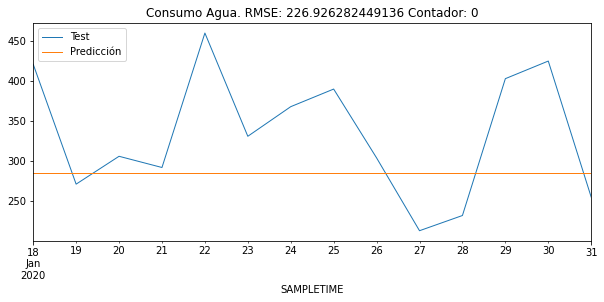

In [9]:
# Un modelo diario
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()
Proyecto.GraficasEstadisticas()

In [10]:
data_tuples = list(zip(Proyecto.RMSE_Todos,Proyecto.RMSE_Todos_IDs))
resultados=pd.DataFrame(data_tuples,columns=['RMSE_Media','ID'])
resultados.to_csv(path+'RMSE_MEdia')
print(resultados)

      RMSE_Media    ID
0     226.926282     0
1      97.303102     1
2      15.902418     2
3     130.108989     3
4     243.590131     4
...          ...   ...
2710    0.904325  2722
2711  135.376394  2742
2712  335.187612  2745
2713    7.299112  2748
2714    0.652450  2749

[2715 rows x 2 columns]


# COHERENCIA DE LOS DATOS

In [11]:
Proyecto.contadores[0].Predicciones

[0,
 284.5714285714285,
 284.5714285714285,
 284.5714285714285,
 284.5714285714285,
 284.5714285714285,
 284.5714285714285,
 284.5714285714285,
 284.5714285714285,
 284.5714285714285,
 284.5714285714285,
 284.5714285714285,
 284.5714285714285,
 284.5714285714285,
 284.5714285714285,
 1991.9999999999993,
 1991.9999999999993]

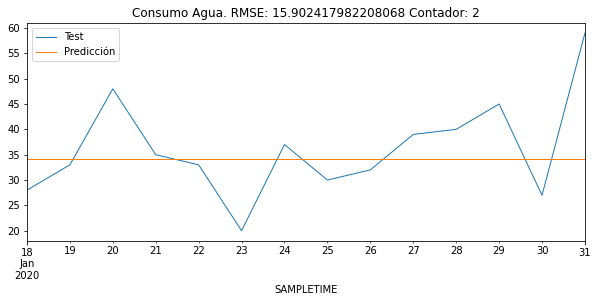

In [12]:
Proyecto.contadores[2].Predicciones
Proyecto.GraficasEstadisticas(contador=2,Test=True)

In [13]:
Proyecto.RMSE_Test_Promedio

573.7253865382696

In [14]:
Proyecto.RMSE_Test_Suma

1557664.4244514022

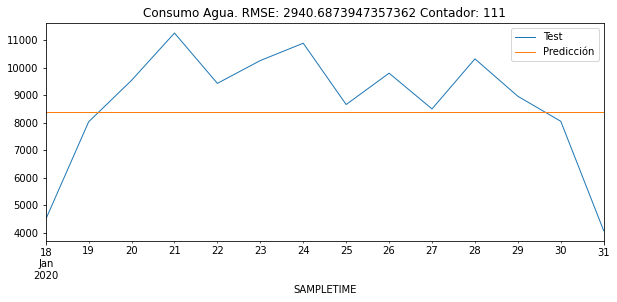

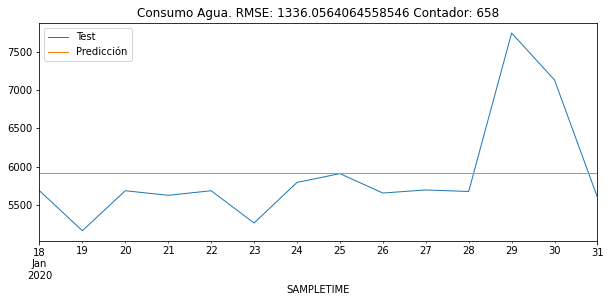

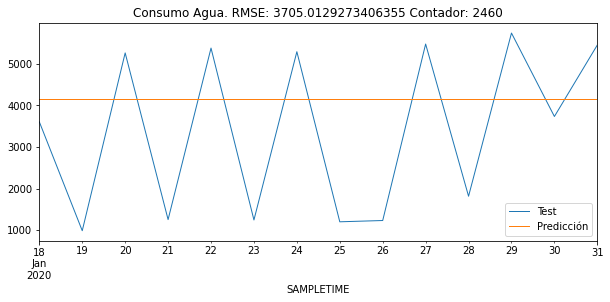

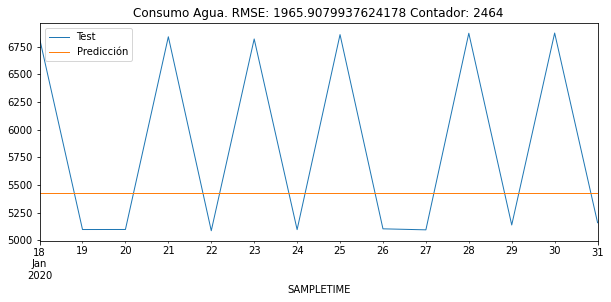

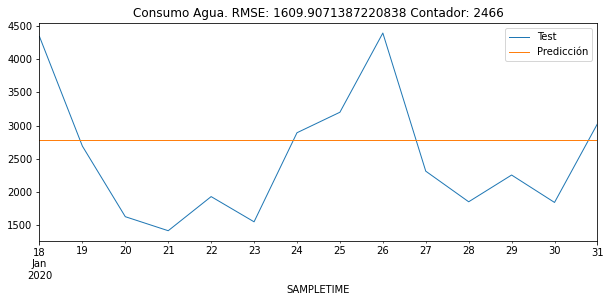

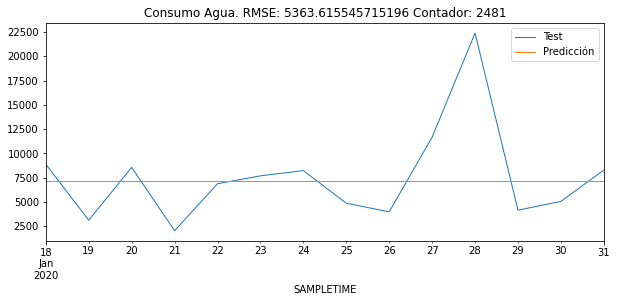

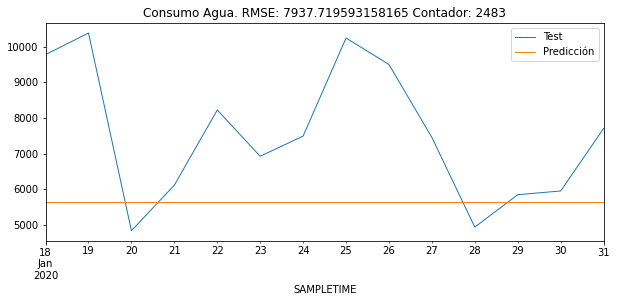

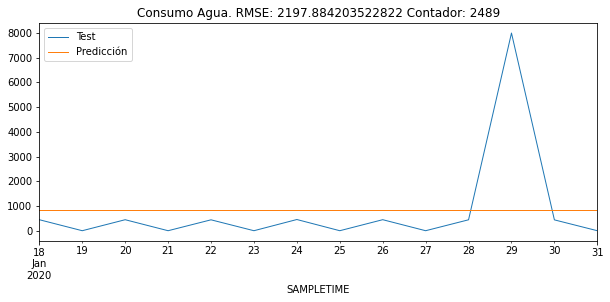

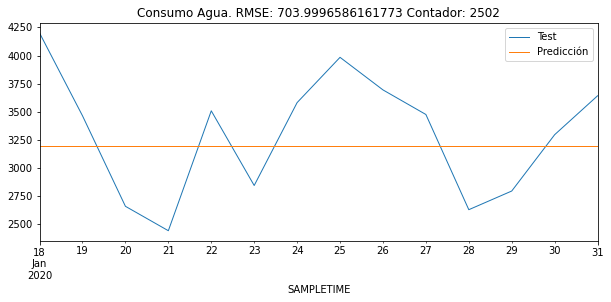

In [15]:
for ID in [111,658,2460,2464,2466,2481,2483,2489,2502]:
    Proyecto.GraficasEstadisticas(contador=ID)